$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Part 1: Sequence Models
<a id=part1></a>

In this part we will learn about working with text sequences using recurrent neural networks.
We'll go from a raw text file all the way to a fully trained GRU-RNN model and generate works of art!

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Text generation with a char-level RNN
<a id=part1_1></a>

### Obtaining the corpus
<a id=part1_2></a>

Let's begin by downloading a corpus containing all the works of William Shakespeare.
Since he was very prolific, this corpus is fairly large and will provide us with enough data for
obtaining impressive results.

In [3]:
CORPUS_URL = 'https://github.com/cedricdeboom/character-level-rnn-datasets/raw/master/datasets/shakespeare.txt'
DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')

def download_corpus(out_path=DATA_DIR, url=CORPUS_URL, force=False):
    pathlib.Path(out_path).mkdir(exist_ok=True)
    out_filename = os.path.join(out_path, os.path.basename(url))
    
    if os.path.isfile(out_filename) and not force:
        print(f'Corpus file {out_filename} exists, skipping download.')
    else:
        print(f'Downloading {url}...')
        with urllib.request.urlopen(url) as response, open(out_filename, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)
        print(f'Saved to {out_filename}.')
    return out_filename
    
corpus_path = download_corpus()

Corpus file /home/eran.b/.pytorch-datasets/shakespeare.txt exists, skipping download.


Load the text into memory and print a snippet:

In [4]:
with open(corpus_path, 'r', encoding='utf-8') as f:
    corpus = f.read()

print(f'Corpus length: {len(corpus)} chars')
print(corpus[7:1234])

Corpus length: 6347703 chars
ALLS WELL THAT ENDS WELL

by William Shakespeare

Dramatis Personae

  KING OF FRANCE
  THE DUKE OF FLORENCE
  BERTRAM, Count of Rousillon
  LAFEU, an old lord
  PAROLLES, a follower of Bertram
  TWO FRENCH LORDS, serving with Bertram

  STEWARD, Servant to the Countess of Rousillon
  LAVACHE, a clown and Servant to the Countess of Rousillon
  A PAGE, Servant to the Countess of Rousillon

  COUNTESS OF ROUSILLON, mother to Bertram
  HELENA, a gentlewoman protected by the Countess
  A WIDOW OF FLORENCE.
  DIANA, daughter to the Widow

  VIOLENTA, neighbour and friend to the Widow
  MARIANA, neighbour and friend to the Widow

  Lords, Officers, Soldiers, etc., French and Florentine  

SCENE:
Rousillon; Paris; Florence; Marseilles

ACT I. SCENE 1.
Rousillon. The COUNT'S palace

Enter BERTRAM, the COUNTESS OF ROUSILLON, HELENA, and LAFEU, all in black

  COUNTESS. In delivering my son from me, I bury a second husband.
  BERTRAM. And I in going, madam, weep o'er

### Data Preprocessing
<a id=part1_3></a>

The first thing we'll need is to map from each unique character in the corpus to an index that will represent it in our learning process.

**TODO**: Implement the `char_maps()` function in the `hw3/charnn.py` module.

In [5]:
import hw3.charnn as charnn

char_to_idx, idx_to_char = charnn.char_maps(corpus)
print(char_to_idx)

test.assertEqual(len(char_to_idx), len(idx_to_char))
test.assertSequenceEqual(list(char_to_idx.keys()), list(idx_to_char.values()))
test.assertSequenceEqual(list(char_to_idx.values()), list(idx_to_char.keys()))

{'\n': 0, ' ': 1, '!': 2, '"': 3, '$': 4, '&': 5, "'": 6, '(': 7, ')': 8, ',': 9, '-': 10, '.': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, ';': 23, '<': 24, '?': 25, 'A': 26, 'B': 27, 'C': 28, 'D': 29, 'E': 30, 'F': 31, 'G': 32, 'H': 33, 'I': 34, 'J': 35, 'K': 36, 'L': 37, 'M': 38, 'N': 39, 'O': 40, 'P': 41, 'Q': 42, 'R': 43, 'S': 44, 'T': 45, 'U': 46, 'V': 47, 'W': 48, 'X': 49, 'Y': 50, 'Z': 51, '[': 52, ']': 53, '_': 54, 'a': 55, 'b': 56, 'c': 57, 'd': 58, 'e': 59, 'f': 60, 'g': 61, 'h': 62, 'i': 63, 'j': 64, 'k': 65, 'l': 66, 'm': 67, 'n': 68, 'o': 69, 'p': 70, 'q': 71, 'r': 72, 's': 73, 't': 74, 'u': 75, 'v': 76, 'w': 77, 'x': 78, 'y': 79, 'z': 80, '}': 81, '\ufeff': 82}


Seems we have some strange characters in the corpus that are very rare and are probably due to mistakes.
To reduce the length of each tensor we'll need to later represent our chars, it's best to remove them.

**TODO**: Implement the `remove_chars()` function in the `hw3/charnn.py` module.

In [6]:
corpus, n_removed = charnn.remove_chars(corpus, ['}','$','_','<','\ufeff'])
print(f'Removed {n_removed} chars')

# After removing the chars, re-create the mappings
char_to_idx, idx_to_char = charnn.char_maps(corpus)

Removed 34 chars


The next thing we need is an **embedding** of the chracters.
An embedding is a representation of each token from the sequence as a tensor.
For a char-level RNN, our tokens will be chars and we can thus use the simplest possible embedding: encode each char as a **one-hot** tensor. In other words, each char will be represented
as a tensor whos length is the total number of unique chars (`V`) which contains all zeros except at the index
corresponding to that specific char.

**TODO**: Implement the functions `chars_to_onehot()` and `onehot_to_chars()` in the `hw3/charnn.py` module.

In [7]:
# Wrap the actual embedding functions for calling convenience
def embed(text):
    return charnn.chars_to_onehot(text, char_to_idx)

def unembed(embedding):
    return charnn.onehot_to_chars(embedding, idx_to_char)

text_snippet = corpus[3104:3148]
print(text_snippet)
print(embed(text_snippet[0:3]))

test.assertEqual(text_snippet, unembed(embed(text_snippet)))
test.assertEqual(embed(text_snippet).dtype, torch.int8)

brine a maiden can season her praise in.
   
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]], dtype=torch.int8)


### Dataset Creation
<a id=part1_4></a>

We wish to train our model to generate text by constantly predicting what the next char should be based on the past.
To that end we'll need to train our recurrent network in a way similar to a classification task. At each timestep, we input a char and set the expected output (label) to be the next char in the original sequence.

We will split our corpus into shorter sequences of length `S` chars (see question below).
Each **sample** we provide our model with will therefore be a tensor of shape `(S,V)` where `V` is the embedding dimension. Our model will operate sequentially on each char in the sequence.
For each sample, we'll also need a **label**. This is simply another sequence, shifted by one char so that the label of each char is the next char in the corpus.

**TODO**: Implement the `chars_to_labelled_samples()` function in the `hw3/charnn.py` module.

In [8]:
# Create dataset of sequences
seq_len = 64
vocab_len = len(char_to_idx)

# Create labelled samples
samples, labels = charnn.chars_to_labelled_samples(corpus, char_to_idx, seq_len, device)
print(f'samples shape: {samples.shape}')
print(f'labels shape: {labels.shape}')

# Test shapes
num_samples = (len(corpus) - 1) // seq_len
test.assertEqual(samples.shape, (num_samples, seq_len, vocab_len))
test.assertEqual(labels.shape, (num_samples, seq_len))

# Test content
for _ in range(1000):
    # random sample
    i = np.random.randint(num_samples, size=(1,))[0]
    # Compare to corpus
    test.assertEqual(unembed(samples[i]), corpus[i*seq_len:(i+1)*seq_len], msg=f"content mismatch in sample {i}")
    # Compare to labels
    sample_text = unembed(samples[i])
    label_text = str.join('', [idx_to_char[j.item()] for j in labels[i]])
    test.assertEqual(sample_text[1:], label_text[0:-1], msg=f"label mismatch in sample {i}")

samples shape: torch.Size([99182, 64, 78])
labels shape: torch.Size([99182, 64])


Let's print a few consecutive samples. You should see that the text continues between them.

In [9]:
import re
import random

i = random.randrange(num_samples-5)
for i in range(i, i+5):
    test.assertEqual(len(samples[i]), seq_len)
    s = re.sub(r'\s+', ' ', unembed(samples[i])).strip()
    print(f'sample [{i}]:\n\t{s}')

sample [62409]:
	Prepare thy battle early in the morning, And put thy fort
sample [62410]:
	une to the arbitrement Of bloody strokes and mortal-staring
sample [62411]:
	war. I, as I may-that which I would I cannot- With bes
sample [62412]:
	t advantage will deceive the time And aid thee in this doubt
sample [62413]:
	ful shock of arms; But on thy side I may not be too forward,


As usual, instead of feeding one sample at a time into our model's forward we'll work with **batches** of samples. This means that at every timestep, our model will operate on a batch of chars that are from **different sequences**.
Effectively this will allow us to parallelize training our model by dong matrix-matrix multiplications
instead of matrix-vector during the forward pass.

An important nuance is that we need the batches to be **contiguous**, i.e. sample $k$ in batch $j$ should continue sample $k$ from batch $j-1$.
The following figure illustrates this:

<img src="imgs/rnn-batching.png"/>

If we naïvely take consecutive samples into batches, e.g. `[0,1,...,B-1]`, `[B,B+1,...,2B-1]` and so on, we won't have contiguous
sequences at the same index between adjacent batches.

To accomplish this we need to tell our `DataLoader` which samples to combine together into one batch.
We do this by implementing a custom PyTorch `Sampler`, and providing it to our `DataLoader`.

**TODO**: Implement the `SequenceBatchSampler` class in the `hw3/charnn.py` module.

In [10]:
from hw3.charnn import SequenceBatchSampler

sampler = SequenceBatchSampler(dataset=range(32), batch_size=10)
sampler_idx = list(sampler)
print('sampler_idx =\n', sampler_idx)

# Test the Sampler
test.assertEqual(len(sampler_idx), 30)
batch_idx = np.array(sampler_idx).reshape(-1, 10)
for k in range(10):
    test.assertEqual(np.diff(batch_idx[:, k], n=2).item(), 0)

sampler_idx =
 [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 2, 5, 8, 11, 14, 17, 20, 23, 26, 29]


/home/eran.b/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torch/utils/data/sampler.py:65: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."


Even though we're working with sequences, we can still use the standard PyTorch `Dataset`/`DataLoader` combo.
For the dataset we can use a built-in class, `TensorDataset` to return tuples of `(sample, label)`
from the `samples` and `labels` tensors we created above.
The `DataLoader` will be provided with our custom `Sampler` so that it generates appropriate batches.

In [11]:
import torch.utils.data

# Create DataLoader returning batches of samples.
batch_size = 32

ds_corpus = torch.utils.data.TensorDataset(samples, labels)
sampler_corpus = SequenceBatchSampler(ds_corpus, batch_size)
dl_corpus = torch.utils.data.DataLoader(ds_corpus, batch_size=batch_size, sampler=sampler_corpus, shuffle=False)

Let's see what that gives us:

In [12]:
print(f'num batches: {len(dl_corpus)}')

x0, y0 = next(iter(dl_corpus))
print(f'shape of a batch of samples: {x0.shape}')
print(f'shape of a batch of labels: {y0.shape}')

num batches: 3100
shape of a batch of samples: torch.Size([32, 64, 78])
shape of a batch of labels: torch.Size([32, 64])


Now lets look at the same sample index from multiple batches taken from our corpus.

In [13]:
# Check that sentences in in same index of different batches complete each other.
k = random.randrange(batch_size)
for j, (X, y) in enumerate(dl_corpus,):
    print(f'=== batch {j}, sample {k} ({X[k].shape}): ===')
    s = re.sub(r'\s+', ' ', unembed(X[k])).strip()
    print(f'\t{s}')
    if j==4: break

=== batch 0, sample 24 (torch.Size([64, 78])): ===
	mind were clear again, that I might water an ass at it. I ha
=== batch 1, sample 24 (torch.Size([64, 78])): ===
	d rather be a tick in a sheep than such a valiant ignorance.
=== batch 2, sample 24 (torch.Size([64, 78])): ===
	Exit ACT IV. SCENE 1. Troy.
=== batch 3, sample 24 (torch.Size([64, 78])): ===
	A street Enter, at one side, AENEAS, and servant with a torch;
=== batch 4, sample 24 (torch.Size([64, 78])): ===
	at another, PARIS, DEIPHOBUS, ANTENOR, DIOMEDES the Grecian, an


### Model Implementation
<a id=part1_5></a>

Finally, our data set is ready so we can focus on our model.

We'll implement here is a multilayer gated recurrent unit (GRU) model, with dropout.
This model is a type of RNN which performs similar to the well-known LSTM model,
but it's somewhat easier to train because it has less parameters.
We'll modify the regular GRU slightly by applying dropout to
the hidden states passed between layers of the model.

The model accepts an input $\mat{X}\in\set{R}^{S\times V}$ containing a sequence of embedded chars.
It returns an output $\mat{Y}\in\set{R}^{S\times V}$ of predictions for the next char and the final hidden state
$\mat{H}\in\set{R}^{L\times H}$. Here $S$ is the sequence length, $V$ is the vocabulary size (number of unique chars), $L$ is the number of layers in the model and $H$ is the hidden dimension.

Mathematically, the model's forward function at layer $k\in[1,L]$ and timestep $t\in[1,S]$ can be described as

$$
\begin{align}
\vec{z_t}^{[k]} &= \sigma\left(\vec{x}^{[k]}_t {\mattr{W}_{\mathrm{xz}}}^{[k]} +
    \vec{h}_{t-1}^{[k]} {\mattr{W}_{\mathrm{hz}}}^{[k]} + \vec{b}_{\mathrm{z}}^{[k]}\right) \\
\vec{r_t}^{[k]} &= \sigma\left(\vec{x}^{[k]}_t {\mattr{W}_{\mathrm{xr}}}^{[k]} +
    \vec{h}_{t-1}^{[k]} {\mattr{W}_{\mathrm{hr}}}^{[k]} + \vec{b}_{\mathrm{r}}^{[k]}\right) \\
\vec{g_t}^{[k]} &= \tanh\left(\vec{x}^{[k]}_t {\mattr{W}_{\mathrm{xg}}}^{[k]} +
    (\vec{r_t}^{[k]}\odot\vec{h}_{t-1}^{[k]}) {\mattr{W}_{\mathrm{hg}}}^{[k]} + \vec{b}_{\mathrm{g}}^{[k]}\right) \\
\vec{h_t}^{[k]} &= \vec{z}^{[k]}_t \odot \vec{h}^{[k]}_{t-1} + \left(1-\vec{z}^{[k]}_t\right)\odot \vec{g_t}^{[k]}
\end{align}
$$

The input to each layer is,
$$
\mat{X}^{[k]} =
\begin{bmatrix}
    {\vec{x}_1}^{[k]} \\ \vdots \\ {\vec{x}_S}^{[k]}
\end{bmatrix} 
=
\begin{cases}
    \mat{X} & \mathrm{if} ~k = 1~ \\
    \mathrm{dropout}_p \left(
    \begin{bmatrix}
        {\vec{h}_1}^{[k-1]} \\ \vdots \\ {\vec{h}_S}^{[k-1]}
    \end{bmatrix} \right) & \mathrm{if} ~1 < k \leq L+1~
\end{cases}.
$$

The output of the entire model is then,
$$
\mat{Y} = \mat{X}^{[L+1]} {\mattr{W}_{\mathrm{hy}}} + \mat{B}_{\mathrm{y}}
$$

and the final hidden state is
$$
\mat{H} = 
\begin{bmatrix}
    {\vec{h}_S}^{[1]} \\ \vdots \\ {\vec{h}_S}^{[L]}
\end{bmatrix}.
$$

Notes:
- $t\in[1,S]$ is the timestep, i.e. the current position within the sequence of each sample.
- $\vec{x}_t^{[k]}$ is the input of layer $k$ at timestep $t$, respectively.
- The outputs of the **last layer** $\vec{y}_t^{[L]}$, are the predicted next characters for every input char.
  These are similar to class scores in classification tasks.
- The hidden states at the **last timestep**, $\vec{h}_S^{[k]}$, are the final hidden state returned from the model.
- $\sigma(\cdot)$ is the sigmoid function, i.e. $\sigma(\vec{z}) = 1/(1+e^{-\vec{z}})$ which returns values in $(0,1)$.
- $\tanh(\cdot)$ is the hyperbolic tangent, i.e. $\tanh(\vec{z}) = (e^{2\vec{z}}-1)/(e^{2\vec{z}}+1)$ which returns values in $(-1,1)$.
- $\vec{h_t}^{[k]}$ is the hidden state of layer $k$ at time $t$. This can be thought of as the memory of that layer.
- $\vec{g_t}^{[k]}$ is the candidate hidden state for time $t+1$.
- $\vec{z_t}^{[k]}$ is known as the update gate. It combines the previous state with the input to determine how much the current state will be combined with the new candidate state. For example, if $\vec{z_t}^{[k]}=\vec{1}$ then the current input has no effect on the output.
- $\vec{r_t}^{[k]}$ is known as the reset gate. It combines the previous state with the input to determine how much of the previous state will affect the current state candidate. For example if $\vec{r_t}^{[k]}=\vec{0}$ the previous state has no effect on the current candidate state.

Here's a graphical representation of the GRU's forward pass at each timestep. The $\vec{\tilde{h}}$ in the image is our $\vec{g}$ (candidate next state).

<img src="imgs/gru_cell.png" width="400"/>

You can see how the reset and update gates allow the model to completely ignore it's previous state, completely ignore it's input, or any mixture of those states (since the gates are actually continuous and between $(0,1)$).

Here's a graphical representation of the entire model.
You can ignore the $c_t^{[k]}$ (cell state) variables (which are relevant for LSTM models).
Our model has only the hidden state, $h_t^{[k]}$. Also notice that we added dropout between layers (i.e., on the up arrows).

<img src="imgs/lstm_model.png" />

The purple tensors are inputs (a sequence and initial hidden state per layer), and the green tensors are outputs (another sequence and final hidden state per layer). Each blue block implements the above forward equations.
Blocks that are on the same vertical level are at the same layer, and therefore share parameters.

**TODO**:implement `MultilayerGRU` class in the `hw3/charnn.py` module.


Notes:
- We use **batches** now.
  The math is identical to the above, but all the tensors will have an extra batch 
  dimension as their first dimension.
- Read the diagram above, try to understand all the dimentions.


In [14]:
in_dim = vocab_len
h_dim = 256
n_layers = 3
model = charnn.MultilayerGRU(in_dim, h_dim, out_dim=in_dim, n_layers=n_layers)
model = model.to(device)
print(model)

# Test forward pass
y, h = model(x0.to(dtype=torch.float, device=device))
print(f'y.shape={y.shape}')
print(f'h.shape={h.shape}')

test.assertEqual(y.shape, (batch_size, seq_len, vocab_len))
test.assertEqual(h.shape, (batch_size, n_layers, h_dim))
test.assertEqual(len(list(model.parameters())), 9 * n_layers + 2) 

MultilayerGRU(
  (layer_params): ModuleList(
    (0): ModuleList(
      (0): Linear(in_features=78, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=256, bias=False)
      (2): Linear(in_features=78, out_features=256, bias=True)
      (3): Linear(in_features=256, out_features=256, bias=False)
      (4): Linear(in_features=78, out_features=256, bias=True)
      (5): Linear(in_features=256, out_features=256, bias=False)
      (6): Dropout(p=0, inplace=False)
    )
    (1-2): 2 x ModuleList(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=256, bias=False)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): Linear(in_features=256, out_features=256, bias=False)
      (4): Linear(in_features=256, out_features=256, bias=True)
      (5): Linear(in_features=256, out_features=256, bias=False)
      (6): Dropout(p=0, inplace=False)
    )
    (3): ModuleList(
      (0): Linear(in_feat

y.shape=torch.Size([32, 64, 78])
h.shape=torch.Size([32, 3, 256])


### Generating text by sampling
<a id=part1_6></a>

Now that we have a model, we can implement **text generation** based on it.
The idea is simple:
At each timestep our model receives one char $x_t$ from the input sequence and outputs scores $y_t$
for what the next char should be.
We'll convert these scores into a probability over each of the possible chars.
In other words, for each input char $x_t$ we create a probability distribution for the next char
conditioned on the current one and the state of the model (representing all previous inputs):
$$p(x_{t+1}|x_t, \vec{h}_t).$$

Once we have such a distribution, we'll sample a char from it.
This will be the first char of our generated sequence.
Now we can feed this new char into the model, create another distribution, sample the next char and so on.
Note that it's crucial to propagate the hidden state when sampling.

The important point however is how to create the distribution from the scores.
One way, as we saw in previous ML tasks, is to use the softmax function.
However, a drawback of softmax is that it can generate very diffuse (more uniform) distributions if the score values are very similar. When sampling, we would prefer to control the distributions and make them less uniform to increase the chance of sampling the char(s) with the highest scores compared to the others.

To control the variance of the distribution, a common trick is to add a hyperparameter $T$, known as the 
*temperature* to the softmax function. The class scores are simply scaled by $T$ before softmax is applied:
$$
\mathrm{softmax}_T(\vec{y}) = \frac{e^{\vec{y}/T}}{\sum_k e^{y_k/T}}
$$

A low $T$ will result in less uniform distributions and vice-versa.

**TODO**: Implement the `hot_softmax()` function in the `hw3/charnn.py` module.

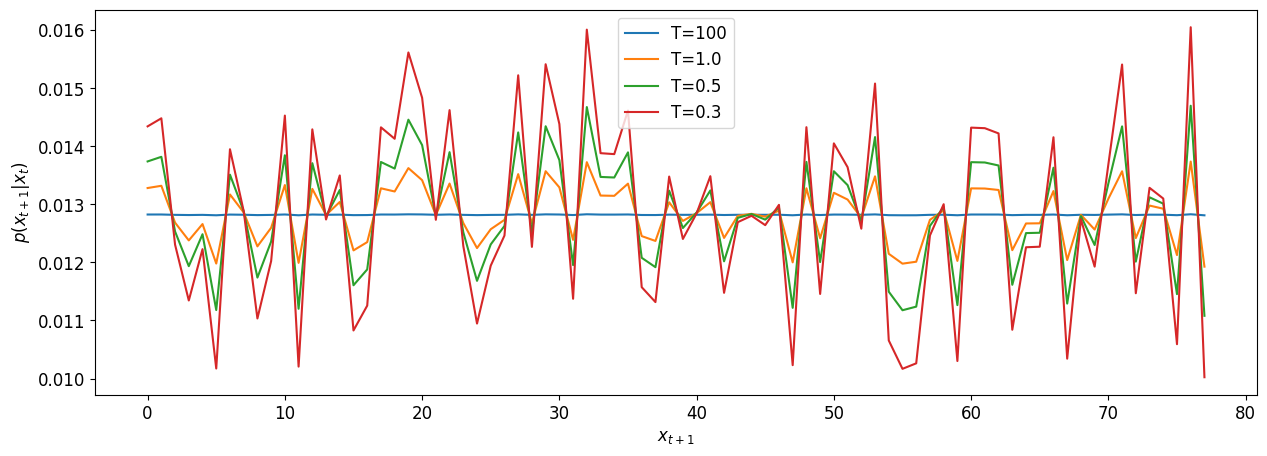

In [15]:
scores = y[0,0,:].detach()
_, ax = plt.subplots(figsize=(15,5))

for t in reversed([0.3, 0.5, 1.0, 100]):
    ax.plot(charnn.hot_softmax(scores, temperature=t).cpu().numpy(), label=f'T={t}')
ax.set_xlabel('$x_{t+1}$')
ax.set_ylabel('$p(x_{t+1}|x_t)$')
ax.legend()

uniform_proba = 1/len(char_to_idx)
uniform_diff = torch.abs(charnn.hot_softmax(scores, temperature=100) - uniform_proba)
test.assertTrue(torch.all(uniform_diff < 1e-4))

**TODO**: Implement the `generate_from_model()` function in the `hw3/charnn.py` module.

In [16]:
for _ in range(3):
    text = charnn.generate_from_model(model, "foobar", 50, (char_to_idx, idx_to_char), T=0.5)
    print(text)
    test.assertEqual(len(text), 50)

foobarI1)sZiF8Jw'MTRCJCc]E
;0GVWeg)?Di3axys]PDVfON
foobar!";
;H"T,UG'J:Fj)gr?&b9O7)rSk,&d1OH3psNtb;o4
foobarD4sEs;biIDyT8ZL[MjE;slB?9mrUP(lj[c2u("0sS2;I


### Training
<a id=part1_7></a>

To train this model, we'll calculate the loss at each time step by comparing the predicted char to
the actual char from our label. We can use cross entropy since per char it's similar to a classification problem.
We'll then sum the losses over the sequence and back-propagate the gradients though time.
Notice that the back-propagation algorithm will "visit" each layer's parameter tensors multiple times,
so we'll accumulate gradients in parameters of the blocks. Luckily `autograd` will handle this part for us.

As usual, the first step of training will be to try and **overfit** a large model (many parameters) to a tiny dataset.
Again, this is to ensure the model and training code are implemented correctly, i.e. that the model can learn.

For a generative model such as this, overfitting is slightly trickier than for classification.
What we'll aim to do is to get our model to **memorize** a specific sequence of chars, so that when given the first
char in the sequence it will immediately spit out the rest of the sequence verbatim.

Let's create a tiny dataset to memorize.

In [17]:
# Pick a tiny subset of the dataset
subset_start, subset_end = 1001, 1005
ds_corpus_ss = torch.utils.data.Subset(ds_corpus, range(subset_start, subset_end))
batch_size_ss = 1
sampler_ss = SequenceBatchSampler(ds_corpus_ss, batch_size=batch_size_ss)
dl_corpus_ss = torch.utils.data.DataLoader(ds_corpus_ss, batch_size_ss, sampler=sampler_ss, shuffle=False)

# Convert subset to text
subset_text = ''
for i in range(subset_end - subset_start):
    subset_text += unembed(ds_corpus_ss[i][0])
print(f'Text to "memorize":\n\n{subset_text}')

Text to "memorize":

TRAM. What would you have?
  HELENA. Something; and scarce so much; nothing, indeed.
    I would not tell you what I would, my lord.
    Faith, yes:
    Strangers and foes do sunder and not kiss.
  BERTRAM. I pray you, stay not, but in haste to horse.
  HE


In [18]:
import torch.nn as nn
import torch.optim as optim
from hw3.training import RNNTrainer

torch.manual_seed(42)

lr = 0.01
num_epochs = 500

in_dim = vocab_len
h_dim = 128
n_layers = 2
loss_fn = nn.CrossEntropyLoss()
model = charnn.MultilayerGRU(in_dim, h_dim, out_dim=in_dim, n_layers=n_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
trainer = RNNTrainer(model, loss_fn, optimizer, device)

for epoch in range(num_epochs):
    epoch_result = trainer.train_epoch(dl_corpus_ss, verbose=False)
    
    # Every X epochs, we'll generate a sequence starting from the first char in the first sequence
    # to visualize how/if/what the model is learning.
    if epoch == 0 or (epoch+1) % 25 == 0:
        avg_loss = np.mean(epoch_result.losses)
        accuracy = np.mean(epoch_result.accuracy)
        print(f'\nEpoch #{epoch+1}: Avg. loss = {avg_loss:.3f}, Accuracy = {accuracy:.2f}%')
        
        generated_sequence = charnn.generate_from_model(model, subset_text[0],
                                                        seq_len*(subset_end-subset_start),
                                                        (char_to_idx,idx_to_char), T=0.1)
        
        # Stop if we've successfully memorized the small dataset.
        print(generated_sequence)
        if generated_sequence == subset_text:
            break

# Test successful overfitting
test.assertGreater(epoch_result.accuracy, 99)
test.assertEqual(generated_sequence, subset_text)


Epoch #1: Avg. loss = 3.937, Accuracy = 17.97%


Ttn                         t            t     t  n t                       t    t         t                                   t       t    tt           t       t                             t    t                          t           t          t         



Epoch #25: Avg. loss = 1.028, Accuracy = 73.44%


TAAM. What would you hat youhde?
  HELLLAAA. Sotethang; and soat yould not teas andel you teinge inde, note ind soat nothinge indee and sou teas andes and yoat sould not tel, notete so yoas indeesangete soet nothinge indee inde, note so yoas indeesand you 



Epoch #50: Avg. loss = 0.027, Accuracy = 100.00%


TRAM. What would you have?
  HELENA. Something; and scarce so much; nothing, indeed.
    I would not tell you what I would, my lord.
    Faith, yes:
    Strangers and foes do sunder and not kiss.
  BERTRAM. I pray you, stay not, but in haste to horse.
  HE


OK, so training works - we can memorize a short sequence.
We'll now train a much larger model on our large dataset. You'll need a GPU for this part.

First, lets set up our dataset and models for training.
We'll split our corpus into 90% train and 10% test-set.
Also, we'll use a learning-rate scheduler to control the learning rate during training.

**TODO**: Set the hyperparameters in the `part1_rnn_hyperparams()` function of the `hw3/answers.py` module.

In [19]:
from hw3.answers import part1_rnn_hyperparams

hp = part1_rnn_hyperparams()
print('hyperparams:\n', hp)

### Dataset definition
vocab_len = len(char_to_idx)
batch_size = hp['batch_size']
seq_len = hp['seq_len']
train_test_ratio = 0.9
num_samples = (len(corpus) - 1) // seq_len
num_train = int(train_test_ratio * num_samples)

samples, labels = charnn.chars_to_labelled_samples(corpus, char_to_idx, seq_len, device)

ds_train = torch.utils.data.TensorDataset(samples[:num_train], labels[:num_train])
sampler_train = SequenceBatchSampler(ds_train, batch_size)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=False, sampler=sampler_train, drop_last=True)

ds_test = torch.utils.data.TensorDataset(samples[num_train:], labels[num_train:])
sampler_test = SequenceBatchSampler(ds_test, batch_size)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=False, sampler=sampler_test, drop_last=True)

print(f'Train: {len(dl_train):3d} batches, {len(dl_train)*batch_size*seq_len:7d} chars')
print(f'Test:  {len(dl_test):3d} batches, {len(dl_test)*batch_size*seq_len:7d} chars')

### Training definition
in_dim = out_dim = vocab_len
checkpoint_file = 'checkpoints/rnn'
num_epochs = 50
early_stopping = 5

model = charnn.MultilayerGRU(in_dim, hp['h_dim'], out_dim, hp['n_layers'], hp['dropout'])
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hp['learn_rate'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=hp['lr_sched_factor'], patience=hp['lr_sched_patience'], verbose=True
)
trainer = RNNTrainer(model, loss_fn, optimizer, device)

hyperparams:
 {'batch_size': 64, 'seq_len': 64, 'h_dim': 256, 'n_layers': 3, 'dropout': 0.2, 'learn_rate': 0.001, 'lr_sched_factor': 0.1, 'lr_sched_patience': 2}


Train: 1394 batches, 5709824 chars
Test:  154 batches,  630784 chars


/home/eran.b/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torch/utils/data/sampler.py:65: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."
/home/eran.b/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


The code blocks below will train the model and save checkpoints containing the training state and the best model parameters to a file. This allows you to stop training and resume it later from where you left.

Note that you can use the `main.py` script provided within the assignment folder to run this notebook from the command line as if it were a python script by using the `run-nb` subcommand. This allows you to train your model using this notebook without starting jupyter. You can combine this with `srun` or `sbatch` to run the notebook with a GPU on the course servers.

**TODO**:
- Implement the `fit()` method of the `Trainer` class. You can reuse the relevant implementation parts from HW2, but make sure to implement early stopping and checkpoints.
- Implement the `test_epoch()` and `test_batch()` methods of the `RNNTrainer` class in the `hw3/training.py` module.
- Run the following block to train.
- When training is done and you're satisfied with the model's outputs, rename the checkpoint file to `checkpoints/rnn_final.pt`.
  This will cause the block to skip training and instead load your saved model when running the homework submission script.
  Note that your submission zip file will not include the checkpoint file. This is OK.

/home/eran.b/HW3/hw3/training.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state = torch.load(checkpoint_filename, map_location=self.device)


ACT I.xgqb[nwv.EfEQvPeoTxX,.l Mvh0AWXFvZkBs58g"ppO?EOs2com&w4E1?:0bBzbH;aMJj;b qBpVZ3n-YT."&Xizh
C)V
*** Loading checkpoint file checkpoints/rnn.pt
--- EPOCH 1/50 ---


train_batch:   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.246):   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.246):   0%|          | 1/1394 [00:00<06:58,  3.33it/s]

train_batch (1.118):   0%|          | 1/1394 [00:00<06:58,  3.33it/s]

train_batch (1.118):   0%|          | 2/1394 [00:00<06:37,  3.50it/s]

train_batch (1.148):   0%|          | 2/1394 [00:00<06:37,  3.50it/s]

train_batch (1.148):   0%|          | 3/1394 [00:00<06:27,  3.59it/s]

train_batch (1.120):   0%|          | 3/1394 [00:01<06:27,  3.59it/s]

train_batch (1.120):   0%|          | 4/1394 [00:01<06:21,  3.64it/s]

train_batch (1.186):   0%|          | 4/1394 [00:01<06:21,  3.64it/s]

train_batch (1.186):   0%|          | 5/1394 [00:01<06:19,  3.66it/s]

train_batch (1.139):   0%|          | 5/1394 [00:01<06:19,  3.66it/s]

train_batch (1.139):   0%|          | 6/1394 [00:01<06:16,  3.68it/s]

train_batch (1.106):   0%|          | 6/1394 [00:01<06:16,  3.68it/s]

train_batch (1.106):   1%|          | 7/1394 [00:01<06:15,  3.69it/s]

train_batch (1.160):   1%|          | 7/1394 [00:02<06:15,  3.69it/s]

train_batch (1.160):   1%|          | 8/1394 [00:02<06:15,  3.70it/s]

train_batch (1.130):   1%|          | 8/1394 [00:02<06:15,  3.70it/s]

train_batch (1.130):   1%|          | 9/1394 [00:02<06:13,  3.70it/s]

train_batch (1.106):   1%|          | 9/1394 [00:02<06:13,  3.70it/s]

train_batch (1.106):   1%|          | 10/1394 [00:02<06:13,  3.71it/s]

train_batch (1.141):   1%|          | 10/1394 [00:03<06:13,  3.71it/s]

train_batch (1.141):   1%|          | 11/1394 [00:03<06:16,  3.67it/s]

train_batch (1.138):   1%|          | 11/1394 [00:03<06:16,  3.67it/s]

train_batch (1.138):   1%|          | 12/1394 [00:03<06:14,  3.69it/s]

train_batch (1.107):   1%|          | 12/1394 [00:03<06:14,  3.69it/s]

train_batch (1.107):   1%|          | 13/1394 [00:03<06:14,  3.69it/s]

train_batch (1.152):   1%|          | 13/1394 [00:03<06:14,  3.69it/s]

train_batch (1.152):   1%|          | 14/1394 [00:03<06:12,  3.70it/s]

train_batch (1.164):   1%|          | 14/1394 [00:04<06:12,  3.70it/s]

train_batch (1.164):   1%|          | 15/1394 [00:04<06:12,  3.70it/s]

train_batch (1.162):   1%|          | 15/1394 [00:04<06:12,  3.70it/s]

train_batch (1.162):   1%|          | 16/1394 [00:04<06:11,  3.71it/s]

train_batch (1.164):   1%|          | 16/1394 [00:04<06:11,  3.71it/s]

train_batch (1.164):   1%|          | 17/1394 [00:04<06:10,  3.71it/s]

train_batch (1.107):   1%|          | 17/1394 [00:04<06:10,  3.71it/s]

train_batch (1.107):   1%|▏         | 18/1394 [00:04<06:10,  3.71it/s]

train_batch (1.115):   1%|▏         | 18/1394 [00:05<06:10,  3.71it/s]

train_batch (1.115):   1%|▏         | 19/1394 [00:05<06:10,  3.72it/s]

train_batch (1.134):   1%|▏         | 19/1394 [00:05<06:10,  3.72it/s]

train_batch (1.134):   1%|▏         | 20/1394 [00:05<06:10,  3.71it/s]

train_batch (1.122):   1%|▏         | 20/1394 [00:05<06:10,  3.71it/s]

train_batch (1.122):   2%|▏         | 21/1394 [00:05<06:11,  3.70it/s]

train_batch (1.095):   2%|▏         | 21/1394 [00:05<06:11,  3.70it/s]

train_batch (1.095):   2%|▏         | 22/1394 [00:05<06:11,  3.69it/s]

train_batch (1.103):   2%|▏         | 22/1394 [00:06<06:11,  3.69it/s]

train_batch (1.103):   2%|▏         | 23/1394 [00:06<06:10,  3.70it/s]

train_batch (1.105):   2%|▏         | 23/1394 [00:06<06:10,  3.70it/s]

train_batch (1.105):   2%|▏         | 24/1394 [00:06<06:09,  3.71it/s]

train_batch (1.105):   2%|▏         | 24/1394 [00:06<06:09,  3.71it/s]

train_batch (1.105):   2%|▏         | 25/1394 [00:06<06:09,  3.71it/s]

train_batch (1.081):   2%|▏         | 25/1394 [00:07<06:09,  3.71it/s]

train_batch (1.081):   2%|▏         | 26/1394 [00:07<06:08,  3.71it/s]

train_batch (1.154):   2%|▏         | 26/1394 [00:07<06:08,  3.71it/s]

train_batch (1.154):   2%|▏         | 27/1394 [00:07<06:08,  3.71it/s]

train_batch (1.125):   2%|▏         | 27/1394 [00:07<06:08,  3.71it/s]

train_batch (1.125):   2%|▏         | 28/1394 [00:07<06:07,  3.71it/s]

train_batch (1.089):   2%|▏         | 28/1394 [00:07<06:07,  3.71it/s]

train_batch (1.089):   2%|▏         | 29/1394 [00:07<06:09,  3.69it/s]

train_batch (1.079):   2%|▏         | 29/1394 [00:08<06:09,  3.69it/s]

train_batch (1.079):   2%|▏         | 30/1394 [00:08<06:12,  3.67it/s]

train_batch (1.105):   2%|▏         | 30/1394 [00:08<06:12,  3.67it/s]

train_batch (1.105):   2%|▏         | 31/1394 [00:08<06:12,  3.66it/s]

train_batch (1.141):   2%|▏         | 31/1394 [00:08<06:12,  3.66it/s]

train_batch (1.141):   2%|▏         | 32/1394 [00:08<06:10,  3.67it/s]

train_batch (1.082):   2%|▏         | 32/1394 [00:08<06:10,  3.67it/s]

train_batch (1.082):   2%|▏         | 33/1394 [00:08<06:09,  3.69it/s]

train_batch (1.133):   2%|▏         | 33/1394 [00:09<06:09,  3.69it/s]

train_batch (1.133):   2%|▏         | 34/1394 [00:09<06:07,  3.70it/s]

train_batch (1.092):   2%|▏         | 34/1394 [00:09<06:07,  3.70it/s]

train_batch (1.092):   3%|▎         | 35/1394 [00:09<06:07,  3.70it/s]

train_batch (1.125):   3%|▎         | 35/1394 [00:09<06:07,  3.70it/s]

train_batch (1.125):   3%|▎         | 36/1394 [00:09<06:07,  3.70it/s]

train_batch (1.093):   3%|▎         | 36/1394 [00:10<06:07,  3.70it/s]

train_batch (1.093):   3%|▎         | 37/1394 [00:10<06:06,  3.70it/s]

train_batch (1.101):   3%|▎         | 37/1394 [00:10<06:06,  3.70it/s]

train_batch (1.101):   3%|▎         | 38/1394 [00:10<06:05,  3.71it/s]

train_batch (1.082):   3%|▎         | 38/1394 [00:10<06:05,  3.71it/s]

train_batch (1.082):   3%|▎         | 39/1394 [00:10<06:05,  3.71it/s]

train_batch (1.090):   3%|▎         | 39/1394 [00:10<06:05,  3.71it/s]

train_batch (1.090):   3%|▎         | 40/1394 [00:10<06:05,  3.71it/s]

train_batch (1.112):   3%|▎         | 40/1394 [00:11<06:05,  3.71it/s]

train_batch (1.112):   3%|▎         | 41/1394 [00:11<06:05,  3.70it/s]

train_batch (1.086):   3%|▎         | 41/1394 [00:11<06:05,  3.70it/s]

train_batch (1.086):   3%|▎         | 42/1394 [00:11<06:04,  3.71it/s]

train_batch (1.088):   3%|▎         | 42/1394 [00:11<06:04,  3.71it/s]

train_batch (1.088):   3%|▎         | 43/1394 [00:11<06:04,  3.71it/s]

train_batch (1.099):   3%|▎         | 43/1394 [00:11<06:04,  3.71it/s]

train_batch (1.099):   3%|▎         | 44/1394 [00:11<06:03,  3.71it/s]

train_batch (1.100):   3%|▎         | 44/1394 [00:12<06:03,  3.71it/s]

train_batch (1.100):   3%|▎         | 45/1394 [00:12<06:03,  3.71it/s]

train_batch (1.092):   3%|▎         | 45/1394 [00:12<06:03,  3.71it/s]

train_batch (1.092):   3%|▎         | 46/1394 [00:12<06:03,  3.71it/s]

train_batch (1.080):   3%|▎         | 46/1394 [00:12<06:03,  3.71it/s]

train_batch (1.080):   3%|▎         | 47/1394 [00:12<06:02,  3.72it/s]

train_batch (1.069):   3%|▎         | 47/1394 [00:12<06:02,  3.72it/s]

train_batch (1.069):   3%|▎         | 48/1394 [00:13<06:03,  3.70it/s]

train_batch (1.079):   3%|▎         | 48/1394 [00:13<06:03,  3.70it/s]

train_batch (1.079):   4%|▎         | 49/1394 [00:13<06:03,  3.70it/s]

train_batch (1.088):   4%|▎         | 49/1394 [00:13<06:03,  3.70it/s]

train_batch (1.088):   4%|▎         | 50/1394 [00:13<06:02,  3.71it/s]

train_batch (1.107):   4%|▎         | 50/1394 [00:13<06:02,  3.71it/s]

train_batch (1.107):   4%|▎         | 51/1394 [00:13<06:02,  3.71it/s]

train_batch (1.114):   4%|▎         | 51/1394 [00:14<06:02,  3.71it/s]

train_batch (1.114):   4%|▎         | 52/1394 [00:14<06:01,  3.71it/s]

train_batch (1.109):   4%|▎         | 52/1394 [00:14<06:01,  3.71it/s]

train_batch (1.109):   4%|▍         | 53/1394 [00:14<06:01,  3.71it/s]

train_batch (1.126):   4%|▍         | 53/1394 [00:14<06:01,  3.71it/s]

train_batch (1.126):   4%|▍         | 54/1394 [00:14<06:01,  3.71it/s]

train_batch (1.088):   4%|▍         | 54/1394 [00:14<06:01,  3.71it/s]

train_batch (1.088):   4%|▍         | 55/1394 [00:14<06:00,  3.71it/s]

train_batch (1.115):   4%|▍         | 55/1394 [00:15<06:00,  3.71it/s]

train_batch (1.115):   4%|▍         | 56/1394 [00:15<06:00,  3.71it/s]

train_batch (1.100):   4%|▍         | 56/1394 [00:15<06:00,  3.71it/s]

train_batch (1.100):   4%|▍         | 57/1394 [00:15<05:59,  3.72it/s]

train_batch (1.091):   4%|▍         | 57/1394 [00:15<05:59,  3.72it/s]

train_batch (1.091):   4%|▍         | 58/1394 [00:15<05:59,  3.71it/s]

train_batch (1.080):   4%|▍         | 58/1394 [00:15<05:59,  3.71it/s]

train_batch (1.080):   4%|▍         | 59/1394 [00:15<05:59,  3.71it/s]

train_batch (1.110):   4%|▍         | 59/1394 [00:16<05:59,  3.71it/s]

train_batch (1.110):   4%|▍         | 60/1394 [00:16<05:58,  3.72it/s]

train_batch (1.084):   4%|▍         | 60/1394 [00:16<05:58,  3.72it/s]

train_batch (1.084):   4%|▍         | 61/1394 [00:16<05:58,  3.72it/s]

train_batch (1.120):   4%|▍         | 61/1394 [00:16<05:58,  3.72it/s]

train_batch (1.120):   4%|▍         | 62/1394 [00:16<05:58,  3.71it/s]

train_batch (1.098):   4%|▍         | 62/1394 [00:17<05:58,  3.71it/s]

train_batch (1.098):   5%|▍         | 63/1394 [00:17<05:58,  3.71it/s]

train_batch (1.062):   5%|▍         | 63/1394 [00:17<05:58,  3.71it/s]

train_batch (1.062):   5%|▍         | 64/1394 [00:17<05:58,  3.71it/s]

train_batch (1.114):   5%|▍         | 64/1394 [00:17<05:58,  3.71it/s]

train_batch (1.114):   5%|▍         | 65/1394 [00:17<05:58,  3.71it/s]

train_batch (1.071):   5%|▍         | 65/1394 [00:17<05:58,  3.71it/s]

train_batch (1.071):   5%|▍         | 66/1394 [00:17<05:57,  3.71it/s]

train_batch (1.096):   5%|▍         | 66/1394 [00:18<05:57,  3.71it/s]

train_batch (1.096):   5%|▍         | 67/1394 [00:18<05:57,  3.71it/s]

train_batch (1.087):   5%|▍         | 67/1394 [00:18<05:57,  3.71it/s]

train_batch (1.087):   5%|▍         | 68/1394 [00:18<05:58,  3.70it/s]

train_batch (1.073):   5%|▍         | 68/1394 [00:18<05:58,  3.70it/s]

train_batch (1.073):   5%|▍         | 69/1394 [00:18<05:58,  3.69it/s]

train_batch (1.078):   5%|▍         | 69/1394 [00:18<05:58,  3.69it/s]

train_batch (1.078):   5%|▌         | 70/1394 [00:18<05:58,  3.69it/s]

train_batch (1.112):   5%|▌         | 70/1394 [00:19<05:58,  3.69it/s]

train_batch (1.112):   5%|▌         | 71/1394 [00:19<05:58,  3.69it/s]

train_batch (1.130):   5%|▌         | 71/1394 [00:19<05:58,  3.69it/s]

train_batch (1.130):   5%|▌         | 72/1394 [00:19<05:58,  3.69it/s]

train_batch (1.121):   5%|▌         | 72/1394 [00:19<05:58,  3.69it/s]

train_batch (1.121):   5%|▌         | 73/1394 [00:19<05:58,  3.69it/s]

train_batch (1.121):   5%|▌         | 73/1394 [00:20<05:58,  3.69it/s]

train_batch (1.121):   5%|▌         | 74/1394 [00:20<05:58,  3.68it/s]

train_batch (1.105):   5%|▌         | 74/1394 [00:20<05:58,  3.68it/s]

train_batch (1.105):   5%|▌         | 75/1394 [00:20<05:58,  3.68it/s]

train_batch (1.123):   5%|▌         | 75/1394 [00:20<05:58,  3.68it/s]

train_batch (1.123):   5%|▌         | 76/1394 [00:20<05:57,  3.69it/s]

train_batch (1.089):   5%|▌         | 76/1394 [00:20<05:57,  3.69it/s]

train_batch (1.089):   6%|▌         | 77/1394 [00:20<05:57,  3.68it/s]

train_batch (1.102):   6%|▌         | 77/1394 [00:21<05:57,  3.68it/s]

train_batch (1.102):   6%|▌         | 78/1394 [00:21<05:58,  3.67it/s]

train_batch (1.120):   6%|▌         | 78/1394 [00:21<05:58,  3.67it/s]

train_batch (1.120):   6%|▌         | 79/1394 [00:21<05:59,  3.66it/s]

train_batch (1.142):   6%|▌         | 79/1394 [00:21<05:59,  3.66it/s]

train_batch (1.142):   6%|▌         | 80/1394 [00:21<05:57,  3.68it/s]

train_batch (1.090):   6%|▌         | 80/1394 [00:21<05:57,  3.68it/s]

train_batch (1.090):   6%|▌         | 81/1394 [00:21<05:56,  3.69it/s]

train_batch (1.109):   6%|▌         | 81/1394 [00:22<05:56,  3.69it/s]

train_batch (1.109):   6%|▌         | 82/1394 [00:22<05:55,  3.70it/s]

train_batch (1.113):   6%|▌         | 82/1394 [00:22<05:55,  3.70it/s]

train_batch (1.113):   6%|▌         | 83/1394 [00:22<05:55,  3.68it/s]

train_batch (1.105):   6%|▌         | 83/1394 [00:22<05:55,  3.68it/s]

train_batch (1.105):   6%|▌         | 84/1394 [00:22<05:57,  3.67it/s]

train_batch (1.074):   6%|▌         | 84/1394 [00:23<05:57,  3.67it/s]

train_batch (1.074):   6%|▌         | 85/1394 [00:23<05:56,  3.67it/s]

train_batch (1.118):   6%|▌         | 85/1394 [00:23<05:56,  3.67it/s]

train_batch (1.118):   6%|▌         | 86/1394 [00:23<05:57,  3.66it/s]

train_batch (1.113):   6%|▌         | 86/1394 [00:23<05:57,  3.66it/s]

train_batch (1.113):   6%|▌         | 87/1394 [00:23<05:55,  3.67it/s]

train_batch (1.128):   6%|▌         | 87/1394 [00:23<05:55,  3.67it/s]

train_batch (1.128):   6%|▋         | 88/1394 [00:23<05:57,  3.66it/s]

train_batch (1.086):   6%|▋         | 88/1394 [00:24<05:57,  3.66it/s]

train_batch (1.086):   6%|▋         | 89/1394 [00:24<06:00,  3.62it/s]

train_batch (1.088):   6%|▋         | 89/1394 [00:24<06:00,  3.62it/s]

train_batch (1.088):   6%|▋         | 90/1394 [00:24<06:00,  3.62it/s]

train_batch (1.121):   6%|▋         | 90/1394 [00:24<06:00,  3.62it/s]

train_batch (1.121):   7%|▋         | 91/1394 [00:24<06:01,  3.60it/s]

train_batch (1.084):   7%|▋         | 91/1394 [00:24<06:01,  3.60it/s]

train_batch (1.084):   7%|▋         | 92/1394 [00:24<06:02,  3.59it/s]

train_batch (1.127):   7%|▋         | 92/1394 [00:25<06:02,  3.59it/s]

train_batch (1.127):   7%|▋         | 93/1394 [00:25<06:00,  3.61it/s]

train_batch (1.111):   7%|▋         | 93/1394 [00:25<06:00,  3.61it/s]

train_batch (1.111):   7%|▋         | 94/1394 [00:25<05:57,  3.64it/s]

train_batch (1.101):   7%|▋         | 94/1394 [00:25<05:57,  3.64it/s]

train_batch (1.101):   7%|▋         | 95/1394 [00:25<05:56,  3.65it/s]

train_batch (1.108):   7%|▋         | 95/1394 [00:26<05:56,  3.65it/s]

train_batch (1.108):   7%|▋         | 96/1394 [00:26<05:53,  3.67it/s]

train_batch (1.058):   7%|▋         | 96/1394 [00:26<05:53,  3.67it/s]

train_batch (1.058):   7%|▋         | 97/1394 [00:26<05:55,  3.65it/s]

train_batch (1.100):   7%|▋         | 97/1394 [00:26<05:55,  3.65it/s]

train_batch (1.100):   7%|▋         | 98/1394 [00:26<05:52,  3.67it/s]

train_batch (1.137):   7%|▋         | 98/1394 [00:26<05:52,  3.67it/s]

train_batch (1.137):   7%|▋         | 99/1394 [00:26<05:51,  3.69it/s]

train_batch (1.115):   7%|▋         | 99/1394 [00:27<05:51,  3.69it/s]

train_batch (1.115):   7%|▋         | 100/1394 [00:27<05:49,  3.70it/s]

train_batch (1.020):   7%|▋         | 100/1394 [00:27<05:49,  3.70it/s]

train_batch (1.020):   7%|▋         | 101/1394 [00:27<05:48,  3.71it/s]

train_batch (1.114):   7%|▋         | 101/1394 [00:27<05:48,  3.71it/s]

train_batch (1.114):   7%|▋         | 102/1394 [00:27<05:48,  3.71it/s]

train_batch (1.122):   7%|▋         | 102/1394 [00:27<05:48,  3.71it/s]

train_batch (1.122):   7%|▋         | 103/1394 [00:27<05:48,  3.70it/s]

train_batch (1.139):   7%|▋         | 103/1394 [00:28<05:48,  3.70it/s]

train_batch (1.139):   7%|▋         | 104/1394 [00:28<05:49,  3.69it/s]

train_batch (1.122):   7%|▋         | 104/1394 [00:28<05:49,  3.69it/s]

train_batch (1.122):   8%|▊         | 105/1394 [00:28<05:50,  3.68it/s]

train_batch (1.180):   8%|▊         | 105/1394 [00:28<05:50,  3.68it/s]

train_batch (1.180):   8%|▊         | 106/1394 [00:28<05:51,  3.67it/s]

train_batch (1.133):   8%|▊         | 106/1394 [00:29<05:51,  3.67it/s]

train_batch (1.133):   8%|▊         | 107/1394 [00:29<05:50,  3.67it/s]

train_batch (1.086):   8%|▊         | 107/1394 [00:29<05:50,  3.67it/s]

train_batch (1.086):   8%|▊         | 108/1394 [00:29<05:57,  3.59it/s]

train_batch (1.108):   8%|▊         | 108/1394 [00:29<05:57,  3.59it/s]

train_batch (1.108):   8%|▊         | 109/1394 [00:29<05:56,  3.61it/s]

train_batch (1.135):   8%|▊         | 109/1394 [00:29<05:56,  3.61it/s]

train_batch (1.135):   8%|▊         | 110/1394 [00:29<05:54,  3.62it/s]

train_batch (1.105):   8%|▊         | 110/1394 [00:30<05:54,  3.62it/s]

train_batch (1.105):   8%|▊         | 111/1394 [00:30<05:53,  3.63it/s]

train_batch (1.125):   8%|▊         | 111/1394 [00:30<05:53,  3.63it/s]

train_batch (1.125):   8%|▊         | 112/1394 [00:30<05:56,  3.60it/s]

train_batch (1.160):   8%|▊         | 112/1394 [00:30<05:56,  3.60it/s]

train_batch (1.160):   8%|▊         | 113/1394 [00:30<05:54,  3.61it/s]

train_batch (1.090):   8%|▊         | 113/1394 [00:30<05:54,  3.61it/s]

train_batch (1.090):   8%|▊         | 114/1394 [00:30<05:52,  3.63it/s]

train_batch (1.114):   8%|▊         | 114/1394 [00:31<05:52,  3.63it/s]

train_batch (1.114):   8%|▊         | 115/1394 [00:31<05:51,  3.63it/s]

train_batch (1.058):   8%|▊         | 115/1394 [00:31<05:51,  3.63it/s]

train_batch (1.058):   8%|▊         | 116/1394 [00:31<05:51,  3.64it/s]

train_batch (1.133):   8%|▊         | 116/1394 [00:31<05:51,  3.64it/s]

train_batch (1.133):   8%|▊         | 117/1394 [00:31<05:50,  3.64it/s]

train_batch (1.112):   8%|▊         | 117/1394 [00:32<05:50,  3.64it/s]

train_batch (1.112):   8%|▊         | 118/1394 [00:32<05:54,  3.60it/s]

train_batch (1.135):   8%|▊         | 118/1394 [00:32<05:54,  3.60it/s]

train_batch (1.135):   9%|▊         | 119/1394 [00:32<05:52,  3.62it/s]

train_batch (1.140):   9%|▊         | 119/1394 [00:32<05:52,  3.62it/s]

train_batch (1.140):   9%|▊         | 120/1394 [00:32<05:50,  3.63it/s]

train_batch (1.130):   9%|▊         | 120/1394 [00:32<05:50,  3.63it/s]

train_batch (1.130):   9%|▊         | 121/1394 [00:32<05:50,  3.64it/s]

train_batch (1.127):   9%|▊         | 121/1394 [00:33<05:50,  3.64it/s]

train_batch (1.127):   9%|▉         | 122/1394 [00:33<05:49,  3.64it/s]

train_batch (1.108):   9%|▉         | 122/1394 [00:33<05:49,  3.64it/s]

train_batch (1.108):   9%|▉         | 123/1394 [00:33<05:52,  3.61it/s]

train_batch (1.108):   9%|▉         | 123/1394 [00:33<05:52,  3.61it/s]

train_batch (1.108):   9%|▉         | 124/1394 [00:33<05:51,  3.61it/s]

train_batch (1.082):   9%|▉         | 124/1394 [00:34<05:51,  3.61it/s]

train_batch (1.082):   9%|▉         | 125/1394 [00:34<05:51,  3.61it/s]

train_batch (1.147):   9%|▉         | 125/1394 [00:34<05:51,  3.61it/s]

train_batch (1.147):   9%|▉         | 126/1394 [00:34<05:52,  3.60it/s]

train_batch (1.092):   9%|▉         | 126/1394 [00:34<05:52,  3.60it/s]

train_batch (1.092):   9%|▉         | 127/1394 [00:34<05:50,  3.61it/s]

train_batch (1.117):   9%|▉         | 127/1394 [00:34<05:50,  3.61it/s]

train_batch (1.117):   9%|▉         | 128/1394 [00:34<05:50,  3.61it/s]

train_batch (1.104):   9%|▉         | 128/1394 [00:35<05:50,  3.61it/s]

train_batch (1.104):   9%|▉         | 129/1394 [00:35<05:52,  3.59it/s]

train_batch (1.094):   9%|▉         | 129/1394 [00:35<05:52,  3.59it/s]

train_batch (1.094):   9%|▉         | 130/1394 [00:35<05:50,  3.61it/s]

train_batch (1.115):   9%|▉         | 130/1394 [00:35<05:50,  3.61it/s]

train_batch (1.115):   9%|▉         | 131/1394 [00:35<05:48,  3.62it/s]

train_batch (1.075):   9%|▉         | 131/1394 [00:35<05:48,  3.62it/s]

train_batch (1.075):   9%|▉         | 132/1394 [00:35<05:47,  3.63it/s]

train_batch (1.109):   9%|▉         | 132/1394 [00:36<05:47,  3.63it/s]

train_batch (1.109):  10%|▉         | 133/1394 [00:36<05:46,  3.64it/s]

train_batch (1.114):  10%|▉         | 133/1394 [00:36<05:46,  3.64it/s]

train_batch (1.114):  10%|▉         | 134/1394 [00:36<05:50,  3.60it/s]

train_batch (1.141):  10%|▉         | 134/1394 [00:36<05:50,  3.60it/s]

train_batch (1.141):  10%|▉         | 135/1394 [00:36<05:49,  3.61it/s]

train_batch (1.086):  10%|▉         | 135/1394 [00:37<05:49,  3.61it/s]

train_batch (1.086):  10%|▉         | 136/1394 [00:37<05:47,  3.62it/s]

train_batch (1.142):  10%|▉         | 136/1394 [00:37<05:47,  3.62it/s]

train_batch (1.142):  10%|▉         | 137/1394 [00:37<05:46,  3.62it/s]

train_batch (1.143):  10%|▉         | 137/1394 [00:37<05:46,  3.62it/s]

train_batch (1.143):  10%|▉         | 138/1394 [00:37<05:45,  3.64it/s]

train_batch (1.100):  10%|▉         | 138/1394 [00:37<05:45,  3.64it/s]

train_batch (1.100):  10%|▉         | 139/1394 [00:37<05:48,  3.60it/s]

train_batch (1.132):  10%|▉         | 139/1394 [00:38<05:48,  3.60it/s]

train_batch (1.132):  10%|█         | 140/1394 [00:38<05:46,  3.61it/s]

train_batch (1.170):  10%|█         | 140/1394 [00:38<05:46,  3.61it/s]

train_batch (1.170):  10%|█         | 141/1394 [00:38<05:46,  3.62it/s]

train_batch (1.129):  10%|█         | 141/1394 [00:38<05:46,  3.62it/s]

train_batch (1.129):  10%|█         | 142/1394 [00:38<05:45,  3.62it/s]

train_batch (1.087):  10%|█         | 142/1394 [00:38<05:45,  3.62it/s]

train_batch (1.087):  10%|█         | 143/1394 [00:38<05:44,  3.64it/s]

train_batch (1.111):  10%|█         | 143/1394 [00:39<05:44,  3.64it/s]

train_batch (1.111):  10%|█         | 144/1394 [00:39<05:43,  3.64it/s]

train_batch (1.109):  10%|█         | 144/1394 [00:39<05:43,  3.64it/s]

train_batch (1.109):  10%|█         | 145/1394 [00:39<05:42,  3.64it/s]

train_batch (1.108):  10%|█         | 145/1394 [00:39<05:42,  3.64it/s]

train_batch (1.108):  10%|█         | 146/1394 [00:39<05:41,  3.65it/s]

train_batch (1.086):  10%|█         | 146/1394 [00:40<05:41,  3.65it/s]

train_batch (1.086):  11%|█         | 147/1394 [00:40<05:43,  3.63it/s]

train_batch (1.047):  11%|█         | 147/1394 [00:40<05:43,  3.63it/s]

train_batch (1.047):  11%|█         | 148/1394 [00:40<05:43,  3.63it/s]

train_batch (1.111):  11%|█         | 148/1394 [00:40<05:43,  3.63it/s]

train_batch (1.111):  11%|█         | 149/1394 [00:40<05:41,  3.64it/s]

train_batch (1.086):  11%|█         | 149/1394 [00:41<05:41,  3.64it/s]

train_batch (1.086):  11%|█         | 150/1394 [00:41<06:34,  3.15it/s]

train_batch (1.082):  11%|█         | 150/1394 [00:41<06:34,  3.15it/s]

train_batch (1.082):  11%|█         | 151/1394 [00:41<06:18,  3.28it/s]

train_batch (1.122):  11%|█         | 151/1394 [00:41<06:18,  3.28it/s]

train_batch (1.122):  11%|█         | 152/1394 [00:41<06:07,  3.38it/s]

train_batch (1.079):  11%|█         | 152/1394 [00:41<06:07,  3.38it/s]

train_batch (1.079):  11%|█         | 153/1394 [00:41<05:59,  3.46it/s]

train_batch (1.115):  11%|█         | 153/1394 [00:42<05:59,  3.46it/s]

train_batch (1.115):  11%|█         | 154/1394 [00:42<05:54,  3.50it/s]

train_batch (1.127):  11%|█         | 154/1394 [00:42<05:54,  3.50it/s]

train_batch (1.127):  11%|█         | 155/1394 [00:42<05:49,  3.54it/s]

train_batch (1.098):  11%|█         | 155/1394 [00:42<05:49,  3.54it/s]

train_batch (1.098):  11%|█         | 156/1394 [00:42<05:46,  3.57it/s]

train_batch (1.091):  11%|█         | 156/1394 [00:42<05:46,  3.57it/s]

train_batch (1.091):  11%|█▏        | 157/1394 [00:42<05:43,  3.60it/s]

train_batch (1.126):  11%|█▏        | 157/1394 [00:43<05:43,  3.60it/s]

train_batch (1.126):  11%|█▏        | 158/1394 [00:43<05:41,  3.62it/s]

train_batch (1.137):  11%|█▏        | 158/1394 [00:43<05:41,  3.62it/s]

train_batch (1.137):  11%|█▏        | 159/1394 [00:43<05:40,  3.63it/s]

train_batch (1.068):  11%|█▏        | 159/1394 [00:43<05:40,  3.63it/s]

train_batch (1.068):  11%|█▏        | 160/1394 [00:43<05:39,  3.64it/s]

train_batch (1.098):  11%|█▏        | 160/1394 [00:44<05:39,  3.64it/s]

train_batch (1.098):  12%|█▏        | 161/1394 [00:44<05:38,  3.65it/s]

train_batch (1.100):  12%|█▏        | 161/1394 [00:44<05:38,  3.65it/s]

train_batch (1.100):  12%|█▏        | 162/1394 [00:44<05:38,  3.64it/s]

train_batch (1.123):  12%|█▏        | 162/1394 [00:44<05:38,  3.64it/s]

train_batch (1.123):  12%|█▏        | 163/1394 [00:44<05:37,  3.65it/s]

train_batch (1.101):  12%|█▏        | 163/1394 [00:44<05:37,  3.65it/s]

train_batch (1.101):  12%|█▏        | 164/1394 [00:44<05:36,  3.65it/s]

train_batch (1.125):  12%|█▏        | 164/1394 [00:45<05:36,  3.65it/s]

train_batch (1.125):  12%|█▏        | 165/1394 [00:45<05:35,  3.66it/s]

train_batch (1.089):  12%|█▏        | 165/1394 [00:45<05:35,  3.66it/s]

train_batch (1.089):  12%|█▏        | 166/1394 [00:45<05:36,  3.65it/s]

train_batch (1.064):  12%|█▏        | 166/1394 [00:45<05:36,  3.65it/s]

train_batch (1.064):  12%|█▏        | 167/1394 [00:45<05:35,  3.66it/s]

train_batch (1.065):  12%|█▏        | 167/1394 [00:45<05:35,  3.66it/s]

train_batch (1.065):  12%|█▏        | 168/1394 [00:45<05:35,  3.65it/s]

train_batch (1.095):  12%|█▏        | 168/1394 [00:46<05:35,  3.65it/s]

train_batch (1.095):  12%|█▏        | 169/1394 [00:46<05:35,  3.65it/s]

train_batch (1.060):  12%|█▏        | 169/1394 [00:46<05:35,  3.65it/s]

train_batch (1.060):  12%|█▏        | 170/1394 [00:46<05:34,  3.66it/s]

train_batch (1.062):  12%|█▏        | 170/1394 [00:46<05:34,  3.66it/s]

train_batch (1.062):  12%|█▏        | 171/1394 [00:46<05:35,  3.65it/s]

train_batch (1.039):  12%|█▏        | 171/1394 [00:47<05:35,  3.65it/s]

train_batch (1.039):  12%|█▏        | 172/1394 [00:47<05:37,  3.62it/s]

train_batch (1.115):  12%|█▏        | 172/1394 [00:47<05:37,  3.62it/s]

train_batch (1.115):  12%|█▏        | 173/1394 [00:47<05:37,  3.62it/s]

train_batch (1.069):  12%|█▏        | 173/1394 [00:47<05:37,  3.62it/s]

train_batch (1.069):  12%|█▏        | 174/1394 [00:47<05:36,  3.63it/s]

train_batch (1.110):  12%|█▏        | 174/1394 [00:47<05:36,  3.63it/s]

train_batch (1.110):  13%|█▎        | 175/1394 [00:47<05:34,  3.64it/s]

train_batch (1.076):  13%|█▎        | 175/1394 [00:48<05:34,  3.64it/s]

train_batch (1.076):  13%|█▎        | 176/1394 [00:48<05:34,  3.64it/s]

train_batch (1.094):  13%|█▎        | 176/1394 [00:48<05:34,  3.64it/s]

train_batch (1.094):  13%|█▎        | 177/1394 [00:48<05:34,  3.64it/s]

train_batch (1.080):  13%|█▎        | 177/1394 [00:48<05:34,  3.64it/s]

train_batch (1.080):  13%|█▎        | 178/1394 [00:48<05:34,  3.64it/s]

train_batch (1.069):  13%|█▎        | 178/1394 [00:48<05:34,  3.64it/s]

train_batch (1.069):  13%|█▎        | 179/1394 [00:49<05:33,  3.65it/s]

train_batch (1.050):  13%|█▎        | 179/1394 [00:49<05:33,  3.65it/s]

train_batch (1.050):  13%|█▎        | 180/1394 [00:49<05:32,  3.65it/s]

train_batch (1.069):  13%|█▎        | 180/1394 [00:49<05:32,  3.65it/s]

train_batch (1.069):  13%|█▎        | 181/1394 [00:49<05:31,  3.66it/s]

train_batch (1.082):  13%|█▎        | 181/1394 [00:49<05:31,  3.66it/s]

train_batch (1.082):  13%|█▎        | 182/1394 [00:49<05:31,  3.66it/s]

train_batch (1.077):  13%|█▎        | 182/1394 [00:50<05:31,  3.66it/s]

train_batch (1.077):  13%|█▎        | 183/1394 [00:50<05:31,  3.65it/s]

train_batch (1.060):  13%|█▎        | 183/1394 [00:50<05:31,  3.65it/s]

train_batch (1.060):  13%|█▎        | 184/1394 [00:50<05:30,  3.66it/s]

train_batch (1.129):  13%|█▎        | 184/1394 [00:50<05:30,  3.66it/s]

train_batch (1.129):  13%|█▎        | 185/1394 [00:50<05:33,  3.63it/s]

train_batch (1.109):  13%|█▎        | 185/1394 [00:50<05:33,  3.63it/s]

train_batch (1.109):  13%|█▎        | 186/1394 [00:50<05:32,  3.63it/s]

train_batch (1.095):  13%|█▎        | 186/1394 [00:51<05:32,  3.63it/s]

train_batch (1.095):  13%|█▎        | 187/1394 [00:51<05:32,  3.63it/s]

train_batch (1.131):  13%|█▎        | 187/1394 [00:51<05:32,  3.63it/s]

train_batch (1.131):  13%|█▎        | 188/1394 [00:51<05:31,  3.64it/s]

train_batch (1.138):  13%|█▎        | 188/1394 [00:51<05:31,  3.64it/s]

train_batch (1.138):  14%|█▎        | 189/1394 [00:51<05:30,  3.64it/s]

train_batch (1.129):  14%|█▎        | 189/1394 [00:52<05:30,  3.64it/s]

train_batch (1.129):  14%|█▎        | 190/1394 [00:52<05:29,  3.65it/s]

train_batch (1.152):  14%|█▎        | 190/1394 [00:52<05:29,  3.65it/s]

train_batch (1.152):  14%|█▎        | 191/1394 [00:52<05:28,  3.66it/s]

train_batch (1.101):  14%|█▎        | 191/1394 [00:52<05:28,  3.66it/s]

train_batch (1.101):  14%|█▍        | 192/1394 [00:52<05:28,  3.65it/s]

train_batch (1.108):  14%|█▍        | 192/1394 [00:52<05:28,  3.65it/s]

train_batch (1.108):  14%|█▍        | 193/1394 [00:52<05:28,  3.65it/s]

train_batch (1.104):  14%|█▍        | 193/1394 [00:53<05:28,  3.65it/s]

train_batch (1.104):  14%|█▍        | 194/1394 [00:53<05:28,  3.66it/s]

train_batch (1.100):  14%|█▍        | 194/1394 [00:53<05:28,  3.66it/s]

train_batch (1.100):  14%|█▍        | 195/1394 [00:53<05:27,  3.66it/s]

train_batch (1.113):  14%|█▍        | 195/1394 [00:53<05:27,  3.66it/s]

train_batch (1.113):  14%|█▍        | 196/1394 [00:53<05:27,  3.66it/s]

train_batch (1.088):  14%|█▍        | 196/1394 [00:53<05:27,  3.66it/s]

train_batch (1.088):  14%|█▍        | 197/1394 [00:53<05:27,  3.65it/s]

train_batch (1.082):  14%|█▍        | 197/1394 [00:54<05:27,  3.65it/s]

train_batch (1.082):  14%|█▍        | 198/1394 [00:54<05:28,  3.64it/s]

train_batch (1.073):  14%|█▍        | 198/1394 [00:54<05:28,  3.64it/s]

train_batch (1.073):  14%|█▍        | 199/1394 [00:54<05:28,  3.64it/s]

train_batch (1.127):  14%|█▍        | 199/1394 [00:54<05:28,  3.64it/s]

train_batch (1.127):  14%|█▍        | 200/1394 [00:54<05:27,  3.64it/s]

train_batch (1.088):  14%|█▍        | 200/1394 [00:55<05:27,  3.64it/s]

train_batch (1.088):  14%|█▍        | 201/1394 [00:55<05:26,  3.65it/s]

train_batch (1.114):  14%|█▍        | 201/1394 [00:55<05:26,  3.65it/s]

train_batch (1.114):  14%|█▍        | 202/1394 [00:55<05:26,  3.65it/s]

train_batch (1.125):  14%|█▍        | 202/1394 [00:55<05:26,  3.65it/s]

train_batch (1.125):  15%|█▍        | 203/1394 [00:55<05:26,  3.65it/s]

train_batch (1.090):  15%|█▍        | 203/1394 [00:55<05:26,  3.65it/s]

train_batch (1.090):  15%|█▍        | 204/1394 [00:55<05:25,  3.65it/s]

train_batch (1.087):  15%|█▍        | 204/1394 [00:56<05:25,  3.65it/s]

train_batch (1.087):  15%|█▍        | 205/1394 [00:56<05:25,  3.66it/s]

train_batch (1.106):  15%|█▍        | 205/1394 [00:56<05:25,  3.66it/s]

train_batch (1.106):  15%|█▍        | 206/1394 [00:56<05:25,  3.65it/s]

train_batch (1.100):  15%|█▍        | 206/1394 [00:56<05:25,  3.65it/s]

train_batch (1.100):  15%|█▍        | 207/1394 [00:56<05:25,  3.65it/s]

train_batch (1.074):  15%|█▍        | 207/1394 [00:56<05:25,  3.65it/s]

train_batch (1.074):  15%|█▍        | 208/1394 [00:56<05:24,  3.66it/s]

train_batch (1.082):  15%|█▍        | 208/1394 [00:57<05:24,  3.66it/s]

train_batch (1.082):  15%|█▍        | 209/1394 [00:57<05:24,  3.65it/s]

train_batch (1.109):  15%|█▍        | 209/1394 [00:57<05:24,  3.65it/s]

train_batch (1.109):  15%|█▌        | 210/1394 [00:57<05:24,  3.65it/s]

train_batch (1.109):  15%|█▌        | 210/1394 [00:57<05:24,  3.65it/s]

train_batch (1.109):  15%|█▌        | 211/1394 [00:57<05:24,  3.65it/s]

train_batch (1.080):  15%|█▌        | 211/1394 [00:58<05:24,  3.65it/s]

train_batch (1.080):  15%|█▌        | 212/1394 [00:58<05:23,  3.65it/s]

train_batch (1.098):  15%|█▌        | 212/1394 [00:58<05:23,  3.65it/s]

train_batch (1.098):  15%|█▌        | 213/1394 [00:58<05:23,  3.65it/s]

train_batch (1.080):  15%|█▌        | 213/1394 [00:58<05:23,  3.65it/s]

train_batch (1.080):  15%|█▌        | 214/1394 [00:58<05:23,  3.65it/s]

train_batch (1.106):  15%|█▌        | 214/1394 [00:58<05:23,  3.65it/s]

train_batch (1.106):  15%|█▌        | 215/1394 [00:58<05:22,  3.65it/s]

train_batch (1.079):  15%|█▌        | 215/1394 [00:59<05:22,  3.65it/s]

train_batch (1.079):  15%|█▌        | 216/1394 [00:59<05:22,  3.65it/s]

train_batch (1.098):  15%|█▌        | 216/1394 [00:59<05:22,  3.65it/s]

train_batch (1.098):  16%|█▌        | 217/1394 [00:59<05:21,  3.66it/s]

train_batch (1.102):  16%|█▌        | 217/1394 [00:59<05:21,  3.66it/s]

train_batch (1.102):  16%|█▌        | 218/1394 [00:59<05:21,  3.66it/s]

train_batch (1.065):  16%|█▌        | 218/1394 [00:59<05:21,  3.66it/s]

train_batch (1.065):  16%|█▌        | 219/1394 [00:59<05:22,  3.64it/s]

train_batch (1.086):  16%|█▌        | 219/1394 [01:00<05:22,  3.64it/s]

train_batch (1.086):  16%|█▌        | 220/1394 [01:00<05:23,  3.63it/s]

train_batch (1.079):  16%|█▌        | 220/1394 [01:00<05:23,  3.63it/s]

train_batch (1.079):  16%|█▌        | 221/1394 [01:00<05:23,  3.63it/s]

train_batch (1.050):  16%|█▌        | 221/1394 [01:00<05:23,  3.63it/s]

train_batch (1.050):  16%|█▌        | 222/1394 [01:00<05:22,  3.64it/s]

train_batch (1.095):  16%|█▌        | 222/1394 [01:01<05:22,  3.64it/s]

train_batch (1.095):  16%|█▌        | 223/1394 [01:01<05:21,  3.64it/s]

train_batch (1.106):  16%|█▌        | 223/1394 [01:01<05:21,  3.64it/s]

train_batch (1.106):  16%|█▌        | 224/1394 [01:01<05:20,  3.65it/s]

train_batch (1.128):  16%|█▌        | 224/1394 [01:01<05:20,  3.65it/s]

train_batch (1.128):  16%|█▌        | 225/1394 [01:01<05:20,  3.65it/s]

train_batch (1.100):  16%|█▌        | 225/1394 [01:01<05:20,  3.65it/s]

train_batch (1.100):  16%|█▌        | 226/1394 [01:01<05:19,  3.65it/s]

train_batch (1.098):  16%|█▌        | 226/1394 [01:02<05:19,  3.65it/s]

train_batch (1.098):  16%|█▋        | 227/1394 [01:02<05:19,  3.65it/s]

train_batch (1.094):  16%|█▋        | 227/1394 [01:02<05:19,  3.65it/s]

train_batch (1.094):  16%|█▋        | 228/1394 [01:02<05:18,  3.66it/s]

train_batch (1.135):  16%|█▋        | 228/1394 [01:02<05:18,  3.66it/s]

train_batch (1.135):  16%|█▋        | 229/1394 [01:02<05:18,  3.66it/s]

train_batch (1.102):  16%|█▋        | 229/1394 [01:02<05:18,  3.66it/s]

train_batch (1.102):  16%|█▋        | 230/1394 [01:02<05:18,  3.66it/s]

train_batch (1.167):  16%|█▋        | 230/1394 [01:03<05:18,  3.66it/s]

train_batch (1.167):  17%|█▋        | 231/1394 [01:03<05:17,  3.66it/s]

train_batch (1.131):  17%|█▋        | 231/1394 [01:03<05:17,  3.66it/s]

train_batch (1.131):  17%|█▋        | 232/1394 [01:03<05:17,  3.66it/s]

train_batch (1.109):  17%|█▋        | 232/1394 [01:03<05:17,  3.66it/s]

train_batch (1.109):  17%|█▋        | 233/1394 [01:03<05:23,  3.59it/s]

train_batch (1.085):  17%|█▋        | 233/1394 [01:04<05:23,  3.59it/s]

train_batch (1.085):  17%|█▋        | 234/1394 [01:04<05:21,  3.61it/s]

train_batch (1.098):  17%|█▋        | 234/1394 [01:04<05:21,  3.61it/s]

train_batch (1.098):  17%|█▋        | 235/1394 [01:04<05:19,  3.63it/s]

train_batch (1.089):  17%|█▋        | 235/1394 [01:04<05:19,  3.63it/s]

train_batch (1.089):  17%|█▋        | 236/1394 [01:04<05:17,  3.65it/s]

train_batch (1.126):  17%|█▋        | 236/1394 [01:04<05:17,  3.65it/s]

train_batch (1.126):  17%|█▋        | 237/1394 [01:04<05:15,  3.67it/s]

train_batch (1.124):  17%|█▋        | 237/1394 [01:05<05:15,  3.67it/s]

train_batch (1.124):  17%|█▋        | 238/1394 [01:05<05:13,  3.69it/s]

train_batch (1.083):  17%|█▋        | 238/1394 [01:05<05:13,  3.69it/s]

train_batch (1.083):  17%|█▋        | 239/1394 [01:05<05:12,  3.70it/s]

train_batch (1.071):  17%|█▋        | 239/1394 [01:05<05:12,  3.70it/s]

train_batch (1.071):  17%|█▋        | 240/1394 [01:05<05:11,  3.70it/s]

train_batch (1.106):  17%|█▋        | 240/1394 [01:05<05:11,  3.70it/s]

train_batch (1.106):  17%|█▋        | 241/1394 [01:05<05:10,  3.71it/s]

train_batch (1.120):  17%|█▋        | 241/1394 [01:06<05:10,  3.71it/s]

train_batch (1.120):  17%|█▋        | 242/1394 [01:06<05:10,  3.71it/s]

train_batch (1.104):  17%|█▋        | 242/1394 [01:06<05:10,  3.71it/s]

train_batch (1.104):  17%|█▋        | 243/1394 [01:06<05:09,  3.72it/s]

train_batch (1.093):  17%|█▋        | 243/1394 [01:06<05:09,  3.72it/s]

train_batch (1.093):  18%|█▊        | 244/1394 [01:06<05:09,  3.71it/s]

train_batch (1.120):  18%|█▊        | 244/1394 [01:07<05:09,  3.71it/s]

train_batch (1.120):  18%|█▊        | 245/1394 [01:07<05:09,  3.72it/s]

train_batch (1.054):  18%|█▊        | 245/1394 [01:07<05:09,  3.72it/s]

train_batch (1.054):  18%|█▊        | 246/1394 [01:07<05:09,  3.71it/s]

train_batch (1.166):  18%|█▊        | 246/1394 [01:07<05:09,  3.71it/s]

train_batch (1.166):  18%|█▊        | 247/1394 [01:07<05:09,  3.71it/s]

train_batch (1.102):  18%|█▊        | 247/1394 [01:07<05:09,  3.71it/s]

train_batch (1.102):  18%|█▊        | 248/1394 [01:07<05:09,  3.71it/s]

train_batch (1.064):  18%|█▊        | 248/1394 [01:08<05:09,  3.71it/s]

train_batch (1.064):  18%|█▊        | 249/1394 [01:08<05:08,  3.71it/s]

train_batch (1.108):  18%|█▊        | 249/1394 [01:08<05:08,  3.71it/s]

train_batch (1.108):  18%|█▊        | 250/1394 [01:08<05:08,  3.71it/s]

train_batch (1.113):  18%|█▊        | 250/1394 [01:08<05:08,  3.71it/s]

train_batch (1.113):  18%|█▊        | 251/1394 [01:08<05:07,  3.72it/s]

train_batch (1.122):  18%|█▊        | 251/1394 [01:08<05:07,  3.72it/s]

train_batch (1.122):  18%|█▊        | 252/1394 [01:08<05:07,  3.71it/s]

train_batch (1.104):  18%|█▊        | 252/1394 [01:09<05:07,  3.71it/s]

train_batch (1.104):  18%|█▊        | 253/1394 [01:09<05:07,  3.72it/s]

train_batch (1.112):  18%|█▊        | 253/1394 [01:09<05:07,  3.72it/s]

train_batch (1.112):  18%|█▊        | 254/1394 [01:09<05:06,  3.72it/s]

train_batch (1.104):  18%|█▊        | 254/1394 [01:09<05:06,  3.72it/s]

train_batch (1.104):  18%|█▊        | 255/1394 [01:09<05:07,  3.71it/s]

train_batch (1.063):  18%|█▊        | 255/1394 [01:10<05:07,  3.71it/s]

train_batch (1.063):  18%|█▊        | 256/1394 [01:10<05:06,  3.71it/s]

train_batch (1.092):  18%|█▊        | 256/1394 [01:10<05:06,  3.71it/s]

train_batch (1.092):  18%|█▊        | 257/1394 [01:10<05:06,  3.71it/s]

train_batch (1.074):  18%|█▊        | 257/1394 [01:10<05:06,  3.71it/s]

train_batch (1.074):  19%|█▊        | 258/1394 [01:10<05:06,  3.70it/s]

train_batch (1.115):  19%|█▊        | 258/1394 [01:10<05:06,  3.70it/s]

train_batch (1.115):  19%|█▊        | 259/1394 [01:10<05:06,  3.70it/s]

train_batch (1.125):  19%|█▊        | 259/1394 [01:11<05:06,  3.70it/s]

train_batch (1.125):  19%|█▊        | 260/1394 [01:11<05:07,  3.68it/s]

train_batch (1.080):  19%|█▊        | 260/1394 [01:11<05:07,  3.68it/s]

train_batch (1.080):  19%|█▊        | 261/1394 [01:11<05:06,  3.69it/s]

train_batch (1.146):  19%|█▊        | 261/1394 [01:11<05:06,  3.69it/s]

train_batch (1.146):  19%|█▉        | 262/1394 [01:11<05:05,  3.70it/s]

train_batch (1.155):  19%|█▉        | 262/1394 [01:11<05:05,  3.70it/s]

train_batch (1.155):  19%|█▉        | 263/1394 [01:11<05:05,  3.70it/s]

train_batch (1.057):  19%|█▉        | 263/1394 [01:12<05:05,  3.70it/s]

train_batch (1.057):  19%|█▉        | 264/1394 [01:12<05:04,  3.71it/s]

train_batch (1.083):  19%|█▉        | 264/1394 [01:12<05:04,  3.71it/s]

train_batch (1.083):  19%|█▉        | 265/1394 [01:12<05:04,  3.71it/s]

train_batch (1.120):  19%|█▉        | 265/1394 [01:12<05:04,  3.71it/s]

train_batch (1.120):  19%|█▉        | 266/1394 [01:12<05:03,  3.71it/s]

train_batch (1.113):  19%|█▉        | 266/1394 [01:12<05:03,  3.71it/s]

train_batch (1.113):  19%|█▉        | 267/1394 [01:12<05:05,  3.69it/s]

train_batch (1.128):  19%|█▉        | 267/1394 [01:13<05:05,  3.69it/s]

train_batch (1.128):  19%|█▉        | 268/1394 [01:13<05:06,  3.67it/s]

train_batch (1.059):  19%|█▉        | 268/1394 [01:13<05:06,  3.67it/s]

train_batch (1.059):  19%|█▉        | 269/1394 [01:13<05:06,  3.67it/s]

train_batch (1.145):  19%|█▉        | 269/1394 [01:13<05:06,  3.67it/s]

train_batch (1.145):  19%|█▉        | 270/1394 [01:13<05:04,  3.69it/s]

train_batch (1.100):  19%|█▉        | 270/1394 [01:14<05:04,  3.69it/s]

train_batch (1.100):  19%|█▉        | 271/1394 [01:14<05:04,  3.69it/s]

train_batch (1.115):  19%|█▉        | 271/1394 [01:14<05:04,  3.69it/s]

train_batch (1.115):  20%|█▉        | 272/1394 [01:14<05:02,  3.70it/s]

train_batch (1.096):  20%|█▉        | 272/1394 [01:14<05:02,  3.70it/s]

train_batch (1.096):  20%|█▉        | 273/1394 [01:14<05:02,  3.70it/s]

train_batch (1.117):  20%|█▉        | 273/1394 [01:14<05:02,  3.70it/s]

train_batch (1.117):  20%|█▉        | 274/1394 [01:14<05:04,  3.68it/s]

train_batch (1.153):  20%|█▉        | 274/1394 [01:15<05:04,  3.68it/s]

train_batch (1.153):  20%|█▉        | 275/1394 [01:15<05:05,  3.67it/s]

train_batch (1.069):  20%|█▉        | 275/1394 [01:15<05:05,  3.67it/s]

train_batch (1.069):  20%|█▉        | 276/1394 [01:15<05:09,  3.61it/s]

train_batch (1.047):  20%|█▉        | 276/1394 [01:15<05:09,  3.61it/s]

train_batch (1.047):  20%|█▉        | 277/1394 [01:15<05:07,  3.63it/s]

train_batch (1.106):  20%|█▉        | 277/1394 [01:15<05:07,  3.63it/s]

train_batch (1.106):  20%|█▉        | 278/1394 [01:15<05:04,  3.66it/s]

train_batch (1.049):  20%|█▉        | 278/1394 [01:16<05:04,  3.66it/s]

train_batch (1.049):  20%|██        | 279/1394 [01:16<05:03,  3.68it/s]

train_batch (1.078):  20%|██        | 279/1394 [01:16<05:03,  3.68it/s]

train_batch (1.078):  20%|██        | 280/1394 [01:16<05:01,  3.69it/s]

train_batch (1.058):  20%|██        | 280/1394 [01:16<05:01,  3.69it/s]

train_batch (1.058):  20%|██        | 281/1394 [01:16<05:01,  3.70it/s]

train_batch (1.083):  20%|██        | 281/1394 [01:17<05:01,  3.70it/s]

train_batch (1.083):  20%|██        | 282/1394 [01:17<05:00,  3.70it/s]

train_batch (1.120):  20%|██        | 282/1394 [01:17<05:00,  3.70it/s]

train_batch (1.120):  20%|██        | 283/1394 [01:17<04:59,  3.71it/s]

train_batch (1.087):  20%|██        | 283/1394 [01:17<04:59,  3.71it/s]

train_batch (1.087):  20%|██        | 284/1394 [01:17<04:59,  3.71it/s]

train_batch (1.088):  20%|██        | 284/1394 [01:17<04:59,  3.71it/s]

train_batch (1.088):  20%|██        | 285/1394 [01:17<04:59,  3.71it/s]

train_batch (1.146):  20%|██        | 285/1394 [01:18<04:59,  3.71it/s]

train_batch (1.146):  21%|██        | 286/1394 [01:18<04:58,  3.71it/s]

train_batch (1.150):  21%|██        | 286/1394 [01:18<04:58,  3.71it/s]

train_batch (1.150):  21%|██        | 287/1394 [01:18<04:59,  3.70it/s]

train_batch (1.129):  21%|██        | 287/1394 [01:18<04:59,  3.70it/s]

train_batch (1.129):  21%|██        | 288/1394 [01:18<05:01,  3.67it/s]

train_batch (1.144):  21%|██        | 288/1394 [01:18<05:01,  3.67it/s]

train_batch (1.144):  21%|██        | 289/1394 [01:18<05:00,  3.68it/s]

train_batch (1.125):  21%|██        | 289/1394 [01:19<05:00,  3.68it/s]

train_batch (1.125):  21%|██        | 290/1394 [01:19<04:59,  3.69it/s]

train_batch (1.114):  21%|██        | 290/1394 [01:19<04:59,  3.69it/s]

train_batch (1.114):  21%|██        | 291/1394 [01:19<04:59,  3.69it/s]

train_batch (1.126):  21%|██        | 291/1394 [01:19<04:59,  3.69it/s]

train_batch (1.126):  21%|██        | 292/1394 [01:19<04:59,  3.68it/s]

train_batch (1.114):  21%|██        | 292/1394 [01:20<04:59,  3.68it/s]

train_batch (1.114):  21%|██        | 293/1394 [01:20<04:58,  3.69it/s]

train_batch (1.090):  21%|██        | 293/1394 [01:20<04:58,  3.69it/s]

train_batch (1.090):  21%|██        | 294/1394 [01:20<04:57,  3.69it/s]

train_batch (1.146):  21%|██        | 294/1394 [01:20<04:57,  3.69it/s]

train_batch (1.146):  21%|██        | 295/1394 [01:20<04:57,  3.70it/s]

train_batch (1.135):  21%|██        | 295/1394 [01:20<04:57,  3.70it/s]

train_batch (1.135):  21%|██        | 296/1394 [01:20<04:56,  3.70it/s]

train_batch (1.126):  21%|██        | 296/1394 [01:21<04:56,  3.70it/s]

train_batch (1.126):  21%|██▏       | 297/1394 [01:21<04:57,  3.69it/s]

train_batch (1.102):  21%|██▏       | 297/1394 [01:21<04:57,  3.69it/s]

train_batch (1.102):  21%|██▏       | 298/1394 [01:21<04:56,  3.69it/s]

train_batch (1.081):  21%|██▏       | 298/1394 [01:21<04:56,  3.69it/s]

train_batch (1.081):  21%|██▏       | 299/1394 [01:21<04:55,  3.70it/s]

train_batch (1.098):  21%|██▏       | 299/1394 [01:21<04:55,  3.70it/s]

train_batch (1.098):  22%|██▏       | 300/1394 [01:21<04:54,  3.71it/s]

train_batch (1.080):  22%|██▏       | 300/1394 [01:22<04:54,  3.71it/s]

train_batch (1.080):  22%|██▏       | 301/1394 [01:22<04:54,  3.71it/s]

train_batch (1.129):  22%|██▏       | 301/1394 [01:22<04:54,  3.71it/s]

train_batch (1.129):  22%|██▏       | 302/1394 [01:22<04:53,  3.72it/s]

train_batch (1.100):  22%|██▏       | 302/1394 [01:22<04:53,  3.72it/s]

train_batch (1.100):  22%|██▏       | 303/1394 [01:22<04:53,  3.72it/s]

train_batch (1.100):  22%|██▏       | 303/1394 [01:23<04:53,  3.72it/s]

train_batch (1.100):  22%|██▏       | 304/1394 [01:23<04:52,  3.72it/s]

train_batch (1.123):  22%|██▏       | 304/1394 [01:23<04:52,  3.72it/s]

train_batch (1.123):  22%|██▏       | 305/1394 [01:23<04:52,  3.72it/s]

train_batch (1.088):  22%|██▏       | 305/1394 [01:23<04:52,  3.72it/s]

train_batch (1.088):  22%|██▏       | 306/1394 [01:23<04:52,  3.72it/s]

train_batch (1.084):  22%|██▏       | 306/1394 [01:23<04:52,  3.72it/s]

train_batch (1.084):  22%|██▏       | 307/1394 [01:23<04:53,  3.71it/s]

train_batch (1.111):  22%|██▏       | 307/1394 [01:24<04:53,  3.71it/s]

train_batch (1.111):  22%|██▏       | 308/1394 [01:24<04:52,  3.71it/s]

train_batch (1.118):  22%|██▏       | 308/1394 [01:24<04:52,  3.71it/s]

train_batch (1.118):  22%|██▏       | 309/1394 [01:24<04:52,  3.71it/s]

train_batch (1.097):  22%|██▏       | 309/1394 [01:24<04:52,  3.71it/s]

train_batch (1.097):  22%|██▏       | 310/1394 [01:24<04:52,  3.71it/s]

train_batch (1.147):  22%|██▏       | 310/1394 [01:24<04:52,  3.71it/s]

train_batch (1.147):  22%|██▏       | 311/1394 [01:24<04:51,  3.72it/s]

train_batch (1.146):  22%|██▏       | 311/1394 [01:25<04:51,  3.72it/s]

train_batch (1.146):  22%|██▏       | 312/1394 [01:25<04:51,  3.72it/s]

train_batch (1.119):  22%|██▏       | 312/1394 [01:25<04:51,  3.72it/s]

train_batch (1.119):  22%|██▏       | 313/1394 [01:25<04:50,  3.72it/s]

train_batch (1.142):  22%|██▏       | 313/1394 [01:25<04:50,  3.72it/s]

train_batch (1.142):  23%|██▎       | 314/1394 [01:25<04:50,  3.72it/s]

train_batch (1.100):  23%|██▎       | 314/1394 [01:25<04:50,  3.72it/s]

train_batch (1.100):  23%|██▎       | 315/1394 [01:25<04:52,  3.68it/s]

train_batch (1.133):  23%|██▎       | 315/1394 [01:26<04:52,  3.68it/s]

train_batch (1.133):  23%|██▎       | 316/1394 [01:26<04:53,  3.67it/s]

train_batch (1.141):  23%|██▎       | 316/1394 [01:26<04:53,  3.67it/s]

train_batch (1.141):  23%|██▎       | 317/1394 [01:26<04:53,  3.68it/s]

train_batch (1.158):  23%|██▎       | 317/1394 [01:26<04:53,  3.68it/s]

train_batch (1.158):  23%|██▎       | 318/1394 [01:26<04:52,  3.67it/s]

train_batch (1.138):  23%|██▎       | 318/1394 [01:27<04:52,  3.67it/s]

train_batch (1.138):  23%|██▎       | 319/1394 [01:27<04:52,  3.67it/s]

train_batch (1.140):  23%|██▎       | 319/1394 [01:27<04:52,  3.67it/s]

train_batch (1.140):  23%|██▎       | 320/1394 [01:27<04:53,  3.66it/s]

train_batch (1.191):  23%|██▎       | 320/1394 [01:27<04:53,  3.66it/s]

train_batch (1.191):  23%|██▎       | 321/1394 [01:27<04:52,  3.67it/s]

train_batch (1.122):  23%|██▎       | 321/1394 [01:27<04:52,  3.67it/s]

train_batch (1.122):  23%|██▎       | 322/1394 [01:27<04:50,  3.69it/s]

train_batch (1.101):  23%|██▎       | 322/1394 [01:28<04:50,  3.69it/s]

train_batch (1.101):  23%|██▎       | 323/1394 [01:28<04:49,  3.70it/s]

train_batch (1.135):  23%|██▎       | 323/1394 [01:28<04:49,  3.70it/s]

train_batch (1.135):  23%|██▎       | 324/1394 [01:28<04:49,  3.70it/s]

train_batch (1.134):  23%|██▎       | 324/1394 [01:28<04:49,  3.70it/s]

train_batch (1.134):  23%|██▎       | 325/1394 [01:28<04:48,  3.70it/s]

train_batch (1.125):  23%|██▎       | 325/1394 [01:28<04:48,  3.70it/s]

train_batch (1.125):  23%|██▎       | 326/1394 [01:28<04:47,  3.71it/s]

train_batch (1.106):  23%|██▎       | 326/1394 [01:29<04:47,  3.71it/s]

train_batch (1.106):  23%|██▎       | 327/1394 [01:29<04:47,  3.71it/s]

train_batch (1.132):  23%|██▎       | 327/1394 [01:29<04:47,  3.71it/s]

train_batch (1.132):  24%|██▎       | 328/1394 [01:29<04:47,  3.71it/s]

train_batch (1.135):  24%|██▎       | 328/1394 [01:29<04:47,  3.71it/s]

train_batch (1.135):  24%|██▎       | 329/1394 [01:29<04:47,  3.71it/s]

train_batch (1.107):  24%|██▎       | 329/1394 [01:30<04:47,  3.71it/s]

train_batch (1.107):  24%|██▎       | 330/1394 [01:30<04:46,  3.71it/s]

train_batch (1.138):  24%|██▎       | 330/1394 [01:30<04:46,  3.71it/s]

train_batch (1.138):  24%|██▎       | 331/1394 [01:30<04:46,  3.71it/s]

train_batch (1.124):  24%|██▎       | 331/1394 [01:30<04:46,  3.71it/s]

train_batch (1.124):  24%|██▍       | 332/1394 [01:30<04:45,  3.72it/s]

train_batch (1.104):  24%|██▍       | 332/1394 [01:30<04:45,  3.72it/s]

train_batch (1.104):  24%|██▍       | 333/1394 [01:30<04:45,  3.71it/s]

train_batch (1.142):  24%|██▍       | 333/1394 [01:31<04:45,  3.71it/s]

train_batch (1.142):  24%|██▍       | 334/1394 [01:31<04:45,  3.72it/s]

train_batch (1.057):  24%|██▍       | 334/1394 [01:31<04:45,  3.72it/s]

train_batch (1.057):  24%|██▍       | 335/1394 [01:31<04:44,  3.72it/s]

train_batch (1.119):  24%|██▍       | 335/1394 [01:31<04:44,  3.72it/s]

train_batch (1.119):  24%|██▍       | 336/1394 [01:31<04:44,  3.72it/s]

train_batch (1.095):  24%|██▍       | 336/1394 [01:31<04:44,  3.72it/s]

train_batch (1.095):  24%|██▍       | 337/1394 [01:31<04:44,  3.72it/s]

train_batch (1.120):  24%|██▍       | 337/1394 [01:32<04:44,  3.72it/s]

train_batch (1.120):  24%|██▍       | 338/1394 [01:32<04:44,  3.72it/s]

train_batch (1.097):  24%|██▍       | 338/1394 [01:32<04:44,  3.72it/s]

train_batch (1.097):  24%|██▍       | 339/1394 [01:32<04:44,  3.71it/s]

train_batch (1.077):  24%|██▍       | 339/1394 [01:32<04:44,  3.71it/s]

train_batch (1.077):  24%|██▍       | 340/1394 [01:32<04:43,  3.72it/s]

train_batch (1.078):  24%|██▍       | 340/1394 [01:32<04:43,  3.72it/s]

train_batch (1.078):  24%|██▍       | 341/1394 [01:32<04:43,  3.72it/s]

train_batch (1.081):  24%|██▍       | 341/1394 [01:33<04:43,  3.72it/s]

train_batch (1.081):  25%|██▍       | 342/1394 [01:33<04:43,  3.72it/s]

train_batch (1.090):  25%|██▍       | 342/1394 [01:33<04:43,  3.72it/s]

train_batch (1.090):  25%|██▍       | 343/1394 [01:33<04:42,  3.72it/s]

train_batch (1.095):  25%|██▍       | 343/1394 [01:33<04:42,  3.72it/s]

train_batch (1.095):  25%|██▍       | 344/1394 [01:33<04:42,  3.72it/s]

train_batch (1.115):  25%|██▍       | 344/1394 [01:34<04:42,  3.72it/s]

train_batch (1.115):  25%|██▍       | 345/1394 [01:34<04:42,  3.72it/s]

train_batch (1.104):  25%|██▍       | 345/1394 [01:34<04:42,  3.72it/s]

train_batch (1.104):  25%|██▍       | 346/1394 [01:34<04:42,  3.72it/s]

train_batch (1.077):  25%|██▍       | 346/1394 [01:34<04:42,  3.72it/s]

train_batch (1.077):  25%|██▍       | 347/1394 [01:34<04:41,  3.71it/s]

train_batch (1.061):  25%|██▍       | 347/1394 [01:34<04:41,  3.71it/s]

train_batch (1.061):  25%|██▍       | 348/1394 [01:34<04:42,  3.71it/s]

train_batch (1.142):  25%|██▍       | 348/1394 [01:35<04:42,  3.71it/s]

train_batch (1.142):  25%|██▌       | 349/1394 [01:35<04:41,  3.71it/s]

train_batch (1.105):  25%|██▌       | 349/1394 [01:35<04:41,  3.71it/s]

train_batch (1.105):  25%|██▌       | 350/1394 [01:35<04:41,  3.71it/s]

train_batch (1.110):  25%|██▌       | 350/1394 [01:35<04:41,  3.71it/s]

train_batch (1.110):  25%|██▌       | 351/1394 [01:35<04:41,  3.70it/s]

train_batch (1.138):  25%|██▌       | 351/1394 [01:35<04:41,  3.70it/s]

train_batch (1.138):  25%|██▌       | 352/1394 [01:35<04:41,  3.71it/s]

train_batch (1.114):  25%|██▌       | 352/1394 [01:36<04:41,  3.71it/s]

train_batch (1.114):  25%|██▌       | 353/1394 [01:36<04:40,  3.71it/s]

train_batch (1.108):  25%|██▌       | 353/1394 [01:36<04:40,  3.71it/s]

train_batch (1.108):  25%|██▌       | 354/1394 [01:36<04:39,  3.71it/s]

train_batch (1.118):  25%|██▌       | 354/1394 [01:36<04:39,  3.71it/s]

train_batch (1.118):  25%|██▌       | 355/1394 [01:36<04:39,  3.72it/s]

train_batch (1.080):  25%|██▌       | 355/1394 [01:37<04:39,  3.72it/s]

train_batch (1.080):  26%|██▌       | 356/1394 [01:37<04:39,  3.72it/s]

train_batch (1.113):  26%|██▌       | 356/1394 [01:37<04:39,  3.72it/s]

train_batch (1.113):  26%|██▌       | 357/1394 [01:37<04:39,  3.71it/s]

train_batch (1.096):  26%|██▌       | 357/1394 [01:37<04:39,  3.71it/s]

train_batch (1.096):  26%|██▌       | 358/1394 [01:37<04:39,  3.71it/s]

train_batch (1.099):  26%|██▌       | 358/1394 [01:37<04:39,  3.71it/s]

train_batch (1.099):  26%|██▌       | 359/1394 [01:37<04:38,  3.71it/s]

train_batch (1.079):  26%|██▌       | 359/1394 [01:38<04:38,  3.71it/s]

train_batch (1.079):  26%|██▌       | 360/1394 [01:38<04:38,  3.71it/s]

train_batch (1.078):  26%|██▌       | 360/1394 [01:38<04:38,  3.71it/s]

train_batch (1.078):  26%|██▌       | 361/1394 [01:38<04:39,  3.70it/s]

train_batch (1.112):  26%|██▌       | 361/1394 [01:38<04:39,  3.70it/s]

train_batch (1.112):  26%|██▌       | 362/1394 [01:38<04:38,  3.71it/s]

train_batch (1.076):  26%|██▌       | 362/1394 [01:38<04:38,  3.71it/s]

train_batch (1.076):  26%|██▌       | 363/1394 [01:38<04:40,  3.68it/s]

train_batch (1.075):  26%|██▌       | 363/1394 [01:39<04:40,  3.68it/s]

train_batch (1.075):  26%|██▌       | 364/1394 [01:39<04:41,  3.66it/s]

train_batch (1.104):  26%|██▌       | 364/1394 [01:39<04:41,  3.66it/s]

train_batch (1.104):  26%|██▌       | 365/1394 [01:39<04:41,  3.66it/s]

train_batch (1.111):  26%|██▌       | 365/1394 [01:39<04:41,  3.66it/s]

train_batch (1.111):  26%|██▋       | 366/1394 [01:39<04:40,  3.67it/s]

train_batch (1.078):  26%|██▋       | 366/1394 [01:40<04:40,  3.67it/s]

train_batch (1.078):  26%|██▋       | 367/1394 [01:40<04:41,  3.65it/s]

train_batch (1.062):  26%|██▋       | 367/1394 [01:40<04:41,  3.65it/s]

train_batch (1.062):  26%|██▋       | 368/1394 [01:40<04:39,  3.67it/s]

train_batch (1.057):  26%|██▋       | 368/1394 [01:40<04:39,  3.67it/s]

train_batch (1.057):  26%|██▋       | 369/1394 [01:40<04:38,  3.68it/s]

train_batch (1.068):  26%|██▋       | 369/1394 [01:40<04:38,  3.68it/s]

train_batch (1.068):  27%|██▋       | 370/1394 [01:40<04:38,  3.68it/s]

train_batch (1.106):  27%|██▋       | 370/1394 [01:41<04:38,  3.68it/s]

train_batch (1.106):  27%|██▋       | 371/1394 [01:41<04:37,  3.69it/s]

train_batch (1.121):  27%|██▋       | 371/1394 [01:41<04:37,  3.69it/s]

train_batch (1.121):  27%|██▋       | 372/1394 [01:41<04:36,  3.69it/s]

train_batch (1.103):  27%|██▋       | 372/1394 [01:41<04:36,  3.69it/s]

train_batch (1.103):  27%|██▋       | 373/1394 [01:41<04:36,  3.69it/s]

train_batch (1.113):  27%|██▋       | 373/1394 [01:41<04:36,  3.69it/s]

train_batch (1.113):  27%|██▋       | 374/1394 [01:41<04:36,  3.68it/s]

train_batch (1.149):  27%|██▋       | 374/1394 [01:42<04:36,  3.68it/s]

train_batch (1.149):  27%|██▋       | 375/1394 [01:42<04:36,  3.68it/s]

train_batch (1.137):  27%|██▋       | 375/1394 [01:42<04:36,  3.68it/s]

train_batch (1.137):  27%|██▋       | 376/1394 [01:42<04:39,  3.64it/s]

train_batch (1.116):  27%|██▋       | 376/1394 [01:42<04:39,  3.64it/s]

train_batch (1.116):  27%|██▋       | 377/1394 [01:42<04:41,  3.61it/s]

train_batch (1.126):  27%|██▋       | 377/1394 [01:43<04:41,  3.61it/s]

train_batch (1.126):  27%|██▋       | 378/1394 [01:43<04:43,  3.58it/s]

train_batch (1.098):  27%|██▋       | 378/1394 [01:43<04:43,  3.58it/s]

train_batch (1.098):  27%|██▋       | 379/1394 [01:43<04:43,  3.58it/s]

train_batch (1.061):  27%|██▋       | 379/1394 [01:43<04:43,  3.58it/s]

train_batch (1.061):  27%|██▋       | 380/1394 [01:43<04:41,  3.61it/s]

train_batch (1.092):  27%|██▋       | 380/1394 [01:43<04:41,  3.61it/s]

train_batch (1.092):  27%|██▋       | 381/1394 [01:43<04:41,  3.60it/s]

train_batch (1.103):  27%|██▋       | 381/1394 [01:44<04:41,  3.60it/s]

train_batch (1.103):  27%|██▋       | 382/1394 [01:44<04:39,  3.62it/s]

train_batch (1.079):  27%|██▋       | 382/1394 [01:44<04:39,  3.62it/s]

train_batch (1.079):  27%|██▋       | 383/1394 [01:44<04:37,  3.64it/s]

train_batch (1.115):  27%|██▋       | 383/1394 [01:44<04:37,  3.64it/s]

train_batch (1.115):  28%|██▊       | 384/1394 [01:44<04:36,  3.65it/s]

train_batch (1.103):  28%|██▊       | 384/1394 [01:44<04:36,  3.65it/s]

train_batch (1.103):  28%|██▊       | 385/1394 [01:44<04:35,  3.67it/s]

train_batch (1.092):  28%|██▊       | 385/1394 [01:45<04:35,  3.67it/s]

train_batch (1.092):  28%|██▊       | 386/1394 [01:45<04:36,  3.64it/s]

train_batch (1.108):  28%|██▊       | 386/1394 [01:45<04:36,  3.64it/s]

train_batch (1.108):  28%|██▊       | 387/1394 [01:45<04:35,  3.66it/s]

train_batch (1.098):  28%|██▊       | 387/1394 [01:45<04:35,  3.66it/s]

train_batch (1.098):  28%|██▊       | 388/1394 [01:45<04:34,  3.67it/s]

train_batch (1.117):  28%|██▊       | 388/1394 [01:46<04:34,  3.67it/s]

train_batch (1.117):  28%|██▊       | 389/1394 [01:46<04:33,  3.68it/s]

train_batch (1.078):  28%|██▊       | 389/1394 [01:46<04:33,  3.68it/s]

train_batch (1.078):  28%|██▊       | 390/1394 [01:46<04:32,  3.68it/s]

train_batch (1.102):  28%|██▊       | 390/1394 [01:46<04:32,  3.68it/s]

train_batch (1.102):  28%|██▊       | 391/1394 [01:46<04:31,  3.69it/s]

train_batch (1.105):  28%|██▊       | 391/1394 [01:46<04:31,  3.69it/s]

train_batch (1.105):  28%|██▊       | 392/1394 [01:46<04:31,  3.69it/s]

train_batch (1.048):  28%|██▊       | 392/1394 [01:47<04:31,  3.69it/s]

train_batch (1.048):  28%|██▊       | 393/1394 [01:47<04:32,  3.67it/s]

train_batch (1.100):  28%|██▊       | 393/1394 [01:47<04:32,  3.67it/s]

train_batch (1.100):  28%|██▊       | 394/1394 [01:47<04:32,  3.67it/s]

train_batch (1.103):  28%|██▊       | 394/1394 [01:47<04:32,  3.67it/s]

train_batch (1.103):  28%|██▊       | 395/1394 [01:47<04:33,  3.65it/s]

train_batch (1.122):  28%|██▊       | 395/1394 [01:47<04:33,  3.65it/s]

train_batch (1.122):  28%|██▊       | 396/1394 [01:47<04:33,  3.65it/s]

train_batch (1.133):  28%|██▊       | 396/1394 [01:48<04:33,  3.65it/s]

train_batch (1.133):  28%|██▊       | 397/1394 [01:48<04:33,  3.64it/s]

train_batch (1.139):  28%|██▊       | 397/1394 [01:48<04:33,  3.64it/s]

train_batch (1.139):  29%|██▊       | 398/1394 [01:48<04:33,  3.64it/s]

train_batch (1.040):  29%|██▊       | 398/1394 [01:48<04:33,  3.64it/s]

train_batch (1.040):  29%|██▊       | 399/1394 [01:48<04:33,  3.63it/s]

train_batch (1.146):  29%|██▊       | 399/1394 [01:49<04:33,  3.63it/s]

train_batch (1.146):  29%|██▊       | 400/1394 [01:49<04:33,  3.63it/s]

train_batch (1.087):  29%|██▊       | 400/1394 [01:49<04:33,  3.63it/s]

train_batch (1.087):  29%|██▉       | 401/1394 [01:49<04:37,  3.57it/s]

train_batch (1.069):  29%|██▉       | 401/1394 [01:49<04:37,  3.57it/s]

train_batch (1.069):  29%|██▉       | 402/1394 [01:49<04:36,  3.59it/s]

train_batch (1.073):  29%|██▉       | 402/1394 [01:49<04:36,  3.59it/s]

train_batch (1.073):  29%|██▉       | 403/1394 [01:49<04:36,  3.59it/s]

train_batch (1.095):  29%|██▉       | 403/1394 [01:50<04:36,  3.59it/s]

train_batch (1.095):  29%|██▉       | 404/1394 [01:50<04:34,  3.60it/s]

train_batch (1.055):  29%|██▉       | 404/1394 [01:50<04:34,  3.60it/s]

train_batch (1.055):  29%|██▉       | 405/1394 [01:50<04:33,  3.61it/s]

train_batch (1.131):  29%|██▉       | 405/1394 [01:50<04:33,  3.61it/s]

train_batch (1.131):  29%|██▉       | 406/1394 [01:50<04:33,  3.62it/s]

train_batch (1.144):  29%|██▉       | 406/1394 [01:51<04:33,  3.62it/s]

train_batch (1.144):  29%|██▉       | 407/1394 [01:51<04:34,  3.59it/s]

train_batch (1.083):  29%|██▉       | 407/1394 [01:51<04:34,  3.59it/s]

train_batch (1.083):  29%|██▉       | 408/1394 [01:51<04:33,  3.61it/s]

train_batch (1.101):  29%|██▉       | 408/1394 [01:51<04:33,  3.61it/s]

train_batch (1.101):  29%|██▉       | 409/1394 [01:51<04:32,  3.62it/s]

train_batch (1.042):  29%|██▉       | 409/1394 [01:51<04:32,  3.62it/s]

train_batch (1.042):  29%|██▉       | 410/1394 [01:51<04:32,  3.61it/s]

train_batch (1.115):  29%|██▉       | 410/1394 [01:52<04:32,  3.61it/s]

train_batch (1.115):  29%|██▉       | 411/1394 [01:52<04:32,  3.60it/s]

train_batch (1.093):  29%|██▉       | 411/1394 [01:52<04:32,  3.60it/s]

train_batch (1.093):  30%|██▉       | 412/1394 [01:52<04:34,  3.58it/s]

train_batch (1.118):  30%|██▉       | 412/1394 [01:52<04:34,  3.58it/s]

train_batch (1.118):  30%|██▉       | 413/1394 [01:52<04:34,  3.57it/s]

train_batch (1.096):  30%|██▉       | 413/1394 [01:52<04:34,  3.57it/s]

train_batch (1.096):  30%|██▉       | 414/1394 [01:52<04:33,  3.59it/s]

train_batch (1.107):  30%|██▉       | 414/1394 [01:53<04:33,  3.59it/s]

train_batch (1.107):  30%|██▉       | 415/1394 [01:53<04:32,  3.60it/s]

train_batch (1.099):  30%|██▉       | 415/1394 [01:53<04:32,  3.60it/s]

train_batch (1.099):  30%|██▉       | 416/1394 [01:53<04:30,  3.61it/s]

train_batch (1.125):  30%|██▉       | 416/1394 [01:53<04:30,  3.61it/s]

train_batch (1.125):  30%|██▉       | 417/1394 [01:53<04:32,  3.59it/s]

train_batch (1.092):  30%|██▉       | 417/1394 [01:54<04:32,  3.59it/s]

train_batch (1.092):  30%|██▉       | 418/1394 [01:54<04:32,  3.59it/s]

train_batch (1.139):  30%|██▉       | 418/1394 [01:54<04:32,  3.59it/s]

train_batch (1.139):  30%|███       | 419/1394 [01:54<04:31,  3.59it/s]

train_batch (1.095):  30%|███       | 419/1394 [01:54<04:31,  3.59it/s]

train_batch (1.095):  30%|███       | 420/1394 [01:54<04:30,  3.59it/s]

train_batch (1.058):  30%|███       | 420/1394 [01:54<04:30,  3.59it/s]

train_batch (1.058):  30%|███       | 421/1394 [01:54<04:29,  3.61it/s]

train_batch (1.085):  30%|███       | 421/1394 [01:55<04:29,  3.61it/s]

train_batch (1.085):  30%|███       | 422/1394 [01:55<04:28,  3.62it/s]

train_batch (1.142):  30%|███       | 422/1394 [01:55<04:28,  3.62it/s]

train_batch (1.142):  30%|███       | 423/1394 [01:55<04:27,  3.63it/s]

train_batch (1.103):  30%|███       | 423/1394 [01:55<04:27,  3.63it/s]

train_batch (1.103):  30%|███       | 424/1394 [01:55<04:27,  3.62it/s]

train_batch (1.109):  30%|███       | 424/1394 [01:56<04:27,  3.62it/s]

train_batch (1.109):  30%|███       | 425/1394 [01:56<04:28,  3.61it/s]

train_batch (1.105):  30%|███       | 425/1394 [01:56<04:28,  3.61it/s]

train_batch (1.105):  31%|███       | 426/1394 [01:56<04:26,  3.63it/s]

train_batch (1.134):  31%|███       | 426/1394 [01:56<04:26,  3.63it/s]

train_batch (1.134):  31%|███       | 427/1394 [01:56<04:25,  3.64it/s]

train_batch (1.087):  31%|███       | 427/1394 [01:56<04:25,  3.64it/s]

train_batch (1.087):  31%|███       | 428/1394 [01:56<04:25,  3.64it/s]

train_batch (1.060):  31%|███       | 428/1394 [01:57<04:25,  3.64it/s]

train_batch (1.060):  31%|███       | 429/1394 [01:57<04:25,  3.64it/s]

train_batch (1.123):  31%|███       | 429/1394 [01:57<04:25,  3.64it/s]

train_batch (1.123):  31%|███       | 430/1394 [01:57<04:25,  3.64it/s]

train_batch (1.105):  31%|███       | 430/1394 [01:57<04:25,  3.64it/s]

train_batch (1.105):  31%|███       | 431/1394 [01:57<04:24,  3.64it/s]

train_batch (1.139):  31%|███       | 431/1394 [01:57<04:24,  3.64it/s]

train_batch (1.139):  31%|███       | 432/1394 [01:57<04:28,  3.58it/s]

train_batch (1.124):  31%|███       | 432/1394 [01:58<04:28,  3.58it/s]

train_batch (1.124):  31%|███       | 433/1394 [01:58<04:27,  3.60it/s]

train_batch (1.127):  31%|███       | 433/1394 [01:58<04:27,  3.60it/s]

train_batch (1.127):  31%|███       | 434/1394 [01:58<04:26,  3.60it/s]

train_batch (1.125):  31%|███       | 434/1394 [01:58<04:26,  3.60it/s]

train_batch (1.125):  31%|███       | 435/1394 [01:58<04:26,  3.60it/s]

train_batch (1.134):  31%|███       | 435/1394 [01:59<04:26,  3.60it/s]

train_batch (1.134):  31%|███▏      | 436/1394 [01:59<04:25,  3.60it/s]

train_batch (1.139):  31%|███▏      | 436/1394 [01:59<04:25,  3.60it/s]

train_batch (1.139):  31%|███▏      | 437/1394 [01:59<04:24,  3.61it/s]

train_batch (1.124):  31%|███▏      | 437/1394 [01:59<04:24,  3.61it/s]

train_batch (1.124):  31%|███▏      | 438/1394 [01:59<04:23,  3.63it/s]

train_batch (1.146):  31%|███▏      | 438/1394 [01:59<04:23,  3.63it/s]

train_batch (1.146):  31%|███▏      | 439/1394 [01:59<04:22,  3.63it/s]

train_batch (1.106):  31%|███▏      | 439/1394 [02:00<04:22,  3.63it/s]

train_batch (1.106):  32%|███▏      | 440/1394 [02:00<04:22,  3.63it/s]

train_batch (1.125):  32%|███▏      | 440/1394 [02:00<04:22,  3.63it/s]

train_batch (1.125):  32%|███▏      | 441/1394 [02:00<04:22,  3.64it/s]

train_batch (1.148):  32%|███▏      | 441/1394 [02:00<04:22,  3.64it/s]

train_batch (1.148):  32%|███▏      | 442/1394 [02:00<04:21,  3.64it/s]

train_batch (1.154):  32%|███▏      | 442/1394 [02:00<04:21,  3.64it/s]

train_batch (1.154):  32%|███▏      | 443/1394 [02:00<04:21,  3.64it/s]

train_batch (1.101):  32%|███▏      | 443/1394 [02:01<04:21,  3.64it/s]

train_batch (1.101):  32%|███▏      | 444/1394 [02:01<04:20,  3.64it/s]

train_batch (1.136):  32%|███▏      | 444/1394 [02:01<04:20,  3.64it/s]

train_batch (1.136):  32%|███▏      | 445/1394 [02:01<04:20,  3.64it/s]

train_batch (1.118):  32%|███▏      | 445/1394 [02:01<04:20,  3.64it/s]

train_batch (1.118):  32%|███▏      | 446/1394 [02:01<04:20,  3.64it/s]

train_batch (1.135):  32%|███▏      | 446/1394 [02:02<04:20,  3.64it/s]

train_batch (1.135):  32%|███▏      | 447/1394 [02:02<04:20,  3.64it/s]

train_batch (1.123):  32%|███▏      | 447/1394 [02:02<04:20,  3.64it/s]

train_batch (1.123):  32%|███▏      | 448/1394 [02:02<04:20,  3.63it/s]

train_batch (1.061):  32%|███▏      | 448/1394 [02:02<04:20,  3.63it/s]

train_batch (1.061):  32%|███▏      | 449/1394 [02:02<04:19,  3.64it/s]

train_batch (1.134):  32%|███▏      | 449/1394 [02:02<04:19,  3.64it/s]

train_batch (1.134):  32%|███▏      | 450/1394 [02:02<04:19,  3.63it/s]

train_batch (1.076):  32%|███▏      | 450/1394 [02:03<04:19,  3.63it/s]

train_batch (1.076):  32%|███▏      | 451/1394 [02:03<04:19,  3.64it/s]

train_batch (1.116):  32%|███▏      | 451/1394 [02:03<04:19,  3.64it/s]

train_batch (1.116):  32%|███▏      | 452/1394 [02:03<04:18,  3.64it/s]

train_batch (1.151):  32%|███▏      | 452/1394 [02:03<04:18,  3.64it/s]

train_batch (1.151):  32%|███▏      | 453/1394 [02:03<04:18,  3.64it/s]

train_batch (1.130):  32%|███▏      | 453/1394 [02:03<04:18,  3.64it/s]

train_batch (1.130):  33%|███▎      | 454/1394 [02:03<04:18,  3.64it/s]

train_batch (1.105):  33%|███▎      | 454/1394 [02:04<04:18,  3.64it/s]

train_batch (1.105):  33%|███▎      | 455/1394 [02:04<04:17,  3.64it/s]

train_batch (1.137):  33%|███▎      | 455/1394 [02:04<04:17,  3.64it/s]

train_batch (1.137):  33%|███▎      | 456/1394 [02:04<04:17,  3.64it/s]

train_batch (1.109):  33%|███▎      | 456/1394 [02:04<04:17,  3.64it/s]

train_batch (1.109):  33%|███▎      | 457/1394 [02:04<04:17,  3.63it/s]

train_batch (1.110):  33%|███▎      | 457/1394 [02:05<04:17,  3.63it/s]

train_batch (1.110):  33%|███▎      | 458/1394 [02:05<04:18,  3.62it/s]

train_batch (1.123):  33%|███▎      | 458/1394 [02:05<04:18,  3.62it/s]

train_batch (1.123):  33%|███▎      | 459/1394 [02:05<04:18,  3.61it/s]

train_batch (1.112):  33%|███▎      | 459/1394 [02:05<04:18,  3.61it/s]

train_batch (1.112):  33%|███▎      | 460/1394 [02:05<04:18,  3.62it/s]

train_batch (1.137):  33%|███▎      | 460/1394 [02:05<04:18,  3.62it/s]

train_batch (1.137):  33%|███▎      | 461/1394 [02:05<04:17,  3.63it/s]

train_batch (1.096):  33%|███▎      | 461/1394 [02:06<04:17,  3.63it/s]

train_batch (1.096):  33%|███▎      | 462/1394 [02:06<04:16,  3.63it/s]

train_batch (1.119):  33%|███▎      | 462/1394 [02:06<04:16,  3.63it/s]

train_batch (1.119):  33%|███▎      | 463/1394 [02:06<04:16,  3.64it/s]

train_batch (1.118):  33%|███▎      | 463/1394 [02:06<04:16,  3.64it/s]

train_batch (1.118):  33%|███▎      | 464/1394 [02:06<04:15,  3.64it/s]

train_batch (1.062):  33%|███▎      | 464/1394 [02:07<04:15,  3.64it/s]

train_batch (1.062):  33%|███▎      | 465/1394 [02:07<04:15,  3.64it/s]

train_batch (1.096):  33%|███▎      | 465/1394 [02:07<04:15,  3.64it/s]

train_batch (1.096):  33%|███▎      | 466/1394 [02:07<04:15,  3.63it/s]

train_batch (1.123):  33%|███▎      | 466/1394 [02:07<04:15,  3.63it/s]

train_batch (1.123):  34%|███▎      | 467/1394 [02:07<04:16,  3.62it/s]

train_batch (1.087):  34%|███▎      | 467/1394 [02:07<04:16,  3.62it/s]

train_batch (1.087):  34%|███▎      | 468/1394 [02:07<04:15,  3.62it/s]

train_batch (1.153):  34%|███▎      | 468/1394 [02:08<04:15,  3.62it/s]

train_batch (1.153):  34%|███▎      | 469/1394 [02:08<04:15,  3.61it/s]

train_batch (1.105):  34%|███▎      | 469/1394 [02:08<04:15,  3.61it/s]

train_batch (1.105):  34%|███▎      | 470/1394 [02:08<04:15,  3.62it/s]

train_batch (1.088):  34%|███▎      | 470/1394 [02:08<04:15,  3.62it/s]

train_batch (1.088):  34%|███▍      | 471/1394 [02:08<04:14,  3.63it/s]

train_batch (1.123):  34%|███▍      | 471/1394 [02:08<04:14,  3.63it/s]

train_batch (1.123):  34%|███▍      | 472/1394 [02:08<04:14,  3.62it/s]

train_batch (1.094):  34%|███▍      | 472/1394 [02:09<04:14,  3.62it/s]

train_batch (1.094):  34%|███▍      | 473/1394 [02:09<04:13,  3.63it/s]

train_batch (1.083):  34%|███▍      | 473/1394 [02:09<04:13,  3.63it/s]

train_batch (1.083):  34%|███▍      | 474/1394 [02:09<04:13,  3.63it/s]

train_batch (1.125):  34%|███▍      | 474/1394 [02:09<04:13,  3.63it/s]

train_batch (1.125):  34%|███▍      | 475/1394 [02:09<04:13,  3.63it/s]

train_batch (1.103):  34%|███▍      | 475/1394 [02:10<04:13,  3.63it/s]

train_batch (1.103):  34%|███▍      | 476/1394 [02:10<04:12,  3.63it/s]

train_batch (1.108):  34%|███▍      | 476/1394 [02:10<04:12,  3.63it/s]

train_batch (1.108):  34%|███▍      | 477/1394 [02:10<04:12,  3.63it/s]

train_batch (1.101):  34%|███▍      | 477/1394 [02:10<04:12,  3.63it/s]

train_batch (1.101):  34%|███▍      | 478/1394 [02:10<04:12,  3.63it/s]

train_batch (1.109):  34%|███▍      | 478/1394 [02:10<04:12,  3.63it/s]

train_batch (1.109):  34%|███▍      | 479/1394 [02:10<04:11,  3.63it/s]

train_batch (1.118):  34%|███▍      | 479/1394 [02:11<04:11,  3.63it/s]

train_batch (1.118):  34%|███▍      | 480/1394 [02:11<04:11,  3.64it/s]

train_batch (1.144):  34%|███▍      | 480/1394 [02:11<04:11,  3.64it/s]

train_batch (1.144):  35%|███▍      | 481/1394 [02:11<04:10,  3.64it/s]

train_batch (1.133):  35%|███▍      | 481/1394 [02:11<04:10,  3.64it/s]

train_batch (1.133):  35%|███▍      | 482/1394 [02:11<04:10,  3.64it/s]

train_batch (1.110):  35%|███▍      | 482/1394 [02:11<04:10,  3.64it/s]

train_batch (1.110):  35%|███▍      | 483/1394 [02:11<04:10,  3.64it/s]

train_batch (1.104):  35%|███▍      | 483/1394 [02:12<04:10,  3.64it/s]

train_batch (1.104):  35%|███▍      | 484/1394 [02:12<04:10,  3.64it/s]

train_batch (1.129):  35%|███▍      | 484/1394 [02:12<04:10,  3.64it/s]

train_batch (1.129):  35%|███▍      | 485/1394 [02:12<04:09,  3.64it/s]

train_batch (1.154):  35%|███▍      | 485/1394 [02:12<04:09,  3.64it/s]

train_batch (1.154):  35%|███▍      | 486/1394 [02:12<04:09,  3.65it/s]

train_batch (1.091):  35%|███▍      | 486/1394 [02:13<04:09,  3.65it/s]

train_batch (1.091):  35%|███▍      | 487/1394 [02:13<04:09,  3.64it/s]

train_batch (1.105):  35%|███▍      | 487/1394 [02:13<04:09,  3.64it/s]

train_batch (1.105):  35%|███▌      | 488/1394 [02:13<04:11,  3.60it/s]

train_batch (1.103):  35%|███▌      | 488/1394 [02:13<04:11,  3.60it/s]

train_batch (1.103):  35%|███▌      | 489/1394 [02:13<04:10,  3.61it/s]

train_batch (1.121):  35%|███▌      | 489/1394 [02:13<04:10,  3.61it/s]

train_batch (1.121):  35%|███▌      | 490/1394 [02:13<04:09,  3.62it/s]

train_batch (1.099):  35%|███▌      | 490/1394 [02:14<04:09,  3.62it/s]

train_batch (1.099):  35%|███▌      | 491/1394 [02:14<04:08,  3.63it/s]

train_batch (1.101):  35%|███▌      | 491/1394 [02:14<04:08,  3.63it/s]

train_batch (1.101):  35%|███▌      | 492/1394 [02:14<04:08,  3.63it/s]

train_batch (1.070):  35%|███▌      | 492/1394 [02:14<04:08,  3.63it/s]

train_batch (1.070):  35%|███▌      | 493/1394 [02:14<04:08,  3.63it/s]

train_batch (1.116):  35%|███▌      | 493/1394 [02:15<04:08,  3.63it/s]

train_batch (1.116):  35%|███▌      | 494/1394 [02:15<04:07,  3.64it/s]

train_batch (1.142):  35%|███▌      | 494/1394 [02:15<04:07,  3.64it/s]

train_batch (1.142):  36%|███▌      | 495/1394 [02:15<04:07,  3.64it/s]

train_batch (1.106):  36%|███▌      | 495/1394 [02:15<04:07,  3.64it/s]

train_batch (1.106):  36%|███▌      | 496/1394 [02:15<04:06,  3.64it/s]

train_batch (1.115):  36%|███▌      | 496/1394 [02:15<04:06,  3.64it/s]

train_batch (1.115):  36%|███▌      | 497/1394 [02:15<04:06,  3.64it/s]

train_batch (1.117):  36%|███▌      | 497/1394 [02:16<04:06,  3.64it/s]

train_batch (1.117):  36%|███▌      | 498/1394 [02:16<04:06,  3.64it/s]

train_batch (1.128):  36%|███▌      | 498/1394 [02:16<04:06,  3.64it/s]

train_batch (1.128):  36%|███▌      | 499/1394 [02:16<04:06,  3.64it/s]

train_batch (1.131):  36%|███▌      | 499/1394 [02:16<04:06,  3.64it/s]

train_batch (1.131):  36%|███▌      | 500/1394 [02:16<04:05,  3.64it/s]

train_batch (1.127):  36%|███▌      | 500/1394 [02:16<04:05,  3.64it/s]

train_batch (1.127):  36%|███▌      | 501/1394 [02:16<04:04,  3.65it/s]

train_batch (1.111):  36%|███▌      | 501/1394 [02:17<04:04,  3.65it/s]

train_batch (1.111):  36%|███▌      | 502/1394 [02:17<04:04,  3.65it/s]

train_batch (1.128):  36%|███▌      | 502/1394 [02:17<04:04,  3.65it/s]

train_batch (1.128):  36%|███▌      | 503/1394 [02:17<04:04,  3.65it/s]

train_batch (1.090):  36%|███▌      | 503/1394 [02:17<04:04,  3.65it/s]

train_batch (1.090):  36%|███▌      | 504/1394 [02:17<04:05,  3.63it/s]

train_batch (1.146):  36%|███▌      | 504/1394 [02:18<04:05,  3.63it/s]

train_batch (1.146):  36%|███▌      | 505/1394 [02:18<04:05,  3.61it/s]

train_batch (1.139):  36%|███▌      | 505/1394 [02:18<04:05,  3.61it/s]

train_batch (1.139):  36%|███▋      | 506/1394 [02:18<04:05,  3.61it/s]

train_batch (1.147):  36%|███▋      | 506/1394 [02:18<04:05,  3.61it/s]

train_batch (1.147):  36%|███▋      | 507/1394 [02:18<04:06,  3.61it/s]

train_batch (1.147):  36%|███▋      | 507/1394 [02:18<04:06,  3.61it/s]

train_batch (1.147):  36%|███▋      | 508/1394 [02:18<04:05,  3.61it/s]

train_batch (1.126):  36%|███▋      | 508/1394 [02:19<04:05,  3.61it/s]

train_batch (1.126):  37%|███▋      | 509/1394 [02:19<04:04,  3.62it/s]

train_batch (1.139):  37%|███▋      | 509/1394 [02:19<04:04,  3.62it/s]

train_batch (1.139):  37%|███▋      | 510/1394 [02:19<04:03,  3.64it/s]

train_batch (1.129):  37%|███▋      | 510/1394 [02:19<04:03,  3.64it/s]

train_batch (1.129):  37%|███▋      | 511/1394 [02:19<04:02,  3.64it/s]

train_batch (1.117):  37%|███▋      | 511/1394 [02:19<04:02,  3.64it/s]

train_batch (1.117):  37%|███▋      | 512/1394 [02:19<04:02,  3.64it/s]

train_batch (1.154):  37%|███▋      | 512/1394 [02:20<04:02,  3.64it/s]

train_batch (1.154):  37%|███▋      | 513/1394 [02:20<04:01,  3.64it/s]

train_batch (1.123):  37%|███▋      | 513/1394 [02:20<04:01,  3.64it/s]

train_batch (1.123):  37%|███▋      | 514/1394 [02:20<04:00,  3.65it/s]

train_batch (1.090):  37%|███▋      | 514/1394 [02:20<04:00,  3.65it/s]

train_batch (1.090):  37%|███▋      | 515/1394 [02:20<04:00,  3.65it/s]

train_batch (1.115):  37%|███▋      | 515/1394 [02:21<04:00,  3.65it/s]

train_batch (1.115):  37%|███▋      | 516/1394 [02:21<04:00,  3.65it/s]

train_batch (1.146):  37%|███▋      | 516/1394 [02:21<04:00,  3.65it/s]

train_batch (1.146):  37%|███▋      | 517/1394 [02:21<03:59,  3.66it/s]

train_batch (1.099):  37%|███▋      | 517/1394 [02:21<03:59,  3.66it/s]

train_batch (1.099):  37%|███▋      | 518/1394 [02:21<03:59,  3.65it/s]

train_batch (1.154):  37%|███▋      | 518/1394 [02:21<03:59,  3.65it/s]

train_batch (1.154):  37%|███▋      | 519/1394 [02:21<03:59,  3.66it/s]

train_batch (1.136):  37%|███▋      | 519/1394 [02:22<03:59,  3.66it/s]

train_batch (1.136):  37%|███▋      | 520/1394 [02:22<03:58,  3.66it/s]

train_batch (1.061):  37%|███▋      | 520/1394 [02:22<03:58,  3.66it/s]

train_batch (1.061):  37%|███▋      | 521/1394 [02:22<03:58,  3.65it/s]

train_batch (1.104):  37%|███▋      | 521/1394 [02:22<03:58,  3.65it/s]

train_batch (1.104):  37%|███▋      | 522/1394 [02:22<03:58,  3.66it/s]

train_batch (1.073):  37%|███▋      | 522/1394 [02:22<03:58,  3.66it/s]

train_batch (1.073):  38%|███▊      | 523/1394 [02:22<03:58,  3.66it/s]

train_batch (1.097):  38%|███▊      | 523/1394 [02:23<03:58,  3.66it/s]

train_batch (1.097):  38%|███▊      | 524/1394 [02:23<03:57,  3.66it/s]

train_batch (1.136):  38%|███▊      | 524/1394 [02:23<03:57,  3.66it/s]

train_batch (1.136):  38%|███▊      | 525/1394 [02:23<03:57,  3.65it/s]

train_batch (1.081):  38%|███▊      | 525/1394 [02:23<03:57,  3.65it/s]

train_batch (1.081):  38%|███▊      | 526/1394 [02:23<03:57,  3.65it/s]

train_batch (1.135):  38%|███▊      | 526/1394 [02:24<03:57,  3.65it/s]

train_batch (1.135):  38%|███▊      | 527/1394 [02:24<03:57,  3.65it/s]

train_batch (1.072):  38%|███▊      | 527/1394 [02:24<03:57,  3.65it/s]

train_batch (1.072):  38%|███▊      | 528/1394 [02:24<03:57,  3.64it/s]

train_batch (1.120):  38%|███▊      | 528/1394 [02:24<03:57,  3.64it/s]

train_batch (1.120):  38%|███▊      | 529/1394 [02:24<03:56,  3.65it/s]

train_batch (1.121):  38%|███▊      | 529/1394 [02:24<03:56,  3.65it/s]

train_batch (1.121):  38%|███▊      | 530/1394 [02:24<03:55,  3.67it/s]

train_batch (1.074):  38%|███▊      | 530/1394 [02:25<03:55,  3.67it/s]

train_batch (1.074):  38%|███▊      | 531/1394 [02:25<03:55,  3.66it/s]

train_batch (1.125):  38%|███▊      | 531/1394 [02:25<03:55,  3.66it/s]

train_batch (1.125):  38%|███▊      | 532/1394 [02:25<03:56,  3.65it/s]

train_batch (1.102):  38%|███▊      | 532/1394 [02:25<03:56,  3.65it/s]

train_batch (1.102):  38%|███▊      | 533/1394 [02:25<03:56,  3.65it/s]

train_batch (1.133):  38%|███▊      | 533/1394 [02:25<03:56,  3.65it/s]

train_batch (1.133):  38%|███▊      | 534/1394 [02:25<03:56,  3.64it/s]

train_batch (1.082):  38%|███▊      | 534/1394 [02:26<03:56,  3.64it/s]

train_batch (1.082):  38%|███▊      | 535/1394 [02:26<03:55,  3.65it/s]

train_batch (1.085):  38%|███▊      | 535/1394 [02:26<03:55,  3.65it/s]

train_batch (1.085):  38%|███▊      | 536/1394 [02:26<03:55,  3.65it/s]

train_batch (1.138):  38%|███▊      | 536/1394 [02:26<03:55,  3.65it/s]

train_batch (1.138):  39%|███▊      | 537/1394 [02:26<03:54,  3.66it/s]

train_batch (1.140):  39%|███▊      | 537/1394 [02:27<03:54,  3.66it/s]

train_batch (1.140):  39%|███▊      | 538/1394 [02:27<03:53,  3.66it/s]

train_batch (1.109):  39%|███▊      | 538/1394 [02:27<03:53,  3.66it/s]

train_batch (1.109):  39%|███▊      | 539/1394 [02:27<03:54,  3.65it/s]

train_batch (1.138):  39%|███▊      | 539/1394 [02:27<03:54,  3.65it/s]

train_batch (1.138):  39%|███▊      | 540/1394 [02:27<03:52,  3.67it/s]

train_batch (1.093):  39%|███▊      | 540/1394 [02:27<03:52,  3.67it/s]

train_batch (1.093):  39%|███▉      | 541/1394 [02:27<03:52,  3.68it/s]

train_batch (1.110):  39%|███▉      | 541/1394 [02:28<03:52,  3.68it/s]

train_batch (1.110):  39%|███▉      | 542/1394 [02:28<03:50,  3.69it/s]

train_batch (1.149):  39%|███▉      | 542/1394 [02:28<03:50,  3.69it/s]

train_batch (1.149):  39%|███▉      | 543/1394 [02:28<03:50,  3.70it/s]

train_batch (1.111):  39%|███▉      | 543/1394 [02:28<03:50,  3.70it/s]

train_batch (1.111):  39%|███▉      | 544/1394 [02:28<03:49,  3.71it/s]

train_batch (1.135):  39%|███▉      | 544/1394 [02:28<03:49,  3.71it/s]

train_batch (1.135):  39%|███▉      | 545/1394 [02:28<03:48,  3.71it/s]

train_batch (1.080):  39%|███▉      | 545/1394 [02:29<03:48,  3.71it/s]

train_batch (1.080):  39%|███▉      | 546/1394 [02:29<03:48,  3.71it/s]

train_batch (1.092):  39%|███▉      | 546/1394 [02:29<03:48,  3.71it/s]

train_batch (1.092):  39%|███▉      | 547/1394 [02:29<03:47,  3.72it/s]

train_batch (1.135):  39%|███▉      | 547/1394 [02:29<03:47,  3.72it/s]

train_batch (1.135):  39%|███▉      | 548/1394 [02:29<03:47,  3.72it/s]

train_batch (1.135):  39%|███▉      | 548/1394 [02:30<03:47,  3.72it/s]

train_batch (1.135):  39%|███▉      | 549/1394 [02:30<03:47,  3.72it/s]

train_batch (1.113):  39%|███▉      | 549/1394 [02:30<03:47,  3.72it/s]

train_batch (1.113):  39%|███▉      | 550/1394 [02:30<03:46,  3.72it/s]

train_batch (1.125):  39%|███▉      | 550/1394 [02:30<03:46,  3.72it/s]

train_batch (1.125):  40%|███▉      | 551/1394 [02:30<03:47,  3.71it/s]

train_batch (1.149):  40%|███▉      | 551/1394 [02:30<03:47,  3.71it/s]

train_batch (1.149):  40%|███▉      | 552/1394 [02:30<03:49,  3.67it/s]

train_batch (1.144):  40%|███▉      | 552/1394 [02:31<03:49,  3.67it/s]

train_batch (1.144):  40%|███▉      | 553/1394 [02:31<03:51,  3.64it/s]

train_batch (1.121):  40%|███▉      | 553/1394 [02:31<03:51,  3.64it/s]

train_batch (1.121):  40%|███▉      | 554/1394 [02:31<03:52,  3.61it/s]

train_batch (1.161):  40%|███▉      | 554/1394 [02:31<03:52,  3.61it/s]

train_batch (1.161):  40%|███▉      | 555/1394 [02:31<03:53,  3.59it/s]

train_batch (1.161):  40%|███▉      | 555/1394 [02:31<03:53,  3.59it/s]

train_batch (1.161):  40%|███▉      | 556/1394 [02:31<03:53,  3.59it/s]

train_batch (1.137):  40%|███▉      | 556/1394 [02:32<03:53,  3.59it/s]

train_batch (1.137):  40%|███▉      | 557/1394 [02:32<03:51,  3.61it/s]

train_batch (1.106):  40%|███▉      | 557/1394 [02:32<03:51,  3.61it/s]

train_batch (1.106):  40%|████      | 558/1394 [02:32<03:49,  3.64it/s]

train_batch (1.169):  40%|████      | 558/1394 [02:32<03:49,  3.64it/s]

train_batch (1.169):  40%|████      | 559/1394 [02:32<03:48,  3.66it/s]

train_batch (1.153):  40%|████      | 559/1394 [02:33<03:48,  3.66it/s]

train_batch (1.153):  40%|████      | 560/1394 [02:33<03:48,  3.65it/s]

train_batch (1.078):  40%|████      | 560/1394 [02:33<03:48,  3.65it/s]

train_batch (1.078):  40%|████      | 561/1394 [02:33<03:47,  3.67it/s]

train_batch (1.093):  40%|████      | 561/1394 [02:33<03:47,  3.67it/s]

train_batch (1.093):  40%|████      | 562/1394 [02:33<03:46,  3.67it/s]

train_batch (1.130):  40%|████      | 562/1394 [02:33<03:46,  3.67it/s]

train_batch (1.130):  40%|████      | 563/1394 [02:33<03:45,  3.68it/s]

train_batch (1.137):  40%|████      | 563/1394 [02:34<03:45,  3.68it/s]

train_batch (1.137):  40%|████      | 564/1394 [02:34<03:44,  3.69it/s]

train_batch (1.130):  40%|████      | 564/1394 [02:34<03:44,  3.69it/s]

train_batch (1.130):  41%|████      | 565/1394 [02:34<03:44,  3.69it/s]

train_batch (1.096):  41%|████      | 565/1394 [02:34<03:44,  3.69it/s]

train_batch (1.096):  41%|████      | 566/1394 [02:34<03:44,  3.69it/s]

train_batch (1.118):  41%|████      | 566/1394 [02:34<03:44,  3.69it/s]

train_batch (1.118):  41%|████      | 567/1394 [02:34<03:44,  3.69it/s]

train_batch (1.129):  41%|████      | 567/1394 [02:35<03:44,  3.69it/s]

train_batch (1.129):  41%|████      | 568/1394 [02:35<03:43,  3.70it/s]

train_batch (1.070):  41%|████      | 568/1394 [02:35<03:43,  3.70it/s]

train_batch (1.070):  41%|████      | 569/1394 [02:35<03:42,  3.71it/s]

train_batch (1.061):  41%|████      | 569/1394 [02:35<03:42,  3.71it/s]

train_batch (1.061):  41%|████      | 570/1394 [02:35<03:41,  3.71it/s]

train_batch (1.102):  41%|████      | 570/1394 [02:36<03:41,  3.71it/s]

train_batch (1.102):  41%|████      | 571/1394 [02:36<03:41,  3.72it/s]

train_batch (1.121):  41%|████      | 571/1394 [02:36<03:41,  3.72it/s]

train_batch (1.121):  41%|████      | 572/1394 [02:36<03:41,  3.72it/s]

train_batch (1.126):  41%|████      | 572/1394 [02:36<03:41,  3.72it/s]

train_batch (1.126):  41%|████      | 573/1394 [02:36<03:40,  3.72it/s]

train_batch (1.208):  41%|████      | 573/1394 [02:36<03:40,  3.72it/s]

train_batch (1.208):  41%|████      | 574/1394 [02:36<03:40,  3.72it/s]

train_batch (1.145):  41%|████      | 574/1394 [02:37<03:40,  3.72it/s]

train_batch (1.145):  41%|████      | 575/1394 [02:37<03:40,  3.72it/s]

train_batch (1.159):  41%|████      | 575/1394 [02:37<03:40,  3.72it/s]

train_batch (1.159):  41%|████▏     | 576/1394 [02:37<03:39,  3.72it/s]

train_batch (1.142):  41%|████▏     | 576/1394 [02:37<03:39,  3.72it/s]

train_batch (1.142):  41%|████▏     | 577/1394 [02:37<03:39,  3.72it/s]

train_batch (1.150):  41%|████▏     | 577/1394 [02:37<03:39,  3.72it/s]

train_batch (1.150):  41%|████▏     | 578/1394 [02:37<03:39,  3.72it/s]

train_batch (1.137):  41%|████▏     | 578/1394 [02:38<03:39,  3.72it/s]

train_batch (1.137):  42%|████▏     | 579/1394 [02:38<03:39,  3.72it/s]

train_batch (1.119):  42%|████▏     | 579/1394 [02:38<03:39,  3.72it/s]

train_batch (1.119):  42%|████▏     | 580/1394 [02:38<03:39,  3.72it/s]

train_batch (1.161):  42%|████▏     | 580/1394 [02:38<03:39,  3.72it/s]

train_batch (1.161):  42%|████▏     | 581/1394 [02:38<03:39,  3.71it/s]

train_batch (1.133):  42%|████▏     | 581/1394 [02:39<03:39,  3.71it/s]

train_batch (1.133):  42%|████▏     | 582/1394 [02:39<03:38,  3.71it/s]

train_batch (1.091):  42%|████▏     | 582/1394 [02:39<03:38,  3.71it/s]

train_batch (1.091):  42%|████▏     | 583/1394 [02:39<03:38,  3.72it/s]

train_batch (1.166):  42%|████▏     | 583/1394 [02:39<03:38,  3.72it/s]

train_batch (1.166):  42%|████▏     | 584/1394 [02:39<03:37,  3.72it/s]

train_batch (1.158):  42%|████▏     | 584/1394 [02:39<03:37,  3.72it/s]

train_batch (1.158):  42%|████▏     | 585/1394 [02:39<03:37,  3.73it/s]

train_batch (1.157):  42%|████▏     | 585/1394 [02:40<03:37,  3.73it/s]

train_batch (1.157):  42%|████▏     | 586/1394 [02:40<03:37,  3.72it/s]

train_batch (1.150):  42%|████▏     | 586/1394 [02:40<03:37,  3.72it/s]

train_batch (1.150):  42%|████▏     | 587/1394 [02:40<03:37,  3.71it/s]

train_batch (1.102):  42%|████▏     | 587/1394 [02:40<03:37,  3.71it/s]

train_batch (1.102):  42%|████▏     | 588/1394 [02:40<03:38,  3.68it/s]

train_batch (1.190):  42%|████▏     | 588/1394 [02:40<03:38,  3.68it/s]

train_batch (1.190):  42%|████▏     | 589/1394 [02:40<03:40,  3.65it/s]

train_batch (1.120):  42%|████▏     | 589/1394 [02:41<03:40,  3.65it/s]

train_batch (1.120):  42%|████▏     | 590/1394 [02:41<03:42,  3.62it/s]

train_batch (1.136):  42%|████▏     | 590/1394 [02:41<03:42,  3.62it/s]

train_batch (1.136):  42%|████▏     | 591/1394 [02:41<03:41,  3.62it/s]

train_batch (1.154):  42%|████▏     | 591/1394 [02:41<03:41,  3.62it/s]

train_batch (1.154):  42%|████▏     | 592/1394 [02:41<03:41,  3.62it/s]

train_batch (1.143):  42%|████▏     | 592/1394 [02:42<03:41,  3.62it/s]

train_batch (1.143):  43%|████▎     | 593/1394 [02:42<03:40,  3.63it/s]

train_batch (1.137):  43%|████▎     | 593/1394 [02:42<03:40,  3.63it/s]

train_batch (1.137):  43%|████▎     | 594/1394 [02:42<03:39,  3.65it/s]

train_batch (1.156):  43%|████▎     | 594/1394 [02:42<03:39,  3.65it/s]

train_batch (1.156):  43%|████▎     | 595/1394 [02:42<03:38,  3.65it/s]

train_batch (1.138):  43%|████▎     | 595/1394 [02:42<03:38,  3.65it/s]

train_batch (1.138):  43%|████▎     | 596/1394 [02:42<03:40,  3.62it/s]

train_batch (1.097):  43%|████▎     | 596/1394 [02:43<03:40,  3.62it/s]

train_batch (1.097):  43%|████▎     | 597/1394 [02:43<03:40,  3.61it/s]

train_batch (1.109):  43%|████▎     | 597/1394 [02:43<03:40,  3.61it/s]

train_batch (1.109):  43%|████▎     | 598/1394 [02:43<03:39,  3.62it/s]

train_batch (1.131):  43%|████▎     | 598/1394 [02:43<03:39,  3.62it/s]

train_batch (1.131):  43%|████▎     | 599/1394 [02:43<03:38,  3.64it/s]

train_batch (1.138):  43%|████▎     | 599/1394 [02:43<03:38,  3.64it/s]

train_batch (1.138):  43%|████▎     | 600/1394 [02:43<03:38,  3.64it/s]

train_batch (1.108):  43%|████▎     | 600/1394 [02:44<03:38,  3.64it/s]

train_batch (1.108):  43%|████▎     | 601/1394 [02:44<03:38,  3.64it/s]

train_batch (1.099):  43%|████▎     | 601/1394 [02:44<03:38,  3.64it/s]

train_batch (1.099):  43%|████▎     | 602/1394 [02:44<03:39,  3.61it/s]

train_batch (1.127):  43%|████▎     | 602/1394 [02:44<03:39,  3.61it/s]

train_batch (1.127):  43%|████▎     | 603/1394 [02:44<03:41,  3.57it/s]

train_batch (1.109):  43%|████▎     | 603/1394 [02:45<03:41,  3.57it/s]

train_batch (1.109):  43%|████▎     | 604/1394 [02:45<03:39,  3.60it/s]

train_batch (1.088):  43%|████▎     | 604/1394 [02:45<03:39,  3.60it/s]

train_batch (1.088):  43%|████▎     | 605/1394 [02:45<03:37,  3.62it/s]

train_batch (1.114):  43%|████▎     | 605/1394 [02:45<03:37,  3.62it/s]

train_batch (1.114):  43%|████▎     | 606/1394 [02:45<03:36,  3.63it/s]

train_batch (1.115):  43%|████▎     | 606/1394 [02:45<03:36,  3.63it/s]

train_batch (1.115):  44%|████▎     | 607/1394 [02:45<03:36,  3.64it/s]

train_batch (1.142):  44%|████▎     | 607/1394 [02:46<03:36,  3.64it/s]

train_batch (1.142):  44%|████▎     | 608/1394 [02:46<03:36,  3.63it/s]

train_batch (1.143):  44%|████▎     | 608/1394 [02:46<03:36,  3.63it/s]

train_batch (1.143):  44%|████▎     | 609/1394 [02:46<03:38,  3.59it/s]

train_batch (1.128):  44%|████▎     | 609/1394 [02:46<03:38,  3.59it/s]

train_batch (1.128):  44%|████▍     | 610/1394 [02:46<03:37,  3.61it/s]

train_batch (1.083):  44%|████▍     | 610/1394 [02:46<03:37,  3.61it/s]

train_batch (1.083):  44%|████▍     | 611/1394 [02:46<03:36,  3.61it/s]

train_batch (1.131):  44%|████▍     | 611/1394 [02:47<03:36,  3.61it/s]

train_batch (1.131):  44%|████▍     | 612/1394 [02:47<03:35,  3.63it/s]

train_batch (1.127):  44%|████▍     | 612/1394 [02:47<03:35,  3.63it/s]

train_batch (1.127):  44%|████▍     | 613/1394 [02:47<03:34,  3.64it/s]

train_batch (1.061):  44%|████▍     | 613/1394 [02:47<03:34,  3.64it/s]

train_batch (1.061):  44%|████▍     | 614/1394 [02:47<03:36,  3.61it/s]

train_batch (1.073):  44%|████▍     | 614/1394 [02:48<03:36,  3.61it/s]

train_batch (1.073):  44%|████▍     | 615/1394 [02:48<03:34,  3.63it/s]

train_batch (1.089):  44%|████▍     | 615/1394 [02:48<03:34,  3.63it/s]

train_batch (1.089):  44%|████▍     | 616/1394 [02:48<03:34,  3.63it/s]

train_batch (1.062):  44%|████▍     | 616/1394 [02:48<03:34,  3.63it/s]

train_batch (1.062):  44%|████▍     | 617/1394 [02:48<03:33,  3.64it/s]

train_batch (1.111):  44%|████▍     | 617/1394 [02:48<03:33,  3.64it/s]

train_batch (1.111):  44%|████▍     | 618/1394 [02:48<03:32,  3.65it/s]

train_batch (1.103):  44%|████▍     | 618/1394 [02:49<03:32,  3.65it/s]

train_batch (1.103):  44%|████▍     | 619/1394 [02:49<03:33,  3.64it/s]

train_batch (1.088):  44%|████▍     | 619/1394 [02:49<03:33,  3.64it/s]

train_batch (1.088):  44%|████▍     | 620/1394 [02:49<03:32,  3.64it/s]

train_batch (1.073):  44%|████▍     | 620/1394 [02:49<03:32,  3.64it/s]

train_batch (1.073):  45%|████▍     | 621/1394 [02:49<03:32,  3.64it/s]

train_batch (1.108):  45%|████▍     | 621/1394 [02:50<03:32,  3.64it/s]

train_batch (1.108):  45%|████▍     | 622/1394 [02:50<03:31,  3.65it/s]

train_batch (1.086):  45%|████▍     | 622/1394 [02:50<03:31,  3.65it/s]

train_batch (1.086):  45%|████▍     | 623/1394 [02:50<03:31,  3.64it/s]

train_batch (1.131):  45%|████▍     | 623/1394 [02:50<03:31,  3.64it/s]

train_batch (1.131):  45%|████▍     | 624/1394 [02:50<03:31,  3.64it/s]

train_batch (1.122):  45%|████▍     | 624/1394 [02:50<03:31,  3.64it/s]

train_batch (1.122):  45%|████▍     | 625/1394 [02:50<03:30,  3.65it/s]

train_batch (1.161):  45%|████▍     | 625/1394 [02:51<03:30,  3.65it/s]

train_batch (1.161):  45%|████▍     | 626/1394 [02:51<03:30,  3.65it/s]

train_batch (1.087):  45%|████▍     | 626/1394 [02:51<03:30,  3.65it/s]

train_batch (1.087):  45%|████▍     | 627/1394 [02:51<03:29,  3.65it/s]

train_batch (1.106):  45%|████▍     | 627/1394 [02:51<03:29,  3.65it/s]

train_batch (1.106):  45%|████▌     | 628/1394 [02:51<03:29,  3.65it/s]

train_batch (1.119):  45%|████▌     | 628/1394 [02:51<03:29,  3.65it/s]

train_batch (1.119):  45%|████▌     | 629/1394 [02:51<03:28,  3.66it/s]

train_batch (1.107):  45%|████▌     | 629/1394 [02:52<03:28,  3.66it/s]

train_batch (1.107):  45%|████▌     | 630/1394 [02:52<03:28,  3.66it/s]

train_batch (1.099):  45%|████▌     | 630/1394 [02:52<03:28,  3.66it/s]

train_batch (1.099):  45%|████▌     | 631/1394 [02:52<03:30,  3.63it/s]

train_batch (1.134):  45%|████▌     | 631/1394 [02:52<03:30,  3.63it/s]

train_batch (1.134):  45%|████▌     | 632/1394 [02:52<03:29,  3.64it/s]

train_batch (1.125):  45%|████▌     | 632/1394 [02:53<03:29,  3.64it/s]

train_batch (1.125):  45%|████▌     | 633/1394 [02:53<03:28,  3.65it/s]

train_batch (1.083):  45%|████▌     | 633/1394 [02:53<03:28,  3.65it/s]

train_batch (1.083):  45%|████▌     | 634/1394 [02:53<03:27,  3.65it/s]

train_batch (1.112):  45%|████▌     | 634/1394 [02:53<03:27,  3.65it/s]

train_batch (1.112):  46%|████▌     | 635/1394 [02:53<03:27,  3.66it/s]

train_batch (1.108):  46%|████▌     | 635/1394 [02:53<03:27,  3.66it/s]

train_batch (1.108):  46%|████▌     | 636/1394 [02:53<03:27,  3.65it/s]

train_batch (1.124):  46%|████▌     | 636/1394 [02:54<03:27,  3.65it/s]

train_batch (1.124):  46%|████▌     | 637/1394 [02:54<03:27,  3.65it/s]

train_batch (1.142):  46%|████▌     | 637/1394 [02:54<03:27,  3.65it/s]

train_batch (1.142):  46%|████▌     | 638/1394 [02:54<03:27,  3.64it/s]

train_batch (1.116):  46%|████▌     | 638/1394 [02:54<03:27,  3.64it/s]

train_batch (1.116):  46%|████▌     | 639/1394 [02:54<03:27,  3.65it/s]

train_batch (1.112):  46%|████▌     | 639/1394 [02:54<03:27,  3.65it/s]

train_batch (1.112):  46%|████▌     | 640/1394 [02:54<03:26,  3.65it/s]

train_batch (1.137):  46%|████▌     | 640/1394 [02:55<03:26,  3.65it/s]

train_batch (1.137):  46%|████▌     | 641/1394 [02:55<03:25,  3.66it/s]

train_batch (1.121):  46%|████▌     | 641/1394 [02:55<03:25,  3.66it/s]

train_batch (1.121):  46%|████▌     | 642/1394 [02:55<03:24,  3.67it/s]

train_batch (1.076):  46%|████▌     | 642/1394 [02:55<03:24,  3.67it/s]

train_batch (1.076):  46%|████▌     | 643/1394 [02:55<03:24,  3.67it/s]

train_batch (1.092):  46%|████▌     | 643/1394 [02:56<03:24,  3.67it/s]

train_batch (1.092):  46%|████▌     | 644/1394 [02:56<03:24,  3.66it/s]

train_batch (1.108):  46%|████▌     | 644/1394 [02:56<03:24,  3.66it/s]

train_batch (1.108):  46%|████▋     | 645/1394 [02:56<03:24,  3.66it/s]

train_batch (1.105):  46%|████▋     | 645/1394 [02:56<03:24,  3.66it/s]

train_batch (1.105):  46%|████▋     | 646/1394 [02:56<03:24,  3.65it/s]

train_batch (1.109):  46%|████▋     | 646/1394 [02:56<03:24,  3.65it/s]

train_batch (1.109):  46%|████▋     | 647/1394 [02:56<03:27,  3.60it/s]

train_batch (1.105):  46%|████▋     | 647/1394 [02:57<03:27,  3.60it/s]

train_batch (1.105):  46%|████▋     | 648/1394 [02:57<03:28,  3.57it/s]

train_batch (1.103):  46%|████▋     | 648/1394 [02:57<03:28,  3.57it/s]

train_batch (1.103):  47%|████▋     | 649/1394 [02:57<03:30,  3.54it/s]

train_batch (1.094):  47%|████▋     | 649/1394 [02:57<03:30,  3.54it/s]

train_batch (1.094):  47%|████▋     | 650/1394 [02:57<03:28,  3.56it/s]

train_batch (1.089):  47%|████▋     | 650/1394 [02:57<03:28,  3.56it/s]

train_batch (1.089):  47%|████▋     | 651/1394 [02:57<03:27,  3.58it/s]

train_batch (1.146):  47%|████▋     | 651/1394 [02:58<03:27,  3.58it/s]

train_batch (1.146):  47%|████▋     | 652/1394 [02:58<03:25,  3.60it/s]

train_batch (1.078):  47%|████▋     | 652/1394 [02:58<03:25,  3.60it/s]

train_batch (1.078):  47%|████▋     | 653/1394 [02:58<03:24,  3.62it/s]

train_batch (1.106):  47%|████▋     | 653/1394 [02:58<03:24,  3.62it/s]

train_batch (1.106):  47%|████▋     | 654/1394 [02:58<03:23,  3.63it/s]

train_batch (1.094):  47%|████▋     | 654/1394 [02:59<03:23,  3.63it/s]

train_batch (1.094):  47%|████▋     | 655/1394 [02:59<03:25,  3.60it/s]

train_batch (1.094):  47%|████▋     | 655/1394 [02:59<03:25,  3.60it/s]

train_batch (1.094):  47%|████▋     | 656/1394 [02:59<03:24,  3.61it/s]

train_batch (1.115):  47%|████▋     | 656/1394 [02:59<03:24,  3.61it/s]

train_batch (1.115):  47%|████▋     | 657/1394 [02:59<03:23,  3.63it/s]

train_batch (1.117):  47%|████▋     | 657/1394 [02:59<03:23,  3.63it/s]

train_batch (1.117):  47%|████▋     | 658/1394 [02:59<03:23,  3.61it/s]

train_batch (1.089):  47%|████▋     | 658/1394 [03:00<03:23,  3.61it/s]

train_batch (1.089):  47%|████▋     | 659/1394 [03:00<03:22,  3.63it/s]

train_batch (1.146):  47%|████▋     | 659/1394 [03:00<03:22,  3.63it/s]

train_batch (1.146):  47%|████▋     | 660/1394 [03:00<03:22,  3.63it/s]

train_batch (1.082):  47%|████▋     | 660/1394 [03:00<03:22,  3.63it/s]

train_batch (1.082):  47%|████▋     | 661/1394 [03:00<03:21,  3.64it/s]

train_batch (1.079):  47%|████▋     | 661/1394 [03:01<03:21,  3.64it/s]

train_batch (1.079):  47%|████▋     | 662/1394 [03:01<03:20,  3.65it/s]

train_batch (1.097):  47%|████▋     | 662/1394 [03:01<03:20,  3.65it/s]

train_batch (1.097):  48%|████▊     | 663/1394 [03:01<03:20,  3.65it/s]

train_batch (1.085):  48%|████▊     | 663/1394 [03:01<03:20,  3.65it/s]

train_batch (1.085):  48%|████▊     | 664/1394 [03:01<03:19,  3.65it/s]

train_batch (1.132):  48%|████▊     | 664/1394 [03:01<03:19,  3.65it/s]

train_batch (1.132):  48%|████▊     | 665/1394 [03:01<03:19,  3.65it/s]

train_batch (1.107):  48%|████▊     | 665/1394 [03:02<03:19,  3.65it/s]

train_batch (1.107):  48%|████▊     | 666/1394 [03:02<03:18,  3.66it/s]

train_batch (1.085):  48%|████▊     | 666/1394 [03:02<03:18,  3.66it/s]

train_batch (1.085):  48%|████▊     | 667/1394 [03:02<03:18,  3.67it/s]

train_batch (1.123):  48%|████▊     | 667/1394 [03:02<03:18,  3.67it/s]

train_batch (1.123):  48%|████▊     | 668/1394 [03:02<03:17,  3.67it/s]

train_batch (1.102):  48%|████▊     | 668/1394 [03:02<03:17,  3.67it/s]

train_batch (1.102):  48%|████▊     | 669/1394 [03:02<03:17,  3.67it/s]

train_batch (1.110):  48%|████▊     | 669/1394 [03:03<03:17,  3.67it/s]

train_batch (1.110):  48%|████▊     | 670/1394 [03:03<03:16,  3.68it/s]

train_batch (1.093):  48%|████▊     | 670/1394 [03:03<03:16,  3.68it/s]

train_batch (1.093):  48%|████▊     | 671/1394 [03:03<03:17,  3.67it/s]

train_batch (1.104):  48%|████▊     | 671/1394 [03:03<03:17,  3.67it/s]

train_batch (1.104):  48%|████▊     | 672/1394 [03:03<03:17,  3.65it/s]

train_batch (1.149):  48%|████▊     | 672/1394 [03:04<03:17,  3.65it/s]

train_batch (1.149):  48%|████▊     | 673/1394 [03:04<03:17,  3.65it/s]

train_batch (1.110):  48%|████▊     | 673/1394 [03:04<03:17,  3.65it/s]

train_batch (1.110):  48%|████▊     | 674/1394 [03:04<03:17,  3.65it/s]

train_batch (1.109):  48%|████▊     | 674/1394 [03:04<03:17,  3.65it/s]

train_batch (1.109):  48%|████▊     | 675/1394 [03:04<03:16,  3.66it/s]

train_batch (1.108):  48%|████▊     | 675/1394 [03:04<03:16,  3.66it/s]

train_batch (1.108):  48%|████▊     | 676/1394 [03:04<03:17,  3.63it/s]

train_batch (1.144):  48%|████▊     | 676/1394 [03:05<03:17,  3.63it/s]

train_batch (1.144):  49%|████▊     | 677/1394 [03:05<03:16,  3.64it/s]

train_batch (1.162):  49%|████▊     | 677/1394 [03:05<03:16,  3.64it/s]

train_batch (1.162):  49%|████▊     | 678/1394 [03:05<03:16,  3.64it/s]

train_batch (1.122):  49%|████▊     | 678/1394 [03:05<03:16,  3.64it/s]

train_batch (1.122):  49%|████▊     | 679/1394 [03:05<03:16,  3.63it/s]

train_batch (1.089):  49%|████▊     | 679/1394 [03:05<03:16,  3.63it/s]

train_batch (1.089):  49%|████▉     | 680/1394 [03:05<03:18,  3.60it/s]

train_batch (1.094):  49%|████▉     | 680/1394 [03:06<03:18,  3.60it/s]

train_batch (1.094):  49%|████▉     | 681/1394 [03:06<03:17,  3.62it/s]

train_batch (1.111):  49%|████▉     | 681/1394 [03:06<03:17,  3.62it/s]

train_batch (1.111):  49%|████▉     | 682/1394 [03:06<03:16,  3.63it/s]

train_batch (1.103):  49%|████▉     | 682/1394 [03:06<03:16,  3.63it/s]

train_batch (1.103):  49%|████▉     | 683/1394 [03:06<03:15,  3.63it/s]

train_batch (1.123):  49%|████▉     | 683/1394 [03:07<03:15,  3.63it/s]

train_batch (1.123):  49%|████▉     | 684/1394 [03:07<03:15,  3.64it/s]

train_batch (1.117):  49%|████▉     | 684/1394 [03:07<03:15,  3.64it/s]

train_batch (1.117):  49%|████▉     | 685/1394 [03:07<03:14,  3.64it/s]

train_batch (1.105):  49%|████▉     | 685/1394 [03:07<03:14,  3.64it/s]

train_batch (1.105):  49%|████▉     | 686/1394 [03:07<03:14,  3.65it/s]

train_batch (1.111):  49%|████▉     | 686/1394 [03:07<03:14,  3.65it/s]

train_batch (1.111):  49%|████▉     | 687/1394 [03:07<03:14,  3.64it/s]

train_batch (1.131):  49%|████▉     | 687/1394 [03:08<03:14,  3.64it/s]

train_batch (1.131):  49%|████▉     | 688/1394 [03:08<03:13,  3.64it/s]

train_batch (1.123):  49%|████▉     | 688/1394 [03:08<03:13,  3.64it/s]

train_batch (1.123):  49%|████▉     | 689/1394 [03:08<03:13,  3.65it/s]

train_batch (1.134):  49%|████▉     | 689/1394 [03:08<03:13,  3.65it/s]

train_batch (1.134):  49%|████▉     | 690/1394 [03:08<03:12,  3.65it/s]

train_batch (1.073):  49%|████▉     | 690/1394 [03:08<03:12,  3.65it/s]

train_batch (1.073):  50%|████▉     | 691/1394 [03:08<03:12,  3.65it/s]

train_batch (1.106):  50%|████▉     | 691/1394 [03:09<03:12,  3.65it/s]

train_batch (1.106):  50%|████▉     | 692/1394 [03:09<03:12,  3.64it/s]

train_batch (1.082):  50%|████▉     | 692/1394 [03:09<03:12,  3.64it/s]

train_batch (1.082):  50%|████▉     | 693/1394 [03:09<03:12,  3.63it/s]

train_batch (1.107):  50%|████▉     | 693/1394 [03:09<03:12,  3.63it/s]

train_batch (1.107):  50%|████▉     | 694/1394 [03:09<03:12,  3.63it/s]

train_batch (1.071):  50%|████▉     | 694/1394 [03:10<03:12,  3.63it/s]

train_batch (1.071):  50%|████▉     | 695/1394 [03:10<03:11,  3.64it/s]

train_batch (1.147):  50%|████▉     | 695/1394 [03:10<03:11,  3.64it/s]

train_batch (1.147):  50%|████▉     | 696/1394 [03:10<03:12,  3.63it/s]

train_batch (1.094):  50%|████▉     | 696/1394 [03:10<03:12,  3.63it/s]

train_batch (1.094):  50%|█████     | 697/1394 [03:10<03:11,  3.63it/s]

train_batch (1.135):  50%|█████     | 697/1394 [03:10<03:11,  3.63it/s]

train_batch (1.135):  50%|█████     | 698/1394 [03:10<03:11,  3.63it/s]

train_batch (1.131):  50%|█████     | 698/1394 [03:11<03:11,  3.63it/s]

train_batch (1.131):  50%|█████     | 699/1394 [03:11<03:12,  3.60it/s]

train_batch (1.123):  50%|█████     | 699/1394 [03:11<03:12,  3.60it/s]

train_batch (1.123):  50%|█████     | 700/1394 [03:11<03:12,  3.60it/s]

train_batch (1.114):  50%|█████     | 700/1394 [03:11<03:12,  3.60it/s]

train_batch (1.114):  50%|█████     | 701/1394 [03:11<03:11,  3.62it/s]

train_batch (1.130):  50%|█████     | 701/1394 [03:12<03:11,  3.62it/s]

train_batch (1.130):  50%|█████     | 702/1394 [03:12<03:10,  3.63it/s]

train_batch (1.096):  50%|█████     | 702/1394 [03:12<03:10,  3.63it/s]

train_batch (1.096):  50%|█████     | 703/1394 [03:12<03:09,  3.64it/s]

train_batch (1.130):  50%|█████     | 703/1394 [03:12<03:09,  3.64it/s]

train_batch (1.130):  51%|█████     | 704/1394 [03:12<03:09,  3.65it/s]

train_batch (1.109):  51%|█████     | 704/1394 [03:12<03:09,  3.65it/s]

train_batch (1.109):  51%|█████     | 705/1394 [03:12<03:10,  3.62it/s]

train_batch (1.116):  51%|█████     | 705/1394 [03:13<03:10,  3.62it/s]

train_batch (1.116):  51%|█████     | 706/1394 [03:13<03:09,  3.63it/s]

train_batch (1.114):  51%|█████     | 706/1394 [03:13<03:09,  3.63it/s]

train_batch (1.114):  51%|█████     | 707/1394 [03:13<03:08,  3.64it/s]

train_batch (1.126):  51%|█████     | 707/1394 [03:13<03:08,  3.64it/s]

train_batch (1.126):  51%|█████     | 708/1394 [03:13<03:08,  3.63it/s]

train_batch (1.127):  51%|█████     | 708/1394 [03:13<03:08,  3.63it/s]

train_batch (1.127):  51%|█████     | 709/1394 [03:13<03:08,  3.63it/s]

train_batch (1.099):  51%|█████     | 709/1394 [03:14<03:08,  3.63it/s]

train_batch (1.099):  51%|█████     | 710/1394 [03:14<03:07,  3.64it/s]

train_batch (1.123):  51%|█████     | 710/1394 [03:14<03:07,  3.64it/s]

train_batch (1.123):  51%|█████     | 711/1394 [03:14<03:09,  3.60it/s]

train_batch (1.102):  51%|█████     | 711/1394 [03:14<03:09,  3.60it/s]

train_batch (1.102):  51%|█████     | 712/1394 [03:14<03:09,  3.60it/s]

train_batch (1.090):  51%|█████     | 712/1394 [03:15<03:09,  3.60it/s]

train_batch (1.090):  51%|█████     | 713/1394 [03:15<03:08,  3.62it/s]

train_batch (1.106):  51%|█████     | 713/1394 [03:15<03:08,  3.62it/s]

train_batch (1.106):  51%|█████     | 714/1394 [03:15<03:07,  3.63it/s]

train_batch (1.156):  51%|█████     | 714/1394 [03:15<03:07,  3.63it/s]

train_batch (1.156):  51%|█████▏    | 715/1394 [03:15<03:06,  3.64it/s]

train_batch (1.105):  51%|█████▏    | 715/1394 [03:15<03:06,  3.64it/s]

train_batch (1.105):  51%|█████▏    | 716/1394 [03:15<03:05,  3.65it/s]

train_batch (1.123):  51%|█████▏    | 716/1394 [03:16<03:05,  3.65it/s]

train_batch (1.123):  51%|█████▏    | 717/1394 [03:16<03:05,  3.65it/s]

train_batch (1.115):  51%|█████▏    | 717/1394 [03:16<03:05,  3.65it/s]

train_batch (1.115):  52%|█████▏    | 718/1394 [03:16<03:05,  3.65it/s]

train_batch (1.122):  52%|█████▏    | 718/1394 [03:16<03:05,  3.65it/s]

train_batch (1.122):  52%|█████▏    | 719/1394 [03:16<03:04,  3.65it/s]

train_batch (1.095):  52%|█████▏    | 719/1394 [03:16<03:04,  3.65it/s]

train_batch (1.095):  52%|█████▏    | 720/1394 [03:16<03:05,  3.63it/s]

train_batch (1.135):  52%|█████▏    | 720/1394 [03:17<03:05,  3.63it/s]

train_batch (1.135):  52%|█████▏    | 721/1394 [03:17<03:06,  3.61it/s]

train_batch (1.127):  52%|█████▏    | 721/1394 [03:17<03:06,  3.61it/s]

train_batch (1.127):  52%|█████▏    | 722/1394 [03:17<03:05,  3.62it/s]

train_batch (1.124):  52%|█████▏    | 722/1394 [03:17<03:05,  3.62it/s]

train_batch (1.124):  52%|█████▏    | 723/1394 [03:17<03:04,  3.63it/s]

train_batch (1.075):  52%|█████▏    | 723/1394 [03:18<03:04,  3.63it/s]

train_batch (1.075):  52%|█████▏    | 724/1394 [03:18<03:04,  3.64it/s]

train_batch (1.085):  52%|█████▏    | 724/1394 [03:18<03:04,  3.64it/s]

train_batch (1.085):  52%|█████▏    | 725/1394 [03:18<03:04,  3.63it/s]

train_batch (1.128):  52%|█████▏    | 725/1394 [03:18<03:04,  3.63it/s]

train_batch (1.128):  52%|█████▏    | 726/1394 [03:18<03:05,  3.60it/s]

train_batch (1.104):  52%|█████▏    | 726/1394 [03:18<03:05,  3.60it/s]

train_batch (1.104):  52%|█████▏    | 727/1394 [03:18<03:05,  3.60it/s]

train_batch (1.086):  52%|█████▏    | 727/1394 [03:19<03:05,  3.60it/s]

train_batch (1.086):  52%|█████▏    | 728/1394 [03:19<03:05,  3.60it/s]

train_batch (1.110):  52%|█████▏    | 728/1394 [03:19<03:05,  3.60it/s]

train_batch (1.110):  52%|█████▏    | 729/1394 [03:19<03:04,  3.61it/s]

train_batch (1.093):  52%|█████▏    | 729/1394 [03:19<03:04,  3.61it/s]

train_batch (1.093):  52%|█████▏    | 730/1394 [03:19<03:03,  3.62it/s]

train_batch (1.104):  52%|█████▏    | 730/1394 [03:19<03:03,  3.62it/s]

train_batch (1.104):  52%|█████▏    | 731/1394 [03:19<03:02,  3.63it/s]

train_batch (1.103):  52%|█████▏    | 731/1394 [03:20<03:02,  3.63it/s]

train_batch (1.103):  53%|█████▎    | 732/1394 [03:20<03:01,  3.64it/s]

train_batch (1.061):  53%|█████▎    | 732/1394 [03:20<03:01,  3.64it/s]

train_batch (1.061):  53%|█████▎    | 733/1394 [03:20<03:01,  3.65it/s]

train_batch (1.125):  53%|█████▎    | 733/1394 [03:20<03:01,  3.65it/s]

train_batch (1.125):  53%|█████▎    | 734/1394 [03:20<03:01,  3.65it/s]

train_batch (1.069):  53%|█████▎    | 734/1394 [03:21<03:01,  3.65it/s]

train_batch (1.069):  53%|█████▎    | 735/1394 [03:21<03:00,  3.65it/s]

train_batch (1.072):  53%|█████▎    | 735/1394 [03:21<03:00,  3.65it/s]

train_batch (1.072):  53%|█████▎    | 736/1394 [03:21<03:00,  3.65it/s]

train_batch (1.060):  53%|█████▎    | 736/1394 [03:21<03:00,  3.65it/s]

train_batch (1.060):  53%|█████▎    | 737/1394 [03:21<03:00,  3.64it/s]

train_batch (1.123):  53%|█████▎    | 737/1394 [03:21<03:00,  3.64it/s]

train_batch (1.123):  53%|█████▎    | 738/1394 [03:21<03:00,  3.64it/s]

train_batch (1.114):  53%|█████▎    | 738/1394 [03:22<03:00,  3.64it/s]

train_batch (1.114):  53%|█████▎    | 739/1394 [03:22<02:59,  3.65it/s]

train_batch (1.161):  53%|█████▎    | 739/1394 [03:22<02:59,  3.65it/s]

train_batch (1.161):  53%|█████▎    | 740/1394 [03:22<03:01,  3.60it/s]

train_batch (1.140):  53%|█████▎    | 740/1394 [03:22<03:01,  3.60it/s]

train_batch (1.140):  53%|█████▎    | 741/1394 [03:22<03:00,  3.61it/s]

train_batch (1.140):  53%|█████▎    | 741/1394 [03:23<03:00,  3.61it/s]

train_batch (1.140):  53%|█████▎    | 742/1394 [03:23<03:00,  3.62it/s]

train_batch (1.111):  53%|█████▎    | 742/1394 [03:23<03:00,  3.62it/s]

train_batch (1.111):  53%|█████▎    | 743/1394 [03:23<02:59,  3.63it/s]

train_batch (1.073):  53%|█████▎    | 743/1394 [03:23<02:59,  3.63it/s]

train_batch (1.073):  53%|█████▎    | 744/1394 [03:23<02:59,  3.62it/s]

train_batch (1.103):  53%|█████▎    | 744/1394 [03:23<02:59,  3.62it/s]

train_batch (1.103):  53%|█████▎    | 745/1394 [03:23<02:59,  3.61it/s]

train_batch (1.075):  53%|█████▎    | 745/1394 [03:24<02:59,  3.61it/s]

train_batch (1.075):  54%|█████▎    | 746/1394 [03:24<02:58,  3.63it/s]

train_batch (1.063):  54%|█████▎    | 746/1394 [03:24<02:58,  3.63it/s]

train_batch (1.063):  54%|█████▎    | 747/1394 [03:24<02:57,  3.64it/s]

train_batch (1.116):  54%|█████▎    | 747/1394 [03:24<02:57,  3.64it/s]

train_batch (1.116):  54%|█████▎    | 748/1394 [03:24<02:57,  3.63it/s]

train_batch (1.099):  54%|█████▎    | 748/1394 [03:24<02:57,  3.63it/s]

train_batch (1.099):  54%|█████▎    | 749/1394 [03:24<02:57,  3.63it/s]

train_batch (1.100):  54%|█████▎    | 749/1394 [03:25<02:57,  3.63it/s]

train_batch (1.100):  54%|█████▍    | 750/1394 [03:25<02:57,  3.63it/s]

train_batch (1.117):  54%|█████▍    | 750/1394 [03:25<02:57,  3.63it/s]

train_batch (1.117):  54%|█████▍    | 751/1394 [03:25<02:56,  3.64it/s]

train_batch (1.131):  54%|█████▍    | 751/1394 [03:25<02:56,  3.64it/s]

train_batch (1.131):  54%|█████▍    | 752/1394 [03:25<02:56,  3.64it/s]

train_batch (1.103):  54%|█████▍    | 752/1394 [03:26<02:56,  3.64it/s]

train_batch (1.103):  54%|█████▍    | 753/1394 [03:26<02:56,  3.63it/s]

train_batch (1.077):  54%|█████▍    | 753/1394 [03:26<02:56,  3.63it/s]

train_batch (1.077):  54%|█████▍    | 754/1394 [03:26<02:56,  3.62it/s]

train_batch (1.116):  54%|█████▍    | 754/1394 [03:26<02:56,  3.62it/s]

train_batch (1.116):  54%|█████▍    | 755/1394 [03:26<02:55,  3.63it/s]

train_batch (1.090):  54%|█████▍    | 755/1394 [03:26<02:55,  3.63it/s]

train_batch (1.090):  54%|█████▍    | 756/1394 [03:26<02:55,  3.63it/s]

train_batch (1.068):  54%|█████▍    | 756/1394 [03:27<02:55,  3.63it/s]

train_batch (1.068):  54%|█████▍    | 757/1394 [03:27<02:55,  3.64it/s]

train_batch (1.127):  54%|█████▍    | 757/1394 [03:27<02:55,  3.64it/s]

train_batch (1.127):  54%|█████▍    | 758/1394 [03:27<02:54,  3.63it/s]

train_batch (1.117):  54%|█████▍    | 758/1394 [03:27<02:54,  3.63it/s]

train_batch (1.117):  54%|█████▍    | 759/1394 [03:27<02:54,  3.64it/s]

train_batch (1.110):  54%|█████▍    | 759/1394 [03:27<02:54,  3.64it/s]

train_batch (1.110):  55%|█████▍    | 760/1394 [03:27<02:53,  3.65it/s]

train_batch (1.128):  55%|█████▍    | 760/1394 [03:28<02:53,  3.65it/s]

train_batch (1.128):  55%|█████▍    | 761/1394 [03:28<02:53,  3.65it/s]

train_batch (1.102):  55%|█████▍    | 761/1394 [03:28<02:53,  3.65it/s]

train_batch (1.102):  55%|█████▍    | 762/1394 [03:28<02:53,  3.65it/s]

train_batch (1.114):  55%|█████▍    | 762/1394 [03:28<02:53,  3.65it/s]

train_batch (1.114):  55%|█████▍    | 763/1394 [03:28<02:53,  3.64it/s]

train_batch (1.090):  55%|█████▍    | 763/1394 [03:29<02:53,  3.64it/s]

train_batch (1.090):  55%|█████▍    | 764/1394 [03:29<02:53,  3.62it/s]

train_batch (1.082):  55%|█████▍    | 764/1394 [03:29<02:53,  3.62it/s]

train_batch (1.082):  55%|█████▍    | 765/1394 [03:29<02:54,  3.61it/s]

train_batch (1.091):  55%|█████▍    | 765/1394 [03:29<02:54,  3.61it/s]

train_batch (1.091):  55%|█████▍    | 766/1394 [03:29<02:53,  3.62it/s]

train_batch (1.104):  55%|█████▍    | 766/1394 [03:29<02:53,  3.62it/s]

train_batch (1.104):  55%|█████▌    | 767/1394 [03:29<02:53,  3.61it/s]

train_batch (1.152):  55%|█████▌    | 767/1394 [03:30<02:53,  3.61it/s]

train_batch (1.152):  55%|█████▌    | 768/1394 [03:30<02:53,  3.60it/s]

train_batch (1.121):  55%|█████▌    | 768/1394 [03:30<02:53,  3.60it/s]

train_batch (1.121):  55%|█████▌    | 769/1394 [03:30<02:52,  3.62it/s]

train_batch (1.117):  55%|█████▌    | 769/1394 [03:30<02:52,  3.62it/s]

train_batch (1.117):  55%|█████▌    | 770/1394 [03:30<02:52,  3.62it/s]

train_batch (1.127):  55%|█████▌    | 770/1394 [03:31<02:52,  3.62it/s]

train_batch (1.127):  55%|█████▌    | 771/1394 [03:31<02:51,  3.63it/s]

train_batch (1.110):  55%|█████▌    | 771/1394 [03:31<02:51,  3.63it/s]

train_batch (1.110):  55%|█████▌    | 772/1394 [03:31<02:50,  3.64it/s]

train_batch (1.142):  55%|█████▌    | 772/1394 [03:31<02:50,  3.64it/s]

train_batch (1.142):  55%|█████▌    | 773/1394 [03:31<02:50,  3.65it/s]

train_batch (1.117):  55%|█████▌    | 773/1394 [03:31<02:50,  3.65it/s]

train_batch (1.117):  56%|█████▌    | 774/1394 [03:31<02:49,  3.65it/s]

train_batch (1.110):  56%|█████▌    | 774/1394 [03:32<02:49,  3.65it/s]

train_batch (1.110):  56%|█████▌    | 775/1394 [03:32<02:51,  3.62it/s]

train_batch (1.137):  56%|█████▌    | 775/1394 [03:32<02:51,  3.62it/s]

train_batch (1.137):  56%|█████▌    | 776/1394 [03:32<02:51,  3.61it/s]

train_batch (1.147):  56%|█████▌    | 776/1394 [03:32<02:51,  3.61it/s]

train_batch (1.147):  56%|█████▌    | 777/1394 [03:32<02:50,  3.62it/s]

train_batch (1.082):  56%|█████▌    | 777/1394 [03:32<02:50,  3.62it/s]

train_batch (1.082):  56%|█████▌    | 778/1394 [03:32<02:49,  3.63it/s]

train_batch (1.098):  56%|█████▌    | 778/1394 [03:33<02:49,  3.63it/s]

train_batch (1.098):  56%|█████▌    | 779/1394 [03:33<02:49,  3.64it/s]

train_batch (1.122):  56%|█████▌    | 779/1394 [03:33<02:49,  3.64it/s]

train_batch (1.122):  56%|█████▌    | 780/1394 [03:33<02:49,  3.62it/s]

train_batch (1.110):  56%|█████▌    | 780/1394 [03:33<02:49,  3.62it/s]

train_batch (1.110):  56%|█████▌    | 781/1394 [03:33<02:50,  3.59it/s]

train_batch (1.137):  56%|█████▌    | 781/1394 [03:34<02:50,  3.59it/s]

train_batch (1.137):  56%|█████▌    | 782/1394 [03:34<02:50,  3.60it/s]

train_batch (1.077):  56%|█████▌    | 782/1394 [03:34<02:50,  3.60it/s]

train_batch (1.077):  56%|█████▌    | 783/1394 [03:34<02:49,  3.61it/s]

train_batch (1.131):  56%|█████▌    | 783/1394 [03:34<02:49,  3.61it/s]

train_batch (1.131):  56%|█████▌    | 784/1394 [03:34<02:48,  3.63it/s]

train_batch (1.144):  56%|█████▌    | 784/1394 [03:34<02:48,  3.63it/s]

train_batch (1.144):  56%|█████▋    | 785/1394 [03:34<02:47,  3.63it/s]

train_batch (1.175):  56%|█████▋    | 785/1394 [03:35<02:47,  3.63it/s]

train_batch (1.175):  56%|█████▋    | 786/1394 [03:35<02:48,  3.60it/s]

train_batch (1.135):  56%|█████▋    | 786/1394 [03:35<02:48,  3.60it/s]

train_batch (1.135):  56%|█████▋    | 787/1394 [03:35<02:47,  3.63it/s]

train_batch (1.108):  56%|█████▋    | 787/1394 [03:35<02:47,  3.63it/s]

train_batch (1.108):  57%|█████▋    | 788/1394 [03:35<02:46,  3.64it/s]

train_batch (1.084):  57%|█████▋    | 788/1394 [03:35<02:46,  3.64it/s]

train_batch (1.084):  57%|█████▋    | 789/1394 [03:35<02:46,  3.64it/s]

train_batch (1.130):  57%|█████▋    | 789/1394 [03:36<02:46,  3.64it/s]

train_batch (1.130):  57%|█████▋    | 790/1394 [03:36<02:45,  3.64it/s]

train_batch (1.105):  57%|█████▋    | 790/1394 [03:36<02:45,  3.64it/s]

train_batch (1.105):  57%|█████▋    | 791/1394 [03:36<02:45,  3.63it/s]

train_batch (1.155):  57%|█████▋    | 791/1394 [03:36<02:45,  3.63it/s]

train_batch (1.155):  57%|█████▋    | 792/1394 [03:36<02:47,  3.59it/s]

train_batch (1.106):  57%|█████▋    | 792/1394 [03:37<02:47,  3.59it/s]

train_batch (1.106):  57%|█████▋    | 793/1394 [03:37<02:47,  3.60it/s]

train_batch (1.045):  57%|█████▋    | 793/1394 [03:37<02:47,  3.60it/s]

train_batch (1.045):  57%|█████▋    | 794/1394 [03:37<02:46,  3.61it/s]

train_batch (1.090):  57%|█████▋    | 794/1394 [03:37<02:46,  3.61it/s]

train_batch (1.090):  57%|█████▋    | 795/1394 [03:37<02:45,  3.62it/s]

train_batch (1.114):  57%|█████▋    | 795/1394 [03:37<02:45,  3.62it/s]

train_batch (1.114):  57%|█████▋    | 796/1394 [03:37<02:44,  3.63it/s]

train_batch (1.094):  57%|█████▋    | 796/1394 [03:38<02:44,  3.63it/s]

train_batch (1.094):  57%|█████▋    | 797/1394 [03:38<02:44,  3.63it/s]

train_batch (1.144):  57%|█████▋    | 797/1394 [03:38<02:44,  3.63it/s]

train_batch (1.144):  57%|█████▋    | 798/1394 [03:38<02:44,  3.63it/s]

train_batch (1.080):  57%|█████▋    | 798/1394 [03:38<02:44,  3.63it/s]

train_batch (1.080):  57%|█████▋    | 799/1394 [03:38<02:44,  3.62it/s]

train_batch (1.098):  57%|█████▋    | 799/1394 [03:39<02:44,  3.62it/s]

train_batch (1.098):  57%|█████▋    | 800/1394 [03:39<02:43,  3.63it/s]

train_batch (1.044):  57%|█████▋    | 800/1394 [03:39<02:43,  3.63it/s]

train_batch (1.044):  57%|█████▋    | 801/1394 [03:39<02:43,  3.62it/s]

train_batch (1.070):  57%|█████▋    | 801/1394 [03:39<02:43,  3.62it/s]

train_batch (1.070):  58%|█████▊    | 802/1394 [03:39<02:45,  3.59it/s]

train_batch (1.090):  58%|█████▊    | 802/1394 [03:39<02:45,  3.59it/s]

train_batch (1.090):  58%|█████▊    | 803/1394 [03:39<02:43,  3.61it/s]

train_batch (1.102):  58%|█████▊    | 803/1394 [03:40<02:43,  3.61it/s]

train_batch (1.102):  58%|█████▊    | 804/1394 [03:40<02:43,  3.61it/s]

train_batch (1.096):  58%|█████▊    | 804/1394 [03:40<02:43,  3.61it/s]

train_batch (1.096):  58%|█████▊    | 805/1394 [03:40<02:42,  3.62it/s]

train_batch (1.150):  58%|█████▊    | 805/1394 [03:40<02:42,  3.62it/s]

train_batch (1.150):  58%|█████▊    | 806/1394 [03:40<02:41,  3.63it/s]

train_batch (1.073):  58%|█████▊    | 806/1394 [03:40<02:41,  3.63it/s]

train_batch (1.073):  58%|█████▊    | 807/1394 [03:40<02:41,  3.64it/s]

train_batch (1.146):  58%|█████▊    | 807/1394 [03:41<02:41,  3.64it/s]

train_batch (1.146):  58%|█████▊    | 808/1394 [03:41<02:41,  3.64it/s]

train_batch (1.131):  58%|█████▊    | 808/1394 [03:41<02:41,  3.64it/s]

train_batch (1.131):  58%|█████▊    | 809/1394 [03:41<02:41,  3.63it/s]

train_batch (1.107):  58%|█████▊    | 809/1394 [03:41<02:41,  3.63it/s]

train_batch (1.107):  58%|█████▊    | 810/1394 [03:41<02:40,  3.64it/s]

train_batch (1.146):  58%|█████▊    | 810/1394 [03:42<02:40,  3.64it/s]

train_batch (1.146):  58%|█████▊    | 811/1394 [03:42<02:40,  3.62it/s]

train_batch (1.111):  58%|█████▊    | 811/1394 [03:42<02:40,  3.62it/s]

train_batch (1.111):  58%|█████▊    | 812/1394 [03:42<02:41,  3.60it/s]

train_batch (1.129):  58%|█████▊    | 812/1394 [03:42<02:41,  3.60it/s]

train_batch (1.129):  58%|█████▊    | 813/1394 [03:42<02:40,  3.61it/s]

train_batch (1.100):  58%|█████▊    | 813/1394 [03:42<02:40,  3.61it/s]

train_batch (1.100):  58%|█████▊    | 814/1394 [03:42<02:40,  3.62it/s]

train_batch (1.079):  58%|█████▊    | 814/1394 [03:43<02:40,  3.62it/s]

train_batch (1.079):  58%|█████▊    | 815/1394 [03:43<02:40,  3.62it/s]

train_batch (1.100):  58%|█████▊    | 815/1394 [03:43<02:40,  3.62it/s]

train_batch (1.100):  59%|█████▊    | 816/1394 [03:43<02:39,  3.62it/s]

train_batch (1.112):  59%|█████▊    | 816/1394 [03:43<02:39,  3.62it/s]

train_batch (1.112):  59%|█████▊    | 817/1394 [03:43<02:38,  3.63it/s]

train_batch (1.119):  59%|█████▊    | 817/1394 [03:43<02:38,  3.63it/s]

train_batch (1.119):  59%|█████▊    | 818/1394 [03:43<02:38,  3.64it/s]

train_batch (1.112):  59%|█████▊    | 818/1394 [03:44<02:38,  3.64it/s]

train_batch (1.112):  59%|█████▉    | 819/1394 [03:44<02:37,  3.65it/s]

train_batch (1.141):  59%|█████▉    | 819/1394 [03:44<02:37,  3.65it/s]

train_batch (1.141):  59%|█████▉    | 820/1394 [03:44<02:38,  3.63it/s]

train_batch (1.109):  59%|█████▉    | 820/1394 [03:44<02:38,  3.63it/s]

train_batch (1.109):  59%|█████▉    | 821/1394 [03:44<02:38,  3.62it/s]

train_batch (1.143):  59%|█████▉    | 821/1394 [03:45<02:38,  3.62it/s]

train_batch (1.143):  59%|█████▉    | 822/1394 [03:45<02:38,  3.60it/s]

train_batch (1.207):  59%|█████▉    | 822/1394 [03:45<02:38,  3.60it/s]

train_batch (1.207):  59%|█████▉    | 823/1394 [03:45<02:38,  3.60it/s]

train_batch (1.150):  59%|█████▉    | 823/1394 [03:45<02:38,  3.60it/s]

train_batch (1.150):  59%|█████▉    | 824/1394 [03:45<02:38,  3.59it/s]

train_batch (1.087):  59%|█████▉    | 824/1394 [03:45<02:38,  3.59it/s]

train_batch (1.087):  59%|█████▉    | 825/1394 [03:45<02:38,  3.59it/s]

train_batch (1.089):  59%|█████▉    | 825/1394 [03:46<02:38,  3.59it/s]

train_batch (1.089):  59%|█████▉    | 826/1394 [03:46<02:38,  3.59it/s]

train_batch (1.128):  59%|█████▉    | 826/1394 [03:46<02:38,  3.59it/s]

train_batch (1.128):  59%|█████▉    | 827/1394 [03:46<02:38,  3.58it/s]

train_batch (1.132):  59%|█████▉    | 827/1394 [03:46<02:38,  3.58it/s]

train_batch (1.132):  59%|█████▉    | 828/1394 [03:46<02:39,  3.54it/s]

train_batch (1.083):  59%|█████▉    | 828/1394 [03:47<02:39,  3.54it/s]

train_batch (1.083):  59%|█████▉    | 829/1394 [03:47<02:39,  3.55it/s]

train_batch (1.087):  59%|█████▉    | 829/1394 [03:47<02:39,  3.55it/s]

train_batch (1.087):  60%|█████▉    | 830/1394 [03:47<02:38,  3.57it/s]

train_batch (1.108):  60%|█████▉    | 830/1394 [03:47<02:38,  3.57it/s]

train_batch (1.108):  60%|█████▉    | 831/1394 [03:47<02:36,  3.60it/s]

train_batch (1.145):  60%|█████▉    | 831/1394 [03:47<02:36,  3.60it/s]

train_batch (1.145):  60%|█████▉    | 832/1394 [03:47<02:35,  3.62it/s]

train_batch (1.095):  60%|█████▉    | 832/1394 [03:48<02:35,  3.62it/s]

train_batch (1.095):  60%|█████▉    | 833/1394 [03:48<02:34,  3.63it/s]

train_batch (1.127):  60%|█████▉    | 833/1394 [03:48<02:34,  3.63it/s]

train_batch (1.127):  60%|█████▉    | 834/1394 [03:48<02:34,  3.63it/s]

train_batch (1.128):  60%|█████▉    | 834/1394 [03:48<02:34,  3.63it/s]

train_batch (1.128):  60%|█████▉    | 835/1394 [03:48<02:34,  3.61it/s]

train_batch (1.105):  60%|█████▉    | 835/1394 [03:48<02:34,  3.61it/s]

train_batch (1.105):  60%|█████▉    | 836/1394 [03:48<02:33,  3.63it/s]

train_batch (1.122):  60%|█████▉    | 836/1394 [03:49<02:33,  3.63it/s]

train_batch (1.122):  60%|██████    | 837/1394 [03:49<02:33,  3.64it/s]

train_batch (1.113):  60%|██████    | 837/1394 [03:49<02:33,  3.64it/s]

train_batch (1.113):  60%|██████    | 838/1394 [03:49<02:33,  3.62it/s]

train_batch (1.061):  60%|██████    | 838/1394 [03:49<02:33,  3.62it/s]

train_batch (1.061):  60%|██████    | 839/1394 [03:49<02:33,  3.62it/s]

train_batch (1.105):  60%|██████    | 839/1394 [03:50<02:33,  3.62it/s]

train_batch (1.105):  60%|██████    | 840/1394 [03:50<02:33,  3.61it/s]

train_batch (1.076):  60%|██████    | 840/1394 [03:50<02:33,  3.61it/s]

train_batch (1.076):  60%|██████    | 841/1394 [03:50<02:32,  3.62it/s]

train_batch (1.113):  60%|██████    | 841/1394 [03:50<02:32,  3.62it/s]

train_batch (1.113):  60%|██████    | 842/1394 [03:50<02:31,  3.64it/s]

train_batch (1.145):  60%|██████    | 842/1394 [03:50<02:31,  3.64it/s]

train_batch (1.145):  60%|██████    | 843/1394 [03:50<02:31,  3.64it/s]

train_batch (1.132):  60%|██████    | 843/1394 [03:51<02:31,  3.64it/s]

train_batch (1.132):  61%|██████    | 844/1394 [03:51<02:30,  3.64it/s]

train_batch (1.083):  61%|██████    | 844/1394 [03:51<02:30,  3.64it/s]

train_batch (1.083):  61%|██████    | 845/1394 [03:51<02:30,  3.64it/s]

train_batch (1.081):  61%|██████    | 845/1394 [03:51<02:30,  3.64it/s]

train_batch (1.081):  61%|██████    | 846/1394 [03:51<02:30,  3.65it/s]

train_batch (1.139):  61%|██████    | 846/1394 [03:52<02:30,  3.65it/s]

train_batch (1.139):  61%|██████    | 847/1394 [03:52<02:29,  3.66it/s]

train_batch (1.092):  61%|██████    | 847/1394 [03:52<02:29,  3.66it/s]

train_batch (1.092):  61%|██████    | 848/1394 [03:52<02:29,  3.65it/s]

train_batch (1.112):  61%|██████    | 848/1394 [03:52<02:29,  3.65it/s]

train_batch (1.112):  61%|██████    | 849/1394 [03:52<02:29,  3.65it/s]

train_batch (1.047):  61%|██████    | 849/1394 [03:52<02:29,  3.65it/s]

train_batch (1.047):  61%|██████    | 850/1394 [03:52<02:28,  3.66it/s]

train_batch (1.103):  61%|██████    | 850/1394 [03:53<02:28,  3.66it/s]

train_batch (1.103):  61%|██████    | 851/1394 [03:53<02:28,  3.66it/s]

train_batch (1.105):  61%|██████    | 851/1394 [03:53<02:28,  3.66it/s]

train_batch (1.105):  61%|██████    | 852/1394 [03:53<02:28,  3.66it/s]

train_batch (1.119):  61%|██████    | 852/1394 [03:53<02:28,  3.66it/s]

train_batch (1.119):  61%|██████    | 853/1394 [03:53<02:27,  3.66it/s]

train_batch (1.130):  61%|██████    | 853/1394 [03:53<02:27,  3.66it/s]

train_batch (1.130):  61%|██████▏   | 854/1394 [03:53<02:27,  3.65it/s]

train_batch (1.121):  61%|██████▏   | 854/1394 [03:54<02:27,  3.65it/s]

train_batch (1.121):  61%|██████▏   | 855/1394 [03:54<02:27,  3.65it/s]

train_batch (1.103):  61%|██████▏   | 855/1394 [03:54<02:27,  3.65it/s]

train_batch (1.103):  61%|██████▏   | 856/1394 [03:54<02:27,  3.65it/s]

train_batch (1.086):  61%|██████▏   | 856/1394 [03:54<02:27,  3.65it/s]

train_batch (1.086):  61%|██████▏   | 857/1394 [03:54<02:26,  3.65it/s]

train_batch (1.102):  61%|██████▏   | 857/1394 [03:55<02:26,  3.65it/s]

train_batch (1.102):  62%|██████▏   | 858/1394 [03:55<02:26,  3.66it/s]

train_batch (1.140):  62%|██████▏   | 858/1394 [03:55<02:26,  3.66it/s]

train_batch (1.140):  62%|██████▏   | 859/1394 [03:55<02:26,  3.65it/s]

train_batch (1.059):  62%|██████▏   | 859/1394 [03:55<02:26,  3.65it/s]

train_batch (1.059):  62%|██████▏   | 860/1394 [03:55<02:26,  3.65it/s]

train_batch (1.155):  62%|██████▏   | 860/1394 [03:55<02:26,  3.65it/s]

train_batch (1.155):  62%|██████▏   | 861/1394 [03:55<02:26,  3.64it/s]

train_batch (1.129):  62%|██████▏   | 861/1394 [03:56<02:26,  3.64it/s]

train_batch (1.129):  62%|██████▏   | 862/1394 [03:56<02:27,  3.61it/s]

train_batch (1.148):  62%|██████▏   | 862/1394 [03:56<02:27,  3.61it/s]

train_batch (1.148):  62%|██████▏   | 863/1394 [03:56<02:27,  3.61it/s]

train_batch (1.101):  62%|██████▏   | 863/1394 [03:56<02:27,  3.61it/s]

train_batch (1.101):  62%|██████▏   | 864/1394 [03:56<02:26,  3.62it/s]

train_batch (1.139):  62%|██████▏   | 864/1394 [03:56<02:26,  3.62it/s]

train_batch (1.139):  62%|██████▏   | 865/1394 [03:56<02:25,  3.63it/s]

train_batch (1.132):  62%|██████▏   | 865/1394 [03:57<02:25,  3.63it/s]

train_batch (1.132):  62%|██████▏   | 866/1394 [03:57<02:25,  3.64it/s]

train_batch (1.092):  62%|██████▏   | 866/1394 [03:57<02:25,  3.64it/s]

train_batch (1.092):  62%|██████▏   | 867/1394 [03:57<02:24,  3.64it/s]

train_batch (1.120):  62%|██████▏   | 867/1394 [03:57<02:24,  3.64it/s]

train_batch (1.120):  62%|██████▏   | 868/1394 [03:57<02:24,  3.64it/s]

train_batch (1.086):  62%|██████▏   | 868/1394 [03:58<02:24,  3.64it/s]

train_batch (1.086):  62%|██████▏   | 869/1394 [03:58<02:23,  3.65it/s]

train_batch (1.095):  62%|██████▏   | 869/1394 [03:58<02:23,  3.65it/s]

train_batch (1.095):  62%|██████▏   | 870/1394 [03:58<02:23,  3.65it/s]

train_batch (1.102):  62%|██████▏   | 870/1394 [03:58<02:23,  3.65it/s]

train_batch (1.102):  62%|██████▏   | 871/1394 [03:58<02:23,  3.65it/s]

train_batch (1.120):  62%|██████▏   | 871/1394 [03:58<02:23,  3.65it/s]

train_batch (1.120):  63%|██████▎   | 872/1394 [03:58<02:22,  3.65it/s]

train_batch (1.114):  63%|██████▎   | 872/1394 [03:59<02:22,  3.65it/s]

train_batch (1.114):  63%|██████▎   | 873/1394 [03:59<02:22,  3.65it/s]

train_batch (1.106):  63%|██████▎   | 873/1394 [03:59<02:22,  3.65it/s]

train_batch (1.106):  63%|██████▎   | 874/1394 [03:59<02:22,  3.65it/s]

train_batch (1.082):  63%|██████▎   | 874/1394 [03:59<02:22,  3.65it/s]

train_batch (1.082):  63%|██████▎   | 875/1394 [03:59<02:22,  3.65it/s]

train_batch (1.146):  63%|██████▎   | 875/1394 [03:59<02:22,  3.65it/s]

train_batch (1.146):  63%|██████▎   | 876/1394 [03:59<02:21,  3.65it/s]

train_batch (1.102):  63%|██████▎   | 876/1394 [04:00<02:21,  3.65it/s]

train_batch (1.102):  63%|██████▎   | 877/1394 [04:00<02:23,  3.61it/s]

train_batch (1.113):  63%|██████▎   | 877/1394 [04:00<02:23,  3.61it/s]

train_batch (1.113):  63%|██████▎   | 878/1394 [04:00<02:22,  3.62it/s]

train_batch (1.117):  63%|██████▎   | 878/1394 [04:00<02:22,  3.62it/s]

train_batch (1.117):  63%|██████▎   | 879/1394 [04:00<02:22,  3.63it/s]

train_batch (1.080):  63%|██████▎   | 879/1394 [04:01<02:22,  3.63it/s]

train_batch (1.080):  63%|██████▎   | 880/1394 [04:01<02:21,  3.63it/s]

train_batch (1.085):  63%|██████▎   | 880/1394 [04:01<02:21,  3.63it/s]

train_batch (1.085):  63%|██████▎   | 881/1394 [04:01<02:20,  3.64it/s]

train_batch (1.134):  63%|██████▎   | 881/1394 [04:01<02:20,  3.64it/s]

train_batch (1.134):  63%|██████▎   | 882/1394 [04:01<02:21,  3.61it/s]

train_batch (1.101):  63%|██████▎   | 882/1394 [04:01<02:21,  3.61it/s]

train_batch (1.101):  63%|██████▎   | 883/1394 [04:01<02:21,  3.60it/s]

train_batch (1.113):  63%|██████▎   | 883/1394 [04:02<02:21,  3.60it/s]

train_batch (1.113):  63%|██████▎   | 884/1394 [04:02<02:20,  3.62it/s]

train_batch (1.096):  63%|██████▎   | 884/1394 [04:02<02:20,  3.62it/s]

train_batch (1.096):  63%|██████▎   | 885/1394 [04:02<02:20,  3.63it/s]

train_batch (1.141):  63%|██████▎   | 885/1394 [04:02<02:20,  3.63it/s]

train_batch (1.141):  64%|██████▎   | 886/1394 [04:02<02:20,  3.62it/s]

train_batch (1.105):  64%|██████▎   | 886/1394 [04:03<02:20,  3.62it/s]

train_batch (1.105):  64%|██████▎   | 887/1394 [04:03<02:20,  3.62it/s]

train_batch (1.103):  64%|██████▎   | 887/1394 [04:03<02:20,  3.62it/s]

train_batch (1.103):  64%|██████▎   | 888/1394 [04:03<02:19,  3.63it/s]

train_batch (1.159):  64%|██████▎   | 888/1394 [04:03<02:19,  3.63it/s]

train_batch (1.159):  64%|██████▍   | 889/1394 [04:03<02:18,  3.65it/s]

train_batch (1.072):  64%|██████▍   | 889/1394 [04:03<02:18,  3.65it/s]

train_batch (1.072):  64%|██████▍   | 890/1394 [04:03<02:17,  3.65it/s]

train_batch (1.067):  64%|██████▍   | 890/1394 [04:04<02:17,  3.65it/s]

train_batch (1.067):  64%|██████▍   | 891/1394 [04:04<02:17,  3.66it/s]

train_batch (1.153):  64%|██████▍   | 891/1394 [04:04<02:17,  3.66it/s]

train_batch (1.153):  64%|██████▍   | 892/1394 [04:04<02:17,  3.66it/s]

train_batch (1.111):  64%|██████▍   | 892/1394 [04:04<02:17,  3.66it/s]

train_batch (1.111):  64%|██████▍   | 893/1394 [04:04<02:16,  3.66it/s]

train_batch (1.153):  64%|██████▍   | 893/1394 [04:04<02:16,  3.66it/s]

train_batch (1.153):  64%|██████▍   | 894/1394 [04:04<02:16,  3.66it/s]

train_batch (1.113):  64%|██████▍   | 894/1394 [04:05<02:16,  3.66it/s]

train_batch (1.113):  64%|██████▍   | 895/1394 [04:05<02:16,  3.65it/s]

train_batch (1.057):  64%|██████▍   | 895/1394 [04:05<02:16,  3.65it/s]

train_batch (1.057):  64%|██████▍   | 896/1394 [04:05<02:16,  3.65it/s]

train_batch (1.084):  64%|██████▍   | 896/1394 [04:05<02:16,  3.65it/s]

train_batch (1.084):  64%|██████▍   | 897/1394 [04:05<02:16,  3.65it/s]

train_batch (1.130):  64%|██████▍   | 897/1394 [04:06<02:16,  3.65it/s]

train_batch (1.130):  64%|██████▍   | 898/1394 [04:06<02:15,  3.66it/s]

train_batch (1.109):  64%|██████▍   | 898/1394 [04:06<02:15,  3.66it/s]

train_batch (1.109):  64%|██████▍   | 899/1394 [04:06<02:15,  3.66it/s]

train_batch (1.069):  64%|██████▍   | 899/1394 [04:06<02:15,  3.66it/s]

train_batch (1.069):  65%|██████▍   | 900/1394 [04:06<02:14,  3.66it/s]

train_batch (1.035):  65%|██████▍   | 900/1394 [04:06<02:14,  3.66it/s]

train_batch (1.035):  65%|██████▍   | 901/1394 [04:06<02:14,  3.65it/s]

train_batch (1.092):  65%|██████▍   | 901/1394 [04:07<02:14,  3.65it/s]

train_batch (1.092):  65%|██████▍   | 902/1394 [04:07<02:14,  3.66it/s]

train_batch (1.108):  65%|██████▍   | 902/1394 [04:07<02:14,  3.66it/s]

train_batch (1.108):  65%|██████▍   | 903/1394 [04:07<02:14,  3.66it/s]

train_batch (1.115):  65%|██████▍   | 903/1394 [04:07<02:14,  3.66it/s]

train_batch (1.115):  65%|██████▍   | 904/1394 [04:07<02:14,  3.65it/s]

train_batch (1.084):  65%|██████▍   | 904/1394 [04:07<02:14,  3.65it/s]

train_batch (1.084):  65%|██████▍   | 905/1394 [04:07<02:13,  3.65it/s]

train_batch (1.067):  65%|██████▍   | 905/1394 [04:08<02:13,  3.65it/s]

train_batch (1.067):  65%|██████▍   | 906/1394 [04:08<02:13,  3.66it/s]

train_batch (1.111):  65%|██████▍   | 906/1394 [04:08<02:13,  3.66it/s]

train_batch (1.111):  65%|██████▌   | 907/1394 [04:08<02:13,  3.66it/s]

train_batch (1.133):  65%|██████▌   | 907/1394 [04:08<02:13,  3.66it/s]

train_batch (1.133):  65%|██████▌   | 908/1394 [04:08<02:13,  3.65it/s]

train_batch (1.083):  65%|██████▌   | 908/1394 [04:09<02:13,  3.65it/s]

train_batch (1.083):  65%|██████▌   | 909/1394 [04:09<02:12,  3.65it/s]

train_batch (1.066):  65%|██████▌   | 909/1394 [04:09<02:12,  3.65it/s]

train_batch (1.066):  65%|██████▌   | 910/1394 [04:09<02:12,  3.65it/s]

train_batch (1.104):  65%|██████▌   | 910/1394 [04:09<02:12,  3.65it/s]

train_batch (1.104):  65%|██████▌   | 911/1394 [04:09<02:12,  3.64it/s]

train_batch (1.146):  65%|██████▌   | 911/1394 [04:09<02:12,  3.64it/s]

train_batch (1.146):  65%|██████▌   | 912/1394 [04:09<02:12,  3.65it/s]

train_batch (1.114):  65%|██████▌   | 912/1394 [04:10<02:12,  3.65it/s]

train_batch (1.114):  65%|██████▌   | 913/1394 [04:10<02:11,  3.65it/s]

train_batch (1.116):  65%|██████▌   | 913/1394 [04:10<02:11,  3.65it/s]

train_batch (1.116):  66%|██████▌   | 914/1394 [04:10<02:11,  3.65it/s]

train_batch (1.156):  66%|██████▌   | 914/1394 [04:10<02:11,  3.65it/s]

train_batch (1.156):  66%|██████▌   | 915/1394 [04:10<02:11,  3.66it/s]

train_batch (1.135):  66%|██████▌   | 915/1394 [04:10<02:11,  3.66it/s]

train_batch (1.135):  66%|██████▌   | 916/1394 [04:10<02:10,  3.65it/s]

train_batch (1.145):  66%|██████▌   | 916/1394 [04:11<02:10,  3.65it/s]

train_batch (1.145):  66%|██████▌   | 917/1394 [04:11<02:10,  3.64it/s]

train_batch (1.111):  66%|██████▌   | 917/1394 [04:11<02:10,  3.64it/s]

train_batch (1.111):  66%|██████▌   | 918/1394 [04:11<02:10,  3.64it/s]

train_batch (1.124):  66%|██████▌   | 918/1394 [04:11<02:10,  3.64it/s]

train_batch (1.124):  66%|██████▌   | 919/1394 [04:11<02:10,  3.65it/s]

train_batch (1.121):  66%|██████▌   | 919/1394 [04:12<02:10,  3.65it/s]

train_batch (1.121):  66%|██████▌   | 920/1394 [04:12<02:09,  3.65it/s]

train_batch (1.128):  66%|██████▌   | 920/1394 [04:12<02:09,  3.65it/s]

train_batch (1.128):  66%|██████▌   | 921/1394 [04:12<02:09,  3.66it/s]

train_batch (1.156):  66%|██████▌   | 921/1394 [04:12<02:09,  3.66it/s]

train_batch (1.156):  66%|██████▌   | 922/1394 [04:12<02:08,  3.66it/s]

train_batch (1.149):  66%|██████▌   | 922/1394 [04:12<02:08,  3.66it/s]

train_batch (1.149):  66%|██████▌   | 923/1394 [04:12<02:08,  3.66it/s]

train_batch (1.151):  66%|██████▌   | 923/1394 [04:13<02:08,  3.66it/s]

train_batch (1.151):  66%|██████▋   | 924/1394 [04:13<02:08,  3.65it/s]

train_batch (1.130):  66%|██████▋   | 924/1394 [04:13<02:08,  3.65it/s]

train_batch (1.130):  66%|██████▋   | 925/1394 [04:13<02:08,  3.66it/s]

train_batch (1.091):  66%|██████▋   | 925/1394 [04:13<02:08,  3.66it/s]

train_batch (1.091):  66%|██████▋   | 926/1394 [04:13<02:07,  3.66it/s]

train_batch (1.081):  66%|██████▋   | 926/1394 [04:13<02:07,  3.66it/s]

train_batch (1.081):  66%|██████▋   | 927/1394 [04:13<02:07,  3.66it/s]

train_batch (1.120):  66%|██████▋   | 927/1394 [04:14<02:07,  3.66it/s]

train_batch (1.120):  67%|██████▋   | 928/1394 [04:14<02:07,  3.67it/s]

train_batch (1.098):  67%|██████▋   | 928/1394 [04:14<02:07,  3.67it/s]

train_batch (1.098):  67%|██████▋   | 929/1394 [04:14<02:07,  3.66it/s]

train_batch (1.114):  67%|██████▋   | 929/1394 [04:14<02:07,  3.66it/s]

train_batch (1.114):  67%|██████▋   | 930/1394 [04:14<02:07,  3.64it/s]

train_batch (1.107):  67%|██████▋   | 930/1394 [04:15<02:07,  3.64it/s]

train_batch (1.107):  67%|██████▋   | 931/1394 [04:15<02:06,  3.65it/s]

train_batch (1.057):  67%|██████▋   | 931/1394 [04:15<02:06,  3.65it/s]

train_batch (1.057):  67%|██████▋   | 932/1394 [04:15<02:07,  3.63it/s]

train_batch (1.130):  67%|██████▋   | 932/1394 [04:15<02:07,  3.63it/s]

train_batch (1.130):  67%|██████▋   | 933/1394 [04:15<02:07,  3.62it/s]

train_batch (1.022):  67%|██████▋   | 933/1394 [04:15<02:07,  3.62it/s]

train_batch (1.022):  67%|██████▋   | 934/1394 [04:15<02:07,  3.60it/s]

train_batch (1.089):  67%|██████▋   | 934/1394 [04:16<02:07,  3.60it/s]

train_batch (1.089):  67%|██████▋   | 935/1394 [04:16<02:08,  3.58it/s]

train_batch (1.092):  67%|██████▋   | 935/1394 [04:16<02:08,  3.58it/s]

train_batch (1.092):  67%|██████▋   | 936/1394 [04:16<02:07,  3.60it/s]

train_batch (1.074):  67%|██████▋   | 936/1394 [04:16<02:07,  3.60it/s]

train_batch (1.074):  67%|██████▋   | 937/1394 [04:16<02:07,  3.59it/s]

train_batch (1.123):  67%|██████▋   | 937/1394 [04:16<02:07,  3.59it/s]

train_batch (1.123):  67%|██████▋   | 938/1394 [04:16<02:06,  3.61it/s]

train_batch (1.091):  67%|██████▋   | 938/1394 [04:17<02:06,  3.61it/s]

train_batch (1.091):  67%|██████▋   | 939/1394 [04:17<02:05,  3.62it/s]

train_batch (1.146):  67%|██████▋   | 939/1394 [04:17<02:05,  3.62it/s]

train_batch (1.146):  67%|██████▋   | 940/1394 [04:17<02:06,  3.60it/s]

train_batch (1.124):  67%|██████▋   | 940/1394 [04:17<02:06,  3.60it/s]

train_batch (1.124):  68%|██████▊   | 941/1394 [04:17<02:06,  3.59it/s]

train_batch (1.083):  68%|██████▊   | 941/1394 [04:18<02:06,  3.59it/s]

train_batch (1.083):  68%|██████▊   | 942/1394 [04:18<02:05,  3.61it/s]

train_batch (1.038):  68%|██████▊   | 942/1394 [04:18<02:05,  3.61it/s]

train_batch (1.038):  68%|██████▊   | 943/1394 [04:18<02:05,  3.60it/s]

train_batch (1.106):  68%|██████▊   | 943/1394 [04:18<02:05,  3.60it/s]

train_batch (1.106):  68%|██████▊   | 944/1394 [04:18<02:04,  3.61it/s]

train_batch (1.113):  68%|██████▊   | 944/1394 [04:18<02:04,  3.61it/s]

train_batch (1.113):  68%|██████▊   | 945/1394 [04:18<02:03,  3.62it/s]

train_batch (1.090):  68%|██████▊   | 945/1394 [04:19<02:03,  3.62it/s]

train_batch (1.090):  68%|██████▊   | 946/1394 [04:19<02:03,  3.62it/s]

train_batch (1.113):  68%|██████▊   | 946/1394 [04:19<02:03,  3.62it/s]

train_batch (1.113):  68%|██████▊   | 947/1394 [04:19<02:03,  3.63it/s]

train_batch (1.095):  68%|██████▊   | 947/1394 [04:19<02:03,  3.63it/s]

train_batch (1.095):  68%|██████▊   | 948/1394 [04:19<02:03,  3.61it/s]

train_batch (1.104):  68%|██████▊   | 948/1394 [04:20<02:03,  3.61it/s]

train_batch (1.104):  68%|██████▊   | 949/1394 [04:20<02:02,  3.62it/s]

train_batch (1.076):  68%|██████▊   | 949/1394 [04:20<02:02,  3.62it/s]

train_batch (1.076):  68%|██████▊   | 950/1394 [04:20<02:02,  3.63it/s]

train_batch (1.097):  68%|██████▊   | 950/1394 [04:20<02:02,  3.63it/s]

train_batch (1.097):  68%|██████▊   | 951/1394 [04:20<02:01,  3.64it/s]

train_batch (1.057):  68%|██████▊   | 951/1394 [04:20<02:01,  3.64it/s]

train_batch (1.057):  68%|██████▊   | 952/1394 [04:20<02:01,  3.63it/s]

train_batch (1.127):  68%|██████▊   | 952/1394 [04:21<02:01,  3.63it/s]

train_batch (1.127):  68%|██████▊   | 953/1394 [04:21<02:01,  3.64it/s]

train_batch (1.114):  68%|██████▊   | 953/1394 [04:21<02:01,  3.64it/s]

train_batch (1.114):  68%|██████▊   | 954/1394 [04:21<02:00,  3.65it/s]

train_batch (1.109):  68%|██████▊   | 954/1394 [04:21<02:00,  3.65it/s]

train_batch (1.109):  69%|██████▊   | 955/1394 [04:21<02:01,  3.60it/s]

train_batch (1.095):  69%|██████▊   | 955/1394 [04:21<02:01,  3.60it/s]

train_batch (1.095):  69%|██████▊   | 956/1394 [04:21<02:01,  3.62it/s]

train_batch (1.064):  69%|██████▊   | 956/1394 [04:22<02:01,  3.62it/s]

train_batch (1.064):  69%|██████▊   | 957/1394 [04:22<02:00,  3.62it/s]

train_batch (1.037):  69%|██████▊   | 957/1394 [04:22<02:00,  3.62it/s]

train_batch (1.037):  69%|██████▊   | 958/1394 [04:22<02:00,  3.63it/s]

train_batch (1.061):  69%|██████▊   | 958/1394 [04:22<02:00,  3.63it/s]

train_batch (1.061):  69%|██████▉   | 959/1394 [04:22<01:59,  3.64it/s]

train_batch (1.061):  69%|██████▉   | 959/1394 [04:23<01:59,  3.64it/s]

train_batch (1.061):  69%|██████▉   | 960/1394 [04:23<01:59,  3.64it/s]

train_batch (1.109):  69%|██████▉   | 960/1394 [04:23<01:59,  3.64it/s]

train_batch (1.109):  69%|██████▉   | 961/1394 [04:23<01:58,  3.65it/s]

train_batch (1.085):  69%|██████▉   | 961/1394 [04:23<01:58,  3.65it/s]

train_batch (1.085):  69%|██████▉   | 962/1394 [04:23<01:58,  3.66it/s]

train_batch (1.099):  69%|██████▉   | 962/1394 [04:23<01:58,  3.66it/s]

train_batch (1.099):  69%|██████▉   | 963/1394 [04:23<01:57,  3.65it/s]

train_batch (1.091):  69%|██████▉   | 963/1394 [04:24<01:57,  3.65it/s]

train_batch (1.091):  69%|██████▉   | 964/1394 [04:24<01:57,  3.65it/s]

train_batch (1.112):  69%|██████▉   | 964/1394 [04:24<01:57,  3.65it/s]

train_batch (1.112):  69%|██████▉   | 965/1394 [04:24<01:57,  3.64it/s]

train_batch (1.116):  69%|██████▉   | 965/1394 [04:24<01:57,  3.64it/s]

train_batch (1.116):  69%|██████▉   | 966/1394 [04:24<01:57,  3.63it/s]

train_batch (1.102):  69%|██████▉   | 966/1394 [04:24<01:57,  3.63it/s]

train_batch (1.102):  69%|██████▉   | 967/1394 [04:24<01:58,  3.61it/s]

train_batch (1.097):  69%|██████▉   | 967/1394 [04:25<01:58,  3.61it/s]

train_batch (1.097):  69%|██████▉   | 968/1394 [04:25<01:59,  3.58it/s]

train_batch (1.126):  69%|██████▉   | 968/1394 [04:25<01:59,  3.58it/s]

train_batch (1.126):  70%|██████▉   | 969/1394 [04:25<01:58,  3.60it/s]

train_batch (1.104):  70%|██████▉   | 969/1394 [04:25<01:58,  3.60it/s]

train_batch (1.104):  70%|██████▉   | 970/1394 [04:25<01:57,  3.62it/s]

train_batch (1.146):  70%|██████▉   | 970/1394 [04:26<01:57,  3.62it/s]

train_batch (1.146):  70%|██████▉   | 971/1394 [04:26<01:56,  3.62it/s]

train_batch (1.123):  70%|██████▉   | 971/1394 [04:26<01:56,  3.62it/s]

train_batch (1.123):  70%|██████▉   | 972/1394 [04:26<01:56,  3.62it/s]

train_batch (1.079):  70%|██████▉   | 972/1394 [04:26<01:56,  3.62it/s]

train_batch (1.079):  70%|██████▉   | 973/1394 [04:26<01:55,  3.63it/s]

train_batch (1.138):  70%|██████▉   | 973/1394 [04:26<01:55,  3.63it/s]

train_batch (1.138):  70%|██████▉   | 974/1394 [04:26<01:55,  3.63it/s]

train_batch (1.083):  70%|██████▉   | 974/1394 [04:27<01:55,  3.63it/s]

train_batch (1.083):  70%|██████▉   | 975/1394 [04:27<01:55,  3.64it/s]

train_batch (1.067):  70%|██████▉   | 975/1394 [04:27<01:55,  3.64it/s]

train_batch (1.067):  70%|███████   | 976/1394 [04:27<01:54,  3.65it/s]

train_batch (1.130):  70%|███████   | 976/1394 [04:27<01:54,  3.65it/s]

train_batch (1.130):  70%|███████   | 977/1394 [04:27<01:54,  3.65it/s]

train_batch (1.106):  70%|███████   | 977/1394 [04:28<01:54,  3.65it/s]

train_batch (1.106):  70%|███████   | 978/1394 [04:28<01:54,  3.65it/s]

train_batch (1.115):  70%|███████   | 978/1394 [04:28<01:54,  3.65it/s]

train_batch (1.115):  70%|███████   | 979/1394 [04:28<01:53,  3.66it/s]

train_batch (1.138):  70%|███████   | 979/1394 [04:28<01:53,  3.66it/s]

train_batch (1.138):  70%|███████   | 980/1394 [04:28<01:53,  3.65it/s]

train_batch (1.139):  70%|███████   | 980/1394 [04:28<01:53,  3.65it/s]

train_batch (1.139):  70%|███████   | 981/1394 [04:28<01:53,  3.62it/s]

train_batch (1.133):  70%|███████   | 981/1394 [04:29<01:53,  3.62it/s]

train_batch (1.133):  70%|███████   | 982/1394 [04:29<01:53,  3.62it/s]

train_batch (1.088):  70%|███████   | 982/1394 [04:29<01:53,  3.62it/s]

train_batch (1.088):  71%|███████   | 983/1394 [04:29<01:53,  3.63it/s]

train_batch (1.144):  71%|███████   | 983/1394 [04:29<01:53,  3.63it/s]

train_batch (1.144):  71%|███████   | 984/1394 [04:29<01:53,  3.63it/s]

train_batch (1.115):  71%|███████   | 984/1394 [04:29<01:53,  3.63it/s]

train_batch (1.115):  71%|███████   | 985/1394 [04:29<01:52,  3.64it/s]

train_batch (1.134):  71%|███████   | 985/1394 [04:30<01:52,  3.64it/s]

train_batch (1.134):  71%|███████   | 986/1394 [04:30<01:52,  3.64it/s]

train_batch (1.102):  71%|███████   | 986/1394 [04:30<01:52,  3.64it/s]

train_batch (1.102):  71%|███████   | 987/1394 [04:30<01:51,  3.65it/s]

train_batch (1.118):  71%|███████   | 987/1394 [04:30<01:51,  3.65it/s]

train_batch (1.118):  71%|███████   | 988/1394 [04:30<01:52,  3.62it/s]

train_batch (1.103):  71%|███████   | 988/1394 [04:31<01:52,  3.62it/s]

train_batch (1.103):  71%|███████   | 989/1394 [04:31<01:52,  3.61it/s]

train_batch (1.067):  71%|███████   | 989/1394 [04:31<01:52,  3.61it/s]

train_batch (1.067):  71%|███████   | 990/1394 [04:31<01:51,  3.62it/s]

train_batch (1.077):  71%|███████   | 990/1394 [04:31<01:51,  3.62it/s]

train_batch (1.077):  71%|███████   | 991/1394 [04:31<01:50,  3.63it/s]

train_batch (1.083):  71%|███████   | 991/1394 [04:31<01:50,  3.63it/s]

train_batch (1.083):  71%|███████   | 992/1394 [04:31<01:50,  3.63it/s]

train_batch (1.112):  71%|███████   | 992/1394 [04:32<01:50,  3.63it/s]

train_batch (1.112):  71%|███████   | 993/1394 [04:32<01:50,  3.64it/s]

train_batch (1.089):  71%|███████   | 993/1394 [04:32<01:50,  3.64it/s]

train_batch (1.089):  71%|███████▏  | 994/1394 [04:32<01:49,  3.65it/s]

train_batch (1.109):  71%|███████▏  | 994/1394 [04:32<01:49,  3.65it/s]

train_batch (1.109):  71%|███████▏  | 995/1394 [04:32<01:49,  3.66it/s]

train_batch (1.092):  71%|███████▏  | 995/1394 [04:32<01:49,  3.66it/s]

train_batch (1.092):  71%|███████▏  | 996/1394 [04:32<01:48,  3.66it/s]

train_batch (1.127):  71%|███████▏  | 996/1394 [04:33<01:48,  3.66it/s]

train_batch (1.127):  72%|███████▏  | 997/1394 [04:33<01:48,  3.65it/s]

train_batch (1.144):  72%|███████▏  | 997/1394 [04:33<01:48,  3.65it/s]

train_batch (1.144):  72%|███████▏  | 998/1394 [04:33<01:48,  3.65it/s]

train_batch (1.119):  72%|███████▏  | 998/1394 [04:33<01:48,  3.65it/s]

train_batch (1.119):  72%|███████▏  | 999/1394 [04:33<01:48,  3.65it/s]

train_batch (1.079):  72%|███████▏  | 999/1394 [04:34<01:48,  3.65it/s]

train_batch (1.079):  72%|███████▏  | 1000/1394 [04:34<01:47,  3.66it/s]

train_batch (1.102):  72%|███████▏  | 1000/1394 [04:34<01:47,  3.66it/s]

train_batch (1.102):  72%|███████▏  | 1001/1394 [04:34<01:47,  3.65it/s]

train_batch (1.120):  72%|███████▏  | 1001/1394 [04:34<01:47,  3.65it/s]

train_batch (1.120):  72%|███████▏  | 1002/1394 [04:34<01:47,  3.65it/s]

train_batch (1.139):  72%|███████▏  | 1002/1394 [04:34<01:47,  3.65it/s]

train_batch (1.139):  72%|███████▏  | 1003/1394 [04:34<01:47,  3.63it/s]

train_batch (1.131):  72%|███████▏  | 1003/1394 [04:35<01:47,  3.63it/s]

train_batch (1.131):  72%|███████▏  | 1004/1394 [04:35<01:47,  3.63it/s]

train_batch (1.073):  72%|███████▏  | 1004/1394 [04:35<01:47,  3.63it/s]

train_batch (1.073):  72%|███████▏  | 1005/1394 [04:35<01:47,  3.63it/s]

train_batch (1.090):  72%|███████▏  | 1005/1394 [04:35<01:47,  3.63it/s]

train_batch (1.090):  72%|███████▏  | 1006/1394 [04:35<01:46,  3.64it/s]

train_batch (1.082):  72%|███████▏  | 1006/1394 [04:35<01:46,  3.64it/s]

train_batch (1.082):  72%|███████▏  | 1007/1394 [04:35<01:46,  3.65it/s]

train_batch (1.131):  72%|███████▏  | 1007/1394 [04:36<01:46,  3.65it/s]

train_batch (1.131):  72%|███████▏  | 1008/1394 [04:36<01:45,  3.65it/s]

train_batch (1.111):  72%|███████▏  | 1008/1394 [04:36<01:45,  3.65it/s]

train_batch (1.111):  72%|███████▏  | 1009/1394 [04:36<01:45,  3.66it/s]

train_batch (1.153):  72%|███████▏  | 1009/1394 [04:36<01:45,  3.66it/s]

train_batch (1.153):  72%|███████▏  | 1010/1394 [04:36<01:44,  3.66it/s]

train_batch (1.108):  72%|███████▏  | 1010/1394 [04:37<01:44,  3.66it/s]

train_batch (1.108):  73%|███████▎  | 1011/1394 [04:37<01:44,  3.66it/s]

train_batch (1.102):  73%|███████▎  | 1011/1394 [04:37<01:44,  3.66it/s]

train_batch (1.102):  73%|███████▎  | 1012/1394 [04:37<01:44,  3.66it/s]

train_batch (1.146):  73%|███████▎  | 1012/1394 [04:37<01:44,  3.66it/s]

train_batch (1.146):  73%|███████▎  | 1013/1394 [04:37<01:43,  3.66it/s]

train_batch (1.113):  73%|███████▎  | 1013/1394 [04:37<01:43,  3.66it/s]

train_batch (1.113):  73%|███████▎  | 1014/1394 [04:37<01:43,  3.66it/s]

train_batch (1.035):  73%|███████▎  | 1014/1394 [04:38<01:43,  3.66it/s]

train_batch (1.035):  73%|███████▎  | 1015/1394 [04:38<01:43,  3.65it/s]

train_batch (1.084):  73%|███████▎  | 1015/1394 [04:38<01:43,  3.65it/s]

train_batch (1.084):  73%|███████▎  | 1016/1394 [04:38<01:43,  3.66it/s]

train_batch (1.127):  73%|███████▎  | 1016/1394 [04:38<01:43,  3.66it/s]

train_batch (1.127):  73%|███████▎  | 1017/1394 [04:38<01:43,  3.65it/s]

train_batch (1.114):  73%|███████▎  | 1017/1394 [04:38<01:43,  3.65it/s]

train_batch (1.114):  73%|███████▎  | 1018/1394 [04:38<01:42,  3.66it/s]

train_batch (1.088):  73%|███████▎  | 1018/1394 [04:39<01:42,  3.66it/s]

train_batch (1.088):  73%|███████▎  | 1019/1394 [04:39<01:42,  3.65it/s]

train_batch (1.073):  73%|███████▎  | 1019/1394 [04:39<01:42,  3.65it/s]

train_batch (1.073):  73%|███████▎  | 1020/1394 [04:39<01:42,  3.66it/s]

train_batch (1.067):  73%|███████▎  | 1020/1394 [04:39<01:42,  3.66it/s]

train_batch (1.067):  73%|███████▎  | 1021/1394 [04:39<01:42,  3.65it/s]

train_batch (1.131):  73%|███████▎  | 1021/1394 [04:40<01:42,  3.65it/s]

train_batch (1.131):  73%|███████▎  | 1022/1394 [04:40<01:41,  3.66it/s]

train_batch (1.106):  73%|███████▎  | 1022/1394 [04:40<01:41,  3.66it/s]

train_batch (1.106):  73%|███████▎  | 1023/1394 [04:40<01:41,  3.66it/s]

train_batch (1.057):  73%|███████▎  | 1023/1394 [04:40<01:41,  3.66it/s]

train_batch (1.057):  73%|███████▎  | 1024/1394 [04:40<01:41,  3.65it/s]

train_batch (1.119):  73%|███████▎  | 1024/1394 [04:40<01:41,  3.65it/s]

train_batch (1.119):  74%|███████▎  | 1025/1394 [04:40<01:41,  3.65it/s]

train_batch (1.099):  74%|███████▎  | 1025/1394 [04:41<01:41,  3.65it/s]

train_batch (1.099):  74%|███████▎  | 1026/1394 [04:41<01:40,  3.65it/s]

train_batch (1.137):  74%|███████▎  | 1026/1394 [04:41<01:40,  3.65it/s]

train_batch (1.137):  74%|███████▎  | 1027/1394 [04:41<01:40,  3.65it/s]

train_batch (1.121):  74%|███████▎  | 1027/1394 [04:41<01:40,  3.65it/s]

train_batch (1.121):  74%|███████▎  | 1028/1394 [04:41<01:40,  3.63it/s]

train_batch (1.125):  74%|███████▎  | 1028/1394 [04:42<01:40,  3.63it/s]

train_batch (1.125):  74%|███████▍  | 1029/1394 [04:42<01:40,  3.62it/s]

train_batch (1.092):  74%|███████▍  | 1029/1394 [04:42<01:40,  3.62it/s]

train_batch (1.092):  74%|███████▍  | 1030/1394 [04:42<01:40,  3.62it/s]

train_batch (1.118):  74%|███████▍  | 1030/1394 [04:42<01:40,  3.62it/s]

train_batch (1.118):  74%|███████▍  | 1031/1394 [04:42<01:39,  3.63it/s]

train_batch (1.089):  74%|███████▍  | 1031/1394 [04:42<01:39,  3.63it/s]

train_batch (1.089):  74%|███████▍  | 1032/1394 [04:42<01:39,  3.64it/s]

train_batch (1.109):  74%|███████▍  | 1032/1394 [04:43<01:39,  3.64it/s]

train_batch (1.109):  74%|███████▍  | 1033/1394 [04:43<01:39,  3.64it/s]

train_batch (1.112):  74%|███████▍  | 1033/1394 [04:43<01:39,  3.64it/s]

train_batch (1.112):  74%|███████▍  | 1034/1394 [04:43<01:38,  3.64it/s]

train_batch (1.166):  74%|███████▍  | 1034/1394 [04:43<01:38,  3.64it/s]

train_batch (1.166):  74%|███████▍  | 1035/1394 [04:43<01:38,  3.65it/s]

train_batch (1.091):  74%|███████▍  | 1035/1394 [04:43<01:38,  3.65it/s]

train_batch (1.091):  74%|███████▍  | 1036/1394 [04:43<01:38,  3.65it/s]

train_batch (1.138):  74%|███████▍  | 1036/1394 [04:44<01:38,  3.65it/s]

train_batch (1.138):  74%|███████▍  | 1037/1394 [04:44<01:37,  3.65it/s]

train_batch (1.176):  74%|███████▍  | 1037/1394 [04:44<01:37,  3.65it/s]

train_batch (1.176):  74%|███████▍  | 1038/1394 [04:44<01:37,  3.66it/s]

train_batch (1.134):  74%|███████▍  | 1038/1394 [04:44<01:37,  3.66it/s]

train_batch (1.134):  75%|███████▍  | 1039/1394 [04:44<01:37,  3.65it/s]

train_batch (1.115):  75%|███████▍  | 1039/1394 [04:45<01:37,  3.65it/s]

train_batch (1.115):  75%|███████▍  | 1040/1394 [04:45<01:37,  3.65it/s]

train_batch (1.109):  75%|███████▍  | 1040/1394 [04:45<01:37,  3.65it/s]

train_batch (1.109):  75%|███████▍  | 1041/1394 [04:45<01:36,  3.64it/s]

train_batch (1.083):  75%|███████▍  | 1041/1394 [04:45<01:36,  3.64it/s]

train_batch (1.083):  75%|███████▍  | 1042/1394 [04:45<01:36,  3.64it/s]

train_batch (1.119):  75%|███████▍  | 1042/1394 [04:45<01:36,  3.64it/s]

train_batch (1.119):  75%|███████▍  | 1043/1394 [04:45<01:36,  3.64it/s]

train_batch (1.117):  75%|███████▍  | 1043/1394 [04:46<01:36,  3.64it/s]

train_batch (1.117):  75%|███████▍  | 1044/1394 [04:46<01:36,  3.64it/s]

train_batch (1.134):  75%|███████▍  | 1044/1394 [04:46<01:36,  3.64it/s]

train_batch (1.134):  75%|███████▍  | 1045/1394 [04:46<01:35,  3.65it/s]

train_batch (1.111):  75%|███████▍  | 1045/1394 [04:46<01:35,  3.65it/s]

train_batch (1.111):  75%|███████▌  | 1046/1394 [04:46<01:35,  3.66it/s]

train_batch (1.075):  75%|███████▌  | 1046/1394 [04:46<01:35,  3.66it/s]

train_batch (1.075):  75%|███████▌  | 1047/1394 [04:46<01:34,  3.66it/s]

train_batch (1.100):  75%|███████▌  | 1047/1394 [04:47<01:34,  3.66it/s]

train_batch (1.100):  75%|███████▌  | 1048/1394 [04:47<01:34,  3.65it/s]

train_batch (1.186):  75%|███████▌  | 1048/1394 [04:47<01:34,  3.65it/s]

train_batch (1.186):  75%|███████▌  | 1049/1394 [04:47<01:34,  3.65it/s]

train_batch (1.124):  75%|███████▌  | 1049/1394 [04:47<01:34,  3.65it/s]

train_batch (1.124):  75%|███████▌  | 1050/1394 [04:47<01:34,  3.64it/s]

train_batch (1.118):  75%|███████▌  | 1050/1394 [04:48<01:34,  3.64it/s]

train_batch (1.118):  75%|███████▌  | 1051/1394 [04:48<01:34,  3.64it/s]

train_batch (1.089):  75%|███████▌  | 1051/1394 [04:48<01:34,  3.64it/s]

train_batch (1.089):  75%|███████▌  | 1052/1394 [04:48<01:33,  3.65it/s]

train_batch (1.168):  75%|███████▌  | 1052/1394 [04:48<01:33,  3.65it/s]

train_batch (1.168):  76%|███████▌  | 1053/1394 [04:48<01:33,  3.65it/s]

train_batch (1.108):  76%|███████▌  | 1053/1394 [04:48<01:33,  3.65it/s]

train_batch (1.108):  76%|███████▌  | 1054/1394 [04:48<01:33,  3.65it/s]

train_batch (1.102):  76%|███████▌  | 1054/1394 [04:49<01:33,  3.65it/s]

train_batch (1.102):  76%|███████▌  | 1055/1394 [04:49<01:32,  3.65it/s]

train_batch (1.104):  76%|███████▌  | 1055/1394 [04:49<01:32,  3.65it/s]

train_batch (1.104):  76%|███████▌  | 1056/1394 [04:49<01:32,  3.65it/s]

train_batch (1.116):  76%|███████▌  | 1056/1394 [04:49<01:32,  3.65it/s]

train_batch (1.116):  76%|███████▌  | 1057/1394 [04:49<01:32,  3.64it/s]

train_batch (1.098):  76%|███████▌  | 1057/1394 [04:49<01:32,  3.64it/s]

train_batch (1.098):  76%|███████▌  | 1058/1394 [04:49<01:32,  3.65it/s]

train_batch (1.107):  76%|███████▌  | 1058/1394 [04:50<01:32,  3.65it/s]

train_batch (1.107):  76%|███████▌  | 1059/1394 [04:50<01:31,  3.65it/s]

train_batch (1.058):  76%|███████▌  | 1059/1394 [04:50<01:31,  3.65it/s]

train_batch (1.058):  76%|███████▌  | 1060/1394 [04:50<01:31,  3.65it/s]

train_batch (1.141):  76%|███████▌  | 1060/1394 [04:50<01:31,  3.65it/s]

train_batch (1.141):  76%|███████▌  | 1061/1394 [04:50<01:31,  3.66it/s]

train_batch (1.103):  76%|███████▌  | 1061/1394 [04:51<01:31,  3.66it/s]

train_batch (1.103):  76%|███████▌  | 1062/1394 [04:51<01:30,  3.65it/s]

train_batch (1.107):  76%|███████▌  | 1062/1394 [04:51<01:30,  3.65it/s]

train_batch (1.107):  76%|███████▋  | 1063/1394 [04:51<01:31,  3.63it/s]

train_batch (1.105):  76%|███████▋  | 1063/1394 [04:51<01:31,  3.63it/s]

train_batch (1.105):  76%|███████▋  | 1064/1394 [04:51<01:31,  3.62it/s]

train_batch (1.080):  76%|███████▋  | 1064/1394 [04:51<01:31,  3.62it/s]

train_batch (1.080):  76%|███████▋  | 1065/1394 [04:51<01:30,  3.62it/s]

train_batch (1.099):  76%|███████▋  | 1065/1394 [04:52<01:30,  3.62it/s]

train_batch (1.099):  76%|███████▋  | 1066/1394 [04:52<01:30,  3.62it/s]

train_batch (1.082):  76%|███████▋  | 1066/1394 [04:52<01:30,  3.62it/s]

train_batch (1.082):  77%|███████▋  | 1067/1394 [04:52<01:29,  3.63it/s]

train_batch (1.111):  77%|███████▋  | 1067/1394 [04:52<01:29,  3.63it/s]

train_batch (1.111):  77%|███████▋  | 1068/1394 [04:52<01:29,  3.65it/s]

train_batch (1.115):  77%|███████▋  | 1068/1394 [04:52<01:29,  3.65it/s]

train_batch (1.115):  77%|███████▋  | 1069/1394 [04:52<01:29,  3.64it/s]

train_batch (1.106):  77%|███████▋  | 1069/1394 [04:53<01:29,  3.64it/s]

train_batch (1.106):  77%|███████▋  | 1070/1394 [04:53<01:28,  3.65it/s]

train_batch (1.126):  77%|███████▋  | 1070/1394 [04:53<01:28,  3.65it/s]

train_batch (1.126):  77%|███████▋  | 1071/1394 [04:53<01:28,  3.65it/s]

train_batch (1.132):  77%|███████▋  | 1071/1394 [04:53<01:28,  3.65it/s]

train_batch (1.132):  77%|███████▋  | 1072/1394 [04:53<01:28,  3.65it/s]

train_batch (1.097):  77%|███████▋  | 1072/1394 [04:54<01:28,  3.65it/s]

train_batch (1.097):  77%|███████▋  | 1073/1394 [04:54<01:28,  3.64it/s]

train_batch (1.080):  77%|███████▋  | 1073/1394 [04:54<01:28,  3.64it/s]

train_batch (1.080):  77%|███████▋  | 1074/1394 [04:54<01:27,  3.65it/s]

train_batch (1.117):  77%|███████▋  | 1074/1394 [04:54<01:27,  3.65it/s]

train_batch (1.117):  77%|███████▋  | 1075/1394 [04:54<01:27,  3.63it/s]

train_batch (1.112):  77%|███████▋  | 1075/1394 [04:54<01:27,  3.63it/s]

train_batch (1.112):  77%|███████▋  | 1076/1394 [04:54<01:27,  3.62it/s]

train_batch (1.069):  77%|███████▋  | 1076/1394 [04:55<01:27,  3.62it/s]

train_batch (1.069):  77%|███████▋  | 1077/1394 [04:55<01:27,  3.62it/s]

train_batch (1.095):  77%|███████▋  | 1077/1394 [04:55<01:27,  3.62it/s]

train_batch (1.095):  77%|███████▋  | 1078/1394 [04:55<01:27,  3.62it/s]

train_batch (1.160):  77%|███████▋  | 1078/1394 [04:55<01:27,  3.62it/s]

train_batch (1.160):  77%|███████▋  | 1079/1394 [04:55<01:26,  3.62it/s]

train_batch (1.156):  77%|███████▋  | 1079/1394 [04:56<01:26,  3.62it/s]

train_batch (1.156):  77%|███████▋  | 1080/1394 [04:56<01:26,  3.63it/s]

train_batch (1.126):  77%|███████▋  | 1080/1394 [04:56<01:26,  3.63it/s]

train_batch (1.126):  78%|███████▊  | 1081/1394 [04:56<01:26,  3.62it/s]

train_batch (1.101):  78%|███████▊  | 1081/1394 [04:56<01:26,  3.62it/s]

train_batch (1.101):  78%|███████▊  | 1082/1394 [04:56<01:25,  3.63it/s]

train_batch (1.105):  78%|███████▊  | 1082/1394 [04:56<01:25,  3.63it/s]

train_batch (1.105):  78%|███████▊  | 1083/1394 [04:56<01:25,  3.64it/s]

train_batch (1.091):  78%|███████▊  | 1083/1394 [04:57<01:25,  3.64it/s]

train_batch (1.091):  78%|███████▊  | 1084/1394 [04:57<01:25,  3.64it/s]

train_batch (1.082):  78%|███████▊  | 1084/1394 [04:57<01:25,  3.64it/s]

train_batch (1.082):  78%|███████▊  | 1085/1394 [04:57<01:24,  3.65it/s]

train_batch (1.109):  78%|███████▊  | 1085/1394 [04:57<01:24,  3.65it/s]

train_batch (1.109):  78%|███████▊  | 1086/1394 [04:57<01:24,  3.65it/s]

train_batch (1.095):  78%|███████▊  | 1086/1394 [04:57<01:24,  3.65it/s]

train_batch (1.095):  78%|███████▊  | 1087/1394 [04:57<01:24,  3.64it/s]

train_batch (1.089):  78%|███████▊  | 1087/1394 [04:58<01:24,  3.64it/s]

train_batch (1.089):  78%|███████▊  | 1088/1394 [04:58<01:23,  3.65it/s]

train_batch (1.131):  78%|███████▊  | 1088/1394 [04:58<01:23,  3.65it/s]

train_batch (1.131):  78%|███████▊  | 1089/1394 [04:58<01:23,  3.65it/s]

train_batch (1.153):  78%|███████▊  | 1089/1394 [04:58<01:23,  3.65it/s]

train_batch (1.153):  78%|███████▊  | 1090/1394 [04:58<01:23,  3.66it/s]

train_batch (1.170):  78%|███████▊  | 1090/1394 [04:59<01:23,  3.66it/s]

train_batch (1.170):  78%|███████▊  | 1091/1394 [04:59<01:22,  3.65it/s]

train_batch (1.103):  78%|███████▊  | 1091/1394 [04:59<01:22,  3.65it/s]

train_batch (1.103):  78%|███████▊  | 1092/1394 [04:59<01:22,  3.65it/s]

train_batch (1.109):  78%|███████▊  | 1092/1394 [04:59<01:22,  3.65it/s]

train_batch (1.109):  78%|███████▊  | 1093/1394 [04:59<01:22,  3.66it/s]

train_batch (1.097):  78%|███████▊  | 1093/1394 [04:59<01:22,  3.66it/s]

train_batch (1.097):  78%|███████▊  | 1094/1394 [04:59<01:22,  3.65it/s]

train_batch (1.095):  78%|███████▊  | 1094/1394 [05:00<01:22,  3.65it/s]

train_batch (1.095):  79%|███████▊  | 1095/1394 [05:00<01:21,  3.65it/s]

train_batch (1.110):  79%|███████▊  | 1095/1394 [05:00<01:21,  3.65it/s]

train_batch (1.110):  79%|███████▊  | 1096/1394 [05:00<01:21,  3.65it/s]

train_batch (1.056):  79%|███████▊  | 1096/1394 [05:00<01:21,  3.65it/s]

train_batch (1.056):  79%|███████▊  | 1097/1394 [05:00<01:21,  3.65it/s]

train_batch (1.082):  79%|███████▊  | 1097/1394 [05:00<01:21,  3.65it/s]

train_batch (1.082):  79%|███████▉  | 1098/1394 [05:00<01:21,  3.65it/s]

train_batch (1.133):  79%|███████▉  | 1098/1394 [05:01<01:21,  3.65it/s]

train_batch (1.133):  79%|███████▉  | 1099/1394 [05:01<01:20,  3.65it/s]

train_batch (1.137):  79%|███████▉  | 1099/1394 [05:01<01:20,  3.65it/s]

train_batch (1.137):  79%|███████▉  | 1100/1394 [05:01<01:20,  3.65it/s]

train_batch (1.103):  79%|███████▉  | 1100/1394 [05:01<01:20,  3.65it/s]

train_batch (1.103):  79%|███████▉  | 1101/1394 [05:01<01:20,  3.65it/s]

train_batch (1.120):  79%|███████▉  | 1101/1394 [05:02<01:20,  3.65it/s]

train_batch (1.120):  79%|███████▉  | 1102/1394 [05:02<01:20,  3.65it/s]

train_batch (1.101):  79%|███████▉  | 1102/1394 [05:02<01:20,  3.65it/s]

train_batch (1.101):  79%|███████▉  | 1103/1394 [05:02<01:19,  3.64it/s]

train_batch (1.094):  79%|███████▉  | 1103/1394 [05:02<01:19,  3.64it/s]

train_batch (1.094):  79%|███████▉  | 1104/1394 [05:02<01:19,  3.65it/s]

train_batch (1.130):  79%|███████▉  | 1104/1394 [05:02<01:19,  3.65it/s]

train_batch (1.130):  79%|███████▉  | 1105/1394 [05:02<01:19,  3.65it/s]

train_batch (1.104):  79%|███████▉  | 1105/1394 [05:03<01:19,  3.65it/s]

train_batch (1.104):  79%|███████▉  | 1106/1394 [05:03<01:18,  3.66it/s]

train_batch (1.146):  79%|███████▉  | 1106/1394 [05:03<01:18,  3.66it/s]

train_batch (1.146):  79%|███████▉  | 1107/1394 [05:03<01:18,  3.66it/s]

train_batch (1.127):  79%|███████▉  | 1107/1394 [05:03<01:18,  3.66it/s]

train_batch (1.127):  79%|███████▉  | 1108/1394 [05:03<01:18,  3.66it/s]

train_batch (1.125):  79%|███████▉  | 1108/1394 [05:03<01:18,  3.66it/s]

train_batch (1.125):  80%|███████▉  | 1109/1394 [05:03<01:17,  3.66it/s]

train_batch (1.118):  80%|███████▉  | 1109/1394 [05:04<01:17,  3.66it/s]

train_batch (1.118):  80%|███████▉  | 1110/1394 [05:04<01:17,  3.65it/s]

train_batch (1.108):  80%|███████▉  | 1110/1394 [05:04<01:17,  3.65it/s]

train_batch (1.108):  80%|███████▉  | 1111/1394 [05:04<01:17,  3.66it/s]

train_batch (1.074):  80%|███████▉  | 1111/1394 [05:04<01:17,  3.66it/s]

train_batch (1.074):  80%|███████▉  | 1112/1394 [05:04<01:17,  3.66it/s]

train_batch (1.087):  80%|███████▉  | 1112/1394 [05:05<01:17,  3.66it/s]

train_batch (1.087):  80%|███████▉  | 1113/1394 [05:05<01:16,  3.66it/s]

train_batch (1.106):  80%|███████▉  | 1113/1394 [05:05<01:16,  3.66it/s]

train_batch (1.106):  80%|███████▉  | 1114/1394 [05:05<01:16,  3.66it/s]

train_batch (1.097):  80%|███████▉  | 1114/1394 [05:05<01:16,  3.66it/s]

train_batch (1.097):  80%|███████▉  | 1115/1394 [05:05<01:16,  3.66it/s]

train_batch (1.082):  80%|███████▉  | 1115/1394 [05:05<01:16,  3.66it/s]

train_batch (1.082):  80%|████████  | 1116/1394 [05:05<01:16,  3.65it/s]

train_batch (1.100):  80%|████████  | 1116/1394 [05:06<01:16,  3.65it/s]

train_batch (1.100):  80%|████████  | 1117/1394 [05:06<01:16,  3.64it/s]

train_batch (1.095):  80%|████████  | 1117/1394 [05:06<01:16,  3.64it/s]

train_batch (1.095):  80%|████████  | 1118/1394 [05:06<01:15,  3.65it/s]

train_batch (1.132):  80%|████████  | 1118/1394 [05:06<01:15,  3.65it/s]

train_batch (1.132):  80%|████████  | 1119/1394 [05:06<01:15,  3.66it/s]

train_batch (1.142):  80%|████████  | 1119/1394 [05:06<01:15,  3.66it/s]

train_batch (1.142):  80%|████████  | 1120/1394 [05:06<01:14,  3.66it/s]

train_batch (1.133):  80%|████████  | 1120/1394 [05:07<01:14,  3.66it/s]

train_batch (1.133):  80%|████████  | 1121/1394 [05:07<01:14,  3.67it/s]

train_batch (1.098):  80%|████████  | 1121/1394 [05:07<01:14,  3.67it/s]

train_batch (1.098):  80%|████████  | 1122/1394 [05:07<01:14,  3.66it/s]

train_batch (1.131):  80%|████████  | 1122/1394 [05:07<01:14,  3.66it/s]

train_batch (1.131):  81%|████████  | 1123/1394 [05:07<01:14,  3.65it/s]

train_batch (1.100):  81%|████████  | 1123/1394 [05:08<01:14,  3.65it/s]

train_batch (1.100):  81%|████████  | 1124/1394 [05:08<01:14,  3.61it/s]

train_batch (1.130):  81%|████████  | 1124/1394 [05:08<01:14,  3.61it/s]

train_batch (1.130):  81%|████████  | 1125/1394 [05:08<01:14,  3.61it/s]

train_batch (1.114):  81%|████████  | 1125/1394 [05:08<01:14,  3.61it/s]

train_batch (1.114):  81%|████████  | 1126/1394 [05:08<01:13,  3.63it/s]

train_batch (1.118):  81%|████████  | 1126/1394 [05:08<01:13,  3.63it/s]

train_batch (1.118):  81%|████████  | 1127/1394 [05:08<01:13,  3.64it/s]

train_batch (1.130):  81%|████████  | 1127/1394 [05:09<01:13,  3.64it/s]

train_batch (1.130):  81%|████████  | 1128/1394 [05:09<01:12,  3.65it/s]

train_batch (1.098):  81%|████████  | 1128/1394 [05:09<01:12,  3.65it/s]

train_batch (1.098):  81%|████████  | 1129/1394 [05:09<01:12,  3.65it/s]

train_batch (1.120):  81%|████████  | 1129/1394 [05:09<01:12,  3.65it/s]

train_batch (1.120):  81%|████████  | 1130/1394 [05:09<01:12,  3.65it/s]

train_batch (1.066):  81%|████████  | 1130/1394 [05:09<01:12,  3.65it/s]

train_batch (1.066):  81%|████████  | 1131/1394 [05:09<01:12,  3.65it/s]

train_batch (1.127):  81%|████████  | 1131/1394 [05:10<01:12,  3.65it/s]

train_batch (1.127):  81%|████████  | 1132/1394 [05:10<01:11,  3.65it/s]

train_batch (1.112):  81%|████████  | 1132/1394 [05:10<01:11,  3.65it/s]

train_batch (1.112):  81%|████████▏ | 1133/1394 [05:10<01:11,  3.66it/s]

train_batch (1.128):  81%|████████▏ | 1133/1394 [05:10<01:11,  3.66it/s]

train_batch (1.128):  81%|████████▏ | 1134/1394 [05:10<01:11,  3.66it/s]

train_batch (1.155):  81%|████████▏ | 1134/1394 [05:11<01:11,  3.66it/s]

train_batch (1.155):  81%|████████▏ | 1135/1394 [05:11<01:10,  3.66it/s]

train_batch (1.128):  81%|████████▏ | 1135/1394 [05:11<01:10,  3.66it/s]

train_batch (1.128):  81%|████████▏ | 1136/1394 [05:11<01:10,  3.64it/s]

train_batch (1.131):  81%|████████▏ | 1136/1394 [05:11<01:10,  3.64it/s]

train_batch (1.131):  82%|████████▏ | 1137/1394 [05:11<01:10,  3.65it/s]

train_batch (1.131):  82%|████████▏ | 1137/1394 [05:11<01:10,  3.65it/s]

train_batch (1.131):  82%|████████▏ | 1138/1394 [05:11<01:10,  3.65it/s]

train_batch (1.085):  82%|████████▏ | 1138/1394 [05:12<01:10,  3.65it/s]

train_batch (1.085):  82%|████████▏ | 1139/1394 [05:12<01:09,  3.65it/s]

train_batch (1.107):  82%|████████▏ | 1139/1394 [05:12<01:09,  3.65it/s]

train_batch (1.107):  82%|████████▏ | 1140/1394 [05:12<01:09,  3.65it/s]

train_batch (1.087):  82%|████████▏ | 1140/1394 [05:12<01:09,  3.65it/s]

train_batch (1.087):  82%|████████▏ | 1141/1394 [05:12<01:09,  3.66it/s]

train_batch (1.142):  82%|████████▏ | 1141/1394 [05:12<01:09,  3.66it/s]

train_batch (1.142):  82%|████████▏ | 1142/1394 [05:12<01:08,  3.66it/s]

train_batch (1.148):  82%|████████▏ | 1142/1394 [05:13<01:08,  3.66it/s]

train_batch (1.148):  82%|████████▏ | 1143/1394 [05:13<01:08,  3.66it/s]

train_batch (1.118):  82%|████████▏ | 1143/1394 [05:13<01:08,  3.66it/s]

train_batch (1.118):  82%|████████▏ | 1144/1394 [05:13<01:08,  3.66it/s]

train_batch (1.066):  82%|████████▏ | 1144/1394 [05:13<01:08,  3.66it/s]

train_batch (1.066):  82%|████████▏ | 1145/1394 [05:13<01:08,  3.66it/s]

train_batch (1.107):  82%|████████▏ | 1145/1394 [05:14<01:08,  3.66it/s]

train_batch (1.107):  82%|████████▏ | 1146/1394 [05:14<01:07,  3.66it/s]

train_batch (1.094):  82%|████████▏ | 1146/1394 [05:14<01:07,  3.66it/s]

train_batch (1.094):  82%|████████▏ | 1147/1394 [05:14<01:07,  3.66it/s]

train_batch (1.093):  82%|████████▏ | 1147/1394 [05:14<01:07,  3.66it/s]

train_batch (1.093):  82%|████████▏ | 1148/1394 [05:14<01:07,  3.66it/s]

train_batch (1.133):  82%|████████▏ | 1148/1394 [05:14<01:07,  3.66it/s]

train_batch (1.133):  82%|████████▏ | 1149/1394 [05:14<01:06,  3.66it/s]

train_batch (1.122):  82%|████████▏ | 1149/1394 [05:15<01:06,  3.66it/s]

train_batch (1.122):  82%|████████▏ | 1150/1394 [05:15<01:06,  3.66it/s]

train_batch (1.070):  82%|████████▏ | 1150/1394 [05:15<01:06,  3.66it/s]

train_batch (1.070):  83%|████████▎ | 1151/1394 [05:15<01:06,  3.66it/s]

train_batch (1.071):  83%|████████▎ | 1151/1394 [05:15<01:06,  3.66it/s]

train_batch (1.071):  83%|████████▎ | 1152/1394 [05:15<01:06,  3.66it/s]

train_batch (1.093):  83%|████████▎ | 1152/1394 [05:16<01:06,  3.66it/s]

train_batch (1.093):  83%|████████▎ | 1153/1394 [05:16<01:06,  3.65it/s]

train_batch (1.130):  83%|████████▎ | 1153/1394 [05:16<01:06,  3.65it/s]

train_batch (1.130):  83%|████████▎ | 1154/1394 [05:16<01:05,  3.65it/s]

train_batch (1.145):  83%|████████▎ | 1154/1394 [05:16<01:05,  3.65it/s]

train_batch (1.145):  83%|████████▎ | 1155/1394 [05:16<01:05,  3.65it/s]

train_batch (1.100):  83%|████████▎ | 1155/1394 [05:16<01:05,  3.65it/s]

train_batch (1.100):  83%|████████▎ | 1156/1394 [05:16<01:05,  3.65it/s]

train_batch (1.103):  83%|████████▎ | 1156/1394 [05:17<01:05,  3.65it/s]

train_batch (1.103):  83%|████████▎ | 1157/1394 [05:17<01:04,  3.65it/s]

train_batch (1.087):  83%|████████▎ | 1157/1394 [05:17<01:04,  3.65it/s]

train_batch (1.087):  83%|████████▎ | 1158/1394 [05:17<01:04,  3.65it/s]

train_batch (1.139):  83%|████████▎ | 1158/1394 [05:17<01:04,  3.65it/s]

train_batch (1.139):  83%|████████▎ | 1159/1394 [05:17<01:05,  3.60it/s]

train_batch (1.134):  83%|████████▎ | 1159/1394 [05:17<01:05,  3.60it/s]

train_batch (1.134):  83%|████████▎ | 1160/1394 [05:17<01:04,  3.62it/s]

train_batch (1.106):  83%|████████▎ | 1160/1394 [05:18<01:04,  3.62it/s]

train_batch (1.106):  83%|████████▎ | 1161/1394 [05:18<01:04,  3.63it/s]

train_batch (1.129):  83%|████████▎ | 1161/1394 [05:18<01:04,  3.63it/s]

train_batch (1.129):  83%|████████▎ | 1162/1394 [05:18<01:03,  3.66it/s]

train_batch (1.109):  83%|████████▎ | 1162/1394 [05:18<01:03,  3.66it/s]

train_batch (1.109):  83%|████████▎ | 1163/1394 [05:18<01:02,  3.68it/s]

train_batch (1.091):  83%|████████▎ | 1163/1394 [05:19<01:02,  3.68it/s]

train_batch (1.091):  84%|████████▎ | 1164/1394 [05:19<01:02,  3.69it/s]

train_batch (1.090):  84%|████████▎ | 1164/1394 [05:19<01:02,  3.69it/s]

train_batch (1.090):  84%|████████▎ | 1165/1394 [05:19<01:01,  3.70it/s]

train_batch (1.137):  84%|████████▎ | 1165/1394 [05:19<01:01,  3.70it/s]

train_batch (1.137):  84%|████████▎ | 1166/1394 [05:19<01:01,  3.71it/s]

train_batch (1.099):  84%|████████▎ | 1166/1394 [05:19<01:01,  3.71it/s]

train_batch (1.099):  84%|████████▎ | 1167/1394 [05:19<01:01,  3.71it/s]

train_batch (1.085):  84%|████████▎ | 1167/1394 [05:20<01:01,  3.71it/s]

train_batch (1.085):  84%|████████▍ | 1168/1394 [05:20<01:01,  3.68it/s]

train_batch (1.104):  84%|████████▍ | 1168/1394 [05:20<01:01,  3.68it/s]

train_batch (1.104):  84%|████████▍ | 1169/1394 [05:20<01:01,  3.69it/s]

train_batch (1.093):  84%|████████▍ | 1169/1394 [05:20<01:01,  3.69it/s]

train_batch (1.093):  84%|████████▍ | 1170/1394 [05:20<01:00,  3.69it/s]

train_batch (1.144):  84%|████████▍ | 1170/1394 [05:20<01:00,  3.69it/s]

train_batch (1.144):  84%|████████▍ | 1171/1394 [05:20<01:00,  3.68it/s]

train_batch (1.132):  84%|████████▍ | 1171/1394 [05:21<01:00,  3.68it/s]

train_batch (1.132):  84%|████████▍ | 1172/1394 [05:21<01:00,  3.66it/s]

train_batch (1.116):  84%|████████▍ | 1172/1394 [05:21<01:00,  3.66it/s]

train_batch (1.116):  84%|████████▍ | 1173/1394 [05:21<01:00,  3.67it/s]

train_batch (1.132):  84%|████████▍ | 1173/1394 [05:21<01:00,  3.67it/s]

train_batch (1.132):  84%|████████▍ | 1174/1394 [05:21<00:59,  3.68it/s]

train_batch (1.113):  84%|████████▍ | 1174/1394 [05:21<00:59,  3.68it/s]

train_batch (1.113):  84%|████████▍ | 1175/1394 [05:21<00:59,  3.69it/s]

train_batch (1.184):  84%|████████▍ | 1175/1394 [05:22<00:59,  3.69it/s]

train_batch (1.184):  84%|████████▍ | 1176/1394 [05:22<00:58,  3.70it/s]

train_batch (1.101):  84%|████████▍ | 1176/1394 [05:22<00:58,  3.70it/s]

train_batch (1.101):  84%|████████▍ | 1177/1394 [05:22<00:58,  3.70it/s]

train_batch (1.124):  84%|████████▍ | 1177/1394 [05:22<00:58,  3.70it/s]

train_batch (1.124):  85%|████████▍ | 1178/1394 [05:22<00:58,  3.71it/s]

train_batch (1.134):  85%|████████▍ | 1178/1394 [05:23<00:58,  3.71it/s]

train_batch (1.134):  85%|████████▍ | 1179/1394 [05:23<00:57,  3.71it/s]

train_batch (1.111):  85%|████████▍ | 1179/1394 [05:23<00:57,  3.71it/s]

train_batch (1.111):  85%|████████▍ | 1180/1394 [05:23<00:57,  3.72it/s]

train_batch (1.087):  85%|████████▍ | 1180/1394 [05:23<00:57,  3.72it/s]

train_batch (1.087):  85%|████████▍ | 1181/1394 [05:23<00:57,  3.72it/s]

train_batch (1.122):  85%|████████▍ | 1181/1394 [05:23<00:57,  3.72it/s]

train_batch (1.122):  85%|████████▍ | 1182/1394 [05:23<00:56,  3.72it/s]

train_batch (1.140):  85%|████████▍ | 1182/1394 [05:24<00:56,  3.72it/s]

train_batch (1.140):  85%|████████▍ | 1183/1394 [05:24<00:56,  3.72it/s]

train_batch (1.103):  85%|████████▍ | 1183/1394 [05:24<00:56,  3.72it/s]

train_batch (1.103):  85%|████████▍ | 1184/1394 [05:24<00:56,  3.72it/s]

train_batch (1.117):  85%|████████▍ | 1184/1394 [05:24<00:56,  3.72it/s]

train_batch (1.117):  85%|████████▌ | 1185/1394 [05:24<00:56,  3.72it/s]

train_batch (1.083):  85%|████████▌ | 1185/1394 [05:24<00:56,  3.72it/s]

train_batch (1.083):  85%|████████▌ | 1186/1394 [05:24<00:55,  3.72it/s]

train_batch (1.127):  85%|████████▌ | 1186/1394 [05:25<00:55,  3.72it/s]

train_batch (1.127):  85%|████████▌ | 1187/1394 [05:25<00:55,  3.72it/s]

train_batch (1.124):  85%|████████▌ | 1187/1394 [05:25<00:55,  3.72it/s]

train_batch (1.124):  85%|████████▌ | 1188/1394 [05:25<00:55,  3.72it/s]

train_batch (1.112):  85%|████████▌ | 1188/1394 [05:25<00:55,  3.72it/s]

train_batch (1.112):  85%|████████▌ | 1189/1394 [05:25<00:55,  3.72it/s]

train_batch (1.117):  85%|████████▌ | 1189/1394 [05:26<00:55,  3.72it/s]

train_batch (1.117):  85%|████████▌ | 1190/1394 [05:26<00:54,  3.71it/s]

train_batch (1.113):  85%|████████▌ | 1190/1394 [05:26<00:54,  3.71it/s]

train_batch (1.113):  85%|████████▌ | 1191/1394 [05:26<00:54,  3.72it/s]

train_batch (1.128):  85%|████████▌ | 1191/1394 [05:26<00:54,  3.72it/s]

train_batch (1.128):  86%|████████▌ | 1192/1394 [05:26<00:54,  3.72it/s]

train_batch (1.152):  86%|████████▌ | 1192/1394 [05:26<00:54,  3.72it/s]

train_batch (1.152):  86%|████████▌ | 1193/1394 [05:26<00:54,  3.72it/s]

train_batch (1.155):  86%|████████▌ | 1193/1394 [05:27<00:54,  3.72it/s]

train_batch (1.155):  86%|████████▌ | 1194/1394 [05:27<00:53,  3.72it/s]

train_batch (1.136):  86%|████████▌ | 1194/1394 [05:27<00:53,  3.72it/s]

train_batch (1.136):  86%|████████▌ | 1195/1394 [05:27<00:53,  3.72it/s]

train_batch (1.128):  86%|████████▌ | 1195/1394 [05:27<00:53,  3.72it/s]

train_batch (1.128):  86%|████████▌ | 1196/1394 [05:27<00:53,  3.72it/s]

train_batch (1.166):  86%|████████▌ | 1196/1394 [05:27<00:53,  3.72it/s]

train_batch (1.166):  86%|████████▌ | 1197/1394 [05:27<00:52,  3.72it/s]

train_batch (1.137):  86%|████████▌ | 1197/1394 [05:28<00:52,  3.72it/s]

train_batch (1.137):  86%|████████▌ | 1198/1394 [05:28<00:52,  3.72it/s]

train_batch (1.064):  86%|████████▌ | 1198/1394 [05:28<00:52,  3.72it/s]

train_batch (1.064):  86%|████████▌ | 1199/1394 [05:28<00:52,  3.72it/s]

train_batch (1.118):  86%|████████▌ | 1199/1394 [05:28<00:52,  3.72it/s]

train_batch (1.118):  86%|████████▌ | 1200/1394 [05:28<00:52,  3.72it/s]

train_batch (1.073):  86%|████████▌ | 1200/1394 [05:28<00:52,  3.72it/s]

train_batch (1.073):  86%|████████▌ | 1201/1394 [05:28<00:51,  3.72it/s]

train_batch (1.084):  86%|████████▌ | 1201/1394 [05:29<00:51,  3.72it/s]

train_batch (1.084):  86%|████████▌ | 1202/1394 [05:29<00:51,  3.72it/s]

train_batch (1.126):  86%|████████▌ | 1202/1394 [05:29<00:51,  3.72it/s]

train_batch (1.126):  86%|████████▋ | 1203/1394 [05:29<00:51,  3.72it/s]

train_batch (1.131):  86%|████████▋ | 1203/1394 [05:29<00:51,  3.72it/s]

train_batch (1.131):  86%|████████▋ | 1204/1394 [05:29<00:51,  3.72it/s]

train_batch (1.082):  86%|████████▋ | 1204/1394 [05:30<00:51,  3.72it/s]

train_batch (1.082):  86%|████████▋ | 1205/1394 [05:30<00:50,  3.72it/s]

train_batch (1.153):  86%|████████▋ | 1205/1394 [05:30<00:50,  3.72it/s]

train_batch (1.153):  87%|████████▋ | 1206/1394 [05:30<00:50,  3.71it/s]

train_batch (1.113):  87%|████████▋ | 1206/1394 [05:30<00:50,  3.71it/s]

train_batch (1.113):  87%|████████▋ | 1207/1394 [05:30<00:50,  3.72it/s]

train_batch (1.119):  87%|████████▋ | 1207/1394 [05:30<00:50,  3.72it/s]

train_batch (1.119):  87%|████████▋ | 1208/1394 [05:30<00:50,  3.72it/s]

train_batch (1.119):  87%|████████▋ | 1208/1394 [05:31<00:50,  3.72it/s]

train_batch (1.119):  87%|████████▋ | 1209/1394 [05:31<00:49,  3.72it/s]

train_batch (1.137):  87%|████████▋ | 1209/1394 [05:31<00:49,  3.72it/s]

train_batch (1.137):  87%|████████▋ | 1210/1394 [05:31<00:49,  3.72it/s]

train_batch (1.119):  87%|████████▋ | 1210/1394 [05:31<00:49,  3.72it/s]

train_batch (1.119):  87%|████████▋ | 1211/1394 [05:31<00:49,  3.72it/s]

train_batch (1.114):  87%|████████▋ | 1211/1394 [05:31<00:49,  3.72it/s]

train_batch (1.114):  87%|████████▋ | 1212/1394 [05:31<00:48,  3.72it/s]

train_batch (1.118):  87%|████████▋ | 1212/1394 [05:32<00:48,  3.72it/s]

train_batch (1.118):  87%|████████▋ | 1213/1394 [05:32<00:48,  3.72it/s]

train_batch (1.107):  87%|████████▋ | 1213/1394 [05:32<00:48,  3.72it/s]

train_batch (1.107):  87%|████████▋ | 1214/1394 [05:32<00:48,  3.71it/s]

train_batch (1.134):  87%|████████▋ | 1214/1394 [05:32<00:48,  3.71it/s]

train_batch (1.134):  87%|████████▋ | 1215/1394 [05:32<00:48,  3.72it/s]

train_batch (1.104):  87%|████████▋ | 1215/1394 [05:33<00:48,  3.72it/s]

train_batch (1.104):  87%|████████▋ | 1216/1394 [05:33<00:47,  3.72it/s]

train_batch (1.120):  87%|████████▋ | 1216/1394 [05:33<00:47,  3.72it/s]

train_batch (1.120):  87%|████████▋ | 1217/1394 [05:33<00:47,  3.72it/s]

train_batch (1.112):  87%|████████▋ | 1217/1394 [05:33<00:47,  3.72it/s]

train_batch (1.112):  87%|████████▋ | 1218/1394 [05:33<00:47,  3.71it/s]

train_batch (1.121):  87%|████████▋ | 1218/1394 [05:33<00:47,  3.71it/s]

train_batch (1.121):  87%|████████▋ | 1219/1394 [05:33<00:47,  3.68it/s]

train_batch (1.131):  87%|████████▋ | 1219/1394 [05:34<00:47,  3.68it/s]

train_batch (1.131):  88%|████████▊ | 1220/1394 [05:34<00:47,  3.66it/s]

train_batch (1.079):  88%|████████▊ | 1220/1394 [05:34<00:47,  3.66it/s]

train_batch (1.079):  88%|████████▊ | 1221/1394 [05:34<00:47,  3.66it/s]

train_batch (1.070):  88%|████████▊ | 1221/1394 [05:34<00:47,  3.66it/s]

train_batch (1.070):  88%|████████▊ | 1222/1394 [05:34<00:46,  3.68it/s]

train_batch (1.094):  88%|████████▊ | 1222/1394 [05:34<00:46,  3.68it/s]

train_batch (1.094):  88%|████████▊ | 1223/1394 [05:34<00:46,  3.69it/s]

train_batch (1.099):  88%|████████▊ | 1223/1394 [05:35<00:46,  3.69it/s]

train_batch (1.099):  88%|████████▊ | 1224/1394 [05:35<00:45,  3.70it/s]

train_batch (1.116):  88%|████████▊ | 1224/1394 [05:35<00:45,  3.70it/s]

train_batch (1.116):  88%|████████▊ | 1225/1394 [05:35<00:45,  3.70it/s]

train_batch (1.094):  88%|████████▊ | 1225/1394 [05:35<00:45,  3.70it/s]

train_batch (1.094):  88%|████████▊ | 1226/1394 [05:35<00:45,  3.71it/s]

train_batch (1.094):  88%|████████▊ | 1226/1394 [05:35<00:45,  3.71it/s]

train_batch (1.094):  88%|████████▊ | 1227/1394 [05:35<00:44,  3.72it/s]

train_batch (1.095):  88%|████████▊ | 1227/1394 [05:36<00:44,  3.72it/s]

train_batch (1.095):  88%|████████▊ | 1228/1394 [05:36<00:44,  3.71it/s]

train_batch (1.077):  88%|████████▊ | 1228/1394 [05:36<00:44,  3.71it/s]

train_batch (1.077):  88%|████████▊ | 1229/1394 [05:36<00:44,  3.72it/s]

train_batch (1.105):  88%|████████▊ | 1229/1394 [05:36<00:44,  3.72it/s]

train_batch (1.105):  88%|████████▊ | 1230/1394 [05:36<00:44,  3.72it/s]

train_batch (1.100):  88%|████████▊ | 1230/1394 [05:37<00:44,  3.72it/s]

train_batch (1.100):  88%|████████▊ | 1231/1394 [05:37<00:43,  3.72it/s]

train_batch (1.138):  88%|████████▊ | 1231/1394 [05:37<00:43,  3.72it/s]

train_batch (1.138):  88%|████████▊ | 1232/1394 [05:37<00:43,  3.72it/s]

train_batch (1.106):  88%|████████▊ | 1232/1394 [05:37<00:43,  3.72it/s]

train_batch (1.106):  88%|████████▊ | 1233/1394 [05:37<00:43,  3.72it/s]

train_batch (1.134):  88%|████████▊ | 1233/1394 [05:37<00:43,  3.72it/s]

train_batch (1.134):  89%|████████▊ | 1234/1394 [05:37<00:42,  3.72it/s]

train_batch (1.099):  89%|████████▊ | 1234/1394 [05:38<00:42,  3.72it/s]

train_batch (1.099):  89%|████████▊ | 1235/1394 [05:38<00:42,  3.72it/s]

train_batch (1.140):  89%|████████▊ | 1235/1394 [05:38<00:42,  3.72it/s]

train_batch (1.140):  89%|████████▊ | 1236/1394 [05:38<00:42,  3.72it/s]

train_batch (1.142):  89%|████████▊ | 1236/1394 [05:38<00:42,  3.72it/s]

train_batch (1.142):  89%|████████▊ | 1237/1394 [05:38<00:42,  3.71it/s]

train_batch (1.108):  89%|████████▊ | 1237/1394 [05:38<00:42,  3.71it/s]

train_batch (1.108):  89%|████████▉ | 1238/1394 [05:38<00:41,  3.72it/s]

train_batch (1.084):  89%|████████▉ | 1238/1394 [05:39<00:41,  3.72it/s]

train_batch (1.084):  89%|████████▉ | 1239/1394 [05:39<00:41,  3.72it/s]

train_batch (1.087):  89%|████████▉ | 1239/1394 [05:39<00:41,  3.72it/s]

train_batch (1.087):  89%|████████▉ | 1240/1394 [05:39<00:41,  3.72it/s]

train_batch (1.116):  89%|████████▉ | 1240/1394 [05:39<00:41,  3.72it/s]

train_batch (1.116):  89%|████████▉ | 1241/1394 [05:39<00:41,  3.72it/s]

train_batch (1.165):  89%|████████▉ | 1241/1394 [05:40<00:41,  3.72it/s]

train_batch (1.165):  89%|████████▉ | 1242/1394 [05:40<00:40,  3.72it/s]

train_batch (1.101):  89%|████████▉ | 1242/1394 [05:40<00:40,  3.72it/s]

train_batch (1.101):  89%|████████▉ | 1243/1394 [05:40<00:40,  3.71it/s]

train_batch (1.114):  89%|████████▉ | 1243/1394 [05:40<00:40,  3.71it/s]

train_batch (1.114):  89%|████████▉ | 1244/1394 [05:40<00:40,  3.71it/s]

train_batch (1.064):  89%|████████▉ | 1244/1394 [05:40<00:40,  3.71it/s]

train_batch (1.064):  89%|████████▉ | 1245/1394 [05:40<00:40,  3.71it/s]

train_batch (1.115):  89%|████████▉ | 1245/1394 [05:41<00:40,  3.71it/s]

train_batch (1.115):  89%|████████▉ | 1246/1394 [05:41<00:39,  3.72it/s]

train_batch (1.112):  89%|████████▉ | 1246/1394 [05:41<00:39,  3.72it/s]

train_batch (1.112):  89%|████████▉ | 1247/1394 [05:41<00:39,  3.72it/s]

train_batch (1.078):  89%|████████▉ | 1247/1394 [05:41<00:39,  3.72it/s]

train_batch (1.078):  90%|████████▉ | 1248/1394 [05:41<00:39,  3.72it/s]

train_batch (1.082):  90%|████████▉ | 1248/1394 [05:41<00:39,  3.72it/s]

train_batch (1.082):  90%|████████▉ | 1249/1394 [05:41<00:38,  3.72it/s]

train_batch (1.136):  90%|████████▉ | 1249/1394 [05:42<00:38,  3.72it/s]

train_batch (1.136):  90%|████████▉ | 1250/1394 [05:42<00:38,  3.72it/s]

train_batch (1.095):  90%|████████▉ | 1250/1394 [05:42<00:38,  3.72it/s]

train_batch (1.095):  90%|████████▉ | 1251/1394 [05:42<00:38,  3.72it/s]

train_batch (1.057):  90%|████████▉ | 1251/1394 [05:42<00:38,  3.72it/s]

train_batch (1.057):  90%|████████▉ | 1252/1394 [05:42<00:38,  3.72it/s]

train_batch (1.058):  90%|████████▉ | 1252/1394 [05:42<00:38,  3.72it/s]

train_batch (1.058):  90%|████████▉ | 1253/1394 [05:42<00:37,  3.72it/s]

train_batch (1.078):  90%|████████▉ | 1253/1394 [05:43<00:37,  3.72it/s]

train_batch (1.078):  90%|████████▉ | 1254/1394 [05:43<00:37,  3.72it/s]

train_batch (1.094):  90%|████████▉ | 1254/1394 [05:43<00:37,  3.72it/s]

train_batch (1.094):  90%|█████████ | 1255/1394 [05:43<00:37,  3.73it/s]

train_batch (1.074):  90%|█████████ | 1255/1394 [05:43<00:37,  3.73it/s]

train_batch (1.074):  90%|█████████ | 1256/1394 [05:43<00:37,  3.72it/s]

train_batch (1.134):  90%|█████████ | 1256/1394 [05:44<00:37,  3.72it/s]

train_batch (1.134):  90%|█████████ | 1257/1394 [05:44<00:36,  3.73it/s]

train_batch (1.132):  90%|█████████ | 1257/1394 [05:44<00:36,  3.73it/s]

train_batch (1.132):  90%|█████████ | 1258/1394 [05:44<00:36,  3.73it/s]

train_batch (1.112):  90%|█████████ | 1258/1394 [05:44<00:36,  3.73it/s]

train_batch (1.112):  90%|█████████ | 1259/1394 [05:44<00:36,  3.73it/s]

train_batch (1.094):  90%|█████████ | 1259/1394 [05:44<00:36,  3.73it/s]

train_batch (1.094):  90%|█████████ | 1260/1394 [05:44<00:36,  3.72it/s]

train_batch (1.088):  90%|█████████ | 1260/1394 [05:45<00:36,  3.72it/s]

train_batch (1.088):  90%|█████████ | 1261/1394 [05:45<00:35,  3.72it/s]

train_batch (1.157):  90%|█████████ | 1261/1394 [05:45<00:35,  3.72it/s]

train_batch (1.157):  91%|█████████ | 1262/1394 [05:45<00:35,  3.72it/s]

train_batch (1.101):  91%|█████████ | 1262/1394 [05:45<00:35,  3.72it/s]

train_batch (1.101):  91%|█████████ | 1263/1394 [05:45<00:35,  3.71it/s]

train_batch (1.117):  91%|█████████ | 1263/1394 [05:45<00:35,  3.71it/s]

train_batch (1.117):  91%|█████████ | 1264/1394 [05:45<00:34,  3.72it/s]

train_batch (1.088):  91%|█████████ | 1264/1394 [05:46<00:34,  3.72it/s]

train_batch (1.088):  91%|█████████ | 1265/1394 [05:46<00:34,  3.71it/s]

train_batch (1.092):  91%|█████████ | 1265/1394 [05:46<00:34,  3.71it/s]

train_batch (1.092):  91%|█████████ | 1266/1394 [05:46<00:34,  3.72it/s]

train_batch (1.114):  91%|█████████ | 1266/1394 [05:46<00:34,  3.72it/s]

train_batch (1.114):  91%|█████████ | 1267/1394 [05:46<00:34,  3.69it/s]

train_batch (1.095):  91%|█████████ | 1267/1394 [05:47<00:34,  3.69it/s]

train_batch (1.095):  91%|█████████ | 1268/1394 [05:47<00:34,  3.67it/s]

train_batch (1.097):  91%|█████████ | 1268/1394 [05:47<00:34,  3.67it/s]

train_batch (1.097):  91%|█████████ | 1269/1394 [05:47<00:34,  3.67it/s]

train_batch (1.130):  91%|█████████ | 1269/1394 [05:47<00:34,  3.67it/s]

train_batch (1.130):  91%|█████████ | 1270/1394 [05:47<00:33,  3.68it/s]

train_batch (1.111):  91%|█████████ | 1270/1394 [05:47<00:33,  3.68it/s]

train_batch (1.111):  91%|█████████ | 1271/1394 [05:47<00:33,  3.69it/s]

train_batch (1.132):  91%|█████████ | 1271/1394 [05:48<00:33,  3.69it/s]

train_batch (1.132):  91%|█████████ | 1272/1394 [05:48<00:32,  3.70it/s]

train_batch (1.114):  91%|█████████ | 1272/1394 [05:48<00:32,  3.70it/s]

train_batch (1.114):  91%|█████████▏| 1273/1394 [05:48<00:32,  3.71it/s]

train_batch (1.129):  91%|█████████▏| 1273/1394 [05:48<00:32,  3.71it/s]

train_batch (1.129):  91%|█████████▏| 1274/1394 [05:48<00:32,  3.72it/s]

train_batch (1.169):  91%|█████████▏| 1274/1394 [05:48<00:32,  3.72it/s]

train_batch (1.169):  91%|█████████▏| 1275/1394 [05:48<00:32,  3.72it/s]

train_batch (1.154):  91%|█████████▏| 1275/1394 [05:49<00:32,  3.72it/s]

train_batch (1.154):  92%|█████████▏| 1276/1394 [05:49<00:31,  3.72it/s]

train_batch (1.090):  92%|█████████▏| 1276/1394 [05:49<00:31,  3.72it/s]

train_batch (1.090):  92%|█████████▏| 1277/1394 [05:49<00:31,  3.72it/s]

train_batch (1.087):  92%|█████████▏| 1277/1394 [05:49<00:31,  3.72it/s]

train_batch (1.087):  92%|█████████▏| 1278/1394 [05:49<00:31,  3.72it/s]

train_batch (1.120):  92%|█████████▏| 1278/1394 [05:49<00:31,  3.72it/s]

train_batch (1.120):  92%|█████████▏| 1279/1394 [05:49<00:30,  3.72it/s]

train_batch (1.109):  92%|█████████▏| 1279/1394 [05:50<00:30,  3.72it/s]

train_batch (1.109):  92%|█████████▏| 1280/1394 [05:50<00:30,  3.72it/s]

train_batch (1.106):  92%|█████████▏| 1280/1394 [05:50<00:30,  3.72it/s]

train_batch (1.106):  92%|█████████▏| 1281/1394 [05:50<00:30,  3.72it/s]

train_batch (1.090):  92%|█████████▏| 1281/1394 [05:50<00:30,  3.72it/s]

train_batch (1.090):  92%|█████████▏| 1282/1394 [05:50<00:30,  3.72it/s]

train_batch (1.125):  92%|█████████▏| 1282/1394 [05:51<00:30,  3.72it/s]

train_batch (1.125):  92%|█████████▏| 1283/1394 [05:51<00:29,  3.72it/s]

train_batch (1.102):  92%|█████████▏| 1283/1394 [05:51<00:29,  3.72it/s]

train_batch (1.102):  92%|█████████▏| 1284/1394 [05:51<00:29,  3.72it/s]

train_batch (1.066):  92%|█████████▏| 1284/1394 [05:51<00:29,  3.72it/s]

train_batch (1.066):  92%|█████████▏| 1285/1394 [05:51<00:29,  3.73it/s]

train_batch (1.103):  92%|█████████▏| 1285/1394 [05:51<00:29,  3.73it/s]

train_batch (1.103):  92%|█████████▏| 1286/1394 [05:51<00:28,  3.73it/s]

train_batch (1.094):  92%|█████████▏| 1286/1394 [05:52<00:28,  3.73it/s]

train_batch (1.094):  92%|█████████▏| 1287/1394 [05:52<00:28,  3.73it/s]

train_batch (1.099):  92%|█████████▏| 1287/1394 [05:52<00:28,  3.73it/s]

train_batch (1.099):  92%|█████████▏| 1288/1394 [05:52<00:28,  3.72it/s]

train_batch (1.097):  92%|█████████▏| 1288/1394 [05:52<00:28,  3.72it/s]

train_batch (1.097):  92%|█████████▏| 1289/1394 [05:52<00:28,  3.72it/s]

train_batch (1.085):  92%|█████████▏| 1289/1394 [05:52<00:28,  3.72it/s]

train_batch (1.085):  93%|█████████▎| 1290/1394 [05:52<00:27,  3.73it/s]

train_batch (1.147):  93%|█████████▎| 1290/1394 [05:53<00:27,  3.73it/s]

train_batch (1.147):  93%|█████████▎| 1291/1394 [05:53<00:27,  3.72it/s]

train_batch (1.126):  93%|█████████▎| 1291/1394 [05:53<00:27,  3.72it/s]

train_batch (1.126):  93%|█████████▎| 1292/1394 [05:53<00:27,  3.72it/s]

train_batch (1.114):  93%|█████████▎| 1292/1394 [05:53<00:27,  3.72it/s]

train_batch (1.114):  93%|█████████▎| 1293/1394 [05:53<00:27,  3.72it/s]

train_batch (1.090):  93%|█████████▎| 1293/1394 [05:54<00:27,  3.72it/s]

train_batch (1.090):  93%|█████████▎| 1294/1394 [05:54<00:26,  3.72it/s]

train_batch (1.071):  93%|█████████▎| 1294/1394 [05:54<00:26,  3.72it/s]

train_batch (1.071):  93%|█████████▎| 1295/1394 [05:54<00:26,  3.72it/s]

train_batch (1.097):  93%|█████████▎| 1295/1394 [05:54<00:26,  3.72it/s]

train_batch (1.097):  93%|█████████▎| 1296/1394 [05:54<00:26,  3.72it/s]

train_batch (1.140):  93%|█████████▎| 1296/1394 [05:54<00:26,  3.72it/s]

train_batch (1.140):  93%|█████████▎| 1297/1394 [05:54<00:26,  3.72it/s]

train_batch (1.132):  93%|█████████▎| 1297/1394 [05:55<00:26,  3.72it/s]

train_batch (1.132):  93%|█████████▎| 1298/1394 [05:55<00:25,  3.72it/s]

train_batch (1.101):  93%|█████████▎| 1298/1394 [05:55<00:25,  3.72it/s]

train_batch (1.101):  93%|█████████▎| 1299/1394 [05:55<00:25,  3.72it/s]

train_batch (1.122):  93%|█████████▎| 1299/1394 [05:55<00:25,  3.72it/s]

train_batch (1.122):  93%|█████████▎| 1300/1394 [05:55<00:25,  3.73it/s]

train_batch (1.106):  93%|█████████▎| 1300/1394 [05:55<00:25,  3.73it/s]

train_batch (1.106):  93%|█████████▎| 1301/1394 [05:55<00:24,  3.73it/s]

train_batch (1.129):  93%|█████████▎| 1301/1394 [05:56<00:24,  3.73it/s]

train_batch (1.129):  93%|█████████▎| 1302/1394 [05:56<00:24,  3.73it/s]

train_batch (1.080):  93%|█████████▎| 1302/1394 [05:56<00:24,  3.73it/s]

train_batch (1.080):  93%|█████████▎| 1303/1394 [05:56<00:24,  3.73it/s]

train_batch (1.085):  93%|█████████▎| 1303/1394 [05:56<00:24,  3.73it/s]

train_batch (1.085):  94%|█████████▎| 1304/1394 [05:56<00:24,  3.73it/s]

train_batch (1.077):  94%|█████████▎| 1304/1394 [05:56<00:24,  3.73it/s]

train_batch (1.077):  94%|█████████▎| 1305/1394 [05:56<00:23,  3.73it/s]

train_batch (1.082):  94%|█████████▎| 1305/1394 [05:57<00:23,  3.73it/s]

train_batch (1.082):  94%|█████████▎| 1306/1394 [05:57<00:23,  3.72it/s]

train_batch (1.108):  94%|█████████▎| 1306/1394 [05:57<00:23,  3.72it/s]

train_batch (1.108):  94%|█████████▍| 1307/1394 [05:57<00:23,  3.72it/s]

train_batch (1.125):  94%|█████████▍| 1307/1394 [05:57<00:23,  3.72it/s]

train_batch (1.125):  94%|█████████▍| 1308/1394 [05:57<00:23,  3.72it/s]

train_batch (1.115):  94%|█████████▍| 1308/1394 [05:58<00:23,  3.72it/s]

train_batch (1.115):  94%|█████████▍| 1309/1394 [05:58<00:22,  3.72it/s]

train_batch (1.088):  94%|█████████▍| 1309/1394 [05:58<00:22,  3.72it/s]

train_batch (1.088):  94%|█████████▍| 1310/1394 [05:58<00:22,  3.73it/s]

train_batch (1.115):  94%|█████████▍| 1310/1394 [05:58<00:22,  3.73it/s]

train_batch (1.115):  94%|█████████▍| 1311/1394 [05:58<00:22,  3.72it/s]

train_batch (1.111):  94%|█████████▍| 1311/1394 [05:58<00:22,  3.72it/s]

train_batch (1.111):  94%|█████████▍| 1312/1394 [05:58<00:22,  3.72it/s]

train_batch (1.148):  94%|█████████▍| 1312/1394 [05:59<00:22,  3.72it/s]

train_batch (1.148):  94%|█████████▍| 1313/1394 [05:59<00:21,  3.72it/s]

train_batch (1.089):  94%|█████████▍| 1313/1394 [05:59<00:21,  3.72it/s]

train_batch (1.089):  94%|█████████▍| 1314/1394 [05:59<00:21,  3.72it/s]

train_batch (1.130):  94%|█████████▍| 1314/1394 [05:59<00:21,  3.72it/s]

train_batch (1.130):  94%|█████████▍| 1315/1394 [05:59<00:21,  3.71it/s]

train_batch (1.104):  94%|█████████▍| 1315/1394 [05:59<00:21,  3.71it/s]

train_batch (1.104):  94%|█████████▍| 1316/1394 [05:59<00:21,  3.68it/s]

train_batch (1.102):  94%|█████████▍| 1316/1394 [06:00<00:21,  3.68it/s]

train_batch (1.102):  94%|█████████▍| 1317/1394 [06:00<00:21,  3.66it/s]

train_batch (1.124):  94%|█████████▍| 1317/1394 [06:00<00:21,  3.66it/s]

train_batch (1.124):  95%|█████████▍| 1318/1394 [06:00<00:20,  3.67it/s]

train_batch (1.073):  95%|█████████▍| 1318/1394 [06:00<00:20,  3.67it/s]

train_batch (1.073):  95%|█████████▍| 1319/1394 [06:00<00:20,  3.68it/s]

train_batch (1.117):  95%|█████████▍| 1319/1394 [06:01<00:20,  3.68it/s]

train_batch (1.117):  95%|█████████▍| 1320/1394 [06:01<00:20,  3.68it/s]

train_batch (1.095):  95%|█████████▍| 1320/1394 [06:01<00:20,  3.68it/s]

train_batch (1.095):  95%|█████████▍| 1321/1394 [06:01<00:19,  3.69it/s]

train_batch (1.084):  95%|█████████▍| 1321/1394 [06:01<00:19,  3.69it/s]

train_batch (1.084):  95%|█████████▍| 1322/1394 [06:01<00:19,  3.70it/s]

train_batch (1.097):  95%|█████████▍| 1322/1394 [06:01<00:19,  3.70it/s]

train_batch (1.097):  95%|█████████▍| 1323/1394 [06:01<00:19,  3.70it/s]

train_batch (1.055):  95%|█████████▍| 1323/1394 [06:02<00:19,  3.70it/s]

train_batch (1.055):  95%|█████████▍| 1324/1394 [06:02<00:18,  3.71it/s]

train_batch (1.085):  95%|█████████▍| 1324/1394 [06:02<00:18,  3.71it/s]

train_batch (1.085):  95%|█████████▌| 1325/1394 [06:02<00:18,  3.71it/s]

train_batch (1.111):  95%|█████████▌| 1325/1394 [06:02<00:18,  3.71it/s]

train_batch (1.111):  95%|█████████▌| 1326/1394 [06:02<00:18,  3.72it/s]

train_batch (1.089):  95%|█████████▌| 1326/1394 [06:02<00:18,  3.72it/s]

train_batch (1.089):  95%|█████████▌| 1327/1394 [06:02<00:18,  3.72it/s]

train_batch (1.106):  95%|█████████▌| 1327/1394 [06:03<00:18,  3.72it/s]

train_batch (1.106):  95%|█████████▌| 1328/1394 [06:03<00:17,  3.72it/s]

train_batch (1.125):  95%|█████████▌| 1328/1394 [06:03<00:17,  3.72it/s]

train_batch (1.125):  95%|█████████▌| 1329/1394 [06:03<00:17,  3.72it/s]

train_batch (1.084):  95%|█████████▌| 1329/1394 [06:03<00:17,  3.72it/s]

train_batch (1.084):  95%|█████████▌| 1330/1394 [06:03<00:17,  3.72it/s]

train_batch (1.143):  95%|█████████▌| 1330/1394 [06:03<00:17,  3.72it/s]

train_batch (1.143):  95%|█████████▌| 1331/1394 [06:03<00:17,  3.68it/s]

train_batch (1.116):  95%|█████████▌| 1331/1394 [06:04<00:17,  3.68it/s]

train_batch (1.116):  96%|█████████▌| 1332/1394 [06:04<00:16,  3.66it/s]

train_batch (1.116):  96%|█████████▌| 1332/1394 [06:04<00:16,  3.66it/s]

train_batch (1.116):  96%|█████████▌| 1333/1394 [06:04<00:16,  3.65it/s]

train_batch (1.095):  96%|█████████▌| 1333/1394 [06:04<00:16,  3.65it/s]

train_batch (1.095):  96%|█████████▌| 1334/1394 [06:04<00:16,  3.63it/s]

train_batch (1.078):  96%|█████████▌| 1334/1394 [06:05<00:16,  3.63it/s]

train_batch (1.078):  96%|█████████▌| 1335/1394 [06:05<00:16,  3.61it/s]

train_batch (1.097):  96%|█████████▌| 1335/1394 [06:05<00:16,  3.61it/s]

train_batch (1.097):  96%|█████████▌| 1336/1394 [06:05<00:16,  3.60it/s]

train_batch (1.119):  96%|█████████▌| 1336/1394 [06:05<00:16,  3.60it/s]

train_batch (1.119):  96%|█████████▌| 1337/1394 [06:05<00:15,  3.60it/s]

train_batch (1.136):  96%|█████████▌| 1337/1394 [06:05<00:15,  3.60it/s]

train_batch (1.136):  96%|█████████▌| 1338/1394 [06:05<00:15,  3.59it/s]

train_batch (1.085):  96%|█████████▌| 1338/1394 [06:06<00:15,  3.59it/s]

train_batch (1.085):  96%|█████████▌| 1339/1394 [06:06<00:15,  3.62it/s]

train_batch (1.121):  96%|█████████▌| 1339/1394 [06:06<00:15,  3.62it/s]

train_batch (1.121):  96%|█████████▌| 1340/1394 [06:06<00:14,  3.65it/s]

train_batch (1.116):  96%|█████████▌| 1340/1394 [06:06<00:14,  3.65it/s]

train_batch (1.116):  96%|█████████▌| 1341/1394 [06:06<00:14,  3.66it/s]

train_batch (1.112):  96%|█████████▌| 1341/1394 [06:07<00:14,  3.66it/s]

train_batch (1.112):  96%|█████████▋| 1342/1394 [06:07<00:14,  3.68it/s]

train_batch (1.085):  96%|█████████▋| 1342/1394 [06:07<00:14,  3.68it/s]

train_batch (1.085):  96%|█████████▋| 1343/1394 [06:07<00:13,  3.69it/s]

train_batch (1.101):  96%|█████████▋| 1343/1394 [06:07<00:13,  3.69it/s]

train_batch (1.101):  96%|█████████▋| 1344/1394 [06:07<00:13,  3.69it/s]

train_batch (1.055):  96%|█████████▋| 1344/1394 [06:07<00:13,  3.69it/s]

train_batch (1.055):  96%|█████████▋| 1345/1394 [06:07<00:13,  3.70it/s]

train_batch (1.090):  96%|█████████▋| 1345/1394 [06:08<00:13,  3.70it/s]

train_batch (1.090):  97%|█████████▋| 1346/1394 [06:08<00:12,  3.70it/s]

train_batch (1.075):  97%|█████████▋| 1346/1394 [06:08<00:12,  3.70it/s]

train_batch (1.075):  97%|█████████▋| 1347/1394 [06:08<00:12,  3.69it/s]

train_batch (1.116):  97%|█████████▋| 1347/1394 [06:08<00:12,  3.69it/s]

train_batch (1.116):  97%|█████████▋| 1348/1394 [06:08<00:12,  3.70it/s]

train_batch (1.082):  97%|█████████▋| 1348/1394 [06:08<00:12,  3.70it/s]

train_batch (1.082):  97%|█████████▋| 1349/1394 [06:08<00:12,  3.71it/s]

train_batch (1.094):  97%|█████████▋| 1349/1394 [06:09<00:12,  3.71it/s]

train_batch (1.094):  97%|█████████▋| 1350/1394 [06:09<00:11,  3.71it/s]

train_batch (1.114):  97%|█████████▋| 1350/1394 [06:09<00:11,  3.71it/s]

train_batch (1.114):  97%|█████████▋| 1351/1394 [06:09<00:11,  3.72it/s]

train_batch (1.099):  97%|█████████▋| 1351/1394 [06:09<00:11,  3.72it/s]

train_batch (1.099):  97%|█████████▋| 1352/1394 [06:09<00:11,  3.72it/s]

train_batch (1.129):  97%|█████████▋| 1352/1394 [06:09<00:11,  3.72it/s]

train_batch (1.129):  97%|█████████▋| 1353/1394 [06:09<00:11,  3.71it/s]

train_batch (1.141):  97%|█████████▋| 1353/1394 [06:10<00:11,  3.71it/s]

train_batch (1.141):  97%|█████████▋| 1354/1394 [06:10<00:10,  3.70it/s]

train_batch (1.080):  97%|█████████▋| 1354/1394 [06:10<00:10,  3.70it/s]

train_batch (1.080):  97%|█████████▋| 1355/1394 [06:10<00:10,  3.71it/s]

train_batch (1.103):  97%|█████████▋| 1355/1394 [06:10<00:10,  3.71it/s]

train_batch (1.103):  97%|█████████▋| 1356/1394 [06:10<00:10,  3.71it/s]

train_batch (1.060):  97%|█████████▋| 1356/1394 [06:11<00:10,  3.71it/s]

train_batch (1.060):  97%|█████████▋| 1357/1394 [06:11<00:09,  3.72it/s]

train_batch (1.091):  97%|█████████▋| 1357/1394 [06:11<00:09,  3.72it/s]

train_batch (1.091):  97%|█████████▋| 1358/1394 [06:11<00:09,  3.71it/s]

train_batch (1.074):  97%|█████████▋| 1358/1394 [06:11<00:09,  3.71it/s]

train_batch (1.074):  97%|█████████▋| 1359/1394 [06:11<00:09,  3.72it/s]

train_batch (1.105):  97%|█████████▋| 1359/1394 [06:11<00:09,  3.72it/s]

train_batch (1.105):  98%|█████████▊| 1360/1394 [06:11<00:09,  3.72it/s]

train_batch (1.105):  98%|█████████▊| 1360/1394 [06:12<00:09,  3.72it/s]

train_batch (1.105):  98%|█████████▊| 1361/1394 [06:12<00:08,  3.72it/s]

train_batch (1.098):  98%|█████████▊| 1361/1394 [06:12<00:08,  3.72it/s]

train_batch (1.098):  98%|█████████▊| 1362/1394 [06:12<00:08,  3.72it/s]

train_batch (1.058):  98%|█████████▊| 1362/1394 [06:12<00:08,  3.72it/s]

train_batch (1.058):  98%|█████████▊| 1363/1394 [06:12<00:08,  3.71it/s]

train_batch (1.125):  98%|█████████▊| 1363/1394 [06:12<00:08,  3.71it/s]

train_batch (1.125):  98%|█████████▊| 1364/1394 [06:12<00:08,  3.67it/s]

train_batch (1.102):  98%|█████████▊| 1364/1394 [06:13<00:08,  3.67it/s]

train_batch (1.102):  98%|█████████▊| 1365/1394 [06:13<00:07,  3.64it/s]

train_batch (1.078):  98%|█████████▊| 1365/1394 [06:13<00:07,  3.64it/s]

train_batch (1.078):  98%|█████████▊| 1366/1394 [06:13<00:07,  3.58it/s]

train_batch (1.134):  98%|█████████▊| 1366/1394 [06:13<00:07,  3.58it/s]

train_batch (1.134):  98%|█████████▊| 1367/1394 [06:13<00:07,  3.55it/s]

train_batch (1.094):  98%|█████████▊| 1367/1394 [06:14<00:07,  3.55it/s]

train_batch (1.094):  98%|█████████▊| 1368/1394 [06:14<00:07,  3.52it/s]

train_batch (1.091):  98%|█████████▊| 1368/1394 [06:14<00:07,  3.52it/s]

train_batch (1.091):  98%|█████████▊| 1369/1394 [06:14<00:07,  3.50it/s]

train_batch (1.089):  98%|█████████▊| 1369/1394 [06:14<00:07,  3.50it/s]

train_batch (1.089):  98%|█████████▊| 1370/1394 [06:14<00:06,  3.46it/s]

train_batch (1.112):  98%|█████████▊| 1370/1394 [06:14<00:06,  3.46it/s]

train_batch (1.112):  98%|█████████▊| 1371/1394 [06:14<00:06,  3.45it/s]

train_batch (1.115):  98%|█████████▊| 1371/1394 [06:15<00:06,  3.45it/s]

train_batch (1.115):  98%|█████████▊| 1372/1394 [06:15<00:06,  3.46it/s]

train_batch (1.129):  98%|█████████▊| 1372/1394 [06:15<00:06,  3.46it/s]

train_batch (1.129):  98%|█████████▊| 1373/1394 [06:15<00:06,  3.45it/s]

train_batch (1.144):  98%|█████████▊| 1373/1394 [06:15<00:06,  3.45it/s]

train_batch (1.144):  99%|█████████▊| 1374/1394 [06:15<00:05,  3.45it/s]

train_batch (1.140):  99%|█████████▊| 1374/1394 [06:16<00:05,  3.45it/s]

train_batch (1.140):  99%|█████████▊| 1375/1394 [06:16<00:05,  3.46it/s]

train_batch (1.126):  99%|█████████▊| 1375/1394 [06:16<00:05,  3.46it/s]

train_batch (1.126):  99%|█████████▊| 1376/1394 [06:16<00:05,  3.46it/s]

train_batch (1.100):  99%|█████████▊| 1376/1394 [06:16<00:05,  3.46it/s]

train_batch (1.100):  99%|█████████▉| 1377/1394 [06:16<00:04,  3.51it/s]

train_batch (1.127):  99%|█████████▉| 1377/1394 [06:16<00:04,  3.51it/s]

train_batch (1.127):  99%|█████████▉| 1378/1394 [06:16<00:04,  3.55it/s]

train_batch (1.099):  99%|█████████▉| 1378/1394 [06:17<00:04,  3.55it/s]

train_batch (1.099):  99%|█████████▉| 1379/1394 [06:17<00:04,  3.55it/s]

train_batch (1.094):  99%|█████████▉| 1379/1394 [06:17<00:04,  3.55it/s]

train_batch (1.094):  99%|█████████▉| 1380/1394 [06:17<00:03,  3.58it/s]

train_batch (1.092):  99%|█████████▉| 1380/1394 [06:17<00:03,  3.58it/s]

train_batch (1.092):  99%|█████████▉| 1381/1394 [06:17<00:03,  3.60it/s]

train_batch (1.115):  99%|█████████▉| 1381/1394 [06:18<00:03,  3.60it/s]

train_batch (1.115):  99%|█████████▉| 1382/1394 [06:18<00:03,  3.60it/s]

train_batch (1.134):  99%|█████████▉| 1382/1394 [06:18<00:03,  3.60it/s]

train_batch (1.134):  99%|█████████▉| 1383/1394 [06:18<00:03,  3.62it/s]

train_batch (1.107):  99%|█████████▉| 1383/1394 [06:18<00:03,  3.62it/s]

train_batch (1.107):  99%|█████████▉| 1384/1394 [06:18<00:02,  3.61it/s]

train_batch (1.083):  99%|█████████▉| 1384/1394 [06:18<00:02,  3.61it/s]

train_batch (1.083):  99%|█████████▉| 1385/1394 [06:18<00:02,  3.60it/s]

train_batch (1.114):  99%|█████████▉| 1385/1394 [06:19<00:02,  3.60it/s]

train_batch (1.114):  99%|█████████▉| 1386/1394 [06:19<00:02,  3.61it/s]

train_batch (1.096):  99%|█████████▉| 1386/1394 [06:19<00:02,  3.61it/s]

train_batch (1.096):  99%|█████████▉| 1387/1394 [06:19<00:01,  3.62it/s]

train_batch (1.094):  99%|█████████▉| 1387/1394 [06:19<00:01,  3.62it/s]

train_batch (1.094): 100%|█████████▉| 1388/1394 [06:19<00:01,  3.63it/s]

train_batch (1.120): 100%|█████████▉| 1388/1394 [06:20<00:01,  3.63it/s]

train_batch (1.120): 100%|█████████▉| 1389/1394 [06:20<00:01,  3.63it/s]

train_batch (1.114): 100%|█████████▉| 1389/1394 [06:20<00:01,  3.63it/s]

train_batch (1.114): 100%|█████████▉| 1390/1394 [06:20<00:01,  3.60it/s]

train_batch (1.141): 100%|█████████▉| 1390/1394 [06:20<00:01,  3.60it/s]

train_batch (1.141): 100%|█████████▉| 1391/1394 [06:20<00:00,  3.62it/s]

train_batch (1.130): 100%|█████████▉| 1391/1394 [06:20<00:00,  3.62it/s]

train_batch (1.130): 100%|█████████▉| 1392/1394 [06:20<00:00,  3.63it/s]

train_batch (1.100): 100%|█████████▉| 1392/1394 [06:21<00:00,  3.63it/s]

train_batch (1.100): 100%|█████████▉| 1393/1394 [06:21<00:00,  3.64it/s]

train_batch (1.143): 100%|█████████▉| 1393/1394 [06:21<00:00,  3.64it/s]

train_batch (1.143): 100%|██████████| 1394/1394 [06:21<00:00,  3.64it/s]

train_batch (Avg. Loss 1.109, Accuracy 65.3): 100%|██████████| 1394/1394 [06:21<00:00,  3.64it/s]

train_batch (Avg. Loss 1.109, Accuracy 65.3): 100%|██████████| 1394/1394 [06:21<00:00,  3.65it/s]

test_batch:   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.543):   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.543):   1%|          | 1/154 [00:00<00:15,  9.98it/s]

test_batch (1.327):   1%|          | 1/154 [00:00<00:15,  9.98it/s]

test_batch (1.327):   1%|▏         | 2/154 [00:00<00:15,  9.75it/s]

test_batch (1.329):   1%|▏         | 2/154 [00:00<00:15,  9.75it/s]

test_batch (1.274):   2%|▏         | 3/154 [00:00<00:15,  9.75it/s]

test_batch (1.274):   3%|▎         | 4/154 [00:00<00:15,  9.97it/s]

test_batch (1.329):   3%|▎         | 4/154 [00:00<00:15,  9.97it/s]

test_batch (1.302):   3%|▎         | 5/154 [00:00<00:14,  9.97it/s]

test_batch (1.302):   4%|▍         | 6/154 [00:00<00:14, 10.06it/s]

test_batch (1.304):   4%|▍         | 6/154 [00:00<00:14, 10.06it/s]

test_batch (1.334):   5%|▍         | 7/154 [00:00<00:14, 10.06it/s]

test_batch (1.334):   5%|▌         | 8/154 [00:00<00:14, 10.12it/s]

test_batch (1.359):   5%|▌         | 8/154 [00:00<00:14, 10.12it/s]

test_batch (1.298):   6%|▌         | 9/154 [00:00<00:14, 10.12it/s]

test_batch (1.298):   6%|▋         | 10/154 [00:00<00:14, 10.03it/s]

test_batch (1.305):   6%|▋         | 10/154 [00:01<00:14, 10.03it/s]

test_batch (1.352):   7%|▋         | 11/154 [00:01<00:14, 10.03it/s]

test_batch (1.352):   8%|▊         | 12/154 [00:01<00:14,  9.99it/s]

test_batch (1.358):   8%|▊         | 12/154 [00:01<00:14,  9.99it/s]

test_batch (1.358):   8%|▊         | 13/154 [00:01<00:14,  9.98it/s]

test_batch (1.299):   8%|▊         | 13/154 [00:01<00:14,  9.98it/s]

test_batch (1.299):   9%|▉         | 14/154 [00:01<00:14,  9.96it/s]

test_batch (1.327):   9%|▉         | 14/154 [00:01<00:14,  9.96it/s]

test_batch (1.327):  10%|▉         | 15/154 [00:01<00:14,  9.88it/s]

test_batch (1.295):  10%|▉         | 15/154 [00:01<00:14,  9.88it/s]

test_batch (1.295):  10%|█         | 16/154 [00:01<00:14,  9.72it/s]

test_batch (1.294):  10%|█         | 16/154 [00:01<00:14,  9.72it/s]

test_batch (1.294):  11%|█         | 17/154 [00:01<00:14,  9.75it/s]

test_batch (1.347):  11%|█         | 17/154 [00:01<00:14,  9.75it/s]

test_batch (1.336):  12%|█▏        | 18/154 [00:01<00:13,  9.75it/s]

test_batch (1.336):  12%|█▏        | 19/154 [00:01<00:13,  9.89it/s]

test_batch (1.294):  12%|█▏        | 19/154 [00:02<00:13,  9.89it/s]

test_batch (1.294):  13%|█▎        | 20/154 [00:02<00:13,  9.90it/s]

test_batch (1.252):  13%|█▎        | 20/154 [00:02<00:13,  9.90it/s]

test_batch (1.252):  14%|█▎        | 21/154 [00:02<00:13,  9.90it/s]

test_batch (1.286):  14%|█▎        | 21/154 [00:02<00:13,  9.90it/s]

test_batch (1.286):  14%|█▍        | 22/154 [00:02<00:13,  9.90it/s]

test_batch (1.323):  14%|█▍        | 22/154 [00:02<00:13,  9.90it/s]

test_batch (1.323):  15%|█▍        | 23/154 [00:02<00:13,  9.82it/s]

test_batch (1.305):  15%|█▍        | 23/154 [00:02<00:13,  9.82it/s]

test_batch (1.305):  16%|█▌        | 24/154 [00:02<00:13,  9.78it/s]

test_batch (1.298):  16%|█▌        | 24/154 [00:02<00:13,  9.78it/s]

test_batch (1.298):  16%|█▌        | 25/154 [00:02<00:13,  9.75it/s]

test_batch (1.295):  16%|█▌        | 25/154 [00:02<00:13,  9.75it/s]

test_batch (1.295):  17%|█▋        | 26/154 [00:02<00:13,  9.72it/s]

test_batch (1.331):  17%|█▋        | 26/154 [00:02<00:13,  9.72it/s]

test_batch (1.331):  18%|█▊        | 27/154 [00:02<00:13,  9.73it/s]

test_batch (1.312):  18%|█▊        | 27/154 [00:02<00:13,  9.73it/s]

test_batch (1.312):  18%|█▊        | 28/154 [00:02<00:12,  9.73it/s]

test_batch (1.287):  18%|█▊        | 28/154 [00:02<00:12,  9.73it/s]

test_batch (1.287):  19%|█▉        | 29/154 [00:02<00:12,  9.73it/s]

test_batch (1.352):  19%|█▉        | 29/154 [00:03<00:12,  9.73it/s]

test_batch (1.352):  19%|█▉        | 30/154 [00:03<00:12,  9.65it/s]

test_batch (1.322):  19%|█▉        | 30/154 [00:03<00:12,  9.65it/s]

test_batch (1.322):  20%|██        | 31/154 [00:03<00:12,  9.62it/s]

test_batch (1.314):  20%|██        | 31/154 [00:03<00:12,  9.62it/s]

test_batch (1.314):  21%|██        | 32/154 [00:03<00:12,  9.64it/s]

test_batch (1.303):  21%|██        | 32/154 [00:03<00:12,  9.64it/s]

test_batch (1.303):  21%|██▏       | 33/154 [00:03<00:12,  9.68it/s]

test_batch (1.290):  21%|██▏       | 33/154 [00:03<00:12,  9.68it/s]

test_batch (1.290):  22%|██▏       | 34/154 [00:03<00:12,  9.71it/s]

test_batch (1.324):  22%|██▏       | 34/154 [00:03<00:12,  9.71it/s]

test_batch (1.324):  23%|██▎       | 35/154 [00:03<00:12,  9.75it/s]

test_batch (1.286):  23%|██▎       | 35/154 [00:03<00:12,  9.75it/s]

test_batch (1.286):  23%|██▎       | 36/154 [00:03<00:12,  9.77it/s]

test_batch (1.293):  23%|██▎       | 36/154 [00:03<00:12,  9.77it/s]

test_batch (1.325):  24%|██▍       | 37/154 [00:03<00:11,  9.77it/s]

test_batch (1.325):  25%|██▍       | 38/154 [00:03<00:11,  9.88it/s]

test_batch (1.320):  25%|██▍       | 38/154 [00:03<00:11,  9.88it/s]

test_batch (1.320):  25%|██▌       | 39/154 [00:03<00:11,  9.86it/s]

test_batch (1.271):  25%|██▌       | 39/154 [00:04<00:11,  9.86it/s]

test_batch (1.271):  26%|██▌       | 40/154 [00:04<00:11,  9.84it/s]

test_batch (1.276):  26%|██▌       | 40/154 [00:04<00:11,  9.84it/s]

test_batch (1.276):  27%|██▋       | 41/154 [00:04<00:11,  9.80it/s]

test_batch (1.294):  27%|██▋       | 41/154 [00:04<00:11,  9.80it/s]

test_batch (1.294):  27%|██▋       | 42/154 [00:04<00:11,  9.77it/s]

test_batch (1.286):  27%|██▋       | 42/154 [00:04<00:11,  9.77it/s]

test_batch (1.286):  28%|██▊       | 43/154 [00:04<00:11,  9.76it/s]

test_batch (1.321):  28%|██▊       | 43/154 [00:04<00:11,  9.76it/s]

test_batch (1.321):  29%|██▊       | 44/154 [00:04<00:11,  9.71it/s]

test_batch (1.357):  29%|██▊       | 44/154 [00:04<00:11,  9.71it/s]

test_batch (1.357):  29%|██▉       | 45/154 [00:04<00:11,  9.62it/s]

test_batch (1.302):  29%|██▉       | 45/154 [00:04<00:11,  9.62it/s]

test_batch (1.302):  30%|██▉       | 46/154 [00:04<00:11,  9.66it/s]

test_batch (1.304):  30%|██▉       | 46/154 [00:04<00:11,  9.66it/s]

test_batch (1.304):  31%|███       | 47/154 [00:04<00:11,  9.69it/s]

test_batch (1.367):  31%|███       | 47/154 [00:04<00:11,  9.69it/s]

test_batch (1.367):  31%|███       | 48/154 [00:04<00:10,  9.71it/s]

test_batch (1.304):  31%|███       | 48/154 [00:04<00:10,  9.71it/s]

test_batch (1.304):  32%|███▏      | 49/154 [00:04<00:10,  9.69it/s]

test_batch (1.320):  32%|███▏      | 49/154 [00:05<00:10,  9.69it/s]

test_batch (1.320):  32%|███▏      | 50/154 [00:05<00:10,  9.71it/s]

test_batch (1.310):  32%|███▏      | 50/154 [00:05<00:10,  9.71it/s]

test_batch (1.310):  33%|███▎      | 51/154 [00:05<00:10,  9.72it/s]

test_batch (1.328):  33%|███▎      | 51/154 [00:05<00:10,  9.72it/s]

test_batch (1.328):  34%|███▍      | 52/154 [00:05<00:10,  9.74it/s]

test_batch (1.321):  34%|███▍      | 52/154 [00:05<00:10,  9.74it/s]

test_batch (1.321):  34%|███▍      | 53/154 [00:05<00:10,  9.75it/s]

test_batch (1.285):  34%|███▍      | 53/154 [00:05<00:10,  9.75it/s]

test_batch (1.285):  35%|███▌      | 54/154 [00:05<00:10,  9.76it/s]

test_batch (1.314):  35%|███▌      | 54/154 [00:05<00:10,  9.76it/s]

test_batch (1.314):  36%|███▌      | 55/154 [00:05<00:10,  9.77it/s]

test_batch (1.284):  36%|███▌      | 55/154 [00:05<00:10,  9.77it/s]

test_batch (1.284):  36%|███▋      | 56/154 [00:05<00:10,  9.77it/s]

test_batch (1.349):  36%|███▋      | 56/154 [00:05<00:10,  9.77it/s]

test_batch (1.349):  37%|███▋      | 57/154 [00:05<00:09,  9.78it/s]

test_batch (1.335):  37%|███▋      | 57/154 [00:05<00:09,  9.78it/s]

test_batch (1.335):  38%|███▊      | 58/154 [00:05<00:09,  9.77it/s]

test_batch (1.324):  38%|███▊      | 58/154 [00:06<00:09,  9.77it/s]

test_batch (1.324):  38%|███▊      | 59/154 [00:06<00:09,  9.76it/s]

test_batch (1.276):  38%|███▊      | 59/154 [00:06<00:09,  9.76it/s]

test_batch (1.276):  39%|███▉      | 60/154 [00:06<00:09,  9.65it/s]

test_batch (1.306):  39%|███▉      | 60/154 [00:06<00:09,  9.65it/s]

test_batch (1.306):  40%|███▉      | 61/154 [00:06<00:09,  9.73it/s]

test_batch (1.293):  40%|███▉      | 61/154 [00:06<00:09,  9.73it/s]

test_batch (1.293):  40%|████      | 62/154 [00:06<00:09,  9.75it/s]

test_batch (1.292):  40%|████      | 62/154 [00:06<00:09,  9.75it/s]

test_batch (1.292):  41%|████      | 63/154 [00:06<00:09,  9.75it/s]

test_batch (1.308):  41%|████      | 63/154 [00:06<00:09,  9.75it/s]

test_batch (1.308):  42%|████▏     | 64/154 [00:06<00:09,  9.77it/s]

test_batch (1.281):  42%|████▏     | 64/154 [00:06<00:09,  9.77it/s]

test_batch (1.281):  42%|████▏     | 65/154 [00:06<00:09,  9.77it/s]

test_batch (1.286):  42%|████▏     | 65/154 [00:06<00:09,  9.77it/s]

test_batch (1.286):  43%|████▎     | 66/154 [00:06<00:08,  9.78it/s]

test_batch (1.325):  43%|████▎     | 66/154 [00:06<00:08,  9.78it/s]

test_batch (1.325):  44%|████▎     | 67/154 [00:06<00:08,  9.77it/s]

test_batch (1.327):  44%|████▎     | 67/154 [00:06<00:08,  9.77it/s]

test_batch (1.327):  44%|████▍     | 68/154 [00:06<00:08,  9.78it/s]

test_batch (1.304):  44%|████▍     | 68/154 [00:07<00:08,  9.78it/s]

test_batch (1.304):  45%|████▍     | 69/154 [00:07<00:08,  9.79it/s]

test_batch (1.252):  45%|████▍     | 69/154 [00:07<00:08,  9.79it/s]

test_batch (1.252):  45%|████▌     | 70/154 [00:07<00:08,  9.79it/s]

test_batch (1.323):  45%|████▌     | 70/154 [00:07<00:08,  9.79it/s]

test_batch (1.323):  46%|████▌     | 71/154 [00:07<00:08,  9.78it/s]

test_batch (1.302):  46%|████▌     | 71/154 [00:07<00:08,  9.78it/s]

test_batch (1.302):  47%|████▋     | 72/154 [00:07<00:08,  9.76it/s]

test_batch (1.289):  47%|████▋     | 72/154 [00:07<00:08,  9.76it/s]

test_batch (1.289):  47%|████▋     | 73/154 [00:07<00:08,  9.75it/s]

test_batch (1.321):  47%|████▋     | 73/154 [00:07<00:08,  9.75it/s]

test_batch (1.321):  48%|████▊     | 74/154 [00:07<00:08,  9.64it/s]

test_batch (1.341):  48%|████▊     | 74/154 [00:07<00:08,  9.64it/s]

test_batch (1.341):  49%|████▊     | 75/154 [00:07<00:08,  9.66it/s]

test_batch (1.347):  49%|████▊     | 75/154 [00:07<00:08,  9.66it/s]

test_batch (1.347):  49%|████▉     | 76/154 [00:07<00:08,  9.64it/s]

test_batch (1.316):  49%|████▉     | 76/154 [00:07<00:08,  9.64it/s]

test_batch (1.316):  50%|█████     | 77/154 [00:07<00:07,  9.66it/s]

test_batch (1.296):  50%|█████     | 77/154 [00:07<00:07,  9.66it/s]

test_batch (1.296):  51%|█████     | 78/154 [00:07<00:07,  9.66it/s]

test_batch (1.325):  51%|█████     | 78/154 [00:08<00:07,  9.66it/s]

test_batch (1.325):  51%|█████▏    | 79/154 [00:08<00:07,  9.64it/s]

test_batch (1.284):  51%|█████▏    | 79/154 [00:08<00:07,  9.64it/s]

test_batch (1.284):  52%|█████▏    | 80/154 [00:08<00:07,  9.61it/s]

test_batch (1.329):  52%|█████▏    | 80/154 [00:08<00:07,  9.61it/s]

test_batch (1.329):  53%|█████▎    | 81/154 [00:08<00:07,  9.61it/s]

test_batch (1.270):  53%|█████▎    | 81/154 [00:08<00:07,  9.61it/s]

test_batch (1.270):  53%|█████▎    | 82/154 [00:08<00:07,  9.66it/s]

test_batch (1.324):  53%|█████▎    | 82/154 [00:08<00:07,  9.66it/s]

test_batch (1.324):  54%|█████▍    | 83/154 [00:08<00:07,  9.71it/s]

test_batch (1.328):  54%|█████▍    | 83/154 [00:08<00:07,  9.71it/s]

test_batch (1.328):  55%|█████▍    | 84/154 [00:08<00:07,  9.73it/s]

test_batch (1.325):  55%|█████▍    | 84/154 [00:08<00:07,  9.73it/s]

test_batch (1.325):  55%|█████▌    | 85/154 [00:08<00:07,  9.70it/s]

test_batch (1.282):  55%|█████▌    | 85/154 [00:08<00:07,  9.70it/s]

test_batch (1.282):  56%|█████▌    | 86/154 [00:08<00:07,  9.70it/s]

test_batch (1.312):  56%|█████▌    | 86/154 [00:08<00:07,  9.70it/s]

test_batch (1.312):  56%|█████▋    | 87/154 [00:08<00:06,  9.70it/s]

test_batch (1.325):  56%|█████▋    | 87/154 [00:09<00:06,  9.70it/s]

test_batch (1.325):  57%|█████▋    | 88/154 [00:09<00:06,  9.71it/s]

test_batch (1.337):  57%|█████▋    | 88/154 [00:09<00:06,  9.71it/s]

test_batch (1.337):  58%|█████▊    | 89/154 [00:09<00:06,  9.61it/s]

test_batch (1.349):  58%|█████▊    | 89/154 [00:09<00:06,  9.61it/s]

test_batch (1.349):  58%|█████▊    | 90/154 [00:09<00:06,  9.64it/s]

test_batch (1.325):  58%|█████▊    | 90/154 [00:09<00:06,  9.64it/s]

test_batch (1.325):  59%|█████▉    | 91/154 [00:09<00:06,  9.63it/s]

test_batch (1.325):  59%|█████▉    | 91/154 [00:09<00:06,  9.63it/s]

test_batch (1.325):  60%|█████▉    | 92/154 [00:09<00:06,  9.58it/s]

test_batch (1.295):  60%|█████▉    | 92/154 [00:09<00:06,  9.58it/s]

test_batch (1.295):  60%|██████    | 93/154 [00:09<00:06,  9.59it/s]

test_batch (1.303):  60%|██████    | 93/154 [00:09<00:06,  9.59it/s]

test_batch (1.303):  61%|██████    | 94/154 [00:09<00:06,  9.60it/s]

test_batch (1.317):  61%|██████    | 94/154 [00:09<00:06,  9.60it/s]

test_batch (1.317):  62%|██████▏   | 95/154 [00:09<00:06,  9.63it/s]

test_batch (1.301):  62%|██████▏   | 95/154 [00:09<00:06,  9.63it/s]

test_batch (1.301):  62%|██████▏   | 96/154 [00:09<00:06,  9.63it/s]

test_batch (1.300):  62%|██████▏   | 96/154 [00:09<00:06,  9.63it/s]

test_batch (1.300):  63%|██████▎   | 97/154 [00:09<00:05,  9.64it/s]

test_batch (1.287):  63%|██████▎   | 97/154 [00:10<00:05,  9.64it/s]

test_batch (1.287):  64%|██████▎   | 98/154 [00:10<00:05,  9.66it/s]

test_batch (1.324):  64%|██████▎   | 98/154 [00:10<00:05,  9.66it/s]

test_batch (1.324):  64%|██████▍   | 99/154 [00:10<00:05,  9.68it/s]

test_batch (1.309):  64%|██████▍   | 99/154 [00:10<00:05,  9.68it/s]

test_batch (1.309):  65%|██████▍   | 100/154 [00:10<00:05,  9.68it/s]

test_batch (1.304):  65%|██████▍   | 100/154 [00:10<00:05,  9.68it/s]

test_batch (1.304):  66%|██████▌   | 101/154 [00:10<00:05,  9.67it/s]

test_batch (1.352):  66%|██████▌   | 101/154 [00:10<00:05,  9.67it/s]

test_batch (1.352):  66%|██████▌   | 102/154 [00:10<00:05,  9.64it/s]

test_batch (1.263):  66%|██████▌   | 102/154 [00:10<00:05,  9.64it/s]

test_batch (1.263):  67%|██████▋   | 103/154 [00:10<00:05,  9.67it/s]

test_batch (1.328):  67%|██████▋   | 103/154 [00:10<00:05,  9.67it/s]

test_batch (1.328):  68%|██████▊   | 104/154 [00:10<00:05,  9.66it/s]

test_batch (1.299):  68%|██████▊   | 104/154 [00:10<00:05,  9.66it/s]

test_batch (1.299):  68%|██████▊   | 105/154 [00:10<00:05,  9.62it/s]

test_batch (1.286):  68%|██████▊   | 105/154 [00:10<00:05,  9.62it/s]

test_batch (1.286):  69%|██████▉   | 106/154 [00:10<00:04,  9.61it/s]

test_batch (1.310):  69%|██████▉   | 106/154 [00:10<00:04,  9.61it/s]

test_batch (1.310):  69%|██████▉   | 107/154 [00:10<00:04,  9.62it/s]

test_batch (1.326):  69%|██████▉   | 107/154 [00:11<00:04,  9.62it/s]

test_batch (1.326):  70%|███████   | 108/154 [00:11<00:04,  9.65it/s]

test_batch (1.296):  70%|███████   | 108/154 [00:11<00:04,  9.65it/s]

test_batch (1.296):  71%|███████   | 109/154 [00:11<00:04,  9.67it/s]

test_batch (1.277):  71%|███████   | 109/154 [00:11<00:04,  9.67it/s]

test_batch (1.277):  71%|███████▏  | 110/154 [00:11<00:04,  9.69it/s]

test_batch (1.303):  71%|███████▏  | 110/154 [00:11<00:04,  9.69it/s]

test_batch (1.303):  72%|███████▏  | 111/154 [00:11<00:04,  9.67it/s]

test_batch (1.329):  72%|███████▏  | 111/154 [00:11<00:04,  9.67it/s]

test_batch (1.329):  73%|███████▎  | 112/154 [00:11<00:04,  9.66it/s]

test_batch (1.310):  73%|███████▎  | 112/154 [00:11<00:04,  9.66it/s]

test_batch (1.310):  73%|███████▎  | 113/154 [00:11<00:04,  9.62it/s]

test_batch (1.309):  73%|███████▎  | 113/154 [00:11<00:04,  9.62it/s]

test_batch (1.309):  74%|███████▍  | 114/154 [00:11<00:04,  9.63it/s]

test_batch (1.331):  74%|███████▍  | 114/154 [00:11<00:04,  9.63it/s]

test_batch (1.331):  75%|███████▍  | 115/154 [00:11<00:04,  9.66it/s]

test_batch (1.298):  75%|███████▍  | 115/154 [00:11<00:04,  9.66it/s]

test_batch (1.298):  75%|███████▌  | 116/154 [00:11<00:03,  9.55it/s]

test_batch (1.327):  75%|███████▌  | 116/154 [00:12<00:03,  9.55it/s]

test_batch (1.327):  76%|███████▌  | 117/154 [00:12<00:03,  9.58it/s]

test_batch (1.328):  76%|███████▌  | 117/154 [00:12<00:03,  9.58it/s]

test_batch (1.328):  77%|███████▋  | 118/154 [00:12<00:03,  9.53it/s]

test_batch (1.345):  77%|███████▋  | 118/154 [00:12<00:03,  9.53it/s]

test_batch (1.345):  77%|███████▋  | 119/154 [00:12<00:03,  9.54it/s]

test_batch (1.314):  77%|███████▋  | 119/154 [00:12<00:03,  9.54it/s]

test_batch (1.314):  78%|███████▊  | 120/154 [00:12<00:03,  9.51it/s]

test_batch (1.291):  78%|███████▊  | 120/154 [00:12<00:03,  9.51it/s]

test_batch (1.291):  79%|███████▊  | 121/154 [00:12<00:03,  9.51it/s]

test_batch (1.332):  79%|███████▊  | 121/154 [00:12<00:03,  9.51it/s]

test_batch (1.332):  79%|███████▉  | 122/154 [00:12<00:03,  9.54it/s]

test_batch (1.289):  79%|███████▉  | 122/154 [00:12<00:03,  9.54it/s]

test_batch (1.289):  80%|███████▉  | 123/154 [00:12<00:03,  9.56it/s]

test_batch (1.335):  80%|███████▉  | 123/154 [00:12<00:03,  9.56it/s]

test_batch (1.335):  81%|████████  | 124/154 [00:12<00:03,  9.55it/s]

test_batch (1.306):  81%|████████  | 124/154 [00:12<00:03,  9.55it/s]

test_batch (1.306):  81%|████████  | 125/154 [00:12<00:03,  9.54it/s]

test_batch (1.298):  81%|████████  | 125/154 [00:12<00:03,  9.54it/s]

test_batch (1.298):  82%|████████▏ | 126/154 [00:12<00:02,  9.54it/s]

test_batch (1.326):  82%|████████▏ | 126/154 [00:13<00:02,  9.54it/s]

test_batch (1.326):  82%|████████▏ | 127/154 [00:13<00:02,  9.59it/s]

test_batch (1.330):  82%|████████▏ | 127/154 [00:13<00:02,  9.59it/s]

test_batch (1.330):  83%|████████▎ | 128/154 [00:13<00:02,  9.52it/s]

test_batch (1.340):  83%|████████▎ | 128/154 [00:13<00:02,  9.52it/s]

test_batch (1.340):  84%|████████▍ | 129/154 [00:13<00:02,  9.58it/s]

test_batch (1.305):  84%|████████▍ | 129/154 [00:13<00:02,  9.58it/s]

test_batch (1.305):  84%|████████▍ | 130/154 [00:13<00:02,  9.63it/s]

test_batch (1.290):  84%|████████▍ | 130/154 [00:13<00:02,  9.63it/s]

test_batch (1.290):  85%|████████▌ | 131/154 [00:13<00:02,  9.68it/s]

test_batch (1.371):  85%|████████▌ | 131/154 [00:13<00:02,  9.68it/s]

test_batch (1.371):  86%|████████▌ | 132/154 [00:13<00:02,  9.67it/s]

test_batch (1.353):  86%|████████▌ | 132/154 [00:13<00:02,  9.67it/s]

test_batch (1.353):  86%|████████▋ | 133/154 [00:13<00:02,  9.63it/s]

test_batch (1.337):  86%|████████▋ | 133/154 [00:13<00:02,  9.63it/s]

test_batch (1.337):  87%|████████▋ | 134/154 [00:13<00:02,  9.68it/s]

test_batch (1.297):  87%|████████▋ | 134/154 [00:13<00:02,  9.68it/s]

test_batch (1.297):  88%|████████▊ | 135/154 [00:13<00:01,  9.72it/s]

test_batch (1.323):  88%|████████▊ | 135/154 [00:13<00:01,  9.72it/s]

test_batch (1.323):  88%|████████▊ | 136/154 [00:13<00:01,  9.73it/s]

test_batch (1.264):  88%|████████▊ | 136/154 [00:14<00:01,  9.73it/s]

test_batch (1.264):  89%|████████▉ | 137/154 [00:14<00:01,  9.74it/s]

test_batch (1.322):  89%|████████▉ | 137/154 [00:14<00:01,  9.74it/s]

test_batch (1.322):  90%|████████▉ | 138/154 [00:14<00:01,  9.76it/s]

test_batch (1.306):  90%|████████▉ | 138/154 [00:14<00:01,  9.76it/s]

test_batch (1.306):  90%|█████████ | 139/154 [00:14<00:01,  9.77it/s]

test_batch (1.319):  90%|█████████ | 139/154 [00:14<00:01,  9.77it/s]

test_batch (1.319):  91%|█████████ | 140/154 [00:14<00:01,  9.77it/s]

test_batch (1.357):  91%|█████████ | 140/154 [00:14<00:01,  9.77it/s]

test_batch (1.357):  92%|█████████▏| 141/154 [00:14<00:01,  9.79it/s]

test_batch (1.336):  92%|█████████▏| 141/154 [00:14<00:01,  9.79it/s]

test_batch (1.336):  92%|█████████▏| 142/154 [00:14<00:01,  9.78it/s]

test_batch (1.327):  92%|█████████▏| 142/154 [00:14<00:01,  9.78it/s]

test_batch (1.327):  93%|█████████▎| 143/154 [00:14<00:01,  9.79it/s]

test_batch (1.324):  93%|█████████▎| 143/154 [00:14<00:01,  9.79it/s]

test_batch (1.324):  94%|█████████▎| 144/154 [00:14<00:01,  9.80it/s]

test_batch (1.362):  94%|█████████▎| 144/154 [00:14<00:01,  9.80it/s]

test_batch (1.362):  94%|█████████▍| 145/154 [00:14<00:00,  9.80it/s]

test_batch (1.334):  94%|█████████▍| 145/154 [00:15<00:00,  9.80it/s]

test_batch (1.334):  95%|█████████▍| 146/154 [00:15<00:00,  9.78it/s]

test_batch (1.311):  95%|█████████▍| 146/154 [00:15<00:00,  9.78it/s]

test_batch (1.311):  95%|█████████▌| 147/154 [00:15<00:00,  9.65it/s]

test_batch (1.345):  95%|█████████▌| 147/154 [00:15<00:00,  9.65it/s]

test_batch (1.345):  96%|█████████▌| 148/154 [00:15<00:00,  9.70it/s]

test_batch (1.299):  96%|█████████▌| 148/154 [00:15<00:00,  9.70it/s]

test_batch (1.299):  97%|█████████▋| 149/154 [00:15<00:00,  9.72it/s]

test_batch (1.348):  97%|█████████▋| 149/154 [00:15<00:00,  9.72it/s]

test_batch (1.348):  97%|█████████▋| 150/154 [00:15<00:00,  9.72it/s]

test_batch (1.292):  97%|█████████▋| 150/154 [00:15<00:00,  9.72it/s]

test_batch (1.292):  98%|█████████▊| 151/154 [00:15<00:00,  9.72it/s]

test_batch (1.307):  98%|█████████▊| 151/154 [00:15<00:00,  9.72it/s]

test_batch (1.307):  99%|█████████▊| 152/154 [00:15<00:00,  9.73it/s]

test_batch (1.321):  99%|█████████▊| 152/154 [00:15<00:00,  9.73it/s]

test_batch (1.321):  99%|█████████▉| 153/154 [00:15<00:00,  9.75it/s]

test_batch (1.305):  99%|█████████▉| 153/154 [00:15<00:00,  9.75it/s]

test_batch (1.305): 100%|██████████| 154/154 [00:15<00:00,  9.81it/s]

test_batch (Avg. Loss 1.315, Accuracy 59.3): 100%|██████████| 154/154 [00:15<00:00,  9.81it/s]

test_batch (Avg. Loss 1.315, Accuracy 59.3): 100%|██████████| 154/154 [00:15<00:00,  9.72it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 1


ACT I.
                                                                                             
--- EPOCH 2/50 ---


train_batch:   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.202):   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.202):   0%|          | 1/1394 [00:00<07:03,  3.29it/s]

train_batch (1.086):   0%|          | 1/1394 [00:00<07:03,  3.29it/s]

train_batch (1.086):   0%|          | 2/1394 [00:00<06:53,  3.37it/s]

train_batch (1.117):   0%|          | 2/1394 [00:00<06:53,  3.37it/s]

train_batch (1.117):   0%|          | 3/1394 [00:00<06:45,  3.43it/s]

train_batch (1.092):   0%|          | 3/1394 [00:01<06:45,  3.43it/s]

train_batch (1.092):   0%|          | 4/1394 [00:01<06:42,  3.45it/s]

train_batch (1.164):   0%|          | 4/1394 [00:01<06:42,  3.45it/s]

train_batch (1.164):   0%|          | 5/1394 [00:01<06:39,  3.47it/s]

train_batch (1.105):   0%|          | 5/1394 [00:01<06:39,  3.47it/s]

train_batch (1.105):   0%|          | 6/1394 [00:01<06:40,  3.46it/s]

train_batch (1.079):   0%|          | 6/1394 [00:02<06:40,  3.46it/s]

train_batch (1.079):   1%|          | 7/1394 [00:02<06:41,  3.46it/s]

train_batch (1.136):   1%|          | 7/1394 [00:02<06:41,  3.46it/s]

train_batch (1.136):   1%|          | 8/1394 [00:02<06:42,  3.44it/s]

train_batch (1.113):   1%|          | 8/1394 [00:02<06:42,  3.44it/s]

train_batch (1.113):   1%|          | 9/1394 [00:02<06:40,  3.46it/s]

train_batch (1.090):   1%|          | 9/1394 [00:02<06:40,  3.46it/s]

train_batch (1.090):   1%|          | 10/1394 [00:02<06:39,  3.47it/s]

train_batch (1.121):   1%|          | 10/1394 [00:03<06:39,  3.47it/s]

train_batch (1.121):   1%|          | 11/1394 [00:03<06:37,  3.48it/s]

train_batch (1.117):   1%|          | 11/1394 [00:03<06:37,  3.48it/s]

train_batch (1.117):   1%|          | 12/1394 [00:03<06:36,  3.49it/s]

train_batch (1.093):   1%|          | 12/1394 [00:03<06:36,  3.49it/s]

train_batch (1.093):   1%|          | 13/1394 [00:03<06:38,  3.46it/s]

train_batch (1.142):   1%|          | 13/1394 [00:04<06:38,  3.46it/s]

train_batch (1.142):   1%|          | 14/1394 [00:04<06:37,  3.47it/s]

train_batch (1.149):   1%|          | 14/1394 [00:04<06:37,  3.47it/s]

train_batch (1.149):   1%|          | 15/1394 [00:04<06:36,  3.48it/s]

train_batch (1.142):   1%|          | 15/1394 [00:04<06:36,  3.48it/s]

train_batch (1.142):   1%|          | 16/1394 [00:04<06:36,  3.48it/s]

train_batch (1.152):   1%|          | 16/1394 [00:05<06:36,  3.48it/s]

train_batch (1.152):   1%|          | 17/1394 [00:05<07:29,  3.07it/s]

train_batch (1.100):   1%|          | 17/1394 [00:05<07:29,  3.07it/s]

train_batch (1.100):   1%|▏         | 18/1394 [00:05<07:12,  3.18it/s]

train_batch (1.100):   1%|▏         | 18/1394 [00:05<07:12,  3.18it/s]

train_batch (1.100):   1%|▏         | 19/1394 [00:05<06:59,  3.28it/s]

train_batch (1.121):   1%|▏         | 19/1394 [00:05<06:59,  3.28it/s]

train_batch (1.121):   1%|▏         | 20/1394 [00:05<06:50,  3.35it/s]

train_batch (1.107):   1%|▏         | 20/1394 [00:06<06:50,  3.35it/s]

train_batch (1.107):   2%|▏         | 21/1394 [00:06<06:45,  3.39it/s]

train_batch (1.080):   2%|▏         | 21/1394 [00:06<06:45,  3.39it/s]

train_batch (1.080):   2%|▏         | 22/1394 [00:06<06:43,  3.40it/s]

train_batch (1.093):   2%|▏         | 22/1394 [00:06<06:43,  3.40it/s]

train_batch (1.093):   2%|▏         | 23/1394 [00:06<06:39,  3.43it/s]

train_batch (1.089):   2%|▏         | 23/1394 [00:07<06:39,  3.43it/s]

train_batch (1.089):   2%|▏         | 24/1394 [00:07<06:37,  3.45it/s]

train_batch (1.093):   2%|▏         | 24/1394 [00:07<06:37,  3.45it/s]

train_batch (1.093):   2%|▏         | 25/1394 [00:07<06:36,  3.45it/s]

train_batch (1.073):   2%|▏         | 25/1394 [00:07<06:36,  3.45it/s]

train_batch (1.073):   2%|▏         | 26/1394 [00:07<06:34,  3.46it/s]

train_batch (1.148):   2%|▏         | 26/1394 [00:07<06:34,  3.46it/s]

train_batch (1.148):   2%|▏         | 27/1394 [00:07<06:33,  3.47it/s]

train_batch (1.113):   2%|▏         | 27/1394 [00:08<06:33,  3.47it/s]

train_batch (1.113):   2%|▏         | 28/1394 [00:08<06:35,  3.45it/s]

train_batch (1.080):   2%|▏         | 28/1394 [00:08<06:35,  3.45it/s]

train_batch (1.080):   2%|▏         | 29/1394 [00:08<06:33,  3.47it/s]

train_batch (1.070):   2%|▏         | 29/1394 [00:08<06:33,  3.47it/s]

train_batch (1.070):   2%|▏         | 30/1394 [00:08<06:32,  3.48it/s]

train_batch (1.097):   2%|▏         | 30/1394 [00:09<06:32,  3.48it/s]

train_batch (1.097):   2%|▏         | 31/1394 [00:09<06:31,  3.48it/s]

train_batch (1.133):   2%|▏         | 31/1394 [00:09<06:31,  3.48it/s]

train_batch (1.133):   2%|▏         | 32/1394 [00:09<06:31,  3.48it/s]

train_batch (1.075):   2%|▏         | 32/1394 [00:09<06:31,  3.48it/s]

train_batch (1.075):   2%|▏         | 33/1394 [00:09<06:31,  3.48it/s]

train_batch (1.120):   2%|▏         | 33/1394 [00:09<06:31,  3.48it/s]

train_batch (1.120):   2%|▏         | 34/1394 [00:09<06:32,  3.46it/s]

train_batch (1.084):   2%|▏         | 34/1394 [00:10<06:32,  3.46it/s]

train_batch (1.084):   3%|▎         | 35/1394 [00:10<06:31,  3.47it/s]

train_batch (1.118):   3%|▎         | 35/1394 [00:10<06:31,  3.47it/s]

train_batch (1.118):   3%|▎         | 36/1394 [00:10<06:30,  3.47it/s]

train_batch (1.087):   3%|▎         | 36/1394 [00:10<06:30,  3.47it/s]

train_batch (1.087):   3%|▎         | 37/1394 [00:10<06:30,  3.48it/s]

train_batch (1.092):   3%|▎         | 37/1394 [00:11<06:30,  3.48it/s]

train_batch (1.092):   3%|▎         | 38/1394 [00:11<06:29,  3.48it/s]

train_batch (1.074):   3%|▎         | 38/1394 [00:11<06:29,  3.48it/s]

train_batch (1.074):   3%|▎         | 39/1394 [00:11<06:31,  3.46it/s]

train_batch (1.082):   3%|▎         | 39/1394 [00:11<06:31,  3.46it/s]

train_batch (1.082):   3%|▎         | 40/1394 [00:11<06:30,  3.47it/s]

train_batch (1.106):   3%|▎         | 40/1394 [00:11<06:30,  3.47it/s]

train_batch (1.106):   3%|▎         | 41/1394 [00:11<06:29,  3.48it/s]

train_batch (1.076):   3%|▎         | 41/1394 [00:12<06:29,  3.48it/s]

train_batch (1.076):   3%|▎         | 42/1394 [00:12<06:27,  3.49it/s]

train_batch (1.081):   3%|▎         | 42/1394 [00:12<06:27,  3.49it/s]

train_batch (1.081):   3%|▎         | 43/1394 [00:12<06:27,  3.49it/s]

train_batch (1.088):   3%|▎         | 43/1394 [00:12<06:27,  3.49it/s]

train_batch (1.088):   3%|▎         | 44/1394 [00:12<06:26,  3.49it/s]

train_batch (1.093):   3%|▎         | 44/1394 [00:13<06:26,  3.49it/s]

train_batch (1.093):   3%|▎         | 45/1394 [00:13<06:25,  3.50it/s]

train_batch (1.084):   3%|▎         | 45/1394 [00:13<06:25,  3.50it/s]

train_batch (1.084):   3%|▎         | 46/1394 [00:13<06:25,  3.50it/s]

train_batch (1.074):   3%|▎         | 46/1394 [00:13<06:25,  3.50it/s]

train_batch (1.074):   3%|▎         | 47/1394 [00:13<06:24,  3.50it/s]

train_batch (1.063):   3%|▎         | 47/1394 [00:13<06:24,  3.50it/s]

train_batch (1.063):   3%|▎         | 48/1394 [00:13<06:24,  3.50it/s]

train_batch (1.070):   3%|▎         | 48/1394 [00:14<06:24,  3.50it/s]

train_batch (1.070):   4%|▎         | 49/1394 [00:14<06:23,  3.51it/s]

train_batch (1.081):   4%|▎         | 49/1394 [00:14<06:23,  3.51it/s]

train_batch (1.081):   4%|▎         | 50/1394 [00:14<06:23,  3.50it/s]

train_batch (1.093):   4%|▎         | 50/1394 [00:14<06:23,  3.50it/s]

train_batch (1.093):   4%|▎         | 51/1394 [00:14<06:26,  3.47it/s]

train_batch (1.103):   4%|▎         | 51/1394 [00:15<06:26,  3.47it/s]

train_batch (1.103):   4%|▎         | 52/1394 [00:15<06:26,  3.47it/s]

train_batch (1.103):   4%|▎         | 52/1394 [00:15<06:26,  3.47it/s]

train_batch (1.103):   4%|▍         | 53/1394 [00:15<06:28,  3.45it/s]

train_batch (1.119):   4%|▍         | 53/1394 [00:15<06:28,  3.45it/s]

train_batch (1.119):   4%|▍         | 54/1394 [00:15<06:26,  3.46it/s]

train_batch (1.084):   4%|▍         | 54/1394 [00:15<06:26,  3.46it/s]

train_batch (1.084):   4%|▍         | 55/1394 [00:15<06:25,  3.47it/s]

train_batch (1.110):   4%|▍         | 55/1394 [00:16<06:25,  3.47it/s]

train_batch (1.110):   4%|▍         | 56/1394 [00:16<06:25,  3.47it/s]

train_batch (1.096):   4%|▍         | 56/1394 [00:16<06:25,  3.47it/s]

train_batch (1.096):   4%|▍         | 57/1394 [00:16<06:24,  3.48it/s]

train_batch (1.087):   4%|▍         | 57/1394 [00:16<06:24,  3.48it/s]

train_batch (1.087):   4%|▍         | 58/1394 [00:16<06:24,  3.48it/s]

train_batch (1.073):   4%|▍         | 58/1394 [00:17<06:24,  3.48it/s]

train_batch (1.073):   4%|▍         | 59/1394 [00:17<06:25,  3.46it/s]

train_batch (1.103):   4%|▍         | 59/1394 [00:17<06:25,  3.46it/s]

train_batch (1.103):   4%|▍         | 60/1394 [00:17<06:24,  3.47it/s]

train_batch (1.077):   4%|▍         | 60/1394 [00:17<06:24,  3.47it/s]

train_batch (1.077):   4%|▍         | 61/1394 [00:17<06:24,  3.47it/s]

train_batch (1.110):   4%|▍         | 61/1394 [00:17<06:24,  3.47it/s]

train_batch (1.110):   4%|▍         | 62/1394 [00:17<06:23,  3.48it/s]

train_batch (1.093):   4%|▍         | 62/1394 [00:18<06:23,  3.48it/s]

train_batch (1.093):   5%|▍         | 63/1394 [00:18<06:22,  3.48it/s]

train_batch (1.055):   5%|▍         | 63/1394 [00:18<06:22,  3.48it/s]

train_batch (1.055):   5%|▍         | 64/1394 [00:18<06:25,  3.45it/s]

train_batch (1.105):   5%|▍         | 64/1394 [00:18<06:25,  3.45it/s]

train_batch (1.105):   5%|▍         | 65/1394 [00:18<06:23,  3.46it/s]

train_batch (1.062):   5%|▍         | 65/1394 [00:19<06:23,  3.46it/s]

train_batch (1.062):   5%|▍         | 66/1394 [00:19<06:22,  3.47it/s]

train_batch (1.088):   5%|▍         | 66/1394 [00:19<06:22,  3.47it/s]

train_batch (1.088):   5%|▍         | 67/1394 [00:19<06:21,  3.48it/s]

train_batch (1.080):   5%|▍         | 67/1394 [00:19<06:21,  3.48it/s]

train_batch (1.080):   5%|▍         | 68/1394 [00:19<06:20,  3.49it/s]

train_batch (1.063):   5%|▍         | 68/1394 [00:19<06:20,  3.49it/s]

train_batch (1.063):   5%|▍         | 69/1394 [00:19<06:19,  3.49it/s]

train_batch (1.071):   5%|▍         | 69/1394 [00:20<06:19,  3.49it/s]

train_batch (1.071):   5%|▌         | 70/1394 [00:20<06:19,  3.49it/s]

train_batch (1.106):   5%|▌         | 70/1394 [00:20<06:19,  3.49it/s]

train_batch (1.106):   5%|▌         | 71/1394 [00:20<06:18,  3.50it/s]

train_batch (1.123):   5%|▌         | 71/1394 [00:20<06:18,  3.50it/s]

train_batch (1.123):   5%|▌         | 72/1394 [00:20<06:18,  3.49it/s]

train_batch (1.114):   5%|▌         | 72/1394 [00:21<06:18,  3.49it/s]

train_batch (1.114):   5%|▌         | 73/1394 [00:21<06:18,  3.49it/s]

train_batch (1.116):   5%|▌         | 73/1394 [00:21<06:18,  3.49it/s]

train_batch (1.116):   5%|▌         | 74/1394 [00:21<06:17,  3.49it/s]

train_batch (1.093):   5%|▌         | 74/1394 [00:21<06:17,  3.49it/s]

train_batch (1.093):   5%|▌         | 75/1394 [00:21<06:17,  3.50it/s]

train_batch (1.112):   5%|▌         | 75/1394 [00:21<06:17,  3.50it/s]

train_batch (1.112):   5%|▌         | 76/1394 [00:21<06:17,  3.50it/s]

train_batch (1.081):   5%|▌         | 76/1394 [00:22<06:17,  3.50it/s]

train_batch (1.081):   6%|▌         | 77/1394 [00:22<06:16,  3.50it/s]

train_batch (1.093):   6%|▌         | 77/1394 [00:22<06:16,  3.50it/s]

train_batch (1.093):   6%|▌         | 78/1394 [00:22<06:19,  3.46it/s]

train_batch (1.112):   6%|▌         | 78/1394 [00:22<06:19,  3.46it/s]

train_batch (1.112):   6%|▌         | 79/1394 [00:22<06:18,  3.47it/s]

train_batch (1.131):   6%|▌         | 79/1394 [00:23<06:18,  3.47it/s]

train_batch (1.131):   6%|▌         | 80/1394 [00:23<06:17,  3.48it/s]

train_batch (1.081):   6%|▌         | 80/1394 [00:23<06:17,  3.48it/s]

train_batch (1.081):   6%|▌         | 81/1394 [00:23<06:16,  3.49it/s]

train_batch (1.101):   6%|▌         | 81/1394 [00:23<06:16,  3.49it/s]

train_batch (1.101):   6%|▌         | 82/1394 [00:23<06:15,  3.49it/s]

train_batch (1.106):   6%|▌         | 82/1394 [00:23<06:15,  3.49it/s]

train_batch (1.106):   6%|▌         | 83/1394 [00:24<06:16,  3.48it/s]

train_batch (1.099):   6%|▌         | 83/1394 [00:24<06:16,  3.48it/s]

train_batch (1.099):   6%|▌         | 84/1394 [00:24<06:18,  3.46it/s]

train_batch (1.069):   6%|▌         | 84/1394 [00:24<06:18,  3.46it/s]

train_batch (1.069):   6%|▌         | 85/1394 [00:24<06:17,  3.47it/s]

train_batch (1.111):   6%|▌         | 85/1394 [00:24<06:17,  3.47it/s]

train_batch (1.111):   6%|▌         | 86/1394 [00:24<06:16,  3.48it/s]

train_batch (1.105):   6%|▌         | 86/1394 [00:25<06:16,  3.48it/s]

train_batch (1.105):   6%|▌         | 87/1394 [00:25<06:14,  3.49it/s]

train_batch (1.122):   6%|▌         | 87/1394 [00:25<06:14,  3.49it/s]

train_batch (1.122):   6%|▋         | 88/1394 [00:25<06:15,  3.48it/s]

train_batch (1.078):   6%|▋         | 88/1394 [00:25<06:15,  3.48it/s]

train_batch (1.078):   6%|▋         | 89/1394 [00:25<06:16,  3.47it/s]

train_batch (1.081):   6%|▋         | 89/1394 [00:26<06:16,  3.47it/s]

train_batch (1.081):   6%|▋         | 90/1394 [00:26<06:15,  3.47it/s]

train_batch (1.117):   6%|▋         | 90/1394 [00:26<06:15,  3.47it/s]

train_batch (1.117):   7%|▋         | 91/1394 [00:26<06:14,  3.48it/s]

train_batch (1.078):   7%|▋         | 91/1394 [00:26<06:14,  3.48it/s]

train_batch (1.078):   7%|▋         | 92/1394 [00:26<06:13,  3.49it/s]

train_batch (1.120):   7%|▋         | 92/1394 [00:26<06:13,  3.49it/s]

train_batch (1.120):   7%|▋         | 93/1394 [00:26<06:11,  3.50it/s]

train_batch (1.106):   7%|▋         | 93/1394 [00:27<06:11,  3.50it/s]

train_batch (1.106):   7%|▋         | 94/1394 [00:27<06:14,  3.47it/s]

train_batch (1.094):   7%|▋         | 94/1394 [00:27<06:14,  3.47it/s]

train_batch (1.094):   7%|▋         | 95/1394 [00:27<06:13,  3.48it/s]

train_batch (1.101):   7%|▋         | 95/1394 [00:27<06:13,  3.48it/s]

train_batch (1.101):   7%|▋         | 96/1394 [00:27<06:13,  3.48it/s]

train_batch (1.051):   7%|▋         | 96/1394 [00:28<06:13,  3.48it/s]

train_batch (1.051):   7%|▋         | 97/1394 [00:28<06:13,  3.48it/s]

train_batch (1.092):   7%|▋         | 97/1394 [00:28<06:13,  3.48it/s]

train_batch (1.092):   7%|▋         | 98/1394 [00:28<06:13,  3.47it/s]

train_batch (1.130):   7%|▋         | 98/1394 [00:28<06:13,  3.47it/s]

train_batch (1.130):   7%|▋         | 99/1394 [00:28<06:12,  3.48it/s]

train_batch (1.105):   7%|▋         | 99/1394 [00:28<06:12,  3.48it/s]

train_batch (1.105):   7%|▋         | 100/1394 [00:28<06:13,  3.46it/s]

train_batch (1.015):   7%|▋         | 100/1394 [00:29<06:13,  3.46it/s]

train_batch (1.015):   7%|▋         | 101/1394 [00:29<06:12,  3.47it/s]

train_batch (1.106):   7%|▋         | 101/1394 [00:29<06:12,  3.47it/s]

train_batch (1.106):   7%|▋         | 102/1394 [00:29<06:11,  3.48it/s]

train_batch (1.116):   7%|▋         | 102/1394 [00:29<06:11,  3.48it/s]

train_batch (1.116):   7%|▋         | 103/1394 [00:29<06:10,  3.48it/s]

train_batch (1.130):   7%|▋         | 103/1394 [00:30<06:10,  3.48it/s]

train_batch (1.130):   7%|▋         | 104/1394 [00:30<06:09,  3.49it/s]

train_batch (1.114):   7%|▋         | 104/1394 [00:30<06:09,  3.49it/s]

train_batch (1.114):   8%|▊         | 105/1394 [00:30<06:12,  3.46it/s]

train_batch (1.172):   8%|▊         | 105/1394 [00:30<06:12,  3.46it/s]

train_batch (1.172):   8%|▊         | 106/1394 [00:30<06:10,  3.47it/s]

train_batch (1.128):   8%|▊         | 106/1394 [00:30<06:10,  3.47it/s]

train_batch (1.128):   8%|▊         | 107/1394 [00:30<06:09,  3.48it/s]

train_batch (1.079):   8%|▊         | 107/1394 [00:31<06:09,  3.48it/s]

train_batch (1.079):   8%|▊         | 108/1394 [00:31<06:08,  3.49it/s]

train_batch (1.102):   8%|▊         | 108/1394 [00:31<06:08,  3.49it/s]

train_batch (1.102):   8%|▊         | 109/1394 [00:31<06:07,  3.49it/s]

train_batch (1.127):   8%|▊         | 109/1394 [00:31<06:07,  3.49it/s]

train_batch (1.127):   8%|▊         | 110/1394 [00:31<06:07,  3.50it/s]

train_batch (1.095):   8%|▊         | 110/1394 [00:32<06:07,  3.50it/s]

train_batch (1.095):   8%|▊         | 111/1394 [00:32<06:07,  3.50it/s]

train_batch (1.118):   8%|▊         | 111/1394 [00:32<06:07,  3.50it/s]

train_batch (1.118):   8%|▊         | 112/1394 [00:32<06:07,  3.49it/s]

train_batch (1.151):   8%|▊         | 112/1394 [00:32<06:07,  3.49it/s]

train_batch (1.151):   8%|▊         | 113/1394 [00:32<06:07,  3.49it/s]

train_batch (1.082):   8%|▊         | 113/1394 [00:32<06:07,  3.49it/s]

train_batch (1.082):   8%|▊         | 114/1394 [00:32<06:08,  3.47it/s]

train_batch (1.105):   8%|▊         | 114/1394 [00:33<06:08,  3.47it/s]

train_batch (1.105):   8%|▊         | 115/1394 [00:33<06:09,  3.47it/s]

train_batch (1.051):   8%|▊         | 115/1394 [00:33<06:09,  3.47it/s]

train_batch (1.051):   8%|▊         | 116/1394 [00:33<06:07,  3.48it/s]

train_batch (1.126):   8%|▊         | 116/1394 [00:33<06:07,  3.48it/s]

train_batch (1.126):   8%|▊         | 117/1394 [00:33<06:04,  3.50it/s]

train_batch (1.108):   8%|▊         | 117/1394 [00:34<06:04,  3.50it/s]

train_batch (1.108):   8%|▊         | 118/1394 [00:34<06:05,  3.49it/s]

train_batch (1.126):   8%|▊         | 118/1394 [00:34<06:05,  3.49it/s]

train_batch (1.126):   9%|▊         | 119/1394 [00:34<06:07,  3.47it/s]

train_batch (1.132):   9%|▊         | 119/1394 [00:34<06:07,  3.47it/s]

train_batch (1.132):   9%|▊         | 120/1394 [00:34<06:07,  3.47it/s]

train_batch (1.125):   9%|▊         | 120/1394 [00:34<06:07,  3.47it/s]

train_batch (1.125):   9%|▊         | 121/1394 [00:34<06:06,  3.47it/s]

train_batch (1.118):   9%|▊         | 121/1394 [00:35<06:06,  3.47it/s]

train_batch (1.118):   9%|▉         | 122/1394 [00:35<06:05,  3.48it/s]

train_batch (1.100):   9%|▉         | 122/1394 [00:35<06:05,  3.48it/s]

train_batch (1.100):   9%|▉         | 123/1394 [00:35<06:04,  3.49it/s]

train_batch (1.101):   9%|▉         | 123/1394 [00:35<06:04,  3.49it/s]

train_batch (1.101):   9%|▉         | 124/1394 [00:35<06:03,  3.49it/s]

train_batch (1.073):   9%|▉         | 124/1394 [00:36<06:03,  3.49it/s]

train_batch (1.073):   9%|▉         | 125/1394 [00:36<06:03,  3.49it/s]

train_batch (1.138):   9%|▉         | 125/1394 [00:36<06:03,  3.49it/s]

train_batch (1.138):   9%|▉         | 126/1394 [00:36<06:03,  3.49it/s]

train_batch (1.087):   9%|▉         | 126/1394 [00:36<06:03,  3.49it/s]

train_batch (1.087):   9%|▉         | 127/1394 [00:36<06:02,  3.49it/s]

train_batch (1.110):   9%|▉         | 127/1394 [00:36<06:02,  3.49it/s]

train_batch (1.110):   9%|▉         | 128/1394 [00:36<06:01,  3.50it/s]

train_batch (1.093):   9%|▉         | 128/1394 [00:37<06:01,  3.50it/s]

train_batch (1.093):   9%|▉         | 129/1394 [00:37<06:04,  3.47it/s]

train_batch (1.086):   9%|▉         | 129/1394 [00:37<06:04,  3.47it/s]

train_batch (1.086):   9%|▉         | 130/1394 [00:37<06:03,  3.48it/s]

train_batch (1.108):   9%|▉         | 130/1394 [00:37<06:03,  3.48it/s]

train_batch (1.108):   9%|▉         | 131/1394 [00:37<06:02,  3.49it/s]

train_batch (1.069):   9%|▉         | 131/1394 [00:38<06:02,  3.49it/s]

train_batch (1.069):   9%|▉         | 132/1394 [00:38<06:01,  3.49it/s]

train_batch (1.101):   9%|▉         | 132/1394 [00:38<06:01,  3.49it/s]

train_batch (1.101):  10%|▉         | 133/1394 [00:38<06:01,  3.49it/s]

train_batch (1.106):  10%|▉         | 133/1394 [00:38<06:01,  3.49it/s]

train_batch (1.106):  10%|▉         | 134/1394 [00:38<06:01,  3.49it/s]

train_batch (1.134):  10%|▉         | 134/1394 [00:38<06:01,  3.49it/s]

train_batch (1.134):  10%|▉         | 135/1394 [00:38<06:00,  3.49it/s]

train_batch (1.082):  10%|▉         | 135/1394 [00:39<06:00,  3.49it/s]

train_batch (1.082):  10%|▉         | 136/1394 [00:39<05:59,  3.49it/s]

train_batch (1.135):  10%|▉         | 136/1394 [00:39<05:59,  3.49it/s]

train_batch (1.135):  10%|▉         | 137/1394 [00:39<06:00,  3.49it/s]

train_batch (1.137):  10%|▉         | 137/1394 [00:39<06:00,  3.49it/s]

train_batch (1.137):  10%|▉         | 138/1394 [00:39<06:00,  3.49it/s]

train_batch (1.093):  10%|▉         | 138/1394 [00:40<06:00,  3.49it/s]

train_batch (1.093):  10%|▉         | 139/1394 [00:40<05:59,  3.49it/s]

train_batch (1.126):  10%|▉         | 139/1394 [00:40<05:59,  3.49it/s]

train_batch (1.126):  10%|█         | 140/1394 [00:40<05:59,  3.49it/s]

train_batch (1.161):  10%|█         | 140/1394 [00:40<05:59,  3.49it/s]

train_batch (1.161):  10%|█         | 141/1394 [00:40<05:58,  3.49it/s]

train_batch (1.122):  10%|█         | 141/1394 [00:40<05:58,  3.49it/s]

train_batch (1.122):  10%|█         | 142/1394 [00:40<06:00,  3.48it/s]

train_batch (1.080):  10%|█         | 142/1394 [00:41<06:00,  3.48it/s]

train_batch (1.080):  10%|█         | 143/1394 [00:41<06:00,  3.47it/s]

train_batch (1.105):  10%|█         | 143/1394 [00:41<06:00,  3.47it/s]

train_batch (1.105):  10%|█         | 144/1394 [00:41<06:02,  3.45it/s]

train_batch (1.106):  10%|█         | 144/1394 [00:41<06:02,  3.45it/s]

train_batch (1.106):  10%|█         | 145/1394 [00:41<06:00,  3.47it/s]

train_batch (1.100):  10%|█         | 145/1394 [00:42<06:00,  3.47it/s]

train_batch (1.100):  10%|█         | 146/1394 [00:42<05:59,  3.47it/s]

train_batch (1.077):  10%|█         | 146/1394 [00:42<05:59,  3.47it/s]

train_batch (1.077):  11%|█         | 147/1394 [00:42<05:59,  3.47it/s]

train_batch (1.040):  11%|█         | 147/1394 [00:42<05:59,  3.47it/s]

train_batch (1.040):  11%|█         | 148/1394 [00:42<05:58,  3.48it/s]

train_batch (1.104):  11%|█         | 148/1394 [00:42<05:58,  3.48it/s]

train_batch (1.104):  11%|█         | 149/1394 [00:42<06:00,  3.45it/s]

train_batch (1.079):  11%|█         | 149/1394 [00:43<06:00,  3.45it/s]

train_batch (1.079):  11%|█         | 150/1394 [00:43<05:59,  3.46it/s]

train_batch (1.075):  11%|█         | 150/1394 [00:43<05:59,  3.46it/s]

train_batch (1.075):  11%|█         | 151/1394 [00:43<05:59,  3.46it/s]

train_batch (1.115):  11%|█         | 151/1394 [00:43<05:59,  3.46it/s]

train_batch (1.115):  11%|█         | 152/1394 [00:43<05:57,  3.47it/s]

train_batch (1.070):  11%|█         | 152/1394 [00:44<05:57,  3.47it/s]

train_batch (1.070):  11%|█         | 153/1394 [00:44<05:57,  3.47it/s]

train_batch (1.109):  11%|█         | 153/1394 [00:44<05:57,  3.47it/s]

train_batch (1.109):  11%|█         | 154/1394 [00:44<05:59,  3.45it/s]

train_batch (1.118):  11%|█         | 154/1394 [00:44<05:59,  3.45it/s]

train_batch (1.118):  11%|█         | 155/1394 [00:44<05:57,  3.46it/s]

train_batch (1.090):  11%|█         | 155/1394 [00:44<05:57,  3.46it/s]

train_batch (1.090):  11%|█         | 156/1394 [00:44<05:56,  3.47it/s]

train_batch (1.085):  11%|█         | 156/1394 [00:45<05:56,  3.47it/s]

train_batch (1.085):  11%|█▏        | 157/1394 [00:45<05:55,  3.47it/s]

train_batch (1.120):  11%|█▏        | 157/1394 [00:45<05:55,  3.47it/s]

train_batch (1.120):  11%|█▏        | 158/1394 [00:45<05:55,  3.48it/s]

train_batch (1.131):  11%|█▏        | 158/1394 [00:45<05:55,  3.48it/s]

train_batch (1.131):  11%|█▏        | 159/1394 [00:45<05:57,  3.45it/s]

train_batch (1.059):  11%|█▏        | 159/1394 [00:46<05:57,  3.45it/s]

train_batch (1.059):  11%|█▏        | 160/1394 [00:46<05:56,  3.46it/s]

train_batch (1.091):  11%|█▏        | 160/1394 [00:46<05:56,  3.46it/s]

train_batch (1.091):  12%|█▏        | 161/1394 [00:46<05:55,  3.47it/s]

train_batch (1.095):  12%|█▏        | 161/1394 [00:46<05:55,  3.47it/s]

train_batch (1.095):  12%|█▏        | 162/1394 [00:46<05:55,  3.47it/s]

train_batch (1.115):  12%|█▏        | 162/1394 [00:46<05:55,  3.47it/s]

train_batch (1.115):  12%|█▏        | 163/1394 [00:47<05:53,  3.48it/s]

train_batch (1.095):  12%|█▏        | 163/1394 [00:47<05:53,  3.48it/s]

train_batch (1.095):  12%|█▏        | 164/1394 [00:47<05:52,  3.49it/s]

train_batch (1.117):  12%|█▏        | 164/1394 [00:47<05:52,  3.49it/s]

train_batch (1.117):  12%|█▏        | 165/1394 [00:47<05:52,  3.49it/s]

train_batch (1.083):  12%|█▏        | 165/1394 [00:47<05:52,  3.49it/s]

train_batch (1.083):  12%|█▏        | 166/1394 [00:47<05:52,  3.48it/s]

train_batch (1.057):  12%|█▏        | 166/1394 [00:48<05:52,  3.48it/s]

train_batch (1.057):  12%|█▏        | 167/1394 [00:48<05:51,  3.49it/s]

train_batch (1.059):  12%|█▏        | 167/1394 [00:48<05:51,  3.49it/s]

train_batch (1.059):  12%|█▏        | 168/1394 [00:48<05:51,  3.48it/s]

train_batch (1.088):  12%|█▏        | 168/1394 [00:48<05:51,  3.48it/s]

train_batch (1.088):  12%|█▏        | 169/1394 [00:48<05:53,  3.47it/s]

train_batch (1.055):  12%|█▏        | 169/1394 [00:49<05:53,  3.47it/s]

train_batch (1.055):  12%|█▏        | 170/1394 [00:49<05:51,  3.48it/s]

train_batch (1.057):  12%|█▏        | 170/1394 [00:49<05:51,  3.48it/s]

train_batch (1.057):  12%|█▏        | 171/1394 [00:49<05:51,  3.48it/s]

train_batch (1.030):  12%|█▏        | 171/1394 [00:49<05:51,  3.48it/s]

train_batch (1.030):  12%|█▏        | 172/1394 [00:49<05:50,  3.49it/s]

train_batch (1.109):  12%|█▏        | 172/1394 [00:49<05:50,  3.49it/s]

train_batch (1.109):  12%|█▏        | 173/1394 [00:49<05:49,  3.49it/s]

train_batch (1.061):  12%|█▏        | 173/1394 [00:50<05:49,  3.49it/s]

train_batch (1.061):  12%|█▏        | 174/1394 [00:50<05:48,  3.50it/s]

train_batch (1.106):  12%|█▏        | 174/1394 [00:50<05:48,  3.50it/s]

train_batch (1.106):  13%|█▎        | 175/1394 [00:50<05:48,  3.50it/s]

train_batch (1.068):  13%|█▎        | 175/1394 [00:50<05:48,  3.50it/s]

train_batch (1.068):  13%|█▎        | 176/1394 [00:50<05:48,  3.50it/s]

train_batch (1.086):  13%|█▎        | 176/1394 [00:51<05:48,  3.50it/s]

train_batch (1.086):  13%|█▎        | 177/1394 [00:51<05:48,  3.50it/s]

train_batch (1.074):  13%|█▎        | 177/1394 [00:51<05:48,  3.50it/s]

train_batch (1.074):  13%|█▎        | 178/1394 [00:51<05:47,  3.49it/s]

train_batch (1.060):  13%|█▎        | 178/1394 [00:51<05:47,  3.49it/s]

train_batch (1.060):  13%|█▎        | 179/1394 [00:51<05:47,  3.50it/s]

train_batch (1.043):  13%|█▎        | 179/1394 [00:51<05:47,  3.50it/s]

train_batch (1.043):  13%|█▎        | 180/1394 [00:51<05:47,  3.50it/s]

train_batch (1.064):  13%|█▎        | 180/1394 [00:52<05:47,  3.50it/s]

train_batch (1.064):  13%|█▎        | 181/1394 [00:52<05:46,  3.50it/s]

train_batch (1.079):  13%|█▎        | 181/1394 [00:52<05:46,  3.50it/s]

train_batch (1.079):  13%|█▎        | 182/1394 [00:52<05:49,  3.46it/s]

train_batch (1.073):  13%|█▎        | 182/1394 [00:52<05:49,  3.46it/s]

train_batch (1.073):  13%|█▎        | 183/1394 [00:52<05:48,  3.47it/s]

train_batch (1.053):  13%|█▎        | 183/1394 [00:53<05:48,  3.47it/s]

train_batch (1.053):  13%|█▎        | 184/1394 [00:53<05:47,  3.48it/s]

train_batch (1.120):  13%|█▎        | 184/1394 [00:53<05:47,  3.48it/s]

train_batch (1.120):  13%|█▎        | 185/1394 [00:53<05:47,  3.48it/s]

train_batch (1.101):  13%|█▎        | 185/1394 [00:53<05:47,  3.48it/s]

train_batch (1.101):  13%|█▎        | 186/1394 [00:53<05:46,  3.49it/s]

train_batch (1.092):  13%|█▎        | 186/1394 [00:53<05:46,  3.49it/s]

train_batch (1.092):  13%|█▎        | 187/1394 [00:53<05:47,  3.48it/s]

train_batch (1.128):  13%|█▎        | 187/1394 [00:54<05:47,  3.48it/s]

train_batch (1.128):  13%|█▎        | 188/1394 [00:54<05:47,  3.47it/s]

train_batch (1.131):  13%|█▎        | 188/1394 [00:54<05:47,  3.47it/s]

train_batch (1.131):  14%|█▎        | 189/1394 [00:54<05:47,  3.46it/s]

train_batch (1.125):  14%|█▎        | 189/1394 [00:54<05:47,  3.46it/s]

train_batch (1.125):  14%|█▎        | 190/1394 [00:54<05:46,  3.47it/s]

train_batch (1.143):  14%|█▎        | 190/1394 [00:55<05:46,  3.47it/s]

train_batch (1.143):  14%|█▎        | 191/1394 [00:55<05:45,  3.48it/s]

train_batch (1.100):  14%|█▎        | 191/1394 [00:55<05:45,  3.48it/s]

train_batch (1.100):  14%|█▍        | 192/1394 [00:55<05:44,  3.49it/s]

train_batch (1.103):  14%|█▍        | 192/1394 [00:55<05:44,  3.49it/s]

train_batch (1.103):  14%|█▍        | 193/1394 [00:55<05:44,  3.49it/s]

train_batch (1.100):  14%|█▍        | 193/1394 [00:55<05:44,  3.49it/s]

train_batch (1.100):  14%|█▍        | 194/1394 [00:55<05:44,  3.49it/s]

train_batch (1.097):  14%|█▍        | 194/1394 [00:56<05:44,  3.49it/s]

train_batch (1.097):  14%|█▍        | 195/1394 [00:56<05:44,  3.48it/s]

train_batch (1.107):  14%|█▍        | 195/1394 [00:56<05:44,  3.48it/s]

train_batch (1.107):  14%|█▍        | 196/1394 [00:56<05:43,  3.48it/s]

train_batch (1.082):  14%|█▍        | 196/1394 [00:56<05:43,  3.48it/s]

train_batch (1.082):  14%|█▍        | 197/1394 [00:56<05:43,  3.49it/s]

train_batch (1.076):  14%|█▍        | 197/1394 [00:57<05:43,  3.49it/s]

train_batch (1.076):  14%|█▍        | 198/1394 [00:57<05:42,  3.49it/s]

train_batch (1.073):  14%|█▍        | 198/1394 [00:57<05:42,  3.49it/s]

train_batch (1.073):  14%|█▍        | 199/1394 [00:57<05:42,  3.49it/s]

train_batch (1.125):  14%|█▍        | 199/1394 [00:57<05:42,  3.49it/s]

train_batch (1.125):  14%|█▍        | 200/1394 [00:57<05:41,  3.49it/s]

train_batch (1.082):  14%|█▍        | 200/1394 [00:57<05:41,  3.49it/s]

train_batch (1.082):  14%|█▍        | 201/1394 [00:57<05:41,  3.49it/s]

train_batch (1.108):  14%|█▍        | 201/1394 [00:58<05:41,  3.49it/s]

train_batch (1.108):  14%|█▍        | 202/1394 [00:58<05:41,  3.50it/s]

train_batch (1.119):  14%|█▍        | 202/1394 [00:58<05:41,  3.50it/s]

train_batch (1.119):  15%|█▍        | 203/1394 [00:58<05:41,  3.49it/s]

train_batch (1.091):  15%|█▍        | 203/1394 [00:58<05:41,  3.49it/s]

train_batch (1.091):  15%|█▍        | 204/1394 [00:58<05:41,  3.49it/s]

train_batch (1.084):  15%|█▍        | 204/1394 [00:59<05:41,  3.49it/s]

train_batch (1.084):  15%|█▍        | 205/1394 [00:59<05:40,  3.49it/s]

train_batch (1.100):  15%|█▍        | 205/1394 [00:59<05:40,  3.49it/s]

train_batch (1.100):  15%|█▍        | 206/1394 [00:59<05:40,  3.49it/s]

train_batch (1.096):  15%|█▍        | 206/1394 [00:59<05:40,  3.49it/s]

train_batch (1.096):  15%|█▍        | 207/1394 [00:59<05:39,  3.49it/s]

train_batch (1.071):  15%|█▍        | 207/1394 [00:59<05:39,  3.49it/s]

train_batch (1.071):  15%|█▍        | 208/1394 [00:59<05:39,  3.50it/s]

train_batch (1.078):  15%|█▍        | 208/1394 [01:00<05:39,  3.50it/s]

train_batch (1.078):  15%|█▍        | 209/1394 [01:00<05:38,  3.50it/s]

train_batch (1.103):  15%|█▍        | 209/1394 [01:00<05:38,  3.50it/s]

train_batch (1.103):  15%|█▌        | 210/1394 [01:00<05:38,  3.50it/s]

train_batch (1.101):  15%|█▌        | 210/1394 [01:00<05:38,  3.50it/s]

train_batch (1.101):  15%|█▌        | 211/1394 [01:00<05:40,  3.48it/s]

train_batch (1.071):  15%|█▌        | 211/1394 [01:01<05:40,  3.48it/s]

train_batch (1.071):  15%|█▌        | 212/1394 [01:01<05:39,  3.48it/s]

train_batch (1.092):  15%|█▌        | 212/1394 [01:01<05:39,  3.48it/s]

train_batch (1.092):  15%|█▌        | 213/1394 [01:01<05:38,  3.48it/s]

train_batch (1.076):  15%|█▌        | 213/1394 [01:01<05:38,  3.48it/s]

train_batch (1.076):  15%|█▌        | 214/1394 [01:01<05:38,  3.48it/s]

train_batch (1.100):  15%|█▌        | 214/1394 [01:01<05:38,  3.48it/s]

train_batch (1.100):  15%|█▌        | 215/1394 [01:01<05:37,  3.49it/s]

train_batch (1.076):  15%|█▌        | 215/1394 [01:02<05:37,  3.49it/s]

train_batch (1.076):  15%|█▌        | 216/1394 [01:02<05:37,  3.49it/s]

train_batch (1.090):  15%|█▌        | 216/1394 [01:02<05:37,  3.49it/s]

train_batch (1.090):  16%|█▌        | 217/1394 [01:02<05:36,  3.50it/s]

train_batch (1.099):  16%|█▌        | 217/1394 [01:02<05:36,  3.50it/s]

train_batch (1.099):  16%|█▌        | 218/1394 [01:02<05:36,  3.49it/s]

train_batch (1.059):  16%|█▌        | 218/1394 [01:03<05:36,  3.49it/s]

train_batch (1.059):  16%|█▌        | 219/1394 [01:03<05:35,  3.50it/s]

train_batch (1.081):  16%|█▌        | 219/1394 [01:03<05:35,  3.50it/s]

train_batch (1.081):  16%|█▌        | 220/1394 [01:03<05:35,  3.50it/s]

train_batch (1.072):  16%|█▌        | 220/1394 [01:03<05:35,  3.50it/s]

train_batch (1.072):  16%|█▌        | 221/1394 [01:03<05:35,  3.50it/s]

train_batch (1.044):  16%|█▌        | 221/1394 [01:03<05:35,  3.50it/s]

train_batch (1.044):  16%|█▌        | 222/1394 [01:03<05:35,  3.50it/s]

train_batch (1.087):  16%|█▌        | 222/1394 [01:04<05:35,  3.50it/s]

train_batch (1.087):  16%|█▌        | 223/1394 [01:04<05:35,  3.49it/s]

train_batch (1.093):  16%|█▌        | 223/1394 [01:04<05:35,  3.49it/s]

train_batch (1.093):  16%|█▌        | 224/1394 [01:04<05:35,  3.49it/s]

train_batch (1.121):  16%|█▌        | 224/1394 [01:04<05:35,  3.49it/s]

train_batch (1.121):  16%|█▌        | 225/1394 [01:04<05:35,  3.49it/s]

train_batch (1.097):  16%|█▌        | 225/1394 [01:05<05:35,  3.49it/s]

train_batch (1.097):  16%|█▌        | 226/1394 [01:05<05:34,  3.49it/s]

train_batch (1.095):  16%|█▌        | 226/1394 [01:05<05:34,  3.49it/s]

train_batch (1.095):  16%|█▋        | 227/1394 [01:05<05:34,  3.49it/s]

train_batch (1.085):  16%|█▋        | 227/1394 [01:05<05:34,  3.49it/s]

train_batch (1.085):  16%|█▋        | 228/1394 [01:05<05:33,  3.49it/s]

train_batch (1.129):  16%|█▋        | 228/1394 [01:05<05:33,  3.49it/s]

train_batch (1.129):  16%|█▋        | 229/1394 [01:05<05:33,  3.50it/s]

train_batch (1.094):  16%|█▋        | 229/1394 [01:06<05:33,  3.50it/s]

train_batch (1.094):  16%|█▋        | 230/1394 [01:06<05:32,  3.50it/s]

train_batch (1.155):  16%|█▋        | 230/1394 [01:06<05:32,  3.50it/s]

train_batch (1.155):  17%|█▋        | 231/1394 [01:06<05:33,  3.49it/s]

train_batch (1.128):  17%|█▋        | 231/1394 [01:06<05:33,  3.49it/s]

train_batch (1.128):  17%|█▋        | 232/1394 [01:06<05:33,  3.49it/s]

train_batch (1.102):  17%|█▋        | 232/1394 [01:07<05:33,  3.49it/s]

train_batch (1.102):  17%|█▋        | 233/1394 [01:07<05:33,  3.48it/s]

train_batch (1.078):  17%|█▋        | 233/1394 [01:07<05:33,  3.48it/s]

train_batch (1.078):  17%|█▋        | 234/1394 [01:07<05:34,  3.47it/s]

train_batch (1.090):  17%|█▋        | 234/1394 [01:07<05:34,  3.47it/s]

train_batch (1.090):  17%|█▋        | 235/1394 [01:07<05:33,  3.48it/s]

train_batch (1.082):  17%|█▋        | 235/1394 [01:07<05:33,  3.48it/s]

train_batch (1.082):  17%|█▋        | 236/1394 [01:07<05:31,  3.49it/s]

train_batch (1.120):  17%|█▋        | 236/1394 [01:08<05:31,  3.49it/s]

train_batch (1.120):  17%|█▋        | 237/1394 [01:08<05:31,  3.49it/s]

train_batch (1.114):  17%|█▋        | 237/1394 [01:08<05:31,  3.49it/s]

train_batch (1.114):  17%|█▋        | 238/1394 [01:08<05:31,  3.49it/s]

train_batch (1.075):  17%|█▋        | 238/1394 [01:08<05:31,  3.49it/s]

train_batch (1.075):  17%|█▋        | 239/1394 [01:08<05:30,  3.50it/s]

train_batch (1.064):  17%|█▋        | 239/1394 [01:09<05:30,  3.50it/s]

train_batch (1.064):  17%|█▋        | 240/1394 [01:09<05:29,  3.51it/s]

train_batch (1.102):  17%|█▋        | 240/1394 [01:09<05:29,  3.51it/s]

train_batch (1.102):  17%|█▋        | 241/1394 [01:09<05:28,  3.50it/s]

train_batch (1.112):  17%|█▋        | 241/1394 [01:09<05:28,  3.50it/s]

train_batch (1.112):  17%|█▋        | 242/1394 [01:09<05:28,  3.50it/s]

train_batch (1.096):  17%|█▋        | 242/1394 [01:09<05:28,  3.50it/s]

train_batch (1.096):  17%|█▋        | 243/1394 [01:09<05:28,  3.50it/s]

train_batch (1.084):  17%|█▋        | 243/1394 [01:10<05:28,  3.50it/s]

train_batch (1.084):  18%|█▊        | 244/1394 [01:10<05:27,  3.51it/s]

train_batch (1.116):  18%|█▊        | 244/1394 [01:10<05:27,  3.51it/s]

train_batch (1.116):  18%|█▊        | 245/1394 [01:10<05:28,  3.50it/s]

train_batch (1.053):  18%|█▊        | 245/1394 [01:10<05:28,  3.50it/s]

train_batch (1.053):  18%|█▊        | 246/1394 [01:10<05:28,  3.50it/s]

train_batch (1.156):  18%|█▊        | 246/1394 [01:11<05:28,  3.50it/s]

train_batch (1.156):  18%|█▊        | 247/1394 [01:11<05:27,  3.50it/s]

train_batch (1.094):  18%|█▊        | 247/1394 [01:11<05:27,  3.50it/s]

train_batch (1.094):  18%|█▊        | 248/1394 [01:11<05:27,  3.50it/s]

train_batch (1.055):  18%|█▊        | 248/1394 [01:11<05:27,  3.50it/s]

train_batch (1.055):  18%|█▊        | 249/1394 [01:11<05:26,  3.50it/s]

train_batch (1.103):  18%|█▊        | 249/1394 [01:11<05:26,  3.50it/s]

train_batch (1.103):  18%|█▊        | 250/1394 [01:11<05:27,  3.50it/s]

train_batch (1.105):  18%|█▊        | 250/1394 [01:12<05:27,  3.50it/s]

train_batch (1.105):  18%|█▊        | 251/1394 [01:12<05:27,  3.49it/s]

train_batch (1.117):  18%|█▊        | 251/1394 [01:12<05:27,  3.49it/s]

train_batch (1.117):  18%|█▊        | 252/1394 [01:12<05:27,  3.49it/s]

train_batch (1.097):  18%|█▊        | 252/1394 [01:12<05:27,  3.49it/s]

train_batch (1.097):  18%|█▊        | 253/1394 [01:12<05:29,  3.46it/s]

train_batch (1.110):  18%|█▊        | 253/1394 [01:13<05:29,  3.46it/s]

train_batch (1.110):  18%|█▊        | 254/1394 [01:13<05:27,  3.48it/s]

train_batch (1.095):  18%|█▊        | 254/1394 [01:13<05:27,  3.48it/s]

train_batch (1.095):  18%|█▊        | 255/1394 [01:13<05:27,  3.48it/s]

train_batch (1.058):  18%|█▊        | 255/1394 [01:13<05:27,  3.48it/s]

train_batch (1.058):  18%|█▊        | 256/1394 [01:13<05:26,  3.49it/s]

train_batch (1.082):  18%|█▊        | 256/1394 [01:13<05:26,  3.49it/s]

train_batch (1.082):  18%|█▊        | 257/1394 [01:13<05:26,  3.49it/s]

train_batch (1.067):  18%|█▊        | 257/1394 [01:14<05:26,  3.49it/s]

train_batch (1.067):  19%|█▊        | 258/1394 [01:14<05:25,  3.49it/s]

train_batch (1.108):  19%|█▊        | 258/1394 [01:14<05:25,  3.49it/s]

train_batch (1.108):  19%|█▊        | 259/1394 [01:14<05:24,  3.49it/s]

train_batch (1.116):  19%|█▊        | 259/1394 [01:14<05:24,  3.49it/s]

train_batch (1.116):  19%|█▊        | 260/1394 [01:14<05:25,  3.49it/s]

train_batch (1.070):  19%|█▊        | 260/1394 [01:15<05:25,  3.49it/s]

train_batch (1.070):  19%|█▊        | 261/1394 [01:15<05:25,  3.48it/s]

train_batch (1.134):  19%|█▊        | 261/1394 [01:15<05:25,  3.48it/s]

train_batch (1.134):  19%|█▉        | 262/1394 [01:15<05:25,  3.48it/s]

train_batch (1.144):  19%|█▉        | 262/1394 [01:15<05:25,  3.48it/s]

train_batch (1.144):  19%|█▉        | 263/1394 [01:15<05:24,  3.48it/s]

train_batch (1.050):  19%|█▉        | 263/1394 [01:15<05:24,  3.48it/s]

train_batch (1.050):  19%|█▉        | 264/1394 [01:15<05:24,  3.48it/s]

train_batch (1.075):  19%|█▉        | 264/1394 [01:16<05:24,  3.48it/s]

train_batch (1.075):  19%|█▉        | 265/1394 [01:16<05:23,  3.49it/s]

train_batch (1.110):  19%|█▉        | 265/1394 [01:16<05:23,  3.49it/s]

train_batch (1.110):  19%|█▉        | 266/1394 [01:16<05:22,  3.49it/s]

train_batch (1.105):  19%|█▉        | 266/1394 [01:16<05:22,  3.49it/s]

train_batch (1.105):  19%|█▉        | 267/1394 [01:16<05:23,  3.49it/s]

train_batch (1.124):  19%|█▉        | 267/1394 [01:17<05:23,  3.49it/s]

train_batch (1.124):  19%|█▉        | 268/1394 [01:17<05:23,  3.48it/s]

train_batch (1.052):  19%|█▉        | 268/1394 [01:17<05:23,  3.48it/s]

train_batch (1.052):  19%|█▉        | 269/1394 [01:17<05:24,  3.47it/s]

train_batch (1.134):  19%|█▉        | 269/1394 [01:17<05:24,  3.47it/s]

train_batch (1.134):  19%|█▉        | 270/1394 [01:17<05:24,  3.46it/s]

train_batch (1.088):  19%|█▉        | 270/1394 [01:17<05:24,  3.46it/s]

train_batch (1.088):  19%|█▉        | 271/1394 [01:17<05:23,  3.47it/s]

train_batch (1.109):  19%|█▉        | 271/1394 [01:18<05:23,  3.47it/s]

train_batch (1.109):  20%|█▉        | 272/1394 [01:18<05:24,  3.46it/s]

train_batch (1.089):  20%|█▉        | 272/1394 [01:18<05:24,  3.46it/s]

train_batch (1.089):  20%|█▉        | 273/1394 [01:18<05:24,  3.46it/s]

train_batch (1.107):  20%|█▉        | 273/1394 [01:18<05:24,  3.46it/s]

train_batch (1.107):  20%|█▉        | 274/1394 [01:18<05:23,  3.46it/s]

train_batch (1.144):  20%|█▉        | 274/1394 [01:19<05:23,  3.46it/s]

train_batch (1.144):  20%|█▉        | 275/1394 [01:19<05:22,  3.47it/s]

train_batch (1.061):  20%|█▉        | 275/1394 [01:19<05:22,  3.47it/s]

train_batch (1.061):  20%|█▉        | 276/1394 [01:19<05:21,  3.47it/s]

train_batch (1.045):  20%|█▉        | 276/1394 [01:19<05:21,  3.47it/s]

train_batch (1.045):  20%|█▉        | 277/1394 [01:19<05:21,  3.48it/s]

train_batch (1.100):  20%|█▉        | 277/1394 [01:19<05:21,  3.48it/s]

train_batch (1.100):  20%|█▉        | 278/1394 [01:19<05:22,  3.46it/s]

train_batch (1.040):  20%|█▉        | 278/1394 [01:20<05:22,  3.46it/s]

train_batch (1.040):  20%|██        | 279/1394 [01:20<05:21,  3.46it/s]

train_batch (1.069):  20%|██        | 279/1394 [01:20<05:21,  3.46it/s]

train_batch (1.069):  20%|██        | 280/1394 [01:20<05:21,  3.46it/s]

train_batch (1.052):  20%|██        | 280/1394 [01:20<05:21,  3.46it/s]

train_batch (1.052):  20%|██        | 281/1394 [01:20<05:20,  3.47it/s]

train_batch (1.078):  20%|██        | 281/1394 [01:21<05:20,  3.47it/s]

train_batch (1.078):  20%|██        | 282/1394 [01:21<05:19,  3.48it/s]

train_batch (1.112):  20%|██        | 282/1394 [01:21<05:19,  3.48it/s]

train_batch (1.112):  20%|██        | 283/1394 [01:21<05:20,  3.46it/s]

train_batch (1.076):  20%|██        | 283/1394 [01:21<05:20,  3.46it/s]

train_batch (1.076):  20%|██        | 284/1394 [01:21<05:19,  3.47it/s]

train_batch (1.081):  20%|██        | 284/1394 [01:21<05:19,  3.47it/s]

train_batch (1.081):  20%|██        | 285/1394 [01:21<05:18,  3.48it/s]

train_batch (1.141):  20%|██        | 285/1394 [01:22<05:18,  3.48it/s]

train_batch (1.141):  21%|██        | 286/1394 [01:22<05:18,  3.48it/s]

train_batch (1.146):  21%|██        | 286/1394 [01:22<05:18,  3.48it/s]

train_batch (1.146):  21%|██        | 287/1394 [01:22<05:17,  3.48it/s]

train_batch (1.123):  21%|██        | 287/1394 [01:22<05:17,  3.48it/s]

train_batch (1.123):  21%|██        | 288/1394 [01:22<05:19,  3.46it/s]

train_batch (1.134):  21%|██        | 288/1394 [01:23<05:19,  3.46it/s]

train_batch (1.134):  21%|██        | 289/1394 [01:23<05:17,  3.47it/s]

train_batch (1.118):  21%|██        | 289/1394 [01:23<05:17,  3.47it/s]

train_batch (1.118):  21%|██        | 290/1394 [01:23<05:17,  3.47it/s]

train_batch (1.112):  21%|██        | 290/1394 [01:23<05:17,  3.47it/s]

train_batch (1.112):  21%|██        | 291/1394 [01:23<05:17,  3.48it/s]

train_batch (1.119):  21%|██        | 291/1394 [01:24<05:17,  3.48it/s]

train_batch (1.119):  21%|██        | 292/1394 [01:24<05:16,  3.48it/s]

train_batch (1.111):  21%|██        | 292/1394 [01:24<05:16,  3.48it/s]

train_batch (1.111):  21%|██        | 293/1394 [01:24<05:18,  3.46it/s]

train_batch (1.085):  21%|██        | 293/1394 [01:24<05:18,  3.46it/s]

train_batch (1.085):  21%|██        | 294/1394 [01:24<05:16,  3.47it/s]

train_batch (1.134):  21%|██        | 294/1394 [01:24<05:16,  3.47it/s]

train_batch (1.134):  21%|██        | 295/1394 [01:24<05:16,  3.48it/s]

train_batch (1.127):  21%|██        | 295/1394 [01:25<05:16,  3.48it/s]

train_batch (1.127):  21%|██        | 296/1394 [01:25<05:15,  3.48it/s]

train_batch (1.119):  21%|██        | 296/1394 [01:25<05:15,  3.48it/s]

train_batch (1.119):  21%|██▏       | 297/1394 [01:25<05:15,  3.48it/s]

train_batch (1.095):  21%|██▏       | 297/1394 [01:25<05:15,  3.48it/s]

train_batch (1.095):  21%|██▏       | 298/1394 [01:25<05:14,  3.48it/s]

train_batch (1.073):  21%|██▏       | 298/1394 [01:26<05:14,  3.48it/s]

train_batch (1.073):  21%|██▏       | 299/1394 [01:26<05:13,  3.49it/s]

train_batch (1.086):  21%|██▏       | 299/1394 [01:26<05:13,  3.49it/s]

train_batch (1.086):  22%|██▏       | 300/1394 [01:26<05:13,  3.49it/s]

train_batch (1.075):  22%|██▏       | 300/1394 [01:26<05:13,  3.49it/s]

train_batch (1.075):  22%|██▏       | 301/1394 [01:26<05:12,  3.49it/s]

train_batch (1.118):  22%|██▏       | 301/1394 [01:26<05:12,  3.49it/s]

train_batch (1.118):  22%|██▏       | 302/1394 [01:26<05:12,  3.50it/s]

train_batch (1.090):  22%|██▏       | 302/1394 [01:27<05:12,  3.50it/s]

train_batch (1.090):  22%|██▏       | 303/1394 [01:27<05:11,  3.51it/s]

train_batch (1.093):  22%|██▏       | 303/1394 [01:27<05:11,  3.51it/s]

train_batch (1.093):  22%|██▏       | 304/1394 [01:27<05:11,  3.50it/s]

train_batch (1.114):  22%|██▏       | 304/1394 [01:27<05:11,  3.50it/s]

train_batch (1.114):  22%|██▏       | 305/1394 [01:27<05:10,  3.50it/s]

train_batch (1.082):  22%|██▏       | 305/1394 [01:28<05:10,  3.50it/s]

train_batch (1.082):  22%|██▏       | 306/1394 [01:28<05:11,  3.50it/s]

train_batch (1.075):  22%|██▏       | 306/1394 [01:28<05:11,  3.50it/s]

train_batch (1.075):  22%|██▏       | 307/1394 [01:28<05:10,  3.50it/s]

train_batch (1.101):  22%|██▏       | 307/1394 [01:28<05:10,  3.50it/s]

train_batch (1.101):  22%|██▏       | 308/1394 [01:28<05:10,  3.50it/s]

train_batch (1.111):  22%|██▏       | 308/1394 [01:28<05:10,  3.50it/s]

train_batch (1.111):  22%|██▏       | 309/1394 [01:28<05:10,  3.50it/s]

train_batch (1.088):  22%|██▏       | 309/1394 [01:29<05:10,  3.50it/s]

train_batch (1.088):  22%|██▏       | 310/1394 [01:29<05:09,  3.50it/s]

train_batch (1.140):  22%|██▏       | 310/1394 [01:29<05:09,  3.50it/s]

train_batch (1.140):  22%|██▏       | 311/1394 [01:29<05:09,  3.50it/s]

train_batch (1.137):  22%|██▏       | 311/1394 [01:29<05:09,  3.50it/s]

train_batch (1.137):  22%|██▏       | 312/1394 [01:29<05:08,  3.50it/s]

train_batch (1.109):  22%|██▏       | 312/1394 [01:30<05:08,  3.50it/s]

train_batch (1.109):  22%|██▏       | 313/1394 [01:30<05:08,  3.50it/s]

train_batch (1.134):  22%|██▏       | 313/1394 [01:30<05:08,  3.50it/s]

train_batch (1.134):  23%|██▎       | 314/1394 [01:30<05:08,  3.50it/s]

train_batch (1.092):  23%|██▎       | 314/1394 [01:30<05:08,  3.50it/s]

train_batch (1.092):  23%|██▎       | 315/1394 [01:30<05:08,  3.50it/s]

train_batch (1.125):  23%|██▎       | 315/1394 [01:30<05:08,  3.50it/s]

train_batch (1.125):  23%|██▎       | 316/1394 [01:30<05:07,  3.50it/s]

train_batch (1.134):  23%|██▎       | 316/1394 [01:31<05:07,  3.50it/s]

train_batch (1.134):  23%|██▎       | 317/1394 [01:31<05:06,  3.51it/s]

train_batch (1.151):  23%|██▎       | 317/1394 [01:31<05:06,  3.51it/s]

train_batch (1.151):  23%|██▎       | 318/1394 [01:31<05:06,  3.51it/s]

train_batch (1.131):  23%|██▎       | 318/1394 [01:31<05:06,  3.51it/s]

train_batch (1.131):  23%|██▎       | 319/1394 [01:31<05:06,  3.51it/s]

train_batch (1.130):  23%|██▎       | 319/1394 [01:32<05:06,  3.51it/s]

train_batch (1.130):  23%|██▎       | 320/1394 [01:32<05:06,  3.50it/s]

train_batch (1.183):  23%|██▎       | 320/1394 [01:32<05:06,  3.50it/s]

train_batch (1.183):  23%|██▎       | 321/1394 [01:32<05:06,  3.50it/s]

train_batch (1.117):  23%|██▎       | 321/1394 [01:32<05:06,  3.50it/s]

train_batch (1.117):  23%|██▎       | 322/1394 [01:32<05:06,  3.50it/s]

train_batch (1.094):  23%|██▎       | 322/1394 [01:32<05:06,  3.50it/s]

train_batch (1.094):  23%|██▎       | 323/1394 [01:32<05:06,  3.50it/s]

train_batch (1.126):  23%|██▎       | 323/1394 [01:33<05:06,  3.50it/s]

train_batch (1.126):  23%|██▎       | 324/1394 [01:33<05:06,  3.49it/s]

train_batch (1.125):  23%|██▎       | 324/1394 [01:33<05:06,  3.49it/s]

train_batch (1.125):  23%|██▎       | 325/1394 [01:33<05:07,  3.47it/s]

train_batch (1.118):  23%|██▎       | 325/1394 [01:33<05:07,  3.47it/s]

train_batch (1.118):  23%|██▎       | 326/1394 [01:33<05:07,  3.47it/s]

train_batch (1.103):  23%|██▎       | 326/1394 [01:34<05:07,  3.47it/s]

train_batch (1.103):  23%|██▎       | 327/1394 [01:34<05:06,  3.48it/s]

train_batch (1.125):  23%|██▎       | 327/1394 [01:34<05:06,  3.48it/s]

train_batch (1.125):  24%|██▎       | 328/1394 [01:34<05:06,  3.48it/s]

train_batch (1.127):  24%|██▎       | 328/1394 [01:34<05:06,  3.48it/s]

train_batch (1.127):  24%|██▎       | 329/1394 [01:34<05:06,  3.48it/s]

train_batch (1.096):  24%|██▎       | 329/1394 [01:34<05:06,  3.48it/s]

train_batch (1.096):  24%|██▎       | 330/1394 [01:34<05:05,  3.48it/s]

train_batch (1.130):  24%|██▎       | 330/1394 [01:35<05:05,  3.48it/s]

train_batch (1.130):  24%|██▎       | 331/1394 [01:35<05:04,  3.49it/s]

train_batch (1.118):  24%|██▎       | 331/1394 [01:35<05:04,  3.49it/s]

train_batch (1.118):  24%|██▍       | 332/1394 [01:35<05:04,  3.49it/s]

train_batch (1.098):  24%|██▍       | 332/1394 [01:35<05:04,  3.49it/s]

train_batch (1.098):  24%|██▍       | 333/1394 [01:35<05:04,  3.48it/s]

train_batch (1.137):  24%|██▍       | 333/1394 [01:36<05:04,  3.48it/s]

train_batch (1.137):  24%|██▍       | 334/1394 [01:36<05:04,  3.48it/s]

train_batch (1.054):  24%|██▍       | 334/1394 [01:36<05:04,  3.48it/s]

train_batch (1.054):  24%|██▍       | 335/1394 [01:36<05:04,  3.48it/s]

train_batch (1.110):  24%|██▍       | 335/1394 [01:36<05:04,  3.48it/s]

train_batch (1.110):  24%|██▍       | 336/1394 [01:36<05:04,  3.47it/s]

train_batch (1.086):  24%|██▍       | 336/1394 [01:36<05:04,  3.47it/s]

train_batch (1.086):  24%|██▍       | 337/1394 [01:36<05:05,  3.47it/s]

train_batch (1.112):  24%|██▍       | 337/1394 [01:37<05:05,  3.47it/s]

train_batch (1.112):  24%|██▍       | 338/1394 [01:37<05:03,  3.47it/s]

train_batch (1.091):  24%|██▍       | 338/1394 [01:37<05:03,  3.47it/s]

train_batch (1.091):  24%|██▍       | 339/1394 [01:37<05:03,  3.48it/s]

train_batch (1.071):  24%|██▍       | 339/1394 [01:37<05:03,  3.48it/s]

train_batch (1.071):  24%|██▍       | 340/1394 [01:37<05:02,  3.48it/s]

train_batch (1.069):  24%|██▍       | 340/1394 [01:38<05:02,  3.48it/s]

train_batch (1.069):  24%|██▍       | 341/1394 [01:38<05:03,  3.47it/s]

train_batch (1.075):  24%|██▍       | 341/1394 [01:38<05:03,  3.47it/s]

train_batch (1.075):  25%|██▍       | 342/1394 [01:38<05:04,  3.46it/s]

train_batch (1.079):  25%|██▍       | 342/1394 [01:38<05:04,  3.46it/s]

train_batch (1.079):  25%|██▍       | 343/1394 [01:38<05:02,  3.47it/s]

train_batch (1.088):  25%|██▍       | 343/1394 [01:38<05:02,  3.47it/s]

train_batch (1.088):  25%|██▍       | 344/1394 [01:38<05:01,  3.48it/s]

train_batch (1.111):  25%|██▍       | 344/1394 [01:39<05:01,  3.48it/s]

train_batch (1.111):  25%|██▍       | 345/1394 [01:39<05:00,  3.49it/s]

train_batch (1.096):  25%|██▍       | 345/1394 [01:39<05:00,  3.49it/s]

train_batch (1.096):  25%|██▍       | 346/1394 [01:39<05:00,  3.49it/s]

train_batch (1.068):  25%|██▍       | 346/1394 [01:39<05:00,  3.49it/s]

train_batch (1.068):  25%|██▍       | 347/1394 [01:39<04:59,  3.50it/s]

train_batch (1.055):  25%|██▍       | 347/1394 [01:40<04:59,  3.50it/s]

train_batch (1.055):  25%|██▍       | 348/1394 [01:40<04:58,  3.50it/s]

train_batch (1.138):  25%|██▍       | 348/1394 [01:40<04:58,  3.50it/s]

train_batch (1.138):  25%|██▌       | 349/1394 [01:40<04:58,  3.50it/s]

train_batch (1.095):  25%|██▌       | 349/1394 [01:40<04:58,  3.50it/s]

train_batch (1.095):  25%|██▌       | 350/1394 [01:40<04:58,  3.50it/s]

train_batch (1.101):  25%|██▌       | 350/1394 [01:40<04:58,  3.50it/s]

train_batch (1.101):  25%|██▌       | 351/1394 [01:40<04:58,  3.50it/s]

train_batch (1.129):  25%|██▌       | 351/1394 [01:41<04:58,  3.50it/s]

train_batch (1.129):  25%|██▌       | 352/1394 [01:41<04:58,  3.50it/s]

train_batch (1.106):  25%|██▌       | 352/1394 [01:41<04:58,  3.50it/s]

train_batch (1.106):  25%|██▌       | 353/1394 [01:41<04:58,  3.49it/s]

train_batch (1.100):  25%|██▌       | 353/1394 [01:41<04:58,  3.49it/s]

train_batch (1.100):  25%|██▌       | 354/1394 [01:41<04:58,  3.49it/s]

train_batch (1.114):  25%|██▌       | 354/1394 [01:42<04:58,  3.49it/s]

train_batch (1.114):  25%|██▌       | 355/1394 [01:42<04:57,  3.49it/s]

train_batch (1.072):  25%|██▌       | 355/1394 [01:42<04:57,  3.49it/s]

train_batch (1.072):  26%|██▌       | 356/1394 [01:42<04:57,  3.49it/s]

train_batch (1.105):  26%|██▌       | 356/1394 [01:42<04:57,  3.49it/s]

train_batch (1.105):  26%|██▌       | 357/1394 [01:42<04:56,  3.49it/s]

train_batch (1.086):  26%|██▌       | 357/1394 [01:42<04:56,  3.49it/s]

train_batch (1.086):  26%|██▌       | 358/1394 [01:42<04:56,  3.49it/s]

train_batch (1.091):  26%|██▌       | 358/1394 [01:43<04:56,  3.49it/s]

train_batch (1.091):  26%|██▌       | 359/1394 [01:43<04:56,  3.49it/s]

train_batch (1.075):  26%|██▌       | 359/1394 [01:43<04:56,  3.49it/s]

train_batch (1.075):  26%|██▌       | 360/1394 [01:43<04:56,  3.48it/s]

train_batch (1.072):  26%|██▌       | 360/1394 [01:43<04:56,  3.48it/s]

train_batch (1.072):  26%|██▌       | 361/1394 [01:43<04:56,  3.49it/s]

train_batch (1.099):  26%|██▌       | 361/1394 [01:44<04:56,  3.49it/s]

train_batch (1.099):  26%|██▌       | 362/1394 [01:44<04:55,  3.49it/s]

train_batch (1.067):  26%|██▌       | 362/1394 [01:44<04:55,  3.49it/s]

train_batch (1.067):  26%|██▌       | 363/1394 [01:44<04:55,  3.49it/s]

train_batch (1.068):  26%|██▌       | 363/1394 [01:44<04:55,  3.49it/s]

train_batch (1.068):  26%|██▌       | 364/1394 [01:44<04:55,  3.49it/s]

train_batch (1.097):  26%|██▌       | 364/1394 [01:44<04:55,  3.49it/s]

train_batch (1.097):  26%|██▌       | 365/1394 [01:44<04:54,  3.49it/s]

train_batch (1.100):  26%|██▌       | 365/1394 [01:45<04:54,  3.49it/s]

train_batch (1.100):  26%|██▋       | 366/1394 [01:45<04:54,  3.49it/s]

train_batch (1.068):  26%|██▋       | 366/1394 [01:45<04:54,  3.49it/s]

train_batch (1.068):  26%|██▋       | 367/1394 [01:45<04:54,  3.49it/s]

train_batch (1.054):  26%|██▋       | 367/1394 [01:45<04:54,  3.49it/s]

train_batch (1.054):  26%|██▋       | 368/1394 [01:45<04:54,  3.48it/s]

train_batch (1.050):  26%|██▋       | 368/1394 [01:46<04:54,  3.48it/s]

train_batch (1.050):  26%|██▋       | 369/1394 [01:46<04:56,  3.46it/s]

train_batch (1.059):  26%|██▋       | 369/1394 [01:46<04:56,  3.46it/s]

train_batch (1.059):  27%|██▋       | 370/1394 [01:46<04:55,  3.47it/s]

train_batch (1.092):  27%|██▋       | 370/1394 [01:46<04:55,  3.47it/s]

train_batch (1.092):  27%|██▋       | 371/1394 [01:46<04:55,  3.46it/s]

train_batch (1.109):  27%|██▋       | 371/1394 [01:46<04:55,  3.46it/s]

train_batch (1.109):  27%|██▋       | 372/1394 [01:46<04:53,  3.48it/s]

train_batch (1.097):  27%|██▋       | 372/1394 [01:47<04:53,  3.48it/s]

train_batch (1.097):  27%|██▋       | 373/1394 [01:47<04:52,  3.49it/s]

train_batch (1.105):  27%|██▋       | 373/1394 [01:47<04:52,  3.49it/s]

train_batch (1.105):  27%|██▋       | 374/1394 [01:47<04:52,  3.49it/s]

train_batch (1.139):  27%|██▋       | 374/1394 [01:47<04:52,  3.49it/s]

train_batch (1.139):  27%|██▋       | 375/1394 [01:47<04:51,  3.50it/s]

train_batch (1.126):  27%|██▋       | 375/1394 [01:48<04:51,  3.50it/s]

train_batch (1.126):  27%|██▋       | 376/1394 [01:48<04:51,  3.49it/s]

train_batch (1.106):  27%|██▋       | 376/1394 [01:48<04:51,  3.49it/s]

train_batch (1.106):  27%|██▋       | 377/1394 [01:48<04:51,  3.49it/s]

train_batch (1.121):  27%|██▋       | 377/1394 [01:48<04:51,  3.49it/s]

train_batch (1.121):  27%|██▋       | 378/1394 [01:48<04:51,  3.49it/s]

train_batch (1.088):  27%|██▋       | 378/1394 [01:48<04:51,  3.49it/s]

train_batch (1.088):  27%|██▋       | 379/1394 [01:48<04:50,  3.50it/s]

train_batch (1.053):  27%|██▋       | 379/1394 [01:49<04:50,  3.50it/s]

train_batch (1.053):  27%|██▋       | 380/1394 [01:49<04:50,  3.49it/s]

train_batch (1.081):  27%|██▋       | 380/1394 [01:49<04:50,  3.49it/s]

train_batch (1.081):  27%|██▋       | 381/1394 [01:49<04:50,  3.49it/s]

train_batch (1.095):  27%|██▋       | 381/1394 [01:49<04:50,  3.49it/s]

train_batch (1.095):  27%|██▋       | 382/1394 [01:49<04:50,  3.48it/s]

train_batch (1.072):  27%|██▋       | 382/1394 [01:50<04:50,  3.48it/s]

train_batch (1.072):  27%|██▋       | 383/1394 [01:50<04:50,  3.49it/s]

train_batch (1.105):  27%|██▋       | 383/1394 [01:50<04:50,  3.49it/s]

train_batch (1.105):  28%|██▊       | 384/1394 [01:50<04:49,  3.48it/s]

train_batch (1.093):  28%|██▊       | 384/1394 [01:50<04:49,  3.48it/s]

train_batch (1.093):  28%|██▊       | 385/1394 [01:50<04:49,  3.49it/s]

train_batch (1.081):  28%|██▊       | 385/1394 [01:50<04:49,  3.49it/s]

train_batch (1.081):  28%|██▊       | 386/1394 [01:50<04:48,  3.49it/s]

train_batch (1.099):  28%|██▊       | 386/1394 [01:51<04:48,  3.49it/s]

train_batch (1.099):  28%|██▊       | 387/1394 [01:51<04:47,  3.50it/s]

train_batch (1.094):  28%|██▊       | 387/1394 [01:51<04:47,  3.50it/s]

train_batch (1.094):  28%|██▊       | 388/1394 [01:51<04:47,  3.50it/s]

train_batch (1.109):  28%|██▊       | 388/1394 [01:51<04:47,  3.50it/s]

train_batch (1.109):  28%|██▊       | 389/1394 [01:51<04:47,  3.50it/s]

train_batch (1.066):  28%|██▊       | 389/1394 [01:52<04:47,  3.50it/s]

train_batch (1.066):  28%|██▊       | 390/1394 [01:52<04:47,  3.49it/s]

train_batch (1.094):  28%|██▊       | 390/1394 [01:52<04:47,  3.49it/s]

train_batch (1.094):  28%|██▊       | 391/1394 [01:52<04:47,  3.49it/s]

train_batch (1.097):  28%|██▊       | 391/1394 [01:52<04:47,  3.49it/s]

train_batch (1.097):  28%|██▊       | 392/1394 [01:52<04:46,  3.50it/s]

train_batch (1.042):  28%|██▊       | 392/1394 [01:52<04:46,  3.50it/s]

train_batch (1.042):  28%|██▊       | 393/1394 [01:52<04:46,  3.49it/s]

train_batch (1.095):  28%|██▊       | 393/1394 [01:53<04:46,  3.49it/s]

train_batch (1.095):  28%|██▊       | 394/1394 [01:53<04:45,  3.50it/s]

train_batch (1.095):  28%|██▊       | 394/1394 [01:53<04:45,  3.50it/s]

train_batch (1.095):  28%|██▊       | 395/1394 [01:53<04:45,  3.50it/s]

train_batch (1.117):  28%|██▊       | 395/1394 [01:53<04:45,  3.50it/s]

train_batch (1.117):  28%|██▊       | 396/1394 [01:53<04:45,  3.49it/s]

train_batch (1.125):  28%|██▊       | 396/1394 [01:54<04:45,  3.49it/s]

train_batch (1.125):  28%|██▊       | 397/1394 [01:54<04:45,  3.49it/s]

train_batch (1.131):  28%|██▊       | 397/1394 [01:54<04:45,  3.49it/s]

train_batch (1.131):  29%|██▊       | 398/1394 [01:54<04:46,  3.47it/s]

train_batch (1.031):  29%|██▊       | 398/1394 [01:54<04:46,  3.47it/s]

train_batch (1.031):  29%|██▊       | 399/1394 [01:54<04:46,  3.48it/s]

train_batch (1.140):  29%|██▊       | 399/1394 [01:54<04:46,  3.48it/s]

train_batch (1.140):  29%|██▊       | 400/1394 [01:54<04:45,  3.48it/s]

train_batch (1.081):  29%|██▊       | 400/1394 [01:55<04:45,  3.48it/s]

train_batch (1.081):  29%|██▉       | 401/1394 [01:55<04:45,  3.48it/s]

train_batch (1.062):  29%|██▉       | 401/1394 [01:55<04:45,  3.48it/s]

train_batch (1.062):  29%|██▉       | 402/1394 [01:55<04:45,  3.48it/s]

train_batch (1.069):  29%|██▉       | 402/1394 [01:55<04:45,  3.48it/s]

train_batch (1.069):  29%|██▉       | 403/1394 [01:55<04:45,  3.48it/s]

train_batch (1.088):  29%|██▉       | 403/1394 [01:56<04:45,  3.48it/s]

train_batch (1.088):  29%|██▉       | 404/1394 [01:56<04:44,  3.48it/s]

train_batch (1.048):  29%|██▉       | 404/1394 [01:56<04:44,  3.48it/s]

train_batch (1.048):  29%|██▉       | 405/1394 [01:56<04:44,  3.47it/s]

train_batch (1.126):  29%|██▉       | 405/1394 [01:56<04:44,  3.47it/s]

train_batch (1.126):  29%|██▉       | 406/1394 [01:56<04:43,  3.48it/s]

train_batch (1.132):  29%|██▉       | 406/1394 [01:56<04:43,  3.48it/s]

train_batch (1.132):  29%|██▉       | 407/1394 [01:56<04:42,  3.49it/s]

train_batch (1.076):  29%|██▉       | 407/1394 [01:57<04:42,  3.49it/s]

train_batch (1.076):  29%|██▉       | 408/1394 [01:57<04:42,  3.49it/s]

train_batch (1.094):  29%|██▉       | 408/1394 [01:57<04:42,  3.49it/s]

train_batch (1.094):  29%|██▉       | 409/1394 [01:57<04:41,  3.50it/s]

train_batch (1.033):  29%|██▉       | 409/1394 [01:57<04:41,  3.50it/s]

train_batch (1.033):  29%|██▉       | 410/1394 [01:57<04:40,  3.50it/s]

train_batch (1.107):  29%|██▉       | 410/1394 [01:58<04:40,  3.50it/s]

train_batch (1.107):  29%|██▉       | 411/1394 [01:58<04:40,  3.50it/s]

train_batch (1.084):  29%|██▉       | 411/1394 [01:58<04:40,  3.50it/s]

train_batch (1.084):  30%|██▉       | 412/1394 [01:58<04:40,  3.50it/s]

train_batch (1.111):  30%|██▉       | 412/1394 [01:58<04:40,  3.50it/s]

train_batch (1.111):  30%|██▉       | 413/1394 [01:58<04:40,  3.50it/s]

train_batch (1.089):  30%|██▉       | 413/1394 [01:58<04:40,  3.50it/s]

train_batch (1.089):  30%|██▉       | 414/1394 [01:58<04:40,  3.49it/s]

train_batch (1.097):  30%|██▉       | 414/1394 [01:59<04:40,  3.49it/s]

train_batch (1.097):  30%|██▉       | 415/1394 [01:59<04:41,  3.48it/s]

train_batch (1.089):  30%|██▉       | 415/1394 [01:59<04:41,  3.48it/s]

train_batch (1.089):  30%|██▉       | 416/1394 [01:59<04:41,  3.47it/s]

train_batch (1.117):  30%|██▉       | 416/1394 [01:59<04:41,  3.47it/s]

train_batch (1.117):  30%|██▉       | 417/1394 [01:59<04:40,  3.48it/s]

train_batch (1.083):  30%|██▉       | 417/1394 [02:00<04:40,  3.48it/s]

train_batch (1.083):  30%|██▉       | 418/1394 [02:00<04:40,  3.48it/s]

train_batch (1.131):  30%|██▉       | 418/1394 [02:00<04:40,  3.48it/s]

train_batch (1.131):  30%|███       | 419/1394 [02:00<04:39,  3.48it/s]

train_batch (1.089):  30%|███       | 419/1394 [02:00<04:39,  3.48it/s]

train_batch (1.089):  30%|███       | 420/1394 [02:00<04:39,  3.49it/s]

train_batch (1.051):  30%|███       | 420/1394 [02:00<04:39,  3.49it/s]

train_batch (1.051):  30%|███       | 421/1394 [02:00<04:39,  3.49it/s]

train_batch (1.076):  30%|███       | 421/1394 [02:01<04:39,  3.49it/s]

train_batch (1.076):  30%|███       | 422/1394 [02:01<04:38,  3.49it/s]

train_batch (1.132):  30%|███       | 422/1394 [02:01<04:38,  3.49it/s]

train_batch (1.132):  30%|███       | 423/1394 [02:01<04:37,  3.50it/s]

train_batch (1.098):  30%|███       | 423/1394 [02:01<04:37,  3.50it/s]

train_batch (1.098):  30%|███       | 424/1394 [02:01<04:37,  3.49it/s]

train_batch (1.101):  30%|███       | 424/1394 [02:02<04:37,  3.49it/s]

train_batch (1.101):  30%|███       | 425/1394 [02:02<04:37,  3.49it/s]

train_batch (1.100):  30%|███       | 425/1394 [02:02<04:37,  3.49it/s]

train_batch (1.100):  31%|███       | 426/1394 [02:02<04:36,  3.50it/s]

train_batch (1.123):  31%|███       | 426/1394 [02:02<04:36,  3.50it/s]

train_batch (1.123):  31%|███       | 427/1394 [02:02<04:36,  3.50it/s]

train_batch (1.079):  31%|███       | 427/1394 [02:02<04:36,  3.50it/s]

train_batch (1.079):  31%|███       | 428/1394 [02:02<04:36,  3.50it/s]

train_batch (1.053):  31%|███       | 428/1394 [02:03<04:36,  3.50it/s]

train_batch (1.053):  31%|███       | 429/1394 [02:03<04:35,  3.50it/s]

train_batch (1.118):  31%|███       | 429/1394 [02:03<04:35,  3.50it/s]

train_batch (1.118):  31%|███       | 430/1394 [02:03<04:35,  3.49it/s]

train_batch (1.098):  31%|███       | 430/1394 [02:03<04:35,  3.49it/s]

train_batch (1.098):  31%|███       | 431/1394 [02:03<04:35,  3.49it/s]

train_batch (1.129):  31%|███       | 431/1394 [02:04<04:35,  3.49it/s]

train_batch (1.129):  31%|███       | 432/1394 [02:04<04:35,  3.49it/s]

train_batch (1.119):  31%|███       | 432/1394 [02:04<04:35,  3.49it/s]

train_batch (1.119):  31%|███       | 433/1394 [02:04<04:36,  3.47it/s]

train_batch (1.119):  31%|███       | 433/1394 [02:04<04:36,  3.47it/s]

train_batch (1.119):  31%|███       | 434/1394 [02:04<04:36,  3.47it/s]

train_batch (1.118):  31%|███       | 434/1394 [02:05<04:36,  3.47it/s]

train_batch (1.118):  31%|███       | 435/1394 [02:05<04:35,  3.48it/s]

train_batch (1.125):  31%|███       | 435/1394 [02:05<04:35,  3.48it/s]

train_batch (1.125):  31%|███▏      | 436/1394 [02:05<04:34,  3.49it/s]

train_batch (1.131):  31%|███▏      | 436/1394 [02:05<04:34,  3.49it/s]

train_batch (1.131):  31%|███▏      | 437/1394 [02:05<04:33,  3.50it/s]

train_batch (1.119):  31%|███▏      | 437/1394 [02:05<04:33,  3.50it/s]

train_batch (1.119):  31%|███▏      | 438/1394 [02:05<04:33,  3.50it/s]

train_batch (1.137):  31%|███▏      | 438/1394 [02:06<04:33,  3.50it/s]

train_batch (1.137):  31%|███▏      | 439/1394 [02:06<04:32,  3.50it/s]

train_batch (1.097):  31%|███▏      | 439/1394 [02:06<04:32,  3.50it/s]

train_batch (1.097):  32%|███▏      | 440/1394 [02:06<04:34,  3.48it/s]

train_batch (1.116):  32%|███▏      | 440/1394 [02:06<04:34,  3.48it/s]

train_batch (1.116):  32%|███▏      | 441/1394 [02:06<04:33,  3.48it/s]

train_batch (1.138):  32%|███▏      | 441/1394 [02:07<04:33,  3.48it/s]

train_batch (1.138):  32%|███▏      | 442/1394 [02:07<04:32,  3.49it/s]

train_batch (1.146):  32%|███▏      | 442/1394 [02:07<04:32,  3.49it/s]

train_batch (1.146):  32%|███▏      | 443/1394 [02:07<04:31,  3.50it/s]

train_batch (1.094):  32%|███▏      | 443/1394 [02:07<04:31,  3.50it/s]

train_batch (1.094):  32%|███▏      | 444/1394 [02:07<04:31,  3.50it/s]

train_batch (1.128):  32%|███▏      | 444/1394 [02:07<04:31,  3.50it/s]

train_batch (1.128):  32%|███▏      | 445/1394 [02:07<04:30,  3.50it/s]

train_batch (1.113):  32%|███▏      | 445/1394 [02:08<04:30,  3.50it/s]

train_batch (1.113):  32%|███▏      | 446/1394 [02:08<04:32,  3.48it/s]

train_batch (1.128):  32%|███▏      | 446/1394 [02:08<04:32,  3.48it/s]

train_batch (1.128):  32%|███▏      | 447/1394 [02:08<04:31,  3.49it/s]

train_batch (1.117):  32%|███▏      | 447/1394 [02:08<04:31,  3.49it/s]

train_batch (1.117):  32%|███▏      | 448/1394 [02:08<04:31,  3.49it/s]

train_batch (1.057):  32%|███▏      | 448/1394 [02:09<04:31,  3.49it/s]

train_batch (1.057):  32%|███▏      | 449/1394 [02:09<04:30,  3.49it/s]

train_batch (1.124):  32%|███▏      | 449/1394 [02:09<04:30,  3.49it/s]

train_batch (1.124):  32%|███▏      | 450/1394 [02:09<04:30,  3.49it/s]

train_batch (1.070):  32%|███▏      | 450/1394 [02:09<04:30,  3.49it/s]

train_batch (1.070):  32%|███▏      | 451/1394 [02:09<04:30,  3.49it/s]

train_batch (1.110):  32%|███▏      | 451/1394 [02:09<04:30,  3.49it/s]

train_batch (1.110):  32%|███▏      | 452/1394 [02:09<04:31,  3.47it/s]

train_batch (1.147):  32%|███▏      | 452/1394 [02:10<04:31,  3.47it/s]

train_batch (1.147):  32%|███▏      | 453/1394 [02:10<04:30,  3.48it/s]

train_batch (1.126):  32%|███▏      | 453/1394 [02:10<04:30,  3.48it/s]

train_batch (1.126):  33%|███▎      | 454/1394 [02:10<04:29,  3.49it/s]

train_batch (1.100):  33%|███▎      | 454/1394 [02:10<04:29,  3.49it/s]

train_batch (1.100):  33%|███▎      | 455/1394 [02:10<04:28,  3.49it/s]

train_batch (1.129):  33%|███▎      | 455/1394 [02:11<04:28,  3.49it/s]

train_batch (1.129):  33%|███▎      | 456/1394 [02:11<04:28,  3.50it/s]

train_batch (1.102):  33%|███▎      | 456/1394 [02:11<04:28,  3.50it/s]

train_batch (1.102):  33%|███▎      | 457/1394 [02:11<04:27,  3.51it/s]

train_batch (1.105):  33%|███▎      | 457/1394 [02:11<04:27,  3.51it/s]

train_batch (1.105):  33%|███▎      | 458/1394 [02:11<04:27,  3.50it/s]

train_batch (1.117):  33%|███▎      | 458/1394 [02:11<04:27,  3.50it/s]

train_batch (1.117):  33%|███▎      | 459/1394 [02:11<04:27,  3.50it/s]

train_batch (1.105):  33%|███▎      | 459/1394 [02:12<04:27,  3.50it/s]

train_batch (1.105):  33%|███▎      | 460/1394 [02:12<04:27,  3.49it/s]

train_batch (1.133):  33%|███▎      | 460/1394 [02:12<04:27,  3.49it/s]

train_batch (1.133):  33%|███▎      | 461/1394 [02:12<04:28,  3.48it/s]

train_batch (1.090):  33%|███▎      | 461/1394 [02:12<04:28,  3.48it/s]

train_batch (1.090):  33%|███▎      | 462/1394 [02:12<04:28,  3.47it/s]

train_batch (1.113):  33%|███▎      | 462/1394 [02:13<04:28,  3.47it/s]

train_batch (1.113):  33%|███▎      | 463/1394 [02:13<04:27,  3.48it/s]

train_batch (1.112):  33%|███▎      | 463/1394 [02:13<04:27,  3.48it/s]

train_batch (1.112):  33%|███▎      | 464/1394 [02:13<04:26,  3.49it/s]

train_batch (1.054):  33%|███▎      | 464/1394 [02:13<04:26,  3.49it/s]

train_batch (1.054):  33%|███▎      | 465/1394 [02:13<04:26,  3.48it/s]

train_batch (1.089):  33%|███▎      | 465/1394 [02:13<04:26,  3.48it/s]

train_batch (1.089):  33%|███▎      | 466/1394 [02:13<04:25,  3.49it/s]

train_batch (1.120):  33%|███▎      | 466/1394 [02:14<04:25,  3.49it/s]

train_batch (1.120):  34%|███▎      | 467/1394 [02:14<04:25,  3.49it/s]

train_batch (1.084):  34%|███▎      | 467/1394 [02:14<04:25,  3.49it/s]

train_batch (1.084):  34%|███▎      | 468/1394 [02:14<04:24,  3.50it/s]

train_batch (1.147):  34%|███▎      | 468/1394 [02:14<04:24,  3.50it/s]

train_batch (1.147):  34%|███▎      | 469/1394 [02:14<04:24,  3.49it/s]

train_batch (1.097):  34%|███▎      | 469/1394 [02:15<04:24,  3.49it/s]

train_batch (1.097):  34%|███▎      | 470/1394 [02:15<04:23,  3.50it/s]

train_batch (1.081):  34%|███▎      | 470/1394 [02:15<04:23,  3.50it/s]

train_batch (1.081):  34%|███▍      | 471/1394 [02:15<04:23,  3.50it/s]

train_batch (1.118):  34%|███▍      | 471/1394 [02:15<04:23,  3.50it/s]

train_batch (1.118):  34%|███▍      | 472/1394 [02:15<04:25,  3.48it/s]

train_batch (1.088):  34%|███▍      | 472/1394 [02:15<04:25,  3.48it/s]

train_batch (1.088):  34%|███▍      | 473/1394 [02:15<04:24,  3.48it/s]

train_batch (1.075):  34%|███▍      | 473/1394 [02:16<04:24,  3.48it/s]

train_batch (1.075):  34%|███▍      | 474/1394 [02:16<04:24,  3.48it/s]

train_batch (1.119):  34%|███▍      | 474/1394 [02:16<04:24,  3.48it/s]

train_batch (1.119):  34%|███▍      | 475/1394 [02:16<04:23,  3.49it/s]

train_batch (1.097):  34%|███▍      | 475/1394 [02:16<04:23,  3.49it/s]

train_batch (1.097):  34%|███▍      | 476/1394 [02:16<04:22,  3.49it/s]

train_batch (1.107):  34%|███▍      | 476/1394 [02:17<04:22,  3.49it/s]

train_batch (1.107):  34%|███▍      | 477/1394 [02:17<04:23,  3.48it/s]

train_batch (1.098):  34%|███▍      | 477/1394 [02:17<04:23,  3.48it/s]

train_batch (1.098):  34%|███▍      | 478/1394 [02:17<04:23,  3.48it/s]

train_batch (1.102):  34%|███▍      | 478/1394 [02:17<04:23,  3.48it/s]

train_batch (1.102):  34%|███▍      | 479/1394 [02:17<04:22,  3.49it/s]

train_batch (1.109):  34%|███▍      | 479/1394 [02:17<04:22,  3.49it/s]

train_batch (1.109):  34%|███▍      | 480/1394 [02:17<04:21,  3.49it/s]

train_batch (1.141):  34%|███▍      | 480/1394 [02:18<04:21,  3.49it/s]

train_batch (1.141):  35%|███▍      | 481/1394 [02:18<04:21,  3.49it/s]

train_batch (1.132):  35%|███▍      | 481/1394 [02:18<04:21,  3.49it/s]

train_batch (1.132):  35%|███▍      | 482/1394 [02:18<04:20,  3.49it/s]

train_batch (1.104):  35%|███▍      | 482/1394 [02:18<04:20,  3.49it/s]

train_batch (1.104):  35%|███▍      | 483/1394 [02:18<04:20,  3.50it/s]

train_batch (1.101):  35%|███▍      | 483/1394 [02:19<04:20,  3.50it/s]

train_batch (1.101):  35%|███▍      | 484/1394 [02:19<04:20,  3.50it/s]

train_batch (1.125):  35%|███▍      | 484/1394 [02:19<04:20,  3.50it/s]

train_batch (1.125):  35%|███▍      | 485/1394 [02:19<04:19,  3.50it/s]

train_batch (1.149):  35%|███▍      | 485/1394 [02:19<04:19,  3.50it/s]

train_batch (1.149):  35%|███▍      | 486/1394 [02:19<04:19,  3.50it/s]

train_batch (1.090):  35%|███▍      | 486/1394 [02:19<04:19,  3.50it/s]

train_batch (1.090):  35%|███▍      | 487/1394 [02:19<04:18,  3.50it/s]

train_batch (1.099):  35%|███▍      | 487/1394 [02:20<04:18,  3.50it/s]

train_batch (1.099):  35%|███▌      | 488/1394 [02:20<04:18,  3.50it/s]

train_batch (1.099):  35%|███▌      | 488/1394 [02:20<04:18,  3.50it/s]

train_batch (1.099):  35%|███▌      | 489/1394 [02:20<04:18,  3.50it/s]

train_batch (1.117):  35%|███▌      | 489/1394 [02:20<04:18,  3.50it/s]

train_batch (1.117):  35%|███▌      | 490/1394 [02:20<04:17,  3.50it/s]

train_batch (1.096):  35%|███▌      | 490/1394 [02:21<04:17,  3.50it/s]

train_batch (1.096):  35%|███▌      | 491/1394 [02:21<04:17,  3.51it/s]

train_batch (1.097):  35%|███▌      | 491/1394 [02:21<04:17,  3.51it/s]

train_batch (1.097):  35%|███▌      | 492/1394 [02:21<04:17,  3.50it/s]

train_batch (1.062):  35%|███▌      | 492/1394 [02:21<04:17,  3.50it/s]

train_batch (1.062):  35%|███▌      | 493/1394 [02:21<04:17,  3.50it/s]

train_batch (1.106):  35%|███▌      | 493/1394 [02:21<04:17,  3.50it/s]

train_batch (1.106):  35%|███▌      | 494/1394 [02:21<04:17,  3.50it/s]

train_batch (1.137):  35%|███▌      | 494/1394 [02:22<04:17,  3.50it/s]

train_batch (1.137):  36%|███▌      | 495/1394 [02:22<04:16,  3.50it/s]

train_batch (1.102):  36%|███▌      | 495/1394 [02:22<04:16,  3.50it/s]

train_batch (1.102):  36%|███▌      | 496/1394 [02:22<04:16,  3.50it/s]

train_batch (1.109):  36%|███▌      | 496/1394 [02:22<04:16,  3.50it/s]

train_batch (1.109):  36%|███▌      | 497/1394 [02:22<04:16,  3.50it/s]

train_batch (1.108):  36%|███▌      | 497/1394 [02:23<04:16,  3.50it/s]

train_batch (1.108):  36%|███▌      | 498/1394 [02:23<04:15,  3.50it/s]

train_batch (1.125):  36%|███▌      | 498/1394 [02:23<04:15,  3.50it/s]

train_batch (1.125):  36%|███▌      | 499/1394 [02:23<04:15,  3.50it/s]

train_batch (1.122):  36%|███▌      | 499/1394 [02:23<04:15,  3.50it/s]

train_batch (1.122):  36%|███▌      | 500/1394 [02:23<04:15,  3.49it/s]

train_batch (1.120):  36%|███▌      | 500/1394 [02:23<04:15,  3.49it/s]

train_batch (1.120):  36%|███▌      | 501/1394 [02:23<04:15,  3.50it/s]

train_batch (1.103):  36%|███▌      | 501/1394 [02:24<04:15,  3.50it/s]

train_batch (1.103):  36%|███▌      | 502/1394 [02:24<04:15,  3.50it/s]

train_batch (1.121):  36%|███▌      | 502/1394 [02:24<04:15,  3.50it/s]

train_batch (1.121):  36%|███▌      | 503/1394 [02:24<04:14,  3.50it/s]

train_batch (1.082):  36%|███▌      | 503/1394 [02:24<04:14,  3.50it/s]

train_batch (1.082):  36%|███▌      | 504/1394 [02:24<04:14,  3.50it/s]

train_batch (1.138):  36%|███▌      | 504/1394 [02:25<04:14,  3.50it/s]

train_batch (1.138):  36%|███▌      | 505/1394 [02:25<04:13,  3.50it/s]

train_batch (1.135):  36%|███▌      | 505/1394 [02:25<04:13,  3.50it/s]

train_batch (1.135):  36%|███▋      | 506/1394 [02:25<04:14,  3.49it/s]

train_batch (1.139):  36%|███▋      | 506/1394 [02:25<04:14,  3.49it/s]

train_batch (1.139):  36%|███▋      | 507/1394 [02:25<04:14,  3.48it/s]

train_batch (1.140):  36%|███▋      | 507/1394 [02:25<04:14,  3.48it/s]

train_batch (1.140):  36%|███▋      | 508/1394 [02:25<04:14,  3.48it/s]

train_batch (1.118):  36%|███▋      | 508/1394 [02:26<04:14,  3.48it/s]

train_batch (1.118):  37%|███▋      | 509/1394 [02:26<04:13,  3.49it/s]

train_batch (1.132):  37%|███▋      | 509/1394 [02:26<04:13,  3.49it/s]

train_batch (1.132):  37%|███▋      | 510/1394 [02:26<04:13,  3.49it/s]

train_batch (1.122):  37%|███▋      | 510/1394 [02:26<04:13,  3.49it/s]

train_batch (1.122):  37%|███▋      | 511/1394 [02:26<04:12,  3.49it/s]

train_batch (1.111):  37%|███▋      | 511/1394 [02:27<04:12,  3.49it/s]

train_batch (1.111):  37%|███▋      | 512/1394 [02:27<04:11,  3.50it/s]

train_batch (1.144):  37%|███▋      | 512/1394 [02:27<04:11,  3.50it/s]

train_batch (1.144):  37%|███▋      | 513/1394 [02:27<04:11,  3.50it/s]

train_batch (1.113):  37%|███▋      | 513/1394 [02:27<04:11,  3.50it/s]

train_batch (1.113):  37%|███▋      | 514/1394 [02:27<04:11,  3.50it/s]

train_batch (1.085):  37%|███▋      | 514/1394 [02:27<04:11,  3.50it/s]

train_batch (1.085):  37%|███▋      | 515/1394 [02:27<04:11,  3.50it/s]

train_batch (1.105):  37%|███▋      | 515/1394 [02:28<04:11,  3.50it/s]

train_batch (1.105):  37%|███▋      | 516/1394 [02:28<04:11,  3.50it/s]

train_batch (1.140):  37%|███▋      | 516/1394 [02:28<04:11,  3.50it/s]

train_batch (1.140):  37%|███▋      | 517/1394 [02:28<04:10,  3.50it/s]

train_batch (1.091):  37%|███▋      | 517/1394 [02:28<04:10,  3.50it/s]

train_batch (1.091):  37%|███▋      | 518/1394 [02:28<04:10,  3.50it/s]

train_batch (1.146):  37%|███▋      | 518/1394 [02:29<04:10,  3.50it/s]

train_batch (1.146):  37%|███▋      | 519/1394 [02:29<04:11,  3.48it/s]

train_batch (1.132):  37%|███▋      | 519/1394 [02:29<04:11,  3.48it/s]

train_batch (1.132):  37%|███▋      | 520/1394 [02:29<04:11,  3.47it/s]

train_batch (1.055):  37%|███▋      | 520/1394 [02:29<04:11,  3.47it/s]

train_batch (1.055):  37%|███▋      | 521/1394 [02:29<04:10,  3.48it/s]

train_batch (1.099):  37%|███▋      | 521/1394 [02:29<04:10,  3.48it/s]

train_batch (1.099):  37%|███▋      | 522/1394 [02:29<04:10,  3.48it/s]

train_batch (1.064):  37%|███▋      | 522/1394 [02:30<04:10,  3.48it/s]

train_batch (1.064):  38%|███▊      | 523/1394 [02:30<04:10,  3.48it/s]

train_batch (1.090):  38%|███▊      | 523/1394 [02:30<04:10,  3.48it/s]

train_batch (1.090):  38%|███▊      | 524/1394 [02:30<04:10,  3.48it/s]

train_batch (1.126):  38%|███▊      | 524/1394 [02:30<04:10,  3.48it/s]

train_batch (1.126):  38%|███▊      | 525/1394 [02:30<04:09,  3.48it/s]

train_batch (1.075):  38%|███▊      | 525/1394 [02:31<04:09,  3.48it/s]

train_batch (1.075):  38%|███▊      | 526/1394 [02:31<04:08,  3.49it/s]

train_batch (1.127):  38%|███▊      | 526/1394 [02:31<04:08,  3.49it/s]

train_batch (1.127):  38%|███▊      | 527/1394 [02:31<04:08,  3.49it/s]

train_batch (1.063):  38%|███▊      | 527/1394 [02:31<04:08,  3.49it/s]

train_batch (1.063):  38%|███▊      | 528/1394 [02:31<04:07,  3.50it/s]

train_batch (1.111):  38%|███▊      | 528/1394 [02:31<04:07,  3.50it/s]

train_batch (1.111):  38%|███▊      | 529/1394 [02:31<04:06,  3.51it/s]

train_batch (1.112):  38%|███▊      | 529/1394 [02:32<04:06,  3.51it/s]

train_batch (1.112):  38%|███▊      | 530/1394 [02:32<04:06,  3.51it/s]

train_batch (1.067):  38%|███▊      | 530/1394 [02:32<04:06,  3.51it/s]

train_batch (1.067):  38%|███▊      | 531/1394 [02:32<04:05,  3.51it/s]

train_batch (1.115):  38%|███▊      | 531/1394 [02:32<04:05,  3.51it/s]

train_batch (1.115):  38%|███▊      | 532/1394 [02:32<04:05,  3.51it/s]

train_batch (1.093):  38%|███▊      | 532/1394 [02:33<04:05,  3.51it/s]

train_batch (1.093):  38%|███▊      | 533/1394 [02:33<04:05,  3.51it/s]

train_batch (1.124):  38%|███▊      | 533/1394 [02:33<04:05,  3.51it/s]

train_batch (1.124):  38%|███▊      | 534/1394 [02:33<04:05,  3.50it/s]

train_batch (1.076):  38%|███▊      | 534/1394 [02:33<04:05,  3.50it/s]

train_batch (1.076):  38%|███▊      | 535/1394 [02:33<04:06,  3.48it/s]

train_batch (1.076):  38%|███▊      | 535/1394 [02:33<04:06,  3.48it/s]

train_batch (1.076):  38%|███▊      | 536/1394 [02:33<04:05,  3.49it/s]

train_batch (1.128):  38%|███▊      | 536/1394 [02:34<04:05,  3.49it/s]

train_batch (1.128):  39%|███▊      | 537/1394 [02:34<04:05,  3.50it/s]

train_batch (1.134):  39%|███▊      | 537/1394 [02:34<04:05,  3.50it/s]

train_batch (1.134):  39%|███▊      | 538/1394 [02:34<04:06,  3.47it/s]

train_batch (1.100):  39%|███▊      | 538/1394 [02:34<04:06,  3.47it/s]

train_batch (1.100):  39%|███▊      | 539/1394 [02:34<04:05,  3.48it/s]

train_batch (1.129):  39%|███▊      | 539/1394 [02:35<04:05,  3.48it/s]

train_batch (1.129):  39%|███▊      | 540/1394 [02:35<04:04,  3.49it/s]

train_batch (1.080):  39%|███▊      | 540/1394 [02:35<04:04,  3.49it/s]

train_batch (1.080):  39%|███▉      | 541/1394 [02:35<04:03,  3.50it/s]

train_batch (1.103):  39%|███▉      | 541/1394 [02:35<04:03,  3.50it/s]

train_batch (1.103):  39%|███▉      | 542/1394 [02:35<04:03,  3.50it/s]

train_batch (1.140):  39%|███▉      | 542/1394 [02:35<04:03,  3.50it/s]

train_batch (1.140):  39%|███▉      | 543/1394 [02:35<04:03,  3.50it/s]

train_batch (1.103):  39%|███▉      | 543/1394 [02:36<04:03,  3.50it/s]

train_batch (1.103):  39%|███▉      | 544/1394 [02:36<04:02,  3.50it/s]

train_batch (1.128):  39%|███▉      | 544/1394 [02:36<04:02,  3.50it/s]

train_batch (1.128):  39%|███▉      | 545/1394 [02:36<04:02,  3.50it/s]

train_batch (1.071):  39%|███▉      | 545/1394 [02:36<04:02,  3.50it/s]

train_batch (1.071):  39%|███▉      | 546/1394 [02:36<04:01,  3.50it/s]

train_batch (1.084):  39%|███▉      | 546/1394 [02:37<04:01,  3.50it/s]

train_batch (1.084):  39%|███▉      | 547/1394 [02:37<04:01,  3.51it/s]

train_batch (1.124):  39%|███▉      | 547/1394 [02:37<04:01,  3.51it/s]

train_batch (1.124):  39%|███▉      | 548/1394 [02:37<04:01,  3.51it/s]

train_batch (1.126):  39%|███▉      | 548/1394 [02:37<04:01,  3.51it/s]

train_batch (1.126):  39%|███▉      | 549/1394 [02:37<04:00,  3.51it/s]

train_batch (1.103):  39%|███▉      | 549/1394 [02:37<04:00,  3.51it/s]

train_batch (1.103):  39%|███▉      | 550/1394 [02:37<04:00,  3.50it/s]

train_batch (1.118):  39%|███▉      | 550/1394 [02:38<04:00,  3.50it/s]

train_batch (1.118):  40%|███▉      | 551/1394 [02:38<04:01,  3.49it/s]

train_batch (1.140):  40%|███▉      | 551/1394 [02:38<04:01,  3.49it/s]

train_batch (1.140):  40%|███▉      | 552/1394 [02:38<04:01,  3.48it/s]

train_batch (1.132):  40%|███▉      | 552/1394 [02:38<04:01,  3.48it/s]

train_batch (1.132):  40%|███▉      | 553/1394 [02:38<04:01,  3.48it/s]

train_batch (1.113):  40%|███▉      | 553/1394 [02:39<04:01,  3.48it/s]

train_batch (1.113):  40%|███▉      | 554/1394 [02:39<04:01,  3.48it/s]

train_batch (1.155):  40%|███▉      | 554/1394 [02:39<04:01,  3.48it/s]

train_batch (1.155):  40%|███▉      | 555/1394 [02:39<04:00,  3.49it/s]

train_batch (1.155):  40%|███▉      | 555/1394 [02:39<04:00,  3.49it/s]

train_batch (1.155):  40%|███▉      | 556/1394 [02:39<03:59,  3.49it/s]

train_batch (1.133):  40%|███▉      | 556/1394 [02:39<03:59,  3.49it/s]

train_batch (1.133):  40%|███▉      | 557/1394 [02:39<03:59,  3.50it/s]

train_batch (1.099):  40%|███▉      | 557/1394 [02:40<03:59,  3.50it/s]

train_batch (1.099):  40%|████      | 558/1394 [02:40<03:58,  3.50it/s]

train_batch (1.160):  40%|████      | 558/1394 [02:40<03:58,  3.50it/s]

train_batch (1.160):  40%|████      | 559/1394 [02:40<03:58,  3.51it/s]

train_batch (1.141):  40%|████      | 559/1394 [02:40<03:58,  3.51it/s]

train_batch (1.141):  40%|████      | 560/1394 [02:40<03:57,  3.50it/s]

train_batch (1.073):  40%|████      | 560/1394 [02:41<03:57,  3.50it/s]

train_batch (1.073):  40%|████      | 561/1394 [02:41<03:57,  3.50it/s]

train_batch (1.083):  40%|████      | 561/1394 [02:41<03:57,  3.50it/s]

train_batch (1.083):  40%|████      | 562/1394 [02:41<03:57,  3.50it/s]

train_batch (1.122):  40%|████      | 562/1394 [02:41<03:57,  3.50it/s]

train_batch (1.122):  40%|████      | 563/1394 [02:41<03:58,  3.49it/s]

train_batch (1.127):  40%|████      | 563/1394 [02:41<03:58,  3.49it/s]

train_batch (1.127):  40%|████      | 564/1394 [02:41<03:58,  3.48it/s]

train_batch (1.127):  40%|████      | 564/1394 [02:42<03:58,  3.48it/s]

train_batch (1.127):  41%|████      | 565/1394 [02:42<03:58,  3.48it/s]

train_batch (1.089):  41%|████      | 565/1394 [02:42<03:58,  3.48it/s]

train_batch (1.089):  41%|████      | 566/1394 [02:42<03:57,  3.49it/s]

train_batch (1.111):  41%|████      | 566/1394 [02:42<03:57,  3.49it/s]

train_batch (1.111):  41%|████      | 567/1394 [02:42<03:56,  3.50it/s]

train_batch (1.119):  41%|████      | 567/1394 [02:43<03:56,  3.50it/s]

train_batch (1.119):  41%|████      | 568/1394 [02:43<03:55,  3.50it/s]

train_batch (1.063):  41%|████      | 568/1394 [02:43<03:55,  3.50it/s]

train_batch (1.063):  41%|████      | 569/1394 [02:43<03:55,  3.50it/s]

train_batch (1.055):  41%|████      | 569/1394 [02:43<03:55,  3.50it/s]

train_batch (1.055):  41%|████      | 570/1394 [02:43<03:55,  3.50it/s]

train_batch (1.098):  41%|████      | 570/1394 [02:43<03:55,  3.50it/s]

train_batch (1.098):  41%|████      | 571/1394 [02:43<03:55,  3.50it/s]

train_batch (1.118):  41%|████      | 571/1394 [02:44<03:55,  3.50it/s]

train_batch (1.118):  41%|████      | 572/1394 [02:44<03:55,  3.49it/s]

train_batch (1.122):  41%|████      | 572/1394 [02:44<03:55,  3.49it/s]

train_batch (1.122):  41%|████      | 573/1394 [02:44<03:56,  3.48it/s]

train_batch (1.197):  41%|████      | 573/1394 [02:44<03:56,  3.48it/s]

train_batch (1.197):  41%|████      | 574/1394 [02:44<03:55,  3.49it/s]

train_batch (1.138):  41%|████      | 574/1394 [02:45<03:55,  3.49it/s]

train_batch (1.138):  41%|████      | 575/1394 [02:45<03:54,  3.49it/s]

train_batch (1.152):  41%|████      | 575/1394 [02:45<03:54,  3.49it/s]

train_batch (1.152):  41%|████▏     | 576/1394 [02:45<03:54,  3.49it/s]

train_batch (1.136):  41%|████▏     | 576/1394 [02:45<03:54,  3.49it/s]

train_batch (1.136):  41%|████▏     | 577/1394 [02:45<03:54,  3.48it/s]

train_batch (1.142):  41%|████▏     | 577/1394 [02:45<03:54,  3.48it/s]

train_batch (1.142):  41%|████▏     | 578/1394 [02:45<03:53,  3.49it/s]

train_batch (1.131):  41%|████▏     | 578/1394 [02:46<03:53,  3.49it/s]

train_batch (1.131):  42%|████▏     | 579/1394 [02:46<03:53,  3.49it/s]

train_batch (1.114):  42%|████▏     | 579/1394 [02:46<03:53,  3.49it/s]

train_batch (1.114):  42%|████▏     | 580/1394 [02:46<03:53,  3.49it/s]

train_batch (1.156):  42%|████▏     | 580/1394 [02:46<03:53,  3.49it/s]

train_batch (1.156):  42%|████▏     | 581/1394 [02:46<03:52,  3.50it/s]

train_batch (1.126):  42%|████▏     | 581/1394 [02:47<03:52,  3.50it/s]

train_batch (1.126):  42%|████▏     | 582/1394 [02:47<03:51,  3.50it/s]

train_batch (1.082):  42%|████▏     | 582/1394 [02:47<03:51,  3.50it/s]

train_batch (1.082):  42%|████▏     | 583/1394 [02:47<03:51,  3.50it/s]

train_batch (1.157):  42%|████▏     | 583/1394 [02:47<03:51,  3.50it/s]

train_batch (1.157):  42%|████▏     | 584/1394 [02:47<03:51,  3.50it/s]

train_batch (1.149):  42%|████▏     | 584/1394 [02:47<03:51,  3.50it/s]

train_batch (1.149):  42%|████▏     | 585/1394 [02:47<03:51,  3.50it/s]

train_batch (1.149):  42%|████▏     | 585/1394 [02:48<03:51,  3.50it/s]

train_batch (1.149):  42%|████▏     | 586/1394 [02:48<03:50,  3.50it/s]

train_batch (1.141):  42%|████▏     | 586/1394 [02:48<03:50,  3.50it/s]

train_batch (1.141):  42%|████▏     | 587/1394 [02:48<03:50,  3.50it/s]

train_batch (1.094):  42%|████▏     | 587/1394 [02:48<03:50,  3.50it/s]

train_batch (1.094):  42%|████▏     | 588/1394 [02:48<03:49,  3.51it/s]

train_batch (1.182):  42%|████▏     | 588/1394 [02:49<03:49,  3.51it/s]

train_batch (1.182):  42%|████▏     | 589/1394 [02:49<03:49,  3.50it/s]

train_batch (1.111):  42%|████▏     | 589/1394 [02:49<03:49,  3.50it/s]

train_batch (1.111):  42%|████▏     | 590/1394 [02:49<03:49,  3.50it/s]

train_batch (1.128):  42%|████▏     | 590/1394 [02:49<03:49,  3.50it/s]

train_batch (1.128):  42%|████▏     | 591/1394 [02:49<03:49,  3.51it/s]

train_batch (1.145):  42%|████▏     | 591/1394 [02:49<03:49,  3.51it/s]

train_batch (1.145):  42%|████▏     | 592/1394 [02:49<03:48,  3.51it/s]

train_batch (1.134):  42%|████▏     | 592/1394 [02:50<03:48,  3.51it/s]

train_batch (1.134):  43%|████▎     | 593/1394 [02:50<03:48,  3.51it/s]

train_batch (1.130):  43%|████▎     | 593/1394 [02:50<03:48,  3.51it/s]

train_batch (1.130):  43%|████▎     | 594/1394 [02:50<03:48,  3.51it/s]

train_batch (1.148):  43%|████▎     | 594/1394 [02:50<03:48,  3.51it/s]

train_batch (1.148):  43%|████▎     | 595/1394 [02:50<03:47,  3.51it/s]

train_batch (1.135):  43%|████▎     | 595/1394 [02:51<03:47,  3.51it/s]

train_batch (1.135):  43%|████▎     | 596/1394 [02:51<03:47,  3.51it/s]

train_batch (1.089):  43%|████▎     | 596/1394 [02:51<03:47,  3.51it/s]

train_batch (1.089):  43%|████▎     | 597/1394 [02:51<03:48,  3.49it/s]

train_batch (1.100):  43%|████▎     | 597/1394 [02:51<03:48,  3.49it/s]

train_batch (1.100):  43%|████▎     | 598/1394 [02:51<03:48,  3.48it/s]

train_batch (1.124):  43%|████▎     | 598/1394 [02:51<03:48,  3.48it/s]

train_batch (1.124):  43%|████▎     | 599/1394 [02:51<03:48,  3.48it/s]

train_batch (1.131):  43%|████▎     | 599/1394 [02:52<03:48,  3.48it/s]

train_batch (1.131):  43%|████▎     | 600/1394 [02:52<03:47,  3.48it/s]

train_batch (1.100):  43%|████▎     | 600/1394 [02:52<03:47,  3.48it/s]

train_batch (1.100):  43%|████▎     | 601/1394 [02:52<03:47,  3.49it/s]

train_batch (1.091):  43%|████▎     | 601/1394 [02:52<03:47,  3.49it/s]

train_batch (1.091):  43%|████▎     | 602/1394 [02:52<03:46,  3.50it/s]

train_batch (1.116):  43%|████▎     | 602/1394 [02:53<03:46,  3.50it/s]

train_batch (1.116):  43%|████▎     | 603/1394 [02:53<03:45,  3.50it/s]

train_batch (1.101):  43%|████▎     | 603/1394 [02:53<03:45,  3.50it/s]

train_batch (1.101):  43%|████▎     | 604/1394 [02:53<03:45,  3.50it/s]

train_batch (1.083):  43%|████▎     | 604/1394 [02:53<03:45,  3.50it/s]

train_batch (1.083):  43%|████▎     | 605/1394 [02:53<03:45,  3.50it/s]

train_batch (1.108):  43%|████▎     | 605/1394 [02:53<03:45,  3.50it/s]

train_batch (1.108):  43%|████▎     | 606/1394 [02:53<03:45,  3.50it/s]

train_batch (1.109):  43%|████▎     | 606/1394 [02:54<03:45,  3.50it/s]

train_batch (1.109):  44%|████▎     | 607/1394 [02:54<03:44,  3.51it/s]

train_batch (1.132):  44%|████▎     | 607/1394 [02:54<03:44,  3.51it/s]

train_batch (1.132):  44%|████▎     | 608/1394 [02:54<03:44,  3.50it/s]

train_batch (1.136):  44%|████▎     | 608/1394 [02:54<03:44,  3.50it/s]

train_batch (1.136):  44%|████▎     | 609/1394 [02:54<03:43,  3.51it/s]

train_batch (1.123):  44%|████▎     | 609/1394 [02:55<03:43,  3.51it/s]

train_batch (1.123):  44%|████▍     | 610/1394 [02:55<03:43,  3.50it/s]

train_batch (1.076):  44%|████▍     | 610/1394 [02:55<03:43,  3.50it/s]

train_batch (1.076):  44%|████▍     | 611/1394 [02:55<03:44,  3.49it/s]

train_batch (1.120):  44%|████▍     | 611/1394 [02:55<03:44,  3.49it/s]

train_batch (1.120):  44%|████▍     | 612/1394 [02:55<03:43,  3.49it/s]

train_batch (1.117):  44%|████▍     | 612/1394 [02:55<03:43,  3.49it/s]

train_batch (1.117):  44%|████▍     | 613/1394 [02:55<03:43,  3.49it/s]

train_batch (1.056):  44%|████▍     | 613/1394 [02:56<03:43,  3.49it/s]

train_batch (1.056):  44%|████▍     | 614/1394 [02:56<03:43,  3.49it/s]

train_batch (1.069):  44%|████▍     | 614/1394 [02:56<03:43,  3.49it/s]

train_batch (1.069):  44%|████▍     | 615/1394 [02:56<03:42,  3.50it/s]

train_batch (1.084):  44%|████▍     | 615/1394 [02:56<03:42,  3.50it/s]

train_batch (1.084):  44%|████▍     | 616/1394 [02:56<03:42,  3.50it/s]

train_batch (1.056):  44%|████▍     | 616/1394 [02:57<03:42,  3.50it/s]

train_batch (1.056):  44%|████▍     | 617/1394 [02:57<03:42,  3.50it/s]

train_batch (1.101):  44%|████▍     | 617/1394 [02:57<03:42,  3.50it/s]

train_batch (1.101):  44%|████▍     | 618/1394 [02:57<03:41,  3.50it/s]

train_batch (1.100):  44%|████▍     | 618/1394 [02:57<03:41,  3.50it/s]

train_batch (1.100):  44%|████▍     | 619/1394 [02:57<03:41,  3.50it/s]

train_batch (1.082):  44%|████▍     | 619/1394 [02:57<03:41,  3.50it/s]

train_batch (1.082):  44%|████▍     | 620/1394 [02:57<03:41,  3.50it/s]

train_batch (1.065):  44%|████▍     | 620/1394 [02:58<03:41,  3.50it/s]

train_batch (1.065):  45%|████▍     | 621/1394 [02:58<03:40,  3.50it/s]

train_batch (1.100):  45%|████▍     | 621/1394 [02:58<03:40,  3.50it/s]

train_batch (1.100):  45%|████▍     | 622/1394 [02:58<03:40,  3.50it/s]

train_batch (1.078):  45%|████▍     | 622/1394 [02:58<03:40,  3.50it/s]

train_batch (1.078):  45%|████▍     | 623/1394 [02:58<03:40,  3.50it/s]

train_batch (1.129):  45%|████▍     | 623/1394 [02:59<03:40,  3.50it/s]

train_batch (1.129):  45%|████▍     | 624/1394 [02:59<03:39,  3.50it/s]

train_batch (1.120):  45%|████▍     | 624/1394 [02:59<03:39,  3.50it/s]

train_batch (1.120):  45%|████▍     | 625/1394 [02:59<03:39,  3.50it/s]

train_batch (1.157):  45%|████▍     | 625/1394 [02:59<03:39,  3.50it/s]

train_batch (1.157):  45%|████▍     | 626/1394 [02:59<03:39,  3.50it/s]

train_batch (1.082):  45%|████▍     | 626/1394 [02:59<03:39,  3.50it/s]

train_batch (1.082):  45%|████▍     | 627/1394 [02:59<03:38,  3.51it/s]

train_batch (1.098):  45%|████▍     | 627/1394 [03:00<03:38,  3.51it/s]

train_batch (1.098):  45%|████▌     | 628/1394 [03:00<03:38,  3.50it/s]

train_batch (1.117):  45%|████▌     | 628/1394 [03:00<03:38,  3.50it/s]

train_batch (1.117):  45%|████▌     | 629/1394 [03:00<03:38,  3.50it/s]

train_batch (1.102):  45%|████▌     | 629/1394 [03:00<03:38,  3.50it/s]

train_batch (1.102):  45%|████▌     | 630/1394 [03:00<03:37,  3.50it/s]

train_batch (1.094):  45%|████▌     | 630/1394 [03:01<03:37,  3.50it/s]

train_batch (1.094):  45%|████▌     | 631/1394 [03:01<03:37,  3.51it/s]

train_batch (1.124):  45%|████▌     | 631/1394 [03:01<03:37,  3.51it/s]

train_batch (1.124):  45%|████▌     | 632/1394 [03:01<03:37,  3.51it/s]

train_batch (1.119):  45%|████▌     | 632/1394 [03:01<03:37,  3.51it/s]

train_batch (1.119):  45%|████▌     | 633/1394 [03:01<03:37,  3.50it/s]

train_batch (1.078):  45%|████▌     | 633/1394 [03:01<03:37,  3.50it/s]

train_batch (1.078):  45%|████▌     | 634/1394 [03:01<03:37,  3.50it/s]

train_batch (1.110):  45%|████▌     | 634/1394 [03:02<03:37,  3.50it/s]

train_batch (1.110):  46%|████▌     | 635/1394 [03:02<03:36,  3.50it/s]

train_batch (1.102):  46%|████▌     | 635/1394 [03:02<03:36,  3.50it/s]

train_batch (1.102):  46%|████▌     | 636/1394 [03:02<03:36,  3.50it/s]

train_batch (1.115):  46%|████▌     | 636/1394 [03:02<03:36,  3.50it/s]

train_batch (1.115):  46%|████▌     | 637/1394 [03:02<03:36,  3.50it/s]

train_batch (1.133):  46%|████▌     | 637/1394 [03:03<03:36,  3.50it/s]

train_batch (1.133):  46%|████▌     | 638/1394 [03:03<03:35,  3.50it/s]

train_batch (1.111):  46%|████▌     | 638/1394 [03:03<03:35,  3.50it/s]

train_batch (1.111):  46%|████▌     | 639/1394 [03:03<03:35,  3.50it/s]

train_batch (1.104):  46%|████▌     | 639/1394 [03:03<03:35,  3.50it/s]

train_batch (1.104):  46%|████▌     | 640/1394 [03:03<03:35,  3.50it/s]

train_batch (1.132):  46%|████▌     | 640/1394 [03:03<03:35,  3.50it/s]

train_batch (1.132):  46%|████▌     | 641/1394 [03:03<03:35,  3.50it/s]

train_batch (1.115):  46%|████▌     | 641/1394 [03:04<03:35,  3.50it/s]

train_batch (1.115):  46%|████▌     | 642/1394 [03:04<03:35,  3.50it/s]

train_batch (1.070):  46%|████▌     | 642/1394 [03:04<03:35,  3.50it/s]

train_batch (1.070):  46%|████▌     | 643/1394 [03:04<03:35,  3.49it/s]

train_batch (1.083):  46%|████▌     | 643/1394 [03:04<03:35,  3.49it/s]

train_batch (1.083):  46%|████▌     | 644/1394 [03:04<03:35,  3.48it/s]

train_batch (1.108):  46%|████▌     | 644/1394 [03:05<03:35,  3.48it/s]

train_batch (1.108):  46%|████▋     | 645/1394 [03:05<03:34,  3.49it/s]

train_batch (1.101):  46%|████▋     | 645/1394 [03:05<03:34,  3.49it/s]

train_batch (1.101):  46%|████▋     | 646/1394 [03:05<03:34,  3.49it/s]

train_batch (1.103):  46%|████▋     | 646/1394 [03:05<03:34,  3.49it/s]

train_batch (1.103):  46%|████▋     | 647/1394 [03:05<03:33,  3.50it/s]

train_batch (1.100):  46%|████▋     | 647/1394 [03:05<03:33,  3.50it/s]

train_batch (1.100):  46%|████▋     | 648/1394 [03:05<03:33,  3.50it/s]

train_batch (1.097):  46%|████▋     | 648/1394 [03:06<03:33,  3.50it/s]

train_batch (1.097):  47%|████▋     | 649/1394 [03:06<03:33,  3.50it/s]

train_batch (1.093):  47%|████▋     | 649/1394 [03:06<03:33,  3.50it/s]

train_batch (1.093):  47%|████▋     | 650/1394 [03:06<03:32,  3.50it/s]

train_batch (1.081):  47%|████▋     | 650/1394 [03:06<03:32,  3.50it/s]

train_batch (1.081):  47%|████▋     | 651/1394 [03:06<03:32,  3.50it/s]

train_batch (1.136):  47%|████▋     | 651/1394 [03:07<03:32,  3.50it/s]

train_batch (1.136):  47%|████▋     | 652/1394 [03:07<03:31,  3.51it/s]

train_batch (1.073):  47%|████▋     | 652/1394 [03:07<03:31,  3.51it/s]

train_batch (1.073):  47%|████▋     | 653/1394 [03:07<03:31,  3.50it/s]

train_batch (1.109):  47%|████▋     | 653/1394 [03:07<03:31,  3.50it/s]

train_batch (1.109):  47%|████▋     | 654/1394 [03:07<03:31,  3.50it/s]

train_batch (1.097):  47%|████▋     | 654/1394 [03:07<03:31,  3.50it/s]

train_batch (1.097):  47%|████▋     | 655/1394 [03:07<03:31,  3.50it/s]

train_batch (1.089):  47%|████▋     | 655/1394 [03:08<03:31,  3.50it/s]

train_batch (1.089):  47%|████▋     | 656/1394 [03:08<03:31,  3.50it/s]

train_batch (1.111):  47%|████▋     | 656/1394 [03:08<03:31,  3.50it/s]

train_batch (1.111):  47%|████▋     | 657/1394 [03:08<03:30,  3.50it/s]

train_batch (1.116):  47%|████▋     | 657/1394 [03:08<03:30,  3.50it/s]

train_batch (1.116):  47%|████▋     | 658/1394 [03:08<03:33,  3.45it/s]

train_batch (1.087):  47%|████▋     | 658/1394 [03:09<03:33,  3.45it/s]

train_batch (1.087):  47%|████▋     | 659/1394 [03:09<03:31,  3.47it/s]

train_batch (1.142):  47%|████▋     | 659/1394 [03:09<03:31,  3.47it/s]

train_batch (1.142):  47%|████▋     | 660/1394 [03:09<03:30,  3.49it/s]

train_batch (1.073):  47%|████▋     | 660/1394 [03:09<03:30,  3.49it/s]

train_batch (1.073):  47%|████▋     | 661/1394 [03:09<03:27,  3.53it/s]

train_batch (1.075):  47%|████▋     | 661/1394 [03:09<03:27,  3.53it/s]

train_batch (1.075):  47%|████▋     | 662/1394 [03:09<03:25,  3.57it/s]

train_batch (1.095):  47%|████▋     | 662/1394 [03:10<03:25,  3.57it/s]

train_batch (1.095):  48%|████▊     | 663/1394 [03:10<03:23,  3.60it/s]

train_batch (1.084):  48%|████▊     | 663/1394 [03:10<03:23,  3.60it/s]

train_batch (1.084):  48%|████▊     | 664/1394 [03:10<03:21,  3.62it/s]

train_batch (1.124):  48%|████▊     | 664/1394 [03:10<03:21,  3.62it/s]

train_batch (1.124):  48%|████▊     | 665/1394 [03:10<03:20,  3.63it/s]

train_batch (1.095):  48%|████▊     | 665/1394 [03:11<03:20,  3.63it/s]

train_batch (1.095):  48%|████▊     | 666/1394 [03:11<03:20,  3.64it/s]

train_batch (1.081):  48%|████▊     | 666/1394 [03:11<03:20,  3.64it/s]

train_batch (1.081):  48%|████▊     | 667/1394 [03:11<03:19,  3.64it/s]

train_batch (1.126):  48%|████▊     | 667/1394 [03:11<03:19,  3.64it/s]

train_batch (1.126):  48%|████▊     | 668/1394 [03:11<03:19,  3.65it/s]

train_batch (1.101):  48%|████▊     | 668/1394 [03:11<03:19,  3.65it/s]

train_batch (1.101):  48%|████▊     | 669/1394 [03:11<03:18,  3.65it/s]

train_batch (1.102):  48%|████▊     | 669/1394 [03:12<03:18,  3.65it/s]

train_batch (1.102):  48%|████▊     | 670/1394 [03:12<03:18,  3.65it/s]

train_batch (1.086):  48%|████▊     | 670/1394 [03:12<03:18,  3.65it/s]

train_batch (1.086):  48%|████▊     | 671/1394 [03:12<03:18,  3.65it/s]

train_batch (1.096):  48%|████▊     | 671/1394 [03:12<03:18,  3.65it/s]

train_batch (1.096):  48%|████▊     | 672/1394 [03:12<03:17,  3.65it/s]

train_batch (1.145):  48%|████▊     | 672/1394 [03:12<03:17,  3.65it/s]

train_batch (1.145):  48%|████▊     | 673/1394 [03:12<03:17,  3.66it/s]

train_batch (1.095):  48%|████▊     | 673/1394 [03:13<03:17,  3.66it/s]

train_batch (1.095):  48%|████▊     | 674/1394 [03:13<03:16,  3.66it/s]

train_batch (1.104):  48%|████▊     | 674/1394 [03:13<03:16,  3.66it/s]

train_batch (1.104):  48%|████▊     | 675/1394 [03:13<03:16,  3.66it/s]

train_batch (1.100):  48%|████▊     | 675/1394 [03:13<03:16,  3.66it/s]

train_batch (1.100):  48%|████▊     | 676/1394 [03:13<03:16,  3.65it/s]

train_batch (1.136):  48%|████▊     | 676/1394 [03:14<03:16,  3.65it/s]

train_batch (1.136):  49%|████▊     | 677/1394 [03:14<03:16,  3.65it/s]

train_batch (1.154):  49%|████▊     | 677/1394 [03:14<03:16,  3.65it/s]

train_batch (1.154):  49%|████▊     | 678/1394 [03:14<03:16,  3.65it/s]

train_batch (1.115):  49%|████▊     | 678/1394 [03:14<03:16,  3.65it/s]

train_batch (1.115):  49%|████▊     | 679/1394 [03:14<03:15,  3.65it/s]

train_batch (1.081):  49%|████▊     | 679/1394 [03:14<03:15,  3.65it/s]

train_batch (1.081):  49%|████▉     | 680/1394 [03:14<03:15,  3.66it/s]

train_batch (1.089):  49%|████▉     | 680/1394 [03:15<03:15,  3.66it/s]

train_batch (1.089):  49%|████▉     | 681/1394 [03:15<03:15,  3.65it/s]

train_batch (1.100):  49%|████▉     | 681/1394 [03:15<03:15,  3.65it/s]

train_batch (1.100):  49%|████▉     | 682/1394 [03:15<03:15,  3.65it/s]

train_batch (1.094):  49%|████▉     | 682/1394 [03:15<03:15,  3.65it/s]

train_batch (1.094):  49%|████▉     | 683/1394 [03:15<03:14,  3.65it/s]

train_batch (1.114):  49%|████▉     | 683/1394 [03:15<03:14,  3.65it/s]

train_batch (1.114):  49%|████▉     | 684/1394 [03:15<03:14,  3.65it/s]

train_batch (1.109):  49%|████▉     | 684/1394 [03:16<03:14,  3.65it/s]

train_batch (1.109):  49%|████▉     | 685/1394 [03:16<03:13,  3.66it/s]

train_batch (1.103):  49%|████▉     | 685/1394 [03:16<03:13,  3.66it/s]

train_batch (1.103):  49%|████▉     | 686/1394 [03:16<03:13,  3.65it/s]

train_batch (1.100):  49%|████▉     | 686/1394 [03:16<03:13,  3.65it/s]

train_batch (1.100):  49%|████▉     | 687/1394 [03:16<03:13,  3.65it/s]

train_batch (1.115):  49%|████▉     | 687/1394 [03:17<03:13,  3.65it/s]

train_batch (1.115):  49%|████▉     | 688/1394 [03:17<03:13,  3.66it/s]

train_batch (1.113):  49%|████▉     | 688/1394 [03:17<03:13,  3.66it/s]

train_batch (1.113):  49%|████▉     | 689/1394 [03:17<03:14,  3.63it/s]

train_batch (1.130):  49%|████▉     | 689/1394 [03:17<03:14,  3.63it/s]

train_batch (1.130):  49%|████▉     | 690/1394 [03:17<03:16,  3.59it/s]

train_batch (1.067):  49%|████▉     | 690/1394 [03:17<03:16,  3.59it/s]

train_batch (1.067):  50%|████▉     | 691/1394 [03:17<03:16,  3.58it/s]

train_batch (1.097):  50%|████▉     | 691/1394 [03:18<03:16,  3.58it/s]

train_batch (1.097):  50%|████▉     | 692/1394 [03:18<03:14,  3.60it/s]

train_batch (1.071):  50%|████▉     | 692/1394 [03:18<03:14,  3.60it/s]

train_batch (1.071):  50%|████▉     | 693/1394 [03:18<03:13,  3.62it/s]

train_batch (1.094):  50%|████▉     | 693/1394 [03:18<03:13,  3.62it/s]

train_batch (1.094):  50%|████▉     | 694/1394 [03:18<03:13,  3.62it/s]

train_batch (1.066):  50%|████▉     | 694/1394 [03:18<03:13,  3.62it/s]

train_batch (1.066):  50%|████▉     | 695/1394 [03:18<03:12,  3.64it/s]

train_batch (1.138):  50%|████▉     | 695/1394 [03:19<03:12,  3.64it/s]

train_batch (1.138):  50%|████▉     | 696/1394 [03:19<03:11,  3.65it/s]

train_batch (1.086):  50%|████▉     | 696/1394 [03:19<03:11,  3.65it/s]

train_batch (1.086):  50%|█████     | 697/1394 [03:19<03:11,  3.64it/s]

train_batch (1.125):  50%|█████     | 697/1394 [03:19<03:11,  3.64it/s]

train_batch (1.125):  50%|█████     | 698/1394 [03:19<03:11,  3.64it/s]

train_batch (1.121):  50%|█████     | 698/1394 [03:20<03:11,  3.64it/s]

train_batch (1.121):  50%|█████     | 699/1394 [03:20<03:10,  3.64it/s]

train_batch (1.116):  50%|█████     | 699/1394 [03:20<03:10,  3.64it/s]

train_batch (1.116):  50%|█████     | 700/1394 [03:20<03:10,  3.64it/s]

train_batch (1.108):  50%|█████     | 700/1394 [03:20<03:10,  3.64it/s]

train_batch (1.108):  50%|█████     | 701/1394 [03:20<03:10,  3.64it/s]

train_batch (1.122):  50%|█████     | 701/1394 [03:20<03:10,  3.64it/s]

train_batch (1.122):  50%|█████     | 702/1394 [03:20<03:09,  3.65it/s]

train_batch (1.082):  50%|█████     | 702/1394 [03:21<03:09,  3.65it/s]

train_batch (1.082):  50%|█████     | 703/1394 [03:21<03:08,  3.66it/s]

train_batch (1.120):  50%|█████     | 703/1394 [03:21<03:08,  3.66it/s]

train_batch (1.120):  51%|█████     | 704/1394 [03:21<03:08,  3.65it/s]

train_batch (1.100):  51%|█████     | 704/1394 [03:21<03:08,  3.65it/s]

train_batch (1.100):  51%|█████     | 705/1394 [03:21<03:08,  3.66it/s]

train_batch (1.114):  51%|█████     | 705/1394 [03:21<03:08,  3.66it/s]

train_batch (1.114):  51%|█████     | 706/1394 [03:21<03:08,  3.66it/s]

train_batch (1.109):  51%|█████     | 706/1394 [03:22<03:08,  3.66it/s]

train_batch (1.109):  51%|█████     | 707/1394 [03:22<03:07,  3.66it/s]

train_batch (1.116):  51%|█████     | 707/1394 [03:22<03:07,  3.66it/s]

train_batch (1.116):  51%|█████     | 708/1394 [03:22<03:07,  3.66it/s]

train_batch (1.117):  51%|█████     | 708/1394 [03:22<03:07,  3.66it/s]

train_batch (1.117):  51%|█████     | 709/1394 [03:22<03:07,  3.66it/s]

train_batch (1.089):  51%|█████     | 709/1394 [03:23<03:07,  3.66it/s]

train_batch (1.089):  51%|█████     | 710/1394 [03:23<03:07,  3.65it/s]

train_batch (1.119):  51%|█████     | 710/1394 [03:23<03:07,  3.65it/s]

train_batch (1.119):  51%|█████     | 711/1394 [03:23<03:06,  3.66it/s]

train_batch (1.100):  51%|█████     | 711/1394 [03:23<03:06,  3.66it/s]

train_batch (1.100):  51%|█████     | 712/1394 [03:23<03:06,  3.66it/s]

train_batch (1.084):  51%|█████     | 712/1394 [03:23<03:06,  3.66it/s]

train_batch (1.084):  51%|█████     | 713/1394 [03:23<03:06,  3.65it/s]

train_batch (1.099):  51%|█████     | 713/1394 [03:24<03:06,  3.65it/s]

train_batch (1.099):  51%|█████     | 714/1394 [03:24<03:06,  3.66it/s]

train_batch (1.147):  51%|█████     | 714/1394 [03:24<03:06,  3.66it/s]

train_batch (1.147):  51%|█████▏    | 715/1394 [03:24<03:05,  3.65it/s]

train_batch (1.102):  51%|█████▏    | 715/1394 [03:24<03:05,  3.65it/s]

train_batch (1.102):  51%|█████▏    | 716/1394 [03:24<03:05,  3.65it/s]

train_batch (1.117):  51%|█████▏    | 716/1394 [03:25<03:05,  3.65it/s]

train_batch (1.117):  51%|█████▏    | 717/1394 [03:25<03:05,  3.65it/s]

train_batch (1.107):  51%|█████▏    | 717/1394 [03:25<03:05,  3.65it/s]

train_batch (1.107):  52%|█████▏    | 718/1394 [03:25<03:04,  3.66it/s]

train_batch (1.112):  52%|█████▏    | 718/1394 [03:25<03:04,  3.66it/s]

train_batch (1.112):  52%|█████▏    | 719/1394 [03:25<03:04,  3.65it/s]

train_batch (1.089):  52%|█████▏    | 719/1394 [03:25<03:04,  3.65it/s]

train_batch (1.089):  52%|█████▏    | 720/1394 [03:25<03:04,  3.65it/s]

train_batch (1.129):  52%|█████▏    | 720/1394 [03:26<03:04,  3.65it/s]

train_batch (1.129):  52%|█████▏    | 721/1394 [03:26<03:04,  3.65it/s]

train_batch (1.121):  52%|█████▏    | 721/1394 [03:26<03:04,  3.65it/s]

train_batch (1.121):  52%|█████▏    | 722/1394 [03:26<03:03,  3.65it/s]

train_batch (1.116):  52%|█████▏    | 722/1394 [03:26<03:03,  3.65it/s]

train_batch (1.116):  52%|█████▏    | 723/1394 [03:26<03:03,  3.65it/s]

train_batch (1.069):  52%|█████▏    | 723/1394 [03:26<03:03,  3.65it/s]

train_batch (1.069):  52%|█████▏    | 724/1394 [03:26<03:03,  3.66it/s]

train_batch (1.077):  52%|█████▏    | 724/1394 [03:27<03:03,  3.66it/s]

train_batch (1.077):  52%|█████▏    | 725/1394 [03:27<03:02,  3.66it/s]

train_batch (1.123):  52%|█████▏    | 725/1394 [03:27<03:02,  3.66it/s]

train_batch (1.123):  52%|█████▏    | 726/1394 [03:27<03:02,  3.66it/s]

train_batch (1.097):  52%|█████▏    | 726/1394 [03:27<03:02,  3.66it/s]

train_batch (1.097):  52%|█████▏    | 727/1394 [03:27<03:02,  3.66it/s]

train_batch (1.080):  52%|█████▏    | 727/1394 [03:28<03:02,  3.66it/s]

train_batch (1.080):  52%|█████▏    | 728/1394 [03:28<03:02,  3.65it/s]

train_batch (1.101):  52%|█████▏    | 728/1394 [03:28<03:02,  3.65it/s]

train_batch (1.101):  52%|█████▏    | 729/1394 [03:28<03:02,  3.65it/s]

train_batch (1.087):  52%|█████▏    | 729/1394 [03:28<03:02,  3.65it/s]

train_batch (1.087):  52%|█████▏    | 730/1394 [03:28<03:01,  3.65it/s]

train_batch (1.097):  52%|█████▏    | 730/1394 [03:28<03:01,  3.65it/s]

train_batch (1.097):  52%|█████▏    | 731/1394 [03:28<03:01,  3.65it/s]

train_batch (1.097):  52%|█████▏    | 731/1394 [03:29<03:01,  3.65it/s]

train_batch (1.097):  53%|█████▎    | 732/1394 [03:29<03:01,  3.66it/s]

train_batch (1.051):  53%|█████▎    | 732/1394 [03:29<03:01,  3.66it/s]

train_batch (1.051):  53%|█████▎    | 733/1394 [03:29<03:00,  3.66it/s]

train_batch (1.120):  53%|█████▎    | 733/1394 [03:29<03:00,  3.66it/s]

train_batch (1.120):  53%|█████▎    | 734/1394 [03:29<03:00,  3.66it/s]

train_batch (1.062):  53%|█████▎    | 734/1394 [03:29<03:00,  3.66it/s]

train_batch (1.062):  53%|█████▎    | 735/1394 [03:29<03:01,  3.64it/s]

train_batch (1.066):  53%|█████▎    | 735/1394 [03:30<03:01,  3.64it/s]

train_batch (1.066):  53%|█████▎    | 736/1394 [03:30<03:01,  3.63it/s]

train_batch (1.052):  53%|█████▎    | 736/1394 [03:30<03:01,  3.63it/s]

train_batch (1.052):  53%|█████▎    | 737/1394 [03:30<03:02,  3.60it/s]

train_batch (1.114):  53%|█████▎    | 737/1394 [03:30<03:02,  3.60it/s]

train_batch (1.114):  53%|█████▎    | 738/1394 [03:30<03:03,  3.57it/s]

train_batch (1.106):  53%|█████▎    | 738/1394 [03:31<03:03,  3.57it/s]

train_batch (1.106):  53%|█████▎    | 739/1394 [03:31<03:02,  3.59it/s]

train_batch (1.151):  53%|█████▎    | 739/1394 [03:31<03:02,  3.59it/s]

train_batch (1.151):  53%|█████▎    | 740/1394 [03:31<03:01,  3.61it/s]

train_batch (1.135):  53%|█████▎    | 740/1394 [03:31<03:01,  3.61it/s]

train_batch (1.135):  53%|█████▎    | 741/1394 [03:31<03:00,  3.62it/s]

train_batch (1.136):  53%|█████▎    | 741/1394 [03:31<03:00,  3.62it/s]

train_batch (1.136):  53%|█████▎    | 742/1394 [03:31<02:59,  3.63it/s]

train_batch (1.102):  53%|█████▎    | 742/1394 [03:32<02:59,  3.63it/s]

train_batch (1.102):  53%|█████▎    | 743/1394 [03:32<02:58,  3.64it/s]

train_batch (1.066):  53%|█████▎    | 743/1394 [03:32<02:58,  3.64it/s]

train_batch (1.066):  53%|█████▎    | 744/1394 [03:32<02:58,  3.65it/s]

train_batch (1.096):  53%|█████▎    | 744/1394 [03:32<02:58,  3.65it/s]

train_batch (1.096):  53%|█████▎    | 745/1394 [03:32<02:58,  3.65it/s]

train_batch (1.069):  53%|█████▎    | 745/1394 [03:32<02:58,  3.65it/s]

train_batch (1.069):  54%|█████▎    | 746/1394 [03:32<02:57,  3.65it/s]

train_batch (1.059):  54%|█████▎    | 746/1394 [03:33<02:57,  3.65it/s]

train_batch (1.059):  54%|█████▎    | 747/1394 [03:33<02:56,  3.66it/s]

train_batch (1.108):  54%|█████▎    | 747/1394 [03:33<02:56,  3.66it/s]

train_batch (1.108):  54%|█████▎    | 748/1394 [03:33<02:56,  3.66it/s]

train_batch (1.092):  54%|█████▎    | 748/1394 [03:33<02:56,  3.66it/s]

train_batch (1.092):  54%|█████▎    | 749/1394 [03:33<02:56,  3.65it/s]

train_batch (1.094):  54%|█████▎    | 749/1394 [03:34<02:56,  3.65it/s]

train_batch (1.094):  54%|█████▍    | 750/1394 [03:34<02:56,  3.64it/s]

train_batch (1.110):  54%|█████▍    | 750/1394 [03:34<02:56,  3.64it/s]

train_batch (1.110):  54%|█████▍    | 751/1394 [03:34<02:56,  3.65it/s]

train_batch (1.126):  54%|█████▍    | 751/1394 [03:34<02:56,  3.65it/s]

train_batch (1.126):  54%|█████▍    | 752/1394 [03:34<02:55,  3.65it/s]

train_batch (1.094):  54%|█████▍    | 752/1394 [03:34<02:55,  3.65it/s]

train_batch (1.094):  54%|█████▍    | 753/1394 [03:34<02:55,  3.65it/s]

train_batch (1.073):  54%|█████▍    | 753/1394 [03:35<02:55,  3.65it/s]

train_batch (1.073):  54%|█████▍    | 754/1394 [03:35<02:55,  3.65it/s]

train_batch (1.110):  54%|█████▍    | 754/1394 [03:35<02:55,  3.65it/s]

train_batch (1.110):  54%|█████▍    | 755/1394 [03:35<02:54,  3.66it/s]

train_batch (1.086):  54%|█████▍    | 755/1394 [03:35<02:54,  3.66it/s]

train_batch (1.086):  54%|█████▍    | 756/1394 [03:35<02:54,  3.65it/s]

train_batch (1.061):  54%|█████▍    | 756/1394 [03:35<02:54,  3.65it/s]

train_batch (1.061):  54%|█████▍    | 757/1394 [03:35<02:54,  3.65it/s]

train_batch (1.122):  54%|█████▍    | 757/1394 [03:36<02:54,  3.65it/s]

train_batch (1.122):  54%|█████▍    | 758/1394 [03:36<02:54,  3.65it/s]

train_batch (1.108):  54%|█████▍    | 758/1394 [03:36<02:54,  3.65it/s]

train_batch (1.108):  54%|█████▍    | 759/1394 [03:36<02:54,  3.65it/s]

train_batch (1.100):  54%|█████▍    | 759/1394 [03:36<02:54,  3.65it/s]

train_batch (1.100):  55%|█████▍    | 760/1394 [03:36<02:53,  3.65it/s]

train_batch (1.119):  55%|█████▍    | 760/1394 [03:37<02:53,  3.65it/s]

train_batch (1.119):  55%|█████▍    | 761/1394 [03:37<02:53,  3.66it/s]

train_batch (1.095):  55%|█████▍    | 761/1394 [03:37<02:53,  3.66it/s]

train_batch (1.095):  55%|█████▍    | 762/1394 [03:37<02:52,  3.66it/s]

train_batch (1.105):  55%|█████▍    | 762/1394 [03:37<02:52,  3.66it/s]

train_batch (1.105):  55%|█████▍    | 763/1394 [03:37<02:52,  3.65it/s]

train_batch (1.085):  55%|█████▍    | 763/1394 [03:37<02:52,  3.65it/s]

train_batch (1.085):  55%|█████▍    | 764/1394 [03:37<02:52,  3.64it/s]

train_batch (1.078):  55%|█████▍    | 764/1394 [03:38<02:52,  3.64it/s]

train_batch (1.078):  55%|█████▍    | 765/1394 [03:38<02:52,  3.65it/s]

train_batch (1.086):  55%|█████▍    | 765/1394 [03:38<02:52,  3.65it/s]

train_batch (1.086):  55%|█████▍    | 766/1394 [03:38<02:52,  3.64it/s]

train_batch (1.098):  55%|█████▍    | 766/1394 [03:38<02:52,  3.64it/s]

train_batch (1.098):  55%|█████▌    | 767/1394 [03:38<02:52,  3.63it/s]

train_batch (1.146):  55%|█████▌    | 767/1394 [03:39<02:52,  3.63it/s]

train_batch (1.146):  55%|█████▌    | 768/1394 [03:39<02:52,  3.63it/s]

train_batch (1.111):  55%|█████▌    | 768/1394 [03:39<02:52,  3.63it/s]

train_batch (1.111):  55%|█████▌    | 769/1394 [03:39<02:51,  3.63it/s]

train_batch (1.109):  55%|█████▌    | 769/1394 [03:39<02:51,  3.63it/s]

train_batch (1.109):  55%|█████▌    | 770/1394 [03:39<02:51,  3.64it/s]

train_batch (1.121):  55%|█████▌    | 770/1394 [03:39<02:51,  3.64it/s]

train_batch (1.121):  55%|█████▌    | 771/1394 [03:39<02:50,  3.64it/s]

train_batch (1.102):  55%|█████▌    | 771/1394 [03:40<02:50,  3.64it/s]

train_batch (1.102):  55%|█████▌    | 772/1394 [03:40<02:50,  3.65it/s]

train_batch (1.135):  55%|█████▌    | 772/1394 [03:40<02:50,  3.65it/s]

train_batch (1.135):  55%|█████▌    | 773/1394 [03:40<02:50,  3.65it/s]

train_batch (1.109):  55%|█████▌    | 773/1394 [03:40<02:50,  3.65it/s]

train_batch (1.109):  56%|█████▌    | 774/1394 [03:40<02:49,  3.65it/s]

train_batch (1.102):  56%|█████▌    | 774/1394 [03:40<02:49,  3.65it/s]

train_batch (1.102):  56%|█████▌    | 775/1394 [03:40<02:49,  3.65it/s]

train_batch (1.130):  56%|█████▌    | 775/1394 [03:41<02:49,  3.65it/s]

train_batch (1.130):  56%|█████▌    | 776/1394 [03:41<02:49,  3.65it/s]

train_batch (1.140):  56%|█████▌    | 776/1394 [03:41<02:49,  3.65it/s]

train_batch (1.140):  56%|█████▌    | 777/1394 [03:41<02:49,  3.65it/s]

train_batch (1.075):  56%|█████▌    | 777/1394 [03:41<02:49,  3.65it/s]

train_batch (1.075):  56%|█████▌    | 778/1394 [03:41<02:48,  3.65it/s]

train_batch (1.090):  56%|█████▌    | 778/1394 [03:42<02:48,  3.65it/s]

train_batch (1.090):  56%|█████▌    | 779/1394 [03:42<02:48,  3.65it/s]

train_batch (1.114):  56%|█████▌    | 779/1394 [03:42<02:48,  3.65it/s]

train_batch (1.114):  56%|█████▌    | 780/1394 [03:42<02:48,  3.65it/s]

train_batch (1.104):  56%|█████▌    | 780/1394 [03:42<02:48,  3.65it/s]

train_batch (1.104):  56%|█████▌    | 781/1394 [03:42<02:47,  3.65it/s]

train_batch (1.133):  56%|█████▌    | 781/1394 [03:42<02:47,  3.65it/s]

train_batch (1.133):  56%|█████▌    | 782/1394 [03:42<02:47,  3.65it/s]

train_batch (1.073):  56%|█████▌    | 782/1394 [03:43<02:47,  3.65it/s]

train_batch (1.073):  56%|█████▌    | 783/1394 [03:43<02:47,  3.65it/s]

train_batch (1.122):  56%|█████▌    | 783/1394 [03:43<02:47,  3.65it/s]

train_batch (1.122):  56%|█████▌    | 784/1394 [03:43<02:49,  3.60it/s]

train_batch (1.137):  56%|█████▌    | 784/1394 [03:43<02:49,  3.60it/s]

train_batch (1.137):  56%|█████▋    | 785/1394 [03:43<02:50,  3.57it/s]

train_batch (1.168):  56%|█████▋    | 785/1394 [03:43<02:50,  3.57it/s]

train_batch (1.168):  56%|█████▋    | 786/1394 [03:43<02:50,  3.57it/s]

train_batch (1.127):  56%|█████▋    | 786/1394 [03:44<02:50,  3.57it/s]

train_batch (1.127):  56%|█████▋    | 787/1394 [03:44<02:48,  3.60it/s]

train_batch (1.104):  56%|█████▋    | 787/1394 [03:44<02:48,  3.60it/s]

train_batch (1.104):  57%|█████▋    | 788/1394 [03:44<02:47,  3.61it/s]

train_batch (1.078):  57%|█████▋    | 788/1394 [03:44<02:47,  3.61it/s]

train_batch (1.078):  57%|█████▋    | 789/1394 [03:44<02:47,  3.62it/s]

train_batch (1.123):  57%|█████▋    | 789/1394 [03:45<02:47,  3.62it/s]

train_batch (1.123):  57%|█████▋    | 790/1394 [03:45<02:46,  3.63it/s]

train_batch (1.100):  57%|█████▋    | 790/1394 [03:45<02:46,  3.63it/s]

train_batch (1.100):  57%|█████▋    | 791/1394 [03:45<02:45,  3.64it/s]

train_batch (1.146):  57%|█████▋    | 791/1394 [03:45<02:45,  3.64it/s]

train_batch (1.146):  57%|█████▋    | 792/1394 [03:45<02:46,  3.62it/s]

train_batch (1.101):  57%|█████▋    | 792/1394 [03:45<02:46,  3.62it/s]

train_batch (1.101):  57%|█████▋    | 793/1394 [03:45<02:45,  3.63it/s]

train_batch (1.040):  57%|█████▋    | 793/1394 [03:46<02:45,  3.63it/s]

train_batch (1.040):  57%|█████▋    | 794/1394 [03:46<02:44,  3.64it/s]

train_batch (1.082):  57%|█████▋    | 794/1394 [03:46<02:44,  3.64it/s]

train_batch (1.082):  57%|█████▋    | 795/1394 [03:46<02:44,  3.64it/s]

train_batch (1.104):  57%|█████▋    | 795/1394 [03:46<02:44,  3.64it/s]

train_batch (1.104):  57%|█████▋    | 796/1394 [03:46<02:44,  3.65it/s]

train_batch (1.086):  57%|█████▋    | 796/1394 [03:46<02:44,  3.65it/s]

train_batch (1.086):  57%|█████▋    | 797/1394 [03:46<02:43,  3.65it/s]

train_batch (1.135):  57%|█████▋    | 797/1394 [03:47<02:43,  3.65it/s]

train_batch (1.135):  57%|█████▋    | 798/1394 [03:47<02:42,  3.66it/s]

train_batch (1.072):  57%|█████▋    | 798/1394 [03:47<02:42,  3.66it/s]

train_batch (1.072):  57%|█████▋    | 799/1394 [03:47<02:42,  3.66it/s]

train_batch (1.088):  57%|█████▋    | 799/1394 [03:47<02:42,  3.66it/s]

train_batch (1.088):  57%|█████▋    | 800/1394 [03:47<02:42,  3.65it/s]

train_batch (1.039):  57%|█████▋    | 800/1394 [03:48<02:42,  3.65it/s]

train_batch (1.039):  57%|█████▋    | 801/1394 [03:48<02:42,  3.66it/s]

train_batch (1.064):  57%|█████▋    | 801/1394 [03:48<02:42,  3.66it/s]

train_batch (1.064):  58%|█████▊    | 802/1394 [03:48<02:42,  3.65it/s]

train_batch (1.082):  58%|█████▊    | 802/1394 [03:48<02:42,  3.65it/s]

train_batch (1.082):  58%|█████▊    | 803/1394 [03:48<02:42,  3.63it/s]

train_batch (1.090):  58%|█████▊    | 803/1394 [03:48<02:42,  3.63it/s]

train_batch (1.090):  58%|█████▊    | 804/1394 [03:48<02:42,  3.63it/s]

train_batch (1.089):  58%|█████▊    | 804/1394 [03:49<02:42,  3.63it/s]

train_batch (1.089):  58%|█████▊    | 805/1394 [03:49<02:41,  3.64it/s]

train_batch (1.145):  58%|█████▊    | 805/1394 [03:49<02:41,  3.64it/s]

train_batch (1.145):  58%|█████▊    | 806/1394 [03:49<02:41,  3.64it/s]

train_batch (1.067):  58%|█████▊    | 806/1394 [03:49<02:41,  3.64it/s]

train_batch (1.067):  58%|█████▊    | 807/1394 [03:49<02:41,  3.64it/s]

train_batch (1.138):  58%|█████▊    | 807/1394 [03:49<02:41,  3.64it/s]

train_batch (1.138):  58%|█████▊    | 808/1394 [03:49<02:40,  3.65it/s]

train_batch (1.118):  58%|█████▊    | 808/1394 [03:50<02:40,  3.65it/s]

train_batch (1.118):  58%|█████▊    | 809/1394 [03:50<02:40,  3.65it/s]

train_batch (1.097):  58%|█████▊    | 809/1394 [03:50<02:40,  3.65it/s]

train_batch (1.097):  58%|█████▊    | 810/1394 [03:50<02:40,  3.64it/s]

train_batch (1.138):  58%|█████▊    | 810/1394 [03:50<02:40,  3.64it/s]

train_batch (1.138):  58%|█████▊    | 811/1394 [03:50<02:39,  3.65it/s]

train_batch (1.103):  58%|█████▊    | 811/1394 [03:51<02:39,  3.65it/s]

train_batch (1.103):  58%|█████▊    | 812/1394 [03:51<02:39,  3.66it/s]

train_batch (1.121):  58%|█████▊    | 812/1394 [03:51<02:39,  3.66it/s]

train_batch (1.121):  58%|█████▊    | 813/1394 [03:51<02:39,  3.65it/s]

train_batch (1.091):  58%|█████▊    | 813/1394 [03:51<02:39,  3.65it/s]

train_batch (1.091):  58%|█████▊    | 814/1394 [03:51<02:39,  3.64it/s]

train_batch (1.072):  58%|█████▊    | 814/1394 [03:51<02:39,  3.64it/s]

train_batch (1.072):  58%|█████▊    | 815/1394 [03:51<02:39,  3.64it/s]

train_batch (1.095):  58%|█████▊    | 815/1394 [03:52<02:39,  3.64it/s]

train_batch (1.095):  59%|█████▊    | 816/1394 [03:52<02:38,  3.64it/s]

train_batch (1.102):  59%|█████▊    | 816/1394 [03:52<02:38,  3.64it/s]

train_batch (1.102):  59%|█████▊    | 817/1394 [03:52<02:38,  3.65it/s]

train_batch (1.110):  59%|█████▊    | 817/1394 [03:52<02:38,  3.65it/s]

train_batch (1.110):  59%|█████▊    | 818/1394 [03:52<02:37,  3.65it/s]

train_batch (1.105):  59%|█████▊    | 818/1394 [03:53<02:37,  3.65it/s]

train_batch (1.105):  59%|█████▉    | 819/1394 [03:53<02:37,  3.65it/s]

train_batch (1.132):  59%|█████▉    | 819/1394 [03:53<02:37,  3.65it/s]

train_batch (1.132):  59%|█████▉    | 820/1394 [03:53<02:37,  3.66it/s]

train_batch (1.104):  59%|█████▉    | 820/1394 [03:53<02:37,  3.66it/s]

train_batch (1.104):  59%|█████▉    | 821/1394 [03:53<02:36,  3.65it/s]

train_batch (1.138):  59%|█████▉    | 821/1394 [03:53<02:36,  3.65it/s]

train_batch (1.138):  59%|█████▉    | 822/1394 [03:53<02:36,  3.66it/s]

train_batch (1.200):  59%|█████▉    | 822/1394 [03:54<02:36,  3.66it/s]

train_batch (1.200):  59%|█████▉    | 823/1394 [03:54<02:36,  3.65it/s]

train_batch (1.140):  59%|█████▉    | 823/1394 [03:54<02:36,  3.65it/s]

train_batch (1.140):  59%|█████▉    | 824/1394 [03:54<02:35,  3.66it/s]

train_batch (1.081):  59%|█████▉    | 824/1394 [03:54<02:35,  3.66it/s]

train_batch (1.081):  59%|█████▉    | 825/1394 [03:54<02:35,  3.66it/s]

train_batch (1.082):  59%|█████▉    | 825/1394 [03:54<02:35,  3.66it/s]

train_batch (1.082):  59%|█████▉    | 826/1394 [03:54<02:35,  3.65it/s]

train_batch (1.120):  59%|█████▉    | 826/1394 [03:55<02:35,  3.65it/s]

train_batch (1.120):  59%|█████▉    | 827/1394 [03:55<02:34,  3.66it/s]

train_batch (1.124):  59%|█████▉    | 827/1394 [03:55<02:34,  3.66it/s]

train_batch (1.124):  59%|█████▉    | 828/1394 [03:55<02:34,  3.66it/s]

train_batch (1.076):  59%|█████▉    | 828/1394 [03:55<02:34,  3.66it/s]

train_batch (1.076):  59%|█████▉    | 829/1394 [03:55<02:35,  3.64it/s]

train_batch (1.082):  59%|█████▉    | 829/1394 [03:56<02:35,  3.64it/s]

train_batch (1.082):  60%|█████▉    | 830/1394 [03:56<02:34,  3.65it/s]

train_batch (1.101):  60%|█████▉    | 830/1394 [03:56<02:34,  3.65it/s]

train_batch (1.101):  60%|█████▉    | 831/1394 [03:56<02:35,  3.62it/s]

train_batch (1.139):  60%|█████▉    | 831/1394 [03:56<02:35,  3.62it/s]

train_batch (1.139):  60%|█████▉    | 832/1394 [03:56<02:36,  3.58it/s]

train_batch (1.090):  60%|█████▉    | 832/1394 [03:56<02:36,  3.58it/s]

train_batch (1.090):  60%|█████▉    | 833/1394 [03:56<02:36,  3.58it/s]

train_batch (1.122):  60%|█████▉    | 833/1394 [03:57<02:36,  3.58it/s]

train_batch (1.122):  60%|█████▉    | 834/1394 [03:57<02:35,  3.60it/s]

train_batch (1.122):  60%|█████▉    | 834/1394 [03:57<02:35,  3.60it/s]

train_batch (1.122):  60%|█████▉    | 835/1394 [03:57<02:34,  3.62it/s]

train_batch (1.095):  60%|█████▉    | 835/1394 [03:57<02:34,  3.62it/s]

train_batch (1.095):  60%|█████▉    | 836/1394 [03:57<02:33,  3.63it/s]

train_batch (1.113):  60%|█████▉    | 836/1394 [03:57<02:33,  3.63it/s]

train_batch (1.113):  60%|██████    | 837/1394 [03:57<02:33,  3.64it/s]

train_batch (1.102):  60%|██████    | 837/1394 [03:58<02:33,  3.64it/s]

train_batch (1.102):  60%|██████    | 838/1394 [03:58<02:32,  3.64it/s]

train_batch (1.055):  60%|██████    | 838/1394 [03:58<02:32,  3.64it/s]

train_batch (1.055):  60%|██████    | 839/1394 [03:58<02:32,  3.65it/s]

train_batch (1.100):  60%|██████    | 839/1394 [03:58<02:32,  3.65it/s]

train_batch (1.100):  60%|██████    | 840/1394 [03:58<02:31,  3.65it/s]

train_batch (1.069):  60%|██████    | 840/1394 [03:59<02:31,  3.65it/s]

train_batch (1.069):  60%|██████    | 841/1394 [03:59<02:31,  3.65it/s]

train_batch (1.103):  60%|██████    | 841/1394 [03:59<02:31,  3.65it/s]

train_batch (1.103):  60%|██████    | 842/1394 [03:59<02:31,  3.64it/s]

train_batch (1.139):  60%|██████    | 842/1394 [03:59<02:31,  3.64it/s]

train_batch (1.139):  60%|██████    | 843/1394 [03:59<02:31,  3.64it/s]

train_batch (1.127):  60%|██████    | 843/1394 [03:59<02:31,  3.64it/s]

train_batch (1.127):  61%|██████    | 844/1394 [03:59<02:30,  3.65it/s]

train_batch (1.075):  61%|██████    | 844/1394 [04:00<02:30,  3.65it/s]

train_batch (1.075):  61%|██████    | 845/1394 [04:00<02:30,  3.65it/s]

train_batch (1.076):  61%|██████    | 845/1394 [04:00<02:30,  3.65it/s]

train_batch (1.076):  61%|██████    | 846/1394 [04:00<02:30,  3.65it/s]

train_batch (1.131):  61%|██████    | 846/1394 [04:00<02:30,  3.65it/s]

train_batch (1.131):  61%|██████    | 847/1394 [04:00<02:29,  3.65it/s]

train_batch (1.084):  61%|██████    | 847/1394 [04:00<02:29,  3.65it/s]

train_batch (1.084):  61%|██████    | 848/1394 [04:00<02:29,  3.65it/s]

train_batch (1.105):  61%|██████    | 848/1394 [04:01<02:29,  3.65it/s]

train_batch (1.105):  61%|██████    | 849/1394 [04:01<02:29,  3.66it/s]

train_batch (1.041):  61%|██████    | 849/1394 [04:01<02:29,  3.66it/s]

train_batch (1.041):  61%|██████    | 850/1394 [04:01<02:28,  3.66it/s]

train_batch (1.094):  61%|██████    | 850/1394 [04:01<02:28,  3.66it/s]

train_batch (1.094):  61%|██████    | 851/1394 [04:01<02:28,  3.66it/s]

train_batch (1.095):  61%|██████    | 851/1394 [04:02<02:28,  3.66it/s]

train_batch (1.095):  61%|██████    | 852/1394 [04:02<02:28,  3.66it/s]

train_batch (1.112):  61%|██████    | 852/1394 [04:02<02:28,  3.66it/s]

train_batch (1.112):  61%|██████    | 853/1394 [04:02<02:27,  3.66it/s]

train_batch (1.124):  61%|██████    | 853/1394 [04:02<02:27,  3.66it/s]

train_batch (1.124):  61%|██████▏   | 854/1394 [04:02<02:27,  3.66it/s]

train_batch (1.115):  61%|██████▏   | 854/1394 [04:02<02:27,  3.66it/s]

train_batch (1.115):  61%|██████▏   | 855/1394 [04:02<02:27,  3.66it/s]

train_batch (1.100):  61%|██████▏   | 855/1394 [04:03<02:27,  3.66it/s]

train_batch (1.100):  61%|██████▏   | 856/1394 [04:03<02:27,  3.66it/s]

train_batch (1.081):  61%|██████▏   | 856/1394 [04:03<02:27,  3.66it/s]

train_batch (1.081):  61%|██████▏   | 857/1394 [04:03<02:27,  3.64it/s]

train_batch (1.098):  61%|██████▏   | 857/1394 [04:03<02:27,  3.64it/s]

train_batch (1.098):  62%|██████▏   | 858/1394 [04:03<02:27,  3.64it/s]

train_batch (1.133):  62%|██████▏   | 858/1394 [04:03<02:27,  3.64it/s]

train_batch (1.133):  62%|██████▏   | 859/1394 [04:03<02:27,  3.63it/s]

train_batch (1.052):  62%|██████▏   | 859/1394 [04:04<02:27,  3.63it/s]

train_batch (1.052):  62%|██████▏   | 860/1394 [04:04<02:26,  3.64it/s]

train_batch (1.151):  62%|██████▏   | 860/1394 [04:04<02:26,  3.64it/s]

train_batch (1.151):  62%|██████▏   | 861/1394 [04:04<02:26,  3.64it/s]

train_batch (1.121):  62%|██████▏   | 861/1394 [04:04<02:26,  3.64it/s]

train_batch (1.121):  62%|██████▏   | 862/1394 [04:04<02:26,  3.64it/s]

train_batch (1.141):  62%|██████▏   | 862/1394 [04:05<02:26,  3.64it/s]

train_batch (1.141):  62%|██████▏   | 863/1394 [04:05<02:25,  3.65it/s]

train_batch (1.094):  62%|██████▏   | 863/1394 [04:05<02:25,  3.65it/s]

train_batch (1.094):  62%|██████▏   | 864/1394 [04:05<02:25,  3.65it/s]

train_batch (1.134):  62%|██████▏   | 864/1394 [04:05<02:25,  3.65it/s]

train_batch (1.134):  62%|██████▏   | 865/1394 [04:05<02:25,  3.64it/s]

train_batch (1.124):  62%|██████▏   | 865/1394 [04:05<02:25,  3.64it/s]

train_batch (1.124):  62%|██████▏   | 866/1394 [04:05<02:24,  3.65it/s]

train_batch (1.085):  62%|██████▏   | 866/1394 [04:06<02:24,  3.65it/s]

train_batch (1.085):  62%|██████▏   | 867/1394 [04:06<02:24,  3.66it/s]

train_batch (1.112):  62%|██████▏   | 867/1394 [04:06<02:24,  3.66it/s]

train_batch (1.112):  62%|██████▏   | 868/1394 [04:06<02:23,  3.65it/s]

train_batch (1.078):  62%|██████▏   | 868/1394 [04:06<02:23,  3.65it/s]

train_batch (1.078):  62%|██████▏   | 869/1394 [04:06<02:23,  3.65it/s]

train_batch (1.090):  62%|██████▏   | 869/1394 [04:07<02:23,  3.65it/s]

train_batch (1.090):  62%|██████▏   | 870/1394 [04:07<02:23,  3.65it/s]

train_batch (1.094):  62%|██████▏   | 870/1394 [04:07<02:23,  3.65it/s]

train_batch (1.094):  62%|██████▏   | 871/1394 [04:07<02:22,  3.66it/s]

train_batch (1.113):  62%|██████▏   | 871/1394 [04:07<02:22,  3.66it/s]

train_batch (1.113):  63%|██████▎   | 872/1394 [04:07<02:22,  3.66it/s]

train_batch (1.108):  63%|██████▎   | 872/1394 [04:07<02:22,  3.66it/s]

train_batch (1.108):  63%|██████▎   | 873/1394 [04:07<02:22,  3.66it/s]

train_batch (1.100):  63%|██████▎   | 873/1394 [04:08<02:22,  3.66it/s]

train_batch (1.100):  63%|██████▎   | 874/1394 [04:08<02:22,  3.65it/s]

train_batch (1.074):  63%|██████▎   | 874/1394 [04:08<02:22,  3.65it/s]

train_batch (1.074):  63%|██████▎   | 875/1394 [04:08<02:22,  3.64it/s]

train_batch (1.137):  63%|██████▎   | 875/1394 [04:08<02:22,  3.64it/s]

train_batch (1.137):  63%|██████▎   | 876/1394 [04:08<02:22,  3.65it/s]

train_batch (1.093):  63%|██████▎   | 876/1394 [04:08<02:22,  3.65it/s]

train_batch (1.093):  63%|██████▎   | 877/1394 [04:08<02:21,  3.65it/s]

train_batch (1.107):  63%|██████▎   | 877/1394 [04:09<02:21,  3.65it/s]

train_batch (1.107):  63%|██████▎   | 878/1394 [04:09<02:21,  3.64it/s]

train_batch (1.112):  63%|██████▎   | 878/1394 [04:09<02:21,  3.64it/s]

train_batch (1.112):  63%|██████▎   | 879/1394 [04:09<02:22,  3.60it/s]

train_batch (1.071):  63%|██████▎   | 879/1394 [04:09<02:22,  3.60it/s]

train_batch (1.071):  63%|██████▎   | 880/1394 [04:09<02:23,  3.59it/s]

train_batch (1.077):  63%|██████▎   | 880/1394 [04:10<02:23,  3.59it/s]

train_batch (1.077):  63%|██████▎   | 881/1394 [04:10<02:22,  3.61it/s]

train_batch (1.130):  63%|██████▎   | 881/1394 [04:10<02:22,  3.61it/s]

train_batch (1.130):  63%|██████▎   | 882/1394 [04:10<02:21,  3.63it/s]

train_batch (1.091):  63%|██████▎   | 882/1394 [04:10<02:21,  3.63it/s]

train_batch (1.091):  63%|██████▎   | 883/1394 [04:10<02:20,  3.64it/s]

train_batch (1.104):  63%|██████▎   | 883/1394 [04:10<02:20,  3.64it/s]

train_batch (1.104):  63%|██████▎   | 884/1394 [04:10<02:20,  3.64it/s]

train_batch (1.088):  63%|██████▎   | 884/1394 [04:11<02:20,  3.64it/s]

train_batch (1.088):  63%|██████▎   | 885/1394 [04:11<02:19,  3.65it/s]

train_batch (1.132):  63%|██████▎   | 885/1394 [04:11<02:19,  3.65it/s]

train_batch (1.132):  64%|██████▎   | 886/1394 [04:11<02:19,  3.65it/s]

train_batch (1.096):  64%|██████▎   | 886/1394 [04:11<02:19,  3.65it/s]

train_batch (1.096):  64%|██████▎   | 887/1394 [04:11<02:18,  3.65it/s]

train_batch (1.094):  64%|██████▎   | 887/1394 [04:11<02:18,  3.65it/s]

train_batch (1.094):  64%|██████▎   | 888/1394 [04:11<02:18,  3.65it/s]

train_batch (1.148):  64%|██████▎   | 888/1394 [04:12<02:18,  3.65it/s]

train_batch (1.148):  64%|██████▍   | 889/1394 [04:12<02:18,  3.66it/s]

train_batch (1.064):  64%|██████▍   | 889/1394 [04:12<02:18,  3.66it/s]

train_batch (1.064):  64%|██████▍   | 890/1394 [04:12<02:17,  3.65it/s]

train_batch (1.057):  64%|██████▍   | 890/1394 [04:12<02:17,  3.65it/s]

train_batch (1.057):  64%|██████▍   | 891/1394 [04:12<02:17,  3.65it/s]

train_batch (1.143):  64%|██████▍   | 891/1394 [04:13<02:17,  3.65it/s]

train_batch (1.143):  64%|██████▍   | 892/1394 [04:13<02:17,  3.66it/s]

train_batch (1.101):  64%|██████▍   | 892/1394 [04:13<02:17,  3.66it/s]

train_batch (1.101):  64%|██████▍   | 893/1394 [04:13<02:16,  3.66it/s]

train_batch (1.146):  64%|██████▍   | 893/1394 [04:13<02:16,  3.66it/s]

train_batch (1.146):  64%|██████▍   | 894/1394 [04:13<02:16,  3.66it/s]

train_batch (1.106):  64%|██████▍   | 894/1394 [04:13<02:16,  3.66it/s]

train_batch (1.106):  64%|██████▍   | 895/1394 [04:13<02:16,  3.66it/s]

train_batch (1.047):  64%|██████▍   | 895/1394 [04:14<02:16,  3.66it/s]

train_batch (1.047):  64%|██████▍   | 896/1394 [04:14<02:16,  3.65it/s]

train_batch (1.076):  64%|██████▍   | 896/1394 [04:14<02:16,  3.65it/s]

train_batch (1.076):  64%|██████▍   | 897/1394 [04:14<02:15,  3.66it/s]

train_batch (1.123):  64%|██████▍   | 897/1394 [04:14<02:15,  3.66it/s]

train_batch (1.123):  64%|██████▍   | 898/1394 [04:14<02:15,  3.66it/s]

train_batch (1.104):  64%|██████▍   | 898/1394 [04:14<02:15,  3.66it/s]

train_batch (1.104):  64%|██████▍   | 899/1394 [04:14<02:15,  3.65it/s]

train_batch (1.061):  64%|██████▍   | 899/1394 [04:15<02:15,  3.65it/s]

train_batch (1.061):  65%|██████▍   | 900/1394 [04:15<02:15,  3.66it/s]

train_batch (1.030):  65%|██████▍   | 900/1394 [04:15<02:15,  3.66it/s]

train_batch (1.030):  65%|██████▍   | 901/1394 [04:15<02:14,  3.66it/s]

train_batch (1.083):  65%|██████▍   | 901/1394 [04:15<02:14,  3.66it/s]

train_batch (1.083):  65%|██████▍   | 902/1394 [04:15<02:14,  3.65it/s]

train_batch (1.097):  65%|██████▍   | 902/1394 [04:16<02:14,  3.65it/s]

train_batch (1.097):  65%|██████▍   | 903/1394 [04:16<02:14,  3.66it/s]

train_batch (1.107):  65%|██████▍   | 903/1394 [04:16<02:14,  3.66it/s]

train_batch (1.107):  65%|██████▍   | 904/1394 [04:16<02:14,  3.66it/s]

train_batch (1.079):  65%|██████▍   | 904/1394 [04:16<02:14,  3.66it/s]

train_batch (1.079):  65%|██████▍   | 905/1394 [04:16<02:13,  3.65it/s]

train_batch (1.060):  65%|██████▍   | 905/1394 [04:16<02:13,  3.65it/s]

train_batch (1.060):  65%|██████▍   | 906/1394 [04:16<02:13,  3.66it/s]

train_batch (1.103):  65%|██████▍   | 906/1394 [04:17<02:13,  3.66it/s]

train_batch (1.103):  65%|██████▌   | 907/1394 [04:17<02:13,  3.66it/s]

train_batch (1.127):  65%|██████▌   | 907/1394 [04:17<02:13,  3.66it/s]

train_batch (1.127):  65%|██████▌   | 908/1394 [04:17<02:12,  3.66it/s]

train_batch (1.076):  65%|██████▌   | 908/1394 [04:17<02:12,  3.66it/s]

train_batch (1.076):  65%|██████▌   | 909/1394 [04:17<02:12,  3.66it/s]

train_batch (1.057):  65%|██████▌   | 909/1394 [04:17<02:12,  3.66it/s]

train_batch (1.057):  65%|██████▌   | 910/1394 [04:17<02:12,  3.66it/s]

train_batch (1.095):  65%|██████▌   | 910/1394 [04:18<02:12,  3.66it/s]

train_batch (1.095):  65%|██████▌   | 911/1394 [04:18<02:11,  3.66it/s]

train_batch (1.138):  65%|██████▌   | 911/1394 [04:18<02:11,  3.66it/s]

train_batch (1.138):  65%|██████▌   | 912/1394 [04:18<02:11,  3.66it/s]

train_batch (1.106):  65%|██████▌   | 912/1394 [04:18<02:11,  3.66it/s]

train_batch (1.106):  65%|██████▌   | 913/1394 [04:18<02:11,  3.66it/s]

train_batch (1.112):  65%|██████▌   | 913/1394 [04:19<02:11,  3.66it/s]

train_batch (1.112):  66%|██████▌   | 914/1394 [04:19<02:11,  3.66it/s]

train_batch (1.152):  66%|██████▌   | 914/1394 [04:19<02:11,  3.66it/s]

train_batch (1.152):  66%|██████▌   | 915/1394 [04:19<02:10,  3.66it/s]

train_batch (1.127):  66%|██████▌   | 915/1394 [04:19<02:10,  3.66it/s]

train_batch (1.127):  66%|██████▌   | 916/1394 [04:19<02:10,  3.66it/s]

train_batch (1.137):  66%|██████▌   | 916/1394 [04:19<02:10,  3.66it/s]

train_batch (1.137):  66%|██████▌   | 917/1394 [04:19<02:10,  3.65it/s]

train_batch (1.103):  66%|██████▌   | 917/1394 [04:20<02:10,  3.65it/s]

train_batch (1.103):  66%|██████▌   | 918/1394 [04:20<02:10,  3.65it/s]

train_batch (1.119):  66%|██████▌   | 918/1394 [04:20<02:10,  3.65it/s]

train_batch (1.119):  66%|██████▌   | 919/1394 [04:20<02:10,  3.65it/s]

train_batch (1.116):  66%|██████▌   | 919/1394 [04:20<02:10,  3.65it/s]

train_batch (1.116):  66%|██████▌   | 920/1394 [04:20<02:09,  3.65it/s]

train_batch (1.121):  66%|██████▌   | 920/1394 [04:20<02:09,  3.65it/s]

train_batch (1.121):  66%|██████▌   | 921/1394 [04:20<02:09,  3.66it/s]

train_batch (1.150):  66%|██████▌   | 921/1394 [04:21<02:09,  3.66it/s]

train_batch (1.150):  66%|██████▌   | 922/1394 [04:21<02:09,  3.65it/s]

train_batch (1.141):  66%|██████▌   | 922/1394 [04:21<02:09,  3.65it/s]

train_batch (1.141):  66%|██████▌   | 923/1394 [04:21<02:08,  3.65it/s]

train_batch (1.143):  66%|██████▌   | 923/1394 [04:21<02:08,  3.65it/s]

train_batch (1.143):  66%|██████▋   | 924/1394 [04:21<02:08,  3.65it/s]

train_batch (1.127):  66%|██████▋   | 924/1394 [04:22<02:08,  3.65it/s]

train_batch (1.127):  66%|██████▋   | 925/1394 [04:22<02:09,  3.63it/s]

train_batch (1.082):  66%|██████▋   | 925/1394 [04:22<02:09,  3.63it/s]

train_batch (1.082):  66%|██████▋   | 926/1394 [04:22<02:09,  3.60it/s]

train_batch (1.072):  66%|██████▋   | 926/1394 [04:22<02:09,  3.60it/s]

train_batch (1.072):  66%|██████▋   | 927/1394 [04:22<02:10,  3.57it/s]

train_batch (1.115):  66%|██████▋   | 927/1394 [04:22<02:10,  3.57it/s]

train_batch (1.115):  67%|██████▋   | 928/1394 [04:22<02:09,  3.60it/s]

train_batch (1.094):  67%|██████▋   | 928/1394 [04:23<02:09,  3.60it/s]

train_batch (1.094):  67%|██████▋   | 929/1394 [04:23<02:08,  3.62it/s]

train_batch (1.108):  67%|██████▋   | 929/1394 [04:23<02:08,  3.62it/s]

train_batch (1.108):  67%|██████▋   | 930/1394 [04:23<02:07,  3.63it/s]

train_batch (1.101):  67%|██████▋   | 930/1394 [04:23<02:07,  3.63it/s]

train_batch (1.101):  67%|██████▋   | 931/1394 [04:23<02:07,  3.64it/s]

train_batch (1.051):  67%|██████▋   | 931/1394 [04:24<02:07,  3.64it/s]

train_batch (1.051):  67%|██████▋   | 932/1394 [04:24<02:07,  3.64it/s]

train_batch (1.124):  67%|██████▋   | 932/1394 [04:24<02:07,  3.64it/s]

train_batch (1.124):  67%|██████▋   | 933/1394 [04:24<02:06,  3.64it/s]

train_batch (1.015):  67%|██████▋   | 933/1394 [04:24<02:06,  3.64it/s]

train_batch (1.015):  67%|██████▋   | 934/1394 [04:24<02:06,  3.64it/s]

train_batch (1.084):  67%|██████▋   | 934/1394 [04:24<02:06,  3.64it/s]

train_batch (1.084):  67%|██████▋   | 935/1394 [04:24<02:05,  3.65it/s]

train_batch (1.086):  67%|██████▋   | 935/1394 [04:25<02:05,  3.65it/s]

train_batch (1.086):  67%|██████▋   | 936/1394 [04:25<02:05,  3.66it/s]

train_batch (1.064):  67%|██████▋   | 936/1394 [04:25<02:05,  3.66it/s]

train_batch (1.064):  67%|██████▋   | 937/1394 [04:25<02:04,  3.66it/s]

train_batch (1.119):  67%|██████▋   | 937/1394 [04:25<02:04,  3.66it/s]

train_batch (1.119):  67%|██████▋   | 938/1394 [04:25<02:04,  3.65it/s]

train_batch (1.084):  67%|██████▋   | 938/1394 [04:25<02:04,  3.65it/s]

train_batch (1.084):  67%|██████▋   | 939/1394 [04:25<02:04,  3.66it/s]

train_batch (1.142):  67%|██████▋   | 939/1394 [04:26<02:04,  3.66it/s]

train_batch (1.142):  67%|██████▋   | 940/1394 [04:26<02:03,  3.66it/s]

train_batch (1.121):  67%|██████▋   | 940/1394 [04:26<02:03,  3.66it/s]

train_batch (1.121):  68%|██████▊   | 941/1394 [04:26<02:03,  3.66it/s]

train_batch (1.076):  68%|██████▊   | 941/1394 [04:26<02:03,  3.66it/s]

train_batch (1.076):  68%|██████▊   | 942/1394 [04:26<02:03,  3.66it/s]

train_batch (1.032):  68%|██████▊   | 942/1394 [04:27<02:03,  3.66it/s]

train_batch (1.032):  68%|██████▊   | 943/1394 [04:27<02:03,  3.66it/s]

train_batch (1.103):  68%|██████▊   | 943/1394 [04:27<02:03,  3.66it/s]

train_batch (1.103):  68%|██████▊   | 944/1394 [04:27<02:02,  3.66it/s]

train_batch (1.109):  68%|██████▊   | 944/1394 [04:27<02:02,  3.66it/s]

train_batch (1.109):  68%|██████▊   | 945/1394 [04:27<02:02,  3.66it/s]

train_batch (1.079):  68%|██████▊   | 945/1394 [04:27<02:02,  3.66it/s]

train_batch (1.079):  68%|██████▊   | 946/1394 [04:27<02:02,  3.66it/s]

train_batch (1.106):  68%|██████▊   | 946/1394 [04:28<02:02,  3.66it/s]

train_batch (1.106):  68%|██████▊   | 947/1394 [04:28<02:02,  3.66it/s]

train_batch (1.090):  68%|██████▊   | 947/1394 [04:28<02:02,  3.66it/s]

train_batch (1.090):  68%|██████▊   | 948/1394 [04:28<02:02,  3.65it/s]

train_batch (1.098):  68%|██████▊   | 948/1394 [04:28<02:02,  3.65it/s]

train_batch (1.098):  68%|██████▊   | 949/1394 [04:28<02:01,  3.65it/s]

train_batch (1.074):  68%|██████▊   | 949/1394 [04:28<02:01,  3.65it/s]

train_batch (1.074):  68%|██████▊   | 950/1394 [04:28<02:01,  3.66it/s]

train_batch (1.092):  68%|██████▊   | 950/1394 [04:29<02:01,  3.66it/s]

train_batch (1.092):  68%|██████▊   | 951/1394 [04:29<02:01,  3.65it/s]

train_batch (1.048):  68%|██████▊   | 951/1394 [04:29<02:01,  3.65it/s]

train_batch (1.048):  68%|██████▊   | 952/1394 [04:29<02:01,  3.65it/s]

train_batch (1.122):  68%|██████▊   | 952/1394 [04:29<02:01,  3.65it/s]

train_batch (1.122):  68%|██████▊   | 953/1394 [04:29<02:00,  3.65it/s]

train_batch (1.106):  68%|██████▊   | 953/1394 [04:30<02:00,  3.65it/s]

train_batch (1.106):  68%|██████▊   | 954/1394 [04:30<02:00,  3.66it/s]

train_batch (1.099):  68%|██████▊   | 954/1394 [04:30<02:00,  3.66it/s]

train_batch (1.099):  69%|██████▊   | 955/1394 [04:30<01:59,  3.66it/s]

train_batch (1.088):  69%|██████▊   | 955/1394 [04:30<01:59,  3.66it/s]

train_batch (1.088):  69%|██████▊   | 956/1394 [04:30<01:59,  3.66it/s]

train_batch (1.056):  69%|██████▊   | 956/1394 [04:30<01:59,  3.66it/s]

train_batch (1.056):  69%|██████▊   | 957/1394 [04:30<01:59,  3.65it/s]

train_batch (1.026):  69%|██████▊   | 957/1394 [04:31<01:59,  3.65it/s]

train_batch (1.026):  69%|██████▊   | 958/1394 [04:31<01:59,  3.66it/s]

train_batch (1.052):  69%|██████▊   | 958/1394 [04:31<01:59,  3.66it/s]

train_batch (1.052):  69%|██████▉   | 959/1394 [04:31<01:58,  3.66it/s]

train_batch (1.058):  69%|██████▉   | 959/1394 [04:31<01:58,  3.66it/s]

train_batch (1.058):  69%|██████▉   | 960/1394 [04:31<01:58,  3.66it/s]

train_batch (1.106):  69%|██████▉   | 960/1394 [04:31<01:58,  3.66it/s]

train_batch (1.106):  69%|██████▉   | 961/1394 [04:31<01:58,  3.66it/s]

train_batch (1.080):  69%|██████▉   | 961/1394 [04:32<01:58,  3.66it/s]

train_batch (1.080):  69%|██████▉   | 962/1394 [04:32<01:58,  3.66it/s]

train_batch (1.094):  69%|██████▉   | 962/1394 [04:32<01:58,  3.66it/s]

train_batch (1.094):  69%|██████▉   | 963/1394 [04:32<01:57,  3.66it/s]

train_batch (1.085):  69%|██████▉   | 963/1394 [04:32<01:57,  3.66it/s]

train_batch (1.085):  69%|██████▉   | 964/1394 [04:32<01:57,  3.66it/s]

train_batch (1.104):  69%|██████▉   | 964/1394 [04:33<01:57,  3.66it/s]

train_batch (1.104):  69%|██████▉   | 965/1394 [04:33<01:57,  3.66it/s]

train_batch (1.108):  69%|██████▉   | 965/1394 [04:33<01:57,  3.66it/s]

train_batch (1.108):  69%|██████▉   | 966/1394 [04:33<01:56,  3.67it/s]

train_batch (1.098):  69%|██████▉   | 966/1394 [04:33<01:56,  3.67it/s]

train_batch (1.098):  69%|██████▉   | 967/1394 [04:33<01:56,  3.67it/s]

train_batch (1.088):  69%|██████▉   | 967/1394 [04:33<01:56,  3.67it/s]

train_batch (1.088):  69%|██████▉   | 968/1394 [04:33<01:56,  3.67it/s]

train_batch (1.120):  69%|██████▉   | 968/1394 [04:34<01:56,  3.67it/s]

train_batch (1.120):  70%|██████▉   | 969/1394 [04:34<01:56,  3.66it/s]

train_batch (1.093):  70%|██████▉   | 969/1394 [04:34<01:56,  3.66it/s]

train_batch (1.093):  70%|██████▉   | 970/1394 [04:34<01:55,  3.66it/s]

train_batch (1.140):  70%|██████▉   | 970/1394 [04:34<01:55,  3.66it/s]

train_batch (1.140):  70%|██████▉   | 971/1394 [04:34<01:55,  3.65it/s]

train_batch (1.121):  70%|██████▉   | 971/1394 [04:34<01:55,  3.65it/s]

train_batch (1.121):  70%|██████▉   | 972/1394 [04:34<01:55,  3.65it/s]

train_batch (1.072):  70%|██████▉   | 972/1394 [04:35<01:55,  3.65it/s]

train_batch (1.072):  70%|██████▉   | 973/1394 [04:35<01:56,  3.62it/s]

train_batch (1.130):  70%|██████▉   | 973/1394 [04:35<01:56,  3.62it/s]

train_batch (1.130):  70%|██████▉   | 974/1394 [04:35<01:57,  3.58it/s]

train_batch (1.080):  70%|██████▉   | 974/1394 [04:35<01:57,  3.58it/s]

train_batch (1.080):  70%|██████▉   | 975/1394 [04:35<01:56,  3.60it/s]

train_batch (1.064):  70%|██████▉   | 975/1394 [04:36<01:56,  3.60it/s]

train_batch (1.064):  70%|███████   | 976/1394 [04:36<01:55,  3.62it/s]

train_batch (1.126):  70%|███████   | 976/1394 [04:36<01:55,  3.62it/s]

train_batch (1.126):  70%|███████   | 977/1394 [04:36<01:54,  3.63it/s]

train_batch (1.097):  70%|███████   | 977/1394 [04:36<01:54,  3.63it/s]

train_batch (1.097):  70%|███████   | 978/1394 [04:36<01:54,  3.64it/s]

train_batch (1.109):  70%|███████   | 978/1394 [04:36<01:54,  3.64it/s]

train_batch (1.109):  70%|███████   | 979/1394 [04:36<01:53,  3.65it/s]

train_batch (1.134):  70%|███████   | 979/1394 [04:37<01:53,  3.65it/s]

train_batch (1.134):  70%|███████   | 980/1394 [04:37<01:53,  3.66it/s]

train_batch (1.137):  70%|███████   | 980/1394 [04:37<01:53,  3.66it/s]

train_batch (1.137):  70%|███████   | 981/1394 [04:37<01:53,  3.65it/s]

train_batch (1.123):  70%|███████   | 981/1394 [04:37<01:53,  3.65it/s]

train_batch (1.123):  70%|███████   | 982/1394 [04:37<01:52,  3.66it/s]

train_batch (1.085):  70%|███████   | 982/1394 [04:37<01:52,  3.66it/s]

train_batch (1.085):  71%|███████   | 983/1394 [04:37<01:52,  3.66it/s]

train_batch (1.138):  71%|███████   | 983/1394 [04:38<01:52,  3.66it/s]

train_batch (1.138):  71%|███████   | 984/1394 [04:38<01:51,  3.66it/s]

train_batch (1.107):  71%|███████   | 984/1394 [04:38<01:51,  3.66it/s]

train_batch (1.107):  71%|███████   | 985/1394 [04:38<01:51,  3.66it/s]

train_batch (1.128):  71%|███████   | 985/1394 [04:38<01:51,  3.66it/s]

train_batch (1.128):  71%|███████   | 986/1394 [04:38<01:51,  3.66it/s]

train_batch (1.096):  71%|███████   | 986/1394 [04:39<01:51,  3.66it/s]

train_batch (1.096):  71%|███████   | 987/1394 [04:39<01:51,  3.66it/s]

train_batch (1.112):  71%|███████   | 987/1394 [04:39<01:51,  3.66it/s]

train_batch (1.112):  71%|███████   | 988/1394 [04:39<01:50,  3.66it/s]

train_batch (1.101):  71%|███████   | 988/1394 [04:39<01:50,  3.66it/s]

train_batch (1.101):  71%|███████   | 989/1394 [04:39<01:50,  3.66it/s]

train_batch (1.064):  71%|███████   | 989/1394 [04:39<01:50,  3.66it/s]

train_batch (1.064):  71%|███████   | 990/1394 [04:39<01:50,  3.66it/s]

train_batch (1.072):  71%|███████   | 990/1394 [04:40<01:50,  3.66it/s]

train_batch (1.072):  71%|███████   | 991/1394 [04:40<01:50,  3.66it/s]

train_batch (1.078):  71%|███████   | 991/1394 [04:40<01:50,  3.66it/s]

train_batch (1.078):  71%|███████   | 992/1394 [04:40<01:49,  3.66it/s]

train_batch (1.108):  71%|███████   | 992/1394 [04:40<01:49,  3.66it/s]

train_batch (1.108):  71%|███████   | 993/1394 [04:40<01:49,  3.66it/s]

train_batch (1.082):  71%|███████   | 993/1394 [04:40<01:49,  3.66it/s]

train_batch (1.082):  71%|███████▏  | 994/1394 [04:40<01:49,  3.66it/s]

train_batch (1.100):  71%|███████▏  | 994/1394 [04:41<01:49,  3.66it/s]

train_batch (1.100):  71%|███████▏  | 995/1394 [04:41<01:48,  3.66it/s]

train_batch (1.086):  71%|███████▏  | 995/1394 [04:41<01:48,  3.66it/s]

train_batch (1.086):  71%|███████▏  | 996/1394 [04:41<01:48,  3.66it/s]

train_batch (1.125):  71%|███████▏  | 996/1394 [04:41<01:48,  3.66it/s]

train_batch (1.125):  72%|███████▏  | 997/1394 [04:41<01:48,  3.66it/s]

train_batch (1.137):  72%|███████▏  | 997/1394 [04:42<01:48,  3.66it/s]

train_batch (1.137):  72%|███████▏  | 998/1394 [04:42<01:48,  3.66it/s]

train_batch (1.111):  72%|███████▏  | 998/1394 [04:42<01:48,  3.66it/s]

train_batch (1.111):  72%|███████▏  | 999/1394 [04:42<01:47,  3.66it/s]

train_batch (1.072):  72%|███████▏  | 999/1394 [04:42<01:47,  3.66it/s]

train_batch (1.072):  72%|███████▏  | 1000/1394 [04:42<01:48,  3.65it/s]

train_batch (1.095):  72%|███████▏  | 1000/1394 [04:42<01:48,  3.65it/s]

train_batch (1.095):  72%|███████▏  | 1001/1394 [04:42<01:47,  3.65it/s]

train_batch (1.114):  72%|███████▏  | 1001/1394 [04:43<01:47,  3.65it/s]

train_batch (1.114):  72%|███████▏  | 1002/1394 [04:43<01:47,  3.65it/s]

train_batch (1.129):  72%|███████▏  | 1002/1394 [04:43<01:47,  3.65it/s]

train_batch (1.129):  72%|███████▏  | 1003/1394 [04:43<01:46,  3.66it/s]

train_batch (1.122):  72%|███████▏  | 1003/1394 [04:43<01:46,  3.66it/s]

train_batch (1.122):  72%|███████▏  | 1004/1394 [04:43<01:46,  3.66it/s]

train_batch (1.067):  72%|███████▏  | 1004/1394 [04:43<01:46,  3.66it/s]

train_batch (1.067):  72%|███████▏  | 1005/1394 [04:43<01:46,  3.65it/s]

train_batch (1.085):  72%|███████▏  | 1005/1394 [04:44<01:46,  3.65it/s]

train_batch (1.085):  72%|███████▏  | 1006/1394 [04:44<01:46,  3.65it/s]

train_batch (1.071):  72%|███████▏  | 1006/1394 [04:44<01:46,  3.65it/s]

train_batch (1.071):  72%|███████▏  | 1007/1394 [04:44<01:45,  3.65it/s]

train_batch (1.119):  72%|███████▏  | 1007/1394 [04:44<01:45,  3.65it/s]

train_batch (1.119):  72%|███████▏  | 1008/1394 [04:44<01:45,  3.66it/s]

train_batch (1.106):  72%|███████▏  | 1008/1394 [04:45<01:45,  3.66it/s]

train_batch (1.106):  72%|███████▏  | 1009/1394 [04:45<01:45,  3.66it/s]

train_batch (1.145):  72%|███████▏  | 1009/1394 [04:45<01:45,  3.66it/s]

train_batch (1.145):  72%|███████▏  | 1010/1394 [04:45<01:46,  3.61it/s]

train_batch (1.099):  72%|███████▏  | 1010/1394 [04:45<01:46,  3.61it/s]

train_batch (1.099):  73%|███████▎  | 1011/1394 [04:45<01:47,  3.56it/s]

train_batch (1.093):  73%|███████▎  | 1011/1394 [04:45<01:47,  3.56it/s]

train_batch (1.093):  73%|███████▎  | 1012/1394 [04:45<01:46,  3.59it/s]

train_batch (1.138):  73%|███████▎  | 1012/1394 [04:46<01:46,  3.59it/s]

train_batch (1.138):  73%|███████▎  | 1013/1394 [04:46<01:45,  3.61it/s]

train_batch (1.106):  73%|███████▎  | 1013/1394 [04:46<01:45,  3.61it/s]

train_batch (1.106):  73%|███████▎  | 1014/1394 [04:46<01:45,  3.61it/s]

train_batch (1.032):  73%|███████▎  | 1014/1394 [04:46<01:45,  3.61it/s]

train_batch (1.032):  73%|███████▎  | 1015/1394 [04:46<01:44,  3.62it/s]

train_batch (1.084):  73%|███████▎  | 1015/1394 [04:47<01:44,  3.62it/s]

train_batch (1.084):  73%|███████▎  | 1016/1394 [04:47<01:44,  3.63it/s]

train_batch (1.116):  73%|███████▎  | 1016/1394 [04:47<01:44,  3.63it/s]

train_batch (1.116):  73%|███████▎  | 1017/1394 [04:47<01:43,  3.64it/s]

train_batch (1.105):  73%|███████▎  | 1017/1394 [04:47<01:43,  3.64it/s]

train_batch (1.105):  73%|███████▎  | 1018/1394 [04:47<01:43,  3.64it/s]

train_batch (1.083):  73%|███████▎  | 1018/1394 [04:47<01:43,  3.64it/s]

train_batch (1.083):  73%|███████▎  | 1019/1394 [04:47<01:42,  3.65it/s]

train_batch (1.069):  73%|███████▎  | 1019/1394 [04:48<01:42,  3.65it/s]

train_batch (1.069):  73%|███████▎  | 1020/1394 [04:48<01:43,  3.61it/s]

train_batch (1.061):  73%|███████▎  | 1020/1394 [04:48<01:43,  3.61it/s]

train_batch (1.061):  73%|███████▎  | 1021/1394 [04:48<01:44,  3.58it/s]

train_batch (1.121):  73%|███████▎  | 1021/1394 [04:48<01:44,  3.58it/s]

train_batch (1.121):  73%|███████▎  | 1022/1394 [04:48<01:43,  3.58it/s]

train_batch (1.103):  73%|███████▎  | 1022/1394 [04:48<01:43,  3.58it/s]

train_batch (1.103):  73%|███████▎  | 1023/1394 [04:48<01:43,  3.60it/s]

train_batch (1.050):  73%|███████▎  | 1023/1394 [04:49<01:43,  3.60it/s]

train_batch (1.050):  73%|███████▎  | 1024/1394 [04:49<01:42,  3.62it/s]

train_batch (1.122):  73%|███████▎  | 1024/1394 [04:49<01:42,  3.62it/s]

train_batch (1.122):  74%|███████▎  | 1025/1394 [04:49<01:41,  3.63it/s]

train_batch (1.097):  74%|███████▎  | 1025/1394 [04:49<01:41,  3.63it/s]

train_batch (1.097):  74%|███████▎  | 1026/1394 [04:49<01:41,  3.64it/s]

train_batch (1.129):  74%|███████▎  | 1026/1394 [04:50<01:41,  3.64it/s]

train_batch (1.129):  74%|███████▎  | 1027/1394 [04:50<01:40,  3.64it/s]

train_batch (1.111):  74%|███████▎  | 1027/1394 [04:50<01:40,  3.64it/s]

train_batch (1.111):  74%|███████▎  | 1028/1394 [04:50<01:40,  3.65it/s]

train_batch (1.119):  74%|███████▎  | 1028/1394 [04:50<01:40,  3.65it/s]

train_batch (1.119):  74%|███████▍  | 1029/1394 [04:50<01:39,  3.65it/s]

train_batch (1.088):  74%|███████▍  | 1029/1394 [04:50<01:39,  3.65it/s]

train_batch (1.088):  74%|███████▍  | 1030/1394 [04:50<01:39,  3.66it/s]

train_batch (1.117):  74%|███████▍  | 1030/1394 [04:51<01:39,  3.66it/s]

train_batch (1.117):  74%|███████▍  | 1031/1394 [04:51<01:39,  3.66it/s]

train_batch (1.080):  74%|███████▍  | 1031/1394 [04:51<01:39,  3.66it/s]

train_batch (1.080):  74%|███████▍  | 1032/1394 [04:51<01:38,  3.66it/s]

train_batch (1.104):  74%|███████▍  | 1032/1394 [04:51<01:38,  3.66it/s]

train_batch (1.104):  74%|███████▍  | 1033/1394 [04:51<01:38,  3.66it/s]

train_batch (1.111):  74%|███████▍  | 1033/1394 [04:51<01:38,  3.66it/s]

train_batch (1.111):  74%|███████▍  | 1034/1394 [04:51<01:38,  3.66it/s]

train_batch (1.162):  74%|███████▍  | 1034/1394 [04:52<01:38,  3.66it/s]

train_batch (1.162):  74%|███████▍  | 1035/1394 [04:52<01:37,  3.66it/s]

train_batch (1.083):  74%|███████▍  | 1035/1394 [04:52<01:37,  3.66it/s]

train_batch (1.083):  74%|███████▍  | 1036/1394 [04:52<01:37,  3.66it/s]

train_batch (1.131):  74%|███████▍  | 1036/1394 [04:52<01:37,  3.66it/s]

train_batch (1.131):  74%|███████▍  | 1037/1394 [04:52<01:37,  3.66it/s]

train_batch (1.171):  74%|███████▍  | 1037/1394 [04:53<01:37,  3.66it/s]

train_batch (1.171):  74%|███████▍  | 1038/1394 [04:53<01:37,  3.66it/s]

train_batch (1.133):  74%|███████▍  | 1038/1394 [04:53<01:37,  3.66it/s]

train_batch (1.133):  75%|███████▍  | 1039/1394 [04:53<01:36,  3.66it/s]

train_batch (1.108):  75%|███████▍  | 1039/1394 [04:53<01:36,  3.66it/s]

train_batch (1.108):  75%|███████▍  | 1040/1394 [04:53<01:36,  3.66it/s]

train_batch (1.103):  75%|███████▍  | 1040/1394 [04:53<01:36,  3.66it/s]

train_batch (1.103):  75%|███████▍  | 1041/1394 [04:53<01:36,  3.66it/s]

train_batch (1.078):  75%|███████▍  | 1041/1394 [04:54<01:36,  3.66it/s]

train_batch (1.078):  75%|███████▍  | 1042/1394 [04:54<01:36,  3.66it/s]

train_batch (1.116):  75%|███████▍  | 1042/1394 [04:54<01:36,  3.66it/s]

train_batch (1.116):  75%|███████▍  | 1043/1394 [04:54<01:35,  3.66it/s]

train_batch (1.112):  75%|███████▍  | 1043/1394 [04:54<01:35,  3.66it/s]

train_batch (1.112):  75%|███████▍  | 1044/1394 [04:54<01:35,  3.66it/s]

train_batch (1.128):  75%|███████▍  | 1044/1394 [04:54<01:35,  3.66it/s]

train_batch (1.128):  75%|███████▍  | 1045/1394 [04:54<01:35,  3.66it/s]

train_batch (1.105):  75%|███████▍  | 1045/1394 [04:55<01:35,  3.66it/s]

train_batch (1.105):  75%|███████▌  | 1046/1394 [04:55<01:34,  3.67it/s]

train_batch (1.065):  75%|███████▌  | 1046/1394 [04:55<01:34,  3.67it/s]

train_batch (1.065):  75%|███████▌  | 1047/1394 [04:55<01:34,  3.66it/s]

train_batch (1.093):  75%|███████▌  | 1047/1394 [04:55<01:34,  3.66it/s]

train_batch (1.093):  75%|███████▌  | 1048/1394 [04:55<01:34,  3.66it/s]

train_batch (1.185):  75%|███████▌  | 1048/1394 [04:56<01:34,  3.66it/s]

train_batch (1.185):  75%|███████▌  | 1049/1394 [04:56<01:34,  3.66it/s]

train_batch (1.118):  75%|███████▌  | 1049/1394 [04:56<01:34,  3.66it/s]

train_batch (1.118):  75%|███████▌  | 1050/1394 [04:56<01:34,  3.66it/s]

train_batch (1.114):  75%|███████▌  | 1050/1394 [04:56<01:34,  3.66it/s]

train_batch (1.114):  75%|███████▌  | 1051/1394 [04:56<01:33,  3.66it/s]

train_batch (1.082):  75%|███████▌  | 1051/1394 [04:56<01:33,  3.66it/s]

train_batch (1.082):  75%|███████▌  | 1052/1394 [04:56<01:33,  3.66it/s]

train_batch (1.163):  75%|███████▌  | 1052/1394 [04:57<01:33,  3.66it/s]

train_batch (1.163):  76%|███████▌  | 1053/1394 [04:57<01:33,  3.66it/s]

train_batch (1.107):  76%|███████▌  | 1053/1394 [04:57<01:33,  3.66it/s]

train_batch (1.107):  76%|███████▌  | 1054/1394 [04:57<01:32,  3.66it/s]

train_batch (1.099):  76%|███████▌  | 1054/1394 [04:57<01:32,  3.66it/s]

train_batch (1.099):  76%|███████▌  | 1055/1394 [04:57<01:32,  3.66it/s]

train_batch (1.099):  76%|███████▌  | 1055/1394 [04:57<01:32,  3.66it/s]

train_batch (1.099):  76%|███████▌  | 1056/1394 [04:57<01:32,  3.66it/s]

train_batch (1.103):  76%|███████▌  | 1056/1394 [04:58<01:32,  3.66it/s]

train_batch (1.103):  76%|███████▌  | 1057/1394 [04:58<01:31,  3.66it/s]

train_batch (1.092):  76%|███████▌  | 1057/1394 [04:58<01:31,  3.66it/s]

train_batch (1.092):  76%|███████▌  | 1058/1394 [04:58<01:31,  3.66it/s]

train_batch (1.107):  76%|███████▌  | 1058/1394 [04:58<01:31,  3.66it/s]

train_batch (1.107):  76%|███████▌  | 1059/1394 [04:58<01:31,  3.66it/s]

train_batch (1.054):  76%|███████▌  | 1059/1394 [04:59<01:31,  3.66it/s]

train_batch (1.054):  76%|███████▌  | 1060/1394 [04:59<01:31,  3.67it/s]

train_batch (1.136):  76%|███████▌  | 1060/1394 [04:59<01:31,  3.67it/s]

train_batch (1.136):  76%|███████▌  | 1061/1394 [04:59<01:30,  3.66it/s]

train_batch (1.096):  76%|███████▌  | 1061/1394 [04:59<01:30,  3.66it/s]

train_batch (1.096):  76%|███████▌  | 1062/1394 [04:59<01:30,  3.66it/s]

train_batch (1.099):  76%|███████▌  | 1062/1394 [04:59<01:30,  3.66it/s]

train_batch (1.099):  76%|███████▋  | 1063/1394 [04:59<01:30,  3.67it/s]

train_batch (1.099):  76%|███████▋  | 1063/1394 [05:00<01:30,  3.67it/s]

train_batch (1.099):  76%|███████▋  | 1064/1394 [05:00<01:30,  3.67it/s]

train_batch (1.079):  76%|███████▋  | 1064/1394 [05:00<01:30,  3.67it/s]

train_batch (1.079):  76%|███████▋  | 1065/1394 [05:00<01:29,  3.66it/s]

train_batch (1.095):  76%|███████▋  | 1065/1394 [05:00<01:29,  3.66it/s]

train_batch (1.095):  76%|███████▋  | 1066/1394 [05:00<01:29,  3.66it/s]

train_batch (1.081):  76%|███████▋  | 1066/1394 [05:00<01:29,  3.66it/s]

train_batch (1.081):  77%|███████▋  | 1067/1394 [05:00<01:29,  3.64it/s]

train_batch (1.103):  77%|███████▋  | 1067/1394 [05:01<01:29,  3.64it/s]

train_batch (1.103):  77%|███████▋  | 1068/1394 [05:01<01:30,  3.61it/s]

train_batch (1.109):  77%|███████▋  | 1068/1394 [05:01<01:30,  3.61it/s]

train_batch (1.109):  77%|███████▋  | 1069/1394 [05:01<01:30,  3.59it/s]

train_batch (1.099):  77%|███████▋  | 1069/1394 [05:01<01:30,  3.59it/s]

train_batch (1.099):  77%|███████▋  | 1070/1394 [05:01<01:29,  3.62it/s]

train_batch (1.119):  77%|███████▋  | 1070/1394 [05:02<01:29,  3.62it/s]

train_batch (1.119):  77%|███████▋  | 1071/1394 [05:02<01:28,  3.63it/s]

train_batch (1.126):  77%|███████▋  | 1071/1394 [05:02<01:28,  3.63it/s]

train_batch (1.126):  77%|███████▋  | 1072/1394 [05:02<01:28,  3.64it/s]

train_batch (1.093):  77%|███████▋  | 1072/1394 [05:02<01:28,  3.64it/s]

train_batch (1.093):  77%|███████▋  | 1073/1394 [05:02<01:28,  3.64it/s]

train_batch (1.074):  77%|███████▋  | 1073/1394 [05:02<01:28,  3.64it/s]

train_batch (1.074):  77%|███████▋  | 1074/1394 [05:02<01:27,  3.65it/s]

train_batch (1.108):  77%|███████▋  | 1074/1394 [05:03<01:27,  3.65it/s]

train_batch (1.108):  77%|███████▋  | 1075/1394 [05:03<01:27,  3.66it/s]

train_batch (1.107):  77%|███████▋  | 1075/1394 [05:03<01:27,  3.66it/s]

train_batch (1.107):  77%|███████▋  | 1076/1394 [05:03<01:26,  3.66it/s]

train_batch (1.069):  77%|███████▋  | 1076/1394 [05:03<01:26,  3.66it/s]

train_batch (1.069):  77%|███████▋  | 1077/1394 [05:03<01:26,  3.66it/s]

train_batch (1.090):  77%|███████▋  | 1077/1394 [05:04<01:26,  3.66it/s]

train_batch (1.090):  77%|███████▋  | 1078/1394 [05:04<01:26,  3.66it/s]

train_batch (1.156):  77%|███████▋  | 1078/1394 [05:04<01:26,  3.66it/s]

train_batch (1.156):  77%|███████▋  | 1079/1394 [05:04<01:26,  3.65it/s]

train_batch (1.150):  77%|███████▋  | 1079/1394 [05:04<01:26,  3.65it/s]

train_batch (1.150):  77%|███████▋  | 1080/1394 [05:04<01:26,  3.65it/s]

train_batch (1.124):  77%|███████▋  | 1080/1394 [05:04<01:26,  3.65it/s]

train_batch (1.124):  78%|███████▊  | 1081/1394 [05:04<01:25,  3.66it/s]

train_batch (1.097):  78%|███████▊  | 1081/1394 [05:05<01:25,  3.66it/s]

train_batch (1.097):  78%|███████▊  | 1082/1394 [05:05<01:25,  3.65it/s]

train_batch (1.104):  78%|███████▊  | 1082/1394 [05:05<01:25,  3.65it/s]

train_batch (1.104):  78%|███████▊  | 1083/1394 [05:05<01:25,  3.66it/s]

train_batch (1.081):  78%|███████▊  | 1083/1394 [05:05<01:25,  3.66it/s]

train_batch (1.081):  78%|███████▊  | 1084/1394 [05:05<01:24,  3.66it/s]

train_batch (1.077):  78%|███████▊  | 1084/1394 [05:05<01:24,  3.66it/s]

train_batch (1.077):  78%|███████▊  | 1085/1394 [05:05<01:24,  3.66it/s]

train_batch (1.109):  78%|███████▊  | 1085/1394 [05:06<01:24,  3.66it/s]

train_batch (1.109):  78%|███████▊  | 1086/1394 [05:06<01:24,  3.66it/s]

train_batch (1.090):  78%|███████▊  | 1086/1394 [05:06<01:24,  3.66it/s]

train_batch (1.090):  78%|███████▊  | 1087/1394 [05:06<01:23,  3.66it/s]

train_batch (1.087):  78%|███████▊  | 1087/1394 [05:06<01:23,  3.66it/s]

train_batch (1.087):  78%|███████▊  | 1088/1394 [05:06<01:23,  3.66it/s]

train_batch (1.122):  78%|███████▊  | 1088/1394 [05:07<01:23,  3.66it/s]

train_batch (1.122):  78%|███████▊  | 1089/1394 [05:07<01:23,  3.66it/s]

train_batch (1.144):  78%|███████▊  | 1089/1394 [05:07<01:23,  3.66it/s]

train_batch (1.144):  78%|███████▊  | 1090/1394 [05:07<01:23,  3.66it/s]

train_batch (1.165):  78%|███████▊  | 1090/1394 [05:07<01:23,  3.66it/s]

train_batch (1.165):  78%|███████▊  | 1091/1394 [05:07<01:22,  3.66it/s]

train_batch (1.099):  78%|███████▊  | 1091/1394 [05:07<01:22,  3.66it/s]

train_batch (1.099):  78%|███████▊  | 1092/1394 [05:07<01:22,  3.66it/s]

train_batch (1.104):  78%|███████▊  | 1092/1394 [05:08<01:22,  3.66it/s]

train_batch (1.104):  78%|███████▊  | 1093/1394 [05:08<01:22,  3.66it/s]

train_batch (1.090):  78%|███████▊  | 1093/1394 [05:08<01:22,  3.66it/s]

train_batch (1.090):  78%|███████▊  | 1094/1394 [05:08<01:22,  3.66it/s]

train_batch (1.091):  78%|███████▊  | 1094/1394 [05:08<01:22,  3.66it/s]

train_batch (1.091):  79%|███████▊  | 1095/1394 [05:08<01:21,  3.66it/s]

train_batch (1.108):  79%|███████▊  | 1095/1394 [05:08<01:21,  3.66it/s]

train_batch (1.108):  79%|███████▊  | 1096/1394 [05:08<01:21,  3.66it/s]

train_batch (1.054):  79%|███████▊  | 1096/1394 [05:09<01:21,  3.66it/s]

train_batch (1.054):  79%|███████▊  | 1097/1394 [05:09<01:21,  3.66it/s]

train_batch (1.075):  79%|███████▊  | 1097/1394 [05:09<01:21,  3.66it/s]

train_batch (1.075):  79%|███████▉  | 1098/1394 [05:09<01:20,  3.66it/s]

train_batch (1.127):  79%|███████▉  | 1098/1394 [05:09<01:20,  3.66it/s]

train_batch (1.127):  79%|███████▉  | 1099/1394 [05:09<01:20,  3.66it/s]

train_batch (1.131):  79%|███████▉  | 1099/1394 [05:10<01:20,  3.66it/s]

train_batch (1.131):  79%|███████▉  | 1100/1394 [05:10<01:20,  3.66it/s]

train_batch (1.101):  79%|███████▉  | 1100/1394 [05:10<01:20,  3.66it/s]

train_batch (1.101):  79%|███████▉  | 1101/1394 [05:10<01:19,  3.67it/s]

train_batch (1.113):  79%|███████▉  | 1101/1394 [05:10<01:19,  3.67it/s]

train_batch (1.113):  79%|███████▉  | 1102/1394 [05:10<01:19,  3.67it/s]

train_batch (1.095):  79%|███████▉  | 1102/1394 [05:10<01:19,  3.67it/s]

train_batch (1.095):  79%|███████▉  | 1103/1394 [05:10<01:19,  3.66it/s]

train_batch (1.091):  79%|███████▉  | 1103/1394 [05:11<01:19,  3.66it/s]

train_batch (1.091):  79%|███████▉  | 1104/1394 [05:11<01:19,  3.66it/s]

train_batch (1.124):  79%|███████▉  | 1104/1394 [05:11<01:19,  3.66it/s]

train_batch (1.124):  79%|███████▉  | 1105/1394 [05:11<01:18,  3.66it/s]

train_batch (1.094):  79%|███████▉  | 1105/1394 [05:11<01:18,  3.66it/s]

train_batch (1.094):  79%|███████▉  | 1106/1394 [05:11<01:18,  3.66it/s]

train_batch (1.145):  79%|███████▉  | 1106/1394 [05:11<01:18,  3.66it/s]

train_batch (1.145):  79%|███████▉  | 1107/1394 [05:11<01:18,  3.66it/s]

train_batch (1.118):  79%|███████▉  | 1107/1394 [05:12<01:18,  3.66it/s]

train_batch (1.118):  79%|███████▉  | 1108/1394 [05:12<01:18,  3.66it/s]

train_batch (1.117):  79%|███████▉  | 1108/1394 [05:12<01:18,  3.66it/s]

train_batch (1.117):  80%|███████▉  | 1109/1394 [05:12<01:17,  3.66it/s]

train_batch (1.112):  80%|███████▉  | 1109/1394 [05:12<01:17,  3.66it/s]

train_batch (1.112):  80%|███████▉  | 1110/1394 [05:12<01:17,  3.66it/s]

train_batch (1.102):  80%|███████▉  | 1110/1394 [05:13<01:17,  3.66it/s]

train_batch (1.102):  80%|███████▉  | 1111/1394 [05:13<01:17,  3.66it/s]

train_batch (1.069):  80%|███████▉  | 1111/1394 [05:13<01:17,  3.66it/s]

train_batch (1.069):  80%|███████▉  | 1112/1394 [05:13<01:16,  3.67it/s]

train_batch (1.081):  80%|███████▉  | 1112/1394 [05:13<01:16,  3.67it/s]

train_batch (1.081):  80%|███████▉  | 1113/1394 [05:13<01:16,  3.66it/s]

train_batch (1.100):  80%|███████▉  | 1113/1394 [05:13<01:16,  3.66it/s]

train_batch (1.100):  80%|███████▉  | 1114/1394 [05:13<01:16,  3.65it/s]

train_batch (1.089):  80%|███████▉  | 1114/1394 [05:14<01:16,  3.65it/s]

train_batch (1.089):  80%|███████▉  | 1115/1394 [05:14<01:17,  3.62it/s]

train_batch (1.076):  80%|███████▉  | 1115/1394 [05:14<01:17,  3.62it/s]

train_batch (1.076):  80%|████████  | 1116/1394 [05:14<01:17,  3.58it/s]

train_batch (1.095):  80%|████████  | 1116/1394 [05:14<01:17,  3.58it/s]

train_batch (1.095):  80%|████████  | 1117/1394 [05:14<01:16,  3.60it/s]

train_batch (1.089):  80%|████████  | 1117/1394 [05:14<01:16,  3.60it/s]

train_batch (1.089):  80%|████████  | 1118/1394 [05:14<01:16,  3.62it/s]

train_batch (1.126):  80%|████████  | 1118/1394 [05:15<01:16,  3.62it/s]

train_batch (1.126):  80%|████████  | 1119/1394 [05:15<01:15,  3.64it/s]

train_batch (1.133):  80%|████████  | 1119/1394 [05:15<01:15,  3.64it/s]

train_batch (1.133):  80%|████████  | 1120/1394 [05:15<01:15,  3.64it/s]

train_batch (1.127):  80%|████████  | 1120/1394 [05:15<01:15,  3.64it/s]

train_batch (1.127):  80%|████████  | 1121/1394 [05:15<01:14,  3.65it/s]

train_batch (1.094):  80%|████████  | 1121/1394 [05:16<01:14,  3.65it/s]

train_batch (1.094):  80%|████████  | 1122/1394 [05:16<01:14,  3.65it/s]

train_batch (1.128):  80%|████████  | 1122/1394 [05:16<01:14,  3.65it/s]

train_batch (1.128):  81%|████████  | 1123/1394 [05:16<01:14,  3.65it/s]

train_batch (1.094):  81%|████████  | 1123/1394 [05:16<01:14,  3.65it/s]

train_batch (1.094):  81%|████████  | 1124/1394 [05:16<01:13,  3.66it/s]

train_batch (1.121):  81%|████████  | 1124/1394 [05:16<01:13,  3.66it/s]

train_batch (1.121):  81%|████████  | 1125/1394 [05:16<01:13,  3.66it/s]

train_batch (1.106):  81%|████████  | 1125/1394 [05:17<01:13,  3.66it/s]

train_batch (1.106):  81%|████████  | 1126/1394 [05:17<01:13,  3.66it/s]

train_batch (1.113):  81%|████████  | 1126/1394 [05:17<01:13,  3.66it/s]

train_batch (1.113):  81%|████████  | 1127/1394 [05:17<01:13,  3.66it/s]

train_batch (1.121):  81%|████████  | 1127/1394 [05:17<01:13,  3.66it/s]

train_batch (1.121):  81%|████████  | 1128/1394 [05:17<01:12,  3.66it/s]

train_batch (1.093):  81%|████████  | 1128/1394 [05:17<01:12,  3.66it/s]

train_batch (1.093):  81%|████████  | 1129/1394 [05:17<01:12,  3.66it/s]

train_batch (1.114):  81%|████████  | 1129/1394 [05:18<01:12,  3.66it/s]

train_batch (1.114):  81%|████████  | 1130/1394 [05:18<01:12,  3.66it/s]

train_batch (1.061):  81%|████████  | 1130/1394 [05:18<01:12,  3.66it/s]

train_batch (1.061):  81%|████████  | 1131/1394 [05:18<01:11,  3.66it/s]

train_batch (1.124):  81%|████████  | 1131/1394 [05:18<01:11,  3.66it/s]

train_batch (1.124):  81%|████████  | 1132/1394 [05:18<01:11,  3.66it/s]

train_batch (1.108):  81%|████████  | 1132/1394 [05:19<01:11,  3.66it/s]

train_batch (1.108):  81%|████████▏ | 1133/1394 [05:19<01:11,  3.66it/s]

train_batch (1.122):  81%|████████▏ | 1133/1394 [05:19<01:11,  3.66it/s]

train_batch (1.122):  81%|████████▏ | 1134/1394 [05:19<01:10,  3.67it/s]

train_batch (1.148):  81%|████████▏ | 1134/1394 [05:19<01:10,  3.67it/s]

train_batch (1.148):  81%|████████▏ | 1135/1394 [05:19<01:10,  3.67it/s]

train_batch (1.123):  81%|████████▏ | 1135/1394 [05:19<01:10,  3.67it/s]

train_batch (1.123):  81%|████████▏ | 1136/1394 [05:19<01:10,  3.66it/s]

train_batch (1.126):  81%|████████▏ | 1136/1394 [05:20<01:10,  3.66it/s]

train_batch (1.126):  82%|████████▏ | 1137/1394 [05:20<01:10,  3.66it/s]

train_batch (1.125):  82%|████████▏ | 1137/1394 [05:20<01:10,  3.66it/s]

train_batch (1.125):  82%|████████▏ | 1138/1394 [05:20<01:09,  3.66it/s]

train_batch (1.077):  82%|████████▏ | 1138/1394 [05:20<01:09,  3.66it/s]

train_batch (1.077):  82%|████████▏ | 1139/1394 [05:20<01:09,  3.66it/s]

train_batch (1.101):  82%|████████▏ | 1139/1394 [05:20<01:09,  3.66it/s]

train_batch (1.101):  82%|████████▏ | 1140/1394 [05:20<01:09,  3.66it/s]

train_batch (1.083):  82%|████████▏ | 1140/1394 [05:21<01:09,  3.66it/s]

train_batch (1.083):  82%|████████▏ | 1141/1394 [05:21<01:09,  3.66it/s]

train_batch (1.133):  82%|████████▏ | 1141/1394 [05:21<01:09,  3.66it/s]

train_batch (1.133):  82%|████████▏ | 1142/1394 [05:21<01:08,  3.66it/s]

train_batch (1.135):  82%|████████▏ | 1142/1394 [05:21<01:08,  3.66it/s]

train_batch (1.135):  82%|████████▏ | 1143/1394 [05:21<01:08,  3.66it/s]

train_batch (1.107):  82%|████████▏ | 1143/1394 [05:22<01:08,  3.66it/s]

train_batch (1.107):  82%|████████▏ | 1144/1394 [05:22<01:08,  3.67it/s]

train_batch (1.062):  82%|████████▏ | 1144/1394 [05:22<01:08,  3.67it/s]

train_batch (1.062):  82%|████████▏ | 1145/1394 [05:22<01:07,  3.67it/s]

train_batch (1.102):  82%|████████▏ | 1145/1394 [05:22<01:07,  3.67it/s]

train_batch (1.102):  82%|████████▏ | 1146/1394 [05:22<01:07,  3.66it/s]

train_batch (1.085):  82%|████████▏ | 1146/1394 [05:22<01:07,  3.66it/s]

train_batch (1.085):  82%|████████▏ | 1147/1394 [05:22<01:07,  3.67it/s]

train_batch (1.082):  82%|████████▏ | 1147/1394 [05:23<01:07,  3.67it/s]

train_batch (1.082):  82%|████████▏ | 1148/1394 [05:23<01:07,  3.67it/s]

train_batch (1.123):  82%|████████▏ | 1148/1394 [05:23<01:07,  3.67it/s]

train_batch (1.123):  82%|████████▏ | 1149/1394 [05:23<01:06,  3.67it/s]

train_batch (1.115):  82%|████████▏ | 1149/1394 [05:23<01:06,  3.67it/s]

train_batch (1.115):  82%|████████▏ | 1150/1394 [05:23<01:06,  3.66it/s]

train_batch (1.065):  82%|████████▏ | 1150/1394 [05:23<01:06,  3.66it/s]

train_batch (1.065):  83%|████████▎ | 1151/1394 [05:23<01:06,  3.66it/s]

train_batch (1.060):  83%|████████▎ | 1151/1394 [05:24<01:06,  3.66it/s]

train_batch (1.060):  83%|████████▎ | 1152/1394 [05:24<01:06,  3.66it/s]

train_batch (1.088):  83%|████████▎ | 1152/1394 [05:24<01:06,  3.66it/s]

train_batch (1.088):  83%|████████▎ | 1153/1394 [05:24<01:05,  3.65it/s]

train_batch (1.119):  83%|████████▎ | 1153/1394 [05:24<01:05,  3.65it/s]

train_batch (1.119):  83%|████████▎ | 1154/1394 [05:24<01:05,  3.66it/s]

train_batch (1.141):  83%|████████▎ | 1154/1394 [05:25<01:05,  3.66it/s]

train_batch (1.141):  83%|████████▎ | 1155/1394 [05:25<01:05,  3.65it/s]

train_batch (1.091):  83%|████████▎ | 1155/1394 [05:25<01:05,  3.65it/s]

train_batch (1.091):  83%|████████▎ | 1156/1394 [05:25<01:05,  3.66it/s]

train_batch (1.097):  83%|████████▎ | 1156/1394 [05:25<01:05,  3.66it/s]

train_batch (1.097):  83%|████████▎ | 1157/1394 [05:25<01:04,  3.66it/s]

train_batch (1.079):  83%|████████▎ | 1157/1394 [05:25<01:04,  3.66it/s]

train_batch (1.079):  83%|████████▎ | 1158/1394 [05:25<01:04,  3.67it/s]

train_batch (1.131):  83%|████████▎ | 1158/1394 [05:26<01:04,  3.67it/s]

train_batch (1.131):  83%|████████▎ | 1159/1394 [05:26<01:04,  3.65it/s]

train_batch (1.129):  83%|████████▎ | 1159/1394 [05:26<01:04,  3.65it/s]

train_batch (1.129):  83%|████████▎ | 1160/1394 [05:26<01:04,  3.64it/s]

train_batch (1.100):  83%|████████▎ | 1160/1394 [05:26<01:04,  3.64it/s]

train_batch (1.100):  83%|████████▎ | 1161/1394 [05:26<01:04,  3.64it/s]

train_batch (1.121):  83%|████████▎ | 1161/1394 [05:27<01:04,  3.64it/s]

train_batch (1.121):  83%|████████▎ | 1162/1394 [05:27<01:04,  3.60it/s]

train_batch (1.104):  83%|████████▎ | 1162/1394 [05:27<01:04,  3.60it/s]

train_batch (1.104):  83%|████████▎ | 1163/1394 [05:27<01:04,  3.57it/s]

train_batch (1.085):  83%|████████▎ | 1163/1394 [05:27<01:04,  3.57it/s]

train_batch (1.085):  84%|████████▎ | 1164/1394 [05:27<01:04,  3.55it/s]

train_batch (1.084):  84%|████████▎ | 1164/1394 [05:27<01:04,  3.55it/s]

train_batch (1.084):  84%|████████▎ | 1165/1394 [05:27<01:04,  3.57it/s]

train_batch (1.126):  84%|████████▎ | 1165/1394 [05:28<01:04,  3.57it/s]

train_batch (1.126):  84%|████████▎ | 1166/1394 [05:28<01:03,  3.58it/s]

train_batch (1.093):  84%|████████▎ | 1166/1394 [05:28<01:03,  3.58it/s]

train_batch (1.093):  84%|████████▎ | 1167/1394 [05:28<01:03,  3.60it/s]

train_batch (1.081):  84%|████████▎ | 1167/1394 [05:28<01:03,  3.60it/s]

train_batch (1.081):  84%|████████▍ | 1168/1394 [05:28<01:02,  3.61it/s]

train_batch (1.094):  84%|████████▍ | 1168/1394 [05:28<01:02,  3.61it/s]

train_batch (1.094):  84%|████████▍ | 1169/1394 [05:28<01:02,  3.61it/s]

train_batch (1.083):  84%|████████▍ | 1169/1394 [05:29<01:02,  3.61it/s]

train_batch (1.083):  84%|████████▍ | 1170/1394 [05:29<01:02,  3.57it/s]

train_batch (1.137):  84%|████████▍ | 1170/1394 [05:29<01:02,  3.57it/s]

train_batch (1.137):  84%|████████▍ | 1171/1394 [05:29<01:03,  3.53it/s]

train_batch (1.124):  84%|████████▍ | 1171/1394 [05:29<01:03,  3.53it/s]

train_batch (1.124):  84%|████████▍ | 1172/1394 [05:29<01:03,  3.50it/s]

train_batch (1.109):  84%|████████▍ | 1172/1394 [05:30<01:03,  3.50it/s]

train_batch (1.109):  84%|████████▍ | 1173/1394 [05:30<01:03,  3.48it/s]

train_batch (1.124):  84%|████████▍ | 1173/1394 [05:30<01:03,  3.48it/s]

train_batch (1.124):  84%|████████▍ | 1174/1394 [05:30<01:03,  3.47it/s]

train_batch (1.105):  84%|████████▍ | 1174/1394 [05:30<01:03,  3.47it/s]

train_batch (1.105):  84%|████████▍ | 1175/1394 [05:30<01:03,  3.46it/s]

train_batch (1.181):  84%|████████▍ | 1175/1394 [05:30<01:03,  3.46it/s]

train_batch (1.181):  84%|████████▍ | 1176/1394 [05:30<01:03,  3.46it/s]

train_batch (1.096):  84%|████████▍ | 1176/1394 [05:31<01:03,  3.46it/s]

train_batch (1.096):  84%|████████▍ | 1177/1394 [05:31<01:02,  3.47it/s]

train_batch (1.116):  84%|████████▍ | 1177/1394 [05:31<01:02,  3.47it/s]

train_batch (1.116):  85%|████████▍ | 1178/1394 [05:31<01:01,  3.50it/s]

train_batch (1.129):  85%|████████▍ | 1178/1394 [05:31<01:01,  3.50it/s]

train_batch (1.129):  85%|████████▍ | 1179/1394 [05:31<01:00,  3.54it/s]

train_batch (1.104):  85%|████████▍ | 1179/1394 [05:32<01:00,  3.54it/s]

train_batch (1.104):  85%|████████▍ | 1180/1394 [05:32<01:00,  3.56it/s]

train_batch (1.079):  85%|████████▍ | 1180/1394 [05:32<01:00,  3.56it/s]

train_batch (1.079):  85%|████████▍ | 1181/1394 [05:32<00:59,  3.56it/s]

train_batch (1.113):  85%|████████▍ | 1181/1394 [05:32<00:59,  3.56it/s]

train_batch (1.113):  85%|████████▍ | 1182/1394 [05:32<00:59,  3.57it/s]

train_batch (1.135):  85%|████████▍ | 1182/1394 [05:32<00:59,  3.57it/s]

train_batch (1.135):  85%|████████▍ | 1183/1394 [05:32<00:58,  3.59it/s]

train_batch (1.095):  85%|████████▍ | 1183/1394 [05:33<00:58,  3.59it/s]

train_batch (1.095):  85%|████████▍ | 1184/1394 [05:33<00:59,  3.55it/s]

train_batch (1.103):  85%|████████▍ | 1184/1394 [05:33<00:59,  3.55it/s]

train_batch (1.103):  85%|████████▌ | 1185/1394 [05:33<00:59,  3.52it/s]

train_batch (1.077):  85%|████████▌ | 1185/1394 [05:33<00:59,  3.52it/s]

train_batch (1.077):  85%|████████▌ | 1186/1394 [05:33<00:59,  3.49it/s]

train_batch (1.123):  85%|████████▌ | 1186/1394 [05:34<00:59,  3.49it/s]

train_batch (1.123):  85%|████████▌ | 1187/1394 [05:34<00:59,  3.50it/s]

train_batch (1.116):  85%|████████▌ | 1187/1394 [05:34<00:59,  3.50it/s]

train_batch (1.116):  85%|████████▌ | 1188/1394 [05:34<00:58,  3.54it/s]

train_batch (1.104):  85%|████████▌ | 1188/1394 [05:34<00:58,  3.54it/s]

train_batch (1.104):  85%|████████▌ | 1189/1394 [05:34<00:57,  3.55it/s]

train_batch (1.112):  85%|████████▌ | 1189/1394 [05:34<00:57,  3.55it/s]

train_batch (1.112):  85%|████████▌ | 1190/1394 [05:34<00:57,  3.57it/s]

train_batch (1.105):  85%|████████▌ | 1190/1394 [05:35<00:57,  3.57it/s]

train_batch (1.105):  85%|████████▌ | 1191/1394 [05:35<00:56,  3.58it/s]

train_batch (1.116):  85%|████████▌ | 1191/1394 [05:35<00:56,  3.58it/s]

train_batch (1.116):  86%|████████▌ | 1192/1394 [05:35<00:56,  3.60it/s]

train_batch (1.146):  86%|████████▌ | 1192/1394 [05:35<00:56,  3.60it/s]

train_batch (1.146):  86%|████████▌ | 1193/1394 [05:35<00:55,  3.61it/s]

train_batch (1.145):  86%|████████▌ | 1193/1394 [05:36<00:55,  3.61it/s]

train_batch (1.145):  86%|████████▌ | 1194/1394 [05:36<00:55,  3.62it/s]

train_batch (1.127):  86%|████████▌ | 1194/1394 [05:36<00:55,  3.62it/s]

train_batch (1.127):  86%|████████▌ | 1195/1394 [05:36<00:54,  3.63it/s]

train_batch (1.125):  86%|████████▌ | 1195/1394 [05:36<00:54,  3.63it/s]

train_batch (1.125):  86%|████████▌ | 1196/1394 [05:36<00:54,  3.62it/s]

train_batch (1.158):  86%|████████▌ | 1196/1394 [05:36<00:54,  3.62it/s]

train_batch (1.158):  86%|████████▌ | 1197/1394 [05:36<00:54,  3.64it/s]

train_batch (1.131):  86%|████████▌ | 1197/1394 [05:37<00:54,  3.64it/s]

train_batch (1.131):  86%|████████▌ | 1198/1394 [05:37<00:53,  3.64it/s]

train_batch (1.059):  86%|████████▌ | 1198/1394 [05:37<00:53,  3.64it/s]

train_batch (1.059):  86%|████████▌ | 1199/1394 [05:37<00:53,  3.65it/s]

train_batch (1.112):  86%|████████▌ | 1199/1394 [05:37<00:53,  3.65it/s]

train_batch (1.112):  86%|████████▌ | 1200/1394 [05:37<00:53,  3.65it/s]

train_batch (1.072):  86%|████████▌ | 1200/1394 [05:37<00:53,  3.65it/s]

train_batch (1.072):  86%|████████▌ | 1201/1394 [05:37<00:52,  3.65it/s]

train_batch (1.082):  86%|████████▌ | 1201/1394 [05:38<00:52,  3.65it/s]

train_batch (1.082):  86%|████████▌ | 1202/1394 [05:38<00:52,  3.65it/s]

train_batch (1.121):  86%|████████▌ | 1202/1394 [05:38<00:52,  3.65it/s]

train_batch (1.121):  86%|████████▋ | 1203/1394 [05:38<00:52,  3.61it/s]

train_batch (1.123):  86%|████████▋ | 1203/1394 [05:38<00:52,  3.61it/s]

train_batch (1.123):  86%|████████▋ | 1204/1394 [05:38<00:53,  3.58it/s]

train_batch (1.077):  86%|████████▋ | 1204/1394 [05:39<00:53,  3.58it/s]

train_batch (1.077):  86%|████████▋ | 1205/1394 [05:39<00:53,  3.53it/s]

train_batch (1.154):  86%|████████▋ | 1205/1394 [05:39<00:53,  3.53it/s]

train_batch (1.154):  87%|████████▋ | 1206/1394 [05:39<00:53,  3.49it/s]

train_batch (1.111):  87%|████████▋ | 1206/1394 [05:39<00:53,  3.49it/s]

train_batch (1.111):  87%|████████▋ | 1207/1394 [05:39<00:53,  3.49it/s]

train_batch (1.112):  87%|████████▋ | 1207/1394 [05:39<00:53,  3.49it/s]

train_batch (1.112):  87%|████████▋ | 1208/1394 [05:39<00:53,  3.48it/s]

train_batch (1.111):  87%|████████▋ | 1208/1394 [05:40<00:53,  3.48it/s]

train_batch (1.111):  87%|████████▋ | 1209/1394 [05:40<00:53,  3.48it/s]

train_batch (1.136):  87%|████████▋ | 1209/1394 [05:40<00:53,  3.48it/s]

train_batch (1.136):  87%|████████▋ | 1210/1394 [05:40<00:53,  3.47it/s]

train_batch (1.120):  87%|████████▋ | 1210/1394 [05:40<00:53,  3.47it/s]

train_batch (1.120):  87%|████████▋ | 1211/1394 [05:40<00:52,  3.46it/s]

train_batch (1.111):  87%|████████▋ | 1211/1394 [05:41<00:52,  3.46it/s]

train_batch (1.111):  87%|████████▋ | 1212/1394 [05:41<00:52,  3.46it/s]

train_batch (1.111):  87%|████████▋ | 1212/1394 [05:41<00:52,  3.46it/s]

train_batch (1.111):  87%|████████▋ | 1213/1394 [05:41<00:52,  3.46it/s]

train_batch (1.103):  87%|████████▋ | 1213/1394 [05:41<00:52,  3.46it/s]

train_batch (1.103):  87%|████████▋ | 1214/1394 [05:41<00:51,  3.47it/s]

train_batch (1.133):  87%|████████▋ | 1214/1394 [05:41<00:51,  3.47it/s]

train_batch (1.133):  87%|████████▋ | 1215/1394 [05:41<00:51,  3.47it/s]

train_batch (1.104):  87%|████████▋ | 1215/1394 [05:42<00:51,  3.47it/s]

train_batch (1.104):  87%|████████▋ | 1216/1394 [05:42<00:51,  3.48it/s]

train_batch (1.116):  87%|████████▋ | 1216/1394 [05:42<00:51,  3.48it/s]

train_batch (1.116):  87%|████████▋ | 1217/1394 [05:42<00:50,  3.48it/s]

train_batch (1.104):  87%|████████▋ | 1217/1394 [05:42<00:50,  3.48it/s]

train_batch (1.104):  87%|████████▋ | 1218/1394 [05:42<00:50,  3.47it/s]

train_batch (1.118):  87%|████████▋ | 1218/1394 [05:43<00:50,  3.47it/s]

train_batch (1.118):  87%|████████▋ | 1219/1394 [05:43<00:50,  3.47it/s]

train_batch (1.132):  87%|████████▋ | 1219/1394 [05:43<00:50,  3.47it/s]

train_batch (1.132):  88%|████████▊ | 1220/1394 [05:43<00:50,  3.48it/s]

train_batch (1.079):  88%|████████▊ | 1220/1394 [05:43<00:50,  3.48it/s]

train_batch (1.079):  88%|████████▊ | 1221/1394 [05:43<00:49,  3.48it/s]

train_batch (1.063):  88%|████████▊ | 1221/1394 [05:43<00:49,  3.48it/s]

train_batch (1.063):  88%|████████▊ | 1222/1394 [05:43<00:49,  3.48it/s]

train_batch (1.087):  88%|████████▊ | 1222/1394 [05:44<00:49,  3.48it/s]

train_batch (1.087):  88%|████████▊ | 1223/1394 [05:44<00:49,  3.48it/s]

train_batch (1.091):  88%|████████▊ | 1223/1394 [05:44<00:49,  3.48it/s]

train_batch (1.091):  88%|████████▊ | 1224/1394 [05:44<00:49,  3.46it/s]

train_batch (1.113):  88%|████████▊ | 1224/1394 [05:44<00:49,  3.46it/s]

train_batch (1.113):  88%|████████▊ | 1225/1394 [05:44<00:48,  3.47it/s]

train_batch (1.092):  88%|████████▊ | 1225/1394 [05:45<00:48,  3.47it/s]

train_batch (1.092):  88%|████████▊ | 1226/1394 [05:45<00:48,  3.48it/s]

train_batch (1.090):  88%|████████▊ | 1226/1394 [05:45<00:48,  3.48it/s]

train_batch (1.090):  88%|████████▊ | 1227/1394 [05:45<00:47,  3.48it/s]

train_batch (1.086):  88%|████████▊ | 1227/1394 [05:45<00:47,  3.48it/s]

train_batch (1.086):  88%|████████▊ | 1228/1394 [05:45<00:47,  3.47it/s]

train_batch (1.071):  88%|████████▊ | 1228/1394 [05:46<00:47,  3.47it/s]

train_batch (1.071):  88%|████████▊ | 1229/1394 [05:46<00:47,  3.45it/s]

train_batch (1.101):  88%|████████▊ | 1229/1394 [05:46<00:47,  3.45it/s]

train_batch (1.101):  88%|████████▊ | 1230/1394 [05:46<00:47,  3.46it/s]

train_batch (1.095):  88%|████████▊ | 1230/1394 [05:46<00:47,  3.46it/s]

train_batch (1.095):  88%|████████▊ | 1231/1394 [05:46<00:47,  3.46it/s]

train_batch (1.140):  88%|████████▊ | 1231/1394 [05:46<00:47,  3.46it/s]

train_batch (1.140):  88%|████████▊ | 1232/1394 [05:46<00:46,  3.47it/s]

train_batch (1.099):  88%|████████▊ | 1232/1394 [05:47<00:46,  3.47it/s]

train_batch (1.099):  88%|████████▊ | 1233/1394 [05:47<00:46,  3.47it/s]

train_batch (1.127):  88%|████████▊ | 1233/1394 [05:47<00:46,  3.47it/s]

train_batch (1.127):  89%|████████▊ | 1234/1394 [05:47<00:46,  3.46it/s]

train_batch (1.094):  89%|████████▊ | 1234/1394 [05:47<00:46,  3.46it/s]

train_batch (1.094):  89%|████████▊ | 1235/1394 [05:47<00:45,  3.47it/s]

train_batch (1.134):  89%|████████▊ | 1235/1394 [05:48<00:45,  3.47it/s]

train_batch (1.134):  89%|████████▊ | 1236/1394 [05:48<00:45,  3.47it/s]

train_batch (1.136):  89%|████████▊ | 1236/1394 [05:48<00:45,  3.47it/s]

train_batch (1.136):  89%|████████▊ | 1237/1394 [05:48<00:45,  3.47it/s]

train_batch (1.102):  89%|████████▊ | 1237/1394 [05:48<00:45,  3.47it/s]

train_batch (1.102):  89%|████████▉ | 1238/1394 [05:48<00:44,  3.47it/s]

train_batch (1.079):  89%|████████▉ | 1238/1394 [05:48<00:44,  3.47it/s]

train_batch (1.079):  89%|████████▉ | 1239/1394 [05:48<00:44,  3.46it/s]

train_batch (1.083):  89%|████████▉ | 1239/1394 [05:49<00:44,  3.46it/s]

train_batch (1.083):  89%|████████▉ | 1240/1394 [05:49<00:44,  3.47it/s]

train_batch (1.112):  89%|████████▉ | 1240/1394 [05:49<00:44,  3.47it/s]

train_batch (1.112):  89%|████████▉ | 1241/1394 [05:49<00:44,  3.48it/s]

train_batch (1.159):  89%|████████▉ | 1241/1394 [05:49<00:44,  3.48it/s]

train_batch (1.159):  89%|████████▉ | 1242/1394 [05:49<00:43,  3.48it/s]

train_batch (1.093):  89%|████████▉ | 1242/1394 [05:50<00:43,  3.48it/s]

train_batch (1.093):  89%|████████▉ | 1243/1394 [05:50<00:43,  3.49it/s]

train_batch (1.111):  89%|████████▉ | 1243/1394 [05:50<00:43,  3.49it/s]

train_batch (1.111):  89%|████████▉ | 1244/1394 [05:50<00:43,  3.47it/s]

train_batch (1.059):  89%|████████▉ | 1244/1394 [05:50<00:43,  3.47it/s]

train_batch (1.059):  89%|████████▉ | 1245/1394 [05:50<00:42,  3.48it/s]

train_batch (1.111):  89%|████████▉ | 1245/1394 [05:50<00:42,  3.48it/s]

train_batch (1.111):  89%|████████▉ | 1246/1394 [05:50<00:42,  3.49it/s]

train_batch (1.105):  89%|████████▉ | 1246/1394 [05:51<00:42,  3.49it/s]

train_batch (1.105):  89%|████████▉ | 1247/1394 [05:51<00:42,  3.49it/s]

train_batch (1.069):  89%|████████▉ | 1247/1394 [05:51<00:42,  3.49it/s]

train_batch (1.069):  90%|████████▉ | 1248/1394 [05:51<00:41,  3.50it/s]

train_batch (1.076):  90%|████████▉ | 1248/1394 [05:51<00:41,  3.50it/s]

train_batch (1.076):  90%|████████▉ | 1249/1394 [05:51<00:41,  3.50it/s]

train_batch (1.129):  90%|████████▉ | 1249/1394 [05:52<00:41,  3.50it/s]

train_batch (1.129):  90%|████████▉ | 1250/1394 [05:52<00:41,  3.47it/s]

train_batch (1.087):  90%|████████▉ | 1250/1394 [05:52<00:41,  3.47it/s]

train_batch (1.087):  90%|████████▉ | 1251/1394 [05:52<00:41,  3.47it/s]

train_batch (1.052):  90%|████████▉ | 1251/1394 [05:52<00:41,  3.47it/s]

train_batch (1.052):  90%|████████▉ | 1252/1394 [05:52<00:40,  3.48it/s]

train_batch (1.055):  90%|████████▉ | 1252/1394 [05:52<00:40,  3.48it/s]

train_batch (1.055):  90%|████████▉ | 1253/1394 [05:52<00:40,  3.48it/s]

train_batch (1.071):  90%|████████▉ | 1253/1394 [05:53<00:40,  3.48it/s]

train_batch (1.071):  90%|████████▉ | 1254/1394 [05:53<00:40,  3.48it/s]

train_batch (1.086):  90%|████████▉ | 1254/1394 [05:53<00:40,  3.48it/s]

train_batch (1.086):  90%|█████████ | 1255/1394 [05:53<00:40,  3.45it/s]

train_batch (1.066):  90%|█████████ | 1255/1394 [05:53<00:40,  3.45it/s]

train_batch (1.066):  90%|█████████ | 1256/1394 [05:53<00:39,  3.47it/s]

train_batch (1.125):  90%|█████████ | 1256/1394 [05:54<00:39,  3.47it/s]

train_batch (1.125):  90%|█████████ | 1257/1394 [05:54<00:39,  3.48it/s]

train_batch (1.126):  90%|█████████ | 1257/1394 [05:54<00:39,  3.48it/s]

train_batch (1.126):  90%|█████████ | 1258/1394 [05:54<00:39,  3.48it/s]

train_batch (1.105):  90%|█████████ | 1258/1394 [05:54<00:39,  3.48it/s]

train_batch (1.105):  90%|█████████ | 1259/1394 [05:54<00:38,  3.48it/s]

train_batch (1.085):  90%|█████████ | 1259/1394 [05:54<00:38,  3.48it/s]

train_batch (1.085):  90%|█████████ | 1260/1394 [05:54<00:38,  3.48it/s]

train_batch (1.080):  90%|█████████ | 1260/1394 [05:55<00:38,  3.48it/s]

train_batch (1.080):  90%|█████████ | 1261/1394 [05:55<00:38,  3.47it/s]

train_batch (1.148):  90%|█████████ | 1261/1394 [05:55<00:38,  3.47it/s]

train_batch (1.148):  91%|█████████ | 1262/1394 [05:55<00:37,  3.48it/s]

train_batch (1.096):  91%|█████████ | 1262/1394 [05:55<00:37,  3.48it/s]

train_batch (1.096):  91%|█████████ | 1263/1394 [05:55<00:37,  3.48it/s]

train_batch (1.111):  91%|█████████ | 1263/1394 [05:56<00:37,  3.48it/s]

train_batch (1.111):  91%|█████████ | 1264/1394 [05:56<00:37,  3.48it/s]

train_batch (1.081):  91%|█████████ | 1264/1394 [05:56<00:37,  3.48it/s]

train_batch (1.081):  91%|█████████ | 1265/1394 [05:56<00:37,  3.48it/s]

train_batch (1.086):  91%|█████████ | 1265/1394 [05:56<00:37,  3.48it/s]

train_batch (1.086):  91%|█████████ | 1266/1394 [05:56<00:36,  3.46it/s]

train_batch (1.106):  91%|█████████ | 1266/1394 [05:56<00:36,  3.46it/s]

train_batch (1.106):  91%|█████████ | 1267/1394 [05:56<00:36,  3.47it/s]

train_batch (1.090):  91%|█████████ | 1267/1394 [05:57<00:36,  3.47it/s]

train_batch (1.090):  91%|█████████ | 1268/1394 [05:57<00:36,  3.48it/s]

train_batch (1.091):  91%|█████████ | 1268/1394 [05:57<00:36,  3.48it/s]

train_batch (1.091):  91%|█████████ | 1269/1394 [05:57<00:35,  3.48it/s]

train_batch (1.124):  91%|█████████ | 1269/1394 [05:57<00:35,  3.48it/s]

train_batch (1.124):  91%|█████████ | 1270/1394 [05:57<00:35,  3.48it/s]

train_batch (1.105):  91%|█████████ | 1270/1394 [05:58<00:35,  3.48it/s]

train_batch (1.105):  91%|█████████ | 1271/1394 [05:58<00:35,  3.48it/s]

train_batch (1.126):  91%|█████████ | 1271/1394 [05:58<00:35,  3.48it/s]

train_batch (1.126):  91%|█████████ | 1272/1394 [05:58<00:35,  3.46it/s]

train_batch (1.107):  91%|█████████ | 1272/1394 [05:58<00:35,  3.46it/s]

train_batch (1.107):  91%|█████████▏| 1273/1394 [05:58<00:34,  3.46it/s]

train_batch (1.121):  91%|█████████▏| 1273/1394 [05:58<00:34,  3.46it/s]

train_batch (1.121):  91%|█████████▏| 1274/1394 [05:58<00:34,  3.47it/s]

train_batch (1.161):  91%|█████████▏| 1274/1394 [05:59<00:34,  3.47it/s]

train_batch (1.161):  91%|█████████▏| 1275/1394 [05:59<00:34,  3.48it/s]

train_batch (1.146):  91%|█████████▏| 1275/1394 [05:59<00:34,  3.48it/s]

train_batch (1.146):  92%|█████████▏| 1276/1394 [05:59<00:33,  3.49it/s]

train_batch (1.080):  92%|█████████▏| 1276/1394 [05:59<00:33,  3.49it/s]

train_batch (1.080):  92%|█████████▏| 1277/1394 [05:59<00:33,  3.47it/s]

train_batch (1.081):  92%|█████████▏| 1277/1394 [06:00<00:33,  3.47it/s]

train_batch (1.081):  92%|█████████▏| 1278/1394 [06:00<00:37,  3.06it/s]

train_batch (1.115):  92%|█████████▏| 1278/1394 [06:00<00:37,  3.06it/s]

train_batch (1.115):  92%|█████████▏| 1279/1394 [06:00<00:36,  3.18it/s]

train_batch (1.105):  92%|█████████▏| 1279/1394 [06:00<00:36,  3.18it/s]

train_batch (1.105):  92%|█████████▏| 1280/1394 [06:00<00:34,  3.27it/s]

train_batch (1.097):  92%|█████████▏| 1280/1394 [06:01<00:34,  3.27it/s]

train_batch (1.097):  92%|█████████▏| 1281/1394 [06:01<00:33,  3.32it/s]

train_batch (1.086):  92%|█████████▏| 1281/1394 [06:01<00:33,  3.32it/s]

train_batch (1.086):  92%|█████████▏| 1282/1394 [06:01<00:33,  3.34it/s]

train_batch (1.120):  92%|█████████▏| 1282/1394 [06:01<00:33,  3.34it/s]

train_batch (1.120):  92%|█████████▏| 1283/1394 [06:01<00:32,  3.38it/s]

train_batch (1.095):  92%|█████████▏| 1283/1394 [06:01<00:32,  3.38it/s]

train_batch (1.095):  92%|█████████▏| 1284/1394 [06:01<00:32,  3.42it/s]

train_batch (1.061):  92%|█████████▏| 1284/1394 [06:02<00:32,  3.42it/s]

train_batch (1.061):  92%|█████████▏| 1285/1394 [06:02<00:31,  3.44it/s]

train_batch (1.096):  92%|█████████▏| 1285/1394 [06:02<00:31,  3.44it/s]

train_batch (1.096):  92%|█████████▏| 1286/1394 [06:02<00:31,  3.45it/s]

train_batch (1.091):  92%|█████████▏| 1286/1394 [06:02<00:31,  3.45it/s]

train_batch (1.091):  92%|█████████▏| 1287/1394 [06:02<00:31,  3.44it/s]

train_batch (1.097):  92%|█████████▏| 1287/1394 [06:03<00:31,  3.44it/s]

train_batch (1.097):  92%|█████████▏| 1288/1394 [06:03<00:30,  3.45it/s]

train_batch (1.094):  92%|█████████▏| 1288/1394 [06:03<00:30,  3.45it/s]

train_batch (1.094):  92%|█████████▏| 1289/1394 [06:03<00:30,  3.46it/s]

train_batch (1.077):  92%|█████████▏| 1289/1394 [06:03<00:30,  3.46it/s]

train_batch (1.077):  93%|█████████▎| 1290/1394 [06:03<00:30,  3.46it/s]

train_batch (1.138):  93%|█████████▎| 1290/1394 [06:03<00:30,  3.46it/s]

train_batch (1.138):  93%|█████████▎| 1291/1394 [06:03<00:29,  3.47it/s]

train_batch (1.119):  93%|█████████▎| 1291/1394 [06:04<00:29,  3.47it/s]

train_batch (1.119):  93%|█████████▎| 1292/1394 [06:04<00:29,  3.45it/s]

train_batch (1.109):  93%|█████████▎| 1292/1394 [06:04<00:29,  3.45it/s]

train_batch (1.109):  93%|█████████▎| 1293/1394 [06:04<00:29,  3.46it/s]

train_batch (1.083):  93%|█████████▎| 1293/1394 [06:04<00:29,  3.46it/s]

train_batch (1.083):  93%|█████████▎| 1294/1394 [06:04<00:28,  3.47it/s]

train_batch (1.064):  93%|█████████▎| 1294/1394 [06:05<00:28,  3.47it/s]

train_batch (1.064):  93%|█████████▎| 1295/1394 [06:05<00:28,  3.48it/s]

train_batch (1.091):  93%|█████████▎| 1295/1394 [06:05<00:28,  3.48it/s]

train_batch (1.091):  93%|█████████▎| 1296/1394 [06:05<00:28,  3.49it/s]

train_batch (1.133):  93%|█████████▎| 1296/1394 [06:05<00:28,  3.49it/s]

train_batch (1.133):  93%|█████████▎| 1297/1394 [06:05<00:27,  3.47it/s]

train_batch (1.125):  93%|█████████▎| 1297/1394 [06:05<00:27,  3.47it/s]

train_batch (1.125):  93%|█████████▎| 1298/1394 [06:05<00:27,  3.47it/s]

train_batch (1.089):  93%|█████████▎| 1298/1394 [06:06<00:27,  3.47it/s]

train_batch (1.089):  93%|█████████▎| 1299/1394 [06:06<00:27,  3.46it/s]

train_batch (1.112):  93%|█████████▎| 1299/1394 [06:06<00:27,  3.46it/s]

train_batch (1.112):  93%|█████████▎| 1300/1394 [06:06<00:27,  3.46it/s]

train_batch (1.103):  93%|█████████▎| 1300/1394 [06:06<00:27,  3.46it/s]

train_batch (1.103):  93%|█████████▎| 1301/1394 [06:06<00:26,  3.48it/s]

train_batch (1.120):  93%|█████████▎| 1301/1394 [06:07<00:26,  3.48it/s]

train_batch (1.120):  93%|█████████▎| 1302/1394 [06:07<00:26,  3.49it/s]

train_batch (1.074):  93%|█████████▎| 1302/1394 [06:07<00:26,  3.49it/s]

train_batch (1.074):  93%|█████████▎| 1303/1394 [06:07<00:26,  3.47it/s]

train_batch (1.077):  93%|█████████▎| 1303/1394 [06:07<00:26,  3.47it/s]

train_batch (1.077):  94%|█████████▎| 1304/1394 [06:07<00:25,  3.47it/s]

train_batch (1.070):  94%|█████████▎| 1304/1394 [06:08<00:25,  3.47it/s]

train_batch (1.070):  94%|█████████▎| 1305/1394 [06:08<00:25,  3.48it/s]

train_batch (1.074):  94%|█████████▎| 1305/1394 [06:08<00:25,  3.48it/s]

train_batch (1.074):  94%|█████████▎| 1306/1394 [06:08<00:25,  3.48it/s]

train_batch (1.104):  94%|█████████▎| 1306/1394 [06:08<00:25,  3.48it/s]

train_batch (1.104):  94%|█████████▍| 1307/1394 [06:08<00:24,  3.49it/s]

train_batch (1.116):  94%|█████████▍| 1307/1394 [06:08<00:24,  3.49it/s]

train_batch (1.116):  94%|█████████▍| 1308/1394 [06:08<00:24,  3.47it/s]

train_batch (1.112):  94%|█████████▍| 1308/1394 [06:09<00:24,  3.47it/s]

train_batch (1.112):  94%|█████████▍| 1309/1394 [06:09<00:24,  3.48it/s]

train_batch (1.081):  94%|█████████▍| 1309/1394 [06:09<00:24,  3.48it/s]

train_batch (1.081):  94%|█████████▍| 1310/1394 [06:09<00:24,  3.48it/s]

train_batch (1.107):  94%|█████████▍| 1310/1394 [06:09<00:24,  3.48it/s]

train_batch (1.107):  94%|█████████▍| 1311/1394 [06:09<00:23,  3.49it/s]

train_batch (1.103):  94%|█████████▍| 1311/1394 [06:10<00:23,  3.49it/s]

train_batch (1.103):  94%|█████████▍| 1312/1394 [06:10<00:23,  3.49it/s]

train_batch (1.141):  94%|█████████▍| 1312/1394 [06:10<00:23,  3.49it/s]

train_batch (1.141):  94%|█████████▍| 1313/1394 [06:10<00:23,  3.47it/s]

train_batch (1.083):  94%|█████████▍| 1313/1394 [06:10<00:23,  3.47it/s]

train_batch (1.083):  94%|█████████▍| 1314/1394 [06:10<00:22,  3.48it/s]

train_batch (1.122):  94%|█████████▍| 1314/1394 [06:10<00:22,  3.48it/s]

train_batch (1.122):  94%|█████████▍| 1315/1394 [06:10<00:22,  3.48it/s]

train_batch (1.097):  94%|█████████▍| 1315/1394 [06:11<00:22,  3.48it/s]

train_batch (1.097):  94%|█████████▍| 1316/1394 [06:11<00:22,  3.49it/s]

train_batch (1.097):  94%|█████████▍| 1316/1394 [06:11<00:22,  3.49it/s]

train_batch (1.097):  94%|█████████▍| 1317/1394 [06:11<00:22,  3.49it/s]

train_batch (1.122):  94%|█████████▍| 1317/1394 [06:11<00:22,  3.49it/s]

train_batch (1.122):  95%|█████████▍| 1318/1394 [06:11<00:21,  3.47it/s]

train_batch (1.068):  95%|█████████▍| 1318/1394 [06:12<00:21,  3.47it/s]

train_batch (1.068):  95%|█████████▍| 1319/1394 [06:12<00:21,  3.46it/s]

train_batch (1.108):  95%|█████████▍| 1319/1394 [06:12<00:21,  3.46it/s]

train_batch (1.108):  95%|█████████▍| 1320/1394 [06:12<00:21,  3.47it/s]

train_batch (1.090):  95%|█████████▍| 1320/1394 [06:12<00:21,  3.47it/s]

train_batch (1.090):  95%|█████████▍| 1321/1394 [06:12<00:21,  3.47it/s]

train_batch (1.077):  95%|█████████▍| 1321/1394 [06:12<00:21,  3.47it/s]

train_batch (1.077):  95%|█████████▍| 1322/1394 [06:12<00:20,  3.48it/s]

train_batch (1.092):  95%|█████████▍| 1322/1394 [06:13<00:20,  3.48it/s]

train_batch (1.092):  95%|█████████▍| 1323/1394 [06:13<00:20,  3.48it/s]

train_batch (1.047):  95%|█████████▍| 1323/1394 [06:13<00:20,  3.48it/s]

train_batch (1.047):  95%|█████████▍| 1324/1394 [06:13<00:20,  3.47it/s]

train_batch (1.080):  95%|█████████▍| 1324/1394 [06:13<00:20,  3.47it/s]

train_batch (1.080):  95%|█████████▌| 1325/1394 [06:13<00:19,  3.47it/s]

train_batch (1.108):  95%|█████████▌| 1325/1394 [06:14<00:19,  3.47it/s]

train_batch (1.108):  95%|█████████▌| 1326/1394 [06:14<00:19,  3.48it/s]

train_batch (1.086):  95%|█████████▌| 1326/1394 [06:14<00:19,  3.48it/s]

train_batch (1.086):  95%|█████████▌| 1327/1394 [06:14<00:19,  3.49it/s]

train_batch (1.103):  95%|█████████▌| 1327/1394 [06:14<00:19,  3.49it/s]

train_batch (1.103):  95%|█████████▌| 1328/1394 [06:14<00:18,  3.48it/s]

train_batch (1.120):  95%|█████████▌| 1328/1394 [06:14<00:18,  3.48it/s]

train_batch (1.120):  95%|█████████▌| 1329/1394 [06:14<00:18,  3.49it/s]

train_batch (1.077):  95%|█████████▌| 1329/1394 [06:15<00:18,  3.49it/s]

train_batch (1.077):  95%|█████████▌| 1330/1394 [06:15<00:18,  3.50it/s]

train_batch (1.140):  95%|█████████▌| 1330/1394 [06:15<00:18,  3.50it/s]

train_batch (1.140):  95%|█████████▌| 1331/1394 [06:15<00:18,  3.50it/s]

train_batch (1.114):  95%|█████████▌| 1331/1394 [06:15<00:18,  3.50it/s]

train_batch (1.114):  96%|█████████▌| 1332/1394 [06:15<00:17,  3.50it/s]

train_batch (1.110):  96%|█████████▌| 1332/1394 [06:16<00:17,  3.50it/s]

train_batch (1.110):  96%|█████████▌| 1333/1394 [06:16<00:17,  3.49it/s]

train_batch (1.089):  96%|█████████▌| 1333/1394 [06:16<00:17,  3.49it/s]

train_batch (1.089):  96%|█████████▌| 1334/1394 [06:16<00:17,  3.46it/s]

train_batch (1.072):  96%|█████████▌| 1334/1394 [06:16<00:17,  3.46it/s]

train_batch (1.072):  96%|█████████▌| 1335/1394 [06:16<00:16,  3.47it/s]

train_batch (1.096):  96%|█████████▌| 1335/1394 [06:16<00:16,  3.47it/s]

train_batch (1.096):  96%|█████████▌| 1336/1394 [06:16<00:16,  3.48it/s]

train_batch (1.112):  96%|█████████▌| 1336/1394 [06:17<00:16,  3.48it/s]

train_batch (1.112):  96%|█████████▌| 1337/1394 [06:17<00:16,  3.49it/s]

train_batch (1.129):  96%|█████████▌| 1337/1394 [06:17<00:16,  3.49it/s]

train_batch (1.129):  96%|█████████▌| 1338/1394 [06:17<00:16,  3.49it/s]

train_batch (1.081):  96%|█████████▌| 1338/1394 [06:17<00:16,  3.49it/s]

train_batch (1.081):  96%|█████████▌| 1339/1394 [06:17<00:15,  3.46it/s]

train_batch (1.116):  96%|█████████▌| 1339/1394 [06:18<00:15,  3.46it/s]

train_batch (1.116):  96%|█████████▌| 1340/1394 [06:18<00:15,  3.47it/s]

train_batch (1.114):  96%|█████████▌| 1340/1394 [06:18<00:15,  3.47it/s]

train_batch (1.114):  96%|█████████▌| 1341/1394 [06:18<00:15,  3.48it/s]

train_batch (1.109):  96%|█████████▌| 1341/1394 [06:18<00:15,  3.48it/s]

train_batch (1.109):  96%|█████████▋| 1342/1394 [06:18<00:14,  3.48it/s]

train_batch (1.077):  96%|█████████▋| 1342/1394 [06:18<00:14,  3.48it/s]

train_batch (1.077):  96%|█████████▋| 1343/1394 [06:18<00:14,  3.48it/s]

train_batch (1.097):  96%|█████████▋| 1343/1394 [06:19<00:14,  3.48it/s]

train_batch (1.097):  96%|█████████▋| 1344/1394 [06:19<00:14,  3.48it/s]

train_batch (1.051):  96%|█████████▋| 1344/1394 [06:19<00:14,  3.48it/s]

train_batch (1.051):  96%|█████████▋| 1345/1394 [06:19<00:14,  3.47it/s]

train_batch (1.086):  96%|█████████▋| 1345/1394 [06:19<00:14,  3.47it/s]

train_batch (1.086):  97%|█████████▋| 1346/1394 [06:19<00:13,  3.48it/s]

train_batch (1.068):  97%|█████████▋| 1346/1394 [06:20<00:13,  3.48it/s]

train_batch (1.068):  97%|█████████▋| 1347/1394 [06:20<00:13,  3.49it/s]

train_batch (1.110):  97%|█████████▋| 1347/1394 [06:20<00:13,  3.49it/s]

train_batch (1.110):  97%|█████████▋| 1348/1394 [06:20<00:13,  3.49it/s]

train_batch (1.078):  97%|█████████▋| 1348/1394 [06:20<00:13,  3.49it/s]

train_batch (1.078):  97%|█████████▋| 1349/1394 [06:20<00:12,  3.49it/s]

train_batch (1.089):  97%|█████████▋| 1349/1394 [06:20<00:12,  3.49it/s]

train_batch (1.089):  97%|█████████▋| 1350/1394 [06:20<00:12,  3.50it/s]

train_batch (1.110):  97%|█████████▋| 1350/1394 [06:21<00:12,  3.50it/s]

train_batch (1.110):  97%|█████████▋| 1351/1394 [06:21<00:12,  3.49it/s]

train_batch (1.090):  97%|█████████▋| 1351/1394 [06:21<00:12,  3.49it/s]

train_batch (1.090):  97%|█████████▋| 1352/1394 [06:21<00:12,  3.49it/s]

train_batch (1.124):  97%|█████████▋| 1352/1394 [06:21<00:12,  3.49it/s]

train_batch (1.124):  97%|█████████▋| 1353/1394 [06:21<00:11,  3.50it/s]

train_batch (1.134):  97%|█████████▋| 1353/1394 [06:22<00:11,  3.50it/s]

train_batch (1.134):  97%|█████████▋| 1354/1394 [06:22<00:11,  3.50it/s]

train_batch (1.073):  97%|█████████▋| 1354/1394 [06:22<00:11,  3.50it/s]

train_batch (1.073):  97%|█████████▋| 1355/1394 [06:22<00:11,  3.51it/s]

train_batch (1.097):  97%|█████████▋| 1355/1394 [06:22<00:11,  3.51it/s]

train_batch (1.097):  97%|█████████▋| 1356/1394 [06:22<00:10,  3.50it/s]

train_batch (1.055):  97%|█████████▋| 1356/1394 [06:22<00:10,  3.50it/s]

train_batch (1.055):  97%|█████████▋| 1357/1394 [06:22<00:10,  3.51it/s]

train_batch (1.084):  97%|█████████▋| 1357/1394 [06:23<00:10,  3.51it/s]

train_batch (1.084):  97%|█████████▋| 1358/1394 [06:23<00:10,  3.48it/s]

train_batch (1.070):  97%|█████████▋| 1358/1394 [06:23<00:10,  3.48it/s]

train_batch (1.070):  97%|█████████▋| 1359/1394 [06:23<00:10,  3.49it/s]

train_batch (1.101):  97%|█████████▋| 1359/1394 [06:23<00:10,  3.49it/s]

train_batch (1.101):  98%|█████████▊| 1360/1394 [06:23<00:09,  3.49it/s]

train_batch (1.100):  98%|█████████▊| 1360/1394 [06:24<00:09,  3.49it/s]

train_batch (1.100):  98%|█████████▊| 1361/1394 [06:24<00:09,  3.49it/s]

train_batch (1.094):  98%|█████████▊| 1361/1394 [06:24<00:09,  3.49it/s]

train_batch (1.094):  98%|█████████▊| 1362/1394 [06:24<00:09,  3.49it/s]

train_batch (1.052):  98%|█████████▊| 1362/1394 [06:24<00:09,  3.49it/s]

train_batch (1.052):  98%|█████████▊| 1363/1394 [06:24<00:08,  3.47it/s]

train_batch (1.118):  98%|█████████▊| 1363/1394 [06:24<00:08,  3.47it/s]

train_batch (1.118):  98%|█████████▊| 1364/1394 [06:24<00:08,  3.47it/s]

train_batch (1.093):  98%|█████████▊| 1364/1394 [06:25<00:08,  3.47it/s]

train_batch (1.093):  98%|█████████▊| 1365/1394 [06:25<00:08,  3.47it/s]

train_batch (1.071):  98%|█████████▊| 1365/1394 [06:25<00:08,  3.47it/s]

train_batch (1.071):  98%|█████████▊| 1366/1394 [06:25<00:08,  3.48it/s]

train_batch (1.129):  98%|█████████▊| 1366/1394 [06:25<00:08,  3.48it/s]

train_batch (1.129):  98%|█████████▊| 1367/1394 [06:25<00:07,  3.49it/s]

train_batch (1.090):  98%|█████████▊| 1367/1394 [06:26<00:07,  3.49it/s]

train_batch (1.090):  98%|█████████▊| 1368/1394 [06:26<00:07,  3.48it/s]

train_batch (1.082):  98%|█████████▊| 1368/1394 [06:26<00:07,  3.48it/s]

train_batch (1.082):  98%|█████████▊| 1369/1394 [06:26<00:07,  3.48it/s]

train_batch (1.082):  98%|█████████▊| 1369/1394 [06:26<00:07,  3.48it/s]

train_batch (1.082):  98%|█████████▊| 1370/1394 [06:26<00:06,  3.48it/s]

train_batch (1.107):  98%|█████████▊| 1370/1394 [06:26<00:06,  3.48it/s]

train_batch (1.107):  98%|█████████▊| 1371/1394 [06:26<00:06,  3.49it/s]

train_batch (1.111):  98%|█████████▊| 1371/1394 [06:27<00:06,  3.49it/s]

train_batch (1.111):  98%|█████████▊| 1372/1394 [06:27<00:06,  3.50it/s]

train_batch (1.121):  98%|█████████▊| 1372/1394 [06:27<00:06,  3.50it/s]

train_batch (1.121):  98%|█████████▊| 1373/1394 [06:27<00:06,  3.50it/s]

train_batch (1.133):  98%|█████████▊| 1373/1394 [06:27<00:06,  3.50it/s]

train_batch (1.133):  99%|█████████▊| 1374/1394 [06:27<00:05,  3.48it/s]

train_batch (1.132):  99%|█████████▊| 1374/1394 [06:28<00:05,  3.48it/s]

train_batch (1.132):  99%|█████████▊| 1375/1394 [06:28<00:05,  3.47it/s]

train_batch (1.119):  99%|█████████▊| 1375/1394 [06:28<00:05,  3.47it/s]

train_batch (1.119):  99%|█████████▊| 1376/1394 [06:28<00:05,  3.48it/s]

train_batch (1.093):  99%|█████████▊| 1376/1394 [06:28<00:05,  3.48it/s]

train_batch (1.093):  99%|█████████▉| 1377/1394 [06:28<00:04,  3.48it/s]

train_batch (1.117):  99%|█████████▉| 1377/1394 [06:28<00:04,  3.48it/s]

train_batch (1.117):  99%|█████████▉| 1378/1394 [06:28<00:04,  3.49it/s]

train_batch (1.086):  99%|█████████▉| 1378/1394 [06:29<00:04,  3.49it/s]

train_batch (1.086):  99%|█████████▉| 1379/1394 [06:29<00:04,  3.48it/s]

train_batch (1.084):  99%|█████████▉| 1379/1394 [06:29<00:04,  3.48it/s]

train_batch (1.084):  99%|█████████▉| 1380/1394 [06:29<00:04,  3.47it/s]

train_batch (1.083):  99%|█████████▉| 1380/1394 [06:29<00:04,  3.47it/s]

train_batch (1.083):  99%|█████████▉| 1381/1394 [06:29<00:03,  3.48it/s]

train_batch (1.108):  99%|█████████▉| 1381/1394 [06:30<00:03,  3.48it/s]

train_batch (1.108):  99%|█████████▉| 1382/1394 [06:30<00:03,  3.48it/s]

train_batch (1.126):  99%|█████████▉| 1382/1394 [06:30<00:03,  3.48it/s]

train_batch (1.126):  99%|█████████▉| 1383/1394 [06:30<00:03,  3.49it/s]

train_batch (1.099):  99%|█████████▉| 1383/1394 [06:30<00:03,  3.49it/s]

train_batch (1.099):  99%|█████████▉| 1384/1394 [06:30<00:02,  3.49it/s]

train_batch (1.073):  99%|█████████▉| 1384/1394 [06:30<00:02,  3.49it/s]

train_batch (1.073):  99%|█████████▉| 1385/1394 [06:30<00:02,  3.50it/s]

train_batch (1.106):  99%|█████████▉| 1385/1394 [06:31<00:02,  3.50it/s]

train_batch (1.106):  99%|█████████▉| 1386/1394 [06:31<00:02,  3.50it/s]

train_batch (1.084):  99%|█████████▉| 1386/1394 [06:31<00:02,  3.50it/s]

train_batch (1.084):  99%|█████████▉| 1387/1394 [06:31<00:01,  3.50it/s]

train_batch (1.087):  99%|█████████▉| 1387/1394 [06:31<00:01,  3.50it/s]

train_batch (1.087): 100%|█████████▉| 1388/1394 [06:31<00:01,  3.49it/s]

train_batch (1.109): 100%|█████████▉| 1388/1394 [06:32<00:01,  3.49it/s]

train_batch (1.109): 100%|█████████▉| 1389/1394 [06:32<00:01,  3.47it/s]

train_batch (1.103): 100%|█████████▉| 1389/1394 [06:32<00:01,  3.47it/s]

train_batch (1.103): 100%|█████████▉| 1390/1394 [06:32<00:01,  3.45it/s]

train_batch (1.130): 100%|█████████▉| 1390/1394 [06:32<00:01,  3.45it/s]

train_batch (1.130): 100%|█████████▉| 1391/1394 [06:32<00:00,  3.46it/s]

train_batch (1.116): 100%|█████████▉| 1391/1394 [06:32<00:00,  3.46it/s]

train_batch (1.116): 100%|█████████▉| 1392/1394 [06:32<00:00,  3.47it/s]

train_batch (1.091): 100%|█████████▉| 1392/1394 [06:33<00:00,  3.47it/s]

train_batch (1.091): 100%|█████████▉| 1393/1394 [06:33<00:00,  3.49it/s]

train_batch (1.131): 100%|█████████▉| 1393/1394 [06:33<00:00,  3.49it/s]

train_batch (1.131): 100%|██████████| 1394/1394 [06:33<00:00,  3.49it/s]

train_batch (Avg. Loss 1.102, Accuracy 65.5): 100%|██████████| 1394/1394 [06:33<00:00,  3.49it/s]

train_batch (Avg. Loss 1.102, Accuracy 65.5): 100%|██████████| 1394/1394 [06:33<00:00,  3.54it/s]

test_batch:   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.547):   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.547):   1%|          | 1/154 [00:00<00:15,  9.95it/s]

test_batch (1.332):   1%|          | 1/154 [00:00<00:15,  9.95it/s]

test_batch (1.332):   1%|▏         | 2/154 [00:00<00:15,  9.89it/s]

test_batch (1.334):   1%|▏         | 2/154 [00:00<00:15,  9.89it/s]

test_batch (1.334):   2%|▏         | 3/154 [00:00<00:15,  9.89it/s]

test_batch (1.275):   2%|▏         | 3/154 [00:00<00:15,  9.89it/s]

test_batch (1.275):   3%|▎         | 4/154 [00:00<00:15,  9.86it/s]

test_batch (1.328):   3%|▎         | 4/154 [00:00<00:15,  9.86it/s]

test_batch (1.328):   3%|▎         | 5/154 [00:00<00:15,  9.86it/s]

test_batch (1.302):   3%|▎         | 5/154 [00:00<00:15,  9.86it/s]

test_batch (1.302):   4%|▍         | 6/154 [00:00<00:15,  9.85it/s]

test_batch (1.305):   4%|▍         | 6/154 [00:00<00:15,  9.85it/s]

test_batch (1.305):   5%|▍         | 7/154 [00:00<00:14,  9.81it/s]

test_batch (1.334):   5%|▍         | 7/154 [00:00<00:14,  9.81it/s]

test_batch (1.334):   5%|▌         | 8/154 [00:00<00:14,  9.80it/s]

test_batch (1.352):   5%|▌         | 8/154 [00:00<00:14,  9.80it/s]

test_batch (1.352):   6%|▌         | 9/154 [00:00<00:14,  9.78it/s]

test_batch (1.293):   6%|▌         | 9/154 [00:01<00:14,  9.78it/s]

test_batch (1.293):   6%|▋         | 10/154 [00:01<00:14,  9.83it/s]

test_batch (1.306):   6%|▋         | 10/154 [00:01<00:14,  9.83it/s]

test_batch (1.306):   7%|▋         | 11/154 [00:01<00:14,  9.80it/s]

test_batch (1.349):   7%|▋         | 11/154 [00:01<00:14,  9.80it/s]

test_batch (1.349):   8%|▊         | 12/154 [00:01<00:14,  9.83it/s]

test_batch (1.358):   8%|▊         | 12/154 [00:01<00:14,  9.83it/s]

test_batch (1.358):   8%|▊         | 13/154 [00:01<00:14,  9.84it/s]

test_batch (1.298):   8%|▊         | 13/154 [00:01<00:14,  9.84it/s]

test_batch (1.298):   9%|▉         | 14/154 [00:01<00:14,  9.84it/s]

test_batch (1.324):   9%|▉         | 14/154 [00:01<00:14,  9.84it/s]

test_batch (1.324):  10%|▉         | 15/154 [00:01<00:14,  9.84it/s]

test_batch (1.293):  10%|▉         | 15/154 [00:01<00:14,  9.84it/s]

test_batch (1.293):  10%|█         | 16/154 [00:01<00:14,  9.84it/s]

test_batch (1.290):  10%|█         | 16/154 [00:01<00:14,  9.84it/s]

test_batch (1.290):  11%|█         | 17/154 [00:01<00:13,  9.84it/s]

test_batch (1.350):  11%|█         | 17/154 [00:01<00:13,  9.84it/s]

test_batch (1.350):  12%|█▏        | 18/154 [00:01<00:13,  9.84it/s]

test_batch (1.331):  12%|█▏        | 18/154 [00:01<00:13,  9.84it/s]

test_batch (1.331):  12%|█▏        | 19/154 [00:01<00:13,  9.83it/s]

test_batch (1.289):  12%|█▏        | 19/154 [00:02<00:13,  9.83it/s]

test_batch (1.289):  13%|█▎        | 20/154 [00:02<00:13,  9.83it/s]

test_batch (1.247):  13%|█▎        | 20/154 [00:02<00:13,  9.83it/s]

test_batch (1.247):  14%|█▎        | 21/154 [00:02<00:13,  9.83it/s]

test_batch (1.281):  14%|█▎        | 21/154 [00:02<00:13,  9.83it/s]

test_batch (1.281):  14%|█▍        | 22/154 [00:02<00:13,  9.82it/s]

test_batch (1.321):  14%|█▍        | 22/154 [00:02<00:13,  9.82it/s]

test_batch (1.321):  15%|█▍        | 23/154 [00:02<00:13,  9.84it/s]

test_batch (1.303):  15%|█▍        | 23/154 [00:02<00:13,  9.84it/s]

test_batch (1.303):  16%|█▌        | 24/154 [00:02<00:13,  9.83it/s]

test_batch (1.296):  16%|█▌        | 24/154 [00:02<00:13,  9.83it/s]

test_batch (1.296):  16%|█▌        | 25/154 [00:02<00:13,  9.84it/s]

test_batch (1.290):  16%|█▌        | 25/154 [00:02<00:13,  9.84it/s]

test_batch (1.290):  17%|█▋        | 26/154 [00:02<00:13,  9.84it/s]

test_batch (1.324):  17%|█▋        | 26/154 [00:02<00:13,  9.84it/s]

test_batch (1.324):  18%|█▊        | 27/154 [00:02<00:12,  9.83it/s]

test_batch (1.308):  18%|█▊        | 27/154 [00:02<00:12,  9.83it/s]

test_batch (1.308):  18%|█▊        | 28/154 [00:02<00:12,  9.84it/s]

test_batch (1.281):  18%|█▊        | 28/154 [00:02<00:12,  9.84it/s]

test_batch (1.281):  19%|█▉        | 29/154 [00:02<00:12,  9.83it/s]

test_batch (1.349):  19%|█▉        | 29/154 [00:03<00:12,  9.83it/s]

test_batch (1.349):  19%|█▉        | 30/154 [00:03<00:12,  9.83it/s]

test_batch (1.315):  19%|█▉        | 30/154 [00:03<00:12,  9.83it/s]

test_batch (1.315):  20%|██        | 31/154 [00:03<00:12,  9.82it/s]

test_batch (1.310):  20%|██        | 31/154 [00:03<00:12,  9.82it/s]

test_batch (1.310):  21%|██        | 32/154 [00:03<00:12,  9.83it/s]

test_batch (1.298):  21%|██        | 32/154 [00:03<00:12,  9.83it/s]

test_batch (1.298):  21%|██▏       | 33/154 [00:03<00:12,  9.86it/s]

test_batch (1.288):  21%|██▏       | 33/154 [00:03<00:12,  9.86it/s]

test_batch (1.288):  22%|██▏       | 34/154 [00:03<00:12,  9.86it/s]

test_batch (1.319):  22%|██▏       | 34/154 [00:03<00:12,  9.86it/s]

test_batch (1.319):  23%|██▎       | 35/154 [00:03<00:12,  9.86it/s]

test_batch (1.280):  23%|██▎       | 35/154 [00:03<00:12,  9.86it/s]

test_batch (1.280):  23%|██▎       | 36/154 [00:03<00:11,  9.85it/s]

test_batch (1.286):  23%|██▎       | 36/154 [00:03<00:11,  9.85it/s]

test_batch (1.286):  24%|██▍       | 37/154 [00:03<00:11,  9.85it/s]

test_batch (1.317):  24%|██▍       | 37/154 [00:03<00:11,  9.85it/s]

test_batch (1.317):  25%|██▍       | 38/154 [00:03<00:11,  9.83it/s]

test_batch (1.319):  25%|██▍       | 38/154 [00:03<00:11,  9.83it/s]

test_batch (1.319):  25%|██▌       | 39/154 [00:03<00:11,  9.82it/s]

test_batch (1.268):  25%|██▌       | 39/154 [00:04<00:11,  9.82it/s]

test_batch (1.268):  26%|██▌       | 40/154 [00:04<00:11,  9.81it/s]

test_batch (1.268):  26%|██▌       | 40/154 [00:04<00:11,  9.81it/s]

test_batch (1.268):  27%|██▋       | 41/154 [00:04<00:11,  9.83it/s]

test_batch (1.288):  27%|██▋       | 41/154 [00:04<00:11,  9.83it/s]

test_batch (1.288):  27%|██▋       | 42/154 [00:04<00:11,  9.84it/s]

test_batch (1.289):  27%|██▋       | 42/154 [00:04<00:11,  9.84it/s]

test_batch (1.289):  28%|██▊       | 43/154 [00:04<00:11,  9.84it/s]

test_batch (1.313):  28%|██▊       | 43/154 [00:04<00:11,  9.84it/s]

test_batch (1.313):  29%|██▊       | 44/154 [00:04<00:11,  9.84it/s]

test_batch (1.354):  29%|██▊       | 44/154 [00:04<00:11,  9.84it/s]

test_batch (1.354):  29%|██▉       | 45/154 [00:04<00:11,  9.85it/s]

test_batch (1.300):  29%|██▉       | 45/154 [00:04<00:11,  9.85it/s]

test_batch (1.300):  30%|██▉       | 46/154 [00:04<00:10,  9.85it/s]

test_batch (1.298):  30%|██▉       | 46/154 [00:04<00:10,  9.85it/s]

test_batch (1.298):  31%|███       | 47/154 [00:04<00:10,  9.82it/s]

test_batch (1.357):  31%|███       | 47/154 [00:04<00:10,  9.82it/s]

test_batch (1.357):  31%|███       | 48/154 [00:04<00:10,  9.82it/s]

test_batch (1.300):  31%|███       | 48/154 [00:04<00:10,  9.82it/s]

test_batch (1.300):  32%|███▏      | 49/154 [00:04<00:10,  9.83it/s]

test_batch (1.314):  32%|███▏      | 49/154 [00:05<00:10,  9.83it/s]

test_batch (1.314):  32%|███▏      | 50/154 [00:05<00:10,  9.82it/s]

test_batch (1.307):  32%|███▏      | 50/154 [00:05<00:10,  9.82it/s]

test_batch (1.307):  33%|███▎      | 51/154 [00:05<00:10,  9.82it/s]

test_batch (1.325):  33%|███▎      | 51/154 [00:05<00:10,  9.82it/s]

test_batch (1.325):  34%|███▍      | 52/154 [00:05<00:10,  9.82it/s]

test_batch (1.318):  34%|███▍      | 52/154 [00:05<00:10,  9.82it/s]

test_batch (1.318):  34%|███▍      | 53/154 [00:05<00:10,  9.80it/s]

test_batch (1.278):  34%|███▍      | 53/154 [00:05<00:10,  9.80it/s]

test_batch (1.278):  35%|███▌      | 54/154 [00:05<00:10,  9.78it/s]

test_batch (1.310):  35%|███▌      | 54/154 [00:05<00:10,  9.78it/s]

test_batch (1.310):  36%|███▌      | 55/154 [00:05<00:10,  9.80it/s]

test_batch (1.276):  36%|███▌      | 55/154 [00:05<00:10,  9.80it/s]

test_batch (1.276):  36%|███▋      | 56/154 [00:05<00:09,  9.82it/s]

test_batch (1.341):  36%|███▋      | 56/154 [00:05<00:09,  9.82it/s]

test_batch (1.341):  37%|███▋      | 57/154 [00:05<00:09,  9.80it/s]

test_batch (1.332):  37%|███▋      | 57/154 [00:05<00:09,  9.80it/s]

test_batch (1.332):  38%|███▊      | 58/154 [00:05<00:09,  9.81it/s]

test_batch (1.317):  38%|███▊      | 58/154 [00:06<00:09,  9.81it/s]

test_batch (1.317):  38%|███▊      | 59/154 [00:06<00:09,  9.81it/s]

test_batch (1.268):  38%|███▊      | 59/154 [00:06<00:09,  9.81it/s]

test_batch (1.268):  39%|███▉      | 60/154 [00:06<00:09,  9.82it/s]

test_batch (1.307):  39%|███▉      | 60/154 [00:06<00:09,  9.82it/s]

test_batch (1.307):  40%|███▉      | 61/154 [00:06<00:09,  9.83it/s]

test_batch (1.286):  40%|███▉      | 61/154 [00:06<00:09,  9.83it/s]

test_batch (1.286):  40%|████      | 62/154 [00:06<00:09,  9.82it/s]

test_batch (1.287):  40%|████      | 62/154 [00:06<00:09,  9.82it/s]

test_batch (1.287):  41%|████      | 63/154 [00:06<00:09,  9.81it/s]

test_batch (1.302):  41%|████      | 63/154 [00:06<00:09,  9.81it/s]

test_batch (1.302):  42%|████▏     | 64/154 [00:06<00:09,  9.82it/s]

test_batch (1.278):  42%|████▏     | 64/154 [00:06<00:09,  9.82it/s]

test_batch (1.278):  42%|████▏     | 65/154 [00:06<00:09,  9.80it/s]

test_batch (1.281):  42%|████▏     | 65/154 [00:06<00:09,  9.80it/s]

test_batch (1.281):  43%|████▎     | 66/154 [00:06<00:08,  9.79it/s]

test_batch (1.315):  43%|████▎     | 66/154 [00:06<00:08,  9.79it/s]

test_batch (1.315):  44%|████▎     | 67/154 [00:06<00:08,  9.80it/s]

test_batch (1.317):  44%|████▎     | 67/154 [00:06<00:08,  9.80it/s]

test_batch (1.317):  44%|████▍     | 68/154 [00:06<00:08,  9.81it/s]

test_batch (1.299):  44%|████▍     | 68/154 [00:07<00:08,  9.81it/s]

test_batch (1.299):  45%|████▍     | 69/154 [00:07<00:08,  9.82it/s]

test_batch (1.241):  45%|████▍     | 69/154 [00:07<00:08,  9.82it/s]

test_batch (1.241):  45%|████▌     | 70/154 [00:07<00:08,  9.83it/s]

test_batch (1.318):  45%|████▌     | 70/154 [00:07<00:08,  9.83it/s]

test_batch (1.318):  46%|████▌     | 71/154 [00:07<00:08,  9.84it/s]

test_batch (1.300):  46%|████▌     | 71/154 [00:07<00:08,  9.84it/s]

test_batch (1.300):  47%|████▋     | 72/154 [00:07<00:08,  9.85it/s]

test_batch (1.284):  47%|████▋     | 72/154 [00:07<00:08,  9.85it/s]

test_batch (1.284):  47%|████▋     | 73/154 [00:07<00:08,  9.84it/s]

test_batch (1.317):  47%|████▋     | 73/154 [00:07<00:08,  9.84it/s]

test_batch (1.317):  48%|████▊     | 74/154 [00:07<00:08,  9.84it/s]

test_batch (1.336):  48%|████▊     | 74/154 [00:07<00:08,  9.84it/s]

test_batch (1.336):  49%|████▊     | 75/154 [00:07<00:08,  9.83it/s]

test_batch (1.340):  49%|████▊     | 75/154 [00:07<00:08,  9.83it/s]

test_batch (1.340):  49%|████▉     | 76/154 [00:07<00:07,  9.84it/s]

test_batch (1.311):  49%|████▉     | 76/154 [00:07<00:07,  9.84it/s]

test_batch (1.311):  50%|█████     | 77/154 [00:07<00:07,  9.85it/s]

test_batch (1.291):  50%|█████     | 77/154 [00:07<00:07,  9.85it/s]

test_batch (1.291):  51%|█████     | 78/154 [00:07<00:07,  9.84it/s]

test_batch (1.318):  51%|█████     | 78/154 [00:08<00:07,  9.84it/s]

test_batch (1.318):  51%|█████▏    | 79/154 [00:08<00:07,  9.85it/s]

test_batch (1.285):  51%|█████▏    | 79/154 [00:08<00:07,  9.85it/s]

test_batch (1.285):  52%|█████▏    | 80/154 [00:08<00:07,  9.84it/s]

test_batch (1.327):  52%|█████▏    | 80/154 [00:08<00:07,  9.84it/s]

test_batch (1.327):  53%|█████▎    | 81/154 [00:08<00:07,  9.84it/s]

test_batch (1.271):  53%|█████▎    | 81/154 [00:08<00:07,  9.84it/s]

test_batch (1.271):  53%|█████▎    | 82/154 [00:08<00:07,  9.82it/s]

test_batch (1.325):  53%|█████▎    | 82/154 [00:08<00:07,  9.82it/s]

test_batch (1.325):  54%|█████▍    | 83/154 [00:08<00:07,  9.71it/s]

test_batch (1.326):  54%|█████▍    | 83/154 [00:08<00:07,  9.71it/s]

test_batch (1.326):  55%|█████▍    | 84/154 [00:08<00:07,  9.72it/s]

test_batch (1.321):  55%|█████▍    | 84/154 [00:08<00:07,  9.72it/s]

test_batch (1.321):  55%|█████▌    | 85/154 [00:08<00:07,  9.77it/s]

test_batch (1.275):  55%|█████▌    | 85/154 [00:08<00:07,  9.77it/s]

test_batch (1.275):  56%|█████▌    | 86/154 [00:08<00:06,  9.78it/s]

test_batch (1.305):  56%|█████▌    | 86/154 [00:08<00:06,  9.78it/s]

test_batch (1.305):  56%|█████▋    | 87/154 [00:08<00:06,  9.79it/s]

test_batch (1.319):  56%|█████▋    | 87/154 [00:08<00:06,  9.79it/s]

test_batch (1.319):  57%|█████▋    | 88/154 [00:08<00:06,  9.79it/s]

test_batch (1.341):  57%|█████▋    | 88/154 [00:09<00:06,  9.79it/s]

test_batch (1.341):  58%|█████▊    | 89/154 [00:09<00:06,  9.80it/s]

test_batch (1.348):  58%|█████▊    | 89/154 [00:09<00:06,  9.80it/s]

test_batch (1.348):  58%|█████▊    | 90/154 [00:09<00:06,  9.81it/s]

test_batch (1.321):  58%|█████▊    | 90/154 [00:09<00:06,  9.81it/s]

test_batch (1.321):  59%|█████▉    | 91/154 [00:09<00:06,  9.81it/s]

test_batch (1.319):  59%|█████▉    | 91/154 [00:09<00:06,  9.81it/s]

test_batch (1.319):  60%|█████▉    | 92/154 [00:09<00:06,  9.81it/s]

test_batch (1.297):  60%|█████▉    | 92/154 [00:09<00:06,  9.81it/s]

test_batch (1.297):  60%|██████    | 93/154 [00:09<00:06,  9.81it/s]

test_batch (1.300):  60%|██████    | 93/154 [00:09<00:06,  9.81it/s]

test_batch (1.300):  61%|██████    | 94/154 [00:09<00:06,  9.82it/s]

test_batch (1.314):  61%|██████    | 94/154 [00:09<00:06,  9.82it/s]

test_batch (1.314):  62%|██████▏   | 95/154 [00:09<00:06,  9.78it/s]

test_batch (1.295):  62%|██████▏   | 95/154 [00:09<00:06,  9.78it/s]

test_batch (1.295):  62%|██████▏   | 96/154 [00:09<00:05,  9.70it/s]

test_batch (1.297):  62%|██████▏   | 96/154 [00:09<00:05,  9.70it/s]

test_batch (1.297):  63%|██████▎   | 97/154 [00:09<00:05,  9.74it/s]

test_batch (1.281):  63%|██████▎   | 97/154 [00:09<00:05,  9.74it/s]

test_batch (1.281):  64%|██████▎   | 98/154 [00:09<00:05,  9.78it/s]

test_batch (1.316):  64%|██████▎   | 98/154 [00:10<00:05,  9.78it/s]

test_batch (1.316):  64%|██████▍   | 99/154 [00:10<00:05,  9.78it/s]

test_batch (1.307):  64%|██████▍   | 99/154 [00:10<00:05,  9.78it/s]

test_batch (1.307):  65%|██████▍   | 100/154 [00:10<00:05,  9.79it/s]

test_batch (1.292):  65%|██████▍   | 100/154 [00:10<00:05,  9.79it/s]

test_batch (1.292):  66%|██████▌   | 101/154 [00:10<00:05,  9.78it/s]

test_batch (1.343):  66%|██████▌   | 101/154 [00:10<00:05,  9.78it/s]

test_batch (1.343):  66%|██████▌   | 102/154 [00:10<00:05,  9.78it/s]

test_batch (1.255):  66%|██████▌   | 102/154 [00:10<00:05,  9.78it/s]

test_batch (1.255):  67%|██████▋   | 103/154 [00:10<00:05,  9.80it/s]

test_batch (1.319):  67%|██████▋   | 103/154 [00:10<00:05,  9.80it/s]

test_batch (1.319):  68%|██████▊   | 104/154 [00:10<00:05,  9.81it/s]

test_batch (1.287):  68%|██████▊   | 104/154 [00:10<00:05,  9.81it/s]

test_batch (1.287):  68%|██████▊   | 105/154 [00:10<00:04,  9.82it/s]

test_batch (1.282):  68%|██████▊   | 105/154 [00:10<00:04,  9.82it/s]

test_batch (1.282):  69%|██████▉   | 106/154 [00:10<00:04,  9.82it/s]

test_batch (1.303):  69%|██████▉   | 106/154 [00:10<00:04,  9.82it/s]

test_batch (1.303):  69%|██████▉   | 107/154 [00:10<00:04,  9.80it/s]

test_batch (1.318):  69%|██████▉   | 107/154 [00:10<00:04,  9.80it/s]

test_batch (1.318):  70%|███████   | 108/154 [00:10<00:04,  9.81it/s]

test_batch (1.289):  70%|███████   | 108/154 [00:11<00:04,  9.81it/s]

test_batch (1.289):  71%|███████   | 109/154 [00:11<00:04,  9.81it/s]

test_batch (1.272):  71%|███████   | 109/154 [00:11<00:04,  9.81it/s]

test_batch (1.272):  71%|███████▏  | 110/154 [00:11<00:04,  9.70it/s]

test_batch (1.296):  71%|███████▏  | 110/154 [00:11<00:04,  9.70it/s]

test_batch (1.296):  72%|███████▏  | 111/154 [00:11<00:04,  9.64it/s]

test_batch (1.323):  72%|███████▏  | 111/154 [00:11<00:04,  9.64it/s]

test_batch (1.323):  73%|███████▎  | 112/154 [00:11<00:04,  9.66it/s]

test_batch (1.305):  73%|███████▎  | 112/154 [00:11<00:04,  9.66it/s]

test_batch (1.305):  73%|███████▎  | 113/154 [00:11<00:04,  9.68it/s]

test_batch (1.300):  73%|███████▎  | 113/154 [00:11<00:04,  9.68it/s]

test_batch (1.300):  74%|███████▍  | 114/154 [00:11<00:04,  9.71it/s]

test_batch (1.326):  74%|███████▍  | 114/154 [00:11<00:04,  9.71it/s]

test_batch (1.326):  75%|███████▍  | 115/154 [00:11<00:04,  9.72it/s]

test_batch (1.291):  75%|███████▍  | 115/154 [00:11<00:04,  9.72it/s]

test_batch (1.291):  75%|███████▌  | 116/154 [00:11<00:03,  9.69it/s]

test_batch (1.320):  75%|███████▌  | 116/154 [00:11<00:03,  9.69it/s]

test_batch (1.320):  76%|███████▌  | 117/154 [00:11<00:03,  9.72it/s]

test_batch (1.326):  76%|███████▌  | 117/154 [00:12<00:03,  9.72it/s]

test_batch (1.326):  77%|███████▋  | 118/154 [00:12<00:03,  9.76it/s]

test_batch (1.345):  77%|███████▋  | 118/154 [00:12<00:03,  9.76it/s]

test_batch (1.345):  77%|███████▋  | 119/154 [00:12<00:03,  9.70it/s]

test_batch (1.309):  77%|███████▋  | 119/154 [00:12<00:03,  9.70it/s]

test_batch (1.309):  78%|███████▊  | 120/154 [00:12<00:03,  9.74it/s]

test_batch (1.283):  78%|███████▊  | 120/154 [00:12<00:03,  9.74it/s]

test_batch (1.283):  79%|███████▊  | 121/154 [00:12<00:03,  9.75it/s]

test_batch (1.330):  79%|███████▊  | 121/154 [00:12<00:03,  9.75it/s]

test_batch (1.330):  79%|███████▉  | 122/154 [00:12<00:03,  9.75it/s]

test_batch (1.283):  79%|███████▉  | 122/154 [00:12<00:03,  9.75it/s]

test_batch (1.283):  80%|███████▉  | 123/154 [00:12<00:03,  9.77it/s]

test_batch (1.331):  80%|███████▉  | 123/154 [00:12<00:03,  9.77it/s]

test_batch (1.331):  81%|████████  | 124/154 [00:12<00:03,  9.77it/s]

test_batch (1.303):  81%|████████  | 124/154 [00:12<00:03,  9.77it/s]

test_batch (1.303):  81%|████████  | 125/154 [00:12<00:02,  9.70it/s]

test_batch (1.295):  81%|████████  | 125/154 [00:12<00:02,  9.70it/s]

test_batch (1.295):  82%|████████▏ | 126/154 [00:12<00:02,  9.60it/s]

test_batch (1.320):  82%|████████▏ | 126/154 [00:12<00:02,  9.60it/s]

test_batch (1.320):  82%|████████▏ | 127/154 [00:12<00:02,  9.63it/s]

test_batch (1.320):  82%|████████▏ | 127/154 [00:13<00:02,  9.63it/s]

test_batch (1.320):  83%|████████▎ | 128/154 [00:13<00:02,  9.65it/s]

test_batch (1.336):  83%|████████▎ | 128/154 [00:13<00:02,  9.65it/s]

test_batch (1.336):  84%|████████▍ | 129/154 [00:13<00:02,  9.71it/s]

test_batch (1.300):  84%|████████▍ | 129/154 [00:13<00:02,  9.71it/s]

test_batch (1.300):  84%|████████▍ | 130/154 [00:13<00:02,  9.75it/s]

test_batch (1.284):  84%|████████▍ | 130/154 [00:13<00:02,  9.75it/s]

test_batch (1.284):  85%|████████▌ | 131/154 [00:13<00:02,  9.77it/s]

test_batch (1.365):  85%|████████▌ | 131/154 [00:13<00:02,  9.77it/s]

test_batch (1.365):  86%|████████▌ | 132/154 [00:13<00:02,  9.78it/s]

test_batch (1.347):  86%|████████▌ | 132/154 [00:13<00:02,  9.78it/s]

test_batch (1.347):  86%|████████▋ | 133/154 [00:13<00:02,  9.79it/s]

test_batch (1.329):  86%|████████▋ | 133/154 [00:13<00:02,  9.79it/s]

test_batch (1.329):  87%|████████▋ | 134/154 [00:13<00:02,  9.80it/s]

test_batch (1.295):  87%|████████▋ | 134/154 [00:13<00:02,  9.80it/s]

test_batch (1.295):  88%|████████▊ | 135/154 [00:13<00:01,  9.80it/s]

test_batch (1.316):  88%|████████▊ | 135/154 [00:13<00:01,  9.80it/s]

test_batch (1.316):  88%|████████▊ | 136/154 [00:13<00:01,  9.80it/s]

test_batch (1.263):  88%|████████▊ | 136/154 [00:13<00:01,  9.80it/s]

test_batch (1.263):  89%|████████▉ | 137/154 [00:13<00:01,  9.80it/s]

test_batch (1.315):  89%|████████▉ | 137/154 [00:14<00:01,  9.80it/s]

test_batch (1.315):  90%|████████▉ | 138/154 [00:14<00:01,  9.80it/s]

test_batch (1.300):  90%|████████▉ | 138/154 [00:14<00:01,  9.80it/s]

test_batch (1.300):  90%|█████████ | 139/154 [00:14<00:01,  9.81it/s]

test_batch (1.314):  90%|█████████ | 139/154 [00:14<00:01,  9.81it/s]

test_batch (1.314):  91%|█████████ | 140/154 [00:14<00:01,  9.81it/s]

test_batch (1.355):  91%|█████████ | 140/154 [00:14<00:01,  9.81it/s]

test_batch (1.355):  92%|█████████▏| 141/154 [00:14<00:01,  9.68it/s]

test_batch (1.332):  92%|█████████▏| 141/154 [00:14<00:01,  9.68it/s]

test_batch (1.332):  92%|█████████▏| 142/154 [00:14<00:01,  9.74it/s]

test_batch (1.322):  92%|█████████▏| 142/154 [00:14<00:01,  9.74it/s]

test_batch (1.322):  93%|█████████▎| 143/154 [00:14<00:01,  9.77it/s]

test_batch (1.319):  93%|█████████▎| 143/154 [00:14<00:01,  9.77it/s]

test_batch (1.319):  94%|█████████▎| 144/154 [00:14<00:01,  9.79it/s]

test_batch (1.358):  94%|█████████▎| 144/154 [00:14<00:01,  9.79it/s]

test_batch (1.358):  94%|█████████▍| 145/154 [00:14<00:00,  9.77it/s]

test_batch (1.332):  94%|█████████▍| 145/154 [00:14<00:00,  9.77it/s]

test_batch (1.332):  95%|█████████▍| 146/154 [00:14<00:00,  9.79it/s]

test_batch (1.304):  95%|█████████▍| 146/154 [00:15<00:00,  9.79it/s]

test_batch (1.304):  95%|█████████▌| 147/154 [00:15<00:00,  9.79it/s]

test_batch (1.338):  95%|█████████▌| 147/154 [00:15<00:00,  9.79it/s]

test_batch (1.338):  96%|█████████▌| 148/154 [00:15<00:00,  9.77it/s]

test_batch (1.298):  96%|█████████▌| 148/154 [00:15<00:00,  9.77it/s]

test_batch (1.298):  97%|█████████▋| 149/154 [00:15<00:00,  9.80it/s]

test_batch (1.349):  97%|█████████▋| 149/154 [00:15<00:00,  9.80it/s]

test_batch (1.349):  97%|█████████▋| 150/154 [00:15<00:00,  9.81it/s]

test_batch (1.287):  97%|█████████▋| 150/154 [00:15<00:00,  9.81it/s]

test_batch (1.287):  98%|█████████▊| 151/154 [00:15<00:00,  9.81it/s]

test_batch (1.304):  98%|█████████▊| 151/154 [00:15<00:00,  9.81it/s]

test_batch (1.304):  99%|█████████▊| 152/154 [00:15<00:00,  9.82it/s]

test_batch (1.317):  99%|█████████▊| 152/154 [00:15<00:00,  9.82it/s]

test_batch (1.317):  99%|█████████▉| 153/154 [00:15<00:00,  9.82it/s]

test_batch (1.301):  99%|█████████▉| 153/154 [00:15<00:00,  9.82it/s]

test_batch (1.301): 100%|██████████| 154/154 [00:15<00:00,  9.84it/s]

test_batch (Avg. Loss 1.310, Accuracy 59.4): 100%|██████████| 154/154 [00:15<00:00,  9.84it/s]

test_batch (Avg. Loss 1.310, Accuracy 59.4): 100%|██████████| 154/154 [00:15<00:00,  9.80it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 2


ACT I.
                                                                                             
--- EPOCH 3/50 ---


train_batch:   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.198):   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.198):   0%|          | 1/1394 [00:00<06:55,  3.35it/s]

train_batch (1.085):   0%|          | 1/1394 [00:00<06:55,  3.35it/s]

train_batch (1.085):   0%|          | 2/1394 [00:00<06:44,  3.44it/s]

train_batch (1.114):   0%|          | 2/1394 [00:00<06:44,  3.44it/s]

train_batch (1.114):   0%|          | 3/1394 [00:00<06:41,  3.47it/s]

train_batch (1.084):   0%|          | 3/1394 [00:01<06:41,  3.47it/s]

train_batch (1.084):   0%|          | 4/1394 [00:01<06:41,  3.46it/s]

train_batch (1.154):   0%|          | 4/1394 [00:01<06:41,  3.46it/s]

train_batch (1.154):   0%|          | 5/1394 [00:01<06:42,  3.45it/s]

train_batch (1.099):   0%|          | 5/1394 [00:01<06:42,  3.45it/s]

train_batch (1.099):   0%|          | 6/1394 [00:01<06:40,  3.47it/s]

train_batch (1.073):   0%|          | 6/1394 [00:02<06:40,  3.47it/s]

train_batch (1.073):   1%|          | 7/1394 [00:02<06:38,  3.48it/s]

train_batch (1.127):   1%|          | 7/1394 [00:02<06:38,  3.48it/s]

train_batch (1.127):   1%|          | 8/1394 [00:02<06:37,  3.48it/s]

train_batch (1.106):   1%|          | 8/1394 [00:02<06:37,  3.48it/s]

train_batch (1.106):   1%|          | 9/1394 [00:02<06:37,  3.48it/s]

train_batch (1.082):   1%|          | 9/1394 [00:02<06:37,  3.48it/s]

train_batch (1.082):   1%|          | 10/1394 [00:02<06:36,  3.49it/s]

train_batch (1.114):   1%|          | 10/1394 [00:03<06:36,  3.49it/s]

train_batch (1.114):   1%|          | 11/1394 [00:03<06:36,  3.49it/s]

train_batch (1.112):   1%|          | 11/1394 [00:03<06:36,  3.49it/s]

train_batch (1.112):   1%|          | 12/1394 [00:03<06:35,  3.50it/s]

train_batch (1.081):   1%|          | 12/1394 [00:03<06:35,  3.50it/s]

train_batch (1.081):   1%|          | 13/1394 [00:03<06:34,  3.50it/s]

train_batch (1.129):   1%|          | 13/1394 [00:04<06:34,  3.50it/s]

train_batch (1.129):   1%|          | 14/1394 [00:04<06:33,  3.50it/s]

train_batch (1.140):   1%|          | 14/1394 [00:04<06:33,  3.50it/s]

train_batch (1.140):   1%|          | 15/1394 [00:04<06:33,  3.50it/s]

train_batch (1.134):   1%|          | 15/1394 [00:04<06:33,  3.50it/s]

train_batch (1.134):   1%|          | 16/1394 [00:04<06:33,  3.50it/s]

train_batch (1.139):   1%|          | 16/1394 [00:04<06:33,  3.50it/s]

train_batch (1.139):   1%|          | 17/1394 [00:04<06:32,  3.51it/s]

train_batch (1.089):   1%|          | 17/1394 [00:05<06:32,  3.51it/s]

train_batch (1.089):   1%|▏         | 18/1394 [00:05<06:32,  3.50it/s]

train_batch (1.090):   1%|▏         | 18/1394 [00:05<06:32,  3.50it/s]

train_batch (1.090):   1%|▏         | 19/1394 [00:05<06:35,  3.48it/s]

train_batch (1.109):   1%|▏         | 19/1394 [00:05<06:35,  3.48it/s]

train_batch (1.109):   1%|▏         | 20/1394 [00:05<06:33,  3.49it/s]

train_batch (1.098):   1%|▏         | 20/1394 [00:06<06:33,  3.49it/s]

train_batch (1.098):   2%|▏         | 21/1394 [00:06<06:33,  3.49it/s]

train_batch (1.071):   2%|▏         | 21/1394 [00:06<06:33,  3.49it/s]

train_batch (1.071):   2%|▏         | 22/1394 [00:06<06:32,  3.49it/s]

train_batch (1.084):   2%|▏         | 22/1394 [00:06<06:32,  3.49it/s]

train_batch (1.084):   2%|▏         | 23/1394 [00:06<06:32,  3.49it/s]

train_batch (1.079):   2%|▏         | 23/1394 [00:06<06:32,  3.49it/s]

train_batch (1.079):   2%|▏         | 24/1394 [00:06<06:32,  3.49it/s]

train_batch (1.083):   2%|▏         | 24/1394 [00:07<06:32,  3.49it/s]

train_batch (1.083):   2%|▏         | 25/1394 [00:07<06:31,  3.49it/s]

train_batch (1.064):   2%|▏         | 25/1394 [00:07<06:31,  3.49it/s]

train_batch (1.064):   2%|▏         | 26/1394 [00:07<06:31,  3.50it/s]

train_batch (1.141):   2%|▏         | 26/1394 [00:07<06:31,  3.50it/s]

train_batch (1.141):   2%|▏         | 27/1394 [00:07<06:30,  3.50it/s]

train_batch (1.101):   2%|▏         | 27/1394 [00:08<06:30,  3.50it/s]

train_batch (1.101):   2%|▏         | 28/1394 [00:08<06:30,  3.50it/s]

train_batch (1.073):   2%|▏         | 28/1394 [00:08<06:30,  3.50it/s]

train_batch (1.073):   2%|▏         | 29/1394 [00:08<06:31,  3.49it/s]

train_batch (1.062):   2%|▏         | 29/1394 [00:08<06:31,  3.49it/s]

train_batch (1.062):   2%|▏         | 30/1394 [00:08<06:31,  3.48it/s]

train_batch (1.091):   2%|▏         | 30/1394 [00:08<06:31,  3.48it/s]

train_batch (1.091):   2%|▏         | 31/1394 [00:08<06:32,  3.48it/s]

train_batch (1.123):   2%|▏         | 31/1394 [00:09<06:32,  3.48it/s]

train_batch (1.123):   2%|▏         | 32/1394 [00:09<06:31,  3.48it/s]

train_batch (1.069):   2%|▏         | 32/1394 [00:09<06:31,  3.48it/s]

train_batch (1.069):   2%|▏         | 33/1394 [00:09<06:30,  3.49it/s]

train_batch (1.113):   2%|▏         | 33/1394 [00:09<06:30,  3.49it/s]

train_batch (1.113):   2%|▏         | 34/1394 [00:09<06:29,  3.49it/s]

train_batch (1.075):   2%|▏         | 34/1394 [00:10<06:29,  3.49it/s]

train_batch (1.075):   3%|▎         | 35/1394 [00:10<06:29,  3.49it/s]

train_batch (1.113):   3%|▎         | 35/1394 [00:10<06:29,  3.49it/s]

train_batch (1.113):   3%|▎         | 36/1394 [00:10<06:29,  3.49it/s]

train_batch (1.081):   3%|▎         | 36/1394 [00:10<06:29,  3.49it/s]

train_batch (1.081):   3%|▎         | 37/1394 [00:10<06:28,  3.49it/s]

train_batch (1.087):   3%|▎         | 37/1394 [00:10<06:28,  3.49it/s]

train_batch (1.087):   3%|▎         | 38/1394 [00:10<06:29,  3.48it/s]

train_batch (1.067):   3%|▎         | 38/1394 [00:11<06:29,  3.48it/s]

train_batch (1.067):   3%|▎         | 39/1394 [00:11<06:30,  3.47it/s]

train_batch (1.076):   3%|▎         | 39/1394 [00:11<06:30,  3.47it/s]

train_batch (1.076):   3%|▎         | 40/1394 [00:11<06:29,  3.47it/s]

train_batch (1.104):   3%|▎         | 40/1394 [00:11<06:29,  3.47it/s]

train_batch (1.104):   3%|▎         | 41/1394 [00:11<06:28,  3.48it/s]

train_batch (1.075):   3%|▎         | 41/1394 [00:12<06:28,  3.48it/s]

train_batch (1.075):   3%|▎         | 42/1394 [00:12<06:28,  3.48it/s]

train_batch (1.074):   3%|▎         | 42/1394 [00:12<06:28,  3.48it/s]

train_batch (1.074):   3%|▎         | 43/1394 [00:12<06:27,  3.49it/s]

train_batch (1.077):   3%|▎         | 43/1394 [00:12<06:27,  3.49it/s]

train_batch (1.077):   3%|▎         | 44/1394 [00:12<06:26,  3.49it/s]

train_batch (1.089):   3%|▎         | 44/1394 [00:12<06:26,  3.49it/s]

train_batch (1.089):   3%|▎         | 45/1394 [00:12<06:25,  3.50it/s]

train_batch (1.079):   3%|▎         | 45/1394 [00:13<06:25,  3.50it/s]

train_batch (1.079):   3%|▎         | 46/1394 [00:13<06:25,  3.50it/s]

train_batch (1.070):   3%|▎         | 46/1394 [00:13<06:25,  3.50it/s]

train_batch (1.070):   3%|▎         | 47/1394 [00:13<06:25,  3.49it/s]

train_batch (1.058):   3%|▎         | 47/1394 [00:13<06:25,  3.49it/s]

train_batch (1.058):   3%|▎         | 48/1394 [00:13<06:25,  3.49it/s]

train_batch (1.061):   3%|▎         | 48/1394 [00:14<06:25,  3.49it/s]

train_batch (1.061):   4%|▎         | 49/1394 [00:14<06:24,  3.50it/s]

train_batch (1.079):   4%|▎         | 49/1394 [00:14<06:24,  3.50it/s]

train_batch (1.079):   4%|▎         | 50/1394 [00:14<06:24,  3.50it/s]

train_batch (1.088):   4%|▎         | 50/1394 [00:14<06:24,  3.50it/s]

train_batch (1.088):   4%|▎         | 51/1394 [00:14<06:24,  3.50it/s]

train_batch (1.097):   4%|▎         | 51/1394 [00:14<06:24,  3.50it/s]

train_batch (1.097):   4%|▎         | 52/1394 [00:14<06:24,  3.49it/s]

train_batch (1.097):   4%|▎         | 52/1394 [00:15<06:24,  3.49it/s]

train_batch (1.097):   4%|▍         | 53/1394 [00:15<06:24,  3.48it/s]

train_batch (1.111):   4%|▍         | 53/1394 [00:15<06:24,  3.48it/s]

train_batch (1.111):   4%|▍         | 54/1394 [00:15<06:25,  3.48it/s]

train_batch (1.078):   4%|▍         | 54/1394 [00:15<06:25,  3.48it/s]

train_batch (1.078):   4%|▍         | 55/1394 [00:15<06:23,  3.49it/s]

train_batch (1.103):   4%|▍         | 55/1394 [00:16<06:23,  3.49it/s]

train_batch (1.103):   4%|▍         | 56/1394 [00:16<06:23,  3.49it/s]

train_batch (1.089):   4%|▍         | 56/1394 [00:16<06:23,  3.49it/s]

train_batch (1.089):   4%|▍         | 57/1394 [00:16<06:22,  3.50it/s]

train_batch (1.082):   4%|▍         | 57/1394 [00:16<06:22,  3.50it/s]

train_batch (1.082):   4%|▍         | 58/1394 [00:16<06:21,  3.50it/s]

train_batch (1.066):   4%|▍         | 58/1394 [00:16<06:21,  3.50it/s]

train_batch (1.066):   4%|▍         | 59/1394 [00:16<06:21,  3.50it/s]

train_batch (1.099):   4%|▍         | 59/1394 [00:17<06:21,  3.50it/s]

train_batch (1.099):   4%|▍         | 60/1394 [00:17<06:21,  3.50it/s]

train_batch (1.071):   4%|▍         | 60/1394 [00:17<06:21,  3.50it/s]

train_batch (1.071):   4%|▍         | 61/1394 [00:17<06:21,  3.50it/s]

train_batch (1.100):   4%|▍         | 61/1394 [00:17<06:21,  3.50it/s]

train_batch (1.100):   4%|▍         | 62/1394 [00:17<06:20,  3.50it/s]

train_batch (1.085):   4%|▍         | 62/1394 [00:18<06:20,  3.50it/s]

train_batch (1.085):   5%|▍         | 63/1394 [00:18<06:20,  3.50it/s]

train_batch (1.049):   5%|▍         | 63/1394 [00:18<06:20,  3.50it/s]

train_batch (1.049):   5%|▍         | 64/1394 [00:18<06:20,  3.50it/s]

train_batch (1.099):   5%|▍         | 64/1394 [00:18<06:20,  3.50it/s]

train_batch (1.099):   5%|▍         | 65/1394 [00:18<06:19,  3.50it/s]

train_batch (1.057):   5%|▍         | 65/1394 [00:18<06:19,  3.50it/s]

train_batch (1.057):   5%|▍         | 66/1394 [00:18<06:19,  3.50it/s]

train_batch (1.085):   5%|▍         | 66/1394 [00:19<06:19,  3.50it/s]

train_batch (1.085):   5%|▍         | 67/1394 [00:19<06:19,  3.49it/s]

train_batch (1.075):   5%|▍         | 67/1394 [00:19<06:19,  3.49it/s]

train_batch (1.075):   5%|▍         | 68/1394 [00:19<06:19,  3.50it/s]

train_batch (1.056):   5%|▍         | 68/1394 [00:19<06:19,  3.50it/s]

train_batch (1.056):   5%|▍         | 69/1394 [00:19<06:18,  3.50it/s]

train_batch (1.067):   5%|▍         | 69/1394 [00:20<06:18,  3.50it/s]

train_batch (1.067):   5%|▌         | 70/1394 [00:20<06:17,  3.50it/s]

train_batch (1.099):   5%|▌         | 70/1394 [00:20<06:17,  3.50it/s]

train_batch (1.099):   5%|▌         | 71/1394 [00:20<06:17,  3.51it/s]

train_batch (1.114):   5%|▌         | 71/1394 [00:20<06:17,  3.51it/s]

train_batch (1.114):   5%|▌         | 72/1394 [00:20<06:16,  3.51it/s]

train_batch (1.106):   5%|▌         | 72/1394 [00:20<06:16,  3.51it/s]

train_batch (1.106):   5%|▌         | 73/1394 [00:20<06:16,  3.51it/s]

train_batch (1.108):   5%|▌         | 73/1394 [00:21<06:16,  3.51it/s]

train_batch (1.108):   5%|▌         | 74/1394 [00:21<06:16,  3.50it/s]

train_batch (1.086):   5%|▌         | 74/1394 [00:21<06:16,  3.50it/s]

train_batch (1.086):   5%|▌         | 75/1394 [00:21<06:18,  3.48it/s]

train_batch (1.107):   5%|▌         | 75/1394 [00:21<06:18,  3.48it/s]

train_batch (1.107):   5%|▌         | 76/1394 [00:21<06:22,  3.44it/s]

train_batch (1.075):   5%|▌         | 76/1394 [00:22<06:22,  3.44it/s]

train_batch (1.075):   6%|▌         | 77/1394 [00:22<06:20,  3.46it/s]

train_batch (1.087):   6%|▌         | 77/1394 [00:22<06:20,  3.46it/s]

train_batch (1.087):   6%|▌         | 78/1394 [00:22<06:19,  3.47it/s]

train_batch (1.106):   6%|▌         | 78/1394 [00:22<06:19,  3.47it/s]

train_batch (1.106):   6%|▌         | 79/1394 [00:22<06:17,  3.48it/s]

train_batch (1.125):   6%|▌         | 79/1394 [00:22<06:17,  3.48it/s]

train_batch (1.125):   6%|▌         | 80/1394 [00:22<06:16,  3.49it/s]

train_batch (1.077):   6%|▌         | 80/1394 [00:23<06:16,  3.49it/s]

train_batch (1.077):   6%|▌         | 81/1394 [00:23<06:15,  3.49it/s]

train_batch (1.090):   6%|▌         | 81/1394 [00:23<06:15,  3.49it/s]

train_batch (1.090):   6%|▌         | 82/1394 [00:23<06:15,  3.50it/s]

train_batch (1.096):   6%|▌         | 82/1394 [00:23<06:15,  3.50it/s]

train_batch (1.096):   6%|▌         | 83/1394 [00:23<06:14,  3.50it/s]

train_batch (1.091):   6%|▌         | 83/1394 [00:24<06:14,  3.50it/s]

train_batch (1.091):   6%|▌         | 84/1394 [00:24<06:14,  3.50it/s]

train_batch (1.063):   6%|▌         | 84/1394 [00:24<06:14,  3.50it/s]

train_batch (1.063):   6%|▌         | 85/1394 [00:24<06:13,  3.50it/s]

train_batch (1.103):   6%|▌         | 85/1394 [00:24<06:13,  3.50it/s]

train_batch (1.103):   6%|▌         | 86/1394 [00:24<06:13,  3.50it/s]

train_batch (1.097):   6%|▌         | 86/1394 [00:24<06:13,  3.50it/s]

train_batch (1.097):   6%|▌         | 87/1394 [00:24<06:13,  3.50it/s]

train_batch (1.113):   6%|▌         | 87/1394 [00:25<06:13,  3.50it/s]

train_batch (1.113):   6%|▋         | 88/1394 [00:25<06:12,  3.50it/s]

train_batch (1.073):   6%|▋         | 88/1394 [00:25<06:12,  3.50it/s]

train_batch (1.073):   6%|▋         | 89/1394 [00:25<06:12,  3.50it/s]

train_batch (1.074):   6%|▋         | 89/1394 [00:25<06:12,  3.50it/s]

train_batch (1.074):   6%|▋         | 90/1394 [00:25<06:14,  3.48it/s]

train_batch (1.110):   6%|▋         | 90/1394 [00:26<06:14,  3.48it/s]

train_batch (1.110):   7%|▋         | 91/1394 [00:26<06:13,  3.49it/s]

train_batch (1.071):   7%|▋         | 91/1394 [00:26<06:13,  3.49it/s]

train_batch (1.071):   7%|▋         | 92/1394 [00:26<06:12,  3.49it/s]

train_batch (1.116):   7%|▋         | 92/1394 [00:26<06:12,  3.49it/s]

train_batch (1.116):   7%|▋         | 93/1394 [00:26<06:12,  3.49it/s]

train_batch (1.100):   7%|▋         | 93/1394 [00:26<06:12,  3.49it/s]

train_batch (1.100):   7%|▋         | 94/1394 [00:26<06:12,  3.49it/s]

train_batch (1.084):   7%|▋         | 94/1394 [00:27<06:12,  3.49it/s]

train_batch (1.084):   7%|▋         | 95/1394 [00:27<06:11,  3.49it/s]

train_batch (1.095):   7%|▋         | 95/1394 [00:27<06:11,  3.49it/s]

train_batch (1.095):   7%|▋         | 96/1394 [00:27<06:11,  3.49it/s]

train_batch (1.041):   7%|▋         | 96/1394 [00:27<06:11,  3.49it/s]

train_batch (1.041):   7%|▋         | 97/1394 [00:27<06:11,  3.50it/s]

train_batch (1.084):   7%|▋         | 97/1394 [00:28<06:11,  3.50it/s]

train_batch (1.084):   7%|▋         | 98/1394 [00:28<06:10,  3.50it/s]

train_batch (1.123):   7%|▋         | 98/1394 [00:28<06:10,  3.50it/s]

train_batch (1.123):   7%|▋         | 99/1394 [00:28<06:09,  3.50it/s]

train_batch (1.098):   7%|▋         | 99/1394 [00:28<06:09,  3.50it/s]

train_batch (1.098):   7%|▋         | 100/1394 [00:28<06:09,  3.50it/s]

train_batch (1.010):   7%|▋         | 100/1394 [00:28<06:09,  3.50it/s]

train_batch (1.010):   7%|▋         | 101/1394 [00:28<06:10,  3.49it/s]

train_batch (1.102):   7%|▋         | 101/1394 [00:29<06:10,  3.49it/s]

train_batch (1.102):   7%|▋         | 102/1394 [00:29<06:10,  3.49it/s]

train_batch (1.109):   7%|▋         | 102/1394 [00:29<06:10,  3.49it/s]

train_batch (1.109):   7%|▋         | 103/1394 [00:29<06:10,  3.49it/s]

train_batch (1.121):   7%|▋         | 103/1394 [00:29<06:10,  3.49it/s]

train_batch (1.121):   7%|▋         | 104/1394 [00:29<06:09,  3.49it/s]

train_batch (1.108):   7%|▋         | 104/1394 [00:30<06:09,  3.49it/s]

train_batch (1.108):   8%|▊         | 105/1394 [00:30<06:08,  3.50it/s]

train_batch (1.165):   8%|▊         | 105/1394 [00:30<06:08,  3.50it/s]

train_batch (1.165):   8%|▊         | 106/1394 [00:30<06:08,  3.50it/s]

train_batch (1.123):   8%|▊         | 106/1394 [00:30<06:08,  3.50it/s]

train_batch (1.123):   8%|▊         | 107/1394 [00:30<06:08,  3.49it/s]

train_batch (1.072):   8%|▊         | 107/1394 [00:30<06:08,  3.49it/s]

train_batch (1.072):   8%|▊         | 108/1394 [00:30<06:07,  3.49it/s]

train_batch (1.094):   8%|▊         | 108/1394 [00:31<06:07,  3.49it/s]

train_batch (1.094):   8%|▊         | 109/1394 [00:31<06:07,  3.50it/s]

train_batch (1.119):   8%|▊         | 109/1394 [00:31<06:07,  3.50it/s]

train_batch (1.119):   8%|▊         | 110/1394 [00:31<06:07,  3.49it/s]

train_batch (1.092):   8%|▊         | 110/1394 [00:31<06:07,  3.49it/s]

train_batch (1.092):   8%|▊         | 111/1394 [00:31<06:07,  3.49it/s]

train_batch (1.112):   8%|▊         | 111/1394 [00:32<06:07,  3.49it/s]

train_batch (1.112):   8%|▊         | 112/1394 [00:32<06:07,  3.49it/s]

train_batch (1.142):   8%|▊         | 112/1394 [00:32<06:07,  3.49it/s]

train_batch (1.142):   8%|▊         | 113/1394 [00:32<06:07,  3.49it/s]

train_batch (1.077):   8%|▊         | 113/1394 [00:32<06:07,  3.49it/s]

train_batch (1.077):   8%|▊         | 114/1394 [00:32<06:06,  3.49it/s]

train_batch (1.100):   8%|▊         | 114/1394 [00:32<06:06,  3.49it/s]

train_batch (1.100):   8%|▊         | 115/1394 [00:32<06:06,  3.49it/s]

train_batch (1.044):   8%|▊         | 115/1394 [00:33<06:06,  3.49it/s]

train_batch (1.044):   8%|▊         | 116/1394 [00:33<06:05,  3.49it/s]

train_batch (1.120):   8%|▊         | 116/1394 [00:33<06:05,  3.49it/s]

train_batch (1.120):   8%|▊         | 117/1394 [00:33<06:05,  3.49it/s]

train_batch (1.103):   8%|▊         | 117/1394 [00:33<06:05,  3.49it/s]

train_batch (1.103):   8%|▊         | 118/1394 [00:33<06:04,  3.50it/s]

train_batch (1.122):   8%|▊         | 118/1394 [00:34<06:04,  3.50it/s]

train_batch (1.122):   9%|▊         | 119/1394 [00:34<06:04,  3.50it/s]

train_batch (1.127):   9%|▊         | 119/1394 [00:34<06:04,  3.50it/s]

train_batch (1.127):   9%|▊         | 120/1394 [00:34<06:06,  3.48it/s]

train_batch (1.117):   9%|▊         | 120/1394 [00:34<06:06,  3.48it/s]

train_batch (1.117):   9%|▊         | 121/1394 [00:34<06:09,  3.44it/s]

train_batch (1.111):   9%|▊         | 121/1394 [00:34<06:09,  3.44it/s]

train_batch (1.111):   9%|▉         | 122/1394 [00:34<06:08,  3.45it/s]

train_batch (1.090):   9%|▉         | 122/1394 [00:35<06:08,  3.45it/s]

train_batch (1.090):   9%|▉         | 123/1394 [00:35<06:10,  3.43it/s]

train_batch (1.093):   9%|▉         | 123/1394 [00:35<06:10,  3.43it/s]

train_batch (1.093):   9%|▉         | 124/1394 [00:35<06:08,  3.45it/s]

train_batch (1.069):   9%|▉         | 124/1394 [00:35<06:08,  3.45it/s]

train_batch (1.069):   9%|▉         | 125/1394 [00:35<06:06,  3.46it/s]

train_batch (1.128):   9%|▉         | 125/1394 [00:36<06:06,  3.46it/s]

train_batch (1.128):   9%|▉         | 126/1394 [00:36<06:05,  3.47it/s]

train_batch (1.079):   9%|▉         | 126/1394 [00:36<06:05,  3.47it/s]

train_batch (1.079):   9%|▉         | 127/1394 [00:36<06:04,  3.48it/s]

train_batch (1.105):   9%|▉         | 127/1394 [00:36<06:04,  3.48it/s]

train_batch (1.105):   9%|▉         | 128/1394 [00:36<06:03,  3.49it/s]

train_batch (1.089):   9%|▉         | 128/1394 [00:36<06:03,  3.49it/s]

train_batch (1.089):   9%|▉         | 129/1394 [00:36<06:02,  3.49it/s]

train_batch (1.078):   9%|▉         | 129/1394 [00:37<06:02,  3.49it/s]

train_batch (1.078):   9%|▉         | 130/1394 [00:37<06:01,  3.50it/s]

train_batch (1.101):   9%|▉         | 130/1394 [00:37<06:01,  3.50it/s]

train_batch (1.101):   9%|▉         | 131/1394 [00:37<06:00,  3.50it/s]

train_batch (1.064):   9%|▉         | 131/1394 [00:37<06:00,  3.50it/s]

train_batch (1.064):   9%|▉         | 132/1394 [00:37<06:00,  3.50it/s]

train_batch (1.094):   9%|▉         | 132/1394 [00:38<06:00,  3.50it/s]

train_batch (1.094):  10%|▉         | 133/1394 [00:38<06:00,  3.50it/s]

train_batch (1.101):  10%|▉         | 133/1394 [00:38<06:00,  3.50it/s]

train_batch (1.101):  10%|▉         | 134/1394 [00:38<06:00,  3.50it/s]

train_batch (1.128):  10%|▉         | 134/1394 [00:38<06:00,  3.50it/s]

train_batch (1.128):  10%|▉         | 135/1394 [00:38<06:00,  3.50it/s]

train_batch (1.079):  10%|▉         | 135/1394 [00:38<06:00,  3.50it/s]

train_batch (1.079):  10%|▉         | 136/1394 [00:38<06:00,  3.49it/s]

train_batch (1.132):  10%|▉         | 136/1394 [00:39<06:00,  3.49it/s]

train_batch (1.132):  10%|▉         | 137/1394 [00:39<06:01,  3.48it/s]

train_batch (1.133):  10%|▉         | 137/1394 [00:39<06:01,  3.48it/s]

train_batch (1.133):  10%|▉         | 138/1394 [00:39<06:02,  3.46it/s]

train_batch (1.084):  10%|▉         | 138/1394 [00:39<06:02,  3.46it/s]

train_batch (1.084):  10%|▉         | 139/1394 [00:39<06:01,  3.47it/s]

train_batch (1.121):  10%|▉         | 139/1394 [00:40<06:01,  3.47it/s]

train_batch (1.121):  10%|█         | 140/1394 [00:40<06:00,  3.47it/s]

train_batch (1.155):  10%|█         | 140/1394 [00:40<06:00,  3.47it/s]

train_batch (1.155):  10%|█         | 141/1394 [00:40<06:00,  3.48it/s]

train_batch (1.121):  10%|█         | 141/1394 [00:40<06:00,  3.48it/s]

train_batch (1.121):  10%|█         | 142/1394 [00:40<05:59,  3.48it/s]

train_batch (1.078):  10%|█         | 142/1394 [00:40<05:59,  3.48it/s]

train_batch (1.078):  10%|█         | 143/1394 [00:40<05:59,  3.48it/s]

train_batch (1.097):  10%|█         | 143/1394 [00:41<05:59,  3.48it/s]

train_batch (1.097):  10%|█         | 144/1394 [00:41<05:58,  3.49it/s]

train_batch (1.106):  10%|█         | 144/1394 [00:41<05:58,  3.49it/s]

train_batch (1.106):  10%|█         | 145/1394 [00:41<05:57,  3.49it/s]

train_batch (1.094):  10%|█         | 145/1394 [00:41<05:57,  3.49it/s]

train_batch (1.094):  10%|█         | 146/1394 [00:41<05:57,  3.49it/s]

train_batch (1.077):  10%|█         | 146/1394 [00:42<05:57,  3.49it/s]

train_batch (1.077):  11%|█         | 147/1394 [00:42<05:57,  3.49it/s]

train_batch (1.036):  11%|█         | 147/1394 [00:42<05:57,  3.49it/s]

train_batch (1.036):  11%|█         | 148/1394 [00:42<05:57,  3.49it/s]

train_batch (1.098):  11%|█         | 148/1394 [00:42<05:57,  3.49it/s]

train_batch (1.098):  11%|█         | 149/1394 [00:42<05:57,  3.49it/s]

train_batch (1.074):  11%|█         | 149/1394 [00:42<05:57,  3.49it/s]

train_batch (1.074):  11%|█         | 150/1394 [00:43<05:57,  3.48it/s]

train_batch (1.075):  11%|█         | 150/1394 [00:43<05:57,  3.48it/s]

train_batch (1.075):  11%|█         | 151/1394 [00:43<05:56,  3.48it/s]

train_batch (1.109):  11%|█         | 151/1394 [00:43<05:56,  3.48it/s]

train_batch (1.109):  11%|█         | 152/1394 [00:43<05:56,  3.48it/s]

train_batch (1.064):  11%|█         | 152/1394 [00:43<05:56,  3.48it/s]

train_batch (1.064):  11%|█         | 153/1394 [00:43<05:55,  3.49it/s]

train_batch (1.102):  11%|█         | 153/1394 [00:44<05:55,  3.49it/s]

train_batch (1.102):  11%|█         | 154/1394 [00:44<05:55,  3.49it/s]

train_batch (1.117):  11%|█         | 154/1394 [00:44<05:55,  3.49it/s]

train_batch (1.117):  11%|█         | 155/1394 [00:44<05:54,  3.49it/s]

train_batch (1.091):  11%|█         | 155/1394 [00:44<05:54,  3.49it/s]

train_batch (1.091):  11%|█         | 156/1394 [00:44<05:54,  3.49it/s]

train_batch (1.084):  11%|█         | 156/1394 [00:45<05:54,  3.49it/s]

train_batch (1.084):  11%|█▏        | 157/1394 [00:45<05:54,  3.49it/s]

train_batch (1.119):  11%|█▏        | 157/1394 [00:45<05:54,  3.49it/s]

train_batch (1.119):  11%|█▏        | 158/1394 [00:45<05:53,  3.49it/s]

train_batch (1.126):  11%|█▏        | 158/1394 [00:45<05:53,  3.49it/s]

train_batch (1.126):  11%|█▏        | 159/1394 [00:45<05:53,  3.49it/s]

train_batch (1.059):  11%|█▏        | 159/1394 [00:45<05:53,  3.49it/s]

train_batch (1.059):  11%|█▏        | 160/1394 [00:45<05:53,  3.49it/s]

train_batch (1.088):  11%|█▏        | 160/1394 [00:46<05:53,  3.49it/s]

train_batch (1.088):  12%|█▏        | 161/1394 [00:46<05:53,  3.49it/s]

train_batch (1.095):  12%|█▏        | 161/1394 [00:46<05:53,  3.49it/s]

train_batch (1.095):  12%|█▏        | 162/1394 [00:46<05:52,  3.50it/s]

train_batch (1.109):  12%|█▏        | 162/1394 [00:46<05:52,  3.50it/s]

train_batch (1.109):  12%|█▏        | 163/1394 [00:46<05:52,  3.50it/s]

train_batch (1.091):  12%|█▏        | 163/1394 [00:47<05:52,  3.50it/s]

train_batch (1.091):  12%|█▏        | 164/1394 [00:47<05:51,  3.49it/s]

train_batch (1.113):  12%|█▏        | 164/1394 [00:47<05:51,  3.49it/s]

train_batch (1.113):  12%|█▏        | 165/1394 [00:47<05:52,  3.48it/s]

train_batch (1.080):  12%|█▏        | 165/1394 [00:47<05:52,  3.48it/s]

train_batch (1.080):  12%|█▏        | 166/1394 [00:47<05:53,  3.48it/s]

train_batch (1.054):  12%|█▏        | 166/1394 [00:47<05:53,  3.48it/s]

train_batch (1.054):  12%|█▏        | 167/1394 [00:47<05:53,  3.47it/s]

train_batch (1.057):  12%|█▏        | 167/1394 [00:48<05:53,  3.47it/s]

train_batch (1.057):  12%|█▏        | 168/1394 [00:48<05:52,  3.48it/s]

train_batch (1.083):  12%|█▏        | 168/1394 [00:48<05:52,  3.48it/s]

train_batch (1.083):  12%|█▏        | 169/1394 [00:48<05:50,  3.49it/s]

train_batch (1.051):  12%|█▏        | 169/1394 [00:48<05:50,  3.49it/s]

train_batch (1.051):  12%|█▏        | 170/1394 [00:48<05:51,  3.49it/s]

train_batch (1.052):  12%|█▏        | 170/1394 [00:49<05:51,  3.49it/s]

train_batch (1.052):  12%|█▏        | 171/1394 [00:49<05:50,  3.49it/s]

train_batch (1.031):  12%|█▏        | 171/1394 [00:49<05:50,  3.49it/s]

train_batch (1.031):  12%|█▏        | 172/1394 [00:49<05:50,  3.49it/s]

train_batch (1.102):  12%|█▏        | 172/1394 [00:49<05:50,  3.49it/s]

train_batch (1.102):  12%|█▏        | 173/1394 [00:49<05:50,  3.49it/s]

train_batch (1.054):  12%|█▏        | 173/1394 [00:49<05:50,  3.49it/s]

train_batch (1.054):  12%|█▏        | 174/1394 [00:49<05:49,  3.49it/s]

train_batch (1.106):  12%|█▏        | 174/1394 [00:50<05:49,  3.49it/s]

train_batch (1.106):  13%|█▎        | 175/1394 [00:50<05:49,  3.49it/s]

train_batch (1.066):  13%|█▎        | 175/1394 [00:50<05:49,  3.49it/s]

train_batch (1.066):  13%|█▎        | 176/1394 [00:50<05:48,  3.49it/s]

train_batch (1.081):  13%|█▎        | 176/1394 [00:50<05:48,  3.49it/s]

train_batch (1.081):  13%|█▎        | 177/1394 [00:50<05:48,  3.49it/s]

train_batch (1.070):  13%|█▎        | 177/1394 [00:51<05:48,  3.49it/s]

train_batch (1.070):  13%|█▎        | 178/1394 [00:51<05:48,  3.49it/s]

train_batch (1.053):  13%|█▎        | 178/1394 [00:51<05:48,  3.49it/s]

train_batch (1.053):  13%|█▎        | 179/1394 [00:51<05:47,  3.50it/s]

train_batch (1.039):  13%|█▎        | 179/1394 [00:51<05:47,  3.50it/s]

train_batch (1.039):  13%|█▎        | 180/1394 [00:51<05:48,  3.48it/s]

train_batch (1.059):  13%|█▎        | 180/1394 [00:51<05:48,  3.48it/s]

train_batch (1.059):  13%|█▎        | 181/1394 [00:51<05:47,  3.49it/s]

train_batch (1.076):  13%|█▎        | 181/1394 [00:52<05:47,  3.49it/s]

train_batch (1.076):  13%|█▎        | 182/1394 [00:52<05:47,  3.49it/s]

train_batch (1.069):  13%|█▎        | 182/1394 [00:52<05:47,  3.49it/s]

train_batch (1.069):  13%|█▎        | 183/1394 [00:52<05:46,  3.49it/s]

train_batch (1.050):  13%|█▎        | 183/1394 [00:52<05:46,  3.49it/s]

train_batch (1.050):  13%|█▎        | 184/1394 [00:52<05:47,  3.49it/s]

train_batch (1.117):  13%|█▎        | 184/1394 [00:53<05:47,  3.49it/s]

train_batch (1.117):  13%|█▎        | 185/1394 [00:53<05:47,  3.48it/s]

train_batch (1.098):  13%|█▎        | 185/1394 [00:53<05:47,  3.48it/s]

train_batch (1.098):  13%|█▎        | 186/1394 [00:53<05:48,  3.47it/s]

train_batch (1.085):  13%|█▎        | 186/1394 [00:53<05:48,  3.47it/s]

train_batch (1.085):  13%|█▎        | 187/1394 [00:53<05:47,  3.47it/s]

train_batch (1.121):  13%|█▎        | 187/1394 [00:53<05:47,  3.47it/s]

train_batch (1.121):  13%|█▎        | 188/1394 [00:53<05:46,  3.48it/s]

train_batch (1.122):  13%|█▎        | 188/1394 [00:54<05:46,  3.48it/s]

train_batch (1.122):  14%|█▎        | 189/1394 [00:54<05:45,  3.49it/s]

train_batch (1.119):  14%|█▎        | 189/1394 [00:54<05:45,  3.49it/s]

train_batch (1.119):  14%|█▎        | 190/1394 [00:54<05:45,  3.49it/s]

train_batch (1.132):  14%|█▎        | 190/1394 [00:54<05:45,  3.49it/s]

train_batch (1.132):  14%|█▎        | 191/1394 [00:54<05:44,  3.49it/s]

train_batch (1.092):  14%|█▎        | 191/1394 [00:55<05:44,  3.49it/s]

train_batch (1.092):  14%|█▍        | 192/1394 [00:55<05:44,  3.49it/s]

train_batch (1.096):  14%|█▍        | 192/1394 [00:55<05:44,  3.49it/s]

train_batch (1.096):  14%|█▍        | 193/1394 [00:55<05:43,  3.49it/s]

train_batch (1.089):  14%|█▍        | 193/1394 [00:55<05:43,  3.49it/s]

train_batch (1.089):  14%|█▍        | 194/1394 [00:55<05:43,  3.49it/s]

train_batch (1.097):  14%|█▍        | 194/1394 [00:55<05:43,  3.49it/s]

train_batch (1.097):  14%|█▍        | 195/1394 [00:55<05:43,  3.49it/s]

train_batch (1.101):  14%|█▍        | 195/1394 [00:56<05:43,  3.49it/s]

train_batch (1.101):  14%|█▍        | 196/1394 [00:56<05:44,  3.48it/s]

train_batch (1.076):  14%|█▍        | 196/1394 [00:56<05:44,  3.48it/s]

train_batch (1.076):  14%|█▍        | 197/1394 [00:56<05:43,  3.48it/s]

train_batch (1.070):  14%|█▍        | 197/1394 [00:56<05:43,  3.48it/s]

train_batch (1.070):  14%|█▍        | 198/1394 [00:56<05:42,  3.49it/s]

train_batch (1.068):  14%|█▍        | 198/1394 [00:57<05:42,  3.49it/s]

train_batch (1.068):  14%|█▍        | 199/1394 [00:57<05:42,  3.49it/s]

train_batch (1.115):  14%|█▍        | 199/1394 [00:57<05:42,  3.49it/s]

train_batch (1.115):  14%|█▍        | 200/1394 [00:57<05:41,  3.50it/s]

train_batch (1.074):  14%|█▍        | 200/1394 [00:57<05:41,  3.50it/s]

train_batch (1.074):  14%|█▍        | 201/1394 [00:57<05:41,  3.50it/s]

train_batch (1.103):  14%|█▍        | 201/1394 [00:57<05:41,  3.50it/s]

train_batch (1.103):  14%|█▍        | 202/1394 [00:57<05:40,  3.50it/s]

train_batch (1.107):  14%|█▍        | 202/1394 [00:58<05:40,  3.50it/s]

train_batch (1.107):  15%|█▍        | 203/1394 [00:58<05:40,  3.50it/s]

train_batch (1.081):  15%|█▍        | 203/1394 [00:58<05:40,  3.50it/s]

train_batch (1.081):  15%|█▍        | 204/1394 [00:58<05:39,  3.50it/s]

train_batch (1.073):  15%|█▍        | 204/1394 [00:58<05:39,  3.50it/s]

train_batch (1.073):  15%|█▍        | 205/1394 [00:58<05:39,  3.50it/s]

train_batch (1.094):  15%|█▍        | 205/1394 [00:59<05:39,  3.50it/s]

train_batch (1.094):  15%|█▍        | 206/1394 [00:59<05:39,  3.50it/s]

train_batch (1.084):  15%|█▍        | 206/1394 [00:59<05:39,  3.50it/s]

train_batch (1.084):  15%|█▍        | 207/1394 [00:59<05:39,  3.50it/s]

train_batch (1.063):  15%|█▍        | 207/1394 [00:59<05:39,  3.50it/s]

train_batch (1.063):  15%|█▍        | 208/1394 [00:59<05:38,  3.50it/s]

train_batch (1.069):  15%|█▍        | 208/1394 [00:59<05:38,  3.50it/s]

train_batch (1.069):  15%|█▍        | 209/1394 [00:59<05:37,  3.51it/s]

train_batch (1.093):  15%|█▍        | 209/1394 [01:00<05:37,  3.51it/s]

train_batch (1.093):  15%|█▌        | 210/1394 [01:00<05:38,  3.50it/s]

train_batch (1.097):  15%|█▌        | 210/1394 [01:00<05:38,  3.50it/s]

train_batch (1.097):  15%|█▌        | 211/1394 [01:00<05:39,  3.48it/s]

train_batch (1.064):  15%|█▌        | 211/1394 [01:00<05:39,  3.48it/s]

train_batch (1.064):  15%|█▌        | 212/1394 [01:00<05:39,  3.48it/s]

train_batch (1.083):  15%|█▌        | 212/1394 [01:01<05:39,  3.48it/s]

train_batch (1.083):  15%|█▌        | 213/1394 [01:01<05:39,  3.48it/s]

train_batch (1.066):  15%|█▌        | 213/1394 [01:01<05:39,  3.48it/s]

train_batch (1.066):  15%|█▌        | 214/1394 [01:01<05:40,  3.47it/s]

train_batch (1.093):  15%|█▌        | 214/1394 [01:01<05:40,  3.47it/s]

train_batch (1.093):  15%|█▌        | 215/1394 [01:01<05:39,  3.48it/s]

train_batch (1.073):  15%|█▌        | 215/1394 [01:01<05:39,  3.48it/s]

train_batch (1.073):  15%|█▌        | 216/1394 [01:01<05:37,  3.49it/s]

train_batch (1.086):  15%|█▌        | 216/1394 [01:02<05:37,  3.49it/s]

train_batch (1.086):  16%|█▌        | 217/1394 [01:02<05:37,  3.49it/s]

train_batch (1.092):  16%|█▌        | 217/1394 [01:02<05:37,  3.49it/s]

train_batch (1.092):  16%|█▌        | 218/1394 [01:02<05:37,  3.49it/s]

train_batch (1.052):  16%|█▌        | 218/1394 [01:02<05:37,  3.49it/s]

train_batch (1.052):  16%|█▌        | 219/1394 [01:02<05:36,  3.49it/s]

train_batch (1.076):  16%|█▌        | 219/1394 [01:03<05:36,  3.49it/s]

train_batch (1.076):  16%|█▌        | 220/1394 [01:03<05:36,  3.49it/s]

train_batch (1.067):  16%|█▌        | 220/1394 [01:03<05:36,  3.49it/s]

train_batch (1.067):  16%|█▌        | 221/1394 [01:03<05:35,  3.50it/s]

train_batch (1.036):  16%|█▌        | 221/1394 [01:03<05:35,  3.50it/s]

train_batch (1.036):  16%|█▌        | 222/1394 [01:03<05:35,  3.50it/s]

train_batch (1.080):  16%|█▌        | 222/1394 [01:03<05:35,  3.50it/s]

train_batch (1.080):  16%|█▌        | 223/1394 [01:03<05:34,  3.50it/s]

train_batch (1.087):  16%|█▌        | 223/1394 [01:04<05:34,  3.50it/s]

train_batch (1.087):  16%|█▌        | 224/1394 [01:04<05:34,  3.50it/s]

train_batch (1.115):  16%|█▌        | 224/1394 [01:04<05:34,  3.50it/s]

train_batch (1.115):  16%|█▌        | 225/1394 [01:04<05:33,  3.50it/s]

train_batch (1.089):  16%|█▌        | 225/1394 [01:04<05:33,  3.50it/s]

train_batch (1.089):  16%|█▌        | 226/1394 [01:04<05:33,  3.50it/s]

train_batch (1.089):  16%|█▌        | 226/1394 [01:05<05:33,  3.50it/s]

train_batch (1.089):  16%|█▋        | 227/1394 [01:05<05:33,  3.50it/s]

train_batch (1.077):  16%|█▋        | 227/1394 [01:05<05:33,  3.50it/s]

train_batch (1.077):  16%|█▋        | 228/1394 [01:05<05:32,  3.50it/s]

train_batch (1.125):  16%|█▋        | 228/1394 [01:05<05:32,  3.50it/s]

train_batch (1.125):  16%|█▋        | 229/1394 [01:05<05:34,  3.48it/s]

train_batch (1.093):  16%|█▋        | 229/1394 [01:05<05:34,  3.48it/s]

train_batch (1.093):  16%|█▋        | 230/1394 [01:05<05:36,  3.46it/s]

train_batch (1.146):  16%|█▋        | 230/1394 [01:06<05:36,  3.46it/s]

train_batch (1.146):  17%|█▋        | 231/1394 [01:06<05:38,  3.43it/s]

train_batch (1.120):  17%|█▋        | 231/1394 [01:06<05:38,  3.43it/s]

train_batch (1.120):  17%|█▋        | 232/1394 [01:06<05:37,  3.45it/s]

train_batch (1.096):  17%|█▋        | 232/1394 [01:06<05:37,  3.45it/s]

train_batch (1.096):  17%|█▋        | 233/1394 [01:06<05:35,  3.46it/s]

train_batch (1.073):  17%|█▋        | 233/1394 [01:07<05:35,  3.46it/s]

train_batch (1.073):  17%|█▋        | 234/1394 [01:07<05:33,  3.47it/s]

train_batch (1.084):  17%|█▋        | 234/1394 [01:07<05:33,  3.47it/s]

train_batch (1.084):  17%|█▋        | 235/1394 [01:07<05:32,  3.49it/s]

train_batch (1.073):  17%|█▋        | 235/1394 [01:07<05:32,  3.49it/s]

train_batch (1.073):  17%|█▋        | 236/1394 [01:07<05:31,  3.49it/s]

train_batch (1.115):  17%|█▋        | 236/1394 [01:07<05:31,  3.49it/s]

train_batch (1.115):  17%|█▋        | 237/1394 [01:07<05:31,  3.49it/s]

train_batch (1.110):  17%|█▋        | 237/1394 [01:08<05:31,  3.49it/s]

train_batch (1.110):  17%|█▋        | 238/1394 [01:08<05:32,  3.48it/s]

train_batch (1.076):  17%|█▋        | 238/1394 [01:08<05:32,  3.48it/s]

train_batch (1.076):  17%|█▋        | 239/1394 [01:08<05:32,  3.48it/s]

train_batch (1.058):  17%|█▋        | 239/1394 [01:08<05:32,  3.48it/s]

train_batch (1.058):  17%|█▋        | 240/1394 [01:08<05:31,  3.48it/s]

train_batch (1.092):  17%|█▋        | 240/1394 [01:09<05:31,  3.48it/s]

train_batch (1.092):  17%|█▋        | 241/1394 [01:09<05:31,  3.48it/s]

train_batch (1.107):  17%|█▋        | 241/1394 [01:09<05:31,  3.48it/s]

train_batch (1.107):  17%|█▋        | 242/1394 [01:09<05:30,  3.48it/s]

train_batch (1.096):  17%|█▋        | 242/1394 [01:09<05:30,  3.48it/s]

train_batch (1.096):  17%|█▋        | 243/1394 [01:09<05:30,  3.48it/s]

train_batch (1.075):  17%|█▋        | 243/1394 [01:09<05:30,  3.48it/s]

train_batch (1.075):  18%|█▊        | 244/1394 [01:09<05:29,  3.49it/s]

train_batch (1.107):  18%|█▊        | 244/1394 [01:10<05:29,  3.49it/s]

train_batch (1.107):  18%|█▊        | 245/1394 [01:10<05:29,  3.48it/s]

train_batch (1.045):  18%|█▊        | 245/1394 [01:10<05:29,  3.48it/s]

train_batch (1.045):  18%|█▊        | 246/1394 [01:10<05:29,  3.49it/s]

train_batch (1.144):  18%|█▊        | 246/1394 [01:10<05:29,  3.49it/s]

train_batch (1.144):  18%|█▊        | 247/1394 [01:10<05:28,  3.49it/s]

train_batch (1.088):  18%|█▊        | 247/1394 [01:11<05:28,  3.49it/s]

train_batch (1.088):  18%|█▊        | 248/1394 [01:11<05:28,  3.49it/s]

train_batch (1.049):  18%|█▊        | 248/1394 [01:11<05:28,  3.49it/s]

train_batch (1.049):  18%|█▊        | 249/1394 [01:11<05:28,  3.48it/s]

train_batch (1.094):  18%|█▊        | 249/1394 [01:11<05:28,  3.48it/s]

train_batch (1.094):  18%|█▊        | 250/1394 [01:11<05:28,  3.49it/s]

train_batch (1.096):  18%|█▊        | 250/1394 [01:11<05:28,  3.49it/s]

train_batch (1.096):  18%|█▊        | 251/1394 [01:11<05:27,  3.49it/s]

train_batch (1.114):  18%|█▊        | 251/1394 [01:12<05:27,  3.49it/s]

train_batch (1.114):  18%|█▊        | 252/1394 [01:12<05:26,  3.49it/s]

train_batch (1.094):  18%|█▊        | 252/1394 [01:12<05:26,  3.49it/s]

train_batch (1.094):  18%|█▊        | 253/1394 [01:12<05:27,  3.49it/s]

train_batch (1.104):  18%|█▊        | 253/1394 [01:12<05:27,  3.49it/s]

train_batch (1.104):  18%|█▊        | 254/1394 [01:12<05:26,  3.49it/s]

train_batch (1.088):  18%|█▊        | 254/1394 [01:13<05:26,  3.49it/s]

train_batch (1.088):  18%|█▊        | 255/1394 [01:13<05:26,  3.49it/s]

train_batch (1.045):  18%|█▊        | 255/1394 [01:13<05:26,  3.49it/s]

train_batch (1.045):  18%|█▊        | 256/1394 [01:13<05:27,  3.47it/s]

train_batch (1.074):  18%|█▊        | 256/1394 [01:13<05:27,  3.47it/s]

train_batch (1.074):  18%|█▊        | 257/1394 [01:13<05:27,  3.47it/s]

train_batch (1.062):  18%|█▊        | 257/1394 [01:13<05:27,  3.47it/s]

train_batch (1.062):  19%|█▊        | 258/1394 [01:13<05:27,  3.47it/s]

train_batch (1.101):  19%|█▊        | 258/1394 [01:14<05:27,  3.47it/s]

train_batch (1.101):  19%|█▊        | 259/1394 [01:14<05:26,  3.48it/s]

train_batch (1.109):  19%|█▊        | 259/1394 [01:14<05:26,  3.48it/s]

train_batch (1.109):  19%|█▊        | 260/1394 [01:14<05:25,  3.49it/s]

train_batch (1.063):  19%|█▊        | 260/1394 [01:14<05:25,  3.49it/s]

train_batch (1.063):  19%|█▊        | 261/1394 [01:14<05:25,  3.48it/s]

train_batch (1.130):  19%|█▊        | 261/1394 [01:15<05:25,  3.48it/s]

train_batch (1.130):  19%|█▉        | 262/1394 [01:15<05:25,  3.48it/s]

train_batch (1.137):  19%|█▉        | 262/1394 [01:15<05:25,  3.48it/s]

train_batch (1.137):  19%|█▉        | 263/1394 [01:15<05:24,  3.48it/s]

train_batch (1.040):  19%|█▉        | 263/1394 [01:15<05:24,  3.48it/s]

train_batch (1.040):  19%|█▉        | 264/1394 [01:15<05:24,  3.48it/s]

train_batch (1.071):  19%|█▉        | 264/1394 [01:15<05:24,  3.48it/s]

train_batch (1.071):  19%|█▉        | 265/1394 [01:15<05:23,  3.49it/s]

train_batch (1.104):  19%|█▉        | 265/1394 [01:16<05:23,  3.49it/s]

train_batch (1.104):  19%|█▉        | 266/1394 [01:16<05:24,  3.47it/s]

train_batch (1.100):  19%|█▉        | 266/1394 [01:16<05:24,  3.47it/s]

train_batch (1.100):  19%|█▉        | 267/1394 [01:16<05:25,  3.46it/s]

train_batch (1.115):  19%|█▉        | 267/1394 [01:16<05:25,  3.46it/s]

train_batch (1.115):  19%|█▉        | 268/1394 [01:16<05:25,  3.46it/s]

train_batch (1.044):  19%|█▉        | 268/1394 [01:17<05:25,  3.46it/s]

train_batch (1.044):  19%|█▉        | 269/1394 [01:17<05:24,  3.47it/s]

train_batch (1.129):  19%|█▉        | 269/1394 [01:17<05:24,  3.47it/s]

train_batch (1.129):  19%|█▉        | 270/1394 [01:17<05:22,  3.48it/s]

train_batch (1.080):  19%|█▉        | 270/1394 [01:17<05:22,  3.48it/s]

train_batch (1.080):  19%|█▉        | 271/1394 [01:17<05:22,  3.49it/s]

train_batch (1.102):  19%|█▉        | 271/1394 [01:17<05:22,  3.49it/s]

train_batch (1.102):  20%|█▉        | 272/1394 [01:17<05:21,  3.49it/s]

train_batch (1.079):  20%|█▉        | 272/1394 [01:18<05:21,  3.49it/s]

train_batch (1.079):  20%|█▉        | 273/1394 [01:18<05:21,  3.49it/s]

train_batch (1.101):  20%|█▉        | 273/1394 [01:18<05:21,  3.49it/s]

train_batch (1.101):  20%|█▉        | 274/1394 [01:18<05:21,  3.48it/s]

train_batch (1.136):  20%|█▉        | 274/1394 [01:18<05:21,  3.48it/s]

train_batch (1.136):  20%|█▉        | 275/1394 [01:18<05:20,  3.49it/s]

train_batch (1.052):  20%|█▉        | 275/1394 [01:19<05:20,  3.49it/s]

train_batch (1.052):  20%|█▉        | 276/1394 [01:19<05:20,  3.49it/s]

train_batch (1.035):  20%|█▉        | 276/1394 [01:19<05:20,  3.49it/s]

train_batch (1.035):  20%|█▉        | 277/1394 [01:19<05:19,  3.49it/s]

train_batch (1.094):  20%|█▉        | 277/1394 [01:19<05:19,  3.49it/s]

train_batch (1.094):  20%|█▉        | 278/1394 [01:19<05:19,  3.49it/s]

train_batch (1.032):  20%|█▉        | 278/1394 [01:19<05:19,  3.49it/s]

train_batch (1.032):  20%|██        | 279/1394 [01:20<05:19,  3.49it/s]

train_batch (1.063):  20%|██        | 279/1394 [01:20<05:19,  3.49it/s]

train_batch (1.063):  20%|██        | 280/1394 [01:20<05:19,  3.49it/s]

train_batch (1.043):  20%|██        | 280/1394 [01:20<05:19,  3.49it/s]

train_batch (1.043):  20%|██        | 281/1394 [01:20<05:18,  3.49it/s]

train_batch (1.070):  20%|██        | 281/1394 [01:20<05:18,  3.49it/s]

train_batch (1.070):  20%|██        | 282/1394 [01:20<05:18,  3.50it/s]

train_batch (1.105):  20%|██        | 282/1394 [01:21<05:18,  3.50it/s]

train_batch (1.105):  20%|██        | 283/1394 [01:21<05:18,  3.49it/s]

train_batch (1.071):  20%|██        | 283/1394 [01:21<05:18,  3.49it/s]

train_batch (1.071):  20%|██        | 284/1394 [01:21<05:17,  3.49it/s]

train_batch (1.073):  20%|██        | 284/1394 [01:21<05:17,  3.49it/s]

train_batch (1.073):  20%|██        | 285/1394 [01:21<05:19,  3.47it/s]

train_batch (1.131):  20%|██        | 285/1394 [01:22<05:19,  3.47it/s]

train_batch (1.131):  21%|██        | 286/1394 [01:22<05:18,  3.48it/s]

train_batch (1.139):  21%|██        | 286/1394 [01:22<05:18,  3.48it/s]

train_batch (1.139):  21%|██        | 287/1394 [01:22<05:18,  3.48it/s]

train_batch (1.116):  21%|██        | 287/1394 [01:22<05:18,  3.48it/s]

train_batch (1.116):  21%|██        | 288/1394 [01:22<05:17,  3.48it/s]

train_batch (1.128):  21%|██        | 288/1394 [01:22<05:17,  3.48it/s]

train_batch (1.128):  21%|██        | 289/1394 [01:22<05:17,  3.48it/s]

train_batch (1.113):  21%|██        | 289/1394 [01:23<05:17,  3.48it/s]

train_batch (1.113):  21%|██        | 290/1394 [01:23<05:20,  3.45it/s]

train_batch (1.106):  21%|██        | 290/1394 [01:23<05:20,  3.45it/s]

train_batch (1.106):  21%|██        | 291/1394 [01:23<05:18,  3.47it/s]

train_batch (1.111):  21%|██        | 291/1394 [01:23<05:18,  3.47it/s]

train_batch (1.111):  21%|██        | 292/1394 [01:23<05:17,  3.47it/s]

train_batch (1.102):  21%|██        | 292/1394 [01:24<05:17,  3.47it/s]

train_batch (1.102):  21%|██        | 293/1394 [01:24<05:17,  3.47it/s]

train_batch (1.079):  21%|██        | 293/1394 [01:24<05:17,  3.47it/s]

train_batch (1.079):  21%|██        | 294/1394 [01:24<05:16,  3.47it/s]

train_batch (1.128):  21%|██        | 294/1394 [01:24<05:16,  3.47it/s]

train_batch (1.128):  21%|██        | 295/1394 [01:24<05:16,  3.47it/s]

train_batch (1.119):  21%|██        | 295/1394 [01:24<05:16,  3.47it/s]

train_batch (1.119):  21%|██        | 296/1394 [01:24<05:15,  3.48it/s]

train_batch (1.110):  21%|██        | 296/1394 [01:25<05:15,  3.48it/s]

train_batch (1.110):  21%|██▏       | 297/1394 [01:25<05:16,  3.47it/s]

train_batch (1.086):  21%|██▏       | 297/1394 [01:25<05:16,  3.47it/s]

train_batch (1.086):  21%|██▏       | 298/1394 [01:25<05:15,  3.47it/s]

train_batch (1.068):  21%|██▏       | 298/1394 [01:25<05:15,  3.47it/s]

train_batch (1.068):  21%|██▏       | 299/1394 [01:25<05:15,  3.48it/s]

train_batch (1.080):  21%|██▏       | 299/1394 [01:26<05:15,  3.48it/s]

train_batch (1.080):  22%|██▏       | 300/1394 [01:26<05:13,  3.48it/s]

train_batch (1.073):  22%|██▏       | 300/1394 [01:26<05:13,  3.48it/s]

train_batch (1.073):  22%|██▏       | 301/1394 [01:26<05:14,  3.47it/s]

train_batch (1.108):  22%|██▏       | 301/1394 [01:26<05:14,  3.47it/s]

train_batch (1.108):  22%|██▏       | 302/1394 [01:26<05:15,  3.46it/s]

train_batch (1.081):  22%|██▏       | 302/1394 [01:26<05:15,  3.46it/s]

train_batch (1.081):  22%|██▏       | 303/1394 [01:26<05:16,  3.45it/s]

train_batch (1.085):  22%|██▏       | 303/1394 [01:27<05:16,  3.45it/s]

train_batch (1.085):  22%|██▏       | 304/1394 [01:27<05:14,  3.46it/s]

train_batch (1.111):  22%|██▏       | 304/1394 [01:27<05:14,  3.46it/s]

train_batch (1.111):  22%|██▏       | 305/1394 [01:27<05:15,  3.46it/s]

train_batch (1.075):  22%|██▏       | 305/1394 [01:27<05:15,  3.46it/s]

train_batch (1.075):  22%|██▏       | 306/1394 [01:27<05:15,  3.45it/s]

train_batch (1.067):  22%|██▏       | 306/1394 [01:28<05:15,  3.45it/s]

train_batch (1.067):  22%|██▏       | 307/1394 [01:28<05:13,  3.47it/s]

train_batch (1.092):  22%|██▏       | 307/1394 [01:28<05:13,  3.47it/s]

train_batch (1.092):  22%|██▏       | 308/1394 [01:28<05:12,  3.47it/s]

train_batch (1.105):  22%|██▏       | 308/1394 [01:28<05:12,  3.47it/s]

train_batch (1.105):  22%|██▏       | 309/1394 [01:28<05:13,  3.46it/s]

train_batch (1.079):  22%|██▏       | 309/1394 [01:28<05:13,  3.46it/s]

train_batch (1.079):  22%|██▏       | 310/1394 [01:28<05:13,  3.46it/s]

train_batch (1.131):  22%|██▏       | 310/1394 [01:29<05:13,  3.46it/s]

train_batch (1.131):  22%|██▏       | 311/1394 [01:29<05:13,  3.45it/s]

train_batch (1.133):  22%|██▏       | 311/1394 [01:29<05:13,  3.45it/s]

train_batch (1.133):  22%|██▏       | 312/1394 [01:29<05:14,  3.44it/s]

train_batch (1.100):  22%|██▏       | 312/1394 [01:29<05:14,  3.44it/s]

train_batch (1.100):  22%|██▏       | 313/1394 [01:29<05:14,  3.44it/s]

train_batch (1.128):  22%|██▏       | 313/1394 [01:30<05:14,  3.44it/s]

train_batch (1.128):  23%|██▎       | 314/1394 [01:30<05:13,  3.44it/s]

train_batch (1.085):  23%|██▎       | 314/1394 [01:30<05:13,  3.44it/s]

train_batch (1.085):  23%|██▎       | 315/1394 [01:30<05:13,  3.44it/s]

train_batch (1.115):  23%|██▎       | 315/1394 [01:30<05:13,  3.44it/s]

train_batch (1.115):  23%|██▎       | 316/1394 [01:30<05:13,  3.43it/s]

train_batch (1.126):  23%|██▎       | 316/1394 [01:30<05:13,  3.43it/s]

train_batch (1.126):  23%|██▎       | 317/1394 [01:30<05:13,  3.44it/s]

train_batch (1.142):  23%|██▎       | 317/1394 [01:31<05:13,  3.44it/s]

train_batch (1.142):  23%|██▎       | 318/1394 [01:31<05:13,  3.43it/s]

train_batch (1.121):  23%|██▎       | 318/1394 [01:31<05:13,  3.43it/s]

train_batch (1.121):  23%|██▎       | 319/1394 [01:31<05:13,  3.43it/s]

train_batch (1.121):  23%|██▎       | 319/1394 [01:31<05:13,  3.43it/s]

train_batch (1.121):  23%|██▎       | 320/1394 [01:31<05:12,  3.44it/s]

train_batch (1.175):  23%|██▎       | 320/1394 [01:32<05:12,  3.44it/s]

train_batch (1.175):  23%|██▎       | 321/1394 [01:32<05:11,  3.44it/s]

train_batch (1.111):  23%|██▎       | 321/1394 [01:32<05:11,  3.44it/s]

train_batch (1.111):  23%|██▎       | 322/1394 [01:32<05:10,  3.45it/s]

train_batch (1.087):  23%|██▎       | 322/1394 [01:32<05:10,  3.45it/s]

train_batch (1.087):  23%|██▎       | 323/1394 [01:32<05:09,  3.46it/s]

train_batch (1.120):  23%|██▎       | 323/1394 [01:32<05:09,  3.46it/s]

train_batch (1.120):  23%|██▎       | 324/1394 [01:32<05:08,  3.47it/s]

train_batch (1.117):  23%|██▎       | 324/1394 [01:33<05:08,  3.47it/s]

train_batch (1.117):  23%|██▎       | 325/1394 [01:33<05:07,  3.48it/s]

train_batch (1.114):  23%|██▎       | 325/1394 [01:33<05:07,  3.48it/s]

train_batch (1.114):  23%|██▎       | 326/1394 [01:33<05:06,  3.48it/s]

train_batch (1.097):  23%|██▎       | 326/1394 [01:33<05:06,  3.48it/s]

train_batch (1.097):  23%|██▎       | 327/1394 [01:33<05:06,  3.48it/s]

train_batch (1.117):  23%|██▎       | 327/1394 [01:34<05:06,  3.48it/s]

train_batch (1.117):  24%|██▎       | 328/1394 [01:34<05:05,  3.48it/s]

train_batch (1.122):  24%|██▎       | 328/1394 [01:34<05:05,  3.48it/s]

train_batch (1.122):  24%|██▎       | 329/1394 [01:34<05:05,  3.49it/s]

train_batch (1.094):  24%|██▎       | 329/1394 [01:34<05:05,  3.49it/s]

train_batch (1.094):  24%|██▎       | 330/1394 [01:34<05:05,  3.49it/s]

train_batch (1.123):  24%|██▎       | 330/1394 [01:35<05:05,  3.49it/s]

train_batch (1.123):  24%|██▎       | 331/1394 [01:35<05:04,  3.49it/s]

train_batch (1.110):  24%|██▎       | 331/1394 [01:35<05:04,  3.49it/s]

train_batch (1.110):  24%|██▍       | 332/1394 [01:35<05:03,  3.50it/s]

train_batch (1.090):  24%|██▍       | 332/1394 [01:35<05:03,  3.50it/s]

train_batch (1.090):  24%|██▍       | 333/1394 [01:35<05:03,  3.49it/s]

train_batch (1.131):  24%|██▍       | 333/1394 [01:35<05:03,  3.49it/s]

train_batch (1.131):  24%|██▍       | 334/1394 [01:35<05:03,  3.49it/s]

train_batch (1.051):  24%|██▍       | 334/1394 [01:36<05:03,  3.49it/s]

train_batch (1.051):  24%|██▍       | 335/1394 [01:36<05:03,  3.49it/s]

train_batch (1.102):  24%|██▍       | 335/1394 [01:36<05:03,  3.49it/s]

train_batch (1.102):  24%|██▍       | 336/1394 [01:36<05:02,  3.49it/s]

train_batch (1.078):  24%|██▍       | 336/1394 [01:36<05:02,  3.49it/s]

train_batch (1.078):  24%|██▍       | 337/1394 [01:36<05:02,  3.49it/s]

train_batch (1.102):  24%|██▍       | 337/1394 [01:37<05:02,  3.49it/s]

train_batch (1.102):  24%|██▍       | 338/1394 [01:37<05:02,  3.49it/s]

train_batch (1.084):  24%|██▍       | 338/1394 [01:37<05:02,  3.49it/s]

train_batch (1.084):  24%|██▍       | 339/1394 [01:37<05:02,  3.49it/s]

train_batch (1.065):  24%|██▍       | 339/1394 [01:37<05:02,  3.49it/s]

train_batch (1.065):  24%|██▍       | 340/1394 [01:37<05:01,  3.50it/s]

train_batch (1.063):  24%|██▍       | 340/1394 [01:37<05:01,  3.50it/s]

train_batch (1.063):  24%|██▍       | 341/1394 [01:37<05:01,  3.50it/s]

train_batch (1.069):  24%|██▍       | 341/1394 [01:38<05:01,  3.50it/s]

train_batch (1.069):  25%|██▍       | 342/1394 [01:38<05:01,  3.49it/s]

train_batch (1.069):  25%|██▍       | 342/1394 [01:38<05:01,  3.49it/s]

train_batch (1.069):  25%|██▍       | 343/1394 [01:38<05:01,  3.49it/s]

train_batch (1.083):  25%|██▍       | 343/1394 [01:38<05:01,  3.49it/s]

train_batch (1.083):  25%|██▍       | 344/1394 [01:38<05:01,  3.48it/s]

train_batch (1.100):  25%|██▍       | 344/1394 [01:39<05:01,  3.48it/s]

train_batch (1.100):  25%|██▍       | 345/1394 [01:39<05:00,  3.49it/s]

train_batch (1.089):  25%|██▍       | 345/1394 [01:39<05:00,  3.49it/s]

train_batch (1.089):  25%|██▍       | 346/1394 [01:39<05:00,  3.49it/s]

train_batch (1.063):  25%|██▍       | 346/1394 [01:39<05:00,  3.49it/s]

train_batch (1.063):  25%|██▍       | 347/1394 [01:39<05:01,  3.48it/s]

train_batch (1.051):  25%|██▍       | 347/1394 [01:39<05:01,  3.48it/s]

train_batch (1.051):  25%|██▍       | 348/1394 [01:39<05:01,  3.47it/s]

train_batch (1.134):  25%|██▍       | 348/1394 [01:40<05:01,  3.47it/s]

train_batch (1.134):  25%|██▌       | 349/1394 [01:40<05:00,  3.48it/s]

train_batch (1.089):  25%|██▌       | 349/1394 [01:40<05:00,  3.48it/s]

train_batch (1.089):  25%|██▌       | 350/1394 [01:40<04:58,  3.49it/s]

train_batch (1.094):  25%|██▌       | 350/1394 [01:40<04:58,  3.49it/s]

train_batch (1.094):  25%|██▌       | 351/1394 [01:40<04:58,  3.49it/s]

train_batch (1.121):  25%|██▌       | 351/1394 [01:41<04:58,  3.49it/s]

train_batch (1.121):  25%|██▌       | 352/1394 [01:41<04:58,  3.49it/s]

train_batch (1.098):  25%|██▌       | 352/1394 [01:41<04:58,  3.49it/s]

train_batch (1.098):  25%|██▌       | 353/1394 [01:41<04:57,  3.50it/s]

train_batch (1.096):  25%|██▌       | 353/1394 [01:41<04:57,  3.50it/s]

train_batch (1.096):  25%|██▌       | 354/1394 [01:41<04:57,  3.50it/s]

train_batch (1.109):  25%|██▌       | 354/1394 [01:41<04:57,  3.50it/s]

train_batch (1.109):  25%|██▌       | 355/1394 [01:41<04:57,  3.49it/s]

train_batch (1.065):  25%|██▌       | 355/1394 [01:42<04:57,  3.49it/s]

train_batch (1.065):  26%|██▌       | 356/1394 [01:42<04:56,  3.50it/s]

train_batch (1.096):  26%|██▌       | 356/1394 [01:42<04:56,  3.50it/s]

train_batch (1.096):  26%|██▌       | 357/1394 [01:42<04:56,  3.50it/s]

train_batch (1.081):  26%|██▌       | 357/1394 [01:42<04:56,  3.50it/s]

train_batch (1.081):  26%|██▌       | 358/1394 [01:42<04:56,  3.49it/s]

train_batch (1.087):  26%|██▌       | 358/1394 [01:43<04:56,  3.49it/s]

train_batch (1.087):  26%|██▌       | 359/1394 [01:43<04:56,  3.50it/s]

train_batch (1.070):  26%|██▌       | 359/1394 [01:43<04:56,  3.50it/s]

train_batch (1.070):  26%|██▌       | 360/1394 [01:43<04:55,  3.49it/s]

train_batch (1.065):  26%|██▌       | 360/1394 [01:43<04:55,  3.49it/s]

train_batch (1.065):  26%|██▌       | 361/1394 [01:43<04:55,  3.49it/s]

train_batch (1.092):  26%|██▌       | 361/1394 [01:43<04:55,  3.49it/s]

train_batch (1.092):  26%|██▌       | 362/1394 [01:43<04:55,  3.49it/s]

train_batch (1.058):  26%|██▌       | 362/1394 [01:44<04:55,  3.49it/s]

train_batch (1.058):  26%|██▌       | 363/1394 [01:44<04:55,  3.49it/s]

train_batch (1.056):  26%|██▌       | 363/1394 [01:44<04:55,  3.49it/s]

train_batch (1.056):  26%|██▌       | 364/1394 [01:44<04:54,  3.50it/s]

train_batch (1.085):  26%|██▌       | 364/1394 [01:44<04:54,  3.50it/s]

train_batch (1.085):  26%|██▌       | 365/1394 [01:44<04:54,  3.50it/s]

train_batch (1.091):  26%|██▌       | 365/1394 [01:45<04:54,  3.50it/s]

train_batch (1.091):  26%|██▋       | 366/1394 [01:45<04:54,  3.49it/s]

train_batch (1.064):  26%|██▋       | 366/1394 [01:45<04:54,  3.49it/s]

train_batch (1.064):  26%|██▋       | 367/1394 [01:45<04:53,  3.50it/s]

train_batch (1.044):  26%|██▋       | 367/1394 [01:45<04:53,  3.50it/s]

train_batch (1.044):  26%|██▋       | 368/1394 [01:45<04:53,  3.50it/s]

train_batch (1.043):  26%|██▋       | 368/1394 [01:45<04:53,  3.50it/s]

train_batch (1.043):  26%|██▋       | 369/1394 [01:45<04:53,  3.49it/s]

train_batch (1.054):  26%|██▋       | 369/1394 [01:46<04:53,  3.49it/s]

train_batch (1.054):  27%|██▋       | 370/1394 [01:46<04:53,  3.49it/s]

train_batch (1.082):  27%|██▋       | 370/1394 [01:46<04:53,  3.49it/s]

train_batch (1.082):  27%|██▋       | 371/1394 [01:46<04:53,  3.48it/s]

train_batch (1.105):  27%|██▋       | 371/1394 [01:46<04:53,  3.48it/s]

train_batch (1.105):  27%|██▋       | 372/1394 [01:46<04:52,  3.49it/s]

train_batch (1.090):  27%|██▋       | 372/1394 [01:47<04:52,  3.49it/s]

train_batch (1.090):  27%|██▋       | 373/1394 [01:47<04:53,  3.48it/s]

train_batch (1.094):  27%|██▋       | 373/1394 [01:47<04:53,  3.48it/s]

train_batch (1.094):  27%|██▋       | 374/1394 [01:47<04:53,  3.48it/s]

train_batch (1.132):  27%|██▋       | 374/1394 [01:47<04:53,  3.48it/s]

train_batch (1.132):  27%|██▋       | 375/1394 [01:47<04:52,  3.49it/s]

train_batch (1.117):  27%|██▋       | 375/1394 [01:47<04:52,  3.49it/s]

train_batch (1.117):  27%|██▋       | 376/1394 [01:47<04:51,  3.49it/s]

train_batch (1.097):  27%|██▋       | 376/1394 [01:48<04:51,  3.49it/s]

train_batch (1.097):  27%|██▋       | 377/1394 [01:48<04:51,  3.49it/s]

train_batch (1.114):  27%|██▋       | 377/1394 [01:48<04:51,  3.49it/s]

train_batch (1.114):  27%|██▋       | 378/1394 [01:48<04:50,  3.49it/s]

train_batch (1.082):  27%|██▋       | 378/1394 [01:48<04:50,  3.49it/s]

train_batch (1.082):  27%|██▋       | 379/1394 [01:48<04:50,  3.50it/s]

train_batch (1.049):  27%|██▋       | 379/1394 [01:49<04:50,  3.50it/s]

train_batch (1.049):  27%|██▋       | 380/1394 [01:49<04:49,  3.50it/s]

train_batch (1.075):  27%|██▋       | 380/1394 [01:49<04:49,  3.50it/s]

train_batch (1.075):  27%|██▋       | 381/1394 [01:49<04:49,  3.49it/s]

train_batch (1.086):  27%|██▋       | 381/1394 [01:49<04:49,  3.49it/s]

train_batch (1.086):  27%|██▋       | 382/1394 [01:49<04:49,  3.49it/s]

train_batch (1.063):  27%|██▋       | 382/1394 [01:49<04:49,  3.49it/s]

train_batch (1.063):  27%|██▋       | 383/1394 [01:49<04:49,  3.50it/s]

train_batch (1.096):  27%|██▋       | 383/1394 [01:50<04:49,  3.50it/s]

train_batch (1.096):  28%|██▊       | 384/1394 [01:50<04:48,  3.49it/s]

train_batch (1.088):  28%|██▊       | 384/1394 [01:50<04:48,  3.49it/s]

train_batch (1.088):  28%|██▊       | 385/1394 [01:50<04:48,  3.50it/s]

train_batch (1.074):  28%|██▊       | 385/1394 [01:50<04:48,  3.50it/s]

train_batch (1.074):  28%|██▊       | 386/1394 [01:50<04:48,  3.49it/s]

train_batch (1.092):  28%|██▊       | 386/1394 [01:51<04:48,  3.49it/s]

train_batch (1.092):  28%|██▊       | 387/1394 [01:51<04:48,  3.49it/s]

train_batch (1.088):  28%|██▊       | 387/1394 [01:51<04:48,  3.49it/s]

train_batch (1.088):  28%|██▊       | 388/1394 [01:51<04:47,  3.50it/s]

train_batch (1.103):  28%|██▊       | 388/1394 [01:51<04:47,  3.50it/s]

train_batch (1.103):  28%|██▊       | 389/1394 [01:51<04:47,  3.50it/s]

train_batch (1.059):  28%|██▊       | 389/1394 [01:51<04:47,  3.50it/s]

train_batch (1.059):  28%|██▊       | 390/1394 [01:51<04:47,  3.50it/s]

train_batch (1.088):  28%|██▊       | 390/1394 [01:52<04:47,  3.50it/s]

train_batch (1.088):  28%|██▊       | 391/1394 [01:52<04:46,  3.50it/s]

train_batch (1.091):  28%|██▊       | 391/1394 [01:52<04:46,  3.50it/s]

train_batch (1.091):  28%|██▊       | 392/1394 [01:52<04:47,  3.49it/s]

train_batch (1.036):  28%|██▊       | 392/1394 [01:52<04:47,  3.49it/s]

train_batch (1.036):  28%|██▊       | 393/1394 [01:52<04:47,  3.48it/s]

train_batch (1.085):  28%|██▊       | 393/1394 [01:53<04:47,  3.48it/s]

train_batch (1.085):  28%|██▊       | 394/1394 [01:53<04:46,  3.48it/s]

train_batch (1.086):  28%|██▊       | 394/1394 [01:53<04:46,  3.48it/s]

train_batch (1.086):  28%|██▊       | 395/1394 [01:53<04:46,  3.49it/s]

train_batch (1.113):  28%|██▊       | 395/1394 [01:53<04:46,  3.49it/s]

train_batch (1.113):  28%|██▊       | 396/1394 [01:53<04:50,  3.44it/s]

train_batch (1.115):  28%|██▊       | 396/1394 [01:53<04:50,  3.44it/s]

train_batch (1.115):  28%|██▊       | 397/1394 [01:53<04:48,  3.46it/s]

train_batch (1.122):  28%|██▊       | 397/1394 [01:54<04:48,  3.46it/s]

train_batch (1.122):  29%|██▊       | 398/1394 [01:54<04:46,  3.48it/s]

train_batch (1.025):  29%|██▊       | 398/1394 [01:54<04:46,  3.48it/s]

train_batch (1.025):  29%|██▊       | 399/1394 [01:54<04:42,  3.52it/s]

train_batch (1.137):  29%|██▊       | 399/1394 [01:54<04:42,  3.52it/s]

train_batch (1.137):  29%|██▊       | 400/1394 [01:54<04:39,  3.56it/s]

train_batch (1.077):  29%|██▊       | 400/1394 [01:55<04:39,  3.56it/s]

train_batch (1.077):  29%|██▉       | 401/1394 [01:55<04:36,  3.59it/s]

train_batch (1.057):  29%|██▉       | 401/1394 [01:55<04:36,  3.59it/s]

train_batch (1.057):  29%|██▉       | 402/1394 [01:55<04:34,  3.61it/s]

train_batch (1.061):  29%|██▉       | 402/1394 [01:55<04:34,  3.61it/s]

train_batch (1.061):  29%|██▉       | 403/1394 [01:55<04:33,  3.62it/s]

train_batch (1.083):  29%|██▉       | 403/1394 [01:55<04:33,  3.62it/s]

train_batch (1.083):  29%|██▉       | 404/1394 [01:55<04:32,  3.63it/s]

train_batch (1.040):  29%|██▉       | 404/1394 [01:56<04:32,  3.63it/s]

train_batch (1.040):  29%|██▉       | 405/1394 [01:56<04:32,  3.63it/s]

train_batch (1.121):  29%|██▉       | 405/1394 [01:56<04:32,  3.63it/s]

train_batch (1.121):  29%|██▉       | 406/1394 [01:56<04:31,  3.64it/s]

train_batch (1.125):  29%|██▉       | 406/1394 [01:56<04:31,  3.64it/s]

train_batch (1.125):  29%|██▉       | 407/1394 [01:56<04:30,  3.65it/s]

train_batch (1.069):  29%|██▉       | 407/1394 [01:56<04:30,  3.65it/s]

train_batch (1.069):  29%|██▉       | 408/1394 [01:56<04:30,  3.65it/s]

train_batch (1.089):  29%|██▉       | 408/1394 [01:57<04:30,  3.65it/s]

train_batch (1.089):  29%|██▉       | 409/1394 [01:57<04:33,  3.60it/s]

train_batch (1.028):  29%|██▉       | 409/1394 [01:57<04:33,  3.60it/s]

train_batch (1.028):  29%|██▉       | 410/1394 [01:57<04:34,  3.58it/s]

train_batch (1.099):  29%|██▉       | 410/1394 [01:57<04:34,  3.58it/s]

train_batch (1.099):  29%|██▉       | 411/1394 [01:57<04:33,  3.60it/s]

train_batch (1.081):  29%|██▉       | 411/1394 [01:58<04:33,  3.60it/s]

train_batch (1.081):  30%|██▉       | 412/1394 [01:58<04:31,  3.61it/s]

train_batch (1.104):  30%|██▉       | 412/1394 [01:58<04:31,  3.61it/s]

train_batch (1.104):  30%|██▉       | 413/1394 [01:58<04:32,  3.60it/s]

train_batch (1.081):  30%|██▉       | 413/1394 [01:58<04:32,  3.60it/s]

train_batch (1.081):  30%|██▉       | 414/1394 [01:58<04:31,  3.61it/s]

train_batch (1.090):  30%|██▉       | 414/1394 [01:58<04:31,  3.61it/s]

train_batch (1.090):  30%|██▉       | 415/1394 [01:58<04:30,  3.62it/s]

train_batch (1.083):  30%|██▉       | 415/1394 [01:59<04:30,  3.62it/s]

train_batch (1.083):  30%|██▉       | 416/1394 [01:59<04:29,  3.62it/s]

train_batch (1.112):  30%|██▉       | 416/1394 [01:59<04:29,  3.62it/s]

train_batch (1.112):  30%|██▉       | 417/1394 [01:59<04:29,  3.63it/s]

train_batch (1.076):  30%|██▉       | 417/1394 [01:59<04:29,  3.63it/s]

train_batch (1.076):  30%|██▉       | 418/1394 [01:59<04:28,  3.64it/s]

train_batch (1.124):  30%|██▉       | 418/1394 [01:59<04:28,  3.64it/s]

train_batch (1.124):  30%|███       | 419/1394 [01:59<04:27,  3.64it/s]

train_batch (1.082):  30%|███       | 419/1394 [02:00<04:27,  3.64it/s]

train_batch (1.082):  30%|███       | 420/1394 [02:00<04:26,  3.65it/s]

train_batch (1.044):  30%|███       | 420/1394 [02:00<04:26,  3.65it/s]

train_batch (1.044):  30%|███       | 421/1394 [02:00<04:26,  3.65it/s]

train_batch (1.069):  30%|███       | 421/1394 [02:00<04:26,  3.65it/s]

train_batch (1.069):  30%|███       | 422/1394 [02:00<04:26,  3.65it/s]

train_batch (1.127):  30%|███       | 422/1394 [02:01<04:26,  3.65it/s]

train_batch (1.127):  30%|███       | 423/1394 [02:01<04:25,  3.65it/s]

train_batch (1.093):  30%|███       | 423/1394 [02:01<04:25,  3.65it/s]

train_batch (1.093):  30%|███       | 424/1394 [02:01<04:25,  3.66it/s]

train_batch (1.094):  30%|███       | 424/1394 [02:01<04:25,  3.66it/s]

train_batch (1.094):  30%|███       | 425/1394 [02:01<04:25,  3.66it/s]

train_batch (1.093):  30%|███       | 425/1394 [02:01<04:25,  3.66it/s]

train_batch (1.093):  31%|███       | 426/1394 [02:01<04:24,  3.66it/s]

train_batch (1.116):  31%|███       | 426/1394 [02:02<04:24,  3.66it/s]

train_batch (1.116):  31%|███       | 427/1394 [02:02<04:24,  3.66it/s]

train_batch (1.074):  31%|███       | 427/1394 [02:02<04:24,  3.66it/s]

train_batch (1.074):  31%|███       | 428/1394 [02:02<04:23,  3.66it/s]

train_batch (1.047):  31%|███       | 428/1394 [02:02<04:23,  3.66it/s]

train_batch (1.047):  31%|███       | 429/1394 [02:02<04:24,  3.65it/s]

train_batch (1.112):  31%|███       | 429/1394 [02:02<04:24,  3.65it/s]

train_batch (1.112):  31%|███       | 430/1394 [02:02<04:24,  3.65it/s]

train_batch (1.094):  31%|███       | 430/1394 [02:03<04:24,  3.65it/s]

train_batch (1.094):  31%|███       | 431/1394 [02:03<04:23,  3.66it/s]

train_batch (1.124):  31%|███       | 431/1394 [02:03<04:23,  3.66it/s]

train_batch (1.124):  31%|███       | 432/1394 [02:03<04:22,  3.66it/s]

train_batch (1.115):  31%|███       | 432/1394 [02:03<04:22,  3.66it/s]

train_batch (1.115):  31%|███       | 433/1394 [02:03<04:22,  3.66it/s]

train_batch (1.112):  31%|███       | 433/1394 [02:04<04:22,  3.66it/s]

train_batch (1.112):  31%|███       | 434/1394 [02:04<04:22,  3.66it/s]

train_batch (1.113):  31%|███       | 434/1394 [02:04<04:22,  3.66it/s]

train_batch (1.113):  31%|███       | 435/1394 [02:04<04:21,  3.66it/s]

train_batch (1.119):  31%|███       | 435/1394 [02:04<04:21,  3.66it/s]

train_batch (1.119):  31%|███▏      | 436/1394 [02:04<04:21,  3.66it/s]

train_batch (1.125):  31%|███▏      | 436/1394 [02:04<04:21,  3.66it/s]

train_batch (1.125):  31%|███▏      | 437/1394 [02:04<04:21,  3.66it/s]

train_batch (1.117):  31%|███▏      | 437/1394 [02:05<04:21,  3.66it/s]

train_batch (1.117):  31%|███▏      | 438/1394 [02:05<04:21,  3.65it/s]

train_batch (1.131):  31%|███▏      | 438/1394 [02:05<04:21,  3.65it/s]

train_batch (1.131):  31%|███▏      | 439/1394 [02:05<04:24,  3.61it/s]

train_batch (1.089):  31%|███▏      | 439/1394 [02:05<04:24,  3.61it/s]

train_batch (1.089):  32%|███▏      | 440/1394 [02:05<04:26,  3.58it/s]

train_batch (1.106):  32%|███▏      | 440/1394 [02:06<04:26,  3.58it/s]

train_batch (1.106):  32%|███▏      | 441/1394 [02:06<04:25,  3.59it/s]

train_batch (1.135):  32%|███▏      | 441/1394 [02:06<04:25,  3.59it/s]

train_batch (1.135):  32%|███▏      | 442/1394 [02:06<04:23,  3.62it/s]

train_batch (1.141):  32%|███▏      | 442/1394 [02:06<04:23,  3.62it/s]

train_batch (1.141):  32%|███▏      | 443/1394 [02:06<04:21,  3.63it/s]

train_batch (1.088):  32%|███▏      | 443/1394 [02:06<04:21,  3.63it/s]

train_batch (1.088):  32%|███▏      | 444/1394 [02:06<04:20,  3.64it/s]

train_batch (1.123):  32%|███▏      | 444/1394 [02:07<04:20,  3.64it/s]

train_batch (1.123):  32%|███▏      | 445/1394 [02:07<04:20,  3.64it/s]

train_batch (1.111):  32%|███▏      | 445/1394 [02:07<04:20,  3.64it/s]

train_batch (1.111):  32%|███▏      | 446/1394 [02:07<04:20,  3.64it/s]

train_batch (1.127):  32%|███▏      | 446/1394 [02:07<04:20,  3.64it/s]

train_batch (1.127):  32%|███▏      | 447/1394 [02:07<04:20,  3.64it/s]

train_batch (1.112):  32%|███▏      | 447/1394 [02:07<04:20,  3.64it/s]

train_batch (1.112):  32%|███▏      | 448/1394 [02:07<04:19,  3.64it/s]

train_batch (1.052):  32%|███▏      | 448/1394 [02:08<04:19,  3.64it/s]

train_batch (1.052):  32%|███▏      | 449/1394 [02:08<04:19,  3.65it/s]

train_batch (1.115):  32%|███▏      | 449/1394 [02:08<04:19,  3.65it/s]

train_batch (1.115):  32%|███▏      | 450/1394 [02:08<04:18,  3.65it/s]

train_batch (1.067):  32%|███▏      | 450/1394 [02:08<04:18,  3.65it/s]

train_batch (1.067):  32%|███▏      | 451/1394 [02:08<04:17,  3.66it/s]

train_batch (1.105):  32%|███▏      | 451/1394 [02:09<04:17,  3.66it/s]

train_batch (1.105):  32%|███▏      | 452/1394 [02:09<04:17,  3.66it/s]

train_batch (1.140):  32%|███▏      | 452/1394 [02:09<04:17,  3.66it/s]

train_batch (1.140):  32%|███▏      | 453/1394 [02:09<04:17,  3.65it/s]

train_batch (1.119):  32%|███▏      | 453/1394 [02:09<04:17,  3.65it/s]

train_batch (1.119):  33%|███▎      | 454/1394 [02:09<04:17,  3.66it/s]

train_batch (1.101):  33%|███▎      | 454/1394 [02:09<04:17,  3.66it/s]

train_batch (1.101):  33%|███▎      | 455/1394 [02:09<04:16,  3.65it/s]

train_batch (1.127):  33%|███▎      | 455/1394 [02:10<04:16,  3.65it/s]

train_batch (1.127):  33%|███▎      | 456/1394 [02:10<04:16,  3.65it/s]

train_batch (1.088):  33%|███▎      | 456/1394 [02:10<04:16,  3.65it/s]

train_batch (1.088):  33%|███▎      | 457/1394 [02:10<04:16,  3.66it/s]

train_batch (1.098):  33%|███▎      | 457/1394 [02:10<04:16,  3.66it/s]

train_batch (1.098):  33%|███▎      | 458/1394 [02:10<04:16,  3.66it/s]

train_batch (1.115):  33%|███▎      | 458/1394 [02:10<04:16,  3.66it/s]

train_batch (1.115):  33%|███▎      | 459/1394 [02:10<04:15,  3.66it/s]

train_batch (1.099):  33%|███▎      | 459/1394 [02:11<04:15,  3.66it/s]

train_batch (1.099):  33%|███▎      | 460/1394 [02:11<04:16,  3.65it/s]

train_batch (1.126):  33%|███▎      | 460/1394 [02:11<04:16,  3.65it/s]

train_batch (1.126):  33%|███▎      | 461/1394 [02:11<04:15,  3.65it/s]

train_batch (1.080):  33%|███▎      | 461/1394 [02:11<04:15,  3.65it/s]

train_batch (1.080):  33%|███▎      | 462/1394 [02:11<04:15,  3.65it/s]

train_batch (1.109):  33%|███▎      | 462/1394 [02:12<04:15,  3.65it/s]

train_batch (1.109):  33%|███▎      | 463/1394 [02:12<04:14,  3.65it/s]

train_batch (1.112):  33%|███▎      | 463/1394 [02:12<04:14,  3.65it/s]

train_batch (1.112):  33%|███▎      | 464/1394 [02:12<04:14,  3.65it/s]

train_batch (1.053):  33%|███▎      | 464/1394 [02:12<04:14,  3.65it/s]

train_batch (1.053):  33%|███▎      | 465/1394 [02:12<04:13,  3.66it/s]

train_batch (1.083):  33%|███▎      | 465/1394 [02:12<04:13,  3.66it/s]

train_batch (1.083):  33%|███▎      | 466/1394 [02:12<04:13,  3.66it/s]

train_batch (1.110):  33%|███▎      | 466/1394 [02:13<04:13,  3.66it/s]

train_batch (1.110):  34%|███▎      | 467/1394 [02:13<04:13,  3.65it/s]

train_batch (1.079):  34%|███▎      | 467/1394 [02:13<04:13,  3.65it/s]

train_batch (1.079):  34%|███▎      | 468/1394 [02:13<04:13,  3.66it/s]

train_batch (1.146):  34%|███▎      | 468/1394 [02:13<04:13,  3.66it/s]

train_batch (1.146):  34%|███▎      | 469/1394 [02:13<04:12,  3.66it/s]

train_batch (1.091):  34%|███▎      | 469/1394 [02:13<04:12,  3.66it/s]

train_batch (1.091):  34%|███▎      | 470/1394 [02:13<04:12,  3.66it/s]

train_batch (1.072):  34%|███▎      | 470/1394 [02:14<04:12,  3.66it/s]

train_batch (1.072):  34%|███▍      | 471/1394 [02:14<04:12,  3.65it/s]

train_batch (1.106):  34%|███▍      | 471/1394 [02:14<04:12,  3.65it/s]

train_batch (1.106):  34%|███▍      | 472/1394 [02:14<04:12,  3.65it/s]

train_batch (1.086):  34%|███▍      | 472/1394 [02:14<04:12,  3.65it/s]

train_batch (1.086):  34%|███▍      | 473/1394 [02:14<04:12,  3.65it/s]

train_batch (1.076):  34%|███▍      | 473/1394 [02:15<04:12,  3.65it/s]

train_batch (1.076):  34%|███▍      | 474/1394 [02:15<04:13,  3.62it/s]

train_batch (1.115):  34%|███▍      | 474/1394 [02:15<04:13,  3.62it/s]

train_batch (1.115):  34%|███▍      | 475/1394 [02:15<04:12,  3.63it/s]

train_batch (1.090):  34%|███▍      | 475/1394 [02:15<04:12,  3.63it/s]

train_batch (1.090):  34%|███▍      | 476/1394 [02:15<04:11,  3.64it/s]

train_batch (1.097):  34%|███▍      | 476/1394 [02:15<04:11,  3.64it/s]

train_batch (1.097):  34%|███▍      | 477/1394 [02:15<04:11,  3.64it/s]

train_batch (1.094):  34%|███▍      | 477/1394 [02:16<04:11,  3.64it/s]

train_batch (1.094):  34%|███▍      | 478/1394 [02:16<04:11,  3.65it/s]

train_batch (1.095):  34%|███▍      | 478/1394 [02:16<04:11,  3.65it/s]

train_batch (1.095):  34%|███▍      | 479/1394 [02:16<04:10,  3.65it/s]

train_batch (1.104):  34%|███▍      | 479/1394 [02:16<04:10,  3.65it/s]

train_batch (1.104):  34%|███▍      | 480/1394 [02:16<04:09,  3.66it/s]

train_batch (1.132):  34%|███▍      | 480/1394 [02:16<04:09,  3.66it/s]

train_batch (1.132):  35%|███▍      | 481/1394 [02:16<04:09,  3.66it/s]

train_batch (1.119):  35%|███▍      | 481/1394 [02:17<04:09,  3.66it/s]

train_batch (1.119):  35%|███▍      | 482/1394 [02:17<04:09,  3.65it/s]

train_batch (1.100):  35%|███▍      | 482/1394 [02:17<04:09,  3.65it/s]

train_batch (1.100):  35%|███▍      | 483/1394 [02:17<04:09,  3.65it/s]

train_batch (1.097):  35%|███▍      | 483/1394 [02:17<04:09,  3.65it/s]

train_batch (1.097):  35%|███▍      | 484/1394 [02:17<04:09,  3.65it/s]

train_batch (1.119):  35%|███▍      | 484/1394 [02:18<04:09,  3.65it/s]

train_batch (1.119):  35%|███▍      | 485/1394 [02:18<04:08,  3.66it/s]

train_batch (1.139):  35%|███▍      | 485/1394 [02:18<04:08,  3.66it/s]

train_batch (1.139):  35%|███▍      | 486/1394 [02:18<04:11,  3.61it/s]

train_batch (1.080):  35%|███▍      | 486/1394 [02:18<04:11,  3.61it/s]

train_batch (1.080):  35%|███▍      | 487/1394 [02:18<04:13,  3.57it/s]

train_batch (1.092):  35%|███▍      | 487/1394 [02:18<04:13,  3.57it/s]

train_batch (1.092):  35%|███▌      | 488/1394 [02:18<04:12,  3.59it/s]

train_batch (1.093):  35%|███▌      | 488/1394 [02:19<04:12,  3.59it/s]

train_batch (1.093):  35%|███▌      | 489/1394 [02:19<04:11,  3.60it/s]

train_batch (1.111):  35%|███▌      | 489/1394 [02:19<04:11,  3.60it/s]

train_batch (1.111):  35%|███▌      | 490/1394 [02:19<04:10,  3.61it/s]

train_batch (1.085):  35%|███▌      | 490/1394 [02:19<04:10,  3.61it/s]

train_batch (1.085):  35%|███▌      | 491/1394 [02:19<04:09,  3.62it/s]

train_batch (1.086):  35%|███▌      | 491/1394 [02:20<04:09,  3.62it/s]

train_batch (1.086):  35%|███▌      | 492/1394 [02:20<04:08,  3.63it/s]

train_batch (1.058):  35%|███▌      | 492/1394 [02:20<04:08,  3.63it/s]

train_batch (1.058):  35%|███▌      | 493/1394 [02:20<04:07,  3.64it/s]

train_batch (1.104):  35%|███▌      | 493/1394 [02:20<04:07,  3.64it/s]

train_batch (1.104):  35%|███▌      | 494/1394 [02:20<04:06,  3.64it/s]

train_batch (1.127):  35%|███▌      | 494/1394 [02:20<04:06,  3.64it/s]

train_batch (1.127):  36%|███▌      | 495/1394 [02:20<04:06,  3.65it/s]

train_batch (1.092):  36%|███▌      | 495/1394 [02:21<04:06,  3.65it/s]

train_batch (1.092):  36%|███▌      | 496/1394 [02:21<04:05,  3.66it/s]

train_batch (1.104):  36%|███▌      | 496/1394 [02:21<04:05,  3.66it/s]

train_batch (1.104):  36%|███▌      | 497/1394 [02:21<04:05,  3.65it/s]

train_batch (1.105):  36%|███▌      | 497/1394 [02:21<04:05,  3.65it/s]

train_batch (1.105):  36%|███▌      | 498/1394 [02:21<04:05,  3.65it/s]

train_batch (1.116):  36%|███▌      | 498/1394 [02:21<04:05,  3.65it/s]

train_batch (1.116):  36%|███▌      | 499/1394 [02:21<04:04,  3.66it/s]

train_batch (1.116):  36%|███▌      | 499/1394 [02:22<04:04,  3.66it/s]

train_batch (1.116):  36%|███▌      | 500/1394 [02:22<04:04,  3.66it/s]

train_batch (1.115):  36%|███▌      | 500/1394 [02:22<04:04,  3.66it/s]

train_batch (1.115):  36%|███▌      | 501/1394 [02:22<04:04,  3.65it/s]

train_batch (1.097):  36%|███▌      | 501/1394 [02:22<04:04,  3.65it/s]

train_batch (1.097):  36%|███▌      | 502/1394 [02:22<04:04,  3.65it/s]

train_batch (1.119):  36%|███▌      | 502/1394 [02:23<04:04,  3.65it/s]

train_batch (1.119):  36%|███▌      | 503/1394 [02:23<04:04,  3.65it/s]

train_batch (1.075):  36%|███▌      | 503/1394 [02:23<04:04,  3.65it/s]

train_batch (1.075):  36%|███▌      | 504/1394 [02:23<04:03,  3.66it/s]

train_batch (1.131):  36%|███▌      | 504/1394 [02:23<04:03,  3.66it/s]

train_batch (1.131):  36%|███▌      | 505/1394 [02:23<04:03,  3.65it/s]

train_batch (1.132):  36%|███▌      | 505/1394 [02:23<04:03,  3.65it/s]

train_batch (1.132):  36%|███▋      | 506/1394 [02:23<04:03,  3.65it/s]

train_batch (1.132):  36%|███▋      | 506/1394 [02:24<04:03,  3.65it/s]

train_batch (1.132):  36%|███▋      | 507/1394 [02:24<04:02,  3.66it/s]

train_batch (1.135):  36%|███▋      | 507/1394 [02:24<04:02,  3.66it/s]

train_batch (1.135):  36%|███▋      | 508/1394 [02:24<04:02,  3.66it/s]

train_batch (1.112):  36%|███▋      | 508/1394 [02:24<04:02,  3.66it/s]

train_batch (1.112):  37%|███▋      | 509/1394 [02:24<04:01,  3.66it/s]

train_batch (1.124):  37%|███▋      | 509/1394 [02:24<04:01,  3.66it/s]

train_batch (1.124):  37%|███▋      | 510/1394 [02:24<04:01,  3.67it/s]

train_batch (1.113):  37%|███▋      | 510/1394 [02:25<04:01,  3.67it/s]

train_batch (1.113):  37%|███▋      | 511/1394 [02:25<04:01,  3.66it/s]

train_batch (1.103):  37%|███▋      | 511/1394 [02:25<04:01,  3.66it/s]

train_batch (1.103):  37%|███▋      | 512/1394 [02:25<04:00,  3.66it/s]

train_batch (1.138):  37%|███▋      | 512/1394 [02:25<04:00,  3.66it/s]

train_batch (1.138):  37%|███▋      | 513/1394 [02:25<04:00,  3.66it/s]

train_batch (1.109):  37%|███▋      | 513/1394 [02:26<04:00,  3.66it/s]

train_batch (1.109):  37%|███▋      | 514/1394 [02:26<04:01,  3.65it/s]

train_batch (1.080):  37%|███▋      | 514/1394 [02:26<04:01,  3.65it/s]

train_batch (1.080):  37%|███▋      | 515/1394 [02:26<04:00,  3.65it/s]

train_batch (1.100):  37%|███▋      | 515/1394 [02:26<04:00,  3.65it/s]

train_batch (1.100):  37%|███▋      | 516/1394 [02:26<04:00,  3.65it/s]

train_batch (1.138):  37%|███▋      | 516/1394 [02:26<04:00,  3.65it/s]

train_batch (1.138):  37%|███▋      | 517/1394 [02:26<04:01,  3.64it/s]

train_batch (1.086):  37%|███▋      | 517/1394 [02:27<04:01,  3.64it/s]

train_batch (1.086):  37%|███▋      | 518/1394 [02:27<04:00,  3.64it/s]

train_batch (1.142):  37%|███▋      | 518/1394 [02:27<04:00,  3.64it/s]

train_batch (1.142):  37%|███▋      | 519/1394 [02:27<03:59,  3.65it/s]

train_batch (1.124):  37%|███▋      | 519/1394 [02:27<03:59,  3.65it/s]

train_batch (1.124):  37%|███▋      | 520/1394 [02:27<03:59,  3.64it/s]

train_batch (1.051):  37%|███▋      | 520/1394 [02:27<03:59,  3.64it/s]

train_batch (1.051):  37%|███▋      | 521/1394 [02:27<03:59,  3.65it/s]

train_batch (1.093):  37%|███▋      | 521/1394 [02:28<03:59,  3.65it/s]

train_batch (1.093):  37%|███▋      | 522/1394 [02:28<03:58,  3.65it/s]

train_batch (1.058):  37%|███▋      | 522/1394 [02:28<03:58,  3.65it/s]

train_batch (1.058):  38%|███▊      | 523/1394 [02:28<03:58,  3.66it/s]

train_batch (1.088):  38%|███▊      | 523/1394 [02:28<03:58,  3.66it/s]

train_batch (1.088):  38%|███▊      | 524/1394 [02:28<03:57,  3.66it/s]

train_batch (1.119):  38%|███▊      | 524/1394 [02:29<03:57,  3.66it/s]

train_batch (1.119):  38%|███▊      | 525/1394 [02:29<03:57,  3.66it/s]

train_batch (1.070):  38%|███▊      | 525/1394 [02:29<03:57,  3.66it/s]

train_batch (1.070):  38%|███▊      | 526/1394 [02:29<03:57,  3.66it/s]

train_batch (1.120):  38%|███▊      | 526/1394 [02:29<03:57,  3.66it/s]

train_batch (1.120):  38%|███▊      | 527/1394 [02:29<03:56,  3.66it/s]

train_batch (1.058):  38%|███▊      | 527/1394 [02:29<03:56,  3.66it/s]

train_batch (1.058):  38%|███▊      | 528/1394 [02:29<03:56,  3.66it/s]

train_batch (1.106):  38%|███▊      | 528/1394 [02:30<03:56,  3.66it/s]

train_batch (1.106):  38%|███▊      | 529/1394 [02:30<03:56,  3.66it/s]

train_batch (1.105):  38%|███▊      | 529/1394 [02:30<03:56,  3.66it/s]

train_batch (1.105):  38%|███▊      | 530/1394 [02:30<03:56,  3.66it/s]

train_batch (1.062):  38%|███▊      | 530/1394 [02:30<03:56,  3.66it/s]

train_batch (1.062):  38%|███▊      | 531/1394 [02:30<03:55,  3.66it/s]

train_batch (1.109):  38%|███▊      | 531/1394 [02:30<03:55,  3.66it/s]

train_batch (1.109):  38%|███▊      | 532/1394 [02:30<03:56,  3.65it/s]

train_batch (1.086):  38%|███▊      | 532/1394 [02:31<03:56,  3.65it/s]

train_batch (1.086):  38%|███▊      | 533/1394 [02:31<03:59,  3.60it/s]

train_batch (1.120):  38%|███▊      | 533/1394 [02:31<03:59,  3.60it/s]

train_batch (1.120):  38%|███▊      | 534/1394 [02:31<04:01,  3.55it/s]

train_batch (1.068):  38%|███▊      | 534/1394 [02:31<04:01,  3.55it/s]

train_batch (1.068):  38%|███▊      | 535/1394 [02:31<04:00,  3.58it/s]

train_batch (1.069):  38%|███▊      | 535/1394 [02:32<04:00,  3.58it/s]

train_batch (1.069):  38%|███▊      | 536/1394 [02:32<03:58,  3.60it/s]

train_batch (1.122):  38%|███▊      | 536/1394 [02:32<03:58,  3.60it/s]

train_batch (1.122):  39%|███▊      | 537/1394 [02:32<03:57,  3.61it/s]

train_batch (1.129):  39%|███▊      | 537/1394 [02:32<03:57,  3.61it/s]

train_batch (1.129):  39%|███▊      | 538/1394 [02:32<03:56,  3.63it/s]

train_batch (1.095):  39%|███▊      | 538/1394 [02:32<03:56,  3.63it/s]

train_batch (1.095):  39%|███▊      | 539/1394 [02:32<03:56,  3.62it/s]

train_batch (1.121):  39%|███▊      | 539/1394 [02:33<03:56,  3.62it/s]

train_batch (1.121):  39%|███▊      | 540/1394 [02:33<03:57,  3.59it/s]

train_batch (1.073):  39%|███▊      | 540/1394 [02:33<03:57,  3.59it/s]

train_batch (1.073):  39%|███▉      | 541/1394 [02:33<03:59,  3.56it/s]

train_batch (1.097):  39%|███▉      | 541/1394 [02:33<03:59,  3.56it/s]

train_batch (1.097):  39%|███▉      | 542/1394 [02:33<04:02,  3.52it/s]

train_batch (1.132):  39%|███▉      | 542/1394 [02:34<04:02,  3.52it/s]

train_batch (1.132):  39%|███▉      | 543/1394 [02:34<04:03,  3.50it/s]

train_batch (1.095):  39%|███▉      | 543/1394 [02:34<04:03,  3.50it/s]

train_batch (1.095):  39%|███▉      | 544/1394 [02:34<04:04,  3.48it/s]

train_batch (1.121):  39%|███▉      | 544/1394 [02:34<04:04,  3.48it/s]

train_batch (1.121):  39%|███▉      | 545/1394 [02:34<04:03,  3.48it/s]

train_batch (1.063):  39%|███▉      | 545/1394 [02:34<04:03,  3.48it/s]

train_batch (1.063):  39%|███▉      | 546/1394 [02:34<04:03,  3.49it/s]

train_batch (1.080):  39%|███▉      | 546/1394 [02:35<04:03,  3.49it/s]

train_batch (1.080):  39%|███▉      | 547/1394 [02:35<04:02,  3.49it/s]

train_batch (1.118):  39%|███▉      | 547/1394 [02:35<04:02,  3.49it/s]

train_batch (1.118):  39%|███▉      | 548/1394 [02:35<04:02,  3.49it/s]

train_batch (1.120):  39%|███▉      | 548/1394 [02:35<04:02,  3.49it/s]

train_batch (1.120):  39%|███▉      | 549/1394 [02:35<04:03,  3.46it/s]

train_batch (1.097):  39%|███▉      | 549/1394 [02:36<04:03,  3.46it/s]

train_batch (1.097):  39%|███▉      | 550/1394 [02:36<04:03,  3.46it/s]

train_batch (1.116):  39%|███▉      | 550/1394 [02:36<04:03,  3.46it/s]

train_batch (1.116):  40%|███▉      | 551/1394 [02:36<04:02,  3.47it/s]

train_batch (1.133):  40%|███▉      | 551/1394 [02:36<04:02,  3.47it/s]

train_batch (1.133):  40%|███▉      | 552/1394 [02:36<04:01,  3.48it/s]

train_batch (1.125):  40%|███▉      | 552/1394 [02:36<04:01,  3.48it/s]

train_batch (1.125):  40%|███▉      | 553/1394 [02:36<04:01,  3.48it/s]

train_batch (1.105):  40%|███▉      | 553/1394 [02:37<04:01,  3.48it/s]

train_batch (1.105):  40%|███▉      | 554/1394 [02:37<04:01,  3.48it/s]

train_batch (1.151):  40%|███▉      | 554/1394 [02:37<04:01,  3.48it/s]

train_batch (1.151):  40%|███▉      | 555/1394 [02:37<04:00,  3.49it/s]

train_batch (1.148):  40%|███▉      | 555/1394 [02:37<04:00,  3.49it/s]

train_batch (1.148):  40%|███▉      | 556/1394 [02:37<04:00,  3.48it/s]

train_batch (1.130):  40%|███▉      | 556/1394 [02:38<04:00,  3.48it/s]

train_batch (1.130):  40%|███▉      | 557/1394 [02:38<04:00,  3.48it/s]

train_batch (1.094):  40%|███▉      | 557/1394 [02:38<04:00,  3.48it/s]

train_batch (1.094):  40%|████      | 558/1394 [02:38<03:59,  3.49it/s]

train_batch (1.155):  40%|████      | 558/1394 [02:38<03:59,  3.49it/s]

train_batch (1.155):  40%|████      | 559/1394 [02:38<03:59,  3.49it/s]

train_batch (1.137):  40%|████      | 559/1394 [02:38<03:59,  3.49it/s]

train_batch (1.137):  40%|████      | 560/1394 [02:38<03:59,  3.49it/s]

train_batch (1.071):  40%|████      | 560/1394 [02:39<03:59,  3.49it/s]

train_batch (1.071):  40%|████      | 561/1394 [02:39<04:00,  3.47it/s]

train_batch (1.079):  40%|████      | 561/1394 [02:39<04:00,  3.47it/s]

train_batch (1.079):  40%|████      | 562/1394 [02:39<03:59,  3.47it/s]

train_batch (1.119):  40%|████      | 562/1394 [02:39<03:59,  3.47it/s]

train_batch (1.119):  40%|████      | 563/1394 [02:39<03:59,  3.47it/s]

train_batch (1.118):  40%|████      | 563/1394 [02:40<03:59,  3.47it/s]

train_batch (1.118):  40%|████      | 564/1394 [02:40<03:58,  3.48it/s]

train_batch (1.122):  40%|████      | 564/1394 [02:40<03:58,  3.48it/s]

train_batch (1.122):  41%|████      | 565/1394 [02:40<03:57,  3.49it/s]

train_batch (1.085):  41%|████      | 565/1394 [02:40<03:57,  3.49it/s]

train_batch (1.085):  41%|████      | 566/1394 [02:40<03:58,  3.47it/s]

train_batch (1.107):  41%|████      | 566/1394 [02:40<03:58,  3.47it/s]

train_batch (1.107):  41%|████      | 567/1394 [02:40<03:58,  3.47it/s]

train_batch (1.113):  41%|████      | 567/1394 [02:41<03:58,  3.47it/s]

train_batch (1.113):  41%|████      | 568/1394 [02:41<03:57,  3.48it/s]

train_batch (1.057):  41%|████      | 568/1394 [02:41<03:57,  3.48it/s]

train_batch (1.057):  41%|████      | 569/1394 [02:41<03:56,  3.48it/s]

train_batch (1.050):  41%|████      | 569/1394 [02:41<03:56,  3.48it/s]

train_batch (1.050):  41%|████      | 570/1394 [02:41<03:56,  3.49it/s]

train_batch (1.102):  41%|████      | 570/1394 [02:42<03:56,  3.49it/s]

train_batch (1.102):  41%|████      | 571/1394 [02:42<03:57,  3.47it/s]

train_batch (1.120):  41%|████      | 571/1394 [02:42<03:57,  3.47it/s]

train_batch (1.120):  41%|████      | 572/1394 [02:42<03:56,  3.48it/s]

train_batch (1.119):  41%|████      | 572/1394 [02:42<03:56,  3.48it/s]

train_batch (1.119):  41%|████      | 573/1394 [02:42<03:56,  3.48it/s]

train_batch (1.189):  41%|████      | 573/1394 [02:42<03:56,  3.48it/s]

train_batch (1.189):  41%|████      | 574/1394 [02:42<03:55,  3.49it/s]

train_batch (1.133):  41%|████      | 574/1394 [02:43<03:55,  3.49it/s]

train_batch (1.133):  41%|████      | 575/1394 [02:43<03:54,  3.49it/s]

train_batch (1.150):  41%|████      | 575/1394 [02:43<03:54,  3.49it/s]

train_batch (1.150):  41%|████▏     | 576/1394 [02:43<03:55,  3.47it/s]

train_batch (1.138):  41%|████▏     | 576/1394 [02:43<03:55,  3.47it/s]

train_batch (1.138):  41%|████▏     | 577/1394 [02:43<03:54,  3.48it/s]

train_batch (1.139):  41%|████▏     | 577/1394 [02:44<03:54,  3.48it/s]

train_batch (1.139):  41%|████▏     | 578/1394 [02:44<03:54,  3.47it/s]

train_batch (1.123):  41%|████▏     | 578/1394 [02:44<03:54,  3.47it/s]

train_batch (1.123):  42%|████▏     | 579/1394 [02:44<03:54,  3.47it/s]

train_batch (1.110):  42%|████▏     | 579/1394 [02:44<03:54,  3.47it/s]

train_batch (1.110):  42%|████▏     | 580/1394 [02:44<03:55,  3.46it/s]

train_batch (1.155):  42%|████▏     | 580/1394 [02:44<03:55,  3.46it/s]

train_batch (1.155):  42%|████▏     | 581/1394 [02:44<03:54,  3.47it/s]

train_batch (1.128):  42%|████▏     | 581/1394 [02:45<03:54,  3.47it/s]

train_batch (1.128):  42%|████▏     | 582/1394 [02:45<03:54,  3.46it/s]

train_batch (1.080):  42%|████▏     | 582/1394 [02:45<03:54,  3.46it/s]

train_batch (1.080):  42%|████▏     | 583/1394 [02:45<03:53,  3.47it/s]

train_batch (1.152):  42%|████▏     | 583/1394 [02:45<03:53,  3.47it/s]

train_batch (1.152):  42%|████▏     | 584/1394 [02:45<03:53,  3.48it/s]

train_batch (1.144):  42%|████▏     | 584/1394 [02:46<03:53,  3.48it/s]

train_batch (1.144):  42%|████▏     | 585/1394 [02:46<03:52,  3.48it/s]

train_batch (1.143):  42%|████▏     | 585/1394 [02:46<03:52,  3.48it/s]

train_batch (1.143):  42%|████▏     | 586/1394 [02:46<03:51,  3.49it/s]

train_batch (1.142):  42%|████▏     | 586/1394 [02:46<03:51,  3.49it/s]

train_batch (1.142):  42%|████▏     | 587/1394 [02:46<03:52,  3.47it/s]

train_batch (1.094):  42%|████▏     | 587/1394 [02:47<03:52,  3.47it/s]

train_batch (1.094):  42%|████▏     | 588/1394 [02:47<03:51,  3.48it/s]

train_batch (1.184):  42%|████▏     | 588/1394 [02:47<03:51,  3.48it/s]

train_batch (1.184):  42%|████▏     | 589/1394 [02:47<03:50,  3.49it/s]

train_batch (1.106):  42%|████▏     | 589/1394 [02:47<03:50,  3.49it/s]

train_batch (1.106):  42%|████▏     | 590/1394 [02:47<03:50,  3.49it/s]

train_batch (1.122):  42%|████▏     | 590/1394 [02:47<03:50,  3.49it/s]

train_batch (1.122):  42%|████▏     | 591/1394 [02:47<03:50,  3.49it/s]

train_batch (1.140):  42%|████▏     | 591/1394 [02:48<03:50,  3.49it/s]

train_batch (1.140):  42%|████▏     | 592/1394 [02:48<03:51,  3.47it/s]

train_batch (1.138):  42%|████▏     | 592/1394 [02:48<03:51,  3.47it/s]

train_batch (1.138):  43%|████▎     | 593/1394 [02:48<03:50,  3.47it/s]

train_batch (1.133):  43%|████▎     | 593/1394 [02:48<03:50,  3.47it/s]

train_batch (1.133):  43%|████▎     | 594/1394 [02:48<03:49,  3.48it/s]

train_batch (1.144):  43%|████▎     | 594/1394 [02:49<03:49,  3.48it/s]

train_batch (1.144):  43%|████▎     | 595/1394 [02:49<03:49,  3.49it/s]

train_batch (1.132):  43%|████▎     | 595/1394 [02:49<03:49,  3.49it/s]

train_batch (1.132):  43%|████▎     | 596/1394 [02:49<03:48,  3.49it/s]

train_batch (1.084):  43%|████▎     | 596/1394 [02:49<03:48,  3.49it/s]

train_batch (1.084):  43%|████▎     | 597/1394 [02:49<03:48,  3.49it/s]

train_batch (1.097):  43%|████▎     | 597/1394 [02:49<03:48,  3.49it/s]

train_batch (1.097):  43%|████▎     | 598/1394 [02:49<03:49,  3.47it/s]

train_batch (1.125):  43%|████▎     | 598/1394 [02:50<03:49,  3.47it/s]

train_batch (1.125):  43%|████▎     | 599/1394 [02:50<03:48,  3.47it/s]

train_batch (1.131):  43%|████▎     | 599/1394 [02:50<03:48,  3.47it/s]

train_batch (1.131):  43%|████▎     | 600/1394 [02:50<03:48,  3.48it/s]

train_batch (1.099):  43%|████▎     | 600/1394 [02:50<03:48,  3.48it/s]

train_batch (1.099):  43%|████▎     | 601/1394 [02:50<03:47,  3.48it/s]

train_batch (1.086):  43%|████▎     | 601/1394 [02:51<03:47,  3.48it/s]

train_batch (1.086):  43%|████▎     | 602/1394 [02:51<03:46,  3.49it/s]

train_batch (1.110):  43%|████▎     | 602/1394 [02:51<03:46,  3.49it/s]

train_batch (1.110):  43%|████▎     | 603/1394 [02:51<03:46,  3.49it/s]

train_batch (1.100):  43%|████▎     | 603/1394 [02:51<03:46,  3.49it/s]

train_batch (1.100):  43%|████▎     | 604/1394 [02:51<03:46,  3.49it/s]

train_batch (1.081):  43%|████▎     | 604/1394 [02:51<03:46,  3.49it/s]

train_batch (1.081):  43%|████▎     | 605/1394 [02:51<03:46,  3.49it/s]

train_batch (1.106):  43%|████▎     | 605/1394 [02:52<03:46,  3.49it/s]

train_batch (1.106):  43%|████▎     | 606/1394 [02:52<03:45,  3.49it/s]

train_batch (1.103):  43%|████▎     | 606/1394 [02:52<03:45,  3.49it/s]

train_batch (1.103):  44%|████▎     | 607/1394 [02:52<03:45,  3.49it/s]

train_batch (1.121):  44%|████▎     | 607/1394 [02:52<03:45,  3.49it/s]

train_batch (1.121):  44%|████▎     | 608/1394 [02:52<03:44,  3.50it/s]

train_batch (1.130):  44%|████▎     | 608/1394 [02:53<03:44,  3.50it/s]

train_batch (1.130):  44%|████▎     | 609/1394 [02:53<03:44,  3.50it/s]

train_batch (1.119):  44%|████▎     | 609/1394 [02:53<03:44,  3.50it/s]

train_batch (1.119):  44%|████▍     | 610/1394 [02:53<03:43,  3.50it/s]

train_batch (1.072):  44%|████▍     | 610/1394 [02:53<03:43,  3.50it/s]

train_batch (1.072):  44%|████▍     | 611/1394 [02:53<03:43,  3.50it/s]

train_batch (1.116):  44%|████▍     | 611/1394 [02:53<03:43,  3.50it/s]

train_batch (1.116):  44%|████▍     | 612/1394 [02:53<03:44,  3.48it/s]

train_batch (1.113):  44%|████▍     | 612/1394 [02:54<03:44,  3.48it/s]

train_batch (1.113):  44%|████▍     | 613/1394 [02:54<03:45,  3.46it/s]

train_batch (1.051):  44%|████▍     | 613/1394 [02:54<03:45,  3.46it/s]

train_batch (1.051):  44%|████▍     | 614/1394 [02:54<03:44,  3.48it/s]

train_batch (1.061):  44%|████▍     | 614/1394 [02:54<03:44,  3.48it/s]

train_batch (1.061):  44%|████▍     | 615/1394 [02:54<03:44,  3.48it/s]

train_batch (1.083):  44%|████▍     | 615/1394 [02:55<03:44,  3.48it/s]

train_batch (1.083):  44%|████▍     | 616/1394 [02:55<03:43,  3.48it/s]

train_batch (1.059):  44%|████▍     | 616/1394 [02:55<03:43,  3.48it/s]

train_batch (1.059):  44%|████▍     | 617/1394 [02:55<03:42,  3.49it/s]

train_batch (1.099):  44%|████▍     | 617/1394 [02:55<03:42,  3.49it/s]

train_batch (1.099):  44%|████▍     | 618/1394 [02:55<03:42,  3.49it/s]

train_batch (1.092):  44%|████▍     | 618/1394 [02:55<03:42,  3.49it/s]

train_batch (1.092):  44%|████▍     | 619/1394 [02:55<03:42,  3.49it/s]

train_batch (1.075):  44%|████▍     | 619/1394 [02:56<03:42,  3.49it/s]

train_batch (1.075):  44%|████▍     | 620/1394 [02:56<03:42,  3.47it/s]

train_batch (1.066):  44%|████▍     | 620/1394 [02:56<03:42,  3.47it/s]

train_batch (1.066):  45%|████▍     | 621/1394 [02:56<03:42,  3.48it/s]

train_batch (1.100):  45%|████▍     | 621/1394 [02:56<03:42,  3.48it/s]

train_batch (1.100):  45%|████▍     | 622/1394 [02:56<03:41,  3.48it/s]

train_batch (1.079):  45%|████▍     | 622/1394 [02:57<03:41,  3.48it/s]

train_batch (1.079):  45%|████▍     | 623/1394 [02:57<03:42,  3.47it/s]

train_batch (1.118):  45%|████▍     | 623/1394 [02:57<03:42,  3.47it/s]

train_batch (1.118):  45%|████▍     | 624/1394 [02:57<03:42,  3.47it/s]

train_batch (1.111):  45%|████▍     | 624/1394 [02:57<03:42,  3.47it/s]

train_batch (1.111):  45%|████▍     | 625/1394 [02:57<03:41,  3.46it/s]

train_batch (1.154):  45%|████▍     | 625/1394 [02:57<03:41,  3.46it/s]

train_batch (1.154):  45%|████▍     | 626/1394 [02:57<03:41,  3.47it/s]

train_batch (1.085):  45%|████▍     | 626/1394 [02:58<03:41,  3.47it/s]

train_batch (1.085):  45%|████▍     | 627/1394 [02:58<03:41,  3.46it/s]

train_batch (1.098):  45%|████▍     | 627/1394 [02:58<03:41,  3.46it/s]

train_batch (1.098):  45%|████▌     | 628/1394 [02:58<03:40,  3.47it/s]

train_batch (1.104):  45%|████▌     | 628/1394 [02:58<03:40,  3.47it/s]

train_batch (1.104):  45%|████▌     | 629/1394 [02:58<03:40,  3.48it/s]

train_batch (1.094):  45%|████▌     | 629/1394 [02:59<03:40,  3.48it/s]

train_batch (1.094):  45%|████▌     | 630/1394 [02:59<03:39,  3.48it/s]

train_batch (1.088):  45%|████▌     | 630/1394 [02:59<03:39,  3.48it/s]

train_batch (1.088):  45%|████▌     | 631/1394 [02:59<03:39,  3.48it/s]

train_batch (1.122):  45%|████▌     | 631/1394 [02:59<03:39,  3.48it/s]

train_batch (1.122):  45%|████▌     | 632/1394 [02:59<03:39,  3.46it/s]

train_batch (1.122):  45%|████▌     | 632/1394 [02:59<03:39,  3.46it/s]

train_batch (1.122):  45%|████▌     | 633/1394 [02:59<03:39,  3.47it/s]

train_batch (1.076):  45%|████▌     | 633/1394 [03:00<03:39,  3.47it/s]

train_batch (1.076):  45%|████▌     | 634/1394 [03:00<03:38,  3.48it/s]

train_batch (1.103):  45%|████▌     | 634/1394 [03:00<03:38,  3.48it/s]

train_batch (1.103):  46%|████▌     | 635/1394 [03:00<03:37,  3.49it/s]

train_batch (1.097):  46%|████▌     | 635/1394 [03:00<03:37,  3.49it/s]

train_batch (1.097):  46%|████▌     | 636/1394 [03:00<03:37,  3.49it/s]

train_batch (1.118):  46%|████▌     | 636/1394 [03:01<03:37,  3.49it/s]

train_batch (1.118):  46%|████▌     | 637/1394 [03:01<03:37,  3.48it/s]

train_batch (1.133):  46%|████▌     | 637/1394 [03:01<03:37,  3.48it/s]

train_batch (1.133):  46%|████▌     | 638/1394 [03:01<03:38,  3.47it/s]

train_batch (1.108):  46%|████▌     | 638/1394 [03:01<03:38,  3.47it/s]

train_batch (1.108):  46%|████▌     | 639/1394 [03:01<03:37,  3.47it/s]

train_batch (1.093):  46%|████▌     | 639/1394 [03:01<03:37,  3.47it/s]

train_batch (1.093):  46%|████▌     | 640/1394 [03:01<03:37,  3.47it/s]

train_batch (1.128):  46%|████▌     | 640/1394 [03:02<03:37,  3.47it/s]

train_batch (1.128):  46%|████▌     | 641/1394 [03:02<03:36,  3.48it/s]

train_batch (1.115):  46%|████▌     | 641/1394 [03:02<03:36,  3.48it/s]

train_batch (1.115):  46%|████▌     | 642/1394 [03:02<03:36,  3.47it/s]

train_batch (1.066):  46%|████▌     | 642/1394 [03:02<03:36,  3.47it/s]

train_batch (1.066):  46%|████▌     | 643/1394 [03:02<03:36,  3.46it/s]

train_batch (1.070):  46%|████▌     | 643/1394 [03:03<03:36,  3.46it/s]

train_batch (1.070):  46%|████▌     | 644/1394 [03:03<03:36,  3.47it/s]

train_batch (1.096):  46%|████▌     | 644/1394 [03:03<03:36,  3.47it/s]

train_batch (1.096):  46%|████▋     | 645/1394 [03:03<03:35,  3.48it/s]

train_batch (1.091):  46%|████▋     | 645/1394 [03:03<03:35,  3.48it/s]

train_batch (1.091):  46%|████▋     | 646/1394 [03:03<03:34,  3.48it/s]

train_batch (1.103):  46%|████▋     | 646/1394 [03:03<03:34,  3.48it/s]

train_batch (1.103):  46%|████▋     | 647/1394 [03:03<03:34,  3.49it/s]

train_batch (1.090):  46%|████▋     | 647/1394 [03:04<03:34,  3.49it/s]

train_batch (1.090):  46%|████▋     | 648/1394 [03:04<03:33,  3.49it/s]

train_batch (1.085):  46%|████▋     | 648/1394 [03:04<03:33,  3.49it/s]

train_batch (1.085):  47%|████▋     | 649/1394 [03:04<03:33,  3.49it/s]

train_batch (1.083):  47%|████▋     | 649/1394 [03:04<03:33,  3.49it/s]

train_batch (1.083):  47%|████▋     | 650/1394 [03:04<03:34,  3.48it/s]

train_batch (1.075):  47%|████▋     | 650/1394 [03:05<03:34,  3.48it/s]

train_batch (1.075):  47%|████▋     | 651/1394 [03:05<03:33,  3.48it/s]

train_batch (1.133):  47%|████▋     | 651/1394 [03:05<03:33,  3.48it/s]

train_batch (1.133):  47%|████▋     | 652/1394 [03:05<03:34,  3.47it/s]

train_batch (1.059):  47%|████▋     | 652/1394 [03:05<03:34,  3.47it/s]

train_batch (1.059):  47%|████▋     | 653/1394 [03:05<03:33,  3.47it/s]

train_batch (1.097):  47%|████▋     | 653/1394 [03:05<03:33,  3.47it/s]

train_batch (1.097):  47%|████▋     | 654/1394 [03:05<03:33,  3.47it/s]

train_batch (1.082):  47%|████▋     | 654/1394 [03:06<03:33,  3.47it/s]

train_batch (1.082):  47%|████▋     | 655/1394 [03:06<03:32,  3.47it/s]

train_batch (1.079):  47%|████▋     | 655/1394 [03:06<03:32,  3.47it/s]

train_batch (1.079):  47%|████▋     | 656/1394 [03:06<03:32,  3.48it/s]

train_batch (1.108):  47%|████▋     | 656/1394 [03:06<03:32,  3.48it/s]

train_batch (1.108):  47%|████▋     | 657/1394 [03:06<03:31,  3.49it/s]

train_batch (1.106):  47%|████▋     | 657/1394 [03:07<03:31,  3.49it/s]

train_batch (1.106):  47%|████▋     | 658/1394 [03:07<03:32,  3.47it/s]

train_batch (1.074):  47%|████▋     | 658/1394 [03:07<03:32,  3.47it/s]

train_batch (1.074):  47%|████▋     | 659/1394 [03:07<03:31,  3.48it/s]

train_batch (1.128):  47%|████▋     | 659/1394 [03:07<03:31,  3.48it/s]

train_batch (1.128):  47%|████▋     | 660/1394 [03:07<03:30,  3.48it/s]

train_batch (1.067):  47%|████▋     | 660/1394 [03:07<03:30,  3.48it/s]

train_batch (1.067):  47%|████▋     | 661/1394 [03:07<03:30,  3.49it/s]

train_batch (1.068):  47%|████▋     | 661/1394 [03:08<03:30,  3.49it/s]

train_batch (1.068):  47%|████▋     | 662/1394 [03:08<03:29,  3.49it/s]

train_batch (1.086):  47%|████▋     | 662/1394 [03:08<03:29,  3.49it/s]

train_batch (1.086):  48%|████▊     | 663/1394 [03:08<03:30,  3.47it/s]

train_batch (1.075):  48%|████▊     | 663/1394 [03:08<03:30,  3.47it/s]

train_batch (1.075):  48%|████▊     | 664/1394 [03:08<03:30,  3.48it/s]

train_batch (1.116):  48%|████▊     | 664/1394 [03:09<03:30,  3.48it/s]

train_batch (1.116):  48%|████▊     | 665/1394 [03:09<03:29,  3.48it/s]

train_batch (1.085):  48%|████▊     | 665/1394 [03:09<03:29,  3.48it/s]

train_batch (1.085):  48%|████▊     | 666/1394 [03:09<03:29,  3.47it/s]

train_batch (1.072):  48%|████▊     | 666/1394 [03:09<03:29,  3.47it/s]

train_batch (1.072):  48%|████▊     | 667/1394 [03:09<03:29,  3.47it/s]

train_batch (1.111):  48%|████▊     | 667/1394 [03:10<03:29,  3.47it/s]

train_batch (1.111):  48%|████▊     | 668/1394 [03:10<03:30,  3.45it/s]

train_batch (1.085):  48%|████▊     | 668/1394 [03:10<03:30,  3.45it/s]

train_batch (1.085):  48%|████▊     | 669/1394 [03:10<03:30,  3.45it/s]

train_batch (1.089):  48%|████▊     | 669/1394 [03:10<03:30,  3.45it/s]

train_batch (1.089):  48%|████▊     | 670/1394 [03:10<03:29,  3.45it/s]

train_batch (1.080):  48%|████▊     | 670/1394 [03:10<03:29,  3.45it/s]

train_batch (1.080):  48%|████▊     | 671/1394 [03:10<03:28,  3.46it/s]

train_batch (1.086):  48%|████▊     | 671/1394 [03:11<03:28,  3.46it/s]

train_batch (1.086):  48%|████▊     | 672/1394 [03:11<03:27,  3.47it/s]

train_batch (1.133):  48%|████▊     | 672/1394 [03:11<03:27,  3.47it/s]

train_batch (1.133):  48%|████▊     | 673/1394 [03:11<03:29,  3.45it/s]

train_batch (1.086):  48%|████▊     | 673/1394 [03:11<03:29,  3.45it/s]

train_batch (1.086):  48%|████▊     | 674/1394 [03:11<03:31,  3.40it/s]

train_batch (1.093):  48%|████▊     | 674/1394 [03:12<03:31,  3.40it/s]

train_batch (1.093):  48%|████▊     | 675/1394 [03:12<03:29,  3.43it/s]

train_batch (1.092):  48%|████▊     | 675/1394 [03:12<03:29,  3.43it/s]

train_batch (1.092):  48%|████▊     | 676/1394 [03:12<03:27,  3.45it/s]

train_batch (1.130):  48%|████▊     | 676/1394 [03:12<03:27,  3.45it/s]

train_batch (1.130):  49%|████▊     | 677/1394 [03:12<03:26,  3.46it/s]

train_batch (1.141):  49%|████▊     | 677/1394 [03:12<03:26,  3.46it/s]

train_batch (1.141):  49%|████▊     | 678/1394 [03:12<03:25,  3.48it/s]

train_batch (1.110):  49%|████▊     | 678/1394 [03:13<03:25,  3.48it/s]

train_batch (1.110):  49%|████▊     | 679/1394 [03:13<03:26,  3.46it/s]

train_batch (1.074):  49%|████▊     | 679/1394 [03:13<03:26,  3.46it/s]

train_batch (1.074):  49%|████▉     | 680/1394 [03:13<03:25,  3.47it/s]

train_batch (1.085):  49%|████▉     | 680/1394 [03:13<03:25,  3.47it/s]

train_batch (1.085):  49%|████▉     | 681/1394 [03:13<03:24,  3.48it/s]

train_batch (1.092):  49%|████▉     | 681/1394 [03:14<03:24,  3.48it/s]

train_batch (1.092):  49%|████▉     | 682/1394 [03:14<03:24,  3.49it/s]

train_batch (1.088):  49%|████▉     | 682/1394 [03:14<03:24,  3.49it/s]

train_batch (1.088):  49%|████▉     | 683/1394 [03:14<03:23,  3.49it/s]

train_batch (1.104):  49%|████▉     | 683/1394 [03:14<03:23,  3.49it/s]

train_batch (1.104):  49%|████▉     | 684/1394 [03:14<03:23,  3.48it/s]

train_batch (1.107):  49%|████▉     | 684/1394 [03:14<03:23,  3.48it/s]

train_batch (1.107):  49%|████▉     | 685/1394 [03:14<03:23,  3.48it/s]

train_batch (1.100):  49%|████▉     | 685/1394 [03:15<03:23,  3.48it/s]

train_batch (1.100):  49%|████▉     | 686/1394 [03:15<03:22,  3.49it/s]

train_batch (1.092):  49%|████▉     | 686/1394 [03:15<03:22,  3.49it/s]

train_batch (1.092):  49%|████▉     | 687/1394 [03:15<03:22,  3.49it/s]

train_batch (1.108):  49%|████▉     | 687/1394 [03:15<03:22,  3.49it/s]

train_batch (1.108):  49%|████▉     | 688/1394 [03:15<03:22,  3.49it/s]

train_batch (1.108):  49%|████▉     | 688/1394 [03:16<03:22,  3.49it/s]

train_batch (1.108):  49%|████▉     | 689/1394 [03:16<03:23,  3.47it/s]

train_batch (1.127):  49%|████▉     | 689/1394 [03:16<03:23,  3.47it/s]

train_batch (1.127):  49%|████▉     | 690/1394 [03:16<03:22,  3.48it/s]

train_batch (1.061):  49%|████▉     | 690/1394 [03:16<03:22,  3.48it/s]

train_batch (1.061):  50%|████▉     | 691/1394 [03:16<03:22,  3.48it/s]

train_batch (1.088):  50%|████▉     | 691/1394 [03:16<03:22,  3.48it/s]

train_batch (1.088):  50%|████▉     | 692/1394 [03:16<03:21,  3.48it/s]

train_batch (1.067):  50%|████▉     | 692/1394 [03:17<03:21,  3.48it/s]

train_batch (1.067):  50%|████▉     | 693/1394 [03:17<03:21,  3.48it/s]

train_batch (1.090):  50%|████▉     | 693/1394 [03:17<03:21,  3.48it/s]

train_batch (1.090):  50%|████▉     | 694/1394 [03:17<03:22,  3.47it/s]

train_batch (1.058):  50%|████▉     | 694/1394 [03:17<03:22,  3.47it/s]

train_batch (1.058):  50%|████▉     | 695/1394 [03:17<03:21,  3.48it/s]

train_batch (1.128):  50%|████▉     | 695/1394 [03:18<03:21,  3.48it/s]

train_batch (1.128):  50%|████▉     | 696/1394 [03:18<03:20,  3.48it/s]

train_batch (1.080):  50%|████▉     | 696/1394 [03:18<03:20,  3.48it/s]

train_batch (1.080):  50%|█████     | 697/1394 [03:18<03:20,  3.48it/s]

train_batch (1.120):  50%|█████     | 697/1394 [03:18<03:20,  3.48it/s]

train_batch (1.120):  50%|█████     | 698/1394 [03:18<03:19,  3.48it/s]

train_batch (1.115):  50%|█████     | 698/1394 [03:18<03:19,  3.48it/s]

train_batch (1.115):  50%|█████     | 699/1394 [03:18<03:19,  3.49it/s]

train_batch (1.110):  50%|█████     | 699/1394 [03:19<03:19,  3.49it/s]

train_batch (1.110):  50%|█████     | 700/1394 [03:19<03:18,  3.49it/s]

train_batch (1.099):  50%|█████     | 700/1394 [03:19<03:18,  3.49it/s]

train_batch (1.099):  50%|█████     | 701/1394 [03:19<03:18,  3.49it/s]

train_batch (1.118):  50%|█████     | 701/1394 [03:19<03:18,  3.49it/s]

train_batch (1.118):  50%|█████     | 702/1394 [03:19<03:18,  3.49it/s]

train_batch (1.079):  50%|█████     | 702/1394 [03:20<03:18,  3.49it/s]

train_batch (1.079):  50%|█████     | 703/1394 [03:20<03:17,  3.49it/s]

train_batch (1.113):  50%|█████     | 703/1394 [03:20<03:17,  3.49it/s]

train_batch (1.113):  51%|█████     | 704/1394 [03:20<03:18,  3.48it/s]

train_batch (1.099):  51%|█████     | 704/1394 [03:20<03:18,  3.48it/s]

train_batch (1.099):  51%|█████     | 705/1394 [03:20<03:20,  3.44it/s]

train_batch (1.104):  51%|█████     | 705/1394 [03:20<03:20,  3.44it/s]

train_batch (1.104):  51%|█████     | 706/1394 [03:20<03:21,  3.41it/s]

train_batch (1.101):  51%|█████     | 706/1394 [03:21<03:21,  3.41it/s]

train_batch (1.101):  51%|█████     | 707/1394 [03:21<03:22,  3.39it/s]

train_batch (1.112):  51%|█████     | 707/1394 [03:21<03:22,  3.39it/s]

train_batch (1.112):  51%|█████     | 708/1394 [03:21<03:23,  3.38it/s]

train_batch (1.111):  51%|█████     | 708/1394 [03:21<03:23,  3.38it/s]

train_batch (1.111):  51%|█████     | 709/1394 [03:21<03:23,  3.37it/s]

train_batch (1.084):  51%|█████     | 709/1394 [03:22<03:23,  3.37it/s]

train_batch (1.084):  51%|█████     | 710/1394 [03:22<03:23,  3.36it/s]

train_batch (1.116):  51%|█████     | 710/1394 [03:22<03:23,  3.36it/s]

train_batch (1.116):  51%|█████     | 711/1394 [03:22<03:23,  3.36it/s]

train_batch (1.093):  51%|█████     | 711/1394 [03:22<03:23,  3.36it/s]

train_batch (1.093):  51%|█████     | 712/1394 [03:22<03:23,  3.35it/s]

train_batch (1.077):  51%|█████     | 712/1394 [03:23<03:23,  3.35it/s]

train_batch (1.077):  51%|█████     | 713/1394 [03:23<03:23,  3.35it/s]

train_batch (1.091):  51%|█████     | 713/1394 [03:23<03:23,  3.35it/s]

train_batch (1.091):  51%|█████     | 714/1394 [03:23<03:24,  3.33it/s]

train_batch (1.137):  51%|█████     | 714/1394 [03:23<03:24,  3.33it/s]

train_batch (1.137):  51%|█████▏    | 715/1394 [03:23<03:23,  3.33it/s]

train_batch (1.099):  51%|█████▏    | 715/1394 [03:23<03:23,  3.33it/s]

train_batch (1.099):  51%|█████▏    | 716/1394 [03:23<03:22,  3.36it/s]

train_batch (1.111):  51%|█████▏    | 716/1394 [03:24<03:22,  3.36it/s]

train_batch (1.111):  51%|█████▏    | 717/1394 [03:24<03:19,  3.39it/s]

train_batch (1.104):  51%|█████▏    | 717/1394 [03:24<03:19,  3.39it/s]

train_batch (1.104):  52%|█████▏    | 718/1394 [03:24<03:17,  3.42it/s]

train_batch (1.106):  52%|█████▏    | 718/1394 [03:24<03:17,  3.42it/s]

train_batch (1.106):  52%|█████▏    | 719/1394 [03:24<03:16,  3.43it/s]

train_batch (1.080):  52%|█████▏    | 719/1394 [03:25<03:16,  3.43it/s]

train_batch (1.080):  52%|█████▏    | 720/1394 [03:25<03:15,  3.45it/s]

train_batch (1.123):  52%|█████▏    | 720/1394 [03:25<03:15,  3.45it/s]

train_batch (1.123):  52%|█████▏    | 721/1394 [03:25<03:14,  3.46it/s]

train_batch (1.115):  52%|█████▏    | 721/1394 [03:25<03:14,  3.46it/s]

train_batch (1.115):  52%|█████▏    | 722/1394 [03:25<03:13,  3.47it/s]

train_batch (1.106):  52%|█████▏    | 722/1394 [03:25<03:13,  3.47it/s]

train_batch (1.106):  52%|█████▏    | 723/1394 [03:25<03:13,  3.47it/s]

train_batch (1.063):  52%|█████▏    | 723/1394 [03:26<03:13,  3.47it/s]

train_batch (1.063):  52%|█████▏    | 724/1394 [03:26<03:13,  3.46it/s]

train_batch (1.072):  52%|█████▏    | 724/1394 [03:26<03:13,  3.46it/s]

train_batch (1.072):  52%|█████▏    | 725/1394 [03:26<03:13,  3.46it/s]

train_batch (1.115):  52%|█████▏    | 725/1394 [03:26<03:13,  3.46it/s]

train_batch (1.115):  52%|█████▏    | 726/1394 [03:26<03:13,  3.46it/s]

train_batch (1.093):  52%|█████▏    | 726/1394 [03:27<03:13,  3.46it/s]

train_batch (1.093):  52%|█████▏    | 727/1394 [03:27<03:12,  3.47it/s]

train_batch (1.074):  52%|█████▏    | 727/1394 [03:27<03:12,  3.47it/s]

train_batch (1.074):  52%|█████▏    | 728/1394 [03:27<03:11,  3.48it/s]

train_batch (1.094):  52%|█████▏    | 728/1394 [03:27<03:11,  3.48it/s]

train_batch (1.094):  52%|█████▏    | 729/1394 [03:27<03:11,  3.48it/s]

train_batch (1.082):  52%|█████▏    | 729/1394 [03:27<03:11,  3.48it/s]

train_batch (1.082):  52%|█████▏    | 730/1394 [03:27<03:11,  3.48it/s]

train_batch (1.092):  52%|█████▏    | 730/1394 [03:28<03:11,  3.48it/s]

train_batch (1.092):  52%|█████▏    | 731/1394 [03:28<03:10,  3.48it/s]

train_batch (1.089):  52%|█████▏    | 731/1394 [03:28<03:10,  3.48it/s]

train_batch (1.089):  53%|█████▎    | 732/1394 [03:28<03:10,  3.48it/s]

train_batch (1.047):  53%|█████▎    | 732/1394 [03:28<03:10,  3.48it/s]

train_batch (1.047):  53%|█████▎    | 733/1394 [03:28<03:09,  3.49it/s]

train_batch (1.116):  53%|█████▎    | 733/1394 [03:29<03:09,  3.49it/s]

train_batch (1.116):  53%|█████▎    | 734/1394 [03:29<03:10,  3.46it/s]

train_batch (1.056):  53%|█████▎    | 734/1394 [03:29<03:10,  3.46it/s]

train_batch (1.056):  53%|█████▎    | 735/1394 [03:29<03:09,  3.47it/s]

train_batch (1.060):  53%|█████▎    | 735/1394 [03:29<03:09,  3.47it/s]

train_batch (1.060):  53%|█████▎    | 736/1394 [03:29<03:09,  3.48it/s]

train_batch (1.045):  53%|█████▎    | 736/1394 [03:29<03:09,  3.48it/s]

train_batch (1.045):  53%|█████▎    | 737/1394 [03:29<03:08,  3.49it/s]

train_batch (1.106):  53%|█████▎    | 737/1394 [03:30<03:08,  3.49it/s]

train_batch (1.106):  53%|█████▎    | 738/1394 [03:30<03:07,  3.49it/s]

train_batch (1.101):  53%|█████▎    | 738/1394 [03:30<03:07,  3.49it/s]

train_batch (1.101):  53%|█████▎    | 739/1394 [03:30<03:07,  3.49it/s]

train_batch (1.145):  53%|█████▎    | 739/1394 [03:30<03:07,  3.49it/s]

train_batch (1.145):  53%|█████▎    | 740/1394 [03:30<03:07,  3.49it/s]

train_batch (1.129):  53%|█████▎    | 740/1394 [03:31<03:07,  3.49it/s]

train_batch (1.129):  53%|█████▎    | 741/1394 [03:31<03:06,  3.50it/s]

train_batch (1.130):  53%|█████▎    | 741/1394 [03:31<03:06,  3.50it/s]

train_batch (1.130):  53%|█████▎    | 742/1394 [03:31<03:06,  3.50it/s]

train_batch (1.096):  53%|█████▎    | 742/1394 [03:31<03:06,  3.50it/s]

train_batch (1.096):  53%|█████▎    | 743/1394 [03:31<03:06,  3.50it/s]

train_batch (1.064):  53%|█████▎    | 743/1394 [03:31<03:06,  3.50it/s]

train_batch (1.064):  53%|█████▎    | 744/1394 [03:31<03:05,  3.50it/s]

train_batch (1.089):  53%|█████▎    | 744/1394 [03:32<03:05,  3.50it/s]

train_batch (1.089):  53%|█████▎    | 745/1394 [03:32<03:05,  3.49it/s]

train_batch (1.066):  53%|█████▎    | 745/1394 [03:32<03:05,  3.49it/s]

train_batch (1.066):  54%|█████▎    | 746/1394 [03:32<03:05,  3.50it/s]

train_batch (1.049):  54%|█████▎    | 746/1394 [03:32<03:05,  3.50it/s]

train_batch (1.049):  54%|█████▎    | 747/1394 [03:32<03:05,  3.49it/s]

train_batch (1.102):  54%|█████▎    | 747/1394 [03:33<03:05,  3.49it/s]

train_batch (1.102):  54%|█████▎    | 748/1394 [03:33<03:06,  3.47it/s]

train_batch (1.085):  54%|█████▎    | 748/1394 [03:33<03:06,  3.47it/s]

train_batch (1.085):  54%|█████▎    | 749/1394 [03:33<03:05,  3.48it/s]

train_batch (1.086):  54%|█████▎    | 749/1394 [03:33<03:05,  3.48it/s]

train_batch (1.086):  54%|█████▍    | 750/1394 [03:33<03:04,  3.48it/s]

train_batch (1.102):  54%|█████▍    | 750/1394 [03:33<03:04,  3.48it/s]

train_batch (1.102):  54%|█████▍    | 751/1394 [03:33<03:04,  3.49it/s]

train_batch (1.123):  54%|█████▍    | 751/1394 [03:34<03:04,  3.49it/s]

train_batch (1.123):  54%|█████▍    | 752/1394 [03:34<03:04,  3.49it/s]

train_batch (1.094):  54%|█████▍    | 752/1394 [03:34<03:04,  3.49it/s]

train_batch (1.094):  54%|█████▍    | 753/1394 [03:34<03:03,  3.49it/s]

train_batch (1.070):  54%|█████▍    | 753/1394 [03:34<03:03,  3.49it/s]

train_batch (1.070):  54%|█████▍    | 754/1394 [03:34<03:03,  3.49it/s]

train_batch (1.103):  54%|█████▍    | 754/1394 [03:35<03:03,  3.49it/s]

train_batch (1.103):  54%|█████▍    | 755/1394 [03:35<03:02,  3.50it/s]

train_batch (1.080):  54%|█████▍    | 755/1394 [03:35<03:02,  3.50it/s]

train_batch (1.080):  54%|█████▍    | 756/1394 [03:35<03:02,  3.50it/s]

train_batch (1.058):  54%|█████▍    | 756/1394 [03:35<03:02,  3.50it/s]

train_batch (1.058):  54%|█████▍    | 757/1394 [03:35<03:01,  3.50it/s]

train_batch (1.113):  54%|█████▍    | 757/1394 [03:35<03:01,  3.50it/s]

train_batch (1.113):  54%|█████▍    | 758/1394 [03:35<03:01,  3.50it/s]

train_batch (1.105):  54%|█████▍    | 758/1394 [03:36<03:01,  3.50it/s]

train_batch (1.105):  54%|█████▍    | 759/1394 [03:36<03:02,  3.48it/s]

train_batch (1.095):  54%|█████▍    | 759/1394 [03:36<03:02,  3.48it/s]

train_batch (1.095):  55%|█████▍    | 760/1394 [03:36<03:01,  3.48it/s]

train_batch (1.111):  55%|█████▍    | 760/1394 [03:36<03:01,  3.48it/s]

train_batch (1.111):  55%|█████▍    | 761/1394 [03:36<03:01,  3.48it/s]

train_batch (1.088):  55%|█████▍    | 761/1394 [03:37<03:01,  3.48it/s]

train_batch (1.088):  55%|█████▍    | 762/1394 [03:37<03:01,  3.48it/s]

train_batch (1.103):  55%|█████▍    | 762/1394 [03:37<03:01,  3.48it/s]

train_batch (1.103):  55%|█████▍    | 763/1394 [03:37<03:00,  3.49it/s]

train_batch (1.081):  55%|█████▍    | 763/1394 [03:37<03:00,  3.49it/s]

train_batch (1.081):  55%|█████▍    | 764/1394 [03:37<03:00,  3.49it/s]

train_batch (1.073):  55%|█████▍    | 764/1394 [03:38<03:00,  3.49it/s]

train_batch (1.073):  55%|█████▍    | 765/1394 [03:38<03:01,  3.47it/s]

train_batch (1.081):  55%|█████▍    | 765/1394 [03:38<03:01,  3.47it/s]

train_batch (1.081):  55%|█████▍    | 766/1394 [03:38<03:00,  3.47it/s]

train_batch (1.096):  55%|█████▍    | 766/1394 [03:38<03:00,  3.47it/s]

train_batch (1.096):  55%|█████▌    | 767/1394 [03:38<03:00,  3.47it/s]

train_batch (1.139):  55%|█████▌    | 767/1394 [03:38<03:00,  3.47it/s]

train_batch (1.139):  55%|█████▌    | 768/1394 [03:38<02:59,  3.48it/s]

train_batch (1.104):  55%|█████▌    | 768/1394 [03:39<02:59,  3.48it/s]

train_batch (1.104):  55%|█████▌    | 769/1394 [03:39<02:59,  3.49it/s]

train_batch (1.104):  55%|█████▌    | 769/1394 [03:39<02:59,  3.49it/s]

train_batch (1.104):  55%|█████▌    | 770/1394 [03:39<02:58,  3.49it/s]

train_batch (1.112):  55%|█████▌    | 770/1394 [03:39<02:58,  3.49it/s]

train_batch (1.112):  55%|█████▌    | 771/1394 [03:39<02:58,  3.49it/s]

train_batch (1.096):  55%|█████▌    | 771/1394 [03:40<02:58,  3.49it/s]

train_batch (1.096):  55%|█████▌    | 772/1394 [03:40<02:58,  3.49it/s]

train_batch (1.134):  55%|█████▌    | 772/1394 [03:40<02:58,  3.49it/s]

train_batch (1.134):  55%|█████▌    | 773/1394 [03:40<02:57,  3.49it/s]

train_batch (1.104):  55%|█████▌    | 773/1394 [03:40<02:57,  3.49it/s]

train_batch (1.104):  56%|█████▌    | 774/1394 [03:40<02:57,  3.50it/s]

train_batch (1.098):  56%|█████▌    | 774/1394 [03:40<02:57,  3.50it/s]

train_batch (1.098):  56%|█████▌    | 775/1394 [03:40<02:56,  3.50it/s]

train_batch (1.126):  56%|█████▌    | 775/1394 [03:41<02:56,  3.50it/s]

train_batch (1.126):  56%|█████▌    | 776/1394 [03:41<02:56,  3.50it/s]

train_batch (1.136):  56%|█████▌    | 776/1394 [03:41<02:56,  3.50it/s]

train_batch (1.136):  56%|█████▌    | 777/1394 [03:41<02:57,  3.48it/s]

train_batch (1.071):  56%|█████▌    | 777/1394 [03:41<02:57,  3.48it/s]

train_batch (1.071):  56%|█████▌    | 778/1394 [03:41<02:56,  3.49it/s]

train_batch (1.085):  56%|█████▌    | 778/1394 [03:42<02:56,  3.49it/s]

train_batch (1.085):  56%|█████▌    | 779/1394 [03:42<02:56,  3.49it/s]

train_batch (1.110):  56%|█████▌    | 779/1394 [03:42<02:56,  3.49it/s]

train_batch (1.110):  56%|█████▌    | 780/1394 [03:42<02:55,  3.49it/s]

train_batch (1.099):  56%|█████▌    | 780/1394 [03:42<02:55,  3.49it/s]

train_batch (1.099):  56%|█████▌    | 781/1394 [03:42<02:55,  3.49it/s]

train_batch (1.130):  56%|█████▌    | 781/1394 [03:42<02:55,  3.49it/s]

train_batch (1.130):  56%|█████▌    | 782/1394 [03:42<02:55,  3.50it/s]

train_batch (1.072):  56%|█████▌    | 782/1394 [03:43<02:55,  3.50it/s]

train_batch (1.072):  56%|█████▌    | 783/1394 [03:43<02:54,  3.50it/s]

train_batch (1.113):  56%|█████▌    | 783/1394 [03:43<02:54,  3.50it/s]

train_batch (1.113):  56%|█████▌    | 784/1394 [03:43<02:53,  3.51it/s]

train_batch (1.130):  56%|█████▌    | 784/1394 [03:43<02:53,  3.51it/s]

train_batch (1.130):  56%|█████▋    | 785/1394 [03:43<02:53,  3.50it/s]

train_batch (1.162):  56%|█████▋    | 785/1394 [03:44<02:53,  3.50it/s]

train_batch (1.162):  56%|█████▋    | 786/1394 [03:44<02:53,  3.50it/s]

train_batch (1.125):  56%|█████▋    | 786/1394 [03:44<02:53,  3.50it/s]

train_batch (1.125):  56%|█████▋    | 787/1394 [03:44<02:53,  3.50it/s]

train_batch (1.098):  56%|█████▋    | 787/1394 [03:44<02:53,  3.50it/s]

train_batch (1.098):  57%|█████▋    | 788/1394 [03:44<02:52,  3.50it/s]

train_batch (1.073):  57%|█████▋    | 788/1394 [03:44<02:52,  3.50it/s]

train_batch (1.073):  57%|█████▋    | 789/1394 [03:44<02:52,  3.50it/s]

train_batch (1.121):  57%|█████▋    | 789/1394 [03:45<02:52,  3.50it/s]

train_batch (1.121):  57%|█████▋    | 790/1394 [03:45<02:52,  3.50it/s]

train_batch (1.089):  57%|█████▋    | 790/1394 [03:45<02:52,  3.50it/s]

train_batch (1.089):  57%|█████▋    | 791/1394 [03:45<02:51,  3.51it/s]

train_batch (1.138):  57%|█████▋    | 791/1394 [03:45<02:51,  3.51it/s]

train_batch (1.138):  57%|█████▋    | 792/1394 [03:45<02:51,  3.51it/s]

train_batch (1.093):  57%|█████▋    | 792/1394 [03:46<02:51,  3.51it/s]

train_batch (1.093):  57%|█████▋    | 793/1394 [03:46<02:51,  3.50it/s]

train_batch (1.036):  57%|█████▋    | 793/1394 [03:46<02:51,  3.50it/s]

train_batch (1.036):  57%|█████▋    | 794/1394 [03:46<02:51,  3.50it/s]

train_batch (1.080):  57%|█████▋    | 794/1394 [03:46<02:51,  3.50it/s]

train_batch (1.080):  57%|█████▋    | 795/1394 [03:46<02:51,  3.50it/s]

train_batch (1.097):  57%|█████▋    | 795/1394 [03:46<02:51,  3.50it/s]

train_batch (1.097):  57%|█████▋    | 796/1394 [03:46<02:50,  3.50it/s]

train_batch (1.080):  57%|█████▋    | 796/1394 [03:47<02:50,  3.50it/s]

train_batch (1.080):  57%|█████▋    | 797/1394 [03:47<02:50,  3.50it/s]

train_batch (1.126):  57%|█████▋    | 797/1394 [03:47<02:50,  3.50it/s]

train_batch (1.126):  57%|█████▋    | 798/1394 [03:47<02:50,  3.50it/s]

train_batch (1.068):  57%|█████▋    | 798/1394 [03:47<02:50,  3.50it/s]

train_batch (1.068):  57%|█████▋    | 799/1394 [03:47<02:49,  3.50it/s]

train_batch (1.083):  57%|█████▋    | 799/1394 [03:48<02:49,  3.50it/s]

train_batch (1.083):  57%|█████▋    | 800/1394 [03:48<02:49,  3.51it/s]

train_batch (1.034):  57%|█████▋    | 800/1394 [03:48<02:49,  3.51it/s]

train_batch (1.034):  57%|█████▋    | 801/1394 [03:48<02:48,  3.51it/s]

train_batch (1.058):  57%|█████▋    | 801/1394 [03:48<02:48,  3.51it/s]

train_batch (1.058):  58%|█████▊    | 802/1394 [03:48<02:48,  3.50it/s]

train_batch (1.076):  58%|█████▊    | 802/1394 [03:48<02:48,  3.50it/s]

train_batch (1.076):  58%|█████▊    | 803/1394 [03:48<02:48,  3.50it/s]

train_batch (1.083):  58%|█████▊    | 803/1394 [03:49<02:48,  3.50it/s]

train_batch (1.083):  58%|█████▊    | 804/1394 [03:49<02:49,  3.49it/s]

train_batch (1.085):  58%|█████▊    | 804/1394 [03:49<02:49,  3.49it/s]

train_batch (1.085):  58%|█████▊    | 805/1394 [03:49<02:49,  3.48it/s]

train_batch (1.140):  58%|█████▊    | 805/1394 [03:49<02:49,  3.48it/s]

train_batch (1.140):  58%|█████▊    | 806/1394 [03:49<02:49,  3.47it/s]

train_batch (1.061):  58%|█████▊    | 806/1394 [03:50<02:49,  3.47it/s]

train_batch (1.061):  58%|█████▊    | 807/1394 [03:50<02:48,  3.48it/s]

train_batch (1.136):  58%|█████▊    | 807/1394 [03:50<02:48,  3.48it/s]

train_batch (1.136):  58%|█████▊    | 808/1394 [03:50<02:48,  3.49it/s]

train_batch (1.113):  58%|█████▊    | 808/1394 [03:50<02:48,  3.49it/s]

train_batch (1.113):  58%|█████▊    | 809/1394 [03:50<02:47,  3.49it/s]

train_batch (1.091):  58%|█████▊    | 809/1394 [03:50<02:47,  3.49it/s]

train_batch (1.091):  58%|█████▊    | 810/1394 [03:50<02:47,  3.50it/s]

train_batch (1.130):  58%|█████▊    | 810/1394 [03:51<02:47,  3.50it/s]

train_batch (1.130):  58%|█████▊    | 811/1394 [03:51<02:46,  3.50it/s]

train_batch (1.096):  58%|█████▊    | 811/1394 [03:51<02:46,  3.50it/s]

train_batch (1.096):  58%|█████▊    | 812/1394 [03:51<02:46,  3.50it/s]

train_batch (1.113):  58%|█████▊    | 812/1394 [03:51<02:46,  3.50it/s]

train_batch (1.113):  58%|█████▊    | 813/1394 [03:51<02:45,  3.50it/s]

train_batch (1.081):  58%|█████▊    | 813/1394 [03:52<02:45,  3.50it/s]

train_batch (1.081):  58%|█████▊    | 814/1394 [03:52<02:45,  3.51it/s]

train_batch (1.067):  58%|█████▊    | 814/1394 [03:52<02:45,  3.51it/s]

train_batch (1.067):  58%|█████▊    | 815/1394 [03:52<02:44,  3.51it/s]

train_batch (1.092):  58%|█████▊    | 815/1394 [03:52<02:44,  3.51it/s]

train_batch (1.092):  59%|█████▊    | 816/1394 [03:52<02:44,  3.51it/s]

train_batch (1.093):  59%|█████▊    | 816/1394 [03:52<02:44,  3.51it/s]

train_batch (1.093):  59%|█████▊    | 817/1394 [03:52<02:44,  3.51it/s]

train_batch (1.103):  59%|█████▊    | 817/1394 [03:53<02:44,  3.51it/s]

train_batch (1.103):  59%|█████▊    | 818/1394 [03:53<02:44,  3.50it/s]

train_batch (1.098):  59%|█████▊    | 818/1394 [03:53<02:44,  3.50it/s]

train_batch (1.098):  59%|█████▉    | 819/1394 [03:53<02:44,  3.50it/s]

train_batch (1.124):  59%|█████▉    | 819/1394 [03:53<02:44,  3.50it/s]

train_batch (1.124):  59%|█████▉    | 820/1394 [03:53<02:45,  3.48it/s]

train_batch (1.100):  59%|█████▉    | 820/1394 [03:54<02:45,  3.48it/s]

train_batch (1.100):  59%|█████▉    | 821/1394 [03:54<02:44,  3.48it/s]

train_batch (1.133):  59%|█████▉    | 821/1394 [03:54<02:44,  3.48it/s]

train_batch (1.133):  59%|█████▉    | 822/1394 [03:54<02:44,  3.48it/s]

train_batch (1.190):  59%|█████▉    | 822/1394 [03:54<02:44,  3.48it/s]

train_batch (1.190):  59%|█████▉    | 823/1394 [03:54<02:43,  3.49it/s]

train_batch (1.132):  59%|█████▉    | 823/1394 [03:54<02:43,  3.49it/s]

train_batch (1.132):  59%|█████▉    | 824/1394 [03:54<02:43,  3.48it/s]

train_batch (1.076):  59%|█████▉    | 824/1394 [03:55<02:43,  3.48it/s]

train_batch (1.076):  59%|█████▉    | 825/1394 [03:55<02:43,  3.49it/s]

train_batch (1.074):  59%|█████▉    | 825/1394 [03:55<02:43,  3.49it/s]

train_batch (1.074):  59%|█████▉    | 826/1394 [03:55<02:42,  3.50it/s]

train_batch (1.113):  59%|█████▉    | 826/1394 [03:55<02:42,  3.50it/s]

train_batch (1.113):  59%|█████▉    | 827/1394 [03:55<02:42,  3.50it/s]

train_batch (1.114):  59%|█████▉    | 827/1394 [03:56<02:42,  3.50it/s]

train_batch (1.114):  59%|█████▉    | 828/1394 [03:56<02:41,  3.50it/s]

train_batch (1.072):  59%|█████▉    | 828/1394 [03:56<02:41,  3.50it/s]

train_batch (1.072):  59%|█████▉    | 829/1394 [03:56<02:42,  3.48it/s]

train_batch (1.077):  59%|█████▉    | 829/1394 [03:56<02:42,  3.48it/s]

train_batch (1.077):  60%|█████▉    | 830/1394 [03:56<02:41,  3.48it/s]

train_batch (1.097):  60%|█████▉    | 830/1394 [03:56<02:41,  3.48it/s]

train_batch (1.097):  60%|█████▉    | 831/1394 [03:56<02:41,  3.49it/s]

train_batch (1.129):  60%|█████▉    | 831/1394 [03:57<02:41,  3.49it/s]

train_batch (1.129):  60%|█████▉    | 832/1394 [03:57<02:40,  3.49it/s]

train_batch (1.084):  60%|█████▉    | 832/1394 [03:57<02:40,  3.49it/s]

train_batch (1.084):  60%|█████▉    | 833/1394 [03:57<02:40,  3.50it/s]

train_batch (1.113):  60%|█████▉    | 833/1394 [03:57<02:40,  3.50it/s]

train_batch (1.113):  60%|█████▉    | 834/1394 [03:57<02:40,  3.50it/s]

train_batch (1.116):  60%|█████▉    | 834/1394 [03:58<02:40,  3.50it/s]

train_batch (1.116):  60%|█████▉    | 835/1394 [03:58<02:39,  3.50it/s]

train_batch (1.088):  60%|█████▉    | 835/1394 [03:58<02:39,  3.50it/s]

train_batch (1.088):  60%|█████▉    | 836/1394 [03:58<02:39,  3.49it/s]

train_batch (1.105):  60%|█████▉    | 836/1394 [03:58<02:39,  3.49it/s]

train_batch (1.105):  60%|██████    | 837/1394 [03:58<02:40,  3.47it/s]

train_batch (1.094):  60%|██████    | 837/1394 [03:58<02:40,  3.47it/s]

train_batch (1.094):  60%|██████    | 838/1394 [03:58<02:40,  3.46it/s]

train_batch (1.051):  60%|██████    | 838/1394 [03:59<02:40,  3.46it/s]

train_batch (1.051):  60%|██████    | 839/1394 [03:59<02:39,  3.47it/s]

train_batch (1.091):  60%|██████    | 839/1394 [03:59<02:39,  3.47it/s]

train_batch (1.091):  60%|██████    | 840/1394 [03:59<02:39,  3.47it/s]

train_batch (1.063):  60%|██████    | 840/1394 [03:59<02:39,  3.47it/s]

train_batch (1.063):  60%|██████    | 841/1394 [03:59<02:39,  3.47it/s]

train_batch (1.094):  60%|██████    | 841/1394 [04:00<02:39,  3.47it/s]

train_batch (1.094):  60%|██████    | 842/1394 [04:00<02:38,  3.48it/s]

train_batch (1.131):  60%|██████    | 842/1394 [04:00<02:38,  3.48it/s]

train_batch (1.131):  60%|██████    | 843/1394 [04:00<02:37,  3.49it/s]

train_batch (1.123):  60%|██████    | 843/1394 [04:00<02:37,  3.49it/s]

train_batch (1.123):  61%|██████    | 844/1394 [04:00<02:37,  3.49it/s]

train_batch (1.067):  61%|██████    | 844/1394 [04:00<02:37,  3.49it/s]

train_batch (1.067):  61%|██████    | 845/1394 [04:00<02:37,  3.49it/s]

train_batch (1.072):  61%|██████    | 845/1394 [04:01<02:37,  3.49it/s]

train_batch (1.072):  61%|██████    | 846/1394 [04:01<02:37,  3.49it/s]

train_batch (1.121):  61%|██████    | 846/1394 [04:01<02:37,  3.49it/s]

train_batch (1.121):  61%|██████    | 847/1394 [04:01<02:36,  3.49it/s]

train_batch (1.079):  61%|██████    | 847/1394 [04:01<02:36,  3.49it/s]

train_batch (1.079):  61%|██████    | 848/1394 [04:01<02:36,  3.49it/s]

train_batch (1.103):  61%|██████    | 848/1394 [04:02<02:36,  3.49it/s]

train_batch (1.103):  61%|██████    | 849/1394 [04:02<02:36,  3.49it/s]

train_batch (1.031):  61%|██████    | 849/1394 [04:02<02:36,  3.49it/s]

train_batch (1.031):  61%|██████    | 850/1394 [04:02<02:36,  3.48it/s]

train_batch (1.085):  61%|██████    | 850/1394 [04:02<02:36,  3.48it/s]

train_batch (1.085):  61%|██████    | 851/1394 [04:02<02:36,  3.48it/s]

train_batch (1.089):  61%|██████    | 851/1394 [04:02<02:36,  3.48it/s]

train_batch (1.089):  61%|██████    | 852/1394 [04:02<02:35,  3.48it/s]

train_batch (1.104):  61%|██████    | 852/1394 [04:03<02:35,  3.48it/s]

train_batch (1.104):  61%|██████    | 853/1394 [04:03<02:35,  3.48it/s]

train_batch (1.116):  61%|██████    | 853/1394 [04:03<02:35,  3.48it/s]

train_batch (1.116):  61%|██████▏   | 854/1394 [04:03<02:34,  3.49it/s]

train_batch (1.111):  61%|██████▏   | 854/1394 [04:03<02:34,  3.49it/s]

train_batch (1.111):  61%|██████▏   | 855/1394 [04:03<02:34,  3.49it/s]

train_batch (1.092):  61%|██████▏   | 855/1394 [04:04<02:34,  3.49it/s]

train_batch (1.092):  61%|██████▏   | 856/1394 [04:04<02:33,  3.50it/s]

train_batch (1.074):  61%|██████▏   | 856/1394 [04:04<02:33,  3.50it/s]

train_batch (1.074):  61%|██████▏   | 857/1394 [04:04<02:33,  3.49it/s]

train_batch (1.095):  61%|██████▏   | 857/1394 [04:04<02:33,  3.49it/s]

train_batch (1.095):  62%|██████▏   | 858/1394 [04:04<02:33,  3.49it/s]

train_batch (1.127):  62%|██████▏   | 858/1394 [04:04<02:33,  3.49it/s]

train_batch (1.127):  62%|██████▏   | 859/1394 [04:04<02:33,  3.49it/s]

train_batch (1.046):  62%|██████▏   | 859/1394 [04:05<02:33,  3.49it/s]

train_batch (1.046):  62%|██████▏   | 860/1394 [04:05<02:32,  3.50it/s]

train_batch (1.143):  62%|██████▏   | 860/1394 [04:05<02:32,  3.50it/s]

train_batch (1.143):  62%|██████▏   | 861/1394 [04:05<02:32,  3.51it/s]

train_batch (1.118):  62%|██████▏   | 861/1394 [04:05<02:32,  3.51it/s]

train_batch (1.118):  62%|██████▏   | 862/1394 [04:05<02:32,  3.50it/s]

train_batch (1.135):  62%|██████▏   | 862/1394 [04:06<02:32,  3.50it/s]

train_batch (1.135):  62%|██████▏   | 863/1394 [04:06<02:31,  3.50it/s]

train_batch (1.089):  62%|██████▏   | 863/1394 [04:06<02:31,  3.50it/s]

train_batch (1.089):  62%|██████▏   | 864/1394 [04:06<02:32,  3.48it/s]

train_batch (1.127):  62%|██████▏   | 864/1394 [04:06<02:32,  3.48it/s]

train_batch (1.127):  62%|██████▏   | 865/1394 [04:06<02:31,  3.48it/s]

train_batch (1.119):  62%|██████▏   | 865/1394 [04:06<02:31,  3.48it/s]

train_batch (1.119):  62%|██████▏   | 866/1394 [04:06<02:31,  3.49it/s]

train_batch (1.079):  62%|██████▏   | 866/1394 [04:07<02:31,  3.49it/s]

train_batch (1.079):  62%|██████▏   | 867/1394 [04:07<02:30,  3.49it/s]

train_batch (1.109):  62%|██████▏   | 867/1394 [04:07<02:30,  3.49it/s]

train_batch (1.109):  62%|██████▏   | 868/1394 [04:07<02:30,  3.50it/s]

train_batch (1.070):  62%|██████▏   | 868/1394 [04:07<02:30,  3.50it/s]

train_batch (1.070):  62%|██████▏   | 869/1394 [04:07<02:29,  3.50it/s]

train_batch (1.085):  62%|██████▏   | 869/1394 [04:08<02:29,  3.50it/s]

train_batch (1.085):  62%|██████▏   | 870/1394 [04:08<02:29,  3.50it/s]

train_batch (1.088):  62%|██████▏   | 870/1394 [04:08<02:29,  3.50it/s]

train_batch (1.088):  62%|██████▏   | 871/1394 [04:08<02:29,  3.50it/s]

train_batch (1.106):  62%|██████▏   | 871/1394 [04:08<02:29,  3.50it/s]

train_batch (1.106):  63%|██████▎   | 872/1394 [04:08<02:29,  3.50it/s]

train_batch (1.102):  63%|██████▎   | 872/1394 [04:08<02:29,  3.50it/s]

train_batch (1.102):  63%|██████▎   | 873/1394 [04:08<02:28,  3.50it/s]

train_batch (1.094):  63%|██████▎   | 873/1394 [04:09<02:28,  3.50it/s]

train_batch (1.094):  63%|██████▎   | 874/1394 [04:09<02:28,  3.50it/s]

train_batch (1.068):  63%|██████▎   | 874/1394 [04:09<02:28,  3.50it/s]

train_batch (1.068):  63%|██████▎   | 875/1394 [04:09<02:28,  3.50it/s]

train_batch (1.128):  63%|██████▎   | 875/1394 [04:09<02:28,  3.50it/s]

train_batch (1.128):  63%|██████▎   | 876/1394 [04:09<02:27,  3.50it/s]

train_batch (1.089):  63%|██████▎   | 876/1394 [04:10<02:27,  3.50it/s]

train_batch (1.089):  63%|██████▎   | 877/1394 [04:10<02:27,  3.50it/s]

train_batch (1.102):  63%|██████▎   | 877/1394 [04:10<02:27,  3.50it/s]

train_batch (1.102):  63%|██████▎   | 878/1394 [04:10<02:27,  3.50it/s]

train_batch (1.110):  63%|██████▎   | 878/1394 [04:10<02:27,  3.50it/s]

train_batch (1.110):  63%|██████▎   | 879/1394 [04:10<02:27,  3.50it/s]

train_batch (1.064):  63%|██████▎   | 879/1394 [04:10<02:27,  3.50it/s]

train_batch (1.064):  63%|██████▎   | 880/1394 [04:10<02:27,  3.49it/s]

train_batch (1.074):  63%|██████▎   | 880/1394 [04:11<02:27,  3.49it/s]

train_batch (1.074):  63%|██████▎   | 881/1394 [04:11<02:27,  3.47it/s]

train_batch (1.125):  63%|██████▎   | 881/1394 [04:11<02:27,  3.47it/s]

train_batch (1.125):  63%|██████▎   | 882/1394 [04:11<02:27,  3.48it/s]

train_batch (1.085):  63%|██████▎   | 882/1394 [04:11<02:27,  3.48it/s]

train_batch (1.085):  63%|██████▎   | 883/1394 [04:11<02:26,  3.48it/s]

train_batch (1.096):  63%|██████▎   | 883/1394 [04:12<02:26,  3.48it/s]

train_batch (1.096):  63%|██████▎   | 884/1394 [04:12<02:26,  3.49it/s]

train_batch (1.083):  63%|██████▎   | 884/1394 [04:12<02:26,  3.49it/s]

train_batch (1.083):  63%|██████▎   | 885/1394 [04:12<02:25,  3.50it/s]

train_batch (1.125):  63%|██████▎   | 885/1394 [04:12<02:25,  3.50it/s]

train_batch (1.125):  64%|██████▎   | 886/1394 [04:12<02:26,  3.47it/s]

train_batch (1.085):  64%|██████▎   | 886/1394 [04:12<02:26,  3.47it/s]

train_batch (1.085):  64%|██████▎   | 887/1394 [04:12<02:25,  3.48it/s]

train_batch (1.087):  64%|██████▎   | 887/1394 [04:13<02:25,  3.48it/s]

train_batch (1.087):  64%|██████▎   | 888/1394 [04:13<02:25,  3.48it/s]

train_batch (1.143):  64%|██████▎   | 888/1394 [04:13<02:25,  3.48it/s]

train_batch (1.143):  64%|██████▍   | 889/1394 [04:13<02:25,  3.48it/s]

train_batch (1.057):  64%|██████▍   | 889/1394 [04:13<02:25,  3.48it/s]

train_batch (1.057):  64%|██████▍   | 890/1394 [04:13<02:24,  3.48it/s]

train_batch (1.049):  64%|██████▍   | 890/1394 [04:14<02:24,  3.48it/s]

train_batch (1.049):  64%|██████▍   | 891/1394 [04:14<02:24,  3.49it/s]

train_batch (1.135):  64%|██████▍   | 891/1394 [04:14<02:24,  3.49it/s]

train_batch (1.135):  64%|██████▍   | 892/1394 [04:14<02:23,  3.49it/s]

train_batch (1.093):  64%|██████▍   | 892/1394 [04:14<02:23,  3.49it/s]

train_batch (1.093):  64%|██████▍   | 893/1394 [04:14<02:23,  3.49it/s]

train_batch (1.140):  64%|██████▍   | 893/1394 [04:14<02:23,  3.49it/s]

train_batch (1.140):  64%|██████▍   | 894/1394 [04:14<02:23,  3.49it/s]

train_batch (1.102):  64%|██████▍   | 894/1394 [04:15<02:23,  3.49it/s]

train_batch (1.102):  64%|██████▍   | 895/1394 [04:15<02:23,  3.48it/s]

train_batch (1.040):  64%|██████▍   | 895/1394 [04:15<02:23,  3.48it/s]

train_batch (1.040):  64%|██████▍   | 896/1394 [04:15<02:23,  3.48it/s]

train_batch (1.069):  64%|██████▍   | 896/1394 [04:15<02:23,  3.48it/s]

train_batch (1.069):  64%|██████▍   | 897/1394 [04:15<02:22,  3.48it/s]

train_batch (1.117):  64%|██████▍   | 897/1394 [04:16<02:22,  3.48it/s]

train_batch (1.117):  64%|██████▍   | 898/1394 [04:16<02:21,  3.50it/s]

train_batch (1.098):  64%|██████▍   | 898/1394 [04:16<02:21,  3.50it/s]

train_batch (1.098):  64%|██████▍   | 899/1394 [04:16<02:21,  3.50it/s]

train_batch (1.054):  64%|██████▍   | 899/1394 [04:16<02:21,  3.50it/s]

train_batch (1.054):  65%|██████▍   | 900/1394 [04:16<02:21,  3.50it/s]

train_batch (1.024):  65%|██████▍   | 900/1394 [04:16<02:21,  3.50it/s]

train_batch (1.024):  65%|██████▍   | 901/1394 [04:16<02:20,  3.51it/s]

train_batch (1.073):  65%|██████▍   | 901/1394 [04:17<02:20,  3.51it/s]

train_batch (1.073):  65%|██████▍   | 902/1394 [04:17<02:20,  3.50it/s]

train_batch (1.085):  65%|██████▍   | 902/1394 [04:17<02:20,  3.50it/s]

train_batch (1.085):  65%|██████▍   | 903/1394 [04:17<02:20,  3.50it/s]

train_batch (1.100):  65%|██████▍   | 903/1394 [04:17<02:20,  3.50it/s]

train_batch (1.100):  65%|██████▍   | 904/1394 [04:17<02:19,  3.51it/s]

train_batch (1.073):  65%|██████▍   | 904/1394 [04:18<02:19,  3.51it/s]

train_batch (1.073):  65%|██████▍   | 905/1394 [04:18<02:19,  3.51it/s]

train_batch (1.053):  65%|██████▍   | 905/1394 [04:18<02:19,  3.51it/s]

train_batch (1.053):  65%|██████▍   | 906/1394 [04:18<02:18,  3.51it/s]

train_batch (1.096):  65%|██████▍   | 906/1394 [04:18<02:18,  3.51it/s]

train_batch (1.096):  65%|██████▌   | 907/1394 [04:18<02:18,  3.51it/s]

train_batch (1.117):  65%|██████▌   | 907/1394 [04:18<02:18,  3.51it/s]

train_batch (1.117):  65%|██████▌   | 908/1394 [04:18<02:18,  3.51it/s]

train_batch (1.068):  65%|██████▌   | 908/1394 [04:19<02:18,  3.51it/s]

train_batch (1.068):  65%|██████▌   | 909/1394 [04:19<02:18,  3.50it/s]

train_batch (1.049):  65%|██████▌   | 909/1394 [04:19<02:18,  3.50it/s]

train_batch (1.049):  65%|██████▌   | 910/1394 [04:19<02:18,  3.50it/s]

train_batch (1.093):  65%|██████▌   | 910/1394 [04:19<02:18,  3.50it/s]

train_batch (1.093):  65%|██████▌   | 911/1394 [04:19<02:18,  3.48it/s]

train_batch (1.128):  65%|██████▌   | 911/1394 [04:20<02:18,  3.48it/s]

train_batch (1.128):  65%|██████▌   | 912/1394 [04:20<02:18,  3.48it/s]

train_batch (1.097):  65%|██████▌   | 912/1394 [04:20<02:18,  3.48it/s]

train_batch (1.097):  65%|██████▌   | 913/1394 [04:20<02:17,  3.49it/s]

train_batch (1.102):  65%|██████▌   | 913/1394 [04:20<02:17,  3.49it/s]

train_batch (1.102):  66%|██████▌   | 914/1394 [04:20<02:17,  3.49it/s]

train_batch (1.144):  66%|██████▌   | 914/1394 [04:20<02:17,  3.49it/s]

train_batch (1.144):  66%|██████▌   | 915/1394 [04:20<02:17,  3.49it/s]

train_batch (1.123):  66%|██████▌   | 915/1394 [04:21<02:17,  3.49it/s]

train_batch (1.123):  66%|██████▌   | 916/1394 [04:21<02:17,  3.47it/s]

train_batch (1.131):  66%|██████▌   | 916/1394 [04:21<02:17,  3.47it/s]

train_batch (1.131):  66%|██████▌   | 917/1394 [04:21<02:16,  3.48it/s]

train_batch (1.095):  66%|██████▌   | 917/1394 [04:21<02:16,  3.48it/s]

train_batch (1.095):  66%|██████▌   | 918/1394 [04:21<02:16,  3.49it/s]

train_batch (1.112):  66%|██████▌   | 918/1394 [04:22<02:16,  3.49it/s]

train_batch (1.112):  66%|██████▌   | 919/1394 [04:22<02:15,  3.49it/s]

train_batch (1.113):  66%|██████▌   | 919/1394 [04:22<02:15,  3.49it/s]

train_batch (1.113):  66%|██████▌   | 920/1394 [04:22<02:15,  3.50it/s]

train_batch (1.122):  66%|██████▌   | 920/1394 [04:22<02:15,  3.50it/s]

train_batch (1.122):  66%|██████▌   | 921/1394 [04:22<02:15,  3.50it/s]

train_batch (1.147):  66%|██████▌   | 921/1394 [04:22<02:15,  3.50it/s]

train_batch (1.147):  66%|██████▌   | 922/1394 [04:22<02:14,  3.50it/s]

train_batch (1.135):  66%|██████▌   | 922/1394 [04:23<02:14,  3.50it/s]

train_batch (1.135):  66%|██████▌   | 923/1394 [04:23<02:14,  3.51it/s]

train_batch (1.137):  66%|██████▌   | 923/1394 [04:23<02:14,  3.51it/s]

train_batch (1.137):  66%|██████▋   | 924/1394 [04:23<02:14,  3.51it/s]

train_batch (1.124):  66%|██████▋   | 924/1394 [04:23<02:14,  3.51it/s]

train_batch (1.124):  66%|██████▋   | 925/1394 [04:23<02:13,  3.51it/s]

train_batch (1.080):  66%|██████▋   | 925/1394 [04:24<02:13,  3.51it/s]

train_batch (1.080):  66%|██████▋   | 926/1394 [04:24<02:13,  3.51it/s]

train_batch (1.067):  66%|██████▋   | 926/1394 [04:24<02:13,  3.51it/s]

train_batch (1.067):  66%|██████▋   | 927/1394 [04:24<02:13,  3.51it/s]

train_batch (1.110):  66%|██████▋   | 927/1394 [04:24<02:13,  3.51it/s]

train_batch (1.110):  67%|██████▋   | 928/1394 [04:24<02:13,  3.50it/s]

train_batch (1.088):  67%|██████▋   | 928/1394 [04:24<02:13,  3.50it/s]

train_batch (1.088):  67%|██████▋   | 929/1394 [04:24<02:12,  3.50it/s]

train_batch (1.105):  67%|██████▋   | 929/1394 [04:25<02:12,  3.50it/s]

train_batch (1.105):  67%|██████▋   | 930/1394 [04:25<02:13,  3.48it/s]

train_batch (1.096):  67%|██████▋   | 930/1394 [04:25<02:13,  3.48it/s]

train_batch (1.096):  67%|██████▋   | 931/1394 [04:25<02:12,  3.48it/s]

train_batch (1.047):  67%|██████▋   | 931/1394 [04:25<02:12,  3.48it/s]

train_batch (1.047):  67%|██████▋   | 932/1394 [04:25<02:12,  3.49it/s]

train_batch (1.118):  67%|██████▋   | 932/1394 [04:26<02:12,  3.49it/s]

train_batch (1.118):  67%|██████▋   | 933/1394 [04:26<02:11,  3.50it/s]

train_batch (1.010):  67%|██████▋   | 933/1394 [04:26<02:11,  3.50it/s]

train_batch (1.010):  67%|██████▋   | 934/1394 [04:26<02:11,  3.50it/s]

train_batch (1.083):  67%|██████▋   | 934/1394 [04:26<02:11,  3.50it/s]

train_batch (1.083):  67%|██████▋   | 935/1394 [04:26<02:11,  3.50it/s]

train_batch (1.083):  67%|██████▋   | 935/1394 [04:26<02:11,  3.50it/s]

train_batch (1.083):  67%|██████▋   | 936/1394 [04:26<02:10,  3.50it/s]

train_batch (1.059):  67%|██████▋   | 936/1394 [04:27<02:10,  3.50it/s]

train_batch (1.059):  67%|██████▋   | 937/1394 [04:27<02:10,  3.50it/s]

train_batch (1.111):  67%|██████▋   | 937/1394 [04:27<02:10,  3.50it/s]

train_batch (1.111):  67%|██████▋   | 938/1394 [04:27<02:10,  3.50it/s]

train_batch (1.073):  67%|██████▋   | 938/1394 [04:27<02:10,  3.50it/s]

train_batch (1.073):  67%|██████▋   | 939/1394 [04:27<02:09,  3.50it/s]

train_batch (1.139):  67%|██████▋   | 939/1394 [04:28<02:09,  3.50it/s]

train_batch (1.139):  67%|██████▋   | 940/1394 [04:28<02:09,  3.50it/s]

train_batch (1.120):  67%|██████▋   | 940/1394 [04:28<02:09,  3.50it/s]

train_batch (1.120):  68%|██████▊   | 941/1394 [04:28<02:10,  3.48it/s]

train_batch (1.072):  68%|██████▊   | 941/1394 [04:28<02:10,  3.48it/s]

train_batch (1.072):  68%|██████▊   | 942/1394 [04:28<02:09,  3.48it/s]

train_batch (1.024):  68%|██████▊   | 942/1394 [04:28<02:09,  3.48it/s]

train_batch (1.024):  68%|██████▊   | 943/1394 [04:28<02:09,  3.49it/s]

train_batch (1.090):  68%|██████▊   | 943/1394 [04:29<02:09,  3.49it/s]

train_batch (1.090):  68%|██████▊   | 944/1394 [04:29<02:08,  3.49it/s]

train_batch (1.106):  68%|██████▊   | 944/1394 [04:29<02:08,  3.49it/s]

train_batch (1.106):  68%|██████▊   | 945/1394 [04:29<02:08,  3.50it/s]

train_batch (1.076):  68%|██████▊   | 945/1394 [04:29<02:08,  3.50it/s]

train_batch (1.076):  68%|██████▊   | 946/1394 [04:29<02:08,  3.50it/s]

train_batch (1.106):  68%|██████▊   | 946/1394 [04:30<02:08,  3.50it/s]

train_batch (1.106):  68%|██████▊   | 947/1394 [04:30<02:07,  3.50it/s]

train_batch (1.083):  68%|██████▊   | 947/1394 [04:30<02:07,  3.50it/s]

train_batch (1.083):  68%|██████▊   | 948/1394 [04:30<02:07,  3.50it/s]

train_batch (1.089):  68%|██████▊   | 948/1394 [04:30<02:07,  3.50it/s]

train_batch (1.089):  68%|██████▊   | 949/1394 [04:30<02:07,  3.50it/s]

train_batch (1.068):  68%|██████▊   | 949/1394 [04:30<02:07,  3.50it/s]

train_batch (1.068):  68%|██████▊   | 950/1394 [04:30<02:06,  3.51it/s]

train_batch (1.092):  68%|██████▊   | 950/1394 [04:31<02:06,  3.51it/s]

train_batch (1.092):  68%|██████▊   | 951/1394 [04:31<02:06,  3.51it/s]

train_batch (1.053):  68%|██████▊   | 951/1394 [04:31<02:06,  3.51it/s]

train_batch (1.053):  68%|██████▊   | 952/1394 [04:31<02:06,  3.51it/s]

train_batch (1.118):  68%|██████▊   | 952/1394 [04:31<02:06,  3.51it/s]

train_batch (1.118):  68%|██████▊   | 953/1394 [04:31<02:05,  3.51it/s]

train_batch (1.098):  68%|██████▊   | 953/1394 [04:32<02:05,  3.51it/s]

train_batch (1.098):  68%|██████▊   | 954/1394 [04:32<02:05,  3.51it/s]

train_batch (1.097):  68%|██████▊   | 954/1394 [04:32<02:05,  3.51it/s]

train_batch (1.097):  69%|██████▊   | 955/1394 [04:32<02:05,  3.51it/s]

train_batch (1.086):  69%|██████▊   | 955/1394 [04:32<02:05,  3.51it/s]

train_batch (1.086):  69%|██████▊   | 956/1394 [04:32<02:04,  3.51it/s]

train_batch (1.059):  69%|██████▊   | 956/1394 [04:32<02:04,  3.51it/s]

train_batch (1.059):  69%|██████▊   | 957/1394 [04:32<02:04,  3.51it/s]

train_batch (1.025):  69%|██████▊   | 957/1394 [04:33<02:04,  3.51it/s]

train_batch (1.025):  69%|██████▊   | 958/1394 [04:33<02:04,  3.51it/s]

train_batch (1.045):  69%|██████▊   | 958/1394 [04:33<02:04,  3.51it/s]

train_batch (1.045):  69%|██████▉   | 959/1394 [04:33<02:04,  3.50it/s]

train_batch (1.052):  69%|██████▉   | 959/1394 [04:33<02:04,  3.50it/s]

train_batch (1.052):  69%|██████▉   | 960/1394 [04:33<02:03,  3.50it/s]

train_batch (1.100):  69%|██████▉   | 960/1394 [04:34<02:03,  3.50it/s]

train_batch (1.100):  69%|██████▉   | 961/1394 [04:34<02:03,  3.51it/s]

train_batch (1.082):  69%|██████▉   | 961/1394 [04:34<02:03,  3.51it/s]

train_batch (1.082):  69%|██████▉   | 962/1394 [04:34<02:03,  3.50it/s]

train_batch (1.090):  69%|██████▉   | 962/1394 [04:34<02:03,  3.50it/s]

train_batch (1.090):  69%|██████▉   | 963/1394 [04:34<02:03,  3.49it/s]

train_batch (1.081):  69%|██████▉   | 963/1394 [04:34<02:03,  3.49it/s]

train_batch (1.081):  69%|██████▉   | 964/1394 [04:34<02:02,  3.51it/s]

train_batch (1.097):  69%|██████▉   | 964/1394 [04:35<02:02,  3.51it/s]

train_batch (1.097):  69%|██████▉   | 965/1394 [04:35<02:02,  3.51it/s]

train_batch (1.102):  69%|██████▉   | 965/1394 [04:35<02:02,  3.51it/s]

train_batch (1.102):  69%|██████▉   | 966/1394 [04:35<02:02,  3.50it/s]

train_batch (1.096):  69%|██████▉   | 966/1394 [04:35<02:02,  3.50it/s]

train_batch (1.096):  69%|██████▉   | 967/1394 [04:35<02:01,  3.51it/s]

train_batch (1.085):  69%|██████▉   | 967/1394 [04:36<02:01,  3.51it/s]

train_batch (1.085):  69%|██████▉   | 968/1394 [04:36<02:01,  3.51it/s]

train_batch (1.120):  69%|██████▉   | 968/1394 [04:36<02:01,  3.51it/s]

train_batch (1.120):  70%|██████▉   | 969/1394 [04:36<02:01,  3.51it/s]

train_batch (1.087):  70%|██████▉   | 969/1394 [04:36<02:01,  3.51it/s]

train_batch (1.087):  70%|██████▉   | 970/1394 [04:36<02:01,  3.50it/s]

train_batch (1.136):  70%|██████▉   | 970/1394 [04:36<02:01,  3.50it/s]

train_batch (1.136):  70%|██████▉   | 971/1394 [04:36<02:00,  3.50it/s]

train_batch (1.115):  70%|██████▉   | 971/1394 [04:37<02:00,  3.50it/s]

train_batch (1.115):  70%|██████▉   | 972/1394 [04:37<02:00,  3.50it/s]

train_batch (1.069):  70%|██████▉   | 972/1394 [04:37<02:00,  3.50it/s]

train_batch (1.069):  70%|██████▉   | 973/1394 [04:37<02:00,  3.51it/s]

train_batch (1.125):  70%|██████▉   | 973/1394 [04:37<02:00,  3.51it/s]

train_batch (1.125):  70%|██████▉   | 974/1394 [04:37<01:59,  3.51it/s]

train_batch (1.074):  70%|██████▉   | 974/1394 [04:38<01:59,  3.51it/s]

train_batch (1.074):  70%|██████▉   | 975/1394 [04:38<01:59,  3.51it/s]

train_batch (1.058):  70%|██████▉   | 975/1394 [04:38<01:59,  3.51it/s]

train_batch (1.058):  70%|███████   | 976/1394 [04:38<01:59,  3.51it/s]

train_batch (1.122):  70%|███████   | 976/1394 [04:38<01:59,  3.51it/s]

train_batch (1.122):  70%|███████   | 977/1394 [04:38<01:59,  3.50it/s]

train_batch (1.093):  70%|███████   | 977/1394 [04:38<01:59,  3.50it/s]

train_batch (1.093):  70%|███████   | 978/1394 [04:38<01:58,  3.51it/s]

train_batch (1.106):  70%|███████   | 978/1394 [04:39<01:58,  3.51it/s]

train_batch (1.106):  70%|███████   | 979/1394 [04:39<01:58,  3.50it/s]

train_batch (1.125):  70%|███████   | 979/1394 [04:39<01:58,  3.50it/s]

train_batch (1.125):  70%|███████   | 980/1394 [04:39<01:58,  3.49it/s]

train_batch (1.130):  70%|███████   | 980/1394 [04:39<01:58,  3.49it/s]

train_batch (1.130):  70%|███████   | 981/1394 [04:39<01:58,  3.49it/s]

train_batch (1.115):  70%|███████   | 981/1394 [04:40<01:58,  3.49it/s]

train_batch (1.115):  70%|███████   | 982/1394 [04:40<01:57,  3.49it/s]

train_batch (1.080):  70%|███████   | 982/1394 [04:40<01:57,  3.49it/s]

train_batch (1.080):  71%|███████   | 983/1394 [04:40<01:57,  3.49it/s]

train_batch (1.129):  71%|███████   | 983/1394 [04:40<01:57,  3.49it/s]

train_batch (1.129):  71%|███████   | 984/1394 [04:40<01:57,  3.49it/s]

train_batch (1.100):  71%|███████   | 984/1394 [04:40<01:57,  3.49it/s]

train_batch (1.100):  71%|███████   | 985/1394 [04:40<01:57,  3.49it/s]

train_batch (1.123):  71%|███████   | 985/1394 [04:41<01:57,  3.49it/s]

train_batch (1.123):  71%|███████   | 986/1394 [04:41<01:57,  3.48it/s]

train_batch (1.091):  71%|███████   | 986/1394 [04:41<01:57,  3.48it/s]

train_batch (1.091):  71%|███████   | 987/1394 [04:41<01:57,  3.47it/s]

train_batch (1.107):  71%|███████   | 987/1394 [04:41<01:57,  3.47it/s]

train_batch (1.107):  71%|███████   | 988/1394 [04:41<01:56,  3.48it/s]

train_batch (1.093):  71%|███████   | 988/1394 [04:42<01:56,  3.48it/s]

train_batch (1.093):  71%|███████   | 989/1394 [04:42<01:56,  3.49it/s]

train_batch (1.057):  71%|███████   | 989/1394 [04:42<01:56,  3.49it/s]

train_batch (1.057):  71%|███████   | 990/1394 [04:42<01:55,  3.49it/s]

train_batch (1.067):  71%|███████   | 990/1394 [04:42<01:55,  3.49it/s]

train_batch (1.067):  71%|███████   | 991/1394 [04:42<01:55,  3.49it/s]

train_batch (1.071):  71%|███████   | 991/1394 [04:42<01:55,  3.49it/s]

train_batch (1.071):  71%|███████   | 992/1394 [04:42<01:54,  3.50it/s]

train_batch (1.101):  71%|███████   | 992/1394 [04:43<01:54,  3.50it/s]

train_batch (1.101):  71%|███████   | 993/1394 [04:43<01:54,  3.50it/s]

train_batch (1.079):  71%|███████   | 993/1394 [04:43<01:54,  3.50it/s]

train_batch (1.079):  71%|███████▏  | 994/1394 [04:43<01:54,  3.50it/s]

train_batch (1.094):  71%|███████▏  | 994/1394 [04:43<01:54,  3.50it/s]

train_batch (1.094):  71%|███████▏  | 995/1394 [04:43<01:54,  3.50it/s]

train_batch (1.081):  71%|███████▏  | 995/1394 [04:44<01:54,  3.50it/s]

train_batch (1.081):  71%|███████▏  | 996/1394 [04:44<01:53,  3.50it/s]

train_batch (1.120):  71%|███████▏  | 996/1394 [04:44<01:53,  3.50it/s]

train_batch (1.120):  72%|███████▏  | 997/1394 [04:44<01:53,  3.51it/s]

train_batch (1.129):  72%|███████▏  | 997/1394 [04:44<01:53,  3.51it/s]

train_batch (1.129):  72%|███████▏  | 998/1394 [04:44<01:52,  3.51it/s]

train_batch (1.106):  72%|███████▏  | 998/1394 [04:44<01:52,  3.51it/s]

train_batch (1.106):  72%|███████▏  | 999/1394 [04:44<01:52,  3.50it/s]

train_batch (1.070):  72%|███████▏  | 999/1394 [04:45<01:52,  3.50it/s]

train_batch (1.070):  72%|███████▏  | 1000/1394 [04:45<01:52,  3.50it/s]

train_batch (1.092):  72%|███████▏  | 1000/1394 [04:45<01:52,  3.50it/s]

train_batch (1.092):  72%|███████▏  | 1001/1394 [04:45<01:52,  3.50it/s]

train_batch (1.109):  72%|███████▏  | 1001/1394 [04:45<01:52,  3.50it/s]

train_batch (1.109):  72%|███████▏  | 1002/1394 [04:45<01:51,  3.51it/s]

train_batch (1.119):  72%|███████▏  | 1002/1394 [04:46<01:51,  3.51it/s]

train_batch (1.119):  72%|███████▏  | 1003/1394 [04:46<01:51,  3.50it/s]

train_batch (1.110):  72%|███████▏  | 1003/1394 [04:46<01:51,  3.50it/s]

train_batch (1.110):  72%|███████▏  | 1004/1394 [04:46<01:51,  3.50it/s]

train_batch (1.060):  72%|███████▏  | 1004/1394 [04:46<01:51,  3.50it/s]

train_batch (1.060):  72%|███████▏  | 1005/1394 [04:46<01:51,  3.49it/s]

train_batch (1.076):  72%|███████▏  | 1005/1394 [04:46<01:51,  3.49it/s]

train_batch (1.076):  72%|███████▏  | 1006/1394 [04:46<01:51,  3.48it/s]

train_batch (1.065):  72%|███████▏  | 1006/1394 [04:47<01:51,  3.48it/s]

train_batch (1.065):  72%|███████▏  | 1007/1394 [04:47<01:50,  3.49it/s]

train_batch (1.114):  72%|███████▏  | 1007/1394 [04:47<01:50,  3.49it/s]

train_batch (1.114):  72%|███████▏  | 1008/1394 [04:47<01:50,  3.49it/s]

train_batch (1.100):  72%|███████▏  | 1008/1394 [04:47<01:50,  3.49it/s]

train_batch (1.100):  72%|███████▏  | 1009/1394 [04:47<01:50,  3.49it/s]

train_batch (1.132):  72%|███████▏  | 1009/1394 [04:48<01:50,  3.49it/s]

train_batch (1.132):  72%|███████▏  | 1010/1394 [04:48<01:49,  3.50it/s]

train_batch (1.090):  72%|███████▏  | 1010/1394 [04:48<01:49,  3.50it/s]

train_batch (1.090):  73%|███████▎  | 1011/1394 [04:48<01:49,  3.50it/s]

train_batch (1.084):  73%|███████▎  | 1011/1394 [04:48<01:49,  3.50it/s]

train_batch (1.084):  73%|███████▎  | 1012/1394 [04:48<01:49,  3.50it/s]

train_batch (1.131):  73%|███████▎  | 1012/1394 [04:48<01:49,  3.50it/s]

train_batch (1.131):  73%|███████▎  | 1013/1394 [04:48<01:48,  3.51it/s]

train_batch (1.096):  73%|███████▎  | 1013/1394 [04:49<01:48,  3.51it/s]

train_batch (1.096):  73%|███████▎  | 1014/1394 [04:49<01:48,  3.50it/s]

train_batch (1.027):  73%|███████▎  | 1014/1394 [04:49<01:48,  3.50it/s]

train_batch (1.027):  73%|███████▎  | 1015/1394 [04:49<01:48,  3.50it/s]

train_batch (1.079):  73%|███████▎  | 1015/1394 [04:49<01:48,  3.50it/s]

train_batch (1.079):  73%|███████▎  | 1016/1394 [04:49<01:47,  3.50it/s]

train_batch (1.116):  73%|███████▎  | 1016/1394 [04:50<01:47,  3.50it/s]

train_batch (1.116):  73%|███████▎  | 1017/1394 [04:50<01:47,  3.49it/s]

train_batch (1.098):  73%|███████▎  | 1017/1394 [04:50<01:47,  3.49it/s]

train_batch (1.098):  73%|███████▎  | 1018/1394 [04:50<01:47,  3.50it/s]

train_batch (1.071):  73%|███████▎  | 1018/1394 [04:50<01:47,  3.50it/s]

train_batch (1.071):  73%|███████▎  | 1019/1394 [04:50<01:47,  3.50it/s]

train_batch (1.062):  73%|███████▎  | 1019/1394 [04:50<01:47,  3.50it/s]

train_batch (1.062):  73%|███████▎  | 1020/1394 [04:50<01:46,  3.50it/s]

train_batch (1.058):  73%|███████▎  | 1020/1394 [04:51<01:46,  3.50it/s]

train_batch (1.058):  73%|███████▎  | 1021/1394 [04:51<01:46,  3.51it/s]

train_batch (1.115):  73%|███████▎  | 1021/1394 [04:51<01:46,  3.51it/s]

train_batch (1.115):  73%|███████▎  | 1022/1394 [04:51<01:46,  3.50it/s]

train_batch (1.095):  73%|███████▎  | 1022/1394 [04:51<01:46,  3.50it/s]

train_batch (1.095):  73%|███████▎  | 1023/1394 [04:51<01:45,  3.50it/s]

train_batch (1.037):  73%|███████▎  | 1023/1394 [04:52<01:45,  3.50it/s]

train_batch (1.037):  73%|███████▎  | 1024/1394 [04:52<01:45,  3.50it/s]

train_batch (1.113):  73%|███████▎  | 1024/1394 [04:52<01:45,  3.50it/s]

train_batch (1.113):  74%|███████▎  | 1025/1394 [04:52<01:45,  3.50it/s]

train_batch (1.099):  74%|███████▎  | 1025/1394 [04:52<01:45,  3.50it/s]

train_batch (1.099):  74%|███████▎  | 1026/1394 [04:52<01:45,  3.50it/s]

train_batch (1.126):  74%|███████▎  | 1026/1394 [04:52<01:45,  3.50it/s]

train_batch (1.126):  74%|███████▎  | 1027/1394 [04:52<01:44,  3.50it/s]

train_batch (1.104):  74%|███████▎  | 1027/1394 [04:53<01:44,  3.50it/s]

train_batch (1.104):  74%|███████▎  | 1028/1394 [04:53<01:44,  3.50it/s]

train_batch (1.110):  74%|███████▎  | 1028/1394 [04:53<01:44,  3.50it/s]

train_batch (1.110):  74%|███████▍  | 1029/1394 [04:53<01:44,  3.51it/s]

train_batch (1.079):  74%|███████▍  | 1029/1394 [04:53<01:44,  3.51it/s]

train_batch (1.079):  74%|███████▍  | 1030/1394 [04:53<01:43,  3.50it/s]

train_batch (1.113):  74%|███████▍  | 1030/1394 [04:54<01:43,  3.50it/s]

train_batch (1.113):  74%|███████▍  | 1031/1394 [04:54<01:44,  3.49it/s]

train_batch (1.076):  74%|███████▍  | 1031/1394 [04:54<01:44,  3.49it/s]

train_batch (1.076):  74%|███████▍  | 1032/1394 [04:54<01:44,  3.48it/s]

train_batch (1.097):  74%|███████▍  | 1032/1394 [04:54<01:44,  3.48it/s]

train_batch (1.097):  74%|███████▍  | 1033/1394 [04:54<01:43,  3.48it/s]

train_batch (1.098):  74%|███████▍  | 1033/1394 [04:54<01:43,  3.48it/s]

train_batch (1.098):  74%|███████▍  | 1034/1394 [04:54<01:43,  3.48it/s]

train_batch (1.157):  74%|███████▍  | 1034/1394 [04:55<01:43,  3.48it/s]

train_batch (1.157):  74%|███████▍  | 1035/1394 [04:55<01:42,  3.49it/s]

train_batch (1.082):  74%|███████▍  | 1035/1394 [04:55<01:42,  3.49it/s]

train_batch (1.082):  74%|███████▍  | 1036/1394 [04:55<01:42,  3.49it/s]

train_batch (1.126):  74%|███████▍  | 1036/1394 [04:55<01:42,  3.49it/s]

train_batch (1.126):  74%|███████▍  | 1037/1394 [04:55<01:42,  3.50it/s]

train_batch (1.162):  74%|███████▍  | 1037/1394 [04:56<01:42,  3.50it/s]

train_batch (1.162):  74%|███████▍  | 1038/1394 [04:56<01:41,  3.49it/s]

train_batch (1.126):  74%|███████▍  | 1038/1394 [04:56<01:41,  3.49it/s]

train_batch (1.126):  75%|███████▍  | 1039/1394 [04:56<01:41,  3.48it/s]

train_batch (1.102):  75%|███████▍  | 1039/1394 [04:56<01:41,  3.48it/s]

train_batch (1.102):  75%|███████▍  | 1040/1394 [04:56<01:41,  3.49it/s]

train_batch (1.103):  75%|███████▍  | 1040/1394 [04:56<01:41,  3.49it/s]

train_batch (1.103):  75%|███████▍  | 1041/1394 [04:56<01:41,  3.49it/s]

train_batch (1.074):  75%|███████▍  | 1041/1394 [04:57<01:41,  3.49it/s]

train_batch (1.074):  75%|███████▍  | 1042/1394 [04:57<01:40,  3.49it/s]

train_batch (1.107):  75%|███████▍  | 1042/1394 [04:57<01:40,  3.49it/s]

train_batch (1.107):  75%|███████▍  | 1043/1394 [04:57<01:40,  3.49it/s]

train_batch (1.100):  75%|███████▍  | 1043/1394 [04:57<01:40,  3.49it/s]

train_batch (1.100):  75%|███████▍  | 1044/1394 [04:57<01:39,  3.50it/s]

train_batch (1.122):  75%|███████▍  | 1044/1394 [04:58<01:39,  3.50it/s]

train_batch (1.122):  75%|███████▍  | 1045/1394 [04:58<01:39,  3.50it/s]

train_batch (1.100):  75%|███████▍  | 1045/1394 [04:58<01:39,  3.50it/s]

train_batch (1.100):  75%|███████▌  | 1046/1394 [04:58<01:39,  3.50it/s]

train_batch (1.061):  75%|███████▌  | 1046/1394 [04:58<01:39,  3.50it/s]

train_batch (1.061):  75%|███████▌  | 1047/1394 [04:58<01:39,  3.50it/s]

train_batch (1.081):  75%|███████▌  | 1047/1394 [04:58<01:39,  3.50it/s]

train_batch (1.081):  75%|███████▌  | 1048/1394 [04:58<01:39,  3.49it/s]

train_batch (1.177):  75%|███████▌  | 1048/1394 [04:59<01:39,  3.49it/s]

train_batch (1.177):  75%|███████▌  | 1049/1394 [04:59<01:39,  3.47it/s]

train_batch (1.110):  75%|███████▌  | 1049/1394 [04:59<01:39,  3.47it/s]

train_batch (1.110):  75%|███████▌  | 1050/1394 [04:59<01:38,  3.48it/s]

train_batch (1.116):  75%|███████▌  | 1050/1394 [04:59<01:38,  3.48it/s]

train_batch (1.116):  75%|███████▌  | 1051/1394 [04:59<01:38,  3.48it/s]

train_batch (1.079):  75%|███████▌  | 1051/1394 [05:00<01:38,  3.48it/s]

train_batch (1.079):  75%|███████▌  | 1052/1394 [05:00<01:38,  3.48it/s]

train_batch (1.154):  75%|███████▌  | 1052/1394 [05:00<01:38,  3.48it/s]

train_batch (1.154):  76%|███████▌  | 1053/1394 [05:00<01:37,  3.49it/s]

train_batch (1.100):  76%|███████▌  | 1053/1394 [05:00<01:37,  3.49it/s]

train_batch (1.100):  76%|███████▌  | 1054/1394 [05:00<01:37,  3.49it/s]

train_batch (1.095):  76%|███████▌  | 1054/1394 [05:00<01:37,  3.49it/s]

train_batch (1.095):  76%|███████▌  | 1055/1394 [05:00<01:36,  3.50it/s]

train_batch (1.094):  76%|███████▌  | 1055/1394 [05:01<01:36,  3.50it/s]

train_batch (1.094):  76%|███████▌  | 1056/1394 [05:01<01:36,  3.50it/s]

train_batch (1.101):  76%|███████▌  | 1056/1394 [05:01<01:36,  3.50it/s]

train_batch (1.101):  76%|███████▌  | 1057/1394 [05:01<01:36,  3.51it/s]

train_batch (1.083):  76%|███████▌  | 1057/1394 [05:01<01:36,  3.51it/s]

train_batch (1.083):  76%|███████▌  | 1058/1394 [05:01<01:35,  3.50it/s]

train_batch (1.095):  76%|███████▌  | 1058/1394 [05:02<01:35,  3.50it/s]

train_batch (1.095):  76%|███████▌  | 1059/1394 [05:02<01:36,  3.48it/s]

train_batch (1.047):  76%|███████▌  | 1059/1394 [05:02<01:36,  3.48it/s]

train_batch (1.047):  76%|███████▌  | 1060/1394 [05:02<01:35,  3.48it/s]

train_batch (1.132):  76%|███████▌  | 1060/1394 [05:02<01:35,  3.48it/s]

train_batch (1.132):  76%|███████▌  | 1061/1394 [05:02<01:35,  3.49it/s]

train_batch (1.097):  76%|███████▌  | 1061/1394 [05:02<01:35,  3.49it/s]

train_batch (1.097):  76%|███████▌  | 1062/1394 [05:02<01:35,  3.49it/s]

train_batch (1.096):  76%|███████▌  | 1062/1394 [05:03<01:35,  3.49it/s]

train_batch (1.096):  76%|███████▋  | 1063/1394 [05:03<01:34,  3.49it/s]

train_batch (1.091):  76%|███████▋  | 1063/1394 [05:03<01:34,  3.49it/s]

train_batch (1.091):  76%|███████▋  | 1064/1394 [05:03<01:34,  3.49it/s]

train_batch (1.069):  76%|███████▋  | 1064/1394 [05:03<01:34,  3.49it/s]

train_batch (1.069):  76%|███████▋  | 1065/1394 [05:03<01:34,  3.50it/s]

train_batch (1.086):  76%|███████▋  | 1065/1394 [05:04<01:34,  3.50it/s]

train_batch (1.086):  76%|███████▋  | 1066/1394 [05:04<01:33,  3.50it/s]

train_batch (1.080):  76%|███████▋  | 1066/1394 [05:04<01:33,  3.50it/s]

train_batch (1.080):  77%|███████▋  | 1067/1394 [05:04<01:33,  3.49it/s]

train_batch (1.097):  77%|███████▋  | 1067/1394 [05:04<01:33,  3.49it/s]

train_batch (1.097):  77%|███████▋  | 1068/1394 [05:04<01:33,  3.47it/s]

train_batch (1.106):  77%|███████▋  | 1068/1394 [05:04<01:33,  3.47it/s]

train_batch (1.106):  77%|███████▋  | 1069/1394 [05:04<01:33,  3.49it/s]

train_batch (1.095):  77%|███████▋  | 1069/1394 [05:05<01:33,  3.49it/s]

train_batch (1.095):  77%|███████▋  | 1070/1394 [05:05<01:32,  3.49it/s]

train_batch (1.110):  77%|███████▋  | 1070/1394 [05:05<01:32,  3.49it/s]

train_batch (1.110):  77%|███████▋  | 1071/1394 [05:05<01:32,  3.49it/s]

train_batch (1.119):  77%|███████▋  | 1071/1394 [05:05<01:32,  3.49it/s]

train_batch (1.119):  77%|███████▋  | 1072/1394 [05:05<01:32,  3.49it/s]

train_batch (1.093):  77%|███████▋  | 1072/1394 [05:06<01:32,  3.49it/s]

train_batch (1.093):  77%|███████▋  | 1073/1394 [05:06<01:32,  3.47it/s]

train_batch (1.073):  77%|███████▋  | 1073/1394 [05:06<01:32,  3.47it/s]

train_batch (1.073):  77%|███████▋  | 1074/1394 [05:06<01:31,  3.48it/s]

train_batch (1.103):  77%|███████▋  | 1074/1394 [05:06<01:31,  3.48it/s]

train_batch (1.103):  77%|███████▋  | 1075/1394 [05:06<01:31,  3.48it/s]

train_batch (1.099):  77%|███████▋  | 1075/1394 [05:07<01:31,  3.48it/s]

train_batch (1.099):  77%|███████▋  | 1076/1394 [05:07<01:31,  3.48it/s]

train_batch (1.059):  77%|███████▋  | 1076/1394 [05:07<01:31,  3.48it/s]

train_batch (1.059):  77%|███████▋  | 1077/1394 [05:07<01:31,  3.47it/s]

train_batch (1.088):  77%|███████▋  | 1077/1394 [05:07<01:31,  3.47it/s]

train_batch (1.088):  77%|███████▋  | 1078/1394 [05:07<01:31,  3.47it/s]

train_batch (1.156):  77%|███████▋  | 1078/1394 [05:07<01:31,  3.47it/s]

train_batch (1.156):  77%|███████▋  | 1079/1394 [05:07<01:30,  3.48it/s]

train_batch (1.146):  77%|███████▋  | 1079/1394 [05:08<01:30,  3.48it/s]

train_batch (1.146):  77%|███████▋  | 1080/1394 [05:08<01:30,  3.48it/s]

train_batch (1.114):  77%|███████▋  | 1080/1394 [05:08<01:30,  3.48it/s]

train_batch (1.114):  78%|███████▊  | 1081/1394 [05:08<01:29,  3.49it/s]

train_batch (1.088):  78%|███████▊  | 1081/1394 [05:08<01:29,  3.49it/s]

train_batch (1.088):  78%|███████▊  | 1082/1394 [05:08<01:29,  3.49it/s]

train_batch (1.104):  78%|███████▊  | 1082/1394 [05:09<01:29,  3.49it/s]

train_batch (1.104):  78%|███████▊  | 1083/1394 [05:09<01:28,  3.50it/s]

train_batch (1.079):  78%|███████▊  | 1083/1394 [05:09<01:28,  3.50it/s]

train_batch (1.079):  78%|███████▊  | 1084/1394 [05:09<01:28,  3.49it/s]

train_batch (1.070):  78%|███████▊  | 1084/1394 [05:09<01:28,  3.49it/s]

train_batch (1.070):  78%|███████▊  | 1085/1394 [05:09<01:28,  3.49it/s]

train_batch (1.099):  78%|███████▊  | 1085/1394 [05:09<01:28,  3.49it/s]

train_batch (1.099):  78%|███████▊  | 1086/1394 [05:09<01:28,  3.49it/s]

train_batch (1.085):  78%|███████▊  | 1086/1394 [05:10<01:28,  3.49it/s]

train_batch (1.085):  78%|███████▊  | 1087/1394 [05:10<01:27,  3.49it/s]

train_batch (1.085):  78%|███████▊  | 1087/1394 [05:10<01:27,  3.49it/s]

train_batch (1.085):  78%|███████▊  | 1088/1394 [05:10<01:28,  3.48it/s]

train_batch (1.119):  78%|███████▊  | 1088/1394 [05:10<01:28,  3.48it/s]

train_batch (1.119):  78%|███████▊  | 1089/1394 [05:10<01:27,  3.47it/s]

train_batch (1.141):  78%|███████▊  | 1089/1394 [05:11<01:27,  3.47it/s]

train_batch (1.141):  78%|███████▊  | 1090/1394 [05:11<01:27,  3.48it/s]

train_batch (1.153):  78%|███████▊  | 1090/1394 [05:11<01:27,  3.48it/s]

train_batch (1.153):  78%|███████▊  | 1091/1394 [05:11<01:26,  3.48it/s]

train_batch (1.089):  78%|███████▊  | 1091/1394 [05:11<01:26,  3.48it/s]

train_batch (1.089):  78%|███████▊  | 1092/1394 [05:11<01:26,  3.48it/s]

train_batch (1.099):  78%|███████▊  | 1092/1394 [05:11<01:26,  3.48it/s]

train_batch (1.099):  78%|███████▊  | 1093/1394 [05:11<01:26,  3.49it/s]

train_batch (1.087):  78%|███████▊  | 1093/1394 [05:12<01:26,  3.49it/s]

train_batch (1.087):  78%|███████▊  | 1094/1394 [05:12<01:25,  3.50it/s]

train_batch (1.091):  78%|███████▊  | 1094/1394 [05:12<01:25,  3.50it/s]

train_batch (1.091):  79%|███████▊  | 1095/1394 [05:12<01:25,  3.50it/s]

train_batch (1.105):  79%|███████▊  | 1095/1394 [05:12<01:25,  3.50it/s]

train_batch (1.105):  79%|███████▊  | 1096/1394 [05:12<01:25,  3.50it/s]

train_batch (1.050):  79%|███████▊  | 1096/1394 [05:13<01:25,  3.50it/s]

train_batch (1.050):  79%|███████▊  | 1097/1394 [05:13<01:24,  3.50it/s]

train_batch (1.070):  79%|███████▊  | 1097/1394 [05:13<01:24,  3.50it/s]

train_batch (1.070):  79%|███████▉  | 1098/1394 [05:13<01:24,  3.50it/s]

train_batch (1.127):  79%|███████▉  | 1098/1394 [05:13<01:24,  3.50it/s]

train_batch (1.127):  79%|███████▉  | 1099/1394 [05:13<01:24,  3.50it/s]

train_batch (1.127):  79%|███████▉  | 1099/1394 [05:13<01:24,  3.50it/s]

train_batch (1.127):  79%|███████▉  | 1100/1394 [05:13<01:23,  3.50it/s]

train_batch (1.093):  79%|███████▉  | 1100/1394 [05:14<01:23,  3.50it/s]

train_batch (1.093):  79%|███████▉  | 1101/1394 [05:14<01:23,  3.50it/s]

train_batch (1.106):  79%|███████▉  | 1101/1394 [05:14<01:23,  3.50it/s]

train_batch (1.106):  79%|███████▉  | 1102/1394 [05:14<01:23,  3.50it/s]

train_batch (1.089):  79%|███████▉  | 1102/1394 [05:14<01:23,  3.50it/s]

train_batch (1.089):  79%|███████▉  | 1103/1394 [05:14<01:23,  3.50it/s]

train_batch (1.089):  79%|███████▉  | 1103/1394 [05:15<01:23,  3.50it/s]

train_batch (1.089):  79%|███████▉  | 1104/1394 [05:15<01:23,  3.49it/s]

train_batch (1.123):  79%|███████▉  | 1104/1394 [05:15<01:23,  3.49it/s]

train_batch (1.123):  79%|███████▉  | 1105/1394 [05:15<01:22,  3.50it/s]

train_batch (1.088):  79%|███████▉  | 1105/1394 [05:15<01:22,  3.50it/s]

train_batch (1.088):  79%|███████▉  | 1106/1394 [05:15<01:22,  3.50it/s]

train_batch (1.134):  79%|███████▉  | 1106/1394 [05:15<01:22,  3.50it/s]

train_batch (1.134):  79%|███████▉  | 1107/1394 [05:15<01:22,  3.50it/s]

train_batch (1.109):  79%|███████▉  | 1107/1394 [05:16<01:22,  3.50it/s]

train_batch (1.109):  79%|███████▉  | 1108/1394 [05:16<01:21,  3.50it/s]

train_batch (1.110):  79%|███████▉  | 1108/1394 [05:16<01:21,  3.50it/s]

train_batch (1.110):  80%|███████▉  | 1109/1394 [05:16<01:21,  3.50it/s]

train_batch (1.110):  80%|███████▉  | 1109/1394 [05:16<01:21,  3.50it/s]

train_batch (1.110):  80%|███████▉  | 1110/1394 [05:16<01:21,  3.49it/s]

train_batch (1.099):  80%|███████▉  | 1110/1394 [05:17<01:21,  3.49it/s]

train_batch (1.099):  80%|███████▉  | 1111/1394 [05:17<01:21,  3.49it/s]

train_batch (1.066):  80%|███████▉  | 1111/1394 [05:17<01:21,  3.49it/s]

train_batch (1.066):  80%|███████▉  | 1112/1394 [05:17<01:20,  3.50it/s]

train_batch (1.076):  80%|███████▉  | 1112/1394 [05:17<01:20,  3.50it/s]

train_batch (1.076):  80%|███████▉  | 1113/1394 [05:17<01:20,  3.50it/s]

train_batch (1.094):  80%|███████▉  | 1113/1394 [05:17<01:20,  3.50it/s]

train_batch (1.094):  80%|███████▉  | 1114/1394 [05:17<01:20,  3.49it/s]

train_batch (1.087):  80%|███████▉  | 1114/1394 [05:18<01:20,  3.49it/s]

train_batch (1.087):  80%|███████▉  | 1115/1394 [05:18<01:19,  3.50it/s]

train_batch (1.073):  80%|███████▉  | 1115/1394 [05:18<01:19,  3.50it/s]

train_batch (1.073):  80%|████████  | 1116/1394 [05:18<01:19,  3.49it/s]

train_batch (1.090):  80%|████████  | 1116/1394 [05:18<01:19,  3.49it/s]

train_batch (1.090):  80%|████████  | 1117/1394 [05:18<01:19,  3.49it/s]

train_batch (1.083):  80%|████████  | 1117/1394 [05:19<01:19,  3.49it/s]

train_batch (1.083):  80%|████████  | 1118/1394 [05:19<01:19,  3.49it/s]

train_batch (1.121):  80%|████████  | 1118/1394 [05:19<01:19,  3.49it/s]

train_batch (1.121):  80%|████████  | 1119/1394 [05:19<01:18,  3.51it/s]

train_batch (1.129):  80%|████████  | 1119/1394 [05:19<01:18,  3.51it/s]

train_batch (1.129):  80%|████████  | 1120/1394 [05:19<01:18,  3.51it/s]

train_batch (1.118):  80%|████████  | 1120/1394 [05:19<01:18,  3.51it/s]

train_batch (1.118):  80%|████████  | 1121/1394 [05:19<01:18,  3.49it/s]

train_batch (1.093):  80%|████████  | 1121/1394 [05:20<01:18,  3.49it/s]

train_batch (1.093):  80%|████████  | 1122/1394 [05:20<01:18,  3.48it/s]

train_batch (1.122):  80%|████████  | 1122/1394 [05:20<01:18,  3.48it/s]

train_batch (1.122):  81%|████████  | 1123/1394 [05:20<01:17,  3.48it/s]

train_batch (1.089):  81%|████████  | 1123/1394 [05:20<01:17,  3.48it/s]

train_batch (1.089):  81%|████████  | 1124/1394 [05:20<01:17,  3.48it/s]

train_batch (1.115):  81%|████████  | 1124/1394 [05:21<01:17,  3.48it/s]

train_batch (1.115):  81%|████████  | 1125/1394 [05:21<01:17,  3.49it/s]

train_batch (1.097):  81%|████████  | 1125/1394 [05:21<01:17,  3.49it/s]

train_batch (1.097):  81%|████████  | 1126/1394 [05:21<01:16,  3.49it/s]

train_batch (1.105):  81%|████████  | 1126/1394 [05:21<01:16,  3.49it/s]

train_batch (1.105):  81%|████████  | 1127/1394 [05:21<01:16,  3.50it/s]

train_batch (1.115):  81%|████████  | 1127/1394 [05:21<01:16,  3.50it/s]

train_batch (1.115):  81%|████████  | 1128/1394 [05:21<01:16,  3.50it/s]

train_batch (1.088):  81%|████████  | 1128/1394 [05:22<01:16,  3.50it/s]

train_batch (1.088):  81%|████████  | 1129/1394 [05:22<01:15,  3.50it/s]

train_batch (1.109):  81%|████████  | 1129/1394 [05:22<01:15,  3.50it/s]

train_batch (1.109):  81%|████████  | 1130/1394 [05:22<01:15,  3.50it/s]

train_batch (1.053):  81%|████████  | 1130/1394 [05:22<01:15,  3.50it/s]

train_batch (1.053):  81%|████████  | 1131/1394 [05:22<01:15,  3.49it/s]

train_batch (1.111):  81%|████████  | 1131/1394 [05:23<01:15,  3.49it/s]

train_batch (1.111):  81%|████████  | 1132/1394 [05:23<01:15,  3.49it/s]

train_batch (1.102):  81%|████████  | 1132/1394 [05:23<01:15,  3.49it/s]

train_batch (1.102):  81%|████████▏ | 1133/1394 [05:23<01:14,  3.49it/s]

train_batch (1.118):  81%|████████▏ | 1133/1394 [05:23<01:14,  3.49it/s]

train_batch (1.118):  81%|████████▏ | 1134/1394 [05:23<01:14,  3.49it/s]

train_batch (1.141):  81%|████████▏ | 1134/1394 [05:23<01:14,  3.49it/s]

train_batch (1.141):  81%|████████▏ | 1135/1394 [05:23<01:14,  3.50it/s]

train_batch (1.115):  81%|████████▏ | 1135/1394 [05:24<01:14,  3.50it/s]

train_batch (1.115):  81%|████████▏ | 1136/1394 [05:24<01:13,  3.50it/s]

train_batch (1.118):  81%|████████▏ | 1136/1394 [05:24<01:13,  3.50it/s]

train_batch (1.118):  82%|████████▏ | 1137/1394 [05:24<01:13,  3.50it/s]

train_batch (1.118):  82%|████████▏ | 1137/1394 [05:24<01:13,  3.50it/s]

train_batch (1.118):  82%|████████▏ | 1138/1394 [05:24<01:13,  3.50it/s]

train_batch (1.071):  82%|████████▏ | 1138/1394 [05:25<01:13,  3.50it/s]

train_batch (1.071):  82%|████████▏ | 1139/1394 [05:25<01:12,  3.50it/s]

train_batch (1.088):  82%|████████▏ | 1139/1394 [05:25<01:12,  3.50it/s]

train_batch (1.088):  82%|████████▏ | 1140/1394 [05:25<01:12,  3.50it/s]

train_batch (1.072):  82%|████████▏ | 1140/1394 [05:25<01:12,  3.50it/s]

train_batch (1.072):  82%|████████▏ | 1141/1394 [05:25<01:12,  3.50it/s]

train_batch (1.123):  82%|████████▏ | 1141/1394 [05:25<01:12,  3.50it/s]

train_batch (1.123):  82%|████████▏ | 1142/1394 [05:25<01:12,  3.50it/s]

train_batch (1.128):  82%|████████▏ | 1142/1394 [05:26<01:12,  3.50it/s]

train_batch (1.128):  82%|████████▏ | 1143/1394 [05:26<01:11,  3.50it/s]

train_batch (1.098):  82%|████████▏ | 1143/1394 [05:26<01:11,  3.50it/s]

train_batch (1.098):  82%|████████▏ | 1144/1394 [05:26<01:11,  3.50it/s]

train_batch (1.056):  82%|████████▏ | 1144/1394 [05:26<01:11,  3.50it/s]

train_batch (1.056):  82%|████████▏ | 1145/1394 [05:26<01:21,  3.06it/s]

train_batch (1.096):  82%|████████▏ | 1145/1394 [05:27<01:21,  3.06it/s]

train_batch (1.096):  82%|████████▏ | 1146/1394 [05:27<01:17,  3.18it/s]

train_batch (1.077):  82%|████████▏ | 1146/1394 [05:27<01:17,  3.18it/s]

train_batch (1.077):  82%|████████▏ | 1147/1394 [05:27<01:15,  3.28it/s]

train_batch (1.078):  82%|████████▏ | 1147/1394 [05:27<01:15,  3.28it/s]

train_batch (1.078):  82%|████████▏ | 1148/1394 [05:27<01:13,  3.34it/s]

train_batch (1.116):  82%|████████▏ | 1148/1394 [05:28<01:13,  3.34it/s]

train_batch (1.116):  82%|████████▏ | 1149/1394 [05:28<01:12,  3.39it/s]

train_batch (1.103):  82%|████████▏ | 1149/1394 [05:28<01:12,  3.39it/s]

train_batch (1.103):  82%|████████▏ | 1150/1394 [05:28<01:11,  3.42it/s]

train_batch (1.056):  82%|████████▏ | 1150/1394 [05:28<01:11,  3.42it/s]

train_batch (1.056):  83%|████████▎ | 1151/1394 [05:28<01:10,  3.45it/s]

train_batch (1.054):  83%|████████▎ | 1151/1394 [05:28<01:10,  3.45it/s]

train_batch (1.054):  83%|████████▎ | 1152/1394 [05:28<01:09,  3.46it/s]

train_batch (1.081):  83%|████████▎ | 1152/1394 [05:29<01:09,  3.46it/s]

train_batch (1.081):  83%|████████▎ | 1153/1394 [05:29<01:09,  3.47it/s]

train_batch (1.110):  83%|████████▎ | 1153/1394 [05:29<01:09,  3.47it/s]

train_batch (1.110):  83%|████████▎ | 1154/1394 [05:29<01:08,  3.49it/s]

train_batch (1.135):  83%|████████▎ | 1154/1394 [05:29<01:08,  3.49it/s]

train_batch (1.135):  83%|████████▎ | 1155/1394 [05:29<01:08,  3.49it/s]

train_batch (1.082):  83%|████████▎ | 1155/1394 [05:30<01:08,  3.49it/s]

train_batch (1.082):  83%|████████▎ | 1156/1394 [05:30<01:08,  3.49it/s]

train_batch (1.093):  83%|████████▎ | 1156/1394 [05:30<01:08,  3.49it/s]

train_batch (1.093):  83%|████████▎ | 1157/1394 [05:30<01:07,  3.49it/s]

train_batch (1.073):  83%|████████▎ | 1157/1394 [05:30<01:07,  3.49it/s]

train_batch (1.073):  83%|████████▎ | 1158/1394 [05:30<01:07,  3.50it/s]

train_batch (1.126):  83%|████████▎ | 1158/1394 [05:30<01:07,  3.50it/s]

train_batch (1.126):  83%|████████▎ | 1159/1394 [05:30<01:07,  3.50it/s]

train_batch (1.120):  83%|████████▎ | 1159/1394 [05:31<01:07,  3.50it/s]

train_batch (1.120):  83%|████████▎ | 1160/1394 [05:31<01:06,  3.50it/s]

train_batch (1.092):  83%|████████▎ | 1160/1394 [05:31<01:06,  3.50it/s]

train_batch (1.092):  83%|████████▎ | 1161/1394 [05:31<01:06,  3.50it/s]

train_batch (1.114):  83%|████████▎ | 1161/1394 [05:31<01:06,  3.50it/s]

train_batch (1.114):  83%|████████▎ | 1162/1394 [05:31<01:06,  3.51it/s]

train_batch (1.100):  83%|████████▎ | 1162/1394 [05:32<01:06,  3.51it/s]

train_batch (1.100):  83%|████████▎ | 1163/1394 [05:32<01:05,  3.51it/s]

train_batch (1.082):  83%|████████▎ | 1163/1394 [05:32<01:05,  3.51it/s]

train_batch (1.082):  84%|████████▎ | 1164/1394 [05:32<01:05,  3.51it/s]

train_batch (1.077):  84%|████████▎ | 1164/1394 [05:32<01:05,  3.51it/s]

train_batch (1.077):  84%|████████▎ | 1165/1394 [05:32<01:05,  3.51it/s]

train_batch (1.120):  84%|████████▎ | 1165/1394 [05:32<01:05,  3.51it/s]

train_batch (1.120):  84%|████████▎ | 1166/1394 [05:32<01:05,  3.50it/s]

train_batch (1.084):  84%|████████▎ | 1166/1394 [05:33<01:05,  3.50it/s]

train_batch (1.084):  84%|████████▎ | 1167/1394 [05:33<01:05,  3.45it/s]

train_batch (1.072):  84%|████████▎ | 1167/1394 [05:33<01:05,  3.45it/s]

train_batch (1.072):  84%|████████▍ | 1168/1394 [05:33<01:05,  3.45it/s]

train_batch (1.084):  84%|████████▍ | 1168/1394 [05:33<01:05,  3.45it/s]

train_batch (1.084):  84%|████████▍ | 1169/1394 [05:33<01:04,  3.47it/s]

train_batch (1.077):  84%|████████▍ | 1169/1394 [05:34<01:04,  3.47it/s]

train_batch (1.077):  84%|████████▍ | 1170/1394 [05:34<01:03,  3.51it/s]

train_batch (1.127):  84%|████████▍ | 1170/1394 [05:34<01:03,  3.51it/s]

train_batch (1.127):  84%|████████▍ | 1171/1394 [05:34<01:02,  3.55it/s]

train_batch (1.117):  84%|████████▍ | 1171/1394 [05:34<01:02,  3.55it/s]

train_batch (1.117):  84%|████████▍ | 1172/1394 [05:34<01:02,  3.58it/s]

train_batch (1.104):  84%|████████▍ | 1172/1394 [05:34<01:02,  3.58it/s]

train_batch (1.104):  84%|████████▍ | 1173/1394 [05:34<01:01,  3.61it/s]

train_batch (1.120):  84%|████████▍ | 1173/1394 [05:35<01:01,  3.61it/s]

train_batch (1.120):  84%|████████▍ | 1174/1394 [05:35<01:00,  3.62it/s]

train_batch (1.094):  84%|████████▍ | 1174/1394 [05:35<01:00,  3.62it/s]

train_batch (1.094):  84%|████████▍ | 1175/1394 [05:35<01:00,  3.63it/s]

train_batch (1.176):  84%|████████▍ | 1175/1394 [05:35<01:00,  3.63it/s]

train_batch (1.176):  84%|████████▍ | 1176/1394 [05:35<00:59,  3.64it/s]

train_batch (1.091):  84%|████████▍ | 1176/1394 [05:35<00:59,  3.64it/s]

train_batch (1.091):  84%|████████▍ | 1177/1394 [05:35<00:59,  3.65it/s]

train_batch (1.105):  84%|████████▍ | 1177/1394 [05:36<00:59,  3.65it/s]

train_batch (1.105):  85%|████████▍ | 1178/1394 [05:36<00:59,  3.65it/s]

train_batch (1.123):  85%|████████▍ | 1178/1394 [05:36<00:59,  3.65it/s]

train_batch (1.123):  85%|████████▍ | 1179/1394 [05:36<00:58,  3.66it/s]

train_batch (1.097):  85%|████████▍ | 1179/1394 [05:36<00:58,  3.66it/s]

train_batch (1.097):  85%|████████▍ | 1180/1394 [05:36<00:58,  3.66it/s]

train_batch (1.074):  85%|████████▍ | 1180/1394 [05:37<00:58,  3.66it/s]

train_batch (1.074):  85%|████████▍ | 1181/1394 [05:37<00:58,  3.66it/s]

train_batch (1.105):  85%|████████▍ | 1181/1394 [05:37<00:58,  3.66it/s]

train_batch (1.105):  85%|████████▍ | 1182/1394 [05:37<00:57,  3.67it/s]

train_batch (1.131):  85%|████████▍ | 1182/1394 [05:37<00:57,  3.67it/s]

train_batch (1.131):  85%|████████▍ | 1183/1394 [05:37<00:57,  3.67it/s]

train_batch (1.089):  85%|████████▍ | 1183/1394 [05:37<00:57,  3.67it/s]

train_batch (1.089):  85%|████████▍ | 1184/1394 [05:37<00:57,  3.67it/s]

train_batch (1.097):  85%|████████▍ | 1184/1394 [05:38<00:57,  3.67it/s]

train_batch (1.097):  85%|████████▌ | 1185/1394 [05:38<00:56,  3.67it/s]

train_batch (1.071):  85%|████████▌ | 1185/1394 [05:38<00:56,  3.67it/s]

train_batch (1.071):  85%|████████▌ | 1186/1394 [05:38<00:56,  3.67it/s]

train_batch (1.115):  85%|████████▌ | 1186/1394 [05:38<00:56,  3.67it/s]

train_batch (1.115):  85%|████████▌ | 1187/1394 [05:38<00:56,  3.67it/s]

train_batch (1.111):  85%|████████▌ | 1187/1394 [05:38<00:56,  3.67it/s]

train_batch (1.111):  85%|████████▌ | 1188/1394 [05:38<00:56,  3.67it/s]

train_batch (1.099):  85%|████████▌ | 1188/1394 [05:39<00:56,  3.67it/s]

train_batch (1.099):  85%|████████▌ | 1189/1394 [05:39<00:55,  3.67it/s]

train_batch (1.108):  85%|████████▌ | 1189/1394 [05:39<00:55,  3.67it/s]

train_batch (1.108):  85%|████████▌ | 1190/1394 [05:39<00:55,  3.67it/s]

train_batch (1.098):  85%|████████▌ | 1190/1394 [05:39<00:55,  3.67it/s]

train_batch (1.098):  85%|████████▌ | 1191/1394 [05:39<00:55,  3.67it/s]

train_batch (1.107):  85%|████████▌ | 1191/1394 [05:40<00:55,  3.67it/s]

train_batch (1.107):  86%|████████▌ | 1192/1394 [05:40<00:55,  3.67it/s]

train_batch (1.138):  86%|████████▌ | 1192/1394 [05:40<00:55,  3.67it/s]

train_batch (1.138):  86%|████████▌ | 1193/1394 [05:40<00:54,  3.67it/s]

train_batch (1.137):  86%|████████▌ | 1193/1394 [05:40<00:54,  3.67it/s]

train_batch (1.137):  86%|████████▌ | 1194/1394 [05:40<00:54,  3.67it/s]

train_batch (1.121):  86%|████████▌ | 1194/1394 [05:40<00:54,  3.67it/s]

train_batch (1.121):  86%|████████▌ | 1195/1394 [05:40<00:54,  3.65it/s]

train_batch (1.120):  86%|████████▌ | 1195/1394 [05:41<00:54,  3.65it/s]

train_batch (1.120):  86%|████████▌ | 1196/1394 [05:41<00:54,  3.65it/s]

train_batch (1.154):  86%|████████▌ | 1196/1394 [05:41<00:54,  3.65it/s]

train_batch (1.154):  86%|████████▌ | 1197/1394 [05:41<00:53,  3.66it/s]

train_batch (1.126):  86%|████████▌ | 1197/1394 [05:41<00:53,  3.66it/s]

train_batch (1.126):  86%|████████▌ | 1198/1394 [05:41<00:53,  3.66it/s]

train_batch (1.056):  86%|████████▌ | 1198/1394 [05:41<00:53,  3.66it/s]

train_batch (1.056):  86%|████████▌ | 1199/1394 [05:41<00:53,  3.66it/s]

train_batch (1.107):  86%|████████▌ | 1199/1394 [05:42<00:53,  3.66it/s]

train_batch (1.107):  86%|████████▌ | 1200/1394 [05:42<00:53,  3.66it/s]

train_batch (1.063):  86%|████████▌ | 1200/1394 [05:42<00:53,  3.66it/s]

train_batch (1.063):  86%|████████▌ | 1201/1394 [05:42<00:52,  3.67it/s]

train_batch (1.075):  86%|████████▌ | 1201/1394 [05:42<00:52,  3.67it/s]

train_batch (1.075):  86%|████████▌ | 1202/1394 [05:42<00:52,  3.67it/s]

train_batch (1.115):  86%|████████▌ | 1202/1394 [05:43<00:52,  3.67it/s]

train_batch (1.115):  86%|████████▋ | 1203/1394 [05:43<00:52,  3.67it/s]

train_batch (1.115):  86%|████████▋ | 1203/1394 [05:43<00:52,  3.67it/s]

train_batch (1.115):  86%|████████▋ | 1204/1394 [05:43<00:51,  3.67it/s]

train_batch (1.070):  86%|████████▋ | 1204/1394 [05:43<00:51,  3.67it/s]

train_batch (1.070):  86%|████████▋ | 1205/1394 [05:43<00:51,  3.67it/s]

train_batch (1.140):  86%|████████▋ | 1205/1394 [05:43<00:51,  3.67it/s]

train_batch (1.140):  87%|████████▋ | 1206/1394 [05:43<00:51,  3.67it/s]

train_batch (1.107):  87%|████████▋ | 1206/1394 [05:44<00:51,  3.67it/s]

train_batch (1.107):  87%|████████▋ | 1207/1394 [05:44<00:51,  3.66it/s]

train_batch (1.108):  87%|████████▋ | 1207/1394 [05:44<00:51,  3.66it/s]

train_batch (1.108):  87%|████████▋ | 1208/1394 [05:44<00:50,  3.65it/s]

train_batch (1.102):  87%|████████▋ | 1208/1394 [05:44<00:50,  3.65it/s]

train_batch (1.102):  87%|████████▋ | 1209/1394 [05:44<00:50,  3.66it/s]

train_batch (1.125):  87%|████████▋ | 1209/1394 [05:44<00:50,  3.66it/s]

train_batch (1.125):  87%|████████▋ | 1210/1394 [05:44<00:50,  3.67it/s]

train_batch (1.113):  87%|████████▋ | 1210/1394 [05:45<00:50,  3.67it/s]

train_batch (1.113):  87%|████████▋ | 1211/1394 [05:45<00:49,  3.66it/s]

train_batch (1.108):  87%|████████▋ | 1211/1394 [05:45<00:49,  3.66it/s]

train_batch (1.108):  87%|████████▋ | 1212/1394 [05:45<00:49,  3.67it/s]

train_batch (1.107):  87%|████████▋ | 1212/1394 [05:45<00:49,  3.67it/s]

train_batch (1.107):  87%|████████▋ | 1213/1394 [05:45<00:49,  3.67it/s]

train_batch (1.097):  87%|████████▋ | 1213/1394 [05:46<00:49,  3.67it/s]

train_batch (1.097):  87%|████████▋ | 1214/1394 [05:46<00:49,  3.62it/s]

train_batch (1.127):  87%|████████▋ | 1214/1394 [05:46<00:49,  3.62it/s]

train_batch (1.127):  87%|████████▋ | 1215/1394 [05:46<00:49,  3.58it/s]

train_batch (1.098):  87%|████████▋ | 1215/1394 [05:46<00:49,  3.58it/s]

train_batch (1.098):  87%|████████▋ | 1216/1394 [05:46<00:49,  3.60it/s]

train_batch (1.113):  87%|████████▋ | 1216/1394 [05:46<00:49,  3.60it/s]

train_batch (1.113):  87%|████████▋ | 1217/1394 [05:46<00:49,  3.61it/s]

train_batch (1.094):  87%|████████▋ | 1217/1394 [05:47<00:49,  3.61it/s]

train_batch (1.094):  87%|████████▋ | 1218/1394 [05:47<00:48,  3.62it/s]

train_batch (1.106):  87%|████████▋ | 1218/1394 [05:47<00:48,  3.62it/s]

train_batch (1.106):  87%|████████▋ | 1219/1394 [05:47<00:48,  3.64it/s]

train_batch (1.122):  87%|████████▋ | 1219/1394 [05:47<00:48,  3.64it/s]

train_batch (1.122):  88%|████████▊ | 1220/1394 [05:47<00:47,  3.65it/s]

train_batch (1.076):  88%|████████▊ | 1220/1394 [05:47<00:47,  3.65it/s]

train_batch (1.076):  88%|████████▊ | 1221/1394 [05:47<00:47,  3.66it/s]

train_batch (1.062):  88%|████████▊ | 1221/1394 [05:48<00:47,  3.66it/s]

train_batch (1.062):  88%|████████▊ | 1222/1394 [05:48<00:47,  3.66it/s]

train_batch (1.083):  88%|████████▊ | 1222/1394 [05:48<00:47,  3.66it/s]

train_batch (1.083):  88%|████████▊ | 1223/1394 [05:48<00:46,  3.67it/s]

train_batch (1.082):  88%|████████▊ | 1223/1394 [05:48<00:46,  3.67it/s]

train_batch (1.082):  88%|████████▊ | 1224/1394 [05:48<00:46,  3.67it/s]

train_batch (1.105):  88%|████████▊ | 1224/1394 [05:49<00:46,  3.67it/s]

train_batch (1.105):  88%|████████▊ | 1225/1394 [05:49<00:46,  3.67it/s]

train_batch (1.088):  88%|████████▊ | 1225/1394 [05:49<00:46,  3.67it/s]

train_batch (1.088):  88%|████████▊ | 1226/1394 [05:49<00:45,  3.67it/s]

train_batch (1.088):  88%|████████▊ | 1226/1394 [05:49<00:45,  3.67it/s]

train_batch (1.088):  88%|████████▊ | 1227/1394 [05:49<00:45,  3.67it/s]

train_batch (1.080):  88%|████████▊ | 1227/1394 [05:49<00:45,  3.67it/s]

train_batch (1.080):  88%|████████▊ | 1228/1394 [05:49<00:45,  3.66it/s]

train_batch (1.065):  88%|████████▊ | 1228/1394 [05:50<00:45,  3.66it/s]

train_batch (1.065):  88%|████████▊ | 1229/1394 [05:50<00:45,  3.65it/s]

train_batch (1.093):  88%|████████▊ | 1229/1394 [05:50<00:45,  3.65it/s]

train_batch (1.093):  88%|████████▊ | 1230/1394 [05:50<00:44,  3.65it/s]

train_batch (1.088):  88%|████████▊ | 1230/1394 [05:50<00:44,  3.65it/s]

train_batch (1.088):  88%|████████▊ | 1231/1394 [05:50<00:44,  3.66it/s]

train_batch (1.134):  88%|████████▊ | 1231/1394 [05:50<00:44,  3.66it/s]

train_batch (1.134):  88%|████████▊ | 1232/1394 [05:50<00:44,  3.66it/s]

train_batch (1.095):  88%|████████▊ | 1232/1394 [05:51<00:44,  3.66it/s]

train_batch (1.095):  88%|████████▊ | 1233/1394 [05:51<00:44,  3.66it/s]

train_batch (1.125):  88%|████████▊ | 1233/1394 [05:51<00:44,  3.66it/s]

train_batch (1.125):  89%|████████▊ | 1234/1394 [05:51<00:43,  3.66it/s]

train_batch (1.086):  89%|████████▊ | 1234/1394 [05:51<00:43,  3.66it/s]

train_batch (1.086):  89%|████████▊ | 1235/1394 [05:51<00:43,  3.66it/s]

train_batch (1.127):  89%|████████▊ | 1235/1394 [05:52<00:43,  3.66it/s]

train_batch (1.127):  89%|████████▊ | 1236/1394 [05:52<00:43,  3.67it/s]

train_batch (1.132):  89%|████████▊ | 1236/1394 [05:52<00:43,  3.67it/s]

train_batch (1.132):  89%|████████▊ | 1237/1394 [05:52<00:42,  3.67it/s]

train_batch (1.100):  89%|████████▊ | 1237/1394 [05:52<00:42,  3.67it/s]

train_batch (1.100):  89%|████████▉ | 1238/1394 [05:52<00:42,  3.66it/s]

train_batch (1.075):  89%|████████▉ | 1238/1394 [05:52<00:42,  3.66it/s]

train_batch (1.075):  89%|████████▉ | 1239/1394 [05:52<00:42,  3.67it/s]

train_batch (1.075):  89%|████████▉ | 1239/1394 [05:53<00:42,  3.67it/s]

train_batch (1.075):  89%|████████▉ | 1240/1394 [05:53<00:41,  3.67it/s]

train_batch (1.107):  89%|████████▉ | 1240/1394 [05:53<00:41,  3.67it/s]

train_batch (1.107):  89%|████████▉ | 1241/1394 [05:53<00:41,  3.66it/s]

train_batch (1.156):  89%|████████▉ | 1241/1394 [05:53<00:41,  3.66it/s]

train_batch (1.156):  89%|████████▉ | 1242/1394 [05:53<00:41,  3.67it/s]

train_batch (1.088):  89%|████████▉ | 1242/1394 [05:53<00:41,  3.67it/s]

train_batch (1.088):  89%|████████▉ | 1243/1394 [05:53<00:41,  3.67it/s]

train_batch (1.103):  89%|████████▉ | 1243/1394 [05:54<00:41,  3.67it/s]

train_batch (1.103):  89%|████████▉ | 1244/1394 [05:54<00:40,  3.67it/s]

train_batch (1.052):  89%|████████▉ | 1244/1394 [05:54<00:40,  3.67it/s]

train_batch (1.052):  89%|████████▉ | 1245/1394 [05:54<00:40,  3.67it/s]

train_batch (1.104):  89%|████████▉ | 1245/1394 [05:54<00:40,  3.67it/s]

train_batch (1.104):  89%|████████▉ | 1246/1394 [05:54<00:40,  3.66it/s]

train_batch (1.097):  89%|████████▉ | 1246/1394 [05:55<00:40,  3.66it/s]

train_batch (1.097):  89%|████████▉ | 1247/1394 [05:55<00:40,  3.66it/s]

train_batch (1.064):  89%|████████▉ | 1247/1394 [05:55<00:40,  3.66it/s]

train_batch (1.064):  90%|████████▉ | 1248/1394 [05:55<00:39,  3.67it/s]

train_batch (1.071):  90%|████████▉ | 1248/1394 [05:55<00:39,  3.67it/s]

train_batch (1.071):  90%|████████▉ | 1249/1394 [05:55<00:39,  3.66it/s]

train_batch (1.121):  90%|████████▉ | 1249/1394 [05:55<00:39,  3.66it/s]

train_batch (1.121):  90%|████████▉ | 1250/1394 [05:55<00:39,  3.66it/s]

train_batch (1.078):  90%|████████▉ | 1250/1394 [05:56<00:39,  3.66it/s]

train_batch (1.078):  90%|████████▉ | 1251/1394 [05:56<00:39,  3.66it/s]

train_batch (1.046):  90%|████████▉ | 1251/1394 [05:56<00:39,  3.66it/s]

train_batch (1.046):  90%|████████▉ | 1252/1394 [05:56<00:38,  3.66it/s]

train_batch (1.049):  90%|████████▉ | 1252/1394 [05:56<00:38,  3.66it/s]

train_batch (1.049):  90%|████████▉ | 1253/1394 [05:56<00:38,  3.66it/s]

train_batch (1.064):  90%|████████▉ | 1253/1394 [05:56<00:38,  3.66it/s]

train_batch (1.064):  90%|████████▉ | 1254/1394 [05:56<00:38,  3.65it/s]

train_batch (1.081):  90%|████████▉ | 1254/1394 [05:57<00:38,  3.65it/s]

train_batch (1.081):  90%|█████████ | 1255/1394 [05:57<00:38,  3.66it/s]

train_batch (1.061):  90%|█████████ | 1255/1394 [05:57<00:38,  3.66it/s]

train_batch (1.061):  90%|█████████ | 1256/1394 [05:57<00:37,  3.67it/s]

train_batch (1.120):  90%|█████████ | 1256/1394 [05:57<00:37,  3.67it/s]

train_batch (1.120):  90%|█████████ | 1257/1394 [05:57<00:37,  3.66it/s]

train_batch (1.117):  90%|█████████ | 1257/1394 [05:58<00:37,  3.66it/s]

train_batch (1.117):  90%|█████████ | 1258/1394 [05:58<00:37,  3.67it/s]

train_batch (1.101):  90%|█████████ | 1258/1394 [05:58<00:37,  3.67it/s]

train_batch (1.101):  90%|█████████ | 1259/1394 [05:58<00:36,  3.66it/s]

train_batch (1.084):  90%|█████████ | 1259/1394 [05:58<00:36,  3.66it/s]

train_batch (1.084):  90%|█████████ | 1260/1394 [05:58<00:36,  3.65it/s]

train_batch (1.072):  90%|█████████ | 1260/1394 [05:58<00:36,  3.65it/s]

train_batch (1.072):  90%|█████████ | 1261/1394 [05:58<00:36,  3.61it/s]

train_batch (1.142):  90%|█████████ | 1261/1394 [05:59<00:36,  3.61it/s]

train_batch (1.142):  91%|█████████ | 1262/1394 [05:59<00:37,  3.55it/s]

train_batch (1.091):  91%|█████████ | 1262/1394 [05:59<00:37,  3.55it/s]

train_batch (1.091):  91%|█████████ | 1263/1394 [05:59<00:36,  3.55it/s]

train_batch (1.107):  91%|█████████ | 1263/1394 [05:59<00:36,  3.55it/s]

train_batch (1.107):  91%|█████████ | 1264/1394 [05:59<00:36,  3.58it/s]

train_batch (1.075):  91%|█████████ | 1264/1394 [06:00<00:36,  3.58it/s]

train_batch (1.075):  91%|█████████ | 1265/1394 [06:00<00:35,  3.59it/s]

train_batch (1.080):  91%|█████████ | 1265/1394 [06:00<00:35,  3.59it/s]

train_batch (1.080):  91%|█████████ | 1266/1394 [06:00<00:35,  3.61it/s]

train_batch (1.102):  91%|█████████ | 1266/1394 [06:00<00:35,  3.61it/s]

train_batch (1.102):  91%|█████████ | 1267/1394 [06:00<00:35,  3.63it/s]

train_batch (1.086):  91%|█████████ | 1267/1394 [06:00<00:35,  3.63it/s]

train_batch (1.086):  91%|█████████ | 1268/1394 [06:00<00:34,  3.64it/s]

train_batch (1.086):  91%|█████████ | 1268/1394 [06:01<00:34,  3.64it/s]

train_batch (1.086):  91%|█████████ | 1269/1394 [06:01<00:34,  3.64it/s]

train_batch (1.119):  91%|█████████ | 1269/1394 [06:01<00:34,  3.64it/s]

train_batch (1.119):  91%|█████████ | 1270/1394 [06:01<00:34,  3.65it/s]

train_batch (1.103):  91%|█████████ | 1270/1394 [06:01<00:34,  3.65it/s]

train_batch (1.103):  91%|█████████ | 1271/1394 [06:01<00:33,  3.65it/s]

train_batch (1.121):  91%|█████████ | 1271/1394 [06:01<00:33,  3.65it/s]

train_batch (1.121):  91%|█████████ | 1272/1394 [06:01<00:33,  3.66it/s]

train_batch (1.100):  91%|█████████ | 1272/1394 [06:02<00:33,  3.66it/s]

train_batch (1.100):  91%|█████████▏| 1273/1394 [06:02<00:33,  3.65it/s]

train_batch (1.116):  91%|█████████▏| 1273/1394 [06:02<00:33,  3.65it/s]

train_batch (1.116):  91%|█████████▏| 1274/1394 [06:02<00:32,  3.66it/s]

train_batch (1.155):  91%|█████████▏| 1274/1394 [06:02<00:32,  3.66it/s]

train_batch (1.155):  91%|█████████▏| 1275/1394 [06:02<00:32,  3.66it/s]

train_batch (1.139):  91%|█████████▏| 1275/1394 [06:03<00:32,  3.66it/s]

train_batch (1.139):  92%|█████████▏| 1276/1394 [06:03<00:32,  3.66it/s]

train_batch (1.076):  92%|█████████▏| 1276/1394 [06:03<00:32,  3.66it/s]

train_batch (1.076):  92%|█████████▏| 1277/1394 [06:03<00:31,  3.67it/s]

train_batch (1.075):  92%|█████████▏| 1277/1394 [06:03<00:31,  3.67it/s]

train_batch (1.075):  92%|█████████▏| 1278/1394 [06:03<00:31,  3.66it/s]

train_batch (1.106):  92%|█████████▏| 1278/1394 [06:03<00:31,  3.66it/s]

train_batch (1.106):  92%|█████████▏| 1279/1394 [06:03<00:31,  3.67it/s]

train_batch (1.096):  92%|█████████▏| 1279/1394 [06:04<00:31,  3.67it/s]

train_batch (1.096):  92%|█████████▏| 1280/1394 [06:04<00:31,  3.67it/s]

train_batch (1.091):  92%|█████████▏| 1280/1394 [06:04<00:31,  3.67it/s]

train_batch (1.091):  92%|█████████▏| 1281/1394 [06:04<00:30,  3.67it/s]

train_batch (1.080):  92%|█████████▏| 1281/1394 [06:04<00:30,  3.67it/s]

train_batch (1.080):  92%|█████████▏| 1282/1394 [06:04<00:30,  3.67it/s]

train_batch (1.115):  92%|█████████▏| 1282/1394 [06:04<00:30,  3.67it/s]

train_batch (1.115):  92%|█████████▏| 1283/1394 [06:04<00:30,  3.67it/s]

train_batch (1.087):  92%|█████████▏| 1283/1394 [06:05<00:30,  3.67it/s]

train_batch (1.087):  92%|█████████▏| 1284/1394 [06:05<00:29,  3.67it/s]

train_batch (1.056):  92%|█████████▏| 1284/1394 [06:05<00:29,  3.67it/s]

train_batch (1.056):  92%|█████████▏| 1285/1394 [06:05<00:29,  3.67it/s]

train_batch (1.091):  92%|█████████▏| 1285/1394 [06:05<00:29,  3.67it/s]

train_batch (1.091):  92%|█████████▏| 1286/1394 [06:05<00:29,  3.67it/s]

train_batch (1.084):  92%|█████████▏| 1286/1394 [06:06<00:29,  3.67it/s]

train_batch (1.084):  92%|█████████▏| 1287/1394 [06:06<00:29,  3.66it/s]

train_batch (1.094):  92%|█████████▏| 1287/1394 [06:06<00:29,  3.66it/s]

train_batch (1.094):  92%|█████████▏| 1288/1394 [06:06<00:28,  3.66it/s]

train_batch (1.085):  92%|█████████▏| 1288/1394 [06:06<00:28,  3.66it/s]

train_batch (1.085):  92%|█████████▏| 1289/1394 [06:06<00:28,  3.66it/s]

train_batch (1.072):  92%|█████████▏| 1289/1394 [06:06<00:28,  3.66it/s]

train_batch (1.072):  93%|█████████▎| 1290/1394 [06:06<00:28,  3.65it/s]

train_batch (1.136):  93%|█████████▎| 1290/1394 [06:07<00:28,  3.65it/s]

train_batch (1.136):  93%|█████████▎| 1291/1394 [06:07<00:28,  3.66it/s]

train_batch (1.112):  93%|█████████▎| 1291/1394 [06:07<00:28,  3.66it/s]

train_batch (1.112):  93%|█████████▎| 1292/1394 [06:07<00:27,  3.66it/s]

train_batch (1.104):  93%|█████████▎| 1292/1394 [06:07<00:27,  3.66it/s]

train_batch (1.104):  93%|█████████▎| 1293/1394 [06:07<00:27,  3.66it/s]

train_batch (1.079):  93%|█████████▎| 1293/1394 [06:07<00:27,  3.66it/s]

train_batch (1.079):  93%|█████████▎| 1294/1394 [06:07<00:27,  3.66it/s]

train_batch (1.057):  93%|█████████▎| 1294/1394 [06:08<00:27,  3.66it/s]

train_batch (1.057):  93%|█████████▎| 1295/1394 [06:08<00:27,  3.66it/s]

train_batch (1.088):  93%|█████████▎| 1295/1394 [06:08<00:27,  3.66it/s]

train_batch (1.088):  93%|█████████▎| 1296/1394 [06:08<00:26,  3.66it/s]

train_batch (1.129):  93%|█████████▎| 1296/1394 [06:08<00:26,  3.66it/s]

train_batch (1.129):  93%|█████████▎| 1297/1394 [06:08<00:26,  3.64it/s]

train_batch (1.120):  93%|█████████▎| 1297/1394 [06:09<00:26,  3.64it/s]

train_batch (1.120):  93%|█████████▎| 1298/1394 [06:09<00:26,  3.64it/s]

train_batch (1.083):  93%|█████████▎| 1298/1394 [06:09<00:26,  3.64it/s]

train_batch (1.083):  93%|█████████▎| 1299/1394 [06:09<00:26,  3.64it/s]

train_batch (1.108):  93%|█████████▎| 1299/1394 [06:09<00:26,  3.64it/s]

train_batch (1.108):  93%|█████████▎| 1300/1394 [06:09<00:25,  3.63it/s]

train_batch (1.099):  93%|█████████▎| 1300/1394 [06:09<00:25,  3.63it/s]

train_batch (1.099):  93%|█████████▎| 1301/1394 [06:09<00:25,  3.64it/s]

train_batch (1.115):  93%|█████████▎| 1301/1394 [06:10<00:25,  3.64it/s]

train_batch (1.115):  93%|█████████▎| 1302/1394 [06:10<00:25,  3.64it/s]

train_batch (1.070):  93%|█████████▎| 1302/1394 [06:10<00:25,  3.64it/s]

train_batch (1.070):  93%|█████████▎| 1303/1394 [06:10<00:24,  3.65it/s]

train_batch (1.073):  93%|█████████▎| 1303/1394 [06:10<00:24,  3.65it/s]

train_batch (1.073):  94%|█████████▎| 1304/1394 [06:10<00:24,  3.65it/s]

train_batch (1.065):  94%|█████████▎| 1304/1394 [06:10<00:24,  3.65it/s]

train_batch (1.065):  94%|█████████▎| 1305/1394 [06:10<00:24,  3.64it/s]

train_batch (1.066):  94%|█████████▎| 1305/1394 [06:11<00:24,  3.64it/s]

train_batch (1.066):  94%|█████████▎| 1306/1394 [06:11<00:24,  3.64it/s]

train_batch (1.098):  94%|█████████▎| 1306/1394 [06:11<00:24,  3.64it/s]

train_batch (1.098):  94%|█████████▍| 1307/1394 [06:11<00:23,  3.65it/s]

train_batch (1.109):  94%|█████████▍| 1307/1394 [06:11<00:23,  3.65it/s]

train_batch (1.109):  94%|█████████▍| 1308/1394 [06:11<00:23,  3.61it/s]

train_batch (1.106):  94%|█████████▍| 1308/1394 [06:12<00:23,  3.61it/s]

train_batch (1.106):  94%|█████████▍| 1309/1394 [06:12<00:23,  3.58it/s]

train_batch (1.077):  94%|█████████▍| 1309/1394 [06:12<00:23,  3.58it/s]

train_batch (1.077):  94%|█████████▍| 1310/1394 [06:12<00:23,  3.53it/s]

train_batch (1.103):  94%|█████████▍| 1310/1394 [06:12<00:23,  3.53it/s]

train_batch (1.103):  94%|█████████▍| 1311/1394 [06:12<00:23,  3.56it/s]

train_batch (1.097):  94%|█████████▍| 1311/1394 [06:12<00:23,  3.56it/s]

train_batch (1.097):  94%|█████████▍| 1312/1394 [06:12<00:22,  3.59it/s]

train_batch (1.136):  94%|█████████▍| 1312/1394 [06:13<00:22,  3.59it/s]

train_batch (1.136):  94%|█████████▍| 1313/1394 [06:13<00:22,  3.61it/s]

train_batch (1.075):  94%|█████████▍| 1313/1394 [06:13<00:22,  3.61it/s]

train_batch (1.075):  94%|█████████▍| 1314/1394 [06:13<00:22,  3.62it/s]

train_batch (1.116):  94%|█████████▍| 1314/1394 [06:13<00:22,  3.62it/s]

train_batch (1.116):  94%|█████████▍| 1315/1394 [06:13<00:21,  3.62it/s]

train_batch (1.093):  94%|█████████▍| 1315/1394 [06:14<00:21,  3.62it/s]

train_batch (1.093):  94%|█████████▍| 1316/1394 [06:14<00:21,  3.60it/s]

train_batch (1.090):  94%|█████████▍| 1316/1394 [06:14<00:21,  3.60it/s]

train_batch (1.090):  94%|█████████▍| 1317/1394 [06:14<00:21,  3.56it/s]

train_batch (1.120):  94%|█████████▍| 1317/1394 [06:14<00:21,  3.56it/s]

train_batch (1.120):  95%|█████████▍| 1318/1394 [06:14<00:21,  3.55it/s]

train_batch (1.066):  95%|█████████▍| 1318/1394 [06:14<00:21,  3.55it/s]

train_batch (1.066):  95%|█████████▍| 1319/1394 [06:14<00:21,  3.57it/s]

train_batch (1.101):  95%|█████████▍| 1319/1394 [06:15<00:21,  3.57it/s]

train_batch (1.101):  95%|█████████▍| 1320/1394 [06:15<00:20,  3.59it/s]

train_batch (1.083):  95%|█████████▍| 1320/1394 [06:15<00:20,  3.59it/s]

train_batch (1.083):  95%|█████████▍| 1321/1394 [06:15<00:20,  3.61it/s]

train_batch (1.070):  95%|█████████▍| 1321/1394 [06:15<00:20,  3.61it/s]

train_batch (1.070):  95%|█████████▍| 1322/1394 [06:15<00:19,  3.62it/s]

train_batch (1.085):  95%|█████████▍| 1322/1394 [06:15<00:19,  3.62it/s]

train_batch (1.085):  95%|█████████▍| 1323/1394 [06:15<00:19,  3.62it/s]

train_batch (1.041):  95%|█████████▍| 1323/1394 [06:16<00:19,  3.62it/s]

train_batch (1.041):  95%|█████████▍| 1324/1394 [06:16<00:19,  3.61it/s]

train_batch (1.072):  95%|█████████▍| 1324/1394 [06:16<00:19,  3.61it/s]

train_batch (1.072):  95%|█████████▌| 1325/1394 [06:16<00:19,  3.62it/s]

train_batch (1.100):  95%|█████████▌| 1325/1394 [06:16<00:19,  3.62it/s]

train_batch (1.100):  95%|█████████▌| 1326/1394 [06:16<00:18,  3.62it/s]

train_batch (1.081):  95%|█████████▌| 1326/1394 [06:17<00:18,  3.62it/s]

train_batch (1.081):  95%|█████████▌| 1327/1394 [06:17<00:18,  3.63it/s]

train_batch (1.097):  95%|█████████▌| 1327/1394 [06:17<00:18,  3.63it/s]

train_batch (1.097):  95%|█████████▌| 1328/1394 [06:17<00:18,  3.63it/s]

train_batch (1.115):  95%|█████████▌| 1328/1394 [06:17<00:18,  3.63it/s]

train_batch (1.115):  95%|█████████▌| 1329/1394 [06:17<00:17,  3.64it/s]

train_batch (1.072):  95%|█████████▌| 1329/1394 [06:17<00:17,  3.64it/s]

train_batch (1.072):  95%|█████████▌| 1330/1394 [06:17<00:17,  3.65it/s]

train_batch (1.128):  95%|█████████▌| 1330/1394 [06:18<00:17,  3.65it/s]

train_batch (1.128):  95%|█████████▌| 1331/1394 [06:18<00:17,  3.66it/s]

train_batch (1.110):  95%|█████████▌| 1331/1394 [06:18<00:17,  3.66it/s]

train_batch (1.110):  96%|█████████▌| 1332/1394 [06:18<00:16,  3.65it/s]

train_batch (1.104):  96%|█████████▌| 1332/1394 [06:18<00:16,  3.65it/s]

train_batch (1.104):  96%|█████████▌| 1333/1394 [06:18<00:16,  3.66it/s]

train_batch (1.084):  96%|█████████▌| 1333/1394 [06:19<00:16,  3.66it/s]

train_batch (1.084):  96%|█████████▌| 1334/1394 [06:19<00:16,  3.62it/s]

train_batch (1.064):  96%|█████████▌| 1334/1394 [06:19<00:16,  3.62it/s]

train_batch (1.064):  96%|█████████▌| 1335/1394 [06:19<00:16,  3.59it/s]

train_batch (1.087):  96%|█████████▌| 1335/1394 [06:19<00:16,  3.59it/s]

train_batch (1.087):  96%|█████████▌| 1336/1394 [06:19<00:16,  3.55it/s]

train_batch (1.103):  96%|█████████▌| 1336/1394 [06:19<00:16,  3.55it/s]

train_batch (1.103):  96%|█████████▌| 1337/1394 [06:19<00:16,  3.51it/s]

train_batch (1.121):  96%|█████████▌| 1337/1394 [06:20<00:16,  3.51it/s]

train_batch (1.121):  96%|█████████▌| 1338/1394 [06:20<00:16,  3.50it/s]

train_batch (1.077):  96%|█████████▌| 1338/1394 [06:20<00:16,  3.50it/s]

train_batch (1.077):  96%|█████████▌| 1339/1394 [06:20<00:15,  3.49it/s]

train_batch (1.106):  96%|█████████▌| 1339/1394 [06:20<00:15,  3.49it/s]

train_batch (1.106):  96%|█████████▌| 1340/1394 [06:20<00:15,  3.49it/s]

train_batch (1.106):  96%|█████████▌| 1340/1394 [06:21<00:15,  3.49it/s]

train_batch (1.106):  96%|█████████▌| 1341/1394 [06:21<00:15,  3.48it/s]

train_batch (1.101):  96%|█████████▌| 1341/1394 [06:21<00:15,  3.48it/s]

train_batch (1.101):  96%|█████████▋| 1342/1394 [06:21<00:14,  3.48it/s]

train_batch (1.071):  96%|█████████▋| 1342/1394 [06:21<00:14,  3.48it/s]

train_batch (1.071):  96%|█████████▋| 1343/1394 [06:21<00:14,  3.48it/s]

train_batch (1.086):  96%|█████████▋| 1343/1394 [06:21<00:14,  3.48it/s]

train_batch (1.086):  96%|█████████▋| 1344/1394 [06:21<00:14,  3.47it/s]

train_batch (1.043):  96%|█████████▋| 1344/1394 [06:22<00:14,  3.47it/s]

train_batch (1.043):  96%|█████████▋| 1345/1394 [06:22<00:14,  3.48it/s]

train_batch (1.077):  96%|█████████▋| 1345/1394 [06:22<00:14,  3.48it/s]

train_batch (1.077):  97%|█████████▋| 1346/1394 [06:22<00:13,  3.48it/s]

train_batch (1.065):  97%|█████████▋| 1346/1394 [06:22<00:13,  3.48it/s]

train_batch (1.065):  97%|█████████▋| 1347/1394 [06:22<00:13,  3.48it/s]

train_batch (1.106):  97%|█████████▋| 1347/1394 [06:23<00:13,  3.48it/s]

train_batch (1.106):  97%|█████████▋| 1348/1394 [06:23<00:13,  3.49it/s]

train_batch (1.071):  97%|█████████▋| 1348/1394 [06:23<00:13,  3.49it/s]

train_batch (1.071):  97%|█████████▋| 1349/1394 [06:23<00:12,  3.49it/s]

train_batch (1.079):  97%|█████████▋| 1349/1394 [06:23<00:12,  3.49it/s]

train_batch (1.079):  97%|█████████▋| 1350/1394 [06:23<00:12,  3.49it/s]

train_batch (1.103):  97%|█████████▋| 1350/1394 [06:23<00:12,  3.49it/s]

train_batch (1.103):  97%|█████████▋| 1351/1394 [06:23<00:12,  3.50it/s]

train_batch (1.086):  97%|█████████▋| 1351/1394 [06:24<00:12,  3.50it/s]

train_batch (1.086):  97%|█████████▋| 1352/1394 [06:24<00:12,  3.50it/s]

train_batch (1.123):  97%|█████████▋| 1352/1394 [06:24<00:12,  3.50it/s]

train_batch (1.123):  97%|█████████▋| 1353/1394 [06:24<00:11,  3.51it/s]

train_batch (1.128):  97%|█████████▋| 1353/1394 [06:24<00:11,  3.51it/s]

train_batch (1.128):  97%|█████████▋| 1354/1394 [06:24<00:11,  3.47it/s]

train_batch (1.064):  97%|█████████▋| 1354/1394 [06:25<00:11,  3.47it/s]

train_batch (1.064):  97%|█████████▋| 1355/1394 [06:25<00:11,  3.47it/s]

train_batch (1.089):  97%|█████████▋| 1355/1394 [06:25<00:11,  3.47it/s]

train_batch (1.089):  97%|█████████▋| 1356/1394 [06:25<00:10,  3.46it/s]

train_batch (1.046):  97%|█████████▋| 1356/1394 [06:25<00:10,  3.46it/s]

train_batch (1.046):  97%|█████████▋| 1357/1394 [06:25<00:10,  3.47it/s]

train_batch (1.084):  97%|█████████▋| 1357/1394 [06:25<00:10,  3.47it/s]

train_batch (1.084):  97%|█████████▋| 1358/1394 [06:25<00:10,  3.47it/s]

train_batch (1.066):  97%|█████████▋| 1358/1394 [06:26<00:10,  3.47it/s]

train_batch (1.066):  97%|█████████▋| 1359/1394 [06:26<00:10,  3.46it/s]

train_batch (1.091):  97%|█████████▋| 1359/1394 [06:26<00:10,  3.46it/s]

train_batch (1.091):  98%|█████████▊| 1360/1394 [06:26<00:09,  3.47it/s]

train_batch (1.090):  98%|█████████▊| 1360/1394 [06:26<00:09,  3.47it/s]

train_batch (1.090):  98%|█████████▊| 1361/1394 [06:26<00:09,  3.47it/s]

train_batch (1.084):  98%|█████████▊| 1361/1394 [06:27<00:09,  3.47it/s]

train_batch (1.084):  98%|█████████▊| 1362/1394 [06:27<00:09,  3.48it/s]

train_batch (1.047):  98%|█████████▊| 1362/1394 [06:27<00:09,  3.48it/s]

train_batch (1.047):  98%|█████████▊| 1363/1394 [06:27<00:08,  3.48it/s]

train_batch (1.114):  98%|█████████▊| 1363/1394 [06:27<00:08,  3.48it/s]

train_batch (1.114):  98%|█████████▊| 1364/1394 [06:27<00:08,  3.48it/s]

train_batch (1.083):  98%|█████████▊| 1364/1394 [06:27<00:08,  3.48it/s]

train_batch (1.083):  98%|█████████▊| 1365/1394 [06:27<00:08,  3.46it/s]

train_batch (1.062):  98%|█████████▊| 1365/1394 [06:28<00:08,  3.46it/s]

train_batch (1.062):  98%|█████████▊| 1366/1394 [06:28<00:08,  3.48it/s]

train_batch (1.123):  98%|█████████▊| 1366/1394 [06:28<00:08,  3.48it/s]

train_batch (1.123):  98%|█████████▊| 1367/1394 [06:28<00:07,  3.49it/s]

train_batch (1.089):  98%|█████████▊| 1367/1394 [06:28<00:07,  3.49it/s]

train_batch (1.089):  98%|█████████▊| 1368/1394 [06:28<00:07,  3.49it/s]

train_batch (1.077):  98%|█████████▊| 1368/1394 [06:29<00:07,  3.49it/s]

train_batch (1.077):  98%|█████████▊| 1369/1394 [06:29<00:07,  3.50it/s]

train_batch (1.072):  98%|█████████▊| 1369/1394 [06:29<00:07,  3.50it/s]

train_batch (1.072):  98%|█████████▊| 1370/1394 [06:29<00:06,  3.47it/s]

train_batch (1.099):  98%|█████████▊| 1370/1394 [06:29<00:06,  3.47it/s]

train_batch (1.099):  98%|█████████▊| 1371/1394 [06:29<00:06,  3.48it/s]

train_batch (1.105):  98%|█████████▊| 1371/1394 [06:29<00:06,  3.48it/s]

train_batch (1.105):  98%|█████████▊| 1372/1394 [06:29<00:06,  3.49it/s]

train_batch (1.117):  98%|█████████▊| 1372/1394 [06:30<00:06,  3.49it/s]

train_batch (1.117):  98%|█████████▊| 1373/1394 [06:30<00:06,  3.49it/s]

train_batch (1.131):  98%|█████████▊| 1373/1394 [06:30<00:06,  3.49it/s]

train_batch (1.131):  99%|█████████▊| 1374/1394 [06:30<00:05,  3.49it/s]

train_batch (1.123):  99%|█████████▊| 1374/1394 [06:30<00:05,  3.49it/s]

train_batch (1.123):  99%|█████████▊| 1375/1394 [06:30<00:05,  3.48it/s]

train_batch (1.109):  99%|█████████▊| 1375/1394 [06:31<00:05,  3.48it/s]

train_batch (1.109):  99%|█████████▊| 1376/1394 [06:31<00:05,  3.49it/s]

train_batch (1.087):  99%|█████████▊| 1376/1394 [06:31<00:05,  3.49it/s]

train_batch (1.087):  99%|█████████▉| 1377/1394 [06:31<00:04,  3.49it/s]

train_batch (1.111):  99%|█████████▉| 1377/1394 [06:31<00:04,  3.49it/s]

train_batch (1.111):  99%|█████████▉| 1378/1394 [06:31<00:04,  3.49it/s]

train_batch (1.081):  99%|█████████▉| 1378/1394 [06:31<00:04,  3.49it/s]

train_batch (1.081):  99%|█████████▉| 1379/1394 [06:31<00:04,  3.49it/s]

train_batch (1.082):  99%|█████████▉| 1379/1394 [06:32<00:04,  3.49it/s]

train_batch (1.082):  99%|█████████▉| 1380/1394 [06:32<00:04,  3.48it/s]

train_batch (1.080):  99%|█████████▉| 1380/1394 [06:32<00:04,  3.48it/s]

train_batch (1.080):  99%|█████████▉| 1381/1394 [06:32<00:03,  3.49it/s]

train_batch (1.100):  99%|█████████▉| 1381/1394 [06:32<00:03,  3.49it/s]

train_batch (1.100):  99%|█████████▉| 1382/1394 [06:32<00:03,  3.49it/s]

train_batch (1.117):  99%|█████████▉| 1382/1394 [06:33<00:03,  3.49it/s]

train_batch (1.117):  99%|█████████▉| 1383/1394 [06:33<00:03,  3.49it/s]

train_batch (1.096):  99%|█████████▉| 1383/1394 [06:33<00:03,  3.49it/s]

train_batch (1.096):  99%|█████████▉| 1384/1394 [06:33<00:02,  3.49it/s]

train_batch (1.063):  99%|█████████▉| 1384/1394 [06:33<00:02,  3.49it/s]

train_batch (1.063):  99%|█████████▉| 1385/1394 [06:33<00:02,  3.50it/s]

train_batch (1.101):  99%|█████████▉| 1385/1394 [06:33<00:02,  3.50it/s]

train_batch (1.101):  99%|█████████▉| 1386/1394 [06:33<00:02,  3.50it/s]

train_batch (1.080):  99%|█████████▉| 1386/1394 [06:34<00:02,  3.50it/s]

train_batch (1.080):  99%|█████████▉| 1387/1394 [06:34<00:02,  3.50it/s]

train_batch (1.081):  99%|█████████▉| 1387/1394 [06:34<00:02,  3.50it/s]

train_batch (1.081): 100%|█████████▉| 1388/1394 [06:34<00:01,  3.50it/s]

train_batch (1.100): 100%|█████████▉| 1388/1394 [06:34<00:01,  3.50it/s]

train_batch (1.100): 100%|█████████▉| 1389/1394 [06:34<00:01,  3.50it/s]

train_batch (1.095): 100%|█████████▉| 1389/1394 [06:35<00:01,  3.50it/s]

train_batch (1.095): 100%|█████████▉| 1390/1394 [06:35<00:01,  3.50it/s]

train_batch (1.126): 100%|█████████▉| 1390/1394 [06:35<00:01,  3.50it/s]

train_batch (1.126): 100%|█████████▉| 1391/1394 [06:35<00:00,  3.50it/s]

train_batch (1.111): 100%|█████████▉| 1391/1394 [06:35<00:00,  3.50it/s]

train_batch (1.111): 100%|█████████▉| 1392/1394 [06:35<00:00,  3.50it/s]

train_batch (1.083): 100%|█████████▉| 1392/1394 [06:35<00:00,  3.50it/s]

train_batch (1.083): 100%|█████████▉| 1393/1394 [06:35<00:00,  3.50it/s]

train_batch (1.123): 100%|█████████▉| 1393/1394 [06:36<00:00,  3.50it/s]

train_batch (1.123): 100%|██████████| 1394/1394 [06:36<00:00,  3.49it/s]

train_batch (Avg. Loss 1.096, Accuracy 65.7): 100%|██████████| 1394/1394 [06:36<00:00,  3.49it/s]

train_batch (Avg. Loss 1.096, Accuracy 65.7): 100%|██████████| 1394/1394 [06:36<00:00,  3.52it/s]

test_batch:   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.545):   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.545):   1%|          | 1/154 [00:00<00:15,  9.82it/s]

test_batch (1.330):   1%|          | 1/154 [00:00<00:15,  9.82it/s]

test_batch (1.330):   1%|▏         | 2/154 [00:00<00:15,  9.82it/s]

test_batch (1.329):   1%|▏         | 2/154 [00:00<00:15,  9.82it/s]

test_batch (1.329):   2%|▏         | 3/154 [00:00<00:15,  9.81it/s]

test_batch (1.277):   2%|▏         | 3/154 [00:00<00:15,  9.81it/s]

test_batch (1.277):   3%|▎         | 4/154 [00:00<00:15,  9.81it/s]

test_batch (1.326):   3%|▎         | 4/154 [00:00<00:15,  9.81it/s]

test_batch (1.326):   3%|▎         | 5/154 [00:00<00:15,  9.79it/s]

test_batch (1.297):   3%|▎         | 5/154 [00:00<00:15,  9.79it/s]

test_batch (1.297):   4%|▍         | 6/154 [00:00<00:15,  9.81it/s]

test_batch (1.306):   4%|▍         | 6/154 [00:00<00:15,  9.81it/s]

test_batch (1.306):   5%|▍         | 7/154 [00:00<00:15,  9.79it/s]

test_batch (1.335):   5%|▍         | 7/154 [00:00<00:15,  9.79it/s]

test_batch (1.335):   5%|▌         | 8/154 [00:00<00:14,  9.79it/s]

test_batch (1.350):   5%|▌         | 8/154 [00:00<00:14,  9.79it/s]

test_batch (1.350):   6%|▌         | 9/154 [00:00<00:14,  9.80it/s]

test_batch (1.289):   6%|▌         | 9/154 [00:01<00:14,  9.80it/s]

test_batch (1.289):   6%|▋         | 10/154 [00:01<00:14,  9.81it/s]

test_batch (1.304):   6%|▋         | 10/154 [00:01<00:14,  9.81it/s]

test_batch (1.304):   7%|▋         | 11/154 [00:01<00:14,  9.82it/s]

test_batch (1.351):   7%|▋         | 11/154 [00:01<00:14,  9.82it/s]

test_batch (1.351):   8%|▊         | 12/154 [00:01<00:14,  9.82it/s]

test_batch (1.362):   8%|▊         | 12/154 [00:01<00:14,  9.82it/s]

test_batch (1.362):   8%|▊         | 13/154 [00:01<00:14,  9.83it/s]

test_batch (1.298):   8%|▊         | 13/154 [00:01<00:14,  9.83it/s]

test_batch (1.298):   9%|▉         | 14/154 [00:01<00:14,  9.79it/s]

test_batch (1.324):   9%|▉         | 14/154 [00:01<00:14,  9.79it/s]

test_batch (1.324):  10%|▉         | 15/154 [00:01<00:14,  9.76it/s]

test_batch (1.293):  10%|▉         | 15/154 [00:01<00:14,  9.76it/s]

test_batch (1.293):  10%|█         | 16/154 [00:01<00:14,  9.68it/s]

test_batch (1.283):  10%|█         | 16/154 [00:01<00:14,  9.68it/s]

test_batch (1.283):  11%|█         | 17/154 [00:01<00:14,  9.58it/s]

test_batch (1.349):  11%|█         | 17/154 [00:01<00:14,  9.58it/s]

test_batch (1.349):  12%|█▏        | 18/154 [00:01<00:14,  9.63it/s]

test_batch (1.328):  12%|█▏        | 18/154 [00:01<00:14,  9.63it/s]

test_batch (1.328):  12%|█▏        | 19/154 [00:01<00:14,  9.64it/s]

test_batch (1.285):  12%|█▏        | 19/154 [00:02<00:14,  9.64it/s]

test_batch (1.285):  13%|█▎        | 20/154 [00:02<00:13,  9.69it/s]

test_batch (1.248):  13%|█▎        | 20/154 [00:02<00:13,  9.69it/s]

test_batch (1.248):  14%|█▎        | 21/154 [00:02<00:13,  9.73it/s]

test_batch (1.281):  14%|█▎        | 21/154 [00:02<00:13,  9.73it/s]

test_batch (1.281):  14%|█▍        | 22/154 [00:02<00:13,  9.75it/s]

test_batch (1.321):  14%|█▍        | 22/154 [00:02<00:13,  9.75it/s]

test_batch (1.321):  15%|█▍        | 23/154 [00:02<00:13,  9.78it/s]

test_batch (1.305):  15%|█▍        | 23/154 [00:02<00:13,  9.78it/s]

test_batch (1.305):  16%|█▌        | 24/154 [00:02<00:13,  9.79it/s]

test_batch (1.297):  16%|█▌        | 24/154 [00:02<00:13,  9.79it/s]

test_batch (1.297):  16%|█▌        | 25/154 [00:02<00:13,  9.81it/s]

test_batch (1.288):  16%|█▌        | 25/154 [00:02<00:13,  9.81it/s]

test_batch (1.288):  17%|█▋        | 26/154 [00:02<00:13,  9.83it/s]

test_batch (1.320):  17%|█▋        | 26/154 [00:02<00:13,  9.83it/s]

test_batch (1.320):  18%|█▊        | 27/154 [00:02<00:12,  9.85it/s]

test_batch (1.306):  18%|█▊        | 27/154 [00:02<00:12,  9.85it/s]

test_batch (1.306):  18%|█▊        | 28/154 [00:02<00:12,  9.85it/s]

test_batch (1.277):  18%|█▊        | 28/154 [00:02<00:12,  9.85it/s]

test_batch (1.277):  19%|█▉        | 29/154 [00:02<00:12,  9.84it/s]

test_batch (1.347):  19%|█▉        | 29/154 [00:03<00:12,  9.84it/s]

test_batch (1.347):  19%|█▉        | 30/154 [00:03<00:12,  9.83it/s]

test_batch (1.314):  19%|█▉        | 30/154 [00:03<00:12,  9.83it/s]

test_batch (1.314):  20%|██        | 31/154 [00:03<00:12,  9.85it/s]

test_batch (1.311):  20%|██        | 31/154 [00:03<00:12,  9.85it/s]

test_batch (1.311):  21%|██        | 32/154 [00:03<00:12,  9.82it/s]

test_batch (1.290):  21%|██        | 32/154 [00:03<00:12,  9.82it/s]

test_batch (1.290):  21%|██▏       | 33/154 [00:03<00:12,  9.70it/s]

test_batch (1.286):  21%|██▏       | 33/154 [00:03<00:12,  9.70it/s]

test_batch (1.286):  22%|██▏       | 34/154 [00:03<00:12,  9.77it/s]

test_batch (1.321):  22%|██▏       | 34/154 [00:03<00:12,  9.77it/s]

test_batch (1.321):  23%|██▎       | 35/154 [00:03<00:12,  9.80it/s]

test_batch (1.277):  23%|██▎       | 35/154 [00:03<00:12,  9.80it/s]

test_batch (1.277):  23%|██▎       | 36/154 [00:03<00:12,  9.78it/s]

test_batch (1.290):  23%|██▎       | 36/154 [00:03<00:12,  9.78it/s]

test_batch (1.290):  24%|██▍       | 37/154 [00:03<00:11,  9.79it/s]

test_batch (1.316):  24%|██▍       | 37/154 [00:03<00:11,  9.79it/s]

test_batch (1.316):  25%|██▍       | 38/154 [00:03<00:11,  9.80it/s]

test_batch (1.315):  25%|██▍       | 38/154 [00:03<00:11,  9.80it/s]

test_batch (1.315):  25%|██▌       | 39/154 [00:03<00:11,  9.80it/s]

test_batch (1.266):  25%|██▌       | 39/154 [00:04<00:11,  9.80it/s]

test_batch (1.266):  26%|██▌       | 40/154 [00:04<00:11,  9.81it/s]

test_batch (1.263):  26%|██▌       | 40/154 [00:04<00:11,  9.81it/s]

test_batch (1.263):  27%|██▋       | 41/154 [00:04<00:11,  9.83it/s]

test_batch (1.284):  27%|██▋       | 41/154 [00:04<00:11,  9.83it/s]

test_batch (1.284):  27%|██▋       | 42/154 [00:04<00:11,  9.84it/s]

test_batch (1.288):  27%|██▋       | 42/154 [00:04<00:11,  9.84it/s]

test_batch (1.288):  28%|██▊       | 43/154 [00:04<00:11,  9.85it/s]

test_batch (1.307):  28%|██▊       | 43/154 [00:04<00:11,  9.85it/s]

test_batch (1.307):  29%|██▊       | 44/154 [00:04<00:11,  9.85it/s]

test_batch (1.353):  29%|██▊       | 44/154 [00:04<00:11,  9.85it/s]

test_batch (1.353):  29%|██▉       | 45/154 [00:04<00:11,  9.84it/s]

test_batch (1.290):  29%|██▉       | 45/154 [00:04<00:11,  9.84it/s]

test_batch (1.290):  30%|██▉       | 46/154 [00:04<00:10,  9.83it/s]

test_batch (1.295):  30%|██▉       | 46/154 [00:04<00:10,  9.83it/s]

test_batch (1.295):  31%|███       | 47/154 [00:04<00:10,  9.84it/s]

test_batch (1.353):  31%|███       | 47/154 [00:04<00:10,  9.84it/s]

test_batch (1.353):  31%|███       | 48/154 [00:04<00:10,  9.85it/s]

test_batch (1.297):  31%|███       | 48/154 [00:05<00:10,  9.85it/s]

test_batch (1.297):  32%|███▏      | 49/154 [00:05<00:10,  9.84it/s]

test_batch (1.311):  32%|███▏      | 49/154 [00:05<00:10,  9.84it/s]

test_batch (1.311):  32%|███▏      | 50/154 [00:05<00:10,  9.84it/s]

test_batch (1.305):  32%|███▏      | 50/154 [00:05<00:10,  9.84it/s]

test_batch (1.305):  33%|███▎      | 51/154 [00:05<00:10,  9.84it/s]

test_batch (1.321):  33%|███▎      | 51/154 [00:05<00:10,  9.84it/s]

test_batch (1.321):  34%|███▍      | 52/154 [00:05<00:10,  9.85it/s]

test_batch (1.312):  34%|███▍      | 52/154 [00:05<00:10,  9.85it/s]

test_batch (1.312):  34%|███▍      | 53/154 [00:05<00:10,  9.84it/s]

test_batch (1.273):  34%|███▍      | 53/154 [00:05<00:10,  9.84it/s]

test_batch (1.273):  35%|███▌      | 54/154 [00:05<00:10,  9.85it/s]

test_batch (1.308):  35%|███▌      | 54/154 [00:05<00:10,  9.85it/s]

test_batch (1.308):  36%|███▌      | 55/154 [00:05<00:10,  9.85it/s]

test_batch (1.270):  36%|███▌      | 55/154 [00:05<00:10,  9.85it/s]

test_batch (1.270):  36%|███▋      | 56/154 [00:05<00:09,  9.81it/s]

test_batch (1.339):  36%|███▋      | 56/154 [00:05<00:09,  9.81it/s]

test_batch (1.339):  37%|███▋      | 57/154 [00:05<00:09,  9.82it/s]

test_batch (1.326):  37%|███▋      | 57/154 [00:05<00:09,  9.82it/s]

test_batch (1.326):  38%|███▊      | 58/154 [00:05<00:09,  9.82it/s]

test_batch (1.310):  38%|███▊      | 58/154 [00:06<00:09,  9.82it/s]

test_batch (1.310):  38%|███▊      | 59/154 [00:06<00:09,  9.83it/s]

test_batch (1.267):  38%|███▊      | 59/154 [00:06<00:09,  9.83it/s]

test_batch (1.267):  39%|███▉      | 60/154 [00:06<00:09,  9.83it/s]

test_batch (1.300):  39%|███▉      | 60/154 [00:06<00:09,  9.83it/s]

test_batch (1.300):  40%|███▉      | 61/154 [00:06<00:09,  9.72it/s]

test_batch (1.283):  40%|███▉      | 61/154 [00:06<00:09,  9.72it/s]

test_batch (1.283):  40%|████      | 62/154 [00:06<00:09,  9.67it/s]

test_batch (1.286):  40%|████      | 62/154 [00:06<00:09,  9.67it/s]

test_batch (1.286):  41%|████      | 63/154 [00:06<00:09,  9.68it/s]

test_batch (1.296):  41%|████      | 63/154 [00:06<00:09,  9.68it/s]

test_batch (1.296):  42%|████▏     | 64/154 [00:06<00:09,  9.72it/s]

test_batch (1.275):  42%|████▏     | 64/154 [00:06<00:09,  9.72it/s]

test_batch (1.275):  42%|████▏     | 65/154 [00:06<00:09,  9.75it/s]

test_batch (1.276):  42%|████▏     | 65/154 [00:06<00:09,  9.75it/s]

test_batch (1.276):  43%|████▎     | 66/154 [00:06<00:09,  9.76it/s]

test_batch (1.311):  43%|████▎     | 66/154 [00:06<00:09,  9.76it/s]

test_batch (1.311):  44%|████▎     | 67/154 [00:06<00:08,  9.79it/s]

test_batch (1.314):  44%|████▎     | 67/154 [00:06<00:08,  9.79it/s]

test_batch (1.314):  44%|████▍     | 68/154 [00:06<00:08,  9.78it/s]

test_batch (1.295):  44%|████▍     | 68/154 [00:07<00:08,  9.78it/s]

test_batch (1.295):  45%|████▍     | 69/154 [00:07<00:08,  9.78it/s]

test_batch (1.237):  45%|████▍     | 69/154 [00:07<00:08,  9.78it/s]

test_batch (1.237):  45%|████▌     | 70/154 [00:07<00:08,  9.80it/s]

test_batch (1.317):  45%|████▌     | 70/154 [00:07<00:08,  9.80it/s]

test_batch (1.317):  46%|████▌     | 71/154 [00:07<00:08,  9.81it/s]

test_batch (1.299):  46%|████▌     | 71/154 [00:07<00:08,  9.81it/s]

test_batch (1.299):  47%|████▋     | 72/154 [00:07<00:08,  9.81it/s]

test_batch (1.282):  47%|████▋     | 72/154 [00:07<00:08,  9.81it/s]

test_batch (1.282):  47%|████▋     | 73/154 [00:07<00:08,  9.82it/s]

test_batch (1.317):  47%|████▋     | 73/154 [00:07<00:08,  9.82it/s]

test_batch (1.317):  48%|████▊     | 74/154 [00:07<00:08,  9.81it/s]

test_batch (1.335):  48%|████▊     | 74/154 [00:07<00:08,  9.81it/s]

test_batch (1.335):  49%|████▊     | 75/154 [00:07<00:08,  9.81it/s]

test_batch (1.336):  49%|████▊     | 75/154 [00:07<00:08,  9.81it/s]

test_batch (1.336):  49%|████▉     | 76/154 [00:07<00:07,  9.81it/s]

test_batch (1.305):  49%|████▉     | 76/154 [00:07<00:07,  9.81it/s]

test_batch (1.305):  50%|█████     | 77/154 [00:07<00:07,  9.81it/s]

test_batch (1.288):  50%|█████     | 77/154 [00:07<00:07,  9.81it/s]

test_batch (1.288):  51%|█████     | 78/154 [00:07<00:07,  9.80it/s]

test_batch (1.313):  51%|█████     | 78/154 [00:08<00:07,  9.80it/s]

test_batch (1.313):  51%|█████▏    | 79/154 [00:08<00:07,  9.82it/s]

test_batch (1.283):  51%|█████▏    | 79/154 [00:08<00:07,  9.82it/s]

test_batch (1.283):  52%|█████▏    | 80/154 [00:08<00:07,  9.83it/s]

test_batch (1.326):  52%|█████▏    | 80/154 [00:08<00:07,  9.83it/s]

test_batch (1.326):  53%|█████▎    | 81/154 [00:08<00:07,  9.83it/s]

test_batch (1.268):  53%|█████▎    | 81/154 [00:08<00:07,  9.83it/s]

test_batch (1.268):  53%|█████▎    | 82/154 [00:08<00:07,  9.83it/s]

test_batch (1.323):  53%|█████▎    | 82/154 [00:08<00:07,  9.83it/s]

test_batch (1.323):  54%|█████▍    | 83/154 [00:08<00:07,  9.84it/s]

test_batch (1.321):  54%|█████▍    | 83/154 [00:08<00:07,  9.84it/s]

test_batch (1.321):  55%|█████▍    | 84/154 [00:08<00:07,  9.84it/s]

test_batch (1.314):  55%|█████▍    | 84/154 [00:08<00:07,  9.84it/s]

test_batch (1.314):  55%|█████▌    | 85/154 [00:08<00:07,  9.81it/s]

test_batch (1.271):  55%|█████▌    | 85/154 [00:08<00:07,  9.81it/s]

test_batch (1.271):  56%|█████▌    | 86/154 [00:08<00:06,  9.80it/s]

test_batch (1.302):  56%|█████▌    | 86/154 [00:08<00:06,  9.80it/s]

test_batch (1.302):  56%|█████▋    | 87/154 [00:08<00:06,  9.79it/s]

test_batch (1.322):  56%|█████▋    | 87/154 [00:08<00:06,  9.79it/s]

test_batch (1.322):  57%|█████▋    | 88/154 [00:08<00:06,  9.64it/s]

test_batch (1.340):  57%|█████▋    | 88/154 [00:09<00:06,  9.64it/s]

test_batch (1.340):  58%|█████▊    | 89/154 [00:09<00:06,  9.66it/s]

test_batch (1.344):  58%|█████▊    | 89/154 [00:09<00:06,  9.66it/s]

test_batch (1.344):  58%|█████▊    | 90/154 [00:09<00:06,  9.73it/s]

test_batch (1.318):  58%|█████▊    | 90/154 [00:09<00:06,  9.73it/s]

test_batch (1.318):  59%|█████▉    | 91/154 [00:09<00:06,  9.76it/s]

test_batch (1.317):  59%|█████▉    | 91/154 [00:09<00:06,  9.76it/s]

test_batch (1.317):  60%|█████▉    | 92/154 [00:09<00:06,  9.76it/s]

test_batch (1.296):  60%|█████▉    | 92/154 [00:09<00:06,  9.76it/s]

test_batch (1.296):  60%|██████    | 93/154 [00:09<00:06,  9.79it/s]

test_batch (1.297):  60%|██████    | 93/154 [00:09<00:06,  9.79it/s]

test_batch (1.297):  61%|██████    | 94/154 [00:09<00:06,  9.80it/s]

test_batch (1.311):  61%|██████    | 94/154 [00:09<00:06,  9.80it/s]

test_batch (1.311):  62%|██████▏   | 95/154 [00:09<00:06,  9.82it/s]

test_batch (1.294):  62%|██████▏   | 95/154 [00:09<00:06,  9.82it/s]

test_batch (1.294):  62%|██████▏   | 96/154 [00:09<00:05,  9.83it/s]

test_batch (1.294):  62%|██████▏   | 96/154 [00:09<00:05,  9.83it/s]

test_batch (1.294):  63%|██████▎   | 97/154 [00:09<00:05,  9.83it/s]

test_batch (1.280):  63%|██████▎   | 97/154 [00:10<00:05,  9.83it/s]

test_batch (1.280):  64%|██████▎   | 98/154 [00:10<00:05,  9.84it/s]

test_batch (1.313):  64%|██████▎   | 98/154 [00:10<00:05,  9.84it/s]

test_batch (1.313):  64%|██████▍   | 99/154 [00:10<00:05,  9.83it/s]

test_batch (1.311):  64%|██████▍   | 99/154 [00:10<00:05,  9.83it/s]

test_batch (1.311):  65%|██████▍   | 100/154 [00:10<00:05,  9.82it/s]

test_batch (1.287):  65%|██████▍   | 100/154 [00:10<00:05,  9.82it/s]

test_batch (1.287):  66%|██████▌   | 101/154 [00:10<00:05,  9.83it/s]

test_batch (1.340):  66%|██████▌   | 101/154 [00:10<00:05,  9.83it/s]

test_batch (1.340):  66%|██████▌   | 102/154 [00:10<00:05,  9.81it/s]

test_batch (1.257):  66%|██████▌   | 102/154 [00:10<00:05,  9.81it/s]

test_batch (1.257):  67%|██████▋   | 103/154 [00:10<00:05,  9.82it/s]

test_batch (1.314):  67%|██████▋   | 103/154 [00:10<00:05,  9.82it/s]

test_batch (1.314):  68%|██████▊   | 104/154 [00:10<00:05,  9.83it/s]

test_batch (1.286):  68%|██████▊   | 104/154 [00:10<00:05,  9.83it/s]

test_batch (1.286):  68%|██████▊   | 105/154 [00:10<00:04,  9.84it/s]

test_batch (1.281):  68%|██████▊   | 105/154 [00:10<00:04,  9.84it/s]

test_batch (1.281):  69%|██████▉   | 106/154 [00:10<00:04,  9.81it/s]

test_batch (1.300):  69%|██████▉   | 106/154 [00:10<00:04,  9.81it/s]

test_batch (1.300):  69%|██████▉   | 107/154 [00:10<00:04,  9.81it/s]

test_batch (1.314):  69%|██████▉   | 107/154 [00:11<00:04,  9.81it/s]

test_batch (1.314):  70%|███████   | 108/154 [00:11<00:04,  9.82it/s]

test_batch (1.290):  70%|███████   | 108/154 [00:11<00:04,  9.82it/s]

test_batch (1.290):  71%|███████   | 109/154 [00:11<00:04,  9.82it/s]

test_batch (1.275):  71%|███████   | 109/154 [00:11<00:04,  9.82it/s]

test_batch (1.275):  71%|███████▏  | 110/154 [00:11<00:04,  9.84it/s]

test_batch (1.295):  71%|███████▏  | 110/154 [00:11<00:04,  9.84it/s]

test_batch (1.295):  72%|███████▏  | 111/154 [00:11<00:04,  9.84it/s]

test_batch (1.322):  72%|███████▏  | 111/154 [00:11<00:04,  9.84it/s]

test_batch (1.322):  73%|███████▎  | 112/154 [00:11<00:04,  9.82it/s]

test_batch (1.308):  73%|███████▎  | 112/154 [00:11<00:04,  9.82it/s]

test_batch (1.308):  73%|███████▎  | 113/154 [00:11<00:04,  9.83it/s]

test_batch (1.297):  73%|███████▎  | 113/154 [00:11<00:04,  9.83it/s]

test_batch (1.297):  74%|███████▍  | 114/154 [00:11<00:04,  9.82it/s]

test_batch (1.320):  74%|███████▍  | 114/154 [00:11<00:04,  9.82it/s]

test_batch (1.320):  75%|███████▍  | 115/154 [00:11<00:03,  9.83it/s]

test_batch (1.291):  75%|███████▍  | 115/154 [00:11<00:03,  9.83it/s]

test_batch (1.291):  75%|███████▌  | 116/154 [00:11<00:03,  9.83it/s]

test_batch (1.319):  75%|███████▌  | 116/154 [00:11<00:03,  9.83it/s]

test_batch (1.319):  76%|███████▌  | 117/154 [00:11<00:03,  9.83it/s]

test_batch (1.327):  76%|███████▌  | 117/154 [00:12<00:03,  9.83it/s]

test_batch (1.327):  77%|███████▋  | 118/154 [00:12<00:03,  9.83it/s]

test_batch (1.346):  77%|███████▋  | 118/154 [00:12<00:03,  9.83it/s]

test_batch (1.346):  77%|███████▋  | 119/154 [00:12<00:03,  9.85it/s]

test_batch (1.306):  77%|███████▋  | 119/154 [00:12<00:03,  9.85it/s]

test_batch (1.306):  78%|███████▊  | 120/154 [00:12<00:03,  9.83it/s]

test_batch (1.280):  78%|███████▊  | 120/154 [00:12<00:03,  9.83it/s]

test_batch (1.280):  79%|███████▊  | 121/154 [00:12<00:03,  9.83it/s]

test_batch (1.326):  79%|███████▊  | 121/154 [00:12<00:03,  9.83it/s]

test_batch (1.326):  79%|███████▉  | 122/154 [00:12<00:03,  9.82it/s]

test_batch (1.283):  79%|███████▉  | 122/154 [00:12<00:03,  9.82it/s]

test_batch (1.283):  80%|███████▉  | 123/154 [00:12<00:03,  9.83it/s]

test_batch (1.332):  80%|███████▉  | 123/154 [00:12<00:03,  9.83it/s]

test_batch (1.332):  81%|████████  | 124/154 [00:12<00:03,  9.83it/s]

test_batch (1.306):  81%|████████  | 124/154 [00:12<00:03,  9.83it/s]

test_batch (1.306):  81%|████████  | 125/154 [00:12<00:02,  9.83it/s]

test_batch (1.300):  81%|████████  | 125/154 [00:12<00:02,  9.83it/s]

test_batch (1.300):  82%|████████▏ | 126/154 [00:12<00:02,  9.83it/s]

test_batch (1.316):  82%|████████▏ | 126/154 [00:12<00:02,  9.83it/s]

test_batch (1.316):  82%|████████▏ | 127/154 [00:12<00:02,  9.81it/s]

test_batch (1.316):  82%|████████▏ | 127/154 [00:13<00:02,  9.81it/s]

test_batch (1.316):  83%|████████▎ | 128/154 [00:13<00:02,  9.82it/s]

test_batch (1.333):  83%|████████▎ | 128/154 [00:13<00:02,  9.82it/s]

test_batch (1.333):  84%|████████▍ | 129/154 [00:13<00:02,  9.83it/s]

test_batch (1.298):  84%|████████▍ | 129/154 [00:13<00:02,  9.83it/s]

test_batch (1.298):  84%|████████▍ | 130/154 [00:13<00:02,  9.84it/s]

test_batch (1.284):  84%|████████▍ | 130/154 [00:13<00:02,  9.84it/s]

test_batch (1.284):  85%|████████▌ | 131/154 [00:13<00:02,  9.83it/s]

test_batch (1.362):  85%|████████▌ | 131/154 [00:13<00:02,  9.83it/s]

test_batch (1.362):  86%|████████▌ | 132/154 [00:13<00:02,  9.81it/s]

test_batch (1.345):  86%|████████▌ | 132/154 [00:13<00:02,  9.81it/s]

test_batch (1.345):  86%|████████▋ | 133/154 [00:13<00:02,  9.82it/s]

test_batch (1.329):  86%|████████▋ | 133/154 [00:13<00:02,  9.82it/s]

test_batch (1.329):  87%|████████▋ | 134/154 [00:13<00:02,  9.81it/s]

test_batch (1.299):  87%|████████▋ | 134/154 [00:13<00:02,  9.81it/s]

test_batch (1.299):  88%|████████▊ | 135/154 [00:13<00:01,  9.81it/s]

test_batch (1.316):  88%|████████▊ | 135/154 [00:13<00:01,  9.81it/s]

test_batch (1.316):  88%|████████▊ | 136/154 [00:13<00:01,  9.81it/s]

test_batch (1.259):  88%|████████▊ | 136/154 [00:13<00:01,  9.81it/s]

test_batch (1.259):  89%|████████▉ | 137/154 [00:13<00:01,  9.71it/s]

test_batch (1.317):  89%|████████▉ | 137/154 [00:14<00:01,  9.71it/s]

test_batch (1.317):  90%|████████▉ | 138/154 [00:14<00:01,  9.73it/s]

test_batch (1.304):  90%|████████▉ | 138/154 [00:14<00:01,  9.73it/s]

test_batch (1.304):  90%|█████████ | 139/154 [00:14<00:01,  9.76it/s]

test_batch (1.312):  90%|█████████ | 139/154 [00:14<00:01,  9.76it/s]

test_batch (1.312):  91%|█████████ | 140/154 [00:14<00:01,  9.71it/s]

test_batch (1.349):  91%|█████████ | 140/154 [00:14<00:01,  9.71it/s]

test_batch (1.349):  92%|█████████▏| 141/154 [00:14<00:01,  9.59it/s]

test_batch (1.329):  92%|█████████▏| 141/154 [00:14<00:01,  9.59it/s]

test_batch (1.329):  92%|█████████▏| 142/154 [00:14<00:01,  9.63it/s]

test_batch (1.321):  92%|█████████▏| 142/154 [00:14<00:01,  9.63it/s]

test_batch (1.321):  93%|█████████▎| 143/154 [00:14<00:01,  9.65it/s]

test_batch (1.314):  93%|█████████▎| 143/154 [00:14<00:01,  9.65it/s]

test_batch (1.314):  94%|█████████▎| 144/154 [00:14<00:01,  9.68it/s]

test_batch (1.351):  94%|█████████▎| 144/154 [00:14<00:01,  9.68it/s]

test_batch (1.351):  94%|█████████▍| 145/154 [00:14<00:00,  9.72it/s]

test_batch (1.328):  94%|█████████▍| 145/154 [00:14<00:00,  9.72it/s]

test_batch (1.328):  95%|█████████▍| 146/154 [00:14<00:00,  9.71it/s]

test_batch (1.304):  95%|█████████▍| 146/154 [00:15<00:00,  9.71it/s]

test_batch (1.304):  95%|█████████▌| 147/154 [00:15<00:00,  9.74it/s]

test_batch (1.335):  95%|█████████▌| 147/154 [00:15<00:00,  9.74it/s]

test_batch (1.335):  96%|█████████▌| 148/154 [00:15<00:00,  9.76it/s]

test_batch (1.294):  96%|█████████▌| 148/154 [00:15<00:00,  9.76it/s]

test_batch (1.294):  97%|█████████▋| 149/154 [00:15<00:00,  9.79it/s]

test_batch (1.344):  97%|█████████▋| 149/154 [00:15<00:00,  9.79it/s]

test_batch (1.344):  97%|█████████▋| 150/154 [00:15<00:00,  9.81it/s]

test_batch (1.286):  97%|█████████▋| 150/154 [00:15<00:00,  9.81it/s]

test_batch (1.286):  98%|█████████▊| 151/154 [00:15<00:00,  9.82it/s]

test_batch (1.301):  98%|█████████▊| 151/154 [00:15<00:00,  9.82it/s]

test_batch (1.301):  99%|█████████▊| 152/154 [00:15<00:00,  9.80it/s]

test_batch (1.312):  99%|█████████▊| 152/154 [00:15<00:00,  9.80it/s]

test_batch (1.312):  99%|█████████▉| 153/154 [00:15<00:00,  9.82it/s]

test_batch (1.298):  99%|█████████▉| 153/154 [00:15<00:00,  9.82it/s]

test_batch (1.298): 100%|██████████| 154/154 [00:15<00:00,  9.82it/s]

test_batch (Avg. Loss 1.308, Accuracy 59.5): 100%|██████████| 154/154 [00:15<00:00,  9.82it/s]

test_batch (Avg. Loss 1.308, Accuracy 59.5): 100%|██████████| 154/154 [00:15<00:00,  9.79it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 3


ACT I.
                                                                                            E
--- EPOCH 4/50 ---


train_batch:   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.191):   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.191):   0%|          | 1/1394 [00:00<06:48,  3.41it/s]

train_batch (1.082):   0%|          | 1/1394 [00:00<06:48,  3.41it/s]

train_batch (1.082):   0%|          | 2/1394 [00:00<06:41,  3.47it/s]

train_batch (1.110):   0%|          | 2/1394 [00:00<06:41,  3.47it/s]

train_batch (1.110):   0%|          | 3/1394 [00:00<06:40,  3.47it/s]

train_batch (1.077):   0%|          | 3/1394 [00:01<06:40,  3.47it/s]

train_batch (1.077):   0%|          | 4/1394 [00:01<06:38,  3.48it/s]

train_batch (1.152):   0%|          | 4/1394 [00:01<06:38,  3.48it/s]

train_batch (1.152):   0%|          | 5/1394 [00:01<06:37,  3.49it/s]

train_batch (1.095):   0%|          | 5/1394 [00:01<06:37,  3.49it/s]

train_batch (1.095):   0%|          | 6/1394 [00:01<06:37,  3.49it/s]

train_batch (1.068):   0%|          | 6/1394 [00:02<06:37,  3.49it/s]

train_batch (1.068):   1%|          | 7/1394 [00:02<06:36,  3.50it/s]

train_batch (1.120):   1%|          | 7/1394 [00:02<06:36,  3.50it/s]

train_batch (1.120):   1%|          | 8/1394 [00:02<06:35,  3.50it/s]

train_batch (1.102):   1%|          | 8/1394 [00:02<06:35,  3.50it/s]

train_batch (1.102):   1%|          | 9/1394 [00:02<06:35,  3.50it/s]

train_batch (1.075):   1%|          | 9/1394 [00:02<06:35,  3.50it/s]

train_batch (1.075):   1%|          | 10/1394 [00:02<06:35,  3.50it/s]

train_batch (1.109):   1%|          | 10/1394 [00:03<06:35,  3.50it/s]

train_batch (1.109):   1%|          | 11/1394 [00:03<06:34,  3.50it/s]

train_batch (1.106):   1%|          | 11/1394 [00:03<06:34,  3.50it/s]

train_batch (1.106):   1%|          | 12/1394 [00:03<06:34,  3.50it/s]

train_batch (1.077):   1%|          | 12/1394 [00:03<06:34,  3.50it/s]

train_batch (1.077):   1%|          | 13/1394 [00:03<06:35,  3.49it/s]

train_batch (1.122):   1%|          | 13/1394 [00:04<06:35,  3.49it/s]

train_batch (1.122):   1%|          | 14/1394 [00:04<06:36,  3.48it/s]

train_batch (1.132):   1%|          | 14/1394 [00:04<06:36,  3.48it/s]

train_batch (1.132):   1%|          | 15/1394 [00:04<06:37,  3.47it/s]

train_batch (1.126):   1%|          | 15/1394 [00:04<06:37,  3.47it/s]

train_batch (1.126):   1%|          | 16/1394 [00:04<06:35,  3.48it/s]

train_batch (1.130):   1%|          | 16/1394 [00:04<06:35,  3.48it/s]

train_batch (1.130):   1%|          | 17/1394 [00:04<06:35,  3.48it/s]

train_batch (1.085):   1%|          | 17/1394 [00:05<06:35,  3.48it/s]

train_batch (1.085):   1%|▏         | 18/1394 [00:05<06:34,  3.49it/s]

train_batch (1.083):   1%|▏         | 18/1394 [00:05<06:34,  3.49it/s]

train_batch (1.083):   1%|▏         | 19/1394 [00:05<06:33,  3.49it/s]

train_batch (1.105):   1%|▏         | 19/1394 [00:05<06:33,  3.49it/s]

train_batch (1.105):   1%|▏         | 20/1394 [00:05<06:33,  3.49it/s]

train_batch (1.092):   1%|▏         | 20/1394 [00:06<06:33,  3.49it/s]

train_batch (1.092):   2%|▏         | 21/1394 [00:06<06:32,  3.50it/s]

train_batch (1.063):   2%|▏         | 21/1394 [00:06<06:32,  3.50it/s]

train_batch (1.063):   2%|▏         | 22/1394 [00:06<06:31,  3.50it/s]

train_batch (1.079):   2%|▏         | 22/1394 [00:06<06:31,  3.50it/s]

train_batch (1.079):   2%|▏         | 23/1394 [00:06<06:31,  3.50it/s]

train_batch (1.072):   2%|▏         | 23/1394 [00:06<06:31,  3.50it/s]

train_batch (1.072):   2%|▏         | 24/1394 [00:06<06:31,  3.50it/s]

train_batch (1.077):   2%|▏         | 24/1394 [00:07<06:31,  3.50it/s]

train_batch (1.077):   2%|▏         | 25/1394 [00:07<06:30,  3.50it/s]

train_batch (1.057):   2%|▏         | 25/1394 [00:07<06:30,  3.50it/s]

train_batch (1.057):   2%|▏         | 26/1394 [00:07<06:30,  3.50it/s]

train_batch (1.135):   2%|▏         | 26/1394 [00:07<06:30,  3.50it/s]

train_batch (1.135):   2%|▏         | 27/1394 [00:07<06:31,  3.49it/s]

train_batch (1.093):   2%|▏         | 27/1394 [00:08<06:31,  3.49it/s]

train_batch (1.093):   2%|▏         | 28/1394 [00:08<06:31,  3.49it/s]

train_batch (1.067):   2%|▏         | 28/1394 [00:08<06:31,  3.49it/s]

train_batch (1.067):   2%|▏         | 29/1394 [00:08<06:31,  3.48it/s]

train_batch (1.055):   2%|▏         | 29/1394 [00:08<06:31,  3.48it/s]

train_batch (1.055):   2%|▏         | 30/1394 [00:08<06:33,  3.47it/s]

train_batch (1.086):   2%|▏         | 30/1394 [00:08<06:33,  3.47it/s]

train_batch (1.086):   2%|▏         | 31/1394 [00:08<06:32,  3.47it/s]

train_batch (1.115):   2%|▏         | 31/1394 [00:09<06:32,  3.47it/s]

train_batch (1.115):   2%|▏         | 32/1394 [00:09<06:30,  3.48it/s]

train_batch (1.064):   2%|▏         | 32/1394 [00:09<06:30,  3.48it/s]

train_batch (1.064):   2%|▏         | 33/1394 [00:09<06:29,  3.49it/s]

train_batch (1.107):   2%|▏         | 33/1394 [00:09<06:29,  3.49it/s]

train_batch (1.107):   2%|▏         | 34/1394 [00:09<06:30,  3.48it/s]

train_batch (1.068):   2%|▏         | 34/1394 [00:10<06:30,  3.48it/s]

train_batch (1.068):   3%|▎         | 35/1394 [00:10<06:32,  3.46it/s]

train_batch (1.106):   3%|▎         | 35/1394 [00:10<06:32,  3.46it/s]

train_batch (1.106):   3%|▎         | 36/1394 [00:10<06:31,  3.47it/s]

train_batch (1.074):   3%|▎         | 36/1394 [00:10<06:31,  3.47it/s]

train_batch (1.074):   3%|▎         | 37/1394 [00:10<06:29,  3.48it/s]

train_batch (1.080):   3%|▎         | 37/1394 [00:10<06:29,  3.48it/s]

train_batch (1.080):   3%|▎         | 38/1394 [00:10<06:28,  3.49it/s]

train_batch (1.060):   3%|▎         | 38/1394 [00:11<06:28,  3.49it/s]

train_batch (1.060):   3%|▎         | 39/1394 [00:11<06:27,  3.50it/s]

train_batch (1.070):   3%|▎         | 39/1394 [00:11<06:27,  3.50it/s]

train_batch (1.070):   3%|▎         | 40/1394 [00:11<06:27,  3.50it/s]

train_batch (1.096):   3%|▎         | 40/1394 [00:11<06:27,  3.50it/s]

train_batch (1.096):   3%|▎         | 41/1394 [00:11<06:28,  3.49it/s]

train_batch (1.069):   3%|▎         | 41/1394 [00:12<06:28,  3.49it/s]

train_batch (1.069):   3%|▎         | 42/1394 [00:12<06:28,  3.48it/s]

train_batch (1.067):   3%|▎         | 42/1394 [00:12<06:28,  3.48it/s]

train_batch (1.067):   3%|▎         | 43/1394 [00:12<06:26,  3.49it/s]

train_batch (1.073):   3%|▎         | 43/1394 [00:12<06:26,  3.49it/s]

train_batch (1.073):   3%|▎         | 44/1394 [00:12<06:26,  3.50it/s]

train_batch (1.080):   3%|▎         | 44/1394 [00:12<06:26,  3.50it/s]

train_batch (1.080):   3%|▎         | 45/1394 [00:12<06:25,  3.50it/s]

train_batch (1.069):   3%|▎         | 45/1394 [00:13<06:25,  3.50it/s]

train_batch (1.069):   3%|▎         | 46/1394 [00:13<06:24,  3.50it/s]

train_batch (1.066):   3%|▎         | 46/1394 [00:13<06:24,  3.50it/s]

train_batch (1.066):   3%|▎         | 47/1394 [00:13<06:24,  3.51it/s]

train_batch (1.052):   3%|▎         | 47/1394 [00:13<06:24,  3.51it/s]

train_batch (1.052):   3%|▎         | 48/1394 [00:13<06:23,  3.51it/s]

train_batch (1.055):   3%|▎         | 48/1394 [00:14<06:23,  3.51it/s]

train_batch (1.055):   4%|▎         | 49/1394 [00:14<06:23,  3.50it/s]

train_batch (1.072):   4%|▎         | 49/1394 [00:14<06:23,  3.50it/s]

train_batch (1.072):   4%|▎         | 50/1394 [00:14<06:23,  3.51it/s]

train_batch (1.080):   4%|▎         | 50/1394 [00:14<06:23,  3.51it/s]

train_batch (1.080):   4%|▎         | 51/1394 [00:14<06:22,  3.51it/s]

train_batch (1.089):   4%|▎         | 51/1394 [00:14<06:22,  3.51it/s]

train_batch (1.089):   4%|▎         | 52/1394 [00:14<06:22,  3.51it/s]

train_batch (1.093):   4%|▎         | 52/1394 [00:15<06:22,  3.51it/s]

train_batch (1.093):   4%|▍         | 53/1394 [00:15<06:22,  3.51it/s]

train_batch (1.106):   4%|▍         | 53/1394 [00:15<06:22,  3.51it/s]

train_batch (1.106):   4%|▍         | 54/1394 [00:15<06:21,  3.51it/s]

train_batch (1.071):   4%|▍         | 54/1394 [00:15<06:21,  3.51it/s]

train_batch (1.071):   4%|▍         | 55/1394 [00:15<06:20,  3.52it/s]

train_batch (1.095):   4%|▍         | 55/1394 [00:16<06:20,  3.52it/s]

train_batch (1.095):   4%|▍         | 56/1394 [00:16<06:21,  3.51it/s]

train_batch (1.080):   4%|▍         | 56/1394 [00:16<06:21,  3.51it/s]

train_batch (1.080):   4%|▍         | 57/1394 [00:16<06:21,  3.51it/s]

train_batch (1.075):   4%|▍         | 57/1394 [00:16<06:21,  3.51it/s]

train_batch (1.075):   4%|▍         | 58/1394 [00:16<06:20,  3.51it/s]

train_batch (1.057):   4%|▍         | 58/1394 [00:16<06:20,  3.51it/s]

train_batch (1.057):   4%|▍         | 59/1394 [00:16<06:19,  3.51it/s]

train_batch (1.093):   4%|▍         | 59/1394 [00:17<06:19,  3.51it/s]

train_batch (1.093):   4%|▍         | 60/1394 [00:17<06:19,  3.51it/s]

train_batch (1.063):   4%|▍         | 60/1394 [00:17<06:19,  3.51it/s]

train_batch (1.063):   4%|▍         | 61/1394 [00:17<06:19,  3.51it/s]

train_batch (1.092):   4%|▍         | 61/1394 [00:17<06:19,  3.51it/s]

train_batch (1.092):   4%|▍         | 62/1394 [00:17<06:20,  3.50it/s]

train_batch (1.079):   4%|▍         | 62/1394 [00:18<06:20,  3.50it/s]

train_batch (1.079):   5%|▍         | 63/1394 [00:18<06:22,  3.48it/s]

train_batch (1.045):   5%|▍         | 63/1394 [00:18<06:22,  3.48it/s]

train_batch (1.045):   5%|▍         | 64/1394 [00:18<06:21,  3.49it/s]

train_batch (1.097):   5%|▍         | 64/1394 [00:18<06:21,  3.49it/s]

train_batch (1.097):   5%|▍         | 65/1394 [00:18<06:21,  3.49it/s]

train_batch (1.054):   5%|▍         | 65/1394 [00:18<06:21,  3.49it/s]

train_batch (1.054):   5%|▍         | 66/1394 [00:18<06:20,  3.49it/s]

train_batch (1.078):   5%|▍         | 66/1394 [00:19<06:20,  3.49it/s]

train_batch (1.078):   5%|▍         | 67/1394 [00:19<06:20,  3.49it/s]

train_batch (1.072):   5%|▍         | 67/1394 [00:19<06:20,  3.49it/s]

train_batch (1.072):   5%|▍         | 68/1394 [00:19<06:21,  3.47it/s]

train_batch (1.055):   5%|▍         | 68/1394 [00:19<06:21,  3.47it/s]

train_batch (1.055):   5%|▍         | 69/1394 [00:19<06:21,  3.47it/s]

train_batch (1.063):   5%|▍         | 69/1394 [00:20<06:21,  3.47it/s]

train_batch (1.063):   5%|▌         | 70/1394 [00:20<06:20,  3.48it/s]

train_batch (1.093):   5%|▌         | 70/1394 [00:20<06:20,  3.48it/s]

train_batch (1.093):   5%|▌         | 71/1394 [00:20<06:19,  3.49it/s]

train_batch (1.110):   5%|▌         | 71/1394 [00:20<06:19,  3.49it/s]

train_batch (1.110):   5%|▌         | 72/1394 [00:20<06:18,  3.49it/s]

train_batch (1.097):   5%|▌         | 72/1394 [00:20<06:18,  3.49it/s]

train_batch (1.097):   5%|▌         | 73/1394 [00:20<06:17,  3.49it/s]

train_batch (1.099):   5%|▌         | 73/1394 [00:21<06:17,  3.49it/s]

train_batch (1.099):   5%|▌         | 74/1394 [00:21<06:17,  3.50it/s]

train_batch (1.080):   5%|▌         | 74/1394 [00:21<06:17,  3.50it/s]

train_batch (1.080):   5%|▌         | 75/1394 [00:21<06:16,  3.50it/s]

train_batch (1.100):   5%|▌         | 75/1394 [00:21<06:16,  3.50it/s]

train_batch (1.100):   5%|▌         | 76/1394 [00:21<06:16,  3.50it/s]

train_batch (1.071):   5%|▌         | 76/1394 [00:22<06:16,  3.50it/s]

train_batch (1.071):   6%|▌         | 77/1394 [00:22<06:16,  3.50it/s]

train_batch (1.082):   6%|▌         | 77/1394 [00:22<06:16,  3.50it/s]

train_batch (1.082):   6%|▌         | 78/1394 [00:22<06:15,  3.51it/s]

train_batch (1.099):   6%|▌         | 78/1394 [00:22<06:15,  3.51it/s]

train_batch (1.099):   6%|▌         | 79/1394 [00:22<06:14,  3.51it/s]

train_batch (1.120):   6%|▌         | 79/1394 [00:22<06:14,  3.51it/s]

train_batch (1.120):   6%|▌         | 80/1394 [00:22<06:14,  3.51it/s]

train_batch (1.072):   6%|▌         | 80/1394 [00:23<06:14,  3.51it/s]

train_batch (1.072):   6%|▌         | 81/1394 [00:23<06:14,  3.51it/s]

train_batch (1.082):   6%|▌         | 81/1394 [00:23<06:14,  3.51it/s]

train_batch (1.082):   6%|▌         | 82/1394 [00:23<06:14,  3.50it/s]

train_batch (1.087):   6%|▌         | 82/1394 [00:23<06:14,  3.50it/s]

train_batch (1.087):   6%|▌         | 83/1394 [00:23<06:14,  3.50it/s]

train_batch (1.085):   6%|▌         | 83/1394 [00:24<06:14,  3.50it/s]

train_batch (1.085):   6%|▌         | 84/1394 [00:24<06:13,  3.50it/s]

train_batch (1.058):   6%|▌         | 84/1394 [00:24<06:13,  3.50it/s]

train_batch (1.058):   6%|▌         | 85/1394 [00:24<06:13,  3.50it/s]

train_batch (1.101):   6%|▌         | 85/1394 [00:24<06:13,  3.50it/s]

train_batch (1.101):   6%|▌         | 86/1394 [00:24<06:14,  3.49it/s]

train_batch (1.088):   6%|▌         | 86/1394 [00:24<06:14,  3.49it/s]

train_batch (1.088):   6%|▌         | 87/1394 [00:24<06:15,  3.48it/s]

train_batch (1.107):   6%|▌         | 87/1394 [00:25<06:15,  3.48it/s]

train_batch (1.107):   6%|▋         | 88/1394 [00:25<06:15,  3.48it/s]

train_batch (1.066):   6%|▋         | 88/1394 [00:25<06:15,  3.48it/s]

train_batch (1.066):   6%|▋         | 89/1394 [00:25<06:14,  3.49it/s]

train_batch (1.068):   6%|▋         | 89/1394 [00:25<06:14,  3.49it/s]

train_batch (1.068):   6%|▋         | 90/1394 [00:25<06:13,  3.49it/s]

train_batch (1.106):   6%|▋         | 90/1394 [00:26<06:13,  3.49it/s]

train_batch (1.106):   7%|▋         | 91/1394 [00:26<06:12,  3.49it/s]

train_batch (1.064):   7%|▋         | 91/1394 [00:26<06:12,  3.49it/s]

train_batch (1.064):   7%|▋         | 92/1394 [00:26<06:12,  3.50it/s]

train_batch (1.113):   7%|▋         | 92/1394 [00:26<06:12,  3.50it/s]

train_batch (1.113):   7%|▋         | 93/1394 [00:26<06:11,  3.50it/s]

train_batch (1.095):   7%|▋         | 93/1394 [00:26<06:11,  3.50it/s]

train_batch (1.095):   7%|▋         | 94/1394 [00:26<06:11,  3.50it/s]

train_batch (1.078):   7%|▋         | 94/1394 [00:27<06:11,  3.50it/s]

train_batch (1.078):   7%|▋         | 95/1394 [00:27<06:11,  3.50it/s]

train_batch (1.089):   7%|▋         | 95/1394 [00:27<06:11,  3.50it/s]

train_batch (1.089):   7%|▋         | 96/1394 [00:27<06:10,  3.50it/s]

train_batch (1.033):   7%|▋         | 96/1394 [00:27<06:10,  3.50it/s]

train_batch (1.033):   7%|▋         | 97/1394 [00:27<06:12,  3.48it/s]

train_batch (1.079):   7%|▋         | 97/1394 [00:28<06:12,  3.48it/s]

train_batch (1.079):   7%|▋         | 98/1394 [00:28<06:11,  3.49it/s]

train_batch (1.120):   7%|▋         | 98/1394 [00:28<06:11,  3.49it/s]

train_batch (1.120):   7%|▋         | 99/1394 [00:28<06:10,  3.49it/s]

train_batch (1.095):   7%|▋         | 99/1394 [00:28<06:10,  3.49it/s]

train_batch (1.095):   7%|▋         | 100/1394 [00:28<06:09,  3.50it/s]

train_batch (1.005):   7%|▋         | 100/1394 [00:28<06:09,  3.50it/s]

train_batch (1.005):   7%|▋         | 101/1394 [00:28<06:09,  3.50it/s]

train_batch (1.096):   7%|▋         | 101/1394 [00:29<06:09,  3.50it/s]

train_batch (1.096):   7%|▋         | 102/1394 [00:29<06:12,  3.47it/s]

train_batch (1.106):   7%|▋         | 102/1394 [00:29<06:12,  3.47it/s]

train_batch (1.106):   7%|▋         | 103/1394 [00:29<06:10,  3.48it/s]

train_batch (1.116):   7%|▋         | 103/1394 [00:29<06:10,  3.48it/s]

train_batch (1.116):   7%|▋         | 104/1394 [00:29<06:09,  3.49it/s]

train_batch (1.103):   7%|▋         | 104/1394 [00:30<06:09,  3.49it/s]

train_batch (1.103):   8%|▊         | 105/1394 [00:30<06:09,  3.49it/s]

train_batch (1.158):   8%|▊         | 105/1394 [00:30<06:09,  3.49it/s]

train_batch (1.158):   8%|▊         | 106/1394 [00:30<06:08,  3.49it/s]

train_batch (1.119):   8%|▊         | 106/1394 [00:30<06:08,  3.49it/s]

train_batch (1.119):   8%|▊         | 107/1394 [00:30<06:08,  3.49it/s]

train_batch (1.070):   8%|▊         | 107/1394 [00:30<06:08,  3.49it/s]

train_batch (1.070):   8%|▊         | 108/1394 [00:30<06:08,  3.49it/s]

train_batch (1.089):   8%|▊         | 108/1394 [00:31<06:08,  3.49it/s]

train_batch (1.089):   8%|▊         | 109/1394 [00:31<06:07,  3.50it/s]

train_batch (1.115):   8%|▊         | 109/1394 [00:31<06:07,  3.50it/s]

train_batch (1.115):   8%|▊         | 110/1394 [00:31<06:06,  3.50it/s]

train_batch (1.086):   8%|▊         | 110/1394 [00:31<06:06,  3.50it/s]

train_batch (1.086):   8%|▊         | 111/1394 [00:31<06:06,  3.50it/s]

train_batch (1.108):   8%|▊         | 111/1394 [00:32<06:06,  3.50it/s]

train_batch (1.108):   8%|▊         | 112/1394 [00:32<06:06,  3.50it/s]

train_batch (1.137):   8%|▊         | 112/1394 [00:32<06:06,  3.50it/s]

train_batch (1.137):   8%|▊         | 113/1394 [00:32<06:06,  3.50it/s]

train_batch (1.074):   8%|▊         | 113/1394 [00:32<06:06,  3.50it/s]

train_batch (1.074):   8%|▊         | 114/1394 [00:32<06:05,  3.50it/s]

train_batch (1.094):   8%|▊         | 114/1394 [00:32<06:05,  3.50it/s]

train_batch (1.094):   8%|▊         | 115/1394 [00:32<06:04,  3.51it/s]

train_batch (1.037):   8%|▊         | 115/1394 [00:33<06:04,  3.51it/s]

train_batch (1.037):   8%|▊         | 116/1394 [00:33<06:04,  3.50it/s]

train_batch (1.114):   8%|▊         | 116/1394 [00:33<06:04,  3.50it/s]

train_batch (1.114):   8%|▊         | 117/1394 [00:33<06:04,  3.51it/s]

train_batch (1.097):   8%|▊         | 117/1394 [00:33<06:04,  3.51it/s]

train_batch (1.097):   8%|▊         | 118/1394 [00:33<06:04,  3.50it/s]

train_batch (1.118):   8%|▊         | 118/1394 [00:34<06:04,  3.50it/s]

train_batch (1.118):   9%|▊         | 119/1394 [00:34<06:03,  3.51it/s]

train_batch (1.120):   9%|▊         | 119/1394 [00:34<06:03,  3.51it/s]

train_batch (1.120):   9%|▊         | 120/1394 [00:34<06:04,  3.50it/s]

train_batch (1.110):   9%|▊         | 120/1394 [00:34<06:04,  3.50it/s]

train_batch (1.110):   9%|▊         | 121/1394 [00:34<06:04,  3.49it/s]

train_batch (1.104):   9%|▊         | 121/1394 [00:34<06:04,  3.49it/s]

train_batch (1.104):   9%|▉         | 122/1394 [00:34<06:04,  3.49it/s]

train_batch (1.086):   9%|▉         | 122/1394 [00:35<06:04,  3.49it/s]

train_batch (1.086):   9%|▉         | 123/1394 [00:35<06:04,  3.48it/s]

train_batch (1.087):   9%|▉         | 123/1394 [00:35<06:04,  3.48it/s]

train_batch (1.087):   9%|▉         | 124/1394 [00:35<06:03,  3.49it/s]

train_batch (1.063):   9%|▉         | 124/1394 [00:35<06:03,  3.49it/s]

train_batch (1.063):   9%|▉         | 125/1394 [00:35<06:03,  3.49it/s]

train_batch (1.120):   9%|▉         | 125/1394 [00:36<06:03,  3.49it/s]

train_batch (1.120):   9%|▉         | 126/1394 [00:36<06:03,  3.49it/s]

train_batch (1.071):   9%|▉         | 126/1394 [00:36<06:03,  3.49it/s]

train_batch (1.071):   9%|▉         | 127/1394 [00:36<06:03,  3.49it/s]

train_batch (1.102):   9%|▉         | 127/1394 [00:36<06:03,  3.49it/s]

train_batch (1.102):   9%|▉         | 128/1394 [00:36<06:02,  3.49it/s]

train_batch (1.083):   9%|▉         | 128/1394 [00:36<06:02,  3.49it/s]

train_batch (1.083):   9%|▉         | 129/1394 [00:36<06:01,  3.50it/s]

train_batch (1.073):   9%|▉         | 129/1394 [00:37<06:01,  3.50it/s]

train_batch (1.073):   9%|▉         | 130/1394 [00:37<06:03,  3.48it/s]

train_batch (1.095):   9%|▉         | 130/1394 [00:37<06:03,  3.48it/s]

train_batch (1.095):   9%|▉         | 131/1394 [00:37<06:05,  3.46it/s]

train_batch (1.059):   9%|▉         | 131/1394 [00:37<06:05,  3.46it/s]

train_batch (1.059):   9%|▉         | 132/1394 [00:37<06:04,  3.46it/s]

train_batch (1.086):   9%|▉         | 132/1394 [00:38<06:04,  3.46it/s]

train_batch (1.086):  10%|▉         | 133/1394 [00:38<06:04,  3.46it/s]

train_batch (1.097):  10%|▉         | 133/1394 [00:38<06:04,  3.46it/s]

train_batch (1.097):  10%|▉         | 134/1394 [00:38<06:02,  3.47it/s]

train_batch (1.124):  10%|▉         | 134/1394 [00:38<06:02,  3.47it/s]

train_batch (1.124):  10%|▉         | 135/1394 [00:38<06:05,  3.45it/s]

train_batch (1.069):  10%|▉         | 135/1394 [00:38<06:05,  3.45it/s]

train_batch (1.069):  10%|▉         | 136/1394 [00:38<06:04,  3.45it/s]

train_batch (1.124):  10%|▉         | 136/1394 [00:39<06:04,  3.45it/s]

train_batch (1.124):  10%|▉         | 137/1394 [00:39<06:03,  3.46it/s]

train_batch (1.125):  10%|▉         | 137/1394 [00:39<06:03,  3.46it/s]

train_batch (1.125):  10%|▉         | 138/1394 [00:39<06:02,  3.47it/s]

train_batch (1.080):  10%|▉         | 138/1394 [00:39<06:02,  3.47it/s]

train_batch (1.080):  10%|▉         | 139/1394 [00:39<06:00,  3.48it/s]

train_batch (1.113):  10%|▉         | 139/1394 [00:40<06:00,  3.48it/s]

train_batch (1.113):  10%|█         | 140/1394 [00:40<05:59,  3.49it/s]

train_batch (1.147):  10%|█         | 140/1394 [00:40<05:59,  3.49it/s]

train_batch (1.147):  10%|█         | 141/1394 [00:40<05:58,  3.49it/s]

train_batch (1.113):  10%|█         | 141/1394 [00:40<05:58,  3.49it/s]

train_batch (1.113):  10%|█         | 142/1394 [00:40<05:58,  3.49it/s]

train_batch (1.076):  10%|█         | 142/1394 [00:40<05:58,  3.49it/s]

train_batch (1.076):  10%|█         | 143/1394 [00:40<05:57,  3.50it/s]

train_batch (1.091):  10%|█         | 143/1394 [00:41<05:57,  3.50it/s]

train_batch (1.091):  10%|█         | 144/1394 [00:41<05:57,  3.50it/s]

train_batch (1.100):  10%|█         | 144/1394 [00:41<05:57,  3.50it/s]

train_batch (1.100):  10%|█         | 145/1394 [00:41<05:56,  3.50it/s]

train_batch (1.088):  10%|█         | 145/1394 [00:41<05:56,  3.50it/s]

train_batch (1.088):  10%|█         | 146/1394 [00:41<05:56,  3.50it/s]

train_batch (1.072):  10%|█         | 146/1394 [00:42<05:56,  3.50it/s]

train_batch (1.072):  11%|█         | 147/1394 [00:42<05:56,  3.50it/s]

train_batch (1.031):  11%|█         | 147/1394 [00:42<05:56,  3.50it/s]

train_batch (1.031):  11%|█         | 148/1394 [00:42<05:56,  3.50it/s]

train_batch (1.090):  11%|█         | 148/1394 [00:42<05:56,  3.50it/s]

train_batch (1.090):  11%|█         | 149/1394 [00:42<05:56,  3.50it/s]

train_batch (1.067):  11%|█         | 149/1394 [00:42<05:56,  3.50it/s]

train_batch (1.067):  11%|█         | 150/1394 [00:42<05:55,  3.50it/s]

train_batch (1.068):  11%|█         | 150/1394 [00:43<05:55,  3.50it/s]

train_batch (1.068):  11%|█         | 151/1394 [00:43<05:55,  3.50it/s]

train_batch (1.104):  11%|█         | 151/1394 [00:43<05:55,  3.50it/s]

train_batch (1.104):  11%|█         | 152/1394 [00:43<05:55,  3.50it/s]

train_batch (1.063):  11%|█         | 152/1394 [00:43<05:55,  3.50it/s]

train_batch (1.063):  11%|█         | 153/1394 [00:43<05:54,  3.50it/s]

train_batch (1.093):  11%|█         | 153/1394 [00:44<05:54,  3.50it/s]

train_batch (1.093):  11%|█         | 154/1394 [00:44<05:53,  3.50it/s]

train_batch (1.112):  11%|█         | 154/1394 [00:44<05:53,  3.50it/s]

train_batch (1.112):  11%|█         | 155/1394 [00:44<05:53,  3.51it/s]

train_batch (1.083):  11%|█         | 155/1394 [00:44<05:53,  3.51it/s]

train_batch (1.083):  11%|█         | 156/1394 [00:44<05:53,  3.51it/s]

train_batch (1.078):  11%|█         | 156/1394 [00:44<05:53,  3.51it/s]

train_batch (1.078):  11%|█▏        | 157/1394 [00:44<05:52,  3.51it/s]

train_batch (1.118):  11%|█▏        | 157/1394 [00:45<05:52,  3.51it/s]

train_batch (1.118):  11%|█▏        | 158/1394 [00:45<05:52,  3.51it/s]

train_batch (1.121):  11%|█▏        | 158/1394 [00:45<05:52,  3.51it/s]

train_batch (1.121):  11%|█▏        | 159/1394 [00:45<05:52,  3.51it/s]

train_batch (1.053):  11%|█▏        | 159/1394 [00:45<05:52,  3.51it/s]

train_batch (1.053):  11%|█▏        | 160/1394 [00:45<05:52,  3.51it/s]

train_batch (1.081):  11%|█▏        | 160/1394 [00:46<05:52,  3.51it/s]

train_batch (1.081):  12%|█▏        | 161/1394 [00:46<05:51,  3.51it/s]

train_batch (1.092):  12%|█▏        | 161/1394 [00:46<05:51,  3.51it/s]

train_batch (1.092):  12%|█▏        | 162/1394 [00:46<05:51,  3.50it/s]

train_batch (1.107):  12%|█▏        | 162/1394 [00:46<05:51,  3.50it/s]

train_batch (1.107):  12%|█▏        | 163/1394 [00:46<05:51,  3.50it/s]

train_batch (1.083):  12%|█▏        | 163/1394 [00:46<05:51,  3.50it/s]

train_batch (1.083):  12%|█▏        | 164/1394 [00:46<05:50,  3.51it/s]

train_batch (1.103):  12%|█▏        | 164/1394 [00:47<05:50,  3.51it/s]

train_batch (1.103):  12%|█▏        | 165/1394 [00:47<05:50,  3.51it/s]

train_batch (1.070):  12%|█▏        | 165/1394 [00:47<05:50,  3.51it/s]

train_batch (1.070):  12%|█▏        | 166/1394 [00:47<05:50,  3.50it/s]

train_batch (1.050):  12%|█▏        | 166/1394 [00:47<05:50,  3.50it/s]

train_batch (1.050):  12%|█▏        | 167/1394 [00:47<05:51,  3.49it/s]

train_batch (1.054):  12%|█▏        | 167/1394 [00:48<05:51,  3.49it/s]

train_batch (1.054):  12%|█▏        | 168/1394 [00:48<05:50,  3.50it/s]

train_batch (1.077):  12%|█▏        | 168/1394 [00:48<05:50,  3.50it/s]

train_batch (1.077):  12%|█▏        | 169/1394 [00:48<05:50,  3.50it/s]

train_batch (1.043):  12%|█▏        | 169/1394 [00:48<05:50,  3.50it/s]

train_batch (1.043):  12%|█▏        | 170/1394 [00:48<05:49,  3.50it/s]

train_batch (1.045):  12%|█▏        | 170/1394 [00:48<05:49,  3.50it/s]

train_batch (1.045):  12%|█▏        | 171/1394 [00:48<05:49,  3.50it/s]

train_batch (1.023):  12%|█▏        | 171/1394 [00:49<05:49,  3.50it/s]

train_batch (1.023):  12%|█▏        | 172/1394 [00:49<05:49,  3.50it/s]

train_batch (1.099):  12%|█▏        | 172/1394 [00:49<05:49,  3.50it/s]

train_batch (1.099):  12%|█▏        | 173/1394 [00:49<05:49,  3.50it/s]

train_batch (1.050):  12%|█▏        | 173/1394 [00:49<05:49,  3.50it/s]

train_batch (1.050):  12%|█▏        | 174/1394 [00:49<05:48,  3.50it/s]

train_batch (1.099):  12%|█▏        | 174/1394 [00:50<05:48,  3.50it/s]

train_batch (1.099):  13%|█▎        | 175/1394 [00:50<05:48,  3.50it/s]

train_batch (1.057):  13%|█▎        | 175/1394 [00:50<05:48,  3.50it/s]

train_batch (1.057):  13%|█▎        | 176/1394 [00:50<05:49,  3.48it/s]

train_batch (1.079):  13%|█▎        | 176/1394 [00:50<05:49,  3.48it/s]

train_batch (1.079):  13%|█▎        | 177/1394 [00:50<05:51,  3.46it/s]

train_batch (1.070):  13%|█▎        | 177/1394 [00:50<05:51,  3.46it/s]

train_batch (1.070):  13%|█▎        | 178/1394 [00:50<05:52,  3.45it/s]

train_batch (1.050):  13%|█▎        | 178/1394 [00:51<05:52,  3.45it/s]

train_batch (1.050):  13%|█▎        | 179/1394 [00:51<05:50,  3.47it/s]

train_batch (1.034):  13%|█▎        | 179/1394 [00:51<05:50,  3.47it/s]

train_batch (1.034):  13%|█▎        | 180/1394 [00:51<05:49,  3.48it/s]

train_batch (1.052):  13%|█▎        | 180/1394 [00:51<05:49,  3.48it/s]

train_batch (1.052):  13%|█▎        | 181/1394 [00:51<05:48,  3.48it/s]

train_batch (1.067):  13%|█▎        | 181/1394 [00:52<05:48,  3.48it/s]

train_batch (1.067):  13%|█▎        | 182/1394 [00:52<05:48,  3.48it/s]

train_batch (1.066):  13%|█▎        | 182/1394 [00:52<05:48,  3.48it/s]

train_batch (1.066):  13%|█▎        | 183/1394 [00:52<05:46,  3.49it/s]

train_batch (1.046):  13%|█▎        | 183/1394 [00:52<05:46,  3.49it/s]

train_batch (1.046):  13%|█▎        | 184/1394 [00:52<05:45,  3.50it/s]

train_batch (1.107):  13%|█▎        | 184/1394 [00:52<05:45,  3.50it/s]

train_batch (1.107):  13%|█▎        | 185/1394 [00:52<05:46,  3.49it/s]

train_batch (1.091):  13%|█▎        | 185/1394 [00:53<05:46,  3.49it/s]

train_batch (1.091):  13%|█▎        | 186/1394 [00:53<05:46,  3.49it/s]

train_batch (1.079):  13%|█▎        | 186/1394 [00:53<05:46,  3.49it/s]

train_batch (1.079):  13%|█▎        | 187/1394 [00:53<05:48,  3.46it/s]

train_batch (1.117):  13%|█▎        | 187/1394 [00:53<05:48,  3.46it/s]

train_batch (1.117):  13%|█▎        | 188/1394 [00:53<05:47,  3.47it/s]

train_batch (1.118):  13%|█▎        | 188/1394 [00:54<05:47,  3.47it/s]

train_batch (1.118):  14%|█▎        | 189/1394 [00:54<05:46,  3.48it/s]

train_batch (1.107):  14%|█▎        | 189/1394 [00:54<05:46,  3.48it/s]

train_batch (1.107):  14%|█▎        | 190/1394 [00:54<05:45,  3.48it/s]

train_batch (1.123):  14%|█▎        | 190/1394 [00:54<05:45,  3.48it/s]

train_batch (1.123):  14%|█▎        | 191/1394 [00:54<05:44,  3.49it/s]

train_batch (1.085):  14%|█▎        | 191/1394 [00:54<05:44,  3.49it/s]

train_batch (1.085):  14%|█▍        | 192/1394 [00:54<05:44,  3.49it/s]

train_batch (1.089):  14%|█▍        | 192/1394 [00:55<05:44,  3.49it/s]

train_batch (1.089):  14%|█▍        | 193/1394 [00:55<05:43,  3.49it/s]

train_batch (1.083):  14%|█▍        | 193/1394 [00:55<05:43,  3.49it/s]

train_batch (1.083):  14%|█▍        | 194/1394 [00:55<05:42,  3.50it/s]

train_batch (1.090):  14%|█▍        | 194/1394 [00:55<05:42,  3.50it/s]

train_batch (1.090):  14%|█▍        | 195/1394 [00:55<05:42,  3.50it/s]

train_batch (1.089):  14%|█▍        | 195/1394 [00:56<05:42,  3.50it/s]

train_batch (1.089):  14%|█▍        | 196/1394 [00:56<05:41,  3.51it/s]

train_batch (1.073):  14%|█▍        | 196/1394 [00:56<05:41,  3.51it/s]

train_batch (1.073):  14%|█▍        | 197/1394 [00:56<05:41,  3.51it/s]

train_batch (1.069):  14%|█▍        | 197/1394 [00:56<05:41,  3.51it/s]

train_batch (1.069):  14%|█▍        | 198/1394 [00:56<05:40,  3.51it/s]

train_batch (1.063):  14%|█▍        | 198/1394 [00:56<05:40,  3.51it/s]

train_batch (1.063):  14%|█▍        | 199/1394 [00:56<05:40,  3.51it/s]

train_batch (1.108):  14%|█▍        | 199/1394 [00:57<05:40,  3.51it/s]

train_batch (1.108):  14%|█▍        | 200/1394 [00:57<05:40,  3.51it/s]

train_batch (1.063):  14%|█▍        | 200/1394 [00:57<05:40,  3.51it/s]

train_batch (1.063):  14%|█▍        | 201/1394 [00:57<05:40,  3.50it/s]

train_batch (1.094):  14%|█▍        | 201/1394 [00:57<05:40,  3.50it/s]

train_batch (1.094):  14%|█▍        | 202/1394 [00:57<05:40,  3.50it/s]

train_batch (1.101):  14%|█▍        | 202/1394 [00:58<05:40,  3.50it/s]

train_batch (1.101):  15%|█▍        | 203/1394 [00:58<05:40,  3.50it/s]

train_batch (1.073):  15%|█▍        | 203/1394 [00:58<05:40,  3.50it/s]

train_batch (1.073):  15%|█▍        | 204/1394 [00:58<05:40,  3.50it/s]

train_batch (1.071):  15%|█▍        | 204/1394 [00:58<05:40,  3.50it/s]

train_batch (1.071):  15%|█▍        | 205/1394 [00:58<05:40,  3.50it/s]

train_batch (1.088):  15%|█▍        | 205/1394 [00:58<05:40,  3.50it/s]

train_batch (1.088):  15%|█▍        | 206/1394 [00:58<05:39,  3.50it/s]

train_batch (1.079):  15%|█▍        | 206/1394 [00:59<05:39,  3.50it/s]

train_batch (1.079):  15%|█▍        | 207/1394 [00:59<05:38,  3.50it/s]

train_batch (1.056):  15%|█▍        | 207/1394 [00:59<05:38,  3.50it/s]

train_batch (1.056):  15%|█▍        | 208/1394 [00:59<05:38,  3.50it/s]

train_batch (1.065):  15%|█▍        | 208/1394 [00:59<05:38,  3.50it/s]

train_batch (1.065):  15%|█▍        | 209/1394 [00:59<05:38,  3.50it/s]

train_batch (1.086):  15%|█▍        | 209/1394 [01:00<05:38,  3.50it/s]

train_batch (1.086):  15%|█▌        | 210/1394 [01:00<05:38,  3.50it/s]

train_batch (1.091):  15%|█▌        | 210/1394 [01:00<05:38,  3.50it/s]

train_batch (1.091):  15%|█▌        | 211/1394 [01:00<05:37,  3.51it/s]

train_batch (1.056):  15%|█▌        | 211/1394 [01:00<05:37,  3.51it/s]

train_batch (1.056):  15%|█▌        | 212/1394 [01:00<05:36,  3.51it/s]

train_batch (1.077):  15%|█▌        | 212/1394 [01:00<05:36,  3.51it/s]

train_batch (1.077):  15%|█▌        | 213/1394 [01:00<05:36,  3.51it/s]

train_batch (1.062):  15%|█▌        | 213/1394 [01:01<05:36,  3.51it/s]

train_batch (1.062):  15%|█▌        | 214/1394 [01:01<05:36,  3.51it/s]

train_batch (1.090):  15%|█▌        | 214/1394 [01:01<05:36,  3.51it/s]

train_batch (1.090):  15%|█▌        | 215/1394 [01:01<05:35,  3.51it/s]

train_batch (1.063):  15%|█▌        | 215/1394 [01:01<05:35,  3.51it/s]

train_batch (1.063):  15%|█▌        | 216/1394 [01:01<05:35,  3.52it/s]

train_batch (1.079):  15%|█▌        | 216/1394 [01:02<05:35,  3.52it/s]

train_batch (1.079):  16%|█▌        | 217/1394 [01:02<05:35,  3.51it/s]

train_batch (1.088):  16%|█▌        | 217/1394 [01:02<05:35,  3.51it/s]

train_batch (1.088):  16%|█▌        | 218/1394 [01:02<05:35,  3.50it/s]

train_batch (1.049):  16%|█▌        | 218/1394 [01:02<05:35,  3.50it/s]

train_batch (1.049):  16%|█▌        | 219/1394 [01:02<05:35,  3.50it/s]

train_batch (1.072):  16%|█▌        | 219/1394 [01:02<05:35,  3.50it/s]

train_batch (1.072):  16%|█▌        | 220/1394 [01:02<05:36,  3.49it/s]

train_batch (1.062):  16%|█▌        | 220/1394 [01:03<05:36,  3.49it/s]

train_batch (1.062):  16%|█▌        | 221/1394 [01:03<05:37,  3.48it/s]

train_batch (1.029):  16%|█▌        | 221/1394 [01:03<05:37,  3.48it/s]

train_batch (1.029):  16%|█▌        | 222/1394 [01:03<05:37,  3.47it/s]

train_batch (1.074):  16%|█▌        | 222/1394 [01:03<05:37,  3.47it/s]

train_batch (1.074):  16%|█▌        | 223/1394 [01:03<05:37,  3.47it/s]

train_batch (1.080):  16%|█▌        | 223/1394 [01:04<05:37,  3.47it/s]

train_batch (1.080):  16%|█▌        | 224/1394 [01:04<05:36,  3.47it/s]

train_batch (1.109):  16%|█▌        | 224/1394 [01:04<05:36,  3.47it/s]

train_batch (1.109):  16%|█▌        | 225/1394 [01:04<05:35,  3.49it/s]

train_batch (1.082):  16%|█▌        | 225/1394 [01:04<05:35,  3.49it/s]

train_batch (1.082):  16%|█▌        | 226/1394 [01:04<05:34,  3.49it/s]

train_batch (1.082):  16%|█▌        | 226/1394 [01:04<05:34,  3.49it/s]

train_batch (1.082):  16%|█▋        | 227/1394 [01:04<05:33,  3.49it/s]

train_batch (1.071):  16%|█▋        | 227/1394 [01:05<05:33,  3.49it/s]

train_batch (1.071):  16%|█▋        | 228/1394 [01:05<05:33,  3.50it/s]

train_batch (1.119):  16%|█▋        | 228/1394 [01:05<05:33,  3.50it/s]

train_batch (1.119):  16%|█▋        | 229/1394 [01:05<05:32,  3.50it/s]

train_batch (1.086):  16%|█▋        | 229/1394 [01:05<05:32,  3.50it/s]

train_batch (1.086):  16%|█▋        | 230/1394 [01:05<05:32,  3.50it/s]

train_batch (1.136):  16%|█▋        | 230/1394 [01:06<05:32,  3.50it/s]

train_batch (1.136):  17%|█▋        | 231/1394 [01:06<05:31,  3.51it/s]

train_batch (1.112):  17%|█▋        | 231/1394 [01:06<05:31,  3.51it/s]

train_batch (1.112):  17%|█▋        | 232/1394 [01:06<05:33,  3.48it/s]

train_batch (1.088):  17%|█▋        | 232/1394 [01:06<05:33,  3.48it/s]

train_batch (1.088):  17%|█▋        | 233/1394 [01:06<05:33,  3.49it/s]

train_batch (1.068):  17%|█▋        | 233/1394 [01:06<05:33,  3.49it/s]

train_batch (1.068):  17%|█▋        | 234/1394 [01:06<05:32,  3.49it/s]

train_batch (1.074):  17%|█▋        | 234/1394 [01:07<05:32,  3.49it/s]

train_batch (1.074):  17%|█▋        | 235/1394 [01:07<05:33,  3.48it/s]

train_batch (1.067):  17%|█▋        | 235/1394 [01:07<05:33,  3.48it/s]

train_batch (1.067):  17%|█▋        | 236/1394 [01:07<05:33,  3.48it/s]

train_batch (1.108):  17%|█▋        | 236/1394 [01:07<05:33,  3.48it/s]

train_batch (1.108):  17%|█▋        | 237/1394 [01:07<05:32,  3.48it/s]

train_batch (1.103):  17%|█▋        | 237/1394 [01:08<05:32,  3.48it/s]

train_batch (1.103):  17%|█▋        | 238/1394 [01:08<05:31,  3.49it/s]

train_batch (1.073):  17%|█▋        | 238/1394 [01:08<05:31,  3.49it/s]

train_batch (1.073):  17%|█▋        | 239/1394 [01:08<05:31,  3.48it/s]

train_batch (1.052):  17%|█▋        | 239/1394 [01:08<05:31,  3.48it/s]

train_batch (1.052):  17%|█▋        | 240/1394 [01:08<05:31,  3.48it/s]

train_batch (1.088):  17%|█▋        | 240/1394 [01:08<05:31,  3.48it/s]

train_batch (1.088):  17%|█▋        | 241/1394 [01:08<05:32,  3.47it/s]

train_batch (1.097):  17%|█▋        | 241/1394 [01:09<05:32,  3.47it/s]

train_batch (1.097):  17%|█▋        | 242/1394 [01:09<05:31,  3.48it/s]

train_batch (1.090):  17%|█▋        | 242/1394 [01:09<05:31,  3.48it/s]

train_batch (1.090):  17%|█▋        | 243/1394 [01:09<05:30,  3.48it/s]

train_batch (1.067):  17%|█▋        | 243/1394 [01:09<05:30,  3.48it/s]

train_batch (1.067):  18%|█▊        | 244/1394 [01:09<05:30,  3.48it/s]

train_batch (1.101):  18%|█▊        | 244/1394 [01:10<05:30,  3.48it/s]

train_batch (1.101):  18%|█▊        | 245/1394 [01:10<05:29,  3.49it/s]

train_batch (1.039):  18%|█▊        | 245/1394 [01:10<05:29,  3.49it/s]

train_batch (1.039):  18%|█▊        | 246/1394 [01:10<05:28,  3.49it/s]

train_batch (1.135):  18%|█▊        | 246/1394 [01:10<05:28,  3.49it/s]

train_batch (1.135):  18%|█▊        | 247/1394 [01:10<05:28,  3.49it/s]

train_batch (1.078):  18%|█▊        | 247/1394 [01:10<05:28,  3.49it/s]

train_batch (1.078):  18%|█▊        | 248/1394 [01:11<05:28,  3.49it/s]

train_batch (1.047):  18%|█▊        | 248/1394 [01:11<05:28,  3.49it/s]

train_batch (1.047):  18%|█▊        | 249/1394 [01:11<05:27,  3.49it/s]

train_batch (1.085):  18%|█▊        | 249/1394 [01:11<05:27,  3.49it/s]

train_batch (1.085):  18%|█▊        | 250/1394 [01:11<05:27,  3.50it/s]

train_batch (1.086):  18%|█▊        | 250/1394 [01:11<05:27,  3.50it/s]

train_batch (1.086):  18%|█▊        | 251/1394 [01:11<05:26,  3.50it/s]

train_batch (1.105):  18%|█▊        | 251/1394 [01:12<05:26,  3.50it/s]

train_batch (1.105):  18%|█▊        | 252/1394 [01:12<05:26,  3.50it/s]

train_batch (1.083):  18%|█▊        | 252/1394 [01:12<05:26,  3.50it/s]

train_batch (1.083):  18%|█▊        | 253/1394 [01:12<05:25,  3.50it/s]

train_batch (1.099):  18%|█▊        | 253/1394 [01:12<05:25,  3.50it/s]

train_batch (1.099):  18%|█▊        | 254/1394 [01:12<05:25,  3.50it/s]

train_batch (1.087):  18%|█▊        | 254/1394 [01:12<05:25,  3.50it/s]

train_batch (1.087):  18%|█▊        | 255/1394 [01:12<05:25,  3.50it/s]

train_batch (1.036):  18%|█▊        | 255/1394 [01:13<05:25,  3.50it/s]

train_batch (1.036):  18%|█▊        | 256/1394 [01:13<05:25,  3.50it/s]

train_batch (1.066):  18%|█▊        | 256/1394 [01:13<05:25,  3.50it/s]

train_batch (1.066):  18%|█▊        | 257/1394 [01:13<05:24,  3.50it/s]

train_batch (1.057):  18%|█▊        | 257/1394 [01:13<05:24,  3.50it/s]

train_batch (1.057):  19%|█▊        | 258/1394 [01:13<05:24,  3.50it/s]

train_batch (1.096):  19%|█▊        | 258/1394 [01:14<05:24,  3.50it/s]

train_batch (1.096):  19%|█▊        | 259/1394 [01:14<05:24,  3.50it/s]

train_batch (1.105):  19%|█▊        | 259/1394 [01:14<05:24,  3.50it/s]

train_batch (1.105):  19%|█▊        | 260/1394 [01:14<05:24,  3.50it/s]

train_batch (1.055):  19%|█▊        | 260/1394 [01:14<05:24,  3.50it/s]

train_batch (1.055):  19%|█▊        | 261/1394 [01:14<05:23,  3.50it/s]

train_batch (1.123):  19%|█▊        | 261/1394 [01:14<05:23,  3.50it/s]

train_batch (1.123):  19%|█▉        | 262/1394 [01:14<05:23,  3.50it/s]

train_batch (1.127):  19%|█▉        | 262/1394 [01:15<05:23,  3.50it/s]

train_batch (1.127):  19%|█▉        | 263/1394 [01:15<05:23,  3.49it/s]

train_batch (1.035):  19%|█▉        | 263/1394 [01:15<05:23,  3.49it/s]

train_batch (1.035):  19%|█▉        | 264/1394 [01:15<05:23,  3.50it/s]

train_batch (1.069):  19%|█▉        | 264/1394 [01:15<05:23,  3.50it/s]

train_batch (1.069):  19%|█▉        | 265/1394 [01:15<05:22,  3.50it/s]

train_batch (1.099):  19%|█▉        | 265/1394 [01:16<05:22,  3.50it/s]

train_batch (1.099):  19%|█▉        | 266/1394 [01:16<05:22,  3.50it/s]

train_batch (1.096):  19%|█▉        | 266/1394 [01:16<05:22,  3.50it/s]

train_batch (1.096):  19%|█▉        | 267/1394 [01:16<05:22,  3.49it/s]

train_batch (1.112):  19%|█▉        | 267/1394 [01:16<05:22,  3.49it/s]

train_batch (1.112):  19%|█▉        | 268/1394 [01:16<05:23,  3.48it/s]

train_batch (1.037):  19%|█▉        | 268/1394 [01:17<05:23,  3.48it/s]

train_batch (1.037):  19%|█▉        | 269/1394 [01:17<05:22,  3.49it/s]

train_batch (1.125):  19%|█▉        | 269/1394 [01:17<05:22,  3.49it/s]

train_batch (1.125):  19%|█▉        | 270/1394 [01:17<05:22,  3.49it/s]

train_batch (1.075):  19%|█▉        | 270/1394 [01:17<05:22,  3.49it/s]

train_batch (1.075):  19%|█▉        | 271/1394 [01:17<05:21,  3.49it/s]

train_batch (1.092):  19%|█▉        | 271/1394 [01:17<05:21,  3.49it/s]

train_batch (1.092):  20%|█▉        | 272/1394 [01:17<05:20,  3.50it/s]

train_batch (1.074):  20%|█▉        | 272/1394 [01:18<05:20,  3.50it/s]

train_batch (1.074):  20%|█▉        | 273/1394 [01:18<05:20,  3.50it/s]

train_batch (1.097):  20%|█▉        | 273/1394 [01:18<05:20,  3.50it/s]

train_batch (1.097):  20%|█▉        | 274/1394 [01:18<05:20,  3.50it/s]

train_batch (1.131):  20%|█▉        | 274/1394 [01:18<05:20,  3.50it/s]

train_batch (1.131):  20%|█▉        | 275/1394 [01:18<05:19,  3.50it/s]

train_batch (1.050):  20%|█▉        | 275/1394 [01:19<05:19,  3.50it/s]

train_batch (1.050):  20%|█▉        | 276/1394 [01:19<05:18,  3.51it/s]

train_batch (1.032):  20%|█▉        | 276/1394 [01:19<05:18,  3.51it/s]

train_batch (1.032):  20%|█▉        | 277/1394 [01:19<05:18,  3.50it/s]

train_batch (1.089):  20%|█▉        | 277/1394 [01:19<05:18,  3.50it/s]

train_batch (1.089):  20%|█▉        | 278/1394 [01:19<05:18,  3.50it/s]

train_batch (1.027):  20%|█▉        | 278/1394 [01:19<05:18,  3.50it/s]

train_batch (1.027):  20%|██        | 279/1394 [01:19<05:17,  3.51it/s]

train_batch (1.062):  20%|██        | 279/1394 [01:20<05:17,  3.51it/s]

train_batch (1.062):  20%|██        | 280/1394 [01:20<05:18,  3.50it/s]

train_batch (1.034):  20%|██        | 280/1394 [01:20<05:18,  3.50it/s]

train_batch (1.034):  20%|██        | 281/1394 [01:20<05:18,  3.50it/s]

train_batch (1.062):  20%|██        | 281/1394 [01:20<05:18,  3.50it/s]

train_batch (1.062):  20%|██        | 282/1394 [01:20<05:17,  3.50it/s]

train_batch (1.101):  20%|██        | 282/1394 [01:21<05:17,  3.50it/s]

train_batch (1.101):  20%|██        | 283/1394 [01:21<05:16,  3.51it/s]

train_batch (1.067):  20%|██        | 283/1394 [01:21<05:16,  3.51it/s]

train_batch (1.067):  20%|██        | 284/1394 [01:21<05:16,  3.51it/s]

train_batch (1.072):  20%|██        | 284/1394 [01:21<05:16,  3.51it/s]

train_batch (1.072):  20%|██        | 285/1394 [01:21<05:16,  3.51it/s]

train_batch (1.126):  20%|██        | 285/1394 [01:21<05:16,  3.51it/s]

train_batch (1.126):  21%|██        | 286/1394 [01:21<05:15,  3.51it/s]

train_batch (1.133):  21%|██        | 286/1394 [01:22<05:15,  3.51it/s]

train_batch (1.133):  21%|██        | 287/1394 [01:22<05:15,  3.51it/s]

train_batch (1.108):  21%|██        | 287/1394 [01:22<05:15,  3.51it/s]

train_batch (1.108):  21%|██        | 288/1394 [01:22<05:15,  3.50it/s]

train_batch (1.123):  21%|██        | 288/1394 [01:22<05:15,  3.50it/s]

train_batch (1.123):  21%|██        | 289/1394 [01:22<05:15,  3.50it/s]

train_batch (1.108):  21%|██        | 289/1394 [01:22<05:15,  3.50it/s]

train_batch (1.108):  21%|██        | 290/1394 [01:23<05:15,  3.50it/s]

train_batch (1.106):  21%|██        | 290/1394 [01:23<05:15,  3.50it/s]

train_batch (1.106):  21%|██        | 291/1394 [01:23<05:14,  3.50it/s]

train_batch (1.103):  21%|██        | 291/1394 [01:23<05:14,  3.50it/s]

train_batch (1.103):  21%|██        | 292/1394 [01:23<05:15,  3.49it/s]

train_batch (1.092):  21%|██        | 292/1394 [01:23<05:15,  3.49it/s]

train_batch (1.092):  21%|██        | 293/1394 [01:23<05:16,  3.48it/s]

train_batch (1.072):  21%|██        | 293/1394 [01:24<05:16,  3.48it/s]

train_batch (1.072):  21%|██        | 294/1394 [01:24<05:16,  3.48it/s]

train_batch (1.122):  21%|██        | 294/1394 [01:24<05:16,  3.48it/s]

train_batch (1.122):  21%|██        | 295/1394 [01:24<05:15,  3.48it/s]

train_batch (1.112):  21%|██        | 295/1394 [01:24<05:15,  3.48it/s]

train_batch (1.112):  21%|██        | 296/1394 [01:24<05:15,  3.49it/s]

train_batch (1.103):  21%|██        | 296/1394 [01:25<05:15,  3.49it/s]

train_batch (1.103):  21%|██▏       | 297/1394 [01:25<05:14,  3.49it/s]

train_batch (1.078):  21%|██▏       | 297/1394 [01:25<05:14,  3.49it/s]

train_batch (1.078):  21%|██▏       | 298/1394 [01:25<05:13,  3.50it/s]

train_batch (1.063):  21%|██▏       | 298/1394 [01:25<05:13,  3.50it/s]

train_batch (1.063):  21%|██▏       | 299/1394 [01:25<05:12,  3.50it/s]

train_batch (1.073):  21%|██▏       | 299/1394 [01:25<05:12,  3.50it/s]

train_batch (1.073):  22%|██▏       | 300/1394 [01:25<05:11,  3.51it/s]

train_batch (1.068):  22%|██▏       | 300/1394 [01:26<05:11,  3.51it/s]

train_batch (1.068):  22%|██▏       | 301/1394 [01:26<05:11,  3.51it/s]

train_batch (1.100):  22%|██▏       | 301/1394 [01:26<05:11,  3.51it/s]

train_batch (1.100):  22%|██▏       | 302/1394 [01:26<05:11,  3.51it/s]

train_batch (1.072):  22%|██▏       | 302/1394 [01:26<05:11,  3.51it/s]

train_batch (1.072):  22%|██▏       | 303/1394 [01:26<05:11,  3.50it/s]

train_batch (1.076):  22%|██▏       | 303/1394 [01:27<05:11,  3.50it/s]

train_batch (1.076):  22%|██▏       | 304/1394 [01:27<05:10,  3.51it/s]

train_batch (1.102):  22%|██▏       | 304/1394 [01:27<05:10,  3.51it/s]

train_batch (1.102):  22%|██▏       | 305/1394 [01:27<05:10,  3.51it/s]

train_batch (1.072):  22%|██▏       | 305/1394 [01:27<05:10,  3.51it/s]

train_batch (1.072):  22%|██▏       | 306/1394 [01:27<05:10,  3.50it/s]

train_batch (1.060):  22%|██▏       | 306/1394 [01:27<05:10,  3.50it/s]

train_batch (1.060):  22%|██▏       | 307/1394 [01:27<05:10,  3.50it/s]

train_batch (1.085):  22%|██▏       | 307/1394 [01:28<05:10,  3.50it/s]

train_batch (1.085):  22%|██▏       | 308/1394 [01:28<05:09,  3.50it/s]

train_batch (1.098):  22%|██▏       | 308/1394 [01:28<05:09,  3.50it/s]

train_batch (1.098):  22%|██▏       | 309/1394 [01:28<05:09,  3.51it/s]

train_batch (1.075):  22%|██▏       | 309/1394 [01:28<05:09,  3.51it/s]

train_batch (1.075):  22%|██▏       | 310/1394 [01:28<05:09,  3.51it/s]

train_batch (1.121):  22%|██▏       | 310/1394 [01:28<05:09,  3.51it/s]

train_batch (1.121):  22%|██▏       | 311/1394 [01:29<05:08,  3.51it/s]

train_batch (1.129):  22%|██▏       | 311/1394 [01:29<05:08,  3.51it/s]

train_batch (1.129):  22%|██▏       | 312/1394 [01:29<05:09,  3.49it/s]

train_batch (1.089):  22%|██▏       | 312/1394 [01:29<05:09,  3.49it/s]

train_batch (1.089):  22%|██▏       | 313/1394 [01:29<05:10,  3.49it/s]

train_batch (1.124):  22%|██▏       | 313/1394 [01:29<05:10,  3.49it/s]

train_batch (1.124):  23%|██▎       | 314/1394 [01:29<05:10,  3.48it/s]

train_batch (1.080):  23%|██▎       | 314/1394 [01:30<05:10,  3.48it/s]

train_batch (1.080):  23%|██▎       | 315/1394 [01:30<05:09,  3.49it/s]

train_batch (1.107):  23%|██▎       | 315/1394 [01:30<05:09,  3.49it/s]

train_batch (1.107):  23%|██▎       | 316/1394 [01:30<05:08,  3.49it/s]

train_batch (1.123):  23%|██▎       | 316/1394 [01:30<05:08,  3.49it/s]

train_batch (1.123):  23%|██▎       | 317/1394 [01:30<05:08,  3.49it/s]

train_batch (1.136):  23%|██▎       | 317/1394 [01:31<05:08,  3.49it/s]

train_batch (1.136):  23%|██▎       | 318/1394 [01:31<05:08,  3.49it/s]

train_batch (1.117):  23%|██▎       | 318/1394 [01:31<05:08,  3.49it/s]

train_batch (1.117):  23%|██▎       | 319/1394 [01:31<05:07,  3.50it/s]

train_batch (1.112):  23%|██▎       | 319/1394 [01:31<05:07,  3.50it/s]

train_batch (1.112):  23%|██▎       | 320/1394 [01:31<05:07,  3.50it/s]

train_batch (1.165):  23%|██▎       | 320/1394 [01:31<05:07,  3.50it/s]

train_batch (1.165):  23%|██▎       | 321/1394 [01:31<05:06,  3.50it/s]

train_batch (1.104):  23%|██▎       | 321/1394 [01:32<05:06,  3.50it/s]

train_batch (1.104):  23%|██▎       | 322/1394 [01:32<05:06,  3.50it/s]

train_batch (1.082):  23%|██▎       | 322/1394 [01:32<05:06,  3.50it/s]

train_batch (1.082):  23%|██▎       | 323/1394 [01:32<05:05,  3.51it/s]

train_batch (1.112):  23%|██▎       | 323/1394 [01:32<05:05,  3.51it/s]

train_batch (1.112):  23%|██▎       | 324/1394 [01:32<05:05,  3.51it/s]

train_batch (1.110):  23%|██▎       | 324/1394 [01:33<05:05,  3.51it/s]

train_batch (1.110):  23%|██▎       | 325/1394 [01:33<05:04,  3.51it/s]

train_batch (1.107):  23%|██▎       | 325/1394 [01:33<05:04,  3.51it/s]

train_batch (1.107):  23%|██▎       | 326/1394 [01:33<05:04,  3.51it/s]

train_batch (1.093):  23%|██▎       | 326/1394 [01:33<05:04,  3.51it/s]

train_batch (1.093):  23%|██▎       | 327/1394 [01:33<05:04,  3.51it/s]

train_batch (1.111):  23%|██▎       | 327/1394 [01:33<05:04,  3.51it/s]

train_batch (1.111):  24%|██▎       | 328/1394 [01:33<05:04,  3.50it/s]

train_batch (1.116):  24%|██▎       | 328/1394 [01:34<05:04,  3.50it/s]

train_batch (1.116):  24%|██▎       | 329/1394 [01:34<05:03,  3.51it/s]

train_batch (1.086):  24%|██▎       | 329/1394 [01:34<05:03,  3.51it/s]

train_batch (1.086):  24%|██▎       | 330/1394 [01:34<05:07,  3.47it/s]

train_batch (1.117):  24%|██▎       | 330/1394 [01:34<05:07,  3.47it/s]

train_batch (1.117):  24%|██▎       | 331/1394 [01:34<05:06,  3.47it/s]

train_batch (1.102):  24%|██▎       | 331/1394 [01:35<05:06,  3.47it/s]

train_batch (1.102):  24%|██▍       | 332/1394 [01:35<05:05,  3.48it/s]

train_batch (1.085):  24%|██▍       | 332/1394 [01:35<05:05,  3.48it/s]

train_batch (1.085):  24%|██▍       | 333/1394 [01:35<05:04,  3.49it/s]

train_batch (1.128):  24%|██▍       | 333/1394 [01:35<05:04,  3.49it/s]

train_batch (1.128):  24%|██▍       | 334/1394 [01:35<05:03,  3.49it/s]

train_batch (1.043):  24%|██▍       | 334/1394 [01:35<05:03,  3.49it/s]

train_batch (1.043):  24%|██▍       | 335/1394 [01:35<05:02,  3.50it/s]

train_batch (1.097):  24%|██▍       | 335/1394 [01:36<05:02,  3.50it/s]

train_batch (1.097):  24%|██▍       | 336/1394 [01:36<05:02,  3.50it/s]

train_batch (1.073):  24%|██▍       | 336/1394 [01:36<05:02,  3.50it/s]

train_batch (1.073):  24%|██▍       | 337/1394 [01:36<05:02,  3.50it/s]

train_batch (1.095):  24%|██▍       | 337/1394 [01:36<05:02,  3.50it/s]

train_batch (1.095):  24%|██▍       | 338/1394 [01:36<05:02,  3.49it/s]

train_batch (1.078):  24%|██▍       | 338/1394 [01:37<05:02,  3.49it/s]

train_batch (1.078):  24%|██▍       | 339/1394 [01:37<05:01,  3.49it/s]

train_batch (1.060):  24%|██▍       | 339/1394 [01:37<05:01,  3.49it/s]

train_batch (1.060):  24%|██▍       | 340/1394 [01:37<05:01,  3.49it/s]

train_batch (1.057):  24%|██▍       | 340/1394 [01:37<05:01,  3.49it/s]

train_batch (1.057):  24%|██▍       | 341/1394 [01:37<05:01,  3.50it/s]

train_batch (1.061):  24%|██▍       | 341/1394 [01:37<05:01,  3.50it/s]

train_batch (1.061):  25%|██▍       | 342/1394 [01:37<05:00,  3.50it/s]

train_batch (1.059):  25%|██▍       | 342/1394 [01:38<05:00,  3.50it/s]

train_batch (1.059):  25%|██▍       | 343/1394 [01:38<05:00,  3.50it/s]

train_batch (1.080):  25%|██▍       | 343/1394 [01:38<05:00,  3.50it/s]

train_batch (1.080):  25%|██▍       | 344/1394 [01:38<05:00,  3.49it/s]

train_batch (1.090):  25%|██▍       | 344/1394 [01:38<05:00,  3.49it/s]

train_batch (1.090):  25%|██▍       | 345/1394 [01:38<04:59,  3.50it/s]

train_batch (1.087):  25%|██▍       | 345/1394 [01:39<04:59,  3.50it/s]

train_batch (1.087):  25%|██▍       | 346/1394 [01:39<04:59,  3.50it/s]

train_batch (1.056):  25%|██▍       | 346/1394 [01:39<04:59,  3.50it/s]

train_batch (1.056):  25%|██▍       | 347/1394 [01:39<04:59,  3.50it/s]

train_batch (1.043):  25%|██▍       | 347/1394 [01:39<04:59,  3.50it/s]

train_batch (1.043):  25%|██▍       | 348/1394 [01:39<04:59,  3.50it/s]

train_batch (1.130):  25%|██▍       | 348/1394 [01:39<04:59,  3.50it/s]

train_batch (1.130):  25%|██▌       | 349/1394 [01:39<04:59,  3.49it/s]

train_batch (1.085):  25%|██▌       | 349/1394 [01:40<04:59,  3.49it/s]

train_batch (1.085):  25%|██▌       | 350/1394 [01:40<04:58,  3.50it/s]

train_batch (1.089):  25%|██▌       | 350/1394 [01:40<04:58,  3.50it/s]

train_batch (1.089):  25%|██▌       | 351/1394 [01:40<04:58,  3.50it/s]

train_batch (1.115):  25%|██▌       | 351/1394 [01:40<04:58,  3.50it/s]

train_batch (1.115):  25%|██▌       | 352/1394 [01:40<04:57,  3.50it/s]

train_batch (1.091):  25%|██▌       | 352/1394 [01:41<04:57,  3.50it/s]

train_batch (1.091):  25%|██▌       | 353/1394 [01:41<04:57,  3.50it/s]

train_batch (1.092):  25%|██▌       | 353/1394 [01:41<04:57,  3.50it/s]

train_batch (1.092):  25%|██▌       | 354/1394 [01:41<04:58,  3.48it/s]

train_batch (1.104):  25%|██▌       | 354/1394 [01:41<04:58,  3.48it/s]

train_batch (1.104):  25%|██▌       | 355/1394 [01:41<04:57,  3.49it/s]

train_batch (1.059):  25%|██▌       | 355/1394 [01:41<04:57,  3.49it/s]

train_batch (1.059):  26%|██▌       | 356/1394 [01:41<04:57,  3.49it/s]

train_batch (1.090):  26%|██▌       | 356/1394 [01:42<04:57,  3.49it/s]

train_batch (1.090):  26%|██▌       | 357/1394 [01:42<04:58,  3.47it/s]

train_batch (1.076):  26%|██▌       | 357/1394 [01:42<04:58,  3.47it/s]

train_batch (1.076):  26%|██▌       | 358/1394 [01:42<04:59,  3.46it/s]

train_batch (1.082):  26%|██▌       | 358/1394 [01:42<04:59,  3.46it/s]

train_batch (1.082):  26%|██▌       | 359/1394 [01:42<04:59,  3.46it/s]

train_batch (1.064):  26%|██▌       | 359/1394 [01:43<04:59,  3.46it/s]

train_batch (1.064):  26%|██▌       | 360/1394 [01:43<05:00,  3.45it/s]

train_batch (1.061):  26%|██▌       | 360/1394 [01:43<05:00,  3.45it/s]

train_batch (1.061):  26%|██▌       | 361/1394 [01:43<04:59,  3.44it/s]

train_batch (1.090):  26%|██▌       | 361/1394 [01:43<04:59,  3.44it/s]

train_batch (1.090):  26%|██▌       | 362/1394 [01:43<05:00,  3.44it/s]

train_batch (1.054):  26%|██▌       | 362/1394 [01:43<05:00,  3.44it/s]

train_batch (1.054):  26%|██▌       | 363/1394 [01:43<04:59,  3.44it/s]

train_batch (1.051):  26%|██▌       | 363/1394 [01:44<04:59,  3.44it/s]

train_batch (1.051):  26%|██▌       | 364/1394 [01:44<04:59,  3.44it/s]

train_batch (1.083):  26%|██▌       | 364/1394 [01:44<04:59,  3.44it/s]

train_batch (1.083):  26%|██▌       | 365/1394 [01:44<04:59,  3.44it/s]

train_batch (1.085):  26%|██▌       | 365/1394 [01:44<04:59,  3.44it/s]

train_batch (1.085):  26%|██▋       | 366/1394 [01:44<04:58,  3.45it/s]

train_batch (1.063):  26%|██▋       | 366/1394 [01:45<04:58,  3.45it/s]

train_batch (1.063):  26%|██▋       | 367/1394 [01:45<04:56,  3.46it/s]

train_batch (1.037):  26%|██▋       | 367/1394 [01:45<04:56,  3.46it/s]

train_batch (1.037):  26%|██▋       | 368/1394 [01:45<04:55,  3.47it/s]

train_batch (1.040):  26%|██▋       | 368/1394 [01:45<04:55,  3.47it/s]

train_batch (1.040):  26%|██▋       | 369/1394 [01:45<04:55,  3.47it/s]

train_batch (1.046):  26%|██▋       | 369/1394 [01:45<04:55,  3.47it/s]

train_batch (1.046):  27%|██▋       | 370/1394 [01:45<04:54,  3.48it/s]

train_batch (1.074):  27%|██▋       | 370/1394 [01:46<04:54,  3.48it/s]

train_batch (1.074):  27%|██▋       | 371/1394 [01:46<04:53,  3.48it/s]

train_batch (1.103):  27%|██▋       | 371/1394 [01:46<04:53,  3.48it/s]

train_batch (1.103):  27%|██▋       | 372/1394 [01:46<04:53,  3.49it/s]

train_batch (1.085):  27%|██▋       | 372/1394 [01:46<04:53,  3.49it/s]

train_batch (1.085):  27%|██▋       | 373/1394 [01:46<04:52,  3.49it/s]

train_batch (1.088):  27%|██▋       | 373/1394 [01:47<04:52,  3.49it/s]

train_batch (1.088):  27%|██▋       | 374/1394 [01:47<04:52,  3.49it/s]

train_batch (1.125):  27%|██▋       | 374/1394 [01:47<04:52,  3.49it/s]

train_batch (1.125):  27%|██▋       | 375/1394 [01:47<04:52,  3.49it/s]

train_batch (1.108):  27%|██▋       | 375/1394 [01:47<04:52,  3.49it/s]

train_batch (1.108):  27%|██▋       | 376/1394 [01:47<04:51,  3.49it/s]

train_batch (1.091):  27%|██▋       | 376/1394 [01:47<04:51,  3.49it/s]

train_batch (1.091):  27%|██▋       | 377/1394 [01:47<04:50,  3.50it/s]

train_batch (1.107):  27%|██▋       | 377/1394 [01:48<04:50,  3.50it/s]

train_batch (1.107):  27%|██▋       | 378/1394 [01:48<04:51,  3.49it/s]

train_batch (1.077):  27%|██▋       | 378/1394 [01:48<04:51,  3.49it/s]

train_batch (1.077):  27%|██▋       | 379/1394 [01:48<04:50,  3.49it/s]

train_batch (1.046):  27%|██▋       | 379/1394 [01:48<04:50,  3.49it/s]

train_batch (1.046):  27%|██▋       | 380/1394 [01:48<04:50,  3.49it/s]

train_batch (1.070):  27%|██▋       | 380/1394 [01:49<04:50,  3.49it/s]

train_batch (1.070):  27%|██▋       | 381/1394 [01:49<04:49,  3.50it/s]

train_batch (1.079):  27%|██▋       | 381/1394 [01:49<04:49,  3.50it/s]

train_batch (1.079):  27%|██▋       | 382/1394 [01:49<04:49,  3.50it/s]

train_batch (1.058):  27%|██▋       | 382/1394 [01:49<04:49,  3.50it/s]

train_batch (1.058):  27%|██▋       | 383/1394 [01:49<04:49,  3.49it/s]

train_batch (1.089):  27%|██▋       | 383/1394 [01:49<04:49,  3.49it/s]

train_batch (1.089):  28%|██▊       | 384/1394 [01:49<04:48,  3.50it/s]

train_batch (1.084):  28%|██▊       | 384/1394 [01:50<04:48,  3.50it/s]

train_batch (1.084):  28%|██▊       | 385/1394 [01:50<04:48,  3.50it/s]

train_batch (1.066):  28%|██▊       | 385/1394 [01:50<04:48,  3.50it/s]

train_batch (1.066):  28%|██▊       | 386/1394 [01:50<04:48,  3.49it/s]

train_batch (1.085):  28%|██▊       | 386/1394 [01:50<04:48,  3.49it/s]

train_batch (1.085):  28%|██▊       | 387/1394 [01:50<04:47,  3.50it/s]

train_batch (1.082):  28%|██▊       | 387/1394 [01:51<04:47,  3.50it/s]

train_batch (1.082):  28%|██▊       | 388/1394 [01:51<04:47,  3.50it/s]

train_batch (1.097):  28%|██▊       | 388/1394 [01:51<04:47,  3.50it/s]

train_batch (1.097):  28%|██▊       | 389/1394 [01:51<04:46,  3.50it/s]

train_batch (1.055):  28%|██▊       | 389/1394 [01:51<04:46,  3.50it/s]

train_batch (1.055):  28%|██▊       | 390/1394 [01:51<04:46,  3.50it/s]

train_batch (1.081):  28%|██▊       | 390/1394 [01:51<04:46,  3.50it/s]

train_batch (1.081):  28%|██▊       | 391/1394 [01:51<04:46,  3.50it/s]

train_batch (1.084):  28%|██▊       | 391/1394 [01:52<04:46,  3.50it/s]

train_batch (1.084):  28%|██▊       | 392/1394 [01:52<04:47,  3.48it/s]

train_batch (1.030):  28%|██▊       | 392/1394 [01:52<04:47,  3.48it/s]

train_batch (1.030):  28%|██▊       | 393/1394 [01:52<04:48,  3.47it/s]

train_batch (1.079):  28%|██▊       | 393/1394 [01:52<04:48,  3.47it/s]

train_batch (1.079):  28%|██▊       | 394/1394 [01:52<04:47,  3.48it/s]

train_batch (1.079):  28%|██▊       | 394/1394 [01:53<04:47,  3.48it/s]

train_batch (1.079):  28%|██▊       | 395/1394 [01:53<04:46,  3.48it/s]

train_batch (1.109):  28%|██▊       | 395/1394 [01:53<04:46,  3.48it/s]

train_batch (1.109):  28%|██▊       | 396/1394 [01:53<04:46,  3.49it/s]

train_batch (1.108):  28%|██▊       | 396/1394 [01:53<04:46,  3.49it/s]

train_batch (1.108):  28%|██▊       | 397/1394 [01:53<04:45,  3.49it/s]

train_batch (1.112):  28%|██▊       | 397/1394 [01:53<04:45,  3.49it/s]

train_batch (1.112):  29%|██▊       | 398/1394 [01:53<04:44,  3.50it/s]

train_batch (1.019):  29%|██▊       | 398/1394 [01:54<04:44,  3.50it/s]

train_batch (1.019):  29%|██▊       | 399/1394 [01:54<04:44,  3.50it/s]

train_batch (1.128):  29%|██▊       | 399/1394 [01:54<04:44,  3.50it/s]

train_batch (1.128):  29%|██▊       | 400/1394 [01:54<04:44,  3.49it/s]

train_batch (1.071):  29%|██▊       | 400/1394 [01:54<04:44,  3.49it/s]

train_batch (1.071):  29%|██▉       | 401/1394 [01:54<04:43,  3.50it/s]

train_batch (1.052):  29%|██▉       | 401/1394 [01:55<04:43,  3.50it/s]

train_batch (1.052):  29%|██▉       | 402/1394 [01:55<04:43,  3.50it/s]

train_batch (1.054):  29%|██▉       | 402/1394 [01:55<04:43,  3.50it/s]

train_batch (1.054):  29%|██▉       | 403/1394 [01:55<04:43,  3.49it/s]

train_batch (1.078):  29%|██▉       | 403/1394 [01:55<04:43,  3.49it/s]

train_batch (1.078):  29%|██▉       | 404/1394 [01:55<04:44,  3.48it/s]

train_batch (1.034):  29%|██▉       | 404/1394 [01:55<04:44,  3.48it/s]

train_batch (1.034):  29%|██▉       | 405/1394 [01:55<04:44,  3.48it/s]

train_batch (1.117):  29%|██▉       | 405/1394 [01:56<04:44,  3.48it/s]

train_batch (1.117):  29%|██▉       | 406/1394 [01:56<04:44,  3.48it/s]

train_batch (1.117):  29%|██▉       | 406/1394 [01:56<04:44,  3.48it/s]

train_batch (1.117):  29%|██▉       | 407/1394 [01:56<04:43,  3.48it/s]

train_batch (1.062):  29%|██▉       | 407/1394 [01:56<04:43,  3.48it/s]

train_batch (1.062):  29%|██▉       | 408/1394 [01:56<04:42,  3.49it/s]

train_batch (1.082):  29%|██▉       | 408/1394 [01:57<04:42,  3.49it/s]

train_batch (1.082):  29%|██▉       | 409/1394 [01:57<04:41,  3.50it/s]

train_batch (1.025):  29%|██▉       | 409/1394 [01:57<04:41,  3.50it/s]

train_batch (1.025):  29%|██▉       | 410/1394 [01:57<04:42,  3.49it/s]

train_batch (1.093):  29%|██▉       | 410/1394 [01:57<04:42,  3.49it/s]

train_batch (1.093):  29%|██▉       | 411/1394 [01:57<04:41,  3.49it/s]

train_batch (1.074):  29%|██▉       | 411/1394 [01:57<04:41,  3.49it/s]

train_batch (1.074):  30%|██▉       | 412/1394 [01:57<04:42,  3.48it/s]

train_batch (1.100):  30%|██▉       | 412/1394 [01:58<04:42,  3.48it/s]

train_batch (1.100):  30%|██▉       | 413/1394 [01:58<04:43,  3.46it/s]

train_batch (1.076):  30%|██▉       | 413/1394 [01:58<04:43,  3.46it/s]

train_batch (1.076):  30%|██▉       | 414/1394 [01:58<04:42,  3.46it/s]

train_batch (1.086):  30%|██▉       | 414/1394 [01:58<04:42,  3.46it/s]

train_batch (1.086):  30%|██▉       | 415/1394 [01:58<04:42,  3.47it/s]

train_batch (1.078):  30%|██▉       | 415/1394 [01:59<04:42,  3.47it/s]

train_batch (1.078):  30%|██▉       | 416/1394 [01:59<04:41,  3.48it/s]

train_batch (1.106):  30%|██▉       | 416/1394 [01:59<04:41,  3.48it/s]

train_batch (1.106):  30%|██▉       | 417/1394 [01:59<04:40,  3.48it/s]

train_batch (1.069):  30%|██▉       | 417/1394 [01:59<04:40,  3.48it/s]

train_batch (1.069):  30%|██▉       | 418/1394 [01:59<04:39,  3.49it/s]

train_batch (1.120):  30%|██▉       | 418/1394 [01:59<04:39,  3.49it/s]

train_batch (1.120):  30%|███       | 419/1394 [01:59<04:38,  3.50it/s]

train_batch (1.081):  30%|███       | 419/1394 [02:00<04:38,  3.50it/s]

train_batch (1.081):  30%|███       | 420/1394 [02:00<04:38,  3.50it/s]

train_batch (1.034):  30%|███       | 420/1394 [02:00<04:38,  3.50it/s]

train_batch (1.034):  30%|███       | 421/1394 [02:00<04:38,  3.49it/s]

train_batch (1.063):  30%|███       | 421/1394 [02:00<04:38,  3.49it/s]

train_batch (1.063):  30%|███       | 422/1394 [02:00<04:37,  3.50it/s]

train_batch (1.121):  30%|███       | 422/1394 [02:01<04:37,  3.50it/s]

train_batch (1.121):  30%|███       | 423/1394 [02:01<04:37,  3.50it/s]

train_batch (1.083):  30%|███       | 423/1394 [02:01<04:37,  3.50it/s]

train_batch (1.083):  30%|███       | 424/1394 [02:01<04:37,  3.49it/s]

train_batch (1.090):  30%|███       | 424/1394 [02:01<04:37,  3.49it/s]

train_batch (1.090):  30%|███       | 425/1394 [02:01<04:37,  3.50it/s]

train_batch (1.086):  30%|███       | 425/1394 [02:01<04:37,  3.50it/s]

train_batch (1.086):  31%|███       | 426/1394 [02:01<04:37,  3.48it/s]

train_batch (1.108):  31%|███       | 426/1394 [02:02<04:37,  3.48it/s]

train_batch (1.108):  31%|███       | 427/1394 [02:02<04:37,  3.48it/s]

train_batch (1.070):  31%|███       | 427/1394 [02:02<04:37,  3.48it/s]

train_batch (1.070):  31%|███       | 428/1394 [02:02<04:37,  3.49it/s]

train_batch (1.042):  31%|███       | 428/1394 [02:02<04:37,  3.49it/s]

train_batch (1.042):  31%|███       | 429/1394 [02:02<04:36,  3.49it/s]

train_batch (1.110):  31%|███       | 429/1394 [02:03<04:36,  3.49it/s]

train_batch (1.110):  31%|███       | 430/1394 [02:03<04:35,  3.49it/s]

train_batch (1.086):  31%|███       | 430/1394 [02:03<04:35,  3.49it/s]

train_batch (1.086):  31%|███       | 431/1394 [02:03<04:35,  3.49it/s]

train_batch (1.117):  31%|███       | 431/1394 [02:03<04:35,  3.49it/s]

train_batch (1.117):  31%|███       | 432/1394 [02:03<04:36,  3.48it/s]

train_batch (1.108):  31%|███       | 432/1394 [02:03<04:36,  3.48it/s]

train_batch (1.108):  31%|███       | 433/1394 [02:03<04:37,  3.46it/s]

train_batch (1.113):  31%|███       | 433/1394 [02:04<04:37,  3.46it/s]

train_batch (1.113):  31%|███       | 434/1394 [02:04<04:36,  3.47it/s]

train_batch (1.110):  31%|███       | 434/1394 [02:04<04:36,  3.47it/s]

train_batch (1.110):  31%|███       | 435/1394 [02:04<04:36,  3.47it/s]

train_batch (1.113):  31%|███       | 435/1394 [02:04<04:36,  3.47it/s]

train_batch (1.113):  31%|███▏      | 436/1394 [02:04<04:35,  3.47it/s]

train_batch (1.117):  31%|███▏      | 436/1394 [02:05<04:35,  3.47it/s]

train_batch (1.117):  31%|███▏      | 437/1394 [02:05<04:35,  3.47it/s]

train_batch (1.114):  31%|███▏      | 437/1394 [02:05<04:35,  3.47it/s]

train_batch (1.114):  31%|███▏      | 438/1394 [02:05<04:35,  3.47it/s]

train_batch (1.127):  31%|███▏      | 438/1394 [02:05<04:35,  3.47it/s]

train_batch (1.127):  31%|███▏      | 439/1394 [02:05<04:34,  3.48it/s]

train_batch (1.085):  31%|███▏      | 439/1394 [02:06<04:34,  3.48it/s]

train_batch (1.085):  32%|███▏      | 440/1394 [02:06<04:33,  3.48it/s]

train_batch (1.100):  32%|███▏      | 440/1394 [02:06<04:33,  3.48it/s]

train_batch (1.100):  32%|███▏      | 441/1394 [02:06<04:33,  3.48it/s]

train_batch (1.129):  32%|███▏      | 441/1394 [02:06<04:33,  3.48it/s]

train_batch (1.129):  32%|███▏      | 442/1394 [02:06<04:34,  3.46it/s]

train_batch (1.139):  32%|███▏      | 442/1394 [02:06<04:34,  3.46it/s]

train_batch (1.139):  32%|███▏      | 443/1394 [02:06<04:34,  3.47it/s]

train_batch (1.084):  32%|███▏      | 443/1394 [02:07<04:34,  3.47it/s]

train_batch (1.084):  32%|███▏      | 444/1394 [02:07<04:35,  3.45it/s]

train_batch (1.118):  32%|███▏      | 444/1394 [02:07<04:35,  3.45it/s]

train_batch (1.118):  32%|███▏      | 445/1394 [02:07<04:33,  3.47it/s]

train_batch (1.106):  32%|███▏      | 445/1394 [02:07<04:33,  3.47it/s]

train_batch (1.106):  32%|███▏      | 446/1394 [02:07<04:33,  3.47it/s]

train_batch (1.124):  32%|███▏      | 446/1394 [02:08<04:33,  3.47it/s]

train_batch (1.124):  32%|███▏      | 447/1394 [02:08<04:32,  3.48it/s]

train_batch (1.112):  32%|███▏      | 447/1394 [02:08<04:32,  3.48it/s]

train_batch (1.112):  32%|███▏      | 448/1394 [02:08<04:31,  3.48it/s]

train_batch (1.050):  32%|███▏      | 448/1394 [02:08<04:31,  3.48it/s]

train_batch (1.050):  32%|███▏      | 449/1394 [02:08<04:32,  3.47it/s]

train_batch (1.109):  32%|███▏      | 449/1394 [02:08<04:32,  3.47it/s]

train_batch (1.109):  32%|███▏      | 450/1394 [02:08<04:32,  3.47it/s]

train_batch (1.062):  32%|███▏      | 450/1394 [02:09<04:32,  3.47it/s]

train_batch (1.062):  32%|███▏      | 451/1394 [02:09<04:33,  3.45it/s]

train_batch (1.101):  32%|███▏      | 451/1394 [02:09<04:33,  3.45it/s]

train_batch (1.101):  32%|███▏      | 452/1394 [02:09<04:33,  3.44it/s]

train_batch (1.136):  32%|███▏      | 452/1394 [02:09<04:33,  3.44it/s]

train_batch (1.136):  32%|███▏      | 453/1394 [02:09<04:33,  3.44it/s]

train_batch (1.108):  32%|███▏      | 453/1394 [02:10<04:33,  3.44it/s]

train_batch (1.108):  33%|███▎      | 454/1394 [02:10<04:33,  3.44it/s]

train_batch (1.090):  33%|███▎      | 454/1394 [02:10<04:33,  3.44it/s]

train_batch (1.090):  33%|███▎      | 455/1394 [02:10<04:31,  3.46it/s]

train_batch (1.119):  33%|███▎      | 455/1394 [02:10<04:31,  3.46it/s]

train_batch (1.119):  33%|███▎      | 456/1394 [02:10<04:30,  3.47it/s]

train_batch (1.080):  33%|███▎      | 456/1394 [02:10<04:30,  3.47it/s]

train_batch (1.080):  33%|███▎      | 457/1394 [02:10<04:29,  3.48it/s]

train_batch (1.097):  33%|███▎      | 457/1394 [02:11<04:29,  3.48it/s]

train_batch (1.097):  33%|███▎      | 458/1394 [02:11<04:28,  3.48it/s]

train_batch (1.107):  33%|███▎      | 458/1394 [02:11<04:28,  3.48it/s]

train_batch (1.107):  33%|███▎      | 459/1394 [02:11<04:28,  3.49it/s]

train_batch (1.092):  33%|███▎      | 459/1394 [02:11<04:28,  3.49it/s]

train_batch (1.092):  33%|███▎      | 460/1394 [02:11<04:27,  3.49it/s]

train_batch (1.118):  33%|███▎      | 460/1394 [02:12<04:27,  3.49it/s]

train_batch (1.118):  33%|███▎      | 461/1394 [02:12<04:27,  3.49it/s]

train_batch (1.076):  33%|███▎      | 461/1394 [02:12<04:27,  3.49it/s]

train_batch (1.076):  33%|███▎      | 462/1394 [02:12<04:27,  3.49it/s]

train_batch (1.100):  33%|███▎      | 462/1394 [02:12<04:27,  3.49it/s]

train_batch (1.100):  33%|███▎      | 463/1394 [02:12<04:26,  3.49it/s]

train_batch (1.103):  33%|███▎      | 463/1394 [02:12<04:26,  3.49it/s]

train_batch (1.103):  33%|███▎      | 464/1394 [02:12<04:26,  3.50it/s]

train_batch (1.048):  33%|███▎      | 464/1394 [02:13<04:26,  3.50it/s]

train_batch (1.048):  33%|███▎      | 465/1394 [02:13<04:25,  3.50it/s]

train_batch (1.080):  33%|███▎      | 465/1394 [02:13<04:25,  3.50it/s]

train_batch (1.080):  33%|███▎      | 466/1394 [02:13<04:24,  3.50it/s]

train_batch (1.106):  33%|███▎      | 466/1394 [02:13<04:24,  3.50it/s]

train_batch (1.106):  34%|███▎      | 467/1394 [02:13<04:24,  3.50it/s]

train_batch (1.073):  34%|███▎      | 467/1394 [02:14<04:24,  3.50it/s]

train_batch (1.073):  34%|███▎      | 468/1394 [02:14<04:24,  3.50it/s]

train_batch (1.136):  34%|███▎      | 468/1394 [02:14<04:24,  3.50it/s]

train_batch (1.136):  34%|███▎      | 469/1394 [02:14<04:24,  3.50it/s]

train_batch (1.084):  34%|███▎      | 469/1394 [02:14<04:24,  3.50it/s]

train_batch (1.084):  34%|███▎      | 470/1394 [02:14<04:23,  3.50it/s]

train_batch (1.069):  34%|███▎      | 470/1394 [02:14<04:23,  3.50it/s]

train_batch (1.069):  34%|███▍      | 471/1394 [02:14<04:23,  3.50it/s]

train_batch (1.096):  34%|███▍      | 471/1394 [02:15<04:23,  3.50it/s]

train_batch (1.096):  34%|███▍      | 472/1394 [02:15<04:22,  3.51it/s]

train_batch (1.079):  34%|███▍      | 472/1394 [02:15<04:22,  3.51it/s]

train_batch (1.079):  34%|███▍      | 473/1394 [02:15<04:23,  3.50it/s]

train_batch (1.065):  34%|███▍      | 473/1394 [02:15<04:23,  3.50it/s]

train_batch (1.065):  34%|███▍      | 474/1394 [02:15<04:23,  3.50it/s]

train_batch (1.110):  34%|███▍      | 474/1394 [02:16<04:23,  3.50it/s]

train_batch (1.110):  34%|███▍      | 475/1394 [02:16<04:22,  3.50it/s]

train_batch (1.088):  34%|███▍      | 475/1394 [02:16<04:22,  3.50it/s]

train_batch (1.088):  34%|███▍      | 476/1394 [02:16<04:21,  3.51it/s]

train_batch (1.094):  34%|███▍      | 476/1394 [02:16<04:21,  3.51it/s]

train_batch (1.094):  34%|███▍      | 477/1394 [02:16<04:22,  3.50it/s]

train_batch (1.085):  34%|███▍      | 477/1394 [02:16<04:22,  3.50it/s]

train_batch (1.085):  34%|███▍      | 478/1394 [02:16<04:22,  3.50it/s]

train_batch (1.085):  34%|███▍      | 478/1394 [02:17<04:22,  3.50it/s]

train_batch (1.085):  34%|███▍      | 479/1394 [02:17<04:21,  3.50it/s]

train_batch (1.098):  34%|███▍      | 479/1394 [02:17<04:21,  3.50it/s]

train_batch (1.098):  34%|███▍      | 480/1394 [02:17<04:21,  3.50it/s]

train_batch (1.124):  34%|███▍      | 480/1394 [02:17<04:21,  3.50it/s]

train_batch (1.124):  35%|███▍      | 481/1394 [02:17<04:21,  3.50it/s]

train_batch (1.112):  35%|███▍      | 481/1394 [02:18<04:21,  3.50it/s]

train_batch (1.112):  35%|███▍      | 482/1394 [02:18<04:20,  3.49it/s]

train_batch (1.091):  35%|███▍      | 482/1394 [02:18<04:20,  3.49it/s]

train_batch (1.091):  35%|███▍      | 483/1394 [02:18<04:20,  3.49it/s]

train_batch (1.092):  35%|███▍      | 483/1394 [02:18<04:20,  3.49it/s]

train_batch (1.092):  35%|███▍      | 484/1394 [02:18<04:20,  3.49it/s]

train_batch (1.111):  35%|███▍      | 484/1394 [02:18<04:20,  3.49it/s]

train_batch (1.111):  35%|███▍      | 485/1394 [02:18<04:19,  3.50it/s]

train_batch (1.132):  35%|███▍      | 485/1394 [02:19<04:19,  3.50it/s]

train_batch (1.132):  35%|███▍      | 486/1394 [02:19<04:19,  3.50it/s]

train_batch (1.070):  35%|███▍      | 486/1394 [02:19<04:19,  3.50it/s]

train_batch (1.070):  35%|███▍      | 487/1394 [02:19<04:19,  3.50it/s]

train_batch (1.086):  35%|███▍      | 487/1394 [02:19<04:19,  3.50it/s]

train_batch (1.086):  35%|███▌      | 488/1394 [02:19<04:18,  3.50it/s]

train_batch (1.083):  35%|███▌      | 488/1394 [02:20<04:18,  3.50it/s]

train_batch (1.083):  35%|███▌      | 489/1394 [02:20<04:18,  3.50it/s]

train_batch (1.104):  35%|███▌      | 489/1394 [02:20<04:18,  3.50it/s]

train_batch (1.104):  35%|███▌      | 490/1394 [02:20<04:18,  3.50it/s]

train_batch (1.078):  35%|███▌      | 490/1394 [02:20<04:18,  3.50it/s]

train_batch (1.078):  35%|███▌      | 491/1394 [02:20<04:17,  3.50it/s]

train_batch (1.082):  35%|███▌      | 491/1394 [02:20<04:17,  3.50it/s]

train_batch (1.082):  35%|███▌      | 492/1394 [02:20<04:17,  3.50it/s]

train_batch (1.049):  35%|███▌      | 492/1394 [02:21<04:17,  3.50it/s]

train_batch (1.049):  35%|███▌      | 493/1394 [02:21<04:16,  3.51it/s]

train_batch (1.098):  35%|███▌      | 493/1394 [02:21<04:16,  3.51it/s]

train_batch (1.098):  35%|███▌      | 494/1394 [02:21<04:17,  3.50it/s]

train_batch (1.123):  35%|███▌      | 494/1394 [02:21<04:17,  3.50it/s]

train_batch (1.123):  36%|███▌      | 495/1394 [02:21<04:18,  3.48it/s]

train_batch (1.087):  36%|███▌      | 495/1394 [02:22<04:18,  3.48it/s]

train_batch (1.087):  36%|███▌      | 496/1394 [02:22<04:18,  3.48it/s]

train_batch (1.095):  36%|███▌      | 496/1394 [02:22<04:18,  3.48it/s]

train_batch (1.095):  36%|███▌      | 497/1394 [02:22<04:18,  3.48it/s]

train_batch (1.102):  36%|███▌      | 497/1394 [02:22<04:18,  3.48it/s]

train_batch (1.102):  36%|███▌      | 498/1394 [02:22<04:17,  3.49it/s]

train_batch (1.109):  36%|███▌      | 498/1394 [02:22<04:17,  3.49it/s]

train_batch (1.109):  36%|███▌      | 499/1394 [02:22<04:16,  3.49it/s]

train_batch (1.112):  36%|███▌      | 499/1394 [02:23<04:16,  3.49it/s]

train_batch (1.112):  36%|███▌      | 500/1394 [02:23<04:15,  3.49it/s]

train_batch (1.107):  36%|███▌      | 500/1394 [02:23<04:15,  3.49it/s]

train_batch (1.107):  36%|███▌      | 501/1394 [02:23<04:15,  3.49it/s]

train_batch (1.087):  36%|███▌      | 501/1394 [02:23<04:15,  3.49it/s]

train_batch (1.087):  36%|███▌      | 502/1394 [02:23<04:15,  3.49it/s]

train_batch (1.114):  36%|███▌      | 502/1394 [02:24<04:15,  3.49it/s]

train_batch (1.114):  36%|███▌      | 503/1394 [02:24<04:14,  3.50it/s]

train_batch (1.073):  36%|███▌      | 503/1394 [02:24<04:14,  3.50it/s]

train_batch (1.073):  36%|███▌      | 504/1394 [02:24<04:14,  3.50it/s]

train_batch (1.125):  36%|███▌      | 504/1394 [02:24<04:14,  3.50it/s]

train_batch (1.125):  36%|███▌      | 505/1394 [02:24<04:14,  3.50it/s]

train_batch (1.128):  36%|███▌      | 505/1394 [02:24<04:14,  3.50it/s]

train_batch (1.128):  36%|███▋      | 506/1394 [02:24<04:13,  3.50it/s]

train_batch (1.125):  36%|███▋      | 506/1394 [02:25<04:13,  3.50it/s]

train_batch (1.125):  36%|███▋      | 507/1394 [02:25<04:13,  3.50it/s]

train_batch (1.129):  36%|███▋      | 507/1394 [02:25<04:13,  3.50it/s]

train_batch (1.129):  36%|███▋      | 508/1394 [02:25<04:15,  3.47it/s]

train_batch (1.106):  36%|███▋      | 508/1394 [02:25<04:15,  3.47it/s]

train_batch (1.106):  37%|███▋      | 509/1394 [02:25<04:14,  3.48it/s]

train_batch (1.117):  37%|███▋      | 509/1394 [02:26<04:14,  3.48it/s]

train_batch (1.117):  37%|███▋      | 510/1394 [02:26<04:13,  3.49it/s]

train_batch (1.107):  37%|███▋      | 510/1394 [02:26<04:13,  3.49it/s]

train_batch (1.107):  37%|███▋      | 511/1394 [02:26<04:12,  3.49it/s]

train_batch (1.096):  37%|███▋      | 511/1394 [02:26<04:12,  3.49it/s]

train_batch (1.096):  37%|███▋      | 512/1394 [02:26<04:12,  3.50it/s]

train_batch (1.133):  37%|███▋      | 512/1394 [02:26<04:12,  3.50it/s]

train_batch (1.133):  37%|███▋      | 513/1394 [02:26<04:11,  3.50it/s]

train_batch (1.101):  37%|███▋      | 513/1394 [02:27<04:11,  3.50it/s]

train_batch (1.101):  37%|███▋      | 514/1394 [02:27<04:11,  3.49it/s]

train_batch (1.077):  37%|███▋      | 514/1394 [02:27<04:11,  3.49it/s]

train_batch (1.077):  37%|███▋      | 515/1394 [02:27<04:11,  3.50it/s]

train_batch (1.098):  37%|███▋      | 515/1394 [02:27<04:11,  3.50it/s]

train_batch (1.098):  37%|███▋      | 516/1394 [02:27<04:10,  3.50it/s]

train_batch (1.131):  37%|███▋      | 516/1394 [02:28<04:10,  3.50it/s]

train_batch (1.131):  37%|███▋      | 517/1394 [02:28<04:10,  3.50it/s]

train_batch (1.082):  37%|███▋      | 517/1394 [02:28<04:10,  3.50it/s]

train_batch (1.082):  37%|███▋      | 518/1394 [02:28<04:10,  3.50it/s]

train_batch (1.132):  37%|███▋      | 518/1394 [02:28<04:10,  3.50it/s]

train_batch (1.132):  37%|███▋      | 519/1394 [02:28<04:09,  3.50it/s]

train_batch (1.116):  37%|███▋      | 519/1394 [02:28<04:09,  3.50it/s]

train_batch (1.116):  37%|███▋      | 520/1394 [02:28<04:09,  3.50it/s]

train_batch (1.046):  37%|███▋      | 520/1394 [02:29<04:09,  3.50it/s]

train_batch (1.046):  37%|███▋      | 521/1394 [02:29<04:08,  3.51it/s]

train_batch (1.089):  37%|███▋      | 521/1394 [02:29<04:08,  3.51it/s]

train_batch (1.089):  37%|███▋      | 522/1394 [02:29<04:08,  3.50it/s]

train_batch (1.055):  37%|███▋      | 522/1394 [02:29<04:08,  3.50it/s]

train_batch (1.055):  38%|███▊      | 523/1394 [02:29<04:08,  3.50it/s]

train_batch (1.085):  38%|███▊      | 523/1394 [02:30<04:08,  3.50it/s]

train_batch (1.085):  38%|███▊      | 524/1394 [02:30<04:08,  3.50it/s]

train_batch (1.116):  38%|███▊      | 524/1394 [02:30<04:08,  3.50it/s]

train_batch (1.116):  38%|███▊      | 525/1394 [02:30<04:08,  3.50it/s]

train_batch (1.067):  38%|███▊      | 525/1394 [02:30<04:08,  3.50it/s]

train_batch (1.067):  38%|███▊      | 526/1394 [02:30<04:08,  3.49it/s]

train_batch (1.113):  38%|███▊      | 526/1394 [02:30<04:08,  3.49it/s]

train_batch (1.113):  38%|███▊      | 527/1394 [02:30<04:08,  3.49it/s]

train_batch (1.055):  38%|███▊      | 527/1394 [02:31<04:08,  3.49it/s]

train_batch (1.055):  38%|███▊      | 528/1394 [02:31<04:07,  3.50it/s]

train_batch (1.103):  38%|███▊      | 528/1394 [02:31<04:07,  3.50it/s]

train_batch (1.103):  38%|███▊      | 529/1394 [02:31<04:07,  3.49it/s]

train_batch (1.099):  38%|███▊      | 529/1394 [02:31<04:07,  3.49it/s]

train_batch (1.099):  38%|███▊      | 530/1394 [02:31<04:07,  3.49it/s]

train_batch (1.056):  38%|███▊      | 530/1394 [02:32<04:07,  3.49it/s]

train_batch (1.056):  38%|███▊      | 531/1394 [02:32<04:06,  3.50it/s]

train_batch (1.104):  38%|███▊      | 531/1394 [02:32<04:06,  3.50it/s]

train_batch (1.104):  38%|███▊      | 532/1394 [02:32<04:06,  3.50it/s]

train_batch (1.084):  38%|███▊      | 532/1394 [02:32<04:06,  3.50it/s]

train_batch (1.084):  38%|███▊      | 533/1394 [02:32<04:05,  3.50it/s]

train_batch (1.115):  38%|███▊      | 533/1394 [02:32<04:05,  3.50it/s]

train_batch (1.115):  38%|███▊      | 534/1394 [02:32<04:06,  3.49it/s]

train_batch (1.067):  38%|███▊      | 534/1394 [02:33<04:06,  3.49it/s]

train_batch (1.067):  38%|███▊      | 535/1394 [02:33<04:06,  3.48it/s]

train_batch (1.069):  38%|███▊      | 535/1394 [02:33<04:06,  3.48it/s]

train_batch (1.069):  38%|███▊      | 536/1394 [02:33<04:10,  3.43it/s]

train_batch (1.115):  38%|███▊      | 536/1394 [02:33<04:10,  3.43it/s]

train_batch (1.115):  39%|███▊      | 537/1394 [02:33<04:08,  3.45it/s]

train_batch (1.125):  39%|███▊      | 537/1394 [02:34<04:08,  3.45it/s]

train_batch (1.125):  39%|███▊      | 538/1394 [02:34<04:06,  3.47it/s]

train_batch (1.089):  39%|███▊      | 538/1394 [02:34<04:06,  3.47it/s]

train_batch (1.089):  39%|███▊      | 539/1394 [02:34<04:06,  3.47it/s]

train_batch (1.114):  39%|███▊      | 539/1394 [02:34<04:06,  3.47it/s]

train_batch (1.114):  39%|███▊      | 540/1394 [02:34<04:06,  3.47it/s]

train_batch (1.071):  39%|███▊      | 540/1394 [02:34<04:06,  3.47it/s]

train_batch (1.071):  39%|███▉      | 541/1394 [02:34<04:05,  3.47it/s]

train_batch (1.089):  39%|███▉      | 541/1394 [02:35<04:05,  3.47it/s]

train_batch (1.089):  39%|███▉      | 542/1394 [02:35<04:05,  3.47it/s]

train_batch (1.124):  39%|███▉      | 542/1394 [02:35<04:05,  3.47it/s]

train_batch (1.124):  39%|███▉      | 543/1394 [02:35<04:04,  3.48it/s]

train_batch (1.091):  39%|███▉      | 543/1394 [02:35<04:04,  3.48it/s]

train_batch (1.091):  39%|███▉      | 544/1394 [02:35<04:03,  3.49it/s]

train_batch (1.116):  39%|███▉      | 544/1394 [02:36<04:03,  3.49it/s]

train_batch (1.116):  39%|███▉      | 545/1394 [02:36<04:02,  3.49it/s]

train_batch (1.061):  39%|███▉      | 545/1394 [02:36<04:02,  3.49it/s]

train_batch (1.061):  39%|███▉      | 546/1394 [02:36<04:02,  3.49it/s]

train_batch (1.073):  39%|███▉      | 546/1394 [02:36<04:02,  3.49it/s]

train_batch (1.073):  39%|███▉      | 547/1394 [02:36<04:02,  3.49it/s]

train_batch (1.111):  39%|███▉      | 547/1394 [02:36<04:02,  3.49it/s]

train_batch (1.111):  39%|███▉      | 548/1394 [02:36<04:02,  3.49it/s]

train_batch (1.114):  39%|███▉      | 548/1394 [02:37<04:02,  3.49it/s]

train_batch (1.114):  39%|███▉      | 549/1394 [02:37<04:01,  3.50it/s]

train_batch (1.089):  39%|███▉      | 549/1394 [02:37<04:01,  3.50it/s]

train_batch (1.089):  39%|███▉      | 550/1394 [02:37<04:01,  3.50it/s]

train_batch (1.110):  39%|███▉      | 550/1394 [02:37<04:01,  3.50it/s]

train_batch (1.110):  40%|███▉      | 551/1394 [02:37<04:00,  3.50it/s]

train_batch (1.125):  40%|███▉      | 551/1394 [02:38<04:00,  3.50it/s]

train_batch (1.125):  40%|███▉      | 552/1394 [02:38<04:00,  3.50it/s]

train_batch (1.119):  40%|███▉      | 552/1394 [02:38<04:00,  3.50it/s]

train_batch (1.119):  40%|███▉      | 553/1394 [02:38<03:59,  3.50it/s]

train_batch (1.102):  40%|███▉      | 553/1394 [02:38<03:59,  3.50it/s]

train_batch (1.102):  40%|███▉      | 554/1394 [02:38<03:59,  3.51it/s]

train_batch (1.147):  40%|███▉      | 554/1394 [02:38<03:59,  3.51it/s]

train_batch (1.147):  40%|███▉      | 555/1394 [02:38<03:59,  3.51it/s]

train_batch (1.137):  40%|███▉      | 555/1394 [02:39<03:59,  3.51it/s]

train_batch (1.137):  40%|███▉      | 556/1394 [02:39<03:58,  3.51it/s]

train_batch (1.118):  40%|███▉      | 556/1394 [02:39<03:58,  3.51it/s]

train_batch (1.118):  40%|███▉      | 557/1394 [02:39<03:58,  3.51it/s]

train_batch (1.090):  40%|███▉      | 557/1394 [02:39<03:58,  3.51it/s]

train_batch (1.090):  40%|████      | 558/1394 [02:39<03:58,  3.50it/s]

train_batch (1.149):  40%|████      | 558/1394 [02:40<03:58,  3.50it/s]

train_batch (1.149):  40%|████      | 559/1394 [02:40<03:58,  3.51it/s]

train_batch (1.125):  40%|████      | 559/1394 [02:40<03:58,  3.51it/s]

train_batch (1.125):  40%|████      | 560/1394 [02:40<03:58,  3.50it/s]

train_batch (1.066):  40%|████      | 560/1394 [02:40<03:58,  3.50it/s]

train_batch (1.066):  40%|████      | 561/1394 [02:40<03:57,  3.50it/s]

train_batch (1.074):  40%|████      | 561/1394 [02:40<03:57,  3.50it/s]

train_batch (1.074):  40%|████      | 562/1394 [02:40<03:57,  3.50it/s]

train_batch (1.114):  40%|████      | 562/1394 [02:41<03:57,  3.50it/s]

train_batch (1.114):  40%|████      | 563/1394 [02:41<03:56,  3.51it/s]

train_batch (1.109):  40%|████      | 563/1394 [02:41<03:56,  3.51it/s]

train_batch (1.109):  40%|████      | 564/1394 [02:41<03:56,  3.51it/s]

train_batch (1.113):  40%|████      | 564/1394 [02:41<03:56,  3.51it/s]

train_batch (1.113):  41%|████      | 565/1394 [02:41<03:56,  3.51it/s]

train_batch (1.077):  41%|████      | 565/1394 [02:42<03:56,  3.51it/s]

train_batch (1.077):  41%|████      | 566/1394 [02:42<03:56,  3.50it/s]

train_batch (1.103):  41%|████      | 566/1394 [02:42<03:56,  3.50it/s]

train_batch (1.103):  41%|████      | 567/1394 [02:42<03:57,  3.48it/s]

train_batch (1.109):  41%|████      | 567/1394 [02:42<03:57,  3.48it/s]

train_batch (1.109):  41%|████      | 568/1394 [02:42<03:57,  3.48it/s]

train_batch (1.050):  41%|████      | 568/1394 [02:42<03:57,  3.48it/s]

train_batch (1.050):  41%|████      | 569/1394 [02:42<03:56,  3.49it/s]

train_batch (1.039):  41%|████      | 569/1394 [02:43<03:56,  3.49it/s]

train_batch (1.039):  41%|████      | 570/1394 [02:43<03:56,  3.49it/s]

train_batch (1.089):  41%|████      | 570/1394 [02:43<03:56,  3.49it/s]

train_batch (1.089):  41%|████      | 571/1394 [02:43<03:55,  3.50it/s]

train_batch (1.114):  41%|████      | 571/1394 [02:43<03:55,  3.50it/s]

train_batch (1.114):  41%|████      | 572/1394 [02:43<03:55,  3.50it/s]

train_batch (1.113):  41%|████      | 572/1394 [02:44<03:55,  3.50it/s]

train_batch (1.113):  41%|████      | 573/1394 [02:44<03:54,  3.50it/s]

train_batch (1.182):  41%|████      | 573/1394 [02:44<03:54,  3.50it/s]

train_batch (1.182):  41%|████      | 574/1394 [02:44<03:54,  3.50it/s]

train_batch (1.117):  41%|████      | 574/1394 [02:44<03:54,  3.50it/s]

train_batch (1.117):  41%|████      | 575/1394 [02:44<03:53,  3.50it/s]

train_batch (1.141):  41%|████      | 575/1394 [02:44<03:53,  3.50it/s]

train_batch (1.141):  41%|████▏     | 576/1394 [02:44<03:53,  3.50it/s]

train_batch (1.136):  41%|████▏     | 576/1394 [02:45<03:53,  3.50it/s]

train_batch (1.136):  41%|████▏     | 577/1394 [02:45<03:52,  3.51it/s]

train_batch (1.134):  41%|████▏     | 577/1394 [02:45<03:52,  3.51it/s]

train_batch (1.134):  41%|████▏     | 578/1394 [02:45<03:52,  3.50it/s]

train_batch (1.115):  41%|████▏     | 578/1394 [02:45<03:52,  3.50it/s]

train_batch (1.115):  42%|████▏     | 579/1394 [02:45<03:52,  3.50it/s]

train_batch (1.103):  42%|████▏     | 579/1394 [02:46<03:52,  3.50it/s]

train_batch (1.103):  42%|████▏     | 580/1394 [02:46<03:52,  3.50it/s]

train_batch (1.146):  42%|████▏     | 580/1394 [02:46<03:52,  3.50it/s]

train_batch (1.146):  42%|████▏     | 581/1394 [02:46<03:51,  3.51it/s]

train_batch (1.123):  42%|████▏     | 581/1394 [02:46<03:51,  3.51it/s]

train_batch (1.123):  42%|████▏     | 582/1394 [02:46<03:51,  3.50it/s]

train_batch (1.072):  42%|████▏     | 582/1394 [02:46<03:51,  3.50it/s]

train_batch (1.072):  42%|████▏     | 583/1394 [02:46<03:51,  3.50it/s]

train_batch (1.146):  42%|████▏     | 583/1394 [02:47<03:51,  3.50it/s]

train_batch (1.146):  42%|████▏     | 584/1394 [02:47<03:53,  3.47it/s]

train_batch (1.136):  42%|████▏     | 584/1394 [02:47<03:53,  3.47it/s]

train_batch (1.136):  42%|████▏     | 585/1394 [02:47<03:53,  3.46it/s]

train_batch (1.136):  42%|████▏     | 585/1394 [02:47<03:53,  3.46it/s]

train_batch (1.136):  42%|████▏     | 586/1394 [02:47<03:53,  3.46it/s]

train_batch (1.138):  42%|████▏     | 586/1394 [02:48<03:53,  3.46it/s]

train_batch (1.138):  42%|████▏     | 587/1394 [02:48<03:53,  3.45it/s]

train_batch (1.086):  42%|████▏     | 587/1394 [02:48<03:53,  3.45it/s]

train_batch (1.086):  42%|████▏     | 588/1394 [02:48<03:52,  3.47it/s]

train_batch (1.178):  42%|████▏     | 588/1394 [02:48<03:52,  3.47it/s]

train_batch (1.178):  42%|████▏     | 589/1394 [02:48<03:51,  3.48it/s]

train_batch (1.099):  42%|████▏     | 589/1394 [02:48<03:51,  3.48it/s]

train_batch (1.099):  42%|████▏     | 590/1394 [02:48<03:51,  3.48it/s]

train_batch (1.117):  42%|████▏     | 590/1394 [02:49<03:51,  3.48it/s]

train_batch (1.117):  42%|████▏     | 591/1394 [02:49<03:50,  3.49it/s]

train_batch (1.133):  42%|████▏     | 591/1394 [02:49<03:50,  3.49it/s]

train_batch (1.133):  42%|████▏     | 592/1394 [02:49<03:49,  3.49it/s]

train_batch (1.131):  42%|████▏     | 592/1394 [02:49<03:49,  3.49it/s]

train_batch (1.131):  43%|████▎     | 593/1394 [02:49<03:49,  3.49it/s]

train_batch (1.125):  43%|████▎     | 593/1394 [02:50<03:49,  3.49it/s]

train_batch (1.125):  43%|████▎     | 594/1394 [02:50<03:48,  3.50it/s]

train_batch (1.138):  43%|████▎     | 594/1394 [02:50<03:48,  3.50it/s]

train_batch (1.138):  43%|████▎     | 595/1394 [02:50<03:48,  3.50it/s]

train_batch (1.123):  43%|████▎     | 595/1394 [02:50<03:48,  3.50it/s]

train_batch (1.123):  43%|████▎     | 596/1394 [02:50<03:48,  3.49it/s]

train_batch (1.079):  43%|████▎     | 596/1394 [02:50<03:48,  3.49it/s]

train_batch (1.079):  43%|████▎     | 597/1394 [02:50<03:48,  3.49it/s]

train_batch (1.088):  43%|████▎     | 597/1394 [02:51<03:48,  3.49it/s]

train_batch (1.088):  43%|████▎     | 598/1394 [02:51<03:48,  3.49it/s]

train_batch (1.119):  43%|████▎     | 598/1394 [02:51<03:48,  3.49it/s]

train_batch (1.119):  43%|████▎     | 599/1394 [02:51<03:47,  3.50it/s]

train_batch (1.130):  43%|████▎     | 599/1394 [02:51<03:47,  3.50it/s]

train_batch (1.130):  43%|████▎     | 600/1394 [02:51<03:46,  3.50it/s]

train_batch (1.099):  43%|████▎     | 600/1394 [02:52<03:46,  3.50it/s]

train_batch (1.099):  43%|████▎     | 601/1394 [02:52<03:46,  3.50it/s]

train_batch (1.081):  43%|████▎     | 601/1394 [02:52<03:46,  3.50it/s]

train_batch (1.081):  43%|████▎     | 602/1394 [02:52<03:46,  3.50it/s]

train_batch (1.100):  43%|████▎     | 602/1394 [02:52<03:46,  3.50it/s]

train_batch (1.100):  43%|████▎     | 603/1394 [02:52<03:46,  3.50it/s]

train_batch (1.094):  43%|████▎     | 603/1394 [02:52<03:46,  3.50it/s]

train_batch (1.094):  43%|████▎     | 604/1394 [02:52<03:45,  3.50it/s]

train_batch (1.078):  43%|████▎     | 604/1394 [02:53<03:45,  3.50it/s]

train_batch (1.078):  43%|████▎     | 605/1394 [02:53<03:45,  3.50it/s]

train_batch (1.105):  43%|████▎     | 605/1394 [02:53<03:45,  3.50it/s]

train_batch (1.105):  43%|████▎     | 606/1394 [02:53<03:44,  3.50it/s]

train_batch (1.098):  43%|████▎     | 606/1394 [02:53<03:44,  3.50it/s]

train_batch (1.098):  44%|████▎     | 607/1394 [02:53<03:44,  3.50it/s]

train_batch (1.118):  44%|████▎     | 607/1394 [02:54<03:44,  3.50it/s]

train_batch (1.118):  44%|████▎     | 608/1394 [02:54<03:44,  3.50it/s]

train_batch (1.128):  44%|████▎     | 608/1394 [02:54<03:44,  3.50it/s]

train_batch (1.128):  44%|████▎     | 609/1394 [02:54<03:44,  3.50it/s]

train_batch (1.109):  44%|████▎     | 609/1394 [02:54<03:44,  3.50it/s]

train_batch (1.109):  44%|████▍     | 610/1394 [02:54<03:44,  3.49it/s]

train_batch (1.067):  44%|████▍     | 610/1394 [02:54<03:44,  3.49it/s]

train_batch (1.067):  44%|████▍     | 611/1394 [02:54<03:43,  3.50it/s]

train_batch (1.115):  44%|████▍     | 611/1394 [02:55<03:43,  3.50it/s]

train_batch (1.115):  44%|████▍     | 612/1394 [02:55<03:43,  3.50it/s]

train_batch (1.114):  44%|████▍     | 612/1394 [02:55<03:43,  3.50it/s]

train_batch (1.114):  44%|████▍     | 613/1394 [02:55<03:43,  3.49it/s]

train_batch (1.048):  44%|████▍     | 613/1394 [02:55<03:43,  3.49it/s]

train_batch (1.048):  44%|████▍     | 614/1394 [02:55<03:43,  3.49it/s]

train_batch (1.053):  44%|████▍     | 614/1394 [02:56<03:43,  3.49it/s]

train_batch (1.053):  44%|████▍     | 615/1394 [02:56<03:43,  3.49it/s]

train_batch (1.075):  44%|████▍     | 615/1394 [02:56<03:43,  3.49it/s]

train_batch (1.075):  44%|████▍     | 616/1394 [02:56<03:42,  3.49it/s]

train_batch (1.055):  44%|████▍     | 616/1394 [02:56<03:42,  3.49it/s]

train_batch (1.055):  44%|████▍     | 617/1394 [02:56<03:42,  3.50it/s]

train_batch (1.096):  44%|████▍     | 617/1394 [02:56<03:42,  3.50it/s]

train_batch (1.096):  44%|████▍     | 618/1394 [02:56<03:41,  3.50it/s]

train_batch (1.094):  44%|████▍     | 618/1394 [02:57<03:41,  3.50it/s]

train_batch (1.094):  44%|████▍     | 619/1394 [02:57<03:41,  3.50it/s]

train_batch (1.064):  44%|████▍     | 619/1394 [02:57<03:41,  3.50it/s]

train_batch (1.064):  44%|████▍     | 620/1394 [02:57<03:41,  3.50it/s]

train_batch (1.053):  44%|████▍     | 620/1394 [02:57<03:41,  3.50it/s]

train_batch (1.053):  45%|████▍     | 621/1394 [02:57<03:41,  3.48it/s]

train_batch (1.090):  45%|████▍     | 621/1394 [02:58<03:41,  3.48it/s]

train_batch (1.090):  45%|████▍     | 622/1394 [02:58<03:41,  3.48it/s]

train_batch (1.075):  45%|████▍     | 622/1394 [02:58<03:41,  3.48it/s]

train_batch (1.075):  45%|████▍     | 623/1394 [02:58<03:41,  3.48it/s]

train_batch (1.119):  45%|████▍     | 623/1394 [02:58<03:41,  3.48it/s]

train_batch (1.119):  45%|████▍     | 624/1394 [02:58<03:40,  3.49it/s]

train_batch (1.104):  45%|████▍     | 624/1394 [02:58<03:40,  3.49it/s]

train_batch (1.104):  45%|████▍     | 625/1394 [02:58<03:40,  3.49it/s]

train_batch (1.144):  45%|████▍     | 625/1394 [02:59<03:40,  3.49it/s]

train_batch (1.144):  45%|████▍     | 626/1394 [02:59<03:39,  3.50it/s]

train_batch (1.077):  45%|████▍     | 626/1394 [02:59<03:39,  3.50it/s]

train_batch (1.077):  45%|████▍     | 627/1394 [02:59<03:39,  3.49it/s]

train_batch (1.092):  45%|████▍     | 627/1394 [02:59<03:39,  3.49it/s]

train_batch (1.092):  45%|████▌     | 628/1394 [02:59<03:38,  3.50it/s]

train_batch (1.106):  45%|████▌     | 628/1394 [03:00<03:38,  3.50it/s]

train_batch (1.106):  45%|████▌     | 629/1394 [03:00<03:39,  3.49it/s]

train_batch (1.089):  45%|████▌     | 629/1394 [03:00<03:39,  3.49it/s]

train_batch (1.089):  45%|████▌     | 630/1394 [03:00<03:38,  3.49it/s]

train_batch (1.083):  45%|████▌     | 630/1394 [03:00<03:38,  3.49it/s]

train_batch (1.083):  45%|████▌     | 631/1394 [03:00<03:39,  3.47it/s]

train_batch (1.113):  45%|████▌     | 631/1394 [03:01<03:39,  3.47it/s]

train_batch (1.113):  45%|████▌     | 632/1394 [03:01<03:40,  3.45it/s]

train_batch (1.112):  45%|████▌     | 632/1394 [03:01<03:40,  3.45it/s]

train_batch (1.112):  45%|████▌     | 633/1394 [03:01<03:40,  3.45it/s]

train_batch (1.071):  45%|████▌     | 633/1394 [03:01<03:40,  3.45it/s]

train_batch (1.071):  45%|████▌     | 634/1394 [03:01<03:39,  3.46it/s]

train_batch (1.104):  45%|████▌     | 634/1394 [03:01<03:39,  3.46it/s]

train_batch (1.104):  46%|████▌     | 635/1394 [03:01<03:38,  3.47it/s]

train_batch (1.092):  46%|████▌     | 635/1394 [03:02<03:38,  3.47it/s]

train_batch (1.092):  46%|████▌     | 636/1394 [03:02<03:37,  3.48it/s]

train_batch (1.105):  46%|████▌     | 636/1394 [03:02<03:37,  3.48it/s]

train_batch (1.105):  46%|████▌     | 637/1394 [03:02<03:37,  3.48it/s]

train_batch (1.122):  46%|████▌     | 637/1394 [03:02<03:37,  3.48it/s]

train_batch (1.122):  46%|████▌     | 638/1394 [03:02<03:36,  3.49it/s]

train_batch (1.099):  46%|████▌     | 638/1394 [03:03<03:36,  3.49it/s]

train_batch (1.099):  46%|████▌     | 639/1394 [03:03<03:36,  3.49it/s]

train_batch (1.092):  46%|████▌     | 639/1394 [03:03<03:36,  3.49it/s]

train_batch (1.092):  46%|████▌     | 640/1394 [03:03<03:36,  3.49it/s]

train_batch (1.123):  46%|████▌     | 640/1394 [03:03<03:36,  3.49it/s]

train_batch (1.123):  46%|████▌     | 641/1394 [03:03<03:35,  3.50it/s]

train_batch (1.105):  46%|████▌     | 641/1394 [03:03<03:35,  3.50it/s]

train_batch (1.105):  46%|████▌     | 642/1394 [03:03<03:34,  3.50it/s]

train_batch (1.056):  46%|████▌     | 642/1394 [03:04<03:34,  3.50it/s]

train_batch (1.056):  46%|████▌     | 643/1394 [03:04<03:35,  3.49it/s]

train_batch (1.062):  46%|████▌     | 643/1394 [03:04<03:35,  3.49it/s]

train_batch (1.062):  46%|████▌     | 644/1394 [03:04<03:34,  3.49it/s]

train_batch (1.093):  46%|████▌     | 644/1394 [03:04<03:34,  3.49it/s]

train_batch (1.093):  46%|████▋     | 645/1394 [03:04<03:34,  3.50it/s]

train_batch (1.088):  46%|████▋     | 645/1394 [03:05<03:34,  3.50it/s]

train_batch (1.088):  46%|████▋     | 646/1394 [03:05<03:33,  3.50it/s]

train_batch (1.098):  46%|████▋     | 646/1394 [03:05<03:33,  3.50it/s]

train_batch (1.098):  46%|████▋     | 647/1394 [03:05<03:33,  3.50it/s]

train_batch (1.083):  46%|████▋     | 647/1394 [03:05<03:33,  3.50it/s]

train_batch (1.083):  46%|████▋     | 648/1394 [03:05<03:33,  3.50it/s]

train_batch (1.076):  46%|████▋     | 648/1394 [03:05<03:33,  3.50it/s]

train_batch (1.076):  47%|████▋     | 649/1394 [03:05<03:32,  3.50it/s]

train_batch (1.076):  47%|████▋     | 649/1394 [03:06<03:32,  3.50it/s]

train_batch (1.076):  47%|████▋     | 650/1394 [03:06<03:32,  3.50it/s]

train_batch (1.070):  47%|████▋     | 650/1394 [03:06<03:32,  3.50it/s]

train_batch (1.070):  47%|████▋     | 651/1394 [03:06<03:32,  3.50it/s]

train_batch (1.125):  47%|████▋     | 651/1394 [03:06<03:32,  3.50it/s]

train_batch (1.125):  47%|████▋     | 652/1394 [03:06<03:32,  3.50it/s]

train_batch (1.054):  47%|████▋     | 652/1394 [03:07<03:32,  3.50it/s]

train_batch (1.054):  47%|████▋     | 653/1394 [03:07<03:32,  3.50it/s]

train_batch (1.093):  47%|████▋     | 653/1394 [03:07<03:32,  3.50it/s]

train_batch (1.093):  47%|████▋     | 654/1394 [03:07<03:31,  3.50it/s]

train_batch (1.076):  47%|████▋     | 654/1394 [03:07<03:31,  3.50it/s]

train_batch (1.076):  47%|████▋     | 655/1394 [03:07<03:31,  3.49it/s]

train_batch (1.076):  47%|████▋     | 655/1394 [03:07<03:31,  3.49it/s]

train_batch (1.076):  47%|████▋     | 656/1394 [03:07<03:32,  3.47it/s]

train_batch (1.101):  47%|████▋     | 656/1394 [03:08<03:32,  3.47it/s]

train_batch (1.101):  47%|████▋     | 657/1394 [03:08<03:32,  3.47it/s]

train_batch (1.100):  47%|████▋     | 657/1394 [03:08<03:32,  3.47it/s]

train_batch (1.100):  47%|████▋     | 658/1394 [03:08<03:31,  3.48it/s]

train_batch (1.068):  47%|████▋     | 658/1394 [03:08<03:31,  3.48it/s]

train_batch (1.068):  47%|████▋     | 659/1394 [03:08<03:31,  3.48it/s]

train_batch (1.124):  47%|████▋     | 659/1394 [03:09<03:31,  3.48it/s]

train_batch (1.124):  47%|████▋     | 660/1394 [03:09<03:30,  3.48it/s]

train_batch (1.062):  47%|████▋     | 660/1394 [03:09<03:30,  3.48it/s]

train_batch (1.062):  47%|████▋     | 661/1394 [03:09<03:30,  3.49it/s]

train_batch (1.069):  47%|████▋     | 661/1394 [03:09<03:30,  3.49it/s]

train_batch (1.069):  47%|████▋     | 662/1394 [03:09<03:29,  3.49it/s]

train_batch (1.081):  47%|████▋     | 662/1394 [03:09<03:29,  3.49it/s]

train_batch (1.081):  48%|████▊     | 663/1394 [03:09<03:29,  3.49it/s]

train_batch (1.067):  48%|████▊     | 663/1394 [03:10<03:29,  3.49it/s]

train_batch (1.067):  48%|████▊     | 664/1394 [03:10<03:28,  3.50it/s]

train_batch (1.110):  48%|████▊     | 664/1394 [03:10<03:28,  3.50it/s]

train_batch (1.110):  48%|████▊     | 665/1394 [03:10<03:28,  3.49it/s]

train_batch (1.077):  48%|████▊     | 665/1394 [03:10<03:28,  3.49it/s]

train_batch (1.077):  48%|████▊     | 666/1394 [03:10<03:28,  3.49it/s]

train_batch (1.065):  48%|████▊     | 666/1394 [03:11<03:28,  3.49it/s]

train_batch (1.065):  48%|████▊     | 667/1394 [03:11<03:27,  3.50it/s]

train_batch (1.104):  48%|████▊     | 667/1394 [03:11<03:27,  3.50it/s]

train_batch (1.104):  48%|████▊     | 668/1394 [03:11<03:27,  3.50it/s]

train_batch (1.083):  48%|████▊     | 668/1394 [03:11<03:27,  3.50it/s]

train_batch (1.083):  48%|████▊     | 669/1394 [03:11<03:27,  3.50it/s]

train_batch (1.082):  48%|████▊     | 669/1394 [03:11<03:27,  3.50it/s]

train_batch (1.082):  48%|████▊     | 670/1394 [03:11<03:26,  3.50it/s]

train_batch (1.076):  48%|████▊     | 670/1394 [03:12<03:26,  3.50it/s]

train_batch (1.076):  48%|████▊     | 671/1394 [03:12<03:26,  3.50it/s]

train_batch (1.080):  48%|████▊     | 671/1394 [03:12<03:26,  3.50it/s]

train_batch (1.080):  48%|████▊     | 672/1394 [03:12<03:26,  3.49it/s]

train_batch (1.129):  48%|████▊     | 672/1394 [03:12<03:26,  3.49it/s]

train_batch (1.129):  48%|████▊     | 673/1394 [03:12<03:26,  3.49it/s]

train_batch (1.081):  48%|████▊     | 673/1394 [03:13<03:26,  3.49it/s]

train_batch (1.081):  48%|████▊     | 674/1394 [03:13<03:26,  3.49it/s]

train_batch (1.086):  48%|████▊     | 674/1394 [03:13<03:26,  3.49it/s]

train_batch (1.086):  48%|████▊     | 675/1394 [03:13<03:25,  3.49it/s]

train_batch (1.091):  48%|████▊     | 675/1394 [03:13<03:25,  3.49it/s]

train_batch (1.091):  48%|████▊     | 676/1394 [03:13<03:25,  3.49it/s]

train_batch (1.123):  48%|████▊     | 676/1394 [03:13<03:25,  3.49it/s]

train_batch (1.123):  49%|████▊     | 677/1394 [03:13<03:25,  3.48it/s]

train_batch (1.130):  49%|████▊     | 677/1394 [03:14<03:25,  3.48it/s]

train_batch (1.130):  49%|████▊     | 678/1394 [03:14<03:26,  3.47it/s]

train_batch (1.103):  49%|████▊     | 678/1394 [03:14<03:26,  3.47it/s]

train_batch (1.103):  49%|████▊     | 679/1394 [03:14<03:25,  3.48it/s]

train_batch (1.067):  49%|████▊     | 679/1394 [03:14<03:25,  3.48it/s]

train_batch (1.067):  49%|████▉     | 680/1394 [03:14<03:24,  3.48it/s]

train_batch (1.080):  49%|████▉     | 680/1394 [03:15<03:24,  3.48it/s]

train_batch (1.080):  49%|████▉     | 681/1394 [03:15<03:24,  3.49it/s]

train_batch (1.085):  49%|████▉     | 681/1394 [03:15<03:24,  3.49it/s]

train_batch (1.085):  49%|████▉     | 682/1394 [03:15<03:23,  3.49it/s]

train_batch (1.083):  49%|████▉     | 682/1394 [03:15<03:23,  3.49it/s]

train_batch (1.083):  49%|████▉     | 683/1394 [03:15<03:23,  3.49it/s]

train_batch (1.099):  49%|████▉     | 683/1394 [03:15<03:23,  3.49it/s]

train_batch (1.099):  49%|████▉     | 684/1394 [03:15<03:23,  3.49it/s]

train_batch (1.102):  49%|████▉     | 684/1394 [03:16<03:23,  3.49it/s]

train_batch (1.102):  49%|████▉     | 685/1394 [03:16<03:23,  3.49it/s]

train_batch (1.095):  49%|████▉     | 685/1394 [03:16<03:23,  3.49it/s]

train_batch (1.095):  49%|████▉     | 686/1394 [03:16<03:22,  3.49it/s]

train_batch (1.082):  49%|████▉     | 686/1394 [03:16<03:22,  3.49it/s]

train_batch (1.082):  49%|████▉     | 687/1394 [03:16<03:22,  3.50it/s]

train_batch (1.104):  49%|████▉     | 687/1394 [03:17<03:22,  3.50it/s]

train_batch (1.104):  49%|████▉     | 688/1394 [03:17<03:21,  3.50it/s]

train_batch (1.102):  49%|████▉     | 688/1394 [03:17<03:21,  3.50it/s]

train_batch (1.102):  49%|████▉     | 689/1394 [03:17<03:22,  3.48it/s]

train_batch (1.128):  49%|████▉     | 689/1394 [03:17<03:22,  3.48it/s]

train_batch (1.128):  49%|████▉     | 690/1394 [03:17<03:22,  3.48it/s]

train_batch (1.056):  49%|████▉     | 690/1394 [03:17<03:22,  3.48it/s]

train_batch (1.056):  50%|████▉     | 691/1394 [03:17<03:21,  3.49it/s]

train_batch (1.080):  50%|████▉     | 691/1394 [03:18<03:21,  3.49it/s]

train_batch (1.080):  50%|████▉     | 692/1394 [03:18<03:21,  3.49it/s]

train_batch (1.057):  50%|████▉     | 692/1394 [03:18<03:21,  3.49it/s]

train_batch (1.057):  50%|████▉     | 693/1394 [03:18<03:21,  3.48it/s]

train_batch (1.085):  50%|████▉     | 693/1394 [03:18<03:21,  3.48it/s]

train_batch (1.085):  50%|████▉     | 694/1394 [03:18<03:20,  3.49it/s]

train_batch (1.057):  50%|████▉     | 694/1394 [03:19<03:20,  3.49it/s]

train_batch (1.057):  50%|████▉     | 695/1394 [03:19<03:20,  3.49it/s]

train_batch (1.122):  50%|████▉     | 695/1394 [03:19<03:20,  3.49it/s]

train_batch (1.122):  50%|████▉     | 696/1394 [03:19<03:19,  3.49it/s]

train_batch (1.074):  50%|████▉     | 696/1394 [03:19<03:19,  3.49it/s]

train_batch (1.074):  50%|█████     | 697/1394 [03:19<03:19,  3.49it/s]

train_batch (1.112):  50%|█████     | 697/1394 [03:19<03:19,  3.49it/s]

train_batch (1.112):  50%|█████     | 698/1394 [03:19<03:19,  3.49it/s]

train_batch (1.108):  50%|█████     | 698/1394 [03:20<03:19,  3.49it/s]

train_batch (1.108):  50%|█████     | 699/1394 [03:20<03:19,  3.49it/s]

train_batch (1.105):  50%|█████     | 699/1394 [03:20<03:19,  3.49it/s]

train_batch (1.105):  50%|█████     | 700/1394 [03:20<03:19,  3.49it/s]

train_batch (1.091):  50%|█████     | 700/1394 [03:20<03:19,  3.49it/s]

train_batch (1.091):  50%|█████     | 701/1394 [03:20<03:18,  3.49it/s]

train_batch (1.115):  50%|█████     | 701/1394 [03:21<03:18,  3.49it/s]

train_batch (1.115):  50%|█████     | 702/1394 [03:21<03:17,  3.50it/s]

train_batch (1.070):  50%|█████     | 702/1394 [03:21<03:17,  3.50it/s]

train_batch (1.070):  50%|█████     | 703/1394 [03:21<03:18,  3.47it/s]

train_batch (1.106):  50%|█████     | 703/1394 [03:21<03:18,  3.47it/s]

train_batch (1.106):  51%|█████     | 704/1394 [03:21<03:18,  3.48it/s]

train_batch (1.092):  51%|█████     | 704/1394 [03:21<03:18,  3.48it/s]

train_batch (1.092):  51%|█████     | 705/1394 [03:21<03:17,  3.49it/s]

train_batch (1.099):  51%|█████     | 705/1394 [03:22<03:17,  3.49it/s]

train_batch (1.099):  51%|█████     | 706/1394 [03:22<03:17,  3.48it/s]

train_batch (1.101):  51%|█████     | 706/1394 [03:22<03:17,  3.48it/s]

train_batch (1.101):  51%|█████     | 707/1394 [03:22<03:17,  3.47it/s]

train_batch (1.105):  51%|█████     | 707/1394 [03:22<03:17,  3.47it/s]

train_batch (1.105):  51%|█████     | 708/1394 [03:22<03:17,  3.48it/s]

train_batch (1.104):  51%|█████     | 708/1394 [03:23<03:17,  3.48it/s]

train_batch (1.104):  51%|█████     | 709/1394 [03:23<03:16,  3.49it/s]

train_batch (1.080):  51%|█████     | 709/1394 [03:23<03:16,  3.49it/s]

train_batch (1.080):  51%|█████     | 710/1394 [03:23<03:15,  3.49it/s]

train_batch (1.109):  51%|█████     | 710/1394 [03:23<03:15,  3.49it/s]

train_batch (1.109):  51%|█████     | 711/1394 [03:23<03:15,  3.49it/s]

train_batch (1.088):  51%|█████     | 711/1394 [03:23<03:15,  3.49it/s]

train_batch (1.088):  51%|█████     | 712/1394 [03:23<03:15,  3.48it/s]

train_batch (1.072):  51%|█████     | 712/1394 [03:24<03:15,  3.48it/s]

train_batch (1.072):  51%|█████     | 713/1394 [03:24<03:16,  3.47it/s]

train_batch (1.085):  51%|█████     | 713/1394 [03:24<03:16,  3.47it/s]

train_batch (1.085):  51%|█████     | 714/1394 [03:24<03:15,  3.48it/s]

train_batch (1.129):  51%|█████     | 714/1394 [03:24<03:15,  3.48it/s]

train_batch (1.129):  51%|█████▏    | 715/1394 [03:24<03:15,  3.48it/s]

train_batch (1.093):  51%|█████▏    | 715/1394 [03:25<03:15,  3.48it/s]

train_batch (1.093):  51%|█████▏    | 716/1394 [03:25<03:14,  3.48it/s]

train_batch (1.108):  51%|█████▏    | 716/1394 [03:25<03:14,  3.48it/s]

train_batch (1.108):  51%|█████▏    | 717/1394 [03:25<03:13,  3.49it/s]

train_batch (1.098):  51%|█████▏    | 717/1394 [03:25<03:13,  3.49it/s]

train_batch (1.098):  52%|█████▏    | 718/1394 [03:25<03:14,  3.48it/s]

train_batch (1.099):  52%|█████▏    | 718/1394 [03:25<03:14,  3.48it/s]

train_batch (1.099):  52%|█████▏    | 719/1394 [03:25<03:13,  3.48it/s]

train_batch (1.072):  52%|█████▏    | 719/1394 [03:26<03:13,  3.48it/s]

train_batch (1.072):  52%|█████▏    | 720/1394 [03:26<03:13,  3.49it/s]

train_batch (1.114):  52%|█████▏    | 720/1394 [03:26<03:13,  3.49it/s]

train_batch (1.114):  52%|█████▏    | 721/1394 [03:26<03:13,  3.48it/s]

train_batch (1.111):  52%|█████▏    | 721/1394 [03:26<03:13,  3.48it/s]

train_batch (1.111):  52%|█████▏    | 722/1394 [03:26<03:13,  3.47it/s]

train_batch (1.103):  52%|█████▏    | 722/1394 [03:27<03:13,  3.47it/s]

train_batch (1.103):  52%|█████▏    | 723/1394 [03:27<03:13,  3.47it/s]

train_batch (1.058):  52%|█████▏    | 723/1394 [03:27<03:13,  3.47it/s]

train_batch (1.058):  52%|█████▏    | 724/1394 [03:27<03:12,  3.47it/s]

train_batch (1.066):  52%|█████▏    | 724/1394 [03:27<03:12,  3.47it/s]

train_batch (1.066):  52%|█████▏    | 725/1394 [03:27<03:12,  3.48it/s]

train_batch (1.111):  52%|█████▏    | 725/1394 [03:27<03:12,  3.48it/s]

train_batch (1.111):  52%|█████▏    | 726/1394 [03:27<03:11,  3.49it/s]

train_batch (1.086):  52%|█████▏    | 726/1394 [03:28<03:11,  3.49it/s]

train_batch (1.086):  52%|█████▏    | 727/1394 [03:28<03:11,  3.48it/s]

train_batch (1.073):  52%|█████▏    | 727/1394 [03:28<03:11,  3.48it/s]

train_batch (1.073):  52%|█████▏    | 728/1394 [03:28<03:11,  3.49it/s]

train_batch (1.090):  52%|█████▏    | 728/1394 [03:28<03:11,  3.49it/s]

train_batch (1.090):  52%|█████▏    | 729/1394 [03:28<03:10,  3.49it/s]

train_batch (1.077):  52%|█████▏    | 729/1394 [03:29<03:10,  3.49it/s]

train_batch (1.077):  52%|█████▏    | 730/1394 [03:29<03:10,  3.49it/s]

train_batch (1.085):  52%|█████▏    | 730/1394 [03:29<03:10,  3.49it/s]

train_batch (1.085):  52%|█████▏    | 731/1394 [03:29<03:09,  3.49it/s]

train_batch (1.085):  52%|█████▏    | 731/1394 [03:29<03:09,  3.49it/s]

train_batch (1.085):  53%|█████▎    | 732/1394 [03:29<03:10,  3.48it/s]

train_batch (1.040):  53%|█████▎    | 732/1394 [03:29<03:10,  3.48it/s]

train_batch (1.040):  53%|█████▎    | 733/1394 [03:29<03:09,  3.49it/s]

train_batch (1.111):  53%|█████▎    | 733/1394 [03:30<03:09,  3.49it/s]

train_batch (1.111):  53%|█████▎    | 734/1394 [03:30<03:09,  3.49it/s]

train_batch (1.054):  53%|█████▎    | 734/1394 [03:30<03:09,  3.49it/s]

train_batch (1.054):  53%|█████▎    | 735/1394 [03:30<03:08,  3.49it/s]

train_batch (1.055):  53%|█████▎    | 735/1394 [03:30<03:08,  3.49it/s]

train_batch (1.055):  53%|█████▎    | 736/1394 [03:30<03:07,  3.50it/s]

train_batch (1.039):  53%|█████▎    | 736/1394 [03:31<03:07,  3.50it/s]

train_batch (1.039):  53%|█████▎    | 737/1394 [03:31<03:07,  3.50it/s]

train_batch (1.101):  53%|█████▎    | 737/1394 [03:31<03:07,  3.50it/s]

train_batch (1.101):  53%|█████▎    | 738/1394 [03:31<03:07,  3.50it/s]

train_batch (1.099):  53%|█████▎    | 738/1394 [03:31<03:07,  3.50it/s]

train_batch (1.099):  53%|█████▎    | 739/1394 [03:31<03:07,  3.50it/s]

train_batch (1.145):  53%|█████▎    | 739/1394 [03:31<03:07,  3.50it/s]

train_batch (1.145):  53%|█████▎    | 740/1394 [03:31<03:06,  3.50it/s]

train_batch (1.124):  53%|█████▎    | 740/1394 [03:32<03:06,  3.50it/s]

train_batch (1.124):  53%|█████▎    | 741/1394 [03:32<03:06,  3.51it/s]

train_batch (1.123):  53%|█████▎    | 741/1394 [03:32<03:06,  3.51it/s]

train_batch (1.123):  53%|█████▎    | 742/1394 [03:32<03:06,  3.50it/s]

train_batch (1.087):  53%|█████▎    | 742/1394 [03:32<03:06,  3.50it/s]

train_batch (1.087):  53%|█████▎    | 743/1394 [03:32<03:05,  3.50it/s]

train_batch (1.058):  53%|█████▎    | 743/1394 [03:33<03:05,  3.50it/s]

train_batch (1.058):  53%|█████▎    | 744/1394 [03:33<03:05,  3.50it/s]

train_batch (1.086):  53%|█████▎    | 744/1394 [03:33<03:05,  3.50it/s]

train_batch (1.086):  53%|█████▎    | 745/1394 [03:33<03:05,  3.50it/s]

train_batch (1.061):  53%|█████▎    | 745/1394 [03:33<03:05,  3.50it/s]

train_batch (1.061):  54%|█████▎    | 746/1394 [03:33<03:05,  3.49it/s]

train_batch (1.041):  54%|█████▎    | 746/1394 [03:33<03:05,  3.49it/s]

train_batch (1.041):  54%|█████▎    | 747/1394 [03:33<03:04,  3.50it/s]

train_batch (1.095):  54%|█████▎    | 747/1394 [03:34<03:04,  3.50it/s]

train_batch (1.095):  54%|█████▎    | 748/1394 [03:34<03:04,  3.50it/s]

train_batch (1.080):  54%|█████▎    | 748/1394 [03:34<03:04,  3.50it/s]

train_batch (1.080):  54%|█████▎    | 749/1394 [03:34<03:04,  3.50it/s]

train_batch (1.086):  54%|█████▎    | 749/1394 [03:34<03:04,  3.50it/s]

train_batch (1.086):  54%|█████▍    | 750/1394 [03:34<03:03,  3.50it/s]

train_batch (1.099):  54%|█████▍    | 750/1394 [03:35<03:03,  3.50it/s]

train_batch (1.099):  54%|█████▍    | 751/1394 [03:35<03:03,  3.50it/s]

train_batch (1.119):  54%|█████▍    | 751/1394 [03:35<03:03,  3.50it/s]

train_batch (1.119):  54%|█████▍    | 752/1394 [03:35<03:03,  3.50it/s]

train_batch (1.091):  54%|█████▍    | 752/1394 [03:35<03:03,  3.50it/s]

train_batch (1.091):  54%|█████▍    | 753/1394 [03:35<03:02,  3.50it/s]

train_batch (1.063):  54%|█████▍    | 753/1394 [03:35<03:02,  3.50it/s]

train_batch (1.063):  54%|█████▍    | 754/1394 [03:35<03:02,  3.50it/s]

train_batch (1.100):  54%|█████▍    | 754/1394 [03:36<03:02,  3.50it/s]

train_batch (1.100):  54%|█████▍    | 755/1394 [03:36<03:02,  3.50it/s]

train_batch (1.079):  54%|█████▍    | 755/1394 [03:36<03:02,  3.50it/s]

train_batch (1.079):  54%|█████▍    | 756/1394 [03:36<03:02,  3.50it/s]

train_batch (1.054):  54%|█████▍    | 756/1394 [03:36<03:02,  3.50it/s]

train_batch (1.054):  54%|█████▍    | 757/1394 [03:36<03:01,  3.50it/s]

train_batch (1.104):  54%|█████▍    | 757/1394 [03:37<03:01,  3.50it/s]

train_batch (1.104):  54%|█████▍    | 758/1394 [03:37<03:01,  3.51it/s]

train_batch (1.105):  54%|█████▍    | 758/1394 [03:37<03:01,  3.51it/s]

train_batch (1.105):  54%|█████▍    | 759/1394 [03:37<03:01,  3.51it/s]

train_batch (1.095):  54%|█████▍    | 759/1394 [03:37<03:01,  3.51it/s]

train_batch (1.095):  55%|█████▍    | 760/1394 [03:37<03:00,  3.51it/s]

train_batch (1.103):  55%|█████▍    | 760/1394 [03:37<03:00,  3.51it/s]

train_batch (1.103):  55%|█████▍    | 761/1394 [03:37<03:00,  3.51it/s]

train_batch (1.081):  55%|█████▍    | 761/1394 [03:38<03:00,  3.51it/s]

train_batch (1.081):  55%|█████▍    | 762/1394 [03:38<03:00,  3.50it/s]

train_batch (1.095):  55%|█████▍    | 762/1394 [03:38<03:00,  3.50it/s]

train_batch (1.095):  55%|█████▍    | 763/1394 [03:38<03:00,  3.50it/s]

train_batch (1.080):  55%|█████▍    | 763/1394 [03:38<03:00,  3.50it/s]

train_batch (1.080):  55%|█████▍    | 764/1394 [03:38<03:00,  3.50it/s]

train_batch (1.067):  55%|█████▍    | 764/1394 [03:39<03:00,  3.50it/s]

train_batch (1.067):  55%|█████▍    | 765/1394 [03:39<02:59,  3.50it/s]

train_batch (1.074):  55%|█████▍    | 765/1394 [03:39<02:59,  3.50it/s]

train_batch (1.074):  55%|█████▍    | 766/1394 [03:39<02:58,  3.51it/s]

train_batch (1.087):  55%|█████▍    | 766/1394 [03:39<02:58,  3.51it/s]

train_batch (1.087):  55%|█████▌    | 767/1394 [03:39<02:59,  3.50it/s]

train_batch (1.134):  55%|█████▌    | 767/1394 [03:39<02:59,  3.50it/s]

train_batch (1.134):  55%|█████▌    | 768/1394 [03:39<02:59,  3.49it/s]

train_batch (1.104):  55%|█████▌    | 768/1394 [03:40<02:59,  3.49it/s]

train_batch (1.104):  55%|█████▌    | 769/1394 [03:40<02:59,  3.48it/s]

train_batch (1.098):  55%|█████▌    | 769/1394 [03:40<02:59,  3.48it/s]

train_batch (1.098):  55%|█████▌    | 770/1394 [03:40<02:58,  3.49it/s]

train_batch (1.106):  55%|█████▌    | 770/1394 [03:40<02:58,  3.49it/s]

train_batch (1.106):  55%|█████▌    | 771/1394 [03:40<02:58,  3.48it/s]

train_batch (1.088):  55%|█████▌    | 771/1394 [03:41<02:58,  3.48it/s]

train_batch (1.088):  55%|█████▌    | 772/1394 [03:41<02:58,  3.48it/s]

train_batch (1.129):  55%|█████▌    | 772/1394 [03:41<02:58,  3.48it/s]

train_batch (1.129):  55%|█████▌    | 773/1394 [03:41<02:57,  3.49it/s]

train_batch (1.106):  55%|█████▌    | 773/1394 [03:41<02:57,  3.49it/s]

train_batch (1.106):  56%|█████▌    | 774/1394 [03:41<02:57,  3.49it/s]

train_batch (1.095):  56%|█████▌    | 774/1394 [03:41<02:57,  3.49it/s]

train_batch (1.095):  56%|█████▌    | 775/1394 [03:41<02:56,  3.50it/s]

train_batch (1.117):  56%|█████▌    | 775/1394 [03:42<02:56,  3.50it/s]

train_batch (1.117):  56%|█████▌    | 776/1394 [03:42<02:56,  3.50it/s]

train_batch (1.129):  56%|█████▌    | 776/1394 [03:42<02:56,  3.50it/s]

train_batch (1.129):  56%|█████▌    | 777/1394 [03:42<02:56,  3.50it/s]

train_batch (1.066):  56%|█████▌    | 777/1394 [03:42<02:56,  3.50it/s]

train_batch (1.066):  56%|█████▌    | 778/1394 [03:42<02:55,  3.50it/s]

train_batch (1.084):  56%|█████▌    | 778/1394 [03:43<02:55,  3.50it/s]

train_batch (1.084):  56%|█████▌    | 779/1394 [03:43<02:55,  3.50it/s]

train_batch (1.105):  56%|█████▌    | 779/1394 [03:43<02:55,  3.50it/s]

train_batch (1.105):  56%|█████▌    | 780/1394 [03:43<02:56,  3.48it/s]

train_batch (1.094):  56%|█████▌    | 780/1394 [03:43<02:56,  3.48it/s]

train_batch (1.094):  56%|█████▌    | 781/1394 [03:43<02:55,  3.49it/s]

train_batch (1.121):  56%|█████▌    | 781/1394 [03:43<02:55,  3.49it/s]

train_batch (1.121):  56%|█████▌    | 782/1394 [03:43<02:55,  3.49it/s]

train_batch (1.067):  56%|█████▌    | 782/1394 [03:44<02:55,  3.49it/s]

train_batch (1.067):  56%|█████▌    | 783/1394 [03:44<02:54,  3.50it/s]

train_batch (1.110):  56%|█████▌    | 783/1394 [03:44<02:54,  3.50it/s]

train_batch (1.110):  56%|█████▌    | 784/1394 [03:44<02:54,  3.50it/s]

train_batch (1.133):  56%|█████▌    | 784/1394 [03:44<02:54,  3.50it/s]

train_batch (1.133):  56%|█████▋    | 785/1394 [03:44<02:55,  3.48it/s]

train_batch (1.160):  56%|█████▋    | 785/1394 [03:45<02:55,  3.48it/s]

train_batch (1.160):  56%|█████▋    | 786/1394 [03:45<02:54,  3.48it/s]

train_batch (1.117):  56%|█████▋    | 786/1394 [03:45<02:54,  3.48it/s]

train_batch (1.117):  56%|█████▋    | 787/1394 [03:45<02:53,  3.49it/s]

train_batch (1.090):  56%|█████▋    | 787/1394 [03:45<02:53,  3.49it/s]

train_batch (1.090):  57%|█████▋    | 788/1394 [03:45<02:53,  3.49it/s]

train_batch (1.071):  57%|█████▋    | 788/1394 [03:45<02:53,  3.49it/s]

train_batch (1.071):  57%|█████▋    | 789/1394 [03:45<02:53,  3.50it/s]

train_batch (1.118):  57%|█████▋    | 789/1394 [03:46<02:53,  3.50it/s]

train_batch (1.118):  57%|█████▋    | 790/1394 [03:46<02:52,  3.50it/s]

train_batch (1.078):  57%|█████▋    | 790/1394 [03:46<02:52,  3.50it/s]

train_batch (1.078):  57%|█████▋    | 791/1394 [03:46<02:52,  3.50it/s]

train_batch (1.129):  57%|█████▋    | 791/1394 [03:46<02:52,  3.50it/s]

train_batch (1.129):  57%|█████▋    | 792/1394 [03:46<02:51,  3.50it/s]

train_batch (1.086):  57%|█████▋    | 792/1394 [03:47<02:51,  3.50it/s]

train_batch (1.086):  57%|█████▋    | 793/1394 [03:47<02:51,  3.50it/s]

train_batch (1.034):  57%|█████▋    | 793/1394 [03:47<02:51,  3.50it/s]

train_batch (1.034):  57%|█████▋    | 794/1394 [03:47<02:51,  3.51it/s]

train_batch (1.076):  57%|█████▋    | 794/1394 [03:47<02:51,  3.51it/s]

train_batch (1.076):  57%|█████▋    | 795/1394 [03:47<02:50,  3.51it/s]

train_batch (1.098):  57%|█████▋    | 795/1394 [03:47<02:50,  3.51it/s]

train_batch (1.098):  57%|█████▋    | 796/1394 [03:47<02:50,  3.51it/s]

train_batch (1.075):  57%|█████▋    | 796/1394 [03:48<02:50,  3.51it/s]

train_batch (1.075):  57%|█████▋    | 797/1394 [03:48<02:50,  3.51it/s]

train_batch (1.123):  57%|█████▋    | 797/1394 [03:48<02:50,  3.51it/s]

train_batch (1.123):  57%|█████▋    | 798/1394 [03:48<02:49,  3.51it/s]

train_batch (1.064):  57%|█████▋    | 798/1394 [03:48<02:49,  3.51it/s]

train_batch (1.064):  57%|█████▋    | 799/1394 [03:48<02:49,  3.51it/s]

train_batch (1.080):  57%|█████▋    | 799/1394 [03:49<02:49,  3.51it/s]

train_batch (1.080):  57%|█████▋    | 800/1394 [03:49<02:49,  3.51it/s]

train_batch (1.030):  57%|█████▋    | 800/1394 [03:49<02:49,  3.51it/s]

train_batch (1.030):  57%|█████▋    | 801/1394 [03:49<02:48,  3.51it/s]

train_batch (1.058):  57%|█████▋    | 801/1394 [03:49<02:48,  3.51it/s]

train_batch (1.058):  58%|█████▊    | 802/1394 [03:49<02:48,  3.51it/s]

train_batch (1.071):  58%|█████▊    | 802/1394 [03:49<02:48,  3.51it/s]

train_batch (1.071):  58%|█████▊    | 803/1394 [03:49<02:48,  3.52it/s]

train_batch (1.084):  58%|█████▊    | 803/1394 [03:50<02:48,  3.52it/s]

train_batch (1.084):  58%|█████▊    | 804/1394 [03:50<02:47,  3.51it/s]

train_batch (1.086):  58%|█████▊    | 804/1394 [03:50<02:47,  3.51it/s]

train_batch (1.086):  58%|█████▊    | 805/1394 [03:50<02:47,  3.51it/s]

train_batch (1.141):  58%|█████▊    | 805/1394 [03:50<02:47,  3.51it/s]

train_batch (1.141):  58%|█████▊    | 806/1394 [03:50<02:47,  3.51it/s]

train_batch (1.058):  58%|█████▊    | 806/1394 [03:51<02:47,  3.51it/s]

train_batch (1.058):  58%|█████▊    | 807/1394 [03:51<02:47,  3.51it/s]

train_batch (1.132):  58%|█████▊    | 807/1394 [03:51<02:47,  3.51it/s]

train_batch (1.132):  58%|█████▊    | 808/1394 [03:51<02:46,  3.51it/s]

train_batch (1.102):  58%|█████▊    | 808/1394 [03:51<02:46,  3.51it/s]

train_batch (1.102):  58%|█████▊    | 809/1394 [03:51<02:46,  3.52it/s]

train_batch (1.084):  58%|█████▊    | 809/1394 [03:51<02:46,  3.52it/s]

train_batch (1.084):  58%|█████▊    | 810/1394 [03:51<02:46,  3.51it/s]

train_batch (1.125):  58%|█████▊    | 810/1394 [03:52<02:46,  3.51it/s]

train_batch (1.125):  58%|█████▊    | 811/1394 [03:52<02:46,  3.51it/s]

train_batch (1.096):  58%|█████▊    | 811/1394 [03:52<02:46,  3.51it/s]

train_batch (1.096):  58%|█████▊    | 812/1394 [03:52<02:45,  3.51it/s]

train_batch (1.109):  58%|█████▊    | 812/1394 [03:52<02:45,  3.51it/s]

train_batch (1.109):  58%|█████▊    | 813/1394 [03:52<02:45,  3.50it/s]

train_batch (1.076):  58%|█████▊    | 813/1394 [03:53<02:45,  3.50it/s]

train_batch (1.076):  58%|█████▊    | 814/1394 [03:53<02:46,  3.49it/s]

train_batch (1.065):  58%|█████▊    | 814/1394 [03:53<02:46,  3.49it/s]

train_batch (1.065):  58%|█████▊    | 815/1394 [03:53<02:45,  3.50it/s]

train_batch (1.086):  58%|█████▊    | 815/1394 [03:53<02:45,  3.50it/s]

train_batch (1.086):  59%|█████▊    | 816/1394 [03:53<02:46,  3.47it/s]

train_batch (1.088):  59%|█████▊    | 816/1394 [03:53<02:46,  3.47it/s]

train_batch (1.088):  59%|█████▊    | 817/1394 [03:53<02:46,  3.48it/s]

train_batch (1.102):  59%|█████▊    | 817/1394 [03:54<02:46,  3.48it/s]

train_batch (1.102):  59%|█████▊    | 818/1394 [03:54<02:45,  3.49it/s]

train_batch (1.095):  59%|█████▊    | 818/1394 [03:54<02:45,  3.49it/s]

train_batch (1.095):  59%|█████▉    | 819/1394 [03:54<02:44,  3.49it/s]

train_batch (1.120):  59%|█████▉    | 819/1394 [03:54<02:44,  3.49it/s]

train_batch (1.120):  59%|█████▉    | 820/1394 [03:54<02:44,  3.50it/s]

train_batch (1.096):  59%|█████▉    | 820/1394 [03:55<02:44,  3.50it/s]

train_batch (1.096):  59%|█████▉    | 821/1394 [03:55<02:43,  3.50it/s]

train_batch (1.126):  59%|█████▉    | 821/1394 [03:55<02:43,  3.50it/s]

train_batch (1.126):  59%|█████▉    | 822/1394 [03:55<02:42,  3.51it/s]

train_batch (1.185):  59%|█████▉    | 822/1394 [03:55<02:42,  3.51it/s]

train_batch (1.185):  59%|█████▉    | 823/1394 [03:55<02:42,  3.50it/s]

train_batch (1.125):  59%|█████▉    | 823/1394 [03:55<02:42,  3.50it/s]

train_batch (1.125):  59%|█████▉    | 824/1394 [03:55<02:42,  3.50it/s]

train_batch (1.077):  59%|█████▉    | 824/1394 [03:56<02:42,  3.50it/s]

train_batch (1.077):  59%|█████▉    | 825/1394 [03:56<02:42,  3.51it/s]

train_batch (1.070):  59%|█████▉    | 825/1394 [03:56<02:42,  3.51it/s]

train_batch (1.070):  59%|█████▉    | 826/1394 [03:56<02:41,  3.51it/s]

train_batch (1.110):  59%|█████▉    | 826/1394 [03:56<02:41,  3.51it/s]

train_batch (1.110):  59%|█████▉    | 827/1394 [03:56<02:41,  3.51it/s]

train_batch (1.110):  59%|█████▉    | 827/1394 [03:57<02:41,  3.51it/s]

train_batch (1.110):  59%|█████▉    | 828/1394 [03:57<02:41,  3.51it/s]

train_batch (1.065):  59%|█████▉    | 828/1394 [03:57<02:41,  3.51it/s]

train_batch (1.065):  59%|█████▉    | 829/1394 [03:57<02:41,  3.51it/s]

train_batch (1.073):  59%|█████▉    | 829/1394 [03:57<02:41,  3.51it/s]

train_batch (1.073):  60%|█████▉    | 830/1394 [03:57<02:40,  3.51it/s]

train_batch (1.091):  60%|█████▉    | 830/1394 [03:57<02:40,  3.51it/s]

train_batch (1.091):  60%|█████▉    | 831/1394 [03:57<02:40,  3.51it/s]

train_batch (1.125):  60%|█████▉    | 831/1394 [03:58<02:40,  3.51it/s]

train_batch (1.125):  60%|█████▉    | 832/1394 [03:58<02:40,  3.51it/s]

train_batch (1.077):  60%|█████▉    | 832/1394 [03:58<02:40,  3.51it/s]

train_batch (1.077):  60%|█████▉    | 833/1394 [03:58<02:39,  3.51it/s]

train_batch (1.106):  60%|█████▉    | 833/1394 [03:58<02:39,  3.51it/s]

train_batch (1.106):  60%|█████▉    | 834/1394 [03:58<02:39,  3.51it/s]

train_batch (1.109):  60%|█████▉    | 834/1394 [03:59<02:39,  3.51it/s]

train_batch (1.109):  60%|█████▉    | 835/1394 [03:59<02:39,  3.51it/s]

train_batch (1.082):  60%|█████▉    | 835/1394 [03:59<02:39,  3.51it/s]

train_batch (1.082):  60%|█████▉    | 836/1394 [03:59<02:39,  3.51it/s]

train_batch (1.100):  60%|█████▉    | 836/1394 [03:59<02:39,  3.51it/s]

train_batch (1.100):  60%|██████    | 837/1394 [03:59<02:38,  3.51it/s]

train_batch (1.088):  60%|██████    | 837/1394 [03:59<02:38,  3.51it/s]

train_batch (1.088):  60%|██████    | 838/1394 [03:59<02:38,  3.51it/s]

train_batch (1.045):  60%|██████    | 838/1394 [04:00<02:38,  3.51it/s]

train_batch (1.045):  60%|██████    | 839/1394 [04:00<02:38,  3.51it/s]

train_batch (1.085):  60%|██████    | 839/1394 [04:00<02:38,  3.51it/s]

train_batch (1.085):  60%|██████    | 840/1394 [04:00<02:37,  3.51it/s]

train_batch (1.060):  60%|██████    | 840/1394 [04:00<02:37,  3.51it/s]

train_batch (1.060):  60%|██████    | 841/1394 [04:00<02:35,  3.55it/s]

train_batch (1.090):  60%|██████    | 841/1394 [04:01<02:35,  3.55it/s]

train_batch (1.090):  60%|██████    | 842/1394 [04:01<02:34,  3.58it/s]

train_batch (1.124):  60%|██████    | 842/1394 [04:01<02:34,  3.58it/s]

train_batch (1.124):  60%|██████    | 843/1394 [04:01<02:32,  3.60it/s]

train_batch (1.122):  60%|██████    | 843/1394 [04:01<02:32,  3.60it/s]

train_batch (1.122):  61%|██████    | 844/1394 [04:01<02:32,  3.61it/s]

train_batch (1.060):  61%|██████    | 844/1394 [04:01<02:32,  3.61it/s]

train_batch (1.060):  61%|██████    | 845/1394 [04:01<02:31,  3.63it/s]

train_batch (1.067):  61%|██████    | 845/1394 [04:02<02:31,  3.63it/s]

train_batch (1.067):  61%|██████    | 846/1394 [04:02<02:32,  3.60it/s]

train_batch (1.116):  61%|██████    | 846/1394 [04:02<02:32,  3.60it/s]

train_batch (1.116):  61%|██████    | 847/1394 [04:02<02:31,  3.61it/s]

train_batch (1.075):  61%|██████    | 847/1394 [04:02<02:31,  3.61it/s]

train_batch (1.075):  61%|██████    | 848/1394 [04:02<02:30,  3.62it/s]

train_batch (1.097):  61%|██████    | 848/1394 [04:03<02:30,  3.62it/s]

train_batch (1.097):  61%|██████    | 849/1394 [04:03<02:30,  3.63it/s]

train_batch (1.028):  61%|██████    | 849/1394 [04:03<02:30,  3.63it/s]

train_batch (1.028):  61%|██████    | 850/1394 [04:03<02:29,  3.64it/s]

train_batch (1.082):  61%|██████    | 850/1394 [04:03<02:29,  3.64it/s]

train_batch (1.082):  61%|██████    | 851/1394 [04:03<02:29,  3.64it/s]

train_batch (1.088):  61%|██████    | 851/1394 [04:03<02:29,  3.64it/s]

train_batch (1.088):  61%|██████    | 852/1394 [04:03<02:28,  3.65it/s]

train_batch (1.097):  61%|██████    | 852/1394 [04:04<02:28,  3.65it/s]

train_batch (1.097):  61%|██████    | 853/1394 [04:04<02:28,  3.64it/s]

train_batch (1.110):  61%|██████    | 853/1394 [04:04<02:28,  3.64it/s]

train_batch (1.110):  61%|██████▏   | 854/1394 [04:04<02:30,  3.60it/s]

train_batch (1.107):  61%|██████▏   | 854/1394 [04:04<02:30,  3.60it/s]

train_batch (1.107):  61%|██████▏   | 855/1394 [04:04<02:29,  3.60it/s]

train_batch (1.085):  61%|██████▏   | 855/1394 [04:04<02:29,  3.60it/s]

train_batch (1.085):  61%|██████▏   | 856/1394 [04:04<02:28,  3.61it/s]

train_batch (1.072):  61%|██████▏   | 856/1394 [04:05<02:28,  3.61it/s]

train_batch (1.072):  61%|██████▏   | 857/1394 [04:05<02:28,  3.62it/s]

train_batch (1.091):  61%|██████▏   | 857/1394 [04:05<02:28,  3.62it/s]

train_batch (1.091):  62%|██████▏   | 858/1394 [04:05<02:27,  3.63it/s]

train_batch (1.119):  62%|██████▏   | 858/1394 [04:05<02:27,  3.63it/s]

train_batch (1.119):  62%|██████▏   | 859/1394 [04:05<02:27,  3.62it/s]

train_batch (1.041):  62%|██████▏   | 859/1394 [04:06<02:27,  3.62it/s]

train_batch (1.041):  62%|██████▏   | 860/1394 [04:06<02:30,  3.55it/s]

train_batch (1.135):  62%|██████▏   | 860/1394 [04:06<02:30,  3.55it/s]

train_batch (1.135):  62%|██████▏   | 861/1394 [04:06<02:29,  3.57it/s]

train_batch (1.113):  62%|██████▏   | 861/1394 [04:06<02:29,  3.57it/s]

train_batch (1.113):  62%|██████▏   | 862/1394 [04:06<02:28,  3.59it/s]

train_batch (1.129):  62%|██████▏   | 862/1394 [04:06<02:28,  3.59it/s]

train_batch (1.129):  62%|██████▏   | 863/1394 [04:06<02:26,  3.62it/s]

train_batch (1.087):  62%|██████▏   | 863/1394 [04:07<02:26,  3.62it/s]

train_batch (1.087):  62%|██████▏   | 864/1394 [04:07<02:25,  3.65it/s]

train_batch (1.119):  62%|██████▏   | 864/1394 [04:07<02:25,  3.65it/s]

train_batch (1.119):  62%|██████▏   | 865/1394 [04:07<02:24,  3.67it/s]

train_batch (1.116):  62%|██████▏   | 865/1394 [04:07<02:24,  3.67it/s]

train_batch (1.116):  62%|██████▏   | 866/1394 [04:07<02:23,  3.68it/s]

train_batch (1.071):  62%|██████▏   | 866/1394 [04:07<02:23,  3.68it/s]

train_batch (1.071):  62%|██████▏   | 867/1394 [04:07<02:22,  3.69it/s]

train_batch (1.104):  62%|██████▏   | 867/1394 [04:08<02:22,  3.69it/s]

train_batch (1.104):  62%|██████▏   | 868/1394 [04:08<02:22,  3.69it/s]

train_batch (1.064):  62%|██████▏   | 868/1394 [04:08<02:22,  3.69it/s]

train_batch (1.064):  62%|██████▏   | 869/1394 [04:08<02:22,  3.69it/s]

train_batch (1.076):  62%|██████▏   | 869/1394 [04:08<02:22,  3.69it/s]

train_batch (1.076):  62%|██████▏   | 870/1394 [04:08<02:21,  3.70it/s]

train_batch (1.084):  62%|██████▏   | 870/1394 [04:09<02:21,  3.70it/s]

train_batch (1.084):  62%|██████▏   | 871/1394 [04:09<02:21,  3.70it/s]

train_batch (1.095):  62%|██████▏   | 871/1394 [04:09<02:21,  3.70it/s]

train_batch (1.095):  63%|██████▎   | 872/1394 [04:09<02:20,  3.70it/s]

train_batch (1.095):  63%|██████▎   | 872/1394 [04:09<02:20,  3.70it/s]

train_batch (1.095):  63%|██████▎   | 873/1394 [04:09<02:20,  3.70it/s]

train_batch (1.086):  63%|██████▎   | 873/1394 [04:09<02:20,  3.70it/s]

train_batch (1.086):  63%|██████▎   | 874/1394 [04:09<02:21,  3.68it/s]

train_batch (1.065):  63%|██████▎   | 874/1394 [04:10<02:21,  3.68it/s]

train_batch (1.065):  63%|██████▎   | 875/1394 [04:10<02:21,  3.67it/s]

train_batch (1.125):  63%|██████▎   | 875/1394 [04:10<02:21,  3.67it/s]

train_batch (1.125):  63%|██████▎   | 876/1394 [04:10<02:21,  3.67it/s]

train_batch (1.079):  63%|██████▎   | 876/1394 [04:10<02:21,  3.67it/s]

train_batch (1.079):  63%|██████▎   | 877/1394 [04:10<02:21,  3.65it/s]

train_batch (1.095):  63%|██████▎   | 877/1394 [04:10<02:21,  3.65it/s]

train_batch (1.095):  63%|██████▎   | 878/1394 [04:10<02:22,  3.62it/s]

train_batch (1.103):  63%|██████▎   | 878/1394 [04:11<02:22,  3.62it/s]

train_batch (1.103):  63%|██████▎   | 879/1394 [04:11<02:21,  3.63it/s]

train_batch (1.056):  63%|██████▎   | 879/1394 [04:11<02:21,  3.63it/s]

train_batch (1.056):  63%|██████▎   | 880/1394 [04:11<02:21,  3.64it/s]

train_batch (1.071):  63%|██████▎   | 880/1394 [04:11<02:21,  3.64it/s]

train_batch (1.071):  63%|██████▎   | 881/1394 [04:11<02:20,  3.66it/s]

train_batch (1.118):  63%|██████▎   | 881/1394 [04:12<02:20,  3.66it/s]

train_batch (1.118):  63%|██████▎   | 882/1394 [04:12<02:19,  3.67it/s]

train_batch (1.079):  63%|██████▎   | 882/1394 [04:12<02:19,  3.67it/s]

train_batch (1.079):  63%|██████▎   | 883/1394 [04:12<02:18,  3.69it/s]

train_batch (1.085):  63%|██████▎   | 883/1394 [04:12<02:18,  3.69it/s]

train_batch (1.085):  63%|██████▎   | 884/1394 [04:12<02:18,  3.69it/s]

train_batch (1.081):  63%|██████▎   | 884/1394 [04:12<02:18,  3.69it/s]

train_batch (1.081):  63%|██████▎   | 885/1394 [04:12<02:17,  3.70it/s]

train_batch (1.119):  63%|██████▎   | 885/1394 [04:13<02:17,  3.70it/s]

train_batch (1.119):  64%|██████▎   | 886/1394 [04:13<02:17,  3.70it/s]

train_batch (1.075):  64%|██████▎   | 886/1394 [04:13<02:17,  3.70it/s]

train_batch (1.075):  64%|██████▎   | 887/1394 [04:13<02:16,  3.71it/s]

train_batch (1.081):  64%|██████▎   | 887/1394 [04:13<02:16,  3.71it/s]

train_batch (1.081):  64%|██████▎   | 888/1394 [04:13<02:16,  3.71it/s]

train_batch (1.134):  64%|██████▎   | 888/1394 [04:13<02:16,  3.71it/s]

train_batch (1.134):  64%|██████▍   | 889/1394 [04:13<02:16,  3.70it/s]

train_batch (1.051):  64%|██████▍   | 889/1394 [04:14<02:16,  3.70it/s]

train_batch (1.051):  64%|██████▍   | 890/1394 [04:14<02:15,  3.71it/s]

train_batch (1.045):  64%|██████▍   | 890/1394 [04:14<02:15,  3.71it/s]

train_batch (1.045):  64%|██████▍   | 891/1394 [04:14<02:15,  3.71it/s]

train_batch (1.130):  64%|██████▍   | 891/1394 [04:14<02:15,  3.71it/s]

train_batch (1.130):  64%|██████▍   | 892/1394 [04:14<02:15,  3.71it/s]

train_batch (1.085):  64%|██████▍   | 892/1394 [04:15<02:15,  3.71it/s]

train_batch (1.085):  64%|██████▍   | 893/1394 [04:15<02:14,  3.71it/s]

train_batch (1.137):  64%|██████▍   | 893/1394 [04:15<02:14,  3.71it/s]

train_batch (1.137):  64%|██████▍   | 894/1394 [04:15<02:14,  3.72it/s]

train_batch (1.101):  64%|██████▍   | 894/1394 [04:15<02:14,  3.72it/s]

train_batch (1.101):  64%|██████▍   | 895/1394 [04:15<02:14,  3.71it/s]

train_batch (1.040):  64%|██████▍   | 895/1394 [04:15<02:14,  3.71it/s]

train_batch (1.040):  64%|██████▍   | 896/1394 [04:15<02:14,  3.71it/s]

train_batch (1.062):  64%|██████▍   | 896/1394 [04:16<02:14,  3.71it/s]

train_batch (1.062):  64%|██████▍   | 897/1394 [04:16<02:13,  3.71it/s]

train_batch (1.108):  64%|██████▍   | 897/1394 [04:16<02:13,  3.71it/s]

train_batch (1.108):  64%|██████▍   | 898/1394 [04:16<02:13,  3.71it/s]

train_batch (1.090):  64%|██████▍   | 898/1394 [04:16<02:13,  3.71it/s]

train_batch (1.090):  64%|██████▍   | 899/1394 [04:16<02:13,  3.70it/s]

train_batch (1.052):  64%|██████▍   | 899/1394 [04:16<02:13,  3.70it/s]

train_batch (1.052):  65%|██████▍   | 900/1394 [04:16<02:14,  3.67it/s]

train_batch (1.023):  65%|██████▍   | 900/1394 [04:17<02:14,  3.67it/s]

train_batch (1.023):  65%|██████▍   | 901/1394 [04:17<02:15,  3.64it/s]

train_batch (1.066):  65%|██████▍   | 901/1394 [04:17<02:15,  3.64it/s]

train_batch (1.066):  65%|██████▍   | 902/1394 [04:17<02:15,  3.62it/s]

train_batch (1.074):  65%|██████▍   | 902/1394 [04:17<02:15,  3.62it/s]

train_batch (1.074):  65%|██████▍   | 903/1394 [04:17<02:15,  3.62it/s]

train_batch (1.094):  65%|██████▍   | 903/1394 [04:18<02:15,  3.62it/s]

train_batch (1.094):  65%|██████▍   | 904/1394 [04:18<02:15,  3.62it/s]

train_batch (1.070):  65%|██████▍   | 904/1394 [04:18<02:15,  3.62it/s]

train_batch (1.070):  65%|██████▍   | 905/1394 [04:18<02:14,  3.63it/s]

train_batch (1.048):  65%|██████▍   | 905/1394 [04:18<02:14,  3.63it/s]

train_batch (1.048):  65%|██████▍   | 906/1394 [04:18<02:14,  3.62it/s]

train_batch (1.090):  65%|██████▍   | 906/1394 [04:18<02:14,  3.62it/s]

train_batch (1.090):  65%|██████▌   | 907/1394 [04:18<02:14,  3.61it/s]

train_batch (1.113):  65%|██████▌   | 907/1394 [04:19<02:14,  3.61it/s]

train_batch (1.113):  65%|██████▌   | 908/1394 [04:19<02:14,  3.61it/s]

train_batch (1.062):  65%|██████▌   | 908/1394 [04:19<02:14,  3.61it/s]

train_batch (1.062):  65%|██████▌   | 909/1394 [04:19<02:16,  3.56it/s]

train_batch (1.047):  65%|██████▌   | 909/1394 [04:19<02:16,  3.56it/s]

train_batch (1.047):  65%|██████▌   | 910/1394 [04:19<02:14,  3.59it/s]

train_batch (1.092):  65%|██████▌   | 910/1394 [04:19<02:14,  3.59it/s]

train_batch (1.092):  65%|██████▌   | 911/1394 [04:19<02:14,  3.60it/s]

train_batch (1.127):  65%|██████▌   | 911/1394 [04:20<02:14,  3.60it/s]

train_batch (1.127):  65%|██████▌   | 912/1394 [04:20<02:13,  3.60it/s]

train_batch (1.087):  65%|██████▌   | 912/1394 [04:20<02:13,  3.60it/s]

train_batch (1.087):  65%|██████▌   | 913/1394 [04:20<02:13,  3.61it/s]

train_batch (1.096):  65%|██████▌   | 913/1394 [04:20<02:13,  3.61it/s]

train_batch (1.096):  66%|██████▌   | 914/1394 [04:20<02:12,  3.62it/s]

train_batch (1.135):  66%|██████▌   | 914/1394 [04:21<02:12,  3.62it/s]

train_batch (1.135):  66%|██████▌   | 915/1394 [04:21<02:13,  3.59it/s]

train_batch (1.121):  66%|██████▌   | 915/1394 [04:21<02:13,  3.59it/s]

train_batch (1.121):  66%|██████▌   | 916/1394 [04:21<02:13,  3.58it/s]

train_batch (1.126):  66%|██████▌   | 916/1394 [04:21<02:13,  3.58it/s]

train_batch (1.126):  66%|██████▌   | 917/1394 [04:21<02:12,  3.59it/s]

train_batch (1.091):  66%|██████▌   | 917/1394 [04:21<02:12,  3.59it/s]

train_batch (1.091):  66%|██████▌   | 918/1394 [04:21<02:11,  3.61it/s]

train_batch (1.106):  66%|██████▌   | 918/1394 [04:22<02:11,  3.61it/s]

train_batch (1.106):  66%|██████▌   | 919/1394 [04:22<02:11,  3.62it/s]

train_batch (1.102):  66%|██████▌   | 919/1394 [04:22<02:11,  3.62it/s]

train_batch (1.102):  66%|██████▌   | 920/1394 [04:22<02:10,  3.62it/s]

train_batch (1.117):  66%|██████▌   | 920/1394 [04:22<02:10,  3.62it/s]

train_batch (1.117):  66%|██████▌   | 921/1394 [04:22<02:12,  3.58it/s]

train_batch (1.145):  66%|██████▌   | 921/1394 [04:23<02:12,  3.58it/s]

train_batch (1.145):  66%|██████▌   | 922/1394 [04:23<02:11,  3.58it/s]

train_batch (1.130):  66%|██████▌   | 922/1394 [04:23<02:11,  3.58it/s]

train_batch (1.130):  66%|██████▌   | 923/1394 [04:23<02:10,  3.60it/s]

train_batch (1.130):  66%|██████▌   | 923/1394 [04:23<02:10,  3.60it/s]

train_batch (1.130):  66%|██████▋   | 924/1394 [04:23<02:09,  3.62it/s]

train_batch (1.116):  66%|██████▋   | 924/1394 [04:23<02:09,  3.62it/s]

train_batch (1.116):  66%|██████▋   | 925/1394 [04:23<02:09,  3.63it/s]

train_batch (1.076):  66%|██████▋   | 925/1394 [04:24<02:09,  3.63it/s]

train_batch (1.076):  66%|██████▋   | 926/1394 [04:24<02:08,  3.64it/s]

train_batch (1.066):  66%|██████▋   | 926/1394 [04:24<02:08,  3.64it/s]

train_batch (1.066):  66%|██████▋   | 927/1394 [04:24<02:08,  3.64it/s]

train_batch (1.100):  66%|██████▋   | 927/1394 [04:24<02:08,  3.64it/s]

train_batch (1.100):  67%|██████▋   | 928/1394 [04:24<02:07,  3.65it/s]

train_batch (1.080):  67%|██████▋   | 928/1394 [04:24<02:07,  3.65it/s]

train_batch (1.080):  67%|██████▋   | 929/1394 [04:24<02:07,  3.65it/s]

train_batch (1.098):  67%|██████▋   | 929/1394 [04:25<02:07,  3.65it/s]

train_batch (1.098):  67%|██████▋   | 930/1394 [04:25<02:07,  3.65it/s]

train_batch (1.090):  67%|██████▋   | 930/1394 [04:25<02:07,  3.65it/s]

train_batch (1.090):  67%|██████▋   | 931/1394 [04:25<02:07,  3.62it/s]

train_batch (1.046):  67%|██████▋   | 931/1394 [04:25<02:07,  3.62it/s]

train_batch (1.046):  67%|██████▋   | 932/1394 [04:25<02:08,  3.59it/s]

train_batch (1.117):  67%|██████▋   | 932/1394 [04:26<02:08,  3.59it/s]

train_batch (1.117):  67%|██████▋   | 933/1394 [04:26<02:08,  3.60it/s]

train_batch (1.006):  67%|██████▋   | 933/1394 [04:26<02:08,  3.60it/s]

train_batch (1.006):  67%|██████▋   | 934/1394 [04:26<02:07,  3.61it/s]

train_batch (1.075):  67%|██████▋   | 934/1394 [04:26<02:07,  3.61it/s]

train_batch (1.075):  67%|██████▋   | 935/1394 [04:26<02:06,  3.62it/s]

train_batch (1.068):  67%|██████▋   | 935/1394 [04:26<02:06,  3.62it/s]

train_batch (1.068):  67%|██████▋   | 936/1394 [04:26<02:06,  3.63it/s]

train_batch (1.051):  67%|██████▋   | 936/1394 [04:27<02:06,  3.63it/s]

train_batch (1.051):  67%|██████▋   | 937/1394 [04:27<02:05,  3.64it/s]

train_batch (1.111):  67%|██████▋   | 937/1394 [04:27<02:05,  3.64it/s]

train_batch (1.111):  67%|██████▋   | 938/1394 [04:27<02:05,  3.64it/s]

train_batch (1.066):  67%|██████▋   | 938/1394 [04:27<02:05,  3.64it/s]

train_batch (1.066):  67%|██████▋   | 939/1394 [04:27<02:04,  3.64it/s]

train_batch (1.132):  67%|██████▋   | 939/1394 [04:27<02:04,  3.64it/s]

train_batch (1.132):  67%|██████▋   | 940/1394 [04:27<02:04,  3.65it/s]

train_batch (1.107):  67%|██████▋   | 940/1394 [04:28<02:04,  3.65it/s]

train_batch (1.107):  68%|██████▊   | 941/1394 [04:28<02:04,  3.64it/s]

train_batch (1.068):  68%|██████▊   | 941/1394 [04:28<02:04,  3.64it/s]

train_batch (1.068):  68%|██████▊   | 942/1394 [04:28<02:06,  3.59it/s]

train_batch (1.024):  68%|██████▊   | 942/1394 [04:28<02:06,  3.59it/s]

train_batch (1.024):  68%|██████▊   | 943/1394 [04:28<02:04,  3.61it/s]

train_batch (1.087):  68%|██████▊   | 943/1394 [04:29<02:04,  3.61it/s]

train_batch (1.087):  68%|██████▊   | 944/1394 [04:29<02:04,  3.62it/s]

train_batch (1.096):  68%|██████▊   | 944/1394 [04:29<02:04,  3.62it/s]

train_batch (1.096):  68%|██████▊   | 945/1394 [04:29<02:03,  3.62it/s]

train_batch (1.070):  68%|██████▊   | 945/1394 [04:29<02:03,  3.62it/s]

train_batch (1.070):  68%|██████▊   | 946/1394 [04:29<02:03,  3.63it/s]

train_batch (1.098):  68%|██████▊   | 946/1394 [04:29<02:03,  3.63it/s]

train_batch (1.098):  68%|██████▊   | 947/1394 [04:29<02:03,  3.63it/s]

train_batch (1.079):  68%|██████▊   | 947/1394 [04:30<02:03,  3.63it/s]

train_batch (1.079):  68%|██████▊   | 948/1394 [04:30<02:04,  3.58it/s]

train_batch (1.087):  68%|██████▊   | 948/1394 [04:30<02:04,  3.58it/s]

train_batch (1.087):  68%|██████▊   | 949/1394 [04:30<02:03,  3.59it/s]

train_batch (1.064):  68%|██████▊   | 949/1394 [04:30<02:03,  3.59it/s]

train_batch (1.064):  68%|██████▊   | 950/1394 [04:30<02:03,  3.61it/s]

train_batch (1.080):  68%|██████▊   | 950/1394 [04:31<02:03,  3.61it/s]

train_batch (1.080):  68%|██████▊   | 951/1394 [04:31<02:02,  3.62it/s]

train_batch (1.040):  68%|██████▊   | 951/1394 [04:31<02:02,  3.62it/s]

train_batch (1.040):  68%|██████▊   | 952/1394 [04:31<02:01,  3.63it/s]

train_batch (1.112):  68%|██████▊   | 952/1394 [04:31<02:01,  3.63it/s]

train_batch (1.112):  68%|██████▊   | 953/1394 [04:31<02:01,  3.63it/s]

train_batch (1.093):  68%|██████▊   | 953/1394 [04:31<02:01,  3.63it/s]

train_batch (1.093):  68%|██████▊   | 954/1394 [04:31<02:01,  3.63it/s]

train_batch (1.094):  68%|██████▊   | 954/1394 [04:32<02:01,  3.63it/s]

train_batch (1.094):  69%|██████▊   | 955/1394 [04:32<02:01,  3.62it/s]

train_batch (1.075):  69%|██████▊   | 955/1394 [04:32<02:01,  3.62it/s]

train_batch (1.075):  69%|██████▊   | 956/1394 [04:32<02:00,  3.63it/s]

train_batch (1.048):  69%|██████▊   | 956/1394 [04:32<02:00,  3.63it/s]

train_batch (1.048):  69%|██████▊   | 957/1394 [04:32<02:00,  3.63it/s]

train_batch (1.022):  69%|██████▊   | 957/1394 [04:32<02:00,  3.63it/s]

train_batch (1.022):  69%|██████▊   | 958/1394 [04:32<01:59,  3.64it/s]

train_batch (1.040):  69%|██████▊   | 958/1394 [04:33<01:59,  3.64it/s]

train_batch (1.040):  69%|██████▉   | 959/1394 [04:33<01:59,  3.65it/s]

train_batch (1.052):  69%|██████▉   | 959/1394 [04:33<01:59,  3.65it/s]

train_batch (1.052):  69%|██████▉   | 960/1394 [04:33<01:58,  3.65it/s]

train_batch (1.090):  69%|██████▉   | 960/1394 [04:33<01:58,  3.65it/s]

train_batch (1.090):  69%|██████▉   | 961/1394 [04:33<01:58,  3.65it/s]

train_batch (1.074):  69%|██████▉   | 961/1394 [04:34<01:58,  3.65it/s]

train_batch (1.074):  69%|██████▉   | 962/1394 [04:34<01:58,  3.64it/s]

train_batch (1.078):  69%|██████▉   | 962/1394 [04:34<01:58,  3.64it/s]

train_batch (1.078):  69%|██████▉   | 963/1394 [04:34<01:58,  3.63it/s]

train_batch (1.074):  69%|██████▉   | 963/1394 [04:34<01:58,  3.63it/s]

train_batch (1.074):  69%|██████▉   | 964/1394 [04:34<01:58,  3.63it/s]

train_batch (1.092):  69%|██████▉   | 964/1394 [04:34<01:58,  3.63it/s]

train_batch (1.092):  69%|██████▉   | 965/1394 [04:34<01:57,  3.64it/s]

train_batch (1.096):  69%|██████▉   | 965/1394 [04:35<01:57,  3.64it/s]

train_batch (1.096):  69%|██████▉   | 966/1394 [04:35<01:57,  3.65it/s]

train_batch (1.090):  69%|██████▉   | 966/1394 [04:35<01:57,  3.65it/s]

train_batch (1.090):  69%|██████▉   | 967/1394 [04:35<01:56,  3.65it/s]

train_batch (1.077):  69%|██████▉   | 967/1394 [04:35<01:56,  3.65it/s]

train_batch (1.077):  69%|██████▉   | 968/1394 [04:35<01:57,  3.62it/s]

train_batch (1.119):  69%|██████▉   | 968/1394 [04:35<01:57,  3.62it/s]

train_batch (1.119):  70%|██████▉   | 969/1394 [04:35<01:58,  3.58it/s]

train_batch (1.089):  70%|██████▉   | 969/1394 [04:36<01:58,  3.58it/s]

train_batch (1.089):  70%|██████▉   | 970/1394 [04:36<01:57,  3.59it/s]

train_batch (1.133):  70%|██████▉   | 970/1394 [04:36<01:57,  3.59it/s]

train_batch (1.133):  70%|██████▉   | 971/1394 [04:36<01:57,  3.61it/s]

train_batch (1.109):  70%|██████▉   | 971/1394 [04:36<01:57,  3.61it/s]

train_batch (1.109):  70%|██████▉   | 972/1394 [04:36<01:56,  3.63it/s]

train_batch (1.060):  70%|██████▉   | 972/1394 [04:37<01:56,  3.63it/s]

train_batch (1.060):  70%|██████▉   | 973/1394 [04:37<01:55,  3.64it/s]

train_batch (1.123):  70%|██████▉   | 973/1394 [04:37<01:55,  3.64it/s]

train_batch (1.123):  70%|██████▉   | 974/1394 [04:37<01:55,  3.64it/s]

train_batch (1.075):  70%|██████▉   | 974/1394 [04:37<01:55,  3.64it/s]

train_batch (1.075):  70%|██████▉   | 975/1394 [04:37<01:54,  3.65it/s]

train_batch (1.054):  70%|██████▉   | 975/1394 [04:37<01:54,  3.65it/s]

train_batch (1.054):  70%|███████   | 976/1394 [04:37<01:54,  3.65it/s]

train_batch (1.119):  70%|███████   | 976/1394 [04:38<01:54,  3.65it/s]

train_batch (1.119):  70%|███████   | 977/1394 [04:38<01:54,  3.65it/s]

train_batch (1.091):  70%|███████   | 977/1394 [04:38<01:54,  3.65it/s]

train_batch (1.091):  70%|███████   | 978/1394 [04:38<01:54,  3.64it/s]

train_batch (1.099):  70%|███████   | 978/1394 [04:38<01:54,  3.64it/s]

train_batch (1.099):  70%|███████   | 979/1394 [04:38<01:55,  3.59it/s]

train_batch (1.121):  70%|███████   | 979/1394 [04:39<01:55,  3.59it/s]

train_batch (1.121):  70%|███████   | 980/1394 [04:39<01:54,  3.61it/s]

train_batch (1.127):  70%|███████   | 980/1394 [04:39<01:54,  3.61it/s]

train_batch (1.127):  70%|███████   | 981/1394 [04:39<01:54,  3.62it/s]

train_batch (1.108):  70%|███████   | 981/1394 [04:39<01:54,  3.62it/s]

train_batch (1.108):  70%|███████   | 982/1394 [04:39<01:53,  3.63it/s]

train_batch (1.077):  70%|███████   | 982/1394 [04:39<01:53,  3.63it/s]

train_batch (1.077):  71%|███████   | 983/1394 [04:39<01:53,  3.64it/s]

train_batch (1.125):  71%|███████   | 983/1394 [04:40<01:53,  3.64it/s]

train_batch (1.125):  71%|███████   | 984/1394 [04:40<01:52,  3.63it/s]

train_batch (1.093):  71%|███████   | 984/1394 [04:40<01:52,  3.63it/s]

train_batch (1.093):  71%|███████   | 985/1394 [04:40<01:54,  3.59it/s]

train_batch (1.117):  71%|███████   | 985/1394 [04:40<01:54,  3.59it/s]

train_batch (1.117):  71%|███████   | 986/1394 [04:40<01:53,  3.61it/s]

train_batch (1.084):  71%|███████   | 986/1394 [04:40<01:53,  3.61it/s]

train_batch (1.084):  71%|███████   | 987/1394 [04:40<01:52,  3.61it/s]

train_batch (1.100):  71%|███████   | 987/1394 [04:41<01:52,  3.61it/s]

train_batch (1.100):  71%|███████   | 988/1394 [04:41<01:51,  3.63it/s]

train_batch (1.086):  71%|███████   | 988/1394 [04:41<01:51,  3.63it/s]

train_batch (1.086):  71%|███████   | 989/1394 [04:41<01:51,  3.64it/s]

train_batch (1.051):  71%|███████   | 989/1394 [04:41<01:51,  3.64it/s]

train_batch (1.051):  71%|███████   | 990/1394 [04:41<01:51,  3.62it/s]

train_batch (1.061):  71%|███████   | 990/1394 [04:42<01:51,  3.62it/s]

train_batch (1.061):  71%|███████   | 991/1394 [04:42<01:52,  3.58it/s]

train_batch (1.068):  71%|███████   | 991/1394 [04:42<01:52,  3.58it/s]

train_batch (1.068):  71%|███████   | 992/1394 [04:42<01:52,  3.58it/s]

train_batch (1.100):  71%|███████   | 992/1394 [04:42<01:52,  3.58it/s]

train_batch (1.100):  71%|███████   | 993/1394 [04:42<01:51,  3.59it/s]

train_batch (1.073):  71%|███████   | 993/1394 [04:42<01:51,  3.59it/s]

train_batch (1.073):  71%|███████▏  | 994/1394 [04:42<01:50,  3.61it/s]

train_batch (1.087):  71%|███████▏  | 994/1394 [04:43<01:50,  3.61it/s]

train_batch (1.087):  71%|███████▏  | 995/1394 [04:43<01:50,  3.63it/s]

train_batch (1.078):  71%|███████▏  | 995/1394 [04:43<01:50,  3.63it/s]

train_batch (1.078):  71%|███████▏  | 996/1394 [04:43<01:49,  3.64it/s]

train_batch (1.116):  71%|███████▏  | 996/1394 [04:43<01:49,  3.64it/s]

train_batch (1.116):  72%|███████▏  | 997/1394 [04:43<01:49,  3.64it/s]

train_batch (1.123):  72%|███████▏  | 997/1394 [04:43<01:49,  3.64it/s]

train_batch (1.123):  72%|███████▏  | 998/1394 [04:43<01:48,  3.65it/s]

train_batch (1.102):  72%|███████▏  | 998/1394 [04:44<01:48,  3.65it/s]

train_batch (1.102):  72%|███████▏  | 999/1394 [04:44<01:48,  3.65it/s]

train_batch (1.067):  72%|███████▏  | 999/1394 [04:44<01:48,  3.65it/s]

train_batch (1.067):  72%|███████▏  | 1000/1394 [04:44<01:48,  3.65it/s]

train_batch (1.088):  72%|███████▏  | 1000/1394 [04:44<01:48,  3.65it/s]

train_batch (1.088):  72%|███████▏  | 1001/1394 [04:44<01:48,  3.64it/s]

train_batch (1.107):  72%|███████▏  | 1001/1394 [04:45<01:48,  3.64it/s]

train_batch (1.107):  72%|███████▏  | 1002/1394 [04:45<01:47,  3.63it/s]

train_batch (1.111):  72%|███████▏  | 1002/1394 [04:45<01:47,  3.63it/s]

train_batch (1.111):  72%|███████▏  | 1003/1394 [04:45<01:47,  3.64it/s]

train_batch (1.109):  72%|███████▏  | 1003/1394 [04:45<01:47,  3.64it/s]

train_batch (1.109):  72%|███████▏  | 1004/1394 [04:45<01:46,  3.65it/s]

train_batch (1.052):  72%|███████▏  | 1004/1394 [04:45<01:46,  3.65it/s]

train_batch (1.052):  72%|███████▏  | 1005/1394 [04:45<01:46,  3.66it/s]

train_batch (1.071):  72%|███████▏  | 1005/1394 [04:46<01:46,  3.66it/s]

train_batch (1.071):  72%|███████▏  | 1006/1394 [04:46<01:46,  3.63it/s]

train_batch (1.056):  72%|███████▏  | 1006/1394 [04:46<01:46,  3.63it/s]

train_batch (1.056):  72%|███████▏  | 1007/1394 [04:46<01:48,  3.57it/s]

train_batch (1.108):  72%|███████▏  | 1007/1394 [04:46<01:48,  3.57it/s]

train_batch (1.108):  72%|███████▏  | 1008/1394 [04:46<01:47,  3.60it/s]

train_batch (1.094):  72%|███████▏  | 1008/1394 [04:47<01:47,  3.60it/s]

train_batch (1.094):  72%|███████▏  | 1009/1394 [04:47<01:46,  3.62it/s]

train_batch (1.127):  72%|███████▏  | 1009/1394 [04:47<01:46,  3.62it/s]

train_batch (1.127):  72%|███████▏  | 1010/1394 [04:47<01:45,  3.63it/s]

train_batch (1.081):  72%|███████▏  | 1010/1394 [04:47<01:45,  3.63it/s]

train_batch (1.081):  73%|███████▎  | 1011/1394 [04:47<01:45,  3.64it/s]

train_batch (1.076):  73%|███████▎  | 1011/1394 [04:47<01:45,  3.64it/s]

train_batch (1.076):  73%|███████▎  | 1012/1394 [04:47<01:59,  3.21it/s]

train_batch (1.120):  73%|███████▎  | 1012/1394 [04:48<01:59,  3.21it/s]

train_batch (1.120):  73%|███████▎  | 1013/1394 [04:48<01:54,  3.33it/s]

train_batch (1.092):  73%|███████▎  | 1013/1394 [04:48<01:54,  3.33it/s]

train_batch (1.092):  73%|███████▎  | 1014/1394 [04:48<01:51,  3.41it/s]

train_batch (1.019):  73%|███████▎  | 1014/1394 [04:48<01:51,  3.41it/s]

train_batch (1.019):  73%|███████▎  | 1015/1394 [04:48<01:48,  3.48it/s]

train_batch (1.072):  73%|███████▎  | 1015/1394 [04:49<01:48,  3.48it/s]

train_batch (1.072):  73%|███████▎  | 1016/1394 [04:49<01:46,  3.53it/s]

train_batch (1.115):  73%|███████▎  | 1016/1394 [04:49<01:46,  3.53it/s]

train_batch (1.115):  73%|███████▎  | 1017/1394 [04:49<01:45,  3.56it/s]

train_batch (1.091):  73%|███████▎  | 1017/1394 [04:49<01:45,  3.56it/s]

train_batch (1.091):  73%|███████▎  | 1018/1394 [04:49<01:44,  3.58it/s]

train_batch (1.068):  73%|███████▎  | 1018/1394 [04:49<01:44,  3.58it/s]

train_batch (1.068):  73%|███████▎  | 1019/1394 [04:49<01:43,  3.61it/s]

train_batch (1.052):  73%|███████▎  | 1019/1394 [04:50<01:43,  3.61it/s]

train_batch (1.052):  73%|███████▎  | 1020/1394 [04:50<01:43,  3.62it/s]

train_batch (1.049):  73%|███████▎  | 1020/1394 [04:50<01:43,  3.62it/s]

train_batch (1.049):  73%|███████▎  | 1021/1394 [04:50<01:42,  3.64it/s]

train_batch (1.110):  73%|███████▎  | 1021/1394 [04:50<01:42,  3.64it/s]

train_batch (1.110):  73%|███████▎  | 1022/1394 [04:50<01:42,  3.64it/s]

train_batch (1.086):  73%|███████▎  | 1022/1394 [04:50<01:42,  3.64it/s]

train_batch (1.086):  73%|███████▎  | 1023/1394 [04:50<01:41,  3.64it/s]

train_batch (1.030):  73%|███████▎  | 1023/1394 [04:51<01:41,  3.64it/s]

train_batch (1.030):  73%|███████▎  | 1024/1394 [04:51<01:41,  3.65it/s]

train_batch (1.105):  73%|███████▎  | 1024/1394 [04:51<01:41,  3.65it/s]

train_batch (1.105):  74%|███████▎  | 1025/1394 [04:51<01:40,  3.66it/s]

train_batch (1.090):  74%|███████▎  | 1025/1394 [04:51<01:40,  3.66it/s]

train_batch (1.090):  74%|███████▎  | 1026/1394 [04:51<01:40,  3.66it/s]

train_batch (1.123):  74%|███████▎  | 1026/1394 [04:52<01:40,  3.66it/s]

train_batch (1.123):  74%|███████▎  | 1027/1394 [04:52<01:40,  3.66it/s]

train_batch (1.100):  74%|███████▎  | 1027/1394 [04:52<01:40,  3.66it/s]

train_batch (1.100):  74%|███████▎  | 1028/1394 [04:52<01:39,  3.66it/s]

train_batch (1.104):  74%|███████▎  | 1028/1394 [04:52<01:39,  3.66it/s]

train_batch (1.104):  74%|███████▍  | 1029/1394 [04:52<01:39,  3.66it/s]

train_batch (1.072):  74%|███████▍  | 1029/1394 [04:52<01:39,  3.66it/s]

train_batch (1.072):  74%|███████▍  | 1030/1394 [04:52<01:39,  3.65it/s]

train_batch (1.105):  74%|███████▍  | 1030/1394 [04:53<01:39,  3.65it/s]

train_batch (1.105):  74%|███████▍  | 1031/1394 [04:53<01:39,  3.65it/s]

train_batch (1.071):  74%|███████▍  | 1031/1394 [04:53<01:39,  3.65it/s]

train_batch (1.071):  74%|███████▍  | 1032/1394 [04:53<01:40,  3.62it/s]

train_batch (1.093):  74%|███████▍  | 1032/1394 [04:53<01:40,  3.62it/s]

train_batch (1.093):  74%|███████▍  | 1033/1394 [04:53<01:40,  3.59it/s]

train_batch (1.093):  74%|███████▍  | 1033/1394 [04:53<01:40,  3.59it/s]

train_batch (1.093):  74%|███████▍  | 1034/1394 [04:54<01:39,  3.61it/s]

train_batch (1.150):  74%|███████▍  | 1034/1394 [04:54<01:39,  3.61it/s]

train_batch (1.150):  74%|███████▍  | 1035/1394 [04:54<01:39,  3.62it/s]

train_batch (1.075):  74%|███████▍  | 1035/1394 [04:54<01:39,  3.62it/s]

train_batch (1.075):  74%|███████▍  | 1036/1394 [04:54<01:38,  3.63it/s]

train_batch (1.116):  74%|███████▍  | 1036/1394 [04:54<01:38,  3.63it/s]

train_batch (1.116):  74%|███████▍  | 1037/1394 [04:54<01:38,  3.63it/s]

train_batch (1.152):  74%|███████▍  | 1037/1394 [04:55<01:38,  3.63it/s]

train_batch (1.152):  74%|███████▍  | 1038/1394 [04:55<01:38,  3.63it/s]

train_batch (1.120):  74%|███████▍  | 1038/1394 [04:55<01:38,  3.63it/s]

train_batch (1.120):  75%|███████▍  | 1039/1394 [04:55<01:37,  3.64it/s]

train_batch (1.095):  75%|███████▍  | 1039/1394 [04:55<01:37,  3.64it/s]

train_batch (1.095):  75%|███████▍  | 1040/1394 [04:55<01:37,  3.65it/s]

train_batch (1.095):  75%|███████▍  | 1040/1394 [04:55<01:37,  3.65it/s]

train_batch (1.095):  75%|███████▍  | 1041/1394 [04:55<01:36,  3.65it/s]

train_batch (1.068):  75%|███████▍  | 1041/1394 [04:56<01:36,  3.65it/s]

train_batch (1.068):  75%|███████▍  | 1042/1394 [04:56<01:36,  3.64it/s]

train_batch (1.098):  75%|███████▍  | 1042/1394 [04:56<01:36,  3.64it/s]

train_batch (1.098):  75%|███████▍  | 1043/1394 [04:56<01:36,  3.65it/s]

train_batch (1.093):  75%|███████▍  | 1043/1394 [04:56<01:36,  3.65it/s]

train_batch (1.093):  75%|███████▍  | 1044/1394 [04:56<01:35,  3.66it/s]

train_batch (1.115):  75%|███████▍  | 1044/1394 [04:57<01:35,  3.66it/s]

train_batch (1.115):  75%|███████▍  | 1045/1394 [04:57<01:35,  3.65it/s]

train_batch (1.088):  75%|███████▍  | 1045/1394 [04:57<01:35,  3.65it/s]

train_batch (1.088):  75%|███████▌  | 1046/1394 [04:57<01:35,  3.65it/s]

train_batch (1.054):  75%|███████▌  | 1046/1394 [04:57<01:35,  3.65it/s]

train_batch (1.054):  75%|███████▌  | 1047/1394 [04:57<01:35,  3.64it/s]

train_batch (1.078):  75%|███████▌  | 1047/1394 [04:57<01:35,  3.64it/s]

train_batch (1.078):  75%|███████▌  | 1048/1394 [04:57<01:35,  3.63it/s]

train_batch (1.171):  75%|███████▌  | 1048/1394 [04:58<01:35,  3.63it/s]

train_batch (1.171):  75%|███████▌  | 1049/1394 [04:58<01:35,  3.63it/s]

train_batch (1.101):  75%|███████▌  | 1049/1394 [04:58<01:35,  3.63it/s]

train_batch (1.101):  75%|███████▌  | 1050/1394 [04:58<01:34,  3.63it/s]

train_batch (1.106):  75%|███████▌  | 1050/1394 [04:58<01:34,  3.63it/s]

train_batch (1.106):  75%|███████▌  | 1051/1394 [04:58<01:34,  3.64it/s]

train_batch (1.071):  75%|███████▌  | 1051/1394 [04:58<01:34,  3.64it/s]

train_batch (1.071):  75%|███████▌  | 1052/1394 [04:58<01:34,  3.60it/s]

train_batch (1.149):  75%|███████▌  | 1052/1394 [04:59<01:34,  3.60it/s]

train_batch (1.149):  76%|███████▌  | 1053/1394 [04:59<01:35,  3.59it/s]

train_batch (1.096):  76%|███████▌  | 1053/1394 [04:59<01:35,  3.59it/s]

train_batch (1.096):  76%|███████▌  | 1054/1394 [04:59<01:34,  3.61it/s]

train_batch (1.090):  76%|███████▌  | 1054/1394 [04:59<01:34,  3.61it/s]

train_batch (1.090):  76%|███████▌  | 1055/1394 [04:59<01:33,  3.62it/s]

train_batch (1.085):  76%|███████▌  | 1055/1394 [05:00<01:33,  3.62it/s]

train_batch (1.085):  76%|███████▌  | 1056/1394 [05:00<01:33,  3.63it/s]

train_batch (1.095):  76%|███████▌  | 1056/1394 [05:00<01:33,  3.63it/s]

train_batch (1.095):  76%|███████▌  | 1057/1394 [05:00<01:32,  3.64it/s]

train_batch (1.076):  76%|███████▌  | 1057/1394 [05:00<01:32,  3.64it/s]

train_batch (1.076):  76%|███████▌  | 1058/1394 [05:00<01:32,  3.64it/s]

train_batch (1.089):  76%|███████▌  | 1058/1394 [05:00<01:32,  3.64it/s]

train_batch (1.089):  76%|███████▌  | 1059/1394 [05:00<01:31,  3.65it/s]

train_batch (1.042):  76%|███████▌  | 1059/1394 [05:01<01:31,  3.65it/s]

train_batch (1.042):  76%|███████▌  | 1060/1394 [05:01<01:31,  3.65it/s]

train_batch (1.123):  76%|███████▌  | 1060/1394 [05:01<01:31,  3.65it/s]

train_batch (1.123):  76%|███████▌  | 1061/1394 [05:01<01:31,  3.65it/s]

train_batch (1.090):  76%|███████▌  | 1061/1394 [05:01<01:31,  3.65it/s]

train_batch (1.090):  76%|███████▌  | 1062/1394 [05:01<01:31,  3.64it/s]

train_batch (1.090):  76%|███████▌  | 1062/1394 [05:01<01:31,  3.64it/s]

train_batch (1.090):  76%|███████▋  | 1063/1394 [05:01<01:30,  3.65it/s]

train_batch (1.084):  76%|███████▋  | 1063/1394 [05:02<01:30,  3.65it/s]

train_batch (1.084):  76%|███████▋  | 1064/1394 [05:02<01:30,  3.65it/s]

train_batch (1.062):  76%|███████▋  | 1064/1394 [05:02<01:30,  3.65it/s]

train_batch (1.062):  76%|███████▋  | 1065/1394 [05:02<01:30,  3.65it/s]

train_batch (1.081):  76%|███████▋  | 1065/1394 [05:02<01:30,  3.65it/s]

train_batch (1.081):  76%|███████▋  | 1066/1394 [05:02<01:29,  3.65it/s]

train_batch (1.073):  76%|███████▋  | 1066/1394 [05:03<01:29,  3.65it/s]

train_batch (1.073):  77%|███████▋  | 1067/1394 [05:03<01:29,  3.64it/s]

train_batch (1.093):  77%|███████▋  | 1067/1394 [05:03<01:29,  3.64it/s]

train_batch (1.093):  77%|███████▋  | 1068/1394 [05:03<01:29,  3.62it/s]

train_batch (1.100):  77%|███████▋  | 1068/1394 [05:03<01:29,  3.62it/s]

train_batch (1.100):  77%|███████▋  | 1069/1394 [05:03<01:29,  3.63it/s]

train_batch (1.088):  77%|███████▋  | 1069/1394 [05:03<01:29,  3.63it/s]

train_batch (1.088):  77%|███████▋  | 1070/1394 [05:03<01:29,  3.64it/s]

train_batch (1.106):  77%|███████▋  | 1070/1394 [05:04<01:29,  3.64it/s]

train_batch (1.106):  77%|███████▋  | 1071/1394 [05:04<01:28,  3.63it/s]

train_batch (1.117):  77%|███████▋  | 1071/1394 [05:04<01:28,  3.63it/s]

train_batch (1.117):  77%|███████▋  | 1072/1394 [05:04<01:28,  3.64it/s]

train_batch (1.086):  77%|███████▋  | 1072/1394 [05:04<01:28,  3.64it/s]

train_batch (1.086):  77%|███████▋  | 1073/1394 [05:04<01:27,  3.65it/s]

train_batch (1.064):  77%|███████▋  | 1073/1394 [05:04<01:27,  3.65it/s]

train_batch (1.064):  77%|███████▋  | 1074/1394 [05:04<01:27,  3.65it/s]

train_batch (1.094):  77%|███████▋  | 1074/1394 [05:05<01:27,  3.65it/s]

train_batch (1.094):  77%|███████▋  | 1075/1394 [05:05<01:27,  3.65it/s]

train_batch (1.093):  77%|███████▋  | 1075/1394 [05:05<01:27,  3.65it/s]

train_batch (1.093):  77%|███████▋  | 1076/1394 [05:05<01:26,  3.66it/s]

train_batch (1.052):  77%|███████▋  | 1076/1394 [05:05<01:26,  3.66it/s]

train_batch (1.052):  77%|███████▋  | 1077/1394 [05:05<01:26,  3.66it/s]

train_batch (1.079):  77%|███████▋  | 1077/1394 [05:06<01:26,  3.66it/s]

train_batch (1.079):  77%|███████▋  | 1078/1394 [05:06<01:26,  3.66it/s]

train_batch (1.146):  77%|███████▋  | 1078/1394 [05:06<01:26,  3.66it/s]

train_batch (1.146):  77%|███████▋  | 1079/1394 [05:06<01:26,  3.65it/s]

train_batch (1.138):  77%|███████▋  | 1079/1394 [05:06<01:26,  3.65it/s]

train_batch (1.138):  77%|███████▋  | 1080/1394 [05:06<01:26,  3.65it/s]

train_batch (1.110):  77%|███████▋  | 1080/1394 [05:06<01:26,  3.65it/s]

train_batch (1.110):  78%|███████▊  | 1081/1394 [05:06<01:25,  3.66it/s]

train_batch (1.081):  78%|███████▊  | 1081/1394 [05:07<01:25,  3.66it/s]

train_batch (1.081):  78%|███████▊  | 1082/1394 [05:07<01:25,  3.65it/s]

train_batch (1.096):  78%|███████▊  | 1082/1394 [05:07<01:25,  3.65it/s]

train_batch (1.096):  78%|███████▊  | 1083/1394 [05:07<01:25,  3.66it/s]

train_batch (1.073):  78%|███████▊  | 1083/1394 [05:07<01:25,  3.66it/s]

train_batch (1.073):  78%|███████▊  | 1084/1394 [05:07<01:24,  3.65it/s]

train_batch (1.064):  78%|███████▊  | 1084/1394 [05:07<01:24,  3.65it/s]

train_batch (1.064):  78%|███████▊  | 1085/1394 [05:08<01:24,  3.65it/s]

train_batch (1.093):  78%|███████▊  | 1085/1394 [05:08<01:24,  3.65it/s]

train_batch (1.093):  78%|███████▊  | 1086/1394 [05:08<01:24,  3.65it/s]

train_batch (1.079):  78%|███████▊  | 1086/1394 [05:08<01:24,  3.65it/s]

train_batch (1.079):  78%|███████▊  | 1087/1394 [05:08<01:23,  3.66it/s]

train_batch (1.078):  78%|███████▊  | 1087/1394 [05:08<01:23,  3.66it/s]

train_batch (1.078):  78%|███████▊  | 1088/1394 [05:08<01:23,  3.66it/s]

train_batch (1.111):  78%|███████▊  | 1088/1394 [05:09<01:23,  3.66it/s]

train_batch (1.111):  78%|███████▊  | 1089/1394 [05:09<01:23,  3.66it/s]

train_batch (1.135):  78%|███████▊  | 1089/1394 [05:09<01:23,  3.66it/s]

train_batch (1.135):  78%|███████▊  | 1090/1394 [05:09<01:23,  3.66it/s]

train_batch (1.142):  78%|███████▊  | 1090/1394 [05:09<01:23,  3.66it/s]

train_batch (1.142):  78%|███████▊  | 1091/1394 [05:09<01:22,  3.66it/s]

train_batch (1.081):  78%|███████▊  | 1091/1394 [05:09<01:22,  3.66it/s]

train_batch (1.081):  78%|███████▊  | 1092/1394 [05:09<01:22,  3.64it/s]

train_batch (1.093):  78%|███████▊  | 1092/1394 [05:10<01:22,  3.64it/s]

train_batch (1.093):  78%|███████▊  | 1093/1394 [05:10<01:24,  3.57it/s]

train_batch (1.080):  78%|███████▊  | 1093/1394 [05:10<01:24,  3.57it/s]

train_batch (1.080):  78%|███████▊  | 1094/1394 [05:10<01:23,  3.58it/s]

train_batch (1.082):  78%|███████▊  | 1094/1394 [05:10<01:23,  3.58it/s]

train_batch (1.082):  79%|███████▊  | 1095/1394 [05:10<01:23,  3.59it/s]

train_batch (1.100):  79%|███████▊  | 1095/1394 [05:11<01:23,  3.59it/s]

train_batch (1.100):  79%|███████▊  | 1096/1394 [05:11<01:22,  3.60it/s]

train_batch (1.046):  79%|███████▊  | 1096/1394 [05:11<01:22,  3.60it/s]

train_batch (1.046):  79%|███████▊  | 1097/1394 [05:11<01:22,  3.61it/s]

train_batch (1.059):  79%|███████▊  | 1097/1394 [05:11<01:22,  3.61it/s]

train_batch (1.059):  79%|███████▉  | 1098/1394 [05:11<01:21,  3.62it/s]

train_batch (1.118):  79%|███████▉  | 1098/1394 [05:11<01:21,  3.62it/s]

train_batch (1.118):  79%|███████▉  | 1099/1394 [05:11<01:21,  3.63it/s]

train_batch (1.119):  79%|███████▉  | 1099/1394 [05:12<01:21,  3.63it/s]

train_batch (1.119):  79%|███████▉  | 1100/1394 [05:12<01:20,  3.64it/s]

train_batch (1.087):  79%|███████▉  | 1100/1394 [05:12<01:20,  3.64it/s]

train_batch (1.087):  79%|███████▉  | 1101/1394 [05:12<01:20,  3.64it/s]

train_batch (1.100):  79%|███████▉  | 1101/1394 [05:12<01:20,  3.64it/s]

train_batch (1.100):  79%|███████▉  | 1102/1394 [05:12<01:19,  3.65it/s]

train_batch (1.085):  79%|███████▉  | 1102/1394 [05:12<01:19,  3.65it/s]

train_batch (1.085):  79%|███████▉  | 1103/1394 [05:12<01:20,  3.62it/s]

train_batch (1.081):  79%|███████▉  | 1103/1394 [05:13<01:20,  3.62it/s]

train_batch (1.081):  79%|███████▉  | 1104/1394 [05:13<01:21,  3.58it/s]

train_batch (1.115):  79%|███████▉  | 1104/1394 [05:13<01:21,  3.58it/s]

train_batch (1.115):  79%|███████▉  | 1105/1394 [05:13<01:20,  3.60it/s]

train_batch (1.083):  79%|███████▉  | 1105/1394 [05:13<01:20,  3.60it/s]

train_batch (1.083):  79%|███████▉  | 1106/1394 [05:13<01:19,  3.62it/s]

train_batch (1.128):  79%|███████▉  | 1106/1394 [05:14<01:19,  3.62it/s]

train_batch (1.128):  79%|███████▉  | 1107/1394 [05:14<01:19,  3.63it/s]

train_batch (1.100):  79%|███████▉  | 1107/1394 [05:14<01:19,  3.63it/s]

train_batch (1.100):  79%|███████▉  | 1108/1394 [05:14<01:18,  3.64it/s]

train_batch (1.103):  79%|███████▉  | 1108/1394 [05:14<01:18,  3.64it/s]

train_batch (1.103):  80%|███████▉  | 1109/1394 [05:14<01:18,  3.65it/s]

train_batch (1.103):  80%|███████▉  | 1109/1394 [05:14<01:18,  3.65it/s]

train_batch (1.103):  80%|███████▉  | 1110/1394 [05:14<01:17,  3.65it/s]

train_batch (1.095):  80%|███████▉  | 1110/1394 [05:15<01:17,  3.65it/s]

train_batch (1.095):  80%|███████▉  | 1111/1394 [05:15<01:17,  3.65it/s]

train_batch (1.065):  80%|███████▉  | 1111/1394 [05:15<01:17,  3.65it/s]

train_batch (1.065):  80%|███████▉  | 1112/1394 [05:15<01:17,  3.65it/s]

train_batch (1.079):  80%|███████▉  | 1112/1394 [05:15<01:17,  3.65it/s]

train_batch (1.079):  80%|███████▉  | 1113/1394 [05:15<01:17,  3.64it/s]

train_batch (1.089):  80%|███████▉  | 1113/1394 [05:15<01:17,  3.64it/s]

train_batch (1.089):  80%|███████▉  | 1114/1394 [05:15<01:16,  3.65it/s]

train_batch (1.081):  80%|███████▉  | 1114/1394 [05:16<01:16,  3.65it/s]

train_batch (1.081):  80%|███████▉  | 1115/1394 [05:16<01:16,  3.64it/s]

train_batch (1.070):  80%|███████▉  | 1115/1394 [05:16<01:16,  3.64it/s]

train_batch (1.070):  80%|████████  | 1116/1394 [05:16<01:16,  3.65it/s]

train_batch (1.088):  80%|████████  | 1116/1394 [05:16<01:16,  3.65it/s]

train_batch (1.088):  80%|████████  | 1117/1394 [05:16<01:15,  3.65it/s]

train_batch (1.080):  80%|████████  | 1117/1394 [05:17<01:15,  3.65it/s]

train_batch (1.080):  80%|████████  | 1118/1394 [05:17<01:15,  3.65it/s]

train_batch (1.115):  80%|████████  | 1118/1394 [05:17<01:15,  3.65it/s]

train_batch (1.115):  80%|████████  | 1119/1394 [05:17<01:15,  3.63it/s]

train_batch (1.122):  80%|████████  | 1119/1394 [05:17<01:15,  3.63it/s]

train_batch (1.122):  80%|████████  | 1120/1394 [05:17<01:15,  3.63it/s]

train_batch (1.107):  80%|████████  | 1120/1394 [05:17<01:15,  3.63it/s]

train_batch (1.107):  80%|████████  | 1121/1394 [05:17<01:15,  3.64it/s]

train_batch (1.088):  80%|████████  | 1121/1394 [05:18<01:15,  3.64it/s]

train_batch (1.088):  80%|████████  | 1122/1394 [05:18<01:14,  3.64it/s]

train_batch (1.116):  80%|████████  | 1122/1394 [05:18<01:14,  3.64it/s]

train_batch (1.116):  81%|████████  | 1123/1394 [05:18<01:14,  3.65it/s]

train_batch (1.082):  81%|████████  | 1123/1394 [05:18<01:14,  3.65it/s]

train_batch (1.082):  81%|████████  | 1124/1394 [05:18<01:13,  3.65it/s]

train_batch (1.107):  81%|████████  | 1124/1394 [05:19<01:13,  3.65it/s]

train_batch (1.107):  81%|████████  | 1125/1394 [05:19<01:13,  3.66it/s]

train_batch (1.092):  81%|████████  | 1125/1394 [05:19<01:13,  3.66it/s]

train_batch (1.092):  81%|████████  | 1126/1394 [05:19<01:13,  3.66it/s]

train_batch (1.100):  81%|████████  | 1126/1394 [05:19<01:13,  3.66it/s]

train_batch (1.100):  81%|████████  | 1127/1394 [05:19<01:12,  3.66it/s]

train_batch (1.109):  81%|████████  | 1127/1394 [05:19<01:12,  3.66it/s]

train_batch (1.109):  81%|████████  | 1128/1394 [05:19<01:12,  3.66it/s]

train_batch (1.083):  81%|████████  | 1128/1394 [05:20<01:12,  3.66it/s]

train_batch (1.083):  81%|████████  | 1129/1394 [05:20<01:12,  3.66it/s]

train_batch (1.105):  81%|████████  | 1129/1394 [05:20<01:12,  3.66it/s]

train_batch (1.105):  81%|████████  | 1130/1394 [05:20<01:12,  3.66it/s]

train_batch (1.046):  81%|████████  | 1130/1394 [05:20<01:12,  3.66it/s]

train_batch (1.046):  81%|████████  | 1131/1394 [05:20<01:11,  3.66it/s]

train_batch (1.107):  81%|████████  | 1131/1394 [05:20<01:11,  3.66it/s]

train_batch (1.107):  81%|████████  | 1132/1394 [05:20<01:11,  3.66it/s]

train_batch (1.097):  81%|████████  | 1132/1394 [05:21<01:11,  3.66it/s]

train_batch (1.097):  81%|████████▏ | 1133/1394 [05:21<01:11,  3.66it/s]

train_batch (1.113):  81%|████████▏ | 1133/1394 [05:21<01:11,  3.66it/s]

train_batch (1.113):  81%|████████▏ | 1134/1394 [05:21<01:10,  3.66it/s]

train_batch (1.140):  81%|████████▏ | 1134/1394 [05:21<01:10,  3.66it/s]

train_batch (1.140):  81%|████████▏ | 1135/1394 [05:21<01:10,  3.66it/s]

train_batch (1.109):  81%|████████▏ | 1135/1394 [05:22<01:10,  3.66it/s]

train_batch (1.109):  81%|████████▏ | 1136/1394 [05:22<01:10,  3.66it/s]

train_batch (1.113):  81%|████████▏ | 1136/1394 [05:22<01:10,  3.66it/s]

train_batch (1.113):  82%|████████▏ | 1137/1394 [05:22<01:10,  3.64it/s]

train_batch (1.114):  82%|████████▏ | 1137/1394 [05:22<01:10,  3.64it/s]

train_batch (1.114):  82%|████████▏ | 1138/1394 [05:22<01:10,  3.61it/s]

train_batch (1.068):  82%|████████▏ | 1138/1394 [05:22<01:10,  3.61it/s]

train_batch (1.068):  82%|████████▏ | 1139/1394 [05:22<01:10,  3.62it/s]

train_batch (1.086):  82%|████████▏ | 1139/1394 [05:23<01:10,  3.62it/s]

train_batch (1.086):  82%|████████▏ | 1140/1394 [05:23<01:10,  3.62it/s]

train_batch (1.063):  82%|████████▏ | 1140/1394 [05:23<01:10,  3.62it/s]

train_batch (1.063):  82%|████████▏ | 1141/1394 [05:23<01:09,  3.62it/s]

train_batch (1.119):  82%|████████▏ | 1141/1394 [05:23<01:09,  3.62it/s]

train_batch (1.119):  82%|████████▏ | 1142/1394 [05:23<01:09,  3.62it/s]

train_batch (1.126):  82%|████████▏ | 1142/1394 [05:23<01:09,  3.62it/s]

train_batch (1.126):  82%|████████▏ | 1143/1394 [05:23<01:09,  3.61it/s]

train_batch (1.093):  82%|████████▏ | 1143/1394 [05:24<01:09,  3.61it/s]

train_batch (1.093):  82%|████████▏ | 1144/1394 [05:24<01:08,  3.63it/s]

train_batch (1.050):  82%|████████▏ | 1144/1394 [05:24<01:08,  3.63it/s]

train_batch (1.050):  82%|████████▏ | 1145/1394 [05:24<01:08,  3.63it/s]

train_batch (1.090):  82%|████████▏ | 1145/1394 [05:24<01:08,  3.63it/s]

train_batch (1.090):  82%|████████▏ | 1146/1394 [05:24<01:07,  3.65it/s]

train_batch (1.071):  82%|████████▏ | 1146/1394 [05:25<01:07,  3.65it/s]

train_batch (1.071):  82%|████████▏ | 1147/1394 [05:25<01:07,  3.66it/s]

train_batch (1.069):  82%|████████▏ | 1147/1394 [05:25<01:07,  3.66it/s]

train_batch (1.069):  82%|████████▏ | 1148/1394 [05:25<01:07,  3.66it/s]

train_batch (1.114):  82%|████████▏ | 1148/1394 [05:25<01:07,  3.66it/s]

train_batch (1.114):  82%|████████▏ | 1149/1394 [05:25<01:06,  3.66it/s]

train_batch (1.098):  82%|████████▏ | 1149/1394 [05:25<01:06,  3.66it/s]

train_batch (1.098):  82%|████████▏ | 1150/1394 [05:25<01:06,  3.66it/s]

train_batch (1.050):  82%|████████▏ | 1150/1394 [05:26<01:06,  3.66it/s]

train_batch (1.050):  83%|████████▎ | 1151/1394 [05:26<01:06,  3.66it/s]

train_batch (1.045):  83%|████████▎ | 1151/1394 [05:26<01:06,  3.66it/s]

train_batch (1.045):  83%|████████▎ | 1152/1394 [05:26<01:06,  3.65it/s]

train_batch (1.073):  83%|████████▎ | 1152/1394 [05:26<01:06,  3.65it/s]

train_batch (1.073):  83%|████████▎ | 1153/1394 [05:26<01:05,  3.66it/s]

train_batch (1.108):  83%|████████▎ | 1153/1394 [05:26<01:05,  3.66it/s]

train_batch (1.108):  83%|████████▎ | 1154/1394 [05:26<01:05,  3.65it/s]

train_batch (1.129):  83%|████████▎ | 1154/1394 [05:27<01:05,  3.65it/s]

train_batch (1.129):  83%|████████▎ | 1155/1394 [05:27<01:05,  3.65it/s]

train_batch (1.075):  83%|████████▎ | 1155/1394 [05:27<01:05,  3.65it/s]

train_batch (1.075):  83%|████████▎ | 1156/1394 [05:27<01:05,  3.64it/s]

train_batch (1.089):  83%|████████▎ | 1156/1394 [05:27<01:05,  3.64it/s]

train_batch (1.089):  83%|████████▎ | 1157/1394 [05:27<01:05,  3.63it/s]

train_batch (1.066):  83%|████████▎ | 1157/1394 [05:28<01:05,  3.63it/s]

train_batch (1.066):  83%|████████▎ | 1158/1394 [05:28<01:05,  3.59it/s]

train_batch (1.118):  83%|████████▎ | 1158/1394 [05:28<01:05,  3.59it/s]

train_batch (1.118):  83%|████████▎ | 1159/1394 [05:28<01:05,  3.61it/s]

train_batch (1.113):  83%|████████▎ | 1159/1394 [05:28<01:05,  3.61it/s]

train_batch (1.113):  83%|████████▎ | 1160/1394 [05:28<01:04,  3.62it/s]

train_batch (1.086):  83%|████████▎ | 1160/1394 [05:28<01:04,  3.62it/s]

train_batch (1.086):  83%|████████▎ | 1161/1394 [05:28<01:04,  3.63it/s]

train_batch (1.106):  83%|████████▎ | 1161/1394 [05:29<01:04,  3.63it/s]

train_batch (1.106):  83%|████████▎ | 1162/1394 [05:29<01:03,  3.64it/s]

train_batch (1.091):  83%|████████▎ | 1162/1394 [05:29<01:03,  3.64it/s]

train_batch (1.091):  83%|████████▎ | 1163/1394 [05:29<01:03,  3.65it/s]

train_batch (1.077):  83%|████████▎ | 1163/1394 [05:29<01:03,  3.65it/s]

train_batch (1.077):  84%|████████▎ | 1164/1394 [05:29<01:03,  3.65it/s]

train_batch (1.069):  84%|████████▎ | 1164/1394 [05:29<01:03,  3.65it/s]

train_batch (1.069):  84%|████████▎ | 1165/1394 [05:29<01:02,  3.65it/s]

train_batch (1.115):  84%|████████▎ | 1165/1394 [05:30<01:02,  3.65it/s]

train_batch (1.115):  84%|████████▎ | 1166/1394 [05:30<01:02,  3.65it/s]

train_batch (1.082):  84%|████████▎ | 1166/1394 [05:30<01:02,  3.65it/s]

train_batch (1.082):  84%|████████▎ | 1167/1394 [05:30<01:02,  3.65it/s]

train_batch (1.064):  84%|████████▎ | 1167/1394 [05:30<01:02,  3.65it/s]

train_batch (1.064):  84%|████████▍ | 1168/1394 [05:30<01:01,  3.66it/s]

train_batch (1.076):  84%|████████▍ | 1168/1394 [05:31<01:01,  3.66it/s]

train_batch (1.076):  84%|████████▍ | 1169/1394 [05:31<01:01,  3.66it/s]

train_batch (1.071):  84%|████████▍ | 1169/1394 [05:31<01:01,  3.66it/s]

train_batch (1.071):  84%|████████▍ | 1170/1394 [05:31<01:01,  3.66it/s]

train_batch (1.121):  84%|████████▍ | 1170/1394 [05:31<01:01,  3.66it/s]

train_batch (1.121):  84%|████████▍ | 1171/1394 [05:31<01:00,  3.66it/s]

train_batch (1.108):  84%|████████▍ | 1171/1394 [05:31<01:00,  3.66it/s]

train_batch (1.108):  84%|████████▍ | 1172/1394 [05:31<01:00,  3.66it/s]

train_batch (1.096):  84%|████████▍ | 1172/1394 [05:32<01:00,  3.66it/s]

train_batch (1.096):  84%|████████▍ | 1173/1394 [05:32<01:00,  3.66it/s]

train_batch (1.117):  84%|████████▍ | 1173/1394 [05:32<01:00,  3.66it/s]

train_batch (1.117):  84%|████████▍ | 1174/1394 [05:32<01:00,  3.66it/s]

train_batch (1.087):  84%|████████▍ | 1174/1394 [05:32<01:00,  3.66it/s]

train_batch (1.087):  84%|████████▍ | 1175/1394 [05:32<00:59,  3.66it/s]

train_batch (1.174):  84%|████████▍ | 1175/1394 [05:32<00:59,  3.66it/s]

train_batch (1.174):  84%|████████▍ | 1176/1394 [05:32<00:59,  3.66it/s]

train_batch (1.088):  84%|████████▍ | 1176/1394 [05:33<00:59,  3.66it/s]

train_batch (1.088):  84%|████████▍ | 1177/1394 [05:33<00:59,  3.66it/s]

train_batch (1.098):  84%|████████▍ | 1177/1394 [05:33<00:59,  3.66it/s]

train_batch (1.098):  85%|████████▍ | 1178/1394 [05:33<00:58,  3.66it/s]

train_batch (1.119):  85%|████████▍ | 1178/1394 [05:33<00:58,  3.66it/s]

train_batch (1.119):  85%|████████▍ | 1179/1394 [05:33<00:58,  3.66it/s]

train_batch (1.094):  85%|████████▍ | 1179/1394 [05:34<00:58,  3.66it/s]

train_batch (1.094):  85%|████████▍ | 1180/1394 [05:34<00:58,  3.66it/s]

train_batch (1.069):  85%|████████▍ | 1180/1394 [05:34<00:58,  3.66it/s]

train_batch (1.069):  85%|████████▍ | 1181/1394 [05:34<00:58,  3.66it/s]

train_batch (1.097):  85%|████████▍ | 1181/1394 [05:34<00:58,  3.66it/s]

train_batch (1.097):  85%|████████▍ | 1182/1394 [05:34<00:57,  3.66it/s]

train_batch (1.127):  85%|████████▍ | 1182/1394 [05:34<00:57,  3.66it/s]

train_batch (1.127):  85%|████████▍ | 1183/1394 [05:34<00:57,  3.66it/s]

train_batch (1.081):  85%|████████▍ | 1183/1394 [05:35<00:57,  3.66it/s]

train_batch (1.081):  85%|████████▍ | 1184/1394 [05:35<00:57,  3.66it/s]

train_batch (1.090):  85%|████████▍ | 1184/1394 [05:35<00:57,  3.66it/s]

train_batch (1.090):  85%|████████▌ | 1185/1394 [05:35<00:57,  3.66it/s]

train_batch (1.062):  85%|████████▌ | 1185/1394 [05:35<00:57,  3.66it/s]

train_batch (1.062):  85%|████████▌ | 1186/1394 [05:35<00:56,  3.66it/s]

train_batch (1.105):  85%|████████▌ | 1186/1394 [05:35<00:56,  3.66it/s]

train_batch (1.105):  85%|████████▌ | 1187/1394 [05:35<00:56,  3.66it/s]

train_batch (1.105):  85%|████████▌ | 1187/1394 [05:36<00:56,  3.66it/s]

train_batch (1.105):  85%|████████▌ | 1188/1394 [05:36<00:56,  3.67it/s]

train_batch (1.094):  85%|████████▌ | 1188/1394 [05:36<00:56,  3.67it/s]

train_batch (1.094):  85%|████████▌ | 1189/1394 [05:36<00:56,  3.64it/s]

train_batch (1.103):  85%|████████▌ | 1189/1394 [05:36<00:56,  3.64it/s]

train_batch (1.103):  85%|████████▌ | 1190/1394 [05:36<00:56,  3.63it/s]

train_batch (1.095):  85%|████████▌ | 1190/1394 [05:37<00:56,  3.63it/s]

train_batch (1.095):  85%|████████▌ | 1191/1394 [05:37<00:55,  3.63it/s]

train_batch (1.102):  85%|████████▌ | 1191/1394 [05:37<00:55,  3.63it/s]

train_batch (1.102):  86%|████████▌ | 1192/1394 [05:37<00:55,  3.64it/s]

train_batch (1.129):  86%|████████▌ | 1192/1394 [05:37<00:55,  3.64it/s]

train_batch (1.129):  86%|████████▌ | 1193/1394 [05:37<00:55,  3.64it/s]

train_batch (1.127):  86%|████████▌ | 1193/1394 [05:37<00:55,  3.64it/s]

train_batch (1.127):  86%|████████▌ | 1194/1394 [05:37<00:54,  3.64it/s]

train_batch (1.117):  86%|████████▌ | 1194/1394 [05:38<00:54,  3.64it/s]

train_batch (1.117):  86%|████████▌ | 1195/1394 [05:38<00:54,  3.65it/s]

train_batch (1.116):  86%|████████▌ | 1195/1394 [05:38<00:54,  3.65it/s]

train_batch (1.116):  86%|████████▌ | 1196/1394 [05:38<00:54,  3.66it/s]

train_batch (1.149):  86%|████████▌ | 1196/1394 [05:38<00:54,  3.66it/s]

train_batch (1.149):  86%|████████▌ | 1197/1394 [05:38<00:53,  3.65it/s]

train_batch (1.122):  86%|████████▌ | 1197/1394 [05:39<00:53,  3.65it/s]

train_batch (1.122):  86%|████████▌ | 1198/1394 [05:39<00:53,  3.65it/s]

train_batch (1.051):  86%|████████▌ | 1198/1394 [05:39<00:53,  3.65it/s]

train_batch (1.051):  86%|████████▌ | 1199/1394 [05:39<00:53,  3.65it/s]

train_batch (1.100):  86%|████████▌ | 1199/1394 [05:39<00:53,  3.65it/s]

train_batch (1.100):  86%|████████▌ | 1200/1394 [05:39<00:53,  3.66it/s]

train_batch (1.060):  86%|████████▌ | 1200/1394 [05:39<00:53,  3.66it/s]

train_batch (1.060):  86%|████████▌ | 1201/1394 [05:39<00:52,  3.66it/s]

train_batch (1.066):  86%|████████▌ | 1201/1394 [05:40<00:52,  3.66it/s]

train_batch (1.066):  86%|████████▌ | 1202/1394 [05:40<00:52,  3.65it/s]

train_batch (1.105):  86%|████████▌ | 1202/1394 [05:40<00:52,  3.65it/s]

train_batch (1.105):  86%|████████▋ | 1203/1394 [05:40<00:52,  3.65it/s]

train_batch (1.113):  86%|████████▋ | 1203/1394 [05:40<00:52,  3.65it/s]

train_batch (1.113):  86%|████████▋ | 1204/1394 [05:40<00:51,  3.66it/s]

train_batch (1.069):  86%|████████▋ | 1204/1394 [05:40<00:51,  3.66it/s]

train_batch (1.069):  86%|████████▋ | 1205/1394 [05:40<00:52,  3.61it/s]

train_batch (1.139):  86%|████████▋ | 1205/1394 [05:41<00:52,  3.61it/s]

train_batch (1.139):  87%|████████▋ | 1206/1394 [05:41<00:52,  3.60it/s]

train_batch (1.103):  87%|████████▋ | 1206/1394 [05:41<00:52,  3.60it/s]

train_batch (1.103):  87%|████████▋ | 1207/1394 [05:41<00:51,  3.61it/s]

train_batch (1.103):  87%|████████▋ | 1207/1394 [05:41<00:51,  3.61it/s]

train_batch (1.103):  87%|████████▋ | 1208/1394 [05:41<00:51,  3.62it/s]

train_batch (1.096):  87%|████████▋ | 1208/1394 [05:42<00:51,  3.62it/s]

train_batch (1.096):  87%|████████▋ | 1209/1394 [05:42<00:50,  3.63it/s]

train_batch (1.118):  87%|████████▋ | 1209/1394 [05:42<00:50,  3.63it/s]

train_batch (1.118):  87%|████████▋ | 1210/1394 [05:42<00:50,  3.64it/s]

train_batch (1.104):  87%|████████▋ | 1210/1394 [05:42<00:50,  3.64it/s]

train_batch (1.104):  87%|████████▋ | 1211/1394 [05:42<00:50,  3.64it/s]

train_batch (1.100):  87%|████████▋ | 1211/1394 [05:42<00:50,  3.64it/s]

train_batch (1.100):  87%|████████▋ | 1212/1394 [05:42<00:49,  3.65it/s]

train_batch (1.099):  87%|████████▋ | 1212/1394 [05:43<00:49,  3.65it/s]

train_batch (1.099):  87%|████████▋ | 1213/1394 [05:43<00:49,  3.65it/s]

train_batch (1.093):  87%|████████▋ | 1213/1394 [05:43<00:49,  3.65it/s]

train_batch (1.093):  87%|████████▋ | 1214/1394 [05:43<00:49,  3.65it/s]

train_batch (1.121):  87%|████████▋ | 1214/1394 [05:43<00:49,  3.65it/s]

train_batch (1.121):  87%|████████▋ | 1215/1394 [05:43<00:49,  3.64it/s]

train_batch (1.090):  87%|████████▋ | 1215/1394 [05:43<00:49,  3.64it/s]

train_batch (1.090):  87%|████████▋ | 1216/1394 [05:43<00:49,  3.58it/s]

train_batch (1.110):  87%|████████▋ | 1216/1394 [05:44<00:49,  3.58it/s]

train_batch (1.110):  87%|████████▋ | 1217/1394 [05:44<00:49,  3.60it/s]

train_batch (1.089):  87%|████████▋ | 1217/1394 [05:44<00:49,  3.60it/s]

train_batch (1.089):  87%|████████▋ | 1218/1394 [05:44<00:48,  3.61it/s]

train_batch (1.099):  87%|████████▋ | 1218/1394 [05:44<00:48,  3.61it/s]

train_batch (1.099):  87%|████████▋ | 1219/1394 [05:44<00:48,  3.62it/s]

train_batch (1.115):  87%|████████▋ | 1219/1394 [05:45<00:48,  3.62it/s]

train_batch (1.115):  88%|████████▊ | 1220/1394 [05:45<00:47,  3.63it/s]

train_batch (1.070):  88%|████████▊ | 1220/1394 [05:45<00:47,  3.63it/s]

train_batch (1.070):  88%|████████▊ | 1221/1394 [05:45<00:47,  3.63it/s]

train_batch (1.053):  88%|████████▊ | 1221/1394 [05:45<00:47,  3.63it/s]

train_batch (1.053):  88%|████████▊ | 1222/1394 [05:45<00:48,  3.57it/s]

train_batch (1.076):  88%|████████▊ | 1222/1394 [05:45<00:48,  3.57it/s]

train_batch (1.076):  88%|████████▊ | 1223/1394 [05:45<00:47,  3.57it/s]

train_batch (1.076):  88%|████████▊ | 1223/1394 [05:46<00:47,  3.57it/s]

train_batch (1.076):  88%|████████▊ | 1224/1394 [05:46<00:47,  3.58it/s]

train_batch (1.101):  88%|████████▊ | 1224/1394 [05:46<00:47,  3.58it/s]

train_batch (1.101):  88%|████████▊ | 1225/1394 [05:46<00:46,  3.60it/s]

train_batch (1.080):  88%|████████▊ | 1225/1394 [05:46<00:46,  3.60it/s]

train_batch (1.080):  88%|████████▊ | 1226/1394 [05:46<00:46,  3.61it/s]

train_batch (1.086):  88%|████████▊ | 1226/1394 [05:47<00:46,  3.61it/s]

train_batch (1.086):  88%|████████▊ | 1227/1394 [05:47<00:46,  3.62it/s]

train_batch (1.077):  88%|████████▊ | 1227/1394 [05:47<00:46,  3.62it/s]

train_batch (1.077):  88%|████████▊ | 1228/1394 [05:47<00:45,  3.63it/s]

train_batch (1.061):  88%|████████▊ | 1228/1394 [05:47<00:45,  3.63it/s]

train_batch (1.061):  88%|████████▊ | 1229/1394 [05:47<00:45,  3.64it/s]

train_batch (1.087):  88%|████████▊ | 1229/1394 [05:47<00:45,  3.64it/s]

train_batch (1.087):  88%|████████▊ | 1230/1394 [05:47<00:44,  3.65it/s]

train_batch (1.080):  88%|████████▊ | 1230/1394 [05:48<00:44,  3.65it/s]

train_batch (1.080):  88%|████████▊ | 1231/1394 [05:48<00:44,  3.64it/s]

train_batch (1.129):  88%|████████▊ | 1231/1394 [05:48<00:44,  3.64it/s]

train_batch (1.129):  88%|████████▊ | 1232/1394 [05:48<00:44,  3.64it/s]

train_batch (1.091):  88%|████████▊ | 1232/1394 [05:48<00:44,  3.64it/s]

train_batch (1.091):  88%|████████▊ | 1233/1394 [05:48<00:44,  3.64it/s]

train_batch (1.119):  88%|████████▊ | 1233/1394 [05:48<00:44,  3.64it/s]

train_batch (1.119):  89%|████████▊ | 1234/1394 [05:48<00:43,  3.64it/s]

train_batch (1.080):  89%|████████▊ | 1234/1394 [05:49<00:43,  3.64it/s]

train_batch (1.080):  89%|████████▊ | 1235/1394 [05:49<00:43,  3.65it/s]

train_batch (1.122):  89%|████████▊ | 1235/1394 [05:49<00:43,  3.65it/s]

train_batch (1.122):  89%|████████▊ | 1236/1394 [05:49<00:43,  3.64it/s]

train_batch (1.125):  89%|████████▊ | 1236/1394 [05:49<00:43,  3.64it/s]

train_batch (1.125):  89%|████████▊ | 1237/1394 [05:49<00:43,  3.63it/s]

train_batch (1.095):  89%|████████▊ | 1237/1394 [05:50<00:43,  3.63it/s]

train_batch (1.095):  89%|████████▉ | 1238/1394 [05:50<00:43,  3.62it/s]

train_batch (1.071):  89%|████████▉ | 1238/1394 [05:50<00:43,  3.62it/s]

train_batch (1.071):  89%|████████▉ | 1239/1394 [05:50<00:42,  3.62it/s]

train_batch (1.067):  89%|████████▉ | 1239/1394 [05:50<00:42,  3.62it/s]

train_batch (1.067):  89%|████████▉ | 1240/1394 [05:50<00:42,  3.63it/s]

train_batch (1.101):  89%|████████▉ | 1240/1394 [05:50<00:42,  3.63it/s]

train_batch (1.101):  89%|████████▉ | 1241/1394 [05:50<00:42,  3.64it/s]

train_batch (1.151):  89%|████████▉ | 1241/1394 [05:51<00:42,  3.64it/s]

train_batch (1.151):  89%|████████▉ | 1242/1394 [05:51<00:42,  3.60it/s]

train_batch (1.081):  89%|████████▉ | 1242/1394 [05:51<00:42,  3.60it/s]

train_batch (1.081):  89%|████████▉ | 1243/1394 [05:51<00:41,  3.60it/s]

train_batch (1.099):  89%|████████▉ | 1243/1394 [05:51<00:41,  3.60it/s]

train_batch (1.099):  89%|████████▉ | 1244/1394 [05:51<00:41,  3.61it/s]

train_batch (1.047):  89%|████████▉ | 1244/1394 [05:51<00:41,  3.61it/s]

train_batch (1.047):  89%|████████▉ | 1245/1394 [05:51<00:41,  3.62it/s]

train_batch (1.099):  89%|████████▉ | 1245/1394 [05:52<00:41,  3.62it/s]

train_batch (1.099):  89%|████████▉ | 1246/1394 [05:52<00:40,  3.63it/s]

train_batch (1.091):  89%|████████▉ | 1246/1394 [05:52<00:40,  3.63it/s]

train_batch (1.091):  89%|████████▉ | 1247/1394 [05:52<00:40,  3.62it/s]

train_batch (1.058):  89%|████████▉ | 1247/1394 [05:52<00:40,  3.62it/s]

train_batch (1.058):  90%|████████▉ | 1248/1394 [05:52<00:40,  3.57it/s]

train_batch (1.067):  90%|████████▉ | 1248/1394 [05:53<00:40,  3.57it/s]

train_batch (1.067):  90%|████████▉ | 1249/1394 [05:53<00:40,  3.59it/s]

train_batch (1.116):  90%|████████▉ | 1249/1394 [05:53<00:40,  3.59it/s]

train_batch (1.116):  90%|████████▉ | 1250/1394 [05:53<00:39,  3.61it/s]

train_batch (1.076):  90%|████████▉ | 1250/1394 [05:53<00:39,  3.61it/s]

train_batch (1.076):  90%|████████▉ | 1251/1394 [05:53<00:39,  3.62it/s]

train_batch (1.042):  90%|████████▉ | 1251/1394 [05:53<00:39,  3.62it/s]

train_batch (1.042):  90%|████████▉ | 1252/1394 [05:53<00:39,  3.63it/s]

train_batch (1.046):  90%|████████▉ | 1252/1394 [05:54<00:39,  3.63it/s]

train_batch (1.046):  90%|████████▉ | 1253/1394 [05:54<00:38,  3.64it/s]

train_batch (1.058):  90%|████████▉ | 1253/1394 [05:54<00:38,  3.64it/s]

train_batch (1.058):  90%|████████▉ | 1254/1394 [05:54<00:38,  3.65it/s]

train_batch (1.077):  90%|████████▉ | 1254/1394 [05:54<00:38,  3.65it/s]

train_batch (1.077):  90%|█████████ | 1255/1394 [05:54<00:38,  3.65it/s]

train_batch (1.058):  90%|█████████ | 1255/1394 [05:55<00:38,  3.65it/s]

train_batch (1.058):  90%|█████████ | 1256/1394 [05:55<00:37,  3.65it/s]

train_batch (1.117):  90%|█████████ | 1256/1394 [05:55<00:37,  3.65it/s]

train_batch (1.117):  90%|█████████ | 1257/1394 [05:55<00:37,  3.66it/s]

train_batch (1.108):  90%|█████████ | 1257/1394 [05:55<00:37,  3.66it/s]

train_batch (1.108):  90%|█████████ | 1258/1394 [05:55<00:37,  3.65it/s]

train_batch (1.096):  90%|█████████ | 1258/1394 [05:55<00:37,  3.65it/s]

train_batch (1.096):  90%|█████████ | 1259/1394 [05:55<00:37,  3.65it/s]

train_batch (1.080):  90%|█████████ | 1259/1394 [05:56<00:37,  3.65it/s]

train_batch (1.080):  90%|█████████ | 1260/1394 [05:56<00:36,  3.65it/s]

train_batch (1.069):  90%|█████████ | 1260/1394 [05:56<00:36,  3.65it/s]

train_batch (1.069):  90%|█████████ | 1261/1394 [05:56<00:36,  3.66it/s]

train_batch (1.139):  90%|█████████ | 1261/1394 [05:56<00:36,  3.66it/s]

train_batch (1.139):  91%|█████████ | 1262/1394 [05:56<00:36,  3.65it/s]

train_batch (1.089):  91%|█████████ | 1262/1394 [05:56<00:36,  3.65it/s]

train_batch (1.089):  91%|█████████ | 1263/1394 [05:56<00:35,  3.65it/s]

train_batch (1.100):  91%|█████████ | 1263/1394 [05:57<00:35,  3.65it/s]

train_batch (1.100):  91%|█████████ | 1264/1394 [05:57<00:35,  3.65it/s]

train_batch (1.068):  91%|█████████ | 1264/1394 [05:57<00:35,  3.65it/s]

train_batch (1.068):  91%|█████████ | 1265/1394 [05:57<00:35,  3.66it/s]

train_batch (1.075):  91%|█████████ | 1265/1394 [05:57<00:35,  3.66it/s]

train_batch (1.075):  91%|█████████ | 1266/1394 [05:57<00:35,  3.65it/s]

train_batch (1.098):  91%|█████████ | 1266/1394 [05:58<00:35,  3.65it/s]

train_batch (1.098):  91%|█████████ | 1267/1394 [05:58<00:34,  3.64it/s]

train_batch (1.083):  91%|█████████ | 1267/1394 [05:58<00:34,  3.64it/s]

train_batch (1.083):  91%|█████████ | 1268/1394 [05:58<00:34,  3.65it/s]

train_batch (1.079):  91%|█████████ | 1268/1394 [05:58<00:34,  3.65it/s]

train_batch (1.079):  91%|█████████ | 1269/1394 [05:58<00:34,  3.64it/s]

train_batch (1.111):  91%|█████████ | 1269/1394 [05:58<00:34,  3.64it/s]

train_batch (1.111):  91%|█████████ | 1270/1394 [05:58<00:34,  3.64it/s]

train_batch (1.099):  91%|█████████ | 1270/1394 [05:59<00:34,  3.64it/s]

train_batch (1.099):  91%|█████████ | 1271/1394 [05:59<00:33,  3.64it/s]

train_batch (1.118):  91%|█████████ | 1271/1394 [05:59<00:33,  3.64it/s]

train_batch (1.118):  91%|█████████ | 1272/1394 [05:59<00:33,  3.65it/s]

train_batch (1.099):  91%|█████████ | 1272/1394 [05:59<00:33,  3.65it/s]

train_batch (1.099):  91%|█████████▏| 1273/1394 [05:59<00:33,  3.66it/s]

train_batch (1.108):  91%|█████████▏| 1273/1394 [05:59<00:33,  3.66it/s]

train_batch (1.108):  91%|█████████▏| 1274/1394 [05:59<00:32,  3.66it/s]

train_batch (1.149):  91%|█████████▏| 1274/1394 [06:00<00:32,  3.66it/s]

train_batch (1.149):  91%|█████████▏| 1275/1394 [06:00<00:32,  3.66it/s]

train_batch (1.131):  91%|█████████▏| 1275/1394 [06:00<00:32,  3.66it/s]

train_batch (1.131):  92%|█████████▏| 1276/1394 [06:00<00:32,  3.66it/s]

train_batch (1.072):  92%|█████████▏| 1276/1394 [06:00<00:32,  3.66it/s]

train_batch (1.072):  92%|█████████▏| 1277/1394 [06:00<00:31,  3.66it/s]

train_batch (1.070):  92%|█████████▏| 1277/1394 [06:01<00:31,  3.66it/s]

train_batch (1.070):  92%|█████████▏| 1278/1394 [06:01<00:31,  3.66it/s]

train_batch (1.099):  92%|█████████▏| 1278/1394 [06:01<00:31,  3.66it/s]

train_batch (1.099):  92%|█████████▏| 1279/1394 [06:01<00:31,  3.66it/s]

train_batch (1.088):  92%|█████████▏| 1279/1394 [06:01<00:31,  3.66it/s]

train_batch (1.088):  92%|█████████▏| 1280/1394 [06:01<00:31,  3.66it/s]

train_batch (1.088):  92%|█████████▏| 1280/1394 [06:01<00:31,  3.66it/s]

train_batch (1.088):  92%|█████████▏| 1281/1394 [06:01<00:30,  3.67it/s]

train_batch (1.075):  92%|█████████▏| 1281/1394 [06:02<00:30,  3.67it/s]

train_batch (1.075):  92%|█████████▏| 1282/1394 [06:02<00:30,  3.67it/s]

train_batch (1.114):  92%|█████████▏| 1282/1394 [06:02<00:30,  3.67it/s]

train_batch (1.114):  92%|█████████▏| 1283/1394 [06:02<00:30,  3.65it/s]

train_batch (1.082):  92%|█████████▏| 1283/1394 [06:02<00:30,  3.65it/s]

train_batch (1.082):  92%|█████████▏| 1284/1394 [06:02<00:30,  3.64it/s]

train_batch (1.049):  92%|█████████▏| 1284/1394 [06:02<00:30,  3.64it/s]

train_batch (1.049):  92%|█████████▏| 1285/1394 [06:02<00:30,  3.63it/s]

train_batch (1.083):  92%|█████████▏| 1285/1394 [06:03<00:30,  3.63it/s]

train_batch (1.083):  92%|█████████▏| 1286/1394 [06:03<00:29,  3.60it/s]

train_batch (1.079):  92%|█████████▏| 1286/1394 [06:03<00:29,  3.60it/s]

train_batch (1.079):  92%|█████████▏| 1287/1394 [06:03<00:29,  3.63it/s]

train_batch (1.091):  92%|█████████▏| 1287/1394 [06:03<00:29,  3.63it/s]

train_batch (1.091):  92%|█████████▏| 1288/1394 [06:03<00:29,  3.64it/s]

train_batch (1.077):  92%|█████████▏| 1288/1394 [06:04<00:29,  3.64it/s]

train_batch (1.077):  92%|█████████▏| 1289/1394 [06:04<00:28,  3.63it/s]

train_batch (1.063):  92%|█████████▏| 1289/1394 [06:04<00:28,  3.63it/s]

train_batch (1.063):  93%|█████████▎| 1290/1394 [06:04<00:28,  3.63it/s]

train_batch (1.130):  93%|█████████▎| 1290/1394 [06:04<00:28,  3.63it/s]

train_batch (1.130):  93%|█████████▎| 1291/1394 [06:04<00:28,  3.64it/s]

train_batch (1.104):  93%|█████████▎| 1291/1394 [06:04<00:28,  3.64it/s]

train_batch (1.104):  93%|█████████▎| 1292/1394 [06:04<00:27,  3.65it/s]

train_batch (1.098):  93%|█████████▎| 1292/1394 [06:05<00:27,  3.65it/s]

train_batch (1.098):  93%|█████████▎| 1293/1394 [06:05<00:27,  3.65it/s]

train_batch (1.075):  93%|█████████▎| 1293/1394 [06:05<00:27,  3.65it/s]

train_batch (1.075):  93%|█████████▎| 1294/1394 [06:05<00:27,  3.65it/s]

train_batch (1.050):  93%|█████████▎| 1294/1394 [06:05<00:27,  3.65it/s]

train_batch (1.050):  93%|█████████▎| 1295/1394 [06:05<00:27,  3.65it/s]

train_batch (1.086):  93%|█████████▎| 1295/1394 [06:05<00:27,  3.65it/s]

train_batch (1.086):  93%|█████████▎| 1296/1394 [06:05<00:26,  3.65it/s]

train_batch (1.128):  93%|█████████▎| 1296/1394 [06:06<00:26,  3.65it/s]

train_batch (1.128):  93%|█████████▎| 1297/1394 [06:06<00:26,  3.65it/s]

train_batch (1.118):  93%|█████████▎| 1297/1394 [06:06<00:26,  3.65it/s]

train_batch (1.118):  93%|█████████▎| 1298/1394 [06:06<00:26,  3.65it/s]

train_batch (1.078):  93%|█████████▎| 1298/1394 [06:06<00:26,  3.65it/s]

train_batch (1.078):  93%|█████████▎| 1299/1394 [06:06<00:26,  3.63it/s]

train_batch (1.101):  93%|█████████▎| 1299/1394 [06:07<00:26,  3.63it/s]

train_batch (1.101):  93%|█████████▎| 1300/1394 [06:07<00:25,  3.64it/s]

train_batch (1.095):  93%|█████████▎| 1300/1394 [06:07<00:25,  3.64it/s]

train_batch (1.095):  93%|█████████▎| 1301/1394 [06:07<00:25,  3.64it/s]

train_batch (1.111):  93%|█████████▎| 1301/1394 [06:07<00:25,  3.64it/s]

train_batch (1.111):  93%|█████████▎| 1302/1394 [06:07<00:25,  3.60it/s]

train_batch (1.067):  93%|█████████▎| 1302/1394 [06:07<00:25,  3.60it/s]

train_batch (1.067):  93%|█████████▎| 1303/1394 [06:07<00:25,  3.60it/s]

train_batch (1.071):  93%|█████████▎| 1303/1394 [06:08<00:25,  3.60it/s]

train_batch (1.071):  94%|█████████▎| 1304/1394 [06:08<00:24,  3.61it/s]

train_batch (1.060):  94%|█████████▎| 1304/1394 [06:08<00:24,  3.61it/s]

train_batch (1.060):  94%|█████████▎| 1305/1394 [06:08<00:24,  3.63it/s]

train_batch (1.060):  94%|█████████▎| 1305/1394 [06:08<00:24,  3.63it/s]

train_batch (1.060):  94%|█████████▎| 1306/1394 [06:08<00:24,  3.64it/s]

train_batch (1.096):  94%|█████████▎| 1306/1394 [06:09<00:24,  3.64it/s]

train_batch (1.096):  94%|█████████▍| 1307/1394 [06:09<00:23,  3.64it/s]

train_batch (1.107):  94%|█████████▍| 1307/1394 [06:09<00:23,  3.64it/s]

train_batch (1.107):  94%|█████████▍| 1308/1394 [06:09<00:23,  3.64it/s]

train_batch (1.102):  94%|█████████▍| 1308/1394 [06:09<00:23,  3.64it/s]

train_batch (1.102):  94%|█████████▍| 1309/1394 [06:09<00:23,  3.65it/s]

train_batch (1.071):  94%|█████████▍| 1309/1394 [06:09<00:23,  3.65it/s]

train_batch (1.071):  94%|█████████▍| 1310/1394 [06:09<00:23,  3.65it/s]

train_batch (1.093):  94%|█████████▍| 1310/1394 [06:10<00:23,  3.65it/s]

train_batch (1.093):  94%|█████████▍| 1311/1394 [06:10<00:22,  3.65it/s]

train_batch (1.091):  94%|█████████▍| 1311/1394 [06:10<00:22,  3.65it/s]

train_batch (1.091):  94%|█████████▍| 1312/1394 [06:10<00:22,  3.64it/s]

train_batch (1.137):  94%|█████████▍| 1312/1394 [06:10<00:22,  3.64it/s]

train_batch (1.137):  94%|█████████▍| 1313/1394 [06:10<00:22,  3.64it/s]

train_batch (1.070):  94%|█████████▍| 1313/1394 [06:10<00:22,  3.64it/s]

train_batch (1.070):  94%|█████████▍| 1314/1394 [06:10<00:21,  3.65it/s]

train_batch (1.110):  94%|█████████▍| 1314/1394 [06:11<00:21,  3.65it/s]

train_batch (1.110):  94%|█████████▍| 1315/1394 [06:11<00:21,  3.64it/s]

train_batch (1.088):  94%|█████████▍| 1315/1394 [06:11<00:21,  3.64it/s]

train_batch (1.088):  94%|█████████▍| 1316/1394 [06:11<00:21,  3.64it/s]

train_batch (1.088):  94%|█████████▍| 1316/1394 [06:11<00:21,  3.64it/s]

train_batch (1.088):  94%|█████████▍| 1317/1394 [06:11<00:21,  3.64it/s]

train_batch (1.118):  94%|█████████▍| 1317/1394 [06:12<00:21,  3.64it/s]

train_batch (1.118):  95%|█████████▍| 1318/1394 [06:12<00:20,  3.63it/s]

train_batch (1.063):  95%|█████████▍| 1318/1394 [06:12<00:20,  3.63it/s]

train_batch (1.063):  95%|█████████▍| 1319/1394 [06:12<00:20,  3.63it/s]

train_batch (1.098):  95%|█████████▍| 1319/1394 [06:12<00:20,  3.63it/s]

train_batch (1.098):  95%|█████████▍| 1320/1394 [06:12<00:20,  3.63it/s]

train_batch (1.081):  95%|█████████▍| 1320/1394 [06:12<00:20,  3.63it/s]

train_batch (1.081):  95%|█████████▍| 1321/1394 [06:12<00:20,  3.64it/s]

train_batch (1.068):  95%|█████████▍| 1321/1394 [06:13<00:20,  3.64it/s]

train_batch (1.068):  95%|█████████▍| 1322/1394 [06:13<00:19,  3.65it/s]

train_batch (1.083):  95%|█████████▍| 1322/1394 [06:13<00:19,  3.65it/s]

train_batch (1.083):  95%|█████████▍| 1323/1394 [06:13<00:19,  3.65it/s]

train_batch (1.033):  95%|█████████▍| 1323/1394 [06:13<00:19,  3.65it/s]

train_batch (1.033):  95%|█████████▍| 1324/1394 [06:13<00:19,  3.64it/s]

train_batch (1.067):  95%|█████████▍| 1324/1394 [06:13<00:19,  3.64it/s]

train_batch (1.067):  95%|█████████▌| 1325/1394 [06:13<00:18,  3.64it/s]

train_batch (1.095):  95%|█████████▌| 1325/1394 [06:14<00:18,  3.64it/s]

train_batch (1.095):  95%|█████████▌| 1326/1394 [06:14<00:18,  3.64it/s]

train_batch (1.075):  95%|█████████▌| 1326/1394 [06:14<00:18,  3.64it/s]

train_batch (1.075):  95%|█████████▌| 1327/1394 [06:14<00:18,  3.65it/s]

train_batch (1.091):  95%|█████████▌| 1327/1394 [06:14<00:18,  3.65it/s]

train_batch (1.091):  95%|█████████▌| 1328/1394 [06:14<00:18,  3.64it/s]

train_batch (1.112):  95%|█████████▌| 1328/1394 [06:15<00:18,  3.64it/s]

train_batch (1.112):  95%|█████████▌| 1329/1394 [06:15<00:17,  3.65it/s]

train_batch (1.065):  95%|█████████▌| 1329/1394 [06:15<00:17,  3.65it/s]

train_batch (1.065):  95%|█████████▌| 1330/1394 [06:15<00:17,  3.65it/s]

train_batch (1.121):  95%|█████████▌| 1330/1394 [06:15<00:17,  3.65it/s]

train_batch (1.121):  95%|█████████▌| 1331/1394 [06:15<00:17,  3.63it/s]

train_batch (1.105):  95%|█████████▌| 1331/1394 [06:15<00:17,  3.63it/s]

train_batch (1.105):  96%|█████████▌| 1332/1394 [06:15<00:17,  3.58it/s]

train_batch (1.098):  96%|█████████▌| 1332/1394 [06:16<00:17,  3.58it/s]

train_batch (1.098):  96%|█████████▌| 1333/1394 [06:16<00:17,  3.58it/s]

train_batch (1.080):  96%|█████████▌| 1333/1394 [06:16<00:17,  3.58it/s]

train_batch (1.080):  96%|█████████▌| 1334/1394 [06:16<00:16,  3.60it/s]

train_batch (1.058):  96%|█████████▌| 1334/1394 [06:16<00:16,  3.60it/s]

train_batch (1.058):  96%|█████████▌| 1335/1394 [06:16<00:16,  3.61it/s]

train_batch (1.079):  96%|█████████▌| 1335/1394 [06:16<00:16,  3.61it/s]

train_batch (1.079):  96%|█████████▌| 1336/1394 [06:16<00:16,  3.61it/s]

train_batch (1.098):  96%|█████████▌| 1336/1394 [06:17<00:16,  3.61it/s]

train_batch (1.098):  96%|█████████▌| 1337/1394 [06:17<00:15,  3.63it/s]

train_batch (1.115):  96%|█████████▌| 1337/1394 [06:17<00:15,  3.63it/s]

train_batch (1.115):  96%|█████████▌| 1338/1394 [06:17<00:15,  3.63it/s]

train_batch (1.076):  96%|█████████▌| 1338/1394 [06:17<00:15,  3.63it/s]

train_batch (1.076):  96%|█████████▌| 1339/1394 [06:17<00:15,  3.64it/s]

train_batch (1.099):  96%|█████████▌| 1339/1394 [06:18<00:15,  3.64it/s]

train_batch (1.099):  96%|█████████▌| 1340/1394 [06:18<00:14,  3.65it/s]

train_batch (1.097):  96%|█████████▌| 1340/1394 [06:18<00:14,  3.65it/s]

train_batch (1.097):  96%|█████████▌| 1341/1394 [06:18<00:14,  3.66it/s]

train_batch (1.096):  96%|█████████▌| 1341/1394 [06:18<00:14,  3.66it/s]

train_batch (1.096):  96%|█████████▋| 1342/1394 [06:18<00:14,  3.65it/s]

train_batch (1.064):  96%|█████████▋| 1342/1394 [06:18<00:14,  3.65it/s]

train_batch (1.064):  96%|█████████▋| 1343/1394 [06:18<00:13,  3.66it/s]

train_batch (1.081):  96%|█████████▋| 1343/1394 [06:19<00:13,  3.66it/s]

train_batch (1.081):  96%|█████████▋| 1344/1394 [06:19<00:13,  3.65it/s]

train_batch (1.040):  96%|█████████▋| 1344/1394 [06:19<00:13,  3.65it/s]

train_batch (1.040):  96%|█████████▋| 1345/1394 [06:19<00:13,  3.64it/s]

train_batch (1.070):  96%|█████████▋| 1345/1394 [06:19<00:13,  3.64it/s]

train_batch (1.070):  97%|█████████▋| 1346/1394 [06:19<00:13,  3.65it/s]

train_batch (1.062):  97%|█████████▋| 1346/1394 [06:19<00:13,  3.65it/s]

train_batch (1.062):  97%|█████████▋| 1347/1394 [06:20<00:12,  3.65it/s]

train_batch (1.103):  97%|█████████▋| 1347/1394 [06:20<00:12,  3.65it/s]

train_batch (1.103):  97%|█████████▋| 1348/1394 [06:20<00:12,  3.66it/s]

train_batch (1.071):  97%|█████████▋| 1348/1394 [06:20<00:12,  3.66it/s]

train_batch (1.071):  97%|█████████▋| 1349/1394 [06:20<00:12,  3.65it/s]

train_batch (1.071):  97%|█████████▋| 1349/1394 [06:20<00:12,  3.65it/s]

train_batch (1.071):  97%|█████████▋| 1350/1394 [06:20<00:12,  3.65it/s]

train_batch (1.097):  97%|█████████▋| 1350/1394 [06:21<00:12,  3.65it/s]

train_batch (1.097):  97%|█████████▋| 1351/1394 [06:21<00:11,  3.64it/s]

train_batch (1.081):  97%|█████████▋| 1351/1394 [06:21<00:11,  3.64it/s]

train_batch (1.081):  97%|█████████▋| 1352/1394 [06:21<00:11,  3.59it/s]

train_batch (1.120):  97%|█████████▋| 1352/1394 [06:21<00:11,  3.59it/s]

train_batch (1.120):  97%|█████████▋| 1353/1394 [06:21<00:11,  3.61it/s]

train_batch (1.125):  97%|█████████▋| 1353/1394 [06:21<00:11,  3.61it/s]

train_batch (1.125):  97%|█████████▋| 1354/1394 [06:21<00:11,  3.63it/s]

train_batch (1.058):  97%|█████████▋| 1354/1394 [06:22<00:11,  3.63it/s]

train_batch (1.058):  97%|█████████▋| 1355/1394 [06:22<00:10,  3.63it/s]

train_batch (1.080):  97%|█████████▋| 1355/1394 [06:22<00:10,  3.63it/s]

train_batch (1.080):  97%|█████████▋| 1356/1394 [06:22<00:10,  3.64it/s]

train_batch (1.040):  97%|█████████▋| 1356/1394 [06:22<00:10,  3.64it/s]

train_batch (1.040):  97%|█████████▋| 1357/1394 [06:22<00:10,  3.65it/s]

train_batch (1.078):  97%|█████████▋| 1357/1394 [06:23<00:10,  3.65it/s]

train_batch (1.078):  97%|█████████▋| 1358/1394 [06:23<00:09,  3.65it/s]

train_batch (1.066):  97%|█████████▋| 1358/1394 [06:23<00:09,  3.65it/s]

train_batch (1.066):  97%|█████████▋| 1359/1394 [06:23<00:09,  3.65it/s]

train_batch (1.088):  97%|█████████▋| 1359/1394 [06:23<00:09,  3.65it/s]

train_batch (1.088):  98%|█████████▊| 1360/1394 [06:23<00:09,  3.65it/s]

train_batch (1.084):  98%|█████████▊| 1360/1394 [06:23<00:09,  3.65it/s]

train_batch (1.084):  98%|█████████▊| 1361/1394 [06:23<00:09,  3.66it/s]

train_batch (1.075):  98%|█████████▊| 1361/1394 [06:24<00:09,  3.66it/s]

train_batch (1.075):  98%|█████████▊| 1362/1394 [06:24<00:08,  3.65it/s]

train_batch (1.044):  98%|█████████▊| 1362/1394 [06:24<00:08,  3.65it/s]

train_batch (1.044):  98%|█████████▊| 1363/1394 [06:24<00:08,  3.65it/s]

train_batch (1.110):  98%|█████████▊| 1363/1394 [06:24<00:08,  3.65it/s]

train_batch (1.110):  98%|█████████▊| 1364/1394 [06:24<00:08,  3.66it/s]

train_batch (1.079):  98%|█████████▊| 1364/1394 [06:24<00:08,  3.66it/s]

train_batch (1.079):  98%|█████████▊| 1365/1394 [06:24<00:07,  3.66it/s]

train_batch (1.057):  98%|█████████▊| 1365/1394 [06:25<00:07,  3.66it/s]

train_batch (1.057):  98%|█████████▊| 1366/1394 [06:25<00:07,  3.66it/s]

train_batch (1.116):  98%|█████████▊| 1366/1394 [06:25<00:07,  3.66it/s]

train_batch (1.116):  98%|█████████▊| 1367/1394 [06:25<00:07,  3.66it/s]

train_batch (1.080):  98%|█████████▊| 1367/1394 [06:25<00:07,  3.66it/s]

train_batch (1.080):  98%|█████████▊| 1368/1394 [06:25<00:07,  3.66it/s]

train_batch (1.075):  98%|█████████▊| 1368/1394 [06:26<00:07,  3.66it/s]

train_batch (1.075):  98%|█████████▊| 1369/1394 [06:26<00:06,  3.66it/s]

train_batch (1.067):  98%|█████████▊| 1369/1394 [06:26<00:06,  3.66it/s]

train_batch (1.067):  98%|█████████▊| 1370/1394 [06:26<00:06,  3.66it/s]

train_batch (1.096):  98%|█████████▊| 1370/1394 [06:26<00:06,  3.66it/s]

train_batch (1.096):  98%|█████████▊| 1371/1394 [06:26<00:06,  3.65it/s]

train_batch (1.100):  98%|█████████▊| 1371/1394 [06:26<00:06,  3.65it/s]

train_batch (1.100):  98%|█████████▊| 1372/1394 [06:26<00:06,  3.65it/s]

train_batch (1.110):  98%|█████████▊| 1372/1394 [06:27<00:06,  3.65it/s]

train_batch (1.110):  98%|█████████▊| 1373/1394 [06:27<00:05,  3.65it/s]

train_batch (1.126):  98%|█████████▊| 1373/1394 [06:27<00:05,  3.65it/s]

train_batch (1.126):  99%|█████████▊| 1374/1394 [06:27<00:05,  3.65it/s]

train_batch (1.122):  99%|█████████▊| 1374/1394 [06:27<00:05,  3.65it/s]

train_batch (1.122):  99%|█████████▊| 1375/1394 [06:27<00:05,  3.63it/s]

train_batch (1.103):  99%|█████████▊| 1375/1394 [06:27<00:05,  3.63it/s]

train_batch (1.103):  99%|█████████▊| 1376/1394 [06:27<00:04,  3.62it/s]

train_batch (1.082):  99%|█████████▊| 1376/1394 [06:28<00:04,  3.62it/s]

train_batch (1.082):  99%|█████████▉| 1377/1394 [06:28<00:04,  3.63it/s]

train_batch (1.104):  99%|█████████▉| 1377/1394 [06:28<00:04,  3.63it/s]

train_batch (1.104):  99%|█████████▉| 1378/1394 [06:28<00:04,  3.63it/s]

train_batch (1.079):  99%|█████████▉| 1378/1394 [06:28<00:04,  3.63it/s]

train_batch (1.079):  99%|█████████▉| 1379/1394 [06:28<00:04,  3.61it/s]

train_batch (1.077):  99%|█████████▉| 1379/1394 [06:29<00:04,  3.61it/s]

train_batch (1.077):  99%|█████████▉| 1380/1394 [06:29<00:03,  3.60it/s]

train_batch (1.080):  99%|█████████▉| 1380/1394 [06:29<00:03,  3.60it/s]

train_batch (1.080):  99%|█████████▉| 1381/1394 [06:29<00:03,  3.61it/s]

train_batch (1.095):  99%|█████████▉| 1381/1394 [06:29<00:03,  3.61it/s]

train_batch (1.095):  99%|█████████▉| 1382/1394 [06:29<00:03,  3.61it/s]

train_batch (1.110):  99%|█████████▉| 1382/1394 [06:29<00:03,  3.61it/s]

train_batch (1.110):  99%|█████████▉| 1383/1394 [06:29<00:03,  3.62it/s]

train_batch (1.091):  99%|█████████▉| 1383/1394 [06:30<00:03,  3.62it/s]

train_batch (1.091):  99%|█████████▉| 1384/1394 [06:30<00:02,  3.57it/s]

train_batch (1.058):  99%|█████████▉| 1384/1394 [06:30<00:02,  3.57it/s]

train_batch (1.058):  99%|█████████▉| 1385/1394 [06:30<00:02,  3.60it/s]

train_batch (1.095):  99%|█████████▉| 1385/1394 [06:30<00:02,  3.60it/s]

train_batch (1.095):  99%|█████████▉| 1386/1394 [06:30<00:02,  3.61it/s]

train_batch (1.075):  99%|█████████▉| 1386/1394 [06:31<00:02,  3.61it/s]

train_batch (1.075):  99%|█████████▉| 1387/1394 [06:31<00:01,  3.63it/s]

train_batch (1.072):  99%|█████████▉| 1387/1394 [06:31<00:01,  3.63it/s]

train_batch (1.072): 100%|█████████▉| 1388/1394 [06:31<00:01,  3.64it/s]

train_batch (1.093): 100%|█████████▉| 1388/1394 [06:31<00:01,  3.64it/s]

train_batch (1.093): 100%|█████████▉| 1389/1394 [06:31<00:01,  3.65it/s]

train_batch (1.089): 100%|█████████▉| 1389/1394 [06:31<00:01,  3.65it/s]

train_batch (1.089): 100%|█████████▉| 1390/1394 [06:31<00:01,  3.66it/s]

train_batch (1.121): 100%|█████████▉| 1390/1394 [06:32<00:01,  3.66it/s]

train_batch (1.121): 100%|█████████▉| 1391/1394 [06:32<00:00,  3.67it/s]

train_batch (1.106): 100%|█████████▉| 1391/1394 [06:32<00:00,  3.67it/s]

train_batch (1.106): 100%|█████████▉| 1392/1394 [06:32<00:00,  3.66it/s]

train_batch (1.081): 100%|█████████▉| 1392/1394 [06:32<00:00,  3.66it/s]

train_batch (1.081): 100%|█████████▉| 1393/1394 [06:32<00:00,  3.67it/s]

train_batch (1.115): 100%|█████████▉| 1393/1394 [06:32<00:00,  3.67it/s]

train_batch (1.115): 100%|██████████| 1394/1394 [06:32<00:00,  3.67it/s]

train_batch (Avg. Loss 1.091, Accuracy 65.8): 100%|██████████| 1394/1394 [06:32<00:00,  3.67it/s]

train_batch (Avg. Loss 1.091, Accuracy 65.8): 100%|██████████| 1394/1394 [06:32<00:00,  3.55it/s]

test_batch:   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.541):   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.332):   1%|          | 1/154 [00:00<00:29,  5.18it/s]

test_batch (1.332):   1%|▏         | 2/154 [00:00<00:14, 10.32it/s]

test_batch (1.327):   1%|▏         | 2/154 [00:00<00:14, 10.32it/s]

test_batch (1.279):   2%|▏         | 3/154 [00:00<00:14, 10.32it/s]

test_batch (1.279):   3%|▎         | 4/154 [00:00<00:14, 10.32it/s]

test_batch (1.322):   3%|▎         | 4/154 [00:00<00:14, 10.32it/s]

test_batch (1.300):   3%|▎         | 5/154 [00:00<00:14, 10.32it/s]

test_batch (1.300):   4%|▍         | 6/154 [00:00<00:14, 10.30it/s]

test_batch (1.309):   4%|▍         | 6/154 [00:00<00:14, 10.30it/s]

test_batch (1.338):   5%|▍         | 7/154 [00:00<00:14, 10.30it/s]

test_batch (1.338):   5%|▌         | 8/154 [00:00<00:14, 10.30it/s]

test_batch (1.350):   5%|▌         | 8/154 [00:00<00:14, 10.30it/s]

test_batch (1.290):   6%|▌         | 9/154 [00:00<00:14, 10.30it/s]

test_batch (1.290):   6%|▋         | 10/154 [00:00<00:13, 10.29it/s]

test_batch (1.306):   6%|▋         | 10/154 [00:01<00:13, 10.29it/s]

test_batch (1.355):   7%|▋         | 11/154 [00:01<00:13, 10.29it/s]

test_batch (1.355):   8%|▊         | 12/154 [00:01<00:13, 10.28it/s]

test_batch (1.367):   8%|▊         | 12/154 [00:01<00:13, 10.28it/s]

test_batch (1.293):   8%|▊         | 13/154 [00:01<00:13, 10.28it/s]

test_batch (1.293):   9%|▉         | 14/154 [00:01<00:13, 10.29it/s]

test_batch (1.330):   9%|▉         | 14/154 [00:01<00:13, 10.29it/s]

test_batch (1.294):  10%|▉         | 15/154 [00:01<00:13, 10.29it/s]

test_batch (1.294):  10%|█         | 16/154 [00:01<00:13, 10.29it/s]

test_batch (1.287):  10%|█         | 16/154 [00:01<00:13, 10.29it/s]

test_batch (1.346):  11%|█         | 17/154 [00:01<00:13, 10.29it/s]

test_batch (1.346):  12%|█▏        | 18/154 [00:01<00:13, 10.28it/s]

test_batch (1.329):  12%|█▏        | 18/154 [00:01<00:13, 10.28it/s]

test_batch (1.284):  12%|█▏        | 19/154 [00:01<00:13, 10.28it/s]

test_batch (1.284):  13%|█▎        | 20/154 [00:01<00:13, 10.26it/s]

test_batch (1.250):  13%|█▎        | 20/154 [00:02<00:13, 10.26it/s]

test_batch (1.285):  14%|█▎        | 21/154 [00:02<00:12, 10.26it/s]

test_batch (1.285):  14%|█▍        | 22/154 [00:02<00:12, 10.27it/s]

test_batch (1.321):  14%|█▍        | 22/154 [00:02<00:12, 10.27it/s]

test_batch (1.305):  15%|█▍        | 23/154 [00:02<00:12, 10.27it/s]

test_batch (1.305):  16%|█▌        | 24/154 [00:02<00:12, 10.28it/s]

test_batch (1.297):  16%|█▌        | 24/154 [00:02<00:12, 10.28it/s]

test_batch (1.284):  16%|█▌        | 25/154 [00:02<00:12, 10.28it/s]

test_batch (1.284):  17%|█▋        | 26/154 [00:02<00:12, 10.29it/s]

test_batch (1.317):  17%|█▋        | 26/154 [00:02<00:12, 10.29it/s]

test_batch (1.309):  18%|█▊        | 27/154 [00:02<00:12, 10.29it/s]

test_batch (1.309):  18%|█▊        | 28/154 [00:02<00:12, 10.28it/s]

test_batch (1.278):  18%|█▊        | 28/154 [00:02<00:12, 10.28it/s]

test_batch (1.350):  19%|█▉        | 29/154 [00:02<00:12, 10.28it/s]

test_batch (1.350):  19%|█▉        | 30/154 [00:02<00:12, 10.28it/s]

test_batch (1.317):  19%|█▉        | 30/154 [00:03<00:12, 10.28it/s]

test_batch (1.313):  20%|██        | 31/154 [00:03<00:11, 10.28it/s]

test_batch (1.313):  21%|██        | 32/154 [00:03<00:11, 10.27it/s]

test_batch (1.292):  21%|██        | 32/154 [00:03<00:11, 10.27it/s]

test_batch (1.285):  21%|██▏       | 33/154 [00:03<00:11, 10.27it/s]

test_batch (1.285):  22%|██▏       | 34/154 [00:03<00:11, 10.28it/s]

test_batch (1.325):  22%|██▏       | 34/154 [00:03<00:11, 10.28it/s]

test_batch (1.277):  23%|██▎       | 35/154 [00:03<00:11, 10.28it/s]

test_batch (1.277):  23%|██▎       | 36/154 [00:03<00:11, 10.29it/s]

test_batch (1.290):  23%|██▎       | 36/154 [00:03<00:11, 10.29it/s]

test_batch (1.313):  24%|██▍       | 37/154 [00:03<00:11, 10.29it/s]

test_batch (1.313):  25%|██▍       | 38/154 [00:03<00:11, 10.28it/s]

test_batch (1.319):  25%|██▍       | 38/154 [00:03<00:11, 10.28it/s]

test_batch (1.263):  25%|██▌       | 39/154 [00:03<00:11, 10.28it/s]

test_batch (1.263):  26%|██▌       | 40/154 [00:03<00:11, 10.25it/s]

test_batch (1.266):  26%|██▌       | 40/154 [00:03<00:11, 10.25it/s]

test_batch (1.284):  27%|██▋       | 41/154 [00:04<00:11, 10.25it/s]

test_batch (1.284):  27%|██▋       | 42/154 [00:04<00:10, 10.26it/s]

test_batch (1.289):  27%|██▋       | 42/154 [00:04<00:10, 10.26it/s]

test_batch (1.311):  28%|██▊       | 43/154 [00:04<00:10, 10.26it/s]

test_batch (1.311):  29%|██▊       | 44/154 [00:04<00:10, 10.25it/s]

test_batch (1.355):  29%|██▊       | 44/154 [00:04<00:10, 10.25it/s]

test_batch (1.294):  29%|██▉       | 45/154 [00:04<00:10, 10.25it/s]

test_batch (1.294):  30%|██▉       | 46/154 [00:04<00:10, 10.26it/s]

test_batch (1.299):  30%|██▉       | 46/154 [00:04<00:10, 10.26it/s]

test_batch (1.359):  31%|███       | 47/154 [00:04<00:10, 10.26it/s]

test_batch (1.359):  31%|███       | 48/154 [00:04<00:10, 10.27it/s]

test_batch (1.300):  31%|███       | 48/154 [00:04<00:10, 10.27it/s]

test_batch (1.311):  32%|███▏      | 49/154 [00:04<00:10, 10.27it/s]

test_batch (1.311):  32%|███▏      | 50/154 [00:04<00:10, 10.29it/s]

test_batch (1.308):  32%|███▏      | 50/154 [00:04<00:10, 10.29it/s]

test_batch (1.322):  33%|███▎      | 51/154 [00:05<00:10, 10.29it/s]

test_batch (1.322):  34%|███▍      | 52/154 [00:05<00:09, 10.28it/s]

test_batch (1.312):  34%|███▍      | 52/154 [00:05<00:09, 10.28it/s]

test_batch (1.274):  34%|███▍      | 53/154 [00:05<00:09, 10.28it/s]

test_batch (1.274):  35%|███▌      | 54/154 [00:05<00:09, 10.29it/s]

test_batch (1.310):  35%|███▌      | 54/154 [00:05<00:09, 10.29it/s]

test_batch (1.278):  36%|███▌      | 55/154 [00:05<00:09, 10.29it/s]

test_batch (1.278):  36%|███▋      | 56/154 [00:05<00:09, 10.29it/s]

test_batch (1.339):  36%|███▋      | 56/154 [00:05<00:09, 10.29it/s]

test_batch (1.326):  37%|███▋      | 57/154 [00:05<00:09, 10.29it/s]

test_batch (1.326):  38%|███▊      | 58/154 [00:05<00:09, 10.28it/s]

test_batch (1.312):  38%|███▊      | 58/154 [00:05<00:09, 10.28it/s]

test_batch (1.271):  38%|███▊      | 59/154 [00:05<00:09, 10.28it/s]

test_batch (1.271):  39%|███▉      | 60/154 [00:05<00:09, 10.28it/s]

test_batch (1.300):  39%|███▉      | 60/154 [00:05<00:09, 10.28it/s]

test_batch (1.287):  40%|███▉      | 61/154 [00:06<00:09, 10.28it/s]

test_batch (1.287):  40%|████      | 62/154 [00:06<00:08, 10.29it/s]

test_batch (1.283):  40%|████      | 62/154 [00:06<00:08, 10.29it/s]

test_batch (1.291):  41%|████      | 63/154 [00:06<00:08, 10.29it/s]

test_batch (1.291):  42%|████▏     | 64/154 [00:06<00:08, 10.29it/s]

test_batch (1.277):  42%|████▏     | 64/154 [00:06<00:08, 10.29it/s]

test_batch (1.280):  42%|████▏     | 65/154 [00:06<00:08, 10.29it/s]

test_batch (1.280):  43%|████▎     | 66/154 [00:06<00:08, 10.29it/s]

test_batch (1.311):  43%|████▎     | 66/154 [00:06<00:08, 10.29it/s]

test_batch (1.314):  44%|████▎     | 67/154 [00:06<00:08, 10.29it/s]

test_batch (1.314):  44%|████▍     | 68/154 [00:06<00:08, 10.29it/s]

test_batch (1.297):  44%|████▍     | 68/154 [00:06<00:08, 10.29it/s]

test_batch (1.237):  45%|████▍     | 69/154 [00:06<00:08, 10.29it/s]

test_batch (1.237):  45%|████▌     | 70/154 [00:06<00:08, 10.31it/s]

test_batch (1.311):  45%|████▌     | 70/154 [00:06<00:08, 10.31it/s]

test_batch (1.297):  46%|████▌     | 71/154 [00:07<00:08, 10.31it/s]

test_batch (1.297):  47%|████▋     | 72/154 [00:07<00:07, 10.31it/s]

test_batch (1.288):  47%|████▋     | 72/154 [00:07<00:07, 10.31it/s]

test_batch (1.314):  47%|████▋     | 73/154 [00:07<00:07, 10.31it/s]

test_batch (1.314):  48%|████▊     | 74/154 [00:07<00:07, 10.29it/s]

test_batch (1.336):  48%|████▊     | 74/154 [00:07<00:07, 10.29it/s]

test_batch (1.335):  49%|████▊     | 75/154 [00:07<00:07, 10.29it/s]

test_batch (1.335):  49%|████▉     | 76/154 [00:07<00:07, 10.30it/s]

test_batch (1.304):  49%|████▉     | 76/154 [00:07<00:07, 10.30it/s]

test_batch (1.289):  50%|█████     | 77/154 [00:07<00:07, 10.30it/s]

test_batch (1.289):  51%|█████     | 78/154 [00:07<00:07, 10.31it/s]

test_batch (1.312):  51%|█████     | 78/154 [00:07<00:07, 10.31it/s]

test_batch (1.283):  51%|█████▏    | 79/154 [00:07<00:07, 10.31it/s]

test_batch (1.283):  52%|█████▏    | 80/154 [00:07<00:07, 10.31it/s]

test_batch (1.328):  52%|█████▏    | 80/154 [00:07<00:07, 10.31it/s]

test_batch (1.270):  53%|█████▎    | 81/154 [00:07<00:07, 10.31it/s]

test_batch (1.270):  53%|█████▎    | 82/154 [00:07<00:06, 10.31it/s]

test_batch (1.323):  53%|█████▎    | 82/154 [00:08<00:06, 10.31it/s]

test_batch (1.324):  54%|█████▍    | 83/154 [00:08<00:06, 10.31it/s]

test_batch (1.324):  55%|█████▍    | 84/154 [00:08<00:06, 10.29it/s]

test_batch (1.320):  55%|█████▍    | 84/154 [00:08<00:06, 10.29it/s]

test_batch (1.274):  55%|█████▌    | 85/154 [00:08<00:06, 10.29it/s]

test_batch (1.274):  56%|█████▌    | 86/154 [00:08<00:06, 10.29it/s]

test_batch (1.309):  56%|█████▌    | 86/154 [00:08<00:06, 10.29it/s]

test_batch (1.329):  56%|█████▋    | 87/154 [00:08<00:06, 10.29it/s]

test_batch (1.329):  57%|█████▋    | 88/154 [00:08<00:06, 10.29it/s]

test_batch (1.339):  57%|█████▋    | 88/154 [00:08<00:06, 10.29it/s]

test_batch (1.341):  58%|█████▊    | 89/154 [00:08<00:06, 10.29it/s]

test_batch (1.341):  58%|█████▊    | 90/154 [00:08<00:06, 10.30it/s]

test_batch (1.321):  58%|█████▊    | 90/154 [00:08<00:06, 10.30it/s]

test_batch (1.314):  59%|█████▉    | 91/154 [00:08<00:06, 10.30it/s]

test_batch (1.314):  60%|█████▉    | 92/154 [00:08<00:06, 10.28it/s]

test_batch (1.300):  60%|█████▉    | 92/154 [00:09<00:06, 10.28it/s]

test_batch (1.301):  60%|██████    | 93/154 [00:09<00:05, 10.28it/s]

test_batch (1.301):  61%|██████    | 94/154 [00:09<00:05, 10.24it/s]

test_batch (1.314):  61%|██████    | 94/154 [00:09<00:05, 10.24it/s]

test_batch (1.294):  62%|██████▏   | 95/154 [00:09<00:05, 10.24it/s]

test_batch (1.294):  62%|██████▏   | 96/154 [00:09<00:05, 10.23it/s]

test_batch (1.295):  62%|██████▏   | 96/154 [00:09<00:05, 10.23it/s]

test_batch (1.286):  63%|██████▎   | 97/154 [00:09<00:05, 10.23it/s]

test_batch (1.286):  64%|██████▎   | 98/154 [00:09<00:05, 10.22it/s]

test_batch (1.322):  64%|██████▎   | 98/154 [00:09<00:05, 10.22it/s]

test_batch (1.315):  64%|██████▍   | 99/154 [00:09<00:05, 10.22it/s]

test_batch (1.315):  65%|██████▍   | 100/154 [00:09<00:05, 10.23it/s]

test_batch (1.291):  65%|██████▍   | 100/154 [00:09<00:05, 10.23it/s]

test_batch (1.349):  66%|██████▌   | 101/154 [00:09<00:05, 10.23it/s]

test_batch (1.349):  66%|██████▌   | 102/154 [00:09<00:05, 10.24it/s]

test_batch (1.263):  66%|██████▌   | 102/154 [00:10<00:05, 10.24it/s]

test_batch (1.314):  67%|██████▋   | 103/154 [00:10<00:04, 10.24it/s]

test_batch (1.314):  68%|██████▊   | 104/154 [00:10<00:04, 10.24it/s]

test_batch (1.290):  68%|██████▊   | 104/154 [00:10<00:04, 10.24it/s]

test_batch (1.286):  68%|██████▊   | 105/154 [00:10<00:04, 10.24it/s]

test_batch (1.286):  69%|██████▉   | 106/154 [00:10<00:04, 10.27it/s]

test_batch (1.301):  69%|██████▉   | 106/154 [00:10<00:04, 10.27it/s]

test_batch (1.313):  69%|██████▉   | 107/154 [00:10<00:04, 10.27it/s]

test_batch (1.313):  70%|███████   | 108/154 [00:10<00:04, 10.29it/s]

test_batch (1.297):  70%|███████   | 108/154 [00:10<00:04, 10.29it/s]

test_batch (1.282):  71%|███████   | 109/154 [00:10<00:04, 10.29it/s]

test_batch (1.282):  71%|███████▏  | 110/154 [00:10<00:04, 10.30it/s]

test_batch (1.295):  71%|███████▏  | 110/154 [00:10<00:04, 10.30it/s]

test_batch (1.325):  72%|███████▏  | 111/154 [00:10<00:04, 10.30it/s]

test_batch (1.325):  73%|███████▎  | 112/154 [00:10<00:04, 10.29it/s]

test_batch (1.313):  73%|███████▎  | 112/154 [00:10<00:04, 10.29it/s]

test_batch (1.302):  73%|███████▎  | 113/154 [00:11<00:03, 10.29it/s]

test_batch (1.302):  74%|███████▍  | 114/154 [00:11<00:03, 10.30it/s]

test_batch (1.321):  74%|███████▍  | 114/154 [00:11<00:03, 10.30it/s]

test_batch (1.295):  75%|███████▍  | 115/154 [00:11<00:03, 10.30it/s]

test_batch (1.295):  75%|███████▌  | 116/154 [00:11<00:03, 10.30it/s]

test_batch (1.323):  75%|███████▌  | 116/154 [00:11<00:03, 10.30it/s]

test_batch (1.325):  76%|███████▌  | 117/154 [00:11<00:03, 10.30it/s]

test_batch (1.325):  77%|███████▋  | 118/154 [00:11<00:03, 10.31it/s]

test_batch (1.349):  77%|███████▋  | 118/154 [00:11<00:03, 10.31it/s]

test_batch (1.300):  77%|███████▋  | 119/154 [00:11<00:03, 10.31it/s]

test_batch (1.300):  78%|███████▊  | 120/154 [00:11<00:03, 10.30it/s]

test_batch (1.279):  78%|███████▊  | 120/154 [00:11<00:03, 10.30it/s]

test_batch (1.324):  79%|███████▊  | 121/154 [00:11<00:03, 10.30it/s]

test_batch (1.324):  79%|███████▉  | 122/154 [00:11<00:03, 10.24it/s]

test_batch (1.285):  79%|███████▉  | 122/154 [00:11<00:03, 10.24it/s]

test_batch (1.339):  80%|███████▉  | 123/154 [00:12<00:03, 10.24it/s]

test_batch (1.339):  81%|████████  | 124/154 [00:12<00:02, 10.27it/s]

test_batch (1.310):  81%|████████  | 124/154 [00:12<00:02, 10.27it/s]

test_batch (1.309):  81%|████████  | 125/154 [00:12<00:02, 10.27it/s]

test_batch (1.309):  82%|████████▏ | 126/154 [00:12<00:02, 10.28it/s]

test_batch (1.322):  82%|████████▏ | 126/154 [00:12<00:02, 10.28it/s]

test_batch (1.316):  82%|████████▏ | 127/154 [00:12<00:02, 10.28it/s]

test_batch (1.316):  83%|████████▎ | 128/154 [00:12<00:02, 10.29it/s]

test_batch (1.331):  83%|████████▎ | 128/154 [00:12<00:02, 10.29it/s]

test_batch (1.300):  84%|████████▍ | 129/154 [00:12<00:02, 10.29it/s]

test_batch (1.300):  84%|████████▍ | 130/154 [00:12<00:02, 10.29it/s]

test_batch (1.285):  84%|████████▍ | 130/154 [00:12<00:02, 10.29it/s]

test_batch (1.364):  85%|████████▌ | 131/154 [00:12<00:02, 10.29it/s]

test_batch (1.364):  86%|████████▌ | 132/154 [00:12<00:02, 10.30it/s]

test_batch (1.346):  86%|████████▌ | 132/154 [00:12<00:02, 10.30it/s]

test_batch (1.328):  86%|████████▋ | 133/154 [00:13<00:02, 10.30it/s]

test_batch (1.328):  87%|████████▋ | 134/154 [00:13<00:01, 10.30it/s]

test_batch (1.299):  87%|████████▋ | 134/154 [00:13<00:01, 10.30it/s]

test_batch (1.318):  88%|████████▊ | 135/154 [00:13<00:01, 10.30it/s]

test_batch (1.318):  88%|████████▊ | 136/154 [00:13<00:01, 10.30it/s]

test_batch (1.257):  88%|████████▊ | 136/154 [00:13<00:01, 10.30it/s]

test_batch (1.315):  89%|████████▉ | 137/154 [00:13<00:01, 10.30it/s]

test_batch (1.315):  90%|████████▉ | 138/154 [00:13<00:01, 10.29it/s]

test_batch (1.308):  90%|████████▉ | 138/154 [00:13<00:01, 10.29it/s]

test_batch (1.312):  90%|█████████ | 139/154 [00:13<00:01, 10.29it/s]

test_batch (1.312):  91%|█████████ | 140/154 [00:13<00:01, 10.25it/s]

test_batch (1.354):  91%|█████████ | 140/154 [00:13<00:01, 10.25it/s]

test_batch (1.329):  92%|█████████▏| 141/154 [00:13<00:01, 10.25it/s]

test_batch (1.329):  92%|█████████▏| 142/154 [00:13<00:01, 10.12it/s]

test_batch (1.325):  92%|█████████▏| 142/154 [00:13<00:01, 10.12it/s]

test_batch (1.314):  93%|█████████▎| 143/154 [00:14<00:01, 10.12it/s]

test_batch (1.314):  94%|█████████▎| 144/154 [00:14<00:00, 10.02it/s]

test_batch (1.351):  94%|█████████▎| 144/154 [00:14<00:00, 10.02it/s]

test_batch (1.330):  94%|█████████▍| 145/154 [00:14<00:00, 10.02it/s]

test_batch (1.330):  95%|█████████▍| 146/154 [00:14<00:00,  9.99it/s]

test_batch (1.304):  95%|█████████▍| 146/154 [00:14<00:00,  9.99it/s]

test_batch (1.304):  95%|█████████▌| 147/154 [00:14<00:00,  9.97it/s]

test_batch (1.337):  95%|█████████▌| 147/154 [00:14<00:00,  9.97it/s]

test_batch (1.337):  96%|█████████▌| 148/154 [00:14<00:00,  9.94it/s]

test_batch (1.295):  96%|█████████▌| 148/154 [00:14<00:00,  9.94it/s]

test_batch (1.295):  97%|█████████▋| 149/154 [00:14<00:00,  9.93it/s]

test_batch (1.345):  97%|█████████▋| 149/154 [00:14<00:00,  9.93it/s]

test_batch (1.345):  97%|█████████▋| 150/154 [00:14<00:00,  9.79it/s]

test_batch (1.289):  97%|█████████▋| 150/154 [00:14<00:00,  9.79it/s]

test_batch (1.289):  98%|█████████▊| 151/154 [00:14<00:00,  9.69it/s]

test_batch (1.305):  98%|█████████▊| 151/154 [00:14<00:00,  9.69it/s]

test_batch (1.305):  99%|█████████▊| 152/154 [00:14<00:00,  9.62it/s]

test_batch (1.313):  99%|█████████▊| 152/154 [00:14<00:00,  9.62it/s]

test_batch (1.313):  99%|█████████▉| 153/154 [00:14<00:00,  9.59it/s]

test_batch (1.306):  99%|█████████▉| 153/154 [00:15<00:00,  9.59it/s]

test_batch (1.306): 100%|██████████| 154/154 [00:15<00:00,  9.59it/s]

test_batch (Avg. Loss 1.310, Accuracy 59.5): 100%|██████████| 154/154 [00:15<00:00,  9.59it/s]

test_batch (Avg. Loss 1.310, Accuracy 59.5): 100%|██████████| 154/154 [00:15<00:00, 10.22it/s]

ACT I.
                                                                                 Exit
  PERDI
--- EPOCH 5/50 ---


train_batch:   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.189):   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.189):   0%|          | 1/1394 [00:00<07:12,  3.22it/s]

train_batch (1.076):   0%|          | 1/1394 [00:00<07:12,  3.22it/s]

train_batch (1.076):   0%|          | 2/1394 [00:00<06:58,  3.33it/s]

train_batch (1.108):   0%|          | 2/1394 [00:00<06:58,  3.33it/s]

train_batch (1.108):   0%|          | 3/1394 [00:00<06:53,  3.37it/s]

train_batch (1.078):   0%|          | 3/1394 [00:01<06:53,  3.37it/s]

train_batch (1.078):   0%|          | 4/1394 [00:01<06:50,  3.38it/s]

train_batch (1.153):   0%|          | 4/1394 [00:01<06:50,  3.38it/s]

train_batch (1.153):   0%|          | 5/1394 [00:01<06:47,  3.41it/s]

train_batch (1.089):   0%|          | 5/1394 [00:01<06:47,  3.41it/s]

train_batch (1.089):   0%|          | 6/1394 [00:01<06:45,  3.42it/s]

train_batch (1.065):   0%|          | 6/1394 [00:02<06:45,  3.42it/s]

train_batch (1.065):   1%|          | 7/1394 [00:02<06:46,  3.42it/s]

train_batch (1.116):   1%|          | 7/1394 [00:02<06:46,  3.42it/s]

train_batch (1.116):   1%|          | 8/1394 [00:02<06:38,  3.47it/s]

train_batch (1.099):   1%|          | 8/1394 [00:02<06:38,  3.47it/s]

train_batch (1.099):   1%|          | 9/1394 [00:02<06:32,  3.53it/s]

train_batch (1.073):   1%|          | 9/1394 [00:02<06:32,  3.53it/s]

train_batch (1.073):   1%|          | 10/1394 [00:02<06:27,  3.57it/s]

train_batch (1.104):   1%|          | 10/1394 [00:03<06:27,  3.57it/s]

train_batch (1.104):   1%|          | 11/1394 [00:03<06:24,  3.60it/s]

train_batch (1.104):   1%|          | 11/1394 [00:03<06:24,  3.60it/s]

train_batch (1.104):   1%|          | 12/1394 [00:03<06:21,  3.62it/s]

train_batch (1.073):   1%|          | 12/1394 [00:03<06:21,  3.62it/s]

train_batch (1.073):   1%|          | 13/1394 [00:03<06:20,  3.63it/s]

train_batch (1.120):   1%|          | 13/1394 [00:03<06:20,  3.63it/s]

train_batch (1.120):   1%|          | 14/1394 [00:03<06:19,  3.64it/s]

train_batch (1.128):   1%|          | 14/1394 [00:04<06:19,  3.64it/s]

train_batch (1.128):   1%|          | 15/1394 [00:04<06:17,  3.65it/s]

train_batch (1.124):   1%|          | 15/1394 [00:04<06:17,  3.65it/s]

train_batch (1.124):   1%|          | 16/1394 [00:04<06:19,  3.63it/s]

train_batch (1.124):   1%|          | 16/1394 [00:04<06:19,  3.63it/s]

train_batch (1.124):   1%|          | 17/1394 [00:04<06:18,  3.64it/s]

train_batch (1.081):   1%|          | 17/1394 [00:05<06:18,  3.64it/s]

train_batch (1.081):   1%|▏         | 18/1394 [00:05<06:17,  3.64it/s]

train_batch (1.082):   1%|▏         | 18/1394 [00:05<06:17,  3.64it/s]

train_batch (1.082):   1%|▏         | 19/1394 [00:05<06:17,  3.64it/s]

train_batch (1.098):   1%|▏         | 19/1394 [00:05<06:17,  3.64it/s]

train_batch (1.098):   1%|▏         | 20/1394 [00:05<06:16,  3.65it/s]

train_batch (1.091):   1%|▏         | 20/1394 [00:05<06:16,  3.65it/s]

train_batch (1.091):   2%|▏         | 21/1394 [00:05<06:15,  3.65it/s]

train_batch (1.059):   2%|▏         | 21/1394 [00:06<06:15,  3.65it/s]

train_batch (1.059):   2%|▏         | 22/1394 [00:06<06:15,  3.66it/s]

train_batch (1.076):   2%|▏         | 22/1394 [00:06<06:15,  3.66it/s]

train_batch (1.076):   2%|▏         | 23/1394 [00:06<06:15,  3.65it/s]

train_batch (1.068):   2%|▏         | 23/1394 [00:06<06:15,  3.65it/s]

train_batch (1.068):   2%|▏         | 24/1394 [00:06<06:15,  3.65it/s]

train_batch (1.069):   2%|▏         | 24/1394 [00:06<06:15,  3.65it/s]

train_batch (1.069):   2%|▏         | 25/1394 [00:06<06:16,  3.64it/s]

train_batch (1.055):   2%|▏         | 25/1394 [00:07<06:16,  3.64it/s]

train_batch (1.055):   2%|▏         | 26/1394 [00:07<06:16,  3.63it/s]

train_batch (1.131):   2%|▏         | 26/1394 [00:07<06:16,  3.63it/s]

train_batch (1.131):   2%|▏         | 27/1394 [00:07<06:15,  3.64it/s]

train_batch (1.087):   2%|▏         | 27/1394 [00:07<06:15,  3.64it/s]

train_batch (1.087):   2%|▏         | 28/1394 [00:07<06:14,  3.65it/s]

train_batch (1.064):   2%|▏         | 28/1394 [00:08<06:14,  3.65it/s]

train_batch (1.064):   2%|▏         | 29/1394 [00:08<06:20,  3.58it/s]

train_batch (1.051):   2%|▏         | 29/1394 [00:08<06:20,  3.58it/s]

train_batch (1.051):   2%|▏         | 30/1394 [00:08<06:23,  3.56it/s]

train_batch (1.081):   2%|▏         | 30/1394 [00:08<06:23,  3.56it/s]

train_batch (1.081):   2%|▏         | 31/1394 [00:08<06:21,  3.58it/s]

train_batch (1.112):   2%|▏         | 31/1394 [00:08<06:21,  3.58it/s]

train_batch (1.112):   2%|▏         | 32/1394 [00:08<06:19,  3.59it/s]

train_batch (1.061):   2%|▏         | 32/1394 [00:09<06:19,  3.59it/s]

train_batch (1.061):   2%|▏         | 33/1394 [00:09<06:17,  3.61it/s]

train_batch (1.104):   2%|▏         | 33/1394 [00:09<06:17,  3.61it/s]

train_batch (1.104):   2%|▏         | 34/1394 [00:09<06:14,  3.63it/s]

train_batch (1.067):   2%|▏         | 34/1394 [00:09<06:14,  3.63it/s]

train_batch (1.067):   3%|▎         | 35/1394 [00:09<06:14,  3.63it/s]

train_batch (1.099):   3%|▎         | 35/1394 [00:10<06:14,  3.63it/s]

train_batch (1.099):   3%|▎         | 36/1394 [00:10<06:14,  3.63it/s]

train_batch (1.071):   3%|▎         | 36/1394 [00:10<06:14,  3.63it/s]

train_batch (1.071):   3%|▎         | 37/1394 [00:10<06:11,  3.66it/s]

train_batch (1.076):   3%|▎         | 37/1394 [00:10<06:11,  3.66it/s]

train_batch (1.076):   3%|▎         | 38/1394 [00:10<06:08,  3.68it/s]

train_batch (1.061):   3%|▎         | 38/1394 [00:10<06:08,  3.68it/s]

train_batch (1.061):   3%|▎         | 39/1394 [00:10<06:07,  3.69it/s]

train_batch (1.073):   3%|▎         | 39/1394 [00:11<06:07,  3.69it/s]

train_batch (1.073):   3%|▎         | 40/1394 [00:11<06:06,  3.70it/s]

train_batch (1.090):   3%|▎         | 40/1394 [00:11<06:06,  3.70it/s]

train_batch (1.090):   3%|▎         | 41/1394 [00:11<06:05,  3.70it/s]

train_batch (1.063):   3%|▎         | 41/1394 [00:11<06:05,  3.70it/s]

train_batch (1.063):   3%|▎         | 42/1394 [00:11<06:04,  3.71it/s]

train_batch (1.061):   3%|▎         | 42/1394 [00:11<06:04,  3.71it/s]

train_batch (1.061):   3%|▎         | 43/1394 [00:11<06:04,  3.71it/s]

train_batch (1.069):   3%|▎         | 43/1394 [00:12<06:04,  3.71it/s]

train_batch (1.069):   3%|▎         | 44/1394 [00:12<06:04,  3.71it/s]

train_batch (1.075):   3%|▎         | 44/1394 [00:12<06:04,  3.71it/s]

train_batch (1.075):   3%|▎         | 45/1394 [00:12<06:03,  3.71it/s]

train_batch (1.062):   3%|▎         | 45/1394 [00:12<06:03,  3.71it/s]

train_batch (1.062):   3%|▎         | 46/1394 [00:12<06:03,  3.71it/s]

train_batch (1.059):   3%|▎         | 46/1394 [00:13<06:03,  3.71it/s]

train_batch (1.059):   3%|▎         | 47/1394 [00:13<06:02,  3.71it/s]

train_batch (1.045):   3%|▎         | 47/1394 [00:13<06:02,  3.71it/s]

train_batch (1.045):   3%|▎         | 48/1394 [00:13<06:01,  3.72it/s]

train_batch (1.050):   3%|▎         | 48/1394 [00:13<06:01,  3.72it/s]

train_batch (1.050):   4%|▎         | 49/1394 [00:13<06:01,  3.72it/s]

train_batch (1.069):   4%|▎         | 49/1394 [00:13<06:01,  3.72it/s]

train_batch (1.069):   4%|▎         | 50/1394 [00:13<06:02,  3.71it/s]

train_batch (1.080):   4%|▎         | 50/1394 [00:14<06:02,  3.71it/s]

train_batch (1.080):   4%|▎         | 51/1394 [00:14<06:03,  3.70it/s]

train_batch (1.080):   4%|▎         | 51/1394 [00:14<06:03,  3.70it/s]

train_batch (1.080):   4%|▎         | 52/1394 [00:14<06:02,  3.70it/s]

train_batch (1.084):   4%|▎         | 52/1394 [00:14<06:02,  3.70it/s]

train_batch (1.084):   4%|▍         | 53/1394 [00:14<06:01,  3.70it/s]

train_batch (1.102):   4%|▍         | 53/1394 [00:14<06:01,  3.70it/s]

train_batch (1.102):   4%|▍         | 54/1394 [00:14<06:01,  3.70it/s]

train_batch (1.067):   4%|▍         | 54/1394 [00:15<06:01,  3.70it/s]

train_batch (1.067):   4%|▍         | 55/1394 [00:15<06:01,  3.71it/s]

train_batch (1.091):   4%|▍         | 55/1394 [00:15<06:01,  3.71it/s]

train_batch (1.091):   4%|▍         | 56/1394 [00:15<06:01,  3.70it/s]

train_batch (1.074):   4%|▍         | 56/1394 [00:15<06:01,  3.70it/s]

train_batch (1.074):   4%|▍         | 57/1394 [00:15<06:00,  3.71it/s]

train_batch (1.069):   4%|▍         | 57/1394 [00:15<06:00,  3.71it/s]

train_batch (1.069):   4%|▍         | 58/1394 [00:15<06:01,  3.70it/s]

train_batch (1.052):   4%|▍         | 58/1394 [00:16<06:01,  3.70it/s]

train_batch (1.052):   4%|▍         | 59/1394 [00:16<06:00,  3.70it/s]

train_batch (1.094):   4%|▍         | 59/1394 [00:16<06:00,  3.70it/s]

train_batch (1.094):   4%|▍         | 60/1394 [00:16<06:00,  3.70it/s]

train_batch (1.059):   4%|▍         | 60/1394 [00:16<06:00,  3.70it/s]

train_batch (1.059):   4%|▍         | 61/1394 [00:16<05:59,  3.71it/s]

train_batch (1.091):   4%|▍         | 61/1394 [00:17<05:59,  3.71it/s]

train_batch (1.091):   4%|▍         | 62/1394 [00:17<05:58,  3.71it/s]

train_batch (1.074):   4%|▍         | 62/1394 [00:17<05:58,  3.71it/s]

train_batch (1.074):   5%|▍         | 63/1394 [00:17<05:58,  3.71it/s]

train_batch (1.040):   5%|▍         | 63/1394 [00:17<05:58,  3.71it/s]

train_batch (1.040):   5%|▍         | 64/1394 [00:17<05:58,  3.71it/s]

train_batch (1.091):   5%|▍         | 64/1394 [00:17<05:58,  3.71it/s]

train_batch (1.091):   5%|▍         | 65/1394 [00:17<05:57,  3.71it/s]

train_batch (1.051):   5%|▍         | 65/1394 [00:18<05:57,  3.71it/s]

train_batch (1.051):   5%|▍         | 66/1394 [00:18<05:58,  3.71it/s]

train_batch (1.073):   5%|▍         | 66/1394 [00:18<05:58,  3.71it/s]

train_batch (1.073):   5%|▍         | 67/1394 [00:18<05:57,  3.71it/s]

train_batch (1.068):   5%|▍         | 67/1394 [00:18<05:57,  3.71it/s]

train_batch (1.068):   5%|▍         | 68/1394 [00:18<05:58,  3.70it/s]

train_batch (1.051):   5%|▍         | 68/1394 [00:18<05:58,  3.70it/s]

train_batch (1.051):   5%|▍         | 69/1394 [00:18<06:02,  3.65it/s]

train_batch (1.058):   5%|▍         | 69/1394 [00:19<06:02,  3.65it/s]

train_batch (1.058):   5%|▌         | 70/1394 [00:19<06:04,  3.63it/s]

train_batch (1.086):   5%|▌         | 70/1394 [00:19<06:04,  3.63it/s]

train_batch (1.086):   5%|▌         | 71/1394 [00:19<06:05,  3.62it/s]

train_batch (1.103):   5%|▌         | 71/1394 [00:19<06:05,  3.62it/s]

train_batch (1.103):   5%|▌         | 72/1394 [00:19<06:08,  3.59it/s]

train_batch (1.089):   5%|▌         | 72/1394 [00:20<06:08,  3.59it/s]

train_batch (1.089):   5%|▌         | 73/1394 [00:20<06:11,  3.56it/s]

train_batch (1.092):   5%|▌         | 73/1394 [00:20<06:11,  3.56it/s]

train_batch (1.092):   5%|▌         | 74/1394 [00:20<06:13,  3.53it/s]

train_batch (1.076):   5%|▌         | 74/1394 [00:20<06:13,  3.53it/s]

train_batch (1.076):   5%|▌         | 75/1394 [00:20<06:17,  3.49it/s]

train_batch (1.097):   5%|▌         | 75/1394 [00:20<06:17,  3.49it/s]

train_batch (1.097):   5%|▌         | 76/1394 [00:20<06:15,  3.51it/s]

train_batch (1.063):   5%|▌         | 76/1394 [00:21<06:15,  3.51it/s]

train_batch (1.063):   6%|▌         | 77/1394 [00:21<06:11,  3.55it/s]

train_batch (1.077):   6%|▌         | 77/1394 [00:21<06:11,  3.55it/s]

train_batch (1.077):   6%|▌         | 78/1394 [00:21<06:09,  3.56it/s]

train_batch (1.092):   6%|▌         | 78/1394 [00:21<06:09,  3.56it/s]

train_batch (1.092):   6%|▌         | 79/1394 [00:21<06:09,  3.56it/s]

train_batch (1.117):   6%|▌         | 79/1394 [00:22<06:09,  3.56it/s]

train_batch (1.117):   6%|▌         | 80/1394 [00:22<06:05,  3.59it/s]

train_batch (1.067):   6%|▌         | 80/1394 [00:22<06:05,  3.59it/s]

train_batch (1.067):   6%|▌         | 81/1394 [00:22<06:02,  3.62it/s]

train_batch (1.077):   6%|▌         | 81/1394 [00:22<06:02,  3.62it/s]

train_batch (1.077):   6%|▌         | 82/1394 [00:22<06:03,  3.61it/s]

train_batch (1.082):   6%|▌         | 82/1394 [00:22<06:03,  3.61it/s]

train_batch (1.082):   6%|▌         | 83/1394 [00:22<06:01,  3.63it/s]

train_batch (1.081):   6%|▌         | 83/1394 [00:23<06:01,  3.63it/s]

train_batch (1.081):   6%|▌         | 84/1394 [00:23<05:58,  3.65it/s]

train_batch (1.056):   6%|▌         | 84/1394 [00:23<05:58,  3.65it/s]

train_batch (1.056):   6%|▌         | 85/1394 [00:23<05:57,  3.67it/s]

train_batch (1.093):   6%|▌         | 85/1394 [00:23<05:57,  3.67it/s]

train_batch (1.093):   6%|▌         | 86/1394 [00:23<05:55,  3.68it/s]

train_batch (1.080):   6%|▌         | 86/1394 [00:23<05:55,  3.68it/s]

train_batch (1.080):   6%|▌         | 87/1394 [00:23<05:55,  3.68it/s]

train_batch (1.101):   6%|▌         | 87/1394 [00:24<05:55,  3.68it/s]

train_batch (1.101):   6%|▋         | 88/1394 [00:24<05:55,  3.67it/s]

train_batch (1.067):   6%|▋         | 88/1394 [00:24<05:55,  3.67it/s]

train_batch (1.067):   6%|▋         | 89/1394 [00:24<05:55,  3.67it/s]

train_batch (1.065):   6%|▋         | 89/1394 [00:24<05:55,  3.67it/s]

train_batch (1.065):   6%|▋         | 90/1394 [00:24<05:54,  3.68it/s]

train_batch (1.099):   6%|▋         | 90/1394 [00:25<05:54,  3.68it/s]

train_batch (1.099):   7%|▋         | 91/1394 [00:25<05:53,  3.69it/s]

train_batch (1.059):   7%|▋         | 91/1394 [00:25<05:53,  3.69it/s]

train_batch (1.059):   7%|▋         | 92/1394 [00:25<05:52,  3.70it/s]

train_batch (1.113):   7%|▋         | 92/1394 [00:25<05:52,  3.70it/s]

train_batch (1.113):   7%|▋         | 93/1394 [00:25<05:54,  3.67it/s]

train_batch (1.094):   7%|▋         | 93/1394 [00:25<05:54,  3.67it/s]

train_batch (1.094):   7%|▋         | 94/1394 [00:25<05:54,  3.67it/s]

train_batch (1.074):   7%|▋         | 94/1394 [00:26<05:54,  3.67it/s]

train_batch (1.074):   7%|▋         | 95/1394 [00:26<05:55,  3.66it/s]

train_batch (1.087):   7%|▋         | 95/1394 [00:26<05:55,  3.66it/s]

train_batch (1.087):   7%|▋         | 96/1394 [00:26<05:54,  3.66it/s]

train_batch (1.026):   7%|▋         | 96/1394 [00:26<05:54,  3.66it/s]

train_batch (1.026):   7%|▋         | 97/1394 [00:26<05:52,  3.68it/s]

train_batch (1.076):   7%|▋         | 97/1394 [00:26<05:52,  3.68it/s]

train_batch (1.076):   7%|▋         | 98/1394 [00:26<05:51,  3.68it/s]

train_batch (1.117):   7%|▋         | 98/1394 [00:27<05:51,  3.68it/s]

train_batch (1.117):   7%|▋         | 99/1394 [00:27<05:50,  3.69it/s]

train_batch (1.092):   7%|▋         | 99/1394 [00:27<05:50,  3.69it/s]

train_batch (1.092):   7%|▋         | 100/1394 [00:27<05:50,  3.70it/s]

train_batch (1.003):   7%|▋         | 100/1394 [00:27<05:50,  3.70it/s]

train_batch (1.003):   7%|▋         | 101/1394 [00:27<05:49,  3.70it/s]

train_batch (1.091):   7%|▋         | 101/1394 [00:28<05:49,  3.70it/s]

train_batch (1.091):   7%|▋         | 102/1394 [00:28<05:48,  3.70it/s]

train_batch (1.103):   7%|▋         | 102/1394 [00:28<05:48,  3.70it/s]

train_batch (1.103):   7%|▋         | 103/1394 [00:28<05:48,  3.70it/s]

train_batch (1.111):   7%|▋         | 103/1394 [00:28<05:48,  3.70it/s]

train_batch (1.111):   7%|▋         | 104/1394 [00:28<05:47,  3.71it/s]

train_batch (1.097):   7%|▋         | 104/1394 [00:28<05:47,  3.71it/s]

train_batch (1.097):   8%|▊         | 105/1394 [00:28<05:47,  3.71it/s]

train_batch (1.150):   8%|▊         | 105/1394 [00:29<05:47,  3.71it/s]

train_batch (1.150):   8%|▊         | 106/1394 [00:29<05:47,  3.70it/s]

train_batch (1.115):   8%|▊         | 106/1394 [00:29<05:47,  3.70it/s]

train_batch (1.115):   8%|▊         | 107/1394 [00:29<05:48,  3.70it/s]

train_batch (1.067):   8%|▊         | 107/1394 [00:29<05:48,  3.70it/s]

train_batch (1.067):   8%|▊         | 108/1394 [00:29<05:47,  3.70it/s]

train_batch (1.084):   8%|▊         | 108/1394 [00:29<05:47,  3.70it/s]

train_batch (1.084):   8%|▊         | 109/1394 [00:29<05:47,  3.70it/s]

train_batch (1.110):   8%|▊         | 109/1394 [00:30<05:47,  3.70it/s]

train_batch (1.110):   8%|▊         | 110/1394 [00:30<05:46,  3.70it/s]

train_batch (1.078):   8%|▊         | 110/1394 [00:30<05:46,  3.70it/s]

train_batch (1.078):   8%|▊         | 111/1394 [00:30<05:46,  3.70it/s]

train_batch (1.102):   8%|▊         | 111/1394 [00:30<05:46,  3.70it/s]

train_batch (1.102):   8%|▊         | 112/1394 [00:30<05:46,  3.70it/s]

train_batch (1.136):   8%|▊         | 112/1394 [00:30<05:46,  3.70it/s]

train_batch (1.136):   8%|▊         | 113/1394 [00:30<05:45,  3.71it/s]

train_batch (1.072):   8%|▊         | 113/1394 [00:31<05:45,  3.71it/s]

train_batch (1.072):   8%|▊         | 114/1394 [00:31<05:46,  3.70it/s]

train_batch (1.089):   8%|▊         | 114/1394 [00:31<05:46,  3.70it/s]

train_batch (1.089):   8%|▊         | 115/1394 [00:31<05:45,  3.70it/s]

train_batch (1.030):   8%|▊         | 115/1394 [00:31<05:45,  3.70it/s]

train_batch (1.030):   8%|▊         | 116/1394 [00:31<05:45,  3.69it/s]

train_batch (1.107):   8%|▊         | 116/1394 [00:32<05:45,  3.69it/s]

train_batch (1.107):   8%|▊         | 117/1394 [00:32<05:46,  3.69it/s]

train_batch (1.093):   8%|▊         | 117/1394 [00:32<05:46,  3.69it/s]

train_batch (1.093):   8%|▊         | 118/1394 [00:32<05:45,  3.70it/s]

train_batch (1.116):   8%|▊         | 118/1394 [00:32<05:45,  3.70it/s]

train_batch (1.116):   9%|▊         | 119/1394 [00:32<05:44,  3.70it/s]

train_batch (1.115):   9%|▊         | 119/1394 [00:32<05:44,  3.70it/s]

train_batch (1.115):   9%|▊         | 120/1394 [00:32<05:46,  3.67it/s]

train_batch (1.103):   9%|▊         | 120/1394 [00:33<05:46,  3.67it/s]

train_batch (1.103):   9%|▊         | 121/1394 [00:33<05:48,  3.66it/s]

train_batch (1.100):   9%|▊         | 121/1394 [00:33<05:48,  3.66it/s]

train_batch (1.100):   9%|▉         | 122/1394 [00:33<05:46,  3.67it/s]

train_batch (1.084):   9%|▉         | 122/1394 [00:33<05:46,  3.67it/s]

train_batch (1.084):   9%|▉         | 123/1394 [00:33<05:46,  3.67it/s]

train_batch (1.080):   9%|▉         | 123/1394 [00:33<05:46,  3.67it/s]

train_batch (1.080):   9%|▉         | 124/1394 [00:33<05:45,  3.68it/s]

train_batch (1.058):   9%|▉         | 124/1394 [00:34<05:45,  3.68it/s]

train_batch (1.058):   9%|▉         | 125/1394 [00:34<05:44,  3.69it/s]

train_batch (1.114):   9%|▉         | 125/1394 [00:34<05:44,  3.69it/s]

train_batch (1.114):   9%|▉         | 126/1394 [00:34<05:43,  3.69it/s]

train_batch (1.066):   9%|▉         | 126/1394 [00:34<05:43,  3.69it/s]

train_batch (1.066):   9%|▉         | 127/1394 [00:34<05:42,  3.70it/s]

train_batch (1.101):   9%|▉         | 127/1394 [00:35<05:42,  3.70it/s]

train_batch (1.101):   9%|▉         | 128/1394 [00:35<05:41,  3.70it/s]

train_batch (1.076):   9%|▉         | 128/1394 [00:35<05:41,  3.70it/s]

train_batch (1.076):   9%|▉         | 129/1394 [00:35<05:41,  3.70it/s]

train_batch (1.069):   9%|▉         | 129/1394 [00:35<05:41,  3.70it/s]

train_batch (1.069):   9%|▉         | 130/1394 [00:35<05:40,  3.71it/s]

train_batch (1.088):   9%|▉         | 130/1394 [00:35<05:40,  3.71it/s]

train_batch (1.088):   9%|▉         | 131/1394 [00:35<05:40,  3.71it/s]

train_batch (1.055):   9%|▉         | 131/1394 [00:36<05:40,  3.71it/s]

train_batch (1.055):   9%|▉         | 132/1394 [00:36<05:39,  3.72it/s]

train_batch (1.076):   9%|▉         | 132/1394 [00:36<05:39,  3.72it/s]

train_batch (1.076):  10%|▉         | 133/1394 [00:36<05:39,  3.72it/s]

train_batch (1.092):  10%|▉         | 133/1394 [00:36<05:39,  3.72it/s]

train_batch (1.092):  10%|▉         | 134/1394 [00:36<05:39,  3.72it/s]

train_batch (1.119):  10%|▉         | 134/1394 [00:36<05:39,  3.72it/s]

train_batch (1.119):  10%|▉         | 135/1394 [00:36<05:38,  3.72it/s]

train_batch (1.061):  10%|▉         | 135/1394 [00:37<05:38,  3.72it/s]

train_batch (1.061):  10%|▉         | 136/1394 [00:37<05:38,  3.72it/s]

train_batch (1.118):  10%|▉         | 136/1394 [00:37<05:38,  3.72it/s]

train_batch (1.118):  10%|▉         | 137/1394 [00:37<05:38,  3.72it/s]

train_batch (1.115):  10%|▉         | 137/1394 [00:37<05:38,  3.72it/s]

train_batch (1.115):  10%|▉         | 138/1394 [00:37<05:37,  3.72it/s]

train_batch (1.076):  10%|▉         | 138/1394 [00:38<05:37,  3.72it/s]

train_batch (1.076):  10%|▉         | 139/1394 [00:38<05:37,  3.72it/s]

train_batch (1.109):  10%|▉         | 139/1394 [00:38<05:37,  3.72it/s]

train_batch (1.109):  10%|█         | 140/1394 [00:38<05:37,  3.72it/s]

train_batch (1.142):  10%|█         | 140/1394 [00:38<05:37,  3.72it/s]

train_batch (1.142):  10%|█         | 141/1394 [00:38<05:37,  3.72it/s]

train_batch (1.105):  10%|█         | 141/1394 [00:38<05:37,  3.72it/s]

train_batch (1.105):  10%|█         | 142/1394 [00:38<05:37,  3.71it/s]

train_batch (1.069):  10%|█         | 142/1394 [00:39<05:37,  3.71it/s]

train_batch (1.069):  10%|█         | 143/1394 [00:39<05:37,  3.71it/s]

train_batch (1.086):  10%|█         | 143/1394 [00:39<05:37,  3.71it/s]

train_batch (1.086):  10%|█         | 144/1394 [00:39<05:37,  3.71it/s]

train_batch (1.097):  10%|█         | 144/1394 [00:39<05:37,  3.71it/s]

train_batch (1.097):  10%|█         | 145/1394 [00:39<05:36,  3.71it/s]

train_batch (1.084):  10%|█         | 145/1394 [00:39<05:36,  3.71it/s]

train_batch (1.084):  10%|█         | 146/1394 [00:39<05:36,  3.71it/s]

train_batch (1.063):  10%|█         | 146/1394 [00:40<05:36,  3.71it/s]

train_batch (1.063):  11%|█         | 147/1394 [00:40<05:38,  3.68it/s]

train_batch (1.022):  11%|█         | 147/1394 [00:40<05:38,  3.68it/s]

train_batch (1.022):  11%|█         | 148/1394 [00:40<05:40,  3.66it/s]

train_batch (1.083):  11%|█         | 148/1394 [00:40<05:40,  3.66it/s]

train_batch (1.083):  11%|█         | 149/1394 [00:40<05:43,  3.63it/s]

train_batch (1.061):  11%|█         | 149/1394 [00:41<05:43,  3.63it/s]

train_batch (1.061):  11%|█         | 150/1394 [00:41<05:43,  3.62it/s]

train_batch (1.063):  11%|█         | 150/1394 [00:41<05:43,  3.62it/s]

train_batch (1.063):  11%|█         | 151/1394 [00:41<05:40,  3.65it/s]

train_batch (1.092):  11%|█         | 151/1394 [00:41<05:40,  3.65it/s]

train_batch (1.092):  11%|█         | 152/1394 [00:41<05:39,  3.66it/s]

train_batch (1.052):  11%|█         | 152/1394 [00:41<05:39,  3.66it/s]

train_batch (1.052):  11%|█         | 153/1394 [00:41<05:37,  3.68it/s]

train_batch (1.088):  11%|█         | 153/1394 [00:42<05:37,  3.68it/s]

train_batch (1.088):  11%|█         | 154/1394 [00:42<05:36,  3.68it/s]

train_batch (1.108):  11%|█         | 154/1394 [00:42<05:36,  3.68it/s]

train_batch (1.108):  11%|█         | 155/1394 [00:42<05:36,  3.68it/s]

train_batch (1.074):  11%|█         | 155/1394 [00:42<05:36,  3.68it/s]

train_batch (1.074):  11%|█         | 156/1394 [00:42<05:35,  3.69it/s]

train_batch (1.065):  11%|█         | 156/1394 [00:42<05:35,  3.69it/s]

train_batch (1.065):  11%|█▏        | 157/1394 [00:42<05:35,  3.69it/s]

train_batch (1.106):  11%|█▏        | 157/1394 [00:43<05:35,  3.69it/s]

train_batch (1.106):  11%|█▏        | 158/1394 [00:43<05:33,  3.70it/s]

train_batch (1.113):  11%|█▏        | 158/1394 [00:43<05:33,  3.70it/s]

train_batch (1.113):  11%|█▏        | 159/1394 [00:43<05:33,  3.71it/s]

train_batch (1.043):  11%|█▏        | 159/1394 [00:43<05:33,  3.71it/s]

train_batch (1.043):  11%|█▏        | 160/1394 [00:43<05:32,  3.71it/s]

train_batch (1.074):  11%|█▏        | 160/1394 [00:43<05:32,  3.71it/s]

train_batch (1.074):  12%|█▏        | 161/1394 [00:43<05:32,  3.71it/s]

train_batch (1.082):  12%|█▏        | 161/1394 [00:44<05:32,  3.71it/s]

train_batch (1.082):  12%|█▏        | 162/1394 [00:44<05:32,  3.71it/s]

train_batch (1.095):  12%|█▏        | 162/1394 [00:44<05:32,  3.71it/s]

train_batch (1.095):  12%|█▏        | 163/1394 [00:44<05:31,  3.71it/s]

train_batch (1.078):  12%|█▏        | 163/1394 [00:44<05:31,  3.71it/s]

train_batch (1.078):  12%|█▏        | 164/1394 [00:44<05:30,  3.72it/s]

train_batch (1.094):  12%|█▏        | 164/1394 [00:45<05:30,  3.72it/s]

train_batch (1.094):  12%|█▏        | 165/1394 [00:45<05:31,  3.71it/s]

train_batch (1.063):  12%|█▏        | 165/1394 [00:45<05:31,  3.71it/s]

train_batch (1.063):  12%|█▏        | 166/1394 [00:45<05:31,  3.71it/s]

train_batch (1.044):  12%|█▏        | 166/1394 [00:45<05:31,  3.71it/s]

train_batch (1.044):  12%|█▏        | 167/1394 [00:45<05:32,  3.69it/s]

train_batch (1.044):  12%|█▏        | 167/1394 [00:45<05:32,  3.69it/s]

train_batch (1.044):  12%|█▏        | 168/1394 [00:45<05:33,  3.68it/s]

train_batch (1.070):  12%|█▏        | 168/1394 [00:46<05:33,  3.68it/s]

train_batch (1.070):  12%|█▏        | 169/1394 [00:46<05:34,  3.67it/s]

train_batch (1.037):  12%|█▏        | 169/1394 [00:46<05:34,  3.67it/s]

train_batch (1.037):  12%|█▏        | 170/1394 [00:46<05:33,  3.67it/s]

train_batch (1.037):  12%|█▏        | 170/1394 [00:46<05:33,  3.67it/s]

train_batch (1.037):  12%|█▏        | 171/1394 [00:46<05:31,  3.69it/s]

train_batch (1.015):  12%|█▏        | 171/1394 [00:46<05:31,  3.69it/s]

train_batch (1.015):  12%|█▏        | 172/1394 [00:46<05:30,  3.70it/s]

train_batch (1.096):  12%|█▏        | 172/1394 [00:47<05:30,  3.70it/s]

train_batch (1.096):  12%|█▏        | 173/1394 [00:47<05:29,  3.71it/s]

train_batch (1.047):  12%|█▏        | 173/1394 [00:47<05:29,  3.71it/s]

train_batch (1.047):  12%|█▏        | 174/1394 [00:47<05:29,  3.71it/s]

train_batch (1.095):  12%|█▏        | 174/1394 [00:47<05:29,  3.71it/s]

train_batch (1.095):  13%|█▎        | 175/1394 [00:47<05:28,  3.72it/s]

train_batch (1.049):  13%|█▎        | 175/1394 [00:48<05:28,  3.72it/s]

train_batch (1.049):  13%|█▎        | 176/1394 [00:48<05:27,  3.72it/s]

train_batch (1.075):  13%|█▎        | 176/1394 [00:48<05:27,  3.72it/s]

train_batch (1.075):  13%|█▎        | 177/1394 [00:48<05:26,  3.72it/s]

train_batch (1.062):  13%|█▎        | 177/1394 [00:48<05:26,  3.72it/s]

train_batch (1.062):  13%|█▎        | 178/1394 [00:48<05:28,  3.70it/s]

train_batch (1.046):  13%|█▎        | 178/1394 [00:48<05:28,  3.70it/s]

train_batch (1.046):  13%|█▎        | 179/1394 [00:48<05:28,  3.70it/s]

train_batch (1.026):  13%|█▎        | 179/1394 [00:49<05:28,  3.70it/s]

train_batch (1.026):  13%|█▎        | 180/1394 [00:49<05:27,  3.70it/s]

train_batch (1.046):  13%|█▎        | 180/1394 [00:49<05:27,  3.70it/s]

train_batch (1.046):  13%|█▎        | 181/1394 [00:49<05:27,  3.71it/s]

train_batch (1.061):  13%|█▎        | 181/1394 [00:49<05:27,  3.71it/s]

train_batch (1.061):  13%|█▎        | 182/1394 [00:49<05:26,  3.71it/s]

train_batch (1.059):  13%|█▎        | 182/1394 [00:49<05:26,  3.71it/s]

train_batch (1.059):  13%|█▎        | 183/1394 [00:49<05:26,  3.71it/s]

train_batch (1.037):  13%|█▎        | 183/1394 [00:50<05:26,  3.71it/s]

train_batch (1.037):  13%|█▎        | 184/1394 [00:50<05:25,  3.71it/s]

train_batch (1.102):  13%|█▎        | 184/1394 [00:50<05:25,  3.71it/s]

train_batch (1.102):  13%|█▎        | 185/1394 [00:50<05:25,  3.72it/s]

train_batch (1.087):  13%|█▎        | 185/1394 [00:50<05:25,  3.72it/s]

train_batch (1.087):  13%|█▎        | 186/1394 [00:50<05:25,  3.71it/s]

train_batch (1.072):  13%|█▎        | 186/1394 [00:51<05:25,  3.71it/s]

train_batch (1.072):  13%|█▎        | 187/1394 [00:51<05:24,  3.72it/s]

train_batch (1.110):  13%|█▎        | 187/1394 [00:51<05:24,  3.72it/s]

train_batch (1.110):  13%|█▎        | 188/1394 [00:51<05:24,  3.71it/s]

train_batch (1.113):  13%|█▎        | 188/1394 [00:51<05:24,  3.71it/s]

train_batch (1.113):  14%|█▎        | 189/1394 [00:51<05:24,  3.71it/s]

train_batch (1.098):  14%|█▎        | 189/1394 [00:51<05:24,  3.71it/s]

train_batch (1.098):  14%|█▎        | 190/1394 [00:51<05:25,  3.70it/s]

train_batch (1.120):  14%|█▎        | 190/1394 [00:52<05:25,  3.70it/s]

train_batch (1.120):  14%|█▎        | 191/1394 [00:52<05:25,  3.70it/s]

train_batch (1.080):  14%|█▎        | 191/1394 [00:52<05:25,  3.70it/s]

train_batch (1.080):  14%|█▍        | 192/1394 [00:52<05:27,  3.67it/s]

train_batch (1.083):  14%|█▍        | 192/1394 [00:52<05:27,  3.67it/s]

train_batch (1.083):  14%|█▍        | 193/1394 [00:52<05:30,  3.64it/s]

train_batch (1.077):  14%|█▍        | 193/1394 [00:52<05:30,  3.64it/s]

train_batch (1.077):  14%|█▍        | 194/1394 [00:52<05:31,  3.62it/s]

train_batch (1.084):  14%|█▍        | 194/1394 [00:53<05:31,  3.62it/s]

train_batch (1.084):  14%|█▍        | 195/1394 [00:53<05:31,  3.61it/s]

train_batch (1.087):  14%|█▍        | 195/1394 [00:53<05:31,  3.61it/s]

train_batch (1.087):  14%|█▍        | 196/1394 [00:53<05:30,  3.62it/s]

train_batch (1.068):  14%|█▍        | 196/1394 [00:53<05:30,  3.62it/s]

train_batch (1.068):  14%|█▍        | 197/1394 [00:53<05:29,  3.63it/s]

train_batch (1.063):  14%|█▍        | 197/1394 [00:54<05:29,  3.63it/s]

train_batch (1.063):  14%|█▍        | 198/1394 [00:54<05:28,  3.64it/s]

train_batch (1.052):  14%|█▍        | 198/1394 [00:54<05:28,  3.64it/s]

train_batch (1.052):  14%|█▍        | 199/1394 [00:54<05:28,  3.64it/s]

train_batch (1.102):  14%|█▍        | 199/1394 [00:54<05:28,  3.64it/s]

train_batch (1.102):  14%|█▍        | 200/1394 [00:54<05:29,  3.62it/s]

train_batch (1.062):  14%|█▍        | 200/1394 [00:54<05:29,  3.62it/s]

train_batch (1.062):  14%|█▍        | 201/1394 [00:54<05:32,  3.58it/s]

train_batch (1.085):  14%|█▍        | 201/1394 [00:55<05:32,  3.58it/s]

train_batch (1.085):  14%|█▍        | 202/1394 [00:55<05:30,  3.61it/s]

train_batch (1.096):  14%|█▍        | 202/1394 [00:55<05:30,  3.61it/s]

train_batch (1.096):  15%|█▍        | 203/1394 [00:55<05:29,  3.62it/s]

train_batch (1.067):  15%|█▍        | 203/1394 [00:55<05:29,  3.62it/s]

train_batch (1.067):  15%|█▍        | 204/1394 [00:55<05:28,  3.63it/s]

train_batch (1.068):  15%|█▍        | 204/1394 [00:55<05:28,  3.63it/s]

train_batch (1.068):  15%|█▍        | 205/1394 [00:55<05:26,  3.64it/s]

train_batch (1.084):  15%|█▍        | 205/1394 [00:56<05:26,  3.64it/s]

train_batch (1.084):  15%|█▍        | 206/1394 [00:56<05:26,  3.64it/s]

train_batch (1.075):  15%|█▍        | 206/1394 [00:56<05:26,  3.64it/s]

train_batch (1.075):  15%|█▍        | 207/1394 [00:56<05:29,  3.60it/s]

train_batch (1.051):  15%|█▍        | 207/1394 [00:56<05:29,  3.60it/s]

train_batch (1.051):  15%|█▍        | 208/1394 [00:56<05:30,  3.59it/s]

train_batch (1.060):  15%|█▍        | 208/1394 [00:57<05:30,  3.59it/s]

train_batch (1.060):  15%|█▍        | 209/1394 [00:57<05:31,  3.58it/s]

train_batch (1.082):  15%|█▍        | 209/1394 [00:57<05:31,  3.58it/s]

train_batch (1.082):  15%|█▌        | 210/1394 [00:57<05:29,  3.59it/s]

train_batch (1.087):  15%|█▌        | 210/1394 [00:57<05:29,  3.59it/s]

train_batch (1.087):  15%|█▌        | 211/1394 [00:57<05:28,  3.60it/s]

train_batch (1.050):  15%|█▌        | 211/1394 [00:57<05:28,  3.60it/s]

train_batch (1.050):  15%|█▌        | 212/1394 [00:57<05:26,  3.62it/s]

train_batch (1.073):  15%|█▌        | 212/1394 [00:58<05:26,  3.62it/s]

train_batch (1.073):  15%|█▌        | 213/1394 [00:58<05:29,  3.58it/s]

train_batch (1.057):  15%|█▌        | 213/1394 [00:58<05:29,  3.58it/s]

train_batch (1.057):  15%|█▌        | 214/1394 [00:58<05:29,  3.58it/s]

train_batch (1.083):  15%|█▌        | 214/1394 [00:58<05:29,  3.58it/s]

train_batch (1.083):  15%|█▌        | 215/1394 [00:58<05:28,  3.59it/s]

train_batch (1.058):  15%|█▌        | 215/1394 [00:59<05:28,  3.59it/s]

train_batch (1.058):  15%|█▌        | 216/1394 [00:59<05:28,  3.59it/s]

train_batch (1.073):  15%|█▌        | 216/1394 [00:59<05:28,  3.59it/s]

train_batch (1.073):  16%|█▌        | 217/1394 [00:59<05:26,  3.60it/s]

train_batch (1.083):  16%|█▌        | 217/1394 [00:59<05:26,  3.60it/s]

train_batch (1.083):  16%|█▌        | 218/1394 [00:59<05:24,  3.62it/s]

train_batch (1.048):  16%|█▌        | 218/1394 [00:59<05:24,  3.62it/s]

train_batch (1.048):  16%|█▌        | 219/1394 [00:59<05:25,  3.60it/s]

train_batch (1.071):  16%|█▌        | 219/1394 [01:00<05:25,  3.60it/s]

train_batch (1.071):  16%|█▌        | 220/1394 [01:00<05:28,  3.57it/s]

train_batch (1.059):  16%|█▌        | 220/1394 [01:00<05:28,  3.57it/s]

train_batch (1.059):  16%|█▌        | 221/1394 [01:00<05:27,  3.58it/s]

train_batch (1.025):  16%|█▌        | 221/1394 [01:00<05:27,  3.58it/s]

train_batch (1.025):  16%|█▌        | 222/1394 [01:00<05:25,  3.60it/s]

train_batch (1.068):  16%|█▌        | 222/1394 [01:00<05:25,  3.60it/s]

train_batch (1.068):  16%|█▌        | 223/1394 [01:00<05:24,  3.61it/s]

train_batch (1.077):  16%|█▌        | 223/1394 [01:01<05:24,  3.61it/s]

train_batch (1.077):  16%|█▌        | 224/1394 [01:01<05:22,  3.62it/s]

train_batch (1.104):  16%|█▌        | 224/1394 [01:01<05:22,  3.62it/s]

train_batch (1.104):  16%|█▌        | 225/1394 [01:01<05:26,  3.58it/s]

train_batch (1.080):  16%|█▌        | 225/1394 [01:01<05:26,  3.58it/s]

train_batch (1.080):  16%|█▌        | 226/1394 [01:01<05:26,  3.58it/s]

train_batch (1.077):  16%|█▌        | 226/1394 [01:02<05:26,  3.58it/s]

train_batch (1.077):  16%|█▋        | 227/1394 [01:02<05:24,  3.59it/s]

train_batch (1.067):  16%|█▋        | 227/1394 [01:02<05:24,  3.59it/s]

train_batch (1.067):  16%|█▋        | 228/1394 [01:02<05:22,  3.61it/s]

train_batch (1.116):  16%|█▋        | 228/1394 [01:02<05:22,  3.61it/s]

train_batch (1.116):  16%|█▋        | 229/1394 [01:02<05:21,  3.63it/s]

train_batch (1.085):  16%|█▋        | 229/1394 [01:02<05:21,  3.63it/s]

train_batch (1.085):  16%|█▋        | 230/1394 [01:02<05:20,  3.63it/s]

train_batch (1.133):  16%|█▋        | 230/1394 [01:03<05:20,  3.63it/s]

train_batch (1.133):  17%|█▋        | 231/1394 [01:03<05:25,  3.57it/s]

train_batch (1.104):  17%|█▋        | 231/1394 [01:03<05:25,  3.57it/s]

train_batch (1.104):  17%|█▋        | 232/1394 [01:03<05:22,  3.60it/s]

train_batch (1.081):  17%|█▋        | 232/1394 [01:03<05:22,  3.60it/s]

train_batch (1.081):  17%|█▋        | 233/1394 [01:03<05:20,  3.62it/s]

train_batch (1.066):  17%|█▋        | 233/1394 [01:04<05:20,  3.62it/s]

train_batch (1.066):  17%|█▋        | 234/1394 [01:04<05:19,  3.63it/s]

train_batch (1.070):  17%|█▋        | 234/1394 [01:04<05:19,  3.63it/s]

train_batch (1.070):  17%|█▋        | 235/1394 [01:04<05:18,  3.64it/s]

train_batch (1.062):  17%|█▋        | 235/1394 [01:04<05:18,  3.64it/s]

train_batch (1.062):  17%|█▋        | 236/1394 [01:04<05:18,  3.64it/s]

train_batch (1.101):  17%|█▋        | 236/1394 [01:04<05:18,  3.64it/s]

train_batch (1.101):  17%|█▋        | 237/1394 [01:04<05:18,  3.64it/s]

train_batch (1.095):  17%|█▋        | 237/1394 [01:05<05:18,  3.64it/s]

train_batch (1.095):  17%|█▋        | 238/1394 [01:05<05:22,  3.58it/s]

train_batch (1.071):  17%|█▋        | 238/1394 [01:05<05:22,  3.58it/s]

train_batch (1.071):  17%|█▋        | 239/1394 [01:05<05:20,  3.60it/s]

train_batch (1.050):  17%|█▋        | 239/1394 [01:05<05:20,  3.60it/s]

train_batch (1.050):  17%|█▋        | 240/1394 [01:05<05:18,  3.62it/s]

train_batch (1.083):  17%|█▋        | 240/1394 [01:05<05:18,  3.62it/s]

train_batch (1.083):  17%|█▋        | 241/1394 [01:05<05:18,  3.62it/s]

train_batch (1.090):  17%|█▋        | 241/1394 [01:06<05:18,  3.62it/s]

train_batch (1.090):  17%|█▋        | 242/1394 [01:06<05:17,  3.63it/s]

train_batch (1.084):  17%|█▋        | 242/1394 [01:06<05:17,  3.63it/s]

train_batch (1.084):  17%|█▋        | 243/1394 [01:06<05:18,  3.61it/s]

train_batch (1.060):  17%|█▋        | 243/1394 [01:06<05:18,  3.61it/s]

train_batch (1.060):  18%|█▊        | 244/1394 [01:06<05:21,  3.58it/s]

train_batch (1.098):  18%|█▊        | 244/1394 [01:07<05:21,  3.58it/s]

train_batch (1.098):  18%|█▊        | 245/1394 [01:07<05:19,  3.60it/s]

train_batch (1.035):  18%|█▊        | 245/1394 [01:07<05:19,  3.60it/s]

train_batch (1.035):  18%|█▊        | 246/1394 [01:07<05:17,  3.62it/s]

train_batch (1.130):  18%|█▊        | 246/1394 [01:07<05:17,  3.62it/s]

train_batch (1.130):  18%|█▊        | 247/1394 [01:07<05:15,  3.63it/s]

train_batch (1.070):  18%|█▊        | 247/1394 [01:07<05:15,  3.63it/s]

train_batch (1.070):  18%|█▊        | 248/1394 [01:07<05:14,  3.64it/s]

train_batch (1.042):  18%|█▊        | 248/1394 [01:08<05:14,  3.64it/s]

train_batch (1.042):  18%|█▊        | 249/1394 [01:08<05:13,  3.65it/s]

train_batch (1.083):  18%|█▊        | 249/1394 [01:08<05:13,  3.65it/s]

train_batch (1.083):  18%|█▊        | 250/1394 [01:08<05:13,  3.65it/s]

train_batch (1.083):  18%|█▊        | 250/1394 [01:08<05:13,  3.65it/s]

train_batch (1.083):  18%|█▊        | 251/1394 [01:08<05:12,  3.65it/s]

train_batch (1.102):  18%|█▊        | 251/1394 [01:08<05:12,  3.65it/s]

train_batch (1.102):  18%|█▊        | 252/1394 [01:08<05:12,  3.65it/s]

train_batch (1.078):  18%|█▊        | 252/1394 [01:09<05:12,  3.65it/s]

train_batch (1.078):  18%|█▊        | 253/1394 [01:09<05:13,  3.64it/s]

train_batch (1.091):  18%|█▊        | 253/1394 [01:09<05:13,  3.64it/s]

train_batch (1.091):  18%|█▊        | 254/1394 [01:09<05:17,  3.59it/s]

train_batch (1.087):  18%|█▊        | 254/1394 [01:09<05:17,  3.59it/s]

train_batch (1.087):  18%|█▊        | 255/1394 [01:09<05:16,  3.60it/s]

train_batch (1.034):  18%|█▊        | 255/1394 [01:10<05:16,  3.60it/s]

train_batch (1.034):  18%|█▊        | 256/1394 [01:10<05:14,  3.62it/s]

train_batch (1.061):  18%|█▊        | 256/1394 [01:10<05:14,  3.62it/s]

train_batch (1.061):  18%|█▊        | 257/1394 [01:10<05:13,  3.62it/s]

train_batch (1.053):  18%|█▊        | 257/1394 [01:10<05:13,  3.62it/s]

train_batch (1.053):  19%|█▊        | 258/1394 [01:10<05:13,  3.63it/s]

train_batch (1.085):  19%|█▊        | 258/1394 [01:10<05:13,  3.63it/s]

train_batch (1.085):  19%|█▊        | 259/1394 [01:10<05:12,  3.63it/s]

train_batch (1.098):  19%|█▊        | 259/1394 [01:11<05:12,  3.63it/s]

train_batch (1.098):  19%|█▊        | 260/1394 [01:11<05:16,  3.58it/s]

train_batch (1.049):  19%|█▊        | 260/1394 [01:11<05:16,  3.58it/s]

train_batch (1.049):  19%|█▊        | 261/1394 [01:11<05:15,  3.60it/s]

train_batch (1.121):  19%|█▊        | 261/1394 [01:11<05:15,  3.60it/s]

train_batch (1.121):  19%|█▉        | 262/1394 [01:11<05:14,  3.60it/s]

train_batch (1.124):  19%|█▉        | 262/1394 [01:12<05:14,  3.60it/s]

train_batch (1.124):  19%|█▉        | 263/1394 [01:12<05:14,  3.60it/s]

train_batch (1.033):  19%|█▉        | 263/1394 [01:12<05:14,  3.60it/s]

train_batch (1.033):  19%|█▉        | 264/1394 [01:12<05:12,  3.62it/s]

train_batch (1.063):  19%|█▉        | 264/1394 [01:12<05:12,  3.62it/s]

train_batch (1.063):  19%|█▉        | 265/1394 [01:12<05:11,  3.62it/s]

train_batch (1.093):  19%|█▉        | 265/1394 [01:12<05:11,  3.62it/s]

train_batch (1.093):  19%|█▉        | 266/1394 [01:12<05:10,  3.64it/s]

train_batch (1.094):  19%|█▉        | 266/1394 [01:13<05:10,  3.64it/s]

train_batch (1.094):  19%|█▉        | 267/1394 [01:13<05:10,  3.63it/s]

train_batch (1.121):  19%|█▉        | 267/1394 [01:13<05:10,  3.63it/s]

train_batch (1.121):  19%|█▉        | 268/1394 [01:13<05:10,  3.63it/s]

train_batch (1.037):  19%|█▉        | 268/1394 [01:13<05:10,  3.63it/s]

train_batch (1.037):  19%|█▉        | 269/1394 [01:13<05:09,  3.63it/s]

train_batch (1.114):  19%|█▉        | 269/1394 [01:13<05:09,  3.63it/s]

train_batch (1.114):  19%|█▉        | 270/1394 [01:13<05:08,  3.64it/s]

train_batch (1.071):  19%|█▉        | 270/1394 [01:14<05:08,  3.64it/s]

train_batch (1.071):  19%|█▉        | 271/1394 [01:14<05:11,  3.61it/s]

train_batch (1.093):  19%|█▉        | 271/1394 [01:14<05:11,  3.61it/s]

train_batch (1.093):  20%|█▉        | 272/1394 [01:14<05:13,  3.58it/s]

train_batch (1.073):  20%|█▉        | 272/1394 [01:14<05:13,  3.58it/s]

train_batch (1.073):  20%|█▉        | 273/1394 [01:14<05:11,  3.60it/s]

train_batch (1.094):  20%|█▉        | 273/1394 [01:15<05:11,  3.60it/s]

train_batch (1.094):  20%|█▉        | 274/1394 [01:15<05:09,  3.62it/s]

train_batch (1.128):  20%|█▉        | 274/1394 [01:15<05:09,  3.62it/s]

train_batch (1.128):  20%|█▉        | 275/1394 [01:15<05:08,  3.63it/s]

train_batch (1.043):  20%|█▉        | 275/1394 [01:15<05:08,  3.63it/s]

train_batch (1.043):  20%|█▉        | 276/1394 [01:15<05:07,  3.64it/s]

train_batch (1.033):  20%|█▉        | 276/1394 [01:15<05:07,  3.64it/s]

train_batch (1.033):  20%|█▉        | 277/1394 [01:15<05:09,  3.61it/s]

train_batch (1.088):  20%|█▉        | 277/1394 [01:16<05:09,  3.61it/s]

train_batch (1.088):  20%|█▉        | 278/1394 [01:16<05:11,  3.58it/s]

train_batch (1.027):  20%|█▉        | 278/1394 [01:16<05:11,  3.58it/s]

train_batch (1.027):  20%|██        | 279/1394 [01:16<05:12,  3.57it/s]

train_batch (1.060):  20%|██        | 279/1394 [01:16<05:12,  3.57it/s]

train_batch (1.060):  20%|██        | 280/1394 [01:16<05:09,  3.60it/s]

train_batch (1.026):  20%|██        | 280/1394 [01:17<05:09,  3.60it/s]

train_batch (1.026):  20%|██        | 281/1394 [01:17<05:07,  3.62it/s]

train_batch (1.057):  20%|██        | 281/1394 [01:17<05:07,  3.62it/s]

train_batch (1.057):  20%|██        | 282/1394 [01:17<05:06,  3.62it/s]

train_batch (1.100):  20%|██        | 282/1394 [01:17<05:06,  3.62it/s]

train_batch (1.100):  20%|██        | 283/1394 [01:17<05:09,  3.59it/s]

train_batch (1.067):  20%|██        | 283/1394 [01:17<05:09,  3.59it/s]

train_batch (1.067):  20%|██        | 284/1394 [01:17<05:11,  3.57it/s]

train_batch (1.069):  20%|██        | 284/1394 [01:18<05:11,  3.57it/s]

train_batch (1.069):  20%|██        | 285/1394 [01:18<05:08,  3.59it/s]

train_batch (1.120):  20%|██        | 285/1394 [01:18<05:08,  3.59it/s]

train_batch (1.120):  21%|██        | 286/1394 [01:18<05:08,  3.59it/s]

train_batch (1.130):  21%|██        | 286/1394 [01:18<05:08,  3.59it/s]

train_batch (1.130):  21%|██        | 287/1394 [01:18<05:06,  3.61it/s]

train_batch (1.107):  21%|██        | 287/1394 [01:18<05:06,  3.61it/s]

train_batch (1.107):  21%|██        | 288/1394 [01:18<05:05,  3.63it/s]

train_batch (1.121):  21%|██        | 288/1394 [01:19<05:05,  3.63it/s]

train_batch (1.121):  21%|██        | 289/1394 [01:19<05:08,  3.58it/s]

train_batch (1.106):  21%|██        | 289/1394 [01:19<05:08,  3.58it/s]

train_batch (1.106):  21%|██        | 290/1394 [01:19<05:08,  3.58it/s]

train_batch (1.102):  21%|██        | 290/1394 [01:19<05:08,  3.58it/s]

train_batch (1.102):  21%|██        | 291/1394 [01:19<05:06,  3.59it/s]

train_batch (1.099):  21%|██        | 291/1394 [01:20<05:06,  3.59it/s]

train_batch (1.099):  21%|██        | 292/1394 [01:20<05:05,  3.61it/s]

train_batch (1.088):  21%|██        | 292/1394 [01:20<05:05,  3.61it/s]

train_batch (1.088):  21%|██        | 293/1394 [01:20<05:03,  3.62it/s]

train_batch (1.075):  21%|██        | 293/1394 [01:20<05:03,  3.62it/s]

train_batch (1.075):  21%|██        | 294/1394 [01:20<05:02,  3.63it/s]

train_batch (1.118):  21%|██        | 294/1394 [01:20<05:02,  3.63it/s]

train_batch (1.118):  21%|██        | 295/1394 [01:20<05:06,  3.59it/s]

train_batch (1.110):  21%|██        | 295/1394 [01:21<05:06,  3.59it/s]

train_batch (1.110):  21%|██        | 296/1394 [01:21<05:04,  3.60it/s]

train_batch (1.102):  21%|██        | 296/1394 [01:21<05:04,  3.60it/s]

train_batch (1.102):  21%|██▏       | 297/1394 [01:21<05:03,  3.61it/s]

train_batch (1.072):  21%|██▏       | 297/1394 [01:21<05:03,  3.61it/s]

train_batch (1.072):  21%|██▏       | 298/1394 [01:21<05:02,  3.63it/s]

train_batch (1.063):  21%|██▏       | 298/1394 [01:22<05:02,  3.63it/s]

train_batch (1.063):  21%|██▏       | 299/1394 [01:22<05:01,  3.63it/s]

train_batch (1.071):  21%|██▏       | 299/1394 [01:22<05:01,  3.63it/s]

train_batch (1.071):  22%|██▏       | 300/1394 [01:22<05:00,  3.64it/s]

train_batch (1.064):  22%|██▏       | 300/1394 [01:22<05:00,  3.64it/s]

train_batch (1.064):  22%|██▏       | 301/1394 [01:22<05:04,  3.59it/s]

train_batch (1.095):  22%|██▏       | 301/1394 [01:22<05:04,  3.59it/s]

train_batch (1.095):  22%|██▏       | 302/1394 [01:22<05:05,  3.58it/s]

train_batch (1.068):  22%|██▏       | 302/1394 [01:23<05:05,  3.58it/s]

train_batch (1.068):  22%|██▏       | 303/1394 [01:23<05:03,  3.60it/s]

train_batch (1.068):  22%|██▏       | 303/1394 [01:23<05:03,  3.60it/s]

train_batch (1.068):  22%|██▏       | 304/1394 [01:23<05:01,  3.61it/s]

train_batch (1.097):  22%|██▏       | 304/1394 [01:23<05:01,  3.61it/s]

train_batch (1.097):  22%|██▏       | 305/1394 [01:23<05:00,  3.62it/s]

train_batch (1.070):  22%|██▏       | 305/1394 [01:23<05:00,  3.62it/s]

train_batch (1.070):  22%|██▏       | 306/1394 [01:23<04:59,  3.63it/s]

train_batch (1.056):  22%|██▏       | 306/1394 [01:24<04:59,  3.63it/s]

train_batch (1.056):  22%|██▏       | 307/1394 [01:24<05:03,  3.58it/s]

train_batch (1.083):  22%|██▏       | 307/1394 [01:24<05:03,  3.58it/s]

train_batch (1.083):  22%|██▏       | 308/1394 [01:24<05:02,  3.59it/s]

train_batch (1.090):  22%|██▏       | 308/1394 [01:24<05:02,  3.59it/s]

train_batch (1.090):  22%|██▏       | 309/1394 [01:24<05:02,  3.59it/s]

train_batch (1.070):  22%|██▏       | 309/1394 [01:25<05:02,  3.59it/s]

train_batch (1.070):  22%|██▏       | 310/1394 [01:25<05:01,  3.59it/s]

train_batch (1.118):  22%|██▏       | 310/1394 [01:25<05:01,  3.59it/s]

train_batch (1.118):  22%|██▏       | 311/1394 [01:25<05:00,  3.61it/s]

train_batch (1.124):  22%|██▏       | 311/1394 [01:25<05:00,  3.61it/s]

train_batch (1.124):  22%|██▏       | 312/1394 [01:25<04:58,  3.62it/s]

train_batch (1.085):  22%|██▏       | 312/1394 [01:25<04:58,  3.62it/s]

train_batch (1.085):  22%|██▏       | 313/1394 [01:25<05:00,  3.59it/s]

train_batch (1.118):  22%|██▏       | 313/1394 [01:26<05:00,  3.59it/s]

train_batch (1.118):  23%|██▎       | 314/1394 [01:26<05:01,  3.58it/s]

train_batch (1.075):  23%|██▎       | 314/1394 [01:26<05:01,  3.58it/s]

train_batch (1.075):  23%|██▎       | 315/1394 [01:26<04:59,  3.60it/s]

train_batch (1.104):  23%|██▎       | 315/1394 [01:26<04:59,  3.60it/s]

train_batch (1.104):  23%|██▎       | 316/1394 [01:26<04:58,  3.61it/s]

train_batch (1.122):  23%|██▎       | 316/1394 [01:27<04:58,  3.61it/s]

train_batch (1.122):  23%|██▎       | 317/1394 [01:27<04:57,  3.61it/s]

train_batch (1.132):  23%|██▎       | 317/1394 [01:27<04:57,  3.61it/s]

train_batch (1.132):  23%|██▎       | 318/1394 [01:27<04:57,  3.61it/s]

train_batch (1.111):  23%|██▎       | 318/1394 [01:27<04:57,  3.61it/s]

train_batch (1.111):  23%|██▎       | 319/1394 [01:27<05:00,  3.58it/s]

train_batch (1.109):  23%|██▎       | 319/1394 [01:27<05:00,  3.58it/s]

train_batch (1.109):  23%|██▎       | 320/1394 [01:27<05:01,  3.56it/s]

train_batch (1.158):  23%|██▎       | 320/1394 [01:28<05:01,  3.56it/s]

train_batch (1.158):  23%|██▎       | 321/1394 [01:28<05:01,  3.56it/s]

train_batch (1.102):  23%|██▎       | 321/1394 [01:28<05:01,  3.56it/s]

train_batch (1.102):  23%|██▎       | 322/1394 [01:28<04:58,  3.59it/s]

train_batch (1.075):  23%|██▎       | 322/1394 [01:28<04:58,  3.59it/s]

train_batch (1.075):  23%|██▎       | 323/1394 [01:28<04:56,  3.61it/s]

train_batch (1.103):  23%|██▎       | 323/1394 [01:28<04:56,  3.61it/s]

train_batch (1.103):  23%|██▎       | 324/1394 [01:28<04:55,  3.62it/s]

train_batch (1.105):  23%|██▎       | 324/1394 [01:29<04:55,  3.62it/s]

train_batch (1.105):  23%|██▎       | 325/1394 [01:29<04:54,  3.62it/s]

train_batch (1.105):  23%|██▎       | 325/1394 [01:29<04:54,  3.62it/s]

train_batch (1.105):  23%|██▎       | 326/1394 [01:29<04:53,  3.63it/s]

train_batch (1.094):  23%|██▎       | 326/1394 [01:29<04:53,  3.63it/s]

train_batch (1.094):  23%|██▎       | 327/1394 [01:29<04:52,  3.64it/s]

train_batch (1.106):  23%|██▎       | 327/1394 [01:30<04:52,  3.64it/s]

train_batch (1.106):  24%|██▎       | 328/1394 [01:30<04:52,  3.65it/s]

train_batch (1.110):  24%|██▎       | 328/1394 [01:30<04:52,  3.65it/s]

train_batch (1.110):  24%|██▎       | 329/1394 [01:30<04:52,  3.65it/s]

train_batch (1.078):  24%|██▎       | 329/1394 [01:30<04:52,  3.65it/s]

train_batch (1.078):  24%|██▎       | 330/1394 [01:30<04:51,  3.65it/s]

train_batch (1.118):  24%|██▎       | 330/1394 [01:30<04:51,  3.65it/s]

train_batch (1.118):  24%|██▎       | 331/1394 [01:30<04:55,  3.60it/s]

train_batch (1.095):  24%|██▎       | 331/1394 [01:31<04:55,  3.60it/s]

train_batch (1.095):  24%|██▍       | 332/1394 [01:31<04:55,  3.60it/s]

train_batch (1.082):  24%|██▍       | 332/1394 [01:31<04:55,  3.60it/s]

train_batch (1.082):  24%|██▍       | 333/1394 [01:31<04:53,  3.61it/s]

train_batch (1.123):  24%|██▍       | 333/1394 [01:31<04:53,  3.61it/s]

train_batch (1.123):  24%|██▍       | 334/1394 [01:31<04:53,  3.62it/s]

train_batch (1.036):  24%|██▍       | 334/1394 [01:31<04:53,  3.62it/s]

train_batch (1.036):  24%|██▍       | 335/1394 [01:31<04:52,  3.62it/s]

train_batch (1.090):  24%|██▍       | 335/1394 [01:32<04:52,  3.62it/s]

train_batch (1.090):  24%|██▍       | 336/1394 [01:32<04:51,  3.63it/s]

train_batch (1.070):  24%|██▍       | 336/1394 [01:32<04:51,  3.63it/s]

train_batch (1.070):  24%|██▍       | 337/1394 [01:32<04:56,  3.56it/s]

train_batch (1.089):  24%|██▍       | 337/1394 [01:32<04:56,  3.56it/s]

train_batch (1.089):  24%|██▍       | 338/1394 [01:32<04:58,  3.54it/s]

train_batch (1.072):  24%|██▍       | 338/1394 [01:33<04:58,  3.54it/s]

train_batch (1.072):  24%|██▍       | 339/1394 [01:33<04:57,  3.54it/s]

train_batch (1.053):  24%|██▍       | 339/1394 [01:33<04:57,  3.54it/s]

train_batch (1.053):  24%|██▍       | 340/1394 [01:33<04:57,  3.55it/s]

train_batch (1.053):  24%|██▍       | 340/1394 [01:33<04:57,  3.55it/s]

train_batch (1.053):  24%|██▍       | 341/1394 [01:33<04:54,  3.58it/s]

train_batch (1.057):  24%|██▍       | 341/1394 [01:33<04:54,  3.58it/s]

train_batch (1.057):  25%|██▍       | 342/1394 [01:33<04:52,  3.59it/s]

train_batch (1.057):  25%|██▍       | 342/1394 [01:34<04:52,  3.59it/s]

train_batch (1.057):  25%|██▍       | 343/1394 [01:34<04:56,  3.54it/s]

train_batch (1.077):  25%|██▍       | 343/1394 [01:34<04:56,  3.54it/s]

train_batch (1.077):  25%|██▍       | 344/1394 [01:34<04:57,  3.53it/s]

train_batch (1.081):  25%|██▍       | 344/1394 [01:34<04:57,  3.53it/s]

train_batch (1.081):  25%|██▍       | 345/1394 [01:34<04:57,  3.52it/s]

train_batch (1.083):  25%|██▍       | 345/1394 [01:35<04:57,  3.52it/s]

train_batch (1.083):  25%|██▍       | 346/1394 [01:35<04:57,  3.52it/s]

train_batch (1.052):  25%|██▍       | 346/1394 [01:35<04:57,  3.52it/s]

train_batch (1.052):  25%|██▍       | 347/1394 [01:35<05:00,  3.48it/s]

train_batch (1.039):  25%|██▍       | 347/1394 [01:35<05:00,  3.48it/s]

train_batch (1.039):  25%|██▍       | 348/1394 [01:35<05:00,  3.48it/s]

train_batch (1.127):  25%|██▍       | 348/1394 [01:35<05:00,  3.48it/s]

train_batch (1.127):  25%|██▌       | 349/1394 [01:35<05:03,  3.45it/s]

train_batch (1.080):  25%|██▌       | 349/1394 [01:36<05:03,  3.45it/s]

train_batch (1.080):  25%|██▌       | 350/1394 [01:36<05:02,  3.46it/s]

train_batch (1.088):  25%|██▌       | 350/1394 [01:36<05:02,  3.46it/s]

train_batch (1.088):  25%|██▌       | 351/1394 [01:36<05:02,  3.45it/s]

train_batch (1.112):  25%|██▌       | 351/1394 [01:36<05:02,  3.45it/s]

train_batch (1.112):  25%|██▌       | 352/1394 [01:36<04:59,  3.48it/s]

train_batch (1.086):  25%|██▌       | 352/1394 [01:37<04:59,  3.48it/s]

train_batch (1.086):  25%|██▌       | 353/1394 [01:37<04:55,  3.53it/s]

train_batch (1.088):  25%|██▌       | 353/1394 [01:37<04:55,  3.53it/s]

train_batch (1.088):  25%|██▌       | 354/1394 [01:37<04:51,  3.56it/s]

train_batch (1.100):  25%|██▌       | 354/1394 [01:37<04:51,  3.56it/s]

train_batch (1.100):  25%|██▌       | 355/1394 [01:37<04:50,  3.57it/s]

train_batch (1.056):  25%|██▌       | 355/1394 [01:37<04:50,  3.57it/s]

train_batch (1.056):  26%|██▌       | 356/1394 [01:37<04:49,  3.59it/s]

train_batch (1.086):  26%|██▌       | 356/1394 [01:38<04:49,  3.59it/s]

train_batch (1.086):  26%|██▌       | 357/1394 [01:38<04:48,  3.60it/s]

train_batch (1.074):  26%|██▌       | 357/1394 [01:38<04:48,  3.60it/s]

train_batch (1.074):  26%|██▌       | 358/1394 [01:38<04:46,  3.62it/s]

train_batch (1.076):  26%|██▌       | 358/1394 [01:38<04:46,  3.62it/s]

train_batch (1.076):  26%|██▌       | 359/1394 [01:38<04:45,  3.63it/s]

train_batch (1.060):  26%|██▌       | 359/1394 [01:39<04:45,  3.63it/s]

train_batch (1.060):  26%|██▌       | 360/1394 [01:39<04:48,  3.58it/s]

train_batch (1.056):  26%|██▌       | 360/1394 [01:39<04:48,  3.58it/s]

train_batch (1.056):  26%|██▌       | 361/1394 [01:39<04:48,  3.58it/s]

train_batch (1.086):  26%|██▌       | 361/1394 [01:39<04:48,  3.58it/s]

train_batch (1.086):  26%|██▌       | 362/1394 [01:39<04:47,  3.59it/s]

train_batch (1.048):  26%|██▌       | 362/1394 [01:39<04:47,  3.59it/s]

train_batch (1.048):  26%|██▌       | 363/1394 [01:39<04:45,  3.61it/s]

train_batch (1.045):  26%|██▌       | 363/1394 [01:40<04:45,  3.61it/s]

train_batch (1.045):  26%|██▌       | 364/1394 [01:40<04:44,  3.62it/s]

train_batch (1.077):  26%|██▌       | 364/1394 [01:40<04:44,  3.62it/s]

train_batch (1.077):  26%|██▌       | 365/1394 [01:40<04:43,  3.63it/s]

train_batch (1.079):  26%|██▌       | 365/1394 [01:40<04:43,  3.63it/s]

train_batch (1.079):  26%|██▋       | 366/1394 [01:40<04:42,  3.64it/s]

train_batch (1.061):  26%|██▋       | 366/1394 [01:40<04:42,  3.64it/s]

train_batch (1.061):  26%|██▋       | 367/1394 [01:40<04:42,  3.63it/s]

train_batch (1.034):  26%|██▋       | 367/1394 [01:41<04:42,  3.63it/s]

train_batch (1.034):  26%|██▋       | 368/1394 [01:41<04:42,  3.63it/s]

train_batch (1.031):  26%|██▋       | 368/1394 [01:41<04:42,  3.63it/s]

train_batch (1.031):  26%|██▋       | 369/1394 [01:41<04:41,  3.64it/s]

train_batch (1.042):  26%|██▋       | 369/1394 [01:41<04:41,  3.64it/s]

train_batch (1.042):  27%|██▋       | 370/1394 [01:41<04:43,  3.61it/s]

train_batch (1.068):  27%|██▋       | 370/1394 [01:42<04:43,  3.61it/s]

train_batch (1.068):  27%|██▋       | 371/1394 [01:42<04:46,  3.57it/s]

train_batch (1.099):  27%|██▋       | 371/1394 [01:42<04:46,  3.57it/s]

train_batch (1.099):  27%|██▋       | 372/1394 [01:42<04:45,  3.59it/s]

train_batch (1.082):  27%|██▋       | 372/1394 [01:42<04:45,  3.59it/s]

train_batch (1.082):  27%|██▋       | 373/1394 [01:42<04:43,  3.60it/s]

train_batch (1.084):  27%|██▋       | 373/1394 [01:42<04:43,  3.60it/s]

train_batch (1.084):  27%|██▋       | 374/1394 [01:42<04:42,  3.61it/s]

train_batch (1.119):  27%|██▋       | 374/1394 [01:43<04:42,  3.61it/s]

train_batch (1.119):  27%|██▋       | 375/1394 [01:43<04:41,  3.62it/s]

train_batch (1.100):  27%|██▋       | 375/1394 [01:43<04:41,  3.62it/s]

train_batch (1.100):  27%|██▋       | 376/1394 [01:43<04:40,  3.62it/s]

train_batch (1.086):  27%|██▋       | 376/1394 [01:43<04:40,  3.62it/s]

train_batch (1.086):  27%|██▋       | 377/1394 [01:43<04:39,  3.64it/s]

train_batch (1.104):  27%|██▋       | 377/1394 [01:44<04:39,  3.64it/s]

train_batch (1.104):  27%|██▋       | 378/1394 [01:44<04:38,  3.64it/s]

train_batch (1.073):  27%|██▋       | 378/1394 [01:44<04:38,  3.64it/s]

train_batch (1.073):  27%|██▋       | 379/1394 [01:44<04:37,  3.65it/s]

train_batch (1.042):  27%|██▋       | 379/1394 [01:44<04:37,  3.65it/s]

train_batch (1.042):  27%|██▋       | 380/1394 [01:44<04:37,  3.65it/s]

train_batch (1.065):  27%|██▋       | 380/1394 [01:44<04:37,  3.65it/s]

train_batch (1.065):  27%|██▋       | 381/1394 [01:44<04:37,  3.64it/s]

train_batch (1.078):  27%|██▋       | 381/1394 [01:45<04:37,  3.64it/s]

train_batch (1.078):  27%|██▋       | 382/1394 [01:45<04:41,  3.59it/s]

train_batch (1.054):  27%|██▋       | 382/1394 [01:45<04:41,  3.59it/s]

train_batch (1.054):  27%|██▋       | 383/1394 [01:45<04:42,  3.58it/s]

train_batch (1.083):  27%|██▋       | 383/1394 [01:45<04:42,  3.58it/s]

train_batch (1.083):  28%|██▊       | 384/1394 [01:45<04:40,  3.60it/s]

train_batch (1.077):  28%|██▊       | 384/1394 [01:45<04:40,  3.60it/s]

train_batch (1.077):  28%|██▊       | 385/1394 [01:45<04:39,  3.62it/s]

train_batch (1.061):  28%|██▊       | 385/1394 [01:46<04:39,  3.62it/s]

train_batch (1.061):  28%|██▊       | 386/1394 [01:46<04:37,  3.63it/s]

train_batch (1.077):  28%|██▊       | 386/1394 [01:46<04:37,  3.63it/s]

train_batch (1.077):  28%|██▊       | 387/1394 [01:46<04:37,  3.63it/s]

train_batch (1.075):  28%|██▊       | 387/1394 [01:46<04:37,  3.63it/s]

train_batch (1.075):  28%|██▊       | 388/1394 [01:46<04:40,  3.59it/s]

train_batch (1.092):  28%|██▊       | 388/1394 [01:47<04:40,  3.59it/s]

train_batch (1.092):  28%|██▊       | 389/1394 [01:47<04:40,  3.59it/s]

train_batch (1.051):  28%|██▊       | 389/1394 [01:47<04:40,  3.59it/s]

train_batch (1.051):  28%|██▊       | 390/1394 [01:47<04:38,  3.61it/s]

train_batch (1.078):  28%|██▊       | 390/1394 [01:47<04:38,  3.61it/s]

train_batch (1.078):  28%|██▊       | 391/1394 [01:47<04:37,  3.62it/s]

train_batch (1.081):  28%|██▊       | 391/1394 [01:47<04:37,  3.62it/s]

train_batch (1.081):  28%|██▊       | 392/1394 [01:47<04:35,  3.63it/s]

train_batch (1.023):  28%|██▊       | 392/1394 [01:48<04:35,  3.63it/s]

train_batch (1.023):  28%|██▊       | 393/1394 [01:48<04:35,  3.64it/s]

train_batch (1.075):  28%|██▊       | 393/1394 [01:48<04:35,  3.64it/s]

train_batch (1.075):  28%|██▊       | 394/1394 [01:48<04:38,  3.59it/s]

train_batch (1.072):  28%|██▊       | 394/1394 [01:48<04:38,  3.59it/s]

train_batch (1.072):  28%|██▊       | 395/1394 [01:48<04:38,  3.59it/s]

train_batch (1.104):  28%|██▊       | 395/1394 [01:49<04:38,  3.59it/s]

train_batch (1.104):  28%|██▊       | 396/1394 [01:49<04:37,  3.60it/s]

train_batch (1.102):  28%|██▊       | 396/1394 [01:49<04:37,  3.60it/s]

train_batch (1.102):  28%|██▊       | 397/1394 [01:49<04:35,  3.62it/s]

train_batch (1.105):  28%|██▊       | 397/1394 [01:49<04:35,  3.62it/s]

train_batch (1.105):  29%|██▊       | 398/1394 [01:49<04:34,  3.62it/s]

train_batch (1.014):  29%|██▊       | 398/1394 [01:49<04:34,  3.62it/s]

train_batch (1.014):  29%|██▊       | 399/1394 [01:49<04:33,  3.64it/s]

train_batch (1.122):  29%|██▊       | 399/1394 [01:50<04:33,  3.64it/s]

train_batch (1.122):  29%|██▊       | 400/1394 [01:50<04:32,  3.64it/s]

train_batch (1.068):  29%|██▊       | 400/1394 [01:50<04:32,  3.64it/s]

train_batch (1.068):  29%|██▉       | 401/1394 [01:50<04:32,  3.65it/s]

train_batch (1.051):  29%|██▉       | 401/1394 [01:50<04:32,  3.65it/s]

train_batch (1.051):  29%|██▉       | 402/1394 [01:50<04:33,  3.62it/s]

train_batch (1.050):  29%|██▉       | 402/1394 [01:50<04:33,  3.62it/s]

train_batch (1.050):  29%|██▉       | 403/1394 [01:50<04:34,  3.62it/s]

train_batch (1.072):  29%|██▉       | 403/1394 [01:51<04:34,  3.62it/s]

train_batch (1.072):  29%|██▉       | 404/1394 [01:51<04:33,  3.62it/s]

train_batch (1.031):  29%|██▉       | 404/1394 [01:51<04:33,  3.62it/s]

train_batch (1.031):  29%|██▉       | 405/1394 [01:51<04:38,  3.56it/s]

train_batch (1.112):  29%|██▉       | 405/1394 [01:51<04:38,  3.56it/s]

train_batch (1.112):  29%|██▉       | 406/1394 [01:51<04:35,  3.58it/s]

train_batch (1.112):  29%|██▉       | 406/1394 [01:52<04:35,  3.58it/s]

train_batch (1.112):  29%|██▉       | 407/1394 [01:52<04:34,  3.60it/s]

train_batch (1.056):  29%|██▉       | 407/1394 [01:52<04:34,  3.60it/s]

train_batch (1.056):  29%|██▉       | 408/1394 [01:52<04:32,  3.62it/s]

train_batch (1.078):  29%|██▉       | 408/1394 [01:52<04:32,  3.62it/s]

train_batch (1.078):  29%|██▉       | 409/1394 [01:52<04:31,  3.63it/s]

train_batch (1.021):  29%|██▉       | 409/1394 [01:52<04:31,  3.63it/s]

train_batch (1.021):  29%|██▉       | 410/1394 [01:52<04:30,  3.64it/s]

train_batch (1.088):  29%|██▉       | 410/1394 [01:53<04:30,  3.64it/s]

train_batch (1.088):  29%|██▉       | 411/1394 [01:53<04:29,  3.65it/s]

train_batch (1.068):  29%|██▉       | 411/1394 [01:53<04:29,  3.65it/s]

train_batch (1.068):  30%|██▉       | 412/1394 [01:53<04:29,  3.65it/s]

train_batch (1.097):  30%|██▉       | 412/1394 [01:53<04:29,  3.65it/s]

train_batch (1.097):  30%|██▉       | 413/1394 [01:53<04:28,  3.65it/s]

train_batch (1.071):  30%|██▉       | 413/1394 [01:53<04:28,  3.65it/s]

train_batch (1.071):  30%|██▉       | 414/1394 [01:53<04:28,  3.65it/s]

train_batch (1.082):  30%|██▉       | 414/1394 [01:54<04:28,  3.65it/s]

train_batch (1.082):  30%|██▉       | 415/1394 [01:54<04:28,  3.65it/s]

train_batch (1.073):  30%|██▉       | 415/1394 [01:54<04:28,  3.65it/s]

train_batch (1.073):  30%|██▉       | 416/1394 [01:54<04:27,  3.65it/s]

train_batch (1.100):  30%|██▉       | 416/1394 [01:54<04:27,  3.65it/s]

train_batch (1.100):  30%|██▉       | 417/1394 [01:54<04:27,  3.66it/s]

train_batch (1.068):  30%|██▉       | 417/1394 [01:55<04:27,  3.66it/s]

train_batch (1.068):  30%|██▉       | 418/1394 [01:55<04:27,  3.65it/s]

train_batch (1.114):  30%|██▉       | 418/1394 [01:55<04:27,  3.65it/s]

train_batch (1.114):  30%|███       | 419/1394 [01:55<04:26,  3.65it/s]

train_batch (1.078):  30%|███       | 419/1394 [01:55<04:26,  3.65it/s]

train_batch (1.078):  30%|███       | 420/1394 [01:55<04:31,  3.58it/s]

train_batch (1.028):  30%|███       | 420/1394 [01:55<04:31,  3.58it/s]

train_batch (1.028):  30%|███       | 421/1394 [01:55<04:29,  3.60it/s]

train_batch (1.056):  30%|███       | 421/1394 [01:56<04:29,  3.60it/s]

train_batch (1.056):  30%|███       | 422/1394 [01:56<04:28,  3.62it/s]

train_batch (1.119):  30%|███       | 422/1394 [01:56<04:28,  3.62it/s]

train_batch (1.119):  30%|███       | 423/1394 [01:56<04:27,  3.63it/s]

train_batch (1.082):  30%|███       | 423/1394 [01:56<04:27,  3.63it/s]

train_batch (1.082):  30%|███       | 424/1394 [01:56<04:26,  3.65it/s]

train_batch (1.087):  30%|███       | 424/1394 [01:56<04:26,  3.65it/s]

train_batch (1.087):  30%|███       | 425/1394 [01:56<04:25,  3.65it/s]

train_batch (1.082):  30%|███       | 425/1394 [01:57<04:25,  3.65it/s]

train_batch (1.082):  31%|███       | 426/1394 [01:57<04:29,  3.59it/s]

train_batch (1.102):  31%|███       | 426/1394 [01:57<04:29,  3.59it/s]

train_batch (1.102):  31%|███       | 427/1394 [01:57<04:28,  3.60it/s]

train_batch (1.063):  31%|███       | 427/1394 [01:57<04:28,  3.60it/s]

train_batch (1.063):  31%|███       | 428/1394 [01:57<04:27,  3.62it/s]

train_batch (1.038):  31%|███       | 428/1394 [01:58<04:27,  3.62it/s]

train_batch (1.038):  31%|███       | 429/1394 [01:58<04:27,  3.61it/s]

train_batch (1.108):  31%|███       | 429/1394 [01:58<04:27,  3.61it/s]

train_batch (1.108):  31%|███       | 430/1394 [01:58<04:26,  3.62it/s]

train_batch (1.084):  31%|███       | 430/1394 [01:58<04:26,  3.62it/s]

train_batch (1.084):  31%|███       | 431/1394 [01:58<04:26,  3.62it/s]

train_batch (1.109):  31%|███       | 431/1394 [01:58<04:26,  3.62it/s]

train_batch (1.109):  31%|███       | 432/1394 [01:58<04:29,  3.57it/s]

train_batch (1.104):  31%|███       | 432/1394 [01:59<04:29,  3.57it/s]

train_batch (1.104):  31%|███       | 433/1394 [01:59<04:26,  3.60it/s]

train_batch (1.114):  31%|███       | 433/1394 [01:59<04:26,  3.60it/s]

train_batch (1.114):  31%|███       | 434/1394 [01:59<04:26,  3.61it/s]

train_batch (1.107):  31%|███       | 434/1394 [01:59<04:26,  3.61it/s]

train_batch (1.107):  31%|███       | 435/1394 [01:59<04:26,  3.60it/s]

train_batch (1.110):  31%|███       | 435/1394 [02:00<04:26,  3.60it/s]

train_batch (1.110):  31%|███▏      | 436/1394 [02:00<04:26,  3.60it/s]

train_batch (1.112):  31%|███▏      | 436/1394 [02:00<04:26,  3.60it/s]

train_batch (1.112):  31%|███▏      | 437/1394 [02:00<04:28,  3.57it/s]

train_batch (1.111):  31%|███▏      | 437/1394 [02:00<04:28,  3.57it/s]

train_batch (1.111):  31%|███▏      | 438/1394 [02:00<04:29,  3.55it/s]

train_batch (1.128):  31%|███▏      | 438/1394 [02:00<04:29,  3.55it/s]

train_batch (1.128):  31%|███▏      | 439/1394 [02:00<04:31,  3.52it/s]

train_batch (1.084):  31%|███▏      | 439/1394 [02:01<04:31,  3.52it/s]

train_batch (1.084):  32%|███▏      | 440/1394 [02:01<04:30,  3.53it/s]

train_batch (1.094):  32%|███▏      | 440/1394 [02:01<04:30,  3.53it/s]

train_batch (1.094):  32%|███▏      | 441/1394 [02:01<04:27,  3.56it/s]

train_batch (1.121):  32%|███▏      | 441/1394 [02:01<04:27,  3.56it/s]

train_batch (1.121):  32%|███▏      | 442/1394 [02:01<04:25,  3.58it/s]

train_batch (1.136):  32%|███▏      | 442/1394 [02:02<04:25,  3.58it/s]

train_batch (1.136):  32%|███▏      | 443/1394 [02:02<04:28,  3.55it/s]

train_batch (1.085):  32%|███▏      | 443/1394 [02:02<04:28,  3.55it/s]

train_batch (1.085):  32%|███▏      | 444/1394 [02:02<04:25,  3.58it/s]

train_batch (1.114):  32%|███▏      | 444/1394 [02:02<04:25,  3.58it/s]

train_batch (1.114):  32%|███▏      | 445/1394 [02:02<04:23,  3.60it/s]

train_batch (1.102):  32%|███▏      | 445/1394 [02:02<04:23,  3.60it/s]

train_batch (1.102):  32%|███▏      | 446/1394 [02:02<04:22,  3.61it/s]

train_batch (1.116):  32%|███▏      | 446/1394 [02:03<04:22,  3.61it/s]

train_batch (1.116):  32%|███▏      | 447/1394 [02:03<04:20,  3.63it/s]

train_batch (1.107):  32%|███▏      | 447/1394 [02:03<04:20,  3.63it/s]

train_batch (1.107):  32%|███▏      | 448/1394 [02:03<04:20,  3.63it/s]

train_batch (1.053):  32%|███▏      | 448/1394 [02:03<04:20,  3.63it/s]

train_batch (1.053):  32%|███▏      | 449/1394 [02:03<04:20,  3.62it/s]

train_batch (1.108):  32%|███▏      | 449/1394 [02:03<04:20,  3.62it/s]

train_batch (1.108):  32%|███▏      | 450/1394 [02:03<04:21,  3.62it/s]

train_batch (1.056):  32%|███▏      | 450/1394 [02:04<04:21,  3.62it/s]

train_batch (1.056):  32%|███▏      | 451/1394 [02:04<04:20,  3.63it/s]

train_batch (1.091):  32%|███▏      | 451/1394 [02:04<04:20,  3.63it/s]

train_batch (1.091):  32%|███▏      | 452/1394 [02:04<04:19,  3.64it/s]

train_batch (1.134):  32%|███▏      | 452/1394 [02:04<04:19,  3.64it/s]

train_batch (1.134):  32%|███▏      | 453/1394 [02:04<04:19,  3.62it/s]

train_batch (1.104):  32%|███▏      | 453/1394 [02:05<04:19,  3.62it/s]

train_batch (1.104):  33%|███▎      | 454/1394 [02:05<04:24,  3.56it/s]

train_batch (1.090):  33%|███▎      | 454/1394 [02:05<04:24,  3.56it/s]

train_batch (1.090):  33%|███▎      | 455/1394 [02:05<04:21,  3.59it/s]

train_batch (1.113):  33%|███▎      | 455/1394 [02:05<04:21,  3.59it/s]

train_batch (1.113):  33%|███▎      | 456/1394 [02:05<04:20,  3.60it/s]

train_batch (1.075):  33%|███▎      | 456/1394 [02:05<04:20,  3.60it/s]

train_batch (1.075):  33%|███▎      | 457/1394 [02:05<04:19,  3.61it/s]

train_batch (1.097):  33%|███▎      | 457/1394 [02:06<04:19,  3.61it/s]

train_batch (1.097):  33%|███▎      | 458/1394 [02:06<04:18,  3.62it/s]

train_batch (1.099):  33%|███▎      | 458/1394 [02:06<04:18,  3.62it/s]

train_batch (1.099):  33%|███▎      | 459/1394 [02:06<04:17,  3.63it/s]

train_batch (1.090):  33%|███▎      | 459/1394 [02:06<04:17,  3.63it/s]

train_batch (1.090):  33%|███▎      | 460/1394 [02:06<04:16,  3.64it/s]

train_batch (1.106):  33%|███▎      | 460/1394 [02:06<04:16,  3.64it/s]

train_batch (1.106):  33%|███▎      | 461/1394 [02:06<04:15,  3.64it/s]

train_batch (1.071):  33%|███▎      | 461/1394 [02:07<04:15,  3.64it/s]

train_batch (1.071):  33%|███▎      | 462/1394 [02:07<04:15,  3.65it/s]

train_batch (1.101):  33%|███▎      | 462/1394 [02:07<04:15,  3.65it/s]

train_batch (1.101):  33%|███▎      | 463/1394 [02:07<04:14,  3.65it/s]

train_batch (1.104):  33%|███▎      | 463/1394 [02:07<04:14,  3.65it/s]

train_batch (1.104):  33%|███▎      | 464/1394 [02:07<04:14,  3.66it/s]

train_batch (1.041):  33%|███▎      | 464/1394 [02:08<04:14,  3.66it/s]

train_batch (1.041):  33%|███▎      | 465/1394 [02:08<04:13,  3.66it/s]

train_batch (1.071):  33%|███▎      | 465/1394 [02:08<04:13,  3.66it/s]

train_batch (1.071):  33%|███▎      | 466/1394 [02:08<04:13,  3.66it/s]

train_batch (1.101):  33%|███▎      | 466/1394 [02:08<04:13,  3.66it/s]

train_batch (1.101):  34%|███▎      | 467/1394 [02:08<04:13,  3.66it/s]

train_batch (1.069):  34%|███▎      | 467/1394 [02:08<04:13,  3.66it/s]

train_batch (1.069):  34%|███▎      | 468/1394 [02:08<04:13,  3.66it/s]

train_batch (1.125):  34%|███▎      | 468/1394 [02:09<04:13,  3.66it/s]

train_batch (1.125):  34%|███▎      | 469/1394 [02:09<04:16,  3.61it/s]

train_batch (1.077):  34%|███▎      | 469/1394 [02:09<04:16,  3.61it/s]

train_batch (1.077):  34%|███▎      | 470/1394 [02:09<04:16,  3.60it/s]

train_batch (1.063):  34%|███▎      | 470/1394 [02:09<04:16,  3.60it/s]

train_batch (1.063):  34%|███▍      | 471/1394 [02:09<04:15,  3.62it/s]

train_batch (1.093):  34%|███▍      | 471/1394 [02:10<04:15,  3.62it/s]

train_batch (1.093):  34%|███▍      | 472/1394 [02:10<04:14,  3.62it/s]

train_batch (1.073):  34%|███▍      | 472/1394 [02:10<04:14,  3.62it/s]

train_batch (1.073):  34%|███▍      | 473/1394 [02:10<04:13,  3.63it/s]

train_batch (1.054):  34%|███▍      | 473/1394 [02:10<04:13,  3.63it/s]

train_batch (1.054):  34%|███▍      | 474/1394 [02:10<04:13,  3.63it/s]

train_batch (1.103):  34%|███▍      | 474/1394 [02:10<04:13,  3.63it/s]

train_batch (1.103):  34%|███▍      | 475/1394 [02:10<04:17,  3.57it/s]

train_batch (1.082):  34%|███▍      | 475/1394 [02:11<04:17,  3.57it/s]

train_batch (1.082):  34%|███▍      | 476/1394 [02:11<04:15,  3.59it/s]

train_batch (1.089):  34%|███▍      | 476/1394 [02:11<04:15,  3.59it/s]

train_batch (1.089):  34%|███▍      | 477/1394 [02:11<04:13,  3.61it/s]

train_batch (1.081):  34%|███▍      | 477/1394 [02:11<04:13,  3.61it/s]

train_batch (1.081):  34%|███▍      | 478/1394 [02:11<04:13,  3.61it/s]

train_batch (1.080):  34%|███▍      | 478/1394 [02:11<04:13,  3.61it/s]

train_batch (1.080):  34%|███▍      | 479/1394 [02:11<04:12,  3.63it/s]

train_batch (1.091):  34%|███▍      | 479/1394 [02:12<04:12,  3.63it/s]

train_batch (1.091):  34%|███▍      | 480/1394 [02:12<04:12,  3.62it/s]

train_batch (1.118):  34%|███▍      | 480/1394 [02:12<04:12,  3.62it/s]

train_batch (1.118):  35%|███▍      | 481/1394 [02:12<04:15,  3.58it/s]

train_batch (1.099):  35%|███▍      | 481/1394 [02:12<04:15,  3.58it/s]

train_batch (1.099):  35%|███▍      | 482/1394 [02:12<04:13,  3.60it/s]

train_batch (1.082):  35%|███▍      | 482/1394 [02:13<04:13,  3.60it/s]

train_batch (1.082):  35%|███▍      | 483/1394 [02:13<04:11,  3.62it/s]

train_batch (1.088):  35%|███▍      | 483/1394 [02:13<04:11,  3.62it/s]

train_batch (1.088):  35%|███▍      | 484/1394 [02:13<04:10,  3.63it/s]

train_batch (1.108):  35%|███▍      | 484/1394 [02:13<04:10,  3.63it/s]

train_batch (1.108):  35%|███▍      | 485/1394 [02:13<04:10,  3.63it/s]

train_batch (1.121):  35%|███▍      | 485/1394 [02:13<04:10,  3.63it/s]

train_batch (1.121):  35%|███▍      | 486/1394 [02:13<04:09,  3.64it/s]

train_batch (1.065):  35%|███▍      | 486/1394 [02:14<04:09,  3.64it/s]

train_batch (1.065):  35%|███▍      | 487/1394 [02:14<04:08,  3.64it/s]

train_batch (1.081):  35%|███▍      | 487/1394 [02:14<04:08,  3.64it/s]

train_batch (1.081):  35%|███▌      | 488/1394 [02:14<04:08,  3.64it/s]

train_batch (1.076):  35%|███▌      | 488/1394 [02:14<04:08,  3.64it/s]

train_batch (1.076):  35%|███▌      | 489/1394 [02:14<04:08,  3.65it/s]

train_batch (1.099):  35%|███▌      | 489/1394 [02:14<04:08,  3.65it/s]

train_batch (1.099):  35%|███▌      | 490/1394 [02:14<04:08,  3.64it/s]

train_batch (1.074):  35%|███▌      | 490/1394 [02:15<04:08,  3.64it/s]

train_batch (1.074):  35%|███▌      | 491/1394 [02:15<04:08,  3.64it/s]

train_batch (1.080):  35%|███▌      | 491/1394 [02:15<04:08,  3.64it/s]

train_batch (1.080):  35%|███▌      | 492/1394 [02:15<04:11,  3.59it/s]

train_batch (1.042):  35%|███▌      | 492/1394 [02:15<04:11,  3.59it/s]

train_batch (1.042):  35%|███▌      | 493/1394 [02:15<04:09,  3.61it/s]

train_batch (1.091):  35%|███▌      | 493/1394 [02:16<04:09,  3.61it/s]

train_batch (1.091):  35%|███▌      | 494/1394 [02:16<04:09,  3.61it/s]

train_batch (1.117):  35%|███▌      | 494/1394 [02:16<04:09,  3.61it/s]

train_batch (1.117):  36%|███▌      | 495/1394 [02:16<04:08,  3.62it/s]

train_batch (1.080):  36%|███▌      | 495/1394 [02:16<04:08,  3.62it/s]

train_batch (1.080):  36%|███▌      | 496/1394 [02:16<04:08,  3.62it/s]

train_batch (1.086):  36%|███▌      | 496/1394 [02:16<04:08,  3.62it/s]

train_batch (1.086):  36%|███▌      | 497/1394 [02:16<04:08,  3.61it/s]

train_batch (1.095):  36%|███▌      | 497/1394 [02:17<04:08,  3.61it/s]

train_batch (1.095):  36%|███▌      | 498/1394 [02:17<04:10,  3.57it/s]

train_batch (1.105):  36%|███▌      | 498/1394 [02:17<04:10,  3.57it/s]

train_batch (1.105):  36%|███▌      | 499/1394 [02:17<04:10,  3.57it/s]

train_batch (1.102):  36%|███▌      | 499/1394 [02:17<04:10,  3.57it/s]

train_batch (1.102):  36%|███▌      | 500/1394 [02:17<04:08,  3.59it/s]

train_batch (1.102):  36%|███▌      | 500/1394 [02:18<04:08,  3.59it/s]

train_batch (1.102):  36%|███▌      | 501/1394 [02:18<04:07,  3.61it/s]

train_batch (1.083):  36%|███▌      | 501/1394 [02:18<04:07,  3.61it/s]

train_batch (1.083):  36%|███▌      | 502/1394 [02:18<04:05,  3.63it/s]

train_batch (1.109):  36%|███▌      | 502/1394 [02:18<04:05,  3.63it/s]

train_batch (1.109):  36%|███▌      | 503/1394 [02:18<04:05,  3.64it/s]

train_batch (1.062):  36%|███▌      | 503/1394 [02:18<04:05,  3.64it/s]

train_batch (1.062):  36%|███▌      | 504/1394 [02:18<04:07,  3.59it/s]

train_batch (1.115):  36%|███▌      | 504/1394 [02:19<04:07,  3.59it/s]

train_batch (1.115):  36%|███▌      | 505/1394 [02:19<04:06,  3.61it/s]

train_batch (1.122):  36%|███▌      | 505/1394 [02:19<04:06,  3.61it/s]

train_batch (1.122):  36%|███▋      | 506/1394 [02:19<04:05,  3.62it/s]

train_batch (1.121):  36%|███▋      | 506/1394 [02:19<04:05,  3.62it/s]

train_batch (1.121):  36%|███▋      | 507/1394 [02:19<04:04,  3.63it/s]

train_batch (1.118):  36%|███▋      | 507/1394 [02:19<04:04,  3.63it/s]

train_batch (1.118):  36%|███▋      | 508/1394 [02:19<04:03,  3.64it/s]

train_batch (1.099):  36%|███▋      | 508/1394 [02:20<04:03,  3.64it/s]

train_batch (1.099):  37%|███▋      | 509/1394 [02:20<04:02,  3.65it/s]

train_batch (1.111):  37%|███▋      | 509/1394 [02:20<04:02,  3.65it/s]

train_batch (1.111):  37%|███▋      | 510/1394 [02:20<04:02,  3.65it/s]

train_batch (1.101):  37%|███▋      | 510/1394 [02:20<04:02,  3.65it/s]

train_batch (1.101):  37%|███▋      | 511/1394 [02:20<04:01,  3.66it/s]

train_batch (1.095):  37%|███▋      | 511/1394 [02:21<04:01,  3.66it/s]

train_batch (1.095):  37%|███▋      | 512/1394 [02:21<04:01,  3.66it/s]

train_batch (1.124):  37%|███▋      | 512/1394 [02:21<04:01,  3.66it/s]

train_batch (1.124):  37%|███▋      | 513/1394 [02:21<04:01,  3.65it/s]

train_batch (1.095):  37%|███▋      | 513/1394 [02:21<04:01,  3.65it/s]

train_batch (1.095):  37%|███▋      | 514/1394 [02:21<04:00,  3.65it/s]

train_batch (1.073):  37%|███▋      | 514/1394 [02:21<04:00,  3.65it/s]

train_batch (1.073):  37%|███▋      | 515/1394 [02:21<04:00,  3.65it/s]

train_batch (1.097):  37%|███▋      | 515/1394 [02:22<04:00,  3.65it/s]

train_batch (1.097):  37%|███▋      | 516/1394 [02:22<04:00,  3.65it/s]

train_batch (1.128):  37%|███▋      | 516/1394 [02:22<04:00,  3.65it/s]

train_batch (1.128):  37%|███▋      | 517/1394 [02:22<03:59,  3.65it/s]

train_batch (1.082):  37%|███▋      | 517/1394 [02:22<03:59,  3.65it/s]

train_batch (1.082):  37%|███▋      | 518/1394 [02:22<03:59,  3.65it/s]

train_batch (1.127):  37%|███▋      | 518/1394 [02:22<03:59,  3.65it/s]

train_batch (1.127):  37%|███▋      | 519/1394 [02:22<04:01,  3.62it/s]

train_batch (1.112):  37%|███▋      | 519/1394 [02:23<04:01,  3.62it/s]

train_batch (1.112):  37%|███▋      | 520/1394 [02:23<04:00,  3.63it/s]

train_batch (1.045):  37%|███▋      | 520/1394 [02:23<04:00,  3.63it/s]

train_batch (1.045):  37%|███▋      | 521/1394 [02:23<03:59,  3.64it/s]

train_batch (1.088):  37%|███▋      | 521/1394 [02:23<03:59,  3.64it/s]

train_batch (1.088):  37%|███▋      | 522/1394 [02:23<03:59,  3.64it/s]

train_batch (1.048):  37%|███▋      | 522/1394 [02:24<03:59,  3.64it/s]

train_batch (1.048):  38%|███▊      | 523/1394 [02:24<03:59,  3.64it/s]

train_batch (1.083):  38%|███▊      | 523/1394 [02:24<03:59,  3.64it/s]

train_batch (1.083):  38%|███▊      | 524/1394 [02:24<03:58,  3.65it/s]

train_batch (1.112):  38%|███▊      | 524/1394 [02:24<03:58,  3.65it/s]

train_batch (1.112):  38%|███▊      | 525/1394 [02:24<03:59,  3.63it/s]

train_batch (1.064):  38%|███▊      | 525/1394 [02:24<03:59,  3.63it/s]

train_batch (1.064):  38%|███▊      | 526/1394 [02:24<04:00,  3.61it/s]

train_batch (1.110):  38%|███▊      | 526/1394 [02:25<04:00,  3.61it/s]

train_batch (1.110):  38%|███▊      | 527/1394 [02:25<04:01,  3.59it/s]

train_batch (1.052):  38%|███▊      | 527/1394 [02:25<04:01,  3.59it/s]

train_batch (1.052):  38%|███▊      | 528/1394 [02:25<04:02,  3.56it/s]

train_batch (1.097):  38%|███▊      | 528/1394 [02:25<04:02,  3.56it/s]

train_batch (1.097):  38%|███▊      | 529/1394 [02:25<04:02,  3.56it/s]

train_batch (1.095):  38%|███▊      | 529/1394 [02:26<04:02,  3.56it/s]

train_batch (1.095):  38%|███▊      | 530/1394 [02:26<04:03,  3.55it/s]

train_batch (1.055):  38%|███▊      | 530/1394 [02:26<04:03,  3.55it/s]

train_batch (1.055):  38%|███▊      | 531/1394 [02:26<04:03,  3.55it/s]

train_batch (1.103):  38%|███▊      | 531/1394 [02:26<04:03,  3.55it/s]

train_batch (1.103):  38%|███▊      | 532/1394 [02:26<04:04,  3.53it/s]

train_batch (1.080):  38%|███▊      | 532/1394 [02:26<04:04,  3.53it/s]

train_batch (1.080):  38%|███▊      | 533/1394 [02:26<04:05,  3.50it/s]

train_batch (1.106):  38%|███▊      | 533/1394 [02:27<04:05,  3.50it/s]

train_batch (1.106):  38%|███▊      | 534/1394 [02:27<04:06,  3.48it/s]

train_batch (1.065):  38%|███▊      | 534/1394 [02:27<04:06,  3.48it/s]

train_batch (1.065):  38%|███▊      | 535/1394 [02:27<04:06,  3.49it/s]

train_batch (1.067):  38%|███▊      | 535/1394 [02:27<04:06,  3.49it/s]

train_batch (1.067):  38%|███▊      | 536/1394 [02:27<04:05,  3.49it/s]

train_batch (1.109):  38%|███▊      | 536/1394 [02:28<04:05,  3.49it/s]

train_batch (1.109):  39%|███▊      | 537/1394 [02:28<04:05,  3.50it/s]

train_batch (1.122):  39%|███▊      | 537/1394 [02:28<04:05,  3.50it/s]

train_batch (1.122):  39%|███▊      | 538/1394 [02:28<04:05,  3.49it/s]

train_batch (1.088):  39%|███▊      | 538/1394 [02:28<04:05,  3.49it/s]

train_batch (1.088):  39%|███▊      | 539/1394 [02:28<04:07,  3.45it/s]

train_batch (1.111):  39%|███▊      | 539/1394 [02:28<04:07,  3.45it/s]

train_batch (1.111):  39%|███▊      | 540/1394 [02:28<04:07,  3.45it/s]

train_batch (1.071):  39%|███▊      | 540/1394 [02:29<04:07,  3.45it/s]

train_batch (1.071):  39%|███▉      | 541/1394 [02:29<04:05,  3.48it/s]

train_batch (1.087):  39%|███▉      | 541/1394 [02:29<04:05,  3.48it/s]

train_batch (1.087):  39%|███▉      | 542/1394 [02:29<04:06,  3.45it/s]

train_batch (1.120):  39%|███▉      | 542/1394 [02:29<04:06,  3.45it/s]

train_batch (1.120):  39%|███▉      | 543/1394 [02:29<04:05,  3.46it/s]

train_batch (1.084):  39%|███▉      | 543/1394 [02:30<04:05,  3.46it/s]

train_batch (1.084):  39%|███▉      | 544/1394 [02:30<04:04,  3.48it/s]

train_batch (1.113):  39%|███▉      | 544/1394 [02:30<04:04,  3.48it/s]

train_batch (1.113):  39%|███▉      | 545/1394 [02:30<04:02,  3.50it/s]

train_batch (1.057):  39%|███▉      | 545/1394 [02:30<04:02,  3.50it/s]

train_batch (1.057):  39%|███▉      | 546/1394 [02:30<04:01,  3.52it/s]

train_batch (1.072):  39%|███▉      | 546/1394 [02:30<04:01,  3.52it/s]

train_batch (1.072):  39%|███▉      | 547/1394 [02:30<03:59,  3.53it/s]

train_batch (1.103):  39%|███▉      | 547/1394 [02:31<03:59,  3.53it/s]

train_batch (1.103):  39%|███▉      | 548/1394 [02:31<03:59,  3.53it/s]

train_batch (1.107):  39%|███▉      | 548/1394 [02:31<03:59,  3.53it/s]

train_batch (1.107):  39%|███▉      | 549/1394 [02:31<04:00,  3.52it/s]

train_batch (1.087):  39%|███▉      | 549/1394 [02:31<04:00,  3.52it/s]

train_batch (1.087):  39%|███▉      | 550/1394 [02:31<04:00,  3.51it/s]

train_batch (1.108):  39%|███▉      | 550/1394 [02:32<04:00,  3.51it/s]

train_batch (1.108):  40%|███▉      | 551/1394 [02:32<04:01,  3.49it/s]

train_batch (1.123):  40%|███▉      | 551/1394 [02:32<04:01,  3.49it/s]

train_batch (1.123):  40%|███▉      | 552/1394 [02:32<04:01,  3.49it/s]

train_batch (1.110):  40%|███▉      | 552/1394 [02:32<04:01,  3.49it/s]

train_batch (1.110):  40%|███▉      | 553/1394 [02:32<04:01,  3.49it/s]

train_batch (1.097):  40%|███▉      | 553/1394 [02:32<04:01,  3.49it/s]

train_batch (1.097):  40%|███▉      | 554/1394 [02:32<04:00,  3.49it/s]

train_batch (1.141):  40%|███▉      | 554/1394 [02:33<04:00,  3.49it/s]

train_batch (1.141):  40%|███▉      | 555/1394 [02:33<04:00,  3.49it/s]

train_batch (1.135):  40%|███▉      | 555/1394 [02:33<04:00,  3.49it/s]

train_batch (1.135):  40%|███▉      | 556/1394 [02:33<04:01,  3.47it/s]

train_batch (1.117):  40%|███▉      | 556/1394 [02:33<04:01,  3.47it/s]

train_batch (1.117):  40%|███▉      | 557/1394 [02:33<04:01,  3.47it/s]

train_batch (1.087):  40%|███▉      | 557/1394 [02:34<04:01,  3.47it/s]

train_batch (1.087):  40%|████      | 558/1394 [02:34<04:00,  3.47it/s]

train_batch (1.145):  40%|████      | 558/1394 [02:34<04:00,  3.47it/s]

train_batch (1.145):  40%|████      | 559/1394 [02:34<04:00,  3.47it/s]

train_batch (1.117):  40%|████      | 559/1394 [02:34<04:00,  3.47it/s]

train_batch (1.117):  40%|████      | 560/1394 [02:34<03:58,  3.49it/s]

train_batch (1.064):  40%|████      | 560/1394 [02:34<03:58,  3.49it/s]

train_batch (1.064):  40%|████      | 561/1394 [02:34<03:56,  3.52it/s]

train_batch (1.072):  40%|████      | 561/1394 [02:35<03:56,  3.52it/s]

train_batch (1.072):  40%|████      | 562/1394 [02:35<03:55,  3.53it/s]

train_batch (1.104):  40%|████      | 562/1394 [02:35<03:55,  3.53it/s]

train_batch (1.104):  40%|████      | 563/1394 [02:35<03:54,  3.54it/s]

train_batch (1.101):  40%|████      | 563/1394 [02:35<03:54,  3.54it/s]

train_batch (1.101):  40%|████      | 564/1394 [02:35<03:54,  3.54it/s]

train_batch (1.104):  40%|████      | 564/1394 [02:36<03:54,  3.54it/s]

train_batch (1.104):  41%|████      | 565/1394 [02:36<03:56,  3.51it/s]

train_batch (1.071):  41%|████      | 565/1394 [02:36<03:56,  3.51it/s]

train_batch (1.071):  41%|████      | 566/1394 [02:36<03:55,  3.51it/s]

train_batch (1.100):  41%|████      | 566/1394 [02:36<03:55,  3.51it/s]

train_batch (1.100):  41%|████      | 567/1394 [02:36<03:54,  3.52it/s]

train_batch (1.109):  41%|████      | 567/1394 [02:36<03:54,  3.52it/s]

train_batch (1.109):  41%|████      | 568/1394 [02:36<03:54,  3.53it/s]

train_batch (1.049):  41%|████      | 568/1394 [02:37<03:54,  3.53it/s]

train_batch (1.049):  41%|████      | 569/1394 [02:37<03:53,  3.53it/s]

train_batch (1.037):  41%|████      | 569/1394 [02:37<03:53,  3.53it/s]

train_batch (1.037):  41%|████      | 570/1394 [02:37<03:53,  3.53it/s]

train_batch (1.084):  41%|████      | 570/1394 [02:37<03:53,  3.53it/s]

train_batch (1.084):  41%|████      | 571/1394 [02:37<03:52,  3.54it/s]

train_batch (1.109):  41%|████      | 571/1394 [02:38<03:52,  3.54it/s]

train_batch (1.109):  41%|████      | 572/1394 [02:38<03:54,  3.50it/s]

train_batch (1.113):  41%|████      | 572/1394 [02:38<03:54,  3.50it/s]

train_batch (1.113):  41%|████      | 573/1394 [02:38<03:54,  3.51it/s]

train_batch (1.179):  41%|████      | 573/1394 [02:38<03:54,  3.51it/s]

train_batch (1.179):  41%|████      | 574/1394 [02:38<03:50,  3.55it/s]

train_batch (1.108):  41%|████      | 574/1394 [02:38<03:50,  3.55it/s]

train_batch (1.108):  41%|████      | 575/1394 [02:38<03:49,  3.57it/s]

train_batch (1.130):  41%|████      | 575/1394 [02:39<03:49,  3.57it/s]

train_batch (1.130):  41%|████▏     | 576/1394 [02:39<03:51,  3.54it/s]

train_batch (1.132):  41%|████▏     | 576/1394 [02:39<03:51,  3.54it/s]

train_batch (1.132):  41%|████▏     | 577/1394 [02:39<03:48,  3.57it/s]

train_batch (1.132):  41%|████▏     | 577/1394 [02:39<03:48,  3.57it/s]

train_batch (1.132):  41%|████▏     | 578/1394 [02:39<03:47,  3.59it/s]

train_batch (1.108):  41%|████▏     | 578/1394 [02:39<03:47,  3.59it/s]

train_batch (1.108):  42%|████▏     | 579/1394 [02:40<03:45,  3.61it/s]

train_batch (1.102):  42%|████▏     | 579/1394 [02:40<03:45,  3.61it/s]

train_batch (1.102):  42%|████▏     | 580/1394 [02:40<03:44,  3.63it/s]

train_batch (1.136):  42%|████▏     | 580/1394 [02:40<03:44,  3.63it/s]

train_batch (1.136):  42%|████▏     | 581/1394 [02:40<03:43,  3.64it/s]

train_batch (1.119):  42%|████▏     | 581/1394 [02:40<03:43,  3.64it/s]

train_batch (1.119):  42%|████▏     | 582/1394 [02:40<03:42,  3.64it/s]

train_batch (1.071):  42%|████▏     | 582/1394 [02:41<03:42,  3.64it/s]

train_batch (1.071):  42%|████▏     | 583/1394 [02:41<03:42,  3.64it/s]

train_batch (1.146):  42%|████▏     | 583/1394 [02:41<03:42,  3.64it/s]

train_batch (1.146):  42%|████▏     | 584/1394 [02:41<03:42,  3.65it/s]

train_batch (1.134):  42%|████▏     | 584/1394 [02:41<03:42,  3.65it/s]

train_batch (1.134):  42%|████▏     | 585/1394 [02:41<03:41,  3.66it/s]

train_batch (1.132):  42%|████▏     | 585/1394 [02:41<03:41,  3.66it/s]

train_batch (1.132):  42%|████▏     | 586/1394 [02:41<03:41,  3.65it/s]

train_batch (1.130):  42%|████▏     | 586/1394 [02:42<03:41,  3.65it/s]

train_batch (1.130):  42%|████▏     | 587/1394 [02:42<03:41,  3.65it/s]

train_batch (1.081):  42%|████▏     | 587/1394 [02:42<03:41,  3.65it/s]

train_batch (1.081):  42%|████▏     | 588/1394 [02:42<03:41,  3.64it/s]

train_batch (1.181):  42%|████▏     | 588/1394 [02:42<03:41,  3.64it/s]

train_batch (1.181):  42%|████▏     | 589/1394 [02:42<03:41,  3.63it/s]

train_batch (1.104):  42%|████▏     | 589/1394 [02:43<03:41,  3.63it/s]

train_batch (1.104):  42%|████▏     | 590/1394 [02:43<03:41,  3.62it/s]

train_batch (1.119):  42%|████▏     | 590/1394 [02:43<03:41,  3.62it/s]

train_batch (1.119):  42%|████▏     | 591/1394 [02:43<03:43,  3.60it/s]

train_batch (1.128):  42%|████▏     | 591/1394 [02:43<03:43,  3.60it/s]

train_batch (1.128):  42%|████▏     | 592/1394 [02:43<03:44,  3.58it/s]

train_batch (1.117):  42%|████▏     | 592/1394 [02:43<03:44,  3.58it/s]

train_batch (1.117):  43%|████▎     | 593/1394 [02:43<03:42,  3.60it/s]

train_batch (1.119):  43%|████▎     | 593/1394 [02:44<03:42,  3.60it/s]

train_batch (1.119):  43%|████▎     | 594/1394 [02:44<03:40,  3.62it/s]

train_batch (1.137):  43%|████▎     | 594/1394 [02:44<03:40,  3.62it/s]

train_batch (1.137):  43%|████▎     | 595/1394 [02:44<03:40,  3.63it/s]

train_batch (1.130):  43%|████▎     | 595/1394 [02:44<03:40,  3.63it/s]

train_batch (1.130):  43%|████▎     | 596/1394 [02:44<03:39,  3.63it/s]

train_batch (1.086):  43%|████▎     | 596/1394 [02:44<03:39,  3.63it/s]

train_batch (1.086):  43%|████▎     | 597/1394 [02:44<03:38,  3.64it/s]

train_batch (1.080):  43%|████▎     | 597/1394 [02:45<03:38,  3.64it/s]

train_batch (1.080):  43%|████▎     | 598/1394 [02:45<03:41,  3.60it/s]

train_batch (1.107):  43%|████▎     | 598/1394 [02:45<03:41,  3.60it/s]

train_batch (1.107):  43%|████▎     | 599/1394 [02:45<03:41,  3.59it/s]

train_batch (1.121):  43%|████▎     | 599/1394 [02:45<03:41,  3.59it/s]

train_batch (1.121):  43%|████▎     | 600/1394 [02:45<03:39,  3.61it/s]

train_batch (1.108):  43%|████▎     | 600/1394 [02:46<03:39,  3.61it/s]

train_batch (1.108):  43%|████▎     | 601/1394 [02:46<03:39,  3.62it/s]

train_batch (1.088):  43%|████▎     | 601/1394 [02:46<03:39,  3.62it/s]

train_batch (1.088):  43%|████▎     | 602/1394 [02:46<03:38,  3.63it/s]

train_batch (1.104):  43%|████▎     | 602/1394 [02:46<03:38,  3.63it/s]

train_batch (1.104):  43%|████▎     | 603/1394 [02:46<03:37,  3.63it/s]

train_batch (1.087):  43%|████▎     | 603/1394 [02:46<03:37,  3.63it/s]

train_batch (1.087):  43%|████▎     | 604/1394 [02:46<03:40,  3.58it/s]

train_batch (1.068):  43%|████▎     | 604/1394 [02:47<03:40,  3.58it/s]

train_batch (1.068):  43%|████▎     | 605/1394 [02:47<03:38,  3.61it/s]

train_batch (1.102):  43%|████▎     | 605/1394 [02:47<03:38,  3.61it/s]

train_batch (1.102):  43%|████▎     | 606/1394 [02:47<03:37,  3.62it/s]

train_batch (1.100):  43%|████▎     | 606/1394 [02:47<03:37,  3.62it/s]

train_batch (1.100):  44%|████▎     | 607/1394 [02:47<03:36,  3.64it/s]

train_batch (1.123):  44%|████▎     | 607/1394 [02:47<03:36,  3.64it/s]

train_batch (1.123):  44%|████▎     | 608/1394 [02:47<03:35,  3.64it/s]

train_batch (1.139):  44%|████▎     | 608/1394 [02:48<03:35,  3.64it/s]

train_batch (1.139):  44%|████▎     | 609/1394 [02:48<03:35,  3.65it/s]

train_batch (1.106):  44%|████▎     | 609/1394 [02:48<03:35,  3.65it/s]

train_batch (1.106):  44%|████▍     | 610/1394 [02:48<03:34,  3.65it/s]

train_batch (1.058):  44%|████▍     | 610/1394 [02:48<03:34,  3.65it/s]

train_batch (1.058):  44%|████▍     | 611/1394 [02:48<03:34,  3.65it/s]

train_batch (1.101):  44%|████▍     | 611/1394 [02:49<03:34,  3.65it/s]

train_batch (1.101):  44%|████▍     | 612/1394 [02:49<03:34,  3.64it/s]

train_batch (1.115):  44%|████▍     | 612/1394 [02:49<03:34,  3.64it/s]

train_batch (1.115):  44%|████▍     | 613/1394 [02:49<03:34,  3.65it/s]

train_batch (1.054):  44%|████▍     | 613/1394 [02:49<03:34,  3.65it/s]

train_batch (1.054):  44%|████▍     | 614/1394 [02:49<03:34,  3.64it/s]

train_batch (1.059):  44%|████▍     | 614/1394 [02:49<03:34,  3.64it/s]

train_batch (1.059):  44%|████▍     | 615/1394 [02:49<03:33,  3.65it/s]

train_batch (1.064):  44%|████▍     | 615/1394 [02:50<03:33,  3.65it/s]

train_batch (1.064):  44%|████▍     | 616/1394 [02:50<03:33,  3.64it/s]

train_batch (1.040):  44%|████▍     | 616/1394 [02:50<03:33,  3.64it/s]

train_batch (1.040):  44%|████▍     | 617/1394 [02:50<03:32,  3.65it/s]

train_batch (1.083):  44%|████▍     | 617/1394 [02:50<03:32,  3.65it/s]

train_batch (1.083):  44%|████▍     | 618/1394 [02:50<03:33,  3.63it/s]

train_batch (1.091):  44%|████▍     | 618/1394 [02:51<03:33,  3.63it/s]

train_batch (1.091):  44%|████▍     | 619/1394 [02:51<03:33,  3.63it/s]

train_batch (1.060):  44%|████▍     | 619/1394 [02:51<03:33,  3.63it/s]

train_batch (1.060):  44%|████▍     | 620/1394 [02:51<03:33,  3.63it/s]

train_batch (1.056):  44%|████▍     | 620/1394 [02:51<03:33,  3.63it/s]

train_batch (1.056):  45%|████▍     | 621/1394 [02:51<03:32,  3.64it/s]

train_batch (1.080):  45%|████▍     | 621/1394 [02:51<03:32,  3.64it/s]

train_batch (1.080):  45%|████▍     | 622/1394 [02:51<03:32,  3.63it/s]

train_batch (1.060):  45%|████▍     | 622/1394 [02:52<03:32,  3.63it/s]

train_batch (1.060):  45%|████▍     | 623/1394 [02:52<03:32,  3.62it/s]

train_batch (1.110):  45%|████▍     | 623/1394 [02:52<03:32,  3.62it/s]

train_batch (1.110):  45%|████▍     | 624/1394 [02:52<03:35,  3.57it/s]

train_batch (1.096):  45%|████▍     | 624/1394 [02:52<03:35,  3.57it/s]

train_batch (1.096):  45%|████▍     | 625/1394 [02:52<03:34,  3.59it/s]

train_batch (1.143):  45%|████▍     | 625/1394 [02:52<03:34,  3.59it/s]

train_batch (1.143):  45%|████▍     | 626/1394 [02:52<03:32,  3.61it/s]

train_batch (1.070):  45%|████▍     | 626/1394 [02:53<03:32,  3.61it/s]

train_batch (1.070):  45%|████▍     | 627/1394 [02:53<03:31,  3.62it/s]

train_batch (1.080):  45%|████▍     | 627/1394 [02:53<03:31,  3.62it/s]

train_batch (1.080):  45%|████▌     | 628/1394 [02:53<03:30,  3.63it/s]

train_batch (1.097):  45%|████▌     | 628/1394 [02:53<03:30,  3.63it/s]

train_batch (1.097):  45%|████▌     | 629/1394 [02:53<03:29,  3.64it/s]

train_batch (1.079):  45%|████▌     | 629/1394 [02:54<03:29,  3.64it/s]

train_batch (1.079):  45%|████▌     | 630/1394 [02:54<03:29,  3.65it/s]

train_batch (1.081):  45%|████▌     | 630/1394 [02:54<03:29,  3.65it/s]

train_batch (1.081):  45%|████▌     | 631/1394 [02:54<03:29,  3.65it/s]

train_batch (1.108):  45%|████▌     | 631/1394 [02:54<03:29,  3.65it/s]

train_batch (1.108):  45%|████▌     | 632/1394 [02:54<03:29,  3.64it/s]

train_batch (1.103):  45%|████▌     | 632/1394 [02:54<03:29,  3.64it/s]

train_batch (1.103):  45%|████▌     | 633/1394 [02:54<03:29,  3.64it/s]

train_batch (1.058):  45%|████▌     | 633/1394 [02:55<03:29,  3.64it/s]

train_batch (1.058):  45%|████▌     | 634/1394 [02:55<03:28,  3.64it/s]

train_batch (1.094):  45%|████▌     | 634/1394 [02:55<03:28,  3.64it/s]

train_batch (1.094):  46%|████▌     | 635/1394 [02:55<03:28,  3.63it/s]

train_batch (1.086):  46%|████▌     | 635/1394 [02:55<03:28,  3.63it/s]

train_batch (1.086):  46%|████▌     | 636/1394 [02:55<03:29,  3.63it/s]

train_batch (1.100):  46%|████▌     | 636/1394 [02:55<03:29,  3.63it/s]

train_batch (1.100):  46%|████▌     | 637/1394 [02:55<03:28,  3.63it/s]

train_batch (1.115):  46%|████▌     | 637/1394 [02:56<03:28,  3.63it/s]

train_batch (1.115):  46%|████▌     | 638/1394 [02:56<03:29,  3.62it/s]

train_batch (1.089):  46%|████▌     | 638/1394 [02:56<03:29,  3.62it/s]

train_batch (1.089):  46%|████▌     | 639/1394 [02:56<03:31,  3.57it/s]

train_batch (1.088):  46%|████▌     | 639/1394 [02:56<03:31,  3.57it/s]

train_batch (1.088):  46%|████▌     | 640/1394 [02:56<03:30,  3.58it/s]

train_batch (1.114):  46%|████▌     | 640/1394 [02:57<03:30,  3.58it/s]

train_batch (1.114):  46%|████▌     | 641/1394 [02:57<03:28,  3.60it/s]

train_batch (1.097):  46%|████▌     | 641/1394 [02:57<03:28,  3.60it/s]

train_batch (1.097):  46%|████▌     | 642/1394 [02:57<03:28,  3.61it/s]

train_batch (1.054):  46%|████▌     | 642/1394 [02:57<03:28,  3.61it/s]

train_batch (1.054):  46%|████▌     | 643/1394 [02:57<03:27,  3.63it/s]

train_batch (1.064):  46%|████▌     | 643/1394 [02:57<03:27,  3.63it/s]

train_batch (1.064):  46%|████▌     | 644/1394 [02:57<03:26,  3.64it/s]

train_batch (1.088):  46%|████▌     | 644/1394 [02:58<03:26,  3.64it/s]

train_batch (1.088):  46%|████▋     | 645/1394 [02:58<03:26,  3.63it/s]

train_batch (1.077):  46%|████▋     | 645/1394 [02:58<03:26,  3.63it/s]

train_batch (1.077):  46%|████▋     | 646/1394 [02:58<03:25,  3.64it/s]

train_batch (1.093):  46%|████▋     | 646/1394 [02:58<03:25,  3.64it/s]

train_batch (1.093):  46%|████▋     | 647/1394 [02:58<03:24,  3.65it/s]

train_batch (1.083):  46%|████▋     | 647/1394 [02:59<03:24,  3.65it/s]

train_batch (1.083):  46%|████▋     | 648/1394 [02:59<03:24,  3.65it/s]

train_batch (1.068):  46%|████▋     | 648/1394 [02:59<03:24,  3.65it/s]

train_batch (1.068):  47%|████▋     | 649/1394 [02:59<03:23,  3.66it/s]

train_batch (1.070):  47%|████▋     | 649/1394 [02:59<03:23,  3.66it/s]

train_batch (1.070):  47%|████▋     | 650/1394 [02:59<03:23,  3.65it/s]

train_batch (1.059):  47%|████▋     | 650/1394 [02:59<03:23,  3.65it/s]

train_batch (1.059):  47%|████▋     | 651/1394 [02:59<03:23,  3.66it/s]

train_batch (1.123):  47%|████▋     | 651/1394 [03:00<03:23,  3.66it/s]

train_batch (1.123):  47%|████▋     | 652/1394 [03:00<03:23,  3.65it/s]

train_batch (1.050):  47%|████▋     | 652/1394 [03:00<03:23,  3.65it/s]

train_batch (1.050):  47%|████▋     | 653/1394 [03:00<03:22,  3.66it/s]

train_batch (1.087):  47%|████▋     | 653/1394 [03:00<03:22,  3.66it/s]

train_batch (1.087):  47%|████▋     | 654/1394 [03:00<03:22,  3.66it/s]

train_batch (1.071):  47%|████▋     | 654/1394 [03:00<03:22,  3.66it/s]

train_batch (1.071):  47%|████▋     | 655/1394 [03:00<03:22,  3.66it/s]

train_batch (1.067):  47%|████▋     | 655/1394 [03:01<03:22,  3.66it/s]

train_batch (1.067):  47%|████▋     | 656/1394 [03:01<03:23,  3.64it/s]

train_batch (1.096):  47%|████▋     | 656/1394 [03:01<03:23,  3.64it/s]

train_batch (1.096):  47%|████▋     | 657/1394 [03:01<03:25,  3.58it/s]

train_batch (1.100):  47%|████▋     | 657/1394 [03:01<03:25,  3.58it/s]

train_batch (1.100):  47%|████▋     | 658/1394 [03:01<03:27,  3.55it/s]

train_batch (1.066):  47%|████▋     | 658/1394 [03:02<03:27,  3.55it/s]

train_batch (1.066):  47%|████▋     | 659/1394 [03:02<03:28,  3.53it/s]

train_batch (1.119):  47%|████▋     | 659/1394 [03:02<03:28,  3.53it/s]

train_batch (1.119):  47%|████▋     | 660/1394 [03:02<03:29,  3.50it/s]

train_batch (1.058):  47%|████▋     | 660/1394 [03:02<03:29,  3.50it/s]

train_batch (1.058):  47%|████▋     | 661/1394 [03:02<03:29,  3.50it/s]

train_batch (1.065):  47%|████▋     | 661/1394 [03:02<03:29,  3.50it/s]

train_batch (1.065):  47%|████▋     | 662/1394 [03:02<03:29,  3.50it/s]

train_batch (1.076):  47%|████▋     | 662/1394 [03:03<03:29,  3.50it/s]

train_batch (1.076):  48%|████▊     | 663/1394 [03:03<03:29,  3.48it/s]

train_batch (1.065):  48%|████▊     | 663/1394 [03:03<03:29,  3.48it/s]

train_batch (1.065):  48%|████▊     | 664/1394 [03:03<03:29,  3.48it/s]

train_batch (1.106):  48%|████▊     | 664/1394 [03:03<03:29,  3.48it/s]

train_batch (1.106):  48%|████▊     | 665/1394 [03:03<03:29,  3.48it/s]

train_batch (1.071):  48%|████▊     | 665/1394 [03:04<03:29,  3.48it/s]

train_batch (1.071):  48%|████▊     | 666/1394 [03:04<03:28,  3.48it/s]

train_batch (1.062):  48%|████▊     | 666/1394 [03:04<03:28,  3.48it/s]

train_batch (1.062):  48%|████▊     | 667/1394 [03:04<03:27,  3.50it/s]

train_batch (1.100):  48%|████▊     | 667/1394 [03:04<03:27,  3.50it/s]

train_batch (1.100):  48%|████▊     | 668/1394 [03:04<03:27,  3.50it/s]

train_batch (1.083):  48%|████▊     | 668/1394 [03:04<03:27,  3.50it/s]

train_batch (1.083):  48%|████▊     | 669/1394 [03:04<03:26,  3.51it/s]

train_batch (1.080):  48%|████▊     | 669/1394 [03:05<03:26,  3.51it/s]

train_batch (1.080):  48%|████▊     | 670/1394 [03:05<03:24,  3.54it/s]

train_batch (1.070):  48%|████▊     | 670/1394 [03:05<03:24,  3.54it/s]

train_batch (1.070):  48%|████▊     | 671/1394 [03:05<03:23,  3.56it/s]

train_batch (1.076):  48%|████▊     | 671/1394 [03:05<03:23,  3.56it/s]

train_batch (1.076):  48%|████▊     | 672/1394 [03:05<03:23,  3.54it/s]

train_batch (1.125):  48%|████▊     | 672/1394 [03:06<03:23,  3.54it/s]

train_batch (1.125):  48%|████▊     | 673/1394 [03:06<03:24,  3.53it/s]

train_batch (1.074):  48%|████▊     | 673/1394 [03:06<03:24,  3.53it/s]

train_batch (1.074):  48%|████▊     | 674/1394 [03:06<03:24,  3.53it/s]

train_batch (1.083):  48%|████▊     | 674/1394 [03:06<03:24,  3.53it/s]

train_batch (1.083):  48%|████▊     | 675/1394 [03:06<03:26,  3.48it/s]

train_batch (1.086):  48%|████▊     | 675/1394 [03:06<03:26,  3.48it/s]

train_batch (1.086):  48%|████▊     | 676/1394 [03:06<03:25,  3.50it/s]

train_batch (1.118):  48%|████▊     | 676/1394 [03:07<03:25,  3.50it/s]

train_batch (1.118):  49%|████▊     | 677/1394 [03:07<03:24,  3.50it/s]

train_batch (1.125):  49%|████▊     | 677/1394 [03:07<03:24,  3.50it/s]

train_batch (1.125):  49%|████▊     | 678/1394 [03:07<03:24,  3.50it/s]

train_batch (1.096):  49%|████▊     | 678/1394 [03:07<03:24,  3.50it/s]

train_batch (1.096):  49%|████▊     | 679/1394 [03:07<03:24,  3.49it/s]

train_batch (1.061):  49%|████▊     | 679/1394 [03:08<03:24,  3.49it/s]

train_batch (1.061):  49%|████▉     | 680/1394 [03:08<03:25,  3.48it/s]

train_batch (1.074):  49%|████▉     | 680/1394 [03:08<03:25,  3.48it/s]

train_batch (1.074):  49%|████▉     | 681/1394 [03:08<03:24,  3.48it/s]

train_batch (1.080):  49%|████▉     | 681/1394 [03:08<03:24,  3.48it/s]

train_batch (1.080):  49%|████▉     | 682/1394 [03:08<03:24,  3.48it/s]

train_batch (1.084):  49%|████▉     | 682/1394 [03:08<03:24,  3.48it/s]

train_batch (1.084):  49%|████▉     | 683/1394 [03:08<03:25,  3.47it/s]

train_batch (1.092):  49%|████▉     | 683/1394 [03:09<03:25,  3.47it/s]

train_batch (1.092):  49%|████▉     | 684/1394 [03:09<03:24,  3.47it/s]

train_batch (1.098):  49%|████▉     | 684/1394 [03:09<03:24,  3.47it/s]

train_batch (1.098):  49%|████▉     | 685/1394 [03:09<03:24,  3.46it/s]

train_batch (1.090):  49%|████▉     | 685/1394 [03:09<03:24,  3.46it/s]

train_batch (1.090):  49%|████▉     | 686/1394 [03:09<03:24,  3.46it/s]

train_batch (1.075):  49%|████▉     | 686/1394 [03:10<03:24,  3.46it/s]

train_batch (1.075):  49%|████▉     | 687/1394 [03:10<03:24,  3.47it/s]

train_batch (1.100):  49%|████▉     | 687/1394 [03:10<03:24,  3.47it/s]

train_batch (1.100):  49%|████▉     | 688/1394 [03:10<03:22,  3.48it/s]

train_batch (1.097):  49%|████▉     | 688/1394 [03:10<03:22,  3.48it/s]

train_batch (1.097):  49%|████▉     | 689/1394 [03:10<03:22,  3.49it/s]

train_batch (1.117):  49%|████▉     | 689/1394 [03:10<03:22,  3.49it/s]

train_batch (1.117):  49%|████▉     | 690/1394 [03:10<03:20,  3.51it/s]

train_batch (1.052):  49%|████▉     | 690/1394 [03:11<03:20,  3.51it/s]

train_batch (1.052):  50%|████▉     | 691/1394 [03:11<03:19,  3.52it/s]

train_batch (1.076):  50%|████▉     | 691/1394 [03:11<03:19,  3.52it/s]

train_batch (1.076):  50%|████▉     | 692/1394 [03:11<03:19,  3.52it/s]

train_batch (1.054):  50%|████▉     | 692/1394 [03:11<03:19,  3.52it/s]

train_batch (1.054):  50%|████▉     | 693/1394 [03:11<03:18,  3.53it/s]

train_batch (1.077):  50%|████▉     | 693/1394 [03:12<03:18,  3.53it/s]

train_batch (1.077):  50%|████▉     | 694/1394 [03:12<03:18,  3.52it/s]

train_batch (1.047):  50%|████▉     | 694/1394 [03:12<03:18,  3.52it/s]

train_batch (1.047):  50%|████▉     | 695/1394 [03:12<03:18,  3.52it/s]

train_batch (1.117):  50%|████▉     | 695/1394 [03:12<03:18,  3.52it/s]

train_batch (1.117):  50%|████▉     | 696/1394 [03:12<03:17,  3.53it/s]

train_batch (1.073):  50%|████▉     | 696/1394 [03:12<03:17,  3.53it/s]

train_batch (1.073):  50%|█████     | 697/1394 [03:12<03:18,  3.51it/s]

train_batch (1.104):  50%|█████     | 697/1394 [03:13<03:18,  3.51it/s]

train_batch (1.104):  50%|█████     | 698/1394 [03:13<03:18,  3.51it/s]

train_batch (1.101):  50%|█████     | 698/1394 [03:13<03:18,  3.51it/s]

train_batch (1.101):  50%|█████     | 699/1394 [03:13<03:17,  3.52it/s]

train_batch (1.096):  50%|█████     | 699/1394 [03:13<03:17,  3.52it/s]

train_batch (1.096):  50%|█████     | 700/1394 [03:13<03:17,  3.51it/s]

train_batch (1.088):  50%|█████     | 700/1394 [03:14<03:17,  3.51it/s]

train_batch (1.088):  50%|█████     | 701/1394 [03:14<03:17,  3.50it/s]

train_batch (1.105):  50%|█████     | 701/1394 [03:14<03:17,  3.50it/s]

train_batch (1.105):  50%|█████     | 702/1394 [03:14<03:18,  3.48it/s]

train_batch (1.058):  50%|█████     | 702/1394 [03:14<03:18,  3.48it/s]

train_batch (1.058):  50%|█████     | 703/1394 [03:14<03:19,  3.46it/s]

train_batch (1.099):  50%|█████     | 703/1394 [03:14<03:19,  3.46it/s]

train_batch (1.099):  51%|█████     | 704/1394 [03:14<03:18,  3.48it/s]

train_batch (1.083):  51%|█████     | 704/1394 [03:15<03:18,  3.48it/s]

train_batch (1.083):  51%|█████     | 705/1394 [03:15<03:17,  3.49it/s]

train_batch (1.093):  51%|█████     | 705/1394 [03:15<03:17,  3.49it/s]

train_batch (1.093):  51%|█████     | 706/1394 [03:15<03:17,  3.49it/s]

train_batch (1.099):  51%|█████     | 706/1394 [03:15<03:17,  3.49it/s]

train_batch (1.099):  51%|█████     | 707/1394 [03:15<03:16,  3.49it/s]

train_batch (1.099):  51%|█████     | 707/1394 [03:16<03:16,  3.49it/s]

train_batch (1.099):  51%|█████     | 708/1394 [03:16<03:16,  3.49it/s]

train_batch (1.098):  51%|█████     | 708/1394 [03:16<03:16,  3.49it/s]

train_batch (1.098):  51%|█████     | 709/1394 [03:16<03:16,  3.48it/s]

train_batch (1.070):  51%|█████     | 709/1394 [03:16<03:16,  3.48it/s]

train_batch (1.070):  51%|█████     | 710/1394 [03:16<03:16,  3.47it/s]

train_batch (1.097):  51%|█████     | 710/1394 [03:16<03:16,  3.47it/s]

train_batch (1.097):  51%|█████     | 711/1394 [03:16<03:16,  3.47it/s]

train_batch (1.083):  51%|█████     | 711/1394 [03:17<03:16,  3.47it/s]

train_batch (1.083):  51%|█████     | 712/1394 [03:17<03:16,  3.47it/s]

train_batch (1.067):  51%|█████     | 712/1394 [03:17<03:16,  3.47it/s]

train_batch (1.067):  51%|█████     | 713/1394 [03:17<03:16,  3.46it/s]

train_batch (1.081):  51%|█████     | 713/1394 [03:17<03:16,  3.46it/s]

train_batch (1.081):  51%|█████     | 714/1394 [03:17<03:17,  3.45it/s]

train_batch (1.120):  51%|█████     | 714/1394 [03:18<03:17,  3.45it/s]

train_batch (1.120):  51%|█████▏    | 715/1394 [03:18<03:17,  3.44it/s]

train_batch (1.083):  51%|█████▏    | 715/1394 [03:18<03:17,  3.44it/s]

train_batch (1.083):  51%|█████▏    | 716/1394 [03:18<03:17,  3.44it/s]

train_batch (1.103):  51%|█████▏    | 716/1394 [03:18<03:17,  3.44it/s]

train_batch (1.103):  51%|█████▏    | 717/1394 [03:18<03:15,  3.47it/s]

train_batch (1.095):  51%|█████▏    | 717/1394 [03:18<03:15,  3.47it/s]

train_batch (1.095):  52%|█████▏    | 718/1394 [03:18<03:15,  3.45it/s]

train_batch (1.094):  52%|█████▏    | 718/1394 [03:19<03:15,  3.45it/s]

train_batch (1.094):  52%|█████▏    | 719/1394 [03:19<03:15,  3.45it/s]

train_batch (1.067):  52%|█████▏    | 719/1394 [03:19<03:15,  3.45it/s]

train_batch (1.067):  52%|█████▏    | 720/1394 [03:19<03:16,  3.43it/s]

train_batch (1.109):  52%|█████▏    | 720/1394 [03:19<03:16,  3.43it/s]

train_batch (1.109):  52%|█████▏    | 721/1394 [03:19<03:16,  3.42it/s]

train_batch (1.104):  52%|█████▏    | 721/1394 [03:20<03:16,  3.42it/s]

train_batch (1.104):  52%|█████▏    | 722/1394 [03:20<03:16,  3.42it/s]

train_batch (1.101):  52%|█████▏    | 722/1394 [03:20<03:16,  3.42it/s]

train_batch (1.101):  52%|█████▏    | 723/1394 [03:20<03:17,  3.39it/s]

train_batch (1.052):  52%|█████▏    | 723/1394 [03:20<03:17,  3.39it/s]

train_batch (1.052):  52%|█████▏    | 724/1394 [03:20<03:18,  3.37it/s]

train_batch (1.059):  52%|█████▏    | 724/1394 [03:21<03:18,  3.37it/s]

train_batch (1.059):  52%|█████▏    | 725/1394 [03:21<03:19,  3.36it/s]

train_batch (1.104):  52%|█████▏    | 725/1394 [03:21<03:19,  3.36it/s]

train_batch (1.104):  52%|█████▏    | 726/1394 [03:21<03:19,  3.35it/s]

train_batch (1.080):  52%|█████▏    | 726/1394 [03:21<03:19,  3.35it/s]

train_batch (1.080):  52%|█████▏    | 727/1394 [03:21<03:18,  3.35it/s]

train_batch (1.071):  52%|█████▏    | 727/1394 [03:21<03:18,  3.35it/s]

train_batch (1.071):  52%|█████▏    | 728/1394 [03:21<03:19,  3.34it/s]

train_batch (1.086):  52%|█████▏    | 728/1394 [03:22<03:19,  3.34it/s]

train_batch (1.086):  52%|█████▏    | 729/1394 [03:22<03:18,  3.35it/s]

train_batch (1.076):  52%|█████▏    | 729/1394 [03:22<03:18,  3.35it/s]

train_batch (1.076):  52%|█████▏    | 730/1394 [03:22<03:16,  3.37it/s]

train_batch (1.079):  52%|█████▏    | 730/1394 [03:22<03:16,  3.37it/s]

train_batch (1.079):  52%|█████▏    | 731/1394 [03:22<03:14,  3.41it/s]

train_batch (1.078):  52%|█████▏    | 731/1394 [03:23<03:14,  3.41it/s]

train_batch (1.078):  53%|█████▎    | 732/1394 [03:23<03:11,  3.46it/s]

train_batch (1.037):  53%|█████▎    | 732/1394 [03:23<03:11,  3.46it/s]

train_batch (1.037):  53%|█████▎    | 733/1394 [03:23<03:08,  3.51it/s]

train_batch (1.106):  53%|█████▎    | 733/1394 [03:23<03:08,  3.51it/s]

train_batch (1.106):  53%|█████▎    | 734/1394 [03:23<03:05,  3.55it/s]

train_batch (1.052):  53%|█████▎    | 734/1394 [03:23<03:05,  3.55it/s]

train_batch (1.052):  53%|█████▎    | 735/1394 [03:23<03:03,  3.58it/s]

train_batch (1.051):  53%|█████▎    | 735/1394 [03:24<03:03,  3.58it/s]

train_batch (1.051):  53%|█████▎    | 736/1394 [03:24<03:02,  3.60it/s]

train_batch (1.038):  53%|█████▎    | 736/1394 [03:24<03:02,  3.60it/s]

train_batch (1.038):  53%|█████▎    | 737/1394 [03:24<03:02,  3.61it/s]

train_batch (1.094):  53%|█████▎    | 737/1394 [03:24<03:02,  3.61it/s]

train_batch (1.094):  53%|█████▎    | 738/1394 [03:24<03:01,  3.62it/s]

train_batch (1.092):  53%|█████▎    | 738/1394 [03:25<03:01,  3.62it/s]

train_batch (1.092):  53%|█████▎    | 739/1394 [03:25<03:00,  3.62it/s]

train_batch (1.141):  53%|█████▎    | 739/1394 [03:25<03:00,  3.62it/s]

train_batch (1.141):  53%|█████▎    | 740/1394 [03:25<03:00,  3.63it/s]

train_batch (1.116):  53%|█████▎    | 740/1394 [03:25<03:00,  3.63it/s]

train_batch (1.116):  53%|█████▎    | 741/1394 [03:25<02:59,  3.63it/s]

train_batch (1.117):  53%|█████▎    | 741/1394 [03:25<02:59,  3.63it/s]

train_batch (1.117):  53%|█████▎    | 742/1394 [03:25<02:59,  3.63it/s]

train_batch (1.080):  53%|█████▎    | 742/1394 [03:26<02:59,  3.63it/s]

train_batch (1.080):  53%|█████▎    | 743/1394 [03:26<02:59,  3.63it/s]

train_batch (1.056):  53%|█████▎    | 743/1394 [03:26<02:59,  3.63it/s]

train_batch (1.056):  53%|█████▎    | 744/1394 [03:26<02:59,  3.62it/s]

train_batch (1.086):  53%|█████▎    | 744/1394 [03:26<02:59,  3.62it/s]

train_batch (1.086):  53%|█████▎    | 745/1394 [03:26<02:58,  3.63it/s]

train_batch (1.059):  53%|█████▎    | 745/1394 [03:26<02:58,  3.63it/s]

train_batch (1.059):  54%|█████▎    | 746/1394 [03:26<02:58,  3.63it/s]

train_batch (1.035):  54%|█████▎    | 746/1394 [03:27<02:58,  3.63it/s]

train_batch (1.035):  54%|█████▎    | 747/1394 [03:27<02:58,  3.63it/s]

train_batch (1.087):  54%|█████▎    | 747/1394 [03:27<02:58,  3.63it/s]

train_batch (1.087):  54%|█████▎    | 748/1394 [03:27<02:57,  3.63it/s]

train_batch (1.073):  54%|█████▎    | 748/1394 [03:27<02:57,  3.63it/s]

train_batch (1.073):  54%|█████▎    | 749/1394 [03:27<02:57,  3.63it/s]

train_batch (1.085):  54%|█████▎    | 749/1394 [03:28<02:57,  3.63it/s]

train_batch (1.085):  54%|█████▍    | 750/1394 [03:28<02:57,  3.63it/s]

train_batch (1.100):  54%|█████▍    | 750/1394 [03:28<02:57,  3.63it/s]

train_batch (1.100):  54%|█████▍    | 751/1394 [03:28<02:57,  3.61it/s]

train_batch (1.115):  54%|█████▍    | 751/1394 [03:28<02:57,  3.61it/s]

train_batch (1.115):  54%|█████▍    | 752/1394 [03:28<02:58,  3.60it/s]

train_batch (1.087):  54%|█████▍    | 752/1394 [03:28<02:58,  3.60it/s]

train_batch (1.087):  54%|█████▍    | 753/1394 [03:28<03:01,  3.53it/s]

train_batch (1.056):  54%|█████▍    | 753/1394 [03:29<03:01,  3.53it/s]

train_batch (1.056):  54%|█████▍    | 754/1394 [03:29<03:00,  3.54it/s]

train_batch (1.097):  54%|█████▍    | 754/1394 [03:29<03:00,  3.54it/s]

train_batch (1.097):  54%|█████▍    | 755/1394 [03:29<03:00,  3.53it/s]

train_batch (1.079):  54%|█████▍    | 755/1394 [03:29<03:00,  3.53it/s]

train_batch (1.079):  54%|█████▍    | 756/1394 [03:29<03:00,  3.54it/s]

train_batch (1.049):  54%|█████▍    | 756/1394 [03:30<03:00,  3.54it/s]

train_batch (1.049):  54%|█████▍    | 757/1394 [03:30<03:00,  3.53it/s]

train_batch (1.095):  54%|█████▍    | 757/1394 [03:30<03:00,  3.53it/s]

train_batch (1.095):  54%|█████▍    | 758/1394 [03:30<03:01,  3.51it/s]

train_batch (1.099):  54%|█████▍    | 758/1394 [03:30<03:01,  3.51it/s]

train_batch (1.099):  54%|█████▍    | 759/1394 [03:30<03:03,  3.46it/s]

train_batch (1.093):  54%|█████▍    | 759/1394 [03:30<03:03,  3.46it/s]

train_batch (1.093):  55%|█████▍    | 760/1394 [03:30<03:02,  3.47it/s]

train_batch (1.105):  55%|█████▍    | 760/1394 [03:31<03:02,  3.47it/s]

train_batch (1.105):  55%|█████▍    | 761/1394 [03:31<03:02,  3.47it/s]

train_batch (1.080):  55%|█████▍    | 761/1394 [03:31<03:02,  3.47it/s]

train_batch (1.080):  55%|█████▍    | 762/1394 [03:31<03:02,  3.46it/s]

train_batch (1.086):  55%|█████▍    | 762/1394 [03:31<03:02,  3.46it/s]

train_batch (1.086):  55%|█████▍    | 763/1394 [03:31<03:02,  3.46it/s]

train_batch (1.077):  55%|█████▍    | 763/1394 [03:32<03:02,  3.46it/s]

train_batch (1.077):  55%|█████▍    | 764/1394 [03:32<03:02,  3.46it/s]

train_batch (1.066):  55%|█████▍    | 764/1394 [03:32<03:02,  3.46it/s]

train_batch (1.066):  55%|█████▍    | 765/1394 [03:32<03:01,  3.47it/s]

train_batch (1.072):  55%|█████▍    | 765/1394 [03:32<03:01,  3.47it/s]

train_batch (1.072):  55%|█████▍    | 766/1394 [03:32<03:00,  3.47it/s]

train_batch (1.076):  55%|█████▍    | 766/1394 [03:32<03:00,  3.47it/s]

train_batch (1.076):  55%|█████▌    | 767/1394 [03:32<02:59,  3.49it/s]

train_batch (1.126):  55%|█████▌    | 767/1394 [03:33<02:59,  3.49it/s]

train_batch (1.126):  55%|█████▌    | 768/1394 [03:33<02:58,  3.51it/s]

train_batch (1.100):  55%|█████▌    | 768/1394 [03:33<02:58,  3.51it/s]

train_batch (1.100):  55%|█████▌    | 769/1394 [03:33<02:58,  3.51it/s]

train_batch (1.096):  55%|█████▌    | 769/1394 [03:33<02:58,  3.51it/s]

train_batch (1.096):  55%|█████▌    | 770/1394 [03:33<02:57,  3.51it/s]

train_batch (1.102):  55%|█████▌    | 770/1394 [03:34<02:57,  3.51it/s]

train_batch (1.102):  55%|█████▌    | 771/1394 [03:34<02:57,  3.51it/s]

train_batch (1.082):  55%|█████▌    | 771/1394 [03:34<02:57,  3.51it/s]

train_batch (1.082):  55%|█████▌    | 772/1394 [03:34<02:56,  3.52it/s]

train_batch (1.119):  55%|█████▌    | 772/1394 [03:34<02:56,  3.52it/s]

train_batch (1.119):  55%|█████▌    | 773/1394 [03:34<02:56,  3.52it/s]

train_batch (1.097):  55%|█████▌    | 773/1394 [03:34<02:56,  3.52it/s]

train_batch (1.097):  56%|█████▌    | 774/1394 [03:34<02:56,  3.51it/s]

train_batch (1.094):  56%|█████▌    | 774/1394 [03:35<02:56,  3.51it/s]

train_batch (1.094):  56%|█████▌    | 775/1394 [03:35<02:56,  3.51it/s]

train_batch (1.118):  56%|█████▌    | 775/1394 [03:35<02:56,  3.51it/s]

train_batch (1.118):  56%|█████▌    | 776/1394 [03:35<02:56,  3.50it/s]

train_batch (1.126):  56%|█████▌    | 776/1394 [03:35<02:56,  3.50it/s]

train_batch (1.126):  56%|█████▌    | 777/1394 [03:35<02:56,  3.50it/s]

train_batch (1.055):  56%|█████▌    | 777/1394 [03:36<02:56,  3.50it/s]

train_batch (1.055):  56%|█████▌    | 778/1394 [03:36<02:56,  3.50it/s]

train_batch (1.081):  56%|█████▌    | 778/1394 [03:36<02:56,  3.50it/s]

train_batch (1.081):  56%|█████▌    | 779/1394 [03:36<02:54,  3.53it/s]

train_batch (1.103):  56%|█████▌    | 779/1394 [03:36<02:54,  3.53it/s]

train_batch (1.103):  56%|█████▌    | 780/1394 [03:36<02:53,  3.53it/s]

train_batch (1.102):  56%|█████▌    | 780/1394 [03:36<02:53,  3.53it/s]

train_batch (1.102):  56%|█████▌    | 781/1394 [03:36<02:54,  3.52it/s]

train_batch (1.121):  56%|█████▌    | 781/1394 [03:37<02:54,  3.52it/s]

train_batch (1.121):  56%|█████▌    | 782/1394 [03:37<02:52,  3.54it/s]

train_batch (1.059):  56%|█████▌    | 782/1394 [03:37<02:52,  3.54it/s]

train_batch (1.059):  56%|█████▌    | 783/1394 [03:37<02:53,  3.53it/s]

train_batch (1.101):  56%|█████▌    | 783/1394 [03:37<02:53,  3.53it/s]

train_batch (1.101):  56%|█████▌    | 784/1394 [03:37<02:53,  3.52it/s]

train_batch (1.128):  56%|█████▌    | 784/1394 [03:38<02:53,  3.52it/s]

train_batch (1.128):  56%|█████▋    | 785/1394 [03:38<02:53,  3.50it/s]

train_batch (1.159):  56%|█████▋    | 785/1394 [03:38<02:53,  3.50it/s]

train_batch (1.159):  56%|█████▋    | 786/1394 [03:38<02:53,  3.51it/s]

train_batch (1.120):  56%|█████▋    | 786/1394 [03:38<02:53,  3.51it/s]

train_batch (1.120):  56%|█████▋    | 787/1394 [03:38<02:52,  3.52it/s]

train_batch (1.083):  56%|█████▋    | 787/1394 [03:38<02:52,  3.52it/s]

train_batch (1.083):  57%|█████▋    | 788/1394 [03:38<02:51,  3.54it/s]

train_batch (1.061):  57%|█████▋    | 788/1394 [03:39<02:51,  3.54it/s]

train_batch (1.061):  57%|█████▋    | 789/1394 [03:39<02:53,  3.49it/s]

train_batch (1.111):  57%|█████▋    | 789/1394 [03:39<02:53,  3.49it/s]

train_batch (1.111):  57%|█████▋    | 790/1394 [03:39<02:57,  3.40it/s]

train_batch (1.080):  57%|█████▋    | 790/1394 [03:39<02:57,  3.40it/s]

train_batch (1.080):  57%|█████▋    | 791/1394 [03:39<02:59,  3.35it/s]

train_batch (1.131):  57%|█████▋    | 791/1394 [03:40<02:59,  3.35it/s]

train_batch (1.131):  57%|█████▋    | 792/1394 [03:40<03:01,  3.31it/s]

train_batch (1.090):  57%|█████▋    | 792/1394 [03:40<03:01,  3.31it/s]

train_batch (1.090):  57%|█████▋    | 793/1394 [03:40<03:02,  3.29it/s]

train_batch (1.030):  57%|█████▋    | 793/1394 [03:40<03:02,  3.29it/s]

train_batch (1.030):  57%|█████▋    | 794/1394 [03:40<03:03,  3.27it/s]

train_batch (1.074):  57%|█████▋    | 794/1394 [03:41<03:03,  3.27it/s]

train_batch (1.074):  57%|█████▋    | 795/1394 [03:41<03:03,  3.26it/s]

train_batch (1.093):  57%|█████▋    | 795/1394 [03:41<03:03,  3.26it/s]

train_batch (1.093):  57%|█████▋    | 796/1394 [03:41<03:03,  3.26it/s]

train_batch (1.078):  57%|█████▋    | 796/1394 [03:41<03:03,  3.26it/s]

train_batch (1.078):  57%|█████▋    | 797/1394 [03:41<03:04,  3.23it/s]

train_batch (1.122):  57%|█████▋    | 797/1394 [03:41<03:04,  3.23it/s]

train_batch (1.122):  57%|█████▋    | 798/1394 [03:41<03:05,  3.22it/s]

train_batch (1.061):  57%|█████▋    | 798/1394 [03:42<03:05,  3.22it/s]

train_batch (1.061):  57%|█████▋    | 799/1394 [03:42<03:04,  3.22it/s]

train_batch (1.075):  57%|█████▋    | 799/1394 [03:42<03:04,  3.22it/s]

train_batch (1.075):  57%|█████▋    | 800/1394 [03:42<03:04,  3.22it/s]

train_batch (1.022):  57%|█████▋    | 800/1394 [03:42<03:04,  3.22it/s]

train_batch (1.022):  57%|█████▋    | 801/1394 [03:42<03:04,  3.21it/s]

train_batch (1.055):  57%|█████▋    | 801/1394 [03:43<03:04,  3.21it/s]

train_batch (1.055):  58%|█████▊    | 802/1394 [03:43<03:04,  3.21it/s]

train_batch (1.068):  58%|█████▊    | 802/1394 [03:43<03:04,  3.21it/s]

train_batch (1.068):  58%|█████▊    | 803/1394 [03:43<03:04,  3.21it/s]

train_batch (1.085):  58%|█████▊    | 803/1394 [03:43<03:04,  3.21it/s]

train_batch (1.085):  58%|█████▊    | 804/1394 [03:43<03:03,  3.21it/s]

train_batch (1.076):  58%|█████▊    | 804/1394 [03:44<03:03,  3.21it/s]

train_batch (1.076):  58%|█████▊    | 805/1394 [03:44<03:03,  3.21it/s]

train_batch (1.129):  58%|█████▊    | 805/1394 [03:44<03:03,  3.21it/s]

train_batch (1.129):  58%|█████▊    | 806/1394 [03:44<03:03,  3.21it/s]

train_batch (1.052):  58%|█████▊    | 806/1394 [03:44<03:03,  3.21it/s]

train_batch (1.052):  58%|█████▊    | 807/1394 [03:44<03:02,  3.21it/s]

train_batch (1.127):  58%|█████▊    | 807/1394 [03:45<03:02,  3.21it/s]

train_batch (1.127):  58%|█████▊    | 808/1394 [03:45<03:02,  3.20it/s]

train_batch (1.098):  58%|█████▊    | 808/1394 [03:45<03:02,  3.20it/s]

train_batch (1.098):  58%|█████▊    | 809/1394 [03:45<03:02,  3.20it/s]

train_batch (1.085):  58%|█████▊    | 809/1394 [03:45<03:02,  3.20it/s]

train_batch (1.085):  58%|█████▊    | 810/1394 [03:45<03:02,  3.20it/s]

train_batch (1.122):  58%|█████▊    | 810/1394 [03:46<03:02,  3.20it/s]

train_batch (1.122):  58%|█████▊    | 811/1394 [03:46<03:03,  3.19it/s]

train_batch (1.091):  58%|█████▊    | 811/1394 [03:46<03:03,  3.19it/s]

train_batch (1.091):  58%|█████▊    | 812/1394 [03:46<03:02,  3.19it/s]

train_batch (1.107):  58%|█████▊    | 812/1394 [03:46<03:02,  3.19it/s]

train_batch (1.107):  58%|█████▊    | 813/1394 [03:46<03:02,  3.19it/s]

train_batch (1.072):  58%|█████▊    | 813/1394 [03:46<03:02,  3.19it/s]

train_batch (1.072):  58%|█████▊    | 814/1394 [03:46<03:01,  3.19it/s]

train_batch (1.062):  58%|█████▊    | 814/1394 [03:47<03:01,  3.19it/s]

train_batch (1.062):  58%|█████▊    | 815/1394 [03:47<03:01,  3.20it/s]

train_batch (1.081):  58%|█████▊    | 815/1394 [03:47<03:01,  3.20it/s]

train_batch (1.081):  59%|█████▊    | 816/1394 [03:47<03:00,  3.20it/s]

train_batch (1.084):  59%|█████▊    | 816/1394 [03:47<03:00,  3.20it/s]

train_batch (1.084):  59%|█████▊    | 817/1394 [03:47<02:59,  3.21it/s]

train_batch (1.093):  59%|█████▊    | 817/1394 [03:48<02:59,  3.21it/s]

train_batch (1.093):  59%|█████▊    | 818/1394 [03:48<02:59,  3.21it/s]

train_batch (1.088):  59%|█████▊    | 818/1394 [03:48<02:59,  3.21it/s]

train_batch (1.088):  59%|█████▉    | 819/1394 [03:48<02:59,  3.20it/s]

train_batch (1.114):  59%|█████▉    | 819/1394 [03:48<02:59,  3.20it/s]

train_batch (1.114):  59%|█████▉    | 820/1394 [03:48<02:59,  3.19it/s]

train_batch (1.093):  59%|█████▉    | 820/1394 [03:49<02:59,  3.19it/s]

train_batch (1.093):  59%|█████▉    | 821/1394 [03:49<02:59,  3.19it/s]

train_batch (1.116):  59%|█████▉    | 821/1394 [03:49<02:59,  3.19it/s]

train_batch (1.116):  59%|█████▉    | 822/1394 [03:49<02:59,  3.18it/s]

train_batch (1.176):  59%|█████▉    | 822/1394 [03:49<02:59,  3.18it/s]

train_batch (1.176):  59%|█████▉    | 823/1394 [03:49<02:59,  3.19it/s]

train_batch (1.119):  59%|█████▉    | 823/1394 [03:50<02:59,  3.19it/s]

train_batch (1.119):  59%|█████▉    | 824/1394 [03:50<02:58,  3.19it/s]

train_batch (1.074):  59%|█████▉    | 824/1394 [03:50<02:58,  3.19it/s]

train_batch (1.074):  59%|█████▉    | 825/1394 [03:50<02:59,  3.17it/s]

train_batch (1.065):  59%|█████▉    | 825/1394 [03:50<02:59,  3.17it/s]

train_batch (1.065):  59%|█████▉    | 826/1394 [03:50<02:58,  3.18it/s]

train_batch (1.105):  59%|█████▉    | 826/1394 [03:51<02:58,  3.18it/s]

train_batch (1.105):  59%|█████▉    | 827/1394 [03:51<02:57,  3.19it/s]

train_batch (1.105):  59%|█████▉    | 827/1394 [03:51<02:57,  3.19it/s]

train_batch (1.105):  59%|█████▉    | 828/1394 [03:51<02:57,  3.20it/s]

train_batch (1.063):  59%|█████▉    | 828/1394 [03:51<02:57,  3.20it/s]

train_batch (1.063):  59%|█████▉    | 829/1394 [03:51<02:57,  3.19it/s]

train_batch (1.065):  59%|█████▉    | 829/1394 [03:51<02:57,  3.19it/s]

train_batch (1.065):  60%|█████▉    | 830/1394 [03:51<02:56,  3.19it/s]

train_batch (1.086):  60%|█████▉    | 830/1394 [03:52<02:56,  3.19it/s]

train_batch (1.086):  60%|█████▉    | 831/1394 [03:52<02:56,  3.18it/s]

train_batch (1.117):  60%|█████▉    | 831/1394 [03:52<02:56,  3.18it/s]

train_batch (1.117):  60%|█████▉    | 832/1394 [03:52<02:56,  3.18it/s]

train_batch (1.073):  60%|█████▉    | 832/1394 [03:52<02:56,  3.18it/s]

train_batch (1.073):  60%|█████▉    | 833/1394 [03:52<02:56,  3.18it/s]

train_batch (1.099):  60%|█████▉    | 833/1394 [03:53<02:56,  3.18it/s]

train_batch (1.099):  60%|█████▉    | 834/1394 [03:53<02:56,  3.18it/s]

train_batch (1.104):  60%|█████▉    | 834/1394 [03:53<02:56,  3.18it/s]

train_batch (1.104):  60%|█████▉    | 835/1394 [03:53<02:56,  3.17it/s]

train_batch (1.077):  60%|█████▉    | 835/1394 [03:53<02:56,  3.17it/s]

train_batch (1.077):  60%|█████▉    | 836/1394 [03:53<02:55,  3.17it/s]

train_batch (1.097):  60%|█████▉    | 836/1394 [03:54<02:55,  3.17it/s]

train_batch (1.097):  60%|██████    | 837/1394 [03:54<02:55,  3.18it/s]

train_batch (1.085):  60%|██████    | 837/1394 [03:54<02:55,  3.18it/s]

train_batch (1.085):  60%|██████    | 838/1394 [03:54<02:55,  3.17it/s]

train_batch (1.041):  60%|██████    | 838/1394 [03:54<02:55,  3.17it/s]

train_batch (1.041):  60%|██████    | 839/1394 [03:54<02:54,  3.19it/s]

train_batch (1.078):  60%|██████    | 839/1394 [03:55<02:54,  3.19it/s]

train_batch (1.078):  60%|██████    | 840/1394 [03:55<02:53,  3.19it/s]

train_batch (1.056):  60%|██████    | 840/1394 [03:55<02:53,  3.19it/s]

train_batch (1.056):  60%|██████    | 841/1394 [03:55<02:53,  3.20it/s]

train_batch (1.088):  60%|██████    | 841/1394 [03:55<02:53,  3.20it/s]

train_batch (1.088):  60%|██████    | 842/1394 [03:55<02:52,  3.19it/s]

train_batch (1.122):  60%|██████    | 842/1394 [03:56<02:52,  3.19it/s]

train_batch (1.122):  60%|██████    | 843/1394 [03:56<02:51,  3.20it/s]

train_batch (1.114):  60%|██████    | 843/1394 [03:56<02:51,  3.20it/s]

train_batch (1.114):  61%|██████    | 844/1394 [03:56<02:53,  3.18it/s]

train_batch (1.054):  61%|██████    | 844/1394 [03:56<02:53,  3.18it/s]

train_batch (1.054):  61%|██████    | 845/1394 [03:56<02:50,  3.22it/s]

train_batch (1.062):  61%|██████    | 845/1394 [03:56<02:50,  3.22it/s]

train_batch (1.062):  61%|██████    | 846/1394 [03:56<02:46,  3.29it/s]

train_batch (1.114):  61%|██████    | 846/1394 [03:57<02:46,  3.29it/s]

train_batch (1.114):  61%|██████    | 847/1394 [03:57<02:42,  3.36it/s]

train_batch (1.075):  61%|██████    | 847/1394 [03:57<02:42,  3.36it/s]

train_batch (1.075):  61%|██████    | 848/1394 [03:57<02:40,  3.41it/s]

train_batch (1.092):  61%|██████    | 848/1394 [03:57<02:40,  3.41it/s]

train_batch (1.092):  61%|██████    | 849/1394 [03:57<02:38,  3.44it/s]

train_batch (1.025):  61%|██████    | 849/1394 [03:58<02:38,  3.44it/s]

train_batch (1.025):  61%|██████    | 850/1394 [03:58<02:36,  3.47it/s]

train_batch (1.072):  61%|██████    | 850/1394 [03:58<02:36,  3.47it/s]

train_batch (1.072):  61%|██████    | 851/1394 [03:58<02:35,  3.49it/s]

train_batch (1.085):  61%|██████    | 851/1394 [03:58<02:35,  3.49it/s]

train_batch (1.085):  61%|██████    | 852/1394 [03:58<02:34,  3.50it/s]

train_batch (1.091):  61%|██████    | 852/1394 [03:58<02:34,  3.50it/s]

train_batch (1.091):  61%|██████    | 853/1394 [03:58<02:34,  3.51it/s]

train_batch (1.108):  61%|██████    | 853/1394 [03:59<02:34,  3.51it/s]

train_batch (1.108):  61%|██████▏   | 854/1394 [03:59<02:33,  3.52it/s]

train_batch (1.102):  61%|██████▏   | 854/1394 [03:59<02:33,  3.52it/s]

train_batch (1.102):  61%|██████▏   | 855/1394 [03:59<02:33,  3.51it/s]

train_batch (1.082):  61%|██████▏   | 855/1394 [03:59<02:33,  3.51it/s]

train_batch (1.082):  61%|██████▏   | 856/1394 [03:59<02:32,  3.52it/s]

train_batch (1.068):  61%|██████▏   | 856/1394 [04:00<02:32,  3.52it/s]

train_batch (1.068):  61%|██████▏   | 857/1394 [04:00<02:32,  3.53it/s]

train_batch (1.085):  61%|██████▏   | 857/1394 [04:00<02:32,  3.53it/s]

train_batch (1.085):  62%|██████▏   | 858/1394 [04:00<02:32,  3.52it/s]

train_batch (1.119):  62%|██████▏   | 858/1394 [04:00<02:32,  3.52it/s]

train_batch (1.119):  62%|██████▏   | 859/1394 [04:00<02:31,  3.53it/s]

train_batch (1.037):  62%|██████▏   | 859/1394 [04:00<02:31,  3.53it/s]

train_batch (1.037):  62%|██████▏   | 860/1394 [04:00<02:31,  3.53it/s]

train_batch (1.130):  62%|██████▏   | 860/1394 [04:01<02:31,  3.53it/s]

train_batch (1.130):  62%|██████▏   | 861/1394 [04:01<02:30,  3.54it/s]

train_batch (1.109):  62%|██████▏   | 861/1394 [04:01<02:30,  3.54it/s]

train_batch (1.109):  62%|██████▏   | 862/1394 [04:01<02:30,  3.54it/s]

train_batch (1.126):  62%|██████▏   | 862/1394 [04:01<02:30,  3.54it/s]

train_batch (1.126):  62%|██████▏   | 863/1394 [04:01<02:30,  3.53it/s]

train_batch (1.085):  62%|██████▏   | 863/1394 [04:02<02:30,  3.53it/s]

train_batch (1.085):  62%|██████▏   | 864/1394 [04:02<02:30,  3.52it/s]

train_batch (1.115):  62%|██████▏   | 864/1394 [04:02<02:30,  3.52it/s]

train_batch (1.115):  62%|██████▏   | 865/1394 [04:02<02:30,  3.52it/s]

train_batch (1.109):  62%|██████▏   | 865/1394 [04:02<02:30,  3.52it/s]

train_batch (1.109):  62%|██████▏   | 866/1394 [04:02<02:30,  3.51it/s]

train_batch (1.068):  62%|██████▏   | 866/1394 [04:02<02:30,  3.51it/s]

train_batch (1.068):  62%|██████▏   | 867/1394 [04:02<02:29,  3.53it/s]

train_batch (1.103):  62%|██████▏   | 867/1394 [04:03<02:29,  3.53it/s]

train_batch (1.103):  62%|██████▏   | 868/1394 [04:03<02:29,  3.52it/s]

train_batch (1.060):  62%|██████▏   | 868/1394 [04:03<02:29,  3.52it/s]

train_batch (1.060):  62%|██████▏   | 869/1394 [04:03<02:28,  3.52it/s]

train_batch (1.072):  62%|██████▏   | 869/1394 [04:03<02:28,  3.52it/s]

train_batch (1.072):  62%|██████▏   | 870/1394 [04:03<02:28,  3.52it/s]

train_batch (1.082):  62%|██████▏   | 870/1394 [04:04<02:28,  3.52it/s]

train_batch (1.082):  62%|██████▏   | 871/1394 [04:04<02:28,  3.51it/s]

train_batch (1.085):  62%|██████▏   | 871/1394 [04:04<02:28,  3.51it/s]

train_batch (1.085):  63%|██████▎   | 872/1394 [04:04<02:28,  3.51it/s]

train_batch (1.089):  63%|██████▎   | 872/1394 [04:04<02:28,  3.51it/s]

train_batch (1.089):  63%|██████▎   | 873/1394 [04:04<02:28,  3.51it/s]

train_batch (1.081):  63%|██████▎   | 873/1394 [04:04<02:28,  3.51it/s]

train_batch (1.081):  63%|██████▎   | 874/1394 [04:04<02:29,  3.48it/s]

train_batch (1.063):  63%|██████▎   | 874/1394 [04:05<02:29,  3.48it/s]

train_batch (1.063):  63%|██████▎   | 875/1394 [04:05<02:28,  3.49it/s]

train_batch (1.120):  63%|██████▎   | 875/1394 [04:05<02:28,  3.49it/s]

train_batch (1.120):  63%|██████▎   | 876/1394 [04:05<02:28,  3.49it/s]

train_batch (1.074):  63%|██████▎   | 876/1394 [04:05<02:28,  3.49it/s]

train_batch (1.074):  63%|██████▎   | 877/1394 [04:05<02:27,  3.50it/s]

train_batch (1.091):  63%|██████▎   | 877/1394 [04:06<02:27,  3.50it/s]

train_batch (1.091):  63%|██████▎   | 878/1394 [04:06<02:26,  3.51it/s]

train_batch (1.100):  63%|██████▎   | 878/1394 [04:06<02:26,  3.51it/s]

train_batch (1.100):  63%|██████▎   | 879/1394 [04:06<02:48,  3.06it/s]

train_batch (1.048):  63%|██████▎   | 879/1394 [04:06<02:48,  3.06it/s]

train_batch (1.048):  63%|██████▎   | 880/1394 [04:06<02:41,  3.18it/s]

train_batch (1.065):  63%|██████▎   | 880/1394 [04:07<02:41,  3.18it/s]

train_batch (1.065):  63%|██████▎   | 881/1394 [04:07<02:36,  3.28it/s]

train_batch (1.118):  63%|██████▎   | 881/1394 [04:07<02:36,  3.28it/s]

train_batch (1.118):  63%|██████▎   | 882/1394 [04:07<02:35,  3.30it/s]

train_batch (1.074):  63%|██████▎   | 882/1394 [04:07<02:35,  3.30it/s]

train_batch (1.074):  63%|██████▎   | 883/1394 [04:07<02:34,  3.31it/s]

train_batch (1.080):  63%|██████▎   | 883/1394 [04:07<02:34,  3.31it/s]

train_batch (1.080):  63%|██████▎   | 884/1394 [04:07<02:33,  3.32it/s]

train_batch (1.078):  63%|██████▎   | 884/1394 [04:08<02:33,  3.32it/s]

train_batch (1.078):  63%|██████▎   | 885/1394 [04:08<02:32,  3.34it/s]

train_batch (1.113):  63%|██████▎   | 885/1394 [04:08<02:32,  3.34it/s]

train_batch (1.113):  64%|██████▎   | 886/1394 [04:08<02:32,  3.34it/s]

train_batch (1.074):  64%|██████▎   | 886/1394 [04:08<02:32,  3.34it/s]

train_batch (1.074):  64%|██████▎   | 887/1394 [04:08<02:31,  3.34it/s]

train_batch (1.074):  64%|██████▎   | 887/1394 [04:09<02:31,  3.34it/s]

train_batch (1.074):  64%|██████▎   | 888/1394 [04:09<02:31,  3.35it/s]

train_batch (1.126):  64%|██████▎   | 888/1394 [04:09<02:31,  3.35it/s]

train_batch (1.126):  64%|██████▍   | 889/1394 [04:09<02:30,  3.36it/s]

train_batch (1.048):  64%|██████▍   | 889/1394 [04:09<02:30,  3.36it/s]

train_batch (1.048):  64%|██████▍   | 890/1394 [04:09<02:29,  3.36it/s]

train_batch (1.045):  64%|██████▍   | 890/1394 [04:10<02:29,  3.36it/s]

train_batch (1.045):  64%|██████▍   | 891/1394 [04:10<02:29,  3.36it/s]

train_batch (1.130):  64%|██████▍   | 891/1394 [04:10<02:29,  3.36it/s]

train_batch (1.130):  64%|██████▍   | 892/1394 [04:10<02:28,  3.38it/s]

train_batch (1.080):  64%|██████▍   | 892/1394 [04:10<02:28,  3.38it/s]

train_batch (1.080):  64%|██████▍   | 893/1394 [04:10<02:28,  3.37it/s]

train_batch (1.127):  64%|██████▍   | 893/1394 [04:10<02:28,  3.37it/s]

train_batch (1.127):  64%|██████▍   | 894/1394 [04:10<02:27,  3.38it/s]

train_batch (1.104):  64%|██████▍   | 894/1394 [04:11<02:27,  3.38it/s]

train_batch (1.104):  64%|██████▍   | 895/1394 [04:11<02:27,  3.39it/s]

train_batch (1.037):  64%|██████▍   | 895/1394 [04:11<02:27,  3.39it/s]

train_batch (1.037):  64%|██████▍   | 896/1394 [04:11<02:26,  3.39it/s]

train_batch (1.055):  64%|██████▍   | 896/1394 [04:11<02:26,  3.39it/s]

train_batch (1.055):  64%|██████▍   | 897/1394 [04:11<02:26,  3.38it/s]

train_batch (1.101):  64%|██████▍   | 897/1394 [04:12<02:26,  3.38it/s]

train_batch (1.101):  64%|██████▍   | 898/1394 [04:12<02:26,  3.38it/s]

train_batch (1.083):  64%|██████▍   | 898/1394 [04:12<02:26,  3.38it/s]

train_batch (1.083):  64%|██████▍   | 899/1394 [04:12<02:25,  3.40it/s]

train_batch (1.050):  64%|██████▍   | 899/1394 [04:12<02:25,  3.40it/s]

train_batch (1.050):  65%|██████▍   | 900/1394 [04:12<02:24,  3.41it/s]

train_batch (1.020):  65%|██████▍   | 900/1394 [04:12<02:24,  3.41it/s]

train_batch (1.020):  65%|██████▍   | 901/1394 [04:12<02:23,  3.43it/s]

train_batch (1.065):  65%|██████▍   | 901/1394 [04:13<02:23,  3.43it/s]

train_batch (1.065):  65%|██████▍   | 902/1394 [04:13<02:23,  3.43it/s]

train_batch (1.068):  65%|██████▍   | 902/1394 [04:13<02:23,  3.43it/s]

train_batch (1.068):  65%|██████▍   | 903/1394 [04:13<02:23,  3.41it/s]

train_batch (1.084):  65%|██████▍   | 903/1394 [04:13<02:23,  3.41it/s]

train_batch (1.084):  65%|██████▍   | 904/1394 [04:13<02:23,  3.41it/s]

train_batch (1.068):  65%|██████▍   | 904/1394 [04:14<02:23,  3.41it/s]

train_batch (1.068):  65%|██████▍   | 905/1394 [04:14<02:23,  3.40it/s]

train_batch (1.045):  65%|██████▍   | 905/1394 [04:14<02:23,  3.40it/s]

train_batch (1.045):  65%|██████▍   | 906/1394 [04:14<02:23,  3.39it/s]

train_batch (1.091):  65%|██████▍   | 906/1394 [04:14<02:23,  3.39it/s]

train_batch (1.091):  65%|██████▌   | 907/1394 [04:14<02:23,  3.39it/s]

train_batch (1.111):  65%|██████▌   | 907/1394 [04:15<02:23,  3.39it/s]

train_batch (1.111):  65%|██████▌   | 908/1394 [04:15<02:24,  3.36it/s]

train_batch (1.056):  65%|██████▌   | 908/1394 [04:15<02:24,  3.36it/s]

train_batch (1.056):  65%|██████▌   | 909/1394 [04:15<02:24,  3.36it/s]

train_batch (1.038):  65%|██████▌   | 909/1394 [04:15<02:24,  3.36it/s]

train_batch (1.038):  65%|██████▌   | 910/1394 [04:15<02:24,  3.35it/s]

train_batch (1.083):  65%|██████▌   | 910/1394 [04:15<02:24,  3.35it/s]

train_batch (1.083):  65%|██████▌   | 911/1394 [04:15<02:24,  3.34it/s]

train_batch (1.127):  65%|██████▌   | 911/1394 [04:16<02:24,  3.34it/s]

train_batch (1.127):  65%|██████▌   | 912/1394 [04:16<02:24,  3.34it/s]

train_batch (1.089):  65%|██████▌   | 912/1394 [04:16<02:24,  3.34it/s]

train_batch (1.089):  65%|██████▌   | 913/1394 [04:16<02:23,  3.35it/s]

train_batch (1.092):  65%|██████▌   | 913/1394 [04:16<02:23,  3.35it/s]

train_batch (1.092):  66%|██████▌   | 914/1394 [04:16<02:22,  3.37it/s]

train_batch (1.127):  66%|██████▌   | 914/1394 [04:17<02:22,  3.37it/s]

train_batch (1.127):  66%|██████▌   | 915/1394 [04:17<02:22,  3.37it/s]

train_batch (1.111):  66%|██████▌   | 915/1394 [04:17<02:22,  3.37it/s]

train_batch (1.111):  66%|██████▌   | 916/1394 [04:17<02:21,  3.37it/s]

train_batch (1.123):  66%|██████▌   | 916/1394 [04:17<02:21,  3.37it/s]

train_batch (1.123):  66%|██████▌   | 917/1394 [04:17<02:21,  3.38it/s]

train_batch (1.089):  66%|██████▌   | 917/1394 [04:18<02:21,  3.38it/s]

train_batch (1.089):  66%|██████▌   | 918/1394 [04:18<02:20,  3.39it/s]

train_batch (1.101):  66%|██████▌   | 918/1394 [04:18<02:20,  3.39it/s]

train_batch (1.101):  66%|██████▌   | 919/1394 [04:18<02:20,  3.39it/s]

train_batch (1.092):  66%|██████▌   | 919/1394 [04:18<02:20,  3.39it/s]

train_batch (1.092):  66%|██████▌   | 920/1394 [04:18<02:19,  3.40it/s]

train_batch (1.111):  66%|██████▌   | 920/1394 [04:18<02:19,  3.40it/s]

train_batch (1.111):  66%|██████▌   | 921/1394 [04:18<02:18,  3.40it/s]

train_batch (1.133):  66%|██████▌   | 921/1394 [04:19<02:18,  3.40it/s]

train_batch (1.133):  66%|██████▌   | 922/1394 [04:19<02:19,  3.39it/s]

train_batch (1.129):  66%|██████▌   | 922/1394 [04:19<02:19,  3.39it/s]

train_batch (1.129):  66%|██████▌   | 923/1394 [04:19<02:19,  3.38it/s]

train_batch (1.137):  66%|██████▌   | 923/1394 [04:19<02:19,  3.38it/s]

train_batch (1.137):  66%|██████▋   | 924/1394 [04:19<02:19,  3.38it/s]

train_batch (1.111):  66%|██████▋   | 924/1394 [04:20<02:19,  3.38it/s]

train_batch (1.111):  66%|██████▋   | 925/1394 [04:20<02:18,  3.38it/s]

train_batch (1.070):  66%|██████▋   | 925/1394 [04:20<02:18,  3.38it/s]

train_batch (1.070):  66%|██████▋   | 926/1394 [04:20<02:18,  3.39it/s]

train_batch (1.060):  66%|██████▋   | 926/1394 [04:20<02:18,  3.39it/s]

train_batch (1.060):  66%|██████▋   | 927/1394 [04:20<02:18,  3.38it/s]

train_batch (1.095):  66%|██████▋   | 927/1394 [04:20<02:18,  3.38it/s]

train_batch (1.095):  67%|██████▋   | 928/1394 [04:20<02:18,  3.36it/s]

train_batch (1.081):  67%|██████▋   | 928/1394 [04:21<02:18,  3.36it/s]

train_batch (1.081):  67%|██████▋   | 929/1394 [04:21<02:17,  3.38it/s]

train_batch (1.099):  67%|██████▋   | 929/1394 [04:21<02:17,  3.38it/s]

train_batch (1.099):  67%|██████▋   | 930/1394 [04:21<02:16,  3.39it/s]

train_batch (1.082):  67%|██████▋   | 930/1394 [04:21<02:16,  3.39it/s]

train_batch (1.082):  67%|██████▋   | 931/1394 [04:21<02:16,  3.39it/s]

train_batch (1.038):  67%|██████▋   | 931/1394 [04:22<02:16,  3.39it/s]

train_batch (1.038):  67%|██████▋   | 932/1394 [04:22<02:16,  3.39it/s]

train_batch (1.109):  67%|██████▋   | 932/1394 [04:22<02:16,  3.39it/s]

train_batch (1.109):  67%|██████▋   | 933/1394 [04:22<02:16,  3.38it/s]

train_batch (1.004):  67%|██████▋   | 933/1394 [04:22<02:16,  3.38it/s]

train_batch (1.004):  67%|██████▋   | 934/1394 [04:22<02:15,  3.39it/s]

train_batch (1.080):  67%|██████▋   | 934/1394 [04:23<02:15,  3.39it/s]

train_batch (1.080):  67%|██████▋   | 935/1394 [04:23<02:15,  3.38it/s]

train_batch (1.060):  67%|██████▋   | 935/1394 [04:23<02:15,  3.38it/s]

train_batch (1.060):  67%|██████▋   | 936/1394 [04:23<02:15,  3.37it/s]

train_batch (1.041):  67%|██████▋   | 936/1394 [04:23<02:15,  3.37it/s]

train_batch (1.041):  67%|██████▋   | 937/1394 [04:23<02:15,  3.37it/s]

train_batch (1.102):  67%|██████▋   | 937/1394 [04:23<02:15,  3.37it/s]

train_batch (1.102):  67%|██████▋   | 938/1394 [04:23<02:14,  3.38it/s]

train_batch (1.061):  67%|██████▋   | 938/1394 [04:24<02:14,  3.38it/s]

train_batch (1.061):  67%|██████▋   | 939/1394 [04:24<02:14,  3.39it/s]

train_batch (1.124):  67%|██████▋   | 939/1394 [04:24<02:14,  3.39it/s]

train_batch (1.124):  67%|██████▋   | 940/1394 [04:24<02:13,  3.39it/s]

train_batch (1.104):  67%|██████▋   | 940/1394 [04:24<02:13,  3.39it/s]

train_batch (1.104):  68%|██████▊   | 941/1394 [04:24<02:13,  3.40it/s]

train_batch (1.066):  68%|██████▊   | 941/1394 [04:25<02:13,  3.40it/s]

train_batch (1.066):  68%|██████▊   | 942/1394 [04:25<02:13,  3.40it/s]

train_batch (1.021):  68%|██████▊   | 942/1394 [04:25<02:13,  3.40it/s]

train_batch (1.021):  68%|██████▊   | 943/1394 [04:25<02:13,  3.38it/s]

train_batch (1.078):  68%|██████▊   | 943/1394 [04:25<02:13,  3.38it/s]

train_batch (1.078):  68%|██████▊   | 944/1394 [04:25<02:12,  3.38it/s]

train_batch (1.091):  68%|██████▊   | 944/1394 [04:26<02:12,  3.38it/s]

train_batch (1.091):  68%|██████▊   | 945/1394 [04:26<02:12,  3.40it/s]

train_batch (1.067):  68%|██████▊   | 945/1394 [04:26<02:12,  3.40it/s]

train_batch (1.067):  68%|██████▊   | 946/1394 [04:26<02:11,  3.40it/s]

train_batch (1.092):  68%|██████▊   | 946/1394 [04:26<02:11,  3.40it/s]

train_batch (1.092):  68%|██████▊   | 947/1394 [04:26<02:11,  3.40it/s]

train_batch (1.071):  68%|██████▊   | 947/1394 [04:26<02:11,  3.40it/s]

train_batch (1.071):  68%|██████▊   | 948/1394 [04:26<02:10,  3.41it/s]

train_batch (1.080):  68%|██████▊   | 948/1394 [04:27<02:10,  3.41it/s]

train_batch (1.080):  68%|██████▊   | 949/1394 [04:27<02:10,  3.41it/s]

train_batch (1.059):  68%|██████▊   | 949/1394 [04:27<02:10,  3.41it/s]

train_batch (1.059):  68%|██████▊   | 950/1394 [04:27<02:10,  3.40it/s]

train_batch (1.076):  68%|██████▊   | 950/1394 [04:27<02:10,  3.40it/s]

train_batch (1.076):  68%|██████▊   | 951/1394 [04:27<02:10,  3.40it/s]

train_batch (1.036):  68%|██████▊   | 951/1394 [04:28<02:10,  3.40it/s]

train_batch (1.036):  68%|██████▊   | 952/1394 [04:28<02:10,  3.40it/s]

train_batch (1.108):  68%|██████▊   | 952/1394 [04:28<02:10,  3.40it/s]

train_batch (1.108):  68%|██████▊   | 953/1394 [04:28<02:10,  3.38it/s]

train_batch (1.087):  68%|██████▊   | 953/1394 [04:28<02:10,  3.38it/s]

train_batch (1.087):  68%|██████▊   | 954/1394 [04:28<02:10,  3.36it/s]

train_batch (1.086):  68%|██████▊   | 954/1394 [04:28<02:10,  3.36it/s]

train_batch (1.086):  69%|██████▊   | 955/1394 [04:28<02:10,  3.36it/s]

train_batch (1.064):  69%|██████▊   | 955/1394 [04:29<02:10,  3.36it/s]

train_batch (1.064):  69%|██████▊   | 956/1394 [04:29<02:09,  3.37it/s]

train_batch (1.045):  69%|██████▊   | 956/1394 [04:29<02:09,  3.37it/s]

train_batch (1.045):  69%|██████▊   | 957/1394 [04:29<02:09,  3.38it/s]

train_batch (1.016):  69%|██████▊   | 957/1394 [04:29<02:09,  3.38it/s]

train_batch (1.016):  69%|██████▊   | 958/1394 [04:29<02:08,  3.38it/s]

train_batch (1.036):  69%|██████▊   | 958/1394 [04:30<02:08,  3.38it/s]

train_batch (1.036):  69%|██████▉   | 959/1394 [04:30<02:08,  3.38it/s]

train_batch (1.045):  69%|██████▉   | 959/1394 [04:30<02:08,  3.38it/s]

train_batch (1.045):  69%|██████▉   | 960/1394 [04:30<02:08,  3.37it/s]

train_batch (1.084):  69%|██████▉   | 960/1394 [04:30<02:08,  3.37it/s]

train_batch (1.084):  69%|██████▉   | 961/1394 [04:30<02:08,  3.38it/s]

train_batch (1.074):  69%|██████▉   | 961/1394 [04:31<02:08,  3.38it/s]

train_batch (1.074):  69%|██████▉   | 962/1394 [04:31<02:07,  3.38it/s]

train_batch (1.072):  69%|██████▉   | 962/1394 [04:31<02:07,  3.38it/s]

train_batch (1.072):  69%|██████▉   | 963/1394 [04:31<02:07,  3.37it/s]

train_batch (1.061):  69%|██████▉   | 963/1394 [04:31<02:07,  3.37it/s]

train_batch (1.061):  69%|██████▉   | 964/1394 [04:31<02:07,  3.38it/s]

train_batch (1.086):  69%|██████▉   | 964/1394 [04:31<02:07,  3.38it/s]

train_batch (1.086):  69%|██████▉   | 965/1394 [04:31<02:06,  3.39it/s]

train_batch (1.093):  69%|██████▉   | 965/1394 [04:32<02:06,  3.39it/s]

train_batch (1.093):  69%|██████▉   | 966/1394 [04:32<02:06,  3.38it/s]

train_batch (1.086):  69%|██████▉   | 966/1394 [04:32<02:06,  3.38it/s]

train_batch (1.086):  69%|██████▉   | 967/1394 [04:32<02:06,  3.37it/s]

train_batch (1.070):  69%|██████▉   | 967/1394 [04:32<02:06,  3.37it/s]

train_batch (1.070):  69%|██████▉   | 968/1394 [04:32<02:05,  3.38it/s]

train_batch (1.111):  69%|██████▉   | 968/1394 [04:33<02:05,  3.38it/s]

train_batch (1.111):  70%|██████▉   | 969/1394 [04:33<02:05,  3.38it/s]

train_batch (1.081):  70%|██████▉   | 969/1394 [04:33<02:05,  3.38it/s]

train_batch (1.081):  70%|██████▉   | 970/1394 [04:33<02:05,  3.39it/s]

train_batch (1.128):  70%|██████▉   | 970/1394 [04:33<02:05,  3.39it/s]

train_batch (1.128):  70%|██████▉   | 971/1394 [04:33<02:04,  3.38it/s]

train_batch (1.107):  70%|██████▉   | 971/1394 [04:33<02:04,  3.38it/s]

train_batch (1.107):  70%|██████▉   | 972/1394 [04:33<02:05,  3.37it/s]

train_batch (1.054):  70%|██████▉   | 972/1394 [04:34<02:05,  3.37it/s]

train_batch (1.054):  70%|██████▉   | 973/1394 [04:34<02:04,  3.37it/s]

train_batch (1.116):  70%|██████▉   | 973/1394 [04:34<02:04,  3.37it/s]

train_batch (1.116):  70%|██████▉   | 974/1394 [04:34<02:03,  3.39it/s]

train_batch (1.070):  70%|██████▉   | 974/1394 [04:34<02:03,  3.39it/s]

train_batch (1.070):  70%|██████▉   | 975/1394 [04:34<02:02,  3.42it/s]

train_batch (1.050):  70%|██████▉   | 975/1394 [04:35<02:02,  3.42it/s]

train_batch (1.050):  70%|███████   | 976/1394 [04:35<02:01,  3.43it/s]

train_batch (1.120):  70%|███████   | 976/1394 [04:35<02:01,  3.43it/s]

train_batch (1.120):  70%|███████   | 977/1394 [04:35<02:01,  3.43it/s]

train_batch (1.090):  70%|███████   | 977/1394 [04:35<02:01,  3.43it/s]

train_batch (1.090):  70%|███████   | 978/1394 [04:35<02:00,  3.45it/s]

train_batch (1.092):  70%|███████   | 978/1394 [04:36<02:00,  3.45it/s]

train_batch (1.092):  70%|███████   | 979/1394 [04:36<02:00,  3.44it/s]

train_batch (1.115):  70%|███████   | 979/1394 [04:36<02:00,  3.44it/s]

train_batch (1.115):  70%|███████   | 980/1394 [04:36<01:59,  3.47it/s]

train_batch (1.126):  70%|███████   | 980/1394 [04:36<01:59,  3.47it/s]

train_batch (1.126):  70%|███████   | 981/1394 [04:36<01:58,  3.48it/s]

train_batch (1.107):  70%|███████   | 981/1394 [04:36<01:58,  3.48it/s]

train_batch (1.107):  70%|███████   | 982/1394 [04:36<01:57,  3.50it/s]

train_batch (1.078):  70%|███████   | 982/1394 [04:37<01:57,  3.50it/s]

train_batch (1.078):  71%|███████   | 983/1394 [04:37<01:57,  3.51it/s]

train_batch (1.122):  71%|███████   | 983/1394 [04:37<01:57,  3.51it/s]

train_batch (1.122):  71%|███████   | 984/1394 [04:37<01:56,  3.51it/s]

train_batch (1.088):  71%|███████   | 984/1394 [04:37<01:56,  3.51it/s]

train_batch (1.088):  71%|███████   | 985/1394 [04:37<01:56,  3.52it/s]

train_batch (1.112):  71%|███████   | 985/1394 [04:38<01:56,  3.52it/s]

train_batch (1.112):  71%|███████   | 986/1394 [04:38<01:55,  3.52it/s]

train_batch (1.083):  71%|███████   | 986/1394 [04:38<01:55,  3.52it/s]

train_batch (1.083):  71%|███████   | 987/1394 [04:38<01:55,  3.53it/s]

train_batch (1.104):  71%|███████   | 987/1394 [04:38<01:55,  3.53it/s]

train_batch (1.104):  71%|███████   | 988/1394 [04:38<01:55,  3.52it/s]

train_batch (1.079):  71%|███████   | 988/1394 [04:38<01:55,  3.52it/s]

train_batch (1.079):  71%|███████   | 989/1394 [04:38<01:55,  3.52it/s]

train_batch (1.046):  71%|███████   | 989/1394 [04:39<01:55,  3.52it/s]

train_batch (1.046):  71%|███████   | 990/1394 [04:39<01:54,  3.52it/s]

train_batch (1.055):  71%|███████   | 990/1394 [04:39<01:54,  3.52it/s]

train_batch (1.055):  71%|███████   | 991/1394 [04:39<01:54,  3.52it/s]

train_batch (1.071):  71%|███████   | 991/1394 [04:39<01:54,  3.52it/s]

train_batch (1.071):  71%|███████   | 992/1394 [04:39<01:54,  3.52it/s]

train_batch (1.103):  71%|███████   | 992/1394 [04:39<01:54,  3.52it/s]

train_batch (1.103):  71%|███████   | 993/1394 [04:39<01:54,  3.52it/s]

train_batch (1.078):  71%|███████   | 993/1394 [04:40<01:54,  3.52it/s]

train_batch (1.078):  71%|███████▏  | 994/1394 [04:40<01:53,  3.51it/s]

train_batch (1.081):  71%|███████▏  | 994/1394 [04:40<01:53,  3.51it/s]

train_batch (1.081):  71%|███████▏  | 995/1394 [04:40<01:53,  3.51it/s]

train_batch (1.075):  71%|███████▏  | 995/1394 [04:40<01:53,  3.51it/s]

train_batch (1.075):  71%|███████▏  | 996/1394 [04:40<01:53,  3.51it/s]

train_batch (1.108):  71%|███████▏  | 996/1394 [04:41<01:53,  3.51it/s]

train_batch (1.108):  72%|███████▏  | 997/1394 [04:41<01:53,  3.51it/s]

train_batch (1.119):  72%|███████▏  | 997/1394 [04:41<01:53,  3.51it/s]

train_batch (1.119):  72%|███████▏  | 998/1394 [04:41<01:52,  3.51it/s]

train_batch (1.099):  72%|███████▏  | 998/1394 [04:41<01:52,  3.51it/s]

train_batch (1.099):  72%|███████▏  | 999/1394 [04:41<01:52,  3.50it/s]

train_batch (1.063):  72%|███████▏  | 999/1394 [04:41<01:52,  3.50it/s]

train_batch (1.063):  72%|███████▏  | 1000/1394 [04:41<01:52,  3.50it/s]

train_batch (1.081):  72%|███████▏  | 1000/1394 [04:42<01:52,  3.50it/s]

train_batch (1.081):  72%|███████▏  | 1001/1394 [04:42<01:53,  3.46it/s]

train_batch (1.100):  72%|███████▏  | 1001/1394 [04:42<01:53,  3.46it/s]

train_batch (1.100):  72%|███████▏  | 1002/1394 [04:42<01:52,  3.48it/s]

train_batch (1.106):  72%|███████▏  | 1002/1394 [04:42<01:52,  3.48it/s]

train_batch (1.106):  72%|███████▏  | 1003/1394 [04:42<01:51,  3.49it/s]

train_batch (1.113):  72%|███████▏  | 1003/1394 [04:43<01:51,  3.49it/s]

train_batch (1.113):  72%|███████▏  | 1004/1394 [04:43<01:51,  3.50it/s]

train_batch (1.051):  72%|███████▏  | 1004/1394 [04:43<01:51,  3.50it/s]

train_batch (1.051):  72%|███████▏  | 1005/1394 [04:43<01:50,  3.51it/s]

train_batch (1.067):  72%|███████▏  | 1005/1394 [04:43<01:50,  3.51it/s]

train_batch (1.067):  72%|███████▏  | 1006/1394 [04:43<01:50,  3.51it/s]

train_batch (1.051):  72%|███████▏  | 1006/1394 [04:43<01:50,  3.51it/s]

train_batch (1.051):  72%|███████▏  | 1007/1394 [04:43<01:50,  3.51it/s]

train_batch (1.103):  72%|███████▏  | 1007/1394 [04:44<01:50,  3.51it/s]

train_batch (1.103):  72%|███████▏  | 1008/1394 [04:44<01:49,  3.52it/s]

train_batch (1.087):  72%|███████▏  | 1008/1394 [04:44<01:49,  3.52it/s]

train_batch (1.087):  72%|███████▏  | 1009/1394 [04:44<01:49,  3.52it/s]

train_batch (1.127):  72%|███████▏  | 1009/1394 [04:44<01:49,  3.52it/s]

train_batch (1.127):  72%|███████▏  | 1010/1394 [04:44<01:48,  3.52it/s]

train_batch (1.075):  72%|███████▏  | 1010/1394 [04:45<01:48,  3.52it/s]

train_batch (1.075):  73%|███████▎  | 1011/1394 [04:45<01:48,  3.52it/s]

train_batch (1.072):  73%|███████▎  | 1011/1394 [04:45<01:48,  3.52it/s]

train_batch (1.072):  73%|███████▎  | 1012/1394 [04:45<01:48,  3.51it/s]

train_batch (1.115):  73%|███████▎  | 1012/1394 [04:45<01:48,  3.51it/s]

train_batch (1.115):  73%|███████▎  | 1013/1394 [04:45<01:48,  3.51it/s]

train_batch (1.088):  73%|███████▎  | 1013/1394 [04:45<01:48,  3.51it/s]

train_batch (1.088):  73%|███████▎  | 1014/1394 [04:45<01:48,  3.50it/s]

train_batch (1.016):  73%|███████▎  | 1014/1394 [04:46<01:48,  3.50it/s]

train_batch (1.016):  73%|███████▎  | 1015/1394 [04:46<01:48,  3.50it/s]

train_batch (1.073):  73%|███████▎  | 1015/1394 [04:46<01:48,  3.50it/s]

train_batch (1.073):  73%|███████▎  | 1016/1394 [04:46<01:47,  3.50it/s]

train_batch (1.113):  73%|███████▎  | 1016/1394 [04:46<01:47,  3.50it/s]

train_batch (1.113):  73%|███████▎  | 1017/1394 [04:46<01:47,  3.50it/s]

train_batch (1.090):  73%|███████▎  | 1017/1394 [04:47<01:47,  3.50it/s]

train_batch (1.090):  73%|███████▎  | 1018/1394 [04:47<01:47,  3.50it/s]

train_batch (1.062):  73%|███████▎  | 1018/1394 [04:47<01:47,  3.50it/s]

train_batch (1.062):  73%|███████▎  | 1019/1394 [04:47<01:46,  3.52it/s]

train_batch (1.050):  73%|███████▎  | 1019/1394 [04:47<01:46,  3.52it/s]

train_batch (1.050):  73%|███████▎  | 1020/1394 [04:47<01:46,  3.51it/s]

train_batch (1.047):  73%|███████▎  | 1020/1394 [04:47<01:46,  3.51it/s]

train_batch (1.047):  73%|███████▎  | 1021/1394 [04:47<01:46,  3.51it/s]

train_batch (1.109):  73%|███████▎  | 1021/1394 [04:48<01:46,  3.51it/s]

train_batch (1.109):  73%|███████▎  | 1022/1394 [04:48<01:45,  3.52it/s]

train_batch (1.082):  73%|███████▎  | 1022/1394 [04:48<01:45,  3.52it/s]

train_batch (1.082):  73%|███████▎  | 1023/1394 [04:48<01:45,  3.52it/s]

train_batch (1.023):  73%|███████▎  | 1023/1394 [04:48<01:45,  3.52it/s]

train_batch (1.023):  73%|███████▎  | 1024/1394 [04:48<01:45,  3.52it/s]

train_batch (1.095):  73%|███████▎  | 1024/1394 [04:49<01:45,  3.52it/s]

train_batch (1.095):  74%|███████▎  | 1025/1394 [04:49<01:44,  3.52it/s]

train_batch (1.087):  74%|███████▎  | 1025/1394 [04:49<01:44,  3.52it/s]

train_batch (1.087):  74%|███████▎  | 1026/1394 [04:49<01:44,  3.51it/s]

train_batch (1.121):  74%|███████▎  | 1026/1394 [04:49<01:44,  3.51it/s]

train_batch (1.121):  74%|███████▎  | 1027/1394 [04:49<01:44,  3.51it/s]

train_batch (1.101):  74%|███████▎  | 1027/1394 [04:49<01:44,  3.51it/s]

train_batch (1.101):  74%|███████▎  | 1028/1394 [04:49<01:44,  3.51it/s]

train_batch (1.099):  74%|███████▎  | 1028/1394 [04:50<01:44,  3.51it/s]

train_batch (1.099):  74%|███████▍  | 1029/1394 [04:50<01:44,  3.50it/s]

train_batch (1.067):  74%|███████▍  | 1029/1394 [04:50<01:44,  3.50it/s]

train_batch (1.067):  74%|███████▍  | 1030/1394 [04:50<01:43,  3.51it/s]

train_batch (1.101):  74%|███████▍  | 1030/1394 [04:50<01:43,  3.51it/s]

train_batch (1.101):  74%|███████▍  | 1031/1394 [04:50<01:43,  3.50it/s]

train_batch (1.070):  74%|███████▍  | 1031/1394 [04:51<01:43,  3.50it/s]

train_batch (1.070):  74%|███████▍  | 1032/1394 [04:51<01:43,  3.51it/s]

train_batch (1.089):  74%|███████▍  | 1032/1394 [04:51<01:43,  3.51it/s]

train_batch (1.089):  74%|███████▍  | 1033/1394 [04:51<01:43,  3.50it/s]

train_batch (1.091):  74%|███████▍  | 1033/1394 [04:51<01:43,  3.50it/s]

train_batch (1.091):  74%|███████▍  | 1034/1394 [04:51<01:43,  3.49it/s]

train_batch (1.143):  74%|███████▍  | 1034/1394 [04:51<01:43,  3.49it/s]

train_batch (1.143):  74%|███████▍  | 1035/1394 [04:51<01:42,  3.51it/s]

train_batch (1.071):  74%|███████▍  | 1035/1394 [04:52<01:42,  3.51it/s]

train_batch (1.071):  74%|███████▍  | 1036/1394 [04:52<01:40,  3.55it/s]

train_batch (1.112):  74%|███████▍  | 1036/1394 [04:52<01:40,  3.55it/s]

train_batch (1.112):  74%|███████▍  | 1037/1394 [04:52<01:39,  3.57it/s]

train_batch (1.153):  74%|███████▍  | 1037/1394 [04:52<01:39,  3.57it/s]

train_batch (1.153):  74%|███████▍  | 1038/1394 [04:52<01:39,  3.59it/s]

train_batch (1.115):  74%|███████▍  | 1038/1394 [04:53<01:39,  3.59it/s]

train_batch (1.115):  75%|███████▍  | 1039/1394 [04:53<01:38,  3.61it/s]

train_batch (1.091):  75%|███████▍  | 1039/1394 [04:53<01:38,  3.61it/s]

train_batch (1.091):  75%|███████▍  | 1040/1394 [04:53<01:37,  3.63it/s]

train_batch (1.087):  75%|███████▍  | 1040/1394 [04:53<01:37,  3.63it/s]

train_batch (1.087):  75%|███████▍  | 1041/1394 [04:53<01:37,  3.63it/s]

train_batch (1.065):  75%|███████▍  | 1041/1394 [04:53<01:37,  3.63it/s]

train_batch (1.065):  75%|███████▍  | 1042/1394 [04:53<01:36,  3.64it/s]

train_batch (1.096):  75%|███████▍  | 1042/1394 [04:54<01:36,  3.64it/s]

train_batch (1.096):  75%|███████▍  | 1043/1394 [04:54<01:36,  3.65it/s]

train_batch (1.083):  75%|███████▍  | 1043/1394 [04:54<01:36,  3.65it/s]

train_batch (1.083):  75%|███████▍  | 1044/1394 [04:54<01:35,  3.65it/s]

train_batch (1.108):  75%|███████▍  | 1044/1394 [04:54<01:35,  3.65it/s]

train_batch (1.108):  75%|███████▍  | 1045/1394 [04:54<01:36,  3.61it/s]

train_batch (1.077):  75%|███████▍  | 1045/1394 [04:55<01:36,  3.61it/s]

train_batch (1.077):  75%|███████▌  | 1046/1394 [04:55<01:37,  3.57it/s]

train_batch (1.051):  75%|███████▌  | 1046/1394 [04:55<01:37,  3.57it/s]

train_batch (1.051):  75%|███████▌  | 1047/1394 [04:55<01:38,  3.52it/s]

train_batch (1.068):  75%|███████▌  | 1047/1394 [04:55<01:38,  3.52it/s]

train_batch (1.068):  75%|███████▌  | 1048/1394 [04:55<01:39,  3.48it/s]

train_batch (1.165):  75%|███████▌  | 1048/1394 [04:55<01:39,  3.48it/s]

train_batch (1.165):  75%|███████▌  | 1049/1394 [04:55<01:39,  3.48it/s]

train_batch (1.098):  75%|███████▌  | 1049/1394 [04:56<01:39,  3.48it/s]

train_batch (1.098):  75%|███████▌  | 1050/1394 [04:56<01:39,  3.47it/s]

train_batch (1.092):  75%|███████▌  | 1050/1394 [04:56<01:39,  3.47it/s]

train_batch (1.092):  75%|███████▌  | 1051/1394 [04:56<01:38,  3.48it/s]

train_batch (1.067):  75%|███████▌  | 1051/1394 [04:56<01:38,  3.48it/s]

train_batch (1.067):  75%|███████▌  | 1052/1394 [04:56<01:38,  3.48it/s]

train_batch (1.143):  75%|███████▌  | 1052/1394 [04:57<01:38,  3.48it/s]

train_batch (1.143):  76%|███████▌  | 1053/1394 [04:57<01:37,  3.49it/s]

train_batch (1.088):  76%|███████▌  | 1053/1394 [04:57<01:37,  3.49it/s]

train_batch (1.088):  76%|███████▌  | 1054/1394 [04:57<01:37,  3.50it/s]

train_batch (1.085):  76%|███████▌  | 1054/1394 [04:57<01:37,  3.50it/s]

train_batch (1.085):  76%|███████▌  | 1055/1394 [04:57<01:37,  3.48it/s]

train_batch (1.081):  76%|███████▌  | 1055/1394 [04:57<01:37,  3.48it/s]

train_batch (1.081):  76%|███████▌  | 1056/1394 [04:57<01:37,  3.47it/s]

train_batch (1.090):  76%|███████▌  | 1056/1394 [04:58<01:37,  3.47it/s]

train_batch (1.090):  76%|███████▌  | 1057/1394 [04:58<01:36,  3.48it/s]

train_batch (1.068):  76%|███████▌  | 1057/1394 [04:58<01:36,  3.48it/s]

train_batch (1.068):  76%|███████▌  | 1058/1394 [04:58<01:36,  3.48it/s]

train_batch (1.085):  76%|███████▌  | 1058/1394 [04:58<01:36,  3.48it/s]

train_batch (1.085):  76%|███████▌  | 1059/1394 [04:58<01:36,  3.48it/s]

train_batch (1.040):  76%|███████▌  | 1059/1394 [04:59<01:36,  3.48it/s]

train_batch (1.040):  76%|███████▌  | 1060/1394 [04:59<01:35,  3.49it/s]

train_batch (1.116):  76%|███████▌  | 1060/1394 [04:59<01:35,  3.49it/s]

train_batch (1.116):  76%|███████▌  | 1061/1394 [04:59<01:35,  3.48it/s]

train_batch (1.087):  76%|███████▌  | 1061/1394 [04:59<01:35,  3.48it/s]

train_batch (1.087):  76%|███████▌  | 1062/1394 [04:59<01:35,  3.46it/s]

train_batch (1.083):  76%|███████▌  | 1062/1394 [04:59<01:35,  3.46it/s]

train_batch (1.083):  76%|███████▋  | 1063/1394 [04:59<01:35,  3.47it/s]

train_batch (1.083):  76%|███████▋  | 1063/1394 [05:00<01:35,  3.47it/s]

train_batch (1.083):  76%|███████▋  | 1064/1394 [05:00<01:34,  3.49it/s]

train_batch (1.058):  76%|███████▋  | 1064/1394 [05:00<01:34,  3.49it/s]

train_batch (1.058):  76%|███████▋  | 1065/1394 [05:00<01:34,  3.50it/s]

train_batch (1.081):  76%|███████▋  | 1065/1394 [05:00<01:34,  3.50it/s]

train_batch (1.081):  76%|███████▋  | 1066/1394 [05:00<01:33,  3.50it/s]

train_batch (1.069):  76%|███████▋  | 1066/1394 [05:01<01:33,  3.50it/s]

train_batch (1.069):  77%|███████▋  | 1067/1394 [05:01<01:34,  3.48it/s]

train_batch (1.086):  77%|███████▋  | 1067/1394 [05:01<01:34,  3.48it/s]

train_batch (1.086):  77%|███████▋  | 1068/1394 [05:01<01:33,  3.47it/s]

train_batch (1.095):  77%|███████▋  | 1068/1394 [05:01<01:33,  3.47it/s]

train_batch (1.095):  77%|███████▋  | 1069/1394 [05:01<01:33,  3.48it/s]

train_batch (1.086):  77%|███████▋  | 1069/1394 [05:01<01:33,  3.48it/s]

train_batch (1.086):  77%|███████▋  | 1070/1394 [05:01<01:32,  3.49it/s]

train_batch (1.104):  77%|███████▋  | 1070/1394 [05:02<01:32,  3.49it/s]

train_batch (1.104):  77%|███████▋  | 1071/1394 [05:02<01:32,  3.50it/s]

train_batch (1.112):  77%|███████▋  | 1071/1394 [05:02<01:32,  3.50it/s]

train_batch (1.112):  77%|███████▋  | 1072/1394 [05:02<01:32,  3.50it/s]

train_batch (1.079):  77%|███████▋  | 1072/1394 [05:02<01:32,  3.50it/s]

train_batch (1.079):  77%|███████▋  | 1073/1394 [05:02<01:32,  3.46it/s]

train_batch (1.056):  77%|███████▋  | 1073/1394 [05:03<01:32,  3.46it/s]

train_batch (1.056):  77%|███████▋  | 1074/1394 [05:03<01:32,  3.47it/s]

train_batch (1.089):  77%|███████▋  | 1074/1394 [05:03<01:32,  3.47it/s]

train_batch (1.089):  77%|███████▋  | 1075/1394 [05:03<01:31,  3.48it/s]

train_batch (1.089):  77%|███████▋  | 1075/1394 [05:03<01:31,  3.48it/s]

train_batch (1.089):  77%|███████▋  | 1076/1394 [05:03<01:31,  3.47it/s]

train_batch (1.045):  77%|███████▋  | 1076/1394 [05:03<01:31,  3.47it/s]

train_batch (1.045):  77%|███████▋  | 1077/1394 [05:03<01:31,  3.48it/s]

train_batch (1.073):  77%|███████▋  | 1077/1394 [05:04<01:31,  3.48it/s]

train_batch (1.073):  77%|███████▋  | 1078/1394 [05:04<01:30,  3.48it/s]

train_batch (1.136):  77%|███████▋  | 1078/1394 [05:04<01:30,  3.48it/s]

train_batch (1.136):  77%|███████▋  | 1079/1394 [05:04<01:31,  3.46it/s]

train_batch (1.131):  77%|███████▋  | 1079/1394 [05:04<01:31,  3.46it/s]

train_batch (1.131):  77%|███████▋  | 1080/1394 [05:04<01:30,  3.48it/s]

train_batch (1.109):  77%|███████▋  | 1080/1394 [05:05<01:30,  3.48it/s]

train_batch (1.109):  78%|███████▊  | 1081/1394 [05:05<01:29,  3.48it/s]

train_batch (1.079):  78%|███████▊  | 1081/1394 [05:05<01:29,  3.48it/s]

train_batch (1.079):  78%|███████▊  | 1082/1394 [05:05<01:29,  3.49it/s]

train_batch (1.086):  78%|███████▊  | 1082/1394 [05:05<01:29,  3.49it/s]

train_batch (1.086):  78%|███████▊  | 1083/1394 [05:05<01:29,  3.49it/s]

train_batch (1.067):  78%|███████▊  | 1083/1394 [05:05<01:29,  3.49it/s]

train_batch (1.067):  78%|███████▊  | 1084/1394 [05:05<01:28,  3.48it/s]

train_batch (1.059):  78%|███████▊  | 1084/1394 [05:06<01:28,  3.48it/s]

train_batch (1.059):  78%|███████▊  | 1085/1394 [05:06<01:29,  3.47it/s]

train_batch (1.088):  78%|███████▊  | 1085/1394 [05:06<01:29,  3.47it/s]

train_batch (1.088):  78%|███████▊  | 1086/1394 [05:06<01:28,  3.48it/s]

train_batch (1.076):  78%|███████▊  | 1086/1394 [05:06<01:28,  3.48it/s]

train_batch (1.076):  78%|███████▊  | 1087/1394 [05:06<01:28,  3.48it/s]

train_batch (1.066):  78%|███████▊  | 1087/1394 [05:07<01:28,  3.48it/s]

train_batch (1.066):  78%|███████▊  | 1088/1394 [05:07<01:27,  3.49it/s]

train_batch (1.105):  78%|███████▊  | 1088/1394 [05:07<01:27,  3.49it/s]

train_batch (1.105):  78%|███████▊  | 1089/1394 [05:07<01:27,  3.50it/s]

train_batch (1.123):  78%|███████▊  | 1089/1394 [05:07<01:27,  3.50it/s]

train_batch (1.123):  78%|███████▊  | 1090/1394 [05:07<01:27,  3.47it/s]

train_batch (1.132):  78%|███████▊  | 1090/1394 [05:07<01:27,  3.47it/s]

train_batch (1.132):  78%|███████▊  | 1091/1394 [05:07<01:27,  3.47it/s]

train_batch (1.076):  78%|███████▊  | 1091/1394 [05:08<01:27,  3.47it/s]

train_batch (1.076):  78%|███████▊  | 1092/1394 [05:08<01:27,  3.46it/s]

train_batch (1.090):  78%|███████▊  | 1092/1394 [05:08<01:27,  3.46it/s]

train_batch (1.090):  78%|███████▊  | 1093/1394 [05:08<01:27,  3.45it/s]

train_batch (1.075):  78%|███████▊  | 1093/1394 [05:08<01:27,  3.45it/s]

train_batch (1.075):  78%|███████▊  | 1094/1394 [05:08<01:26,  3.47it/s]

train_batch (1.074):  78%|███████▊  | 1094/1394 [05:09<01:26,  3.47it/s]

train_batch (1.074):  79%|███████▊  | 1095/1394 [05:09<01:25,  3.48it/s]

train_batch (1.091):  79%|███████▊  | 1095/1394 [05:09<01:25,  3.48it/s]

train_batch (1.091):  79%|███████▊  | 1096/1394 [05:09<01:25,  3.47it/s]

train_batch (1.038):  79%|███████▊  | 1096/1394 [05:09<01:25,  3.47it/s]

train_batch (1.038):  79%|███████▊  | 1097/1394 [05:09<01:25,  3.47it/s]

train_batch (1.058):  79%|███████▊  | 1097/1394 [05:09<01:25,  3.47it/s]

train_batch (1.058):  79%|███████▉  | 1098/1394 [05:09<01:25,  3.48it/s]

train_batch (1.113):  79%|███████▉  | 1098/1394 [05:10<01:25,  3.48it/s]

train_batch (1.113):  79%|███████▉  | 1099/1394 [05:10<01:24,  3.47it/s]

train_batch (1.112):  79%|███████▉  | 1099/1394 [05:10<01:24,  3.47it/s]

train_batch (1.112):  79%|███████▉  | 1100/1394 [05:10<01:24,  3.47it/s]

train_batch (1.080):  79%|███████▉  | 1100/1394 [05:10<01:24,  3.47it/s]

train_batch (1.080):  79%|███████▉  | 1101/1394 [05:10<01:24,  3.48it/s]

train_batch (1.093):  79%|███████▉  | 1101/1394 [05:11<01:24,  3.48it/s]

train_batch (1.093):  79%|███████▉  | 1102/1394 [05:11<01:23,  3.49it/s]

train_batch (1.080):  79%|███████▉  | 1102/1394 [05:11<01:23,  3.49it/s]

train_batch (1.080):  79%|███████▉  | 1103/1394 [05:11<01:23,  3.49it/s]

train_batch (1.073):  79%|███████▉  | 1103/1394 [05:11<01:23,  3.49it/s]

train_batch (1.073):  79%|███████▉  | 1104/1394 [05:11<01:22,  3.50it/s]

train_batch (1.108):  79%|███████▉  | 1104/1394 [05:11<01:22,  3.50it/s]

train_batch (1.108):  79%|███████▉  | 1105/1394 [05:11<01:22,  3.50it/s]

train_batch (1.080):  79%|███████▉  | 1105/1394 [05:12<01:22,  3.50it/s]

train_batch (1.080):  79%|███████▉  | 1106/1394 [05:12<01:22,  3.50it/s]

train_batch (1.123):  79%|███████▉  | 1106/1394 [05:12<01:22,  3.50it/s]

train_batch (1.123):  79%|███████▉  | 1107/1394 [05:12<01:22,  3.46it/s]

train_batch (1.097):  79%|███████▉  | 1107/1394 [05:12<01:22,  3.46it/s]

train_batch (1.097):  79%|███████▉  | 1108/1394 [05:12<01:22,  3.48it/s]

train_batch (1.103):  79%|███████▉  | 1108/1394 [05:13<01:22,  3.48it/s]

train_batch (1.103):  80%|███████▉  | 1109/1394 [05:13<01:21,  3.48it/s]

train_batch (1.096):  80%|███████▉  | 1109/1394 [05:13<01:21,  3.48it/s]

train_batch (1.096):  80%|███████▉  | 1110/1394 [05:13<01:21,  3.49it/s]

train_batch (1.093):  80%|███████▉  | 1110/1394 [05:13<01:21,  3.49it/s]

train_batch (1.093):  80%|███████▉  | 1111/1394 [05:13<01:20,  3.50it/s]

train_batch (1.062):  80%|███████▉  | 1111/1394 [05:13<01:20,  3.50it/s]

train_batch (1.062):  80%|███████▉  | 1112/1394 [05:13<01:20,  3.49it/s]

train_batch (1.077):  80%|███████▉  | 1112/1394 [05:14<01:20,  3.49it/s]

train_batch (1.077):  80%|███████▉  | 1113/1394 [05:14<01:20,  3.47it/s]

train_batch (1.084):  80%|███████▉  | 1113/1394 [05:14<01:20,  3.47it/s]

train_batch (1.084):  80%|███████▉  | 1114/1394 [05:14<01:20,  3.49it/s]

train_batch (1.076):  80%|███████▉  | 1114/1394 [05:14<01:20,  3.49it/s]

train_batch (1.076):  80%|███████▉  | 1115/1394 [05:14<01:19,  3.50it/s]

train_batch (1.069):  80%|███████▉  | 1115/1394 [05:15<01:19,  3.50it/s]

train_batch (1.069):  80%|████████  | 1116/1394 [05:15<01:19,  3.50it/s]

train_batch (1.079):  80%|████████  | 1116/1394 [05:15<01:19,  3.50it/s]

train_batch (1.079):  80%|████████  | 1117/1394 [05:15<01:19,  3.50it/s]

train_batch (1.077):  80%|████████  | 1117/1394 [05:15<01:19,  3.50it/s]

train_batch (1.077):  80%|████████  | 1118/1394 [05:15<01:18,  3.50it/s]

train_batch (1.108):  80%|████████  | 1118/1394 [05:15<01:18,  3.50it/s]

train_batch (1.108):  80%|████████  | 1119/1394 [05:15<01:18,  3.50it/s]

train_batch (1.117):  80%|████████  | 1119/1394 [05:16<01:18,  3.50it/s]

train_batch (1.117):  80%|████████  | 1120/1394 [05:16<01:18,  3.50it/s]

train_batch (1.096):  80%|████████  | 1120/1394 [05:16<01:18,  3.50it/s]

train_batch (1.096):  80%|████████  | 1121/1394 [05:16<01:17,  3.50it/s]

train_batch (1.083):  80%|████████  | 1121/1394 [05:16<01:17,  3.50it/s]

train_batch (1.083):  80%|████████  | 1122/1394 [05:16<01:17,  3.49it/s]

train_batch (1.115):  80%|████████  | 1122/1394 [05:17<01:17,  3.49it/s]

train_batch (1.115):  81%|████████  | 1123/1394 [05:17<01:17,  3.49it/s]

train_batch (1.077):  81%|████████  | 1123/1394 [05:17<01:17,  3.49it/s]

train_batch (1.077):  81%|████████  | 1124/1394 [05:17<01:17,  3.50it/s]

train_batch (1.101):  81%|████████  | 1124/1394 [05:17<01:17,  3.50it/s]

train_batch (1.101):  81%|████████  | 1125/1394 [05:17<01:16,  3.51it/s]

train_batch (1.087):  81%|████████  | 1125/1394 [05:17<01:16,  3.51it/s]

train_batch (1.087):  81%|████████  | 1126/1394 [05:17<01:16,  3.50it/s]

train_batch (1.092):  81%|████████  | 1126/1394 [05:18<01:16,  3.50it/s]

train_batch (1.092):  81%|████████  | 1127/1394 [05:18<01:16,  3.50it/s]

train_batch (1.099):  81%|████████  | 1127/1394 [05:18<01:16,  3.50it/s]

train_batch (1.099):  81%|████████  | 1128/1394 [05:18<01:15,  3.50it/s]

train_batch (1.082):  81%|████████  | 1128/1394 [05:18<01:15,  3.50it/s]

train_batch (1.082):  81%|████████  | 1129/1394 [05:18<01:16,  3.47it/s]

train_batch (1.102):  81%|████████  | 1129/1394 [05:19<01:16,  3.47it/s]

train_batch (1.102):  81%|████████  | 1130/1394 [05:19<01:15,  3.48it/s]

train_batch (1.039):  81%|████████  | 1130/1394 [05:19<01:15,  3.48it/s]

train_batch (1.039):  81%|████████  | 1131/1394 [05:19<01:15,  3.49it/s]

train_batch (1.101):  81%|████████  | 1131/1394 [05:19<01:15,  3.49it/s]

train_batch (1.101):  81%|████████  | 1132/1394 [05:19<01:14,  3.50it/s]

train_batch (1.094):  81%|████████  | 1132/1394 [05:19<01:14,  3.50it/s]

train_batch (1.094):  81%|████████▏ | 1133/1394 [05:19<01:14,  3.50it/s]

train_batch (1.109):  81%|████████▏ | 1133/1394 [05:20<01:14,  3.50it/s]

train_batch (1.109):  81%|████████▏ | 1134/1394 [05:20<01:14,  3.50it/s]

train_batch (1.139):  81%|████████▏ | 1134/1394 [05:20<01:14,  3.50it/s]

train_batch (1.139):  81%|████████▏ | 1135/1394 [05:20<01:14,  3.47it/s]

train_batch (1.104):  81%|████████▏ | 1135/1394 [05:20<01:14,  3.47it/s]

train_batch (1.104):  81%|████████▏ | 1136/1394 [05:20<01:14,  3.48it/s]

train_batch (1.108):  81%|████████▏ | 1136/1394 [05:21<01:14,  3.48it/s]

train_batch (1.108):  82%|████████▏ | 1137/1394 [05:21<01:14,  3.47it/s]

train_batch (1.110):  82%|████████▏ | 1137/1394 [05:21<01:14,  3.47it/s]

train_batch (1.110):  82%|████████▏ | 1138/1394 [05:21<01:13,  3.46it/s]

train_batch (1.061):  82%|████████▏ | 1138/1394 [05:21<01:13,  3.46it/s]

train_batch (1.061):  82%|████████▏ | 1139/1394 [05:21<01:13,  3.47it/s]

train_batch (1.087):  82%|████████▏ | 1139/1394 [05:22<01:13,  3.47it/s]

train_batch (1.087):  82%|████████▏ | 1140/1394 [05:22<01:12,  3.48it/s]

train_batch (1.060):  82%|████████▏ | 1140/1394 [05:22<01:12,  3.48it/s]

train_batch (1.060):  82%|████████▏ | 1141/1394 [05:22<01:13,  3.44it/s]

train_batch (1.116):  82%|████████▏ | 1141/1394 [05:22<01:13,  3.44it/s]

train_batch (1.116):  82%|████████▏ | 1142/1394 [05:22<01:12,  3.47it/s]

train_batch (1.125):  82%|████████▏ | 1142/1394 [05:22<01:12,  3.47it/s]

train_batch (1.125):  82%|████████▏ | 1143/1394 [05:22<01:12,  3.47it/s]

train_batch (1.091):  82%|████████▏ | 1143/1394 [05:23<01:12,  3.47it/s]

train_batch (1.091):  82%|████████▏ | 1144/1394 [05:23<01:12,  3.47it/s]

train_batch (1.046):  82%|████████▏ | 1144/1394 [05:23<01:12,  3.47it/s]

train_batch (1.046):  82%|████████▏ | 1145/1394 [05:23<01:11,  3.47it/s]

train_batch (1.088):  82%|████████▏ | 1145/1394 [05:23<01:11,  3.47it/s]

train_batch (1.088):  82%|████████▏ | 1146/1394 [05:23<01:11,  3.46it/s]

train_batch (1.067):  82%|████████▏ | 1146/1394 [05:24<01:11,  3.46it/s]

train_batch (1.067):  82%|████████▏ | 1147/1394 [05:24<01:11,  3.43it/s]

train_batch (1.068):  82%|████████▏ | 1147/1394 [05:24<01:11,  3.43it/s]

train_batch (1.068):  82%|████████▏ | 1148/1394 [05:24<01:11,  3.45it/s]

train_batch (1.110):  82%|████████▏ | 1148/1394 [05:24<01:11,  3.45it/s]

train_batch (1.110):  82%|████████▏ | 1149/1394 [05:24<01:10,  3.45it/s]

train_batch (1.089):  82%|████████▏ | 1149/1394 [05:24<01:10,  3.45it/s]

train_batch (1.089):  82%|████████▏ | 1150/1394 [05:24<01:10,  3.45it/s]

train_batch (1.049):  82%|████████▏ | 1150/1394 [05:25<01:10,  3.45it/s]

train_batch (1.049):  83%|████████▎ | 1151/1394 [05:25<01:10,  3.46it/s]

train_batch (1.041):  83%|████████▎ | 1151/1394 [05:25<01:10,  3.46it/s]

train_batch (1.041):  83%|████████▎ | 1152/1394 [05:25<01:10,  3.46it/s]

train_batch (1.068):  83%|████████▎ | 1152/1394 [05:25<01:10,  3.46it/s]

train_batch (1.068):  83%|████████▎ | 1153/1394 [05:25<01:10,  3.43it/s]

train_batch (1.105):  83%|████████▎ | 1153/1394 [05:26<01:10,  3.43it/s]

train_batch (1.105):  83%|████████▎ | 1154/1394 [05:26<01:09,  3.45it/s]

train_batch (1.121):  83%|████████▎ | 1154/1394 [05:26<01:09,  3.45it/s]

train_batch (1.121):  83%|████████▎ | 1155/1394 [05:26<01:09,  3.45it/s]

train_batch (1.067):  83%|████████▎ | 1155/1394 [05:26<01:09,  3.45it/s]

train_batch (1.067):  83%|████████▎ | 1156/1394 [05:26<01:09,  3.45it/s]

train_batch (1.084):  83%|████████▎ | 1156/1394 [05:26<01:09,  3.45it/s]

train_batch (1.084):  83%|████████▎ | 1157/1394 [05:26<01:08,  3.44it/s]

train_batch (1.063):  83%|████████▎ | 1157/1394 [05:27<01:08,  3.44it/s]

train_batch (1.063):  83%|████████▎ | 1158/1394 [05:27<01:09,  3.42it/s]

train_batch (1.113):  83%|████████▎ | 1158/1394 [05:27<01:09,  3.42it/s]

train_batch (1.113):  83%|████████▎ | 1159/1394 [05:27<01:09,  3.39it/s]

train_batch (1.107):  83%|████████▎ | 1159/1394 [05:27<01:09,  3.39it/s]

train_batch (1.107):  83%|████████▎ | 1160/1394 [05:27<01:09,  3.38it/s]

train_batch (1.080):  83%|████████▎ | 1160/1394 [05:28<01:09,  3.38it/s]

train_batch (1.080):  83%|████████▎ | 1161/1394 [05:28<01:09,  3.37it/s]

train_batch (1.100):  83%|████████▎ | 1161/1394 [05:28<01:09,  3.37it/s]

train_batch (1.100):  83%|████████▎ | 1162/1394 [05:28<01:08,  3.37it/s]

train_batch (1.085):  83%|████████▎ | 1162/1394 [05:28<01:08,  3.37it/s]

train_batch (1.085):  83%|████████▎ | 1163/1394 [05:28<01:08,  3.36it/s]

train_batch (1.074):  83%|████████▎ | 1163/1394 [05:29<01:08,  3.36it/s]

train_batch (1.074):  84%|████████▎ | 1164/1394 [05:29<01:08,  3.35it/s]

train_batch (1.066):  84%|████████▎ | 1164/1394 [05:29<01:08,  3.35it/s]

train_batch (1.066):  84%|████████▎ | 1165/1394 [05:29<01:08,  3.35it/s]

train_batch (1.108):  84%|████████▎ | 1165/1394 [05:29<01:08,  3.35it/s]

train_batch (1.108):  84%|████████▎ | 1166/1394 [05:29<01:08,  3.34it/s]

train_batch (1.074):  84%|████████▎ | 1166/1394 [05:29<01:08,  3.34it/s]

train_batch (1.074):  84%|████████▎ | 1167/1394 [05:29<01:07,  3.35it/s]

train_batch (1.063):  84%|████████▎ | 1167/1394 [05:30<01:07,  3.35it/s]

train_batch (1.063):  84%|████████▍ | 1168/1394 [05:30<01:07,  3.36it/s]

train_batch (1.072):  84%|████████▍ | 1168/1394 [05:30<01:07,  3.36it/s]

train_batch (1.072):  84%|████████▍ | 1169/1394 [05:30<01:07,  3.34it/s]

train_batch (1.066):  84%|████████▍ | 1169/1394 [05:30<01:07,  3.34it/s]

train_batch (1.066):  84%|████████▍ | 1170/1394 [05:30<01:07,  3.34it/s]

train_batch (1.111):  84%|████████▍ | 1170/1394 [05:31<01:07,  3.34it/s]

train_batch (1.111):  84%|████████▍ | 1171/1394 [05:31<01:06,  3.34it/s]

train_batch (1.100):  84%|████████▍ | 1171/1394 [05:31<01:06,  3.34it/s]

train_batch (1.100):  84%|████████▍ | 1172/1394 [05:31<01:06,  3.36it/s]

train_batch (1.092):  84%|████████▍ | 1172/1394 [05:31<01:06,  3.36it/s]

train_batch (1.092):  84%|████████▍ | 1173/1394 [05:31<01:05,  3.37it/s]

train_batch (1.111):  84%|████████▍ | 1173/1394 [05:32<01:05,  3.37it/s]

train_batch (1.111):  84%|████████▍ | 1174/1394 [05:32<01:05,  3.38it/s]

train_batch (1.085):  84%|████████▍ | 1174/1394 [05:32<01:05,  3.38it/s]

train_batch (1.085):  84%|████████▍ | 1175/1394 [05:32<01:04,  3.39it/s]

train_batch (1.169):  84%|████████▍ | 1175/1394 [05:32<01:04,  3.39it/s]

train_batch (1.169):  84%|████████▍ | 1176/1394 [05:32<01:04,  3.39it/s]

train_batch (1.080):  84%|████████▍ | 1176/1394 [05:32<01:04,  3.39it/s]

train_batch (1.080):  84%|████████▍ | 1177/1394 [05:32<01:04,  3.39it/s]

train_batch (1.094):  84%|████████▍ | 1177/1394 [05:33<01:04,  3.39it/s]

train_batch (1.094):  85%|████████▍ | 1178/1394 [05:33<01:03,  3.39it/s]

train_batch (1.117):  85%|████████▍ | 1178/1394 [05:33<01:03,  3.39it/s]

train_batch (1.117):  85%|████████▍ | 1179/1394 [05:33<01:03,  3.39it/s]

train_batch (1.091):  85%|████████▍ | 1179/1394 [05:33<01:03,  3.39it/s]

train_batch (1.091):  85%|████████▍ | 1180/1394 [05:33<01:03,  3.39it/s]

train_batch (1.066):  85%|████████▍ | 1180/1394 [05:34<01:03,  3.39it/s]

train_batch (1.066):  85%|████████▍ | 1181/1394 [05:34<01:03,  3.38it/s]

train_batch (1.093):  85%|████████▍ | 1181/1394 [05:34<01:03,  3.38it/s]

train_batch (1.093):  85%|████████▍ | 1182/1394 [05:34<01:03,  3.35it/s]

train_batch (1.120):  85%|████████▍ | 1182/1394 [05:34<01:03,  3.35it/s]

train_batch (1.120):  85%|████████▍ | 1183/1394 [05:34<01:02,  3.36it/s]

train_batch (1.078):  85%|████████▍ | 1183/1394 [05:34<01:02,  3.36it/s]

train_batch (1.078):  85%|████████▍ | 1184/1394 [05:34<01:02,  3.37it/s]

train_batch (1.086):  85%|████████▍ | 1184/1394 [05:35<01:02,  3.37it/s]

train_batch (1.086):  85%|████████▌ | 1185/1394 [05:35<01:01,  3.38it/s]

train_batch (1.056):  85%|████████▌ | 1185/1394 [05:35<01:01,  3.38it/s]

train_batch (1.056):  85%|████████▌ | 1186/1394 [05:35<01:01,  3.38it/s]

train_batch (1.104):  85%|████████▌ | 1186/1394 [05:35<01:01,  3.38it/s]

train_batch (1.104):  85%|████████▌ | 1187/1394 [05:35<01:01,  3.38it/s]

train_batch (1.101):  85%|████████▌ | 1187/1394 [05:36<01:01,  3.38it/s]

train_batch (1.101):  85%|████████▌ | 1188/1394 [05:36<01:01,  3.38it/s]

train_batch (1.089):  85%|████████▌ | 1188/1394 [05:36<01:01,  3.38it/s]

train_batch (1.089):  85%|████████▌ | 1189/1394 [05:36<01:00,  3.39it/s]

train_batch (1.101):  85%|████████▌ | 1189/1394 [05:36<01:00,  3.39it/s]

train_batch (1.101):  85%|████████▌ | 1190/1394 [05:36<01:00,  3.39it/s]

train_batch (1.089):  85%|████████▌ | 1190/1394 [05:37<01:00,  3.39it/s]

train_batch (1.089):  85%|████████▌ | 1191/1394 [05:37<00:59,  3.39it/s]

train_batch (1.097):  85%|████████▌ | 1191/1394 [05:37<00:59,  3.39it/s]

train_batch (1.097):  86%|████████▌ | 1192/1394 [05:37<00:59,  3.39it/s]

train_batch (1.122):  86%|████████▌ | 1192/1394 [05:37<00:59,  3.39it/s]

train_batch (1.122):  86%|████████▌ | 1193/1394 [05:37<00:59,  3.39it/s]

train_batch (1.121):  86%|████████▌ | 1193/1394 [05:37<00:59,  3.39it/s]

train_batch (1.121):  86%|████████▌ | 1194/1394 [05:37<00:59,  3.39it/s]

train_batch (1.114):  86%|████████▌ | 1194/1394 [05:38<00:59,  3.39it/s]

train_batch (1.114):  86%|████████▌ | 1195/1394 [05:38<00:58,  3.38it/s]

train_batch (1.116):  86%|████████▌ | 1195/1394 [05:38<00:58,  3.38it/s]

train_batch (1.116):  86%|████████▌ | 1196/1394 [05:38<00:58,  3.38it/s]

train_batch (1.143):  86%|████████▌ | 1196/1394 [05:38<00:58,  3.38it/s]

train_batch (1.143):  86%|████████▌ | 1197/1394 [05:38<00:58,  3.37it/s]

train_batch (1.119):  86%|████████▌ | 1197/1394 [05:39<00:58,  3.37it/s]

train_batch (1.119):  86%|████████▌ | 1198/1394 [05:39<00:58,  3.35it/s]

train_batch (1.045):  86%|████████▌ | 1198/1394 [05:39<00:58,  3.35it/s]

train_batch (1.045):  86%|████████▌ | 1199/1394 [05:39<00:58,  3.36it/s]

train_batch (1.094):  86%|████████▌ | 1199/1394 [05:39<00:58,  3.36it/s]

train_batch (1.094):  86%|████████▌ | 1200/1394 [05:39<00:57,  3.37it/s]

train_batch (1.058):  86%|████████▌ | 1200/1394 [05:39<00:57,  3.37it/s]

train_batch (1.058):  86%|████████▌ | 1201/1394 [05:39<00:57,  3.37it/s]

train_batch (1.069):  86%|████████▌ | 1201/1394 [05:40<00:57,  3.37it/s]

train_batch (1.069):  86%|████████▌ | 1202/1394 [05:40<00:56,  3.37it/s]

train_batch (1.101):  86%|████████▌ | 1202/1394 [05:40<00:56,  3.37it/s]

train_batch (1.101):  86%|████████▋ | 1203/1394 [05:40<00:56,  3.37it/s]

train_batch (1.108):  86%|████████▋ | 1203/1394 [05:40<00:56,  3.37it/s]

train_batch (1.108):  86%|████████▋ | 1204/1394 [05:40<00:56,  3.36it/s]

train_batch (1.063):  86%|████████▋ | 1204/1394 [05:41<00:56,  3.36it/s]

train_batch (1.063):  86%|████████▋ | 1205/1394 [05:41<00:56,  3.36it/s]

train_batch (1.135):  86%|████████▋ | 1205/1394 [05:41<00:56,  3.36it/s]

train_batch (1.135):  87%|████████▋ | 1206/1394 [05:41<00:55,  3.37it/s]

train_batch (1.105):  87%|████████▋ | 1206/1394 [05:41<00:55,  3.37it/s]

train_batch (1.105):  87%|████████▋ | 1207/1394 [05:41<00:55,  3.38it/s]

train_batch (1.105):  87%|████████▋ | 1207/1394 [05:42<00:55,  3.38it/s]

train_batch (1.105):  87%|████████▋ | 1208/1394 [05:42<00:54,  3.38it/s]

train_batch (1.095):  87%|████████▋ | 1208/1394 [05:42<00:54,  3.38it/s]

train_batch (1.095):  87%|████████▋ | 1209/1394 [05:42<00:54,  3.38it/s]

train_batch (1.114):  87%|████████▋ | 1209/1394 [05:42<00:54,  3.38it/s]

train_batch (1.114):  87%|████████▋ | 1210/1394 [05:42<00:54,  3.37it/s]

train_batch (1.101):  87%|████████▋ | 1210/1394 [05:42<00:54,  3.37it/s]

train_batch (1.101):  87%|████████▋ | 1211/1394 [05:42<00:54,  3.37it/s]

train_batch (1.099):  87%|████████▋ | 1211/1394 [05:43<00:54,  3.37it/s]

train_batch (1.099):  87%|████████▋ | 1212/1394 [05:43<00:53,  3.38it/s]

train_batch (1.098):  87%|████████▋ | 1212/1394 [05:43<00:53,  3.38it/s]

train_batch (1.098):  87%|████████▋ | 1213/1394 [05:43<00:53,  3.38it/s]

train_batch (1.087):  87%|████████▋ | 1213/1394 [05:43<00:53,  3.38it/s]

train_batch (1.087):  87%|████████▋ | 1214/1394 [05:43<00:53,  3.38it/s]

train_batch (1.107):  87%|████████▋ | 1214/1394 [05:44<00:53,  3.38it/s]

train_batch (1.107):  87%|████████▋ | 1215/1394 [05:44<00:52,  3.38it/s]

train_batch (1.084):  87%|████████▋ | 1215/1394 [05:44<00:52,  3.38it/s]

train_batch (1.084):  87%|████████▋ | 1216/1394 [05:44<00:52,  3.38it/s]

train_batch (1.114):  87%|████████▋ | 1216/1394 [05:44<00:52,  3.38it/s]

train_batch (1.114):  87%|████████▋ | 1217/1394 [05:44<00:52,  3.38it/s]

train_batch (1.092):  87%|████████▋ | 1217/1394 [05:45<00:52,  3.38it/s]

train_batch (1.092):  87%|████████▋ | 1218/1394 [05:45<00:51,  3.39it/s]

train_batch (1.098):  87%|████████▋ | 1218/1394 [05:45<00:51,  3.39it/s]

train_batch (1.098):  87%|████████▋ | 1219/1394 [05:45<00:51,  3.39it/s]

train_batch (1.107):  87%|████████▋ | 1219/1394 [05:45<00:51,  3.39it/s]

train_batch (1.107):  88%|████████▊ | 1220/1394 [05:45<00:51,  3.37it/s]

train_batch (1.064):  88%|████████▊ | 1220/1394 [05:45<00:51,  3.37it/s]

train_batch (1.064):  88%|████████▊ | 1221/1394 [05:45<00:50,  3.40it/s]

train_batch (1.052):  88%|████████▊ | 1221/1394 [05:46<00:50,  3.40it/s]

train_batch (1.052):  88%|████████▊ | 1222/1394 [05:46<00:50,  3.42it/s]

train_batch (1.080):  88%|████████▊ | 1222/1394 [05:46<00:50,  3.42it/s]

train_batch (1.080):  88%|████████▊ | 1223/1394 [05:46<00:49,  3.42it/s]

train_batch (1.079):  88%|████████▊ | 1223/1394 [05:46<00:49,  3.42it/s]

train_batch (1.079):  88%|████████▊ | 1224/1394 [05:46<00:49,  3.42it/s]

train_batch (1.097):  88%|████████▊ | 1224/1394 [05:47<00:49,  3.42it/s]

train_batch (1.097):  88%|████████▊ | 1225/1394 [05:47<00:49,  3.44it/s]

train_batch (1.074):  88%|████████▊ | 1225/1394 [05:47<00:49,  3.44it/s]

train_batch (1.074):  88%|████████▊ | 1226/1394 [05:47<00:48,  3.44it/s]

train_batch (1.080):  88%|████████▊ | 1226/1394 [05:47<00:48,  3.44it/s]

train_batch (1.080):  88%|████████▊ | 1227/1394 [05:47<00:48,  3.44it/s]

train_batch (1.081):  88%|████████▊ | 1227/1394 [05:47<00:48,  3.44it/s]

train_batch (1.081):  88%|████████▊ | 1228/1394 [05:47<00:48,  3.44it/s]

train_batch (1.070):  88%|████████▊ | 1228/1394 [05:48<00:48,  3.44it/s]

train_batch (1.070):  88%|████████▊ | 1229/1394 [05:48<00:48,  3.44it/s]

train_batch (1.088):  88%|████████▊ | 1229/1394 [05:48<00:48,  3.44it/s]

train_batch (1.088):  88%|████████▊ | 1230/1394 [05:48<00:47,  3.44it/s]

train_batch (1.074):  88%|████████▊ | 1230/1394 [05:48<00:47,  3.44it/s]

train_batch (1.074):  88%|████████▊ | 1231/1394 [05:48<00:47,  3.44it/s]

train_batch (1.124):  88%|████████▊ | 1231/1394 [05:49<00:47,  3.44it/s]

train_batch (1.124):  88%|████████▊ | 1232/1394 [05:49<00:47,  3.42it/s]

train_batch (1.092):  88%|████████▊ | 1232/1394 [05:49<00:47,  3.42it/s]

train_batch (1.092):  88%|████████▊ | 1233/1394 [05:49<00:46,  3.43it/s]

train_batch (1.117):  88%|████████▊ | 1233/1394 [05:49<00:46,  3.43it/s]

train_batch (1.117):  89%|████████▊ | 1234/1394 [05:49<00:46,  3.43it/s]

train_batch (1.083):  89%|████████▊ | 1234/1394 [05:49<00:46,  3.43it/s]

train_batch (1.083):  89%|████████▊ | 1235/1394 [05:49<00:46,  3.44it/s]

train_batch (1.119):  89%|████████▊ | 1235/1394 [05:50<00:46,  3.44it/s]

train_batch (1.119):  89%|████████▊ | 1236/1394 [05:50<00:45,  3.45it/s]

train_batch (1.123):  89%|████████▊ | 1236/1394 [05:50<00:45,  3.45it/s]

train_batch (1.123):  89%|████████▊ | 1237/1394 [05:50<00:45,  3.46it/s]

train_batch (1.092):  89%|████████▊ | 1237/1394 [05:50<00:45,  3.46it/s]

train_batch (1.092):  89%|████████▉ | 1238/1394 [05:50<00:45,  3.45it/s]

train_batch (1.068):  89%|████████▉ | 1238/1394 [05:51<00:45,  3.45it/s]

train_batch (1.068):  89%|████████▉ | 1239/1394 [05:51<00:44,  3.45it/s]

train_batch (1.071):  89%|████████▉ | 1239/1394 [05:51<00:44,  3.45it/s]

train_batch (1.071):  89%|████████▉ | 1240/1394 [05:51<00:44,  3.45it/s]

train_batch (1.103):  89%|████████▉ | 1240/1394 [05:51<00:44,  3.45it/s]

train_batch (1.103):  89%|████████▉ | 1241/1394 [05:51<00:44,  3.45it/s]

train_batch (1.145):  89%|████████▉ | 1241/1394 [05:52<00:44,  3.45it/s]

train_batch (1.145):  89%|████████▉ | 1242/1394 [05:52<00:44,  3.45it/s]

train_batch (1.077):  89%|████████▉ | 1242/1394 [05:52<00:44,  3.45it/s]

train_batch (1.077):  89%|████████▉ | 1243/1394 [05:52<00:43,  3.44it/s]

train_batch (1.092):  89%|████████▉ | 1243/1394 [05:52<00:43,  3.44it/s]

train_batch (1.092):  89%|████████▉ | 1244/1394 [05:52<00:43,  3.46it/s]

train_batch (1.046):  89%|████████▉ | 1244/1394 [05:52<00:43,  3.46it/s]

train_batch (1.046):  89%|████████▉ | 1245/1394 [05:52<00:43,  3.46it/s]

train_batch (1.101):  89%|████████▉ | 1245/1394 [05:53<00:43,  3.46it/s]

train_batch (1.101):  89%|████████▉ | 1246/1394 [05:53<00:42,  3.47it/s]

train_batch (1.092):  89%|████████▉ | 1246/1394 [05:53<00:42,  3.47it/s]

train_batch (1.092):  89%|████████▉ | 1247/1394 [05:53<00:42,  3.47it/s]

train_batch (1.053):  89%|████████▉ | 1247/1394 [05:53<00:42,  3.47it/s]

train_batch (1.053):  90%|████████▉ | 1248/1394 [05:53<00:41,  3.48it/s]

train_batch (1.056):  90%|████████▉ | 1248/1394 [05:54<00:41,  3.48it/s]

train_batch (1.056):  90%|████████▉ | 1249/1394 [05:54<00:41,  3.48it/s]

train_batch (1.113):  90%|████████▉ | 1249/1394 [05:54<00:41,  3.48it/s]

train_batch (1.113):  90%|████████▉ | 1250/1394 [05:54<00:41,  3.49it/s]

train_batch (1.076):  90%|████████▉ | 1250/1394 [05:54<00:41,  3.49it/s]

train_batch (1.076):  90%|████████▉ | 1251/1394 [05:54<00:41,  3.49it/s]

train_batch (1.049):  90%|████████▉ | 1251/1394 [05:54<00:41,  3.49it/s]

train_batch (1.049):  90%|████████▉ | 1252/1394 [05:54<00:40,  3.48it/s]

train_batch (1.043):  90%|████████▉ | 1252/1394 [05:55<00:40,  3.48it/s]

train_batch (1.043):  90%|████████▉ | 1253/1394 [05:55<00:40,  3.45it/s]

train_batch (1.056):  90%|████████▉ | 1253/1394 [05:55<00:40,  3.45it/s]

train_batch (1.056):  90%|████████▉ | 1254/1394 [05:55<00:40,  3.46it/s]

train_batch (1.073):  90%|████████▉ | 1254/1394 [05:55<00:40,  3.46it/s]

train_batch (1.073):  90%|█████████ | 1255/1394 [05:55<00:40,  3.47it/s]

train_batch (1.058):  90%|█████████ | 1255/1394 [05:56<00:40,  3.47it/s]

train_batch (1.058):  90%|█████████ | 1256/1394 [05:56<00:39,  3.48it/s]

train_batch (1.115):  90%|█████████ | 1256/1394 [05:56<00:39,  3.48it/s]

train_batch (1.115):  90%|█████████ | 1257/1394 [05:56<00:39,  3.48it/s]

train_batch (1.108):  90%|█████████ | 1257/1394 [05:56<00:39,  3.48it/s]

train_batch (1.108):  90%|█████████ | 1258/1394 [05:56<00:38,  3.49it/s]

train_batch (1.092):  90%|█████████ | 1258/1394 [05:56<00:38,  3.49it/s]

train_batch (1.092):  90%|█████████ | 1259/1394 [05:56<00:38,  3.49it/s]

train_batch (1.073):  90%|█████████ | 1259/1394 [05:57<00:38,  3.49it/s]

train_batch (1.073):  90%|█████████ | 1260/1394 [05:57<00:38,  3.49it/s]

train_batch (1.061):  90%|█████████ | 1260/1394 [05:57<00:38,  3.49it/s]

train_batch (1.061):  90%|█████████ | 1261/1394 [05:57<00:38,  3.50it/s]

train_batch (1.139):  90%|█████████ | 1261/1394 [05:57<00:38,  3.50it/s]

train_batch (1.139):  91%|█████████ | 1262/1394 [05:57<00:37,  3.50it/s]

train_batch (1.089):  91%|█████████ | 1262/1394 [05:58<00:37,  3.50it/s]

train_batch (1.089):  91%|█████████ | 1263/1394 [05:58<00:37,  3.50it/s]

train_batch (1.097):  91%|█████████ | 1263/1394 [05:58<00:37,  3.50it/s]

train_batch (1.097):  91%|█████████ | 1264/1394 [05:58<00:37,  3.49it/s]

train_batch (1.065):  91%|█████████ | 1264/1394 [05:58<00:37,  3.49it/s]

train_batch (1.065):  91%|█████████ | 1265/1394 [05:58<00:37,  3.48it/s]

train_batch (1.075):  91%|█████████ | 1265/1394 [05:58<00:37,  3.48it/s]

train_batch (1.075):  91%|█████████ | 1266/1394 [05:58<00:36,  3.48it/s]

train_batch (1.091):  91%|█████████ | 1266/1394 [05:59<00:36,  3.48it/s]

train_batch (1.091):  91%|█████████ | 1267/1394 [05:59<00:36,  3.49it/s]

train_batch (1.081):  91%|█████████ | 1267/1394 [05:59<00:36,  3.49it/s]

train_batch (1.081):  91%|█████████ | 1268/1394 [05:59<00:36,  3.45it/s]

train_batch (1.083):  91%|█████████ | 1268/1394 [05:59<00:36,  3.45it/s]

train_batch (1.083):  91%|█████████ | 1269/1394 [05:59<00:35,  3.47it/s]

train_batch (1.114):  91%|█████████ | 1269/1394 [06:00<00:35,  3.47it/s]

train_batch (1.114):  91%|█████████ | 1270/1394 [06:00<00:35,  3.45it/s]

train_batch (1.093):  91%|█████████ | 1270/1394 [06:00<00:35,  3.45it/s]

train_batch (1.093):  91%|█████████ | 1271/1394 [06:00<00:35,  3.46it/s]

train_batch (1.111):  91%|█████████ | 1271/1394 [06:00<00:35,  3.46it/s]

train_batch (1.111):  91%|█████████ | 1272/1394 [06:00<00:35,  3.46it/s]

train_batch (1.094):  91%|█████████ | 1272/1394 [06:00<00:35,  3.46it/s]

train_batch (1.094):  91%|█████████▏| 1273/1394 [06:00<00:35,  3.45it/s]

train_batch (1.110):  91%|█████████▏| 1273/1394 [06:01<00:35,  3.45it/s]

train_batch (1.110):  91%|█████████▏| 1274/1394 [06:01<00:34,  3.46it/s]

train_batch (1.148):  91%|█████████▏| 1274/1394 [06:01<00:34,  3.46it/s]

train_batch (1.148):  91%|█████████▏| 1275/1394 [06:01<00:34,  3.47it/s]

train_batch (1.121):  91%|█████████▏| 1275/1394 [06:01<00:34,  3.47it/s]

train_batch (1.121):  92%|█████████▏| 1276/1394 [06:01<00:33,  3.47it/s]

train_batch (1.069):  92%|█████████▏| 1276/1394 [06:02<00:33,  3.47it/s]

train_batch (1.069):  92%|█████████▏| 1277/1394 [06:02<00:33,  3.48it/s]

train_batch (1.072):  92%|█████████▏| 1277/1394 [06:02<00:33,  3.48it/s]

train_batch (1.072):  92%|█████████▏| 1278/1394 [06:02<00:33,  3.47it/s]

train_batch (1.096):  92%|█████████▏| 1278/1394 [06:02<00:33,  3.47it/s]

train_batch (1.096):  92%|█████████▏| 1279/1394 [06:02<00:33,  3.46it/s]

train_batch (1.085):  92%|█████████▏| 1279/1394 [06:02<00:33,  3.46it/s]

train_batch (1.085):  92%|█████████▏| 1280/1394 [06:02<00:32,  3.46it/s]

train_batch (1.089):  92%|█████████▏| 1280/1394 [06:03<00:32,  3.46it/s]

train_batch (1.089):  92%|█████████▏| 1281/1394 [06:03<00:32,  3.47it/s]

train_batch (1.067):  92%|█████████▏| 1281/1394 [06:03<00:32,  3.47it/s]

train_batch (1.067):  92%|█████████▏| 1282/1394 [06:03<00:32,  3.48it/s]

train_batch (1.109):  92%|█████████▏| 1282/1394 [06:03<00:32,  3.48it/s]

train_batch (1.109):  92%|█████████▏| 1283/1394 [06:03<00:31,  3.49it/s]

train_batch (1.085):  92%|█████████▏| 1283/1394 [06:04<00:31,  3.49it/s]

train_batch (1.085):  92%|█████████▏| 1284/1394 [06:04<00:31,  3.49it/s]

train_batch (1.049):  92%|█████████▏| 1284/1394 [06:04<00:31,  3.49it/s]

train_batch (1.049):  92%|█████████▏| 1285/1394 [06:04<00:31,  3.49it/s]

train_batch (1.075):  92%|█████████▏| 1285/1394 [06:04<00:31,  3.49it/s]

train_batch (1.075):  92%|█████████▏| 1286/1394 [06:04<00:30,  3.49it/s]

train_batch (1.070):  92%|█████████▏| 1286/1394 [06:04<00:30,  3.49it/s]

train_batch (1.070):  92%|█████████▏| 1287/1394 [06:04<00:30,  3.49it/s]

train_batch (1.086):  92%|█████████▏| 1287/1394 [06:05<00:30,  3.49it/s]

train_batch (1.086):  92%|█████████▏| 1288/1394 [06:05<00:30,  3.49it/s]

train_batch (1.075):  92%|█████████▏| 1288/1394 [06:05<00:30,  3.49it/s]

train_batch (1.075):  92%|█████████▏| 1289/1394 [06:05<00:30,  3.49it/s]

train_batch (1.056):  92%|█████████▏| 1289/1394 [06:05<00:30,  3.49it/s]

train_batch (1.056):  93%|█████████▎| 1290/1394 [06:05<00:29,  3.48it/s]

train_batch (1.122):  93%|█████████▎| 1290/1394 [06:06<00:29,  3.48it/s]

train_batch (1.122):  93%|█████████▎| 1291/1394 [06:06<00:29,  3.47it/s]

train_batch (1.097):  93%|█████████▎| 1291/1394 [06:06<00:29,  3.47it/s]

train_batch (1.097):  93%|█████████▎| 1292/1394 [06:06<00:29,  3.48it/s]

train_batch (1.091):  93%|█████████▎| 1292/1394 [06:06<00:29,  3.48it/s]

train_batch (1.091):  93%|█████████▎| 1293/1394 [06:06<00:29,  3.47it/s]

train_batch (1.074):  93%|█████████▎| 1293/1394 [06:06<00:29,  3.47it/s]

train_batch (1.074):  93%|█████████▎| 1294/1394 [06:06<00:28,  3.48it/s]

train_batch (1.054):  93%|█████████▎| 1294/1394 [06:07<00:28,  3.48it/s]

train_batch (1.054):  93%|█████████▎| 1295/1394 [06:07<00:28,  3.48it/s]

train_batch (1.085):  93%|█████████▎| 1295/1394 [06:07<00:28,  3.48it/s]

train_batch (1.085):  93%|█████████▎| 1296/1394 [06:07<00:28,  3.48it/s]

train_batch (1.120):  93%|█████████▎| 1296/1394 [06:07<00:28,  3.48it/s]

train_batch (1.120):  93%|█████████▎| 1297/1394 [06:07<00:27,  3.48it/s]

train_batch (1.115):  93%|█████████▎| 1297/1394 [06:08<00:27,  3.48it/s]

train_batch (1.115):  93%|█████████▎| 1298/1394 [06:08<00:27,  3.49it/s]

train_batch (1.074):  93%|█████████▎| 1298/1394 [06:08<00:27,  3.49it/s]

train_batch (1.074):  93%|█████████▎| 1299/1394 [06:08<00:27,  3.46it/s]

train_batch (1.098):  93%|█████████▎| 1299/1394 [06:08<00:27,  3.46it/s]

train_batch (1.098):  93%|█████████▎| 1300/1394 [06:08<00:26,  3.48it/s]

train_batch (1.092):  93%|█████████▎| 1300/1394 [06:08<00:26,  3.48it/s]

train_batch (1.092):  93%|█████████▎| 1301/1394 [06:08<00:26,  3.49it/s]

train_batch (1.108):  93%|█████████▎| 1301/1394 [06:09<00:26,  3.49it/s]

train_batch (1.108):  93%|█████████▎| 1302/1394 [06:09<00:26,  3.49it/s]

train_batch (1.066):  93%|█████████▎| 1302/1394 [06:09<00:26,  3.49it/s]

train_batch (1.066):  93%|█████████▎| 1303/1394 [06:09<00:26,  3.50it/s]

train_batch (1.068):  93%|█████████▎| 1303/1394 [06:09<00:26,  3.50it/s]

train_batch (1.068):  94%|█████████▎| 1304/1394 [06:09<00:25,  3.49it/s]

train_batch (1.061):  94%|█████████▎| 1304/1394 [06:10<00:25,  3.49it/s]

train_batch (1.061):  94%|█████████▎| 1305/1394 [06:10<00:25,  3.48it/s]

train_batch (1.061):  94%|█████████▎| 1305/1394 [06:10<00:25,  3.48it/s]

train_batch (1.061):  94%|█████████▎| 1306/1394 [06:10<00:25,  3.49it/s]

train_batch (1.096):  94%|█████████▎| 1306/1394 [06:10<00:25,  3.49it/s]

train_batch (1.096):  94%|█████████▍| 1307/1394 [06:10<00:24,  3.49it/s]

train_batch (1.101):  94%|█████████▍| 1307/1394 [06:10<00:24,  3.49it/s]

train_batch (1.101):  94%|█████████▍| 1308/1394 [06:10<00:24,  3.50it/s]

train_batch (1.099):  94%|█████████▍| 1308/1394 [06:11<00:24,  3.50it/s]

train_batch (1.099):  94%|█████████▍| 1309/1394 [06:11<00:24,  3.50it/s]

train_batch (1.069):  94%|█████████▍| 1309/1394 [06:11<00:24,  3.50it/s]

train_batch (1.069):  94%|█████████▍| 1310/1394 [06:11<00:23,  3.51it/s]

train_batch (1.087):  94%|█████████▍| 1310/1394 [06:11<00:23,  3.51it/s]

train_batch (1.087):  94%|█████████▍| 1311/1394 [06:11<00:23,  3.51it/s]

train_batch (1.087):  94%|█████████▍| 1311/1394 [06:12<00:23,  3.51it/s]

train_batch (1.087):  94%|█████████▍| 1312/1394 [06:12<00:23,  3.51it/s]

train_batch (1.127):  94%|█████████▍| 1312/1394 [06:12<00:23,  3.51it/s]

train_batch (1.127):  94%|█████████▍| 1313/1394 [06:12<00:23,  3.51it/s]

train_batch (1.065):  94%|█████████▍| 1313/1394 [06:12<00:23,  3.51it/s]

train_batch (1.065):  94%|█████████▍| 1314/1394 [06:12<00:22,  3.52it/s]

train_batch (1.106):  94%|█████████▍| 1314/1394 [06:12<00:22,  3.52it/s]

train_batch (1.106):  94%|█████████▍| 1315/1394 [06:12<00:22,  3.48it/s]

train_batch (1.084):  94%|█████████▍| 1315/1394 [06:13<00:22,  3.48it/s]

train_batch (1.084):  94%|█████████▍| 1316/1394 [06:13<00:22,  3.49it/s]

train_batch (1.078):  94%|█████████▍| 1316/1394 [06:13<00:22,  3.49it/s]

train_batch (1.078):  94%|█████████▍| 1317/1394 [06:13<00:22,  3.48it/s]

train_batch (1.111):  94%|█████████▍| 1317/1394 [06:13<00:22,  3.48it/s]

train_batch (1.111):  95%|█████████▍| 1318/1394 [06:13<00:21,  3.48it/s]

train_batch (1.059):  95%|█████████▍| 1318/1394 [06:14<00:21,  3.48it/s]

train_batch (1.059):  95%|█████████▍| 1319/1394 [06:14<00:21,  3.49it/s]

train_batch (1.096):  95%|█████████▍| 1319/1394 [06:14<00:21,  3.49it/s]

train_batch (1.096):  95%|█████████▍| 1320/1394 [06:14<00:21,  3.50it/s]

train_batch (1.076):  95%|█████████▍| 1320/1394 [06:14<00:21,  3.50it/s]

train_batch (1.076):  95%|█████████▍| 1321/1394 [06:14<00:20,  3.50it/s]

train_batch (1.063):  95%|█████████▍| 1321/1394 [06:14<00:20,  3.50it/s]

train_batch (1.063):  95%|█████████▍| 1322/1394 [06:14<00:20,  3.51it/s]

train_batch (1.074):  95%|█████████▍| 1322/1394 [06:15<00:20,  3.51it/s]

train_batch (1.074):  95%|█████████▍| 1323/1394 [06:15<00:20,  3.51it/s]

train_batch (1.034):  95%|█████████▍| 1323/1394 [06:15<00:20,  3.51it/s]

train_batch (1.034):  95%|█████████▍| 1324/1394 [06:15<00:19,  3.51it/s]

train_batch (1.064):  95%|█████████▍| 1324/1394 [06:15<00:19,  3.51it/s]

train_batch (1.064):  95%|█████████▌| 1325/1394 [06:15<00:19,  3.50it/s]

train_batch (1.091):  95%|█████████▌| 1325/1394 [06:16<00:19,  3.50it/s]

train_batch (1.091):  95%|█████████▌| 1326/1394 [06:16<00:19,  3.46it/s]

train_batch (1.065):  95%|█████████▌| 1326/1394 [06:16<00:19,  3.46it/s]

train_batch (1.065):  95%|█████████▌| 1327/1394 [06:16<00:19,  3.49it/s]

train_batch (1.081):  95%|█████████▌| 1327/1394 [06:16<00:19,  3.49it/s]

train_batch (1.081):  95%|█████████▌| 1328/1394 [06:16<00:18,  3.49it/s]

train_batch (1.109):  95%|█████████▌| 1328/1394 [06:16<00:18,  3.49it/s]

train_batch (1.109):  95%|█████████▌| 1329/1394 [06:16<00:18,  3.50it/s]

train_batch (1.067):  95%|█████████▌| 1329/1394 [06:17<00:18,  3.50it/s]

train_batch (1.067):  95%|█████████▌| 1330/1394 [06:17<00:18,  3.50it/s]

train_batch (1.114):  95%|█████████▌| 1330/1394 [06:17<00:18,  3.50it/s]

train_batch (1.114):  95%|█████████▌| 1331/1394 [06:17<00:17,  3.50it/s]

train_batch (1.100):  95%|█████████▌| 1331/1394 [06:17<00:17,  3.50it/s]

train_batch (1.100):  96%|█████████▌| 1332/1394 [06:17<00:17,  3.50it/s]

train_batch (1.096):  96%|█████████▌| 1332/1394 [06:18<00:17,  3.50it/s]

train_batch (1.096):  96%|█████████▌| 1333/1394 [06:18<00:17,  3.50it/s]

train_batch (1.077):  96%|█████████▌| 1333/1394 [06:18<00:17,  3.50it/s]

train_batch (1.077):  96%|█████████▌| 1334/1394 [06:18<00:17,  3.50it/s]

train_batch (1.056):  96%|█████████▌| 1334/1394 [06:18<00:17,  3.50it/s]

train_batch (1.056):  96%|█████████▌| 1335/1394 [06:18<00:16,  3.50it/s]

train_batch (1.078):  96%|█████████▌| 1335/1394 [06:18<00:16,  3.50it/s]

train_batch (1.078):  96%|█████████▌| 1336/1394 [06:18<00:16,  3.50it/s]

train_batch (1.096):  96%|█████████▌| 1336/1394 [06:19<00:16,  3.50it/s]

train_batch (1.096):  96%|█████████▌| 1337/1394 [06:19<00:16,  3.49it/s]

train_batch (1.111):  96%|█████████▌| 1337/1394 [06:19<00:16,  3.49it/s]

train_batch (1.111):  96%|█████████▌| 1338/1394 [06:19<00:16,  3.47it/s]

train_batch (1.071):  96%|█████████▌| 1338/1394 [06:19<00:16,  3.47it/s]

train_batch (1.071):  96%|█████████▌| 1339/1394 [06:19<00:15,  3.48it/s]

train_batch (1.090):  96%|█████████▌| 1339/1394 [06:20<00:15,  3.48it/s]

train_batch (1.090):  96%|█████████▌| 1340/1394 [06:20<00:15,  3.49it/s]

train_batch (1.097):  96%|█████████▌| 1340/1394 [06:20<00:15,  3.49it/s]

train_batch (1.097):  96%|█████████▌| 1341/1394 [06:20<00:15,  3.50it/s]

train_batch (1.088):  96%|█████████▌| 1341/1394 [06:20<00:15,  3.50it/s]

train_batch (1.088):  96%|█████████▋| 1342/1394 [06:20<00:14,  3.49it/s]

train_batch (1.059):  96%|█████████▋| 1342/1394 [06:20<00:14,  3.49it/s]

train_batch (1.059):  96%|█████████▋| 1343/1394 [06:20<00:14,  3.48it/s]

train_batch (1.077):  96%|█████████▋| 1343/1394 [06:21<00:14,  3.48it/s]

train_batch (1.077):  96%|█████████▋| 1344/1394 [06:21<00:14,  3.47it/s]

train_batch (1.036):  96%|█████████▋| 1344/1394 [06:21<00:14,  3.47it/s]

train_batch (1.036):  96%|█████████▋| 1345/1394 [06:21<00:14,  3.48it/s]

train_batch (1.066):  96%|█████████▋| 1345/1394 [06:21<00:14,  3.48it/s]

train_batch (1.066):  97%|█████████▋| 1346/1394 [06:21<00:13,  3.49it/s]

train_batch (1.057):  97%|█████████▋| 1346/1394 [06:22<00:13,  3.49it/s]

train_batch (1.057):  97%|█████████▋| 1347/1394 [06:22<00:13,  3.50it/s]

train_batch (1.098):  97%|█████████▋| 1347/1394 [06:22<00:13,  3.50it/s]

train_batch (1.098):  97%|█████████▋| 1348/1394 [06:22<00:13,  3.50it/s]

train_batch (1.065):  97%|█████████▋| 1348/1394 [06:22<00:13,  3.50it/s]

train_batch (1.065):  97%|█████████▋| 1349/1394 [06:22<00:12,  3.48it/s]

train_batch (1.069):  97%|█████████▋| 1349/1394 [06:22<00:12,  3.48it/s]

train_batch (1.069):  97%|█████████▋| 1350/1394 [06:22<00:12,  3.48it/s]

train_batch (1.093):  97%|█████████▋| 1350/1394 [06:23<00:12,  3.48it/s]

train_batch (1.093):  97%|█████████▋| 1351/1394 [06:23<00:12,  3.49it/s]

train_batch (1.074):  97%|█████████▋| 1351/1394 [06:23<00:12,  3.49it/s]

train_batch (1.074):  97%|█████████▋| 1352/1394 [06:23<00:12,  3.49it/s]

train_batch (1.114):  97%|█████████▋| 1352/1394 [06:23<00:12,  3.49it/s]

train_batch (1.114):  97%|█████████▋| 1353/1394 [06:23<00:11,  3.47it/s]

train_batch (1.119):  97%|█████████▋| 1353/1394 [06:24<00:11,  3.47it/s]

train_batch (1.119):  97%|█████████▋| 1354/1394 [06:24<00:11,  3.48it/s]

train_batch (1.053):  97%|█████████▋| 1354/1394 [06:24<00:11,  3.48it/s]

train_batch (1.053):  97%|█████████▋| 1355/1394 [06:24<00:11,  3.47it/s]

train_batch (1.077):  97%|█████████▋| 1355/1394 [06:24<00:11,  3.47it/s]

train_batch (1.077):  97%|█████████▋| 1356/1394 [06:24<00:10,  3.46it/s]

train_batch (1.034):  97%|█████████▋| 1356/1394 [06:25<00:10,  3.46it/s]

train_batch (1.034):  97%|█████████▋| 1357/1394 [06:25<00:10,  3.47it/s]

train_batch (1.067):  97%|█████████▋| 1357/1394 [06:25<00:10,  3.47it/s]

train_batch (1.067):  97%|█████████▋| 1358/1394 [06:25<00:10,  3.48it/s]

train_batch (1.062):  97%|█████████▋| 1358/1394 [06:25<00:10,  3.48it/s]

train_batch (1.062):  97%|█████████▋| 1359/1394 [06:25<00:10,  3.48it/s]

train_batch (1.081):  97%|█████████▋| 1359/1394 [06:25<00:10,  3.48it/s]

train_batch (1.081):  98%|█████████▊| 1360/1394 [06:25<00:09,  3.49it/s]

train_batch (1.079):  98%|█████████▊| 1360/1394 [06:26<00:09,  3.49it/s]

train_batch (1.079):  98%|█████████▊| 1361/1394 [06:26<00:09,  3.49it/s]

train_batch (1.072):  98%|█████████▊| 1361/1394 [06:26<00:09,  3.49it/s]

train_batch (1.072):  98%|█████████▊| 1362/1394 [06:26<00:09,  3.48it/s]

train_batch (1.037):  98%|█████████▊| 1362/1394 [06:26<00:09,  3.48it/s]

train_batch (1.037):  98%|█████████▊| 1363/1394 [06:26<00:08,  3.47it/s]

train_batch (1.096):  98%|█████████▊| 1363/1394 [06:27<00:08,  3.47it/s]

train_batch (1.096):  98%|█████████▊| 1364/1394 [06:27<00:08,  3.48it/s]

train_batch (1.075):  98%|█████████▊| 1364/1394 [06:27<00:08,  3.48it/s]

train_batch (1.075):  98%|█████████▊| 1365/1394 [06:27<00:08,  3.50it/s]

train_batch (1.056):  98%|█████████▊| 1365/1394 [06:27<00:08,  3.50it/s]

train_batch (1.056):  98%|█████████▊| 1366/1394 [06:27<00:08,  3.48it/s]

train_batch (1.114):  98%|█████████▊| 1366/1394 [06:27<00:08,  3.48it/s]

train_batch (1.114):  98%|█████████▊| 1367/1394 [06:27<00:07,  3.47it/s]

train_batch (1.077):  98%|█████████▊| 1367/1394 [06:28<00:07,  3.47it/s]

train_batch (1.077):  98%|█████████▊| 1368/1394 [06:28<00:07,  3.48it/s]

train_batch (1.069):  98%|█████████▊| 1368/1394 [06:28<00:07,  3.48it/s]

train_batch (1.069):  98%|█████████▊| 1369/1394 [06:28<00:07,  3.49it/s]

train_batch (1.062):  98%|█████████▊| 1369/1394 [06:28<00:07,  3.49it/s]

train_batch (1.062):  98%|█████████▊| 1370/1394 [06:28<00:06,  3.49it/s]

train_batch (1.091):  98%|█████████▊| 1370/1394 [06:29<00:06,  3.49it/s]

train_batch (1.091):  98%|█████████▊| 1371/1394 [06:29<00:06,  3.50it/s]

train_batch (1.099):  98%|█████████▊| 1371/1394 [06:29<00:06,  3.50it/s]

train_batch (1.099):  98%|█████████▊| 1372/1394 [06:29<00:06,  3.48it/s]

train_batch (1.108):  98%|█████████▊| 1372/1394 [06:29<00:06,  3.48it/s]

train_batch (1.108):  98%|█████████▊| 1373/1394 [06:29<00:06,  3.48it/s]

train_batch (1.117):  98%|█████████▊| 1373/1394 [06:29<00:06,  3.48it/s]

train_batch (1.117):  99%|█████████▊| 1374/1394 [06:29<00:05,  3.49it/s]

train_batch (1.120):  99%|█████████▊| 1374/1394 [06:30<00:05,  3.49it/s]

train_batch (1.120):  99%|█████████▊| 1375/1394 [06:30<00:05,  3.49it/s]

train_batch (1.102):  99%|█████████▊| 1375/1394 [06:30<00:05,  3.49it/s]

train_batch (1.102):  99%|█████████▊| 1376/1394 [06:30<00:05,  3.50it/s]

train_batch (1.079):  99%|█████████▊| 1376/1394 [06:30<00:05,  3.50it/s]

train_batch (1.079):  99%|█████████▉| 1377/1394 [06:30<00:04,  3.48it/s]

train_batch (1.101):  99%|█████████▉| 1377/1394 [06:31<00:04,  3.48it/s]

train_batch (1.101):  99%|█████████▉| 1378/1394 [06:31<00:04,  3.48it/s]

train_batch (1.076):  99%|█████████▉| 1378/1394 [06:31<00:04,  3.48it/s]

train_batch (1.076):  99%|█████████▉| 1379/1394 [06:31<00:04,  3.48it/s]

train_batch (1.066):  99%|█████████▉| 1379/1394 [06:31<00:04,  3.48it/s]

train_batch (1.066):  99%|█████████▉| 1380/1394 [06:31<00:04,  3.49it/s]

train_batch (1.077):  99%|█████████▉| 1380/1394 [06:31<00:04,  3.49it/s]

train_batch (1.077):  99%|█████████▉| 1381/1394 [06:31<00:03,  3.49it/s]

train_batch (1.092):  99%|█████████▉| 1381/1394 [06:32<00:03,  3.49it/s]

train_batch (1.092):  99%|█████████▉| 1382/1394 [06:32<00:03,  3.49it/s]

train_batch (1.105):  99%|█████████▉| 1382/1394 [06:32<00:03,  3.49it/s]

train_batch (1.105):  99%|█████████▉| 1383/1394 [06:32<00:03,  3.48it/s]

train_batch (1.083):  99%|█████████▉| 1383/1394 [06:32<00:03,  3.48it/s]

train_batch (1.083):  99%|█████████▉| 1384/1394 [06:32<00:02,  3.44it/s]

train_batch (1.052):  99%|█████████▉| 1384/1394 [06:33<00:02,  3.44it/s]

train_batch (1.052):  99%|█████████▉| 1385/1394 [06:33<00:02,  3.47it/s]

train_batch (1.090):  99%|█████████▉| 1385/1394 [06:33<00:02,  3.47it/s]

train_batch (1.090):  99%|█████████▉| 1386/1394 [06:33<00:02,  3.48it/s]

train_batch (1.070):  99%|█████████▉| 1386/1394 [06:33<00:02,  3.48it/s]

train_batch (1.070):  99%|█████████▉| 1387/1394 [06:33<00:02,  3.48it/s]

train_batch (1.072):  99%|█████████▉| 1387/1394 [06:33<00:02,  3.48it/s]

train_batch (1.072): 100%|█████████▉| 1388/1394 [06:33<00:01,  3.49it/s]

train_batch (1.090): 100%|█████████▉| 1388/1394 [06:34<00:01,  3.49it/s]

train_batch (1.090): 100%|█████████▉| 1389/1394 [06:34<00:01,  3.48it/s]

train_batch (1.080): 100%|█████████▉| 1389/1394 [06:34<00:01,  3.48it/s]

train_batch (1.080): 100%|█████████▉| 1390/1394 [06:34<00:01,  3.46it/s]

train_batch (1.117): 100%|█████████▉| 1390/1394 [06:34<00:01,  3.46it/s]

train_batch (1.117): 100%|█████████▉| 1391/1394 [06:34<00:00,  3.47it/s]

train_batch (1.101): 100%|█████████▉| 1391/1394 [06:35<00:00,  3.47it/s]

train_batch (1.101): 100%|█████████▉| 1392/1394 [06:35<00:00,  3.47it/s]

train_batch (1.082): 100%|█████████▉| 1392/1394 [06:35<00:00,  3.47it/s]

train_batch (1.082): 100%|█████████▉| 1393/1394 [06:35<00:00,  3.47it/s]

train_batch (1.115): 100%|█████████▉| 1393/1394 [06:35<00:00,  3.47it/s]

train_batch (1.115): 100%|██████████| 1394/1394 [06:35<00:00,  3.47it/s]

train_batch (Avg. Loss 1.086, Accuracy 65.9): 100%|██████████| 1394/1394 [06:35<00:00,  3.47it/s]

train_batch (Avg. Loss 1.086, Accuracy 65.9): 100%|██████████| 1394/1394 [06:35<00:00,  3.52it/s]

test_batch:   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.549):   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.549):   1%|          | 1/154 [00:00<00:15,  9.83it/s]

test_batch (1.340):   1%|          | 1/154 [00:00<00:15,  9.83it/s]

test_batch (1.340):   1%|▏         | 2/154 [00:00<00:15,  9.77it/s]

test_batch (1.334):   1%|▏         | 2/154 [00:00<00:15,  9.77it/s]

test_batch (1.334):   2%|▏         | 3/154 [00:00<00:15,  9.77it/s]

test_batch (1.283):   2%|▏         | 3/154 [00:00<00:15,  9.77it/s]

test_batch (1.283):   3%|▎         | 4/154 [00:00<00:15,  9.74it/s]

test_batch (1.325):   3%|▎         | 4/154 [00:00<00:15,  9.74it/s]

test_batch (1.325):   3%|▎         | 5/154 [00:00<00:15,  9.77it/s]

test_batch (1.302):   3%|▎         | 5/154 [00:00<00:15,  9.77it/s]

test_batch (1.302):   4%|▍         | 6/154 [00:00<00:15,  9.78it/s]

test_batch (1.307):   4%|▍         | 6/154 [00:00<00:15,  9.78it/s]

test_batch (1.307):   5%|▍         | 7/154 [00:00<00:15,  9.78it/s]

test_batch (1.339):   5%|▍         | 7/154 [00:00<00:15,  9.78it/s]

test_batch (1.339):   5%|▌         | 8/154 [00:00<00:14,  9.77it/s]

test_batch (1.347):   5%|▌         | 8/154 [00:00<00:14,  9.77it/s]

test_batch (1.347):   6%|▌         | 9/154 [00:00<00:14,  9.79it/s]

test_batch (1.292):   6%|▌         | 9/154 [00:01<00:14,  9.79it/s]

test_batch (1.292):   6%|▋         | 10/154 [00:01<00:14,  9.78it/s]

test_batch (1.308):   6%|▋         | 10/154 [00:01<00:14,  9.78it/s]

test_batch (1.308):   7%|▋         | 11/154 [00:01<00:14,  9.78it/s]

test_batch (1.352):   7%|▋         | 11/154 [00:01<00:14,  9.78it/s]

test_batch (1.352):   8%|▊         | 12/154 [00:01<00:14,  9.80it/s]

test_batch (1.366):   8%|▊         | 12/154 [00:01<00:14,  9.80it/s]

test_batch (1.366):   8%|▊         | 13/154 [00:01<00:14,  9.79it/s]

test_batch (1.297):   8%|▊         | 13/154 [00:01<00:14,  9.79it/s]

test_batch (1.297):   9%|▉         | 14/154 [00:01<00:14,  9.81it/s]

test_batch (1.339):   9%|▉         | 14/154 [00:01<00:14,  9.81it/s]

test_batch (1.339):  10%|▉         | 15/154 [00:01<00:14,  9.82it/s]

test_batch (1.295):  10%|▉         | 15/154 [00:01<00:14,  9.82it/s]

test_batch (1.295):  10%|█         | 16/154 [00:01<00:14,  9.83it/s]

test_batch (1.290):  10%|█         | 16/154 [00:01<00:14,  9.83it/s]

test_batch (1.290):  11%|█         | 17/154 [00:01<00:13,  9.82it/s]

test_batch (1.345):  11%|█         | 17/154 [00:01<00:13,  9.82it/s]

test_batch (1.345):  12%|█▏        | 18/154 [00:01<00:13,  9.82it/s]

test_batch (1.334):  12%|█▏        | 18/154 [00:01<00:13,  9.82it/s]

test_batch (1.334):  12%|█▏        | 19/154 [00:01<00:13,  9.82it/s]

test_batch (1.283):  12%|█▏        | 19/154 [00:02<00:13,  9.82it/s]

test_batch (1.283):  13%|█▎        | 20/154 [00:02<00:13,  9.80it/s]

test_batch (1.250):  13%|█▎        | 20/154 [00:02<00:13,  9.80it/s]

test_batch (1.250):  14%|█▎        | 21/154 [00:02<00:13,  9.81it/s]

test_batch (1.289):  14%|█▎        | 21/154 [00:02<00:13,  9.81it/s]

test_batch (1.289):  14%|█▍        | 22/154 [00:02<00:13,  9.82it/s]

test_batch (1.325):  14%|█▍        | 22/154 [00:02<00:13,  9.82it/s]

test_batch (1.325):  15%|█▍        | 23/154 [00:02<00:13,  9.83it/s]

test_batch (1.303):  15%|█▍        | 23/154 [00:02<00:13,  9.83it/s]

test_batch (1.303):  16%|█▌        | 24/154 [00:02<00:13,  9.81it/s]

test_batch (1.294):  16%|█▌        | 24/154 [00:02<00:13,  9.81it/s]

test_batch (1.294):  16%|█▌        | 25/154 [00:02<00:13,  9.84it/s]

test_batch (1.286):  16%|█▌        | 25/154 [00:02<00:13,  9.84it/s]

test_batch (1.286):  17%|█▋        | 26/154 [00:02<00:13,  9.84it/s]

test_batch (1.315):  17%|█▋        | 26/154 [00:02<00:13,  9.84it/s]

test_batch (1.315):  18%|█▊        | 27/154 [00:02<00:12,  9.86it/s]

test_batch (1.308):  18%|█▊        | 27/154 [00:02<00:12,  9.86it/s]

test_batch (1.308):  18%|█▊        | 28/154 [00:02<00:12,  9.87it/s]

test_batch (1.277):  18%|█▊        | 28/154 [00:02<00:12,  9.87it/s]

test_batch (1.277):  19%|█▉        | 29/154 [00:02<00:12,  9.86it/s]

test_batch (1.356):  19%|█▉        | 29/154 [00:03<00:12,  9.86it/s]

test_batch (1.356):  19%|█▉        | 30/154 [00:03<00:12,  9.79it/s]

test_batch (1.321):  19%|█▉        | 30/154 [00:03<00:12,  9.79it/s]

test_batch (1.321):  20%|██        | 31/154 [00:03<00:12,  9.73it/s]

test_batch (1.314):  20%|██        | 31/154 [00:03<00:12,  9.73it/s]

test_batch (1.314):  21%|██        | 32/154 [00:03<00:12,  9.65it/s]

test_batch (1.297):  21%|██        | 32/154 [00:03<00:12,  9.65it/s]

test_batch (1.297):  21%|██▏       | 33/154 [00:03<00:12,  9.70it/s]

test_batch (1.289):  21%|██▏       | 33/154 [00:03<00:12,  9.70it/s]

test_batch (1.289):  22%|██▏       | 34/154 [00:03<00:12,  9.74it/s]

test_batch (1.325):  22%|██▏       | 34/154 [00:03<00:12,  9.74it/s]

test_batch (1.325):  23%|██▎       | 35/154 [00:03<00:12,  9.74it/s]

test_batch (1.283):  23%|██▎       | 35/154 [00:03<00:12,  9.74it/s]

test_batch (1.283):  23%|██▎       | 36/154 [00:03<00:12,  9.71it/s]

test_batch (1.288):  23%|██▎       | 36/154 [00:03<00:12,  9.71it/s]

test_batch (1.288):  24%|██▍       | 37/154 [00:03<00:12,  9.71it/s]

test_batch (1.320):  24%|██▍       | 37/154 [00:03<00:12,  9.71it/s]

test_batch (1.320):  25%|██▍       | 38/154 [00:03<00:11,  9.69it/s]

test_batch (1.323):  25%|██▍       | 38/154 [00:03<00:11,  9.69it/s]

test_batch (1.323):  25%|██▌       | 39/154 [00:03<00:11,  9.72it/s]

test_batch (1.268):  25%|██▌       | 39/154 [00:04<00:11,  9.72it/s]

test_batch (1.268):  26%|██▌       | 40/154 [00:04<00:11,  9.69it/s]

test_batch (1.266):  26%|██▌       | 40/154 [00:04<00:11,  9.69it/s]

test_batch (1.266):  27%|██▋       | 41/154 [00:04<00:11,  9.70it/s]

test_batch (1.288):  27%|██▋       | 41/154 [00:04<00:11,  9.70it/s]

test_batch (1.288):  27%|██▋       | 42/154 [00:04<00:11,  9.75it/s]

test_batch (1.290):  27%|██▋       | 42/154 [00:04<00:11,  9.75it/s]

test_batch (1.290):  28%|██▊       | 43/154 [00:04<00:11,  9.78it/s]

test_batch (1.320):  28%|██▊       | 43/154 [00:04<00:11,  9.78it/s]

test_batch (1.320):  29%|██▊       | 44/154 [00:04<00:11,  9.82it/s]

test_batch (1.352):  29%|██▊       | 44/154 [00:04<00:11,  9.82it/s]

test_batch (1.352):  29%|██▉       | 45/154 [00:04<00:11,  9.83it/s]

test_batch (1.297):  29%|██▉       | 45/154 [00:04<00:11,  9.83it/s]

test_batch (1.297):  30%|██▉       | 46/154 [00:04<00:10,  9.85it/s]

test_batch (1.304):  30%|██▉       | 46/154 [00:04<00:10,  9.85it/s]

test_batch (1.304):  31%|███       | 47/154 [00:04<00:10,  9.83it/s]

test_batch (1.359):  31%|███       | 47/154 [00:04<00:10,  9.83it/s]

test_batch (1.359):  31%|███       | 48/154 [00:04<00:10,  9.84it/s]

test_batch (1.299):  31%|███       | 48/154 [00:05<00:10,  9.84it/s]

test_batch (1.299):  32%|███▏      | 49/154 [00:05<00:10,  9.81it/s]

test_batch (1.310):  32%|███▏      | 49/154 [00:05<00:10,  9.81it/s]

test_batch (1.310):  32%|███▏      | 50/154 [00:05<00:10,  9.82it/s]

test_batch (1.312):  32%|███▏      | 50/154 [00:05<00:10,  9.82it/s]

test_batch (1.312):  33%|███▎      | 51/154 [00:05<00:10,  9.85it/s]

test_batch (1.327):  33%|███▎      | 51/154 [00:05<00:10,  9.85it/s]

test_batch (1.327):  34%|███▍      | 52/154 [00:05<00:10,  9.87it/s]

test_batch (1.313):  34%|███▍      | 52/154 [00:05<00:10,  9.87it/s]

test_batch (1.313):  34%|███▍      | 53/154 [00:05<00:10,  9.88it/s]

test_batch (1.278):  34%|███▍      | 53/154 [00:05<00:10,  9.88it/s]

test_batch (1.278):  35%|███▌      | 54/154 [00:05<00:10,  9.89it/s]

test_batch (1.311):  35%|███▌      | 54/154 [00:05<00:10,  9.89it/s]

test_batch (1.311):  36%|███▌      | 55/154 [00:05<00:09,  9.90it/s]

test_batch (1.284):  36%|███▌      | 55/154 [00:05<00:09,  9.90it/s]

test_batch (1.284):  36%|███▋      | 56/154 [00:05<00:09,  9.87it/s]

test_batch (1.341):  36%|███▋      | 56/154 [00:05<00:09,  9.87it/s]

test_batch (1.341):  37%|███▋      | 57/154 [00:05<00:09,  9.87it/s]

test_batch (1.322):  37%|███▋      | 57/154 [00:05<00:09,  9.87it/s]

test_batch (1.322):  38%|███▊      | 58/154 [00:05<00:09,  9.85it/s]

test_batch (1.311):  38%|███▊      | 58/154 [00:06<00:09,  9.85it/s]

test_batch (1.311):  38%|███▊      | 59/154 [00:06<00:09,  9.83it/s]

test_batch (1.269):  38%|███▊      | 59/154 [00:06<00:09,  9.83it/s]

test_batch (1.269):  39%|███▉      | 60/154 [00:06<00:09,  9.83it/s]

test_batch (1.297):  39%|███▉      | 60/154 [00:06<00:09,  9.83it/s]

test_batch (1.297):  40%|███▉      | 61/154 [00:06<00:09,  9.85it/s]

test_batch (1.286):  40%|███▉      | 61/154 [00:06<00:09,  9.85it/s]

test_batch (1.286):  40%|████      | 62/154 [00:06<00:09,  9.83it/s]

test_batch (1.278):  40%|████      | 62/154 [00:06<00:09,  9.83it/s]

test_batch (1.278):  41%|████      | 63/154 [00:06<00:09,  9.82it/s]

test_batch (1.290):  41%|████      | 63/154 [00:06<00:09,  9.82it/s]

test_batch (1.290):  42%|████▏     | 64/154 [00:06<00:09,  9.84it/s]

test_batch (1.277):  42%|████▏     | 64/154 [00:06<00:09,  9.84it/s]

test_batch (1.277):  42%|████▏     | 65/154 [00:06<00:09,  9.83it/s]

test_batch (1.280):  42%|████▏     | 65/154 [00:06<00:09,  9.83it/s]

test_batch (1.280):  43%|████▎     | 66/154 [00:06<00:08,  9.80it/s]

test_batch (1.308):  43%|████▎     | 66/154 [00:06<00:08,  9.80it/s]

test_batch (1.308):  44%|████▎     | 67/154 [00:06<00:08,  9.82it/s]

test_batch (1.314):  44%|████▎     | 67/154 [00:06<00:08,  9.82it/s]

test_batch (1.314):  44%|████▍     | 68/154 [00:06<00:08,  9.82it/s]

test_batch (1.299):  44%|████▍     | 68/154 [00:07<00:08,  9.82it/s]

test_batch (1.299):  45%|████▍     | 69/154 [00:07<00:08,  9.84it/s]

test_batch (1.234):  45%|████▍     | 69/154 [00:07<00:08,  9.84it/s]

test_batch (1.234):  45%|████▌     | 70/154 [00:07<00:08,  9.86it/s]

test_batch (1.313):  45%|████▌     | 70/154 [00:07<00:08,  9.86it/s]

test_batch (1.313):  46%|████▌     | 71/154 [00:07<00:08,  9.86it/s]

test_batch (1.292):  46%|████▌     | 71/154 [00:07<00:08,  9.86it/s]

test_batch (1.292):  47%|████▋     | 72/154 [00:07<00:08,  9.86it/s]

test_batch (1.289):  47%|████▋     | 72/154 [00:07<00:08,  9.86it/s]

test_batch (1.289):  47%|████▋     | 73/154 [00:07<00:08,  9.87it/s]

test_batch (1.312):  47%|████▋     | 73/154 [00:07<00:08,  9.87it/s]

test_batch (1.312):  48%|████▊     | 74/154 [00:07<00:08,  9.86it/s]

test_batch (1.336):  48%|████▊     | 74/154 [00:07<00:08,  9.86it/s]

test_batch (1.336):  49%|████▊     | 75/154 [00:07<00:07,  9.88it/s]

test_batch (1.332):  49%|████▊     | 75/154 [00:07<00:07,  9.88it/s]

test_batch (1.332):  49%|████▉     | 76/154 [00:07<00:07,  9.89it/s]

test_batch (1.306):  49%|████▉     | 76/154 [00:07<00:07,  9.89it/s]

test_batch (1.306):  50%|█████     | 77/154 [00:07<00:07,  9.86it/s]

test_batch (1.290):  50%|█████     | 77/154 [00:07<00:07,  9.86it/s]

test_batch (1.290):  51%|█████     | 78/154 [00:07<00:07,  9.85it/s]

test_batch (1.314):  51%|█████     | 78/154 [00:08<00:07,  9.85it/s]

test_batch (1.314):  51%|█████▏    | 79/154 [00:08<00:07,  9.84it/s]

test_batch (1.288):  51%|█████▏    | 79/154 [00:08<00:07,  9.84it/s]

test_batch (1.288):  52%|█████▏    | 80/154 [00:08<00:07,  9.81it/s]

test_batch (1.324):  52%|█████▏    | 80/154 [00:08<00:07,  9.81it/s]

test_batch (1.324):  53%|█████▎    | 81/154 [00:08<00:07,  9.81it/s]

test_batch (1.272):  53%|█████▎    | 81/154 [00:08<00:07,  9.81it/s]

test_batch (1.272):  53%|█████▎    | 82/154 [00:08<00:07,  9.83it/s]

test_batch (1.326):  53%|█████▎    | 82/154 [00:08<00:07,  9.83it/s]

test_batch (1.326):  54%|█████▍    | 83/154 [00:08<00:07,  9.81it/s]

test_batch (1.325):  54%|█████▍    | 83/154 [00:08<00:07,  9.81it/s]

test_batch (1.325):  55%|█████▍    | 84/154 [00:08<00:07,  9.82it/s]

test_batch (1.319):  55%|█████▍    | 84/154 [00:08<00:07,  9.82it/s]

test_batch (1.319):  55%|█████▌    | 85/154 [00:08<00:07,  9.82it/s]

test_batch (1.277):  55%|█████▌    | 85/154 [00:08<00:07,  9.82it/s]

test_batch (1.277):  56%|█████▌    | 86/154 [00:08<00:06,  9.76it/s]

test_batch (1.309):  56%|█████▌    | 86/154 [00:08<00:06,  9.76it/s]

test_batch (1.309):  56%|█████▋    | 87/154 [00:08<00:06,  9.66it/s]

test_batch (1.331):  56%|█████▋    | 87/154 [00:08<00:06,  9.66it/s]

test_batch (1.331):  57%|█████▋    | 88/154 [00:08<00:06,  9.63it/s]

test_batch (1.340):  57%|█████▋    | 88/154 [00:09<00:06,  9.63it/s]

test_batch (1.340):  58%|█████▊    | 89/154 [00:09<00:06,  9.71it/s]

test_batch (1.341):  58%|█████▊    | 89/154 [00:09<00:06,  9.71it/s]

test_batch (1.341):  58%|█████▊    | 90/154 [00:09<00:06,  9.77it/s]

test_batch (1.324):  58%|█████▊    | 90/154 [00:09<00:06,  9.77it/s]

test_batch (1.324):  59%|█████▉    | 91/154 [00:09<00:06,  9.81it/s]

test_batch (1.315):  59%|█████▉    | 91/154 [00:09<00:06,  9.81it/s]

test_batch (1.315):  60%|█████▉    | 92/154 [00:09<00:06,  9.79it/s]

test_batch (1.304):  60%|█████▉    | 92/154 [00:09<00:06,  9.79it/s]

test_batch (1.304):  60%|██████    | 93/154 [00:09<00:06,  9.80it/s]

test_batch (1.306):  60%|██████    | 93/154 [00:09<00:06,  9.80it/s]

test_batch (1.306):  61%|██████    | 94/154 [00:09<00:06,  9.80it/s]

test_batch (1.314):  61%|██████    | 94/154 [00:09<00:06,  9.80it/s]

test_batch (1.314):  62%|██████▏   | 95/154 [00:09<00:06,  9.78it/s]

test_batch (1.295):  62%|██████▏   | 95/154 [00:09<00:06,  9.78it/s]

test_batch (1.295):  62%|██████▏   | 96/154 [00:09<00:05,  9.80it/s]

test_batch (1.292):  62%|██████▏   | 96/154 [00:09<00:05,  9.80it/s]

test_batch (1.292):  63%|██████▎   | 97/154 [00:09<00:05,  9.82it/s]

test_batch (1.292):  63%|██████▎   | 97/154 [00:09<00:05,  9.82it/s]

test_batch (1.292):  64%|██████▎   | 98/154 [00:09<00:05,  9.81it/s]

test_batch (1.327):  64%|██████▎   | 98/154 [00:10<00:05,  9.81it/s]

test_batch (1.327):  64%|██████▍   | 99/154 [00:10<00:05,  9.80it/s]

test_batch (1.316):  64%|██████▍   | 99/154 [00:10<00:05,  9.80it/s]

test_batch (1.316):  65%|██████▍   | 100/154 [00:10<00:05,  9.79it/s]

test_batch (1.291):  65%|██████▍   | 100/154 [00:10<00:05,  9.79it/s]

test_batch (1.291):  66%|██████▌   | 101/154 [00:10<00:05,  9.80it/s]

test_batch (1.350):  66%|██████▌   | 101/154 [00:10<00:05,  9.80it/s]

test_batch (1.350):  66%|██████▌   | 102/154 [00:10<00:05,  9.79it/s]

test_batch (1.269):  66%|██████▌   | 102/154 [00:10<00:05,  9.79it/s]

test_batch (1.269):  67%|██████▋   | 103/154 [00:10<00:05,  9.74it/s]

test_batch (1.316):  67%|██████▋   | 103/154 [00:10<00:05,  9.74it/s]

test_batch (1.316):  68%|██████▊   | 104/154 [00:10<00:05,  9.67it/s]

test_batch (1.287):  68%|██████▊   | 104/154 [00:10<00:05,  9.67it/s]

test_batch (1.287):  68%|██████▊   | 105/154 [00:10<00:05,  9.65it/s]

test_batch (1.287):  68%|██████▊   | 105/154 [00:10<00:05,  9.65it/s]

test_batch (1.287):  69%|██████▉   | 106/154 [00:10<00:04,  9.70it/s]

test_batch (1.306):  69%|██████▉   | 106/154 [00:10<00:04,  9.70it/s]

test_batch (1.306):  69%|██████▉   | 107/154 [00:10<00:04,  9.72it/s]

test_batch (1.319):  69%|██████▉   | 107/154 [00:11<00:04,  9.72it/s]

test_batch (1.319):  70%|███████   | 108/154 [00:11<00:04,  9.73it/s]

test_batch (1.294):  70%|███████   | 108/154 [00:11<00:04,  9.73it/s]

test_batch (1.294):  71%|███████   | 109/154 [00:11<00:04,  9.73it/s]

test_batch (1.287):  71%|███████   | 109/154 [00:11<00:04,  9.73it/s]

test_batch (1.287):  71%|███████▏  | 110/154 [00:11<00:04,  9.76it/s]

test_batch (1.294):  71%|███████▏  | 110/154 [00:11<00:04,  9.76it/s]

test_batch (1.294):  72%|███████▏  | 111/154 [00:11<00:04,  9.78it/s]

test_batch (1.329):  72%|███████▏  | 111/154 [00:11<00:04,  9.78it/s]

test_batch (1.329):  73%|███████▎  | 112/154 [00:11<00:04,  9.77it/s]

test_batch (1.314):  73%|███████▎  | 112/154 [00:11<00:04,  9.77it/s]

test_batch (1.314):  73%|███████▎  | 113/154 [00:11<00:04,  9.77it/s]

test_batch (1.307):  73%|███████▎  | 113/154 [00:11<00:04,  9.77it/s]

test_batch (1.307):  74%|███████▍  | 114/154 [00:11<00:04,  9.78it/s]

test_batch (1.328):  74%|███████▍  | 114/154 [00:11<00:04,  9.78it/s]

test_batch (1.328):  75%|███████▍  | 115/154 [00:11<00:03,  9.79it/s]

test_batch (1.301):  75%|███████▍  | 115/154 [00:11<00:03,  9.79it/s]

test_batch (1.301):  75%|███████▌  | 116/154 [00:11<00:03,  9.77it/s]

test_batch (1.332):  75%|███████▌  | 116/154 [00:11<00:03,  9.77it/s]

test_batch (1.332):  76%|███████▌  | 117/154 [00:11<00:03,  9.76it/s]

test_batch (1.332):  76%|███████▌  | 117/154 [00:12<00:03,  9.76it/s]

test_batch (1.332):  77%|███████▋  | 118/154 [00:12<00:03,  9.77it/s]

test_batch (1.350):  77%|███████▋  | 118/154 [00:12<00:03,  9.77it/s]

test_batch (1.350):  77%|███████▋  | 119/154 [00:12<00:03,  9.72it/s]

test_batch (1.308):  77%|███████▋  | 119/154 [00:12<00:03,  9.72it/s]

test_batch (1.308):  78%|███████▊  | 120/154 [00:12<00:03,  9.66it/s]

test_batch (1.284):  78%|███████▊  | 120/154 [00:12<00:03,  9.66it/s]

test_batch (1.284):  79%|███████▊  | 121/154 [00:12<00:03,  9.62it/s]

test_batch (1.326):  79%|███████▊  | 121/154 [00:12<00:03,  9.62it/s]

test_batch (1.326):  79%|███████▉  | 122/154 [00:12<00:03,  9.68it/s]

test_batch (1.285):  79%|███████▉  | 122/154 [00:12<00:03,  9.68it/s]

test_batch (1.285):  80%|███████▉  | 123/154 [00:12<00:03,  9.74it/s]

test_batch (1.343):  80%|███████▉  | 123/154 [00:12<00:03,  9.74it/s]

test_batch (1.343):  81%|████████  | 124/154 [00:12<00:03,  9.76it/s]

test_batch (1.310):  81%|████████  | 124/154 [00:12<00:03,  9.76it/s]

test_batch (1.310):  81%|████████  | 125/154 [00:12<00:02,  9.76it/s]

test_batch (1.313):  81%|████████  | 125/154 [00:12<00:02,  9.76it/s]

test_batch (1.313):  82%|████████▏ | 126/154 [00:12<00:02,  9.77it/s]

test_batch (1.325):  82%|████████▏ | 126/154 [00:12<00:02,  9.77it/s]

test_batch (1.325):  82%|████████▏ | 127/154 [00:12<00:02,  9.77it/s]

test_batch (1.323):  82%|████████▏ | 127/154 [00:13<00:02,  9.77it/s]

test_batch (1.323):  83%|████████▎ | 128/154 [00:13<00:02,  9.75it/s]

test_batch (1.329):  83%|████████▎ | 128/154 [00:13<00:02,  9.75it/s]

test_batch (1.329):  84%|████████▍ | 129/154 [00:13<00:02,  9.77it/s]

test_batch (1.300):  84%|████████▍ | 129/154 [00:13<00:02,  9.77it/s]

test_batch (1.300):  84%|████████▍ | 130/154 [00:13<00:02,  9.78it/s]

test_batch (1.289):  84%|████████▍ | 130/154 [00:13<00:02,  9.78it/s]

test_batch (1.289):  85%|████████▌ | 131/154 [00:13<00:02,  9.77it/s]

test_batch (1.359):  85%|████████▌ | 131/154 [00:13<00:02,  9.77it/s]

test_batch (1.359):  86%|████████▌ | 132/154 [00:13<00:02,  9.78it/s]

test_batch (1.340):  86%|████████▌ | 132/154 [00:13<00:02,  9.78it/s]

test_batch (1.340):  86%|████████▋ | 133/154 [00:13<00:02,  9.79it/s]

test_batch (1.334):  86%|████████▋ | 133/154 [00:13<00:02,  9.79it/s]

test_batch (1.334):  87%|████████▋ | 134/154 [00:13<00:02,  9.79it/s]

test_batch (1.298):  87%|████████▋ | 134/154 [00:13<00:02,  9.79it/s]

test_batch (1.298):  88%|████████▊ | 135/154 [00:13<00:01,  9.78it/s]

test_batch (1.315):  88%|████████▊ | 135/154 [00:13<00:01,  9.78it/s]

test_batch (1.315):  88%|████████▊ | 136/154 [00:13<00:01,  9.74it/s]

test_batch (1.259):  88%|████████▊ | 136/154 [00:13<00:01,  9.74it/s]

test_batch (1.259):  89%|████████▉ | 137/154 [00:13<00:01,  9.66it/s]

test_batch (1.316):  89%|████████▉ | 137/154 [00:14<00:01,  9.66it/s]

test_batch (1.316):  90%|████████▉ | 138/154 [00:14<00:01,  9.62it/s]

test_batch (1.309):  90%|████████▉ | 138/154 [00:14<00:01,  9.62it/s]

test_batch (1.309):  90%|█████████ | 139/154 [00:14<00:01,  9.71it/s]

test_batch (1.318):  90%|█████████ | 139/154 [00:14<00:01,  9.71it/s]

test_batch (1.318):  91%|█████████ | 140/154 [00:14<00:01,  9.72it/s]

test_batch (1.356):  91%|█████████ | 140/154 [00:14<00:01,  9.72it/s]

test_batch (1.356):  92%|█████████▏| 141/154 [00:14<00:01,  9.73it/s]

test_batch (1.331):  92%|█████████▏| 141/154 [00:14<00:01,  9.73it/s]

test_batch (1.331):  92%|█████████▏| 142/154 [00:14<00:01,  9.75it/s]

test_batch (1.326):  92%|█████████▏| 142/154 [00:14<00:01,  9.75it/s]

test_batch (1.326):  93%|█████████▎| 143/154 [00:14<00:01,  9.77it/s]

test_batch (1.317):  93%|█████████▎| 143/154 [00:14<00:01,  9.77it/s]

test_batch (1.317):  94%|█████████▎| 144/154 [00:14<00:01,  9.76it/s]

test_batch (1.358):  94%|█████████▎| 144/154 [00:14<00:01,  9.76it/s]

test_batch (1.358):  94%|█████████▍| 145/154 [00:14<00:00,  9.79it/s]

test_batch (1.331):  94%|█████████▍| 145/154 [00:14<00:00,  9.79it/s]

test_batch (1.331):  95%|█████████▍| 146/154 [00:14<00:00,  9.82it/s]

test_batch (1.306):  95%|█████████▍| 146/154 [00:15<00:00,  9.82it/s]

test_batch (1.306):  95%|█████████▌| 147/154 [00:15<00:00,  9.85it/s]

test_batch (1.340):  95%|█████████▌| 147/154 [00:15<00:00,  9.85it/s]

test_batch (1.340):  96%|█████████▌| 148/154 [00:15<00:00,  9.82it/s]

test_batch (1.307):  96%|█████████▌| 148/154 [00:15<00:00,  9.82it/s]

test_batch (1.307):  97%|█████████▋| 149/154 [00:15<00:00,  9.83it/s]

test_batch (1.349):  97%|█████████▋| 149/154 [00:15<00:00,  9.83it/s]

test_batch (1.349):  97%|█████████▋| 150/154 [00:15<00:00,  9.85it/s]

test_batch (1.287):  97%|█████████▋| 150/154 [00:15<00:00,  9.85it/s]

test_batch (1.287):  98%|█████████▊| 151/154 [00:15<00:00,  9.86it/s]

test_batch (1.308):  98%|█████████▊| 151/154 [00:15<00:00,  9.86it/s]

test_batch (1.308):  99%|█████████▊| 152/154 [00:15<00:00,  9.84it/s]

test_batch (1.320):  99%|█████████▊| 152/154 [00:15<00:00,  9.84it/s]

test_batch (1.320):  99%|█████████▉| 153/154 [00:15<00:00,  9.84it/s]

test_batch (1.313):  99%|█████████▉| 153/154 [00:15<00:00,  9.84it/s]

test_batch (1.313): 100%|██████████| 154/154 [00:15<00:00,  9.85it/s]

test_batch (Avg. Loss 1.312, Accuracy 59.6): 100%|██████████| 154/154 [00:15<00:00,  9.85it/s]

test_batch (Avg. Loss 1.312, Accuracy 59.6): 100%|██████████| 154/154 [00:15<00:00,  9.79it/s]


*** Saved checkpoint checkpoints/rnn.pt at epoch 5


ACT I.
                                                                           The complexion com
--- EPOCH 6/50 ---


train_batch:   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.184):   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.184):   0%|          | 1/1394 [00:00<06:59,  3.32it/s]

train_batch (1.064):   0%|          | 1/1394 [00:00<06:59,  3.32it/s]

train_batch (1.064):   0%|          | 2/1394 [00:00<06:49,  3.40it/s]

train_batch (1.102):   0%|          | 2/1394 [00:00<06:49,  3.40it/s]

train_batch (1.102):   0%|          | 3/1394 [00:00<06:46,  3.42it/s]

train_batch (1.079):   0%|          | 3/1394 [00:01<06:46,  3.42it/s]

train_batch (1.079):   0%|          | 4/1394 [00:01<06:45,  3.43it/s]

train_batch (1.153):   0%|          | 4/1394 [00:01<06:45,  3.43it/s]

train_batch (1.153):   0%|          | 5/1394 [00:01<06:43,  3.44it/s]

train_batch (1.088):   0%|          | 5/1394 [00:01<06:43,  3.44it/s]

train_batch (1.088):   0%|          | 6/1394 [00:01<06:40,  3.47it/s]

train_batch (1.068):   0%|          | 6/1394 [00:02<06:40,  3.47it/s]

train_batch (1.068):   1%|          | 7/1394 [00:02<06:38,  3.48it/s]

train_batch (1.113):   1%|          | 7/1394 [00:02<06:38,  3.48it/s]

train_batch (1.113):   1%|          | 8/1394 [00:02<06:37,  3.48it/s]

train_batch (1.095):   1%|          | 8/1394 [00:02<06:37,  3.48it/s]

train_batch (1.095):   1%|          | 9/1394 [00:02<06:37,  3.49it/s]

train_batch (1.075):   1%|          | 9/1394 [00:02<06:37,  3.49it/s]

train_batch (1.075):   1%|          | 10/1394 [00:02<06:36,  3.49it/s]

train_batch (1.102):   1%|          | 10/1394 [00:03<06:36,  3.49it/s]

train_batch (1.102):   1%|          | 11/1394 [00:03<06:35,  3.49it/s]

train_batch (1.108):   1%|          | 11/1394 [00:03<06:35,  3.49it/s]

train_batch (1.108):   1%|          | 12/1394 [00:03<06:35,  3.50it/s]

train_batch (1.071):   1%|          | 12/1394 [00:03<06:35,  3.50it/s]

train_batch (1.071):   1%|          | 13/1394 [00:03<06:35,  3.49it/s]

train_batch (1.113):   1%|          | 13/1394 [00:04<06:35,  3.49it/s]

train_batch (1.113):   1%|          | 14/1394 [00:04<06:35,  3.49it/s]

train_batch (1.121):   1%|          | 14/1394 [00:04<06:35,  3.49it/s]

train_batch (1.121):   1%|          | 15/1394 [00:04<06:34,  3.50it/s]

train_batch (1.119):   1%|          | 15/1394 [00:04<06:34,  3.50it/s]

train_batch (1.119):   1%|          | 16/1394 [00:04<06:33,  3.50it/s]

train_batch (1.122):   1%|          | 16/1394 [00:04<06:33,  3.50it/s]

train_batch (1.122):   1%|          | 17/1394 [00:04<06:32,  3.51it/s]

train_batch (1.075):   1%|          | 17/1394 [00:05<06:32,  3.51it/s]

train_batch (1.075):   1%|▏         | 18/1394 [00:05<06:32,  3.51it/s]

train_batch (1.079):   1%|▏         | 18/1394 [00:05<06:32,  3.51it/s]

train_batch (1.079):   1%|▏         | 19/1394 [00:05<06:34,  3.49it/s]

train_batch (1.096):   1%|▏         | 19/1394 [00:05<06:34,  3.49it/s]

train_batch (1.096):   1%|▏         | 20/1394 [00:05<06:33,  3.50it/s]

train_batch (1.084):   1%|▏         | 20/1394 [00:06<06:33,  3.50it/s]

train_batch (1.084):   2%|▏         | 21/1394 [00:06<06:32,  3.50it/s]

train_batch (1.061):   2%|▏         | 21/1394 [00:06<06:32,  3.50it/s]

train_batch (1.061):   2%|▏         | 22/1394 [00:06<06:32,  3.50it/s]

train_batch (1.074):   2%|▏         | 22/1394 [00:06<06:32,  3.50it/s]

train_batch (1.074):   2%|▏         | 23/1394 [00:06<06:32,  3.50it/s]

train_batch (1.068):   2%|▏         | 23/1394 [00:06<06:32,  3.50it/s]

train_batch (1.068):   2%|▏         | 24/1394 [00:06<06:32,  3.49it/s]

train_batch (1.065):   2%|▏         | 24/1394 [00:07<06:32,  3.49it/s]

train_batch (1.065):   2%|▏         | 25/1394 [00:07<06:35,  3.46it/s]

train_batch (1.056):   2%|▏         | 25/1394 [00:07<06:35,  3.46it/s]

train_batch (1.056):   2%|▏         | 26/1394 [00:07<06:33,  3.48it/s]

train_batch (1.122):   2%|▏         | 26/1394 [00:07<06:33,  3.48it/s]

train_batch (1.122):   2%|▏         | 27/1394 [00:07<06:33,  3.48it/s]

train_batch (1.077):   2%|▏         | 27/1394 [00:08<06:33,  3.48it/s]

train_batch (1.077):   2%|▏         | 28/1394 [00:08<06:32,  3.48it/s]

train_batch (1.064):   2%|▏         | 28/1394 [00:08<06:32,  3.48it/s]

train_batch (1.064):   2%|▏         | 29/1394 [00:08<06:31,  3.49it/s]

train_batch (1.052):   2%|▏         | 29/1394 [00:08<06:31,  3.49it/s]

train_batch (1.052):   2%|▏         | 30/1394 [00:08<06:31,  3.49it/s]

train_batch (1.079):   2%|▏         | 30/1394 [00:08<06:31,  3.49it/s]

train_batch (1.079):   2%|▏         | 31/1394 [00:08<06:31,  3.48it/s]

train_batch (1.107):   2%|▏         | 31/1394 [00:09<06:31,  3.48it/s]

train_batch (1.107):   2%|▏         | 32/1394 [00:09<06:31,  3.48it/s]

train_batch (1.054):   2%|▏         | 32/1394 [00:09<06:31,  3.48it/s]

train_batch (1.054):   2%|▏         | 33/1394 [00:09<06:30,  3.48it/s]

train_batch (1.097):   2%|▏         | 33/1394 [00:09<06:30,  3.48it/s]

train_batch (1.097):   2%|▏         | 34/1394 [00:09<06:29,  3.49it/s]

train_batch (1.065):   2%|▏         | 34/1394 [00:10<06:29,  3.49it/s]

train_batch (1.065):   3%|▎         | 35/1394 [00:10<06:33,  3.46it/s]

train_batch (1.096):   3%|▎         | 35/1394 [00:10<06:33,  3.46it/s]

train_batch (1.096):   3%|▎         | 36/1394 [00:10<06:30,  3.48it/s]

train_batch (1.066):   3%|▎         | 36/1394 [00:10<06:30,  3.48it/s]

train_batch (1.066):   3%|▎         | 37/1394 [00:10<06:29,  3.48it/s]

train_batch (1.068):   3%|▎         | 37/1394 [00:10<06:29,  3.48it/s]

train_batch (1.068):   3%|▎         | 38/1394 [00:10<06:29,  3.48it/s]

train_batch (1.053):   3%|▎         | 38/1394 [00:11<06:29,  3.48it/s]

train_batch (1.053):   3%|▎         | 39/1394 [00:11<06:28,  3.48it/s]

train_batch (1.071):   3%|▎         | 39/1394 [00:11<06:28,  3.48it/s]

train_batch (1.071):   3%|▎         | 40/1394 [00:11<06:29,  3.48it/s]

train_batch (1.089):   3%|▎         | 40/1394 [00:11<06:29,  3.48it/s]

train_batch (1.089):   3%|▎         | 41/1394 [00:11<06:31,  3.46it/s]

train_batch (1.057):   3%|▎         | 41/1394 [00:12<06:31,  3.46it/s]

train_batch (1.057):   3%|▎         | 42/1394 [00:12<06:29,  3.47it/s]

train_batch (1.055):   3%|▎         | 42/1394 [00:12<06:29,  3.47it/s]

train_batch (1.055):   3%|▎         | 43/1394 [00:12<06:28,  3.48it/s]

train_batch (1.060):   3%|▎         | 43/1394 [00:12<06:28,  3.48it/s]

train_batch (1.060):   3%|▎         | 44/1394 [00:12<06:28,  3.47it/s]

train_batch (1.071):   3%|▎         | 44/1394 [00:12<06:28,  3.47it/s]

train_batch (1.071):   3%|▎         | 45/1394 [00:12<06:28,  3.48it/s]

train_batch (1.063):   3%|▎         | 45/1394 [00:13<06:28,  3.48it/s]

train_batch (1.063):   3%|▎         | 46/1394 [00:13<06:27,  3.48it/s]

train_batch (1.055):   3%|▎         | 46/1394 [00:13<06:27,  3.48it/s]

train_batch (1.055):   3%|▎         | 47/1394 [00:13<06:25,  3.49it/s]

train_batch (1.042):   3%|▎         | 47/1394 [00:13<06:25,  3.49it/s]

train_batch (1.042):   3%|▎         | 48/1394 [00:13<06:27,  3.47it/s]

train_batch (1.042):   3%|▎         | 48/1394 [00:14<06:27,  3.47it/s]

train_batch (1.042):   4%|▎         | 49/1394 [00:14<06:28,  3.46it/s]

train_batch (1.063):   4%|▎         | 49/1394 [00:14<06:28,  3.46it/s]

train_batch (1.063):   4%|▎         | 50/1394 [00:14<06:28,  3.46it/s]

train_batch (1.081):   4%|▎         | 50/1394 [00:14<06:28,  3.46it/s]

train_batch (1.081):   4%|▎         | 51/1394 [00:14<06:25,  3.48it/s]

train_batch (1.081):   4%|▎         | 51/1394 [00:14<06:25,  3.48it/s]

train_batch (1.081):   4%|▎         | 52/1394 [00:14<06:24,  3.49it/s]

train_batch (1.084):   4%|▎         | 52/1394 [00:15<06:24,  3.49it/s]

train_batch (1.084):   4%|▍         | 53/1394 [00:15<06:24,  3.49it/s]

train_batch (1.096):   4%|▍         | 53/1394 [00:15<06:24,  3.49it/s]

train_batch (1.096):   4%|▍         | 54/1394 [00:15<06:23,  3.49it/s]

train_batch (1.062):   4%|▍         | 54/1394 [00:15<06:23,  3.49it/s]

train_batch (1.062):   4%|▍         | 55/1394 [00:15<06:22,  3.50it/s]

train_batch (1.086):   4%|▍         | 55/1394 [00:16<06:22,  3.50it/s]

train_batch (1.086):   4%|▍         | 56/1394 [00:16<06:22,  3.50it/s]

train_batch (1.074):   4%|▍         | 56/1394 [00:16<06:22,  3.50it/s]

train_batch (1.074):   4%|▍         | 57/1394 [00:16<06:21,  3.50it/s]

train_batch (1.067):   4%|▍         | 57/1394 [00:16<06:21,  3.50it/s]

train_batch (1.067):   4%|▍         | 58/1394 [00:16<06:21,  3.50it/s]

train_batch (1.046):   4%|▍         | 58/1394 [00:16<06:21,  3.50it/s]

train_batch (1.046):   4%|▍         | 59/1394 [00:16<06:20,  3.51it/s]

train_batch (1.087):   4%|▍         | 59/1394 [00:17<06:20,  3.51it/s]

train_batch (1.087):   4%|▍         | 60/1394 [00:17<06:20,  3.51it/s]

train_batch (1.052):   4%|▍         | 60/1394 [00:17<06:20,  3.51it/s]

train_batch (1.052):   4%|▍         | 61/1394 [00:17<06:23,  3.47it/s]

train_batch (1.090):   4%|▍         | 61/1394 [00:17<06:23,  3.47it/s]

train_batch (1.090):   4%|▍         | 62/1394 [00:17<06:21,  3.49it/s]

train_batch (1.068):   4%|▍         | 62/1394 [00:18<06:21,  3.49it/s]

train_batch (1.068):   5%|▍         | 63/1394 [00:18<06:21,  3.49it/s]

train_batch (1.036):   5%|▍         | 63/1394 [00:18<06:21,  3.49it/s]

train_batch (1.036):   5%|▍         | 64/1394 [00:18<06:21,  3.48it/s]

train_batch (1.083):   5%|▍         | 64/1394 [00:18<06:21,  3.48it/s]

train_batch (1.083):   5%|▍         | 65/1394 [00:18<06:21,  3.49it/s]

train_batch (1.048):   5%|▍         | 65/1394 [00:18<06:21,  3.49it/s]

train_batch (1.048):   5%|▍         | 66/1394 [00:18<06:20,  3.49it/s]

train_batch (1.070):   5%|▍         | 66/1394 [00:19<06:20,  3.49it/s]

train_batch (1.070):   5%|▍         | 67/1394 [00:19<06:19,  3.50it/s]

train_batch (1.070):   5%|▍         | 67/1394 [00:19<06:19,  3.50it/s]

train_batch (1.070):   5%|▍         | 68/1394 [00:19<06:19,  3.50it/s]

train_batch (1.047):   5%|▍         | 68/1394 [00:19<06:19,  3.50it/s]

train_batch (1.047):   5%|▍         | 69/1394 [00:19<06:18,  3.50it/s]

train_batch (1.053):   5%|▍         | 69/1394 [00:20<06:18,  3.50it/s]

train_batch (1.053):   5%|▌         | 70/1394 [00:20<06:18,  3.50it/s]

train_batch (1.081):   5%|▌         | 70/1394 [00:20<06:18,  3.50it/s]

train_batch (1.081):   5%|▌         | 71/1394 [00:20<06:18,  3.50it/s]

train_batch (1.102):   5%|▌         | 71/1394 [00:20<06:18,  3.50it/s]

train_batch (1.102):   5%|▌         | 72/1394 [00:20<06:17,  3.50it/s]

train_batch (1.087):   5%|▌         | 72/1394 [00:20<06:17,  3.50it/s]

train_batch (1.087):   5%|▌         | 73/1394 [00:20<06:17,  3.50it/s]

train_batch (1.090):   5%|▌         | 73/1394 [00:21<06:17,  3.50it/s]

train_batch (1.090):   5%|▌         | 74/1394 [00:21<06:17,  3.50it/s]

train_batch (1.073):   5%|▌         | 74/1394 [00:21<06:17,  3.50it/s]

train_batch (1.073):   5%|▌         | 75/1394 [00:21<06:17,  3.50it/s]

train_batch (1.097):   5%|▌         | 75/1394 [00:21<06:17,  3.50it/s]

train_batch (1.097):   5%|▌         | 76/1394 [00:21<06:19,  3.47it/s]

train_batch (1.058):   5%|▌         | 76/1394 [00:22<06:19,  3.47it/s]

train_batch (1.058):   6%|▌         | 77/1394 [00:22<06:18,  3.48it/s]

train_batch (1.068):   6%|▌         | 77/1394 [00:22<06:18,  3.48it/s]

train_batch (1.068):   6%|▌         | 78/1394 [00:22<06:16,  3.49it/s]

train_batch (1.085):   6%|▌         | 78/1394 [00:22<06:16,  3.49it/s]

train_batch (1.085):   6%|▌         | 79/1394 [00:22<06:16,  3.49it/s]

train_batch (1.113):   6%|▌         | 79/1394 [00:22<06:16,  3.49it/s]

train_batch (1.113):   6%|▌         | 80/1394 [00:22<06:16,  3.49it/s]

train_batch (1.059):   6%|▌         | 80/1394 [00:23<06:16,  3.49it/s]

train_batch (1.059):   6%|▌         | 81/1394 [00:23<06:15,  3.50it/s]

train_batch (1.072):   6%|▌         | 81/1394 [00:23<06:15,  3.50it/s]

train_batch (1.072):   6%|▌         | 82/1394 [00:23<06:14,  3.50it/s]

train_batch (1.076):   6%|▌         | 82/1394 [00:23<06:14,  3.50it/s]

train_batch (1.076):   6%|▌         | 83/1394 [00:23<06:13,  3.51it/s]

train_batch (1.074):   6%|▌         | 83/1394 [00:24<06:13,  3.51it/s]

train_batch (1.074):   6%|▌         | 84/1394 [00:24<06:13,  3.51it/s]

train_batch (1.053):   6%|▌         | 84/1394 [00:24<06:13,  3.51it/s]

train_batch (1.053):   6%|▌         | 85/1394 [00:24<06:13,  3.51it/s]

train_batch (1.092):   6%|▌         | 85/1394 [00:24<06:13,  3.51it/s]

train_batch (1.092):   6%|▌         | 86/1394 [00:24<06:12,  3.51it/s]

train_batch (1.080):   6%|▌         | 86/1394 [00:24<06:12,  3.51it/s]

train_batch (1.080):   6%|▌         | 87/1394 [00:24<06:12,  3.51it/s]

train_batch (1.093):   6%|▌         | 87/1394 [00:25<06:12,  3.51it/s]

train_batch (1.093):   6%|▋         | 88/1394 [00:25<06:11,  3.52it/s]

train_batch (1.059):   6%|▋         | 88/1394 [00:25<06:11,  3.52it/s]

train_batch (1.059):   6%|▋         | 89/1394 [00:25<06:11,  3.52it/s]

train_batch (1.056):   6%|▋         | 89/1394 [00:25<06:11,  3.52it/s]

train_batch (1.056):   6%|▋         | 90/1394 [00:25<06:12,  3.50it/s]

train_batch (1.097):   6%|▋         | 90/1394 [00:26<06:12,  3.50it/s]

train_batch (1.097):   7%|▋         | 91/1394 [00:26<06:15,  3.47it/s]

train_batch (1.052):   7%|▋         | 91/1394 [00:26<06:15,  3.47it/s]

train_batch (1.052):   7%|▋         | 92/1394 [00:26<06:15,  3.47it/s]

train_batch (1.104):   7%|▋         | 92/1394 [00:26<06:15,  3.47it/s]

train_batch (1.104):   7%|▋         | 93/1394 [00:26<06:15,  3.46it/s]

train_batch (1.085):   7%|▋         | 93/1394 [00:26<06:15,  3.46it/s]

train_batch (1.085):   7%|▋         | 94/1394 [00:26<06:15,  3.46it/s]

train_batch (1.073):   7%|▋         | 94/1394 [00:27<06:15,  3.46it/s]

train_batch (1.073):   7%|▋         | 95/1394 [00:27<06:15,  3.46it/s]

train_batch (1.084):   7%|▋         | 95/1394 [00:27<06:15,  3.46it/s]

train_batch (1.084):   7%|▋         | 96/1394 [00:27<06:13,  3.47it/s]

train_batch (1.022):   7%|▋         | 96/1394 [00:27<06:13,  3.47it/s]

train_batch (1.022):   7%|▋         | 97/1394 [00:27<06:11,  3.49it/s]

train_batch (1.071):   7%|▋         | 97/1394 [00:28<06:11,  3.49it/s]

train_batch (1.071):   7%|▋         | 98/1394 [00:28<06:11,  3.49it/s]

train_batch (1.109):   7%|▋         | 98/1394 [00:28<06:11,  3.49it/s]

train_batch (1.109):   7%|▋         | 99/1394 [00:28<06:10,  3.50it/s]

train_batch (1.090):   7%|▋         | 99/1394 [00:28<06:10,  3.50it/s]

train_batch (1.090):   7%|▋         | 100/1394 [00:28<06:09,  3.50it/s]

train_batch (0.997):   7%|▋         | 100/1394 [00:28<06:09,  3.50it/s]

train_batch (0.997):   7%|▋         | 101/1394 [00:28<06:08,  3.51it/s]

train_batch (1.086):   7%|▋         | 101/1394 [00:29<06:08,  3.51it/s]

train_batch (1.086):   7%|▋         | 102/1394 [00:29<06:08,  3.51it/s]

train_batch (1.097):   7%|▋         | 102/1394 [00:29<06:08,  3.51it/s]

train_batch (1.097):   7%|▋         | 103/1394 [00:29<06:08,  3.50it/s]

train_batch (1.109):   7%|▋         | 103/1394 [00:29<06:08,  3.50it/s]

train_batch (1.109):   7%|▋         | 104/1394 [00:29<06:08,  3.50it/s]

train_batch (1.090):   7%|▋         | 104/1394 [00:30<06:08,  3.50it/s]

train_batch (1.090):   8%|▊         | 105/1394 [00:30<06:08,  3.50it/s]

train_batch (1.145):   8%|▊         | 105/1394 [00:30<06:08,  3.50it/s]

train_batch (1.145):   8%|▊         | 106/1394 [00:30<06:07,  3.50it/s]

train_batch (1.111):   8%|▊         | 106/1394 [00:30<06:07,  3.50it/s]

train_batch (1.111):   8%|▊         | 107/1394 [00:30<06:06,  3.51it/s]

train_batch (1.062):   8%|▊         | 107/1394 [00:30<06:06,  3.51it/s]

train_batch (1.062):   8%|▊         | 108/1394 [00:30<06:06,  3.51it/s]

train_batch (1.077):   8%|▊         | 108/1394 [00:31<06:06,  3.51it/s]

train_batch (1.077):   8%|▊         | 109/1394 [00:31<06:05,  3.52it/s]

train_batch (1.105):   8%|▊         | 109/1394 [00:31<06:05,  3.52it/s]

train_batch (1.105):   8%|▊         | 110/1394 [00:31<06:05,  3.52it/s]

train_batch (1.069):   8%|▊         | 110/1394 [00:31<06:05,  3.52it/s]

train_batch (1.069):   8%|▊         | 111/1394 [00:31<06:04,  3.52it/s]

train_batch (1.097):   8%|▊         | 111/1394 [00:32<06:04,  3.52it/s]

train_batch (1.097):   8%|▊         | 112/1394 [00:32<06:05,  3.51it/s]

train_batch (1.127):   8%|▊         | 112/1394 [00:32<06:05,  3.51it/s]

train_batch (1.127):   8%|▊         | 113/1394 [00:32<06:03,  3.52it/s]

train_batch (1.064):   8%|▊         | 113/1394 [00:32<06:03,  3.52it/s]

train_batch (1.064):   8%|▊         | 114/1394 [00:32<05:59,  3.56it/s]

train_batch (1.086):   8%|▊         | 114/1394 [00:32<05:59,  3.56it/s]

train_batch (1.086):   8%|▊         | 115/1394 [00:32<05:55,  3.60it/s]

train_batch (1.028):   8%|▊         | 115/1394 [00:33<05:55,  3.60it/s]

train_batch (1.028):   8%|▊         | 116/1394 [00:33<05:54,  3.60it/s]

train_batch (1.102):   8%|▊         | 116/1394 [00:33<05:54,  3.60it/s]

train_batch (1.102):   8%|▊         | 117/1394 [00:33<05:53,  3.61it/s]

train_batch (1.084):   8%|▊         | 117/1394 [00:33<05:53,  3.61it/s]

train_batch (1.084):   8%|▊         | 118/1394 [00:33<05:51,  3.63it/s]

train_batch (1.109):   8%|▊         | 118/1394 [00:34<05:51,  3.63it/s]

train_batch (1.109):   9%|▊         | 119/1394 [00:34<05:49,  3.64it/s]

train_batch (1.108):   9%|▊         | 119/1394 [00:34<05:49,  3.64it/s]

train_batch (1.108):   9%|▊         | 120/1394 [00:34<05:49,  3.65it/s]

train_batch (1.098):   9%|▊         | 120/1394 [00:34<05:49,  3.65it/s]

train_batch (1.098):   9%|▊         | 121/1394 [00:34<05:49,  3.64it/s]

train_batch (1.093):   9%|▊         | 121/1394 [00:34<05:49,  3.64it/s]

train_batch (1.093):   9%|▉         | 122/1394 [00:34<05:49,  3.64it/s]

train_batch (1.079):   9%|▉         | 122/1394 [00:35<05:49,  3.64it/s]

train_batch (1.079):   9%|▉         | 123/1394 [00:35<05:48,  3.65it/s]

train_batch (1.075):   9%|▉         | 123/1394 [00:35<05:48,  3.65it/s]

train_batch (1.075):   9%|▉         | 124/1394 [00:35<05:48,  3.65it/s]

train_batch (1.053):   9%|▉         | 124/1394 [00:35<05:48,  3.65it/s]

train_batch (1.053):   9%|▉         | 125/1394 [00:35<05:46,  3.66it/s]

train_batch (1.110):   9%|▉         | 125/1394 [00:35<05:46,  3.66it/s]

train_batch (1.110):   9%|▉         | 126/1394 [00:35<05:46,  3.66it/s]

train_batch (1.062):   9%|▉         | 126/1394 [00:36<05:46,  3.66it/s]

train_batch (1.062):   9%|▉         | 127/1394 [00:36<05:45,  3.66it/s]

train_batch (1.090):   9%|▉         | 127/1394 [00:36<05:45,  3.66it/s]

train_batch (1.090):   9%|▉         | 128/1394 [00:36<05:46,  3.66it/s]

train_batch (1.072):   9%|▉         | 128/1394 [00:36<05:46,  3.66it/s]

train_batch (1.072):   9%|▉         | 129/1394 [00:36<05:44,  3.67it/s]

train_batch (1.065):   9%|▉         | 129/1394 [00:37<05:44,  3.67it/s]

train_batch (1.065):   9%|▉         | 130/1394 [00:37<05:44,  3.67it/s]

train_batch (1.083):   9%|▉         | 130/1394 [00:37<05:44,  3.67it/s]

train_batch (1.083):   9%|▉         | 131/1394 [00:37<05:44,  3.67it/s]

train_batch (1.050):   9%|▉         | 131/1394 [00:37<05:44,  3.67it/s]

train_batch (1.050):   9%|▉         | 132/1394 [00:37<05:43,  3.67it/s]

train_batch (1.073):   9%|▉         | 132/1394 [00:37<05:43,  3.67it/s]

train_batch (1.073):  10%|▉         | 133/1394 [00:37<05:43,  3.67it/s]

train_batch (1.084):  10%|▉         | 133/1394 [00:38<05:43,  3.67it/s]

train_batch (1.084):  10%|▉         | 134/1394 [00:38<05:43,  3.67it/s]

train_batch (1.114):  10%|▉         | 134/1394 [00:38<05:43,  3.67it/s]

train_batch (1.114):  10%|▉         | 135/1394 [00:38<05:45,  3.65it/s]

train_batch (1.055):  10%|▉         | 135/1394 [00:38<05:45,  3.65it/s]

train_batch (1.055):  10%|▉         | 136/1394 [00:38<05:46,  3.63it/s]

train_batch (1.111):  10%|▉         | 136/1394 [00:38<05:46,  3.63it/s]

train_batch (1.111):  10%|▉         | 137/1394 [00:38<05:45,  3.64it/s]

train_batch (1.112):  10%|▉         | 137/1394 [00:39<05:45,  3.64it/s]

train_batch (1.112):  10%|▉         | 138/1394 [00:39<05:45,  3.64it/s]

train_batch (1.072):  10%|▉         | 138/1394 [00:39<05:45,  3.64it/s]

train_batch (1.072):  10%|▉         | 139/1394 [00:39<05:45,  3.63it/s]

train_batch (1.103):  10%|▉         | 139/1394 [00:39<05:45,  3.63it/s]

train_batch (1.103):  10%|█         | 140/1394 [00:39<05:48,  3.60it/s]

train_batch (1.134):  10%|█         | 140/1394 [00:40<05:48,  3.60it/s]

train_batch (1.134):  10%|█         | 141/1394 [00:40<05:50,  3.57it/s]

train_batch (1.099):  10%|█         | 141/1394 [00:40<05:50,  3.57it/s]

train_batch (1.099):  10%|█         | 142/1394 [00:40<05:50,  3.57it/s]

train_batch (1.065):  10%|█         | 142/1394 [00:40<05:50,  3.57it/s]

train_batch (1.065):  10%|█         | 143/1394 [00:40<05:46,  3.61it/s]

train_batch (1.082):  10%|█         | 143/1394 [00:40<05:46,  3.61it/s]

train_batch (1.082):  10%|█         | 144/1394 [00:40<05:44,  3.62it/s]

train_batch (1.094):  10%|█         | 144/1394 [00:41<05:44,  3.62it/s]

train_batch (1.094):  10%|█         | 145/1394 [00:41<05:42,  3.64it/s]

train_batch (1.078):  10%|█         | 145/1394 [00:41<05:42,  3.64it/s]

train_batch (1.078):  10%|█         | 146/1394 [00:41<05:42,  3.64it/s]

train_batch (1.062):  10%|█         | 146/1394 [00:41<05:42,  3.64it/s]

train_batch (1.062):  11%|█         | 147/1394 [00:41<05:41,  3.65it/s]

train_batch (1.021):  11%|█         | 147/1394 [00:41<05:41,  3.65it/s]

train_batch (1.021):  11%|█         | 148/1394 [00:41<05:41,  3.64it/s]

train_batch (1.074):  11%|█         | 148/1394 [00:42<05:41,  3.64it/s]

train_batch (1.074):  11%|█         | 149/1394 [00:42<05:41,  3.65it/s]

train_batch (1.056):  11%|█         | 149/1394 [00:42<05:41,  3.65it/s]

train_batch (1.056):  11%|█         | 150/1394 [00:42<05:40,  3.65it/s]

train_batch (1.058):  11%|█         | 150/1394 [00:42<05:40,  3.65it/s]

train_batch (1.058):  11%|█         | 151/1394 [00:42<05:39,  3.66it/s]

train_batch (1.087):  11%|█         | 151/1394 [00:43<05:39,  3.66it/s]

train_batch (1.087):  11%|█         | 152/1394 [00:43<05:40,  3.65it/s]

train_batch (1.046):  11%|█         | 152/1394 [00:43<05:40,  3.65it/s]

train_batch (1.046):  11%|█         | 153/1394 [00:43<05:39,  3.65it/s]

train_batch (1.081):  11%|█         | 153/1394 [00:43<05:39,  3.65it/s]

train_batch (1.081):  11%|█         | 154/1394 [00:43<05:39,  3.65it/s]

train_batch (1.103):  11%|█         | 154/1394 [00:43<05:39,  3.65it/s]

train_batch (1.103):  11%|█         | 155/1394 [00:43<05:38,  3.66it/s]

train_batch (1.068):  11%|█         | 155/1394 [00:44<05:38,  3.66it/s]

train_batch (1.068):  11%|█         | 156/1394 [00:44<05:40,  3.64it/s]

train_batch (1.065):  11%|█         | 156/1394 [00:44<05:40,  3.64it/s]

train_batch (1.065):  11%|█▏        | 157/1394 [00:44<05:42,  3.61it/s]

train_batch (1.102):  11%|█▏        | 157/1394 [00:44<05:42,  3.61it/s]

train_batch (1.102):  11%|█▏        | 158/1394 [00:44<05:42,  3.61it/s]

train_batch (1.105):  11%|█▏        | 158/1394 [00:45<05:42,  3.61it/s]

train_batch (1.105):  11%|█▏        | 159/1394 [00:45<05:45,  3.57it/s]

train_batch (1.039):  11%|█▏        | 159/1394 [00:45<05:45,  3.57it/s]

train_batch (1.039):  11%|█▏        | 160/1394 [00:45<05:49,  3.54it/s]

train_batch (1.070):  11%|█▏        | 160/1394 [00:45<05:49,  3.54it/s]

train_batch (1.070):  12%|█▏        | 161/1394 [00:45<05:51,  3.51it/s]

train_batch (1.078):  12%|█▏        | 161/1394 [00:45<05:51,  3.51it/s]

train_batch (1.078):  12%|█▏        | 162/1394 [00:45<05:49,  3.52it/s]

train_batch (1.089):  12%|█▏        | 162/1394 [00:46<05:49,  3.52it/s]

train_batch (1.089):  12%|█▏        | 163/1394 [00:46<05:47,  3.54it/s]

train_batch (1.071):  12%|█▏        | 163/1394 [00:46<05:47,  3.54it/s]

train_batch (1.071):  12%|█▏        | 164/1394 [00:46<05:45,  3.56it/s]

train_batch (1.089):  12%|█▏        | 164/1394 [00:46<05:45,  3.56it/s]

train_batch (1.089):  12%|█▏        | 165/1394 [00:46<05:42,  3.58it/s]

train_batch (1.063):  12%|█▏        | 165/1394 [00:46<05:42,  3.58it/s]

train_batch (1.063):  12%|█▏        | 166/1394 [00:46<05:42,  3.58it/s]

train_batch (1.041):  12%|█▏        | 166/1394 [00:47<05:42,  3.58it/s]

train_batch (1.041):  12%|█▏        | 167/1394 [00:47<05:41,  3.59it/s]

train_batch (1.044):  12%|█▏        | 167/1394 [00:47<05:41,  3.59it/s]

train_batch (1.044):  12%|█▏        | 168/1394 [00:47<05:39,  3.61it/s]

train_batch (1.066):  12%|█▏        | 168/1394 [00:47<05:39,  3.61it/s]

train_batch (1.066):  12%|█▏        | 169/1394 [00:47<05:40,  3.59it/s]

train_batch (1.030):  12%|█▏        | 169/1394 [00:48<05:40,  3.59it/s]

train_batch (1.030):  12%|█▏        | 170/1394 [00:48<05:39,  3.61it/s]

train_batch (1.035):  12%|█▏        | 170/1394 [00:48<05:39,  3.61it/s]

train_batch (1.035):  12%|█▏        | 171/1394 [00:48<05:38,  3.61it/s]

train_batch (1.011):  12%|█▏        | 171/1394 [00:48<05:38,  3.61it/s]

train_batch (1.011):  12%|█▏        | 172/1394 [00:48<05:37,  3.62it/s]

train_batch (1.087):  12%|█▏        | 172/1394 [00:48<05:37,  3.62it/s]

train_batch (1.087):  12%|█▏        | 173/1394 [00:48<05:36,  3.63it/s]

train_batch (1.041):  12%|█▏        | 173/1394 [00:49<05:36,  3.63it/s]

train_batch (1.041):  12%|█▏        | 174/1394 [00:49<05:34,  3.64it/s]

train_batch (1.094):  12%|█▏        | 174/1394 [00:49<05:34,  3.64it/s]

train_batch (1.094):  13%|█▎        | 175/1394 [00:49<05:34,  3.64it/s]

train_batch (1.047):  13%|█▎        | 175/1394 [00:49<05:34,  3.64it/s]

train_batch (1.047):  13%|█▎        | 176/1394 [00:49<05:36,  3.62it/s]

train_batch (1.070):  13%|█▎        | 176/1394 [00:50<05:36,  3.62it/s]

train_batch (1.070):  13%|█▎        | 177/1394 [00:50<05:38,  3.59it/s]

train_batch (1.060):  13%|█▎        | 177/1394 [00:50<05:38,  3.59it/s]

train_batch (1.060):  13%|█▎        | 178/1394 [00:50<05:41,  3.56it/s]

train_batch (1.040):  13%|█▎        | 178/1394 [00:50<05:41,  3.56it/s]

train_batch (1.040):  13%|█▎        | 179/1394 [00:50<05:44,  3.53it/s]

train_batch (1.022):  13%|█▎        | 179/1394 [00:50<05:44,  3.53it/s]

train_batch (1.022):  13%|█▎        | 180/1394 [00:50<05:45,  3.51it/s]

train_batch (1.037):  13%|█▎        | 180/1394 [00:51<05:45,  3.51it/s]

train_batch (1.037):  13%|█▎        | 181/1394 [00:51<05:46,  3.50it/s]

train_batch (1.055):  13%|█▎        | 181/1394 [00:51<05:46,  3.50it/s]

train_batch (1.055):  13%|█▎        | 182/1394 [00:51<05:45,  3.50it/s]

train_batch (1.054):  13%|█▎        | 182/1394 [00:51<05:45,  3.50it/s]

train_batch (1.054):  13%|█▎        | 183/1394 [00:51<05:45,  3.51it/s]

train_batch (1.028):  13%|█▎        | 183/1394 [00:52<05:45,  3.51it/s]

train_batch (1.028):  13%|█▎        | 184/1394 [00:52<05:46,  3.50it/s]

train_batch (1.098):  13%|█▎        | 184/1394 [00:52<05:46,  3.50it/s]

train_batch (1.098):  13%|█▎        | 185/1394 [00:52<05:48,  3.47it/s]

train_batch (1.076):  13%|█▎        | 185/1394 [00:52<05:48,  3.47it/s]

train_batch (1.076):  13%|█▎        | 186/1394 [00:52<05:47,  3.47it/s]

train_batch (1.067):  13%|█▎        | 186/1394 [00:52<05:47,  3.47it/s]

train_batch (1.067):  13%|█▎        | 187/1394 [00:52<05:47,  3.47it/s]

train_batch (1.104):  13%|█▎        | 187/1394 [00:53<05:47,  3.47it/s]

train_batch (1.104):  13%|█▎        | 188/1394 [00:53<05:47,  3.47it/s]

train_batch (1.111):  13%|█▎        | 188/1394 [00:53<05:47,  3.47it/s]

train_batch (1.111):  14%|█▎        | 189/1394 [00:53<05:46,  3.48it/s]

train_batch (1.092):  14%|█▎        | 189/1394 [00:53<05:46,  3.48it/s]

train_batch (1.092):  14%|█▎        | 190/1394 [00:53<05:44,  3.49it/s]

train_batch (1.113):  14%|█▎        | 190/1394 [00:54<05:44,  3.49it/s]

train_batch (1.113):  14%|█▎        | 191/1394 [00:54<05:44,  3.49it/s]

train_batch (1.075):  14%|█▎        | 191/1394 [00:54<05:44,  3.49it/s]

train_batch (1.075):  14%|█▍        | 192/1394 [00:54<05:47,  3.46it/s]

train_batch (1.080):  14%|█▍        | 192/1394 [00:54<05:47,  3.46it/s]

train_batch (1.080):  14%|█▍        | 193/1394 [00:54<05:45,  3.48it/s]

train_batch (1.071):  14%|█▍        | 193/1394 [00:54<05:45,  3.48it/s]

train_batch (1.071):  14%|█▍        | 194/1394 [00:54<05:44,  3.48it/s]

train_batch (1.081):  14%|█▍        | 194/1394 [00:55<05:44,  3.48it/s]

train_batch (1.081):  14%|█▍        | 195/1394 [00:55<05:43,  3.49it/s]

train_batch (1.081):  14%|█▍        | 195/1394 [00:55<05:43,  3.49it/s]

train_batch (1.081):  14%|█▍        | 196/1394 [00:55<05:43,  3.49it/s]

train_batch (1.064):  14%|█▍        | 196/1394 [00:55<05:43,  3.49it/s]

train_batch (1.064):  14%|█▍        | 197/1394 [00:55<05:42,  3.50it/s]

train_batch (1.058):  14%|█▍        | 197/1394 [00:56<05:42,  3.50it/s]

train_batch (1.058):  14%|█▍        | 198/1394 [00:56<05:45,  3.46it/s]

train_batch (1.047):  14%|█▍        | 198/1394 [00:56<05:45,  3.46it/s]

train_batch (1.047):  14%|█▍        | 199/1394 [00:56<05:43,  3.48it/s]

train_batch (1.100):  14%|█▍        | 199/1394 [00:56<05:43,  3.48it/s]

train_batch (1.100):  14%|█▍        | 200/1394 [00:56<05:42,  3.48it/s]

train_batch (1.060):  14%|█▍        | 200/1394 [00:56<05:42,  3.48it/s]

train_batch (1.060):  14%|█▍        | 201/1394 [00:56<05:42,  3.48it/s]

train_batch (1.083):  14%|█▍        | 201/1394 [00:57<05:42,  3.48it/s]

train_batch (1.083):  14%|█▍        | 202/1394 [00:57<05:41,  3.49it/s]

train_batch (1.094):  14%|█▍        | 202/1394 [00:57<05:41,  3.49it/s]

train_batch (1.094):  15%|█▍        | 203/1394 [00:57<05:41,  3.49it/s]

train_batch (1.065):  15%|█▍        | 203/1394 [00:57<05:41,  3.49it/s]

train_batch (1.065):  15%|█▍        | 204/1394 [00:57<05:43,  3.47it/s]

train_batch (1.065):  15%|█▍        | 204/1394 [00:58<05:43,  3.47it/s]

train_batch (1.065):  15%|█▍        | 205/1394 [00:58<05:41,  3.49it/s]

train_batch (1.077):  15%|█▍        | 205/1394 [00:58<05:41,  3.49it/s]

train_batch (1.077):  15%|█▍        | 206/1394 [00:58<05:40,  3.49it/s]

train_batch (1.069):  15%|█▍        | 206/1394 [00:58<05:40,  3.49it/s]

train_batch (1.069):  15%|█▍        | 207/1394 [00:58<05:39,  3.50it/s]

train_batch (1.048):  15%|█▍        | 207/1394 [00:58<05:39,  3.50it/s]

train_batch (1.048):  15%|█▍        | 208/1394 [00:58<05:38,  3.50it/s]

train_batch (1.057):  15%|█▍        | 208/1394 [00:59<05:38,  3.50it/s]

train_batch (1.057):  15%|█▍        | 209/1394 [00:59<05:37,  3.51it/s]

train_batch (1.079):  15%|█▍        | 209/1394 [00:59<05:37,  3.51it/s]

train_batch (1.079):  15%|█▌        | 210/1394 [00:59<05:42,  3.46it/s]

train_batch (1.087):  15%|█▌        | 210/1394 [00:59<05:42,  3.46it/s]

train_batch (1.087):  15%|█▌        | 211/1394 [00:59<05:40,  3.47it/s]

train_batch (1.050):  15%|█▌        | 211/1394 [01:00<05:40,  3.47it/s]

train_batch (1.050):  15%|█▌        | 212/1394 [01:00<05:39,  3.48it/s]

train_batch (1.073):  15%|█▌        | 212/1394 [01:00<05:39,  3.48it/s]

train_batch (1.073):  15%|█▌        | 213/1394 [01:00<05:39,  3.48it/s]

train_batch (1.055):  15%|█▌        | 213/1394 [01:00<05:39,  3.48it/s]

train_batch (1.055):  15%|█▌        | 214/1394 [01:00<05:38,  3.49it/s]

train_batch (1.081):  15%|█▌        | 214/1394 [01:00<05:38,  3.49it/s]

train_batch (1.081):  15%|█▌        | 215/1394 [01:00<05:36,  3.50it/s]

train_batch (1.061):  15%|█▌        | 215/1394 [01:01<05:36,  3.50it/s]

train_batch (1.061):  15%|█▌        | 216/1394 [01:01<05:40,  3.46it/s]

train_batch (1.070):  15%|█▌        | 216/1394 [01:01<05:40,  3.46it/s]

train_batch (1.070):  16%|█▌        | 217/1394 [01:01<05:37,  3.48it/s]

train_batch (1.073):  16%|█▌        | 217/1394 [01:01<05:37,  3.48it/s]

train_batch (1.073):  16%|█▌        | 218/1394 [01:01<05:36,  3.49it/s]

train_batch (1.041):  16%|█▌        | 218/1394 [01:02<05:36,  3.49it/s]

train_batch (1.041):  16%|█▌        | 219/1394 [01:02<05:35,  3.50it/s]

train_batch (1.067):  16%|█▌        | 219/1394 [01:02<05:35,  3.50it/s]

train_batch (1.067):  16%|█▌        | 220/1394 [01:02<05:34,  3.50it/s]

train_batch (1.060):  16%|█▌        | 220/1394 [01:02<05:34,  3.50it/s]

train_batch (1.060):  16%|█▌        | 221/1394 [01:02<05:34,  3.51it/s]

train_batch (1.019):  16%|█▌        | 221/1394 [01:02<05:34,  3.51it/s]

train_batch (1.019):  16%|█▌        | 222/1394 [01:02<05:33,  3.51it/s]

train_batch (1.066):  16%|█▌        | 222/1394 [01:03<05:33,  3.51it/s]

train_batch (1.066):  16%|█▌        | 223/1394 [01:03<05:33,  3.51it/s]

train_batch (1.071):  16%|█▌        | 223/1394 [01:03<05:33,  3.51it/s]

train_batch (1.071):  16%|█▌        | 224/1394 [01:03<05:33,  3.51it/s]

train_batch (1.102):  16%|█▌        | 224/1394 [01:03<05:33,  3.51it/s]

train_batch (1.102):  16%|█▌        | 225/1394 [01:03<05:32,  3.52it/s]

train_batch (1.079):  16%|█▌        | 225/1394 [01:04<05:32,  3.52it/s]

train_batch (1.079):  16%|█▌        | 226/1394 [01:04<05:32,  3.52it/s]

train_batch (1.070):  16%|█▌        | 226/1394 [01:04<05:32,  3.52it/s]

train_batch (1.070):  16%|█▋        | 227/1394 [01:04<05:35,  3.47it/s]

train_batch (1.060):  16%|█▋        | 227/1394 [01:04<05:35,  3.47it/s]

train_batch (1.060):  16%|█▋        | 228/1394 [01:04<05:34,  3.49it/s]

train_batch (1.111):  16%|█▋        | 228/1394 [01:04<05:34,  3.49it/s]

train_batch (1.111):  16%|█▋        | 229/1394 [01:04<05:34,  3.49it/s]

train_batch (1.081):  16%|█▋        | 229/1394 [01:05<05:34,  3.49it/s]

train_batch (1.081):  16%|█▋        | 230/1394 [01:05<05:33,  3.49it/s]

train_batch (1.135):  16%|█▋        | 230/1394 [01:05<05:33,  3.49it/s]

train_batch (1.135):  17%|█▋        | 231/1394 [01:05<05:32,  3.50it/s]

train_batch (1.101):  17%|█▋        | 231/1394 [01:05<05:32,  3.50it/s]

train_batch (1.101):  17%|█▋        | 232/1394 [01:05<05:33,  3.49it/s]

train_batch (1.077):  17%|█▋        | 232/1394 [01:06<05:33,  3.49it/s]

train_batch (1.077):  17%|█▋        | 233/1394 [01:06<05:33,  3.48it/s]

train_batch (1.058):  17%|█▋        | 233/1394 [01:06<05:33,  3.48it/s]

train_batch (1.058):  17%|█▋        | 234/1394 [01:06<05:32,  3.49it/s]

train_batch (1.064):  17%|█▋        | 234/1394 [01:06<05:32,  3.49it/s]

train_batch (1.064):  17%|█▋        | 235/1394 [01:06<05:32,  3.49it/s]

train_batch (1.058):  17%|█▋        | 235/1394 [01:06<05:32,  3.49it/s]

train_batch (1.058):  17%|█▋        | 236/1394 [01:06<05:30,  3.50it/s]

train_batch (1.100):  17%|█▋        | 236/1394 [01:07<05:30,  3.50it/s]

train_batch (1.100):  17%|█▋        | 237/1394 [01:07<05:30,  3.50it/s]

train_batch (1.090):  17%|█▋        | 237/1394 [01:07<05:30,  3.50it/s]

train_batch (1.090):  17%|█▋        | 238/1394 [01:07<05:29,  3.51it/s]

train_batch (1.066):  17%|█▋        | 238/1394 [01:07<05:29,  3.51it/s]

train_batch (1.066):  17%|█▋        | 239/1394 [01:07<05:31,  3.49it/s]

train_batch (1.047):  17%|█▋        | 239/1394 [01:08<05:31,  3.49it/s]

train_batch (1.047):  17%|█▋        | 240/1394 [01:08<05:30,  3.50it/s]

train_batch (1.082):  17%|█▋        | 240/1394 [01:08<05:30,  3.50it/s]

train_batch (1.082):  17%|█▋        | 241/1394 [01:08<05:28,  3.51it/s]

train_batch (1.089):  17%|█▋        | 241/1394 [01:08<05:28,  3.51it/s]

train_batch (1.089):  17%|█▋        | 242/1394 [01:08<05:28,  3.51it/s]

train_batch (1.080):  17%|█▋        | 242/1394 [01:08<05:28,  3.51it/s]

train_batch (1.080):  17%|█▋        | 243/1394 [01:08<05:28,  3.50it/s]

train_batch (1.051):  17%|█▋        | 243/1394 [01:09<05:28,  3.50it/s]

train_batch (1.051):  18%|█▊        | 244/1394 [01:09<05:28,  3.50it/s]

train_batch (1.091):  18%|█▊        | 244/1394 [01:09<05:28,  3.50it/s]

train_batch (1.091):  18%|█▊        | 245/1394 [01:09<05:27,  3.51it/s]

train_batch (1.031):  18%|█▊        | 245/1394 [01:09<05:27,  3.51it/s]

train_batch (1.031):  18%|█▊        | 246/1394 [01:09<05:29,  3.48it/s]

train_batch (1.133):  18%|█▊        | 246/1394 [01:10<05:29,  3.48it/s]

train_batch (1.133):  18%|█▊        | 247/1394 [01:10<05:30,  3.47it/s]

train_batch (1.073):  18%|█▊        | 247/1394 [01:10<05:30,  3.47it/s]

train_batch (1.073):  18%|█▊        | 248/1394 [01:10<05:29,  3.48it/s]

train_batch (1.033):  18%|█▊        | 248/1394 [01:10<05:29,  3.48it/s]

train_batch (1.033):  18%|█▊        | 249/1394 [01:10<05:29,  3.48it/s]

train_batch (1.080):  18%|█▊        | 249/1394 [01:10<05:29,  3.48it/s]

train_batch (1.080):  18%|█▊        | 250/1394 [01:10<05:28,  3.48it/s]

train_batch (1.079):  18%|█▊        | 250/1394 [01:11<05:28,  3.48it/s]

train_batch (1.079):  18%|█▊        | 251/1394 [01:11<05:27,  3.49it/s]

train_batch (1.101):  18%|█▊        | 251/1394 [01:11<05:27,  3.49it/s]

train_batch (1.101):  18%|█▊        | 252/1394 [01:11<05:25,  3.50it/s]

train_batch (1.076):  18%|█▊        | 252/1394 [01:11<05:25,  3.50it/s]

train_batch (1.076):  18%|█▊        | 253/1394 [01:11<05:27,  3.48it/s]

train_batch (1.091):  18%|█▊        | 253/1394 [01:12<05:27,  3.48it/s]

train_batch (1.091):  18%|█▊        | 254/1394 [01:12<05:26,  3.49it/s]

train_batch (1.085):  18%|█▊        | 254/1394 [01:12<05:26,  3.49it/s]

train_batch (1.085):  18%|█▊        | 255/1394 [01:12<05:25,  3.50it/s]

train_batch (1.028):  18%|█▊        | 255/1394 [01:12<05:25,  3.50it/s]

train_batch (1.028):  18%|█▊        | 256/1394 [01:12<05:24,  3.51it/s]

train_batch (1.057):  18%|█▊        | 256/1394 [01:12<05:24,  3.51it/s]

train_batch (1.057):  18%|█▊        | 257/1394 [01:12<05:24,  3.50it/s]

train_batch (1.054):  18%|█▊        | 257/1394 [01:13<05:24,  3.50it/s]

train_batch (1.054):  19%|█▊        | 258/1394 [01:13<05:24,  3.50it/s]

train_batch (1.086):  19%|█▊        | 258/1394 [01:13<05:24,  3.50it/s]

train_batch (1.086):  19%|█▊        | 259/1394 [01:13<05:23,  3.51it/s]

train_batch (1.092):  19%|█▊        | 259/1394 [01:13<05:23,  3.51it/s]

train_batch (1.092):  19%|█▊        | 260/1394 [01:13<05:23,  3.51it/s]

train_batch (1.043):  19%|█▊        | 260/1394 [01:14<05:23,  3.51it/s]

train_batch (1.043):  19%|█▊        | 261/1394 [01:14<05:23,  3.50it/s]

train_batch (1.113):  19%|█▊        | 261/1394 [01:14<05:23,  3.50it/s]

train_batch (1.113):  19%|█▉        | 262/1394 [01:14<05:26,  3.47it/s]

train_batch (1.120):  19%|█▉        | 262/1394 [01:14<05:26,  3.47it/s]

train_batch (1.120):  19%|█▉        | 263/1394 [01:14<05:26,  3.47it/s]

train_batch (1.034):  19%|█▉        | 263/1394 [01:14<05:26,  3.47it/s]

train_batch (1.034):  19%|█▉        | 264/1394 [01:14<05:25,  3.47it/s]

train_batch (1.064):  19%|█▉        | 264/1394 [01:15<05:25,  3.47it/s]

train_batch (1.064):  19%|█▉        | 265/1394 [01:15<05:24,  3.48it/s]

train_batch (1.085):  19%|█▉        | 265/1394 [01:15<05:24,  3.48it/s]

train_batch (1.085):  19%|█▉        | 266/1394 [01:15<05:23,  3.49it/s]

train_batch (1.083):  19%|█▉        | 266/1394 [01:15<05:23,  3.49it/s]

train_batch (1.083):  19%|█▉        | 267/1394 [01:15<05:21,  3.50it/s]

train_batch (1.114):  19%|█▉        | 267/1394 [01:16<05:21,  3.50it/s]

train_batch (1.114):  19%|█▉        | 268/1394 [01:16<05:25,  3.46it/s]

train_batch (1.042):  19%|█▉        | 268/1394 [01:16<05:25,  3.46it/s]

train_batch (1.042):  19%|█▉        | 269/1394 [01:16<05:22,  3.49it/s]

train_batch (1.112):  19%|█▉        | 269/1394 [01:16<05:22,  3.49it/s]

train_batch (1.112):  19%|█▉        | 270/1394 [01:16<05:22,  3.49it/s]

train_batch (1.068):  19%|█▉        | 270/1394 [01:16<05:22,  3.49it/s]

train_batch (1.068):  19%|█▉        | 271/1394 [01:16<05:22,  3.48it/s]

train_batch (1.083):  19%|█▉        | 271/1394 [01:17<05:22,  3.48it/s]

train_batch (1.083):  20%|█▉        | 272/1394 [01:17<05:21,  3.49it/s]

train_batch (1.068):  20%|█▉        | 272/1394 [01:17<05:21,  3.49it/s]

train_batch (1.068):  20%|█▉        | 273/1394 [01:17<05:21,  3.48it/s]

train_batch (1.089):  20%|█▉        | 273/1394 [01:17<05:21,  3.48it/s]

train_batch (1.089):  20%|█▉        | 274/1394 [01:17<05:24,  3.45it/s]

train_batch (1.136):  20%|█▉        | 274/1394 [01:18<05:24,  3.45it/s]

train_batch (1.136):  20%|█▉        | 275/1394 [01:18<05:22,  3.47it/s]

train_batch (1.044):  20%|█▉        | 275/1394 [01:18<05:22,  3.47it/s]

train_batch (1.044):  20%|█▉        | 276/1394 [01:18<05:20,  3.49it/s]

train_batch (1.024):  20%|█▉        | 276/1394 [01:18<05:20,  3.49it/s]

train_batch (1.024):  20%|█▉        | 277/1394 [01:18<05:21,  3.48it/s]

train_batch (1.083):  20%|█▉        | 277/1394 [01:19<05:21,  3.48it/s]

train_batch (1.083):  20%|█▉        | 278/1394 [01:19<05:21,  3.47it/s]

train_batch (1.025):  20%|█▉        | 278/1394 [01:19<05:21,  3.47it/s]

train_batch (1.025):  20%|██        | 279/1394 [01:19<05:21,  3.47it/s]

train_batch (1.058):  20%|██        | 279/1394 [01:19<05:21,  3.47it/s]

train_batch (1.058):  20%|██        | 280/1394 [01:19<05:24,  3.43it/s]

train_batch (1.027):  20%|██        | 280/1394 [01:19<05:24,  3.43it/s]

train_batch (1.027):  20%|██        | 281/1394 [01:19<05:21,  3.46it/s]

train_batch (1.057):  20%|██        | 281/1394 [01:20<05:21,  3.46it/s]

train_batch (1.057):  20%|██        | 282/1394 [01:20<05:21,  3.46it/s]

train_batch (1.090):  20%|██        | 282/1394 [01:20<05:21,  3.46it/s]

train_batch (1.090):  20%|██        | 283/1394 [01:20<05:20,  3.47it/s]

train_batch (1.059):  20%|██        | 283/1394 [01:20<05:20,  3.47it/s]

train_batch (1.059):  20%|██        | 284/1394 [01:20<05:18,  3.48it/s]

train_batch (1.065):  20%|██        | 284/1394 [01:21<05:18,  3.48it/s]

train_batch (1.065):  20%|██        | 285/1394 [01:21<05:18,  3.49it/s]

train_batch (1.115):  20%|██        | 285/1394 [01:21<05:18,  3.49it/s]

train_batch (1.115):  21%|██        | 286/1394 [01:21<05:20,  3.46it/s]

train_batch (1.123):  21%|██        | 286/1394 [01:21<05:20,  3.46it/s]

train_batch (1.123):  21%|██        | 287/1394 [01:21<05:17,  3.48it/s]

train_batch (1.102):  21%|██        | 287/1394 [01:21<05:17,  3.48it/s]

train_batch (1.102):  21%|██        | 288/1394 [01:21<05:16,  3.49it/s]

train_batch (1.119):  21%|██        | 288/1394 [01:22<05:16,  3.49it/s]

train_batch (1.119):  21%|██        | 289/1394 [01:22<05:16,  3.49it/s]

train_batch (1.101):  21%|██        | 289/1394 [01:22<05:16,  3.49it/s]

train_batch (1.101):  21%|██        | 290/1394 [01:22<05:15,  3.50it/s]

train_batch (1.097):  21%|██        | 290/1394 [01:22<05:15,  3.50it/s]

train_batch (1.097):  21%|██        | 291/1394 [01:22<05:15,  3.50it/s]

train_batch (1.097):  21%|██        | 291/1394 [01:23<05:15,  3.50it/s]

train_batch (1.097):  21%|██        | 292/1394 [01:23<05:17,  3.47it/s]

train_batch (1.076):  21%|██        | 292/1394 [01:23<05:17,  3.47it/s]

train_batch (1.076):  21%|██        | 293/1394 [01:23<05:15,  3.49it/s]

train_batch (1.064):  21%|██        | 293/1394 [01:23<05:15,  3.49it/s]

train_batch (1.064):  21%|██        | 294/1394 [01:23<05:15,  3.49it/s]

train_batch (1.111):  21%|██        | 294/1394 [01:23<05:15,  3.49it/s]

train_batch (1.111):  21%|██        | 295/1394 [01:23<05:14,  3.49it/s]

train_batch (1.105):  21%|██        | 295/1394 [01:24<05:14,  3.49it/s]

train_batch (1.105):  21%|██        | 296/1394 [01:24<05:14,  3.49it/s]

train_batch (1.096):  21%|██        | 296/1394 [01:24<05:14,  3.49it/s]

train_batch (1.096):  21%|██▏       | 297/1394 [01:24<05:15,  3.48it/s]

train_batch (1.066):  21%|██▏       | 297/1394 [01:24<05:15,  3.48it/s]

train_batch (1.066):  21%|██▏       | 298/1394 [01:24<05:15,  3.47it/s]

train_batch (1.061):  21%|██▏       | 298/1394 [01:25<05:15,  3.47it/s]

train_batch (1.061):  21%|██▏       | 299/1394 [01:25<05:14,  3.48it/s]

train_batch (1.060):  21%|██▏       | 299/1394 [01:25<05:14,  3.48it/s]

train_batch (1.060):  22%|██▏       | 300/1394 [01:25<05:13,  3.49it/s]

train_batch (1.060):  22%|██▏       | 300/1394 [01:25<05:13,  3.49it/s]

train_batch (1.060):  22%|██▏       | 301/1394 [01:25<05:12,  3.49it/s]

train_batch (1.096):  22%|██▏       | 301/1394 [01:25<05:12,  3.49it/s]

train_batch (1.096):  22%|██▏       | 302/1394 [01:25<05:12,  3.49it/s]

train_batch (1.068):  22%|██▏       | 302/1394 [01:26<05:12,  3.49it/s]

train_batch (1.068):  22%|██▏       | 303/1394 [01:26<05:13,  3.48it/s]

train_batch (1.064):  22%|██▏       | 303/1394 [01:26<05:13,  3.48it/s]

train_batch (1.064):  22%|██▏       | 304/1394 [01:26<05:14,  3.46it/s]

train_batch (1.086):  22%|██▏       | 304/1394 [01:26<05:14,  3.46it/s]

train_batch (1.086):  22%|██▏       | 305/1394 [01:26<05:13,  3.47it/s]

train_batch (1.061):  22%|██▏       | 305/1394 [01:27<05:13,  3.47it/s]

train_batch (1.061):  22%|██▏       | 306/1394 [01:27<05:13,  3.48it/s]

train_batch (1.055):  22%|██▏       | 306/1394 [01:27<05:13,  3.48it/s]

train_batch (1.055):  22%|██▏       | 307/1394 [01:27<05:12,  3.48it/s]

train_batch (1.083):  22%|██▏       | 307/1394 [01:27<05:12,  3.48it/s]

train_batch (1.083):  22%|██▏       | 308/1394 [01:27<05:11,  3.49it/s]

train_batch (1.088):  22%|██▏       | 308/1394 [01:27<05:11,  3.49it/s]

train_batch (1.088):  22%|██▏       | 309/1394 [01:27<05:10,  3.49it/s]

train_batch (1.067):  22%|██▏       | 309/1394 [01:28<05:10,  3.49it/s]

train_batch (1.067):  22%|██▏       | 310/1394 [01:28<05:09,  3.50it/s]

train_batch (1.113):  22%|██▏       | 310/1394 [01:28<05:09,  3.50it/s]

train_batch (1.113):  22%|██▏       | 311/1394 [01:28<05:09,  3.50it/s]

train_batch (1.118):  22%|██▏       | 311/1394 [01:28<05:09,  3.50it/s]

train_batch (1.118):  22%|██▏       | 312/1394 [01:28<05:09,  3.50it/s]

train_batch (1.085):  22%|██▏       | 312/1394 [01:29<05:09,  3.50it/s]

train_batch (1.085):  22%|██▏       | 313/1394 [01:29<05:08,  3.50it/s]

train_batch (1.116):  22%|██▏       | 313/1394 [01:29<05:08,  3.50it/s]

train_batch (1.116):  23%|██▎       | 314/1394 [01:29<05:08,  3.50it/s]

train_batch (1.072):  23%|██▎       | 314/1394 [01:29<05:08,  3.50it/s]

train_batch (1.072):  23%|██▎       | 315/1394 [01:29<05:11,  3.47it/s]

train_batch (1.100):  23%|██▎       | 315/1394 [01:29<05:11,  3.47it/s]

train_batch (1.100):  23%|██▎       | 316/1394 [01:29<05:09,  3.48it/s]

train_batch (1.120):  23%|██▎       | 316/1394 [01:30<05:09,  3.48it/s]

train_batch (1.120):  23%|██▎       | 317/1394 [01:30<05:09,  3.49it/s]

train_batch (1.127):  23%|██▎       | 317/1394 [01:30<05:09,  3.49it/s]

train_batch (1.127):  23%|██▎       | 318/1394 [01:30<05:08,  3.49it/s]

train_batch (1.114):  23%|██▎       | 318/1394 [01:30<05:08,  3.49it/s]

train_batch (1.114):  23%|██▎       | 319/1394 [01:30<05:07,  3.50it/s]

train_batch (1.107):  23%|██▎       | 319/1394 [01:31<05:07,  3.50it/s]

train_batch (1.107):  23%|██▎       | 320/1394 [01:31<05:07,  3.49it/s]

train_batch (1.153):  23%|██▎       | 320/1394 [01:31<05:07,  3.49it/s]

train_batch (1.153):  23%|██▎       | 321/1394 [01:31<05:10,  3.46it/s]

train_batch (1.093):  23%|██▎       | 321/1394 [01:31<05:10,  3.46it/s]

train_batch (1.093):  23%|██▎       | 322/1394 [01:31<05:09,  3.46it/s]

train_batch (1.074):  23%|██▎       | 322/1394 [01:31<05:09,  3.46it/s]

train_batch (1.074):  23%|██▎       | 323/1394 [01:31<05:09,  3.46it/s]

train_batch (1.097):  23%|██▎       | 323/1394 [01:32<05:09,  3.46it/s]

train_batch (1.097):  23%|██▎       | 324/1394 [01:32<05:09,  3.46it/s]

train_batch (1.102):  23%|██▎       | 324/1394 [01:32<05:09,  3.46it/s]

train_batch (1.102):  23%|██▎       | 325/1394 [01:32<05:09,  3.45it/s]

train_batch (1.103):  23%|██▎       | 325/1394 [01:32<05:09,  3.45it/s]

train_batch (1.103):  23%|██▎       | 326/1394 [01:32<05:08,  3.47it/s]

train_batch (1.083):  23%|██▎       | 326/1394 [01:33<05:08,  3.47it/s]

train_batch (1.083):  23%|██▎       | 327/1394 [01:33<05:06,  3.48it/s]

train_batch (1.100):  23%|██▎       | 327/1394 [01:33<05:06,  3.48it/s]

train_batch (1.100):  24%|██▎       | 328/1394 [01:33<05:05,  3.49it/s]

train_batch (1.104):  24%|██▎       | 328/1394 [01:33<05:05,  3.49it/s]

train_batch (1.104):  24%|██▎       | 329/1394 [01:33<05:04,  3.50it/s]

train_batch (1.082):  24%|██▎       | 329/1394 [01:33<05:04,  3.50it/s]

train_batch (1.082):  24%|██▎       | 330/1394 [01:33<05:04,  3.50it/s]

train_batch (1.116):  24%|██▎       | 330/1394 [01:34<05:04,  3.50it/s]

train_batch (1.116):  24%|██▎       | 331/1394 [01:34<05:03,  3.50it/s]

train_batch (1.088):  24%|██▎       | 331/1394 [01:34<05:03,  3.50it/s]

train_batch (1.088):  24%|██▍       | 332/1394 [01:34<05:06,  3.47it/s]

train_batch (1.076):  24%|██▍       | 332/1394 [01:34<05:06,  3.47it/s]

train_batch (1.076):  24%|██▍       | 333/1394 [01:34<05:04,  3.48it/s]

train_batch (1.122):  24%|██▍       | 333/1394 [01:35<05:04,  3.48it/s]

train_batch (1.122):  24%|██▍       | 334/1394 [01:35<05:03,  3.49it/s]

train_batch (1.034):  24%|██▍       | 334/1394 [01:35<05:03,  3.49it/s]

train_batch (1.034):  24%|██▍       | 335/1394 [01:35<05:03,  3.49it/s]

train_batch (1.090):  24%|██▍       | 335/1394 [01:35<05:03,  3.49it/s]

train_batch (1.090):  24%|██▍       | 336/1394 [01:35<05:02,  3.50it/s]

train_batch (1.066):  24%|██▍       | 336/1394 [01:35<05:02,  3.50it/s]

train_batch (1.066):  24%|██▍       | 337/1394 [01:35<05:02,  3.49it/s]

train_batch (1.085):  24%|██▍       | 337/1394 [01:36<05:02,  3.49it/s]

train_batch (1.085):  24%|██▍       | 338/1394 [01:36<05:03,  3.47it/s]

train_batch (1.074):  24%|██▍       | 338/1394 [01:36<05:03,  3.47it/s]

train_batch (1.074):  24%|██▍       | 339/1394 [01:36<05:03,  3.48it/s]

train_batch (1.053):  24%|██▍       | 339/1394 [01:36<05:03,  3.48it/s]

train_batch (1.053):  24%|██▍       | 340/1394 [01:36<05:02,  3.49it/s]

train_batch (1.053):  24%|██▍       | 340/1394 [01:37<05:02,  3.49it/s]

train_batch (1.053):  24%|██▍       | 341/1394 [01:37<05:01,  3.49it/s]

train_batch (1.055):  24%|██▍       | 341/1394 [01:37<05:01,  3.49it/s]

train_batch (1.055):  25%|██▍       | 342/1394 [01:37<05:00,  3.50it/s]

train_batch (1.053):  25%|██▍       | 342/1394 [01:37<05:00,  3.50it/s]

train_batch (1.053):  25%|██▍       | 343/1394 [01:37<05:01,  3.49it/s]

train_batch (1.077):  25%|██▍       | 343/1394 [01:37<05:01,  3.49it/s]

train_batch (1.077):  25%|██▍       | 344/1394 [01:37<05:02,  3.47it/s]

train_batch (1.082):  25%|██▍       | 344/1394 [01:38<05:02,  3.47it/s]

train_batch (1.082):  25%|██▍       | 345/1394 [01:38<05:01,  3.48it/s]

train_batch (1.086):  25%|██▍       | 345/1394 [01:38<05:01,  3.48it/s]

train_batch (1.086):  25%|██▍       | 346/1394 [01:38<05:00,  3.49it/s]

train_batch (1.051):  25%|██▍       | 346/1394 [01:38<05:00,  3.49it/s]

train_batch (1.051):  25%|██▍       | 347/1394 [01:38<04:59,  3.50it/s]

train_batch (1.037):  25%|██▍       | 347/1394 [01:39<04:59,  3.50it/s]

train_batch (1.037):  25%|██▍       | 348/1394 [01:39<04:58,  3.51it/s]

train_batch (1.119):  25%|██▍       | 348/1394 [01:39<04:58,  3.51it/s]

train_batch (1.119):  25%|██▌       | 349/1394 [01:39<04:57,  3.51it/s]

train_batch (1.072):  25%|██▌       | 349/1394 [01:39<04:57,  3.51it/s]

train_batch (1.072):  25%|██▌       | 350/1394 [01:39<04:57,  3.50it/s]

train_batch (1.090):  25%|██▌       | 350/1394 [01:39<04:57,  3.50it/s]

train_batch (1.090):  25%|██▌       | 351/1394 [01:39<04:57,  3.51it/s]

train_batch (1.111):  25%|██▌       | 351/1394 [01:40<04:57,  3.51it/s]

train_batch (1.111):  25%|██▌       | 352/1394 [01:40<04:56,  3.51it/s]

train_batch (1.083):  25%|██▌       | 352/1394 [01:40<04:56,  3.51it/s]

train_batch (1.083):  25%|██▌       | 353/1394 [01:40<04:57,  3.50it/s]

train_batch (1.087):  25%|██▌       | 353/1394 [01:40<04:57,  3.50it/s]

train_batch (1.087):  25%|██▌       | 354/1394 [01:40<04:59,  3.48it/s]

train_batch (1.096):  25%|██▌       | 354/1394 [01:41<04:59,  3.48it/s]

train_batch (1.096):  25%|██▌       | 355/1394 [01:41<04:57,  3.49it/s]

train_batch (1.049):  25%|██▌       | 355/1394 [01:41<04:57,  3.49it/s]

train_batch (1.049):  26%|██▌       | 356/1394 [01:41<04:56,  3.50it/s]

train_batch (1.088):  26%|██▌       | 356/1394 [01:41<04:56,  3.50it/s]

train_batch (1.088):  26%|██▌       | 357/1394 [01:41<04:56,  3.50it/s]

train_batch (1.071):  26%|██▌       | 357/1394 [01:41<04:56,  3.50it/s]

train_batch (1.071):  26%|██▌       | 358/1394 [01:41<04:55,  3.50it/s]

train_batch (1.075):  26%|██▌       | 358/1394 [01:42<04:55,  3.50it/s]

train_batch (1.075):  26%|██▌       | 359/1394 [01:42<04:54,  3.51it/s]

train_batch (1.055):  26%|██▌       | 359/1394 [01:42<04:54,  3.51it/s]

train_batch (1.055):  26%|██▌       | 360/1394 [01:42<04:54,  3.51it/s]

train_batch (1.049):  26%|██▌       | 360/1394 [01:42<04:54,  3.51it/s]

train_batch (1.049):  26%|██▌       | 361/1394 [01:42<04:55,  3.50it/s]

train_batch (1.083):  26%|██▌       | 361/1394 [01:43<04:55,  3.50it/s]

train_batch (1.083):  26%|██▌       | 362/1394 [01:43<04:56,  3.48it/s]

train_batch (1.049):  26%|██▌       | 362/1394 [01:43<04:56,  3.48it/s]

train_batch (1.049):  26%|██▌       | 363/1394 [01:43<04:55,  3.49it/s]

train_batch (1.047):  26%|██▌       | 363/1394 [01:43<04:55,  3.49it/s]

train_batch (1.047):  26%|██▌       | 364/1394 [01:43<04:55,  3.49it/s]

train_batch (1.073):  26%|██▌       | 364/1394 [01:43<04:55,  3.49it/s]

train_batch (1.073):  26%|██▌       | 365/1394 [01:43<04:54,  3.49it/s]

train_batch (1.076):  26%|██▌       | 365/1394 [01:44<04:54,  3.49it/s]

train_batch (1.076):  26%|██▋       | 366/1394 [01:44<04:56,  3.47it/s]

train_batch (1.057):  26%|██▋       | 366/1394 [01:44<04:56,  3.47it/s]

train_batch (1.057):  26%|██▋       | 367/1394 [01:44<04:55,  3.47it/s]

train_batch (1.034):  26%|██▋       | 367/1394 [01:44<04:55,  3.47it/s]

train_batch (1.034):  26%|██▋       | 368/1394 [01:44<04:55,  3.47it/s]

train_batch (1.031):  26%|██▋       | 368/1394 [01:45<04:55,  3.47it/s]

train_batch (1.031):  26%|██▋       | 369/1394 [01:45<04:55,  3.47it/s]

train_batch (1.040):  26%|██▋       | 369/1394 [01:45<04:55,  3.47it/s]

train_batch (1.040):  27%|██▋       | 370/1394 [01:45<04:54,  3.48it/s]

train_batch (1.064):  27%|██▋       | 370/1394 [01:45<04:54,  3.48it/s]

train_batch (1.064):  27%|██▋       | 371/1394 [01:45<04:53,  3.49it/s]

train_batch (1.092):  27%|██▋       | 371/1394 [01:45<04:53,  3.49it/s]

train_batch (1.092):  27%|██▋       | 372/1394 [01:45<04:52,  3.50it/s]

train_batch (1.079):  27%|██▋       | 372/1394 [01:46<04:52,  3.50it/s]

train_batch (1.079):  27%|██▋       | 373/1394 [01:46<04:51,  3.50it/s]

train_batch (1.080):  27%|██▋       | 373/1394 [01:46<04:51,  3.50it/s]

train_batch (1.080):  27%|██▋       | 374/1394 [01:46<04:51,  3.50it/s]

train_batch (1.114):  27%|██▋       | 374/1394 [01:46<04:51,  3.50it/s]

train_batch (1.114):  27%|██▋       | 375/1394 [01:46<04:51,  3.50it/s]

train_batch (1.096):  27%|██▋       | 375/1394 [01:47<04:51,  3.50it/s]

train_batch (1.096):  27%|██▋       | 376/1394 [01:47<04:50,  3.50it/s]

train_batch (1.082):  27%|██▋       | 376/1394 [01:47<04:50,  3.50it/s]

train_batch (1.082):  27%|██▋       | 377/1394 [01:47<04:53,  3.47it/s]

train_batch (1.102):  27%|██▋       | 377/1394 [01:47<04:53,  3.47it/s]

train_batch (1.102):  27%|██▋       | 378/1394 [01:47<04:52,  3.47it/s]

train_batch (1.073):  27%|██▋       | 378/1394 [01:47<04:52,  3.47it/s]

train_batch (1.073):  27%|██▋       | 379/1394 [01:47<04:51,  3.48it/s]

train_batch (1.038):  27%|██▋       | 379/1394 [01:48<04:51,  3.48it/s]

train_batch (1.038):  27%|██▋       | 380/1394 [01:48<04:51,  3.48it/s]

train_batch (1.059):  27%|██▋       | 380/1394 [01:48<04:51,  3.48it/s]

train_batch (1.059):  27%|██▋       | 381/1394 [01:48<04:50,  3.49it/s]

train_batch (1.076):  27%|██▋       | 381/1394 [01:48<04:50,  3.49it/s]

train_batch (1.076):  27%|██▋       | 382/1394 [01:48<04:48,  3.51it/s]

train_batch (1.048):  27%|██▋       | 382/1394 [01:49<04:48,  3.51it/s]

train_batch (1.048):  27%|██▋       | 383/1394 [01:49<04:48,  3.51it/s]

train_batch (1.077):  27%|██▋       | 383/1394 [01:49<04:48,  3.51it/s]

train_batch (1.077):  28%|██▊       | 384/1394 [01:49<04:47,  3.51it/s]

train_batch (1.071):  28%|██▊       | 384/1394 [01:49<04:47,  3.51it/s]

train_batch (1.071):  28%|██▊       | 385/1394 [01:49<04:48,  3.50it/s]

train_batch (1.061):  28%|██▊       | 385/1394 [01:49<04:48,  3.50it/s]

train_batch (1.061):  28%|██▊       | 386/1394 [01:49<04:48,  3.50it/s]

train_batch (1.075):  28%|██▊       | 386/1394 [01:50<04:48,  3.50it/s]

train_batch (1.075):  28%|██▊       | 387/1394 [01:50<04:48,  3.49it/s]

train_batch (1.068):  28%|██▊       | 387/1394 [01:50<04:48,  3.49it/s]

train_batch (1.068):  28%|██▊       | 388/1394 [01:50<04:50,  3.46it/s]

train_batch (1.089):  28%|██▊       | 388/1394 [01:50<04:50,  3.46it/s]

train_batch (1.089):  28%|██▊       | 389/1394 [01:50<04:48,  3.48it/s]

train_batch (1.048):  28%|██▊       | 389/1394 [01:51<04:48,  3.48it/s]

train_batch (1.048):  28%|██▊       | 390/1394 [01:51<04:48,  3.48it/s]

train_batch (1.076):  28%|██▊       | 390/1394 [01:51<04:48,  3.48it/s]

train_batch (1.076):  28%|██▊       | 391/1394 [01:51<04:48,  3.48it/s]

train_batch (1.073):  28%|██▊       | 391/1394 [01:51<04:48,  3.48it/s]

train_batch (1.073):  28%|██▊       | 392/1394 [01:51<04:47,  3.49it/s]

train_batch (1.020):  28%|██▊       | 392/1394 [01:51<04:47,  3.49it/s]

train_batch (1.020):  28%|██▊       | 393/1394 [01:51<04:46,  3.50it/s]

train_batch (1.069):  28%|██▊       | 393/1394 [01:52<04:46,  3.50it/s]

train_batch (1.069):  28%|██▊       | 394/1394 [01:52<04:45,  3.50it/s]

train_batch (1.066):  28%|██▊       | 394/1394 [01:52<04:45,  3.50it/s]

train_batch (1.066):  28%|██▊       | 395/1394 [01:52<04:45,  3.50it/s]

train_batch (1.099):  28%|██▊       | 395/1394 [01:52<04:45,  3.50it/s]

train_batch (1.099):  28%|██▊       | 396/1394 [01:52<04:44,  3.51it/s]

train_batch (1.097):  28%|██▊       | 396/1394 [01:53<04:44,  3.51it/s]

train_batch (1.097):  28%|██▊       | 397/1394 [01:53<04:44,  3.51it/s]

train_batch (1.104):  28%|██▊       | 397/1394 [01:53<04:44,  3.51it/s]

train_batch (1.104):  29%|██▊       | 398/1394 [01:53<04:43,  3.51it/s]

train_batch (1.010):  29%|██▊       | 398/1394 [01:53<04:43,  3.51it/s]

train_batch (1.010):  29%|██▊       | 399/1394 [01:53<04:43,  3.51it/s]

train_batch (1.115):  29%|██▊       | 399/1394 [01:53<04:43,  3.51it/s]

train_batch (1.115):  29%|██▊       | 400/1394 [01:53<04:43,  3.50it/s]

train_batch (1.064):  29%|██▊       | 400/1394 [01:54<04:43,  3.50it/s]

train_batch (1.064):  29%|██▉       | 401/1394 [01:54<04:43,  3.50it/s]

train_batch (1.047):  29%|██▉       | 401/1394 [01:54<04:43,  3.50it/s]

train_batch (1.047):  29%|██▉       | 402/1394 [01:54<04:43,  3.50it/s]

train_batch (1.045):  29%|██▉       | 402/1394 [01:54<04:43,  3.50it/s]

train_batch (1.045):  29%|██▉       | 403/1394 [01:54<04:45,  3.47it/s]

train_batch (1.070):  29%|██▉       | 403/1394 [01:55<04:45,  3.47it/s]

train_batch (1.070):  29%|██▉       | 404/1394 [01:55<04:43,  3.49it/s]

train_batch (1.029):  29%|██▉       | 404/1394 [01:55<04:43,  3.49it/s]

train_batch (1.029):  29%|██▉       | 405/1394 [01:55<04:42,  3.50it/s]

train_batch (1.108):  29%|██▉       | 405/1394 [01:55<04:42,  3.50it/s]

train_batch (1.108):  29%|██▉       | 406/1394 [01:55<04:42,  3.50it/s]

train_batch (1.106):  29%|██▉       | 406/1394 [01:55<04:42,  3.50it/s]

train_batch (1.106):  29%|██▉       | 407/1394 [01:55<04:41,  3.50it/s]

train_batch (1.051):  29%|██▉       | 407/1394 [01:56<04:41,  3.50it/s]

train_batch (1.051):  29%|██▉       | 408/1394 [01:56<04:40,  3.51it/s]

train_batch (1.070):  29%|██▉       | 408/1394 [01:56<04:40,  3.51it/s]

train_batch (1.070):  29%|██▉       | 409/1394 [01:56<04:39,  3.52it/s]

train_batch (1.015):  29%|██▉       | 409/1394 [01:56<04:39,  3.52it/s]

train_batch (1.015):  29%|██▉       | 410/1394 [01:56<04:39,  3.52it/s]

train_batch (1.080):  29%|██▉       | 410/1394 [01:57<04:39,  3.52it/s]

train_batch (1.080):  29%|██▉       | 411/1394 [01:57<04:40,  3.51it/s]

train_batch (1.065):  29%|██▉       | 411/1394 [01:57<04:40,  3.51it/s]

train_batch (1.065):  30%|██▉       | 412/1394 [01:57<04:40,  3.51it/s]

train_batch (1.096):  30%|██▉       | 412/1394 [01:57<04:40,  3.51it/s]

train_batch (1.096):  30%|██▉       | 413/1394 [01:57<04:40,  3.50it/s]

train_batch (1.063):  30%|██▉       | 413/1394 [01:57<04:40,  3.50it/s]

train_batch (1.063):  30%|██▉       | 414/1394 [01:57<04:43,  3.45it/s]

train_batch (1.077):  30%|██▉       | 414/1394 [01:58<04:43,  3.45it/s]

train_batch (1.077):  30%|██▉       | 415/1394 [01:58<04:43,  3.46it/s]

train_batch (1.067):  30%|██▉       | 415/1394 [01:58<04:43,  3.46it/s]

train_batch (1.067):  30%|██▉       | 416/1394 [01:58<04:41,  3.48it/s]

train_batch (1.095):  30%|██▉       | 416/1394 [01:58<04:41,  3.48it/s]

train_batch (1.095):  30%|██▉       | 417/1394 [01:58<04:40,  3.48it/s]

train_batch (1.062):  30%|██▉       | 417/1394 [01:59<04:40,  3.48it/s]

train_batch (1.062):  30%|██▉       | 418/1394 [01:59<04:40,  3.48it/s]

train_batch (1.112):  30%|██▉       | 418/1394 [01:59<04:40,  3.48it/s]

train_batch (1.112):  30%|███       | 419/1394 [01:59<04:38,  3.50it/s]

train_batch (1.072):  30%|███       | 419/1394 [01:59<04:38,  3.50it/s]

train_batch (1.072):  30%|███       | 420/1394 [01:59<04:38,  3.50it/s]

train_batch (1.022):  30%|███       | 420/1394 [01:59<04:38,  3.50it/s]

train_batch (1.022):  30%|███       | 421/1394 [01:59<04:38,  3.49it/s]

train_batch (1.051):  30%|███       | 421/1394 [02:00<04:38,  3.49it/s]

train_batch (1.051):  30%|███       | 422/1394 [02:00<04:37,  3.50it/s]

train_batch (1.109):  30%|███       | 422/1394 [02:00<04:37,  3.50it/s]

train_batch (1.109):  30%|███       | 423/1394 [02:00<04:37,  3.50it/s]

train_batch (1.072):  30%|███       | 423/1394 [02:00<04:37,  3.50it/s]

train_batch (1.072):  30%|███       | 424/1394 [02:00<04:36,  3.50it/s]

train_batch (1.083):  30%|███       | 424/1394 [02:01<04:36,  3.50it/s]

train_batch (1.083):  30%|███       | 425/1394 [02:01<04:36,  3.51it/s]

train_batch (1.080):  30%|███       | 425/1394 [02:01<04:36,  3.51it/s]

train_batch (1.080):  31%|███       | 426/1394 [02:01<04:36,  3.51it/s]

train_batch (1.098):  31%|███       | 426/1394 [02:01<04:36,  3.51it/s]

train_batch (1.098):  31%|███       | 427/1394 [02:01<04:35,  3.51it/s]

train_batch (1.050):  31%|███       | 427/1394 [02:01<04:35,  3.51it/s]

train_batch (1.050):  31%|███       | 428/1394 [02:01<04:35,  3.50it/s]

train_batch (1.028):  31%|███       | 428/1394 [02:02<04:35,  3.50it/s]

train_batch (1.028):  31%|███       | 429/1394 [02:02<04:35,  3.50it/s]

train_batch (1.106):  31%|███       | 429/1394 [02:02<04:35,  3.50it/s]

train_batch (1.106):  31%|███       | 430/1394 [02:02<04:35,  3.51it/s]

train_batch (1.085):  31%|███       | 430/1394 [02:02<04:35,  3.51it/s]

train_batch (1.085):  31%|███       | 431/1394 [02:02<04:34,  3.51it/s]

train_batch (1.103):  31%|███       | 431/1394 [02:03<04:34,  3.51it/s]

train_batch (1.103):  31%|███       | 432/1394 [02:03<04:34,  3.51it/s]

train_batch (1.096):  31%|███       | 432/1394 [02:03<04:34,  3.51it/s]

train_batch (1.096):  31%|███       | 433/1394 [02:03<04:34,  3.50it/s]

train_batch (1.107):  31%|███       | 433/1394 [02:03<04:34,  3.50it/s]

train_batch (1.107):  31%|███       | 434/1394 [02:03<04:33,  3.51it/s]

train_batch (1.106):  31%|███       | 434/1394 [02:03<04:33,  3.51it/s]

train_batch (1.106):  31%|███       | 435/1394 [02:03<04:35,  3.48it/s]

train_batch (1.106):  31%|███       | 435/1394 [02:04<04:35,  3.48it/s]

train_batch (1.106):  31%|███▏      | 436/1394 [02:04<04:36,  3.47it/s]

train_batch (1.106):  31%|███▏      | 436/1394 [02:04<04:36,  3.47it/s]

train_batch (1.106):  31%|███▏      | 437/1394 [02:04<04:35,  3.47it/s]

train_batch (1.106):  31%|███▏      | 437/1394 [02:04<04:35,  3.47it/s]

train_batch (1.106):  31%|███▏      | 438/1394 [02:04<04:34,  3.49it/s]

train_batch (1.122):  31%|███▏      | 438/1394 [02:05<04:34,  3.49it/s]

train_batch (1.122):  31%|███▏      | 439/1394 [02:05<04:35,  3.47it/s]

train_batch (1.086):  31%|███▏      | 439/1394 [02:05<04:35,  3.47it/s]

train_batch (1.086):  32%|███▏      | 440/1394 [02:05<04:35,  3.46it/s]

train_batch (1.096):  32%|███▏      | 440/1394 [02:05<04:35,  3.46it/s]

train_batch (1.096):  32%|███▏      | 441/1394 [02:05<04:33,  3.48it/s]

train_batch (1.119):  32%|███▏      | 441/1394 [02:06<04:33,  3.48it/s]

train_batch (1.119):  32%|███▏      | 442/1394 [02:06<04:32,  3.49it/s]

train_batch (1.130):  32%|███▏      | 442/1394 [02:06<04:32,  3.49it/s]

train_batch (1.130):  32%|███▏      | 443/1394 [02:06<04:32,  3.49it/s]

train_batch (1.078):  32%|███▏      | 443/1394 [02:06<04:32,  3.49it/s]

train_batch (1.078):  32%|███▏      | 444/1394 [02:06<04:31,  3.49it/s]

train_batch (1.115):  32%|███▏      | 444/1394 [02:06<04:31,  3.49it/s]

train_batch (1.115):  32%|███▏      | 445/1394 [02:06<04:31,  3.50it/s]

train_batch (1.099):  32%|███▏      | 445/1394 [02:07<04:31,  3.50it/s]

train_batch (1.099):  32%|███▏      | 446/1394 [02:07<04:31,  3.50it/s]

train_batch (1.113):  32%|███▏      | 446/1394 [02:07<04:31,  3.50it/s]

train_batch (1.113):  32%|███▏      | 447/1394 [02:07<04:30,  3.50it/s]

train_batch (1.098):  32%|███▏      | 447/1394 [02:07<04:30,  3.50it/s]

train_batch (1.098):  32%|███▏      | 448/1394 [02:07<04:30,  3.50it/s]

train_batch (1.043):  32%|███▏      | 448/1394 [02:08<04:30,  3.50it/s]

train_batch (1.043):  32%|███▏      | 449/1394 [02:08<04:30,  3.49it/s]

train_batch (1.106):  32%|███▏      | 449/1394 [02:08<04:30,  3.49it/s]

train_batch (1.106):  32%|███▏      | 450/1394 [02:08<04:33,  3.45it/s]

train_batch (1.054):  32%|███▏      | 450/1394 [02:08<04:33,  3.45it/s]

train_batch (1.054):  32%|███▏      | 451/1394 [02:08<04:31,  3.47it/s]

train_batch (1.091):  32%|███▏      | 451/1394 [02:08<04:31,  3.47it/s]

train_batch (1.091):  32%|███▏      | 452/1394 [02:08<04:30,  3.48it/s]

train_batch (1.133):  32%|███▏      | 452/1394 [02:09<04:30,  3.48it/s]

train_batch (1.133):  32%|███▏      | 453/1394 [02:09<04:29,  3.49it/s]

train_batch (1.097):  32%|███▏      | 453/1394 [02:09<04:29,  3.49it/s]

train_batch (1.097):  33%|███▎      | 454/1394 [02:09<04:29,  3.49it/s]

train_batch (1.093):  33%|███▎      | 454/1394 [02:09<04:29,  3.49it/s]

train_batch (1.093):  33%|███▎      | 455/1394 [02:09<04:28,  3.50it/s]

train_batch (1.114):  33%|███▎      | 455/1394 [02:10<04:28,  3.50it/s]

train_batch (1.114):  33%|███▎      | 456/1394 [02:10<04:31,  3.46it/s]

train_batch (1.076):  33%|███▎      | 456/1394 [02:10<04:31,  3.46it/s]

train_batch (1.076):  33%|███▎      | 457/1394 [02:10<04:29,  3.48it/s]

train_batch (1.091):  33%|███▎      | 457/1394 [02:10<04:29,  3.48it/s]

train_batch (1.091):  33%|███▎      | 458/1394 [02:10<04:29,  3.48it/s]

train_batch (1.095):  33%|███▎      | 458/1394 [02:10<04:29,  3.48it/s]

train_batch (1.095):  33%|███▎      | 459/1394 [02:10<04:29,  3.47it/s]

train_batch (1.087):  33%|███▎      | 459/1394 [02:11<04:29,  3.47it/s]

train_batch (1.087):  33%|███▎      | 460/1394 [02:11<04:29,  3.47it/s]

train_batch (1.106):  33%|███▎      | 460/1394 [02:11<04:29,  3.47it/s]

train_batch (1.106):  33%|███▎      | 461/1394 [02:11<04:29,  3.46it/s]

train_batch (1.069):  33%|███▎      | 461/1394 [02:11<04:29,  3.46it/s]

train_batch (1.069):  33%|███▎      | 462/1394 [02:11<04:31,  3.44it/s]

train_batch (1.097):  33%|███▎      | 462/1394 [02:12<04:31,  3.44it/s]

train_batch (1.097):  33%|███▎      | 463/1394 [02:12<04:30,  3.44it/s]

train_batch (1.098):  33%|███▎      | 463/1394 [02:12<04:30,  3.44it/s]

train_batch (1.098):  33%|███▎      | 464/1394 [02:12<04:28,  3.46it/s]

train_batch (1.037):  33%|███▎      | 464/1394 [02:12<04:28,  3.46it/s]

train_batch (1.037):  33%|███▎      | 465/1394 [02:12<04:27,  3.47it/s]

train_batch (1.064):  33%|███▎      | 465/1394 [02:12<04:27,  3.47it/s]

train_batch (1.064):  33%|███▎      | 466/1394 [02:12<04:26,  3.48it/s]

train_batch (1.101):  33%|███▎      | 466/1394 [02:13<04:26,  3.48it/s]

train_batch (1.101):  34%|███▎      | 467/1394 [02:13<04:26,  3.48it/s]

train_batch (1.070):  34%|███▎      | 467/1394 [02:13<04:26,  3.48it/s]

train_batch (1.070):  34%|███▎      | 468/1394 [02:13<04:25,  3.49it/s]

train_batch (1.121):  34%|███▎      | 468/1394 [02:13<04:25,  3.49it/s]

train_batch (1.121):  34%|███▎      | 469/1394 [02:13<04:24,  3.50it/s]

train_batch (1.074):  34%|███▎      | 469/1394 [02:14<04:24,  3.50it/s]

train_batch (1.074):  34%|███▎      | 470/1394 [02:14<04:23,  3.50it/s]

train_batch (1.059):  34%|███▎      | 470/1394 [02:14<04:23,  3.50it/s]

train_batch (1.059):  34%|███▍      | 471/1394 [02:14<04:23,  3.50it/s]

train_batch (1.089):  34%|███▍      | 471/1394 [02:14<04:23,  3.50it/s]

train_batch (1.089):  34%|███▍      | 472/1394 [02:14<04:23,  3.50it/s]

train_batch (1.066):  34%|███▍      | 472/1394 [02:14<04:23,  3.50it/s]

train_batch (1.066):  34%|███▍      | 473/1394 [02:14<04:24,  3.48it/s]

train_batch (1.052):  34%|███▍      | 473/1394 [02:15<04:24,  3.48it/s]

train_batch (1.052):  34%|███▍      | 474/1394 [02:15<04:24,  3.48it/s]

train_batch (1.097):  34%|███▍      | 474/1394 [02:15<04:24,  3.48it/s]

train_batch (1.097):  34%|███▍      | 475/1394 [02:15<04:22,  3.50it/s]

train_batch (1.077):  34%|███▍      | 475/1394 [02:15<04:22,  3.50it/s]

train_batch (1.077):  34%|███▍      | 476/1394 [02:15<04:22,  3.50it/s]

train_batch (1.084):  34%|███▍      | 476/1394 [02:16<04:22,  3.50it/s]

train_batch (1.084):  34%|███▍      | 477/1394 [02:16<04:22,  3.49it/s]

train_batch (1.078):  34%|███▍      | 477/1394 [02:16<04:22,  3.49it/s]

train_batch (1.078):  34%|███▍      | 478/1394 [02:16<04:22,  3.49it/s]

train_batch (1.076):  34%|███▍      | 478/1394 [02:16<04:22,  3.49it/s]

train_batch (1.076):  34%|███▍      | 479/1394 [02:16<04:21,  3.49it/s]

train_batch (1.087):  34%|███▍      | 479/1394 [02:16<04:21,  3.49it/s]

train_batch (1.087):  34%|███▍      | 480/1394 [02:16<04:21,  3.49it/s]

train_batch (1.112):  34%|███▍      | 480/1394 [02:17<04:21,  3.49it/s]

train_batch (1.112):  35%|███▍      | 481/1394 [02:17<04:21,  3.49it/s]

train_batch (1.093):  35%|███▍      | 481/1394 [02:17<04:21,  3.49it/s]

train_batch (1.093):  35%|███▍      | 482/1394 [02:17<04:21,  3.49it/s]

train_batch (1.076):  35%|███▍      | 482/1394 [02:17<04:21,  3.49it/s]

train_batch (1.076):  35%|███▍      | 483/1394 [02:17<04:20,  3.49it/s]

train_batch (1.082):  35%|███▍      | 483/1394 [02:18<04:20,  3.49it/s]

train_batch (1.082):  35%|███▍      | 484/1394 [02:18<04:22,  3.47it/s]

train_batch (1.112):  35%|███▍      | 484/1394 [02:18<04:22,  3.47it/s]

train_batch (1.112):  35%|███▍      | 485/1394 [02:18<04:22,  3.46it/s]

train_batch (1.117):  35%|███▍      | 485/1394 [02:18<04:22,  3.46it/s]

train_batch (1.117):  35%|███▍      | 486/1394 [02:18<04:21,  3.47it/s]

train_batch (1.060):  35%|███▍      | 486/1394 [02:18<04:21,  3.47it/s]

train_batch (1.060):  35%|███▍      | 487/1394 [02:18<04:20,  3.48it/s]

train_batch (1.072):  35%|███▍      | 487/1394 [02:19<04:20,  3.48it/s]

train_batch (1.072):  35%|███▌      | 488/1394 [02:19<04:19,  3.49it/s]

train_batch (1.067):  35%|███▌      | 488/1394 [02:19<04:19,  3.49it/s]

train_batch (1.067):  35%|███▌      | 489/1394 [02:19<04:19,  3.49it/s]

train_batch (1.096):  35%|███▌      | 489/1394 [02:19<04:19,  3.49it/s]

train_batch (1.096):  35%|███▌      | 490/1394 [02:19<04:18,  3.49it/s]

train_batch (1.070):  35%|███▌      | 490/1394 [02:20<04:18,  3.49it/s]

train_batch (1.070):  35%|███▌      | 491/1394 [02:20<04:18,  3.49it/s]

train_batch (1.076):  35%|███▌      | 491/1394 [02:20<04:18,  3.49it/s]

train_batch (1.076):  35%|███▌      | 492/1394 [02:20<04:18,  3.49it/s]

train_batch (1.041):  35%|███▌      | 492/1394 [02:20<04:18,  3.49it/s]

train_batch (1.041):  35%|███▌      | 493/1394 [02:20<04:18,  3.49it/s]

train_batch (1.086):  35%|███▌      | 493/1394 [02:20<04:18,  3.49it/s]

train_batch (1.086):  35%|███▌      | 494/1394 [02:20<04:17,  3.50it/s]

train_batch (1.111):  35%|███▌      | 494/1394 [02:21<04:17,  3.50it/s]

train_batch (1.111):  36%|███▌      | 495/1394 [02:21<04:17,  3.50it/s]

train_batch (1.076):  36%|███▌      | 495/1394 [02:21<04:17,  3.50it/s]

train_batch (1.076):  36%|███▌      | 496/1394 [02:21<04:17,  3.49it/s]

train_batch (1.079):  36%|███▌      | 496/1394 [02:21<04:17,  3.49it/s]

train_batch (1.079):  36%|███▌      | 497/1394 [02:21<04:16,  3.49it/s]

train_batch (1.092):  36%|███▌      | 497/1394 [02:22<04:16,  3.49it/s]

train_batch (1.092):  36%|███▌      | 498/1394 [02:22<04:16,  3.50it/s]

train_batch (1.104):  36%|███▌      | 498/1394 [02:22<04:16,  3.50it/s]

train_batch (1.104):  36%|███▌      | 499/1394 [02:22<04:15,  3.51it/s]

train_batch (1.097):  36%|███▌      | 499/1394 [02:22<04:15,  3.51it/s]

train_batch (1.097):  36%|███▌      | 500/1394 [02:22<04:15,  3.50it/s]

train_batch (1.093):  36%|███▌      | 500/1394 [02:22<04:15,  3.50it/s]

train_batch (1.093):  36%|███▌      | 501/1394 [02:22<04:15,  3.50it/s]

train_batch (1.080):  36%|███▌      | 501/1394 [02:23<04:15,  3.50it/s]

train_batch (1.080):  36%|███▌      | 502/1394 [02:23<04:15,  3.50it/s]

train_batch (1.104):  36%|███▌      | 502/1394 [02:23<04:15,  3.50it/s]

train_batch (1.104):  36%|███▌      | 503/1394 [02:23<04:14,  3.50it/s]

train_batch (1.058):  36%|███▌      | 503/1394 [02:23<04:14,  3.50it/s]

train_batch (1.058):  36%|███▌      | 504/1394 [02:23<04:17,  3.45it/s]

train_batch (1.111):  36%|███▌      | 504/1394 [02:24<04:17,  3.45it/s]

train_batch (1.111):  36%|███▌      | 505/1394 [02:24<04:22,  3.38it/s]

train_batch (1.118):  36%|███▌      | 505/1394 [02:24<04:22,  3.38it/s]

train_batch (1.118):  36%|███▋      | 506/1394 [02:24<04:28,  3.31it/s]

train_batch (1.113):  36%|███▋      | 506/1394 [02:24<04:28,  3.31it/s]

train_batch (1.113):  36%|███▋      | 507/1394 [02:24<04:33,  3.25it/s]

train_batch (1.112):  36%|███▋      | 507/1394 [02:25<04:33,  3.25it/s]

train_batch (1.112):  36%|███▋      | 508/1394 [02:25<04:32,  3.25it/s]

train_batch (1.094):  36%|███▋      | 508/1394 [02:25<04:32,  3.25it/s]

train_batch (1.094):  37%|███▋      | 509/1394 [02:25<04:28,  3.30it/s]

train_batch (1.105):  37%|███▋      | 509/1394 [02:25<04:28,  3.30it/s]

train_batch (1.105):  37%|███▋      | 510/1394 [02:25<04:23,  3.36it/s]

train_batch (1.098):  37%|███▋      | 510/1394 [02:25<04:23,  3.36it/s]

train_batch (1.098):  37%|███▋      | 511/1394 [02:25<04:19,  3.40it/s]

train_batch (1.085):  37%|███▋      | 511/1394 [02:26<04:19,  3.40it/s]

train_batch (1.085):  37%|███▋      | 512/1394 [02:26<04:16,  3.43it/s]

train_batch (1.117):  37%|███▋      | 512/1394 [02:26<04:16,  3.43it/s]

train_batch (1.117):  37%|███▋      | 513/1394 [02:26<04:15,  3.45it/s]

train_batch (1.089):  37%|███▋      | 513/1394 [02:26<04:15,  3.45it/s]

train_batch (1.089):  37%|███▋      | 514/1394 [02:26<04:16,  3.44it/s]

train_batch (1.066):  37%|███▋      | 514/1394 [02:27<04:16,  3.44it/s]

train_batch (1.066):  37%|███▋      | 515/1394 [02:27<04:14,  3.46it/s]

train_batch (1.091):  37%|███▋      | 515/1394 [02:27<04:14,  3.46it/s]

train_batch (1.091):  37%|███▋      | 516/1394 [02:27<04:13,  3.47it/s]

train_batch (1.121):  37%|███▋      | 516/1394 [02:27<04:13,  3.47it/s]

train_batch (1.121):  37%|███▋      | 517/1394 [02:27<04:12,  3.48it/s]

train_batch (1.077):  37%|███▋      | 517/1394 [02:27<04:12,  3.48it/s]

train_batch (1.077):  37%|███▋      | 518/1394 [02:27<04:11,  3.48it/s]

train_batch (1.123):  37%|███▋      | 518/1394 [02:28<04:11,  3.48it/s]

train_batch (1.123):  37%|███▋      | 519/1394 [02:28<04:11,  3.48it/s]

train_batch (1.105):  37%|███▋      | 519/1394 [02:28<04:11,  3.48it/s]

train_batch (1.105):  37%|███▋      | 520/1394 [02:28<04:11,  3.48it/s]

train_batch (1.037):  37%|███▋      | 520/1394 [02:28<04:11,  3.48it/s]

train_batch (1.037):  37%|███▋      | 521/1394 [02:28<04:11,  3.47it/s]

train_batch (1.080):  37%|███▋      | 521/1394 [02:29<04:11,  3.47it/s]

train_batch (1.080):  37%|███▋      | 522/1394 [02:29<04:10,  3.48it/s]

train_batch (1.044):  37%|███▋      | 522/1394 [02:29<04:10,  3.48it/s]

train_batch (1.044):  38%|███▊      | 523/1394 [02:29<04:09,  3.49it/s]

train_batch (1.081):  38%|███▊      | 523/1394 [02:29<04:09,  3.49it/s]

train_batch (1.081):  38%|███▊      | 524/1394 [02:29<04:08,  3.50it/s]

train_batch (1.107):  38%|███▊      | 524/1394 [02:29<04:08,  3.50it/s]

train_batch (1.107):  38%|███▊      | 525/1394 [02:29<04:08,  3.50it/s]

train_batch (1.058):  38%|███▊      | 525/1394 [02:30<04:08,  3.50it/s]

train_batch (1.058):  38%|███▊      | 526/1394 [02:30<04:07,  3.50it/s]

train_batch (1.101):  38%|███▊      | 526/1394 [02:30<04:07,  3.50it/s]

train_batch (1.101):  38%|███▊      | 527/1394 [02:30<04:07,  3.50it/s]

train_batch (1.049):  38%|███▊      | 527/1394 [02:30<04:07,  3.50it/s]

train_batch (1.049):  38%|███▊      | 528/1394 [02:30<04:06,  3.51it/s]

train_batch (1.090):  38%|███▊      | 528/1394 [02:31<04:06,  3.51it/s]

train_batch (1.090):  38%|███▊      | 529/1394 [02:31<04:06,  3.51it/s]

train_batch (1.094):  38%|███▊      | 529/1394 [02:31<04:06,  3.51it/s]

train_batch (1.094):  38%|███▊      | 530/1394 [02:31<04:08,  3.47it/s]

train_batch (1.045):  38%|███▊      | 530/1394 [02:31<04:08,  3.47it/s]

train_batch (1.045):  38%|███▊      | 531/1394 [02:31<04:07,  3.49it/s]

train_batch (1.094):  38%|███▊      | 531/1394 [02:31<04:07,  3.49it/s]

train_batch (1.094):  38%|███▊      | 532/1394 [02:31<04:06,  3.49it/s]

train_batch (1.079):  38%|███▊      | 532/1394 [02:32<04:06,  3.49it/s]

train_batch (1.079):  38%|███▊      | 533/1394 [02:32<04:06,  3.49it/s]

train_batch (1.105):  38%|███▊      | 533/1394 [02:32<04:06,  3.49it/s]

train_batch (1.105):  38%|███▊      | 534/1394 [02:32<04:06,  3.49it/s]

train_batch (1.061):  38%|███▊      | 534/1394 [02:32<04:06,  3.49it/s]

train_batch (1.061):  38%|███▊      | 535/1394 [02:32<04:06,  3.49it/s]

train_batch (1.059):  38%|███▊      | 535/1394 [02:33<04:06,  3.49it/s]

train_batch (1.059):  38%|███▊      | 536/1394 [02:33<04:08,  3.45it/s]

train_batch (1.103):  38%|███▊      | 536/1394 [02:33<04:08,  3.45it/s]

train_batch (1.103):  39%|███▊      | 537/1394 [02:33<04:06,  3.48it/s]

train_batch (1.120):  39%|███▊      | 537/1394 [02:33<04:06,  3.48it/s]

train_batch (1.120):  39%|███▊      | 538/1394 [02:33<04:06,  3.48it/s]

train_batch (1.083):  39%|███▊      | 538/1394 [02:33<04:06,  3.48it/s]

train_batch (1.083):  39%|███▊      | 539/1394 [02:33<04:05,  3.48it/s]

train_batch (1.109):  39%|███▊      | 539/1394 [02:34<04:05,  3.48it/s]

train_batch (1.109):  39%|███▊      | 540/1394 [02:34<04:05,  3.48it/s]

train_batch (1.065):  39%|███▊      | 540/1394 [02:34<04:05,  3.48it/s]

train_batch (1.065):  39%|███▉      | 541/1394 [02:34<04:04,  3.49it/s]

train_batch (1.085):  39%|███▉      | 541/1394 [02:34<04:04,  3.49it/s]

train_batch (1.085):  39%|███▉      | 542/1394 [02:34<04:03,  3.49it/s]

train_batch (1.122):  39%|███▉      | 542/1394 [02:35<04:03,  3.49it/s]

train_batch (1.122):  39%|███▉      | 543/1394 [02:35<04:03,  3.49it/s]

train_batch (1.077):  39%|███▉      | 543/1394 [02:35<04:03,  3.49it/s]

train_batch (1.077):  39%|███▉      | 544/1394 [02:35<04:03,  3.49it/s]

train_batch (1.110):  39%|███▉      | 544/1394 [02:35<04:03,  3.49it/s]

train_batch (1.110):  39%|███▉      | 545/1394 [02:35<04:02,  3.49it/s]

train_batch (1.054):  39%|███▉      | 545/1394 [02:35<04:02,  3.49it/s]

train_batch (1.054):  39%|███▉      | 546/1394 [02:35<04:02,  3.50it/s]

train_batch (1.064):  39%|███▉      | 546/1394 [02:36<04:02,  3.50it/s]

train_batch (1.064):  39%|███▉      | 547/1394 [02:36<04:02,  3.49it/s]

train_batch (1.099):  39%|███▉      | 547/1394 [02:36<04:02,  3.49it/s]

train_batch (1.099):  39%|███▉      | 548/1394 [02:36<04:02,  3.49it/s]

train_batch (1.104):  39%|███▉      | 548/1394 [02:36<04:02,  3.49it/s]

train_batch (1.104):  39%|███▉      | 549/1394 [02:36<04:02,  3.48it/s]

train_batch (1.088):  39%|███▉      | 549/1394 [02:37<04:02,  3.48it/s]

train_batch (1.088):  39%|███▉      | 550/1394 [02:37<04:03,  3.47it/s]

train_batch (1.101):  39%|███▉      | 550/1394 [02:37<04:03,  3.47it/s]

train_batch (1.101):  40%|███▉      | 551/1394 [02:37<04:04,  3.45it/s]

train_batch (1.122):  40%|███▉      | 551/1394 [02:37<04:04,  3.45it/s]

train_batch (1.122):  40%|███▉      | 552/1394 [02:37<04:03,  3.45it/s]

train_batch (1.108):  40%|███▉      | 552/1394 [02:37<04:03,  3.45it/s]

train_batch (1.108):  40%|███▉      | 553/1394 [02:37<04:03,  3.46it/s]

train_batch (1.096):  40%|███▉      | 553/1394 [02:38<04:03,  3.46it/s]

train_batch (1.096):  40%|███▉      | 554/1394 [02:38<04:01,  3.47it/s]

train_batch (1.137):  40%|███▉      | 554/1394 [02:38<04:01,  3.47it/s]

train_batch (1.137):  40%|███▉      | 555/1394 [02:38<04:01,  3.48it/s]

train_batch (1.128):  40%|███▉      | 555/1394 [02:38<04:01,  3.48it/s]

train_batch (1.128):  40%|███▉      | 556/1394 [02:38<04:00,  3.48it/s]

train_batch (1.110):  40%|███▉      | 556/1394 [02:39<04:00,  3.48it/s]

train_batch (1.110):  40%|███▉      | 557/1394 [02:39<04:02,  3.45it/s]

train_batch (1.085):  40%|███▉      | 557/1394 [02:39<04:02,  3.45it/s]

train_batch (1.085):  40%|████      | 558/1394 [02:39<04:03,  3.44it/s]

train_batch (1.143):  40%|████      | 558/1394 [02:39<04:03,  3.44it/s]

train_batch (1.143):  40%|████      | 559/1394 [02:39<04:02,  3.45it/s]

train_batch (1.115):  40%|████      | 559/1394 [02:40<04:02,  3.45it/s]

train_batch (1.115):  40%|████      | 560/1394 [02:40<04:02,  3.44it/s]

train_batch (1.058):  40%|████      | 560/1394 [02:40<04:02,  3.44it/s]

train_batch (1.058):  40%|████      | 561/1394 [02:40<04:01,  3.46it/s]

train_batch (1.069):  40%|████      | 561/1394 [02:40<04:01,  3.46it/s]

train_batch (1.069):  40%|████      | 562/1394 [02:40<03:59,  3.47it/s]

train_batch (1.100):  40%|████      | 562/1394 [02:40<03:59,  3.47it/s]

train_batch (1.100):  40%|████      | 563/1394 [02:40<04:00,  3.46it/s]

train_batch (1.097):  40%|████      | 563/1394 [02:41<04:00,  3.46it/s]

train_batch (1.097):  40%|████      | 564/1394 [02:41<03:59,  3.46it/s]

train_batch (1.101):  40%|████      | 564/1394 [02:41<03:59,  3.46it/s]

train_batch (1.101):  41%|████      | 565/1394 [02:41<03:58,  3.47it/s]

train_batch (1.057):  41%|████      | 565/1394 [02:41<03:58,  3.47it/s]

train_batch (1.057):  41%|████      | 566/1394 [02:41<03:57,  3.48it/s]

train_batch (1.088):  41%|████      | 566/1394 [02:42<03:57,  3.48it/s]

train_batch (1.088):  41%|████      | 567/1394 [02:42<03:56,  3.49it/s]

train_batch (1.106):  41%|████      | 567/1394 [02:42<03:56,  3.49it/s]

train_batch (1.106):  41%|████      | 568/1394 [02:42<03:55,  3.50it/s]

train_batch (1.054):  41%|████      | 568/1394 [02:42<03:55,  3.50it/s]

train_batch (1.054):  41%|████      | 569/1394 [02:42<03:55,  3.50it/s]

train_batch (1.037):  41%|████      | 569/1394 [02:42<03:55,  3.50it/s]

train_batch (1.037):  41%|████      | 570/1394 [02:42<03:55,  3.50it/s]

train_batch (1.077):  41%|████      | 570/1394 [02:43<03:55,  3.50it/s]

train_batch (1.077):  41%|████      | 571/1394 [02:43<03:54,  3.50it/s]

train_batch (1.095):  41%|████      | 571/1394 [02:43<03:54,  3.50it/s]

train_batch (1.095):  41%|████      | 572/1394 [02:43<03:54,  3.51it/s]

train_batch (1.101):  41%|████      | 572/1394 [02:43<03:54,  3.51it/s]

train_batch (1.101):  41%|████      | 573/1394 [02:43<03:54,  3.50it/s]

train_batch (1.178):  41%|████      | 573/1394 [02:44<03:54,  3.50it/s]

train_batch (1.178):  41%|████      | 574/1394 [02:44<03:56,  3.46it/s]

train_batch (1.105):  41%|████      | 574/1394 [02:44<03:56,  3.46it/s]

train_batch (1.105):  41%|████      | 575/1394 [02:44<03:54,  3.49it/s]

train_batch (1.128):  41%|████      | 575/1394 [02:44<03:54,  3.49it/s]

train_batch (1.128):  41%|████▏     | 576/1394 [02:44<03:54,  3.49it/s]

train_batch (1.120):  41%|████▏     | 576/1394 [02:44<03:54,  3.49it/s]

train_batch (1.120):  41%|████▏     | 577/1394 [02:44<03:53,  3.50it/s]

train_batch (1.123):  41%|████▏     | 577/1394 [02:45<03:53,  3.50it/s]

train_batch (1.123):  41%|████▏     | 578/1394 [02:45<03:53,  3.50it/s]

train_batch (1.102):  41%|████▏     | 578/1394 [02:45<03:53,  3.50it/s]

train_batch (1.102):  42%|████▏     | 579/1394 [02:45<03:52,  3.50it/s]

train_batch (1.100):  42%|████▏     | 579/1394 [02:45<03:52,  3.50it/s]

train_batch (1.100):  42%|████▏     | 580/1394 [02:45<03:53,  3.49it/s]

train_batch (1.131):  42%|████▏     | 580/1394 [02:46<03:53,  3.49it/s]

train_batch (1.131):  42%|████▏     | 581/1394 [02:46<03:53,  3.48it/s]

train_batch (1.106):  42%|████▏     | 581/1394 [02:46<03:53,  3.48it/s]

train_batch (1.106):  42%|████▏     | 582/1394 [02:46<03:52,  3.49it/s]

train_batch (1.061):  42%|████▏     | 582/1394 [02:46<03:52,  3.49it/s]

train_batch (1.061):  42%|████▏     | 583/1394 [02:46<03:52,  3.49it/s]

train_batch (1.137):  42%|████▏     | 583/1394 [02:46<03:52,  3.49it/s]

train_batch (1.137):  42%|████▏     | 584/1394 [02:46<03:51,  3.50it/s]

train_batch (1.132):  42%|████▏     | 584/1394 [02:47<03:51,  3.50it/s]

train_batch (1.132):  42%|████▏     | 585/1394 [02:47<03:51,  3.50it/s]

train_batch (1.131):  42%|████▏     | 585/1394 [02:47<03:51,  3.50it/s]

train_batch (1.131):  42%|████▏     | 586/1394 [02:47<03:50,  3.50it/s]

train_batch (1.128):  42%|████▏     | 586/1394 [02:47<03:50,  3.50it/s]

train_batch (1.128):  42%|████▏     | 587/1394 [02:47<03:50,  3.51it/s]

train_batch (1.076):  42%|████▏     | 587/1394 [02:48<03:50,  3.51it/s]

train_batch (1.076):  42%|████▏     | 588/1394 [02:48<03:49,  3.51it/s]

train_batch (1.166):  42%|████▏     | 588/1394 [02:48<03:49,  3.51it/s]

train_batch (1.166):  42%|████▏     | 589/1394 [02:48<03:49,  3.51it/s]

train_batch (1.094):  42%|████▏     | 589/1394 [02:48<03:49,  3.51it/s]

train_batch (1.094):  42%|████▏     | 590/1394 [02:48<03:49,  3.51it/s]

train_batch (1.116):  42%|████▏     | 590/1394 [02:48<03:49,  3.51it/s]

train_batch (1.116):  42%|████▏     | 591/1394 [02:48<03:48,  3.51it/s]

train_batch (1.129):  42%|████▏     | 591/1394 [02:49<03:48,  3.51it/s]

train_batch (1.129):  42%|████▏     | 592/1394 [02:49<03:48,  3.51it/s]

train_batch (1.106):  42%|████▏     | 592/1394 [02:49<03:48,  3.51it/s]

train_batch (1.106):  43%|████▎     | 593/1394 [02:49<03:48,  3.51it/s]

train_batch (1.106):  43%|████▎     | 593/1394 [02:49<03:48,  3.51it/s]

train_batch (1.106):  43%|████▎     | 594/1394 [02:49<03:48,  3.50it/s]

train_batch (1.127):  43%|████▎     | 594/1394 [02:50<03:48,  3.50it/s]

train_batch (1.127):  43%|████▎     | 595/1394 [02:50<03:49,  3.48it/s]

train_batch (1.124):  43%|████▎     | 595/1394 [02:50<03:49,  3.48it/s]

train_batch (1.124):  43%|████▎     | 596/1394 [02:50<03:49,  3.48it/s]

train_batch (1.088):  43%|████▎     | 596/1394 [02:50<03:49,  3.48it/s]

train_batch (1.088):  43%|████▎     | 597/1394 [02:50<03:48,  3.49it/s]

train_batch (1.076):  43%|████▎     | 597/1394 [02:50<03:48,  3.49it/s]

train_batch (1.076):  43%|████▎     | 598/1394 [02:50<03:47,  3.50it/s]

train_batch (1.099):  43%|████▎     | 598/1394 [02:51<03:47,  3.50it/s]

train_batch (1.099):  43%|████▎     | 599/1394 [02:51<03:47,  3.49it/s]

train_batch (1.107):  43%|████▎     | 599/1394 [02:51<03:47,  3.49it/s]

train_batch (1.107):  43%|████▎     | 600/1394 [02:51<03:47,  3.49it/s]

train_batch (1.097):  43%|████▎     | 600/1394 [02:51<03:47,  3.49it/s]

train_batch (1.097):  43%|████▎     | 601/1394 [02:51<03:46,  3.50it/s]

train_batch (1.085):  43%|████▎     | 601/1394 [02:52<03:46,  3.50it/s]

train_batch (1.085):  43%|████▎     | 602/1394 [02:52<03:46,  3.50it/s]

train_batch (1.109):  43%|████▎     | 602/1394 [02:52<03:46,  3.50it/s]

train_batch (1.109):  43%|████▎     | 603/1394 [02:52<03:46,  3.50it/s]

train_batch (1.087):  43%|████▎     | 603/1394 [02:52<03:46,  3.50it/s]

train_batch (1.087):  43%|████▎     | 604/1394 [02:52<03:45,  3.50it/s]

train_batch (1.063):  43%|████▎     | 604/1394 [02:52<03:45,  3.50it/s]

train_batch (1.063):  43%|████▎     | 605/1394 [02:52<03:46,  3.48it/s]

train_batch (1.093):  43%|████▎     | 605/1394 [02:53<03:46,  3.48it/s]

train_batch (1.093):  43%|████▎     | 606/1394 [02:53<03:47,  3.47it/s]

train_batch (1.090):  43%|████▎     | 606/1394 [02:53<03:47,  3.47it/s]

train_batch (1.090):  44%|████▎     | 607/1394 [02:53<03:46,  3.48it/s]

train_batch (1.115):  44%|████▎     | 607/1394 [02:53<03:46,  3.48it/s]

train_batch (1.115):  44%|████▎     | 608/1394 [02:53<03:45,  3.49it/s]

train_batch (1.135):  44%|████▎     | 608/1394 [02:54<03:45,  3.49it/s]

train_batch (1.135):  44%|████▎     | 609/1394 [02:54<03:44,  3.50it/s]

train_batch (1.102):  44%|████▎     | 609/1394 [02:54<03:44,  3.50it/s]

train_batch (1.102):  44%|████▍     | 610/1394 [02:54<03:44,  3.50it/s]

train_batch (1.053):  44%|████▍     | 610/1394 [02:54<03:44,  3.50it/s]

train_batch (1.053):  44%|████▍     | 611/1394 [02:54<03:45,  3.46it/s]

train_batch (1.093):  44%|████▍     | 611/1394 [02:54<03:45,  3.46it/s]

train_batch (1.093):  44%|████▍     | 612/1394 [02:54<03:45,  3.48it/s]

train_batch (1.105):  44%|████▍     | 612/1394 [02:55<03:45,  3.48it/s]

train_batch (1.105):  44%|████▍     | 613/1394 [02:55<03:44,  3.48it/s]

train_batch (1.047):  44%|████▍     | 613/1394 [02:55<03:44,  3.48it/s]

train_batch (1.047):  44%|████▍     | 614/1394 [02:55<03:43,  3.49it/s]

train_batch (1.052):  44%|████▍     | 614/1394 [02:55<03:43,  3.49it/s]

train_batch (1.052):  44%|████▍     | 615/1394 [02:55<03:42,  3.49it/s]

train_batch (1.059):  44%|████▍     | 615/1394 [02:56<03:42,  3.49it/s]

train_batch (1.059):  44%|████▍     | 616/1394 [02:56<03:42,  3.50it/s]

train_batch (1.037):  44%|████▍     | 616/1394 [02:56<03:42,  3.50it/s]

train_batch (1.037):  44%|████▍     | 617/1394 [02:56<03:41,  3.51it/s]

train_batch (1.074):  44%|████▍     | 617/1394 [02:56<03:41,  3.51it/s]

train_batch (1.074):  44%|████▍     | 618/1394 [02:56<03:41,  3.51it/s]

train_batch (1.081):  44%|████▍     | 618/1394 [02:56<03:41,  3.51it/s]

train_batch (1.081):  44%|████▍     | 619/1394 [02:56<03:41,  3.50it/s]

train_batch (1.056):  44%|████▍     | 619/1394 [02:57<03:41,  3.50it/s]

train_batch (1.056):  44%|████▍     | 620/1394 [02:57<03:41,  3.50it/s]

train_batch (1.046):  44%|████▍     | 620/1394 [02:57<03:41,  3.50it/s]

train_batch (1.046):  45%|████▍     | 621/1394 [02:57<03:41,  3.49it/s]

train_batch (1.077):  45%|████▍     | 621/1394 [02:57<03:41,  3.49it/s]

train_batch (1.077):  45%|████▍     | 622/1394 [02:57<03:43,  3.45it/s]

train_batch (1.057):  45%|████▍     | 622/1394 [02:58<03:43,  3.45it/s]

train_batch (1.057):  45%|████▍     | 623/1394 [02:58<03:42,  3.47it/s]

train_batch (1.104):  45%|████▍     | 623/1394 [02:58<03:42,  3.47it/s]

train_batch (1.104):  45%|████▍     | 624/1394 [02:58<03:41,  3.48it/s]

train_batch (1.088):  45%|████▍     | 624/1394 [02:58<03:41,  3.48it/s]

train_batch (1.088):  45%|████▍     | 625/1394 [02:58<03:40,  3.49it/s]

train_batch (1.138):  45%|████▍     | 625/1394 [02:58<03:40,  3.49it/s]

train_batch (1.138):  45%|████▍     | 626/1394 [02:58<03:40,  3.49it/s]

train_batch (1.061):  45%|████▍     | 626/1394 [02:59<03:40,  3.49it/s]

train_batch (1.061):  45%|████▍     | 627/1394 [02:59<03:39,  3.49it/s]

train_batch (1.079):  45%|████▍     | 627/1394 [02:59<03:39,  3.49it/s]

train_batch (1.079):  45%|████▌     | 628/1394 [02:59<03:38,  3.50it/s]

train_batch (1.094):  45%|████▌     | 628/1394 [02:59<03:38,  3.50it/s]

train_batch (1.094):  45%|████▌     | 629/1394 [02:59<03:38,  3.51it/s]

train_batch (1.071):  45%|████▌     | 629/1394 [03:00<03:38,  3.51it/s]

train_batch (1.071):  45%|████▌     | 630/1394 [03:00<03:38,  3.49it/s]

train_batch (1.076):  45%|████▌     | 630/1394 [03:00<03:38,  3.49it/s]

train_batch (1.076):  45%|████▌     | 631/1394 [03:00<03:38,  3.49it/s]

train_batch (1.104):  45%|████▌     | 631/1394 [03:00<03:38,  3.49it/s]

train_batch (1.104):  45%|████▌     | 632/1394 [03:00<03:37,  3.50it/s]

train_batch (1.097):  45%|████▌     | 632/1394 [03:00<03:37,  3.50it/s]

train_batch (1.097):  45%|████▌     | 633/1394 [03:00<03:37,  3.50it/s]

train_batch (1.054):  45%|████▌     | 633/1394 [03:01<03:37,  3.50it/s]

train_batch (1.054):  45%|████▌     | 634/1394 [03:01<03:36,  3.51it/s]

train_batch (1.090):  45%|████▌     | 634/1394 [03:01<03:36,  3.51it/s]

train_batch (1.090):  46%|████▌     | 635/1394 [03:01<03:36,  3.51it/s]

train_batch (1.078):  46%|████▌     | 635/1394 [03:01<03:36,  3.51it/s]

train_batch (1.078):  46%|████▌     | 636/1394 [03:01<03:36,  3.51it/s]

train_batch (1.091):  46%|████▌     | 636/1394 [03:02<03:36,  3.51it/s]

train_batch (1.091):  46%|████▌     | 637/1394 [03:02<03:35,  3.51it/s]

train_batch (1.110):  46%|████▌     | 637/1394 [03:02<03:35,  3.51it/s]

train_batch (1.110):  46%|████▌     | 638/1394 [03:02<03:35,  3.50it/s]

train_batch (1.082):  46%|████▌     | 638/1394 [03:02<03:35,  3.50it/s]

train_batch (1.082):  46%|████▌     | 639/1394 [03:02<03:35,  3.50it/s]

train_batch (1.079):  46%|████▌     | 639/1394 [03:02<03:35,  3.50it/s]

train_batch (1.079):  46%|████▌     | 640/1394 [03:02<03:35,  3.49it/s]

train_batch (1.102):  46%|████▌     | 640/1394 [03:03<03:35,  3.49it/s]

train_batch (1.102):  46%|████▌     | 641/1394 [03:03<03:36,  3.48it/s]

train_batch (1.093):  46%|████▌     | 641/1394 [03:03<03:36,  3.48it/s]

train_batch (1.093):  46%|████▌     | 642/1394 [03:03<03:35,  3.48it/s]

train_batch (1.055):  46%|████▌     | 642/1394 [03:03<03:35,  3.48it/s]

train_batch (1.055):  46%|████▌     | 643/1394 [03:03<03:35,  3.49it/s]

train_batch (1.062):  46%|████▌     | 643/1394 [03:04<03:35,  3.49it/s]

train_batch (1.062):  46%|████▌     | 644/1394 [03:04<03:34,  3.49it/s]

train_batch (1.083):  46%|████▌     | 644/1394 [03:04<03:34,  3.49it/s]

train_batch (1.083):  46%|████▋     | 645/1394 [03:04<03:34,  3.49it/s]

train_batch (1.070):  46%|████▋     | 645/1394 [03:04<03:34,  3.49it/s]

train_batch (1.070):  46%|████▋     | 646/1394 [03:04<03:33,  3.50it/s]

train_batch (1.086):  46%|████▋     | 646/1394 [03:04<03:33,  3.50it/s]

train_batch (1.086):  46%|████▋     | 647/1394 [03:04<03:32,  3.51it/s]

train_batch (1.081):  46%|████▋     | 647/1394 [03:05<03:32,  3.51it/s]

train_batch (1.081):  46%|████▋     | 648/1394 [03:05<03:32,  3.51it/s]

train_batch (1.061):  46%|████▋     | 648/1394 [03:05<03:32,  3.51it/s]

train_batch (1.061):  47%|████▋     | 649/1394 [03:05<03:32,  3.50it/s]

train_batch (1.069):  47%|████▋     | 649/1394 [03:05<03:32,  3.50it/s]

train_batch (1.069):  47%|████▋     | 650/1394 [03:05<03:32,  3.51it/s]

train_batch (1.058):  47%|████▋     | 650/1394 [03:06<03:32,  3.51it/s]

train_batch (1.058):  47%|████▋     | 651/1394 [03:06<03:32,  3.50it/s]

train_batch (1.123):  47%|████▋     | 651/1394 [03:06<03:32,  3.50it/s]

train_batch (1.123):  47%|████▋     | 652/1394 [03:06<03:31,  3.51it/s]

train_batch (1.043):  47%|████▋     | 652/1394 [03:06<03:31,  3.51it/s]

train_batch (1.043):  47%|████▋     | 653/1394 [03:06<03:31,  3.51it/s]

train_batch (1.083):  47%|████▋     | 653/1394 [03:06<03:31,  3.51it/s]

train_batch (1.083):  47%|████▋     | 654/1394 [03:06<03:31,  3.51it/s]

train_batch (1.071):  47%|████▋     | 654/1394 [03:07<03:31,  3.51it/s]

train_batch (1.071):  47%|████▋     | 655/1394 [03:07<03:31,  3.49it/s]

train_batch (1.067):  47%|████▋     | 655/1394 [03:07<03:31,  3.49it/s]

train_batch (1.067):  47%|████▋     | 656/1394 [03:07<03:32,  3.47it/s]

train_batch (1.089):  47%|████▋     | 656/1394 [03:07<03:32,  3.47it/s]

train_batch (1.089):  47%|████▋     | 657/1394 [03:07<03:32,  3.46it/s]

train_batch (1.092):  47%|████▋     | 657/1394 [03:08<03:32,  3.46it/s]

train_batch (1.092):  47%|████▋     | 658/1394 [03:08<03:31,  3.47it/s]

train_batch (1.058):  47%|████▋     | 658/1394 [03:08<03:31,  3.47it/s]

train_batch (1.058):  47%|████▋     | 659/1394 [03:08<03:31,  3.47it/s]

train_batch (1.118):  47%|████▋     | 659/1394 [03:08<03:31,  3.47it/s]

train_batch (1.118):  47%|████▋     | 660/1394 [03:08<03:31,  3.47it/s]

train_batch (1.062):  47%|████▋     | 660/1394 [03:08<03:31,  3.47it/s]

train_batch (1.062):  47%|████▋     | 661/1394 [03:08<03:31,  3.47it/s]

train_batch (1.060):  47%|████▋     | 661/1394 [03:09<03:31,  3.47it/s]

train_batch (1.060):  47%|████▋     | 662/1394 [03:09<03:30,  3.48it/s]

train_batch (1.072):  47%|████▋     | 662/1394 [03:09<03:30,  3.48it/s]

train_batch (1.072):  48%|████▊     | 663/1394 [03:09<03:30,  3.47it/s]

train_batch (1.061):  48%|████▊     | 663/1394 [03:09<03:30,  3.47it/s]

train_batch (1.061):  48%|████▊     | 664/1394 [03:09<03:30,  3.48it/s]

train_batch (1.103):  48%|████▊     | 664/1394 [03:10<03:30,  3.48it/s]

train_batch (1.103):  48%|████▊     | 665/1394 [03:10<03:29,  3.48it/s]

train_batch (1.073):  48%|████▊     | 665/1394 [03:10<03:29,  3.48it/s]

train_batch (1.073):  48%|████▊     | 666/1394 [03:10<03:29,  3.48it/s]

train_batch (1.058):  48%|████▊     | 666/1394 [03:10<03:29,  3.48it/s]

train_batch (1.058):  48%|████▊     | 667/1394 [03:10<03:28,  3.48it/s]

train_batch (1.091):  48%|████▊     | 667/1394 [03:10<03:28,  3.48it/s]

train_batch (1.091):  48%|████▊     | 668/1394 [03:10<03:28,  3.48it/s]

train_batch (1.078):  48%|████▊     | 668/1394 [03:11<03:28,  3.48it/s]

train_batch (1.078):  48%|████▊     | 669/1394 [03:11<03:28,  3.48it/s]

train_batch (1.078):  48%|████▊     | 669/1394 [03:11<03:28,  3.48it/s]

train_batch (1.078):  48%|████▊     | 670/1394 [03:11<03:28,  3.48it/s]

train_batch (1.070):  48%|████▊     | 670/1394 [03:11<03:28,  3.48it/s]

train_batch (1.070):  48%|████▊     | 671/1394 [03:11<03:27,  3.48it/s]

train_batch (1.074):  48%|████▊     | 671/1394 [03:12<03:27,  3.48it/s]

train_batch (1.074):  48%|████▊     | 672/1394 [03:12<03:29,  3.45it/s]

train_batch (1.113):  48%|████▊     | 672/1394 [03:12<03:29,  3.45it/s]

train_batch (1.113):  48%|████▊     | 673/1394 [03:12<03:27,  3.47it/s]

train_batch (1.065):  48%|████▊     | 673/1394 [03:12<03:27,  3.47it/s]

train_batch (1.065):  48%|████▊     | 674/1394 [03:12<03:27,  3.47it/s]

train_batch (1.080):  48%|████▊     | 674/1394 [03:12<03:27,  3.47it/s]

train_batch (1.080):  48%|████▊     | 675/1394 [03:12<03:26,  3.47it/s]

train_batch (1.083):  48%|████▊     | 675/1394 [03:13<03:26,  3.47it/s]

train_batch (1.083):  48%|████▊     | 676/1394 [03:13<03:26,  3.47it/s]

train_batch (1.114):  48%|████▊     | 676/1394 [03:13<03:26,  3.47it/s]

train_batch (1.114):  49%|████▊     | 677/1394 [03:13<03:26,  3.48it/s]

train_batch (1.121):  49%|████▊     | 677/1394 [03:13<03:26,  3.48it/s]

train_batch (1.121):  49%|████▊     | 678/1394 [03:13<03:25,  3.48it/s]

train_batch (1.094):  49%|████▊     | 678/1394 [03:14<03:25,  3.48it/s]

train_batch (1.094):  49%|████▊     | 679/1394 [03:14<03:25,  3.48it/s]

train_batch (1.061):  49%|████▊     | 679/1394 [03:14<03:25,  3.48it/s]

train_batch (1.061):  49%|████▉     | 680/1394 [03:14<03:24,  3.48it/s]

train_batch (1.073):  49%|████▉     | 680/1394 [03:14<03:24,  3.48it/s]

train_batch (1.073):  49%|████▉     | 681/1394 [03:14<03:24,  3.49it/s]

train_batch (1.076):  49%|████▉     | 681/1394 [03:14<03:24,  3.49it/s]

train_batch (1.076):  49%|████▉     | 682/1394 [03:14<03:24,  3.48it/s]

train_batch (1.078):  49%|████▉     | 682/1394 [03:15<03:24,  3.48it/s]

train_batch (1.078):  49%|████▉     | 683/1394 [03:15<03:23,  3.49it/s]

train_batch (1.091):  49%|████▉     | 683/1394 [03:15<03:23,  3.49it/s]

train_batch (1.091):  49%|████▉     | 684/1394 [03:15<03:23,  3.49it/s]

train_batch (1.093):  49%|████▉     | 684/1394 [03:15<03:23,  3.49it/s]

train_batch (1.093):  49%|████▉     | 685/1394 [03:15<03:24,  3.47it/s]

train_batch (1.088):  49%|████▉     | 685/1394 [03:16<03:24,  3.47it/s]

train_batch (1.088):  49%|████▉     | 686/1394 [03:16<03:23,  3.47it/s]

train_batch (1.074):  49%|████▉     | 686/1394 [03:16<03:23,  3.47it/s]

train_batch (1.074):  49%|████▉     | 687/1394 [03:16<03:23,  3.47it/s]

train_batch (1.099):  49%|████▉     | 687/1394 [03:16<03:23,  3.47it/s]

train_batch (1.099):  49%|████▉     | 688/1394 [03:16<03:23,  3.48it/s]

train_batch (1.091):  49%|████▉     | 688/1394 [03:16<03:23,  3.48it/s]

train_batch (1.091):  49%|████▉     | 689/1394 [03:16<03:23,  3.47it/s]

train_batch (1.115):  49%|████▉     | 689/1394 [03:17<03:23,  3.47it/s]

train_batch (1.115):  49%|████▉     | 690/1394 [03:17<03:22,  3.47it/s]

train_batch (1.046):  49%|████▉     | 690/1394 [03:17<03:22,  3.47it/s]

train_batch (1.046):  50%|████▉     | 691/1394 [03:17<03:22,  3.47it/s]

train_batch (1.068):  50%|████▉     | 691/1394 [03:17<03:22,  3.47it/s]

train_batch (1.068):  50%|████▉     | 692/1394 [03:17<03:21,  3.48it/s]

train_batch (1.048):  50%|████▉     | 692/1394 [03:18<03:21,  3.48it/s]

train_batch (1.048):  50%|████▉     | 693/1394 [03:18<03:21,  3.48it/s]

train_batch (1.078):  50%|████▉     | 693/1394 [03:18<03:21,  3.48it/s]

train_batch (1.078):  50%|████▉     | 694/1394 [03:18<03:21,  3.48it/s]

train_batch (1.041):  50%|████▉     | 694/1394 [03:18<03:21,  3.48it/s]

train_batch (1.041):  50%|████▉     | 695/1394 [03:18<03:20,  3.48it/s]

train_batch (1.112):  50%|████▉     | 695/1394 [03:18<03:20,  3.48it/s]

train_batch (1.112):  50%|████▉     | 696/1394 [03:18<03:20,  3.48it/s]

train_batch (1.067):  50%|████▉     | 696/1394 [03:19<03:20,  3.48it/s]

train_batch (1.067):  50%|█████     | 697/1394 [03:19<03:20,  3.48it/s]

train_batch (1.099):  50%|█████     | 697/1394 [03:19<03:20,  3.48it/s]

train_batch (1.099):  50%|█████     | 698/1394 [03:19<03:20,  3.48it/s]

train_batch (1.099):  50%|█████     | 698/1394 [03:19<03:20,  3.48it/s]

train_batch (1.099):  50%|█████     | 699/1394 [03:19<03:19,  3.48it/s]

train_batch (1.090):  50%|█████     | 699/1394 [03:20<03:19,  3.48it/s]

train_batch (1.090):  50%|█████     | 700/1394 [03:20<03:19,  3.48it/s]

train_batch (1.081):  50%|█████     | 700/1394 [03:20<03:19,  3.48it/s]

train_batch (1.081):  50%|█████     | 701/1394 [03:20<03:19,  3.48it/s]

train_batch (1.096):  50%|█████     | 701/1394 [03:20<03:19,  3.48it/s]

train_batch (1.096):  50%|█████     | 702/1394 [03:20<03:18,  3.49it/s]

train_batch (1.055):  50%|█████     | 702/1394 [03:20<03:18,  3.49it/s]

train_batch (1.055):  50%|█████     | 703/1394 [03:20<03:18,  3.49it/s]

train_batch (1.095):  50%|█████     | 703/1394 [03:21<03:18,  3.49it/s]

train_batch (1.095):  51%|█████     | 704/1394 [03:21<03:18,  3.48it/s]

train_batch (1.080):  51%|█████     | 704/1394 [03:21<03:18,  3.48it/s]

train_batch (1.080):  51%|█████     | 705/1394 [03:21<03:18,  3.48it/s]

train_batch (1.092):  51%|█████     | 705/1394 [03:21<03:18,  3.48it/s]

train_batch (1.092):  51%|█████     | 706/1394 [03:21<03:17,  3.48it/s]

train_batch (1.093):  51%|█████     | 706/1394 [03:22<03:17,  3.48it/s]

train_batch (1.093):  51%|█████     | 707/1394 [03:22<03:17,  3.48it/s]

train_batch (1.096):  51%|█████     | 707/1394 [03:22<03:17,  3.48it/s]

train_batch (1.096):  51%|█████     | 708/1394 [03:22<03:17,  3.48it/s]

train_batch (1.097):  51%|█████     | 708/1394 [03:22<03:17,  3.48it/s]

train_batch (1.097):  51%|█████     | 709/1394 [03:22<03:16,  3.48it/s]

train_batch (1.069):  51%|█████     | 709/1394 [03:23<03:16,  3.48it/s]

train_batch (1.069):  51%|█████     | 710/1394 [03:23<03:16,  3.48it/s]

train_batch (1.090):  51%|█████     | 710/1394 [03:23<03:16,  3.48it/s]

train_batch (1.090):  51%|█████     | 711/1394 [03:23<03:15,  3.49it/s]

train_batch (1.075):  51%|█████     | 711/1394 [03:23<03:15,  3.49it/s]

train_batch (1.075):  51%|█████     | 712/1394 [03:23<03:15,  3.49it/s]

train_batch (1.062):  51%|█████     | 712/1394 [03:23<03:15,  3.49it/s]

train_batch (1.062):  51%|█████     | 713/1394 [03:23<03:15,  3.48it/s]

train_batch (1.075):  51%|█████     | 713/1394 [03:24<03:15,  3.48it/s]

train_batch (1.075):  51%|█████     | 714/1394 [03:24<03:15,  3.48it/s]

train_batch (1.114):  51%|█████     | 714/1394 [03:24<03:15,  3.48it/s]

train_batch (1.114):  51%|█████▏    | 715/1394 [03:24<03:15,  3.47it/s]

train_batch (1.077):  51%|█████▏    | 715/1394 [03:24<03:15,  3.47it/s]

train_batch (1.077):  51%|█████▏    | 716/1394 [03:24<03:15,  3.48it/s]

train_batch (1.092):  51%|█████▏    | 716/1394 [03:25<03:15,  3.48it/s]

train_batch (1.092):  51%|█████▏    | 717/1394 [03:25<03:14,  3.48it/s]

train_batch (1.090):  51%|█████▏    | 717/1394 [03:25<03:14,  3.48it/s]

train_batch (1.090):  52%|█████▏    | 718/1394 [03:25<03:13,  3.48it/s]

train_batch (1.087):  52%|█████▏    | 718/1394 [03:25<03:13,  3.48it/s]

train_batch (1.087):  52%|█████▏    | 719/1394 [03:25<03:13,  3.49it/s]

train_batch (1.060):  52%|█████▏    | 719/1394 [03:25<03:13,  3.49it/s]

train_batch (1.060):  52%|█████▏    | 720/1394 [03:25<03:14,  3.46it/s]

train_batch (1.102):  52%|█████▏    | 720/1394 [03:26<03:14,  3.46it/s]

train_batch (1.102):  52%|█████▏    | 721/1394 [03:26<03:14,  3.46it/s]

train_batch (1.098):  52%|█████▏    | 721/1394 [03:26<03:14,  3.46it/s]

train_batch (1.098):  52%|█████▏    | 722/1394 [03:26<03:13,  3.47it/s]

train_batch (1.097):  52%|█████▏    | 722/1394 [03:26<03:13,  3.47it/s]

train_batch (1.097):  52%|█████▏    | 723/1394 [03:26<03:13,  3.48it/s]

train_batch (1.047):  52%|█████▏    | 723/1394 [03:27<03:13,  3.48it/s]

train_batch (1.047):  52%|█████▏    | 724/1394 [03:27<03:12,  3.48it/s]

train_batch (1.055):  52%|█████▏    | 724/1394 [03:27<03:12,  3.48it/s]

train_batch (1.055):  52%|█████▏    | 725/1394 [03:27<03:11,  3.49it/s]

train_batch (1.099):  52%|█████▏    | 725/1394 [03:27<03:11,  3.49it/s]

train_batch (1.099):  52%|█████▏    | 726/1394 [03:27<03:13,  3.46it/s]

train_batch (1.074):  52%|█████▏    | 726/1394 [03:27<03:13,  3.46it/s]

train_batch (1.074):  52%|█████▏    | 727/1394 [03:27<03:11,  3.48it/s]

train_batch (1.062):  52%|█████▏    | 727/1394 [03:28<03:11,  3.48it/s]

train_batch (1.062):  52%|█████▏    | 728/1394 [03:28<03:11,  3.48it/s]

train_batch (1.084):  52%|█████▏    | 728/1394 [03:28<03:11,  3.48it/s]

train_batch (1.084):  52%|█████▏    | 729/1394 [03:28<03:10,  3.49it/s]

train_batch (1.072):  52%|█████▏    | 729/1394 [03:28<03:10,  3.49it/s]

train_batch (1.072):  52%|█████▏    | 730/1394 [03:28<03:10,  3.48it/s]

train_batch (1.076):  52%|█████▏    | 730/1394 [03:29<03:10,  3.48it/s]

train_batch (1.076):  52%|█████▏    | 731/1394 [03:29<03:11,  3.46it/s]

train_batch (1.078):  52%|█████▏    | 731/1394 [03:29<03:11,  3.46it/s]

train_batch (1.078):  53%|█████▎    | 732/1394 [03:29<03:11,  3.45it/s]

train_batch (1.032):  53%|█████▎    | 732/1394 [03:29<03:11,  3.45it/s]

train_batch (1.032):  53%|█████▎    | 733/1394 [03:29<03:13,  3.42it/s]

train_batch (1.100):  53%|█████▎    | 733/1394 [03:29<03:13,  3.42it/s]

train_batch (1.100):  53%|█████▎    | 734/1394 [03:29<03:11,  3.45it/s]

train_batch (1.044):  53%|█████▎    | 734/1394 [03:30<03:11,  3.45it/s]

train_batch (1.044):  53%|█████▎    | 735/1394 [03:30<03:10,  3.46it/s]

train_batch (1.045):  53%|█████▎    | 735/1394 [03:30<03:10,  3.46it/s]

train_batch (1.045):  53%|█████▎    | 736/1394 [03:30<03:10,  3.46it/s]

train_batch (1.032):  53%|█████▎    | 736/1394 [03:30<03:10,  3.46it/s]

train_batch (1.032):  53%|█████▎    | 737/1394 [03:30<03:08,  3.48it/s]

train_batch (1.086):  53%|█████▎    | 737/1394 [03:31<03:08,  3.48it/s]

train_batch (1.086):  53%|█████▎    | 738/1394 [03:31<03:08,  3.48it/s]

train_batch (1.090):  53%|█████▎    | 738/1394 [03:31<03:08,  3.48it/s]

train_batch (1.090):  53%|█████▎    | 739/1394 [03:31<03:09,  3.45it/s]

train_batch (1.136):  53%|█████▎    | 739/1394 [03:31<03:09,  3.45it/s]

train_batch (1.136):  53%|█████▎    | 740/1394 [03:31<03:08,  3.47it/s]

train_batch (1.117):  53%|█████▎    | 740/1394 [03:31<03:08,  3.47it/s]

train_batch (1.117):  53%|█████▎    | 741/1394 [03:31<03:07,  3.49it/s]

train_batch (1.112):  53%|█████▎    | 741/1394 [03:32<03:07,  3.49it/s]

train_batch (1.112):  53%|█████▎    | 742/1394 [03:32<03:07,  3.48it/s]

train_batch (1.076):  53%|█████▎    | 742/1394 [03:32<03:07,  3.48it/s]

train_batch (1.076):  53%|█████▎    | 743/1394 [03:32<03:06,  3.50it/s]

train_batch (1.054):  53%|█████▎    | 743/1394 [03:32<03:06,  3.50it/s]

train_batch (1.054):  53%|█████▎    | 744/1394 [03:32<03:06,  3.49it/s]

train_batch (1.079):  53%|█████▎    | 744/1394 [03:33<03:06,  3.49it/s]

train_batch (1.079):  53%|█████▎    | 745/1394 [03:33<03:06,  3.48it/s]

train_batch (1.049):  53%|█████▎    | 745/1394 [03:33<03:06,  3.48it/s]

train_batch (1.049):  54%|█████▎    | 746/1394 [03:33<03:31,  3.07it/s]

train_batch (1.028):  54%|█████▎    | 746/1394 [03:33<03:31,  3.07it/s]

train_batch (1.028):  54%|█████▎    | 747/1394 [03:33<03:22,  3.19it/s]

train_batch (1.087):  54%|█████▎    | 747/1394 [03:34<03:22,  3.19it/s]

train_batch (1.087):  54%|█████▎    | 748/1394 [03:34<03:17,  3.28it/s]

train_batch (1.070):  54%|█████▎    | 748/1394 [03:34<03:17,  3.28it/s]

train_batch (1.070):  54%|█████▎    | 749/1394 [03:34<03:13,  3.34it/s]

train_batch (1.077):  54%|█████▎    | 749/1394 [03:34<03:13,  3.34it/s]

train_batch (1.077):  54%|█████▍    | 750/1394 [03:34<03:10,  3.38it/s]

train_batch (1.094):  54%|█████▍    | 750/1394 [03:34<03:10,  3.38it/s]

train_batch (1.094):  54%|█████▍    | 751/1394 [03:34<03:08,  3.41it/s]

train_batch (1.111):  54%|█████▍    | 751/1394 [03:35<03:08,  3.41it/s]

train_batch (1.111):  54%|█████▍    | 752/1394 [03:35<03:06,  3.44it/s]

train_batch (1.079):  54%|█████▍    | 752/1394 [03:35<03:06,  3.44it/s]

train_batch (1.079):  54%|█████▍    | 753/1394 [03:35<03:05,  3.46it/s]

train_batch (1.047):  54%|█████▍    | 753/1394 [03:35<03:05,  3.46it/s]

train_batch (1.047):  54%|█████▍    | 754/1394 [03:35<03:04,  3.48it/s]

train_batch (1.094):  54%|█████▍    | 754/1394 [03:36<03:04,  3.48it/s]

train_batch (1.094):  54%|█████▍    | 755/1394 [03:36<03:03,  3.49it/s]

train_batch (1.072):  54%|█████▍    | 755/1394 [03:36<03:03,  3.49it/s]

train_batch (1.072):  54%|█████▍    | 756/1394 [03:36<03:02,  3.50it/s]

train_batch (1.045):  54%|█████▍    | 756/1394 [03:36<03:02,  3.50it/s]

train_batch (1.045):  54%|█████▍    | 757/1394 [03:36<03:01,  3.51it/s]

train_batch (1.092):  54%|█████▍    | 757/1394 [03:36<03:01,  3.51it/s]

train_batch (1.092):  54%|█████▍    | 758/1394 [03:36<03:01,  3.51it/s]

train_batch (1.092):  54%|█████▍    | 758/1394 [03:37<03:01,  3.51it/s]

train_batch (1.092):  54%|█████▍    | 759/1394 [03:37<03:00,  3.52it/s]

train_batch (1.087):  54%|█████▍    | 759/1394 [03:37<03:00,  3.52it/s]

train_batch (1.087):  55%|█████▍    | 760/1394 [03:37<03:00,  3.51it/s]

train_batch (1.104):  55%|█████▍    | 760/1394 [03:37<03:00,  3.51it/s]

train_batch (1.104):  55%|█████▍    | 761/1394 [03:37<03:00,  3.51it/s]

train_batch (1.072):  55%|█████▍    | 761/1394 [03:38<03:00,  3.51it/s]

train_batch (1.072):  55%|█████▍    | 762/1394 [03:38<03:00,  3.51it/s]

train_batch (1.081):  55%|█████▍    | 762/1394 [03:38<03:00,  3.51it/s]

train_batch (1.081):  55%|█████▍    | 763/1394 [03:38<02:59,  3.51it/s]

train_batch (1.068):  55%|█████▍    | 763/1394 [03:38<02:59,  3.51it/s]

train_batch (1.068):  55%|█████▍    | 764/1394 [03:38<02:59,  3.51it/s]

train_batch (1.060):  55%|█████▍    | 764/1394 [03:38<02:59,  3.51it/s]

train_batch (1.060):  55%|█████▍    | 765/1394 [03:38<02:59,  3.51it/s]

train_batch (1.070):  55%|█████▍    | 765/1394 [03:39<02:59,  3.51it/s]

train_batch (1.070):  55%|█████▍    | 766/1394 [03:39<02:58,  3.51it/s]

train_batch (1.077):  55%|█████▍    | 766/1394 [03:39<02:58,  3.51it/s]

train_batch (1.077):  55%|█████▌    | 767/1394 [03:39<02:58,  3.51it/s]

train_batch (1.127):  55%|█████▌    | 767/1394 [03:39<02:58,  3.51it/s]

train_batch (1.127):  55%|█████▌    | 768/1394 [03:39<02:58,  3.50it/s]

train_batch (1.093):  55%|█████▌    | 768/1394 [03:40<02:58,  3.50it/s]

train_batch (1.093):  55%|█████▌    | 769/1394 [03:40<02:58,  3.50it/s]

train_batch (1.090):  55%|█████▌    | 769/1394 [03:40<02:58,  3.50it/s]

train_batch (1.090):  55%|█████▌    | 770/1394 [03:40<02:58,  3.50it/s]

train_batch (1.102):  55%|█████▌    | 770/1394 [03:40<02:58,  3.50it/s]

train_batch (1.102):  55%|█████▌    | 771/1394 [03:40<02:58,  3.50it/s]

train_batch (1.081):  55%|█████▌    | 771/1394 [03:40<02:58,  3.50it/s]

train_batch (1.081):  55%|█████▌    | 772/1394 [03:40<02:57,  3.51it/s]

train_batch (1.115):  55%|█████▌    | 772/1394 [03:41<02:57,  3.51it/s]

train_batch (1.115):  55%|█████▌    | 773/1394 [03:41<02:57,  3.50it/s]

train_batch (1.091):  55%|█████▌    | 773/1394 [03:41<02:57,  3.50it/s]

train_batch (1.091):  56%|█████▌    | 774/1394 [03:41<02:56,  3.51it/s]

train_batch (1.082):  56%|█████▌    | 774/1394 [03:41<02:56,  3.51it/s]

train_batch (1.082):  56%|█████▌    | 775/1394 [03:41<02:56,  3.50it/s]

train_batch (1.114):  56%|█████▌    | 775/1394 [03:42<02:56,  3.50it/s]

train_batch (1.114):  56%|█████▌    | 776/1394 [03:42<02:57,  3.49it/s]

train_batch (1.125):  56%|█████▌    | 776/1394 [03:42<02:57,  3.49it/s]

train_batch (1.125):  56%|█████▌    | 777/1394 [03:42<02:57,  3.48it/s]

train_batch (1.054):  56%|█████▌    | 777/1394 [03:42<02:57,  3.48it/s]

train_batch (1.054):  56%|█████▌    | 778/1394 [03:42<02:56,  3.49it/s]

train_batch (1.075):  56%|█████▌    | 778/1394 [03:42<02:56,  3.49it/s]

train_batch (1.075):  56%|█████▌    | 779/1394 [03:42<02:55,  3.50it/s]

train_batch (1.090):  56%|█████▌    | 779/1394 [03:43<02:55,  3.50it/s]

train_batch (1.090):  56%|█████▌    | 780/1394 [03:43<02:55,  3.50it/s]

train_batch (1.093):  56%|█████▌    | 780/1394 [03:43<02:55,  3.50it/s]

train_batch (1.093):  56%|█████▌    | 781/1394 [03:43<02:55,  3.49it/s]

train_batch (1.119):  56%|█████▌    | 781/1394 [03:43<02:55,  3.49it/s]

train_batch (1.119):  56%|█████▌    | 782/1394 [03:43<02:55,  3.49it/s]

train_batch (1.055):  56%|█████▌    | 782/1394 [03:44<02:55,  3.49it/s]

train_batch (1.055):  56%|█████▌    | 783/1394 [03:44<02:56,  3.46it/s]

train_batch (1.092):  56%|█████▌    | 783/1394 [03:44<02:56,  3.46it/s]

train_batch (1.092):  56%|█████▌    | 784/1394 [03:44<02:55,  3.48it/s]

train_batch (1.120):  56%|█████▌    | 784/1394 [03:44<02:55,  3.48it/s]

train_batch (1.120):  56%|█████▋    | 785/1394 [03:44<02:54,  3.49it/s]

train_batch (1.149):  56%|█████▋    | 785/1394 [03:44<02:54,  3.49it/s]

train_batch (1.149):  56%|█████▋    | 786/1394 [03:44<02:53,  3.50it/s]

train_batch (1.113):  56%|█████▋    | 786/1394 [03:45<02:53,  3.50it/s]

train_batch (1.113):  56%|█████▋    | 787/1394 [03:45<02:53,  3.49it/s]

train_batch (1.082):  56%|█████▋    | 787/1394 [03:45<02:53,  3.49it/s]

train_batch (1.082):  57%|█████▋    | 788/1394 [03:45<02:52,  3.50it/s]

train_batch (1.055):  57%|█████▋    | 788/1394 [03:45<02:52,  3.50it/s]

train_batch (1.055):  57%|█████▋    | 789/1394 [03:45<02:52,  3.50it/s]

train_batch (1.103):  57%|█████▋    | 789/1394 [03:46<02:52,  3.50it/s]

train_batch (1.103):  57%|█████▋    | 790/1394 [03:46<02:52,  3.51it/s]

train_batch (1.071):  57%|█████▋    | 790/1394 [03:46<02:52,  3.51it/s]

train_batch (1.071):  57%|█████▋    | 791/1394 [03:46<02:52,  3.51it/s]

train_batch (1.120):  57%|█████▋    | 791/1394 [03:46<02:52,  3.51it/s]

train_batch (1.120):  57%|█████▋    | 792/1394 [03:46<02:51,  3.51it/s]

train_batch (1.085):  57%|█████▋    | 792/1394 [03:46<02:51,  3.51it/s]

train_batch (1.085):  57%|█████▋    | 793/1394 [03:46<02:51,  3.51it/s]

train_batch (1.029):  57%|█████▋    | 793/1394 [03:47<02:51,  3.51it/s]

train_batch (1.029):  57%|█████▋    | 794/1394 [03:47<02:50,  3.51it/s]

train_batch (1.070):  57%|█████▋    | 794/1394 [03:47<02:50,  3.51it/s]

train_batch (1.070):  57%|█████▋    | 795/1394 [03:47<02:50,  3.51it/s]

train_batch (1.082):  57%|█████▋    | 795/1394 [03:47<02:50,  3.51it/s]

train_batch (1.082):  57%|█████▋    | 796/1394 [03:47<02:50,  3.51it/s]

train_batch (1.070):  57%|█████▋    | 796/1394 [03:48<02:50,  3.51it/s]

train_batch (1.070):  57%|█████▋    | 797/1394 [03:48<02:50,  3.49it/s]

train_batch (1.114):  57%|█████▋    | 797/1394 [03:48<02:50,  3.49it/s]

train_batch (1.114):  57%|█████▋    | 798/1394 [03:48<02:51,  3.47it/s]

train_batch (1.057):  57%|█████▋    | 798/1394 [03:48<02:51,  3.47it/s]

train_batch (1.057):  57%|█████▋    | 799/1394 [03:48<02:50,  3.49it/s]

train_batch (1.069):  57%|█████▋    | 799/1394 [03:48<02:50,  3.49it/s]

train_batch (1.069):  57%|█████▋    | 800/1394 [03:48<02:49,  3.50it/s]

train_batch (1.018):  57%|█████▋    | 800/1394 [03:49<02:49,  3.50it/s]

train_batch (1.018):  57%|█████▋    | 801/1394 [03:49<02:49,  3.49it/s]

train_batch (1.044):  57%|█████▋    | 801/1394 [03:49<02:49,  3.49it/s]

train_batch (1.044):  58%|█████▊    | 802/1394 [03:49<02:49,  3.50it/s]

train_batch (1.060):  58%|█████▊    | 802/1394 [03:49<02:49,  3.50it/s]

train_batch (1.060):  58%|█████▊    | 803/1394 [03:49<02:49,  3.48it/s]

train_batch (1.080):  58%|█████▊    | 803/1394 [03:50<02:49,  3.48it/s]

train_batch (1.080):  58%|█████▊    | 804/1394 [03:50<02:50,  3.47it/s]

train_batch (1.069):  58%|█████▊    | 804/1394 [03:50<02:50,  3.47it/s]

train_batch (1.069):  58%|█████▊    | 805/1394 [03:50<02:49,  3.47it/s]

train_batch (1.122):  58%|█████▊    | 805/1394 [03:50<02:49,  3.47it/s]

train_batch (1.122):  58%|█████▊    | 806/1394 [03:50<02:49,  3.48it/s]

train_batch (1.048):  58%|█████▊    | 806/1394 [03:50<02:49,  3.48it/s]

train_batch (1.048):  58%|█████▊    | 807/1394 [03:50<02:47,  3.49it/s]

train_batch (1.121):  58%|█████▊    | 807/1394 [03:51<02:47,  3.49it/s]

train_batch (1.121):  58%|█████▊    | 808/1394 [03:51<02:47,  3.50it/s]

train_batch (1.093):  58%|█████▊    | 808/1394 [03:51<02:47,  3.50it/s]

train_batch (1.093):  58%|█████▊    | 809/1394 [03:51<02:47,  3.50it/s]

train_batch (1.081):  58%|█████▊    | 809/1394 [03:51<02:47,  3.50it/s]

train_batch (1.081):  58%|█████▊    | 810/1394 [03:51<02:46,  3.50it/s]

train_batch (1.122):  58%|█████▊    | 810/1394 [03:52<02:46,  3.50it/s]

train_batch (1.122):  58%|█████▊    | 811/1394 [03:52<02:46,  3.51it/s]

train_batch (1.089):  58%|█████▊    | 811/1394 [03:52<02:46,  3.51it/s]

train_batch (1.089):  58%|█████▊    | 812/1394 [03:52<02:45,  3.51it/s]

train_batch (1.103):  58%|█████▊    | 812/1394 [03:52<02:45,  3.51it/s]

train_batch (1.103):  58%|█████▊    | 813/1394 [03:52<02:45,  3.51it/s]

train_batch (1.067):  58%|█████▊    | 813/1394 [03:52<02:45,  3.51it/s]

train_batch (1.067):  58%|█████▊    | 814/1394 [03:52<02:45,  3.51it/s]

train_batch (1.052):  58%|█████▊    | 814/1394 [03:53<02:45,  3.51it/s]

train_batch (1.052):  58%|█████▊    | 815/1394 [03:53<02:45,  3.51it/s]

train_batch (1.077):  58%|█████▊    | 815/1394 [03:53<02:45,  3.51it/s]

train_batch (1.077):  59%|█████▊    | 816/1394 [03:53<02:45,  3.50it/s]

train_batch (1.084):  59%|█████▊    | 816/1394 [03:53<02:45,  3.50it/s]

train_batch (1.084):  59%|█████▊    | 817/1394 [03:53<02:44,  3.50it/s]

train_batch (1.089):  59%|█████▊    | 817/1394 [03:54<02:44,  3.50it/s]

train_batch (1.089):  59%|█████▊    | 818/1394 [03:54<02:44,  3.51it/s]

train_batch (1.081):  59%|█████▊    | 818/1394 [03:54<02:44,  3.51it/s]

train_batch (1.081):  59%|█████▉    | 819/1394 [03:54<02:43,  3.51it/s]

train_batch (1.106):  59%|█████▉    | 819/1394 [03:54<02:43,  3.51it/s]

train_batch (1.106):  59%|█████▉    | 820/1394 [03:54<02:43,  3.50it/s]

train_batch (1.086):  59%|█████▉    | 820/1394 [03:54<02:43,  3.50it/s]

train_batch (1.086):  59%|█████▉    | 821/1394 [03:54<02:44,  3.49it/s]

train_batch (1.112):  59%|█████▉    | 821/1394 [03:55<02:44,  3.49it/s]

train_batch (1.112):  59%|█████▉    | 822/1394 [03:55<02:43,  3.49it/s]

train_batch (1.171):  59%|█████▉    | 822/1394 [03:55<02:43,  3.49it/s]

train_batch (1.171):  59%|█████▉    | 823/1394 [03:55<02:44,  3.48it/s]

train_batch (1.117):  59%|█████▉    | 823/1394 [03:55<02:44,  3.48it/s]

train_batch (1.117):  59%|█████▉    | 824/1394 [03:55<02:44,  3.47it/s]

train_batch (1.071):  59%|█████▉    | 824/1394 [03:56<02:44,  3.47it/s]

train_batch (1.071):  59%|█████▉    | 825/1394 [03:56<02:43,  3.49it/s]

train_batch (1.057):  59%|█████▉    | 825/1394 [03:56<02:43,  3.49it/s]

train_batch (1.057):  59%|█████▉    | 826/1394 [03:56<02:42,  3.49it/s]

train_batch (1.100):  59%|█████▉    | 826/1394 [03:56<02:42,  3.49it/s]

train_batch (1.100):  59%|█████▉    | 827/1394 [03:56<02:42,  3.49it/s]

train_batch (1.100):  59%|█████▉    | 827/1394 [03:56<02:42,  3.49it/s]

train_batch (1.100):  59%|█████▉    | 828/1394 [03:56<02:41,  3.49it/s]

train_batch (1.059):  59%|█████▉    | 828/1394 [03:57<02:41,  3.49it/s]

train_batch (1.059):  59%|█████▉    | 829/1394 [03:57<02:41,  3.50it/s]

train_batch (1.057):  59%|█████▉    | 829/1394 [03:57<02:41,  3.50it/s]

train_batch (1.057):  60%|█████▉    | 830/1394 [03:57<02:41,  3.50it/s]

train_batch (1.082):  60%|█████▉    | 830/1394 [03:57<02:41,  3.50it/s]

train_batch (1.082):  60%|█████▉    | 831/1394 [03:57<02:40,  3.50it/s]

train_batch (1.111):  60%|█████▉    | 831/1394 [03:58<02:40,  3.50it/s]

train_batch (1.111):  60%|█████▉    | 832/1394 [03:58<02:40,  3.50it/s]

train_batch (1.072):  60%|█████▉    | 832/1394 [03:58<02:40,  3.50it/s]

train_batch (1.072):  60%|█████▉    | 833/1394 [03:58<02:40,  3.50it/s]

train_batch (1.093):  60%|█████▉    | 833/1394 [03:58<02:40,  3.50it/s]

train_batch (1.093):  60%|█████▉    | 834/1394 [03:58<02:39,  3.50it/s]

train_batch (1.099):  60%|█████▉    | 834/1394 [03:58<02:39,  3.50it/s]

train_batch (1.099):  60%|█████▉    | 835/1394 [03:58<02:39,  3.50it/s]

train_batch (1.073):  60%|█████▉    | 835/1394 [03:59<02:39,  3.50it/s]

train_batch (1.073):  60%|█████▉    | 836/1394 [03:59<02:39,  3.50it/s]

train_batch (1.092):  60%|█████▉    | 836/1394 [03:59<02:39,  3.50it/s]

train_batch (1.092):  60%|██████    | 837/1394 [03:59<02:38,  3.50it/s]

train_batch (1.083):  60%|██████    | 837/1394 [03:59<02:38,  3.50it/s]

train_batch (1.083):  60%|██████    | 838/1394 [03:59<02:38,  3.51it/s]

train_batch (1.040):  60%|██████    | 838/1394 [04:00<02:38,  3.51it/s]

train_batch (1.040):  60%|██████    | 839/1394 [04:00<02:38,  3.50it/s]

train_batch (1.073):  60%|██████    | 839/1394 [04:00<02:38,  3.50it/s]

train_batch (1.073):  60%|██████    | 840/1394 [04:00<02:38,  3.49it/s]

train_batch (1.054):  60%|██████    | 840/1394 [04:00<02:38,  3.49it/s]

train_batch (1.054):  60%|██████    | 841/1394 [04:00<02:38,  3.49it/s]

train_batch (1.080):  60%|██████    | 841/1394 [04:00<02:38,  3.49it/s]

train_batch (1.080):  60%|██████    | 842/1394 [04:00<02:37,  3.50it/s]

train_batch (1.117):  60%|██████    | 842/1394 [04:01<02:37,  3.50it/s]

train_batch (1.117):  60%|██████    | 843/1394 [04:01<02:37,  3.51it/s]

train_batch (1.110):  60%|██████    | 843/1394 [04:01<02:37,  3.51it/s]

train_batch (1.110):  61%|██████    | 844/1394 [04:01<02:37,  3.48it/s]

train_batch (1.055):  61%|██████    | 844/1394 [04:01<02:37,  3.48it/s]

train_batch (1.055):  61%|██████    | 845/1394 [04:01<02:38,  3.47it/s]

train_batch (1.058):  61%|██████    | 845/1394 [04:02<02:38,  3.47it/s]

train_batch (1.058):  61%|██████    | 846/1394 [04:02<02:37,  3.48it/s]

train_batch (1.109):  61%|██████    | 846/1394 [04:02<02:37,  3.48it/s]

train_batch (1.109):  61%|██████    | 847/1394 [04:02<02:37,  3.47it/s]

train_batch (1.071):  61%|██████    | 847/1394 [04:02<02:37,  3.47it/s]

train_batch (1.071):  61%|██████    | 848/1394 [04:02<02:39,  3.43it/s]

train_batch (1.089):  61%|██████    | 848/1394 [04:02<02:39,  3.43it/s]

train_batch (1.089):  61%|██████    | 849/1394 [04:02<02:41,  3.37it/s]

train_batch (1.021):  61%|██████    | 849/1394 [04:03<02:41,  3.37it/s]

train_batch (1.021):  61%|██████    | 850/1394 [04:03<02:42,  3.34it/s]

train_batch (1.064):  61%|██████    | 850/1394 [04:03<02:42,  3.34it/s]

train_batch (1.064):  61%|██████    | 851/1394 [04:03<02:42,  3.34it/s]

train_batch (1.081):  61%|██████    | 851/1394 [04:03<02:42,  3.34it/s]

train_batch (1.081):  61%|██████    | 852/1394 [04:03<02:42,  3.33it/s]

train_batch (1.087):  61%|██████    | 852/1394 [04:04<02:42,  3.33it/s]

train_batch (1.087):  61%|██████    | 853/1394 [04:04<02:41,  3.35it/s]

train_batch (1.102):  61%|██████    | 853/1394 [04:04<02:41,  3.35it/s]

train_batch (1.102):  61%|██████▏   | 854/1394 [04:04<02:39,  3.38it/s]

train_batch (1.098):  61%|██████▏   | 854/1394 [04:04<02:39,  3.38it/s]

train_batch (1.098):  61%|██████▏   | 855/1394 [04:04<02:37,  3.42it/s]

train_batch (1.082):  61%|██████▏   | 855/1394 [04:05<02:37,  3.42it/s]

train_batch (1.082):  61%|██████▏   | 856/1394 [04:05<02:36,  3.44it/s]

train_batch (1.067):  61%|██████▏   | 856/1394 [04:05<02:36,  3.44it/s]

train_batch (1.067):  61%|██████▏   | 857/1394 [04:05<02:34,  3.46it/s]

train_batch (1.076):  61%|██████▏   | 857/1394 [04:05<02:34,  3.46it/s]

train_batch (1.076):  62%|██████▏   | 858/1394 [04:05<02:34,  3.48it/s]

train_batch (1.118):  62%|██████▏   | 858/1394 [04:05<02:34,  3.48it/s]

train_batch (1.118):  62%|██████▏   | 859/1394 [04:05<02:33,  3.49it/s]

train_batch (1.032):  62%|██████▏   | 859/1394 [04:06<02:33,  3.49it/s]

train_batch (1.032):  62%|██████▏   | 860/1394 [04:06<02:32,  3.50it/s]

train_batch (1.124):  62%|██████▏   | 860/1394 [04:06<02:32,  3.50it/s]

train_batch (1.124):  62%|██████▏   | 861/1394 [04:06<02:32,  3.51it/s]

train_batch (1.104):  62%|██████▏   | 861/1394 [04:06<02:32,  3.51it/s]

train_batch (1.104):  62%|██████▏   | 862/1394 [04:06<02:31,  3.51it/s]

train_batch (1.114):  62%|██████▏   | 862/1394 [04:07<02:31,  3.51it/s]

train_batch (1.114):  62%|██████▏   | 863/1394 [04:07<02:31,  3.51it/s]

train_batch (1.082):  62%|██████▏   | 863/1394 [04:07<02:31,  3.51it/s]

train_batch (1.082):  62%|██████▏   | 864/1394 [04:07<02:30,  3.52it/s]

train_batch (1.107):  62%|██████▏   | 864/1394 [04:07<02:30,  3.52it/s]

train_batch (1.107):  62%|██████▏   | 865/1394 [04:07<02:30,  3.52it/s]

train_batch (1.106):  62%|██████▏   | 865/1394 [04:07<02:30,  3.52it/s]

train_batch (1.106):  62%|██████▏   | 866/1394 [04:07<02:30,  3.50it/s]

train_batch (1.065):  62%|██████▏   | 866/1394 [04:08<02:30,  3.50it/s]

train_batch (1.065):  62%|██████▏   | 867/1394 [04:08<02:31,  3.49it/s]

train_batch (1.095):  62%|██████▏   | 867/1394 [04:08<02:31,  3.49it/s]

train_batch (1.095):  62%|██████▏   | 868/1394 [04:08<02:30,  3.49it/s]

train_batch (1.059):  62%|██████▏   | 868/1394 [04:08<02:30,  3.49it/s]

train_batch (1.059):  62%|██████▏   | 869/1394 [04:08<02:29,  3.50it/s]

train_batch (1.070):  62%|██████▏   | 869/1394 [04:09<02:29,  3.50it/s]

train_batch (1.070):  62%|██████▏   | 870/1394 [04:09<02:29,  3.50it/s]

train_batch (1.079):  62%|██████▏   | 870/1394 [04:09<02:29,  3.50it/s]

train_batch (1.079):  62%|██████▏   | 871/1394 [04:09<02:29,  3.51it/s]

train_batch (1.084):  62%|██████▏   | 871/1394 [04:09<02:29,  3.51it/s]

train_batch (1.084):  63%|██████▎   | 872/1394 [04:09<02:28,  3.51it/s]

train_batch (1.087):  63%|██████▎   | 872/1394 [04:09<02:28,  3.51it/s]

train_batch (1.087):  63%|██████▎   | 873/1394 [04:09<02:28,  3.51it/s]

train_batch (1.075):  63%|██████▎   | 873/1394 [04:10<02:28,  3.51it/s]

train_batch (1.075):  63%|██████▎   | 874/1394 [04:10<02:28,  3.51it/s]

train_batch (1.061):  63%|██████▎   | 874/1394 [04:10<02:28,  3.51it/s]

train_batch (1.061):  63%|██████▎   | 875/1394 [04:10<02:28,  3.50it/s]

train_batch (1.116):  63%|██████▎   | 875/1394 [04:10<02:28,  3.50it/s]

train_batch (1.116):  63%|██████▎   | 876/1394 [04:10<02:27,  3.51it/s]

train_batch (1.068):  63%|██████▎   | 876/1394 [04:11<02:27,  3.51it/s]

train_batch (1.068):  63%|██████▎   | 877/1394 [04:11<02:27,  3.52it/s]

train_batch (1.092):  63%|██████▎   | 877/1394 [04:11<02:27,  3.52it/s]

train_batch (1.092):  63%|██████▎   | 878/1394 [04:11<02:26,  3.52it/s]

train_batch (1.095):  63%|██████▎   | 878/1394 [04:11<02:26,  3.52it/s]

train_batch (1.095):  63%|██████▎   | 879/1394 [04:11<02:26,  3.52it/s]

train_batch (1.042):  63%|██████▎   | 879/1394 [04:11<02:26,  3.52it/s]

train_batch (1.042):  63%|██████▎   | 880/1394 [04:11<02:26,  3.51it/s]

train_batch (1.059):  63%|██████▎   | 880/1394 [04:12<02:26,  3.51it/s]

train_batch (1.059):  63%|██████▎   | 881/1394 [04:12<02:25,  3.52it/s]

train_batch (1.113):  63%|██████▎   | 881/1394 [04:12<02:25,  3.52it/s]

train_batch (1.113):  63%|██████▎   | 882/1394 [04:12<02:25,  3.52it/s]

train_batch (1.075):  63%|██████▎   | 882/1394 [04:12<02:25,  3.52it/s]

train_batch (1.075):  63%|██████▎   | 883/1394 [04:12<02:25,  3.52it/s]

train_batch (1.074):  63%|██████▎   | 883/1394 [04:13<02:25,  3.52it/s]

train_batch (1.074):  63%|██████▎   | 884/1394 [04:13<02:25,  3.51it/s]

train_batch (1.073):  63%|██████▎   | 884/1394 [04:13<02:25,  3.51it/s]

train_batch (1.073):  63%|██████▎   | 885/1394 [04:13<02:26,  3.49it/s]

train_batch (1.108):  63%|██████▎   | 885/1394 [04:13<02:26,  3.49it/s]

train_batch (1.108):  64%|██████▎   | 886/1394 [04:13<02:26,  3.48it/s]

train_batch (1.069):  64%|██████▎   | 886/1394 [04:13<02:26,  3.48it/s]

train_batch (1.069):  64%|██████▎   | 887/1394 [04:13<02:25,  3.48it/s]

train_batch (1.066):  64%|██████▎   | 887/1394 [04:14<02:25,  3.48it/s]

train_batch (1.066):  64%|██████▎   | 888/1394 [04:14<02:25,  3.48it/s]

train_batch (1.119):  64%|██████▎   | 888/1394 [04:14<02:25,  3.48it/s]

train_batch (1.119):  64%|██████▍   | 889/1394 [04:14<02:24,  3.50it/s]

train_batch (1.045):  64%|██████▍   | 889/1394 [04:14<02:24,  3.50it/s]

train_batch (1.045):  64%|██████▍   | 890/1394 [04:14<02:23,  3.50it/s]

train_batch (1.040):  64%|██████▍   | 890/1394 [04:15<02:23,  3.50it/s]

train_batch (1.040):  64%|██████▍   | 891/1394 [04:15<02:23,  3.50it/s]

train_batch (1.119):  64%|██████▍   | 891/1394 [04:15<02:23,  3.50it/s]

train_batch (1.119):  64%|██████▍   | 892/1394 [04:15<02:22,  3.51it/s]

train_batch (1.077):  64%|██████▍   | 892/1394 [04:15<02:22,  3.51it/s]

train_batch (1.077):  64%|██████▍   | 893/1394 [04:15<02:22,  3.51it/s]

train_batch (1.119):  64%|██████▍   | 893/1394 [04:15<02:22,  3.51it/s]

train_batch (1.119):  64%|██████▍   | 894/1394 [04:15<02:22,  3.51it/s]

train_batch (1.094):  64%|██████▍   | 894/1394 [04:16<02:22,  3.51it/s]

train_batch (1.094):  64%|██████▍   | 895/1394 [04:16<02:22,  3.51it/s]

train_batch (1.033):  64%|██████▍   | 895/1394 [04:16<02:22,  3.51it/s]

train_batch (1.033):  64%|██████▍   | 896/1394 [04:16<02:21,  3.51it/s]

train_batch (1.050):  64%|██████▍   | 896/1394 [04:16<02:21,  3.51it/s]

train_batch (1.050):  64%|██████▍   | 897/1394 [04:16<02:21,  3.51it/s]

train_batch (1.099):  64%|██████▍   | 897/1394 [04:17<02:21,  3.51it/s]

train_batch (1.099):  64%|██████▍   | 898/1394 [04:17<02:21,  3.51it/s]

train_batch (1.077):  64%|██████▍   | 898/1394 [04:17<02:21,  3.51it/s]

train_batch (1.077):  64%|██████▍   | 899/1394 [04:17<02:21,  3.51it/s]

train_batch (1.047):  64%|██████▍   | 899/1394 [04:17<02:21,  3.51it/s]

train_batch (1.047):  65%|██████▍   | 900/1394 [04:17<02:20,  3.50it/s]

train_batch (1.012):  65%|██████▍   | 900/1394 [04:17<02:20,  3.50it/s]

train_batch (1.012):  65%|██████▍   | 901/1394 [04:17<02:20,  3.51it/s]

train_batch (1.057):  65%|██████▍   | 901/1394 [04:18<02:20,  3.51it/s]

train_batch (1.057):  65%|██████▍   | 902/1394 [04:18<02:20,  3.51it/s]

train_batch (1.062):  65%|██████▍   | 902/1394 [04:18<02:20,  3.51it/s]

train_batch (1.062):  65%|██████▍   | 903/1394 [04:18<02:19,  3.51it/s]

train_batch (1.080):  65%|██████▍   | 903/1394 [04:18<02:19,  3.51it/s]

train_batch (1.080):  65%|██████▍   | 904/1394 [04:18<02:19,  3.51it/s]

train_batch (1.061):  65%|██████▍   | 904/1394 [04:19<02:19,  3.51it/s]

train_batch (1.061):  65%|██████▍   | 905/1394 [04:19<02:19,  3.52it/s]

train_batch (1.041):  65%|██████▍   | 905/1394 [04:19<02:19,  3.52it/s]

train_batch (1.041):  65%|██████▍   | 906/1394 [04:19<02:18,  3.51it/s]

train_batch (1.083):  65%|██████▍   | 906/1394 [04:19<02:18,  3.51it/s]

train_batch (1.083):  65%|██████▌   | 907/1394 [04:19<02:18,  3.52it/s]

train_batch (1.107):  65%|██████▌   | 907/1394 [04:19<02:18,  3.52it/s]

train_batch (1.107):  65%|██████▌   | 908/1394 [04:19<02:17,  3.52it/s]

train_batch (1.054):  65%|██████▌   | 908/1394 [04:20<02:17,  3.52it/s]

train_batch (1.054):  65%|██████▌   | 909/1394 [04:20<02:17,  3.52it/s]

train_batch (1.036):  65%|██████▌   | 909/1394 [04:20<02:17,  3.52it/s]

train_batch (1.036):  65%|██████▌   | 910/1394 [04:20<02:18,  3.50it/s]

train_batch (1.076):  65%|██████▌   | 910/1394 [04:20<02:18,  3.50it/s]

train_batch (1.076):  65%|██████▌   | 911/1394 [04:20<02:18,  3.49it/s]

train_batch (1.117):  65%|██████▌   | 911/1394 [04:21<02:18,  3.49it/s]

train_batch (1.117):  65%|██████▌   | 912/1394 [04:21<02:18,  3.49it/s]

train_batch (1.082):  65%|██████▌   | 912/1394 [04:21<02:18,  3.49it/s]

train_batch (1.082):  65%|██████▌   | 913/1394 [04:21<02:18,  3.48it/s]

train_batch (1.090):  65%|██████▌   | 913/1394 [04:21<02:18,  3.48it/s]

train_batch (1.090):  66%|██████▌   | 914/1394 [04:21<02:17,  3.48it/s]

train_batch (1.124):  66%|██████▌   | 914/1394 [04:21<02:17,  3.48it/s]

train_batch (1.124):  66%|██████▌   | 915/1394 [04:21<02:17,  3.49it/s]

train_batch (1.106):  66%|██████▌   | 915/1394 [04:22<02:17,  3.49it/s]

train_batch (1.106):  66%|██████▌   | 916/1394 [04:22<02:16,  3.49it/s]

train_batch (1.118):  66%|██████▌   | 916/1394 [04:22<02:16,  3.49it/s]

train_batch (1.118):  66%|██████▌   | 917/1394 [04:22<02:17,  3.46it/s]

train_batch (1.087):  66%|██████▌   | 917/1394 [04:22<02:17,  3.46it/s]

train_batch (1.087):  66%|██████▌   | 918/1394 [04:22<02:17,  3.47it/s]

train_batch (1.094):  66%|██████▌   | 918/1394 [04:23<02:17,  3.47it/s]

train_batch (1.094):  66%|██████▌   | 919/1394 [04:23<02:16,  3.48it/s]

train_batch (1.089):  66%|██████▌   | 919/1394 [04:23<02:16,  3.48it/s]

train_batch (1.089):  66%|██████▌   | 920/1394 [04:23<02:15,  3.49it/s]

train_batch (1.107):  66%|██████▌   | 920/1394 [04:23<02:15,  3.49it/s]

train_batch (1.107):  66%|██████▌   | 921/1394 [04:23<02:15,  3.50it/s]

train_batch (1.126):  66%|██████▌   | 921/1394 [04:23<02:15,  3.50it/s]

train_batch (1.126):  66%|██████▌   | 922/1394 [04:23<02:15,  3.50it/s]

train_batch (1.120):  66%|██████▌   | 922/1394 [04:24<02:15,  3.50it/s]

train_batch (1.120):  66%|██████▌   | 923/1394 [04:24<02:14,  3.49it/s]

train_batch (1.135):  66%|██████▌   | 923/1394 [04:24<02:14,  3.49it/s]

train_batch (1.135):  66%|██████▋   | 924/1394 [04:24<02:14,  3.49it/s]

train_batch (1.110):  66%|██████▋   | 924/1394 [04:24<02:14,  3.49it/s]

train_batch (1.110):  66%|██████▋   | 925/1394 [04:24<02:14,  3.49it/s]

train_batch (1.065):  66%|██████▋   | 925/1394 [04:25<02:14,  3.49it/s]

train_batch (1.065):  66%|██████▋   | 926/1394 [04:25<02:14,  3.49it/s]

train_batch (1.060):  66%|██████▋   | 926/1394 [04:25<02:14,  3.49it/s]

train_batch (1.060):  66%|██████▋   | 927/1394 [04:25<02:13,  3.50it/s]

train_batch (1.091):  66%|██████▋   | 927/1394 [04:25<02:13,  3.50it/s]

train_batch (1.091):  67%|██████▋   | 928/1394 [04:25<02:12,  3.51it/s]

train_batch (1.080):  67%|██████▋   | 928/1394 [04:25<02:12,  3.51it/s]

train_batch (1.080):  67%|██████▋   | 929/1394 [04:25<02:12,  3.51it/s]

train_batch (1.093):  67%|██████▋   | 929/1394 [04:26<02:12,  3.51it/s]

train_batch (1.093):  67%|██████▋   | 930/1394 [04:26<02:12,  3.50it/s]

train_batch (1.074):  67%|██████▋   | 930/1394 [04:26<02:12,  3.50it/s]

train_batch (1.074):  67%|██████▋   | 931/1394 [04:26<02:12,  3.50it/s]

train_batch (1.030):  67%|██████▋   | 931/1394 [04:26<02:12,  3.50it/s]

train_batch (1.030):  67%|██████▋   | 932/1394 [04:26<02:12,  3.50it/s]

train_batch (1.105):  67%|██████▋   | 932/1394 [04:27<02:12,  3.50it/s]

train_batch (1.105):  67%|██████▋   | 933/1394 [04:27<02:11,  3.50it/s]

train_batch (0.997):  67%|██████▋   | 933/1394 [04:27<02:11,  3.50it/s]

train_batch (0.997):  67%|██████▋   | 934/1394 [04:27<02:11,  3.50it/s]

train_batch (1.078):  67%|██████▋   | 934/1394 [04:27<02:11,  3.50it/s]

train_batch (1.078):  67%|██████▋   | 935/1394 [04:27<02:11,  3.50it/s]

train_batch (1.060):  67%|██████▋   | 935/1394 [04:27<02:11,  3.50it/s]

train_batch (1.060):  67%|██████▋   | 936/1394 [04:27<02:10,  3.50it/s]

train_batch (1.037):  67%|██████▋   | 936/1394 [04:28<02:10,  3.50it/s]

train_batch (1.037):  67%|██████▋   | 937/1394 [04:28<02:11,  3.48it/s]

train_batch (1.098):  67%|██████▋   | 937/1394 [04:28<02:11,  3.48it/s]

train_batch (1.098):  67%|██████▋   | 938/1394 [04:28<02:11,  3.47it/s]

train_batch (1.056):  67%|██████▋   | 938/1394 [04:28<02:11,  3.47it/s]

train_batch (1.056):  67%|██████▋   | 939/1394 [04:28<02:10,  3.48it/s]

train_batch (1.115):  67%|██████▋   | 939/1394 [04:29<02:10,  3.48it/s]

train_batch (1.115):  67%|██████▋   | 940/1394 [04:29<02:09,  3.49it/s]

train_batch (1.101):  67%|██████▋   | 940/1394 [04:29<02:09,  3.49it/s]

train_batch (1.101):  68%|██████▊   | 941/1394 [04:29<02:09,  3.50it/s]

train_batch (1.061):  68%|██████▊   | 941/1394 [04:29<02:09,  3.50it/s]

train_batch (1.061):  68%|██████▊   | 942/1394 [04:29<02:08,  3.51it/s]

train_batch (1.019):  68%|██████▊   | 942/1394 [04:29<02:08,  3.51it/s]

train_batch (1.019):  68%|██████▊   | 943/1394 [04:29<02:08,  3.51it/s]

train_batch (1.067):  68%|██████▊   | 943/1394 [04:30<02:08,  3.51it/s]

train_batch (1.067):  68%|██████▊   | 944/1394 [04:30<02:08,  3.51it/s]

train_batch (1.091):  68%|██████▊   | 944/1394 [04:30<02:08,  3.51it/s]

train_batch (1.091):  68%|██████▊   | 945/1394 [04:30<02:08,  3.50it/s]

train_batch (1.064):  68%|██████▊   | 945/1394 [04:30<02:08,  3.50it/s]

train_batch (1.064):  68%|██████▊   | 946/1394 [04:30<02:08,  3.49it/s]

train_batch (1.089):  68%|██████▊   | 946/1394 [04:31<02:08,  3.49it/s]

train_batch (1.089):  68%|██████▊   | 947/1394 [04:31<02:08,  3.49it/s]

train_batch (1.070):  68%|██████▊   | 947/1394 [04:31<02:08,  3.49it/s]

train_batch (1.070):  68%|██████▊   | 948/1394 [04:31<02:08,  3.46it/s]

train_batch (1.077):  68%|██████▊   | 948/1394 [04:31<02:08,  3.46it/s]

train_batch (1.077):  68%|██████▊   | 949/1394 [04:31<02:08,  3.47it/s]

train_batch (1.052):  68%|██████▊   | 949/1394 [04:31<02:08,  3.47it/s]

train_batch (1.052):  68%|██████▊   | 950/1394 [04:31<02:07,  3.49it/s]

train_batch (1.070):  68%|██████▊   | 950/1394 [04:32<02:07,  3.49it/s]

train_batch (1.070):  68%|██████▊   | 951/1394 [04:32<02:06,  3.50it/s]

train_batch (1.033):  68%|██████▊   | 951/1394 [04:32<02:06,  3.50it/s]

train_batch (1.033):  68%|██████▊   | 952/1394 [04:32<02:06,  3.50it/s]

train_batch (1.101):  68%|██████▊   | 952/1394 [04:32<02:06,  3.50it/s]

train_batch (1.101):  68%|██████▊   | 953/1394 [04:32<02:06,  3.50it/s]

train_batch (1.086):  68%|██████▊   | 953/1394 [04:33<02:06,  3.50it/s]

train_batch (1.086):  68%|██████▊   | 954/1394 [04:33<02:05,  3.49it/s]

train_batch (1.082):  68%|██████▊   | 954/1394 [04:33<02:05,  3.49it/s]

train_batch (1.082):  69%|██████▊   | 955/1394 [04:33<02:05,  3.50it/s]

train_batch (1.062):  69%|██████▊   | 955/1394 [04:33<02:05,  3.50it/s]

train_batch (1.062):  69%|██████▊   | 956/1394 [04:33<02:05,  3.50it/s]

train_batch (1.040):  69%|██████▊   | 956/1394 [04:33<02:05,  3.50it/s]

train_batch (1.040):  69%|██████▊   | 957/1394 [04:33<02:05,  3.48it/s]

train_batch (1.009):  69%|██████▊   | 957/1394 [04:34<02:05,  3.48it/s]

train_batch (1.009):  69%|██████▊   | 958/1394 [04:34<02:05,  3.48it/s]

train_batch (1.036):  69%|██████▊   | 958/1394 [04:34<02:05,  3.48it/s]

train_batch (1.036):  69%|██████▉   | 959/1394 [04:34<02:05,  3.47it/s]

train_batch (1.038):  69%|██████▉   | 959/1394 [04:34<02:05,  3.47it/s]

train_batch (1.038):  69%|██████▉   | 960/1394 [04:34<02:04,  3.48it/s]

train_batch (1.078):  69%|██████▉   | 960/1394 [04:35<02:04,  3.48it/s]

train_batch (1.078):  69%|██████▉   | 961/1394 [04:35<02:04,  3.48it/s]

train_batch (1.069):  69%|██████▉   | 961/1394 [04:35<02:04,  3.48it/s]

train_batch (1.069):  69%|██████▉   | 962/1394 [04:35<02:03,  3.49it/s]

train_batch (1.072):  69%|██████▉   | 962/1394 [04:35<02:03,  3.49it/s]

train_batch (1.072):  69%|██████▉   | 963/1394 [04:35<02:03,  3.50it/s]

train_batch (1.060):  69%|██████▉   | 963/1394 [04:35<02:03,  3.50it/s]

train_batch (1.060):  69%|██████▉   | 964/1394 [04:35<02:02,  3.50it/s]

train_batch (1.081):  69%|██████▉   | 964/1394 [04:36<02:02,  3.50it/s]

train_batch (1.081):  69%|██████▉   | 965/1394 [04:36<02:02,  3.51it/s]

train_batch (1.085):  69%|██████▉   | 965/1394 [04:36<02:02,  3.51it/s]

train_batch (1.085):  69%|██████▉   | 966/1394 [04:36<02:02,  3.51it/s]

train_batch (1.078):  69%|██████▉   | 966/1394 [04:36<02:02,  3.51it/s]

train_batch (1.078):  69%|██████▉   | 967/1394 [04:36<02:01,  3.51it/s]

train_batch (1.065):  69%|██████▉   | 967/1394 [04:37<02:01,  3.51it/s]

train_batch (1.065):  69%|██████▉   | 968/1394 [04:37<02:01,  3.51it/s]

train_batch (1.104):  69%|██████▉   | 968/1394 [04:37<02:01,  3.51it/s]

train_batch (1.104):  70%|██████▉   | 969/1394 [04:37<02:01,  3.50it/s]

train_batch (1.074):  70%|██████▉   | 969/1394 [04:37<02:01,  3.50it/s]

train_batch (1.074):  70%|██████▉   | 970/1394 [04:37<02:00,  3.51it/s]

train_batch (1.122):  70%|██████▉   | 970/1394 [04:37<02:00,  3.51it/s]

train_batch (1.122):  70%|██████▉   | 971/1394 [04:37<02:00,  3.51it/s]

train_batch (1.102):  70%|██████▉   | 971/1394 [04:38<02:00,  3.51it/s]

train_batch (1.102):  70%|██████▉   | 972/1394 [04:38<02:01,  3.48it/s]

train_batch (1.048):  70%|██████▉   | 972/1394 [04:38<02:01,  3.48it/s]

train_batch (1.048):  70%|██████▉   | 973/1394 [04:38<02:01,  3.48it/s]

train_batch (1.113):  70%|██████▉   | 973/1394 [04:38<02:01,  3.48it/s]

train_batch (1.113):  70%|██████▉   | 974/1394 [04:38<02:00,  3.48it/s]

train_batch (1.064):  70%|██████▉   | 974/1394 [04:39<02:00,  3.48it/s]

train_batch (1.064):  70%|██████▉   | 975/1394 [04:39<02:00,  3.49it/s]

train_batch (1.042):  70%|██████▉   | 975/1394 [04:39<02:00,  3.49it/s]

train_batch (1.042):  70%|███████   | 976/1394 [04:39<01:59,  3.49it/s]

train_batch (1.114):  70%|███████   | 976/1394 [04:39<01:59,  3.49it/s]

train_batch (1.114):  70%|███████   | 977/1394 [04:39<01:59,  3.49it/s]

train_batch (1.088):  70%|███████   | 977/1394 [04:39<01:59,  3.49it/s]

train_batch (1.088):  70%|███████   | 978/1394 [04:39<01:59,  3.49it/s]

train_batch (1.089):  70%|███████   | 978/1394 [04:40<01:59,  3.49it/s]

train_batch (1.089):  70%|███████   | 979/1394 [04:40<01:59,  3.49it/s]

train_batch (1.109):  70%|███████   | 979/1394 [04:40<01:59,  3.49it/s]

train_batch (1.109):  70%|███████   | 980/1394 [04:40<01:58,  3.48it/s]

train_batch (1.122):  70%|███████   | 980/1394 [04:40<01:58,  3.48it/s]

train_batch (1.122):  70%|███████   | 981/1394 [04:40<01:58,  3.48it/s]

train_batch (1.104):  70%|███████   | 981/1394 [04:41<01:58,  3.48it/s]

train_batch (1.104):  70%|███████   | 982/1394 [04:41<01:58,  3.48it/s]

train_batch (1.073):  70%|███████   | 982/1394 [04:41<01:58,  3.48it/s]

train_batch (1.073):  71%|███████   | 983/1394 [04:41<01:57,  3.49it/s]

train_batch (1.121):  71%|███████   | 983/1394 [04:41<01:57,  3.49it/s]

train_batch (1.121):  71%|███████   | 984/1394 [04:41<01:57,  3.49it/s]

train_batch (1.087):  71%|███████   | 984/1394 [04:41<01:57,  3.49it/s]

train_batch (1.087):  71%|███████   | 985/1394 [04:41<01:56,  3.50it/s]

train_batch (1.108):  71%|███████   | 985/1394 [04:42<01:56,  3.50it/s]

train_batch (1.108):  71%|███████   | 986/1394 [04:42<01:56,  3.50it/s]

train_batch (1.076):  71%|███████   | 986/1394 [04:42<01:56,  3.50it/s]

train_batch (1.076):  71%|███████   | 987/1394 [04:42<01:56,  3.49it/s]

train_batch (1.101):  71%|███████   | 987/1394 [04:42<01:56,  3.49it/s]

train_batch (1.101):  71%|███████   | 988/1394 [04:42<01:56,  3.49it/s]

train_batch (1.078):  71%|███████   | 988/1394 [04:43<01:56,  3.49it/s]

train_batch (1.078):  71%|███████   | 989/1394 [04:43<01:56,  3.49it/s]

train_batch (1.037):  71%|███████   | 989/1394 [04:43<01:56,  3.49it/s]

train_batch (1.037):  71%|███████   | 990/1394 [04:43<01:55,  3.49it/s]

train_batch (1.051):  71%|███████   | 990/1394 [04:43<01:55,  3.49it/s]

train_batch (1.051):  71%|███████   | 991/1394 [04:43<01:55,  3.49it/s]

train_batch (1.067):  71%|███████   | 991/1394 [04:43<01:55,  3.49it/s]

train_batch (1.067):  71%|███████   | 992/1394 [04:43<01:55,  3.49it/s]

train_batch (1.104):  71%|███████   | 992/1394 [04:44<01:55,  3.49it/s]

train_batch (1.104):  71%|███████   | 993/1394 [04:44<01:54,  3.49it/s]

train_batch (1.079):  71%|███████   | 993/1394 [04:44<01:54,  3.49it/s]

train_batch (1.079):  71%|███████▏  | 994/1394 [04:44<01:54,  3.49it/s]

train_batch (1.077):  71%|███████▏  | 994/1394 [04:44<01:54,  3.49it/s]

train_batch (1.077):  71%|███████▏  | 995/1394 [04:44<01:54,  3.50it/s]

train_batch (1.069):  71%|███████▏  | 995/1394 [04:45<01:54,  3.50it/s]

train_batch (1.069):  71%|███████▏  | 996/1394 [04:45<01:53,  3.50it/s]

train_batch (1.104):  71%|███████▏  | 996/1394 [04:45<01:53,  3.50it/s]

train_batch (1.104):  72%|███████▏  | 997/1394 [04:45<01:53,  3.50it/s]

train_batch (1.109):  72%|███████▏  | 997/1394 [04:45<01:53,  3.50it/s]

train_batch (1.109):  72%|███████▏  | 998/1394 [04:45<01:52,  3.51it/s]

train_batch (1.100):  72%|███████▏  | 998/1394 [04:45<01:52,  3.51it/s]

train_batch (1.100):  72%|███████▏  | 999/1394 [04:45<01:52,  3.51it/s]

train_batch (1.058):  72%|███████▏  | 999/1394 [04:46<01:52,  3.51it/s]

train_batch (1.058):  72%|███████▏  | 1000/1394 [04:46<01:52,  3.51it/s]

train_batch (1.080):  72%|███████▏  | 1000/1394 [04:46<01:52,  3.51it/s]

train_batch (1.080):  72%|███████▏  | 1001/1394 [04:46<01:52,  3.50it/s]

train_batch (1.095):  72%|███████▏  | 1001/1394 [04:46<01:52,  3.50it/s]

train_batch (1.095):  72%|███████▏  | 1002/1394 [04:46<01:52,  3.49it/s]

train_batch (1.105):  72%|███████▏  | 1002/1394 [04:47<01:52,  3.49it/s]

train_batch (1.105):  72%|███████▏  | 1003/1394 [04:47<01:52,  3.48it/s]

train_batch (1.114):  72%|███████▏  | 1003/1394 [04:47<01:52,  3.48it/s]

train_batch (1.114):  72%|███████▏  | 1004/1394 [04:47<01:52,  3.46it/s]

train_batch (1.051):  72%|███████▏  | 1004/1394 [04:47<01:52,  3.46it/s]

train_batch (1.051):  72%|███████▏  | 1005/1394 [04:47<01:52,  3.47it/s]

train_batch (1.066):  72%|███████▏  | 1005/1394 [04:47<01:52,  3.47it/s]

train_batch (1.066):  72%|███████▏  | 1006/1394 [04:47<01:51,  3.48it/s]

train_batch (1.050):  72%|███████▏  | 1006/1394 [04:48<01:51,  3.48it/s]

train_batch (1.050):  72%|███████▏  | 1007/1394 [04:48<01:50,  3.49it/s]

train_batch (1.097):  72%|███████▏  | 1007/1394 [04:48<01:50,  3.49it/s]

train_batch (1.097):  72%|███████▏  | 1008/1394 [04:48<01:50,  3.49it/s]

train_batch (1.079):  72%|███████▏  | 1008/1394 [04:48<01:50,  3.49it/s]

train_batch (1.079):  72%|███████▏  | 1009/1394 [04:48<01:50,  3.50it/s]

train_batch (1.124):  72%|███████▏  | 1009/1394 [04:49<01:50,  3.50it/s]

train_batch (1.124):  72%|███████▏  | 1010/1394 [04:49<01:49,  3.50it/s]

train_batch (1.071):  72%|███████▏  | 1010/1394 [04:49<01:49,  3.50it/s]

train_batch (1.071):  73%|███████▎  | 1011/1394 [04:49<01:49,  3.50it/s]

train_batch (1.066):  73%|███████▎  | 1011/1394 [04:49<01:49,  3.50it/s]

train_batch (1.066):  73%|███████▎  | 1012/1394 [04:49<01:48,  3.51it/s]

train_batch (1.113):  73%|███████▎  | 1012/1394 [04:49<01:48,  3.51it/s]

train_batch (1.113):  73%|███████▎  | 1013/1394 [04:49<01:48,  3.50it/s]

train_batch (1.083):  73%|███████▎  | 1013/1394 [04:50<01:48,  3.50it/s]

train_batch (1.083):  73%|███████▎  | 1014/1394 [04:50<01:48,  3.50it/s]

train_batch (1.010):  73%|███████▎  | 1014/1394 [04:50<01:48,  3.50it/s]

train_batch (1.010):  73%|███████▎  | 1015/1394 [04:50<01:48,  3.49it/s]

train_batch (1.069):  73%|███████▎  | 1015/1394 [04:50<01:48,  3.49it/s]

train_batch (1.069):  73%|███████▎  | 1016/1394 [04:50<01:48,  3.49it/s]

train_batch (1.108):  73%|███████▎  | 1016/1394 [04:51<01:48,  3.49it/s]

train_batch (1.108):  73%|███████▎  | 1017/1394 [04:51<01:47,  3.50it/s]

train_batch (1.086):  73%|███████▎  | 1017/1394 [04:51<01:47,  3.50it/s]

train_batch (1.086):  73%|███████▎  | 1018/1394 [04:51<01:47,  3.50it/s]

train_batch (1.055):  73%|███████▎  | 1018/1394 [04:51<01:47,  3.50it/s]

train_batch (1.055):  73%|███████▎  | 1019/1394 [04:51<01:47,  3.50it/s]

train_batch (1.048):  73%|███████▎  | 1019/1394 [04:51<01:47,  3.50it/s]

train_batch (1.048):  73%|███████▎  | 1020/1394 [04:51<01:46,  3.51it/s]

train_batch (1.046):  73%|███████▎  | 1020/1394 [04:52<01:46,  3.51it/s]

train_batch (1.046):  73%|███████▎  | 1021/1394 [04:52<01:47,  3.48it/s]

train_batch (1.106):  73%|███████▎  | 1021/1394 [04:52<01:47,  3.48it/s]

train_batch (1.106):  73%|███████▎  | 1022/1394 [04:52<01:47,  3.48it/s]

train_batch (1.081):  73%|███████▎  | 1022/1394 [04:52<01:47,  3.48it/s]

train_batch (1.081):  73%|███████▎  | 1023/1394 [04:52<01:46,  3.49it/s]

train_batch (1.019):  73%|███████▎  | 1023/1394 [04:53<01:46,  3.49it/s]

train_batch (1.019):  73%|███████▎  | 1024/1394 [04:53<01:45,  3.49it/s]

train_batch (1.088):  73%|███████▎  | 1024/1394 [04:53<01:45,  3.49it/s]

train_batch (1.088):  74%|███████▎  | 1025/1394 [04:53<01:45,  3.50it/s]

train_batch (1.079):  74%|███████▎  | 1025/1394 [04:53<01:45,  3.50it/s]

train_batch (1.079):  74%|███████▎  | 1026/1394 [04:53<01:45,  3.49it/s]

train_batch (1.117):  74%|███████▎  | 1026/1394 [04:53<01:45,  3.49it/s]

train_batch (1.117):  74%|███████▎  | 1027/1394 [04:53<01:45,  3.49it/s]

train_batch (1.103):  74%|███████▎  | 1027/1394 [04:54<01:45,  3.49it/s]

train_batch (1.103):  74%|███████▎  | 1028/1394 [04:54<01:44,  3.49it/s]

train_batch (1.096):  74%|███████▎  | 1028/1394 [04:54<01:44,  3.49it/s]

train_batch (1.096):  74%|███████▍  | 1029/1394 [04:54<01:44,  3.50it/s]

train_batch (1.066):  74%|███████▍  | 1029/1394 [04:54<01:44,  3.50it/s]

train_batch (1.066):  74%|███████▍  | 1030/1394 [04:54<01:44,  3.49it/s]

train_batch (1.097):  74%|███████▍  | 1030/1394 [04:55<01:44,  3.49it/s]

train_batch (1.097):  74%|███████▍  | 1031/1394 [04:55<01:43,  3.49it/s]

train_batch (1.067):  74%|███████▍  | 1031/1394 [04:55<01:43,  3.49it/s]

train_batch (1.067):  74%|███████▍  | 1032/1394 [04:55<01:43,  3.49it/s]

train_batch (1.086):  74%|███████▍  | 1032/1394 [04:55<01:43,  3.49it/s]

train_batch (1.086):  74%|███████▍  | 1033/1394 [04:55<01:43,  3.49it/s]

train_batch (1.088):  74%|███████▍  | 1033/1394 [04:55<01:43,  3.49it/s]

train_batch (1.088):  74%|███████▍  | 1034/1394 [04:55<01:43,  3.49it/s]

train_batch (1.140):  74%|███████▍  | 1034/1394 [04:56<01:43,  3.49it/s]

train_batch (1.140):  74%|███████▍  | 1035/1394 [04:56<01:42,  3.50it/s]

train_batch (1.064):  74%|███████▍  | 1035/1394 [04:56<01:42,  3.50it/s]

train_batch (1.064):  74%|███████▍  | 1036/1394 [04:56<01:42,  3.50it/s]

train_batch (1.104):  74%|███████▍  | 1036/1394 [04:56<01:42,  3.50it/s]

train_batch (1.104):  74%|███████▍  | 1037/1394 [04:56<01:41,  3.50it/s]

train_batch (1.141):  74%|███████▍  | 1037/1394 [04:57<01:41,  3.50it/s]

train_batch (1.141):  74%|███████▍  | 1038/1394 [04:57<01:41,  3.50it/s]

train_batch (1.111):  74%|███████▍  | 1038/1394 [04:57<01:41,  3.50it/s]

train_batch (1.111):  75%|███████▍  | 1039/1394 [04:57<01:41,  3.50it/s]

train_batch (1.089):  75%|███████▍  | 1039/1394 [04:57<01:41,  3.50it/s]

train_batch (1.089):  75%|███████▍  | 1040/1394 [04:57<01:40,  3.51it/s]

train_batch (1.083):  75%|███████▍  | 1040/1394 [04:57<01:40,  3.51it/s]

train_batch (1.083):  75%|███████▍  | 1041/1394 [04:57<01:40,  3.51it/s]

train_batch (1.060):  75%|███████▍  | 1041/1394 [04:58<01:40,  3.51it/s]

train_batch (1.060):  75%|███████▍  | 1042/1394 [04:58<01:40,  3.51it/s]

train_batch (1.092):  75%|███████▍  | 1042/1394 [04:58<01:40,  3.51it/s]

train_batch (1.092):  75%|███████▍  | 1043/1394 [04:58<01:39,  3.51it/s]

train_batch (1.079):  75%|███████▍  | 1043/1394 [04:58<01:39,  3.51it/s]

train_batch (1.079):  75%|███████▍  | 1044/1394 [04:58<01:39,  3.52it/s]

train_batch (1.105):  75%|███████▍  | 1044/1394 [04:59<01:39,  3.52it/s]

train_batch (1.105):  75%|███████▍  | 1045/1394 [04:59<01:39,  3.51it/s]

train_batch (1.072):  75%|███████▍  | 1045/1394 [04:59<01:39,  3.51it/s]

train_batch (1.072):  75%|███████▌  | 1046/1394 [04:59<01:38,  3.52it/s]

train_batch (1.049):  75%|███████▌  | 1046/1394 [04:59<01:38,  3.52it/s]

train_batch (1.049):  75%|███████▌  | 1047/1394 [04:59<01:38,  3.51it/s]

train_batch (1.061):  75%|███████▌  | 1047/1394 [04:59<01:38,  3.51it/s]

train_batch (1.061):  75%|███████▌  | 1048/1394 [04:59<01:39,  3.49it/s]

train_batch (1.159):  75%|███████▌  | 1048/1394 [05:00<01:39,  3.49it/s]

train_batch (1.159):  75%|███████▌  | 1049/1394 [05:00<01:39,  3.48it/s]

train_batch (1.091):  75%|███████▌  | 1049/1394 [05:00<01:39,  3.48it/s]

train_batch (1.091):  75%|███████▌  | 1050/1394 [05:00<01:38,  3.48it/s]

train_batch (1.090):  75%|███████▌  | 1050/1394 [05:00<01:38,  3.48it/s]

train_batch (1.090):  75%|███████▌  | 1051/1394 [05:00<01:38,  3.47it/s]

train_batch (1.063):  75%|███████▌  | 1051/1394 [05:01<01:38,  3.47it/s]

train_batch (1.063):  75%|███████▌  | 1052/1394 [05:01<01:38,  3.47it/s]

train_batch (1.134):  75%|███████▌  | 1052/1394 [05:01<01:38,  3.47it/s]

train_batch (1.134):  76%|███████▌  | 1053/1394 [05:01<01:38,  3.48it/s]

train_batch (1.084):  76%|███████▌  | 1053/1394 [05:01<01:38,  3.48it/s]

train_batch (1.084):  76%|███████▌  | 1054/1394 [05:01<01:37,  3.48it/s]

train_batch (1.075):  76%|███████▌  | 1054/1394 [05:01<01:37,  3.48it/s]

train_batch (1.075):  76%|███████▌  | 1055/1394 [05:01<01:37,  3.49it/s]

train_batch (1.079):  76%|███████▌  | 1055/1394 [05:02<01:37,  3.49it/s]

train_batch (1.079):  76%|███████▌  | 1056/1394 [05:02<01:36,  3.49it/s]

train_batch (1.085):  76%|███████▌  | 1056/1394 [05:02<01:36,  3.49it/s]

train_batch (1.085):  76%|███████▌  | 1057/1394 [05:02<01:36,  3.49it/s]

train_batch (1.064):  76%|███████▌  | 1057/1394 [05:02<01:36,  3.49it/s]

train_batch (1.064):  76%|███████▌  | 1058/1394 [05:02<01:36,  3.49it/s]

train_batch (1.081):  76%|███████▌  | 1058/1394 [05:03<01:36,  3.49it/s]

train_batch (1.081):  76%|███████▌  | 1059/1394 [05:03<01:35,  3.49it/s]

train_batch (1.036):  76%|███████▌  | 1059/1394 [05:03<01:35,  3.49it/s]

train_batch (1.036):  76%|███████▌  | 1060/1394 [05:03<01:35,  3.49it/s]

train_batch (1.113):  76%|███████▌  | 1060/1394 [05:03<01:35,  3.49it/s]

train_batch (1.113):  76%|███████▌  | 1061/1394 [05:03<01:35,  3.50it/s]

train_batch (1.084):  76%|███████▌  | 1061/1394 [05:03<01:35,  3.50it/s]

train_batch (1.084):  76%|███████▌  | 1062/1394 [05:03<01:35,  3.49it/s]

train_batch (1.077):  76%|███████▌  | 1062/1394 [05:04<01:35,  3.49it/s]

train_batch (1.077):  76%|███████▋  | 1063/1394 [05:04<01:34,  3.50it/s]

train_batch (1.080):  76%|███████▋  | 1063/1394 [05:04<01:34,  3.50it/s]

train_batch (1.080):  76%|███████▋  | 1064/1394 [05:04<01:34,  3.50it/s]

train_batch (1.056):  76%|███████▋  | 1064/1394 [05:04<01:34,  3.50it/s]

train_batch (1.056):  76%|███████▋  | 1065/1394 [05:04<01:34,  3.50it/s]

train_batch (1.076):  76%|███████▋  | 1065/1394 [05:05<01:34,  3.50it/s]

train_batch (1.076):  76%|███████▋  | 1066/1394 [05:05<01:33,  3.49it/s]

train_batch (1.064):  76%|███████▋  | 1066/1394 [05:05<01:33,  3.49it/s]

train_batch (1.064):  77%|███████▋  | 1067/1394 [05:05<01:33,  3.50it/s]

train_batch (1.082):  77%|███████▋  | 1067/1394 [05:05<01:33,  3.50it/s]

train_batch (1.082):  77%|███████▋  | 1068/1394 [05:05<01:32,  3.51it/s]

train_batch (1.090):  77%|███████▋  | 1068/1394 [05:05<01:32,  3.51it/s]

train_batch (1.090):  77%|███████▋  | 1069/1394 [05:05<01:32,  3.51it/s]

train_batch (1.079):  77%|███████▋  | 1069/1394 [05:06<01:32,  3.51it/s]

train_batch (1.079):  77%|███████▋  | 1070/1394 [05:06<01:32,  3.51it/s]

train_batch (1.099):  77%|███████▋  | 1070/1394 [05:06<01:32,  3.51it/s]

train_batch (1.099):  77%|███████▋  | 1071/1394 [05:06<01:32,  3.50it/s]

train_batch (1.105):  77%|███████▋  | 1071/1394 [05:06<01:32,  3.50it/s]

train_batch (1.105):  77%|███████▋  | 1072/1394 [05:06<01:31,  3.50it/s]

train_batch (1.073):  77%|███████▋  | 1072/1394 [05:07<01:31,  3.50it/s]

train_batch (1.073):  77%|███████▋  | 1073/1394 [05:07<01:31,  3.50it/s]

train_batch (1.054):  77%|███████▋  | 1073/1394 [05:07<01:31,  3.50it/s]

train_batch (1.054):  77%|███████▋  | 1074/1394 [05:07<01:31,  3.51it/s]

train_batch (1.079):  77%|███████▋  | 1074/1394 [05:07<01:31,  3.51it/s]

train_batch (1.079):  77%|███████▋  | 1075/1394 [05:07<01:30,  3.51it/s]

train_batch (1.090):  77%|███████▋  | 1075/1394 [05:07<01:30,  3.51it/s]

train_batch (1.090):  77%|███████▋  | 1076/1394 [05:07<01:30,  3.51it/s]

train_batch (1.049):  77%|███████▋  | 1076/1394 [05:08<01:30,  3.51it/s]

train_batch (1.049):  77%|███████▋  | 1077/1394 [05:08<01:30,  3.51it/s]

train_batch (1.065):  77%|███████▋  | 1077/1394 [05:08<01:30,  3.51it/s]

train_batch (1.065):  77%|███████▋  | 1078/1394 [05:08<01:30,  3.51it/s]

train_batch (1.134):  77%|███████▋  | 1078/1394 [05:08<01:30,  3.51it/s]

train_batch (1.134):  77%|███████▋  | 1079/1394 [05:08<01:29,  3.51it/s]

train_batch (1.124):  77%|███████▋  | 1079/1394 [05:09<01:29,  3.51it/s]

train_batch (1.124):  77%|███████▋  | 1080/1394 [05:09<01:29,  3.51it/s]

train_batch (1.104):  77%|███████▋  | 1080/1394 [05:09<01:29,  3.51it/s]

train_batch (1.104):  78%|███████▊  | 1081/1394 [05:09<01:29,  3.51it/s]

train_batch (1.077):  78%|███████▊  | 1081/1394 [05:09<01:29,  3.51it/s]

train_batch (1.077):  78%|███████▊  | 1082/1394 [05:09<01:28,  3.51it/s]

train_batch (1.082):  78%|███████▊  | 1082/1394 [05:09<01:28,  3.51it/s]

train_batch (1.082):  78%|███████▊  | 1083/1394 [05:09<01:28,  3.51it/s]

train_batch (1.062):  78%|███████▊  | 1083/1394 [05:10<01:28,  3.51it/s]

train_batch (1.062):  78%|███████▊  | 1084/1394 [05:10<01:28,  3.51it/s]

train_batch (1.056):  78%|███████▊  | 1084/1394 [05:10<01:28,  3.51it/s]

train_batch (1.056):  78%|███████▊  | 1085/1394 [05:10<01:28,  3.51it/s]

train_batch (1.081):  78%|███████▊  | 1085/1394 [05:10<01:28,  3.51it/s]

train_batch (1.081):  78%|███████▊  | 1086/1394 [05:10<01:27,  3.50it/s]

train_batch (1.074):  78%|███████▊  | 1086/1394 [05:11<01:27,  3.50it/s]

train_batch (1.074):  78%|███████▊  | 1087/1394 [05:11<01:27,  3.50it/s]

train_batch (1.064):  78%|███████▊  | 1087/1394 [05:11<01:27,  3.50it/s]

train_batch (1.064):  78%|███████▊  | 1088/1394 [05:11<01:27,  3.50it/s]

train_batch (1.102):  78%|███████▊  | 1088/1394 [05:11<01:27,  3.50it/s]

train_batch (1.102):  78%|███████▊  | 1089/1394 [05:11<01:27,  3.50it/s]

train_batch (1.119):  78%|███████▊  | 1089/1394 [05:11<01:27,  3.50it/s]

train_batch (1.119):  78%|███████▊  | 1090/1394 [05:11<01:26,  3.50it/s]

train_batch (1.128):  78%|███████▊  | 1090/1394 [05:12<01:26,  3.50it/s]

train_batch (1.128):  78%|███████▊  | 1091/1394 [05:12<01:26,  3.51it/s]

train_batch (1.068):  78%|███████▊  | 1091/1394 [05:12<01:26,  3.51it/s]

train_batch (1.068):  78%|███████▊  | 1092/1394 [05:12<01:26,  3.51it/s]

train_batch (1.087):  78%|███████▊  | 1092/1394 [05:12<01:26,  3.51it/s]

train_batch (1.087):  78%|███████▊  | 1093/1394 [05:12<01:25,  3.50it/s]

train_batch (1.069):  78%|███████▊  | 1093/1394 [05:13<01:25,  3.50it/s]

train_batch (1.069):  78%|███████▊  | 1094/1394 [05:13<01:25,  3.49it/s]

train_batch (1.067):  78%|███████▊  | 1094/1394 [05:13<01:25,  3.49it/s]

train_batch (1.067):  79%|███████▊  | 1095/1394 [05:13<01:25,  3.49it/s]

train_batch (1.085):  79%|███████▊  | 1095/1394 [05:13<01:25,  3.49it/s]

train_batch (1.085):  79%|███████▊  | 1096/1394 [05:13<01:25,  3.50it/s]

train_batch (1.031):  79%|███████▊  | 1096/1394 [05:13<01:25,  3.50it/s]

train_batch (1.031):  79%|███████▊  | 1097/1394 [05:13<01:24,  3.51it/s]

train_batch (1.052):  79%|███████▊  | 1097/1394 [05:14<01:24,  3.51it/s]

train_batch (1.052):  79%|███████▉  | 1098/1394 [05:14<01:24,  3.51it/s]

train_batch (1.112):  79%|███████▉  | 1098/1394 [05:14<01:24,  3.51it/s]

train_batch (1.112):  79%|███████▉  | 1099/1394 [05:14<01:24,  3.51it/s]

train_batch (1.109):  79%|███████▉  | 1099/1394 [05:14<01:24,  3.51it/s]

train_batch (1.109):  79%|███████▉  | 1100/1394 [05:14<01:23,  3.51it/s]

train_batch (1.076):  79%|███████▉  | 1100/1394 [05:15<01:23,  3.51it/s]

train_batch (1.076):  79%|███████▉  | 1101/1394 [05:15<01:23,  3.50it/s]

train_batch (1.092):  79%|███████▉  | 1101/1394 [05:15<01:23,  3.50it/s]

train_batch (1.092):  79%|███████▉  | 1102/1394 [05:15<01:23,  3.51it/s]

train_batch (1.076):  79%|███████▉  | 1102/1394 [05:15<01:23,  3.51it/s]

train_batch (1.076):  79%|███████▉  | 1103/1394 [05:15<01:22,  3.52it/s]

train_batch (1.069):  79%|███████▉  | 1103/1394 [05:15<01:22,  3.52it/s]

train_batch (1.069):  79%|███████▉  | 1104/1394 [05:15<01:22,  3.52it/s]

train_batch (1.102):  79%|███████▉  | 1104/1394 [05:16<01:22,  3.52it/s]

train_batch (1.102):  79%|███████▉  | 1105/1394 [05:16<01:22,  3.52it/s]

train_batch (1.079):  79%|███████▉  | 1105/1394 [05:16<01:22,  3.52it/s]

train_batch (1.079):  79%|███████▉  | 1106/1394 [05:16<01:22,  3.51it/s]

train_batch (1.119):  79%|███████▉  | 1106/1394 [05:16<01:22,  3.51it/s]

train_batch (1.119):  79%|███████▉  | 1107/1394 [05:16<01:21,  3.51it/s]

train_batch (1.093):  79%|███████▉  | 1107/1394 [05:17<01:21,  3.51it/s]

train_batch (1.093):  79%|███████▉  | 1108/1394 [05:17<01:21,  3.50it/s]

train_batch (1.099):  79%|███████▉  | 1108/1394 [05:17<01:21,  3.50it/s]

train_batch (1.099):  80%|███████▉  | 1109/1394 [05:17<01:21,  3.50it/s]

train_batch (1.088):  80%|███████▉  | 1109/1394 [05:17<01:21,  3.50it/s]

train_batch (1.088):  80%|███████▉  | 1110/1394 [05:17<01:21,  3.51it/s]

train_batch (1.083):  80%|███████▉  | 1110/1394 [05:17<01:21,  3.51it/s]

train_batch (1.083):  80%|███████▉  | 1111/1394 [05:17<01:20,  3.51it/s]

train_batch (1.052):  80%|███████▉  | 1111/1394 [05:18<01:20,  3.51it/s]

train_batch (1.052):  80%|███████▉  | 1112/1394 [05:18<01:20,  3.50it/s]

train_batch (1.071):  80%|███████▉  | 1112/1394 [05:18<01:20,  3.50it/s]

train_batch (1.071):  80%|███████▉  | 1113/1394 [05:18<01:20,  3.50it/s]

train_batch (1.082):  80%|███████▉  | 1113/1394 [05:18<01:20,  3.50it/s]

train_batch (1.082):  80%|███████▉  | 1114/1394 [05:18<01:19,  3.50it/s]

train_batch (1.071):  80%|███████▉  | 1114/1394 [05:19<01:19,  3.50it/s]

train_batch (1.071):  80%|███████▉  | 1115/1394 [05:19<01:19,  3.51it/s]

train_batch (1.065):  80%|███████▉  | 1115/1394 [05:19<01:19,  3.51it/s]

train_batch (1.065):  80%|████████  | 1116/1394 [05:19<01:19,  3.51it/s]

train_batch (1.071):  80%|████████  | 1116/1394 [05:19<01:19,  3.51it/s]

train_batch (1.071):  80%|████████  | 1117/1394 [05:19<01:18,  3.51it/s]

train_batch (1.068):  80%|████████  | 1117/1394 [05:19<01:18,  3.51it/s]

train_batch (1.068):  80%|████████  | 1118/1394 [05:19<01:18,  3.52it/s]

train_batch (1.105):  80%|████████  | 1118/1394 [05:20<01:18,  3.52it/s]

train_batch (1.105):  80%|████████  | 1119/1394 [05:20<01:18,  3.52it/s]

train_batch (1.110):  80%|████████  | 1119/1394 [05:20<01:18,  3.52it/s]

train_batch (1.110):  80%|████████  | 1120/1394 [05:20<01:17,  3.51it/s]

train_batch (1.096):  80%|████████  | 1120/1394 [05:20<01:17,  3.51it/s]

train_batch (1.096):  80%|████████  | 1121/1394 [05:20<01:17,  3.51it/s]

train_batch (1.080):  80%|████████  | 1121/1394 [05:21<01:17,  3.51it/s]

train_batch (1.080):  80%|████████  | 1122/1394 [05:21<01:17,  3.51it/s]

train_batch (1.107):  80%|████████  | 1122/1394 [05:21<01:17,  3.51it/s]

train_batch (1.107):  81%|████████  | 1123/1394 [05:21<01:17,  3.51it/s]

train_batch (1.070):  81%|████████  | 1123/1394 [05:21<01:17,  3.51it/s]

train_batch (1.070):  81%|████████  | 1124/1394 [05:21<01:17,  3.49it/s]

train_batch (1.098):  81%|████████  | 1124/1394 [05:21<01:17,  3.49it/s]

train_batch (1.098):  81%|████████  | 1125/1394 [05:21<01:16,  3.50it/s]

train_batch (1.086):  81%|████████  | 1125/1394 [05:22<01:16,  3.50it/s]

train_batch (1.086):  81%|████████  | 1126/1394 [05:22<01:16,  3.50it/s]

train_batch (1.088):  81%|████████  | 1126/1394 [05:22<01:16,  3.50it/s]

train_batch (1.088):  81%|████████  | 1127/1394 [05:22<01:16,  3.50it/s]

train_batch (1.093):  81%|████████  | 1127/1394 [05:22<01:16,  3.50it/s]

train_batch (1.093):  81%|████████  | 1128/1394 [05:22<01:15,  3.51it/s]

train_batch (1.071):  81%|████████  | 1128/1394 [05:23<01:15,  3.51it/s]

train_batch (1.071):  81%|████████  | 1129/1394 [05:23<01:15,  3.51it/s]

train_batch (1.097):  81%|████████  | 1129/1394 [05:23<01:15,  3.51it/s]

train_batch (1.097):  81%|████████  | 1130/1394 [05:23<01:15,  3.52it/s]

train_batch (1.034):  81%|████████  | 1130/1394 [05:23<01:15,  3.52it/s]

train_batch (1.034):  81%|████████  | 1131/1394 [05:23<01:14,  3.52it/s]

train_batch (1.099):  81%|████████  | 1131/1394 [05:23<01:14,  3.52it/s]

train_batch (1.099):  81%|████████  | 1132/1394 [05:23<01:14,  3.52it/s]

train_batch (1.088):  81%|████████  | 1132/1394 [05:24<01:14,  3.52it/s]

train_batch (1.088):  81%|████████▏ | 1133/1394 [05:24<01:14,  3.51it/s]

train_batch (1.104):  81%|████████▏ | 1133/1394 [05:24<01:14,  3.51it/s]

train_batch (1.104):  81%|████████▏ | 1134/1394 [05:24<01:14,  3.49it/s]

train_batch (1.132):  81%|████████▏ | 1134/1394 [05:24<01:14,  3.49it/s]

train_batch (1.132):  81%|████████▏ | 1135/1394 [05:24<01:13,  3.50it/s]

train_batch (1.101):  81%|████████▏ | 1135/1394 [05:25<01:13,  3.50it/s]

train_batch (1.101):  81%|████████▏ | 1136/1394 [05:25<01:13,  3.50it/s]

train_batch (1.107):  81%|████████▏ | 1136/1394 [05:25<01:13,  3.50it/s]

train_batch (1.107):  82%|████████▏ | 1137/1394 [05:25<01:13,  3.51it/s]

train_batch (1.105):  82%|████████▏ | 1137/1394 [05:25<01:13,  3.51it/s]

train_batch (1.105):  82%|████████▏ | 1138/1394 [05:25<01:12,  3.51it/s]

train_batch (1.056):  82%|████████▏ | 1138/1394 [05:25<01:12,  3.51it/s]

train_batch (1.056):  82%|████████▏ | 1139/1394 [05:25<01:12,  3.49it/s]

train_batch (1.081):  82%|████████▏ | 1139/1394 [05:26<01:12,  3.49it/s]

train_batch (1.081):  82%|████████▏ | 1140/1394 [05:26<01:12,  3.48it/s]

train_batch (1.055):  82%|████████▏ | 1140/1394 [05:26<01:12,  3.48it/s]

train_batch (1.055):  82%|████████▏ | 1141/1394 [05:26<01:12,  3.49it/s]

train_batch (1.107):  82%|████████▏ | 1141/1394 [05:26<01:12,  3.49it/s]

train_batch (1.107):  82%|████████▏ | 1142/1394 [05:26<01:12,  3.50it/s]

train_batch (1.122):  82%|████████▏ | 1142/1394 [05:27<01:12,  3.50it/s]

train_batch (1.122):  82%|████████▏ | 1143/1394 [05:27<01:11,  3.50it/s]

train_batch (1.091):  82%|████████▏ | 1143/1394 [05:27<01:11,  3.50it/s]

train_batch (1.091):  82%|████████▏ | 1144/1394 [05:27<01:11,  3.51it/s]

train_batch (1.042):  82%|████████▏ | 1144/1394 [05:27<01:11,  3.51it/s]

train_batch (1.042):  82%|████████▏ | 1145/1394 [05:27<01:10,  3.51it/s]

train_batch (1.085):  82%|████████▏ | 1145/1394 [05:27<01:10,  3.51it/s]

train_batch (1.085):  82%|████████▏ | 1146/1394 [05:27<01:10,  3.51it/s]

train_batch (1.061):  82%|████████▏ | 1146/1394 [05:28<01:10,  3.51it/s]

train_batch (1.061):  82%|████████▏ | 1147/1394 [05:28<01:10,  3.51it/s]

train_batch (1.063):  82%|████████▏ | 1147/1394 [05:28<01:10,  3.51it/s]

train_batch (1.063):  82%|████████▏ | 1148/1394 [05:28<01:10,  3.49it/s]

train_batch (1.099):  82%|████████▏ | 1148/1394 [05:28<01:10,  3.49it/s]

train_batch (1.099):  82%|████████▏ | 1149/1394 [05:28<01:11,  3.42it/s]

train_batch (1.086):  82%|████████▏ | 1149/1394 [05:29<01:11,  3.42it/s]

train_batch (1.086):  82%|████████▏ | 1150/1394 [05:29<01:10,  3.45it/s]

train_batch (1.043):  82%|████████▏ | 1150/1394 [05:29<01:10,  3.45it/s]

train_batch (1.043):  83%|████████▎ | 1151/1394 [05:29<01:09,  3.48it/s]

train_batch (1.037):  83%|████████▎ | 1151/1394 [05:29<01:09,  3.48it/s]

train_batch (1.037):  83%|████████▎ | 1152/1394 [05:29<01:08,  3.51it/s]

train_batch (1.064):  83%|████████▎ | 1152/1394 [05:29<01:08,  3.51it/s]

train_batch (1.064):  83%|████████▎ | 1153/1394 [05:29<01:07,  3.56it/s]

train_batch (1.099):  83%|████████▎ | 1153/1394 [05:30<01:07,  3.56it/s]

train_batch (1.099):  83%|████████▎ | 1154/1394 [05:30<01:06,  3.58it/s]

train_batch (1.119):  83%|████████▎ | 1154/1394 [05:30<01:06,  3.58it/s]

train_batch (1.119):  83%|████████▎ | 1155/1394 [05:30<01:06,  3.61it/s]

train_batch (1.064):  83%|████████▎ | 1155/1394 [05:30<01:06,  3.61it/s]

train_batch (1.064):  83%|████████▎ | 1156/1394 [05:30<01:05,  3.62it/s]

train_batch (1.081):  83%|████████▎ | 1156/1394 [05:31<01:05,  3.62it/s]

train_batch (1.081):  83%|████████▎ | 1157/1394 [05:31<01:05,  3.63it/s]

train_batch (1.060):  83%|████████▎ | 1157/1394 [05:31<01:05,  3.63it/s]

train_batch (1.060):  83%|████████▎ | 1158/1394 [05:31<01:04,  3.64it/s]

train_batch (1.110):  83%|████████▎ | 1158/1394 [05:31<01:04,  3.64it/s]

train_batch (1.110):  83%|████████▎ | 1159/1394 [05:31<01:04,  3.65it/s]

train_batch (1.102):  83%|████████▎ | 1159/1394 [05:31<01:04,  3.65it/s]

train_batch (1.102):  83%|████████▎ | 1160/1394 [05:31<01:03,  3.66it/s]

train_batch (1.078):  83%|████████▎ | 1160/1394 [05:32<01:03,  3.66it/s]

train_batch (1.078):  83%|████████▎ | 1161/1394 [05:32<01:03,  3.66it/s]

train_batch (1.095):  83%|████████▎ | 1161/1394 [05:32<01:03,  3.66it/s]

train_batch (1.095):  83%|████████▎ | 1162/1394 [05:32<01:03,  3.66it/s]

train_batch (1.082):  83%|████████▎ | 1162/1394 [05:32<01:03,  3.66it/s]

train_batch (1.082):  83%|████████▎ | 1163/1394 [05:32<01:02,  3.67it/s]

train_batch (1.070):  83%|████████▎ | 1163/1394 [05:32<01:02,  3.67it/s]

train_batch (1.070):  84%|████████▎ | 1164/1394 [05:32<01:02,  3.67it/s]

train_batch (1.059):  84%|████████▎ | 1164/1394 [05:33<01:02,  3.67it/s]

train_batch (1.059):  84%|████████▎ | 1165/1394 [05:33<01:03,  3.63it/s]

train_batch (1.098):  84%|████████▎ | 1165/1394 [05:33<01:03,  3.63it/s]

train_batch (1.098):  84%|████████▎ | 1166/1394 [05:33<01:03,  3.58it/s]

train_batch (1.075):  84%|████████▎ | 1166/1394 [05:33<01:03,  3.58it/s]

train_batch (1.075):  84%|████████▎ | 1167/1394 [05:33<01:02,  3.61it/s]

train_batch (1.058):  84%|████████▎ | 1167/1394 [05:34<01:02,  3.61it/s]

train_batch (1.058):  84%|████████▍ | 1168/1394 [05:34<01:02,  3.63it/s]

train_batch (1.075):  84%|████████▍ | 1168/1394 [05:34<01:02,  3.63it/s]

train_batch (1.075):  84%|████████▍ | 1169/1394 [05:34<01:02,  3.62it/s]

train_batch (1.064):  84%|████████▍ | 1169/1394 [05:34<01:02,  3.62it/s]

train_batch (1.064):  84%|████████▍ | 1170/1394 [05:34<01:01,  3.63it/s]

train_batch (1.108):  84%|████████▍ | 1170/1394 [05:34<01:01,  3.63it/s]

train_batch (1.108):  84%|████████▍ | 1171/1394 [05:34<01:01,  3.64it/s]

train_batch (1.100):  84%|████████▍ | 1171/1394 [05:35<01:01,  3.64it/s]

train_batch (1.100):  84%|████████▍ | 1172/1394 [05:35<01:00,  3.65it/s]

train_batch (1.090):  84%|████████▍ | 1172/1394 [05:35<01:00,  3.65it/s]

train_batch (1.090):  84%|████████▍ | 1173/1394 [05:35<01:00,  3.65it/s]

train_batch (1.106):  84%|████████▍ | 1173/1394 [05:35<01:00,  3.65it/s]

train_batch (1.106):  84%|████████▍ | 1174/1394 [05:35<01:00,  3.66it/s]

train_batch (1.082):  84%|████████▍ | 1174/1394 [05:35<01:00,  3.66it/s]

train_batch (1.082):  84%|████████▍ | 1175/1394 [05:35<00:59,  3.66it/s]

train_batch (1.171):  84%|████████▍ | 1175/1394 [05:36<00:59,  3.66it/s]

train_batch (1.171):  84%|████████▍ | 1176/1394 [05:36<00:59,  3.67it/s]

train_batch (1.071):  84%|████████▍ | 1176/1394 [05:36<00:59,  3.67it/s]

train_batch (1.071):  84%|████████▍ | 1177/1394 [05:36<00:59,  3.67it/s]

train_batch (1.086):  84%|████████▍ | 1177/1394 [05:36<00:59,  3.67it/s]

train_batch (1.086):  85%|████████▍ | 1178/1394 [05:36<00:59,  3.65it/s]

train_batch (1.111):  85%|████████▍ | 1178/1394 [05:37<00:59,  3.65it/s]

train_batch (1.111):  85%|████████▍ | 1179/1394 [05:37<00:59,  3.61it/s]

train_batch (1.088):  85%|████████▍ | 1179/1394 [05:37<00:59,  3.61it/s]

train_batch (1.088):  85%|████████▍ | 1180/1394 [05:37<00:59,  3.62it/s]

train_batch (1.062):  85%|████████▍ | 1180/1394 [05:37<00:59,  3.62it/s]

train_batch (1.062):  85%|████████▍ | 1181/1394 [05:37<00:58,  3.64it/s]

train_batch (1.093):  85%|████████▍ | 1181/1394 [05:37<00:58,  3.64it/s]

train_batch (1.093):  85%|████████▍ | 1182/1394 [05:37<00:58,  3.64it/s]

train_batch (1.112):  85%|████████▍ | 1182/1394 [05:38<00:58,  3.64it/s]

train_batch (1.112):  85%|████████▍ | 1183/1394 [05:38<00:57,  3.64it/s]

train_batch (1.073):  85%|████████▍ | 1183/1394 [05:38<00:57,  3.64it/s]

train_batch (1.073):  85%|████████▍ | 1184/1394 [05:38<00:57,  3.64it/s]

train_batch (1.084):  85%|████████▍ | 1184/1394 [05:38<00:57,  3.64it/s]

train_batch (1.084):  85%|████████▌ | 1185/1394 [05:38<00:57,  3.63it/s]

train_batch (1.052):  85%|████████▌ | 1185/1394 [05:38<00:57,  3.63it/s]

train_batch (1.052):  85%|████████▌ | 1186/1394 [05:38<00:57,  3.60it/s]

train_batch (1.104):  85%|████████▌ | 1186/1394 [05:39<00:57,  3.60it/s]

train_batch (1.104):  85%|████████▌ | 1187/1394 [05:39<00:57,  3.58it/s]

train_batch (1.099):  85%|████████▌ | 1187/1394 [05:39<00:57,  3.58it/s]

train_batch (1.099):  85%|████████▌ | 1188/1394 [05:39<00:57,  3.57it/s]

train_batch (1.085):  85%|████████▌ | 1188/1394 [05:39<00:57,  3.57it/s]

train_batch (1.085):  85%|████████▌ | 1189/1394 [05:39<00:57,  3.58it/s]

train_batch (1.098):  85%|████████▌ | 1189/1394 [05:40<00:57,  3.58it/s]

train_batch (1.098):  85%|████████▌ | 1190/1394 [05:40<00:56,  3.59it/s]

train_batch (1.086):  85%|████████▌ | 1190/1394 [05:40<00:56,  3.59it/s]

train_batch (1.086):  85%|████████▌ | 1191/1394 [05:40<00:56,  3.59it/s]

train_batch (1.096):  85%|████████▌ | 1191/1394 [05:40<00:56,  3.59it/s]

train_batch (1.096):  86%|████████▌ | 1192/1394 [05:40<00:56,  3.60it/s]

train_batch (1.119):  86%|████████▌ | 1192/1394 [05:40<00:56,  3.60it/s]

train_batch (1.119):  86%|████████▌ | 1193/1394 [05:40<00:55,  3.62it/s]

train_batch (1.121):  86%|████████▌ | 1193/1394 [05:41<00:55,  3.62it/s]

train_batch (1.121):  86%|████████▌ | 1194/1394 [05:41<00:55,  3.63it/s]

train_batch (1.111):  86%|████████▌ | 1194/1394 [05:41<00:55,  3.63it/s]

train_batch (1.111):  86%|████████▌ | 1195/1394 [05:41<00:54,  3.63it/s]

train_batch (1.114):  86%|████████▌ | 1195/1394 [05:41<00:54,  3.63it/s]

train_batch (1.114):  86%|████████▌ | 1196/1394 [05:41<00:54,  3.62it/s]

train_batch (1.141):  86%|████████▌ | 1196/1394 [05:42<00:54,  3.62it/s]

train_batch (1.141):  86%|████████▌ | 1197/1394 [05:42<00:54,  3.62it/s]

train_batch (1.115):  86%|████████▌ | 1197/1394 [05:42<00:54,  3.62it/s]

train_batch (1.115):  86%|████████▌ | 1198/1394 [05:42<00:54,  3.58it/s]

train_batch (1.047):  86%|████████▌ | 1198/1394 [05:42<00:54,  3.58it/s]

train_batch (1.047):  86%|████████▌ | 1199/1394 [05:42<00:55,  3.54it/s]

train_batch (1.086):  86%|████████▌ | 1199/1394 [05:42<00:55,  3.54it/s]

train_batch (1.086):  86%|████████▌ | 1200/1394 [05:42<00:55,  3.52it/s]

train_batch (1.053):  86%|████████▌ | 1200/1394 [05:43<00:55,  3.52it/s]

train_batch (1.053):  86%|████████▌ | 1201/1394 [05:43<00:54,  3.55it/s]

train_batch (1.065):  86%|████████▌ | 1201/1394 [05:43<00:54,  3.55it/s]

train_batch (1.065):  86%|████████▌ | 1202/1394 [05:43<00:53,  3.59it/s]

train_batch (1.100):  86%|████████▌ | 1202/1394 [05:43<00:53,  3.59it/s]

train_batch (1.100):  86%|████████▋ | 1203/1394 [05:43<00:53,  3.60it/s]

train_batch (1.103):  86%|████████▋ | 1203/1394 [05:43<00:53,  3.60it/s]

train_batch (1.103):  86%|████████▋ | 1204/1394 [05:43<00:52,  3.62it/s]

train_batch (1.058):  86%|████████▋ | 1204/1394 [05:44<00:52,  3.62it/s]

train_batch (1.058):  86%|████████▋ | 1205/1394 [05:44<00:52,  3.63it/s]

train_batch (1.125):  86%|████████▋ | 1205/1394 [05:44<00:52,  3.63it/s]

train_batch (1.125):  87%|████████▋ | 1206/1394 [05:44<00:51,  3.64it/s]

train_batch (1.099):  87%|████████▋ | 1206/1394 [05:44<00:51,  3.64it/s]

train_batch (1.099):  87%|████████▋ | 1207/1394 [05:44<00:51,  3.63it/s]

train_batch (1.103):  87%|████████▋ | 1207/1394 [05:45<00:51,  3.63it/s]

train_batch (1.103):  87%|████████▋ | 1208/1394 [05:45<00:51,  3.61it/s]

train_batch (1.093):  87%|████████▋ | 1208/1394 [05:45<00:51,  3.61it/s]

train_batch (1.093):  87%|████████▋ | 1209/1394 [05:45<00:51,  3.60it/s]

train_batch (1.105):  87%|████████▋ | 1209/1394 [05:45<00:51,  3.60it/s]

train_batch (1.105):  87%|████████▋ | 1210/1394 [05:45<00:51,  3.60it/s]

train_batch (1.092):  87%|████████▋ | 1210/1394 [05:45<00:51,  3.60it/s]

train_batch (1.092):  87%|████████▋ | 1211/1394 [05:45<00:50,  3.61it/s]

train_batch (1.095):  87%|████████▋ | 1211/1394 [05:46<00:50,  3.61it/s]

train_batch (1.095):  87%|████████▋ | 1212/1394 [05:46<00:50,  3.63it/s]

train_batch (1.097):  87%|████████▋ | 1212/1394 [05:46<00:50,  3.63it/s]

train_batch (1.097):  87%|████████▋ | 1213/1394 [05:46<00:49,  3.64it/s]

train_batch (1.088):  87%|████████▋ | 1213/1394 [05:46<00:49,  3.64it/s]

train_batch (1.088):  87%|████████▋ | 1214/1394 [05:46<00:49,  3.62it/s]

train_batch (1.108):  87%|████████▋ | 1214/1394 [05:47<00:49,  3.62it/s]

train_batch (1.108):  87%|████████▋ | 1215/1394 [05:47<00:49,  3.61it/s]

train_batch (1.072):  87%|████████▋ | 1215/1394 [05:47<00:49,  3.61it/s]

train_batch (1.072):  87%|████████▋ | 1216/1394 [05:47<00:49,  3.62it/s]

train_batch (1.111):  87%|████████▋ | 1216/1394 [05:47<00:49,  3.62it/s]

train_batch (1.111):  87%|████████▋ | 1217/1394 [05:47<00:48,  3.63it/s]

train_batch (1.090):  87%|████████▋ | 1217/1394 [05:47<00:48,  3.63it/s]

train_batch (1.090):  87%|████████▋ | 1218/1394 [05:47<00:48,  3.64it/s]

train_batch (1.100):  87%|████████▋ | 1218/1394 [05:48<00:48,  3.64it/s]

train_batch (1.100):  87%|████████▋ | 1219/1394 [05:48<00:48,  3.64it/s]

train_batch (1.107):  87%|████████▋ | 1219/1394 [05:48<00:48,  3.64it/s]

train_batch (1.107):  88%|████████▊ | 1220/1394 [05:48<00:47,  3.64it/s]

train_batch (1.055):  88%|████████▊ | 1220/1394 [05:48<00:47,  3.64it/s]

train_batch (1.055):  88%|████████▊ | 1221/1394 [05:48<00:47,  3.65it/s]

train_batch (1.045):  88%|████████▊ | 1221/1394 [05:48<00:47,  3.65it/s]

train_batch (1.045):  88%|████████▊ | 1222/1394 [05:48<00:47,  3.66it/s]

train_batch (1.074):  88%|████████▊ | 1222/1394 [05:49<00:47,  3.66it/s]

train_batch (1.074):  88%|████████▊ | 1223/1394 [05:49<00:46,  3.66it/s]

train_batch (1.078):  88%|████████▊ | 1223/1394 [05:49<00:46,  3.66it/s]

train_batch (1.078):  88%|████████▊ | 1224/1394 [05:49<00:46,  3.64it/s]

train_batch (1.095):  88%|████████▊ | 1224/1394 [05:49<00:46,  3.64it/s]

train_batch (1.095):  88%|████████▊ | 1225/1394 [05:49<00:46,  3.61it/s]

train_batch (1.073):  88%|████████▊ | 1225/1394 [05:50<00:46,  3.61it/s]

train_batch (1.073):  88%|████████▊ | 1226/1394 [05:50<00:46,  3.58it/s]

train_batch (1.072):  88%|████████▊ | 1226/1394 [05:50<00:46,  3.58it/s]

train_batch (1.072):  88%|████████▊ | 1227/1394 [05:50<00:47,  3.55it/s]

train_batch (1.068):  88%|████████▊ | 1227/1394 [05:50<00:47,  3.55it/s]

train_batch (1.068):  88%|████████▊ | 1228/1394 [05:50<00:47,  3.52it/s]

train_batch (1.066):  88%|████████▊ | 1228/1394 [05:50<00:47,  3.52it/s]

train_batch (1.066):  88%|████████▊ | 1229/1394 [05:50<00:47,  3.51it/s]

train_batch (1.084):  88%|████████▊ | 1229/1394 [05:51<00:47,  3.51it/s]

train_batch (1.084):  88%|████████▊ | 1230/1394 [05:51<00:46,  3.51it/s]

train_batch (1.074):  88%|████████▊ | 1230/1394 [05:51<00:46,  3.51it/s]

train_batch (1.074):  88%|████████▊ | 1231/1394 [05:51<00:46,  3.50it/s]

train_batch (1.126):  88%|████████▊ | 1231/1394 [05:51<00:46,  3.50it/s]

train_batch (1.126):  88%|████████▊ | 1232/1394 [05:51<00:46,  3.49it/s]

train_batch (1.089):  88%|████████▊ | 1232/1394 [05:52<00:46,  3.49it/s]

train_batch (1.089):  88%|████████▊ | 1233/1394 [05:52<00:46,  3.48it/s]

train_batch (1.109):  88%|████████▊ | 1233/1394 [05:52<00:46,  3.48it/s]

train_batch (1.109):  89%|████████▊ | 1234/1394 [05:52<00:46,  3.45it/s]

train_batch (1.075):  89%|████████▊ | 1234/1394 [05:52<00:46,  3.45it/s]

train_batch (1.075):  89%|████████▊ | 1235/1394 [05:52<00:45,  3.47it/s]

train_batch (1.116):  89%|████████▊ | 1235/1394 [05:52<00:45,  3.47it/s]

train_batch (1.116):  89%|████████▊ | 1236/1394 [05:52<00:45,  3.48it/s]

train_batch (1.124):  89%|████████▊ | 1236/1394 [05:53<00:45,  3.48it/s]

train_batch (1.124):  89%|████████▊ | 1237/1394 [05:53<00:44,  3.49it/s]

train_batch (1.086):  89%|████████▊ | 1237/1394 [05:53<00:44,  3.49it/s]

train_batch (1.086):  89%|████████▉ | 1238/1394 [05:53<00:44,  3.50it/s]

train_batch (1.060):  89%|████████▉ | 1238/1394 [05:53<00:44,  3.50it/s]

train_batch (1.060):  89%|████████▉ | 1239/1394 [05:53<00:44,  3.50it/s]

train_batch (1.061):  89%|████████▉ | 1239/1394 [05:54<00:44,  3.50it/s]

train_batch (1.061):  89%|████████▉ | 1240/1394 [05:54<00:43,  3.51it/s]

train_batch (1.096):  89%|████████▉ | 1240/1394 [05:54<00:43,  3.51it/s]

train_batch (1.096):  89%|████████▉ | 1241/1394 [05:54<00:43,  3.51it/s]

train_batch (1.144):  89%|████████▉ | 1241/1394 [05:54<00:43,  3.51it/s]

train_batch (1.144):  89%|████████▉ | 1242/1394 [05:54<00:43,  3.50it/s]

train_batch (1.081):  89%|████████▉ | 1242/1394 [05:54<00:43,  3.50it/s]

train_batch (1.081):  89%|████████▉ | 1243/1394 [05:54<00:43,  3.50it/s]

train_batch (1.091):  89%|████████▉ | 1243/1394 [05:55<00:43,  3.50it/s]

train_batch (1.091):  89%|████████▉ | 1244/1394 [05:55<00:42,  3.50it/s]

train_batch (1.041):  89%|████████▉ | 1244/1394 [05:55<00:42,  3.50it/s]

train_batch (1.041):  89%|████████▉ | 1245/1394 [05:55<00:42,  3.51it/s]

train_batch (1.092):  89%|████████▉ | 1245/1394 [05:55<00:42,  3.51it/s]

train_batch (1.092):  89%|████████▉ | 1246/1394 [05:55<00:42,  3.51it/s]

train_batch (1.089):  89%|████████▉ | 1246/1394 [05:56<00:42,  3.51it/s]

train_batch (1.089):  89%|████████▉ | 1247/1394 [05:56<00:41,  3.51it/s]

train_batch (1.049):  89%|████████▉ | 1247/1394 [05:56<00:41,  3.51it/s]

train_batch (1.049):  90%|████████▉ | 1248/1394 [05:56<00:41,  3.51it/s]

train_batch (1.057):  90%|████████▉ | 1248/1394 [05:56<00:41,  3.51it/s]

train_batch (1.057):  90%|████████▉ | 1249/1394 [05:56<00:41,  3.51it/s]

train_batch (1.109):  90%|████████▉ | 1249/1394 [05:56<00:41,  3.51it/s]

train_batch (1.109):  90%|████████▉ | 1250/1394 [05:56<00:40,  3.51it/s]

train_batch (1.072):  90%|████████▉ | 1250/1394 [05:57<00:40,  3.51it/s]

train_batch (1.072):  90%|████████▉ | 1251/1394 [05:57<00:40,  3.52it/s]

train_batch (1.040):  90%|████████▉ | 1251/1394 [05:57<00:40,  3.52it/s]

train_batch (1.040):  90%|████████▉ | 1252/1394 [05:57<00:40,  3.51it/s]

train_batch (1.038):  90%|████████▉ | 1252/1394 [05:57<00:40,  3.51it/s]

train_batch (1.038):  90%|████████▉ | 1253/1394 [05:57<00:40,  3.51it/s]

train_batch (1.052):  90%|████████▉ | 1253/1394 [05:58<00:40,  3.51it/s]

train_batch (1.052):  90%|████████▉ | 1254/1394 [05:58<00:39,  3.50it/s]

train_batch (1.069):  90%|████████▉ | 1254/1394 [05:58<00:39,  3.50it/s]

train_batch (1.069):  90%|█████████ | 1255/1394 [05:58<00:39,  3.51it/s]

train_batch (1.052):  90%|█████████ | 1255/1394 [05:58<00:39,  3.51it/s]

train_batch (1.052):  90%|█████████ | 1256/1394 [05:58<00:39,  3.51it/s]

train_batch (1.108):  90%|█████████ | 1256/1394 [05:58<00:39,  3.51it/s]

train_batch (1.108):  90%|█████████ | 1257/1394 [05:58<00:39,  3.51it/s]

train_batch (1.104):  90%|█████████ | 1257/1394 [05:59<00:39,  3.51it/s]

train_batch (1.104):  90%|█████████ | 1258/1394 [05:59<00:38,  3.51it/s]

train_batch (1.087):  90%|█████████ | 1258/1394 [05:59<00:38,  3.51it/s]

train_batch (1.087):  90%|█████████ | 1259/1394 [05:59<00:38,  3.51it/s]

train_batch (1.072):  90%|█████████ | 1259/1394 [05:59<00:38,  3.51it/s]

train_batch (1.072):  90%|█████████ | 1260/1394 [05:59<00:38,  3.50it/s]

train_batch (1.058):  90%|█████████ | 1260/1394 [06:00<00:38,  3.50it/s]

train_batch (1.058):  90%|█████████ | 1261/1394 [06:00<00:37,  3.50it/s]

train_batch (1.128):  90%|█████████ | 1261/1394 [06:00<00:37,  3.50it/s]

train_batch (1.128):  91%|█████████ | 1262/1394 [06:00<00:37,  3.51it/s]

train_batch (1.082):  91%|█████████ | 1262/1394 [06:00<00:37,  3.51it/s]

train_batch (1.082):  91%|█████████ | 1263/1394 [06:00<00:37,  3.49it/s]

train_batch (1.090):  91%|█████████ | 1263/1394 [06:00<00:37,  3.49it/s]

train_batch (1.090):  91%|█████████ | 1264/1394 [06:00<00:37,  3.47it/s]

train_batch (1.066):  91%|█████████ | 1264/1394 [06:01<00:37,  3.47it/s]

train_batch (1.066):  91%|█████████ | 1265/1394 [06:01<00:37,  3.48it/s]

train_batch (1.078):  91%|█████████ | 1265/1394 [06:01<00:37,  3.48it/s]

train_batch (1.078):  91%|█████████ | 1266/1394 [06:01<00:36,  3.48it/s]

train_batch (1.089):  91%|█████████ | 1266/1394 [06:01<00:36,  3.48it/s]

train_batch (1.089):  91%|█████████ | 1267/1394 [06:01<00:36,  3.48it/s]

train_batch (1.074):  91%|█████████ | 1267/1394 [06:02<00:36,  3.48it/s]

train_batch (1.074):  91%|█████████ | 1268/1394 [06:02<00:36,  3.48it/s]

train_batch (1.078):  91%|█████████ | 1268/1394 [06:02<00:36,  3.48it/s]

train_batch (1.078):  91%|█████████ | 1269/1394 [06:02<00:35,  3.48it/s]

train_batch (1.112):  91%|█████████ | 1269/1394 [06:02<00:35,  3.48it/s]

train_batch (1.112):  91%|█████████ | 1270/1394 [06:02<00:35,  3.48it/s]

train_batch (1.089):  91%|█████████ | 1270/1394 [06:02<00:35,  3.48it/s]

train_batch (1.089):  91%|█████████ | 1271/1394 [06:02<00:35,  3.49it/s]

train_batch (1.102):  91%|█████████ | 1271/1394 [06:03<00:35,  3.49it/s]

train_batch (1.102):  91%|█████████ | 1272/1394 [06:03<00:34,  3.49it/s]

train_batch (1.089):  91%|█████████ | 1272/1394 [06:03<00:34,  3.49it/s]

train_batch (1.089):  91%|█████████▏| 1273/1394 [06:03<00:34,  3.49it/s]

train_batch (1.108):  91%|█████████▏| 1273/1394 [06:03<00:34,  3.49it/s]

train_batch (1.108):  91%|█████████▏| 1274/1394 [06:03<00:34,  3.47it/s]

train_batch (1.140):  91%|█████████▏| 1274/1394 [06:04<00:34,  3.47it/s]

train_batch (1.140):  91%|█████████▏| 1275/1394 [06:04<00:34,  3.47it/s]

train_batch (1.117):  91%|█████████▏| 1275/1394 [06:04<00:34,  3.47it/s]

train_batch (1.117):  92%|█████████▏| 1276/1394 [06:04<00:33,  3.48it/s]

train_batch (1.065):  92%|█████████▏| 1276/1394 [06:04<00:33,  3.48it/s]

train_batch (1.065):  92%|█████████▏| 1277/1394 [06:04<00:33,  3.47it/s]

train_batch (1.064):  92%|█████████▏| 1277/1394 [06:04<00:33,  3.47it/s]

train_batch (1.064):  92%|█████████▏| 1278/1394 [06:04<00:33,  3.47it/s]

train_batch (1.090):  92%|█████████▏| 1278/1394 [06:05<00:33,  3.47it/s]

train_batch (1.090):  92%|█████████▏| 1279/1394 [06:05<00:33,  3.46it/s]

train_batch (1.076):  92%|█████████▏| 1279/1394 [06:05<00:33,  3.46it/s]

train_batch (1.076):  92%|█████████▏| 1280/1394 [06:05<00:32,  3.47it/s]

train_batch (1.086):  92%|█████████▏| 1280/1394 [06:05<00:32,  3.47it/s]

train_batch (1.086):  92%|█████████▏| 1281/1394 [06:05<00:32,  3.49it/s]

train_batch (1.066):  92%|█████████▏| 1281/1394 [06:06<00:32,  3.49it/s]

train_batch (1.066):  92%|█████████▏| 1282/1394 [06:06<00:32,  3.50it/s]

train_batch (1.103):  92%|█████████▏| 1282/1394 [06:06<00:32,  3.50it/s]

train_batch (1.103):  92%|█████████▏| 1283/1394 [06:06<00:31,  3.50it/s]

train_batch (1.075):  92%|█████████▏| 1283/1394 [06:06<00:31,  3.50it/s]

train_batch (1.075):  92%|█████████▏| 1284/1394 [06:06<00:31,  3.50it/s]

train_batch (1.044):  92%|█████████▏| 1284/1394 [06:06<00:31,  3.50it/s]

train_batch (1.044):  92%|█████████▏| 1285/1394 [06:06<00:31,  3.49it/s]

train_batch (1.070):  92%|█████████▏| 1285/1394 [06:07<00:31,  3.49it/s]

train_batch (1.070):  92%|█████████▏| 1286/1394 [06:07<00:31,  3.47it/s]

train_batch (1.063):  92%|█████████▏| 1286/1394 [06:07<00:31,  3.47it/s]

train_batch (1.063):  92%|█████████▏| 1287/1394 [06:07<00:30,  3.48it/s]

train_batch (1.079):  92%|█████████▏| 1287/1394 [06:07<00:30,  3.48it/s]

train_batch (1.079):  92%|█████████▏| 1288/1394 [06:07<00:30,  3.50it/s]

train_batch (1.073):  92%|█████████▏| 1288/1394 [06:08<00:30,  3.50it/s]

train_batch (1.073):  92%|█████████▏| 1289/1394 [06:08<00:29,  3.51it/s]

train_batch (1.056):  92%|█████████▏| 1289/1394 [06:08<00:29,  3.51it/s]

train_batch (1.056):  93%|█████████▎| 1290/1394 [06:08<00:29,  3.51it/s]

train_batch (1.119):  93%|█████████▎| 1290/1394 [06:08<00:29,  3.51it/s]

train_batch (1.119):  93%|█████████▎| 1291/1394 [06:08<00:29,  3.51it/s]

train_batch (1.097):  93%|█████████▎| 1291/1394 [06:08<00:29,  3.51it/s]

train_batch (1.097):  93%|█████████▎| 1292/1394 [06:08<00:29,  3.51it/s]

train_batch (1.087):  93%|█████████▎| 1292/1394 [06:09<00:29,  3.51it/s]

train_batch (1.087):  93%|█████████▎| 1293/1394 [06:09<00:29,  3.48it/s]

train_batch (1.065):  93%|█████████▎| 1293/1394 [06:09<00:29,  3.48it/s]

train_batch (1.065):  93%|█████████▎| 1294/1394 [06:09<00:28,  3.52it/s]

train_batch (1.044):  93%|█████████▎| 1294/1394 [06:09<00:28,  3.52it/s]

train_batch (1.044):  93%|█████████▎| 1295/1394 [06:09<00:28,  3.51it/s]

train_batch (1.085):  93%|█████████▎| 1295/1394 [06:10<00:28,  3.51it/s]

train_batch (1.085):  93%|█████████▎| 1296/1394 [06:10<00:28,  3.50it/s]

train_batch (1.112):  93%|█████████▎| 1296/1394 [06:10<00:28,  3.50it/s]

train_batch (1.112):  93%|█████████▎| 1297/1394 [06:10<00:27,  3.50it/s]

train_batch (1.106):  93%|█████████▎| 1297/1394 [06:10<00:27,  3.50it/s]

train_batch (1.106):  93%|█████████▎| 1298/1394 [06:10<00:27,  3.50it/s]

train_batch (1.067):  93%|█████████▎| 1298/1394 [06:10<00:27,  3.50it/s]

train_batch (1.067):  93%|█████████▎| 1299/1394 [06:10<00:27,  3.50it/s]

train_batch (1.091):  93%|█████████▎| 1299/1394 [06:11<00:27,  3.50it/s]

train_batch (1.091):  93%|█████████▎| 1300/1394 [06:11<00:26,  3.50it/s]

train_batch (1.083):  93%|█████████▎| 1300/1394 [06:11<00:26,  3.50it/s]

train_batch (1.083):  93%|█████████▎| 1301/1394 [06:11<00:26,  3.51it/s]

train_batch (1.103):  93%|█████████▎| 1301/1394 [06:11<00:26,  3.51it/s]

train_batch (1.103):  93%|█████████▎| 1302/1394 [06:11<00:26,  3.51it/s]

train_batch (1.062):  93%|█████████▎| 1302/1394 [06:12<00:26,  3.51it/s]

train_batch (1.062):  93%|█████████▎| 1303/1394 [06:12<00:25,  3.51it/s]

train_batch (1.063):  93%|█████████▎| 1303/1394 [06:12<00:25,  3.51it/s]

train_batch (1.063):  94%|█████████▎| 1304/1394 [06:12<00:25,  3.51it/s]

train_batch (1.054):  94%|█████████▎| 1304/1394 [06:12<00:25,  3.51it/s]

train_batch (1.054):  94%|█████████▎| 1305/1394 [06:12<00:25,  3.51it/s]

train_batch (1.054):  94%|█████████▎| 1305/1394 [06:12<00:25,  3.51it/s]

train_batch (1.054):  94%|█████████▎| 1306/1394 [06:12<00:25,  3.51it/s]

train_batch (1.094):  94%|█████████▎| 1306/1394 [06:13<00:25,  3.51it/s]

train_batch (1.094):  94%|█████████▍| 1307/1394 [06:13<00:24,  3.51it/s]

train_batch (1.098):  94%|█████████▍| 1307/1394 [06:13<00:24,  3.51it/s]

train_batch (1.098):  94%|█████████▍| 1308/1394 [06:13<00:24,  3.51it/s]

train_batch (1.092):  94%|█████████▍| 1308/1394 [06:13<00:24,  3.51it/s]

train_batch (1.092):  94%|█████████▍| 1309/1394 [06:13<00:24,  3.51it/s]

train_batch (1.061):  94%|█████████▍| 1309/1394 [06:14<00:24,  3.51it/s]

train_batch (1.061):  94%|█████████▍| 1310/1394 [06:14<00:23,  3.51it/s]

train_batch (1.077):  94%|█████████▍| 1310/1394 [06:14<00:23,  3.51it/s]

train_batch (1.077):  94%|█████████▍| 1311/1394 [06:14<00:23,  3.51it/s]

train_batch (1.082):  94%|█████████▍| 1311/1394 [06:14<00:23,  3.51it/s]

train_batch (1.082):  94%|█████████▍| 1312/1394 [06:14<00:23,  3.51it/s]

train_batch (1.122):  94%|█████████▍| 1312/1394 [06:14<00:23,  3.51it/s]

train_batch (1.122):  94%|█████████▍| 1313/1394 [06:14<00:23,  3.51it/s]

train_batch (1.061):  94%|█████████▍| 1313/1394 [06:15<00:23,  3.51it/s]

train_batch (1.061):  94%|█████████▍| 1314/1394 [06:15<00:22,  3.51it/s]

train_batch (1.099):  94%|█████████▍| 1314/1394 [06:15<00:22,  3.51it/s]

train_batch (1.099):  94%|█████████▍| 1315/1394 [06:15<00:22,  3.51it/s]

train_batch (1.080):  94%|█████████▍| 1315/1394 [06:15<00:22,  3.51it/s]

train_batch (1.080):  94%|█████████▍| 1316/1394 [06:15<00:22,  3.51it/s]

train_batch (1.071):  94%|█████████▍| 1316/1394 [06:16<00:22,  3.51it/s]

train_batch (1.071):  94%|█████████▍| 1317/1394 [06:16<00:21,  3.51it/s]

train_batch (1.106):  94%|█████████▍| 1317/1394 [06:16<00:21,  3.51it/s]

train_batch (1.106):  95%|█████████▍| 1318/1394 [06:16<00:21,  3.52it/s]

train_batch (1.057):  95%|█████████▍| 1318/1394 [06:16<00:21,  3.52it/s]

train_batch (1.057):  95%|█████████▍| 1319/1394 [06:16<00:21,  3.52it/s]

train_batch (1.093):  95%|█████████▍| 1319/1394 [06:16<00:21,  3.52it/s]

train_batch (1.093):  95%|█████████▍| 1320/1394 [06:16<00:21,  3.51it/s]

train_batch (1.069):  95%|█████████▍| 1320/1394 [06:17<00:21,  3.51it/s]

train_batch (1.069):  95%|█████████▍| 1321/1394 [06:17<00:20,  3.51it/s]

train_batch (1.056):  95%|█████████▍| 1321/1394 [06:17<00:20,  3.51it/s]

train_batch (1.056):  95%|█████████▍| 1322/1394 [06:17<00:20,  3.50it/s]

train_batch (1.070):  95%|█████████▍| 1322/1394 [06:17<00:20,  3.50it/s]

train_batch (1.070):  95%|█████████▍| 1323/1394 [06:17<00:20,  3.49it/s]

train_batch (1.030):  95%|█████████▍| 1323/1394 [06:18<00:20,  3.49it/s]

train_batch (1.030):  95%|█████████▍| 1324/1394 [06:18<00:20,  3.48it/s]

train_batch (1.058):  95%|█████████▍| 1324/1394 [06:18<00:20,  3.48it/s]

train_batch (1.058):  95%|█████████▌| 1325/1394 [06:18<00:19,  3.48it/s]

train_batch (1.088):  95%|█████████▌| 1325/1394 [06:18<00:19,  3.48it/s]

train_batch (1.088):  95%|█████████▌| 1326/1394 [06:18<00:19,  3.48it/s]

train_batch (1.060):  95%|█████████▌| 1326/1394 [06:18<00:19,  3.48it/s]

train_batch (1.060):  95%|█████████▌| 1327/1394 [06:18<00:19,  3.49it/s]

train_batch (1.078):  95%|█████████▌| 1327/1394 [06:19<00:19,  3.49it/s]

train_batch (1.078):  95%|█████████▌| 1328/1394 [06:19<00:18,  3.49it/s]

train_batch (1.101):  95%|█████████▌| 1328/1394 [06:19<00:18,  3.49it/s]

train_batch (1.101):  95%|█████████▌| 1329/1394 [06:19<00:18,  3.50it/s]

train_batch (1.056):  95%|█████████▌| 1329/1394 [06:19<00:18,  3.50it/s]

train_batch (1.056):  95%|█████████▌| 1330/1394 [06:19<00:18,  3.50it/s]

train_batch (1.112):  95%|█████████▌| 1330/1394 [06:20<00:18,  3.50it/s]

train_batch (1.112):  95%|█████████▌| 1331/1394 [06:20<00:18,  3.50it/s]

train_batch (1.096):  95%|█████████▌| 1331/1394 [06:20<00:18,  3.50it/s]

train_batch (1.096):  96%|█████████▌| 1332/1394 [06:20<00:17,  3.50it/s]

train_batch (1.094):  96%|█████████▌| 1332/1394 [06:20<00:17,  3.50it/s]

train_batch (1.094):  96%|█████████▌| 1333/1394 [06:20<00:17,  3.50it/s]

train_batch (1.069):  96%|█████████▌| 1333/1394 [06:20<00:17,  3.50it/s]

train_batch (1.069):  96%|█████████▌| 1334/1394 [06:20<00:17,  3.50it/s]

train_batch (1.049):  96%|█████████▌| 1334/1394 [06:21<00:17,  3.50it/s]

train_batch (1.049):  96%|█████████▌| 1335/1394 [06:21<00:16,  3.50it/s]

train_batch (1.071):  96%|█████████▌| 1335/1394 [06:21<00:16,  3.50it/s]

train_batch (1.071):  96%|█████████▌| 1336/1394 [06:21<00:16,  3.51it/s]

train_batch (1.091):  96%|█████████▌| 1336/1394 [06:21<00:16,  3.51it/s]

train_batch (1.091):  96%|█████████▌| 1337/1394 [06:21<00:16,  3.51it/s]

train_batch (1.105):  96%|█████████▌| 1337/1394 [06:22<00:16,  3.51it/s]

train_batch (1.105):  96%|█████████▌| 1338/1394 [06:22<00:15,  3.50it/s]

train_batch (1.065):  96%|█████████▌| 1338/1394 [06:22<00:15,  3.50it/s]

train_batch (1.065):  96%|█████████▌| 1339/1394 [06:22<00:15,  3.50it/s]

train_batch (1.084):  96%|█████████▌| 1339/1394 [06:22<00:15,  3.50it/s]

train_batch (1.084):  96%|█████████▌| 1340/1394 [06:22<00:15,  3.51it/s]

train_batch (1.087):  96%|█████████▌| 1340/1394 [06:22<00:15,  3.51it/s]

train_batch (1.087):  96%|█████████▌| 1341/1394 [06:22<00:15,  3.50it/s]

train_batch (1.084):  96%|█████████▌| 1341/1394 [06:23<00:15,  3.50it/s]

train_batch (1.084):  96%|█████████▋| 1342/1394 [06:23<00:15,  3.46it/s]

train_batch (1.053):  96%|█████████▋| 1342/1394 [06:23<00:15,  3.46it/s]

train_batch (1.053):  96%|█████████▋| 1343/1394 [06:23<00:14,  3.48it/s]

train_batch (1.073):  96%|█████████▋| 1343/1394 [06:23<00:14,  3.48it/s]

train_batch (1.073):  96%|█████████▋| 1344/1394 [06:23<00:14,  3.48it/s]

train_batch (1.033):  96%|█████████▋| 1344/1394 [06:24<00:14,  3.48it/s]

train_batch (1.033):  96%|█████████▋| 1345/1394 [06:24<00:14,  3.49it/s]

train_batch (1.060):  96%|█████████▋| 1345/1394 [06:24<00:14,  3.49it/s]

train_batch (1.060):  97%|█████████▋| 1346/1394 [06:24<00:13,  3.48it/s]

train_batch (1.051):  97%|█████████▋| 1346/1394 [06:24<00:13,  3.48it/s]

train_batch (1.051):  97%|█████████▋| 1347/1394 [06:24<00:13,  3.49it/s]

train_batch (1.096):  97%|█████████▋| 1347/1394 [06:24<00:13,  3.49it/s]

train_batch (1.096):  97%|█████████▋| 1348/1394 [06:24<00:13,  3.50it/s]

train_batch (1.061):  97%|█████████▋| 1348/1394 [06:25<00:13,  3.50it/s]

train_batch (1.061):  97%|█████████▋| 1349/1394 [06:25<00:12,  3.50it/s]

train_batch (1.066):  97%|█████████▋| 1349/1394 [06:25<00:12,  3.50it/s]

train_batch (1.066):  97%|█████████▋| 1350/1394 [06:25<00:12,  3.50it/s]

train_batch (1.088):  97%|█████████▋| 1350/1394 [06:25<00:12,  3.50it/s]

train_batch (1.088):  97%|█████████▋| 1351/1394 [06:25<00:12,  3.51it/s]

train_batch (1.071):  97%|█████████▋| 1351/1394 [06:26<00:12,  3.51it/s]

train_batch (1.071):  97%|█████████▋| 1352/1394 [06:26<00:11,  3.54it/s]

train_batch (1.109):  97%|█████████▋| 1352/1394 [06:26<00:11,  3.54it/s]

train_batch (1.109):  97%|█████████▋| 1353/1394 [06:26<00:11,  3.57it/s]

train_batch (1.115):  97%|█████████▋| 1353/1394 [06:26<00:11,  3.57it/s]

train_batch (1.115):  97%|█████████▋| 1354/1394 [06:26<00:11,  3.59it/s]

train_batch (1.047):  97%|█████████▋| 1354/1394 [06:26<00:11,  3.59it/s]

train_batch (1.047):  97%|█████████▋| 1355/1394 [06:26<00:10,  3.60it/s]

train_batch (1.074):  97%|█████████▋| 1355/1394 [06:27<00:10,  3.60it/s]

train_batch (1.074):  97%|█████████▋| 1356/1394 [06:27<00:10,  3.61it/s]

train_batch (1.029):  97%|█████████▋| 1356/1394 [06:27<00:10,  3.61it/s]

train_batch (1.029):  97%|█████████▋| 1357/1394 [06:27<00:10,  3.57it/s]

train_batch (1.062):  97%|█████████▋| 1357/1394 [06:27<00:10,  3.57it/s]

train_batch (1.062):  97%|█████████▋| 1358/1394 [06:27<00:10,  3.59it/s]

train_batch (1.055):  97%|█████████▋| 1358/1394 [06:28<00:10,  3.59it/s]

train_batch (1.055):  97%|█████████▋| 1359/1394 [06:28<00:09,  3.60it/s]

train_batch (1.076):  97%|█████████▋| 1359/1394 [06:28<00:09,  3.60it/s]

train_batch (1.076):  98%|█████████▊| 1360/1394 [06:28<00:09,  3.61it/s]

train_batch (1.074):  98%|█████████▊| 1360/1394 [06:28<00:09,  3.61it/s]

train_batch (1.074):  98%|█████████▊| 1361/1394 [06:28<00:09,  3.61it/s]

train_batch (1.067):  98%|█████████▊| 1361/1394 [06:28<00:09,  3.61it/s]

train_batch (1.067):  98%|█████████▊| 1362/1394 [06:28<00:08,  3.63it/s]

train_batch (1.031):  98%|█████████▊| 1362/1394 [06:29<00:08,  3.63it/s]

train_batch (1.031):  98%|█████████▊| 1363/1394 [06:29<00:08,  3.63it/s]

train_batch (1.092):  98%|█████████▊| 1363/1394 [06:29<00:08,  3.63it/s]

train_batch (1.092):  98%|█████████▊| 1364/1394 [06:29<00:08,  3.64it/s]

train_batch (1.071):  98%|█████████▊| 1364/1394 [06:29<00:08,  3.64it/s]

train_batch (1.071):  98%|█████████▊| 1365/1394 [06:29<00:07,  3.64it/s]

train_batch (1.050):  98%|█████████▊| 1365/1394 [06:29<00:07,  3.64it/s]

train_batch (1.050):  98%|█████████▊| 1366/1394 [06:29<00:07,  3.65it/s]

train_batch (1.110):  98%|█████████▊| 1366/1394 [06:30<00:07,  3.65it/s]

train_batch (1.110):  98%|█████████▊| 1367/1394 [06:30<00:07,  3.64it/s]

train_batch (1.069):  98%|█████████▊| 1367/1394 [06:30<00:07,  3.64it/s]

train_batch (1.069):  98%|█████████▊| 1368/1394 [06:30<00:07,  3.64it/s]

train_batch (1.063):  98%|█████████▊| 1368/1394 [06:30<00:07,  3.64it/s]

train_batch (1.063):  98%|█████████▊| 1369/1394 [06:30<00:06,  3.61it/s]

train_batch (1.055):  98%|█████████▊| 1369/1394 [06:31<00:06,  3.61it/s]

train_batch (1.055):  98%|█████████▊| 1370/1394 [06:31<00:06,  3.57it/s]

train_batch (1.083):  98%|█████████▊| 1370/1394 [06:31<00:06,  3.57it/s]

train_batch (1.083):  98%|█████████▊| 1371/1394 [06:31<00:06,  3.57it/s]

train_batch (1.088):  98%|█████████▊| 1371/1394 [06:31<00:06,  3.57it/s]

train_batch (1.088):  98%|█████████▊| 1372/1394 [06:31<00:06,  3.60it/s]

train_batch (1.104):  98%|█████████▊| 1372/1394 [06:31<00:06,  3.60it/s]

train_batch (1.104):  98%|█████████▊| 1373/1394 [06:31<00:05,  3.60it/s]

train_batch (1.109):  98%|█████████▊| 1373/1394 [06:32<00:05,  3.60it/s]

train_batch (1.109):  99%|█████████▊| 1374/1394 [06:32<00:05,  3.62it/s]

train_batch (1.108):  99%|█████████▊| 1374/1394 [06:32<00:05,  3.62it/s]

train_batch (1.108):  99%|█████████▊| 1375/1394 [06:32<00:05,  3.63it/s]

train_batch (1.094):  99%|█████████▊| 1375/1394 [06:32<00:05,  3.63it/s]

train_batch (1.094):  99%|█████████▊| 1376/1394 [06:32<00:04,  3.63it/s]

train_batch (1.073):  99%|█████████▊| 1376/1394 [06:32<00:04,  3.63it/s]

train_batch (1.073):  99%|█████████▉| 1377/1394 [06:32<00:04,  3.62it/s]

train_batch (1.092):  99%|█████████▉| 1377/1394 [06:33<00:04,  3.62it/s]

train_batch (1.092):  99%|█████████▉| 1378/1394 [06:33<00:04,  3.60it/s]

train_batch (1.068):  99%|█████████▉| 1378/1394 [06:33<00:04,  3.60it/s]

train_batch (1.068):  99%|█████████▉| 1379/1394 [06:33<00:04,  3.57it/s]

train_batch (1.058):  99%|█████████▉| 1379/1394 [06:33<00:04,  3.57it/s]

train_batch (1.058):  99%|█████████▉| 1380/1394 [06:33<00:03,  3.52it/s]

train_batch (1.072):  99%|█████████▉| 1380/1394 [06:34<00:03,  3.52it/s]

train_batch (1.072):  99%|█████████▉| 1381/1394 [06:34<00:03,  3.49it/s]

train_batch (1.083):  99%|█████████▉| 1381/1394 [06:34<00:03,  3.49it/s]

train_batch (1.083):  99%|█████████▉| 1382/1394 [06:34<00:03,  3.49it/s]

train_batch (1.097):  99%|█████████▉| 1382/1394 [06:34<00:03,  3.49it/s]

train_batch (1.097):  99%|█████████▉| 1383/1394 [06:34<00:03,  3.50it/s]

train_batch (1.078):  99%|█████████▉| 1383/1394 [06:35<00:03,  3.50it/s]

train_batch (1.078):  99%|█████████▉| 1384/1394 [06:35<00:02,  3.48it/s]

train_batch (1.050):  99%|█████████▉| 1384/1394 [06:35<00:02,  3.48it/s]

train_batch (1.050):  99%|█████████▉| 1385/1394 [06:35<00:02,  3.46it/s]

train_batch (1.081):  99%|█████████▉| 1385/1394 [06:35<00:02,  3.46it/s]

train_batch (1.081):  99%|█████████▉| 1386/1394 [06:35<00:02,  3.49it/s]

train_batch (1.062):  99%|█████████▉| 1386/1394 [06:35<00:02,  3.49it/s]

train_batch (1.062):  99%|█████████▉| 1387/1394 [06:35<00:01,  3.54it/s]

train_batch (1.067):  99%|█████████▉| 1387/1394 [06:36<00:01,  3.54it/s]

train_batch (1.067): 100%|█████████▉| 1388/1394 [06:36<00:01,  3.56it/s]

train_batch (1.083): 100%|█████████▉| 1388/1394 [06:36<00:01,  3.56it/s]

train_batch (1.083): 100%|█████████▉| 1389/1394 [06:36<00:01,  3.58it/s]

train_batch (1.076): 100%|█████████▉| 1389/1394 [06:36<00:01,  3.58it/s]

train_batch (1.076): 100%|█████████▉| 1390/1394 [06:36<00:01,  3.58it/s]

train_batch (1.111): 100%|█████████▉| 1390/1394 [06:36<00:01,  3.58it/s]

train_batch (1.111): 100%|█████████▉| 1391/1394 [06:36<00:00,  3.58it/s]

train_batch (1.091): 100%|█████████▉| 1391/1394 [06:37<00:00,  3.58it/s]

train_batch (1.091): 100%|█████████▉| 1392/1394 [06:37<00:00,  3.58it/s]

train_batch (1.070): 100%|█████████▉| 1392/1394 [06:37<00:00,  3.58it/s]

train_batch (1.070): 100%|█████████▉| 1393/1394 [06:37<00:00,  3.58it/s]

train_batch (1.108): 100%|█████████▉| 1393/1394 [06:37<00:00,  3.58it/s]

train_batch (1.108): 100%|██████████| 1394/1394 [06:37<00:00,  3.59it/s]

train_batch (Avg. Loss 1.082, Accuracy 66.1): 100%|██████████| 1394/1394 [06:37<00:00,  3.59it/s]

train_batch (Avg. Loss 1.082, Accuracy 66.1): 100%|██████████| 1394/1394 [06:37<00:00,  3.50it/s]

test_batch:   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.551):   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.341):   1%|          | 1/154 [00:00<00:30,  5.09it/s]

test_batch (1.341):   1%|▏         | 2/154 [00:00<00:14, 10.15it/s]

test_batch (1.339):   1%|▏         | 2/154 [00:00<00:14, 10.15it/s]

test_batch (1.286):   2%|▏         | 3/154 [00:00<00:14, 10.15it/s]

test_batch (1.286):   3%|▎         | 4/154 [00:00<00:14, 10.16it/s]

test_batch (1.323):   3%|▎         | 4/154 [00:00<00:14, 10.16it/s]

test_batch (1.305):   3%|▎         | 5/154 [00:00<00:14, 10.16it/s]

test_batch (1.305):   4%|▍         | 6/154 [00:00<00:14, 10.16it/s]

test_batch (1.309):   4%|▍         | 6/154 [00:00<00:14, 10.16it/s]

test_batch (1.342):   5%|▍         | 7/154 [00:00<00:14, 10.16it/s]

test_batch (1.342):   5%|▌         | 8/154 [00:00<00:14, 10.11it/s]

test_batch (1.348):   5%|▌         | 8/154 [00:00<00:14, 10.11it/s]

test_batch (1.291):   6%|▌         | 9/154 [00:00<00:14, 10.11it/s]

test_batch (1.291):   6%|▋         | 10/154 [00:00<00:14, 10.11it/s]

test_batch (1.310):   6%|▋         | 10/154 [00:01<00:14, 10.11it/s]

test_batch (1.355):   7%|▋         | 11/154 [00:01<00:14, 10.11it/s]

test_batch (1.355):   8%|▊         | 12/154 [00:01<00:14, 10.13it/s]

test_batch (1.366):   8%|▊         | 12/154 [00:01<00:14, 10.13it/s]

test_batch (1.295):   8%|▊         | 13/154 [00:01<00:13, 10.13it/s]

test_batch (1.295):   9%|▉         | 14/154 [00:01<00:13, 10.13it/s]

test_batch (1.341):   9%|▉         | 14/154 [00:01<00:13, 10.13it/s]

test_batch (1.300):  10%|▉         | 15/154 [00:01<00:13, 10.13it/s]

test_batch (1.300):  10%|█         | 16/154 [00:01<00:13, 10.14it/s]

test_batch (1.286):  10%|█         | 16/154 [00:01<00:13, 10.14it/s]

test_batch (1.347):  11%|█         | 17/154 [00:01<00:13, 10.14it/s]

test_batch (1.347):  12%|█▏        | 18/154 [00:01<00:13, 10.16it/s]

test_batch (1.335):  12%|█▏        | 18/154 [00:01<00:13, 10.16it/s]

test_batch (1.285):  12%|█▏        | 19/154 [00:01<00:13, 10.16it/s]

test_batch (1.285):  13%|█▎        | 20/154 [00:01<00:13, 10.16it/s]

test_batch (1.255):  13%|█▎        | 20/154 [00:02<00:13, 10.16it/s]

test_batch (1.284):  14%|█▎        | 21/154 [00:02<00:13, 10.16it/s]

test_batch (1.284):  14%|█▍        | 22/154 [00:02<00:12, 10.17it/s]

test_batch (1.326):  14%|█▍        | 22/154 [00:02<00:12, 10.17it/s]

test_batch (1.302):  15%|█▍        | 23/154 [00:02<00:12, 10.17it/s]

test_batch (1.302):  16%|█▌        | 24/154 [00:02<00:12, 10.06it/s]

test_batch (1.294):  16%|█▌        | 24/154 [00:02<00:12, 10.06it/s]

test_batch (1.282):  16%|█▌        | 25/154 [00:02<00:12, 10.06it/s]

test_batch (1.282):  17%|█▋        | 26/154 [00:02<00:12, 10.00it/s]

test_batch (1.310):  17%|█▋        | 26/154 [00:02<00:12, 10.00it/s]

test_batch (1.304):  18%|█▊        | 27/154 [00:02<00:12, 10.00it/s]

test_batch (1.304):  18%|█▊        | 28/154 [00:02<00:12,  9.97it/s]

test_batch (1.276):  18%|█▊        | 28/154 [00:02<00:12,  9.97it/s]

test_batch (1.358):  19%|█▉        | 29/154 [00:02<00:12,  9.97it/s]

test_batch (1.358):  19%|█▉        | 30/154 [00:02<00:12,  9.99it/s]

test_batch (1.326):  19%|█▉        | 30/154 [00:03<00:12,  9.99it/s]

test_batch (1.326):  20%|██        | 31/154 [00:03<00:12,  9.95it/s]

test_batch (1.317):  20%|██        | 31/154 [00:03<00:12,  9.95it/s]

test_batch (1.317):  21%|██        | 32/154 [00:03<00:12,  9.90it/s]

test_batch (1.301):  21%|██        | 32/154 [00:03<00:12,  9.90it/s]

test_batch (1.301):  21%|██▏       | 33/154 [00:03<00:12,  9.88it/s]

test_batch (1.289):  21%|██▏       | 33/154 [00:03<00:12,  9.88it/s]

test_batch (1.289):  22%|██▏       | 34/154 [00:03<00:12,  9.85it/s]

test_batch (1.327):  22%|██▏       | 34/154 [00:03<00:12,  9.85it/s]

test_batch (1.327):  23%|██▎       | 35/154 [00:03<00:12,  9.85it/s]

test_batch (1.279):  23%|██▎       | 35/154 [00:03<00:12,  9.85it/s]

test_batch (1.279):  23%|██▎       | 36/154 [00:03<00:11,  9.84it/s]

test_batch (1.292):  23%|██▎       | 36/154 [00:03<00:11,  9.84it/s]

test_batch (1.292):  24%|██▍       | 37/154 [00:03<00:11,  9.82it/s]

test_batch (1.322):  24%|██▍       | 37/154 [00:03<00:11,  9.82it/s]

test_batch (1.322):  25%|██▍       | 38/154 [00:03<00:11,  9.82it/s]

test_batch (1.324):  25%|██▍       | 38/154 [00:03<00:11,  9.82it/s]

test_batch (1.324):  25%|██▌       | 39/154 [00:03<00:11,  9.83it/s]

test_batch (1.270):  25%|██▌       | 39/154 [00:03<00:11,  9.83it/s]

test_batch (1.270):  26%|██▌       | 40/154 [00:03<00:11,  9.84it/s]

test_batch (1.264):  26%|██▌       | 40/154 [00:04<00:11,  9.84it/s]

test_batch (1.264):  27%|██▋       | 41/154 [00:04<00:11,  9.84it/s]

test_batch (1.290):  27%|██▋       | 41/154 [00:04<00:11,  9.84it/s]

test_batch (1.290):  27%|██▋       | 42/154 [00:04<00:11,  9.83it/s]

test_batch (1.288):  27%|██▋       | 42/154 [00:04<00:11,  9.83it/s]

test_batch (1.288):  28%|██▊       | 43/154 [00:04<00:11,  9.78it/s]

test_batch (1.319):  28%|██▊       | 43/154 [00:04<00:11,  9.78it/s]

test_batch (1.319):  29%|██▊       | 44/154 [00:04<00:11,  9.67it/s]

test_batch (1.347):  29%|██▊       | 44/154 [00:04<00:11,  9.67it/s]

test_batch (1.347):  29%|██▉       | 45/154 [00:04<00:11,  9.63it/s]

test_batch (1.299):  29%|██▉       | 45/154 [00:04<00:11,  9.63it/s]

test_batch (1.299):  30%|██▉       | 46/154 [00:04<00:11,  9.60it/s]

test_batch (1.301):  30%|██▉       | 46/154 [00:04<00:11,  9.60it/s]

test_batch (1.301):  31%|███       | 47/154 [00:04<00:11,  9.67it/s]

test_batch (1.356):  31%|███       | 47/154 [00:04<00:11,  9.67it/s]

test_batch (1.356):  31%|███       | 48/154 [00:04<00:10,  9.72it/s]

test_batch (1.296):  31%|███       | 48/154 [00:04<00:10,  9.72it/s]

test_batch (1.296):  32%|███▏      | 49/154 [00:04<00:10,  9.72it/s]

test_batch (1.300):  32%|███▏      | 49/154 [00:05<00:10,  9.72it/s]

test_batch (1.300):  32%|███▏      | 50/154 [00:05<00:10,  9.76it/s]

test_batch (1.308):  32%|███▏      | 50/154 [00:05<00:10,  9.76it/s]

test_batch (1.308):  33%|███▎      | 51/154 [00:05<00:10,  9.77it/s]

test_batch (1.321):  33%|███▎      | 51/154 [00:05<00:10,  9.77it/s]

test_batch (1.321):  34%|███▍      | 52/154 [00:05<00:10,  9.75it/s]

test_batch (1.308):  34%|███▍      | 52/154 [00:05<00:10,  9.75it/s]

test_batch (1.308):  34%|███▍      | 53/154 [00:05<00:10,  9.76it/s]

test_batch (1.276):  34%|███▍      | 53/154 [00:05<00:10,  9.76it/s]

test_batch (1.276):  35%|███▌      | 54/154 [00:05<00:10,  9.78it/s]

test_batch (1.304):  35%|███▌      | 54/154 [00:05<00:10,  9.78it/s]

test_batch (1.304):  36%|███▌      | 55/154 [00:05<00:10,  9.79it/s]

test_batch (1.286):  36%|███▌      | 55/154 [00:05<00:10,  9.79it/s]

test_batch (1.286):  36%|███▋      | 56/154 [00:05<00:10,  9.75it/s]

test_batch (1.343):  36%|███▋      | 56/154 [00:05<00:10,  9.75it/s]

test_batch (1.343):  37%|███▋      | 57/154 [00:05<00:09,  9.77it/s]

test_batch (1.325):  37%|███▋      | 57/154 [00:05<00:09,  9.77it/s]

test_batch (1.325):  38%|███▊      | 58/154 [00:05<00:09,  9.73it/s]

test_batch (1.311):  38%|███▊      | 58/154 [00:05<00:09,  9.73it/s]

test_batch (1.311):  38%|███▊      | 59/154 [00:05<00:09,  9.71it/s]

test_batch (1.275):  38%|███▊      | 59/154 [00:06<00:09,  9.71it/s]

test_batch (1.275):  39%|███▉      | 60/154 [00:06<00:09,  9.71it/s]

test_batch (1.296):  39%|███▉      | 60/154 [00:06<00:09,  9.71it/s]

test_batch (1.296):  40%|███▉      | 61/154 [00:06<00:09,  9.69it/s]

test_batch (1.284):  40%|███▉      | 61/154 [00:06<00:09,  9.69it/s]

test_batch (1.284):  40%|████      | 62/154 [00:06<00:09,  9.71it/s]

test_batch (1.279):  40%|████      | 62/154 [00:06<00:09,  9.71it/s]

test_batch (1.279):  41%|████      | 63/154 [00:06<00:09,  9.65it/s]

test_batch (1.287):  41%|████      | 63/154 [00:06<00:09,  9.65it/s]

test_batch (1.287):  42%|████▏     | 64/154 [00:06<00:09,  9.49it/s]

test_batch (1.271):  42%|████▏     | 64/154 [00:06<00:09,  9.49it/s]

test_batch (1.271):  42%|████▏     | 65/154 [00:06<00:09,  9.49it/s]

test_batch (1.275):  42%|████▏     | 65/154 [00:06<00:09,  9.49it/s]

test_batch (1.275):  43%|████▎     | 66/154 [00:06<00:09,  9.57it/s]

test_batch (1.310):  43%|████▎     | 66/154 [00:06<00:09,  9.57it/s]

test_batch (1.310):  44%|████▎     | 67/154 [00:06<00:09,  9.65it/s]

test_batch (1.320):  44%|████▎     | 67/154 [00:06<00:09,  9.65it/s]

test_batch (1.320):  44%|████▍     | 68/154 [00:06<00:08,  9.71it/s]

test_batch (1.299):  44%|████▍     | 68/154 [00:06<00:08,  9.71it/s]

test_batch (1.299):  45%|████▍     | 69/154 [00:06<00:08,  9.74it/s]

test_batch (1.236):  45%|████▍     | 69/154 [00:07<00:08,  9.74it/s]

test_batch (1.236):  45%|████▌     | 70/154 [00:07<00:08,  9.78it/s]

test_batch (1.312):  45%|████▌     | 70/154 [00:07<00:08,  9.78it/s]

test_batch (1.312):  46%|████▌     | 71/154 [00:07<00:08,  9.81it/s]

test_batch (1.298):  46%|████▌     | 71/154 [00:07<00:08,  9.81it/s]

test_batch (1.298):  47%|████▋     | 72/154 [00:07<00:08,  9.84it/s]

test_batch (1.293):  47%|████▋     | 72/154 [00:07<00:08,  9.84it/s]

test_batch (1.293):  47%|████▋     | 73/154 [00:07<00:08,  9.84it/s]

test_batch (1.315):  47%|████▋     | 73/154 [00:07<00:08,  9.84it/s]

test_batch (1.315):  48%|████▊     | 74/154 [00:07<00:08,  9.83it/s]

test_batch (1.331):  48%|████▊     | 74/154 [00:07<00:08,  9.83it/s]

test_batch (1.331):  49%|████▊     | 75/154 [00:07<00:08,  9.82it/s]

test_batch (1.335):  49%|████▊     | 75/154 [00:07<00:08,  9.82it/s]

test_batch (1.335):  49%|████▉     | 76/154 [00:07<00:07,  9.81it/s]

test_batch (1.310):  49%|████▉     | 76/154 [00:07<00:07,  9.81it/s]

test_batch (1.310):  50%|█████     | 77/154 [00:07<00:07,  9.80it/s]

test_batch (1.294):  50%|█████     | 77/154 [00:07<00:07,  9.80it/s]

test_batch (1.294):  51%|█████     | 78/154 [00:07<00:07,  9.78it/s]

test_batch (1.317):  51%|█████     | 78/154 [00:08<00:07,  9.78it/s]

test_batch (1.317):  51%|█████▏    | 79/154 [00:08<00:07,  9.78it/s]

test_batch (1.293):  51%|█████▏    | 79/154 [00:08<00:07,  9.78it/s]

test_batch (1.293):  52%|█████▏    | 80/154 [00:08<00:07,  9.75it/s]

test_batch (1.322):  52%|█████▏    | 80/154 [00:08<00:07,  9.75it/s]

test_batch (1.322):  53%|█████▎    | 81/154 [00:08<00:07,  9.69it/s]

test_batch (1.272):  53%|█████▎    | 81/154 [00:08<00:07,  9.69it/s]

test_batch (1.272):  53%|█████▎    | 82/154 [00:08<00:07,  9.60it/s]

test_batch (1.329):  53%|█████▎    | 82/154 [00:08<00:07,  9.60it/s]

test_batch (1.329):  54%|█████▍    | 83/154 [00:08<00:07,  9.59it/s]

test_batch (1.326):  54%|█████▍    | 83/154 [00:08<00:07,  9.59it/s]

test_batch (1.326):  55%|█████▍    | 84/154 [00:08<00:07,  9.70it/s]

test_batch (1.319):  55%|█████▍    | 84/154 [00:08<00:07,  9.70it/s]

test_batch (1.319):  55%|█████▌    | 85/154 [00:08<00:07,  9.70it/s]

test_batch (1.275):  55%|█████▌    | 85/154 [00:08<00:07,  9.70it/s]

test_batch (1.275):  56%|█████▌    | 86/154 [00:08<00:06,  9.72it/s]

test_batch (1.310):  56%|█████▌    | 86/154 [00:08<00:06,  9.72it/s]

test_batch (1.310):  56%|█████▋    | 87/154 [00:08<00:06,  9.74it/s]

test_batch (1.328):  56%|█████▋    | 87/154 [00:08<00:06,  9.74it/s]

test_batch (1.328):  57%|█████▋    | 88/154 [00:08<00:06,  9.74it/s]

test_batch (1.337):  57%|█████▋    | 88/154 [00:09<00:06,  9.74it/s]

test_batch (1.337):  58%|█████▊    | 89/154 [00:09<00:06,  9.74it/s]

test_batch (1.342):  58%|█████▊    | 89/154 [00:09<00:06,  9.74it/s]

test_batch (1.342):  58%|█████▊    | 90/154 [00:09<00:06,  9.76it/s]

test_batch (1.319):  58%|█████▊    | 90/154 [00:09<00:06,  9.76it/s]

test_batch (1.319):  59%|█████▉    | 91/154 [00:09<00:06,  9.76it/s]

test_batch (1.313):  59%|█████▉    | 91/154 [00:09<00:06,  9.76it/s]

test_batch (1.313):  60%|█████▉    | 92/154 [00:09<00:06,  9.78it/s]

test_batch (1.304):  60%|█████▉    | 92/154 [00:09<00:06,  9.78it/s]

test_batch (1.304):  60%|██████    | 93/154 [00:09<00:06,  9.80it/s]

test_batch (1.300):  60%|██████    | 93/154 [00:09<00:06,  9.80it/s]

test_batch (1.300):  61%|██████    | 94/154 [00:09<00:06,  9.80it/s]

test_batch (1.321):  61%|██████    | 94/154 [00:09<00:06,  9.80it/s]

test_batch (1.321):  62%|██████▏   | 95/154 [00:09<00:06,  9.80it/s]

test_batch (1.292):  62%|██████▏   | 95/154 [00:09<00:06,  9.80it/s]

test_batch (1.292):  62%|██████▏   | 96/154 [00:09<00:05,  9.80it/s]

test_batch (1.294):  62%|██████▏   | 96/154 [00:09<00:05,  9.80it/s]

test_batch (1.294):  63%|██████▎   | 97/154 [00:09<00:05,  9.75it/s]

test_batch (1.289):  63%|██████▎   | 97/154 [00:09<00:05,  9.75it/s]

test_batch (1.289):  64%|██████▎   | 98/154 [00:09<00:05,  9.65it/s]

test_batch (1.326):  64%|██████▎   | 98/154 [00:10<00:05,  9.65it/s]

test_batch (1.326):  64%|██████▍   | 99/154 [00:10<00:05,  9.57it/s]

test_batch (1.317):  64%|██████▍   | 99/154 [00:10<00:05,  9.57it/s]

test_batch (1.317):  65%|██████▍   | 100/154 [00:10<00:05,  9.67it/s]

test_batch (1.293):  65%|██████▍   | 100/154 [00:10<00:05,  9.67it/s]

test_batch (1.293):  66%|██████▌   | 101/154 [00:10<00:05,  9.71it/s]

test_batch (1.353):  66%|██████▌   | 101/154 [00:10<00:05,  9.71it/s]

test_batch (1.353):  66%|██████▌   | 102/154 [00:10<00:05,  9.74it/s]

test_batch (1.264):  66%|██████▌   | 102/154 [00:10<00:05,  9.74it/s]

test_batch (1.264):  67%|██████▋   | 103/154 [00:10<00:05,  9.78it/s]

test_batch (1.317):  67%|██████▋   | 103/154 [00:10<00:05,  9.78it/s]

test_batch (1.317):  68%|██████▊   | 104/154 [00:10<00:05,  9.79it/s]

test_batch (1.289):  68%|██████▊   | 104/154 [00:10<00:05,  9.79it/s]

test_batch (1.289):  68%|██████▊   | 105/154 [00:10<00:05,  9.77it/s]

test_batch (1.288):  68%|██████▊   | 105/154 [00:10<00:05,  9.77it/s]

test_batch (1.288):  69%|██████▉   | 106/154 [00:10<00:04,  9.80it/s]

test_batch (1.303):  69%|██████▉   | 106/154 [00:10<00:04,  9.80it/s]

test_batch (1.303):  69%|██████▉   | 107/154 [00:10<00:04,  9.81it/s]

test_batch (1.320):  69%|██████▉   | 107/154 [00:10<00:04,  9.81it/s]

test_batch (1.320):  70%|███████   | 108/154 [00:10<00:04,  9.83it/s]

test_batch (1.295):  70%|███████   | 108/154 [00:11<00:04,  9.83it/s]

test_batch (1.295):  71%|███████   | 109/154 [00:11<00:04,  9.83it/s]

test_batch (1.287):  71%|███████   | 109/154 [00:11<00:04,  9.83it/s]

test_batch (1.287):  71%|███████▏  | 110/154 [00:11<00:04,  9.81it/s]

test_batch (1.289):  71%|███████▏  | 110/154 [00:11<00:04,  9.81it/s]

test_batch (1.289):  72%|███████▏  | 111/154 [00:11<00:04,  9.82it/s]

test_batch (1.330):  72%|███████▏  | 111/154 [00:11<00:04,  9.82it/s]

test_batch (1.330):  73%|███████▎  | 112/154 [00:11<00:04,  9.81it/s]

test_batch (1.313):  73%|███████▎  | 112/154 [00:11<00:04,  9.81it/s]

test_batch (1.313):  73%|███████▎  | 113/154 [00:11<00:04,  9.83it/s]

test_batch (1.307):  73%|███████▎  | 113/154 [00:11<00:04,  9.83it/s]

test_batch (1.307):  74%|███████▍  | 114/154 [00:11<00:04,  9.83it/s]

test_batch (1.327):  74%|███████▍  | 114/154 [00:11<00:04,  9.83it/s]

test_batch (1.327):  75%|███████▍  | 115/154 [00:11<00:04,  9.69it/s]

test_batch (1.304):  75%|███████▍  | 115/154 [00:11<00:04,  9.69it/s]

test_batch (1.304):  75%|███████▌  | 116/154 [00:11<00:03,  9.63it/s]

test_batch (1.338):  75%|███████▌  | 116/154 [00:11<00:03,  9.63it/s]

test_batch (1.338):  76%|███████▌  | 117/154 [00:11<00:03,  9.61it/s]

test_batch (1.335):  76%|███████▌  | 117/154 [00:12<00:03,  9.61it/s]

test_batch (1.335):  77%|███████▋  | 118/154 [00:12<00:03,  9.69it/s]

test_batch (1.350):  77%|███████▋  | 118/154 [00:12<00:03,  9.69it/s]

test_batch (1.350):  77%|███████▋  | 119/154 [00:12<00:03,  9.74it/s]

test_batch (1.312):  77%|███████▋  | 119/154 [00:12<00:03,  9.74it/s]

test_batch (1.312):  78%|███████▊  | 120/154 [00:12<00:03,  9.77it/s]

test_batch (1.279):  78%|███████▊  | 120/154 [00:12<00:03,  9.77it/s]

test_batch (1.279):  79%|███████▊  | 121/154 [00:12<00:03,  9.78it/s]

test_batch (1.327):  79%|███████▊  | 121/154 [00:12<00:03,  9.78it/s]

test_batch (1.327):  79%|███████▉  | 122/154 [00:12<00:03,  9.79it/s]

test_batch (1.281):  79%|███████▉  | 122/154 [00:12<00:03,  9.79it/s]

test_batch (1.281):  80%|███████▉  | 123/154 [00:12<00:03,  9.80it/s]

test_batch (1.342):  80%|███████▉  | 123/154 [00:12<00:03,  9.80it/s]

test_batch (1.342):  81%|████████  | 124/154 [00:12<00:03,  9.80it/s]

test_batch (1.306):  81%|████████  | 124/154 [00:12<00:03,  9.80it/s]

test_batch (1.306):  81%|████████  | 125/154 [00:12<00:02,  9.79it/s]

test_batch (1.322):  81%|████████  | 125/154 [00:12<00:02,  9.79it/s]

test_batch (1.322):  82%|████████▏ | 126/154 [00:12<00:02,  9.80it/s]

test_batch (1.329):  82%|████████▏ | 126/154 [00:12<00:02,  9.80it/s]

test_batch (1.329):  82%|████████▏ | 127/154 [00:12<00:02,  9.79it/s]

test_batch (1.319):  82%|████████▏ | 127/154 [00:13<00:02,  9.79it/s]

test_batch (1.319):  83%|████████▎ | 128/154 [00:13<00:02,  9.79it/s]

test_batch (1.332):  83%|████████▎ | 128/154 [00:13<00:02,  9.79it/s]

test_batch (1.332):  84%|████████▍ | 129/154 [00:13<00:02,  9.81it/s]

test_batch (1.303):  84%|████████▍ | 129/154 [00:13<00:02,  9.81it/s]

test_batch (1.303):  84%|████████▍ | 130/154 [00:13<00:02,  9.77it/s]

test_batch (1.289):  84%|████████▍ | 130/154 [00:13<00:02,  9.77it/s]

test_batch (1.289):  85%|████████▌ | 131/154 [00:13<00:02,  9.79it/s]

test_batch (1.361):  85%|████████▌ | 131/154 [00:13<00:02,  9.79it/s]

test_batch (1.361):  86%|████████▌ | 132/154 [00:13<00:02,  9.79it/s]

test_batch (1.347):  86%|████████▌ | 132/154 [00:13<00:02,  9.79it/s]

test_batch (1.347):  86%|████████▋ | 133/154 [00:13<00:02,  9.80it/s]

test_batch (1.333):  86%|████████▋ | 133/154 [00:13<00:02,  9.80it/s]

test_batch (1.333):  87%|████████▋ | 134/154 [00:13<00:02,  9.79it/s]

test_batch (1.296):  87%|████████▋ | 134/154 [00:13<00:02,  9.79it/s]

test_batch (1.296):  88%|████████▊ | 135/154 [00:13<00:01,  9.79it/s]

test_batch (1.323):  88%|████████▊ | 135/154 [00:13<00:01,  9.79it/s]

test_batch (1.323):  88%|████████▊ | 136/154 [00:13<00:01,  9.79it/s]

test_batch (1.259):  88%|████████▊ | 136/154 [00:13<00:01,  9.79it/s]

test_batch (1.259):  89%|████████▉ | 137/154 [00:13<00:01,  9.81it/s]

test_batch (1.316):  89%|████████▉ | 137/154 [00:14<00:01,  9.81it/s]

test_batch (1.316):  90%|████████▉ | 138/154 [00:14<00:01,  9.82it/s]

test_batch (1.307):  90%|████████▉ | 138/154 [00:14<00:01,  9.82it/s]

test_batch (1.307):  90%|█████████ | 139/154 [00:14<00:01,  9.83it/s]

test_batch (1.320):  90%|█████████ | 139/154 [00:14<00:01,  9.83it/s]

test_batch (1.320):  91%|█████████ | 140/154 [00:14<00:01,  9.82it/s]

test_batch (1.355):  91%|█████████ | 140/154 [00:14<00:01,  9.82it/s]

test_batch (1.355):  92%|█████████▏| 141/154 [00:14<00:01,  9.82it/s]

test_batch (1.340):  92%|█████████▏| 141/154 [00:14<00:01,  9.82it/s]

test_batch (1.340):  92%|█████████▏| 142/154 [00:14<00:01,  9.83it/s]

test_batch (1.326):  92%|█████████▏| 142/154 [00:14<00:01,  9.83it/s]

test_batch (1.326):  93%|█████████▎| 143/154 [00:14<00:01,  9.82it/s]

test_batch (1.311):  93%|█████████▎| 143/154 [00:14<00:01,  9.82it/s]

test_batch (1.311):  94%|█████████▎| 144/154 [00:14<00:01,  9.70it/s]

test_batch (1.355):  94%|█████████▎| 144/154 [00:14<00:01,  9.70it/s]

test_batch (1.355):  94%|█████████▍| 145/154 [00:14<00:00,  9.63it/s]

test_batch (1.329):  94%|█████████▍| 145/154 [00:14<00:00,  9.63it/s]

test_batch (1.329):  95%|█████████▍| 146/154 [00:14<00:00,  9.64it/s]

test_batch (1.310):  95%|█████████▍| 146/154 [00:14<00:00,  9.64it/s]

test_batch (1.334):  95%|█████████▌| 147/154 [00:15<00:00,  9.64it/s]

test_batch (1.334):  96%|█████████▌| 148/154 [00:15<00:00,  9.87it/s]

test_batch (1.312):  96%|█████████▌| 148/154 [00:15<00:00,  9.87it/s]

test_batch (1.312):  97%|█████████▋| 149/154 [00:15<00:00,  9.87it/s]

test_batch (1.348):  97%|█████████▋| 149/154 [00:15<00:00,  9.87it/s]

test_batch (1.348):  97%|█████████▋| 150/154 [00:15<00:00,  9.86it/s]

test_batch (1.290):  97%|█████████▋| 150/154 [00:15<00:00,  9.86it/s]

test_batch (1.290):  98%|█████████▊| 151/154 [00:15<00:00,  9.83it/s]

test_batch (1.311):  98%|█████████▊| 151/154 [00:15<00:00,  9.83it/s]

test_batch (1.311):  99%|█████████▊| 152/154 [00:15<00:00,  9.82it/s]

test_batch (1.326):  99%|█████████▊| 152/154 [00:15<00:00,  9.82it/s]

test_batch (1.326):  99%|█████████▉| 153/154 [00:15<00:00,  9.82it/s]

test_batch (1.311):  99%|█████████▉| 153/154 [00:15<00:00,  9.82it/s]

test_batch (1.311): 100%|██████████| 154/154 [00:15<00:00,  9.81it/s]

test_batch (Avg. Loss 1.312, Accuracy 59.5): 100%|██████████| 154/154 [00:15<00:00,  9.81it/s]

test_batch (Avg. Loss 1.312, Accuracy 59.5): 100%|██████████| 154/154 [00:15<00:00,  9.82it/s]

ACT I.
                                                                                         Exeu
--- EPOCH 7/50 ---


train_batch:   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.184):   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.184):   0%|          | 1/1394 [00:00<06:52,  3.38it/s]

train_batch (1.056):   0%|          | 1/1394 [00:00<06:52,  3.38it/s]

train_batch (1.056):   0%|          | 2/1394 [00:00<06:43,  3.45it/s]

train_batch (1.098):   0%|          | 2/1394 [00:00<06:43,  3.45it/s]

train_batch (1.098):   0%|          | 3/1394 [00:00<06:45,  3.43it/s]

train_batch (1.069):   0%|          | 3/1394 [00:01<06:45,  3.43it/s]

train_batch (1.069):   0%|          | 4/1394 [00:01<06:40,  3.47it/s]

train_batch (1.148):   0%|          | 4/1394 [00:01<06:40,  3.47it/s]

train_batch (1.148):   0%|          | 5/1394 [00:01<06:38,  3.48it/s]

train_batch (1.085):   0%|          | 5/1394 [00:01<06:38,  3.48it/s]

train_batch (1.085):   0%|          | 6/1394 [00:01<06:36,  3.50it/s]

train_batch (1.065):   0%|          | 6/1394 [00:02<06:36,  3.50it/s]

train_batch (1.065):   1%|          | 7/1394 [00:02<06:35,  3.50it/s]

train_batch (1.112):   1%|          | 7/1394 [00:02<06:35,  3.50it/s]

train_batch (1.112):   1%|          | 8/1394 [00:02<06:36,  3.50it/s]

train_batch (1.089):   1%|          | 8/1394 [00:02<06:36,  3.50it/s]

train_batch (1.089):   1%|          | 9/1394 [00:02<06:39,  3.47it/s]

train_batch (1.074):   1%|          | 9/1394 [00:02<06:39,  3.47it/s]

train_batch (1.074):   1%|          | 10/1394 [00:02<06:37,  3.48it/s]

train_batch (1.097):   1%|          | 10/1394 [00:03<06:37,  3.48it/s]

train_batch (1.097):   1%|          | 11/1394 [00:03<06:38,  3.47it/s]

train_batch (1.102):   1%|          | 11/1394 [00:03<06:38,  3.47it/s]

train_batch (1.102):   1%|          | 12/1394 [00:03<06:39,  3.46it/s]

train_batch (1.072):   1%|          | 12/1394 [00:03<06:39,  3.46it/s]

train_batch (1.072):   1%|          | 13/1394 [00:03<06:38,  3.47it/s]

train_batch (1.111):   1%|          | 13/1394 [00:04<06:38,  3.47it/s]

train_batch (1.111):   1%|          | 14/1394 [00:04<06:36,  3.48it/s]

train_batch (1.114):   1%|          | 14/1394 [00:04<06:36,  3.48it/s]

train_batch (1.114):   1%|          | 15/1394 [00:04<06:37,  3.47it/s]

train_batch (1.115):   1%|          | 15/1394 [00:04<06:37,  3.47it/s]

train_batch (1.115):   1%|          | 16/1394 [00:04<06:37,  3.46it/s]

train_batch (1.113):   1%|          | 16/1394 [00:04<06:37,  3.46it/s]

train_batch (1.113):   1%|          | 17/1394 [00:04<06:36,  3.47it/s]

train_batch (1.072):   1%|          | 17/1394 [00:05<06:36,  3.47it/s]

train_batch (1.072):   1%|▏         | 18/1394 [00:05<06:35,  3.48it/s]

train_batch (1.077):   1%|▏         | 18/1394 [00:05<06:35,  3.48it/s]

train_batch (1.077):   1%|▏         | 19/1394 [00:05<06:34,  3.49it/s]

train_batch (1.096):   1%|▏         | 19/1394 [00:05<06:34,  3.49it/s]

train_batch (1.096):   1%|▏         | 20/1394 [00:05<06:33,  3.49it/s]

train_batch (1.080):   1%|▏         | 20/1394 [00:06<06:33,  3.49it/s]

train_batch (1.080):   2%|▏         | 21/1394 [00:06<06:34,  3.48it/s]

train_batch (1.055):   2%|▏         | 21/1394 [00:06<06:34,  3.48it/s]

train_batch (1.055):   2%|▏         | 22/1394 [00:06<06:36,  3.46it/s]

train_batch (1.066):   2%|▏         | 22/1394 [00:06<06:36,  3.46it/s]

train_batch (1.066):   2%|▏         | 23/1394 [00:06<06:33,  3.48it/s]

train_batch (1.067):   2%|▏         | 23/1394 [00:06<06:33,  3.48it/s]

train_batch (1.067):   2%|▏         | 24/1394 [00:06<06:33,  3.48it/s]

train_batch (1.059):   2%|▏         | 24/1394 [00:07<06:33,  3.48it/s]

train_batch (1.059):   2%|▏         | 25/1394 [00:07<06:32,  3.48it/s]

train_batch (1.052):   2%|▏         | 25/1394 [00:07<06:32,  3.48it/s]

train_batch (1.052):   2%|▏         | 26/1394 [00:07<06:32,  3.49it/s]

train_batch (1.119):   2%|▏         | 26/1394 [00:07<06:32,  3.49it/s]

train_batch (1.119):   2%|▏         | 27/1394 [00:07<06:30,  3.50it/s]

train_batch (1.071):   2%|▏         | 27/1394 [00:08<06:30,  3.50it/s]

train_batch (1.071):   2%|▏         | 28/1394 [00:08<06:29,  3.51it/s]

train_batch (1.057):   2%|▏         | 28/1394 [00:08<06:29,  3.51it/s]

train_batch (1.057):   2%|▏         | 29/1394 [00:08<06:28,  3.51it/s]

train_batch (1.046):   2%|▏         | 29/1394 [00:08<06:28,  3.51it/s]

train_batch (1.046):   2%|▏         | 30/1394 [00:08<06:28,  3.51it/s]

train_batch (1.074):   2%|▏         | 30/1394 [00:08<06:28,  3.51it/s]

train_batch (1.074):   2%|▏         | 31/1394 [00:08<06:28,  3.51it/s]

train_batch (1.103):   2%|▏         | 31/1394 [00:09<06:28,  3.51it/s]

train_batch (1.103):   2%|▏         | 32/1394 [00:09<06:30,  3.49it/s]

train_batch (1.053):   2%|▏         | 32/1394 [00:09<06:30,  3.49it/s]

train_batch (1.053):   2%|▏         | 33/1394 [00:09<06:32,  3.46it/s]

train_batch (1.091):   2%|▏         | 33/1394 [00:09<06:32,  3.46it/s]

train_batch (1.091):   2%|▏         | 34/1394 [00:09<06:31,  3.47it/s]

train_batch (1.057):   2%|▏         | 34/1394 [00:10<06:31,  3.47it/s]

train_batch (1.057):   3%|▎         | 35/1394 [00:10<06:29,  3.49it/s]

train_batch (1.091):   3%|▎         | 35/1394 [00:10<06:29,  3.49it/s]

train_batch (1.091):   3%|▎         | 36/1394 [00:10<06:28,  3.49it/s]

train_batch (1.059):   3%|▎         | 36/1394 [00:10<06:28,  3.49it/s]

train_batch (1.059):   3%|▎         | 37/1394 [00:10<06:27,  3.50it/s]

train_batch (1.062):   3%|▎         | 37/1394 [00:10<06:27,  3.50it/s]

train_batch (1.062):   3%|▎         | 38/1394 [00:10<06:27,  3.50it/s]

train_batch (1.044):   3%|▎         | 38/1394 [00:11<06:27,  3.50it/s]

train_batch (1.044):   3%|▎         | 39/1394 [00:11<06:32,  3.46it/s]

train_batch (1.061):   3%|▎         | 39/1394 [00:11<06:32,  3.46it/s]

train_batch (1.061):   3%|▎         | 40/1394 [00:11<06:29,  3.48it/s]

train_batch (1.082):   3%|▎         | 40/1394 [00:11<06:29,  3.48it/s]

train_batch (1.082):   3%|▎         | 41/1394 [00:11<06:28,  3.48it/s]

train_batch (1.056):   3%|▎         | 41/1394 [00:12<06:28,  3.48it/s]

train_batch (1.056):   3%|▎         | 42/1394 [00:12<06:27,  3.49it/s]

train_batch (1.049):   3%|▎         | 42/1394 [00:12<06:27,  3.49it/s]

train_batch (1.049):   3%|▎         | 43/1394 [00:12<06:27,  3.49it/s]

train_batch (1.056):   3%|▎         | 43/1394 [00:12<06:27,  3.49it/s]

train_batch (1.056):   3%|▎         | 44/1394 [00:12<06:30,  3.45it/s]

train_batch (1.060):   3%|▎         | 44/1394 [00:12<06:30,  3.45it/s]

train_batch (1.060):   3%|▎         | 45/1394 [00:12<06:32,  3.43it/s]

train_batch (1.056):   3%|▎         | 45/1394 [00:13<06:32,  3.43it/s]

train_batch (1.056):   3%|▎         | 46/1394 [00:13<06:29,  3.46it/s]

train_batch (1.051):   3%|▎         | 46/1394 [00:13<06:29,  3.46it/s]

train_batch (1.051):   3%|▎         | 47/1394 [00:13<06:29,  3.46it/s]

train_batch (1.035):   3%|▎         | 47/1394 [00:13<06:29,  3.46it/s]

train_batch (1.035):   3%|▎         | 48/1394 [00:13<06:28,  3.46it/s]

train_batch (1.038):   3%|▎         | 48/1394 [00:14<06:28,  3.46it/s]

train_batch (1.038):   4%|▎         | 49/1394 [00:14<06:27,  3.47it/s]

train_batch (1.060):   4%|▎         | 49/1394 [00:14<06:27,  3.47it/s]

train_batch (1.060):   4%|▎         | 50/1394 [00:14<06:28,  3.46it/s]

train_batch (1.077):   4%|▎         | 50/1394 [00:14<06:28,  3.46it/s]

train_batch (1.077):   4%|▎         | 51/1394 [00:14<06:28,  3.46it/s]

train_batch (1.077):   4%|▎         | 51/1394 [00:14<06:28,  3.46it/s]

train_batch (1.077):   4%|▎         | 52/1394 [00:14<06:26,  3.47it/s]

train_batch (1.077):   4%|▎         | 52/1394 [00:15<06:26,  3.47it/s]

train_batch (1.077):   4%|▍         | 53/1394 [00:15<06:25,  3.48it/s]

train_batch (1.092):   4%|▍         | 53/1394 [00:15<06:25,  3.48it/s]

train_batch (1.092):   4%|▍         | 54/1394 [00:15<06:23,  3.49it/s]

train_batch (1.056):   4%|▍         | 54/1394 [00:15<06:23,  3.49it/s]

train_batch (1.056):   4%|▍         | 55/1394 [00:15<06:22,  3.50it/s]

train_batch (1.081):   4%|▍         | 55/1394 [00:16<06:22,  3.50it/s]

train_batch (1.081):   4%|▍         | 56/1394 [00:16<06:25,  3.47it/s]

train_batch (1.070):   4%|▍         | 56/1394 [00:16<06:25,  3.47it/s]

train_batch (1.070):   4%|▍         | 57/1394 [00:16<06:28,  3.44it/s]

train_batch (1.063):   4%|▍         | 57/1394 [00:16<06:28,  3.44it/s]

train_batch (1.063):   4%|▍         | 58/1394 [00:16<06:26,  3.46it/s]

train_batch (1.041):   4%|▍         | 58/1394 [00:16<06:26,  3.46it/s]

train_batch (1.041):   4%|▍         | 59/1394 [00:16<06:25,  3.47it/s]

train_batch (1.082):   4%|▍         | 59/1394 [00:17<06:25,  3.47it/s]

train_batch (1.082):   4%|▍         | 60/1394 [00:17<06:23,  3.48it/s]

train_batch (1.044):   4%|▍         | 60/1394 [00:17<06:23,  3.48it/s]

train_batch (1.044):   4%|▍         | 61/1394 [00:17<06:22,  3.48it/s]

train_batch (1.086):   4%|▍         | 61/1394 [00:17<06:22,  3.48it/s]

train_batch (1.086):   4%|▍         | 62/1394 [00:17<06:21,  3.49it/s]

train_batch (1.061):   4%|▍         | 62/1394 [00:18<06:21,  3.49it/s]

train_batch (1.061):   5%|▍         | 63/1394 [00:18<06:19,  3.51it/s]

train_batch (1.032):   5%|▍         | 63/1394 [00:18<06:19,  3.51it/s]

train_batch (1.032):   5%|▍         | 64/1394 [00:18<06:18,  3.51it/s]

train_batch (1.078):   5%|▍         | 64/1394 [00:18<06:18,  3.51it/s]

train_batch (1.078):   5%|▍         | 65/1394 [00:18<06:19,  3.51it/s]

train_batch (1.047):   5%|▍         | 65/1394 [00:18<06:19,  3.51it/s]

train_batch (1.047):   5%|▍         | 66/1394 [00:18<06:18,  3.51it/s]

train_batch (1.061):   5%|▍         | 66/1394 [00:19<06:18,  3.51it/s]

train_batch (1.061):   5%|▍         | 67/1394 [00:19<06:23,  3.46it/s]

train_batch (1.064):   5%|▍         | 67/1394 [00:19<06:23,  3.46it/s]

train_batch (1.064):   5%|▍         | 68/1394 [00:19<06:20,  3.48it/s]

train_batch (1.042):   5%|▍         | 68/1394 [00:19<06:20,  3.48it/s]

train_batch (1.042):   5%|▍         | 69/1394 [00:19<06:19,  3.49it/s]

train_batch (1.046):   5%|▍         | 69/1394 [00:20<06:19,  3.49it/s]

train_batch (1.046):   5%|▌         | 70/1394 [00:20<06:18,  3.49it/s]

train_batch (1.080):   5%|▌         | 70/1394 [00:20<06:18,  3.49it/s]

train_batch (1.080):   5%|▌         | 71/1394 [00:20<06:17,  3.50it/s]

train_batch (1.097):   5%|▌         | 71/1394 [00:20<06:17,  3.50it/s]

train_batch (1.097):   5%|▌         | 72/1394 [00:20<06:17,  3.51it/s]

train_batch (1.082):   5%|▌         | 72/1394 [00:20<06:17,  3.51it/s]

train_batch (1.082):   5%|▌         | 73/1394 [00:20<06:20,  3.47it/s]

train_batch (1.085):   5%|▌         | 73/1394 [00:21<06:20,  3.47it/s]

train_batch (1.085):   5%|▌         | 74/1394 [00:21<06:18,  3.49it/s]

train_batch (1.072):   5%|▌         | 74/1394 [00:21<06:18,  3.49it/s]

train_batch (1.072):   5%|▌         | 75/1394 [00:21<06:17,  3.49it/s]

train_batch (1.092):   5%|▌         | 75/1394 [00:21<06:17,  3.49it/s]

train_batch (1.092):   5%|▌         | 76/1394 [00:21<06:16,  3.50it/s]

train_batch (1.051):   5%|▌         | 76/1394 [00:22<06:16,  3.50it/s]

train_batch (1.051):   6%|▌         | 77/1394 [00:22<06:15,  3.50it/s]

train_batch (1.063):   6%|▌         | 77/1394 [00:22<06:15,  3.50it/s]

train_batch (1.063):   6%|▌         | 78/1394 [00:22<06:15,  3.51it/s]

train_batch (1.082):   6%|▌         | 78/1394 [00:22<06:15,  3.51it/s]

train_batch (1.082):   6%|▌         | 79/1394 [00:22<06:14,  3.51it/s]

train_batch (1.107):   6%|▌         | 79/1394 [00:22<06:14,  3.51it/s]

train_batch (1.107):   6%|▌         | 80/1394 [00:22<06:14,  3.51it/s]

train_batch (1.054):   6%|▌         | 80/1394 [00:23<06:14,  3.51it/s]

train_batch (1.054):   6%|▌         | 81/1394 [00:23<06:14,  3.51it/s]

train_batch (1.070):   6%|▌         | 81/1394 [00:23<06:14,  3.51it/s]

train_batch (1.070):   6%|▌         | 82/1394 [00:23<06:13,  3.51it/s]

train_batch (1.073):   6%|▌         | 82/1394 [00:23<06:13,  3.51it/s]

train_batch (1.073):   6%|▌         | 83/1394 [00:23<06:13,  3.51it/s]

train_batch (1.068):   6%|▌         | 83/1394 [00:24<06:13,  3.51it/s]

train_batch (1.068):   6%|▌         | 84/1394 [00:24<06:17,  3.47it/s]

train_batch (1.049):   6%|▌         | 84/1394 [00:24<06:17,  3.47it/s]

train_batch (1.049):   6%|▌         | 85/1394 [00:24<06:15,  3.49it/s]

train_batch (1.087):   6%|▌         | 85/1394 [00:24<06:15,  3.49it/s]

train_batch (1.087):   6%|▌         | 86/1394 [00:24<06:15,  3.49it/s]

train_batch (1.075):   6%|▌         | 86/1394 [00:24<06:15,  3.49it/s]

train_batch (1.075):   6%|▌         | 87/1394 [00:24<06:15,  3.49it/s]

train_batch (1.090):   6%|▌         | 87/1394 [00:25<06:15,  3.49it/s]

train_batch (1.090):   6%|▋         | 88/1394 [00:25<06:13,  3.49it/s]

train_batch (1.053):   6%|▋         | 88/1394 [00:25<06:13,  3.49it/s]

train_batch (1.053):   6%|▋         | 89/1394 [00:25<06:13,  3.50it/s]

train_batch (1.053):   6%|▋         | 89/1394 [00:25<06:13,  3.50it/s]

train_batch (1.053):   6%|▋         | 90/1394 [00:25<06:12,  3.50it/s]

train_batch (1.092):   6%|▋         | 90/1394 [00:26<06:12,  3.50it/s]

train_batch (1.092):   7%|▋         | 91/1394 [00:26<06:11,  3.51it/s]

train_batch (1.050):   7%|▋         | 91/1394 [00:26<06:11,  3.51it/s]

train_batch (1.050):   7%|▋         | 92/1394 [00:26<06:11,  3.51it/s]

train_batch (1.098):   7%|▋         | 92/1394 [00:26<06:11,  3.51it/s]

train_batch (1.098):   7%|▋         | 93/1394 [00:26<06:11,  3.51it/s]

train_batch (1.078):   7%|▋         | 93/1394 [00:26<06:11,  3.51it/s]

train_batch (1.078):   7%|▋         | 94/1394 [00:26<06:13,  3.48it/s]

train_batch (1.070):   7%|▋         | 94/1394 [00:27<06:13,  3.48it/s]

train_batch (1.070):   7%|▋         | 95/1394 [00:27<06:11,  3.50it/s]

train_batch (1.077):   7%|▋         | 95/1394 [00:27<06:11,  3.50it/s]

train_batch (1.077):   7%|▋         | 96/1394 [00:27<06:13,  3.47it/s]

train_batch (1.017):   7%|▋         | 96/1394 [00:27<06:13,  3.47it/s]

train_batch (1.017):   7%|▋         | 97/1394 [00:27<06:12,  3.48it/s]

train_batch (1.067):   7%|▋         | 97/1394 [00:28<06:12,  3.48it/s]

train_batch (1.067):   7%|▋         | 98/1394 [00:28<06:12,  3.48it/s]

train_batch (1.110):   7%|▋         | 98/1394 [00:28<06:12,  3.48it/s]

train_batch (1.110):   7%|▋         | 99/1394 [00:28<06:11,  3.48it/s]

train_batch (1.086):   7%|▋         | 99/1394 [00:28<06:11,  3.48it/s]

train_batch (1.086):   7%|▋         | 100/1394 [00:28<06:10,  3.49it/s]

train_batch (0.994):   7%|▋         | 100/1394 [00:28<06:10,  3.49it/s]

train_batch (0.994):   7%|▋         | 101/1394 [00:28<06:10,  3.49it/s]

train_batch (1.080):   7%|▋         | 101/1394 [00:29<06:10,  3.49it/s]

train_batch (1.080):   7%|▋         | 102/1394 [00:29<06:10,  3.48it/s]

train_batch (1.093):   7%|▋         | 102/1394 [00:29<06:10,  3.48it/s]

train_batch (1.093):   7%|▋         | 103/1394 [00:29<06:11,  3.47it/s]

train_batch (1.105):   7%|▋         | 103/1394 [00:29<06:11,  3.47it/s]

train_batch (1.105):   7%|▋         | 104/1394 [00:29<06:10,  3.48it/s]

train_batch (1.087):   7%|▋         | 104/1394 [00:30<06:10,  3.48it/s]

train_batch (1.087):   8%|▊         | 105/1394 [00:30<06:09,  3.49it/s]

train_batch (1.139):   8%|▊         | 105/1394 [00:30<06:09,  3.49it/s]

train_batch (1.139):   8%|▊         | 106/1394 [00:30<06:13,  3.45it/s]

train_batch (1.105):   8%|▊         | 106/1394 [00:30<06:13,  3.45it/s]

train_batch (1.105):   8%|▊         | 107/1394 [00:30<06:11,  3.46it/s]

train_batch (1.059):   8%|▊         | 107/1394 [00:31<06:11,  3.46it/s]

train_batch (1.059):   8%|▊         | 108/1394 [00:31<06:10,  3.47it/s]

train_batch (1.073):   8%|▊         | 108/1394 [00:31<06:10,  3.47it/s]

train_batch (1.073):   8%|▊         | 109/1394 [00:31<06:08,  3.48it/s]

train_batch (1.099):   8%|▊         | 109/1394 [00:31<06:08,  3.48it/s]

train_batch (1.099):   8%|▊         | 110/1394 [00:31<06:07,  3.49it/s]

train_batch (1.071):   8%|▊         | 110/1394 [00:31<06:07,  3.49it/s]

train_batch (1.071):   8%|▊         | 111/1394 [00:31<06:07,  3.49it/s]

train_batch (1.092):   8%|▊         | 111/1394 [00:32<06:07,  3.49it/s]

train_batch (1.092):   8%|▊         | 112/1394 [00:32<06:07,  3.49it/s]

train_batch (1.123):   8%|▊         | 112/1394 [00:32<06:07,  3.49it/s]

train_batch (1.123):   8%|▊         | 113/1394 [00:32<06:06,  3.50it/s]

train_batch (1.062):   8%|▊         | 113/1394 [00:32<06:06,  3.50it/s]

train_batch (1.062):   8%|▊         | 114/1394 [00:32<06:05,  3.50it/s]

train_batch (1.081):   8%|▊         | 114/1394 [00:33<06:05,  3.50it/s]

train_batch (1.081):   8%|▊         | 115/1394 [00:33<06:06,  3.49it/s]

train_batch (1.021):   8%|▊         | 115/1394 [00:33<06:06,  3.49it/s]

train_batch (1.021):   8%|▊         | 116/1394 [00:33<06:07,  3.47it/s]

train_batch (1.100):   8%|▊         | 116/1394 [00:33<06:07,  3.47it/s]

train_batch (1.100):   8%|▊         | 117/1394 [00:33<06:07,  3.47it/s]

train_batch (1.079):   8%|▊         | 117/1394 [00:33<06:07,  3.47it/s]

train_batch (1.079):   8%|▊         | 118/1394 [00:33<06:06,  3.48it/s]

train_batch (1.105):   8%|▊         | 118/1394 [00:34<06:06,  3.48it/s]

train_batch (1.105):   9%|▊         | 119/1394 [00:34<06:04,  3.50it/s]

train_batch (1.103):   9%|▊         | 119/1394 [00:34<06:04,  3.50it/s]

train_batch (1.103):   9%|▊         | 120/1394 [00:34<06:03,  3.50it/s]

train_batch (1.096):   9%|▊         | 120/1394 [00:34<06:03,  3.50it/s]

train_batch (1.096):   9%|▊         | 121/1394 [00:34<06:02,  3.51it/s]

train_batch (1.089):   9%|▊         | 121/1394 [00:35<06:02,  3.51it/s]

train_batch (1.089):   9%|▉         | 122/1394 [00:35<06:02,  3.51it/s]

train_batch (1.072):   9%|▉         | 122/1394 [00:35<06:02,  3.51it/s]

train_batch (1.072):   9%|▉         | 123/1394 [00:35<06:02,  3.51it/s]

train_batch (1.075):   9%|▉         | 123/1394 [00:35<06:02,  3.51it/s]

train_batch (1.075):   9%|▉         | 124/1394 [00:35<06:01,  3.51it/s]

train_batch (1.049):   9%|▉         | 124/1394 [00:35<06:01,  3.51it/s]

train_batch (1.049):   9%|▉         | 125/1394 [00:35<06:01,  3.51it/s]

train_batch (1.105):   9%|▉         | 125/1394 [00:36<06:01,  3.51it/s]

train_batch (1.105):   9%|▉         | 126/1394 [00:36<06:00,  3.52it/s]

train_batch (1.056):   9%|▉         | 126/1394 [00:36<06:00,  3.52it/s]

train_batch (1.056):   9%|▉         | 127/1394 [00:36<06:00,  3.52it/s]

train_batch (1.083):   9%|▉         | 127/1394 [00:36<06:00,  3.52it/s]

train_batch (1.083):   9%|▉         | 128/1394 [00:36<05:59,  3.52it/s]

train_batch (1.067):   9%|▉         | 128/1394 [00:37<05:59,  3.52it/s]

train_batch (1.067):   9%|▉         | 129/1394 [00:37<06:00,  3.51it/s]

train_batch (1.065):   9%|▉         | 129/1394 [00:37<06:00,  3.51it/s]

train_batch (1.065):   9%|▉         | 130/1394 [00:37<06:00,  3.51it/s]

train_batch (1.079):   9%|▉         | 130/1394 [00:37<06:00,  3.51it/s]

train_batch (1.079):   9%|▉         | 131/1394 [00:37<06:00,  3.50it/s]

train_batch (1.045):   9%|▉         | 131/1394 [00:37<06:00,  3.50it/s]

train_batch (1.045):   9%|▉         | 132/1394 [00:37<06:04,  3.47it/s]

train_batch (1.070):   9%|▉         | 132/1394 [00:38<06:04,  3.47it/s]

train_batch (1.070):  10%|▉         | 133/1394 [00:38<06:01,  3.49it/s]

train_batch (1.079):  10%|▉         | 133/1394 [00:38<06:01,  3.49it/s]

train_batch (1.079):  10%|▉         | 134/1394 [00:38<06:00,  3.50it/s]

train_batch (1.111):  10%|▉         | 134/1394 [00:38<06:00,  3.50it/s]

train_batch (1.111):  10%|▉         | 135/1394 [00:38<05:59,  3.51it/s]

train_batch (1.052):  10%|▉         | 135/1394 [00:39<05:59,  3.51it/s]

train_batch (1.052):  10%|▉         | 136/1394 [00:39<05:58,  3.51it/s]

train_batch (1.104):  10%|▉         | 136/1394 [00:39<05:58,  3.51it/s]

train_batch (1.104):  10%|▉         | 137/1394 [00:39<06:00,  3.49it/s]

train_batch (1.108):  10%|▉         | 137/1394 [00:39<06:00,  3.49it/s]

train_batch (1.108):  10%|▉         | 138/1394 [00:39<05:57,  3.51it/s]

train_batch (1.066):  10%|▉         | 138/1394 [00:39<05:57,  3.51it/s]

train_batch (1.066):  10%|▉         | 139/1394 [00:39<05:57,  3.51it/s]

train_batch (1.097):  10%|▉         | 139/1394 [00:40<05:57,  3.51it/s]

train_batch (1.097):  10%|█         | 140/1394 [00:40<05:55,  3.52it/s]

train_batch (1.128):  10%|█         | 140/1394 [00:40<05:55,  3.52it/s]

train_batch (1.128):  10%|█         | 141/1394 [00:40<05:51,  3.56it/s]

train_batch (1.098):  10%|█         | 141/1394 [00:40<05:51,  3.56it/s]

train_batch (1.098):  10%|█         | 142/1394 [00:40<05:48,  3.59it/s]

train_batch (1.061):  10%|█         | 142/1394 [00:40<05:48,  3.59it/s]

train_batch (1.061):  10%|█         | 143/1394 [00:40<05:47,  3.60it/s]

train_batch (1.080):  10%|█         | 143/1394 [00:41<05:47,  3.60it/s]

train_batch (1.080):  10%|█         | 144/1394 [00:41<05:46,  3.60it/s]

train_batch (1.093):  10%|█         | 144/1394 [00:41<05:46,  3.60it/s]

train_batch (1.093):  10%|█         | 145/1394 [00:41<05:50,  3.56it/s]

train_batch (1.074):  10%|█         | 145/1394 [00:41<05:50,  3.56it/s]

train_batch (1.074):  10%|█         | 146/1394 [00:41<05:47,  3.59it/s]

train_batch (1.058):  10%|█         | 146/1394 [00:42<05:47,  3.59it/s]

train_batch (1.058):  11%|█         | 147/1394 [00:42<05:47,  3.59it/s]

train_batch (1.020):  11%|█         | 147/1394 [00:42<05:47,  3.59it/s]

train_batch (1.020):  11%|█         | 148/1394 [00:42<05:46,  3.60it/s]

train_batch (1.071):  11%|█         | 148/1394 [00:42<05:46,  3.60it/s]

train_batch (1.071):  11%|█         | 149/1394 [00:42<05:45,  3.60it/s]

train_batch (1.052):  11%|█         | 149/1394 [00:42<05:45,  3.60it/s]

train_batch (1.052):  11%|█         | 150/1394 [00:42<05:43,  3.62it/s]

train_batch (1.054):  11%|█         | 150/1394 [00:43<05:43,  3.62it/s]

train_batch (1.054):  11%|█         | 151/1394 [00:43<05:42,  3.63it/s]

train_batch (1.083):  11%|█         | 151/1394 [00:43<05:42,  3.63it/s]

train_batch (1.083):  11%|█         | 152/1394 [00:43<05:41,  3.64it/s]

train_batch (1.041):  11%|█         | 152/1394 [00:43<05:41,  3.64it/s]

train_batch (1.041):  11%|█         | 153/1394 [00:43<05:41,  3.64it/s]

train_batch (1.081):  11%|█         | 153/1394 [00:44<05:41,  3.64it/s]

train_batch (1.081):  11%|█         | 154/1394 [00:44<05:40,  3.64it/s]

train_batch (1.099):  11%|█         | 154/1394 [00:44<05:40,  3.64it/s]

train_batch (1.099):  11%|█         | 155/1394 [00:44<05:40,  3.63it/s]

train_batch (1.064):  11%|█         | 155/1394 [00:44<05:40,  3.63it/s]

train_batch (1.064):  11%|█         | 156/1394 [00:44<05:45,  3.59it/s]

train_batch (1.064):  11%|█         | 156/1394 [00:44<05:45,  3.59it/s]

train_batch (1.064):  11%|█▏        | 157/1394 [00:44<05:42,  3.61it/s]

train_batch (1.098):  11%|█▏        | 157/1394 [00:45<05:42,  3.61it/s]

train_batch (1.098):  11%|█▏        | 158/1394 [00:45<05:41,  3.62it/s]

train_batch (1.102):  11%|█▏        | 158/1394 [00:45<05:41,  3.62it/s]

train_batch (1.102):  11%|█▏        | 159/1394 [00:45<05:40,  3.63it/s]

train_batch (1.035):  11%|█▏        | 159/1394 [00:45<05:40,  3.63it/s]

train_batch (1.035):  11%|█▏        | 160/1394 [00:45<05:41,  3.61it/s]

train_batch (1.064):  11%|█▏        | 160/1394 [00:45<05:41,  3.61it/s]

train_batch (1.064):  12%|█▏        | 161/1394 [00:45<05:42,  3.61it/s]

train_batch (1.077):  12%|█▏        | 161/1394 [00:46<05:42,  3.61it/s]

train_batch (1.077):  12%|█▏        | 162/1394 [00:46<05:44,  3.57it/s]

train_batch (1.085):  12%|█▏        | 162/1394 [00:46<05:44,  3.57it/s]

train_batch (1.085):  12%|█▏        | 163/1394 [00:46<05:42,  3.60it/s]

train_batch (1.068):  12%|█▏        | 163/1394 [00:46<05:42,  3.60it/s]

train_batch (1.068):  12%|█▏        | 164/1394 [00:46<05:39,  3.62it/s]

train_batch (1.088):  12%|█▏        | 164/1394 [00:47<05:39,  3.62it/s]

train_batch (1.088):  12%|█▏        | 165/1394 [00:47<05:38,  3.63it/s]

train_batch (1.059):  12%|█▏        | 165/1394 [00:47<05:38,  3.63it/s]

train_batch (1.059):  12%|█▏        | 166/1394 [00:47<05:37,  3.63it/s]

train_batch (1.034):  12%|█▏        | 166/1394 [00:47<05:37,  3.63it/s]

train_batch (1.034):  12%|█▏        | 167/1394 [00:47<05:38,  3.62it/s]

train_batch (1.041):  12%|█▏        | 167/1394 [00:47<05:38,  3.62it/s]

train_batch (1.041):  12%|█▏        | 168/1394 [00:47<05:42,  3.58it/s]

train_batch (1.064):  12%|█▏        | 168/1394 [00:48<05:42,  3.58it/s]

train_batch (1.064):  12%|█▏        | 169/1394 [00:48<05:39,  3.61it/s]

train_batch (1.028):  12%|█▏        | 169/1394 [00:48<05:39,  3.61it/s]

train_batch (1.028):  12%|█▏        | 170/1394 [00:48<05:38,  3.62it/s]

train_batch (1.030):  12%|█▏        | 170/1394 [00:48<05:38,  3.62it/s]

train_batch (1.030):  12%|█▏        | 171/1394 [00:48<05:36,  3.63it/s]

train_batch (1.009):  12%|█▏        | 171/1394 [00:48<05:36,  3.63it/s]

train_batch (1.009):  12%|█▏        | 172/1394 [00:48<05:36,  3.63it/s]

train_batch (1.084):  12%|█▏        | 172/1394 [00:49<05:36,  3.63it/s]

train_batch (1.084):  12%|█▏        | 173/1394 [00:49<05:35,  3.64it/s]

train_batch (1.038):  12%|█▏        | 173/1394 [00:49<05:35,  3.64it/s]

train_batch (1.038):  12%|█▏        | 174/1394 [00:49<05:35,  3.64it/s]

train_batch (1.090):  12%|█▏        | 174/1394 [00:49<05:35,  3.64it/s]

train_batch (1.090):  13%|█▎        | 175/1394 [00:49<05:34,  3.65it/s]

train_batch (1.042):  13%|█▎        | 175/1394 [00:50<05:34,  3.65it/s]

train_batch (1.042):  13%|█▎        | 176/1394 [00:50<05:33,  3.65it/s]

train_batch (1.068):  13%|█▎        | 176/1394 [00:50<05:33,  3.65it/s]

train_batch (1.068):  13%|█▎        | 177/1394 [00:50<05:32,  3.66it/s]

train_batch (1.056):  13%|█▎        | 177/1394 [00:50<05:32,  3.66it/s]

train_batch (1.056):  13%|█▎        | 178/1394 [00:50<05:36,  3.62it/s]

train_batch (1.041):  13%|█▎        | 178/1394 [00:50<05:36,  3.62it/s]

train_batch (1.041):  13%|█▎        | 179/1394 [00:50<05:36,  3.61it/s]

train_batch (1.020):  13%|█▎        | 179/1394 [00:51<05:36,  3.61it/s]

train_batch (1.020):  13%|█▎        | 180/1394 [00:51<05:35,  3.62it/s]

train_batch (1.033):  13%|█▎        | 180/1394 [00:51<05:35,  3.62it/s]

train_batch (1.033):  13%|█▎        | 181/1394 [00:51<05:34,  3.63it/s]

train_batch (1.051):  13%|█▎        | 181/1394 [00:51<05:34,  3.63it/s]

train_batch (1.051):  13%|█▎        | 182/1394 [00:51<05:33,  3.64it/s]

train_batch (1.053):  13%|█▎        | 182/1394 [00:52<05:33,  3.64it/s]

train_batch (1.053):  13%|█▎        | 183/1394 [00:52<05:32,  3.64it/s]

train_batch (1.024):  13%|█▎        | 183/1394 [00:52<05:32,  3.64it/s]

train_batch (1.024):  13%|█▎        | 184/1394 [00:52<05:31,  3.65it/s]

train_batch (1.098):  13%|█▎        | 184/1394 [00:52<05:31,  3.65it/s]

train_batch (1.098):  13%|█▎        | 185/1394 [00:52<05:30,  3.65it/s]

train_batch (1.074):  13%|█▎        | 185/1394 [00:52<05:30,  3.65it/s]

train_batch (1.074):  13%|█▎        | 186/1394 [00:52<05:30,  3.65it/s]

train_batch (1.064):  13%|█▎        | 186/1394 [00:53<05:30,  3.65it/s]

train_batch (1.064):  13%|█▎        | 187/1394 [00:53<05:29,  3.66it/s]

train_batch (1.103):  13%|█▎        | 187/1394 [00:53<05:29,  3.66it/s]

train_batch (1.103):  13%|█▎        | 188/1394 [00:53<05:36,  3.58it/s]

train_batch (1.107):  13%|█▎        | 188/1394 [00:53<05:36,  3.58it/s]

train_batch (1.107):  14%|█▎        | 189/1394 [00:53<05:38,  3.56it/s]

train_batch (1.090):  14%|█▎        | 189/1394 [00:53<05:38,  3.56it/s]

train_batch (1.090):  14%|█▎        | 190/1394 [00:53<05:35,  3.59it/s]

train_batch (1.114):  14%|█▎        | 190/1394 [00:54<05:35,  3.59it/s]

train_batch (1.114):  14%|█▎        | 191/1394 [00:54<05:32,  3.62it/s]

train_batch (1.071):  14%|█▎        | 191/1394 [00:54<05:32,  3.62it/s]

train_batch (1.071):  14%|█▍        | 192/1394 [00:54<05:31,  3.62it/s]

train_batch (1.077):  14%|█▍        | 192/1394 [00:54<05:31,  3.62it/s]

train_batch (1.077):  14%|█▍        | 193/1394 [00:54<05:30,  3.64it/s]

train_batch (1.069):  14%|█▍        | 193/1394 [00:55<05:30,  3.64it/s]

train_batch (1.069):  14%|█▍        | 194/1394 [00:55<05:30,  3.63it/s]

train_batch (1.076):  14%|█▍        | 194/1394 [00:55<05:30,  3.63it/s]

train_batch (1.076):  14%|█▍        | 195/1394 [00:55<05:30,  3.63it/s]

train_batch (1.076):  14%|█▍        | 195/1394 [00:55<05:30,  3.63it/s]

train_batch (1.076):  14%|█▍        | 196/1394 [00:55<05:30,  3.62it/s]

train_batch (1.063):  14%|█▍        | 196/1394 [00:55<05:30,  3.62it/s]

train_batch (1.063):  14%|█▍        | 197/1394 [00:55<05:30,  3.62it/s]

train_batch (1.056):  14%|█▍        | 197/1394 [00:56<05:30,  3.62it/s]

train_batch (1.056):  14%|█▍        | 198/1394 [00:56<05:29,  3.63it/s]

train_batch (1.043):  14%|█▍        | 198/1394 [00:56<05:29,  3.63it/s]

train_batch (1.043):  14%|█▍        | 199/1394 [00:56<05:28,  3.64it/s]

train_batch (1.096):  14%|█▍        | 199/1394 [00:56<05:28,  3.64it/s]

train_batch (1.096):  14%|█▍        | 200/1394 [00:56<05:27,  3.65it/s]

train_batch (1.060):  14%|█▍        | 200/1394 [00:56<05:27,  3.65it/s]

train_batch (1.060):  14%|█▍        | 201/1394 [00:56<05:27,  3.65it/s]

train_batch (1.079):  14%|█▍        | 201/1394 [00:57<05:27,  3.65it/s]

train_batch (1.079):  14%|█▍        | 202/1394 [00:57<05:26,  3.65it/s]

train_batch (1.086):  14%|█▍        | 202/1394 [00:57<05:26,  3.65it/s]

train_batch (1.086):  15%|█▍        | 203/1394 [00:57<05:26,  3.65it/s]

train_batch (1.063):  15%|█▍        | 203/1394 [00:57<05:26,  3.65it/s]

train_batch (1.063):  15%|█▍        | 204/1394 [00:57<05:26,  3.65it/s]

train_batch (1.068):  15%|█▍        | 204/1394 [00:58<05:26,  3.65it/s]

train_batch (1.068):  15%|█▍        | 205/1394 [00:58<05:27,  3.63it/s]

train_batch (1.078):  15%|█▍        | 205/1394 [00:58<05:27,  3.63it/s]

train_batch (1.078):  15%|█▍        | 206/1394 [00:58<05:30,  3.60it/s]

train_batch (1.066):  15%|█▍        | 206/1394 [00:58<05:30,  3.60it/s]

train_batch (1.066):  15%|█▍        | 207/1394 [00:58<05:28,  3.61it/s]

train_batch (1.046):  15%|█▍        | 207/1394 [00:58<05:28,  3.61it/s]

train_batch (1.046):  15%|█▍        | 208/1394 [00:58<05:27,  3.63it/s]

train_batch (1.048):  15%|█▍        | 208/1394 [00:59<05:27,  3.63it/s]

train_batch (1.048):  15%|█▍        | 209/1394 [00:59<05:26,  3.63it/s]

train_batch (1.078):  15%|█▍        | 209/1394 [00:59<05:26,  3.63it/s]

train_batch (1.078):  15%|█▌        | 210/1394 [00:59<05:25,  3.64it/s]

train_batch (1.088):  15%|█▌        | 210/1394 [00:59<05:25,  3.64it/s]

train_batch (1.088):  15%|█▌        | 211/1394 [00:59<05:24,  3.65it/s]

train_batch (1.051):  15%|█▌        | 211/1394 [00:59<05:24,  3.65it/s]

train_batch (1.051):  15%|█▌        | 212/1394 [00:59<05:23,  3.65it/s]

train_batch (1.073):  15%|█▌        | 212/1394 [01:00<05:23,  3.65it/s]

train_batch (1.073):  15%|█▌        | 213/1394 [01:00<05:23,  3.65it/s]

train_batch (1.049):  15%|█▌        | 213/1394 [01:00<05:23,  3.65it/s]

train_batch (1.049):  15%|█▌        | 214/1394 [01:00<05:23,  3.65it/s]

train_batch (1.077):  15%|█▌        | 214/1394 [01:00<05:23,  3.65it/s]

train_batch (1.077):  15%|█▌        | 215/1394 [01:00<05:22,  3.65it/s]

train_batch (1.063):  15%|█▌        | 215/1394 [01:01<05:22,  3.65it/s]

train_batch (1.063):  15%|█▌        | 216/1394 [01:01<05:22,  3.66it/s]

train_batch (1.071):  15%|█▌        | 216/1394 [01:01<05:22,  3.66it/s]

train_batch (1.071):  16%|█▌        | 217/1394 [01:01<05:22,  3.65it/s]

train_batch (1.074):  16%|█▌        | 217/1394 [01:01<05:22,  3.65it/s]

train_batch (1.074):  16%|█▌        | 218/1394 [01:01<05:22,  3.65it/s]

train_batch (1.032):  16%|█▌        | 218/1394 [01:01<05:22,  3.65it/s]

train_batch (1.032):  16%|█▌        | 219/1394 [01:01<05:22,  3.65it/s]

train_batch (1.062):  16%|█▌        | 219/1394 [01:02<05:22,  3.65it/s]

train_batch (1.062):  16%|█▌        | 220/1394 [01:02<05:21,  3.65it/s]

train_batch (1.057):  16%|█▌        | 220/1394 [01:02<05:21,  3.65it/s]

train_batch (1.057):  16%|█▌        | 221/1394 [01:02<05:20,  3.65it/s]

train_batch (1.022):  16%|█▌        | 221/1394 [01:02<05:20,  3.65it/s]

train_batch (1.022):  16%|█▌        | 222/1394 [01:02<05:20,  3.66it/s]

train_batch (1.072):  16%|█▌        | 222/1394 [01:03<05:20,  3.66it/s]

train_batch (1.072):  16%|█▌        | 223/1394 [01:03<05:20,  3.66it/s]

train_batch (1.065):  16%|█▌        | 223/1394 [01:03<05:20,  3.66it/s]

train_batch (1.065):  16%|█▌        | 224/1394 [01:03<05:19,  3.66it/s]

train_batch (1.093):  16%|█▌        | 224/1394 [01:03<05:19,  3.66it/s]

train_batch (1.093):  16%|█▌        | 225/1394 [01:03<05:21,  3.64it/s]

train_batch (1.074):  16%|█▌        | 225/1394 [01:03<05:21,  3.64it/s]

train_batch (1.074):  16%|█▌        | 226/1394 [01:03<05:25,  3.59it/s]

train_batch (1.069):  16%|█▌        | 226/1394 [01:04<05:25,  3.59it/s]

train_batch (1.069):  16%|█▋        | 227/1394 [01:04<05:23,  3.61it/s]

train_batch (1.065):  16%|█▋        | 227/1394 [01:04<05:23,  3.61it/s]

train_batch (1.065):  16%|█▋        | 228/1394 [01:04<05:21,  3.62it/s]

train_batch (1.108):  16%|█▋        | 228/1394 [01:04<05:21,  3.62it/s]

train_batch (1.108):  16%|█▋        | 229/1394 [01:04<05:20,  3.63it/s]

train_batch (1.070):  16%|█▋        | 229/1394 [01:04<05:20,  3.63it/s]

train_batch (1.070):  16%|█▋        | 230/1394 [01:04<05:19,  3.64it/s]

train_batch (1.126):  16%|█▋        | 230/1394 [01:05<05:19,  3.64it/s]

train_batch (1.126):  17%|█▋        | 231/1394 [01:05<05:18,  3.65it/s]

train_batch (1.101):  17%|█▋        | 231/1394 [01:05<05:18,  3.65it/s]

train_batch (1.101):  17%|█▋        | 232/1394 [01:05<05:18,  3.65it/s]

train_batch (1.075):  17%|█▋        | 232/1394 [01:05<05:18,  3.65it/s]

train_batch (1.075):  17%|█▋        | 233/1394 [01:05<05:17,  3.65it/s]

train_batch (1.060):  17%|█▋        | 233/1394 [01:06<05:17,  3.65it/s]

train_batch (1.060):  17%|█▋        | 234/1394 [01:06<05:17,  3.65it/s]

train_batch (1.059):  17%|█▋        | 234/1394 [01:06<05:17,  3.65it/s]

train_batch (1.059):  17%|█▋        | 235/1394 [01:06<05:16,  3.66it/s]

train_batch (1.054):  17%|█▋        | 235/1394 [01:06<05:16,  3.66it/s]

train_batch (1.054):  17%|█▋        | 236/1394 [01:06<05:19,  3.63it/s]

train_batch (1.092):  17%|█▋        | 236/1394 [01:06<05:19,  3.63it/s]

train_batch (1.092):  17%|█▋        | 237/1394 [01:06<05:21,  3.60it/s]

train_batch (1.090):  17%|█▋        | 237/1394 [01:07<05:21,  3.60it/s]

train_batch (1.090):  17%|█▋        | 238/1394 [01:07<05:19,  3.62it/s]

train_batch (1.061):  17%|█▋        | 238/1394 [01:07<05:19,  3.62it/s]

train_batch (1.061):  17%|█▋        | 239/1394 [01:07<05:18,  3.63it/s]

train_batch (1.041):  17%|█▋        | 239/1394 [01:07<05:18,  3.63it/s]

train_batch (1.041):  17%|█▋        | 240/1394 [01:07<05:17,  3.64it/s]

train_batch (1.076):  17%|█▋        | 240/1394 [01:07<05:17,  3.64it/s]

train_batch (1.076):  17%|█▋        | 241/1394 [01:07<05:17,  3.63it/s]

train_batch (1.082):  17%|█▋        | 241/1394 [01:08<05:17,  3.63it/s]

train_batch (1.082):  17%|█▋        | 242/1394 [01:08<05:17,  3.63it/s]

train_batch (1.075):  17%|█▋        | 242/1394 [01:08<05:17,  3.63it/s]

train_batch (1.075):  17%|█▋        | 243/1394 [01:08<05:17,  3.62it/s]

train_batch (1.049):  17%|█▋        | 243/1394 [01:08<05:17,  3.62it/s]

train_batch (1.049):  18%|█▊        | 244/1394 [01:08<05:16,  3.63it/s]

train_batch (1.090):  18%|█▊        | 244/1394 [01:09<05:16,  3.63it/s]

train_batch (1.090):  18%|█▊        | 245/1394 [01:09<05:15,  3.64it/s]

train_batch (1.020):  18%|█▊        | 245/1394 [01:09<05:15,  3.64it/s]

train_batch (1.020):  18%|█▊        | 246/1394 [01:09<05:14,  3.65it/s]

train_batch (1.124):  18%|█▊        | 246/1394 [01:09<05:14,  3.65it/s]

train_batch (1.124):  18%|█▊        | 247/1394 [01:09<05:14,  3.65it/s]

train_batch (1.066):  18%|█▊        | 247/1394 [01:09<05:14,  3.65it/s]

train_batch (1.066):  18%|█▊        | 248/1394 [01:09<05:14,  3.65it/s]

train_batch (1.032):  18%|█▊        | 248/1394 [01:10<05:14,  3.65it/s]

train_batch (1.032):  18%|█▊        | 249/1394 [01:10<05:13,  3.65it/s]

train_batch (1.077):  18%|█▊        | 249/1394 [01:10<05:13,  3.65it/s]

train_batch (1.077):  18%|█▊        | 250/1394 [01:10<05:13,  3.65it/s]

train_batch (1.075):  18%|█▊        | 250/1394 [01:10<05:13,  3.65it/s]

train_batch (1.075):  18%|█▊        | 251/1394 [01:10<05:13,  3.65it/s]

train_batch (1.094):  18%|█▊        | 251/1394 [01:10<05:13,  3.65it/s]

train_batch (1.094):  18%|█▊        | 252/1394 [01:10<05:13,  3.64it/s]

train_batch (1.071):  18%|█▊        | 252/1394 [01:11<05:13,  3.64it/s]

train_batch (1.071):  18%|█▊        | 253/1394 [01:11<05:12,  3.65it/s]

train_batch (1.088):  18%|█▊        | 253/1394 [01:11<05:12,  3.65it/s]

train_batch (1.088):  18%|█▊        | 254/1394 [01:11<05:12,  3.65it/s]

train_batch (1.084):  18%|█▊        | 254/1394 [01:11<05:12,  3.65it/s]

train_batch (1.084):  18%|█▊        | 255/1394 [01:11<05:11,  3.65it/s]

train_batch (1.028):  18%|█▊        | 255/1394 [01:12<05:11,  3.65it/s]

train_batch (1.028):  18%|█▊        | 256/1394 [01:12<05:11,  3.65it/s]

train_batch (1.044):  18%|█▊        | 256/1394 [01:12<05:11,  3.65it/s]

train_batch (1.044):  18%|█▊        | 257/1394 [01:12<05:10,  3.66it/s]

train_batch (1.044):  18%|█▊        | 257/1394 [01:12<05:10,  3.66it/s]

train_batch (1.044):  19%|█▊        | 258/1394 [01:12<05:10,  3.66it/s]

train_batch (1.078):  19%|█▊        | 258/1394 [01:12<05:10,  3.66it/s]

train_batch (1.078):  19%|█▊        | 259/1394 [01:12<05:10,  3.66it/s]

train_batch (1.088):  19%|█▊        | 259/1394 [01:13<05:10,  3.66it/s]

train_batch (1.088):  19%|█▊        | 260/1394 [01:13<05:10,  3.65it/s]

train_batch (1.036):  19%|█▊        | 260/1394 [01:13<05:10,  3.65it/s]

train_batch (1.036):  19%|█▊        | 261/1394 [01:13<05:09,  3.66it/s]

train_batch (1.105):  19%|█▊        | 261/1394 [01:13<05:09,  3.66it/s]

train_batch (1.105):  19%|█▉        | 262/1394 [01:13<05:14,  3.60it/s]

train_batch (1.117):  19%|█▉        | 262/1394 [01:14<05:14,  3.60it/s]

train_batch (1.117):  19%|█▉        | 263/1394 [01:14<05:12,  3.62it/s]

train_batch (1.031):  19%|█▉        | 263/1394 [01:14<05:12,  3.62it/s]

train_batch (1.031):  19%|█▉        | 264/1394 [01:14<05:11,  3.63it/s]

train_batch (1.059):  19%|█▉        | 264/1394 [01:14<05:11,  3.63it/s]

train_batch (1.059):  19%|█▉        | 265/1394 [01:14<05:10,  3.63it/s]

train_batch (1.085):  19%|█▉        | 265/1394 [01:14<05:10,  3.63it/s]

train_batch (1.085):  19%|█▉        | 266/1394 [01:14<05:10,  3.64it/s]

train_batch (1.077):  19%|█▉        | 266/1394 [01:15<05:10,  3.64it/s]

train_batch (1.077):  19%|█▉        | 267/1394 [01:15<05:10,  3.63it/s]

train_batch (1.105):  19%|█▉        | 267/1394 [01:15<05:10,  3.63it/s]

train_batch (1.105):  19%|█▉        | 268/1394 [01:15<05:09,  3.64it/s]

train_batch (1.034):  19%|█▉        | 268/1394 [01:15<05:09,  3.64it/s]

train_batch (1.034):  19%|█▉        | 269/1394 [01:15<05:08,  3.65it/s]

train_batch (1.108):  19%|█▉        | 269/1394 [01:15<05:08,  3.65it/s]

train_batch (1.108):  19%|█▉        | 270/1394 [01:15<05:07,  3.65it/s]

train_batch (1.060):  19%|█▉        | 270/1394 [01:16<05:07,  3.65it/s]

train_batch (1.060):  19%|█▉        | 271/1394 [01:16<05:06,  3.66it/s]

train_batch (1.078):  19%|█▉        | 271/1394 [01:16<05:06,  3.66it/s]

train_batch (1.078):  20%|█▉        | 272/1394 [01:16<05:06,  3.66it/s]

train_batch (1.061):  20%|█▉        | 272/1394 [01:16<05:06,  3.66it/s]

train_batch (1.061):  20%|█▉        | 273/1394 [01:16<05:06,  3.66it/s]

train_batch (1.079):  20%|█▉        | 273/1394 [01:17<05:06,  3.66it/s]

train_batch (1.079):  20%|█▉        | 274/1394 [01:17<05:06,  3.65it/s]

train_batch (1.124):  20%|█▉        | 274/1394 [01:17<05:06,  3.65it/s]

train_batch (1.124):  20%|█▉        | 275/1394 [01:17<05:06,  3.66it/s]

train_batch (1.040):  20%|█▉        | 275/1394 [01:17<05:06,  3.66it/s]

train_batch (1.040):  20%|█▉        | 276/1394 [01:17<05:05,  3.65it/s]

train_batch (1.023):  20%|█▉        | 276/1394 [01:17<05:05,  3.65it/s]

train_batch (1.023):  20%|█▉        | 277/1394 [01:17<05:05,  3.65it/s]

train_batch (1.079):  20%|█▉        | 277/1394 [01:18<05:05,  3.65it/s]

train_batch (1.079):  20%|█▉        | 278/1394 [01:18<05:05,  3.66it/s]

train_batch (1.017):  20%|█▉        | 278/1394 [01:18<05:05,  3.66it/s]

train_batch (1.017):  20%|██        | 279/1394 [01:18<05:04,  3.66it/s]

train_batch (1.055):  20%|██        | 279/1394 [01:18<05:04,  3.66it/s]

train_batch (1.055):  20%|██        | 280/1394 [01:18<05:04,  3.66it/s]

train_batch (1.015):  20%|██        | 280/1394 [01:18<05:04,  3.66it/s]

train_batch (1.015):  20%|██        | 281/1394 [01:18<05:06,  3.63it/s]

train_batch (1.050):  20%|██        | 281/1394 [01:19<05:06,  3.63it/s]

train_batch (1.050):  20%|██        | 282/1394 [01:19<05:05,  3.64it/s]

train_batch (1.081):  20%|██        | 282/1394 [01:19<05:05,  3.64it/s]

train_batch (1.081):  20%|██        | 283/1394 [01:19<05:05,  3.64it/s]

train_batch (1.051):  20%|██        | 283/1394 [01:19<05:05,  3.64it/s]

train_batch (1.051):  20%|██        | 284/1394 [01:19<05:04,  3.65it/s]

train_batch (1.060):  20%|██        | 284/1394 [01:20<05:04,  3.65it/s]

train_batch (1.060):  20%|██        | 285/1394 [01:20<05:03,  3.65it/s]

train_batch (1.110):  20%|██        | 285/1394 [01:20<05:03,  3.65it/s]

train_batch (1.110):  21%|██        | 286/1394 [01:20<05:03,  3.65it/s]

train_batch (1.119):  21%|██        | 286/1394 [01:20<05:03,  3.65it/s]

train_batch (1.119):  21%|██        | 287/1394 [01:20<05:02,  3.66it/s]

train_batch (1.097):  21%|██        | 287/1394 [01:20<05:02,  3.66it/s]

train_batch (1.097):  21%|██        | 288/1394 [01:20<05:02,  3.65it/s]

train_batch (1.114):  21%|██        | 288/1394 [01:21<05:02,  3.65it/s]

train_batch (1.114):  21%|██        | 289/1394 [01:21<05:03,  3.63it/s]

train_batch (1.094):  21%|██        | 289/1394 [01:21<05:03,  3.63it/s]

train_batch (1.094):  21%|██        | 290/1394 [01:21<05:04,  3.63it/s]

train_batch (1.095):  21%|██        | 290/1394 [01:21<05:04,  3.63it/s]

train_batch (1.095):  21%|██        | 291/1394 [01:21<05:03,  3.63it/s]

train_batch (1.088):  21%|██        | 291/1394 [01:21<05:03,  3.63it/s]

train_batch (1.088):  21%|██        | 292/1394 [01:21<05:02,  3.64it/s]

train_batch (1.072):  21%|██        | 292/1394 [01:22<05:02,  3.64it/s]

train_batch (1.072):  21%|██        | 293/1394 [01:22<05:02,  3.64it/s]

train_batch (1.061):  21%|██        | 293/1394 [01:22<05:02,  3.64it/s]

train_batch (1.061):  21%|██        | 294/1394 [01:22<05:01,  3.65it/s]

train_batch (1.107):  21%|██        | 294/1394 [01:22<05:01,  3.65it/s]

train_batch (1.107):  21%|██        | 295/1394 [01:22<05:01,  3.65it/s]

train_batch (1.097):  21%|██        | 295/1394 [01:23<05:01,  3.65it/s]

train_batch (1.097):  21%|██        | 296/1394 [01:23<05:00,  3.65it/s]

train_batch (1.091):  21%|██        | 296/1394 [01:23<05:00,  3.65it/s]

train_batch (1.091):  21%|██▏       | 297/1394 [01:23<04:59,  3.66it/s]

train_batch (1.060):  21%|██▏       | 297/1394 [01:23<04:59,  3.66it/s]

train_batch (1.060):  21%|██▏       | 298/1394 [01:23<04:59,  3.66it/s]

train_batch (1.052):  21%|██▏       | 298/1394 [01:23<04:59,  3.66it/s]

train_batch (1.052):  21%|██▏       | 299/1394 [01:23<05:00,  3.65it/s]

train_batch (1.055):  21%|██▏       | 299/1394 [01:24<05:00,  3.65it/s]

train_batch (1.055):  22%|██▏       | 300/1394 [01:24<04:59,  3.65it/s]

train_batch (1.054):  22%|██▏       | 300/1394 [01:24<04:59,  3.65it/s]

train_batch (1.054):  22%|██▏       | 301/1394 [01:24<04:59,  3.65it/s]

train_batch (1.089):  22%|██▏       | 301/1394 [01:24<04:59,  3.65it/s]

train_batch (1.089):  22%|██▏       | 302/1394 [01:24<04:58,  3.66it/s]

train_batch (1.063):  22%|██▏       | 302/1394 [01:24<04:58,  3.66it/s]

train_batch (1.063):  22%|██▏       | 303/1394 [01:24<04:58,  3.66it/s]

train_batch (1.061):  22%|██▏       | 303/1394 [01:25<04:58,  3.66it/s]

train_batch (1.061):  22%|██▏       | 304/1394 [01:25<04:57,  3.66it/s]

train_batch (1.083):  22%|██▏       | 304/1394 [01:25<04:57,  3.66it/s]

train_batch (1.083):  22%|██▏       | 305/1394 [01:25<05:00,  3.63it/s]

train_batch (1.051):  22%|██▏       | 305/1394 [01:25<05:00,  3.63it/s]

train_batch (1.051):  22%|██▏       | 306/1394 [01:25<05:01,  3.60it/s]

train_batch (1.050):  22%|██▏       | 306/1394 [01:26<05:01,  3.60it/s]

train_batch (1.050):  22%|██▏       | 307/1394 [01:26<05:00,  3.62it/s]

train_batch (1.076):  22%|██▏       | 307/1394 [01:26<05:00,  3.62it/s]

train_batch (1.076):  22%|██▏       | 308/1394 [01:26<04:58,  3.63it/s]

train_batch (1.079):  22%|██▏       | 308/1394 [01:26<04:58,  3.63it/s]

train_batch (1.079):  22%|██▏       | 309/1394 [01:26<04:58,  3.64it/s]

train_batch (1.060):  22%|██▏       | 309/1394 [01:26<04:58,  3.64it/s]

train_batch (1.060):  22%|██▏       | 310/1394 [01:26<04:57,  3.64it/s]

train_batch (1.108):  22%|██▏       | 310/1394 [01:27<04:57,  3.64it/s]

train_batch (1.108):  22%|██▏       | 311/1394 [01:27<04:56,  3.65it/s]

train_batch (1.114):  22%|██▏       | 311/1394 [01:27<04:56,  3.65it/s]

train_batch (1.114):  22%|██▏       | 312/1394 [01:27<04:56,  3.65it/s]

train_batch (1.081):  22%|██▏       | 312/1394 [01:27<04:56,  3.65it/s]

train_batch (1.081):  22%|██▏       | 313/1394 [01:27<04:55,  3.66it/s]

train_batch (1.111):  22%|██▏       | 313/1394 [01:27<04:55,  3.66it/s]

train_batch (1.111):  23%|██▎       | 314/1394 [01:27<04:55,  3.66it/s]

train_batch (1.068):  23%|██▎       | 314/1394 [01:28<04:55,  3.66it/s]

train_batch (1.068):  23%|██▎       | 315/1394 [01:28<04:54,  3.66it/s]

train_batch (1.096):  23%|██▎       | 315/1394 [01:28<04:54,  3.66it/s]

train_batch (1.096):  23%|██▎       | 316/1394 [01:28<04:54,  3.66it/s]

train_batch (1.115):  23%|██▎       | 316/1394 [01:28<04:54,  3.66it/s]

train_batch (1.115):  23%|██▎       | 317/1394 [01:28<04:53,  3.66it/s]

train_batch (1.122):  23%|██▎       | 317/1394 [01:29<04:53,  3.66it/s]

train_batch (1.122):  23%|██▎       | 318/1394 [01:29<04:53,  3.66it/s]

train_batch (1.104):  23%|██▎       | 318/1394 [01:29<04:53,  3.66it/s]

train_batch (1.104):  23%|██▎       | 319/1394 [01:29<04:53,  3.66it/s]

train_batch (1.099):  23%|██▎       | 319/1394 [01:29<04:53,  3.66it/s]

train_batch (1.099):  23%|██▎       | 320/1394 [01:29<04:53,  3.66it/s]

train_batch (1.145):  23%|██▎       | 320/1394 [01:29<04:53,  3.66it/s]

train_batch (1.145):  23%|██▎       | 321/1394 [01:29<04:53,  3.66it/s]

train_batch (1.087):  23%|██▎       | 321/1394 [01:30<04:53,  3.66it/s]

train_batch (1.087):  23%|██▎       | 322/1394 [01:30<04:53,  3.66it/s]

train_batch (1.071):  23%|██▎       | 322/1394 [01:30<04:53,  3.66it/s]

train_batch (1.071):  23%|██▎       | 323/1394 [01:30<04:52,  3.66it/s]

train_batch (1.091):  23%|██▎       | 323/1394 [01:30<04:52,  3.66it/s]

train_batch (1.091):  23%|██▎       | 324/1394 [01:30<04:53,  3.65it/s]

train_batch (1.099):  23%|██▎       | 324/1394 [01:31<04:53,  3.65it/s]

train_batch (1.099):  23%|██▎       | 325/1394 [01:31<04:55,  3.62it/s]

train_batch (1.099):  23%|██▎       | 325/1394 [01:31<04:55,  3.62it/s]

train_batch (1.099):  23%|██▎       | 326/1394 [01:31<04:57,  3.59it/s]

train_batch (1.077):  23%|██▎       | 326/1394 [01:31<04:57,  3.59it/s]

train_batch (1.077):  23%|██▎       | 327/1394 [01:31<04:55,  3.61it/s]

train_batch (1.098):  23%|██▎       | 327/1394 [01:31<04:55,  3.61it/s]

train_batch (1.098):  24%|██▎       | 328/1394 [01:31<04:54,  3.61it/s]

train_batch (1.106):  24%|██▎       | 328/1394 [01:32<04:54,  3.61it/s]

train_batch (1.106):  24%|██▎       | 329/1394 [01:32<04:53,  3.63it/s]

train_batch (1.080):  24%|██▎       | 329/1394 [01:32<04:53,  3.63it/s]

train_batch (1.080):  24%|██▎       | 330/1394 [01:32<04:52,  3.63it/s]

train_batch (1.109):  24%|██▎       | 330/1394 [01:32<04:52,  3.63it/s]

train_batch (1.109):  24%|██▎       | 331/1394 [01:32<04:51,  3.64it/s]

train_batch (1.083):  24%|██▎       | 331/1394 [01:32<04:51,  3.64it/s]

train_batch (1.083):  24%|██▍       | 332/1394 [01:32<04:51,  3.65it/s]

train_batch (1.073):  24%|██▍       | 332/1394 [01:33<04:51,  3.65it/s]

train_batch (1.073):  24%|██▍       | 333/1394 [01:33<04:50,  3.65it/s]

train_batch (1.112):  24%|██▍       | 333/1394 [01:33<04:50,  3.65it/s]

train_batch (1.112):  24%|██▍       | 334/1394 [01:33<04:50,  3.65it/s]

train_batch (1.030):  24%|██▍       | 334/1394 [01:33<04:50,  3.65it/s]

train_batch (1.030):  24%|██▍       | 335/1394 [01:33<04:50,  3.65it/s]

train_batch (1.087):  24%|██▍       | 335/1394 [01:34<04:50,  3.65it/s]

train_batch (1.087):  24%|██▍       | 336/1394 [01:34<04:54,  3.59it/s]

train_batch (1.065):  24%|██▍       | 336/1394 [01:34<04:54,  3.59it/s]

train_batch (1.065):  24%|██▍       | 337/1394 [01:34<04:55,  3.58it/s]

train_batch (1.081):  24%|██▍       | 337/1394 [01:34<04:55,  3.58it/s]

train_batch (1.081):  24%|██▍       | 338/1394 [01:34<04:54,  3.59it/s]

train_batch (1.071):  24%|██▍       | 338/1394 [01:34<04:54,  3.59it/s]

train_batch (1.071):  24%|██▍       | 339/1394 [01:34<04:52,  3.61it/s]

train_batch (1.044):  24%|██▍       | 339/1394 [01:35<04:52,  3.61it/s]

train_batch (1.044):  24%|██▍       | 340/1394 [01:35<04:51,  3.62it/s]

train_batch (1.049):  24%|██▍       | 340/1394 [01:35<04:51,  3.62it/s]

train_batch (1.049):  24%|██▍       | 341/1394 [01:35<04:50,  3.62it/s]

train_batch (1.045):  24%|██▍       | 341/1394 [01:35<04:50,  3.62it/s]

train_batch (1.045):  25%|██▍       | 342/1394 [01:35<04:52,  3.60it/s]

train_batch (1.049):  25%|██▍       | 342/1394 [01:35<04:52,  3.60it/s]

train_batch (1.049):  25%|██▍       | 343/1394 [01:35<04:54,  3.57it/s]

train_batch (1.073):  25%|██▍       | 343/1394 [01:36<04:54,  3.57it/s]

train_batch (1.073):  25%|██▍       | 344/1394 [01:36<04:52,  3.60it/s]

train_batch (1.078):  25%|██▍       | 344/1394 [01:36<04:52,  3.60it/s]

train_batch (1.078):  25%|██▍       | 345/1394 [01:36<04:50,  3.61it/s]

train_batch (1.076):  25%|██▍       | 345/1394 [01:36<04:50,  3.61it/s]

train_batch (1.076):  25%|██▍       | 346/1394 [01:36<04:49,  3.62it/s]

train_batch (1.043):  25%|██▍       | 346/1394 [01:37<04:49,  3.62it/s]

train_batch (1.043):  25%|██▍       | 347/1394 [01:37<04:48,  3.63it/s]

train_batch (1.036):  25%|██▍       | 347/1394 [01:37<04:48,  3.63it/s]

train_batch (1.036):  25%|██▍       | 348/1394 [01:37<04:47,  3.64it/s]

train_batch (1.117):  25%|██▍       | 348/1394 [01:37<04:47,  3.64it/s]

train_batch (1.117):  25%|██▌       | 349/1394 [01:37<04:46,  3.65it/s]

train_batch (1.069):  25%|██▌       | 349/1394 [01:37<04:46,  3.65it/s]

train_batch (1.069):  25%|██▌       | 350/1394 [01:37<04:46,  3.65it/s]

train_batch (1.082):  25%|██▌       | 350/1394 [01:38<04:46,  3.65it/s]

train_batch (1.082):  25%|██▌       | 351/1394 [01:38<04:45,  3.65it/s]

train_batch (1.110):  25%|██▌       | 351/1394 [01:38<04:45,  3.65it/s]

train_batch (1.110):  25%|██▌       | 352/1394 [01:38<04:45,  3.65it/s]

train_batch (1.083):  25%|██▌       | 352/1394 [01:38<04:45,  3.65it/s]

train_batch (1.083):  25%|██▌       | 353/1394 [01:38<04:45,  3.65it/s]

train_batch (1.083):  25%|██▌       | 353/1394 [01:39<04:45,  3.65it/s]

train_batch (1.083):  25%|██▌       | 354/1394 [01:39<04:44,  3.65it/s]

train_batch (1.094):  25%|██▌       | 354/1394 [01:39<04:44,  3.65it/s]

train_batch (1.094):  25%|██▌       | 355/1394 [01:39<04:44,  3.65it/s]

train_batch (1.044):  25%|██▌       | 355/1394 [01:39<04:44,  3.65it/s]

train_batch (1.044):  26%|██▌       | 356/1394 [01:39<04:44,  3.65it/s]

train_batch (1.080):  26%|██▌       | 356/1394 [01:39<04:44,  3.65it/s]

train_batch (1.080):  26%|██▌       | 357/1394 [01:39<04:44,  3.65it/s]

train_batch (1.070):  26%|██▌       | 357/1394 [01:40<04:44,  3.65it/s]

train_batch (1.070):  26%|██▌       | 358/1394 [01:40<04:47,  3.60it/s]

train_batch (1.069):  26%|██▌       | 358/1394 [01:40<04:47,  3.60it/s]

train_batch (1.069):  26%|██▌       | 359/1394 [01:40<04:47,  3.60it/s]

train_batch (1.046):  26%|██▌       | 359/1394 [01:40<04:47,  3.60it/s]

train_batch (1.046):  26%|██▌       | 360/1394 [01:40<04:46,  3.61it/s]

train_batch (1.044):  26%|██▌       | 360/1394 [01:40<04:46,  3.61it/s]

train_batch (1.044):  26%|██▌       | 361/1394 [01:40<04:45,  3.62it/s]

train_batch (1.074):  26%|██▌       | 361/1394 [01:41<04:45,  3.62it/s]

train_batch (1.074):  26%|██▌       | 362/1394 [01:41<04:44,  3.62it/s]

train_batch (1.044):  26%|██▌       | 362/1394 [01:41<04:44,  3.62it/s]

train_batch (1.044):  26%|██▌       | 363/1394 [01:41<04:43,  3.63it/s]

train_batch (1.043):  26%|██▌       | 363/1394 [01:41<04:43,  3.63it/s]

train_batch (1.043):  26%|██▌       | 364/1394 [01:41<04:43,  3.63it/s]

train_batch (1.070):  26%|██▌       | 364/1394 [01:42<04:43,  3.63it/s]

train_batch (1.070):  26%|██▌       | 365/1394 [01:42<04:43,  3.64it/s]

train_batch (1.077):  26%|██▌       | 365/1394 [01:42<04:43,  3.64it/s]

train_batch (1.077):  26%|██▋       | 366/1394 [01:42<04:42,  3.64it/s]

train_batch (1.053):  26%|██▋       | 366/1394 [01:42<04:42,  3.64it/s]

train_batch (1.053):  26%|██▋       | 367/1394 [01:42<04:42,  3.64it/s]

train_batch (1.032):  26%|██▋       | 367/1394 [01:42<04:42,  3.64it/s]

train_batch (1.032):  26%|██▋       | 368/1394 [01:42<04:41,  3.64it/s]

train_batch (1.030):  26%|██▋       | 368/1394 [01:43<04:41,  3.64it/s]

train_batch (1.030):  26%|██▋       | 369/1394 [01:43<04:40,  3.65it/s]

train_batch (1.038):  26%|██▋       | 369/1394 [01:43<04:40,  3.65it/s]

train_batch (1.038):  27%|██▋       | 370/1394 [01:43<04:40,  3.65it/s]

train_batch (1.063):  27%|██▋       | 370/1394 [01:43<04:40,  3.65it/s]

train_batch (1.063):  27%|██▋       | 371/1394 [01:43<04:39,  3.65it/s]

train_batch (1.086):  27%|██▋       | 371/1394 [01:43<04:39,  3.65it/s]

train_batch (1.086):  27%|██▋       | 372/1394 [01:43<04:40,  3.65it/s]

train_batch (1.074):  27%|██▋       | 372/1394 [01:44<04:40,  3.65it/s]

train_batch (1.074):  27%|██▋       | 373/1394 [01:44<04:39,  3.65it/s]

train_batch (1.078):  27%|██▋       | 373/1394 [01:44<04:39,  3.65it/s]

train_batch (1.078):  27%|██▋       | 374/1394 [01:44<04:39,  3.65it/s]

train_batch (1.112):  27%|██▋       | 374/1394 [01:44<04:39,  3.65it/s]

train_batch (1.112):  27%|██▋       | 375/1394 [01:44<04:38,  3.65it/s]

train_batch (1.089):  27%|██▋       | 375/1394 [01:45<04:38,  3.65it/s]

train_batch (1.089):  27%|██▋       | 376/1394 [01:45<04:39,  3.65it/s]

train_batch (1.076):  27%|██▋       | 376/1394 [01:45<04:39,  3.65it/s]

train_batch (1.076):  27%|██▋       | 377/1394 [01:45<04:38,  3.65it/s]

train_batch (1.092):  27%|██▋       | 377/1394 [01:45<04:38,  3.65it/s]

train_batch (1.092):  27%|██▋       | 378/1394 [01:45<04:38,  3.65it/s]

train_batch (1.072):  27%|██▋       | 378/1394 [01:45<04:38,  3.65it/s]

train_batch (1.072):  27%|██▋       | 379/1394 [01:45<04:37,  3.65it/s]

train_batch (1.037):  27%|██▋       | 379/1394 [01:46<04:37,  3.65it/s]

train_batch (1.037):  27%|██▋       | 380/1394 [01:46<04:37,  3.65it/s]

train_batch (1.055):  27%|██▋       | 380/1394 [01:46<04:37,  3.65it/s]

train_batch (1.055):  27%|██▋       | 381/1394 [01:46<04:38,  3.64it/s]

train_batch (1.073):  27%|██▋       | 381/1394 [01:46<04:38,  3.64it/s]

train_batch (1.073):  27%|██▋       | 382/1394 [01:46<04:37,  3.64it/s]

train_batch (1.045):  27%|██▋       | 382/1394 [01:46<04:37,  3.64it/s]

train_batch (1.045):  27%|██▋       | 383/1394 [01:46<04:38,  3.63it/s]

train_batch (1.076):  27%|██▋       | 383/1394 [01:47<04:38,  3.63it/s]

train_batch (1.076):  28%|██▊       | 384/1394 [01:47<04:38,  3.62it/s]

train_batch (1.069):  28%|██▊       | 384/1394 [01:47<04:38,  3.62it/s]

train_batch (1.069):  28%|██▊       | 385/1394 [01:47<04:39,  3.61it/s]

train_batch (1.053):  28%|██▊       | 385/1394 [01:47<04:39,  3.61it/s]

train_batch (1.053):  28%|██▊       | 386/1394 [01:47<04:38,  3.62it/s]

train_batch (1.071):  28%|██▊       | 386/1394 [01:48<04:38,  3.62it/s]

train_batch (1.071):  28%|██▊       | 387/1394 [01:48<04:37,  3.63it/s]

train_batch (1.063):  28%|██▊       | 387/1394 [01:48<04:37,  3.63it/s]

train_batch (1.063):  28%|██▊       | 388/1394 [01:48<04:36,  3.64it/s]

train_batch (1.088):  28%|██▊       | 388/1394 [01:48<04:36,  3.64it/s]

train_batch (1.088):  28%|██▊       | 389/1394 [01:48<04:36,  3.63it/s]

train_batch (1.043):  28%|██▊       | 389/1394 [01:48<04:36,  3.63it/s]

train_batch (1.043):  28%|██▊       | 390/1394 [01:48<04:36,  3.64it/s]

train_batch (1.072):  28%|██▊       | 390/1394 [01:49<04:36,  3.64it/s]

train_batch (1.072):  28%|██▊       | 391/1394 [01:49<04:35,  3.64it/s]

train_batch (1.070):  28%|██▊       | 391/1394 [01:49<04:35,  3.64it/s]

train_batch (1.070):  28%|██▊       | 392/1394 [01:49<04:35,  3.63it/s]

train_batch (1.015):  28%|██▊       | 392/1394 [01:49<04:35,  3.63it/s]

train_batch (1.015):  28%|██▊       | 393/1394 [01:49<04:35,  3.64it/s]

train_batch (1.065):  28%|██▊       | 393/1394 [01:50<04:35,  3.64it/s]

train_batch (1.065):  28%|██▊       | 394/1394 [01:50<04:35,  3.63it/s]

train_batch (1.066):  28%|██▊       | 394/1394 [01:50<04:35,  3.63it/s]

train_batch (1.066):  28%|██▊       | 395/1394 [01:50<04:34,  3.63it/s]

train_batch (1.094):  28%|██▊       | 395/1394 [01:50<04:34,  3.63it/s]

train_batch (1.094):  28%|██▊       | 396/1394 [01:50<04:35,  3.63it/s]

train_batch (1.096):  28%|██▊       | 396/1394 [01:50<04:35,  3.63it/s]

train_batch (1.096):  28%|██▊       | 397/1394 [01:50<04:34,  3.63it/s]

train_batch (1.104):  28%|██▊       | 397/1394 [01:51<04:34,  3.63it/s]

train_batch (1.104):  29%|██▊       | 398/1394 [01:51<04:35,  3.62it/s]

train_batch (1.010):  29%|██▊       | 398/1394 [01:51<04:35,  3.62it/s]

train_batch (1.010):  29%|██▊       | 399/1394 [01:51<04:33,  3.63it/s]

train_batch (1.111):  29%|██▊       | 399/1394 [01:51<04:33,  3.63it/s]

train_batch (1.111):  29%|██▊       | 400/1394 [01:51<04:34,  3.63it/s]

train_batch (1.060):  29%|██▊       | 400/1394 [01:51<04:34,  3.63it/s]

train_batch (1.060):  29%|██▉       | 401/1394 [01:51<04:33,  3.63it/s]

train_batch (1.045):  29%|██▉       | 401/1394 [01:52<04:33,  3.63it/s]

train_batch (1.045):  29%|██▉       | 402/1394 [01:52<04:32,  3.64it/s]

train_batch (1.041):  29%|██▉       | 402/1394 [01:52<04:32,  3.64it/s]

train_batch (1.041):  29%|██▉       | 403/1394 [01:52<04:31,  3.64it/s]

train_batch (1.068):  29%|██▉       | 403/1394 [01:52<04:31,  3.64it/s]

train_batch (1.068):  29%|██▉       | 404/1394 [01:52<04:31,  3.64it/s]

train_batch (1.027):  29%|██▉       | 404/1394 [01:53<04:31,  3.64it/s]

train_batch (1.027):  29%|██▉       | 405/1394 [01:53<04:32,  3.63it/s]

train_batch (1.107):  29%|██▉       | 405/1394 [01:53<04:32,  3.63it/s]

train_batch (1.107):  29%|██▉       | 406/1394 [01:53<04:32,  3.63it/s]

train_batch (1.104):  29%|██▉       | 406/1394 [01:53<04:32,  3.63it/s]

train_batch (1.104):  29%|██▉       | 407/1394 [01:53<04:31,  3.64it/s]

train_batch (1.049):  29%|██▉       | 407/1394 [01:53<04:31,  3.64it/s]

train_batch (1.049):  29%|██▉       | 408/1394 [01:53<04:31,  3.64it/s]

train_batch (1.066):  29%|██▉       | 408/1394 [01:54<04:31,  3.64it/s]

train_batch (1.066):  29%|██▉       | 409/1394 [01:54<04:30,  3.65it/s]

train_batch (1.013):  29%|██▉       | 409/1394 [01:54<04:30,  3.65it/s]

train_batch (1.013):  29%|██▉       | 410/1394 [01:54<04:29,  3.65it/s]

train_batch (1.074):  29%|██▉       | 410/1394 [01:54<04:29,  3.65it/s]

train_batch (1.074):  29%|██▉       | 411/1394 [01:54<04:29,  3.65it/s]

train_batch (1.060):  29%|██▉       | 411/1394 [01:54<04:29,  3.65it/s]

train_batch (1.060):  30%|██▉       | 412/1394 [01:54<04:30,  3.64it/s]

train_batch (1.093):  30%|██▉       | 412/1394 [01:55<04:30,  3.64it/s]

train_batch (1.093):  30%|██▉       | 413/1394 [01:55<04:29,  3.64it/s]

train_batch (1.063):  30%|██▉       | 413/1394 [01:55<04:29,  3.64it/s]

train_batch (1.063):  30%|██▉       | 414/1394 [01:55<04:29,  3.63it/s]

train_batch (1.074):  30%|██▉       | 414/1394 [01:55<04:29,  3.63it/s]

train_batch (1.074):  30%|██▉       | 415/1394 [01:55<04:30,  3.62it/s]

train_batch (1.068):  30%|██▉       | 415/1394 [01:56<04:30,  3.62it/s]

train_batch (1.068):  30%|██▉       | 416/1394 [01:56<04:33,  3.58it/s]

train_batch (1.089):  30%|██▉       | 416/1394 [01:56<04:33,  3.58it/s]

train_batch (1.089):  30%|██▉       | 417/1394 [01:56<04:31,  3.60it/s]

train_batch (1.059):  30%|██▉       | 417/1394 [01:56<04:31,  3.60it/s]

train_batch (1.059):  30%|██▉       | 418/1394 [01:56<04:29,  3.62it/s]

train_batch (1.112):  30%|██▉       | 418/1394 [01:56<04:29,  3.62it/s]

train_batch (1.112):  30%|███       | 419/1394 [01:56<04:29,  3.62it/s]

train_batch (1.069):  30%|███       | 419/1394 [01:57<04:29,  3.62it/s]

train_batch (1.069):  30%|███       | 420/1394 [01:57<04:28,  3.62it/s]

train_batch (1.016):  30%|███       | 420/1394 [01:57<04:28,  3.62it/s]

train_batch (1.016):  30%|███       | 421/1394 [01:57<04:28,  3.63it/s]

train_batch (1.046):  30%|███       | 421/1394 [01:57<04:28,  3.63it/s]

train_batch (1.046):  30%|███       | 422/1394 [01:57<04:27,  3.63it/s]

train_batch (1.103):  30%|███       | 422/1394 [01:57<04:27,  3.63it/s]

train_batch (1.103):  30%|███       | 423/1394 [01:57<04:26,  3.64it/s]

train_batch (1.070):  30%|███       | 423/1394 [01:58<04:26,  3.64it/s]

train_batch (1.070):  30%|███       | 424/1394 [01:58<04:26,  3.64it/s]

train_batch (1.079):  30%|███       | 424/1394 [01:58<04:26,  3.64it/s]

train_batch (1.079):  30%|███       | 425/1394 [01:58<04:25,  3.65it/s]

train_batch (1.077):  30%|███       | 425/1394 [01:58<04:25,  3.65it/s]

train_batch (1.077):  31%|███       | 426/1394 [01:58<04:25,  3.65it/s]

train_batch (1.095):  31%|███       | 426/1394 [01:59<04:25,  3.65it/s]

train_batch (1.095):  31%|███       | 427/1394 [01:59<04:24,  3.66it/s]

train_batch (1.047):  31%|███       | 427/1394 [01:59<04:24,  3.66it/s]

train_batch (1.047):  31%|███       | 428/1394 [01:59<04:23,  3.66it/s]

train_batch (1.020):  31%|███       | 428/1394 [01:59<04:23,  3.66it/s]

train_batch (1.020):  31%|███       | 429/1394 [01:59<04:23,  3.66it/s]

train_batch (1.100):  31%|███       | 429/1394 [01:59<04:23,  3.66it/s]

train_batch (1.100):  31%|███       | 430/1394 [01:59<04:24,  3.65it/s]

train_batch (1.083):  31%|███       | 430/1394 [02:00<04:24,  3.65it/s]

train_batch (1.083):  31%|███       | 431/1394 [02:00<04:25,  3.63it/s]

train_batch (1.102):  31%|███       | 431/1394 [02:00<04:25,  3.63it/s]

train_batch (1.102):  31%|███       | 432/1394 [02:00<04:25,  3.62it/s]

train_batch (1.094):  31%|███       | 432/1394 [02:00<04:25,  3.62it/s]

train_batch (1.094):  31%|███       | 433/1394 [02:00<04:25,  3.63it/s]

train_batch (1.101):  31%|███       | 433/1394 [02:01<04:25,  3.63it/s]

train_batch (1.101):  31%|███       | 434/1394 [02:01<04:24,  3.63it/s]

train_batch (1.097):  31%|███       | 434/1394 [02:01<04:24,  3.63it/s]

train_batch (1.097):  31%|███       | 435/1394 [02:01<04:24,  3.62it/s]

train_batch (1.103):  31%|███       | 435/1394 [02:01<04:24,  3.62it/s]

train_batch (1.103):  31%|███▏      | 436/1394 [02:01<04:27,  3.58it/s]

train_batch (1.106):  31%|███▏      | 436/1394 [02:01<04:27,  3.58it/s]

train_batch (1.106):  31%|███▏      | 437/1394 [02:01<04:26,  3.59it/s]

train_batch (1.102):  31%|███▏      | 437/1394 [02:02<04:26,  3.59it/s]

train_batch (1.102):  31%|███▏      | 438/1394 [02:02<04:25,  3.61it/s]

train_batch (1.117):  31%|███▏      | 438/1394 [02:02<04:25,  3.61it/s]

train_batch (1.117):  31%|███▏      | 439/1394 [02:02<04:24,  3.61it/s]

train_batch (1.077):  31%|███▏      | 439/1394 [02:02<04:24,  3.61it/s]

train_batch (1.077):  32%|███▏      | 440/1394 [02:02<04:23,  3.62it/s]

train_batch (1.090):  32%|███▏      | 440/1394 [02:02<04:23,  3.62it/s]

train_batch (1.090):  32%|███▏      | 441/1394 [02:02<04:23,  3.62it/s]

train_batch (1.114):  32%|███▏      | 441/1394 [02:03<04:23,  3.62it/s]

train_batch (1.114):  32%|███▏      | 442/1394 [02:03<04:22,  3.63it/s]

train_batch (1.128):  32%|███▏      | 442/1394 [02:03<04:22,  3.63it/s]

train_batch (1.128):  32%|███▏      | 443/1394 [02:03<04:21,  3.64it/s]

train_batch (1.070):  32%|███▏      | 443/1394 [02:03<04:21,  3.64it/s]

train_batch (1.070):  32%|███▏      | 444/1394 [02:03<04:20,  3.64it/s]

train_batch (1.106):  32%|███▏      | 444/1394 [02:04<04:20,  3.64it/s]

train_batch (1.106):  32%|███▏      | 445/1394 [02:04<04:20,  3.65it/s]

train_batch (1.090):  32%|███▏      | 445/1394 [02:04<04:20,  3.65it/s]

train_batch (1.090):  32%|███▏      | 446/1394 [02:04<04:19,  3.65it/s]

train_batch (1.105):  32%|███▏      | 446/1394 [02:04<04:19,  3.65it/s]

train_batch (1.105):  32%|███▏      | 447/1394 [02:04<04:19,  3.65it/s]

train_batch (1.095):  32%|███▏      | 447/1394 [02:04<04:19,  3.65it/s]

train_batch (1.095):  32%|███▏      | 448/1394 [02:04<04:19,  3.65it/s]

train_batch (1.041):  32%|███▏      | 448/1394 [02:05<04:19,  3.65it/s]

train_batch (1.041):  32%|███▏      | 449/1394 [02:05<04:18,  3.65it/s]

train_batch (1.098):  32%|███▏      | 449/1394 [02:05<04:18,  3.65it/s]

train_batch (1.098):  32%|███▏      | 450/1394 [02:05<04:18,  3.65it/s]

train_batch (1.051):  32%|███▏      | 450/1394 [02:05<04:18,  3.65it/s]

train_batch (1.051):  32%|███▏      | 451/1394 [02:05<04:18,  3.65it/s]

train_batch (1.086):  32%|███▏      | 451/1394 [02:05<04:18,  3.65it/s]

train_batch (1.086):  32%|███▏      | 452/1394 [02:05<04:18,  3.65it/s]

train_batch (1.128):  32%|███▏      | 452/1394 [02:06<04:18,  3.65it/s]

train_batch (1.128):  32%|███▏      | 453/1394 [02:06<04:17,  3.65it/s]

train_batch (1.095):  32%|███▏      | 453/1394 [02:06<04:17,  3.65it/s]

train_batch (1.095):  33%|███▎      | 454/1394 [02:06<04:17,  3.66it/s]

train_batch (1.088):  33%|███▎      | 454/1394 [02:06<04:17,  3.66it/s]

train_batch (1.088):  33%|███▎      | 455/1394 [02:06<04:17,  3.65it/s]

train_batch (1.113):  33%|███▎      | 455/1394 [02:07<04:17,  3.65it/s]

train_batch (1.113):  33%|███▎      | 456/1394 [02:07<04:17,  3.65it/s]

train_batch (1.071):  33%|███▎      | 456/1394 [02:07<04:17,  3.65it/s]

train_batch (1.071):  33%|███▎      | 457/1394 [02:07<04:17,  3.64it/s]

train_batch (1.089):  33%|███▎      | 457/1394 [02:07<04:17,  3.64it/s]

train_batch (1.089):  33%|███▎      | 458/1394 [02:07<04:16,  3.64it/s]

train_batch (1.090):  33%|███▎      | 458/1394 [02:07<04:16,  3.64it/s]

train_batch (1.090):  33%|███▎      | 459/1394 [02:07<04:16,  3.64it/s]

train_batch (1.085):  33%|███▎      | 459/1394 [02:08<04:16,  3.64it/s]

train_batch (1.085):  33%|███▎      | 460/1394 [02:08<04:16,  3.64it/s]

train_batch (1.100):  33%|███▎      | 460/1394 [02:08<04:16,  3.64it/s]

train_batch (1.100):  33%|███▎      | 461/1394 [02:08<04:16,  3.63it/s]

train_batch (1.063):  33%|███▎      | 461/1394 [02:08<04:16,  3.63it/s]

train_batch (1.063):  33%|███▎      | 462/1394 [02:08<04:16,  3.63it/s]

train_batch (1.092):  33%|███▎      | 462/1394 [02:08<04:16,  3.63it/s]

train_batch (1.092):  33%|███▎      | 463/1394 [02:08<04:16,  3.64it/s]

train_batch (1.097):  33%|███▎      | 463/1394 [02:09<04:16,  3.64it/s]

train_batch (1.097):  33%|███▎      | 464/1394 [02:09<04:15,  3.64it/s]

train_batch (1.033):  33%|███▎      | 464/1394 [02:09<04:15,  3.64it/s]

train_batch (1.033):  33%|███▎      | 465/1394 [02:09<04:14,  3.65it/s]

train_batch (1.060):  33%|███▎      | 465/1394 [02:09<04:14,  3.65it/s]

train_batch (1.060):  33%|███▎      | 466/1394 [02:09<04:14,  3.65it/s]

train_batch (1.098):  33%|███▎      | 466/1394 [02:10<04:14,  3.65it/s]

train_batch (1.098):  34%|███▎      | 467/1394 [02:10<04:13,  3.65it/s]

train_batch (1.066):  34%|███▎      | 467/1394 [02:10<04:13,  3.65it/s]

train_batch (1.066):  34%|███▎      | 468/1394 [02:10<04:13,  3.66it/s]

train_batch (1.119):  34%|███▎      | 468/1394 [02:10<04:13,  3.66it/s]

train_batch (1.119):  34%|███▎      | 469/1394 [02:10<04:13,  3.65it/s]

train_batch (1.072):  34%|███▎      | 469/1394 [02:10<04:13,  3.65it/s]

train_batch (1.072):  34%|███▎      | 470/1394 [02:10<04:13,  3.65it/s]

train_batch (1.055):  34%|███▎      | 470/1394 [02:11<04:13,  3.65it/s]

train_batch (1.055):  34%|███▍      | 471/1394 [02:11<04:12,  3.65it/s]

train_batch (1.079):  34%|███▍      | 471/1394 [02:11<04:12,  3.65it/s]

train_batch (1.079):  34%|███▍      | 472/1394 [02:11<04:12,  3.66it/s]

train_batch (1.061):  34%|███▍      | 472/1394 [02:11<04:12,  3.66it/s]

train_batch (1.061):  34%|███▍      | 473/1394 [02:11<04:12,  3.65it/s]

train_batch (1.048):  34%|███▍      | 473/1394 [02:11<04:12,  3.65it/s]

train_batch (1.048):  34%|███▍      | 474/1394 [02:11<04:12,  3.65it/s]

train_batch (1.093):  34%|███▍      | 474/1394 [02:12<04:12,  3.65it/s]

train_batch (1.093):  34%|███▍      | 475/1394 [02:12<04:12,  3.65it/s]

train_batch (1.071):  34%|███▍      | 475/1394 [02:12<04:12,  3.65it/s]

train_batch (1.071):  34%|███▍      | 476/1394 [02:12<04:12,  3.64it/s]

train_batch (1.081):  34%|███▍      | 476/1394 [02:12<04:12,  3.64it/s]

train_batch (1.081):  34%|███▍      | 477/1394 [02:12<04:12,  3.63it/s]

train_batch (1.073):  34%|███▍      | 477/1394 [02:13<04:12,  3.63it/s]

train_batch (1.073):  34%|███▍      | 478/1394 [02:13<04:13,  3.62it/s]

train_batch (1.075):  34%|███▍      | 478/1394 [02:13<04:13,  3.62it/s]

train_batch (1.075):  34%|███▍      | 479/1394 [02:13<04:13,  3.61it/s]

train_batch (1.085):  34%|███▍      | 479/1394 [02:13<04:13,  3.61it/s]

train_batch (1.085):  34%|███▍      | 480/1394 [02:13<04:12,  3.61it/s]

train_batch (1.106):  34%|███▍      | 480/1394 [02:13<04:12,  3.61it/s]

train_batch (1.106):  35%|███▍      | 481/1394 [02:13<04:11,  3.63it/s]

train_batch (1.090):  35%|███▍      | 481/1394 [02:14<04:11,  3.63it/s]

train_batch (1.090):  35%|███▍      | 482/1394 [02:14<04:10,  3.64it/s]

train_batch (1.068):  35%|███▍      | 482/1394 [02:14<04:10,  3.64it/s]

train_batch (1.068):  35%|███▍      | 483/1394 [02:14<04:10,  3.64it/s]

train_batch (1.077):  35%|███▍      | 483/1394 [02:14<04:10,  3.64it/s]

train_batch (1.077):  35%|███▍      | 484/1394 [02:14<04:09,  3.65it/s]

train_batch (1.105):  35%|███▍      | 484/1394 [02:15<04:09,  3.65it/s]

train_batch (1.105):  35%|███▍      | 485/1394 [02:15<04:08,  3.65it/s]

train_batch (1.110):  35%|███▍      | 485/1394 [02:15<04:08,  3.65it/s]

train_batch (1.110):  35%|███▍      | 486/1394 [02:15<04:08,  3.65it/s]

train_batch (1.057):  35%|███▍      | 486/1394 [02:15<04:08,  3.65it/s]

train_batch (1.057):  35%|███▍      | 487/1394 [02:15<04:09,  3.64it/s]

train_batch (1.065):  35%|███▍      | 487/1394 [02:15<04:09,  3.64it/s]

train_batch (1.065):  35%|███▌      | 488/1394 [02:15<04:08,  3.65it/s]

train_batch (1.062):  35%|███▌      | 488/1394 [02:16<04:08,  3.65it/s]

train_batch (1.062):  35%|███▌      | 489/1394 [02:16<04:07,  3.65it/s]

train_batch (1.091):  35%|███▌      | 489/1394 [02:16<04:07,  3.65it/s]

train_batch (1.091):  35%|███▌      | 490/1394 [02:16<04:07,  3.65it/s]

train_batch (1.064):  35%|███▌      | 490/1394 [02:16<04:07,  3.65it/s]

train_batch (1.064):  35%|███▌      | 491/1394 [02:16<04:07,  3.65it/s]

train_batch (1.074):  35%|███▌      | 491/1394 [02:16<04:07,  3.65it/s]

train_batch (1.074):  35%|███▌      | 492/1394 [02:16<04:07,  3.65it/s]

train_batch (1.032):  35%|███▌      | 492/1394 [02:17<04:07,  3.65it/s]

train_batch (1.032):  35%|███▌      | 493/1394 [02:17<04:08,  3.63it/s]

train_batch (1.084):  35%|███▌      | 493/1394 [02:17<04:08,  3.63it/s]

train_batch (1.084):  35%|███▌      | 494/1394 [02:17<04:07,  3.64it/s]

train_batch (1.108):  35%|███▌      | 494/1394 [02:17<04:07,  3.64it/s]

train_batch (1.108):  36%|███▌      | 495/1394 [02:17<04:06,  3.64it/s]

train_batch (1.072):  36%|███▌      | 495/1394 [02:18<04:06,  3.64it/s]

train_batch (1.072):  36%|███▌      | 496/1394 [02:18<04:06,  3.64it/s]

train_batch (1.072):  36%|███▌      | 496/1394 [02:18<04:06,  3.64it/s]

train_batch (1.072):  36%|███▌      | 497/1394 [02:18<04:06,  3.64it/s]

train_batch (1.084):  36%|███▌      | 497/1394 [02:18<04:06,  3.64it/s]

train_batch (1.084):  36%|███▌      | 498/1394 [02:18<04:05,  3.65it/s]

train_batch (1.097):  36%|███▌      | 498/1394 [02:18<04:05,  3.65it/s]

train_batch (1.097):  36%|███▌      | 499/1394 [02:18<04:05,  3.65it/s]

train_batch (1.095):  36%|███▌      | 499/1394 [02:19<04:05,  3.65it/s]

train_batch (1.095):  36%|███▌      | 500/1394 [02:19<04:04,  3.65it/s]

train_batch (1.088):  36%|███▌      | 500/1394 [02:19<04:04,  3.65it/s]

train_batch (1.088):  36%|███▌      | 501/1394 [02:19<04:04,  3.65it/s]

train_batch (1.078):  36%|███▌      | 501/1394 [02:19<04:04,  3.65it/s]

train_batch (1.078):  36%|███▌      | 502/1394 [02:19<04:03,  3.66it/s]

train_batch (1.102):  36%|███▌      | 502/1394 [02:19<04:03,  3.66it/s]

train_batch (1.102):  36%|███▌      | 503/1394 [02:19<04:06,  3.61it/s]

train_batch (1.055):  36%|███▌      | 503/1394 [02:20<04:06,  3.61it/s]

train_batch (1.055):  36%|███▌      | 504/1394 [02:20<04:06,  3.61it/s]

train_batch (1.107):  36%|███▌      | 504/1394 [02:20<04:06,  3.61it/s]

train_batch (1.107):  36%|███▌      | 505/1394 [02:20<04:06,  3.61it/s]

train_batch (1.113):  36%|███▌      | 505/1394 [02:20<04:06,  3.61it/s]

train_batch (1.113):  36%|███▋      | 506/1394 [02:20<04:05,  3.62it/s]

train_batch (1.108):  36%|███▋      | 506/1394 [02:21<04:05,  3.62it/s]

train_batch (1.108):  36%|███▋      | 507/1394 [02:21<04:04,  3.63it/s]

train_batch (1.106):  36%|███▋      | 507/1394 [02:21<04:04,  3.63it/s]

train_batch (1.106):  36%|███▋      | 508/1394 [02:21<04:04,  3.62it/s]

train_batch (1.091):  36%|███▋      | 508/1394 [02:21<04:04,  3.62it/s]

train_batch (1.091):  37%|███▋      | 509/1394 [02:21<04:03,  3.63it/s]

train_batch (1.099):  37%|███▋      | 509/1394 [02:21<04:03,  3.63it/s]

train_batch (1.099):  37%|███▋      | 510/1394 [02:21<04:03,  3.63it/s]

train_batch (1.094):  37%|███▋      | 510/1394 [02:22<04:03,  3.63it/s]

train_batch (1.094):  37%|███▋      | 511/1394 [02:22<04:02,  3.64it/s]

train_batch (1.082):  37%|███▋      | 511/1394 [02:22<04:02,  3.64it/s]

train_batch (1.082):  37%|███▋      | 512/1394 [02:22<04:02,  3.64it/s]

train_batch (1.110):  37%|███▋      | 512/1394 [02:22<04:02,  3.64it/s]

train_batch (1.110):  37%|███▋      | 513/1394 [02:22<04:01,  3.64it/s]

train_batch (1.085):  37%|███▋      | 513/1394 [02:22<04:01,  3.64it/s]

train_batch (1.085):  37%|███▋      | 514/1394 [02:22<04:01,  3.64it/s]

train_batch (1.065):  37%|███▋      | 514/1394 [02:23<04:01,  3.64it/s]

train_batch (1.065):  37%|███▋      | 515/1394 [02:23<04:00,  3.65it/s]

train_batch (1.083):  37%|███▋      | 515/1394 [02:23<04:00,  3.65it/s]

train_batch (1.083):  37%|███▋      | 516/1394 [02:23<04:00,  3.65it/s]

train_batch (1.115):  37%|███▋      | 516/1394 [02:23<04:00,  3.65it/s]

train_batch (1.115):  37%|███▋      | 517/1394 [02:23<04:00,  3.65it/s]

train_batch (1.073):  37%|███▋      | 517/1394 [02:24<04:00,  3.65it/s]

train_batch (1.073):  37%|███▋      | 518/1394 [02:24<03:59,  3.65it/s]

train_batch (1.114):  37%|███▋      | 518/1394 [02:24<03:59,  3.65it/s]

train_batch (1.114):  37%|███▋      | 519/1394 [02:24<03:59,  3.65it/s]

train_batch (1.100):  37%|███▋      | 519/1394 [02:24<03:59,  3.65it/s]

train_batch (1.100):  37%|███▋      | 520/1394 [02:24<03:59,  3.65it/s]

train_batch (1.035):  37%|███▋      | 520/1394 [02:24<03:59,  3.65it/s]

train_batch (1.035):  37%|███▋      | 521/1394 [02:24<03:59,  3.65it/s]

train_batch (1.073):  37%|███▋      | 521/1394 [02:25<03:59,  3.65it/s]

train_batch (1.073):  37%|███▋      | 522/1394 [02:25<03:59,  3.65it/s]

train_batch (1.041):  37%|███▋      | 522/1394 [02:25<03:59,  3.65it/s]

train_batch (1.041):  38%|███▊      | 523/1394 [02:25<03:58,  3.65it/s]

train_batch (1.076):  38%|███▊      | 523/1394 [02:25<03:58,  3.65it/s]

train_batch (1.076):  38%|███▊      | 524/1394 [02:25<03:57,  3.66it/s]

train_batch (1.103):  38%|███▊      | 524/1394 [02:26<03:57,  3.66it/s]

train_batch (1.103):  38%|███▊      | 525/1394 [02:26<03:58,  3.64it/s]

train_batch (1.053):  38%|███▊      | 525/1394 [02:26<03:58,  3.64it/s]

train_batch (1.053):  38%|███▊      | 526/1394 [02:26<03:58,  3.64it/s]

train_batch (1.094):  38%|███▊      | 526/1394 [02:26<03:58,  3.64it/s]

train_batch (1.094):  38%|███▊      | 527/1394 [02:26<03:59,  3.62it/s]

train_batch (1.041):  38%|███▊      | 527/1394 [02:26<03:59,  3.62it/s]

train_batch (1.041):  38%|███▊      | 528/1394 [02:26<04:02,  3.58it/s]

train_batch (1.082):  38%|███▊      | 528/1394 [02:27<04:02,  3.58it/s]

train_batch (1.082):  38%|███▊      | 529/1394 [02:27<04:00,  3.60it/s]

train_batch (1.086):  38%|███▊      | 529/1394 [02:27<04:00,  3.60it/s]

train_batch (1.086):  38%|███▊      | 530/1394 [02:27<03:58,  3.62it/s]

train_batch (1.039):  38%|███▊      | 530/1394 [02:27<03:58,  3.62it/s]

train_batch (1.039):  38%|███▊      | 531/1394 [02:27<03:57,  3.63it/s]

train_batch (1.089):  38%|███▊      | 531/1394 [02:27<03:57,  3.63it/s]

train_batch (1.089):  38%|███▊      | 532/1394 [02:27<03:57,  3.63it/s]

train_batch (1.074):  38%|███▊      | 532/1394 [02:28<03:57,  3.63it/s]

train_batch (1.074):  38%|███▊      | 533/1394 [02:28<03:56,  3.65it/s]

train_batch (1.099):  38%|███▊      | 533/1394 [02:28<03:56,  3.65it/s]

train_batch (1.099):  38%|███▊      | 534/1394 [02:28<03:55,  3.65it/s]

train_batch (1.057):  38%|███▊      | 534/1394 [02:28<03:55,  3.65it/s]

train_batch (1.057):  38%|███▊      | 535/1394 [02:28<03:55,  3.65it/s]

train_batch (1.052):  38%|███▊      | 535/1394 [02:29<03:55,  3.65it/s]

train_batch (1.052):  38%|███▊      | 536/1394 [02:29<03:55,  3.65it/s]

train_batch (1.099):  38%|███▊      | 536/1394 [02:29<03:55,  3.65it/s]

train_batch (1.099):  39%|███▊      | 537/1394 [02:29<03:54,  3.66it/s]

train_batch (1.116):  39%|███▊      | 537/1394 [02:29<03:54,  3.66it/s]

train_batch (1.116):  39%|███▊      | 538/1394 [02:29<03:55,  3.64it/s]

train_batch (1.077):  39%|███▊      | 538/1394 [02:29<03:55,  3.64it/s]

train_batch (1.077):  39%|███▊      | 539/1394 [02:29<03:56,  3.62it/s]

train_batch (1.105):  39%|███▊      | 539/1394 [02:30<03:56,  3.62it/s]

train_batch (1.105):  39%|███▊      | 540/1394 [02:30<03:55,  3.63it/s]

train_batch (1.060):  39%|███▊      | 540/1394 [02:30<03:55,  3.63it/s]

train_batch (1.060):  39%|███▉      | 541/1394 [02:30<03:54,  3.64it/s]

train_batch (1.083):  39%|███▉      | 541/1394 [02:30<03:54,  3.64it/s]

train_batch (1.083):  39%|███▉      | 542/1394 [02:30<03:54,  3.63it/s]

train_batch (1.115):  39%|███▉      | 542/1394 [02:30<03:54,  3.63it/s]

train_batch (1.115):  39%|███▉      | 543/1394 [02:30<03:54,  3.63it/s]

train_batch (1.067):  39%|███▉      | 543/1394 [02:31<03:54,  3.63it/s]

train_batch (1.067):  39%|███▉      | 544/1394 [02:31<03:54,  3.63it/s]

train_batch (1.102):  39%|███▉      | 544/1394 [02:31<03:54,  3.63it/s]

train_batch (1.102):  39%|███▉      | 545/1394 [02:31<03:54,  3.63it/s]

train_batch (1.051):  39%|███▉      | 545/1394 [02:31<03:54,  3.63it/s]

train_batch (1.051):  39%|███▉      | 546/1394 [02:31<03:53,  3.63it/s]

train_batch (1.060):  39%|███▉      | 546/1394 [02:32<03:53,  3.63it/s]

train_batch (1.060):  39%|███▉      | 547/1394 [02:32<03:52,  3.64it/s]

train_batch (1.098):  39%|███▉      | 547/1394 [02:32<03:52,  3.64it/s]

train_batch (1.098):  39%|███▉      | 548/1394 [02:32<03:51,  3.65it/s]

train_batch (1.098):  39%|███▉      | 548/1394 [02:32<03:51,  3.65it/s]

train_batch (1.098):  39%|███▉      | 549/1394 [02:32<03:51,  3.65it/s]

train_batch (1.084):  39%|███▉      | 549/1394 [02:32<03:51,  3.65it/s]

train_batch (1.084):  39%|███▉      | 550/1394 [02:32<03:51,  3.65it/s]

train_batch (1.096):  39%|███▉      | 550/1394 [02:33<03:51,  3.65it/s]

train_batch (1.096):  40%|███▉      | 551/1394 [02:33<03:51,  3.65it/s]

train_batch (1.121):  40%|███▉      | 551/1394 [02:33<03:51,  3.65it/s]

train_batch (1.121):  40%|███▉      | 552/1394 [02:33<03:50,  3.65it/s]

train_batch (1.105):  40%|███▉      | 552/1394 [02:33<03:50,  3.65it/s]

train_batch (1.105):  40%|███▉      | 553/1394 [02:33<03:50,  3.65it/s]

train_batch (1.092):  40%|███▉      | 553/1394 [02:33<03:50,  3.65it/s]

train_batch (1.092):  40%|███▉      | 554/1394 [02:33<03:49,  3.65it/s]

train_batch (1.133):  40%|███▉      | 554/1394 [02:34<03:49,  3.65it/s]

train_batch (1.133):  40%|███▉      | 555/1394 [02:34<03:49,  3.65it/s]

train_batch (1.121):  40%|███▉      | 555/1394 [02:34<03:49,  3.65it/s]

train_batch (1.121):  40%|███▉      | 556/1394 [02:34<03:49,  3.65it/s]

train_batch (1.107):  40%|███▉      | 556/1394 [02:34<03:49,  3.65it/s]

train_batch (1.107):  40%|███▉      | 557/1394 [02:34<03:49,  3.65it/s]

train_batch (1.079):  40%|███▉      | 557/1394 [02:35<03:49,  3.65it/s]

train_batch (1.079):  40%|████      | 558/1394 [02:35<03:48,  3.66it/s]

train_batch (1.130):  40%|████      | 558/1394 [02:35<03:48,  3.66it/s]

train_batch (1.130):  40%|████      | 559/1394 [02:35<03:48,  3.66it/s]

train_batch (1.106):  40%|████      | 559/1394 [02:35<03:48,  3.66it/s]

train_batch (1.106):  40%|████      | 560/1394 [02:35<03:48,  3.65it/s]

train_batch (1.058):  40%|████      | 560/1394 [02:35<03:48,  3.65it/s]

train_batch (1.058):  40%|████      | 561/1394 [02:35<03:47,  3.66it/s]

train_batch (1.063):  40%|████      | 561/1394 [02:36<03:47,  3.66it/s]

train_batch (1.063):  40%|████      | 562/1394 [02:36<03:47,  3.66it/s]

train_batch (1.096):  40%|████      | 562/1394 [02:36<03:47,  3.66it/s]

train_batch (1.096):  40%|████      | 563/1394 [02:36<03:47,  3.65it/s]

train_batch (1.093):  40%|████      | 563/1394 [02:36<03:47,  3.65it/s]

train_batch (1.093):  40%|████      | 564/1394 [02:36<03:46,  3.66it/s]

train_batch (1.096):  40%|████      | 564/1394 [02:36<03:46,  3.66it/s]

train_batch (1.096):  41%|████      | 565/1394 [02:36<03:46,  3.66it/s]

train_batch (1.055):  41%|████      | 565/1394 [02:37<03:46,  3.66it/s]

train_batch (1.055):  41%|████      | 566/1394 [02:37<03:46,  3.66it/s]

train_batch (1.082):  41%|████      | 566/1394 [02:37<03:46,  3.66it/s]

train_batch (1.082):  41%|████      | 567/1394 [02:37<03:45,  3.66it/s]

train_batch (1.100):  41%|████      | 567/1394 [02:37<03:45,  3.66it/s]

train_batch (1.100):  41%|████      | 568/1394 [02:37<03:45,  3.66it/s]

train_batch (1.047):  41%|████      | 568/1394 [02:38<03:45,  3.66it/s]

train_batch (1.047):  41%|████      | 569/1394 [02:38<03:45,  3.66it/s]

train_batch (1.031):  41%|████      | 569/1394 [02:38<03:45,  3.66it/s]

train_batch (1.031):  41%|████      | 570/1394 [02:38<03:44,  3.66it/s]

train_batch (1.072):  41%|████      | 570/1394 [02:38<03:44,  3.66it/s]

train_batch (1.072):  41%|████      | 571/1394 [02:38<03:45,  3.66it/s]

train_batch (1.091):  41%|████      | 571/1394 [02:38<03:45,  3.66it/s]

train_batch (1.091):  41%|████      | 572/1394 [02:38<03:45,  3.65it/s]

train_batch (1.092):  41%|████      | 572/1394 [02:39<03:45,  3.65it/s]

train_batch (1.092):  41%|████      | 573/1394 [02:39<03:45,  3.64it/s]

train_batch (1.169):  41%|████      | 573/1394 [02:39<03:45,  3.64it/s]

train_batch (1.169):  41%|████      | 574/1394 [02:39<03:45,  3.63it/s]

train_batch (1.099):  41%|████      | 574/1394 [02:39<03:45,  3.63it/s]

train_batch (1.099):  41%|████      | 575/1394 [02:39<03:45,  3.64it/s]

train_batch (1.121):  41%|████      | 575/1394 [02:40<03:45,  3.64it/s]

train_batch (1.121):  41%|████▏     | 576/1394 [02:40<03:44,  3.65it/s]

train_batch (1.118):  41%|████▏     | 576/1394 [02:40<03:44,  3.65it/s]

train_batch (1.118):  41%|████▏     | 577/1394 [02:40<03:44,  3.65it/s]

train_batch (1.120):  41%|████▏     | 577/1394 [02:40<03:44,  3.65it/s]

train_batch (1.120):  41%|████▏     | 578/1394 [02:40<03:45,  3.62it/s]

train_batch (1.094):  41%|████▏     | 578/1394 [02:40<03:45,  3.62it/s]

train_batch (1.094):  42%|████▏     | 579/1394 [02:40<03:45,  3.62it/s]

train_batch (1.094):  42%|████▏     | 579/1394 [02:41<03:45,  3.62it/s]

train_batch (1.094):  42%|████▏     | 580/1394 [02:41<03:44,  3.63it/s]

train_batch (1.125):  42%|████▏     | 580/1394 [02:41<03:44,  3.63it/s]

train_batch (1.125):  42%|████▏     | 581/1394 [02:41<03:43,  3.63it/s]

train_batch (1.098):  42%|████▏     | 581/1394 [02:41<03:43,  3.63it/s]

train_batch (1.098):  42%|████▏     | 582/1394 [02:41<03:43,  3.64it/s]

train_batch (1.055):  42%|████▏     | 582/1394 [02:41<03:43,  3.64it/s]

train_batch (1.055):  42%|████▏     | 583/1394 [02:41<03:42,  3.64it/s]

train_batch (1.132):  42%|████▏     | 583/1394 [02:42<03:42,  3.64it/s]

train_batch (1.132):  42%|████▏     | 584/1394 [02:42<03:41,  3.65it/s]

train_batch (1.128):  42%|████▏     | 584/1394 [02:42<03:41,  3.65it/s]

train_batch (1.128):  42%|████▏     | 585/1394 [02:42<03:41,  3.64it/s]

train_batch (1.121):  42%|████▏     | 585/1394 [02:42<03:41,  3.64it/s]

train_batch (1.121):  42%|████▏     | 586/1394 [02:42<03:41,  3.65it/s]

train_batch (1.119):  42%|████▏     | 586/1394 [02:43<03:41,  3.65it/s]

train_batch (1.119):  42%|████▏     | 587/1394 [02:43<03:40,  3.66it/s]

train_batch (1.074):  42%|████▏     | 587/1394 [02:43<03:40,  3.66it/s]

train_batch (1.074):  42%|████▏     | 588/1394 [02:43<03:40,  3.66it/s]

train_batch (1.161):  42%|████▏     | 588/1394 [02:43<03:40,  3.66it/s]

train_batch (1.161):  42%|████▏     | 589/1394 [02:43<03:40,  3.66it/s]

train_batch (1.095):  42%|████▏     | 589/1394 [02:43<03:40,  3.66it/s]

train_batch (1.095):  42%|████▏     | 590/1394 [02:43<03:39,  3.66it/s]

train_batch (1.107):  42%|████▏     | 590/1394 [02:44<03:39,  3.66it/s]

train_batch (1.107):  42%|████▏     | 591/1394 [02:44<03:39,  3.66it/s]

train_batch (1.120):  42%|████▏     | 591/1394 [02:44<03:39,  3.66it/s]

train_batch (1.120):  42%|████▏     | 592/1394 [02:44<03:38,  3.66it/s]

train_batch (1.103):  42%|████▏     | 592/1394 [02:44<03:38,  3.66it/s]

train_batch (1.103):  43%|████▎     | 593/1394 [02:44<03:38,  3.66it/s]

train_batch (1.102):  43%|████▎     | 593/1394 [02:44<03:38,  3.66it/s]

train_batch (1.102):  43%|████▎     | 594/1394 [02:44<03:38,  3.66it/s]

train_batch (1.123):  43%|████▎     | 594/1394 [02:45<03:38,  3.66it/s]

train_batch (1.123):  43%|████▎     | 595/1394 [02:45<03:38,  3.66it/s]

train_batch (1.112):  43%|████▎     | 595/1394 [02:45<03:38,  3.66it/s]

train_batch (1.112):  43%|████▎     | 596/1394 [02:45<03:38,  3.65it/s]

train_batch (1.078):  43%|████▎     | 596/1394 [02:45<03:38,  3.65it/s]

train_batch (1.078):  43%|████▎     | 597/1394 [02:45<03:38,  3.65it/s]

train_batch (1.069):  43%|████▎     | 597/1394 [02:46<03:38,  3.65it/s]

train_batch (1.069):  43%|████▎     | 598/1394 [02:46<03:37,  3.65it/s]

train_batch (1.096):  43%|████▎     | 598/1394 [02:46<03:37,  3.65it/s]

train_batch (1.096):  43%|████▎     | 599/1394 [02:46<03:37,  3.66it/s]

train_batch (1.105):  43%|████▎     | 599/1394 [02:46<03:37,  3.66it/s]

train_batch (1.105):  43%|████▎     | 600/1394 [02:46<03:37,  3.65it/s]

train_batch (1.093):  43%|████▎     | 600/1394 [02:46<03:37,  3.65it/s]

train_batch (1.093):  43%|████▎     | 601/1394 [02:46<03:37,  3.65it/s]

train_batch (1.074):  43%|████▎     | 601/1394 [02:47<03:37,  3.65it/s]

train_batch (1.074):  43%|████▎     | 602/1394 [02:47<03:37,  3.65it/s]

train_batch (1.092):  43%|████▎     | 602/1394 [02:47<03:37,  3.65it/s]

train_batch (1.092):  43%|████▎     | 603/1394 [02:47<03:36,  3.65it/s]

train_batch (1.075):  43%|████▎     | 603/1394 [02:47<03:36,  3.65it/s]

train_batch (1.075):  43%|████▎     | 604/1394 [02:47<03:36,  3.65it/s]

train_batch (1.053):  43%|████▎     | 604/1394 [02:47<03:36,  3.65it/s]

train_batch (1.053):  43%|████▎     | 605/1394 [02:47<03:36,  3.64it/s]

train_batch (1.090):  43%|████▎     | 605/1394 [02:48<03:36,  3.64it/s]

train_batch (1.090):  43%|████▎     | 606/1394 [02:48<03:35,  3.65it/s]

train_batch (1.084):  43%|████▎     | 606/1394 [02:48<03:35,  3.65it/s]

train_batch (1.084):  44%|████▎     | 607/1394 [02:48<03:37,  3.63it/s]

train_batch (1.110):  44%|████▎     | 607/1394 [02:48<03:37,  3.63it/s]

train_batch (1.110):  44%|████▎     | 608/1394 [02:48<03:36,  3.63it/s]

train_batch (1.117):  44%|████▎     | 608/1394 [02:49<03:36,  3.63it/s]

train_batch (1.117):  44%|████▎     | 609/1394 [02:49<03:36,  3.63it/s]

train_batch (1.091):  44%|████▎     | 609/1394 [02:49<03:36,  3.63it/s]

train_batch (1.091):  44%|████▍     | 610/1394 [02:49<03:35,  3.64it/s]

train_batch (1.044):  44%|████▍     | 610/1394 [02:49<03:35,  3.64it/s]

train_batch (1.044):  44%|████▍     | 611/1394 [02:49<03:34,  3.64it/s]

train_batch (1.089):  44%|████▍     | 611/1394 [02:49<03:34,  3.64it/s]

train_batch (1.089):  44%|████▍     | 612/1394 [02:49<03:34,  3.65it/s]

train_batch (1.105):  44%|████▍     | 612/1394 [02:50<03:34,  3.65it/s]

train_batch (1.105):  44%|████▍     | 613/1394 [02:50<04:04,  3.20it/s]

train_batch (1.041):  44%|████▍     | 613/1394 [02:50<04:04,  3.20it/s]

train_batch (1.041):  44%|████▍     | 614/1394 [02:50<03:55,  3.32it/s]

train_batch (1.042):  44%|████▍     | 614/1394 [02:50<03:55,  3.32it/s]

train_batch (1.042):  44%|████▍     | 615/1394 [02:50<03:48,  3.41it/s]

train_batch (1.049):  44%|████▍     | 615/1394 [02:51<03:48,  3.41it/s]

train_batch (1.049):  44%|████▍     | 616/1394 [02:51<03:43,  3.48it/s]

train_batch (1.032):  44%|████▍     | 616/1394 [02:51<03:43,  3.48it/s]

train_batch (1.032):  44%|████▍     | 617/1394 [02:51<03:39,  3.53it/s]

train_batch (1.074):  44%|████▍     | 617/1394 [02:51<03:39,  3.53it/s]

train_batch (1.074):  44%|████▍     | 618/1394 [02:51<03:37,  3.57it/s]

train_batch (1.077):  44%|████▍     | 618/1394 [02:51<03:37,  3.57it/s]

train_batch (1.077):  44%|████▍     | 619/1394 [02:51<03:36,  3.57it/s]

train_batch (1.053):  44%|████▍     | 619/1394 [02:52<03:36,  3.57it/s]

train_batch (1.053):  44%|████▍     | 620/1394 [02:52<03:35,  3.58it/s]

train_batch (1.036):  44%|████▍     | 620/1394 [02:52<03:35,  3.58it/s]

train_batch (1.036):  45%|████▍     | 621/1394 [02:52<03:35,  3.59it/s]

train_batch (1.070):  45%|████▍     | 621/1394 [02:52<03:35,  3.59it/s]

train_batch (1.070):  45%|████▍     | 622/1394 [02:52<03:33,  3.61it/s]

train_batch (1.049):  45%|████▍     | 622/1394 [02:53<03:33,  3.61it/s]

train_batch (1.049):  45%|████▍     | 623/1394 [02:53<03:33,  3.61it/s]

train_batch (1.100):  45%|████▍     | 623/1394 [02:53<03:33,  3.61it/s]

train_batch (1.100):  45%|████▍     | 624/1394 [02:53<03:32,  3.62it/s]

train_batch (1.088):  45%|████▍     | 624/1394 [02:53<03:32,  3.62it/s]

train_batch (1.088):  45%|████▍     | 625/1394 [02:53<03:34,  3.58it/s]

train_batch (1.130):  45%|████▍     | 625/1394 [02:53<03:34,  3.58it/s]

train_batch (1.130):  45%|████▍     | 626/1394 [02:53<03:38,  3.52it/s]

train_batch (1.057):  45%|████▍     | 626/1394 [02:54<03:38,  3.52it/s]

train_batch (1.057):  45%|████▍     | 627/1394 [02:54<03:35,  3.56it/s]

train_batch (1.071):  45%|████▍     | 627/1394 [02:54<03:35,  3.56it/s]

train_batch (1.071):  45%|████▌     | 628/1394 [02:54<03:33,  3.59it/s]

train_batch (1.089):  45%|████▌     | 628/1394 [02:54<03:33,  3.59it/s]

train_batch (1.089):  45%|████▌     | 629/1394 [02:54<03:30,  3.63it/s]

train_batch (1.067):  45%|████▌     | 629/1394 [02:54<03:30,  3.63it/s]

train_batch (1.067):  45%|████▌     | 630/1394 [02:54<03:28,  3.66it/s]

train_batch (1.067):  45%|████▌     | 630/1394 [02:55<03:28,  3.66it/s]

train_batch (1.067):  45%|████▌     | 631/1394 [02:55<03:27,  3.68it/s]

train_batch (1.103):  45%|████▌     | 631/1394 [02:55<03:27,  3.68it/s]

train_batch (1.103):  45%|████▌     | 632/1394 [02:55<03:26,  3.69it/s]

train_batch (1.092):  45%|████▌     | 632/1394 [02:55<03:26,  3.69it/s]

train_batch (1.092):  45%|████▌     | 633/1394 [02:55<03:25,  3.70it/s]

train_batch (1.048):  45%|████▌     | 633/1394 [02:56<03:25,  3.70it/s]

train_batch (1.048):  45%|████▌     | 634/1394 [02:56<03:25,  3.70it/s]

train_batch (1.083):  45%|████▌     | 634/1394 [02:56<03:25,  3.70it/s]

train_batch (1.083):  46%|████▌     | 635/1394 [02:56<03:24,  3.71it/s]

train_batch (1.076):  46%|████▌     | 635/1394 [02:56<03:24,  3.71it/s]

train_batch (1.076):  46%|████▌     | 636/1394 [02:56<03:24,  3.72it/s]

train_batch (1.088):  46%|████▌     | 636/1394 [02:56<03:24,  3.72it/s]

train_batch (1.088):  46%|████▌     | 637/1394 [02:56<03:23,  3.71it/s]

train_batch (1.106):  46%|████▌     | 637/1394 [02:57<03:23,  3.71it/s]

train_batch (1.106):  46%|████▌     | 638/1394 [02:57<03:23,  3.72it/s]

train_batch (1.076):  46%|████▌     | 638/1394 [02:57<03:23,  3.72it/s]

train_batch (1.076):  46%|████▌     | 639/1394 [02:57<03:23,  3.71it/s]

train_batch (1.072):  46%|████▌     | 639/1394 [02:57<03:23,  3.71it/s]

train_batch (1.072):  46%|████▌     | 640/1394 [02:57<03:23,  3.71it/s]

train_batch (1.099):  46%|████▌     | 640/1394 [02:57<03:23,  3.71it/s]

train_batch (1.099):  46%|████▌     | 641/1394 [02:57<03:22,  3.71it/s]

train_batch (1.093):  46%|████▌     | 641/1394 [02:58<03:22,  3.71it/s]

train_batch (1.093):  46%|████▌     | 642/1394 [02:58<03:22,  3.72it/s]

train_batch (1.048):  46%|████▌     | 642/1394 [02:58<03:22,  3.72it/s]

train_batch (1.048):  46%|████▌     | 643/1394 [02:58<03:22,  3.72it/s]

train_batch (1.054):  46%|████▌     | 643/1394 [02:58<03:22,  3.72it/s]

train_batch (1.054):  46%|████▌     | 644/1394 [02:58<03:21,  3.72it/s]

train_batch (1.074):  46%|████▌     | 644/1394 [02:59<03:21,  3.72it/s]

train_batch (1.074):  46%|████▋     | 645/1394 [02:59<03:21,  3.72it/s]

train_batch (1.065):  46%|████▋     | 645/1394 [02:59<03:21,  3.72it/s]

train_batch (1.065):  46%|████▋     | 646/1394 [02:59<03:20,  3.72it/s]

train_batch (1.083):  46%|████▋     | 646/1394 [02:59<03:20,  3.72it/s]

train_batch (1.083):  46%|████▋     | 647/1394 [02:59<03:20,  3.72it/s]

train_batch (1.076):  46%|████▋     | 647/1394 [02:59<03:20,  3.72it/s]

train_batch (1.076):  46%|████▋     | 648/1394 [02:59<03:20,  3.72it/s]

train_batch (1.052):  46%|████▋     | 648/1394 [03:00<03:20,  3.72it/s]

train_batch (1.052):  47%|████▋     | 649/1394 [03:00<03:20,  3.72it/s]

train_batch (1.061):  47%|████▋     | 649/1394 [03:00<03:20,  3.72it/s]

train_batch (1.061):  47%|████▋     | 650/1394 [03:00<03:20,  3.72it/s]

train_batch (1.054):  47%|████▋     | 650/1394 [03:00<03:20,  3.72it/s]

train_batch (1.054):  47%|████▋     | 651/1394 [03:00<03:19,  3.72it/s]

train_batch (1.120):  47%|████▋     | 651/1394 [03:00<03:19,  3.72it/s]

train_batch (1.120):  47%|████▋     | 652/1394 [03:00<03:19,  3.71it/s]

train_batch (1.038):  47%|████▋     | 652/1394 [03:01<03:19,  3.71it/s]

train_batch (1.038):  47%|████▋     | 653/1394 [03:01<03:19,  3.71it/s]

train_batch (1.078):  47%|████▋     | 653/1394 [03:01<03:19,  3.71it/s]

train_batch (1.078):  47%|████▋     | 654/1394 [03:01<03:19,  3.71it/s]

train_batch (1.062):  47%|████▋     | 654/1394 [03:01<03:19,  3.71it/s]

train_batch (1.062):  47%|████▋     | 655/1394 [03:01<03:19,  3.71it/s]

train_batch (1.063):  47%|████▋     | 655/1394 [03:01<03:19,  3.71it/s]

train_batch (1.063):  47%|████▋     | 656/1394 [03:01<03:19,  3.70it/s]

train_batch (1.086):  47%|████▋     | 656/1394 [03:02<03:19,  3.70it/s]

train_batch (1.086):  47%|████▋     | 657/1394 [03:02<03:19,  3.70it/s]

train_batch (1.090):  47%|████▋     | 657/1394 [03:02<03:19,  3.70it/s]

train_batch (1.090):  47%|████▋     | 658/1394 [03:02<03:18,  3.70it/s]

train_batch (1.054):  47%|████▋     | 658/1394 [03:02<03:18,  3.70it/s]

train_batch (1.054):  47%|████▋     | 659/1394 [03:02<03:18,  3.70it/s]

train_batch (1.112):  47%|████▋     | 659/1394 [03:03<03:18,  3.70it/s]

train_batch (1.112):  47%|████▋     | 660/1394 [03:03<03:18,  3.71it/s]

train_batch (1.057):  47%|████▋     | 660/1394 [03:03<03:18,  3.71it/s]

train_batch (1.057):  47%|████▋     | 661/1394 [03:03<03:17,  3.71it/s]

train_batch (1.055):  47%|████▋     | 661/1394 [03:03<03:17,  3.71it/s]

train_batch (1.055):  47%|████▋     | 662/1394 [03:03<03:18,  3.69it/s]

train_batch (1.069):  47%|████▋     | 662/1394 [03:03<03:18,  3.69it/s]

train_batch (1.069):  48%|████▊     | 663/1394 [03:03<03:18,  3.68it/s]

train_batch (1.055):  48%|████▊     | 663/1394 [03:04<03:18,  3.68it/s]

train_batch (1.055):  48%|████▊     | 664/1394 [03:04<03:17,  3.70it/s]

train_batch (1.097):  48%|████▊     | 664/1394 [03:04<03:17,  3.70it/s]

train_batch (1.097):  48%|████▊     | 665/1394 [03:04<03:17,  3.69it/s]

train_batch (1.070):  48%|████▊     | 665/1394 [03:04<03:17,  3.69it/s]

train_batch (1.070):  48%|████▊     | 666/1394 [03:04<03:16,  3.71it/s]

train_batch (1.052):  48%|████▊     | 666/1394 [03:04<03:16,  3.71it/s]

train_batch (1.052):  48%|████▊     | 667/1394 [03:04<03:17,  3.67it/s]

train_batch (1.087):  48%|████▊     | 667/1394 [03:05<03:17,  3.67it/s]

train_batch (1.087):  48%|████▊     | 668/1394 [03:05<03:18,  3.66it/s]

train_batch (1.075):  48%|████▊     | 668/1394 [03:05<03:18,  3.66it/s]

train_batch (1.075):  48%|████▊     | 669/1394 [03:05<03:18,  3.66it/s]

train_batch (1.075):  48%|████▊     | 669/1394 [03:05<03:18,  3.66it/s]

train_batch (1.075):  48%|████▊     | 670/1394 [03:05<03:17,  3.66it/s]

train_batch (1.067):  48%|████▊     | 670/1394 [03:06<03:17,  3.66it/s]

train_batch (1.067):  48%|████▊     | 671/1394 [03:06<03:16,  3.67it/s]

train_batch (1.067):  48%|████▊     | 671/1394 [03:06<03:16,  3.67it/s]

train_batch (1.067):  48%|████▊     | 672/1394 [03:06<03:15,  3.68it/s]

train_batch (1.109):  48%|████▊     | 672/1394 [03:06<03:15,  3.68it/s]

train_batch (1.109):  48%|████▊     | 673/1394 [03:06<03:15,  3.69it/s]

train_batch (1.059):  48%|████▊     | 673/1394 [03:06<03:15,  3.69it/s]

train_batch (1.059):  48%|████▊     | 674/1394 [03:06<03:14,  3.69it/s]

train_batch (1.074):  48%|████▊     | 674/1394 [03:07<03:14,  3.69it/s]

train_batch (1.074):  48%|████▊     | 675/1394 [03:07<03:14,  3.69it/s]

train_batch (1.080):  48%|████▊     | 675/1394 [03:07<03:14,  3.69it/s]

train_batch (1.080):  48%|████▊     | 676/1394 [03:07<03:14,  3.70it/s]

train_batch (1.111):  48%|████▊     | 676/1394 [03:07<03:14,  3.70it/s]

train_batch (1.111):  49%|████▊     | 677/1394 [03:07<03:13,  3.70it/s]

train_batch (1.120):  49%|████▊     | 677/1394 [03:07<03:13,  3.70it/s]

train_batch (1.120):  49%|████▊     | 678/1394 [03:07<03:13,  3.70it/s]

train_batch (1.092):  49%|████▊     | 678/1394 [03:08<03:13,  3.70it/s]

train_batch (1.092):  49%|████▊     | 679/1394 [03:08<03:12,  3.71it/s]

train_batch (1.054):  49%|████▊     | 679/1394 [03:08<03:12,  3.71it/s]

train_batch (1.054):  49%|████▉     | 680/1394 [03:08<03:12,  3.70it/s]

train_batch (1.072):  49%|████▉     | 680/1394 [03:08<03:12,  3.70it/s]

train_batch (1.072):  49%|████▉     | 681/1394 [03:08<03:12,  3.71it/s]

train_batch (1.072):  49%|████▉     | 681/1394 [03:09<03:12,  3.71it/s]

train_batch (1.072):  49%|████▉     | 682/1394 [03:09<03:12,  3.70it/s]

train_batch (1.079):  49%|████▉     | 682/1394 [03:09<03:12,  3.70it/s]

train_batch (1.079):  49%|████▉     | 683/1394 [03:09<03:12,  3.70it/s]

train_batch (1.087):  49%|████▉     | 683/1394 [03:09<03:12,  3.70it/s]

train_batch (1.087):  49%|████▉     | 684/1394 [03:09<03:11,  3.70it/s]

train_batch (1.091):  49%|████▉     | 684/1394 [03:09<03:11,  3.70it/s]

train_batch (1.091):  49%|████▉     | 685/1394 [03:09<03:11,  3.71it/s]

train_batch (1.087):  49%|████▉     | 685/1394 [03:10<03:11,  3.71it/s]

train_batch (1.087):  49%|████▉     | 686/1394 [03:10<03:10,  3.71it/s]

train_batch (1.069):  49%|████▉     | 686/1394 [03:10<03:10,  3.71it/s]

train_batch (1.069):  49%|████▉     | 687/1394 [03:10<03:10,  3.71it/s]

train_batch (1.090):  49%|████▉     | 687/1394 [03:10<03:10,  3.71it/s]

train_batch (1.090):  49%|████▉     | 688/1394 [03:10<03:10,  3.71it/s]

train_batch (1.089):  49%|████▉     | 688/1394 [03:10<03:10,  3.71it/s]

train_batch (1.089):  49%|████▉     | 689/1394 [03:10<03:11,  3.68it/s]

train_batch (1.111):  49%|████▉     | 689/1394 [03:11<03:11,  3.68it/s]

train_batch (1.111):  49%|████▉     | 690/1394 [03:11<03:12,  3.66it/s]

train_batch (1.044):  49%|████▉     | 690/1394 [03:11<03:12,  3.66it/s]

train_batch (1.044):  50%|████▉     | 691/1394 [03:11<03:11,  3.66it/s]

train_batch (1.063):  50%|████▉     | 691/1394 [03:11<03:11,  3.66it/s]

train_batch (1.063):  50%|████▉     | 692/1394 [03:11<03:11,  3.66it/s]

train_batch (1.046):  50%|████▉     | 692/1394 [03:12<03:11,  3.66it/s]

train_batch (1.046):  50%|████▉     | 693/1394 [03:12<03:11,  3.66it/s]

train_batch (1.073):  50%|████▉     | 693/1394 [03:12<03:11,  3.66it/s]

train_batch (1.073):  50%|████▉     | 694/1394 [03:12<03:11,  3.66it/s]

train_batch (1.035):  50%|████▉     | 694/1394 [03:12<03:11,  3.66it/s]

train_batch (1.035):  50%|████▉     | 695/1394 [03:12<03:12,  3.63it/s]

train_batch (1.106):  50%|████▉     | 695/1394 [03:12<03:12,  3.63it/s]

train_batch (1.106):  50%|████▉     | 696/1394 [03:12<03:13,  3.61it/s]

train_batch (1.065):  50%|████▉     | 696/1394 [03:13<03:13,  3.61it/s]

train_batch (1.065):  50%|█████     | 697/1394 [03:13<03:13,  3.60it/s]

train_batch (1.095):  50%|█████     | 697/1394 [03:13<03:13,  3.60it/s]

train_batch (1.095):  50%|█████     | 698/1394 [03:13<03:13,  3.59it/s]

train_batch (1.097):  50%|█████     | 698/1394 [03:13<03:13,  3.59it/s]

train_batch (1.097):  50%|█████     | 699/1394 [03:13<03:14,  3.58it/s]

train_batch (1.087):  50%|█████     | 699/1394 [03:13<03:14,  3.58it/s]

train_batch (1.087):  50%|█████     | 700/1394 [03:13<03:11,  3.62it/s]

train_batch (1.078):  50%|█████     | 700/1394 [03:14<03:11,  3.62it/s]

train_batch (1.078):  50%|█████     | 701/1394 [03:14<03:10,  3.64it/s]

train_batch (1.097):  50%|█████     | 701/1394 [03:14<03:10,  3.64it/s]

train_batch (1.097):  50%|█████     | 702/1394 [03:14<03:09,  3.65it/s]

train_batch (1.051):  50%|█████     | 702/1394 [03:14<03:09,  3.65it/s]

train_batch (1.051):  50%|█████     | 703/1394 [03:14<03:08,  3.67it/s]

train_batch (1.089):  50%|█████     | 703/1394 [03:15<03:08,  3.67it/s]

train_batch (1.089):  51%|█████     | 704/1394 [03:15<03:07,  3.68it/s]

train_batch (1.078):  51%|█████     | 704/1394 [03:15<03:07,  3.68it/s]

train_batch (1.078):  51%|█████     | 705/1394 [03:15<03:07,  3.68it/s]

train_batch (1.087):  51%|█████     | 705/1394 [03:15<03:07,  3.68it/s]

train_batch (1.087):  51%|█████     | 706/1394 [03:15<03:06,  3.69it/s]

train_batch (1.084):  51%|█████     | 706/1394 [03:15<03:06,  3.69it/s]

train_batch (1.084):  51%|█████     | 707/1394 [03:15<03:05,  3.70it/s]

train_batch (1.088):  51%|█████     | 707/1394 [03:16<03:05,  3.70it/s]

train_batch (1.088):  51%|█████     | 708/1394 [03:16<03:05,  3.70it/s]

train_batch (1.088):  51%|█████     | 708/1394 [03:16<03:05,  3.70it/s]

train_batch (1.088):  51%|█████     | 709/1394 [03:16<03:04,  3.71it/s]

train_batch (1.066):  51%|█████     | 709/1394 [03:16<03:04,  3.71it/s]

train_batch (1.066):  51%|█████     | 710/1394 [03:16<03:04,  3.71it/s]

train_batch (1.093):  51%|█████     | 710/1394 [03:16<03:04,  3.71it/s]

train_batch (1.093):  51%|█████     | 711/1394 [03:16<03:05,  3.67it/s]

train_batch (1.073):  51%|█████     | 711/1394 [03:17<03:05,  3.67it/s]

train_batch (1.073):  51%|█████     | 712/1394 [03:17<03:05,  3.67it/s]

train_batch (1.058):  51%|█████     | 712/1394 [03:17<03:05,  3.67it/s]

train_batch (1.058):  51%|█████     | 713/1394 [03:17<03:07,  3.64it/s]

train_batch (1.070):  51%|█████     | 713/1394 [03:17<03:07,  3.64it/s]

train_batch (1.070):  51%|█████     | 714/1394 [03:17<03:08,  3.62it/s]

train_batch (1.108):  51%|█████     | 714/1394 [03:18<03:08,  3.62it/s]

train_batch (1.108):  51%|█████▏    | 715/1394 [03:18<03:08,  3.61it/s]

train_batch (1.073):  51%|█████▏    | 715/1394 [03:18<03:08,  3.61it/s]

train_batch (1.073):  51%|█████▏    | 716/1394 [03:18<03:08,  3.59it/s]

train_batch (1.086):  51%|█████▏    | 716/1394 [03:18<03:08,  3.59it/s]

train_batch (1.086):  51%|█████▏    | 717/1394 [03:18<03:08,  3.60it/s]

train_batch (1.084):  51%|█████▏    | 717/1394 [03:18<03:08,  3.60it/s]

train_batch (1.084):  52%|█████▏    | 718/1394 [03:18<03:07,  3.61it/s]

train_batch (1.083):  52%|█████▏    | 718/1394 [03:19<03:07,  3.61it/s]

train_batch (1.083):  52%|█████▏    | 719/1394 [03:19<03:05,  3.63it/s]

train_batch (1.057):  52%|█████▏    | 719/1394 [03:19<03:05,  3.63it/s]

train_batch (1.057):  52%|█████▏    | 720/1394 [03:19<03:05,  3.64it/s]

train_batch (1.097):  52%|█████▏    | 720/1394 [03:19<03:05,  3.64it/s]

train_batch (1.097):  52%|█████▏    | 721/1394 [03:19<03:06,  3.62it/s]

train_batch (1.097):  52%|█████▏    | 721/1394 [03:19<03:06,  3.62it/s]

train_batch (1.097):  52%|█████▏    | 722/1394 [03:19<03:06,  3.60it/s]

train_batch (1.096):  52%|█████▏    | 722/1394 [03:20<03:06,  3.60it/s]

train_batch (1.096):  52%|█████▏    | 723/1394 [03:20<03:05,  3.62it/s]

train_batch (1.042):  52%|█████▏    | 723/1394 [03:20<03:05,  3.62it/s]

train_batch (1.042):  52%|█████▏    | 724/1394 [03:20<03:04,  3.63it/s]

train_batch (1.047):  52%|█████▏    | 724/1394 [03:20<03:04,  3.63it/s]

train_batch (1.047):  52%|█████▏    | 725/1394 [03:20<03:04,  3.63it/s]

train_batch (1.092):  52%|█████▏    | 725/1394 [03:21<03:04,  3.63it/s]

train_batch (1.092):  52%|█████▏    | 726/1394 [03:21<03:03,  3.64it/s]

train_batch (1.075):  52%|█████▏    | 726/1394 [03:21<03:03,  3.64it/s]

train_batch (1.075):  52%|█████▏    | 727/1394 [03:21<03:02,  3.65it/s]

train_batch (1.056):  52%|█████▏    | 727/1394 [03:21<03:02,  3.65it/s]

train_batch (1.056):  52%|█████▏    | 728/1394 [03:21<03:04,  3.61it/s]

train_batch (1.078):  52%|█████▏    | 728/1394 [03:21<03:04,  3.61it/s]

train_batch (1.078):  52%|█████▏    | 729/1394 [03:21<03:04,  3.59it/s]

train_batch (1.065):  52%|█████▏    | 729/1394 [03:22<03:04,  3.59it/s]

train_batch (1.065):  52%|█████▏    | 730/1394 [03:22<03:04,  3.60it/s]

train_batch (1.073):  52%|█████▏    | 730/1394 [03:22<03:04,  3.60it/s]

train_batch (1.073):  52%|█████▏    | 731/1394 [03:22<03:03,  3.61it/s]

train_batch (1.073):  52%|█████▏    | 731/1394 [03:22<03:03,  3.61it/s]

train_batch (1.073):  53%|█████▎    | 732/1394 [03:22<03:02,  3.62it/s]

train_batch (1.032):  53%|█████▎    | 732/1394 [03:23<03:02,  3.62it/s]

train_batch (1.032):  53%|█████▎    | 733/1394 [03:23<03:02,  3.63it/s]

train_batch (1.099):  53%|█████▎    | 733/1394 [03:23<03:02,  3.63it/s]

train_batch (1.099):  53%|█████▎    | 734/1394 [03:23<03:04,  3.58it/s]

train_batch (1.040):  53%|█████▎    | 734/1394 [03:23<03:04,  3.58it/s]

train_batch (1.040):  53%|█████▎    | 735/1394 [03:23<03:03,  3.60it/s]

train_batch (1.039):  53%|█████▎    | 735/1394 [03:23<03:03,  3.60it/s]

train_batch (1.039):  53%|█████▎    | 736/1394 [03:23<03:02,  3.61it/s]

train_batch (1.029):  53%|█████▎    | 736/1394 [03:24<03:02,  3.61it/s]

train_batch (1.029):  53%|█████▎    | 737/1394 [03:24<03:01,  3.62it/s]

train_batch (1.083):  53%|█████▎    | 737/1394 [03:24<03:01,  3.62it/s]

train_batch (1.083):  53%|█████▎    | 738/1394 [03:24<03:00,  3.63it/s]

train_batch (1.083):  53%|█████▎    | 738/1394 [03:24<03:00,  3.63it/s]

train_batch (1.083):  53%|█████▎    | 739/1394 [03:24<03:00,  3.64it/s]

train_batch (1.131):  53%|█████▎    | 739/1394 [03:24<03:00,  3.64it/s]

train_batch (1.131):  53%|█████▎    | 740/1394 [03:24<03:02,  3.59it/s]

train_batch (1.107):  53%|█████▎    | 740/1394 [03:25<03:02,  3.59it/s]

train_batch (1.107):  53%|█████▎    | 741/1394 [03:25<03:00,  3.62it/s]

train_batch (1.109):  53%|█████▎    | 741/1394 [03:25<03:00,  3.62it/s]

train_batch (1.109):  53%|█████▎    | 742/1394 [03:25<02:59,  3.63it/s]

train_batch (1.070):  53%|█████▎    | 742/1394 [03:25<02:59,  3.63it/s]

train_batch (1.070):  53%|█████▎    | 743/1394 [03:25<02:59,  3.63it/s]

train_batch (1.048):  53%|█████▎    | 743/1394 [03:26<02:59,  3.63it/s]

train_batch (1.048):  53%|█████▎    | 744/1394 [03:26<02:58,  3.64it/s]

train_batch (1.075):  53%|█████▎    | 744/1394 [03:26<02:58,  3.64it/s]

train_batch (1.075):  53%|█████▎    | 745/1394 [03:26<02:58,  3.63it/s]

train_batch (1.047):  53%|█████▎    | 745/1394 [03:26<02:58,  3.63it/s]

train_batch (1.047):  54%|█████▎    | 746/1394 [03:26<03:00,  3.59it/s]

train_batch (1.023):  54%|█████▎    | 746/1394 [03:26<03:00,  3.59it/s]

train_batch (1.023):  54%|█████▎    | 747/1394 [03:26<02:59,  3.60it/s]

train_batch (1.078):  54%|█████▎    | 747/1394 [03:27<02:59,  3.60it/s]

train_batch (1.078):  54%|█████▎    | 748/1394 [03:27<02:58,  3.62it/s]

train_batch (1.070):  54%|█████▎    | 748/1394 [03:27<02:58,  3.62it/s]

train_batch (1.070):  54%|█████▎    | 749/1394 [03:27<02:57,  3.62it/s]

train_batch (1.067):  54%|█████▎    | 749/1394 [03:27<02:57,  3.62it/s]

train_batch (1.067):  54%|█████▍    | 750/1394 [03:27<02:57,  3.64it/s]

train_batch (1.083):  54%|█████▍    | 750/1394 [03:27<02:57,  3.64it/s]

train_batch (1.083):  54%|█████▍    | 751/1394 [03:27<02:57,  3.62it/s]

train_batch (1.101):  54%|█████▍    | 751/1394 [03:28<02:57,  3.62it/s]

train_batch (1.101):  54%|█████▍    | 752/1394 [03:28<02:59,  3.58it/s]

train_batch (1.072):  54%|█████▍    | 752/1394 [03:28<02:59,  3.58it/s]

train_batch (1.072):  54%|█████▍    | 753/1394 [03:28<02:57,  3.60it/s]

train_batch (1.044):  54%|█████▍    | 753/1394 [03:28<02:57,  3.60it/s]

train_batch (1.044):  54%|█████▍    | 754/1394 [03:28<02:57,  3.62it/s]

train_batch (1.090):  54%|█████▍    | 754/1394 [03:29<02:57,  3.62it/s]

train_batch (1.090):  54%|█████▍    | 755/1394 [03:29<02:56,  3.63it/s]

train_batch (1.068):  54%|█████▍    | 755/1394 [03:29<02:56,  3.63it/s]

train_batch (1.068):  54%|█████▍    | 756/1394 [03:29<02:55,  3.64it/s]

train_batch (1.043):  54%|█████▍    | 756/1394 [03:29<02:55,  3.64it/s]

train_batch (1.043):  54%|█████▍    | 757/1394 [03:29<02:56,  3.61it/s]

train_batch (1.085):  54%|█████▍    | 757/1394 [03:29<02:56,  3.61it/s]

train_batch (1.085):  54%|█████▍    | 758/1394 [03:29<02:57,  3.59it/s]

train_batch (1.088):  54%|█████▍    | 758/1394 [03:30<02:57,  3.59it/s]

train_batch (1.088):  54%|█████▍    | 759/1394 [03:30<02:56,  3.61it/s]

train_batch (1.080):  54%|█████▍    | 759/1394 [03:30<02:56,  3.61it/s]

train_batch (1.080):  55%|█████▍    | 760/1394 [03:30<02:55,  3.62it/s]

train_batch (1.093):  55%|█████▍    | 760/1394 [03:30<02:55,  3.62it/s]

train_batch (1.093):  55%|█████▍    | 761/1394 [03:30<02:54,  3.62it/s]

train_batch (1.063):  55%|█████▍    | 761/1394 [03:31<02:54,  3.62it/s]

train_batch (1.063):  55%|█████▍    | 762/1394 [03:31<02:54,  3.61it/s]

train_batch (1.075):  55%|█████▍    | 762/1394 [03:31<02:54,  3.61it/s]

train_batch (1.075):  55%|█████▍    | 763/1394 [03:31<02:55,  3.60it/s]

train_batch (1.064):  55%|█████▍    | 763/1394 [03:31<02:55,  3.60it/s]

train_batch (1.064):  55%|█████▍    | 764/1394 [03:31<02:57,  3.56it/s]

train_batch (1.053):  55%|█████▍    | 764/1394 [03:31<02:57,  3.56it/s]

train_batch (1.053):  55%|█████▍    | 765/1394 [03:31<02:55,  3.59it/s]

train_batch (1.064):  55%|█████▍    | 765/1394 [03:32<02:55,  3.59it/s]

train_batch (1.064):  55%|█████▍    | 766/1394 [03:32<02:54,  3.60it/s]

train_batch (1.073):  55%|█████▍    | 766/1394 [03:32<02:54,  3.60it/s]

train_batch (1.073):  55%|█████▌    | 767/1394 [03:32<02:53,  3.62it/s]

train_batch (1.118):  55%|█████▌    | 767/1394 [03:32<02:53,  3.62it/s]

train_batch (1.118):  55%|█████▌    | 768/1394 [03:32<02:52,  3.63it/s]

train_batch (1.084):  55%|█████▌    | 768/1394 [03:32<02:52,  3.63it/s]

train_batch (1.084):  55%|█████▌    | 769/1394 [03:32<02:51,  3.64it/s]

train_batch (1.081):  55%|█████▌    | 769/1394 [03:33<02:51,  3.64it/s]

train_batch (1.081):  55%|█████▌    | 770/1394 [03:33<02:54,  3.59it/s]

train_batch (1.096):  55%|█████▌    | 770/1394 [03:33<02:54,  3.59it/s]

train_batch (1.096):  55%|█████▌    | 771/1394 [03:33<02:52,  3.61it/s]

train_batch (1.075):  55%|█████▌    | 771/1394 [03:33<02:52,  3.61it/s]

train_batch (1.075):  55%|█████▌    | 772/1394 [03:33<02:51,  3.62it/s]

train_batch (1.111):  55%|█████▌    | 772/1394 [03:34<02:51,  3.62it/s]

train_batch (1.111):  55%|█████▌    | 773/1394 [03:34<02:51,  3.63it/s]

train_batch (1.088):  55%|█████▌    | 773/1394 [03:34<02:51,  3.63it/s]

train_batch (1.088):  56%|█████▌    | 774/1394 [03:34<02:50,  3.63it/s]

train_batch (1.079):  56%|█████▌    | 774/1394 [03:34<02:50,  3.63it/s]

train_batch (1.079):  56%|█████▌    | 775/1394 [03:34<02:49,  3.65it/s]

train_batch (1.108):  56%|█████▌    | 775/1394 [03:34<02:49,  3.65it/s]

train_batch (1.108):  56%|█████▌    | 776/1394 [03:34<02:50,  3.62it/s]

train_batch (1.119):  56%|█████▌    | 776/1394 [03:35<02:50,  3.62it/s]

train_batch (1.119):  56%|█████▌    | 777/1394 [03:35<02:51,  3.60it/s]

train_batch (1.048):  56%|█████▌    | 777/1394 [03:35<02:51,  3.60it/s]

train_batch (1.048):  56%|█████▌    | 778/1394 [03:35<02:50,  3.61it/s]

train_batch (1.071):  56%|█████▌    | 778/1394 [03:35<02:50,  3.61it/s]

train_batch (1.071):  56%|█████▌    | 779/1394 [03:35<02:49,  3.62it/s]

train_batch (1.086):  56%|█████▌    | 779/1394 [03:36<02:49,  3.62it/s]

train_batch (1.086):  56%|█████▌    | 780/1394 [03:36<02:49,  3.63it/s]

train_batch (1.085):  56%|█████▌    | 780/1394 [03:36<02:49,  3.63it/s]

train_batch (1.085):  56%|█████▌    | 781/1394 [03:36<02:48,  3.64it/s]

train_batch (1.110):  56%|█████▌    | 781/1394 [03:36<02:48,  3.64it/s]

train_batch (1.110):  56%|█████▌    | 782/1394 [03:36<02:49,  3.60it/s]

train_batch (1.052):  56%|█████▌    | 782/1394 [03:36<02:49,  3.60it/s]

train_batch (1.052):  56%|█████▌    | 783/1394 [03:36<02:50,  3.58it/s]

train_batch (1.091):  56%|█████▌    | 783/1394 [03:37<02:50,  3.58it/s]

train_batch (1.091):  56%|█████▌    | 784/1394 [03:37<02:49,  3.60it/s]

train_batch (1.115):  56%|█████▌    | 784/1394 [03:37<02:49,  3.60it/s]

train_batch (1.115):  56%|█████▋    | 785/1394 [03:37<02:48,  3.62it/s]

train_batch (1.138):  56%|█████▋    | 785/1394 [03:37<02:48,  3.62it/s]

train_batch (1.138):  56%|█████▋    | 786/1394 [03:37<02:47,  3.63it/s]

train_batch (1.106):  56%|█████▋    | 786/1394 [03:37<02:47,  3.63it/s]

train_batch (1.106):  56%|█████▋    | 787/1394 [03:37<02:46,  3.64it/s]

train_batch (1.081):  56%|█████▋    | 787/1394 [03:38<02:46,  3.64it/s]

train_batch (1.081):  57%|█████▋    | 788/1394 [03:38<02:46,  3.64it/s]

train_batch (1.051):  57%|█████▋    | 788/1394 [03:38<02:46,  3.64it/s]

train_batch (1.051):  57%|█████▋    | 789/1394 [03:38<02:48,  3.59it/s]

train_batch (1.101):  57%|█████▋    | 789/1394 [03:38<02:48,  3.59it/s]

train_batch (1.101):  57%|█████▋    | 790/1394 [03:38<02:47,  3.61it/s]

train_batch (1.067):  57%|█████▋    | 790/1394 [03:39<02:47,  3.61it/s]

train_batch (1.067):  57%|█████▋    | 791/1394 [03:39<02:46,  3.62it/s]

train_batch (1.111):  57%|█████▋    | 791/1394 [03:39<02:46,  3.62it/s]

train_batch (1.111):  57%|█████▋    | 792/1394 [03:39<02:45,  3.64it/s]

train_batch (1.076):  57%|█████▋    | 792/1394 [03:39<02:45,  3.64it/s]

train_batch (1.076):  57%|█████▋    | 793/1394 [03:39<02:44,  3.64it/s]

train_batch (1.021):  57%|█████▋    | 793/1394 [03:39<02:44,  3.64it/s]

train_batch (1.021):  57%|█████▋    | 794/1394 [03:39<02:45,  3.63it/s]

train_batch (1.063):  57%|█████▋    | 794/1394 [03:40<02:45,  3.63it/s]

train_batch (1.063):  57%|█████▋    | 795/1394 [03:40<02:46,  3.59it/s]

train_batch (1.082):  57%|█████▋    | 795/1394 [03:40<02:46,  3.59it/s]

train_batch (1.082):  57%|█████▋    | 796/1394 [03:40<02:45,  3.60it/s]

train_batch (1.066):  57%|█████▋    | 796/1394 [03:40<02:45,  3.60it/s]

train_batch (1.066):  57%|█████▋    | 797/1394 [03:40<02:45,  3.62it/s]

train_batch (1.109):  57%|█████▋    | 797/1394 [03:41<02:45,  3.62it/s]

train_batch (1.109):  57%|█████▋    | 798/1394 [03:41<02:44,  3.61it/s]

train_batch (1.050):  57%|█████▋    | 798/1394 [03:41<02:44,  3.61it/s]

train_batch (1.050):  57%|█████▋    | 799/1394 [03:41<02:44,  3.62it/s]

train_batch (1.065):  57%|█████▋    | 799/1394 [03:41<02:44,  3.62it/s]

train_batch (1.065):  57%|█████▋    | 800/1394 [03:41<02:43,  3.63it/s]

train_batch (1.017):  57%|█████▋    | 800/1394 [03:41<02:43,  3.63it/s]

train_batch (1.017):  57%|█████▋    | 801/1394 [03:41<02:42,  3.64it/s]

train_batch (1.038):  57%|█████▋    | 801/1394 [03:42<02:42,  3.64it/s]

train_batch (1.038):  58%|█████▊    | 802/1394 [03:42<02:42,  3.64it/s]

train_batch (1.053):  58%|█████▊    | 802/1394 [03:42<02:42,  3.64it/s]

train_batch (1.053):  58%|█████▊    | 803/1394 [03:42<02:42,  3.65it/s]

train_batch (1.078):  58%|█████▊    | 803/1394 [03:42<02:42,  3.65it/s]

train_batch (1.078):  58%|█████▊    | 804/1394 [03:42<02:41,  3.65it/s]

train_batch (1.065):  58%|█████▊    | 804/1394 [03:42<02:41,  3.65it/s]

train_batch (1.065):  58%|█████▊    | 805/1394 [03:42<02:42,  3.62it/s]

train_batch (1.119):  58%|█████▊    | 805/1394 [03:43<02:42,  3.62it/s]

train_batch (1.119):  58%|█████▊    | 806/1394 [03:43<02:43,  3.60it/s]

train_batch (1.041):  58%|█████▊    | 806/1394 [03:43<02:43,  3.60it/s]

train_batch (1.041):  58%|█████▊    | 807/1394 [03:43<02:42,  3.61it/s]

train_batch (1.117):  58%|█████▊    | 807/1394 [03:43<02:42,  3.61it/s]

train_batch (1.117):  58%|█████▊    | 808/1394 [03:43<02:42,  3.61it/s]

train_batch (1.093):  58%|█████▊    | 808/1394 [03:44<02:42,  3.61it/s]

train_batch (1.093):  58%|█████▊    | 809/1394 [03:44<02:41,  3.62it/s]

train_batch (1.076):  58%|█████▊    | 809/1394 [03:44<02:41,  3.62it/s]

train_batch (1.076):  58%|█████▊    | 810/1394 [03:44<02:41,  3.61it/s]

train_batch (1.117):  58%|█████▊    | 810/1394 [03:44<02:41,  3.61it/s]

train_batch (1.117):  58%|█████▊    | 811/1394 [03:44<02:42,  3.59it/s]

train_batch (1.083):  58%|█████▊    | 811/1394 [03:44<02:42,  3.59it/s]

train_batch (1.083):  58%|█████▊    | 812/1394 [03:44<02:43,  3.55it/s]

train_batch (1.099):  58%|█████▊    | 812/1394 [03:45<02:43,  3.55it/s]

train_batch (1.099):  58%|█████▊    | 813/1394 [03:45<02:42,  3.58it/s]

train_batch (1.060):  58%|█████▊    | 813/1394 [03:45<02:42,  3.58it/s]

train_batch (1.060):  58%|█████▊    | 814/1394 [03:45<02:41,  3.60it/s]

train_batch (1.050):  58%|█████▊    | 814/1394 [03:45<02:41,  3.60it/s]

train_batch (1.050):  58%|█████▊    | 815/1394 [03:45<02:40,  3.62it/s]

train_batch (1.078):  58%|█████▊    | 815/1394 [03:45<02:40,  3.62it/s]

train_batch (1.078):  59%|█████▊    | 816/1394 [03:45<02:39,  3.62it/s]

train_batch (1.079):  59%|█████▊    | 816/1394 [03:46<02:39,  3.62it/s]

train_batch (1.079):  59%|█████▊    | 817/1394 [03:46<02:39,  3.61it/s]

train_batch (1.086):  59%|█████▊    | 817/1394 [03:46<02:39,  3.61it/s]

train_batch (1.086):  59%|█████▊    | 818/1394 [03:46<02:40,  3.58it/s]

train_batch (1.078):  59%|█████▊    | 818/1394 [03:46<02:40,  3.58it/s]

train_batch (1.078):  59%|█████▉    | 819/1394 [03:46<02:39,  3.60it/s]

train_batch (1.102):  59%|█████▉    | 819/1394 [03:47<02:39,  3.60it/s]

train_batch (1.102):  59%|█████▉    | 820/1394 [03:47<02:38,  3.62it/s]

train_batch (1.083):  59%|█████▉    | 820/1394 [03:47<02:38,  3.62it/s]

train_batch (1.083):  59%|█████▉    | 821/1394 [03:47<02:37,  3.64it/s]

train_batch (1.109):  59%|█████▉    | 821/1394 [03:47<02:37,  3.64it/s]

train_batch (1.109):  59%|█████▉    | 822/1394 [03:47<02:37,  3.64it/s]

train_batch (1.166):  59%|█████▉    | 822/1394 [03:47<02:37,  3.64it/s]

train_batch (1.166):  59%|█████▉    | 823/1394 [03:47<02:36,  3.65it/s]

train_batch (1.111):  59%|█████▉    | 823/1394 [03:48<02:36,  3.65it/s]

train_batch (1.111):  59%|█████▉    | 824/1394 [03:48<02:35,  3.66it/s]

train_batch (1.065):  59%|█████▉    | 824/1394 [03:48<02:35,  3.66it/s]

train_batch (1.065):  59%|█████▉    | 825/1394 [03:48<02:35,  3.66it/s]

train_batch (1.057):  59%|█████▉    | 825/1394 [03:48<02:35,  3.66it/s]

train_batch (1.057):  59%|█████▉    | 826/1394 [03:48<02:35,  3.66it/s]

train_batch (1.099):  59%|█████▉    | 826/1394 [03:49<02:35,  3.66it/s]

train_batch (1.099):  59%|█████▉    | 827/1394 [03:49<02:35,  3.65it/s]

train_batch (1.097):  59%|█████▉    | 827/1394 [03:49<02:35,  3.65it/s]

train_batch (1.097):  59%|█████▉    | 828/1394 [03:49<02:37,  3.60it/s]

train_batch (1.055):  59%|█████▉    | 828/1394 [03:49<02:37,  3.60it/s]

train_batch (1.055):  59%|█████▉    | 829/1394 [03:49<02:36,  3.61it/s]

train_batch (1.055):  59%|█████▉    | 829/1394 [03:49<02:36,  3.61it/s]

train_batch (1.055):  60%|█████▉    | 830/1394 [03:49<02:35,  3.63it/s]

train_batch (1.081):  60%|█████▉    | 830/1394 [03:50<02:35,  3.63it/s]

train_batch (1.081):  60%|█████▉    | 831/1394 [03:50<02:34,  3.64it/s]

train_batch (1.109):  60%|█████▉    | 831/1394 [03:50<02:34,  3.64it/s]

train_batch (1.109):  60%|█████▉    | 832/1394 [03:50<02:34,  3.64it/s]

train_batch (1.066):  60%|█████▉    | 832/1394 [03:50<02:34,  3.64it/s]

train_batch (1.066):  60%|█████▉    | 833/1394 [03:50<02:33,  3.65it/s]

train_batch (1.092):  60%|█████▉    | 833/1394 [03:50<02:33,  3.65it/s]

train_batch (1.092):  60%|█████▉    | 834/1394 [03:50<02:33,  3.65it/s]

train_batch (1.091):  60%|█████▉    | 834/1394 [03:51<02:33,  3.65it/s]

train_batch (1.091):  60%|█████▉    | 835/1394 [03:51<02:33,  3.65it/s]

train_batch (1.071):  60%|█████▉    | 835/1394 [03:51<02:33,  3.65it/s]

train_batch (1.071):  60%|█████▉    | 836/1394 [03:51<02:32,  3.65it/s]

train_batch (1.087):  60%|█████▉    | 836/1394 [03:51<02:32,  3.65it/s]

train_batch (1.087):  60%|██████    | 837/1394 [03:51<02:32,  3.65it/s]

train_batch (1.076):  60%|██████    | 837/1394 [03:52<02:32,  3.65it/s]

train_batch (1.076):  60%|██████    | 838/1394 [03:52<02:33,  3.62it/s]

train_batch (1.035):  60%|██████    | 838/1394 [03:52<02:33,  3.62it/s]

train_batch (1.035):  60%|██████    | 839/1394 [03:52<02:34,  3.59it/s]

train_batch (1.068):  60%|██████    | 839/1394 [03:52<02:34,  3.59it/s]

train_batch (1.068):  60%|██████    | 840/1394 [03:52<02:33,  3.61it/s]

train_batch (1.049):  60%|██████    | 840/1394 [03:52<02:33,  3.61it/s]

train_batch (1.049):  60%|██████    | 841/1394 [03:52<02:32,  3.62it/s]

train_batch (1.079):  60%|██████    | 841/1394 [03:53<02:32,  3.62it/s]

train_batch (1.079):  60%|██████    | 842/1394 [03:53<02:32,  3.63it/s]

train_batch (1.112):  60%|██████    | 842/1394 [03:53<02:32,  3.63it/s]

train_batch (1.112):  60%|██████    | 843/1394 [03:53<02:31,  3.63it/s]

train_batch (1.106):  60%|██████    | 843/1394 [03:53<02:31,  3.63it/s]

train_batch (1.106):  61%|██████    | 844/1394 [03:53<02:31,  3.64it/s]

train_batch (1.056):  61%|██████    | 844/1394 [03:53<02:31,  3.64it/s]

train_batch (1.056):  61%|██████    | 845/1394 [03:53<02:32,  3.59it/s]

train_batch (1.054):  61%|██████    | 845/1394 [03:54<02:32,  3.59it/s]

train_batch (1.054):  61%|██████    | 846/1394 [03:54<02:31,  3.61it/s]

train_batch (1.105):  61%|██████    | 846/1394 [03:54<02:31,  3.61it/s]

train_batch (1.105):  61%|██████    | 847/1394 [03:54<02:30,  3.62it/s]

train_batch (1.070):  61%|██████    | 847/1394 [03:54<02:30,  3.62it/s]

train_batch (1.070):  61%|██████    | 848/1394 [03:54<02:30,  3.63it/s]

train_batch (1.085):  61%|██████    | 848/1394 [03:55<02:30,  3.63it/s]

train_batch (1.085):  61%|██████    | 849/1394 [03:55<02:29,  3.64it/s]

train_batch (1.017):  61%|██████    | 849/1394 [03:55<02:29,  3.64it/s]

train_batch (1.017):  61%|██████    | 850/1394 [03:55<02:29,  3.64it/s]

train_batch (1.057):  61%|██████    | 850/1394 [03:55<02:29,  3.64it/s]

train_batch (1.057):  61%|██████    | 851/1394 [03:55<02:28,  3.65it/s]

train_batch (1.074):  61%|██████    | 851/1394 [03:55<02:28,  3.65it/s]

train_batch (1.074):  61%|██████    | 852/1394 [03:55<02:28,  3.64it/s]

train_batch (1.087):  61%|██████    | 852/1394 [03:56<02:28,  3.64it/s]

train_batch (1.087):  61%|██████    | 853/1394 [03:56<02:28,  3.65it/s]

train_batch (1.097):  61%|██████    | 853/1394 [03:56<02:28,  3.65it/s]

train_batch (1.097):  61%|██████▏   | 854/1394 [03:56<02:27,  3.66it/s]

train_batch (1.095):  61%|██████▏   | 854/1394 [03:56<02:27,  3.66it/s]

train_batch (1.095):  61%|██████▏   | 855/1394 [03:56<02:28,  3.64it/s]

train_batch (1.079):  61%|██████▏   | 855/1394 [03:57<02:28,  3.64it/s]

train_batch (1.079):  61%|██████▏   | 856/1394 [03:57<02:30,  3.58it/s]

train_batch (1.060):  61%|██████▏   | 856/1394 [03:57<02:30,  3.58it/s]

train_batch (1.060):  61%|██████▏   | 857/1394 [03:57<02:29,  3.60it/s]

train_batch (1.071):  61%|██████▏   | 857/1394 [03:57<02:29,  3.60it/s]

train_batch (1.071):  62%|██████▏   | 858/1394 [03:57<02:29,  3.59it/s]

train_batch (1.115):  62%|██████▏   | 858/1394 [03:57<02:29,  3.59it/s]

train_batch (1.115):  62%|██████▏   | 859/1394 [03:57<02:28,  3.61it/s]

train_batch (1.027):  62%|██████▏   | 859/1394 [03:58<02:28,  3.61it/s]

train_batch (1.027):  62%|██████▏   | 860/1394 [03:58<02:27,  3.62it/s]

train_batch (1.122):  62%|██████▏   | 860/1394 [03:58<02:27,  3.62it/s]

train_batch (1.122):  62%|██████▏   | 861/1394 [03:58<02:27,  3.62it/s]

train_batch (1.102):  62%|██████▏   | 861/1394 [03:58<02:27,  3.62it/s]

train_batch (1.102):  62%|██████▏   | 862/1394 [03:58<02:28,  3.59it/s]

train_batch (1.110):  62%|██████▏   | 862/1394 [03:58<02:28,  3.59it/s]

train_batch (1.110):  62%|██████▏   | 863/1394 [03:58<02:27,  3.61it/s]

train_batch (1.078):  62%|██████▏   | 863/1394 [03:59<02:27,  3.61it/s]

train_batch (1.078):  62%|██████▏   | 864/1394 [03:59<02:26,  3.62it/s]

train_batch (1.102):  62%|██████▏   | 864/1394 [03:59<02:26,  3.62it/s]

train_batch (1.102):  62%|██████▏   | 865/1394 [03:59<02:25,  3.63it/s]

train_batch (1.105):  62%|██████▏   | 865/1394 [03:59<02:25,  3.63it/s]

train_batch (1.105):  62%|██████▏   | 866/1394 [03:59<02:25,  3.63it/s]

train_batch (1.061):  62%|██████▏   | 866/1394 [04:00<02:25,  3.63it/s]

train_batch (1.061):  62%|██████▏   | 867/1394 [04:00<02:24,  3.64it/s]

train_batch (1.089):  62%|██████▏   | 867/1394 [04:00<02:24,  3.64it/s]

train_batch (1.089):  62%|██████▏   | 868/1394 [04:00<02:24,  3.64it/s]

train_batch (1.058):  62%|██████▏   | 868/1394 [04:00<02:24,  3.64it/s]

train_batch (1.058):  62%|██████▏   | 869/1394 [04:00<02:24,  3.64it/s]

train_batch (1.069):  62%|██████▏   | 869/1394 [04:00<02:24,  3.64it/s]

train_batch (1.069):  62%|██████▏   | 870/1394 [04:00<02:24,  3.64it/s]

train_batch (1.074):  62%|██████▏   | 870/1394 [04:01<02:24,  3.64it/s]

train_batch (1.074):  62%|██████▏   | 871/1394 [04:01<02:24,  3.63it/s]

train_batch (1.080):  62%|██████▏   | 871/1394 [04:01<02:24,  3.63it/s]

train_batch (1.080):  63%|██████▎   | 872/1394 [04:01<02:25,  3.58it/s]

train_batch (1.084):  63%|██████▎   | 872/1394 [04:01<02:25,  3.58it/s]

train_batch (1.084):  63%|██████▎   | 873/1394 [04:01<02:25,  3.58it/s]

train_batch (1.073):  63%|██████▎   | 873/1394 [04:01<02:25,  3.58it/s]

train_batch (1.073):  63%|██████▎   | 874/1394 [04:01<02:25,  3.58it/s]

train_batch (1.055):  63%|██████▎   | 874/1394 [04:02<02:25,  3.58it/s]

train_batch (1.055):  63%|██████▎   | 875/1394 [04:02<02:24,  3.58it/s]

train_batch (1.111):  63%|██████▎   | 875/1394 [04:02<02:24,  3.58it/s]

train_batch (1.111):  63%|██████▎   | 876/1394 [04:02<02:23,  3.60it/s]

train_batch (1.069):  63%|██████▎   | 876/1394 [04:02<02:23,  3.60it/s]

train_batch (1.069):  63%|██████▎   | 877/1394 [04:02<02:22,  3.62it/s]

train_batch (1.085):  63%|██████▎   | 877/1394 [04:03<02:22,  3.62it/s]

train_batch (1.085):  63%|██████▎   | 878/1394 [04:03<02:23,  3.61it/s]

train_batch (1.094):  63%|██████▎   | 878/1394 [04:03<02:23,  3.61it/s]

train_batch (1.094):  63%|██████▎   | 879/1394 [04:03<02:22,  3.60it/s]

train_batch (1.040):  63%|██████▎   | 879/1394 [04:03<02:22,  3.60it/s]

train_batch (1.040):  63%|██████▎   | 880/1394 [04:03<02:22,  3.62it/s]

train_batch (1.056):  63%|██████▎   | 880/1394 [04:03<02:22,  3.62it/s]

train_batch (1.056):  63%|██████▎   | 881/1394 [04:03<02:21,  3.62it/s]

train_batch (1.102):  63%|██████▎   | 881/1394 [04:04<02:21,  3.62it/s]

train_batch (1.102):  63%|██████▎   | 882/1394 [04:04<02:20,  3.63it/s]

train_batch (1.072):  63%|██████▎   | 882/1394 [04:04<02:20,  3.63it/s]

train_batch (1.072):  63%|██████▎   | 883/1394 [04:04<02:20,  3.64it/s]

train_batch (1.072):  63%|██████▎   | 883/1394 [04:04<02:20,  3.64it/s]

train_batch (1.072):  63%|██████▎   | 884/1394 [04:04<02:20,  3.64it/s]

train_batch (1.072):  63%|██████▎   | 884/1394 [04:05<02:20,  3.64it/s]

train_batch (1.072):  63%|██████▎   | 885/1394 [04:05<02:19,  3.64it/s]

train_batch (1.106):  63%|██████▎   | 885/1394 [04:05<02:19,  3.64it/s]

train_batch (1.106):  64%|██████▎   | 886/1394 [04:05<02:19,  3.65it/s]

train_batch (1.065):  64%|██████▎   | 886/1394 [04:05<02:19,  3.65it/s]

train_batch (1.065):  64%|██████▎   | 887/1394 [04:05<02:18,  3.66it/s]

train_batch (1.066):  64%|██████▎   | 887/1394 [04:05<02:18,  3.66it/s]

train_batch (1.066):  64%|██████▎   | 888/1394 [04:05<02:18,  3.64it/s]

train_batch (1.114):  64%|██████▎   | 888/1394 [04:06<02:18,  3.64it/s]

train_batch (1.114):  64%|██████▍   | 889/1394 [04:06<02:18,  3.64it/s]

train_batch (1.041):  64%|██████▍   | 889/1394 [04:06<02:18,  3.64it/s]

train_batch (1.041):  64%|██████▍   | 890/1394 [04:06<02:19,  3.61it/s]

train_batch (1.041):  64%|██████▍   | 890/1394 [04:06<02:19,  3.61it/s]

train_batch (1.041):  64%|██████▍   | 891/1394 [04:06<02:19,  3.62it/s]

train_batch (1.118):  64%|██████▍   | 891/1394 [04:06<02:19,  3.62it/s]

train_batch (1.118):  64%|██████▍   | 892/1394 [04:06<02:18,  3.62it/s]

train_batch (1.073):  64%|██████▍   | 892/1394 [04:07<02:18,  3.62it/s]

train_batch (1.073):  64%|██████▍   | 893/1394 [04:07<02:18,  3.62it/s]

train_batch (1.117):  64%|██████▍   | 893/1394 [04:07<02:18,  3.62it/s]

train_batch (1.117):  64%|██████▍   | 894/1394 [04:07<02:17,  3.63it/s]

train_batch (1.091):  64%|██████▍   | 894/1394 [04:07<02:17,  3.63it/s]

train_batch (1.091):  64%|██████▍   | 895/1394 [04:07<02:17,  3.63it/s]

train_batch (1.032):  64%|██████▍   | 895/1394 [04:08<02:17,  3.63it/s]

train_batch (1.032):  64%|██████▍   | 896/1394 [04:08<02:16,  3.64it/s]

train_batch (1.048):  64%|██████▍   | 896/1394 [04:08<02:16,  3.64it/s]

train_batch (1.048):  64%|██████▍   | 897/1394 [04:08<02:16,  3.64it/s]

train_batch (1.094):  64%|██████▍   | 897/1394 [04:08<02:16,  3.64it/s]

train_batch (1.094):  64%|██████▍   | 898/1394 [04:08<02:15,  3.65it/s]

train_batch (1.073):  64%|██████▍   | 898/1394 [04:08<02:15,  3.65it/s]

train_batch (1.073):  64%|██████▍   | 899/1394 [04:08<02:15,  3.64it/s]

train_batch (1.047):  64%|██████▍   | 899/1394 [04:09<02:15,  3.64it/s]

train_batch (1.047):  65%|██████▍   | 900/1394 [04:09<02:15,  3.65it/s]

train_batch (1.012):  65%|██████▍   | 900/1394 [04:09<02:15,  3.65it/s]

train_batch (1.012):  65%|██████▍   | 901/1394 [04:09<02:15,  3.65it/s]

train_batch (1.056):  65%|██████▍   | 901/1394 [04:09<02:15,  3.65it/s]

train_batch (1.056):  65%|██████▍   | 902/1394 [04:09<02:15,  3.64it/s]

train_batch (1.056):  65%|██████▍   | 902/1394 [04:09<02:15,  3.64it/s]

train_batch (1.056):  65%|██████▍   | 903/1394 [04:09<02:15,  3.63it/s]

train_batch (1.076):  65%|██████▍   | 903/1394 [04:10<02:15,  3.63it/s]

train_batch (1.076):  65%|██████▍   | 904/1394 [04:10<02:15,  3.63it/s]

train_batch (1.057):  65%|██████▍   | 904/1394 [04:10<02:15,  3.63it/s]

train_batch (1.057):  65%|██████▍   | 905/1394 [04:10<02:14,  3.63it/s]

train_batch (1.034):  65%|██████▍   | 905/1394 [04:10<02:14,  3.63it/s]

train_batch (1.034):  65%|██████▍   | 906/1394 [04:10<02:14,  3.64it/s]

train_batch (1.077):  65%|██████▍   | 906/1394 [04:11<02:14,  3.64it/s]

train_batch (1.077):  65%|██████▌   | 907/1394 [04:11<02:13,  3.64it/s]

train_batch (1.103):  65%|██████▌   | 907/1394 [04:11<02:13,  3.64it/s]

train_batch (1.103):  65%|██████▌   | 908/1394 [04:11<02:13,  3.65it/s]

train_batch (1.049):  65%|██████▌   | 908/1394 [04:11<02:13,  3.65it/s]

train_batch (1.049):  65%|██████▌   | 909/1394 [04:11<02:13,  3.64it/s]

train_batch (1.030):  65%|██████▌   | 909/1394 [04:11<02:13,  3.64it/s]

train_batch (1.030):  65%|██████▌   | 910/1394 [04:11<02:12,  3.65it/s]

train_batch (1.077):  65%|██████▌   | 910/1394 [04:12<02:12,  3.65it/s]

train_batch (1.077):  65%|██████▌   | 911/1394 [04:12<02:14,  3.60it/s]

train_batch (1.115):  65%|██████▌   | 911/1394 [04:12<02:14,  3.60it/s]

train_batch (1.115):  65%|██████▌   | 912/1394 [04:12<02:14,  3.59it/s]

train_batch (1.075):  65%|██████▌   | 912/1394 [04:12<02:14,  3.59it/s]

train_batch (1.075):  65%|██████▌   | 913/1394 [04:12<02:14,  3.58it/s]

train_batch (1.087):  65%|██████▌   | 913/1394 [04:13<02:14,  3.58it/s]

train_batch (1.087):  66%|██████▌   | 914/1394 [04:13<02:13,  3.60it/s]

train_batch (1.118):  66%|██████▌   | 914/1394 [04:13<02:13,  3.60it/s]

train_batch (1.118):  66%|██████▌   | 915/1394 [04:13<02:12,  3.62it/s]

train_batch (1.100):  66%|██████▌   | 915/1394 [04:13<02:12,  3.62it/s]

train_batch (1.100):  66%|██████▌   | 916/1394 [04:13<02:11,  3.64it/s]

train_batch (1.115):  66%|██████▌   | 916/1394 [04:13<02:11,  3.64it/s]

train_batch (1.115):  66%|██████▌   | 917/1394 [04:13<02:10,  3.64it/s]

train_batch (1.077):  66%|██████▌   | 917/1394 [04:14<02:10,  3.64it/s]

train_batch (1.077):  66%|██████▌   | 918/1394 [04:14<02:10,  3.65it/s]

train_batch (1.085):  66%|██████▌   | 918/1394 [04:14<02:10,  3.65it/s]

train_batch (1.085):  66%|██████▌   | 919/1394 [04:14<02:10,  3.65it/s]

train_batch (1.083):  66%|██████▌   | 919/1394 [04:14<02:10,  3.65it/s]

train_batch (1.083):  66%|██████▌   | 920/1394 [04:14<02:09,  3.66it/s]

train_batch (1.102):  66%|██████▌   | 920/1394 [04:14<02:09,  3.66it/s]

train_batch (1.102):  66%|██████▌   | 921/1394 [04:14<02:09,  3.66it/s]

train_batch (1.122):  66%|██████▌   | 921/1394 [04:15<02:09,  3.66it/s]

train_batch (1.122):  66%|██████▌   | 922/1394 [04:15<02:09,  3.65it/s]

train_batch (1.115):  66%|██████▌   | 922/1394 [04:15<02:09,  3.65it/s]

train_batch (1.115):  66%|██████▌   | 923/1394 [04:15<02:11,  3.59it/s]

train_batch (1.129):  66%|██████▌   | 923/1394 [04:15<02:11,  3.59it/s]

train_batch (1.129):  66%|██████▋   | 924/1394 [04:15<02:10,  3.61it/s]

train_batch (1.105):  66%|██████▋   | 924/1394 [04:16<02:10,  3.61it/s]

train_batch (1.105):  66%|██████▋   | 925/1394 [04:16<02:09,  3.62it/s]

train_batch (1.061):  66%|██████▋   | 925/1394 [04:16<02:09,  3.62it/s]

train_batch (1.061):  66%|██████▋   | 926/1394 [04:16<02:08,  3.64it/s]

train_batch (1.055):  66%|██████▋   | 926/1394 [04:16<02:08,  3.64it/s]

train_batch (1.055):  66%|██████▋   | 927/1394 [04:16<02:07,  3.65it/s]

train_batch (1.088):  66%|██████▋   | 927/1394 [04:16<02:07,  3.65it/s]

train_batch (1.088):  67%|██████▋   | 928/1394 [04:16<02:07,  3.64it/s]

train_batch (1.070):  67%|██████▋   | 928/1394 [04:17<02:07,  3.64it/s]

train_batch (1.070):  67%|██████▋   | 929/1394 [04:17<02:07,  3.64it/s]

train_batch (1.088):  67%|██████▋   | 929/1394 [04:17<02:07,  3.64it/s]

train_batch (1.088):  67%|██████▋   | 930/1394 [04:17<02:07,  3.65it/s]

train_batch (1.070):  67%|██████▋   | 930/1394 [04:17<02:07,  3.65it/s]

train_batch (1.070):  67%|██████▋   | 931/1394 [04:17<02:06,  3.65it/s]

train_batch (1.032):  67%|██████▋   | 931/1394 [04:17<02:06,  3.65it/s]

train_batch (1.032):  67%|██████▋   | 932/1394 [04:17<02:06,  3.66it/s]

train_batch (1.098):  67%|██████▋   | 932/1394 [04:18<02:06,  3.66it/s]

train_batch (1.098):  67%|██████▋   | 933/1394 [04:18<02:07,  3.63it/s]

train_batch (0.988):  67%|██████▋   | 933/1394 [04:18<02:07,  3.63it/s]

train_batch (0.988):  67%|██████▋   | 934/1394 [04:18<02:07,  3.60it/s]

train_batch (1.071):  67%|██████▋   | 934/1394 [04:18<02:07,  3.60it/s]

train_batch (1.071):  67%|██████▋   | 935/1394 [04:18<02:07,  3.61it/s]

train_batch (1.055):  67%|██████▋   | 935/1394 [04:19<02:07,  3.61it/s]

train_batch (1.055):  67%|██████▋   | 936/1394 [04:19<02:06,  3.61it/s]

train_batch (1.036):  67%|██████▋   | 936/1394 [04:19<02:06,  3.61it/s]

train_batch (1.036):  67%|██████▋   | 937/1394 [04:19<02:06,  3.62it/s]

train_batch (1.098):  67%|██████▋   | 937/1394 [04:19<02:06,  3.62it/s]

train_batch (1.098):  67%|██████▋   | 938/1394 [04:19<02:05,  3.63it/s]

train_batch (1.052):  67%|██████▋   | 938/1394 [04:19<02:05,  3.63it/s]

train_batch (1.052):  67%|██████▋   | 939/1394 [04:19<02:04,  3.64it/s]

train_batch (1.111):  67%|██████▋   | 939/1394 [04:20<02:04,  3.64it/s]

train_batch (1.111):  67%|██████▋   | 940/1394 [04:20<02:04,  3.65it/s]

train_batch (1.093):  67%|██████▋   | 940/1394 [04:20<02:04,  3.65it/s]

train_batch (1.093):  68%|██████▊   | 941/1394 [04:20<02:04,  3.64it/s]

train_batch (1.057):  68%|██████▊   | 941/1394 [04:20<02:04,  3.64it/s]

train_batch (1.057):  68%|██████▊   | 942/1394 [04:20<02:03,  3.65it/s]

train_batch (1.015):  68%|██████▊   | 942/1394 [04:20<02:03,  3.65it/s]

train_batch (1.015):  68%|██████▊   | 943/1394 [04:20<02:03,  3.64it/s]

train_batch (1.067):  68%|██████▊   | 943/1394 [04:21<02:03,  3.64it/s]

train_batch (1.067):  68%|██████▊   | 944/1394 [04:21<02:03,  3.65it/s]

train_batch (1.081):  68%|██████▊   | 944/1394 [04:21<02:03,  3.65it/s]

train_batch (1.081):  68%|██████▊   | 945/1394 [04:21<02:02,  3.65it/s]

train_batch (1.056):  68%|██████▊   | 945/1394 [04:21<02:02,  3.65it/s]

train_batch (1.056):  68%|██████▊   | 946/1394 [04:21<02:02,  3.66it/s]

train_batch (1.082):  68%|██████▊   | 946/1394 [04:22<02:02,  3.66it/s]

train_batch (1.082):  68%|██████▊   | 947/1394 [04:22<02:02,  3.65it/s]

train_batch (1.061):  68%|██████▊   | 947/1394 [04:22<02:02,  3.65it/s]

train_batch (1.061):  68%|██████▊   | 948/1394 [04:22<02:03,  3.62it/s]

train_batch (1.073):  68%|██████▊   | 948/1394 [04:22<02:03,  3.62it/s]

train_batch (1.073):  68%|██████▊   | 949/1394 [04:22<02:03,  3.59it/s]

train_batch (1.050):  68%|██████▊   | 949/1394 [04:22<02:03,  3.59it/s]

train_batch (1.050):  68%|██████▊   | 950/1394 [04:22<02:03,  3.59it/s]

train_batch (1.066):  68%|██████▊   | 950/1394 [04:23<02:03,  3.59it/s]

train_batch (1.066):  68%|██████▊   | 951/1394 [04:23<02:03,  3.60it/s]

train_batch (1.032):  68%|██████▊   | 951/1394 [04:23<02:03,  3.60it/s]

train_batch (1.032):  68%|██████▊   | 952/1394 [04:23<02:02,  3.60it/s]

train_batch (1.097):  68%|██████▊   | 952/1394 [04:23<02:02,  3.60it/s]

train_batch (1.097):  68%|██████▊   | 953/1394 [04:23<02:01,  3.62it/s]

train_batch (1.086):  68%|██████▊   | 953/1394 [04:24<02:01,  3.62it/s]

train_batch (1.086):  68%|██████▊   | 954/1394 [04:24<02:01,  3.62it/s]

train_batch (1.077):  68%|██████▊   | 954/1394 [04:24<02:01,  3.62it/s]

train_batch (1.077):  69%|██████▊   | 955/1394 [04:24<02:02,  3.60it/s]

train_batch (1.056):  69%|██████▊   | 955/1394 [04:24<02:02,  3.60it/s]

train_batch (1.056):  69%|██████▊   | 956/1394 [04:24<02:02,  3.57it/s]

train_batch (1.035):  69%|██████▊   | 956/1394 [04:24<02:02,  3.57it/s]

train_batch (1.035):  69%|██████▊   | 957/1394 [04:24<02:01,  3.60it/s]

train_batch (1.005):  69%|██████▊   | 957/1394 [04:25<02:01,  3.60it/s]

train_batch (1.005):  69%|██████▊   | 958/1394 [04:25<02:00,  3.62it/s]

train_batch (1.036):  69%|██████▊   | 958/1394 [04:25<02:00,  3.62it/s]

train_batch (1.036):  69%|██████▉   | 959/1394 [04:25<01:59,  3.63it/s]

train_batch (1.034):  69%|██████▉   | 959/1394 [04:25<01:59,  3.63it/s]

train_batch (1.034):  69%|██████▉   | 960/1394 [04:25<01:59,  3.64it/s]

train_batch (1.072):  69%|██████▉   | 960/1394 [04:25<01:59,  3.64it/s]

train_batch (1.072):  69%|██████▉   | 961/1394 [04:25<01:58,  3.65it/s]

train_batch (1.063):  69%|██████▉   | 961/1394 [04:26<01:58,  3.65it/s]

train_batch (1.063):  69%|██████▉   | 962/1394 [04:26<01:58,  3.65it/s]

train_batch (1.068):  69%|██████▉   | 962/1394 [04:26<01:58,  3.65it/s]

train_batch (1.068):  69%|██████▉   | 963/1394 [04:26<01:57,  3.65it/s]

train_batch (1.055):  69%|██████▉   | 963/1394 [04:26<01:57,  3.65it/s]

train_batch (1.055):  69%|██████▉   | 964/1394 [04:26<01:57,  3.65it/s]

train_batch (1.080):  69%|██████▉   | 964/1394 [04:27<01:57,  3.65it/s]

train_batch (1.080):  69%|██████▉   | 965/1394 [04:27<01:57,  3.66it/s]

train_batch (1.082):  69%|██████▉   | 965/1394 [04:27<01:57,  3.66it/s]

train_batch (1.082):  69%|██████▉   | 966/1394 [04:27<01:58,  3.61it/s]

train_batch (1.075):  69%|██████▉   | 966/1394 [04:27<01:58,  3.61it/s]

train_batch (1.075):  69%|██████▉   | 967/1394 [04:27<01:58,  3.60it/s]

train_batch (1.059):  69%|██████▉   | 967/1394 [04:27<01:58,  3.60it/s]

train_batch (1.059):  69%|██████▉   | 968/1394 [04:27<01:57,  3.62it/s]

train_batch (1.097):  69%|██████▉   | 968/1394 [04:28<01:57,  3.62it/s]

train_batch (1.097):  70%|██████▉   | 969/1394 [04:28<01:56,  3.63it/s]

train_batch (1.069):  70%|██████▉   | 969/1394 [04:28<01:56,  3.63it/s]

train_batch (1.069):  70%|██████▉   | 970/1394 [04:28<01:56,  3.64it/s]

train_batch (1.119):  70%|██████▉   | 970/1394 [04:28<01:56,  3.64it/s]

train_batch (1.119):  70%|██████▉   | 971/1394 [04:28<01:56,  3.64it/s]

train_batch (1.096):  70%|██████▉   | 971/1394 [04:28<01:56,  3.64it/s]

train_batch (1.096):  70%|██████▉   | 972/1394 [04:28<01:57,  3.60it/s]

train_batch (1.048):  70%|██████▉   | 972/1394 [04:29<01:57,  3.60it/s]

train_batch (1.048):  70%|██████▉   | 973/1394 [04:29<01:57,  3.60it/s]

train_batch (1.109):  70%|██████▉   | 973/1394 [04:29<01:57,  3.60it/s]

train_batch (1.109):  70%|██████▉   | 974/1394 [04:29<01:56,  3.61it/s]

train_batch (1.062):  70%|██████▉   | 974/1394 [04:29<01:56,  3.61it/s]

train_batch (1.062):  70%|██████▉   | 975/1394 [04:29<01:55,  3.62it/s]

train_batch (1.041):  70%|██████▉   | 975/1394 [04:30<01:55,  3.62it/s]

train_batch (1.041):  70%|███████   | 976/1394 [04:30<01:55,  3.63it/s]

train_batch (1.109):  70%|███████   | 976/1394 [04:30<01:55,  3.63it/s]

train_batch (1.109):  70%|███████   | 977/1394 [04:30<01:54,  3.63it/s]

train_batch (1.087):  70%|███████   | 977/1394 [04:30<01:54,  3.63it/s]

train_batch (1.087):  70%|███████   | 978/1394 [04:30<01:56,  3.59it/s]

train_batch (1.088):  70%|███████   | 978/1394 [04:30<01:56,  3.59it/s]

train_batch (1.088):  70%|███████   | 979/1394 [04:30<01:55,  3.59it/s]

train_batch (1.107):  70%|███████   | 979/1394 [04:31<01:55,  3.59it/s]

train_batch (1.107):  70%|███████   | 980/1394 [04:31<01:54,  3.61it/s]

train_batch (1.117):  70%|███████   | 980/1394 [04:31<01:54,  3.61it/s]

train_batch (1.117):  70%|███████   | 981/1394 [04:31<01:54,  3.62it/s]

train_batch (1.095):  70%|███████   | 981/1394 [04:31<01:54,  3.62it/s]

train_batch (1.095):  70%|███████   | 982/1394 [04:31<01:53,  3.63it/s]

train_batch (1.064):  70%|███████   | 982/1394 [04:32<01:53,  3.63it/s]

train_batch (1.064):  71%|███████   | 983/1394 [04:32<01:52,  3.64it/s]

train_batch (1.116):  71%|███████   | 983/1394 [04:32<01:52,  3.64it/s]

train_batch (1.116):  71%|███████   | 984/1394 [04:32<01:52,  3.65it/s]

train_batch (1.083):  71%|███████   | 984/1394 [04:32<01:52,  3.65it/s]

train_batch (1.083):  71%|███████   | 985/1394 [04:32<01:51,  3.65it/s]

train_batch (1.106):  71%|███████   | 985/1394 [04:32<01:51,  3.65it/s]

train_batch (1.106):  71%|███████   | 986/1394 [04:32<01:51,  3.65it/s]

train_batch (1.071):  71%|███████   | 986/1394 [04:33<01:51,  3.65it/s]

train_batch (1.071):  71%|███████   | 987/1394 [04:33<01:51,  3.64it/s]

train_batch (1.093):  71%|███████   | 987/1394 [04:33<01:51,  3.64it/s]

train_batch (1.093):  71%|███████   | 988/1394 [04:33<01:51,  3.64it/s]

train_batch (1.070):  71%|███████   | 988/1394 [04:33<01:51,  3.64it/s]

train_batch (1.070):  71%|███████   | 989/1394 [04:33<01:50,  3.65it/s]

train_batch (1.032):  71%|███████   | 989/1394 [04:33<01:50,  3.65it/s]

train_batch (1.032):  71%|███████   | 990/1394 [04:33<01:50,  3.65it/s]

train_batch (1.049):  71%|███████   | 990/1394 [04:34<01:50,  3.65it/s]

train_batch (1.049):  71%|███████   | 991/1394 [04:34<01:50,  3.66it/s]

train_batch (1.067):  71%|███████   | 991/1394 [04:34<01:50,  3.66it/s]

train_batch (1.067):  71%|███████   | 992/1394 [04:34<01:49,  3.65it/s]

train_batch (1.096):  71%|███████   | 992/1394 [04:34<01:49,  3.65it/s]

train_batch (1.096):  71%|███████   | 993/1394 [04:34<01:49,  3.65it/s]

train_batch (1.072):  71%|███████   | 993/1394 [04:35<01:49,  3.65it/s]

train_batch (1.072):  71%|███████▏  | 994/1394 [04:35<01:49,  3.65it/s]

train_batch (1.070):  71%|███████▏  | 994/1394 [04:35<01:49,  3.65it/s]

train_batch (1.070):  71%|███████▏  | 995/1394 [04:35<01:49,  3.66it/s]

train_batch (1.066):  71%|███████▏  | 995/1394 [04:35<01:49,  3.66it/s]

train_batch (1.066):  71%|███████▏  | 996/1394 [04:35<01:48,  3.65it/s]

train_batch (1.102):  71%|███████▏  | 996/1394 [04:35<01:48,  3.65it/s]

train_batch (1.102):  72%|███████▏  | 997/1394 [04:35<01:49,  3.64it/s]

train_batch (1.107):  72%|███████▏  | 997/1394 [04:36<01:49,  3.64it/s]

train_batch (1.107):  72%|███████▏  | 998/1394 [04:36<01:49,  3.63it/s]

train_batch (1.090):  72%|███████▏  | 998/1394 [04:36<01:49,  3.63it/s]

train_batch (1.090):  72%|███████▏  | 999/1394 [04:36<01:49,  3.62it/s]

train_batch (1.051):  72%|███████▏  | 999/1394 [04:36<01:49,  3.62it/s]

train_batch (1.051):  72%|███████▏  | 1000/1394 [04:36<01:48,  3.63it/s]

train_batch (1.076):  72%|███████▏  | 1000/1394 [04:36<01:48,  3.63it/s]

train_batch (1.076):  72%|███████▏  | 1001/1394 [04:36<01:48,  3.63it/s]

train_batch (1.092):  72%|███████▏  | 1001/1394 [04:37<01:48,  3.63it/s]

train_batch (1.092):  72%|███████▏  | 1002/1394 [04:37<01:47,  3.64it/s]

train_batch (1.104):  72%|███████▏  | 1002/1394 [04:37<01:47,  3.64it/s]

train_batch (1.104):  72%|███████▏  | 1003/1394 [04:37<01:47,  3.65it/s]

train_batch (1.108):  72%|███████▏  | 1003/1394 [04:37<01:47,  3.65it/s]

train_batch (1.108):  72%|███████▏  | 1004/1394 [04:37<01:46,  3.65it/s]

train_batch (1.045):  72%|███████▏  | 1004/1394 [04:38<01:46,  3.65it/s]

train_batch (1.045):  72%|███████▏  | 1005/1394 [04:38<01:46,  3.65it/s]

train_batch (1.060):  72%|███████▏  | 1005/1394 [04:38<01:46,  3.65it/s]

train_batch (1.060):  72%|███████▏  | 1006/1394 [04:38<01:46,  3.66it/s]

train_batch (1.049):  72%|███████▏  | 1006/1394 [04:38<01:46,  3.66it/s]

train_batch (1.049):  72%|███████▏  | 1007/1394 [04:38<01:45,  3.65it/s]

train_batch (1.092):  72%|███████▏  | 1007/1394 [04:38<01:45,  3.65it/s]

train_batch (1.092):  72%|███████▏  | 1008/1394 [04:38<01:46,  3.61it/s]

train_batch (1.074):  72%|███████▏  | 1008/1394 [04:39<01:46,  3.61it/s]

train_batch (1.074):  72%|███████▏  | 1009/1394 [04:39<01:46,  3.60it/s]

train_batch (1.117):  72%|███████▏  | 1009/1394 [04:39<01:46,  3.60it/s]

train_batch (1.117):  72%|███████▏  | 1010/1394 [04:39<01:46,  3.62it/s]

train_batch (1.067):  72%|███████▏  | 1010/1394 [04:39<01:46,  3.62it/s]

train_batch (1.067):  73%|███████▎  | 1011/1394 [04:39<01:45,  3.63it/s]

train_batch (1.063):  73%|███████▎  | 1011/1394 [04:39<01:45,  3.63it/s]

train_batch (1.063):  73%|███████▎  | 1012/1394 [04:39<01:44,  3.64it/s]

train_batch (1.111):  73%|███████▎  | 1012/1394 [04:40<01:44,  3.64it/s]

train_batch (1.111):  73%|███████▎  | 1013/1394 [04:40<01:44,  3.64it/s]

train_batch (1.083):  73%|███████▎  | 1013/1394 [04:40<01:44,  3.64it/s]

train_batch (1.083):  73%|███████▎  | 1014/1394 [04:40<01:44,  3.65it/s]

train_batch (1.007):  73%|███████▎  | 1014/1394 [04:40<01:44,  3.65it/s]

train_batch (1.007):  73%|███████▎  | 1015/1394 [04:40<01:44,  3.62it/s]

train_batch (1.059):  73%|███████▎  | 1015/1394 [04:41<01:44,  3.62it/s]

train_batch (1.059):  73%|███████▎  | 1016/1394 [04:41<01:44,  3.62it/s]

train_batch (1.098):  73%|███████▎  | 1016/1394 [04:41<01:44,  3.62it/s]

train_batch (1.098):  73%|███████▎  | 1017/1394 [04:41<01:43,  3.63it/s]

train_batch (1.077):  73%|███████▎  | 1017/1394 [04:41<01:43,  3.63it/s]

train_batch (1.077):  73%|███████▎  | 1018/1394 [04:41<01:43,  3.64it/s]

train_batch (1.054):  73%|███████▎  | 1018/1394 [04:41<01:43,  3.64it/s]

train_batch (1.054):  73%|███████▎  | 1019/1394 [04:41<01:44,  3.59it/s]

train_batch (1.042):  73%|███████▎  | 1019/1394 [04:42<01:44,  3.59it/s]

train_batch (1.042):  73%|███████▎  | 1020/1394 [04:42<01:43,  3.60it/s]

train_batch (1.044):  73%|███████▎  | 1020/1394 [04:42<01:43,  3.60it/s]

train_batch (1.044):  73%|███████▎  | 1021/1394 [04:42<01:43,  3.61it/s]

train_batch (1.099):  73%|███████▎  | 1021/1394 [04:42<01:43,  3.61it/s]

train_batch (1.099):  73%|███████▎  | 1022/1394 [04:42<01:42,  3.62it/s]

train_batch (1.074):  73%|███████▎  | 1022/1394 [04:43<01:42,  3.62it/s]

train_batch (1.074):  73%|███████▎  | 1023/1394 [04:43<01:42,  3.63it/s]

train_batch (1.013):  73%|███████▎  | 1023/1394 [04:43<01:42,  3.63it/s]

train_batch (1.013):  73%|███████▎  | 1024/1394 [04:43<01:41,  3.64it/s]

train_batch (1.086):  73%|███████▎  | 1024/1394 [04:43<01:41,  3.64it/s]

train_batch (1.086):  74%|███████▎  | 1025/1394 [04:43<01:42,  3.59it/s]

train_batch (1.074):  74%|███████▎  | 1025/1394 [04:43<01:42,  3.59it/s]

train_batch (1.074):  74%|███████▎  | 1026/1394 [04:43<01:42,  3.60it/s]

train_batch (1.117):  74%|███████▎  | 1026/1394 [04:44<01:42,  3.60it/s]

train_batch (1.117):  74%|███████▎  | 1027/1394 [04:44<01:41,  3.61it/s]

train_batch (1.097):  74%|███████▎  | 1027/1394 [04:44<01:41,  3.61it/s]

train_batch (1.097):  74%|███████▎  | 1028/1394 [04:44<01:40,  3.63it/s]

train_batch (1.090):  74%|███████▎  | 1028/1394 [04:44<01:40,  3.63it/s]

train_batch (1.090):  74%|███████▍  | 1029/1394 [04:44<01:40,  3.64it/s]

train_batch (1.058):  74%|███████▍  | 1029/1394 [04:44<01:40,  3.64it/s]

train_batch (1.058):  74%|███████▍  | 1030/1394 [04:44<01:39,  3.64it/s]

train_batch (1.090):  74%|███████▍  | 1030/1394 [04:45<01:39,  3.64it/s]

train_batch (1.090):  74%|███████▍  | 1031/1394 [04:45<01:39,  3.65it/s]

train_batch (1.060):  74%|███████▍  | 1031/1394 [04:45<01:39,  3.65it/s]

train_batch (1.060):  74%|███████▍  | 1032/1394 [04:45<01:39,  3.65it/s]

train_batch (1.077):  74%|███████▍  | 1032/1394 [04:45<01:39,  3.65it/s]

train_batch (1.077):  74%|███████▍  | 1033/1394 [04:45<01:38,  3.65it/s]

train_batch (1.084):  74%|███████▍  | 1033/1394 [04:46<01:38,  3.65it/s]

train_batch (1.084):  74%|███████▍  | 1034/1394 [04:46<01:38,  3.64it/s]

train_batch (1.134):  74%|███████▍  | 1034/1394 [04:46<01:38,  3.64it/s]

train_batch (1.134):  74%|███████▍  | 1035/1394 [04:46<01:38,  3.65it/s]

train_batch (1.061):  74%|███████▍  | 1035/1394 [04:46<01:38,  3.65it/s]

train_batch (1.061):  74%|███████▍  | 1036/1394 [04:46<01:38,  3.65it/s]

train_batch (1.099):  74%|███████▍  | 1036/1394 [04:46<01:38,  3.65it/s]

train_batch (1.099):  74%|███████▍  | 1037/1394 [04:46<01:37,  3.65it/s]

train_batch (1.132):  74%|███████▍  | 1037/1394 [04:47<01:37,  3.65it/s]

train_batch (1.132):  74%|███████▍  | 1038/1394 [04:47<01:37,  3.65it/s]

train_batch (1.102):  74%|███████▍  | 1038/1394 [04:47<01:37,  3.65it/s]

train_batch (1.102):  75%|███████▍  | 1039/1394 [04:47<01:37,  3.65it/s]

train_batch (1.083):  75%|███████▍  | 1039/1394 [04:47<01:37,  3.65it/s]

train_batch (1.083):  75%|███████▍  | 1040/1394 [04:47<01:37,  3.65it/s]

train_batch (1.077):  75%|███████▍  | 1040/1394 [04:47<01:37,  3.65it/s]

train_batch (1.077):  75%|███████▍  | 1041/1394 [04:47<01:36,  3.65it/s]

train_batch (1.055):  75%|███████▍  | 1041/1394 [04:48<01:36,  3.65it/s]

train_batch (1.055):  75%|███████▍  | 1042/1394 [04:48<01:36,  3.66it/s]

train_batch (1.088):  75%|███████▍  | 1042/1394 [04:48<01:36,  3.66it/s]

train_batch (1.088):  75%|███████▍  | 1043/1394 [04:48<01:36,  3.66it/s]

train_batch (1.075):  75%|███████▍  | 1043/1394 [04:48<01:36,  3.66it/s]

train_batch (1.075):  75%|███████▍  | 1044/1394 [04:48<01:35,  3.65it/s]

train_batch (1.095):  75%|███████▍  | 1044/1394 [04:49<01:35,  3.65it/s]

train_batch (1.095):  75%|███████▍  | 1045/1394 [04:49<01:36,  3.63it/s]

train_batch (1.067):  75%|███████▍  | 1045/1394 [04:49<01:36,  3.63it/s]

train_batch (1.067):  75%|███████▌  | 1046/1394 [04:49<01:35,  3.63it/s]

train_batch (1.044):  75%|███████▌  | 1046/1394 [04:49<01:35,  3.63it/s]

train_batch (1.044):  75%|███████▌  | 1047/1394 [04:49<01:35,  3.63it/s]

train_batch (1.058):  75%|███████▌  | 1047/1394 [04:49<01:35,  3.63it/s]

train_batch (1.058):  75%|███████▌  | 1048/1394 [04:49<01:35,  3.63it/s]

train_batch (1.155):  75%|███████▌  | 1048/1394 [04:50<01:35,  3.63it/s]

train_batch (1.155):  75%|███████▌  | 1049/1394 [04:50<01:34,  3.64it/s]

train_batch (1.082):  75%|███████▌  | 1049/1394 [04:50<01:34,  3.64it/s]

train_batch (1.082):  75%|███████▌  | 1050/1394 [04:50<01:34,  3.65it/s]

train_batch (1.085):  75%|███████▌  | 1050/1394 [04:50<01:34,  3.65it/s]

train_batch (1.085):  75%|███████▌  | 1051/1394 [04:50<01:34,  3.64it/s]

train_batch (1.059):  75%|███████▌  | 1051/1394 [04:50<01:34,  3.64it/s]

train_batch (1.059):  75%|███████▌  | 1052/1394 [04:50<01:34,  3.64it/s]

train_batch (1.132):  75%|███████▌  | 1052/1394 [04:51<01:34,  3.64it/s]

train_batch (1.132):  76%|███████▌  | 1053/1394 [04:51<01:33,  3.64it/s]

train_batch (1.079):  76%|███████▌  | 1053/1394 [04:51<01:33,  3.64it/s]

train_batch (1.079):  76%|███████▌  | 1054/1394 [04:51<01:33,  3.65it/s]

train_batch (1.068):  76%|███████▌  | 1054/1394 [04:51<01:33,  3.65it/s]

train_batch (1.068):  76%|███████▌  | 1055/1394 [04:51<01:32,  3.65it/s]

train_batch (1.072):  76%|███████▌  | 1055/1394 [04:52<01:32,  3.65it/s]

train_batch (1.072):  76%|███████▌  | 1056/1394 [04:52<01:32,  3.65it/s]

train_batch (1.077):  76%|███████▌  | 1056/1394 [04:52<01:32,  3.65it/s]

train_batch (1.077):  76%|███████▌  | 1057/1394 [04:52<01:32,  3.65it/s]

train_batch (1.062):  76%|███████▌  | 1057/1394 [04:52<01:32,  3.65it/s]

train_batch (1.062):  76%|███████▌  | 1058/1394 [04:52<01:32,  3.65it/s]

train_batch (1.079):  76%|███████▌  | 1058/1394 [04:52<01:32,  3.65it/s]

train_batch (1.079):  76%|███████▌  | 1059/1394 [04:52<01:32,  3.64it/s]

train_batch (1.031):  76%|███████▌  | 1059/1394 [04:53<01:32,  3.64it/s]

train_batch (1.031):  76%|███████▌  | 1060/1394 [04:53<01:31,  3.64it/s]

train_batch (1.104):  76%|███████▌  | 1060/1394 [04:53<01:31,  3.64it/s]

train_batch (1.104):  76%|███████▌  | 1061/1394 [04:53<01:31,  3.63it/s]

train_batch (1.079):  76%|███████▌  | 1061/1394 [04:53<01:31,  3.63it/s]

train_batch (1.079):  76%|███████▌  | 1062/1394 [04:53<01:31,  3.63it/s]

train_batch (1.075):  76%|███████▌  | 1062/1394 [04:54<01:31,  3.63it/s]

train_batch (1.075):  76%|███████▋  | 1063/1394 [04:54<01:30,  3.64it/s]

train_batch (1.075):  76%|███████▋  | 1063/1394 [04:54<01:30,  3.64it/s]

train_batch (1.075):  76%|███████▋  | 1064/1394 [04:54<01:32,  3.59it/s]

train_batch (1.055):  76%|███████▋  | 1064/1394 [04:54<01:32,  3.59it/s]

train_batch (1.055):  76%|███████▋  | 1065/1394 [04:54<01:31,  3.61it/s]

train_batch (1.073):  76%|███████▋  | 1065/1394 [04:54<01:31,  3.61it/s]

train_batch (1.073):  76%|███████▋  | 1066/1394 [04:54<01:30,  3.62it/s]

train_batch (1.058):  76%|███████▋  | 1066/1394 [04:55<01:30,  3.62it/s]

train_batch (1.058):  77%|███████▋  | 1067/1394 [04:55<01:30,  3.63it/s]

train_batch (1.079):  77%|███████▋  | 1067/1394 [04:55<01:30,  3.63it/s]

train_batch (1.079):  77%|███████▋  | 1068/1394 [04:55<01:29,  3.64it/s]

train_batch (1.084):  77%|███████▋  | 1068/1394 [04:55<01:29,  3.64it/s]

train_batch (1.084):  77%|███████▋  | 1069/1394 [04:55<01:29,  3.64it/s]

train_batch (1.074):  77%|███████▋  | 1069/1394 [04:55<01:29,  3.64it/s]

train_batch (1.074):  77%|███████▋  | 1070/1394 [04:55<01:28,  3.64it/s]

train_batch (1.095):  77%|███████▋  | 1070/1394 [04:56<01:28,  3.64it/s]

train_batch (1.095):  77%|███████▋  | 1071/1394 [04:56<01:28,  3.65it/s]

train_batch (1.107):  77%|███████▋  | 1071/1394 [04:56<01:28,  3.65it/s]

train_batch (1.107):  77%|███████▋  | 1072/1394 [04:56<01:28,  3.65it/s]

train_batch (1.065):  77%|███████▋  | 1072/1394 [04:56<01:28,  3.65it/s]

train_batch (1.065):  77%|███████▋  | 1073/1394 [04:56<01:27,  3.65it/s]

train_batch (1.050):  77%|███████▋  | 1073/1394 [04:57<01:27,  3.65it/s]

train_batch (1.050):  77%|███████▋  | 1074/1394 [04:57<01:27,  3.65it/s]

train_batch (1.079):  77%|███████▋  | 1074/1394 [04:57<01:27,  3.65it/s]

train_batch (1.079):  77%|███████▋  | 1075/1394 [04:57<01:27,  3.64it/s]

train_batch (1.085):  77%|███████▋  | 1075/1394 [04:57<01:27,  3.64it/s]

train_batch (1.085):  77%|███████▋  | 1076/1394 [04:57<01:27,  3.64it/s]

train_batch (1.045):  77%|███████▋  | 1076/1394 [04:57<01:27,  3.64it/s]

train_batch (1.045):  77%|███████▋  | 1077/1394 [04:57<01:27,  3.63it/s]

train_batch (1.063):  77%|███████▋  | 1077/1394 [04:58<01:27,  3.63it/s]

train_batch (1.063):  77%|███████▋  | 1078/1394 [04:58<01:27,  3.63it/s]

train_batch (1.132):  77%|███████▋  | 1078/1394 [04:58<01:27,  3.63it/s]

train_batch (1.132):  77%|███████▋  | 1079/1394 [04:58<01:28,  3.58it/s]

train_batch (1.123):  77%|███████▋  | 1079/1394 [04:58<01:28,  3.58it/s]

train_batch (1.123):  77%|███████▋  | 1080/1394 [04:58<01:27,  3.60it/s]

train_batch (1.104):  77%|███████▋  | 1080/1394 [04:58<01:27,  3.60it/s]

train_batch (1.104):  78%|███████▊  | 1081/1394 [04:58<01:26,  3.62it/s]

train_batch (1.070):  78%|███████▊  | 1081/1394 [04:59<01:26,  3.62it/s]

train_batch (1.070):  78%|███████▊  | 1082/1394 [04:59<01:26,  3.62it/s]

train_batch (1.082):  78%|███████▊  | 1082/1394 [04:59<01:26,  3.62it/s]

train_batch (1.082):  78%|███████▊  | 1083/1394 [04:59<01:25,  3.63it/s]

train_batch (1.061):  78%|███████▊  | 1083/1394 [04:59<01:25,  3.63it/s]

train_batch (1.061):  78%|███████▊  | 1084/1394 [04:59<01:25,  3.63it/s]

train_batch (1.051):  78%|███████▊  | 1084/1394 [05:00<01:25,  3.63it/s]

train_batch (1.051):  78%|███████▊  | 1085/1394 [05:00<01:24,  3.64it/s]

train_batch (1.076):  78%|███████▊  | 1085/1394 [05:00<01:24,  3.64it/s]

train_batch (1.076):  78%|███████▊  | 1086/1394 [05:00<01:24,  3.65it/s]

train_batch (1.068):  78%|███████▊  | 1086/1394 [05:00<01:24,  3.65it/s]

train_batch (1.068):  78%|███████▊  | 1087/1394 [05:00<01:24,  3.65it/s]

train_batch (1.056):  78%|███████▊  | 1087/1394 [05:00<01:24,  3.65it/s]

train_batch (1.056):  78%|███████▊  | 1088/1394 [05:00<01:23,  3.64it/s]

train_batch (1.097):  78%|███████▊  | 1088/1394 [05:01<01:23,  3.64it/s]

train_batch (1.097):  78%|███████▊  | 1089/1394 [05:01<01:23,  3.64it/s]

train_batch (1.117):  78%|███████▊  | 1089/1394 [05:01<01:23,  3.64it/s]

train_batch (1.117):  78%|███████▊  | 1090/1394 [05:01<01:23,  3.64it/s]

train_batch (1.122):  78%|███████▊  | 1090/1394 [05:01<01:23,  3.64it/s]

train_batch (1.122):  78%|███████▊  | 1091/1394 [05:01<01:23,  3.64it/s]

train_batch (1.067):  78%|███████▊  | 1091/1394 [05:01<01:23,  3.64it/s]

train_batch (1.067):  78%|███████▊  | 1092/1394 [05:02<01:23,  3.62it/s]

train_batch (1.086):  78%|███████▊  | 1092/1394 [05:02<01:23,  3.62it/s]

train_batch (1.086):  78%|███████▊  | 1093/1394 [05:02<01:23,  3.62it/s]

train_batch (1.060):  78%|███████▊  | 1093/1394 [05:02<01:23,  3.62it/s]

train_batch (1.060):  78%|███████▊  | 1094/1394 [05:02<01:22,  3.62it/s]

train_batch (1.064):  78%|███████▊  | 1094/1394 [05:02<01:22,  3.62it/s]

train_batch (1.064):  79%|███████▊  | 1095/1394 [05:02<01:22,  3.63it/s]

train_batch (1.078):  79%|███████▊  | 1095/1394 [05:03<01:22,  3.63it/s]

train_batch (1.078):  79%|███████▊  | 1096/1394 [05:03<01:21,  3.63it/s]

train_batch (1.028):  79%|███████▊  | 1096/1394 [05:03<01:21,  3.63it/s]

train_batch (1.028):  79%|███████▊  | 1097/1394 [05:03<01:21,  3.64it/s]

train_batch (1.045):  79%|███████▊  | 1097/1394 [05:03<01:21,  3.64it/s]

train_batch (1.045):  79%|███████▉  | 1098/1394 [05:03<01:21,  3.65it/s]

train_batch (1.111):  79%|███████▉  | 1098/1394 [05:03<01:21,  3.65it/s]

train_batch (1.111):  79%|███████▉  | 1099/1394 [05:03<01:20,  3.65it/s]

train_batch (1.106):  79%|███████▉  | 1099/1394 [05:04<01:20,  3.65it/s]

train_batch (1.106):  79%|███████▉  | 1100/1394 [05:04<01:20,  3.64it/s]

train_batch (1.073):  79%|███████▉  | 1100/1394 [05:04<01:20,  3.64it/s]

train_batch (1.073):  79%|███████▉  | 1101/1394 [05:04<01:20,  3.64it/s]

train_batch (1.088):  79%|███████▉  | 1101/1394 [05:04<01:20,  3.64it/s]

train_batch (1.088):  79%|███████▉  | 1102/1394 [05:04<01:20,  3.64it/s]

train_batch (1.072):  79%|███████▉  | 1102/1394 [05:05<01:20,  3.64it/s]

train_batch (1.072):  79%|███████▉  | 1103/1394 [05:05<01:19,  3.64it/s]

train_batch (1.064):  79%|███████▉  | 1103/1394 [05:05<01:19,  3.64it/s]

train_batch (1.064):  79%|███████▉  | 1104/1394 [05:05<01:19,  3.65it/s]

train_batch (1.098):  79%|███████▉  | 1104/1394 [05:05<01:19,  3.65it/s]

train_batch (1.098):  79%|███████▉  | 1105/1394 [05:05<01:19,  3.65it/s]

train_batch (1.072):  79%|███████▉  | 1105/1394 [05:05<01:19,  3.65it/s]

train_batch (1.072):  79%|███████▉  | 1106/1394 [05:05<01:19,  3.64it/s]

train_batch (1.111):  79%|███████▉  | 1106/1394 [05:06<01:19,  3.64it/s]

train_batch (1.111):  79%|███████▉  | 1107/1394 [05:06<01:19,  3.63it/s]

train_batch (1.089):  79%|███████▉  | 1107/1394 [05:06<01:19,  3.63it/s]

train_batch (1.089):  79%|███████▉  | 1108/1394 [05:06<01:18,  3.63it/s]

train_batch (1.094):  79%|███████▉  | 1108/1394 [05:06<01:18,  3.63it/s]

train_batch (1.094):  80%|███████▉  | 1109/1394 [05:06<01:18,  3.64it/s]

train_batch (1.085):  80%|███████▉  | 1109/1394 [05:06<01:18,  3.64it/s]

train_batch (1.085):  80%|███████▉  | 1110/1394 [05:06<01:17,  3.65it/s]

train_batch (1.079):  80%|███████▉  | 1110/1394 [05:07<01:17,  3.65it/s]

train_batch (1.079):  80%|███████▉  | 1111/1394 [05:07<01:17,  3.65it/s]

train_batch (1.045):  80%|███████▉  | 1111/1394 [05:07<01:17,  3.65it/s]

train_batch (1.045):  80%|███████▉  | 1112/1394 [05:07<01:17,  3.65it/s]

train_batch (1.068):  80%|███████▉  | 1112/1394 [05:07<01:17,  3.65it/s]

train_batch (1.068):  80%|███████▉  | 1113/1394 [05:07<01:16,  3.66it/s]

train_batch (1.080):  80%|███████▉  | 1113/1394 [05:08<01:16,  3.66it/s]

train_batch (1.080):  80%|███████▉  | 1114/1394 [05:08<01:16,  3.66it/s]

train_batch (1.065):  80%|███████▉  | 1114/1394 [05:08<01:16,  3.66it/s]

train_batch (1.065):  80%|███████▉  | 1115/1394 [05:08<01:16,  3.66it/s]

train_batch (1.063):  80%|███████▉  | 1115/1394 [05:08<01:16,  3.66it/s]

train_batch (1.063):  80%|████████  | 1116/1394 [05:08<01:16,  3.65it/s]

train_batch (1.069):  80%|████████  | 1116/1394 [05:08<01:16,  3.65it/s]

train_batch (1.069):  80%|████████  | 1117/1394 [05:08<01:15,  3.65it/s]

train_batch (1.072):  80%|████████  | 1117/1394 [05:09<01:15,  3.65it/s]

train_batch (1.072):  80%|████████  | 1118/1394 [05:09<01:15,  3.65it/s]

train_batch (1.104):  80%|████████  | 1118/1394 [05:09<01:15,  3.65it/s]

train_batch (1.104):  80%|████████  | 1119/1394 [05:09<01:15,  3.65it/s]

train_batch (1.107):  80%|████████  | 1119/1394 [05:09<01:15,  3.65it/s]

train_batch (1.107):  80%|████████  | 1120/1394 [05:09<01:14,  3.66it/s]

train_batch (1.092):  80%|████████  | 1120/1394 [05:09<01:14,  3.66it/s]

train_batch (1.092):  80%|████████  | 1121/1394 [05:09<01:14,  3.66it/s]

train_batch (1.072):  80%|████████  | 1121/1394 [05:10<01:14,  3.66it/s]

train_batch (1.072):  80%|████████  | 1122/1394 [05:10<01:14,  3.66it/s]

train_batch (1.100):  80%|████████  | 1122/1394 [05:10<01:14,  3.66it/s]

train_batch (1.100):  81%|████████  | 1123/1394 [05:10<01:14,  3.62it/s]

train_batch (1.069):  81%|████████  | 1123/1394 [05:10<01:14,  3.62it/s]

train_batch (1.069):  81%|████████  | 1124/1394 [05:10<01:14,  3.64it/s]

train_batch (1.092):  81%|████████  | 1124/1394 [05:11<01:14,  3.64it/s]

train_batch (1.092):  81%|████████  | 1125/1394 [05:11<01:13,  3.64it/s]

train_batch (1.085):  81%|████████  | 1125/1394 [05:11<01:13,  3.64it/s]

train_batch (1.085):  81%|████████  | 1126/1394 [05:11<01:13,  3.64it/s]

train_batch (1.082):  81%|████████  | 1126/1394 [05:11<01:13,  3.64it/s]

train_batch (1.082):  81%|████████  | 1127/1394 [05:11<01:13,  3.65it/s]

train_batch (1.087):  81%|████████  | 1127/1394 [05:11<01:13,  3.65it/s]

train_batch (1.087):  81%|████████  | 1128/1394 [05:11<01:12,  3.65it/s]

train_batch (1.064):  81%|████████  | 1128/1394 [05:12<01:12,  3.65it/s]

train_batch (1.064):  81%|████████  | 1129/1394 [05:12<01:12,  3.65it/s]

train_batch (1.094):  81%|████████  | 1129/1394 [05:12<01:12,  3.65it/s]

train_batch (1.094):  81%|████████  | 1130/1394 [05:12<01:12,  3.65it/s]

train_batch (1.034):  81%|████████  | 1130/1394 [05:12<01:12,  3.65it/s]

train_batch (1.034):  81%|████████  | 1131/1394 [05:12<01:12,  3.65it/s]

train_batch (1.090):  81%|████████  | 1131/1394 [05:12<01:12,  3.65it/s]

train_batch (1.090):  81%|████████  | 1132/1394 [05:12<01:11,  3.65it/s]

train_batch (1.080):  81%|████████  | 1132/1394 [05:13<01:11,  3.65it/s]

train_batch (1.080):  81%|████████▏ | 1133/1394 [05:13<01:11,  3.65it/s]

train_batch (1.102):  81%|████████▏ | 1133/1394 [05:13<01:11,  3.65it/s]

train_batch (1.102):  81%|████████▏ | 1134/1394 [05:13<01:12,  3.59it/s]

train_batch (1.129):  81%|████████▏ | 1134/1394 [05:13<01:12,  3.59it/s]

train_batch (1.129):  81%|████████▏ | 1135/1394 [05:13<01:11,  3.61it/s]

train_batch (1.095):  81%|████████▏ | 1135/1394 [05:14<01:11,  3.61it/s]

train_batch (1.095):  81%|████████▏ | 1136/1394 [05:14<01:11,  3.62it/s]

train_batch (1.103):  81%|████████▏ | 1136/1394 [05:14<01:11,  3.62it/s]

train_batch (1.103):  82%|████████▏ | 1137/1394 [05:14<01:10,  3.62it/s]

train_batch (1.102):  82%|████████▏ | 1137/1394 [05:14<01:10,  3.62it/s]

train_batch (1.102):  82%|████████▏ | 1138/1394 [05:14<01:10,  3.62it/s]

train_batch (1.050):  82%|████████▏ | 1138/1394 [05:14<01:10,  3.62it/s]

train_batch (1.050):  82%|████████▏ | 1139/1394 [05:14<01:10,  3.62it/s]

train_batch (1.079):  82%|████████▏ | 1139/1394 [05:15<01:10,  3.62it/s]

train_batch (1.079):  82%|████████▏ | 1140/1394 [05:15<01:10,  3.61it/s]

train_batch (1.051):  82%|████████▏ | 1140/1394 [05:15<01:10,  3.61it/s]

train_batch (1.051):  82%|████████▏ | 1141/1394 [05:15<01:10,  3.61it/s]

train_batch (1.104):  82%|████████▏ | 1141/1394 [05:15<01:10,  3.61it/s]

train_batch (1.104):  82%|████████▏ | 1142/1394 [05:15<01:09,  3.63it/s]

train_batch (1.119):  82%|████████▏ | 1142/1394 [05:16<01:09,  3.63it/s]

train_batch (1.119):  82%|████████▏ | 1143/1394 [05:16<01:09,  3.63it/s]

train_batch (1.084):  82%|████████▏ | 1143/1394 [05:16<01:09,  3.63it/s]

train_batch (1.084):  82%|████████▏ | 1144/1394 [05:16<01:08,  3.64it/s]

train_batch (1.039):  82%|████████▏ | 1144/1394 [05:16<01:08,  3.64it/s]

train_batch (1.039):  82%|████████▏ | 1145/1394 [05:16<01:08,  3.65it/s]

train_batch (1.079):  82%|████████▏ | 1145/1394 [05:16<01:08,  3.65it/s]

train_batch (1.079):  82%|████████▏ | 1146/1394 [05:16<01:08,  3.64it/s]

train_batch (1.060):  82%|████████▏ | 1146/1394 [05:17<01:08,  3.64it/s]

train_batch (1.060):  82%|████████▏ | 1147/1394 [05:17<01:07,  3.65it/s]

train_batch (1.059):  82%|████████▏ | 1147/1394 [05:17<01:07,  3.65it/s]

train_batch (1.059):  82%|████████▏ | 1148/1394 [05:17<01:07,  3.65it/s]

train_batch (1.093):  82%|████████▏ | 1148/1394 [05:17<01:07,  3.65it/s]

train_batch (1.093):  82%|████████▏ | 1149/1394 [05:17<01:07,  3.65it/s]

train_batch (1.083):  82%|████████▏ | 1149/1394 [05:17<01:07,  3.65it/s]

train_batch (1.083):  82%|████████▏ | 1150/1394 [05:17<01:06,  3.65it/s]

train_batch (1.043):  82%|████████▏ | 1150/1394 [05:18<01:06,  3.65it/s]

train_batch (1.043):  83%|████████▎ | 1151/1394 [05:18<01:06,  3.64it/s]

train_batch (1.031):  83%|████████▎ | 1151/1394 [05:18<01:06,  3.64it/s]

train_batch (1.031):  83%|████████▎ | 1152/1394 [05:18<01:06,  3.64it/s]

train_batch (1.063):  83%|████████▎ | 1152/1394 [05:18<01:06,  3.64it/s]

train_batch (1.063):  83%|████████▎ | 1153/1394 [05:18<01:06,  3.64it/s]

train_batch (1.093):  83%|████████▎ | 1153/1394 [05:19<01:06,  3.64it/s]

train_batch (1.093):  83%|████████▎ | 1154/1394 [05:19<01:05,  3.65it/s]

train_batch (1.116):  83%|████████▎ | 1154/1394 [05:19<01:05,  3.65it/s]

train_batch (1.116):  83%|████████▎ | 1155/1394 [05:19<01:05,  3.65it/s]

train_batch (1.053):  83%|████████▎ | 1155/1394 [05:19<01:05,  3.65it/s]

train_batch (1.053):  83%|████████▎ | 1156/1394 [05:19<01:05,  3.65it/s]

train_batch (1.077):  83%|████████▎ | 1156/1394 [05:19<01:05,  3.65it/s]

train_batch (1.077):  83%|████████▎ | 1157/1394 [05:19<01:05,  3.64it/s]

train_batch (1.053):  83%|████████▎ | 1157/1394 [05:20<01:05,  3.64it/s]

train_batch (1.053):  83%|████████▎ | 1158/1394 [05:20<01:04,  3.64it/s]

train_batch (1.101):  83%|████████▎ | 1158/1394 [05:20<01:04,  3.64it/s]

train_batch (1.101):  83%|████████▎ | 1159/1394 [05:20<01:04,  3.63it/s]

train_batch (1.098):  83%|████████▎ | 1159/1394 [05:20<01:04,  3.63it/s]

train_batch (1.098):  83%|████████▎ | 1160/1394 [05:20<01:04,  3.64it/s]

train_batch (1.073):  83%|████████▎ | 1160/1394 [05:20<01:04,  3.64it/s]

train_batch (1.073):  83%|████████▎ | 1161/1394 [05:20<01:03,  3.64it/s]

train_batch (1.092):  83%|████████▎ | 1161/1394 [05:21<01:03,  3.64it/s]

train_batch (1.092):  83%|████████▎ | 1162/1394 [05:21<01:03,  3.64it/s]

train_batch (1.078):  83%|████████▎ | 1162/1394 [05:21<01:03,  3.64it/s]

train_batch (1.078):  83%|████████▎ | 1163/1394 [05:21<01:03,  3.65it/s]

train_batch (1.062):  83%|████████▎ | 1163/1394 [05:21<01:03,  3.65it/s]

train_batch (1.062):  84%|████████▎ | 1164/1394 [05:21<01:02,  3.65it/s]

train_batch (1.058):  84%|████████▎ | 1164/1394 [05:22<01:02,  3.65it/s]

train_batch (1.058):  84%|████████▎ | 1165/1394 [05:22<01:02,  3.66it/s]

train_batch (1.091):  84%|████████▎ | 1165/1394 [05:22<01:02,  3.66it/s]

train_batch (1.091):  84%|████████▎ | 1166/1394 [05:22<01:02,  3.66it/s]

train_batch (1.069):  84%|████████▎ | 1166/1394 [05:22<01:02,  3.66it/s]

train_batch (1.069):  84%|████████▎ | 1167/1394 [05:22<01:02,  3.65it/s]

train_batch (1.055):  84%|████████▎ | 1167/1394 [05:22<01:02,  3.65it/s]

train_batch (1.055):  84%|████████▍ | 1168/1394 [05:22<01:01,  3.65it/s]

train_batch (1.069):  84%|████████▍ | 1168/1394 [05:23<01:01,  3.65it/s]

train_batch (1.069):  84%|████████▍ | 1169/1394 [05:23<01:01,  3.65it/s]

train_batch (1.056):  84%|████████▍ | 1169/1394 [05:23<01:01,  3.65it/s]

train_batch (1.056):  84%|████████▍ | 1170/1394 [05:23<01:01,  3.64it/s]

train_batch (1.106):  84%|████████▍ | 1170/1394 [05:23<01:01,  3.64it/s]

train_batch (1.106):  84%|████████▍ | 1171/1394 [05:23<01:01,  3.64it/s]

train_batch (1.096):  84%|████████▍ | 1171/1394 [05:23<01:01,  3.64it/s]

train_batch (1.096):  84%|████████▍ | 1172/1394 [05:23<01:00,  3.64it/s]

train_batch (1.081):  84%|████████▍ | 1172/1394 [05:24<01:00,  3.64it/s]

train_batch (1.081):  84%|████████▍ | 1173/1394 [05:24<01:00,  3.65it/s]

train_batch (1.099):  84%|████████▍ | 1173/1394 [05:24<01:00,  3.65it/s]

train_batch (1.099):  84%|████████▍ | 1174/1394 [05:24<01:00,  3.65it/s]

train_batch (1.075):  84%|████████▍ | 1174/1394 [05:24<01:00,  3.65it/s]

train_batch (1.075):  84%|████████▍ | 1175/1394 [05:24<01:00,  3.64it/s]

train_batch (1.162):  84%|████████▍ | 1175/1394 [05:25<01:00,  3.64it/s]

train_batch (1.162):  84%|████████▍ | 1176/1394 [05:25<00:59,  3.64it/s]

train_batch (1.069):  84%|████████▍ | 1176/1394 [05:25<00:59,  3.64it/s]

train_batch (1.069):  84%|████████▍ | 1177/1394 [05:25<00:59,  3.64it/s]

train_batch (1.083):  84%|████████▍ | 1177/1394 [05:25<00:59,  3.64it/s]

train_batch (1.083):  85%|████████▍ | 1178/1394 [05:25<01:00,  3.59it/s]

train_batch (1.106):  85%|████████▍ | 1178/1394 [05:25<01:00,  3.59it/s]

train_batch (1.106):  85%|████████▍ | 1179/1394 [05:25<00:59,  3.61it/s]

train_batch (1.087):  85%|████████▍ | 1179/1394 [05:26<00:59,  3.61it/s]

train_batch (1.087):  85%|████████▍ | 1180/1394 [05:26<00:59,  3.62it/s]

train_batch (1.055):  85%|████████▍ | 1180/1394 [05:26<00:59,  3.62it/s]

train_batch (1.055):  85%|████████▍ | 1181/1394 [05:26<00:58,  3.63it/s]

train_batch (1.087):  85%|████████▍ | 1181/1394 [05:26<00:58,  3.63it/s]

train_batch (1.087):  85%|████████▍ | 1182/1394 [05:26<00:58,  3.63it/s]

train_batch (1.108):  85%|████████▍ | 1182/1394 [05:26<00:58,  3.63it/s]

train_batch (1.108):  85%|████████▍ | 1183/1394 [05:26<00:58,  3.63it/s]

train_batch (1.069):  85%|████████▍ | 1183/1394 [05:27<00:58,  3.63it/s]

train_batch (1.069):  85%|████████▍ | 1184/1394 [05:27<00:57,  3.64it/s]

train_batch (1.079):  85%|████████▍ | 1184/1394 [05:27<00:57,  3.64it/s]

train_batch (1.079):  85%|████████▌ | 1185/1394 [05:27<00:57,  3.64it/s]

train_batch (1.049):  85%|████████▌ | 1185/1394 [05:27<00:57,  3.64it/s]

train_batch (1.049):  85%|████████▌ | 1186/1394 [05:27<00:57,  3.64it/s]

train_batch (1.097):  85%|████████▌ | 1186/1394 [05:28<00:57,  3.64it/s]

train_batch (1.097):  85%|████████▌ | 1187/1394 [05:28<00:56,  3.63it/s]

train_batch (1.099):  85%|████████▌ | 1187/1394 [05:28<00:56,  3.63it/s]

train_batch (1.099):  85%|████████▌ | 1188/1394 [05:28<00:56,  3.63it/s]

train_batch (1.079):  85%|████████▌ | 1188/1394 [05:28<00:56,  3.63it/s]

train_batch (1.079):  85%|████████▌ | 1189/1394 [05:28<00:56,  3.62it/s]

train_batch (1.089):  85%|████████▌ | 1189/1394 [05:28<00:56,  3.62it/s]

train_batch (1.089):  85%|████████▌ | 1190/1394 [05:28<00:56,  3.63it/s]

train_batch (1.082):  85%|████████▌ | 1190/1394 [05:29<00:56,  3.63it/s]

train_batch (1.082):  85%|████████▌ | 1191/1394 [05:29<00:55,  3.64it/s]

train_batch (1.091):  85%|████████▌ | 1191/1394 [05:29<00:55,  3.64it/s]

train_batch (1.091):  86%|████████▌ | 1192/1394 [05:29<00:55,  3.64it/s]

train_batch (1.115):  86%|████████▌ | 1192/1394 [05:29<00:55,  3.64it/s]

train_batch (1.115):  86%|████████▌ | 1193/1394 [05:29<00:55,  3.64it/s]

train_batch (1.112):  86%|████████▌ | 1193/1394 [05:30<00:55,  3.64it/s]

train_batch (1.112):  86%|████████▌ | 1194/1394 [05:30<00:54,  3.65it/s]

train_batch (1.106):  86%|████████▌ | 1194/1394 [05:30<00:54,  3.65it/s]

train_batch (1.106):  86%|████████▌ | 1195/1394 [05:30<00:54,  3.65it/s]

train_batch (1.109):  86%|████████▌ | 1195/1394 [05:30<00:54,  3.65it/s]

train_batch (1.109):  86%|████████▌ | 1196/1394 [05:30<00:54,  3.64it/s]

train_batch (1.136):  86%|████████▌ | 1196/1394 [05:30<00:54,  3.64it/s]

train_batch (1.136):  86%|████████▌ | 1197/1394 [05:30<00:54,  3.63it/s]

train_batch (1.110):  86%|████████▌ | 1197/1394 [05:31<00:54,  3.63it/s]

train_batch (1.110):  86%|████████▌ | 1198/1394 [05:31<00:53,  3.63it/s]

train_batch (1.041):  86%|████████▌ | 1198/1394 [05:31<00:53,  3.63it/s]

train_batch (1.041):  86%|████████▌ | 1199/1394 [05:31<00:53,  3.64it/s]

train_batch (1.080):  86%|████████▌ | 1199/1394 [05:31<00:53,  3.64it/s]

train_batch (1.080):  86%|████████▌ | 1200/1394 [05:31<00:53,  3.64it/s]

train_batch (1.049):  86%|████████▌ | 1200/1394 [05:31<00:53,  3.64it/s]

train_batch (1.049):  86%|████████▌ | 1201/1394 [05:31<00:52,  3.65it/s]

train_batch (1.061):  86%|████████▌ | 1201/1394 [05:32<00:52,  3.65it/s]

train_batch (1.061):  86%|████████▌ | 1202/1394 [05:32<00:52,  3.66it/s]

train_batch (1.095):  86%|████████▌ | 1202/1394 [05:32<00:52,  3.66it/s]

train_batch (1.095):  86%|████████▋ | 1203/1394 [05:32<00:52,  3.65it/s]

train_batch (1.098):  86%|████████▋ | 1203/1394 [05:32<00:52,  3.65it/s]

train_batch (1.098):  86%|████████▋ | 1204/1394 [05:32<00:52,  3.65it/s]

train_batch (1.054):  86%|████████▋ | 1204/1394 [05:33<00:52,  3.65it/s]

train_batch (1.054):  86%|████████▋ | 1205/1394 [05:33<00:51,  3.65it/s]

train_batch (1.118):  86%|████████▋ | 1205/1394 [05:33<00:51,  3.65it/s]

train_batch (1.118):  87%|████████▋ | 1206/1394 [05:33<00:51,  3.65it/s]

train_batch (1.093):  87%|████████▋ | 1206/1394 [05:33<00:51,  3.65it/s]

train_batch (1.093):  87%|████████▋ | 1207/1394 [05:33<00:51,  3.65it/s]

train_batch (1.093):  87%|████████▋ | 1207/1394 [05:33<00:51,  3.65it/s]

train_batch (1.093):  87%|████████▋ | 1208/1394 [05:33<00:50,  3.65it/s]

train_batch (1.088):  87%|████████▋ | 1208/1394 [05:34<00:50,  3.65it/s]

train_batch (1.088):  87%|████████▋ | 1209/1394 [05:34<00:50,  3.65it/s]

train_batch (1.101):  87%|████████▋ | 1209/1394 [05:34<00:50,  3.65it/s]

train_batch (1.101):  87%|████████▋ | 1210/1394 [05:34<00:50,  3.65it/s]

train_batch (1.086):  87%|████████▋ | 1210/1394 [05:34<00:50,  3.65it/s]

train_batch (1.086):  87%|████████▋ | 1211/1394 [05:34<00:50,  3.66it/s]

train_batch (1.088):  87%|████████▋ | 1211/1394 [05:34<00:50,  3.66it/s]

train_batch (1.088):  87%|████████▋ | 1212/1394 [05:34<00:49,  3.66it/s]

train_batch (1.087):  87%|████████▋ | 1212/1394 [05:35<00:49,  3.66it/s]

train_batch (1.087):  87%|████████▋ | 1213/1394 [05:35<00:49,  3.66it/s]

train_batch (1.083):  87%|████████▋ | 1213/1394 [05:35<00:49,  3.66it/s]

train_batch (1.083):  87%|████████▋ | 1214/1394 [05:35<00:49,  3.66it/s]

train_batch (1.100):  87%|████████▋ | 1214/1394 [05:35<00:49,  3.66it/s]

train_batch (1.100):  87%|████████▋ | 1215/1394 [05:35<00:48,  3.66it/s]

train_batch (1.072):  87%|████████▋ | 1215/1394 [05:36<00:48,  3.66it/s]

train_batch (1.072):  87%|████████▋ | 1216/1394 [05:36<00:48,  3.66it/s]

train_batch (1.110):  87%|████████▋ | 1216/1394 [05:36<00:48,  3.66it/s]

train_batch (1.110):  87%|████████▋ | 1217/1394 [05:36<00:48,  3.64it/s]

train_batch (1.083):  87%|████████▋ | 1217/1394 [05:36<00:48,  3.64it/s]

train_batch (1.083):  87%|████████▋ | 1218/1394 [05:36<00:48,  3.64it/s]

train_batch (1.085):  87%|████████▋ | 1218/1394 [05:36<00:48,  3.64it/s]

train_batch (1.085):  87%|████████▋ | 1219/1394 [05:36<00:48,  3.64it/s]

train_batch (1.102):  87%|████████▋ | 1219/1394 [05:37<00:48,  3.64it/s]

train_batch (1.102):  88%|████████▊ | 1220/1394 [05:37<00:47,  3.64it/s]

train_batch (1.058):  88%|████████▊ | 1220/1394 [05:37<00:47,  3.64it/s]

train_batch (1.058):  88%|████████▊ | 1221/1394 [05:37<00:47,  3.64it/s]

train_batch (1.039):  88%|████████▊ | 1221/1394 [05:37<00:47,  3.64it/s]

train_batch (1.039):  88%|████████▊ | 1222/1394 [05:37<00:47,  3.65it/s]

train_batch (1.065):  88%|████████▊ | 1222/1394 [05:37<00:47,  3.65it/s]

train_batch (1.065):  88%|████████▊ | 1223/1394 [05:37<00:46,  3.65it/s]

train_batch (1.068):  88%|████████▊ | 1223/1394 [05:38<00:46,  3.65it/s]

train_batch (1.068):  88%|████████▊ | 1224/1394 [05:38<00:46,  3.65it/s]

train_batch (1.083):  88%|████████▊ | 1224/1394 [05:38<00:46,  3.65it/s]

train_batch (1.083):  88%|████████▊ | 1225/1394 [05:38<00:46,  3.65it/s]

train_batch (1.067):  88%|████████▊ | 1225/1394 [05:38<00:46,  3.65it/s]

train_batch (1.067):  88%|████████▊ | 1226/1394 [05:38<00:45,  3.66it/s]

train_batch (1.064):  88%|████████▊ | 1226/1394 [05:39<00:45,  3.66it/s]

train_batch (1.064):  88%|████████▊ | 1227/1394 [05:39<00:45,  3.65it/s]

train_batch (1.069):  88%|████████▊ | 1227/1394 [05:39<00:45,  3.65it/s]

train_batch (1.069):  88%|████████▊ | 1228/1394 [05:39<00:45,  3.66it/s]

train_batch (1.054):  88%|████████▊ | 1228/1394 [05:39<00:45,  3.66it/s]

train_batch (1.054):  88%|████████▊ | 1229/1394 [05:39<00:45,  3.66it/s]

train_batch (1.072):  88%|████████▊ | 1229/1394 [05:39<00:45,  3.66it/s]

train_batch (1.072):  88%|████████▊ | 1230/1394 [05:39<00:44,  3.66it/s]

train_batch (1.066):  88%|████████▊ | 1230/1394 [05:40<00:44,  3.66it/s]

train_batch (1.066):  88%|████████▊ | 1231/1394 [05:40<00:44,  3.66it/s]

train_batch (1.121):  88%|████████▊ | 1231/1394 [05:40<00:44,  3.66it/s]

train_batch (1.121):  88%|████████▊ | 1232/1394 [05:40<00:44,  3.65it/s]

train_batch (1.086):  88%|████████▊ | 1232/1394 [05:40<00:44,  3.65it/s]

train_batch (1.086):  88%|████████▊ | 1233/1394 [05:40<00:44,  3.65it/s]

train_batch (1.107):  88%|████████▊ | 1233/1394 [05:40<00:44,  3.65it/s]

train_batch (1.107):  89%|████████▊ | 1234/1394 [05:40<00:43,  3.64it/s]

train_batch (1.067):  89%|████████▊ | 1234/1394 [05:41<00:43,  3.64it/s]

train_batch (1.067):  89%|████████▊ | 1235/1394 [05:41<00:43,  3.64it/s]

train_batch (1.110):  89%|████████▊ | 1235/1394 [05:41<00:43,  3.64it/s]

train_batch (1.110):  89%|████████▊ | 1236/1394 [05:41<00:43,  3.63it/s]

train_batch (1.112):  89%|████████▊ | 1236/1394 [05:41<00:43,  3.63it/s]

train_batch (1.112):  89%|████████▊ | 1237/1394 [05:41<00:43,  3.63it/s]

train_batch (1.080):  89%|████████▊ | 1237/1394 [05:42<00:43,  3.63it/s]

train_batch (1.080):  89%|████████▉ | 1238/1394 [05:42<00:42,  3.64it/s]

train_batch (1.056):  89%|████████▉ | 1238/1394 [05:42<00:42,  3.64it/s]

train_batch (1.056):  89%|████████▉ | 1239/1394 [05:42<00:42,  3.65it/s]

train_batch (1.056):  89%|████████▉ | 1239/1394 [05:42<00:42,  3.65it/s]

train_batch (1.056):  89%|████████▉ | 1240/1394 [05:42<00:42,  3.65it/s]

train_batch (1.093):  89%|████████▉ | 1240/1394 [05:42<00:42,  3.65it/s]

train_batch (1.093):  89%|████████▉ | 1241/1394 [05:42<00:41,  3.65it/s]

train_batch (1.136):  89%|████████▉ | 1241/1394 [05:43<00:41,  3.65it/s]

train_batch (1.136):  89%|████████▉ | 1242/1394 [05:43<00:41,  3.65it/s]

train_batch (1.069):  89%|████████▉ | 1242/1394 [05:43<00:41,  3.65it/s]

train_batch (1.069):  89%|████████▉ | 1243/1394 [05:43<00:41,  3.65it/s]

train_batch (1.088):  89%|████████▉ | 1243/1394 [05:43<00:41,  3.65it/s]

train_batch (1.088):  89%|████████▉ | 1244/1394 [05:43<00:41,  3.65it/s]

train_batch (1.038):  89%|████████▉ | 1244/1394 [05:43<00:41,  3.65it/s]

train_batch (1.038):  89%|████████▉ | 1245/1394 [05:43<00:40,  3.65it/s]

train_batch (1.087):  89%|████████▉ | 1245/1394 [05:44<00:40,  3.65it/s]

train_batch (1.087):  89%|████████▉ | 1246/1394 [05:44<00:40,  3.65it/s]

train_batch (1.081):  89%|████████▉ | 1246/1394 [05:44<00:40,  3.65it/s]

train_batch (1.081):  89%|████████▉ | 1247/1394 [05:44<00:40,  3.65it/s]

train_batch (1.039):  89%|████████▉ | 1247/1394 [05:44<00:40,  3.65it/s]

train_batch (1.039):  90%|████████▉ | 1248/1394 [05:44<00:39,  3.66it/s]

train_batch (1.053):  90%|████████▉ | 1248/1394 [05:45<00:39,  3.66it/s]

train_batch (1.053):  90%|████████▉ | 1249/1394 [05:45<00:39,  3.64it/s]

train_batch (1.108):  90%|████████▉ | 1249/1394 [05:45<00:39,  3.64it/s]

train_batch (1.108):  90%|████████▉ | 1250/1394 [05:45<00:40,  3.59it/s]

train_batch (1.063):  90%|████████▉ | 1250/1394 [05:45<00:40,  3.59it/s]

train_batch (1.063):  90%|████████▉ | 1251/1394 [05:45<00:39,  3.60it/s]

train_batch (1.035):  90%|████████▉ | 1251/1394 [05:45<00:39,  3.60it/s]

train_batch (1.035):  90%|████████▉ | 1252/1394 [05:45<00:39,  3.61it/s]

train_batch (1.030):  90%|████████▉ | 1252/1394 [05:46<00:39,  3.61it/s]

train_batch (1.030):  90%|████████▉ | 1253/1394 [05:46<00:39,  3.61it/s]

train_batch (1.041):  90%|████████▉ | 1253/1394 [05:46<00:39,  3.61it/s]

train_batch (1.041):  90%|████████▉ | 1254/1394 [05:46<00:38,  3.63it/s]

train_batch (1.066):  90%|████████▉ | 1254/1394 [05:46<00:38,  3.63it/s]

train_batch (1.066):  90%|█████████ | 1255/1394 [05:46<00:38,  3.64it/s]

train_batch (1.044):  90%|█████████ | 1255/1394 [05:47<00:38,  3.64it/s]

train_batch (1.044):  90%|█████████ | 1256/1394 [05:47<00:37,  3.64it/s]

train_batch (1.105):  90%|█████████ | 1256/1394 [05:47<00:37,  3.64it/s]

train_batch (1.105):  90%|█████████ | 1257/1394 [05:47<00:37,  3.65it/s]

train_batch (1.100):  90%|█████████ | 1257/1394 [05:47<00:37,  3.65it/s]

train_batch (1.100):  90%|█████████ | 1258/1394 [05:47<00:37,  3.64it/s]

train_batch (1.079):  90%|█████████ | 1258/1394 [05:47<00:37,  3.64it/s]

train_batch (1.079):  90%|█████████ | 1259/1394 [05:47<00:37,  3.64it/s]

train_batch (1.068):  90%|█████████ | 1259/1394 [05:48<00:37,  3.64it/s]

train_batch (1.068):  90%|█████████ | 1260/1394 [05:48<00:36,  3.64it/s]

train_batch (1.053):  90%|█████████ | 1260/1394 [05:48<00:36,  3.64it/s]

train_batch (1.053):  90%|█████████ | 1261/1394 [05:48<00:36,  3.64it/s]

train_batch (1.122):  90%|█████████ | 1261/1394 [05:48<00:36,  3.64it/s]

train_batch (1.122):  91%|█████████ | 1262/1394 [05:48<00:36,  3.64it/s]

train_batch (1.081):  91%|█████████ | 1262/1394 [05:48<00:36,  3.64it/s]

train_batch (1.081):  91%|█████████ | 1263/1394 [05:48<00:35,  3.64it/s]

train_batch (1.084):  91%|█████████ | 1263/1394 [05:49<00:35,  3.64it/s]

train_batch (1.084):  91%|█████████ | 1264/1394 [05:49<00:35,  3.65it/s]

train_batch (1.060):  91%|█████████ | 1264/1394 [05:49<00:35,  3.65it/s]

train_batch (1.060):  91%|█████████ | 1265/1394 [05:49<00:35,  3.65it/s]

train_batch (1.070):  91%|█████████ | 1265/1394 [05:49<00:35,  3.65it/s]

train_batch (1.070):  91%|█████████ | 1266/1394 [05:49<00:35,  3.65it/s]

train_batch (1.088):  91%|█████████ | 1266/1394 [05:50<00:35,  3.65it/s]

train_batch (1.088):  91%|█████████ | 1267/1394 [05:50<00:34,  3.65it/s]

train_batch (1.065):  91%|█████████ | 1267/1394 [05:50<00:34,  3.65it/s]

train_batch (1.065):  91%|█████████ | 1268/1394 [05:50<00:34,  3.66it/s]

train_batch (1.074):  91%|█████████ | 1268/1394 [05:50<00:34,  3.66it/s]

train_batch (1.074):  91%|█████████ | 1269/1394 [05:50<00:34,  3.66it/s]

train_batch (1.104):  91%|█████████ | 1269/1394 [05:50<00:34,  3.66it/s]

train_batch (1.104):  91%|█████████ | 1270/1394 [05:50<00:33,  3.66it/s]

train_batch (1.085):  91%|█████████ | 1270/1394 [05:51<00:33,  3.66it/s]

train_batch (1.085):  91%|█████████ | 1271/1394 [05:51<00:33,  3.66it/s]

train_batch (1.099):  91%|█████████ | 1271/1394 [05:51<00:33,  3.66it/s]

train_batch (1.099):  91%|█████████ | 1272/1394 [05:51<00:33,  3.66it/s]

train_batch (1.084):  91%|█████████ | 1272/1394 [05:51<00:33,  3.66it/s]

train_batch (1.084):  91%|█████████▏| 1273/1394 [05:51<00:33,  3.66it/s]

train_batch (1.102):  91%|█████████▏| 1273/1394 [05:51<00:33,  3.66it/s]

train_batch (1.102):  91%|█████████▏| 1274/1394 [05:51<00:32,  3.66it/s]

train_batch (1.132):  91%|█████████▏| 1274/1394 [05:52<00:32,  3.66it/s]

train_batch (1.132):  91%|█████████▏| 1275/1394 [05:52<00:32,  3.66it/s]

train_batch (1.118):  91%|█████████▏| 1275/1394 [05:52<00:32,  3.66it/s]

train_batch (1.118):  92%|█████████▏| 1276/1394 [05:52<00:32,  3.66it/s]

train_batch (1.066):  92%|█████████▏| 1276/1394 [05:52<00:32,  3.66it/s]

train_batch (1.066):  92%|█████████▏| 1277/1394 [05:52<00:31,  3.66it/s]

train_batch (1.063):  92%|█████████▏| 1277/1394 [05:53<00:31,  3.66it/s]

train_batch (1.063):  92%|█████████▏| 1278/1394 [05:53<00:31,  3.65it/s]

train_batch (1.087):  92%|█████████▏| 1278/1394 [05:53<00:31,  3.65it/s]

train_batch (1.087):  92%|█████████▏| 1279/1394 [05:53<00:31,  3.65it/s]

train_batch (1.070):  92%|█████████▏| 1279/1394 [05:53<00:31,  3.65it/s]

train_batch (1.070):  92%|█████████▏| 1280/1394 [05:53<00:31,  3.66it/s]

train_batch (1.081):  92%|█████████▏| 1280/1394 [05:53<00:31,  3.66it/s]

train_batch (1.081):  92%|█████████▏| 1281/1394 [05:53<00:31,  3.65it/s]

train_batch (1.060):  92%|█████████▏| 1281/1394 [05:54<00:31,  3.65it/s]

train_batch (1.060):  92%|█████████▏| 1282/1394 [05:54<00:30,  3.63it/s]

train_batch (1.099):  92%|█████████▏| 1282/1394 [05:54<00:30,  3.63it/s]

train_batch (1.099):  92%|█████████▏| 1283/1394 [05:54<00:30,  3.63it/s]

train_batch (1.072):  92%|█████████▏| 1283/1394 [05:54<00:30,  3.63it/s]

train_batch (1.072):  92%|█████████▏| 1284/1394 [05:54<00:30,  3.60it/s]

train_batch (1.037):  92%|█████████▏| 1284/1394 [05:54<00:30,  3.60it/s]

train_batch (1.037):  92%|█████████▏| 1285/1394 [05:54<00:30,  3.59it/s]

train_batch (1.067):  92%|█████████▏| 1285/1394 [05:55<00:30,  3.59it/s]

train_batch (1.067):  92%|█████████▏| 1286/1394 [05:55<00:29,  3.60it/s]

train_batch (1.061):  92%|█████████▏| 1286/1394 [05:55<00:29,  3.60it/s]

train_batch (1.061):  92%|█████████▏| 1287/1394 [05:55<00:29,  3.61it/s]

train_batch (1.076):  92%|█████████▏| 1287/1394 [05:55<00:29,  3.61it/s]

train_batch (1.076):  92%|█████████▏| 1288/1394 [05:55<00:29,  3.62it/s]

train_batch (1.070):  92%|█████████▏| 1288/1394 [05:56<00:29,  3.62it/s]

train_batch (1.070):  92%|█████████▏| 1289/1394 [05:56<00:28,  3.63it/s]

train_batch (1.056):  92%|█████████▏| 1289/1394 [05:56<00:28,  3.63it/s]

train_batch (1.056):  93%|█████████▎| 1290/1394 [05:56<00:28,  3.60it/s]

train_batch (1.117):  93%|█████████▎| 1290/1394 [05:56<00:28,  3.60it/s]

train_batch (1.117):  93%|█████████▎| 1291/1394 [05:56<00:28,  3.60it/s]

train_batch (1.097):  93%|█████████▎| 1291/1394 [05:56<00:28,  3.60it/s]

train_batch (1.097):  93%|█████████▎| 1292/1394 [05:56<00:28,  3.61it/s]

train_batch (1.081):  93%|█████████▎| 1292/1394 [05:57<00:28,  3.61it/s]

train_batch (1.081):  93%|█████████▎| 1293/1394 [05:57<00:27,  3.62it/s]

train_batch (1.065):  93%|█████████▎| 1293/1394 [05:57<00:27,  3.62it/s]

train_batch (1.065):  93%|█████████▎| 1294/1394 [05:57<00:27,  3.63it/s]

train_batch (1.037):  93%|█████████▎| 1294/1394 [05:57<00:27,  3.63it/s]

train_batch (1.037):  93%|█████████▎| 1295/1394 [05:57<00:27,  3.63it/s]

train_batch (1.082):  93%|█████████▎| 1295/1394 [05:58<00:27,  3.63it/s]

train_batch (1.082):  93%|█████████▎| 1296/1394 [05:58<00:26,  3.64it/s]

train_batch (1.111):  93%|█████████▎| 1296/1394 [05:58<00:26,  3.64it/s]

train_batch (1.111):  93%|█████████▎| 1297/1394 [05:58<00:26,  3.64it/s]

train_batch (1.103):  93%|█████████▎| 1297/1394 [05:58<00:26,  3.64it/s]

train_batch (1.103):  93%|█████████▎| 1298/1394 [05:58<00:26,  3.63it/s]

train_batch (1.062):  93%|█████████▎| 1298/1394 [05:58<00:26,  3.63it/s]

train_batch (1.062):  93%|█████████▎| 1299/1394 [05:58<00:26,  3.64it/s]

train_batch (1.082):  93%|█████████▎| 1299/1394 [05:59<00:26,  3.64it/s]

train_batch (1.082):  93%|█████████▎| 1300/1394 [05:59<00:25,  3.64it/s]

train_batch (1.078):  93%|█████████▎| 1300/1394 [05:59<00:25,  3.64it/s]

train_batch (1.078):  93%|█████████▎| 1301/1394 [05:59<00:25,  3.65it/s]

train_batch (1.100):  93%|█████████▎| 1301/1394 [05:59<00:25,  3.65it/s]

train_batch (1.100):  93%|█████████▎| 1302/1394 [05:59<00:25,  3.66it/s]

train_batch (1.057):  93%|█████████▎| 1302/1394 [05:59<00:25,  3.66it/s]

train_batch (1.057):  93%|█████████▎| 1303/1394 [05:59<00:24,  3.65it/s]

train_batch (1.056):  93%|█████████▎| 1303/1394 [06:00<00:24,  3.65it/s]

train_batch (1.056):  94%|█████████▎| 1304/1394 [06:00<00:24,  3.64it/s]

train_batch (1.050):  94%|█████████▎| 1304/1394 [06:00<00:24,  3.64it/s]

train_batch (1.050):  94%|█████████▎| 1305/1394 [06:00<00:24,  3.64it/s]

train_batch (1.049):  94%|█████████▎| 1305/1394 [06:00<00:24,  3.64it/s]

train_batch (1.049):  94%|█████████▎| 1306/1394 [06:00<00:24,  3.64it/s]

train_batch (1.085):  94%|█████████▎| 1306/1394 [06:01<00:24,  3.64it/s]

train_batch (1.085):  94%|█████████▍| 1307/1394 [06:01<00:23,  3.64it/s]

train_batch (1.100):  94%|█████████▍| 1307/1394 [06:01<00:23,  3.64it/s]

train_batch (1.100):  94%|█████████▍| 1308/1394 [06:01<00:23,  3.65it/s]

train_batch (1.091):  94%|█████████▍| 1308/1394 [06:01<00:23,  3.65it/s]

train_batch (1.091):  94%|█████████▍| 1309/1394 [06:01<00:23,  3.64it/s]

train_batch (1.056):  94%|█████████▍| 1309/1394 [06:01<00:23,  3.64it/s]

train_batch (1.056):  94%|█████████▍| 1310/1394 [06:01<00:23,  3.63it/s]

train_batch (1.071):  94%|█████████▍| 1310/1394 [06:02<00:23,  3.63it/s]

train_batch (1.071):  94%|█████████▍| 1311/1394 [06:02<00:22,  3.64it/s]

train_batch (1.078):  94%|█████████▍| 1311/1394 [06:02<00:22,  3.64it/s]

train_batch (1.078):  94%|█████████▍| 1312/1394 [06:02<00:22,  3.64it/s]

train_batch (1.122):  94%|█████████▍| 1312/1394 [06:02<00:22,  3.64it/s]

train_batch (1.122):  94%|█████████▍| 1313/1394 [06:02<00:22,  3.64it/s]

train_batch (1.062):  94%|█████████▍| 1313/1394 [06:02<00:22,  3.64it/s]

train_batch (1.062):  94%|█████████▍| 1314/1394 [06:02<00:21,  3.65it/s]

train_batch (1.092):  94%|█████████▍| 1314/1394 [06:03<00:21,  3.65it/s]

train_batch (1.092):  94%|█████████▍| 1315/1394 [06:03<00:21,  3.65it/s]

train_batch (1.078):  94%|█████████▍| 1315/1394 [06:03<00:21,  3.65it/s]

train_batch (1.078):  94%|█████████▍| 1316/1394 [06:03<00:21,  3.65it/s]

train_batch (1.068):  94%|█████████▍| 1316/1394 [06:03<00:21,  3.65it/s]

train_batch (1.068):  94%|█████████▍| 1317/1394 [06:03<00:21,  3.65it/s]

train_batch (1.102):  94%|█████████▍| 1317/1394 [06:04<00:21,  3.65it/s]

train_batch (1.102):  95%|█████████▍| 1318/1394 [06:04<00:20,  3.65it/s]

train_batch (1.054):  95%|█████████▍| 1318/1394 [06:04<00:20,  3.65it/s]

train_batch (1.054):  95%|█████████▍| 1319/1394 [06:04<00:20,  3.64it/s]

train_batch (1.087):  95%|█████████▍| 1319/1394 [06:04<00:20,  3.64it/s]

train_batch (1.087):  95%|█████████▍| 1320/1394 [06:04<00:20,  3.65it/s]

train_batch (1.065):  95%|█████████▍| 1320/1394 [06:04<00:20,  3.65it/s]

train_batch (1.065):  95%|█████████▍| 1321/1394 [06:04<00:20,  3.65it/s]

train_batch (1.053):  95%|█████████▍| 1321/1394 [06:05<00:20,  3.65it/s]

train_batch (1.053):  95%|█████████▍| 1322/1394 [06:05<00:19,  3.64it/s]

train_batch (1.065):  95%|█████████▍| 1322/1394 [06:05<00:19,  3.64it/s]

train_batch (1.065):  95%|█████████▍| 1323/1394 [06:05<00:19,  3.65it/s]

train_batch (1.026):  95%|█████████▍| 1323/1394 [06:05<00:19,  3.65it/s]

train_batch (1.026):  95%|█████████▍| 1324/1394 [06:05<00:19,  3.65it/s]

train_batch (1.057):  95%|█████████▍| 1324/1394 [06:05<00:19,  3.65it/s]

train_batch (1.057):  95%|█████████▌| 1325/1394 [06:05<00:18,  3.66it/s]

train_batch (1.084):  95%|█████████▌| 1325/1394 [06:06<00:18,  3.66it/s]

train_batch (1.084):  95%|█████████▌| 1326/1394 [06:06<00:18,  3.65it/s]

train_batch (1.058):  95%|█████████▌| 1326/1394 [06:06<00:18,  3.65it/s]

train_batch (1.058):  95%|█████████▌| 1327/1394 [06:06<00:18,  3.66it/s]

train_batch (1.075):  95%|█████████▌| 1327/1394 [06:06<00:18,  3.66it/s]

train_batch (1.075):  95%|█████████▌| 1328/1394 [06:06<00:18,  3.65it/s]

train_batch (1.091):  95%|█████████▌| 1328/1394 [06:07<00:18,  3.65it/s]

train_batch (1.091):  95%|█████████▌| 1329/1394 [06:07<00:17,  3.64it/s]

train_batch (1.050):  95%|█████████▌| 1329/1394 [06:07<00:17,  3.64it/s]

train_batch (1.050):  95%|█████████▌| 1330/1394 [06:07<00:17,  3.63it/s]

train_batch (1.108):  95%|█████████▌| 1330/1394 [06:07<00:17,  3.63it/s]

train_batch (1.108):  95%|█████████▌| 1331/1394 [06:07<00:17,  3.64it/s]

train_batch (1.095):  95%|█████████▌| 1331/1394 [06:07<00:17,  3.64it/s]

train_batch (1.095):  96%|█████████▌| 1332/1394 [06:07<00:17,  3.64it/s]

train_batch (1.089):  96%|█████████▌| 1332/1394 [06:08<00:17,  3.64it/s]

train_batch (1.089):  96%|█████████▌| 1333/1394 [06:08<00:16,  3.64it/s]

train_batch (1.066):  96%|█████████▌| 1333/1394 [06:08<00:16,  3.64it/s]

train_batch (1.066):  96%|█████████▌| 1334/1394 [06:08<00:16,  3.64it/s]

train_batch (1.044):  96%|█████████▌| 1334/1394 [06:08<00:16,  3.64it/s]

train_batch (1.044):  96%|█████████▌| 1335/1394 [06:08<00:16,  3.64it/s]

train_batch (1.068):  96%|█████████▌| 1335/1394 [06:08<00:16,  3.64it/s]

train_batch (1.068):  96%|█████████▌| 1336/1394 [06:08<00:15,  3.64it/s]

train_batch (1.086):  96%|█████████▌| 1336/1394 [06:09<00:15,  3.64it/s]

train_batch (1.086):  96%|█████████▌| 1337/1394 [06:09<00:15,  3.64it/s]

train_batch (1.100):  96%|█████████▌| 1337/1394 [06:09<00:15,  3.64it/s]

train_batch (1.100):  96%|█████████▌| 1338/1394 [06:09<00:15,  3.64it/s]

train_batch (1.061):  96%|█████████▌| 1338/1394 [06:09<00:15,  3.64it/s]

train_batch (1.061):  96%|█████████▌| 1339/1394 [06:09<00:15,  3.65it/s]

train_batch (1.086):  96%|█████████▌| 1339/1394 [06:10<00:15,  3.65it/s]

train_batch (1.086):  96%|█████████▌| 1340/1394 [06:10<00:14,  3.66it/s]

train_batch (1.082):  96%|█████████▌| 1340/1394 [06:10<00:14,  3.66it/s]

train_batch (1.082):  96%|█████████▌| 1341/1394 [06:10<00:14,  3.66it/s]

train_batch (1.082):  96%|█████████▌| 1341/1394 [06:10<00:14,  3.66it/s]

train_batch (1.082):  96%|█████████▋| 1342/1394 [06:10<00:14,  3.66it/s]

train_batch (1.050):  96%|█████████▋| 1342/1394 [06:10<00:14,  3.66it/s]

train_batch (1.050):  96%|█████████▋| 1343/1394 [06:10<00:13,  3.65it/s]

train_batch (1.068):  96%|█████████▋| 1343/1394 [06:11<00:13,  3.65it/s]

train_batch (1.068):  96%|█████████▋| 1344/1394 [06:11<00:13,  3.65it/s]

train_batch (1.027):  96%|█████████▋| 1344/1394 [06:11<00:13,  3.65it/s]

train_batch (1.027):  96%|█████████▋| 1345/1394 [06:11<00:13,  3.65it/s]

train_batch (1.054):  96%|█████████▋| 1345/1394 [06:11<00:13,  3.65it/s]

train_batch (1.054):  97%|█████████▋| 1346/1394 [06:11<00:13,  3.66it/s]

train_batch (1.045):  97%|█████████▋| 1346/1394 [06:12<00:13,  3.66it/s]

train_batch (1.045):  97%|█████████▋| 1347/1394 [06:12<00:12,  3.66it/s]

train_batch (1.087):  97%|█████████▋| 1347/1394 [06:12<00:12,  3.66it/s]

train_batch (1.087):  97%|█████████▋| 1348/1394 [06:12<00:12,  3.65it/s]

train_batch (1.057):  97%|█████████▋| 1348/1394 [06:12<00:12,  3.65it/s]

train_batch (1.057):  97%|█████████▋| 1349/1394 [06:12<00:12,  3.63it/s]

train_batch (1.063):  97%|█████████▋| 1349/1394 [06:12<00:12,  3.63it/s]

train_batch (1.063):  97%|█████████▋| 1350/1394 [06:12<00:12,  3.63it/s]

train_batch (1.081):  97%|█████████▋| 1350/1394 [06:13<00:12,  3.63it/s]

train_batch (1.081):  97%|█████████▋| 1351/1394 [06:13<00:11,  3.64it/s]

train_batch (1.066):  97%|█████████▋| 1351/1394 [06:13<00:11,  3.64it/s]

train_batch (1.066):  97%|█████████▋| 1352/1394 [06:13<00:11,  3.64it/s]

train_batch (1.102):  97%|█████████▋| 1352/1394 [06:13<00:11,  3.64it/s]

train_batch (1.102):  97%|█████████▋| 1353/1394 [06:13<00:11,  3.65it/s]

train_batch (1.112):  97%|█████████▋| 1353/1394 [06:13<00:11,  3.65it/s]

train_batch (1.112):  97%|█████████▋| 1354/1394 [06:13<00:10,  3.65it/s]

train_batch (1.047):  97%|█████████▋| 1354/1394 [06:14<00:10,  3.65it/s]

train_batch (1.047):  97%|█████████▋| 1355/1394 [06:14<00:10,  3.65it/s]

train_batch (1.066):  97%|█████████▋| 1355/1394 [06:14<00:10,  3.65it/s]

train_batch (1.066):  97%|█████████▋| 1356/1394 [06:14<00:10,  3.65it/s]

train_batch (1.027):  97%|█████████▋| 1356/1394 [06:14<00:10,  3.65it/s]

train_batch (1.027):  97%|█████████▋| 1357/1394 [06:14<00:10,  3.66it/s]

train_batch (1.058):  97%|█████████▋| 1357/1394 [06:15<00:10,  3.66it/s]

train_batch (1.058):  97%|█████████▋| 1358/1394 [06:15<00:09,  3.66it/s]

train_batch (1.048):  97%|█████████▋| 1358/1394 [06:15<00:09,  3.66it/s]

train_batch (1.048):  97%|█████████▋| 1359/1394 [06:15<00:09,  3.66it/s]

train_batch (1.073):  97%|█████████▋| 1359/1394 [06:15<00:09,  3.66it/s]

train_batch (1.073):  98%|█████████▊| 1360/1394 [06:15<00:09,  3.66it/s]

train_batch (1.070):  98%|█████████▊| 1360/1394 [06:15<00:09,  3.66it/s]

train_batch (1.070):  98%|█████████▊| 1361/1394 [06:15<00:09,  3.66it/s]

train_batch (1.063):  98%|█████████▊| 1361/1394 [06:16<00:09,  3.66it/s]

train_batch (1.063):  98%|█████████▊| 1362/1394 [06:16<00:08,  3.66it/s]

train_batch (1.026):  98%|█████████▊| 1362/1394 [06:16<00:08,  3.66it/s]

train_batch (1.026):  98%|█████████▊| 1363/1394 [06:16<00:08,  3.67it/s]

train_batch (1.088):  98%|█████████▊| 1363/1394 [06:16<00:08,  3.67it/s]

train_batch (1.088):  98%|█████████▊| 1364/1394 [06:16<00:08,  3.67it/s]

train_batch (1.065):  98%|█████████▊| 1364/1394 [06:16<00:08,  3.67it/s]

train_batch (1.065):  98%|█████████▊| 1365/1394 [06:16<00:07,  3.65it/s]

train_batch (1.041):  98%|█████████▊| 1365/1394 [06:17<00:07,  3.65it/s]

train_batch (1.041):  98%|█████████▊| 1366/1394 [06:17<00:07,  3.66it/s]

train_batch (1.111):  98%|█████████▊| 1366/1394 [06:17<00:07,  3.66it/s]

train_batch (1.111):  98%|█████████▊| 1367/1394 [06:17<00:07,  3.66it/s]

train_batch (1.065):  98%|█████████▊| 1367/1394 [06:17<00:07,  3.66it/s]

train_batch (1.065):  98%|█████████▊| 1368/1394 [06:17<00:07,  3.67it/s]

train_batch (1.061):  98%|█████████▊| 1368/1394 [06:18<00:07,  3.67it/s]

train_batch (1.061):  98%|█████████▊| 1369/1394 [06:18<00:06,  3.67it/s]

train_batch (1.054):  98%|█████████▊| 1369/1394 [06:18<00:06,  3.67it/s]

train_batch (1.054):  98%|█████████▊| 1370/1394 [06:18<00:06,  3.66it/s]

train_batch (1.075):  98%|█████████▊| 1370/1394 [06:18<00:06,  3.66it/s]

train_batch (1.075):  98%|█████████▊| 1371/1394 [06:18<00:06,  3.66it/s]

train_batch (1.086):  98%|█████████▊| 1371/1394 [06:18<00:06,  3.66it/s]

train_batch (1.086):  98%|█████████▊| 1372/1394 [06:18<00:06,  3.65it/s]

train_batch (1.097):  98%|█████████▊| 1372/1394 [06:19<00:06,  3.65it/s]

train_batch (1.097):  98%|█████████▊| 1373/1394 [06:19<00:05,  3.65it/s]

train_batch (1.108):  98%|█████████▊| 1373/1394 [06:19<00:05,  3.65it/s]

train_batch (1.108):  99%|█████████▊| 1374/1394 [06:19<00:05,  3.65it/s]

train_batch (1.096):  99%|█████████▊| 1374/1394 [06:19<00:05,  3.65it/s]

train_batch (1.096):  99%|█████████▊| 1375/1394 [06:19<00:05,  3.65it/s]

train_batch (1.088):  99%|█████████▊| 1375/1394 [06:19<00:05,  3.65it/s]

train_batch (1.088):  99%|█████████▊| 1376/1394 [06:19<00:04,  3.63it/s]

train_batch (1.068):  99%|█████████▊| 1376/1394 [06:20<00:04,  3.63it/s]

train_batch (1.068):  99%|█████████▉| 1377/1394 [06:20<00:04,  3.63it/s]

train_batch (1.090):  99%|█████████▉| 1377/1394 [06:20<00:04,  3.63it/s]

train_batch (1.090):  99%|█████████▉| 1378/1394 [06:20<00:04,  3.63it/s]

train_batch (1.064):  99%|█████████▉| 1378/1394 [06:20<00:04,  3.63it/s]

train_batch (1.064):  99%|█████████▉| 1379/1394 [06:20<00:04,  3.63it/s]

train_batch (1.057):  99%|█████████▉| 1379/1394 [06:21<00:04,  3.63it/s]

train_batch (1.057):  99%|█████████▉| 1380/1394 [06:21<00:03,  3.61it/s]

train_batch (1.065):  99%|█████████▉| 1380/1394 [06:21<00:03,  3.61it/s]

train_batch (1.065):  99%|█████████▉| 1381/1394 [06:21<00:03,  3.62it/s]

train_batch (1.079):  99%|█████████▉| 1381/1394 [06:21<00:03,  3.62it/s]

train_batch (1.079):  99%|█████████▉| 1382/1394 [06:21<00:03,  3.63it/s]

train_batch (1.089):  99%|█████████▉| 1382/1394 [06:21<00:03,  3.63it/s]

train_batch (1.089):  99%|█████████▉| 1383/1394 [06:21<00:03,  3.64it/s]

train_batch (1.071):  99%|█████████▉| 1383/1394 [06:22<00:03,  3.64it/s]

train_batch (1.071):  99%|█████████▉| 1384/1394 [06:22<00:02,  3.65it/s]

train_batch (1.046):  99%|█████████▉| 1384/1394 [06:22<00:02,  3.65it/s]

train_batch (1.046):  99%|█████████▉| 1385/1394 [06:22<00:02,  3.65it/s]

train_batch (1.070):  99%|█████████▉| 1385/1394 [06:22<00:02,  3.65it/s]

train_batch (1.070):  99%|█████████▉| 1386/1394 [06:22<00:02,  3.65it/s]

train_batch (1.057):  99%|█████████▉| 1386/1394 [06:22<00:02,  3.65it/s]

train_batch (1.057):  99%|█████████▉| 1387/1394 [06:22<00:01,  3.58it/s]

train_batch (1.064):  99%|█████████▉| 1387/1394 [06:23<00:01,  3.58it/s]

train_batch (1.064): 100%|█████████▉| 1388/1394 [06:23<00:01,  3.57it/s]

train_batch (1.077): 100%|█████████▉| 1388/1394 [06:23<00:01,  3.57it/s]

train_batch (1.077): 100%|█████████▉| 1389/1394 [06:23<00:01,  3.59it/s]

train_batch (1.070): 100%|█████████▉| 1389/1394 [06:23<00:01,  3.59it/s]

train_batch (1.070): 100%|█████████▉| 1390/1394 [06:23<00:01,  3.60it/s]

train_batch (1.106): 100%|█████████▉| 1390/1394 [06:24<00:01,  3.60it/s]

train_batch (1.106): 100%|█████████▉| 1391/1394 [06:24<00:00,  3.62it/s]

train_batch (1.088): 100%|█████████▉| 1391/1394 [06:24<00:00,  3.62it/s]

train_batch (1.088): 100%|█████████▉| 1392/1394 [06:24<00:00,  3.65it/s]

train_batch (1.062): 100%|█████████▉| 1392/1394 [06:24<00:00,  3.65it/s]

train_batch (1.062): 100%|█████████▉| 1393/1394 [06:24<00:00,  3.68it/s]

train_batch (1.104): 100%|█████████▉| 1393/1394 [06:24<00:00,  3.68it/s]

train_batch (1.104): 100%|██████████| 1394/1394 [06:24<00:00,  3.69it/s]

train_batch (Avg. Loss 1.077, Accuracy 66.2): 100%|██████████| 1394/1394 [06:24<00:00,  3.69it/s]

train_batch (Avg. Loss 1.077, Accuracy 66.2): 100%|██████████| 1394/1394 [06:24<00:00,  3.62it/s]

test_batch:   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.551):   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.339):   1%|          | 1/154 [00:00<00:29,  5.20it/s]

test_batch (1.339):   1%|▏         | 2/154 [00:00<00:14, 10.37it/s]

test_batch (1.345):   1%|▏         | 2/154 [00:00<00:14, 10.37it/s]

test_batch (1.287):   2%|▏         | 3/154 [00:00<00:14, 10.37it/s]

test_batch (1.287):   3%|▎         | 4/154 [00:00<00:14, 10.31it/s]

test_batch (1.323):   3%|▎         | 4/154 [00:00<00:14, 10.31it/s]

test_batch (1.302):   3%|▎         | 5/154 [00:00<00:14, 10.31it/s]

test_batch (1.302):   4%|▍         | 6/154 [00:00<00:14, 10.27it/s]

test_batch (1.310):   4%|▍         | 6/154 [00:00<00:14, 10.27it/s]

test_batch (1.337):   5%|▍         | 7/154 [00:00<00:14, 10.27it/s]

test_batch (1.337):   5%|▌         | 8/154 [00:00<00:14, 10.27it/s]

test_batch (1.346):   5%|▌         | 8/154 [00:00<00:14, 10.27it/s]

test_batch (1.290):   6%|▌         | 9/154 [00:00<00:14, 10.27it/s]

test_batch (1.290):   6%|▋         | 10/154 [00:00<00:13, 10.30it/s]

test_batch (1.303):   6%|▋         | 10/154 [00:01<00:13, 10.30it/s]

test_batch (1.357):   7%|▋         | 11/154 [00:01<00:13, 10.30it/s]

test_batch (1.357):   8%|▊         | 12/154 [00:01<00:13, 10.31it/s]

test_batch (1.367):   8%|▊         | 12/154 [00:01<00:13, 10.31it/s]

test_batch (1.295):   8%|▊         | 13/154 [00:01<00:13, 10.31it/s]

test_batch (1.295):   9%|▉         | 14/154 [00:01<00:13, 10.30it/s]

test_batch (1.337):   9%|▉         | 14/154 [00:01<00:13, 10.30it/s]

test_batch (1.301):  10%|▉         | 15/154 [00:01<00:13, 10.30it/s]

test_batch (1.301):  10%|█         | 16/154 [00:01<00:13, 10.26it/s]

test_batch (1.288):  10%|█         | 16/154 [00:01<00:13, 10.26it/s]

test_batch (1.347):  11%|█         | 17/154 [00:01<00:13, 10.26it/s]

test_batch (1.347):  12%|█▏        | 18/154 [00:01<00:13, 10.31it/s]

test_batch (1.333):  12%|█▏        | 18/154 [00:01<00:13, 10.31it/s]

test_batch (1.284):  12%|█▏        | 19/154 [00:01<00:13, 10.31it/s]

test_batch (1.284):  13%|█▎        | 20/154 [00:01<00:12, 10.33it/s]

test_batch (1.262):  13%|█▎        | 20/154 [00:02<00:12, 10.33it/s]

test_batch (1.287):  14%|█▎        | 21/154 [00:02<00:12, 10.33it/s]

test_batch (1.287):  14%|█▍        | 22/154 [00:02<00:12, 10.32it/s]

test_batch (1.327):  14%|█▍        | 22/154 [00:02<00:12, 10.32it/s]

test_batch (1.304):  15%|█▍        | 23/154 [00:02<00:12, 10.32it/s]

test_batch (1.304):  16%|█▌        | 24/154 [00:02<00:12, 10.31it/s]

test_batch (1.299):  16%|█▌        | 24/154 [00:02<00:12, 10.31it/s]

test_batch (1.287):  16%|█▌        | 25/154 [00:02<00:12, 10.31it/s]

test_batch (1.287):  17%|█▋        | 26/154 [00:02<00:12, 10.30it/s]

test_batch (1.314):  17%|█▋        | 26/154 [00:02<00:12, 10.30it/s]

test_batch (1.309):  18%|█▊        | 27/154 [00:02<00:12, 10.30it/s]

test_batch (1.309):  18%|█▊        | 28/154 [00:02<00:12, 10.27it/s]

test_batch (1.278):  18%|█▊        | 28/154 [00:02<00:12, 10.27it/s]

test_batch (1.359):  19%|█▉        | 29/154 [00:02<00:12, 10.27it/s]

test_batch (1.359):  19%|█▉        | 30/154 [00:02<00:12, 10.31it/s]

test_batch (1.324):  19%|█▉        | 30/154 [00:03<00:12, 10.31it/s]

test_batch (1.318):  20%|██        | 31/154 [00:03<00:11, 10.31it/s]

test_batch (1.318):  21%|██        | 32/154 [00:03<00:11, 10.33it/s]

test_batch (1.301):  21%|██        | 32/154 [00:03<00:11, 10.33it/s]

test_batch (1.291):  21%|██▏       | 33/154 [00:03<00:11, 10.33it/s]

test_batch (1.291):  22%|██▏       | 34/154 [00:03<00:11, 10.32it/s]

test_batch (1.328):  22%|██▏       | 34/154 [00:03<00:11, 10.32it/s]

test_batch (1.275):  23%|██▎       | 35/154 [00:03<00:11, 10.32it/s]

test_batch (1.275):  23%|██▎       | 36/154 [00:03<00:11, 10.30it/s]

test_batch (1.288):  23%|██▎       | 36/154 [00:03<00:11, 10.30it/s]

test_batch (1.327):  24%|██▍       | 37/154 [00:03<00:11, 10.30it/s]

test_batch (1.327):  25%|██▍       | 38/154 [00:03<00:11, 10.30it/s]

test_batch (1.327):  25%|██▍       | 38/154 [00:03<00:11, 10.30it/s]

test_batch (1.268):  25%|██▌       | 39/154 [00:03<00:11, 10.30it/s]

test_batch (1.268):  26%|██▌       | 40/154 [00:03<00:11, 10.29it/s]

test_batch (1.261):  26%|██▌       | 40/154 [00:03<00:11, 10.29it/s]

test_batch (1.291):  27%|██▋       | 41/154 [00:04<00:10, 10.29it/s]

test_batch (1.291):  27%|██▋       | 42/154 [00:04<00:10, 10.31it/s]

test_batch (1.290):  27%|██▋       | 42/154 [00:04<00:10, 10.31it/s]

test_batch (1.313):  28%|██▊       | 43/154 [00:04<00:10, 10.31it/s]

test_batch (1.313):  29%|██▊       | 44/154 [00:04<00:10, 10.34it/s]

test_batch (1.353):  29%|██▊       | 44/154 [00:04<00:10, 10.34it/s]

test_batch (1.297):  29%|██▉       | 45/154 [00:04<00:10, 10.34it/s]

test_batch (1.297):  30%|██▉       | 46/154 [00:04<00:10, 10.33it/s]

test_batch (1.304):  30%|██▉       | 46/154 [00:04<00:10, 10.33it/s]

test_batch (1.359):  31%|███       | 47/154 [00:04<00:10, 10.33it/s]

test_batch (1.359):  31%|███       | 48/154 [00:04<00:10, 10.35it/s]

test_batch (1.301):  31%|███       | 48/154 [00:04<00:10, 10.35it/s]

test_batch (1.302):  32%|███▏      | 49/154 [00:04<00:10, 10.35it/s]

test_batch (1.302):  32%|███▏      | 50/154 [00:04<00:10, 10.34it/s]

test_batch (1.306):  32%|███▏      | 50/154 [00:04<00:10, 10.34it/s]

test_batch (1.325):  33%|███▎      | 51/154 [00:05<00:09, 10.34it/s]

test_batch (1.325):  34%|███▍      | 52/154 [00:05<00:09, 10.37it/s]

test_batch (1.315):  34%|███▍      | 52/154 [00:05<00:09, 10.37it/s]

test_batch (1.276):  34%|███▍      | 53/154 [00:05<00:09, 10.37it/s]

test_batch (1.276):  35%|███▌      | 54/154 [00:05<00:09, 10.36it/s]

test_batch (1.305):  35%|███▌      | 54/154 [00:05<00:09, 10.36it/s]

test_batch (1.288):  36%|███▌      | 55/154 [00:05<00:09, 10.36it/s]

test_batch (1.288):  36%|███▋      | 56/154 [00:05<00:09, 10.34it/s]

test_batch (1.347):  36%|███▋      | 56/154 [00:05<00:09, 10.34it/s]

test_batch (1.327):  37%|███▋      | 57/154 [00:05<00:09, 10.34it/s]

test_batch (1.327):  38%|███▊      | 58/154 [00:05<00:09, 10.32it/s]

test_batch (1.312):  38%|███▊      | 58/154 [00:05<00:09, 10.32it/s]

test_batch (1.274):  38%|███▊      | 59/154 [00:05<00:09, 10.32it/s]

test_batch (1.274):  39%|███▉      | 60/154 [00:05<00:09, 10.31it/s]

test_batch (1.295):  39%|███▉      | 60/154 [00:05<00:09, 10.31it/s]

test_batch (1.292):  40%|███▉      | 61/154 [00:06<00:09, 10.31it/s]

test_batch (1.292):  40%|████      | 62/154 [00:06<00:08, 10.32it/s]

test_batch (1.282):  40%|████      | 62/154 [00:06<00:08, 10.32it/s]

test_batch (1.290):  41%|████      | 63/154 [00:06<00:08, 10.32it/s]

test_batch (1.290):  42%|████▏     | 64/154 [00:06<00:08, 10.27it/s]

test_batch (1.274):  42%|████▏     | 64/154 [00:06<00:08, 10.27it/s]

test_batch (1.281):  42%|████▏     | 65/154 [00:06<00:08, 10.27it/s]

test_batch (1.281):  43%|████▎     | 66/154 [00:06<00:08, 10.29it/s]

test_batch (1.319):  43%|████▎     | 66/154 [00:06<00:08, 10.29it/s]

test_batch (1.327):  44%|████▎     | 67/154 [00:06<00:08, 10.29it/s]

test_batch (1.327):  44%|████▍     | 68/154 [00:06<00:08, 10.29it/s]

test_batch (1.297):  44%|████▍     | 68/154 [00:06<00:08, 10.29it/s]

test_batch (1.240):  45%|████▍     | 69/154 [00:06<00:08, 10.29it/s]

test_batch (1.240):  45%|████▌     | 70/154 [00:06<00:08, 10.31it/s]

test_batch (1.320):  45%|████▌     | 70/154 [00:06<00:08, 10.31it/s]

test_batch (1.298):  46%|████▌     | 71/154 [00:06<00:08, 10.31it/s]

test_batch (1.298):  47%|████▋     | 72/154 [00:06<00:07, 10.30it/s]

test_batch (1.296):  47%|████▋     | 72/154 [00:07<00:07, 10.30it/s]

test_batch (1.321):  47%|████▋     | 73/154 [00:07<00:07, 10.30it/s]

test_batch (1.321):  48%|████▊     | 74/154 [00:07<00:07, 10.31it/s]

test_batch (1.332):  48%|████▊     | 74/154 [00:07<00:07, 10.31it/s]

test_batch (1.341):  49%|████▊     | 75/154 [00:07<00:07, 10.31it/s]

test_batch (1.341):  49%|████▉     | 76/154 [00:07<00:07, 10.28it/s]

test_batch (1.310):  49%|████▉     | 76/154 [00:07<00:07, 10.28it/s]

test_batch (1.296):  50%|█████     | 77/154 [00:07<00:07, 10.28it/s]

test_batch (1.296):  51%|█████     | 78/154 [00:07<00:07, 10.31it/s]

test_batch (1.323):  51%|█████     | 78/154 [00:07<00:07, 10.31it/s]

test_batch (1.298):  51%|█████▏    | 79/154 [00:07<00:07, 10.31it/s]

test_batch (1.298):  52%|█████▏    | 80/154 [00:07<00:07, 10.35it/s]

test_batch (1.323):  52%|█████▏    | 80/154 [00:07<00:07, 10.35it/s]

test_batch (1.274):  53%|█████▎    | 81/154 [00:07<00:07, 10.35it/s]

test_batch (1.274):  53%|█████▎    | 82/154 [00:07<00:07, 10.28it/s]

test_batch (1.331):  53%|█████▎    | 82/154 [00:08<00:07, 10.28it/s]

test_batch (1.328):  54%|█████▍    | 83/154 [00:08<00:06, 10.28it/s]

test_batch (1.328):  55%|█████▍    | 84/154 [00:08<00:06, 10.24it/s]

test_batch (1.320):  55%|█████▍    | 84/154 [00:08<00:06, 10.24it/s]

test_batch (1.285):  55%|█████▌    | 85/154 [00:08<00:06, 10.24it/s]

test_batch (1.285):  56%|█████▌    | 86/154 [00:08<00:06, 10.21it/s]

test_batch (1.313):  56%|█████▌    | 86/154 [00:08<00:06, 10.21it/s]

test_batch (1.330):  56%|█████▋    | 87/154 [00:08<00:06, 10.21it/s]

test_batch (1.330):  57%|█████▋    | 88/154 [00:08<00:06, 10.21it/s]

test_batch (1.341):  57%|█████▋    | 88/154 [00:08<00:06, 10.21it/s]

test_batch (1.346):  58%|█████▊    | 89/154 [00:08<00:06, 10.21it/s]

test_batch (1.346):  58%|█████▊    | 90/154 [00:08<00:06, 10.21it/s]

test_batch (1.325):  58%|█████▊    | 90/154 [00:08<00:06, 10.21it/s]

test_batch (1.315):  59%|█████▉    | 91/154 [00:08<00:06, 10.21it/s]

test_batch (1.315):  60%|█████▉    | 92/154 [00:08<00:06, 10.16it/s]

test_batch (1.308):  60%|█████▉    | 92/154 [00:09<00:06, 10.16it/s]

test_batch (1.304):  60%|██████    | 93/154 [00:09<00:06, 10.16it/s]

test_batch (1.304):  61%|██████    | 94/154 [00:09<00:05, 10.17it/s]

test_batch (1.318):  61%|██████    | 94/154 [00:09<00:05, 10.17it/s]

test_batch (1.296):  62%|██████▏   | 95/154 [00:09<00:05, 10.17it/s]

test_batch (1.296):  62%|██████▏   | 96/154 [00:09<00:05, 10.17it/s]

test_batch (1.292):  62%|██████▏   | 96/154 [00:09<00:05, 10.17it/s]

test_batch (1.292):  63%|██████▎   | 97/154 [00:09<00:05, 10.17it/s]

test_batch (1.292):  64%|██████▎   | 98/154 [00:09<00:05, 10.11it/s]

test_batch (1.322):  64%|██████▎   | 98/154 [00:09<00:05, 10.11it/s]

test_batch (1.315):  64%|██████▍   | 99/154 [00:09<00:05, 10.11it/s]

test_batch (1.315):  65%|██████▍   | 100/154 [00:09<00:05, 10.13it/s]

test_batch (1.294):  65%|██████▍   | 100/154 [00:09<00:05, 10.13it/s]

test_batch (1.352):  66%|██████▌   | 101/154 [00:09<00:05, 10.13it/s]

test_batch (1.352):  66%|██████▌   | 102/154 [00:09<00:05, 10.13it/s]

test_batch (1.262):  66%|██████▌   | 102/154 [00:10<00:05, 10.13it/s]

test_batch (1.312):  67%|██████▋   | 103/154 [00:10<00:05, 10.13it/s]

test_batch (1.312):  68%|██████▊   | 104/154 [00:10<00:04, 10.14it/s]

test_batch (1.285):  68%|██████▊   | 104/154 [00:10<00:04, 10.14it/s]

test_batch (1.291):  68%|██████▊   | 105/154 [00:10<00:04, 10.14it/s]

test_batch (1.291):  69%|██████▉   | 106/154 [00:10<00:04, 10.18it/s]

test_batch (1.304):  69%|██████▉   | 106/154 [00:10<00:04, 10.18it/s]

test_batch (1.317):  69%|██████▉   | 107/154 [00:10<00:04, 10.18it/s]

test_batch (1.317):  70%|███████   | 108/154 [00:10<00:04, 10.21it/s]

test_batch (1.295):  70%|███████   | 108/154 [00:10<00:04, 10.21it/s]

test_batch (1.285):  71%|███████   | 109/154 [00:10<00:04, 10.21it/s]

test_batch (1.285):  71%|███████▏  | 110/154 [00:10<00:04, 10.24it/s]

test_batch (1.290):  71%|███████▏  | 110/154 [00:10<00:04, 10.24it/s]

test_batch (1.324):  72%|███████▏  | 111/154 [00:10<00:04, 10.24it/s]

test_batch (1.324):  73%|███████▎  | 112/154 [00:10<00:04, 10.29it/s]

test_batch (1.313):  73%|███████▎  | 112/154 [00:10<00:04, 10.29it/s]

test_batch (1.310):  73%|███████▎  | 113/154 [00:11<00:03, 10.29it/s]

test_batch (1.310):  74%|███████▍  | 114/154 [00:11<00:03, 10.29it/s]

test_batch (1.322):  74%|███████▍  | 114/154 [00:11<00:03, 10.29it/s]

test_batch (1.308):  75%|███████▍  | 115/154 [00:11<00:03, 10.29it/s]

test_batch (1.308):  75%|███████▌  | 116/154 [00:11<00:03, 10.28it/s]

test_batch (1.338):  75%|███████▌  | 116/154 [00:11<00:03, 10.28it/s]

test_batch (1.335):  76%|███████▌  | 117/154 [00:11<00:03, 10.28it/s]

test_batch (1.335):  77%|███████▋  | 118/154 [00:11<00:03, 10.27it/s]

test_batch (1.350):  77%|███████▋  | 118/154 [00:11<00:03, 10.27it/s]

test_batch (1.314):  77%|███████▋  | 119/154 [00:11<00:03, 10.27it/s]

test_batch (1.314):  78%|███████▊  | 120/154 [00:11<00:03, 10.28it/s]

test_batch (1.281):  78%|███████▊  | 120/154 [00:11<00:03, 10.28it/s]

test_batch (1.326):  79%|███████▊  | 121/154 [00:11<00:03, 10.28it/s]

test_batch (1.326):  79%|███████▉  | 122/154 [00:11<00:03, 10.31it/s]

test_batch (1.276):  79%|███████▉  | 122/154 [00:11<00:03, 10.31it/s]

test_batch (1.341):  80%|███████▉  | 123/154 [00:12<00:03, 10.31it/s]

test_batch (1.341):  81%|████████  | 124/154 [00:12<00:02, 10.33it/s]

test_batch (1.305):  81%|████████  | 124/154 [00:12<00:02, 10.33it/s]

test_batch (1.315):  81%|████████  | 125/154 [00:12<00:02, 10.33it/s]

test_batch (1.315):  82%|████████▏ | 126/154 [00:12<00:02, 10.35it/s]

test_batch (1.331):  82%|████████▏ | 126/154 [00:12<00:02, 10.35it/s]

test_batch (1.318):  82%|████████▏ | 127/154 [00:12<00:02, 10.35it/s]

test_batch (1.318):  83%|████████▎ | 128/154 [00:12<00:02, 10.32it/s]

test_batch (1.332):  83%|████████▎ | 128/154 [00:12<00:02, 10.32it/s]

test_batch (1.305):  84%|████████▍ | 129/154 [00:12<00:02, 10.32it/s]

test_batch (1.305):  84%|████████▍ | 130/154 [00:12<00:02, 10.32it/s]

test_batch (1.289):  84%|████████▍ | 130/154 [00:12<00:02, 10.32it/s]

test_batch (1.364):  85%|████████▌ | 131/154 [00:12<00:02, 10.32it/s]

test_batch (1.364):  86%|████████▌ | 132/154 [00:12<00:02, 10.32it/s]

test_batch (1.352):  86%|████████▌ | 132/154 [00:12<00:02, 10.32it/s]

test_batch (1.337):  86%|████████▋ | 133/154 [00:13<00:02, 10.32it/s]

test_batch (1.337):  87%|████████▋ | 134/154 [00:13<00:01, 10.30it/s]

test_batch (1.297):  87%|████████▋ | 134/154 [00:13<00:01, 10.30it/s]

test_batch (1.334):  88%|████████▊ | 135/154 [00:13<00:01, 10.30it/s]

test_batch (1.334):  88%|████████▊ | 136/154 [00:13<00:01, 10.29it/s]

test_batch (1.261):  88%|████████▊ | 136/154 [00:13<00:01, 10.29it/s]

test_batch (1.321):  89%|████████▉ | 137/154 [00:13<00:01, 10.29it/s]

test_batch (1.321):  90%|████████▉ | 138/154 [00:13<00:01, 10.30it/s]

test_batch (1.305):  90%|████████▉ | 138/154 [00:13<00:01, 10.30it/s]

test_batch (1.323):  90%|█████████ | 139/154 [00:13<00:01, 10.30it/s]

test_batch (1.323):  91%|█████████ | 140/154 [00:13<00:01, 10.32it/s]

test_batch (1.357):  91%|█████████ | 140/154 [00:13<00:01, 10.32it/s]

test_batch (1.345):  92%|█████████▏| 141/154 [00:13<00:01, 10.32it/s]

test_batch (1.345):  92%|█████████▏| 142/154 [00:13<00:01, 10.32it/s]

test_batch (1.327):  92%|█████████▏| 142/154 [00:13<00:01, 10.32it/s]

test_batch (1.310):  93%|█████████▎| 143/154 [00:14<00:01, 10.32it/s]

test_batch (1.310):  94%|█████████▎| 144/154 [00:14<00:00, 10.30it/s]

test_batch (1.357):  94%|█████████▎| 144/154 [00:14<00:00, 10.30it/s]

test_batch (1.335):  94%|█████████▍| 145/154 [00:14<00:00, 10.30it/s]

test_batch (1.335):  95%|█████████▍| 146/154 [00:14<00:00, 10.34it/s]

test_batch (1.313):  95%|█████████▍| 146/154 [00:14<00:00, 10.34it/s]

test_batch (1.332):  95%|█████████▌| 147/154 [00:14<00:00, 10.34it/s]

test_batch (1.332):  96%|█████████▌| 148/154 [00:14<00:00, 10.34it/s]

test_batch (1.315):  96%|█████████▌| 148/154 [00:14<00:00, 10.34it/s]

test_batch (1.350):  97%|█████████▋| 149/154 [00:14<00:00, 10.34it/s]

test_batch (1.350):  97%|█████████▋| 150/154 [00:14<00:00, 10.37it/s]

test_batch (1.293):  97%|█████████▋| 150/154 [00:14<00:00, 10.37it/s]

test_batch (1.316):  98%|█████████▊| 151/154 [00:14<00:00, 10.37it/s]

test_batch (1.316):  99%|█████████▊| 152/154 [00:14<00:00, 10.36it/s]

test_batch (1.323):  99%|█████████▊| 152/154 [00:14<00:00, 10.36it/s]

test_batch (1.311):  99%|█████████▉| 153/154 [00:14<00:00, 10.36it/s]

test_batch (1.311): 100%|██████████| 154/154 [00:14<00:00, 10.37it/s]

test_batch (Avg. Loss 1.313, Accuracy 59.5): 100%|██████████| 154/154 [00:14<00:00, 10.37it/s]

test_batch (Avg. Loss 1.313, Accuracy 59.5): 100%|██████████| 154/154 [00:14<00:00, 10.29it/s]

ACT I.
                                                                               Exeunt.

SCENE
--- EPOCH 8/50 ---


train_batch:   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.174):   0%|          | 0/1394 [00:00<?, ?it/s]

train_batch (1.174):   0%|          | 1/1394 [00:00<06:30,  3.57it/s]

train_batch (1.058):   0%|          | 1/1394 [00:00<06:30,  3.57it/s]

train_batch (1.058):   0%|          | 2/1394 [00:00<06:22,  3.64it/s]

train_batch (1.087):   0%|          | 2/1394 [00:00<06:22,  3.64it/s]

train_batch (1.087):   0%|          | 3/1394 [00:00<06:18,  3.67it/s]

train_batch (1.061):   0%|          | 3/1394 [00:01<06:18,  3.67it/s]

train_batch (1.061):   0%|          | 4/1394 [00:01<06:21,  3.65it/s]

train_batch (1.137):   0%|          | 4/1394 [00:01<06:21,  3.65it/s]

train_batch (1.137):   0%|          | 5/1394 [00:01<06:21,  3.64it/s]

train_batch (1.080):   0%|          | 5/1394 [00:01<06:21,  3.64it/s]

train_batch (1.080):   0%|          | 6/1394 [00:01<06:18,  3.66it/s]

train_batch (1.058):   0%|          | 6/1394 [00:01<06:18,  3.66it/s]

train_batch (1.058):   1%|          | 7/1394 [00:01<06:16,  3.68it/s]

train_batch (1.105):   1%|          | 7/1394 [00:02<06:16,  3.68it/s]

train_batch (1.105):   1%|          | 8/1394 [00:02<06:15,  3.69it/s]

train_batch (1.080):   1%|          | 8/1394 [00:02<06:15,  3.69it/s]

train_batch (1.080):   1%|          | 9/1394 [00:02<06:14,  3.70it/s]

train_batch (1.071):   1%|          | 9/1394 [00:02<06:14,  3.70it/s]

train_batch (1.071):   1%|          | 10/1394 [00:02<06:15,  3.69it/s]

train_batch (1.090):   1%|          | 10/1394 [00:02<06:15,  3.69it/s]

train_batch (1.090):   1%|          | 11/1394 [00:02<06:15,  3.68it/s]

train_batch (1.097):   1%|          | 11/1394 [00:03<06:15,  3.68it/s]

train_batch (1.097):   1%|          | 12/1394 [00:03<06:19,  3.64it/s]

train_batch (1.067):   1%|          | 12/1394 [00:03<06:19,  3.64it/s]

train_batch (1.067):   1%|          | 13/1394 [00:03<06:21,  3.62it/s]

train_batch (1.110):   1%|          | 13/1394 [00:03<06:21,  3.62it/s]

train_batch (1.110):   1%|          | 14/1394 [00:03<06:22,  3.61it/s]

train_batch (1.108):   1%|          | 14/1394 [00:04<06:22,  3.61it/s]

train_batch (1.108):   1%|          | 15/1394 [00:04<06:22,  3.60it/s]

train_batch (1.112):   1%|          | 15/1394 [00:04<06:22,  3.60it/s]

train_batch (1.112):   1%|          | 16/1394 [00:04<06:20,  3.62it/s]

train_batch (1.108):   1%|          | 16/1394 [00:04<06:20,  3.62it/s]

train_batch (1.108):   1%|          | 17/1394 [00:04<06:19,  3.63it/s]

train_batch (1.068):   1%|          | 17/1394 [00:04<06:19,  3.63it/s]

train_batch (1.068):   1%|▏         | 18/1394 [00:04<06:17,  3.64it/s]

train_batch (1.068):   1%|▏         | 18/1394 [00:05<06:17,  3.64it/s]

train_batch (1.068):   1%|▏         | 19/1394 [00:05<06:17,  3.64it/s]

train_batch (1.091):   1%|▏         | 19/1394 [00:05<06:17,  3.64it/s]

train_batch (1.091):   1%|▏         | 20/1394 [00:05<06:19,  3.62it/s]

train_batch (1.075):   1%|▏         | 20/1394 [00:05<06:19,  3.62it/s]

train_batch (1.075):   2%|▏         | 21/1394 [00:05<06:22,  3.59it/s]

train_batch (1.052):   2%|▏         | 21/1394 [00:06<06:22,  3.59it/s]

train_batch (1.052):   2%|▏         | 22/1394 [00:06<06:21,  3.60it/s]

train_batch (1.060):   2%|▏         | 22/1394 [00:06<06:21,  3.60it/s]

train_batch (1.060):   2%|▏         | 23/1394 [00:06<06:21,  3.60it/s]

train_batch (1.065):   2%|▏         | 23/1394 [00:06<06:21,  3.60it/s]

train_batch (1.065):   2%|▏         | 24/1394 [00:06<06:20,  3.60it/s]

train_batch (1.056):   2%|▏         | 24/1394 [00:06<06:20,  3.60it/s]

train_batch (1.056):   2%|▏         | 25/1394 [00:06<06:19,  3.60it/s]

train_batch (1.048):   2%|▏         | 25/1394 [00:07<06:19,  3.60it/s]

train_batch (1.048):   2%|▏         | 26/1394 [00:07<06:18,  3.62it/s]

train_batch (1.111):   2%|▏         | 26/1394 [00:07<06:18,  3.62it/s]

train_batch (1.111):   2%|▏         | 27/1394 [00:07<06:21,  3.59it/s]

train_batch (1.066):   2%|▏         | 27/1394 [00:07<06:21,  3.59it/s]

train_batch (1.066):   2%|▏         | 28/1394 [00:07<06:21,  3.58it/s]

train_batch (1.051):   2%|▏         | 28/1394 [00:07<06:21,  3.58it/s]

train_batch (1.051):   2%|▏         | 29/1394 [00:07<06:18,  3.60it/s]

train_batch (1.044):   2%|▏         | 29/1394 [00:08<06:18,  3.60it/s]

train_batch (1.044):   2%|▏         | 30/1394 [00:08<06:18,  3.61it/s]

train_batch (1.070):   2%|▏         | 30/1394 [00:08<06:18,  3.61it/s]

train_batch (1.070):   2%|▏         | 31/1394 [00:08<06:16,  3.62it/s]

train_batch (1.097):   2%|▏         | 31/1394 [00:08<06:16,  3.62it/s]

train_batch (1.097):   2%|▏         | 32/1394 [00:08<06:16,  3.62it/s]

train_batch (1.054):   2%|▏         | 32/1394 [00:09<06:16,  3.62it/s]

train_batch (1.054):   2%|▏         | 33/1394 [00:09<06:18,  3.60it/s]

train_batch (1.086):   2%|▏         | 33/1394 [00:09<06:18,  3.60it/s]

train_batch (1.086):   2%|▏         | 34/1394 [00:09<06:19,  3.58it/s]

train_batch (1.050):   2%|▏         | 34/1394 [00:09<06:19,  3.58it/s]

train_batch (1.050):   3%|▎         | 35/1394 [00:09<06:18,  3.59it/s]

train_batch (1.083):   3%|▎         | 35/1394 [00:09<06:18,  3.59it/s]

train_batch (1.083):   3%|▎         | 36/1394 [00:09<06:16,  3.61it/s]

train_batch (1.054):   3%|▎         | 36/1394 [00:10<06:16,  3.61it/s]

train_batch (1.054):   3%|▎         | 37/1394 [00:10<06:15,  3.62it/s]

train_batch (1.060):   3%|▎         | 37/1394 [00:10<06:15,  3.62it/s]

train_batch (1.060):   3%|▎         | 38/1394 [00:10<06:13,  3.63it/s]

train_batch (1.038):   3%|▎         | 38/1394 [00:10<06:13,  3.63it/s]

train_batch (1.038):   3%|▎         | 39/1394 [00:10<06:17,  3.59it/s]

train_batch (1.055):   3%|▎         | 39/1394 [00:11<06:17,  3.59it/s]

train_batch (1.055):   3%|▎         | 40/1394 [00:11<06:17,  3.59it/s]

train_batch (1.073):   3%|▎         | 40/1394 [00:11<06:17,  3.59it/s]

train_batch (1.073):   3%|▎         | 41/1394 [00:11<06:15,  3.60it/s]

train_batch (1.051):   3%|▎         | 41/1394 [00:11<06:15,  3.60it/s]

train_batch (1.051):   3%|▎         | 42/1394 [00:11<06:13,  3.62it/s]

train_batch (1.049):   3%|▎         | 42/1394 [00:11<06:13,  3.62it/s]

train_batch (1.049):   3%|▎         | 43/1394 [00:11<06:12,  3.63it/s]

train_batch (1.048):   3%|▎         | 43/1394 [00:12<06:12,  3.63it/s]

train_batch (1.048):   3%|▎         | 44/1394 [00:12<06:11,  3.64it/s]

train_batch (1.056):   3%|▎         | 44/1394 [00:12<06:11,  3.64it/s]

train_batch (1.056):   3%|▎         | 45/1394 [00:12<06:15,  3.59it/s]

train_batch (1.047):   3%|▎         | 45/1394 [00:12<06:15,  3.59it/s]

train_batch (1.047):   3%|▎         | 46/1394 [00:12<06:16,  3.58it/s]

train_batch (1.043):   3%|▎         | 46/1394 [00:12<06:16,  3.58it/s]

train_batch (1.043):   3%|▎         | 47/1394 [00:12<06:13,  3.60it/s]

train_batch (1.029):   3%|▎         | 47/1394 [00:13<06:13,  3.60it/s]

train_batch (1.029):   3%|▎         | 48/1394 [00:13<06:11,  3.62it/s]

train_batch (1.038):   3%|▎         | 48/1394 [00:13<06:11,  3.62it/s]

train_batch (1.038):   4%|▎         | 49/1394 [00:13<06:10,  3.63it/s]

train_batch (1.055):   4%|▎         | 49/1394 [00:13<06:10,  3.63it/s]

train_batch (1.055):   4%|▎         | 50/1394 [00:13<06:10,  3.63it/s]

train_batch (1.070):   4%|▎         | 50/1394 [00:14<06:10,  3.63it/s]

train_batch (1.070):   4%|▎         | 51/1394 [00:14<06:08,  3.64it/s]

train_batch (1.072):   4%|▎         | 51/1394 [00:14<06:08,  3.64it/s]

train_batch (1.072):   4%|▎         | 52/1394 [00:14<06:07,  3.65it/s]

train_batch (1.072):   4%|▎         | 52/1394 [00:14<06:07,  3.65it/s]

train_batch (1.072):   4%|▍         | 53/1394 [00:14<06:07,  3.65it/s]

train_batch (1.086):   4%|▍         | 53/1394 [00:14<06:07,  3.65it/s]

train_batch (1.086):   4%|▍         | 54/1394 [00:14<06:06,  3.65it/s]

train_batch (1.053):   4%|▍         | 54/1394 [00:15<06:06,  3.65it/s]

train_batch (1.053):   4%|▍         | 55/1394 [00:15<06:09,  3.62it/s]

train_batch (1.078):   4%|▍         | 55/1394 [00:15<06:09,  3.62it/s]

train_batch (1.078):   4%|▍         | 56/1394 [00:15<06:12,  3.59it/s]

train_batch (1.068):   4%|▍         | 56/1394 [00:15<06:12,  3.59it/s]

train_batch (1.068):   4%|▍         | 57/1394 [00:15<06:10,  3.61it/s]

train_batch (1.056):   4%|▍         | 57/1394 [00:16<06:10,  3.61it/s]

train_batch (1.056):   4%|▍         | 58/1394 [00:16<06:09,  3.62it/s]

train_batch (1.034):   4%|▍         | 58/1394 [00:16<06:09,  3.62it/s]

train_batch (1.034):   4%|▍         | 59/1394 [00:16<06:07,  3.63it/s]

train_batch (1.077):   4%|▍         | 59/1394 [00:16<06:07,  3.63it/s]

train_batch (1.077):   4%|▍         | 60/1394 [00:16<06:05,  3.65it/s]

train_batch (1.037):   4%|▍         | 60/1394 [00:16<06:05,  3.65it/s]

train_batch (1.037):   4%|▍         | 61/1394 [00:16<06:08,  3.61it/s]

train_batch (1.080):   4%|▍         | 61/1394 [00:17<06:08,  3.61it/s]

train_batch (1.080):   4%|▍         | 62/1394 [00:17<06:11,  3.59it/s]

train_batch (1.056):   4%|▍         | 62/1394 [00:17<06:11,  3.59it/s]

train_batch (1.056):   5%|▍         | 63/1394 [00:17<06:09,  3.60it/s]

train_batch (1.030):   5%|▍         | 63/1394 [00:17<06:09,  3.60it/s]

train_batch (1.030):   5%|▍         | 64/1394 [00:17<06:07,  3.62it/s]

train_batch (1.074):   5%|▍         | 64/1394 [00:17<06:07,  3.62it/s]

train_batch (1.074):   5%|▍         | 65/1394 [00:17<06:05,  3.63it/s]

train_batch (1.041):   5%|▍         | 65/1394 [00:18<06:05,  3.63it/s]

train_batch (1.041):   5%|▍         | 66/1394 [00:18<06:04,  3.64it/s]

train_batch (1.060):   5%|▍         | 66/1394 [00:18<06:04,  3.64it/s]

train_batch (1.060):   5%|▍         | 67/1394 [00:18<06:06,  3.62it/s]

train_batch (1.063):   5%|▍         | 67/1394 [00:18<06:06,  3.62it/s]

train_batch (1.063):   5%|▍         | 68/1394 [00:18<06:09,  3.59it/s]

train_batch (1.035):   5%|▍         | 68/1394 [00:19<06:09,  3.59it/s]

train_batch (1.035):   5%|▍         | 69/1394 [00:19<06:07,  3.60it/s]

train_batch (1.045):   5%|▍         | 69/1394 [00:19<06:07,  3.60it/s]

train_batch (1.045):   5%|▌         | 70/1394 [00:19<06:07,  3.60it/s]

train_batch (1.080):   5%|▌         | 70/1394 [00:19<06:07,  3.60it/s]

train_batch (1.080):   5%|▌         | 71/1394 [00:19<06:07,  3.60it/s]

train_batch (1.093):   5%|▌         | 71/1394 [00:19<06:07,  3.60it/s]

train_batch (1.093):   5%|▌         | 72/1394 [00:19<06:07,  3.59it/s]

train_batch (1.076):   5%|▌         | 72/1394 [00:20<06:07,  3.59it/s]

train_batch (1.076):   5%|▌         | 73/1394 [00:20<06:06,  3.60it/s]

train_batch (1.085):   5%|▌         | 73/1394 [00:20<06:06,  3.60it/s]

train_batch (1.085):   5%|▌         | 74/1394 [00:20<06:12,  3.54it/s]

train_batch (1.072):   5%|▌         | 74/1394 [00:20<06:12,  3.54it/s]

train_batch (1.072):   5%|▌         | 75/1394 [00:20<06:09,  3.57it/s]

train_batch (1.092):   5%|▌         | 75/1394 [00:21<06:09,  3.57it/s]

train_batch (1.092):   5%|▌         | 76/1394 [00:21<06:07,  3.58it/s]

train_batch (1.049):   5%|▌         | 76/1394 [00:21<06:07,  3.58it/s]

train_batch (1.049):   6%|▌         | 77/1394 [00:21<06:06,  3.59it/s]

train_batch (1.059):   6%|▌         | 77/1394 [00:21<06:06,  3.59it/s]

train_batch (1.059):   6%|▌         | 78/1394 [00:21<06:04,  3.61it/s]

train_batch (1.078):   6%|▌         | 78/1394 [00:21<06:04,  3.61it/s]

train_batch (1.078):   6%|▌         | 79/1394 [00:21<06:03,  3.62it/s]

train_batch (1.104):   6%|▌         | 79/1394 [00:22<06:03,  3.62it/s]

train_batch (1.104):   6%|▌         | 80/1394 [00:22<06:07,  3.57it/s]

train_batch (1.048):   6%|▌         | 80/1394 [00:22<06:07,  3.57it/s]

train_batch (1.048):   6%|▌         | 81/1394 [00:22<06:05,  3.60it/s]

train_batch (1.067):   6%|▌         | 81/1394 [00:22<06:05,  3.60it/s]

train_batch (1.067):   6%|▌         | 82/1394 [00:22<06:03,  3.61it/s]

train_batch (1.068):   6%|▌         | 82/1394 [00:22<06:03,  3.61it/s]

train_batch (1.068):   6%|▌         | 83/1394 [00:22<06:01,  3.62it/s]

train_batch (1.067):   6%|▌         | 83/1394 [00:23<06:01,  3.62it/s]

train_batch (1.067):   6%|▌         | 84/1394 [00:23<06:00,  3.63it/s]

train_batch (1.046):   6%|▌         | 84/1394 [00:23<06:00,  3.63it/s]

train_batch (1.046):   6%|▌         | 85/1394 [00:23<05:59,  3.64it/s]

train_batch (1.086):   6%|▌         | 85/1394 [00:23<05:59,  3.64it/s]

train_batch (1.086):   6%|▌         | 86/1394 [00:23<05:59,  3.64it/s]

train_batch (1.071):   6%|▌         | 86/1394 [00:24<05:59,  3.64it/s]

train_batch (1.071):   6%|▌         | 87/1394 [00:24<06:04,  3.58it/s]

train_batch (1.083):   6%|▌         | 87/1394 [00:24<06:04,  3.58it/s]

train_batch (1.083):   6%|▋         | 88/1394 [00:24<06:01,  3.61it/s]

train_batch (1.047):   6%|▋         | 88/1394 [00:24<06:01,  3.61it/s]

train_batch (1.047):   6%|▋         | 89/1394 [00:24<06:01,  3.61it/s]

train_batch (1.050):   6%|▋         | 89/1394 [00:24<06:01,  3.61it/s]

train_batch (1.050):   6%|▋         | 90/1394 [00:24<06:00,  3.61it/s]

train_batch (1.085):   6%|▋         | 90/1394 [00:25<06:00,  3.61it/s]

train_batch (1.085):   7%|▋         | 91/1394 [00:25<06:00,  3.62it/s]

train_batch (1.044):   7%|▋         | 91/1394 [00:25<06:00,  3.62it/s]

train_batch (1.044):   7%|▋         | 92/1394 [00:25<06:00,  3.62it/s]

train_batch (1.094):   7%|▋         | 92/1394 [00:25<06:00,  3.62it/s]

train_batch (1.094):   7%|▋         | 93/1394 [00:25<06:03,  3.58it/s]

train_batch (1.072):   7%|▋         | 93/1394 [00:25<06:03,  3.58it/s]

train_batch (1.072):   7%|▋         | 94/1394 [00:26<06:01,  3.60it/s]

train_batch (1.069):   7%|▋         | 94/1394 [00:26<06:01,  3.60it/s]

train_batch (1.069):   7%|▋         | 95/1394 [00:26<05:59,  3.61it/s]

train_batch (1.074):   7%|▋         | 95/1394 [00:26<05:59,  3.61it/s]

train_batch (1.074):   7%|▋         | 96/1394 [00:26<05:58,  3.62it/s]

train_batch (1.014):   7%|▋         | 96/1394 [00:26<05:58,  3.62it/s]

train_batch (1.014):   7%|▋         | 97/1394 [00:26<05:56,  3.63it/s]

train_batch (1.064):   7%|▋         | 97/1394 [00:27<05:56,  3.63it/s]

train_batch (1.064):   7%|▋         | 98/1394 [00:27<05:57,  3.62it/s]

train_batch (1.105):   7%|▋         | 98/1394 [00:27<05:57,  3.62it/s]

train_batch (1.105):   7%|▋         | 99/1394 [00:27<06:01,  3.58it/s]

train_batch (1.082):   7%|▋         | 99/1394 [00:27<06:01,  3.58it/s]

train_batch (1.082):   7%|▋         | 100/1394 [00:27<05:59,  3.60it/s]

train_batch (0.992):   7%|▋         | 100/1394 [00:27<05:59,  3.60it/s]

train_batch (0.992):   7%|▋         | 101/1394 [00:27<05:57,  3.62it/s]

train_batch (1.075):   7%|▋         | 101/1394 [00:28<05:57,  3.62it/s]

train_batch (1.075):   7%|▋         | 102/1394 [00:28<05:55,  3.63it/s]

train_batch (1.091):   7%|▋         | 102/1394 [00:28<05:55,  3.63it/s]

train_batch (1.091):   7%|▋         | 103/1394 [00:28<05:54,  3.64it/s]

train_batch (1.101):   7%|▋         | 103/1394 [00:28<05:54,  3.64it/s]

train_batch (1.101):   7%|▋         | 104/1394 [00:28<05:57,  3.61it/s]

train_batch (1.085):   7%|▋         | 104/1394 [00:29<05:57,  3.61it/s]

train_batch (1.085):   8%|▊         | 105/1394 [00:29<05:59,  3.58it/s]

train_batch (1.137):   8%|▊         | 105/1394 [00:29<05:59,  3.58it/s]

train_batch (1.137):   8%|▊         | 106/1394 [00:29<05:57,  3.61it/s]

train_batch (1.096):   8%|▊         | 106/1394 [00:29<05:57,  3.61it/s]

train_batch (1.096):   8%|▊         | 107/1394 [00:29<05:55,  3.62it/s]

train_batch (1.056):   8%|▊         | 107/1394 [00:29<05:55,  3.62it/s]

train_batch (1.056):   8%|▊         | 108/1394 [00:29<05:54,  3.62it/s]

train_batch (1.069):   8%|▊         | 108/1394 [00:30<05:54,  3.62it/s]

train_batch (1.069):   8%|▊         | 109/1394 [00:30<05:53,  3.63it/s]

train_batch (1.095):   8%|▊         | 109/1394 [00:30<05:53,  3.63it/s]

train_batch (1.095):   8%|▊         | 110/1394 [00:30<05:57,  3.59it/s]

train_batch (1.070):   8%|▊         | 110/1394 [00:30<05:57,  3.59it/s]

train_batch (1.070):   8%|▊         | 111/1394 [00:30<05:57,  3.59it/s]

train_batch (1.084):   8%|▊         | 111/1394 [00:30<05:57,  3.59it/s]

train_batch (1.084):   8%|▊         | 112/1394 [00:30<05:56,  3.60it/s]

train_batch (1.121):   8%|▊         | 112/1394 [00:31<05:56,  3.60it/s]

train_batch (1.121):   8%|▊         | 113/1394 [00:31<05:54,  3.62it/s]

train_batch (1.061):   8%|▊         | 113/1394 [00:31<05:54,  3.62it/s]

train_batch (1.061):   8%|▊         | 114/1394 [00:31<05:52,  3.63it/s]

train_batch (1.077):   8%|▊         | 114/1394 [00:31<05:52,  3.63it/s]

train_batch (1.077):   8%|▊         | 115/1394 [00:31<05:51,  3.64it/s]

train_batch (1.014):   8%|▊         | 115/1394 [00:32<05:51,  3.64it/s]

train_batch (1.014):   8%|▊         | 116/1394 [00:32<05:54,  3.60it/s]

train_batch (1.094):   8%|▊         | 116/1394 [00:32<05:54,  3.60it/s]

train_batch (1.094):   8%|▊         | 117/1394 [00:32<05:55,  3.59it/s]

train_batch (1.076):   8%|▊         | 117/1394 [00:32<05:55,  3.59it/s]

train_batch (1.076):   8%|▊         | 118/1394 [00:32<05:55,  3.59it/s]

train_batch (1.107):   8%|▊         | 118/1394 [00:32<05:55,  3.59it/s]

train_batch (1.107):   9%|▊         | 119/1394 [00:32<05:54,  3.60it/s]

train_batch (1.099):   9%|▊         | 119/1394 [00:33<05:54,  3.60it/s]

train_batch (1.099):   9%|▊         | 120/1394 [00:33<05:52,  3.62it/s]

train_batch (1.091):   9%|▊         | 120/1394 [00:33<05:52,  3.62it/s]

train_batch (1.091):   9%|▊         | 121/1394 [00:33<05:50,  3.63it/s]

train_batch (1.083):   9%|▊         | 121/1394 [00:33<05:50,  3.63it/s]

train_batch (1.083):   9%|▉         | 122/1394 [00:33<05:53,  3.60it/s]

train_batch (1.072):   9%|▉         | 122/1394 [00:34<05:53,  3.60it/s]

train_batch (1.072):   9%|▉         | 123/1394 [00:34<05:54,  3.59it/s]

train_batch (1.069):   9%|▉         | 123/1394 [00:34<05:54,  3.59it/s]

train_batch (1.069):   9%|▉         | 124/1394 [00:34<05:52,  3.61it/s]

train_batch (1.049):   9%|▉         | 124/1394 [00:34<05:52,  3.61it/s]

train_batch (1.049):   9%|▉         | 125/1394 [00:34<05:50,  3.62it/s]

train_batch (1.101):   9%|▉         | 125/1394 [00:34<05:50,  3.62it/s]

train_batch (1.101):   9%|▉         | 126/1394 [00:34<05:48,  3.63it/s]

train_batch (1.053):   9%|▉         | 126/1394 [00:35<05:48,  3.63it/s]

train_batch (1.053):   9%|▉         | 127/1394 [00:35<05:48,  3.64it/s]

train_batch (1.079):   9%|▉         | 127/1394 [00:35<05:48,  3.64it/s]

train_batch (1.079):   9%|▉         | 128/1394 [00:35<05:51,  3.60it/s]

train_batch (1.062):   9%|▉         | 128/1394 [00:35<05:51,  3.60it/s]

train_batch (1.062):   9%|▉         | 129/1394 [00:35<05:52,  3.59it/s]

train_batch (1.059):   9%|▉         | 129/1394 [00:35<05:52,  3.59it/s]

train_batch (1.059):   9%|▉         | 130/1394 [00:35<05:50,  3.61it/s]

train_batch (1.076):   9%|▉         | 130/1394 [00:36<05:50,  3.61it/s]

train_batch (1.076):   9%|▉         | 131/1394 [00:36<05:48,  3.62it/s]

train_batch (1.041):   9%|▉         | 131/1394 [00:36<05:48,  3.62it/s]

train_batch (1.041):   9%|▉         | 132/1394 [00:36<05:47,  3.63it/s]

train_batch (1.067):   9%|▉         | 132/1394 [00:36<05:47,  3.63it/s]

train_batch (1.067):  10%|▉         | 133/1394 [00:36<05:46,  3.64it/s]

train_batch (1.079):  10%|▉         | 133/1394 [00:37<05:46,  3.64it/s]

train_batch (1.079):  10%|▉         | 134/1394 [00:37<05:49,  3.61it/s]

train_batch (1.108):  10%|▉         | 134/1394 [00:37<05:49,  3.61it/s]

train_batch (1.108):  10%|▉         | 135/1394 [00:37<05:50,  3.59it/s]

train_batch (1.050):  10%|▉         | 135/1394 [00:37<05:50,  3.59it/s]

train_batch (1.050):  10%|▉         | 136/1394 [00:37<05:49,  3.60it/s]

train_batch (1.101):  10%|▉         | 136/1394 [00:37<05:49,  3.60it/s]

train_batch (1.101):  10%|▉         | 137/1394 [00:37<05:47,  3.62it/s]

train_batch (1.104):  10%|▉         | 137/1394 [00:38<05:47,  3.62it/s]

train_batch (1.104):  10%|▉         | 138/1394 [00:38<05:47,  3.62it/s]

train_batch (1.063):  10%|▉         | 138/1394 [00:38<05:47,  3.62it/s]

train_batch (1.063):  10%|▉         | 139/1394 [00:38<05:46,  3.63it/s]

train_batch (1.096):  10%|▉         | 139/1394 [00:38<05:46,  3.63it/s]

train_batch (1.096):  10%|█         | 140/1394 [00:38<05:49,  3.59it/s]

train_batch (1.124):  10%|█         | 140/1394 [00:39<05:49,  3.59it/s]

train_batch (1.124):  10%|█         | 141/1394 [00:39<05:49,  3.58it/s]

train_batch (1.091):  10%|█         | 141/1394 [00:39<05:49,  3.58it/s]

train_batch (1.091):  10%|█         | 142/1394 [00:39<05:47,  3.60it/s]

train_batch (1.054):  10%|█         | 142/1394 [00:39<05:47,  3.60it/s]

train_batch (1.054):  10%|█         | 143/1394 [00:39<05:46,  3.61it/s]

train_batch (1.077):  10%|█         | 143/1394 [00:39<05:46,  3.61it/s]

train_batch (1.077):  10%|█         | 144/1394 [00:39<05:45,  3.62it/s]

train_batch (1.090):  10%|█         | 144/1394 [00:40<05:45,  3.62it/s]

train_batch (1.090):  10%|█         | 145/1394 [00:40<05:44,  3.63it/s]

train_batch (1.065):  10%|█         | 145/1394 [00:40<05:44,  3.63it/s]

train_batch (1.065):  10%|█         | 146/1394 [00:40<05:44,  3.62it/s]

train_batch (1.053):  10%|█         | 146/1394 [00:40<05:44,  3.62it/s]

train_batch (1.053):  11%|█         | 147/1394 [00:40<05:48,  3.58it/s]

train_batch (1.013):  11%|█         | 147/1394 [00:40<05:48,  3.58it/s]

train_batch (1.013):  11%|█         | 148/1394 [00:40<05:47,  3.59it/s]

train_batch (1.063):  11%|█         | 148/1394 [00:41<05:47,  3.59it/s]

train_batch (1.063):  11%|█         | 149/1394 [00:41<05:45,  3.61it/s]

train_batch (1.052):  11%|█         | 149/1394 [00:41<05:45,  3.61it/s]

train_batch (1.052):  11%|█         | 150/1394 [00:41<05:43,  3.62it/s]

train_batch (1.049):  11%|█         | 150/1394 [00:41<05:43,  3.62it/s]

train_batch (1.049):  11%|█         | 151/1394 [00:41<05:42,  3.63it/s]

train_batch (1.081):  11%|█         | 151/1394 [00:42<05:42,  3.63it/s]

train_batch (1.081):  11%|█         | 152/1394 [00:42<05:41,  3.64it/s]

train_batch (1.036):  11%|█         | 152/1394 [00:42<05:41,  3.64it/s]

train_batch (1.036):  11%|█         | 153/1394 [00:42<05:40,  3.65it/s]

train_batch (1.077):  11%|█         | 153/1394 [00:42<05:40,  3.65it/s]

train_batch (1.077):  11%|█         | 154/1394 [00:42<05:39,  3.65it/s]

train_batch (1.094):  11%|█         | 154/1394 [00:42<05:39,  3.65it/s]

train_batch (1.094):  11%|█         | 155/1394 [00:42<05:38,  3.66it/s]

train_batch (1.064):  11%|█         | 155/1394 [00:43<05:38,  3.66it/s]

train_batch (1.064):  11%|█         | 156/1394 [00:43<05:38,  3.66it/s]

train_batch (1.058):  11%|█         | 156/1394 [00:43<05:38,  3.66it/s]

train_batch (1.058):  11%|█▏        | 157/1394 [00:43<05:41,  3.63it/s]

train_batch (1.089):  11%|█▏        | 157/1394 [00:43<05:41,  3.63it/s]

train_batch (1.089):  11%|█▏        | 158/1394 [00:43<05:42,  3.61it/s]

train_batch (1.098):  11%|█▏        | 158/1394 [00:43<05:42,  3.61it/s]

train_batch (1.098):  11%|█▏        | 159/1394 [00:43<05:40,  3.63it/s]

train_batch (1.030):  11%|█▏        | 159/1394 [00:44<05:40,  3.63it/s]

train_batch (1.030):  11%|█▏        | 160/1394 [00:44<05:39,  3.63it/s]

train_batch (1.060):  11%|█▏        | 160/1394 [00:44<05:39,  3.63it/s]

train_batch (1.060):  12%|█▏        | 161/1394 [00:44<05:39,  3.63it/s]

train_batch (1.073):  12%|█▏        | 161/1394 [00:44<05:39,  3.63it/s]

train_batch (1.073):  12%|█▏        | 162/1394 [00:44<05:38,  3.64it/s]

train_batch (1.078):  12%|█▏        | 162/1394 [00:45<05:38,  3.64it/s]

train_batch (1.078):  12%|█▏        | 163/1394 [00:45<05:42,  3.60it/s]

train_batch (1.062):  12%|█▏        | 163/1394 [00:45<05:42,  3.60it/s]

train_batch (1.062):  12%|█▏        | 164/1394 [00:45<05:43,  3.58it/s]

train_batch (1.084):  12%|█▏        | 164/1394 [00:45<05:43,  3.58it/s]

train_batch (1.084):  12%|█▏        | 165/1394 [00:45<05:43,  3.58it/s]

train_batch (1.057):  12%|█▏        | 165/1394 [00:45<05:43,  3.58it/s]

train_batch (1.057):  12%|█▏        | 166/1394 [00:45<05:42,  3.59it/s]

train_batch (1.030):  12%|█▏        | 166/1394 [00:46<05:42,  3.59it/s]

train_batch (1.030):  12%|█▏        | 167/1394 [00:46<05:39,  3.61it/s]

train_batch (1.038):  12%|█▏        | 167/1394 [00:46<05:39,  3.61it/s]

train_batch (1.038):  12%|█▏        | 168/1394 [00:46<05:38,  3.62it/s]

train_batch (1.055):  12%|█▏        | 168/1394 [00:46<05:38,  3.62it/s]

train_batch (1.055):  12%|█▏        | 169/1394 [00:46<05:41,  3.59it/s]

train_batch (1.022):  12%|█▏        | 169/1394 [00:47<05:41,  3.59it/s]

train_batch (1.022):  12%|█▏        | 170/1394 [00:47<05:41,  3.58it/s]

train_batch (1.027):  12%|█▏        | 170/1394 [00:47<05:41,  3.58it/s]

train_batch (1.027):  12%|█▏        | 171/1394 [00:47<05:39,  3.61it/s]

train_batch (1.009):  12%|█▏        | 171/1394 [00:47<05:39,  3.61it/s]

train_batch (1.009):  12%|█▏        | 172/1394 [00:47<05:37,  3.62it/s]

train_batch (1.083):  12%|█▏        | 172/1394 [00:47<05:37,  3.62it/s]

train_batch (1.083):  12%|█▏        | 173/1394 [00:47<05:36,  3.62it/s]

train_batch (1.035):  12%|█▏        | 173/1394 [00:48<05:36,  3.62it/s]

train_batch (1.035):  12%|█▏        | 174/1394 [00:48<05:35,  3.64it/s]

train_batch (1.082):  12%|█▏        | 174/1394 [00:48<05:35,  3.64it/s]

train_batch (1.082):  13%|█▎        | 175/1394 [00:48<05:38,  3.60it/s]

train_batch (1.037):  13%|█▎        | 175/1394 [00:48<05:38,  3.60it/s]

train_batch (1.037):  13%|█▎        | 176/1394 [00:48<05:38,  3.60it/s]

train_batch (1.060):  13%|█▎        | 176/1394 [00:48<05:38,  3.60it/s]

train_batch (1.060):  13%|█▎        | 177/1394 [00:48<05:38,  3.60it/s]

train_batch (1.049):  13%|█▎        | 177/1394 [00:49<05:38,  3.60it/s]

train_batch (1.049):  13%|█▎        | 178/1394 [00:49<05:36,  3.62it/s]

train_batch (1.032):  13%|█▎        | 178/1394 [00:49<05:36,  3.62it/s]

train_batch (1.032):  13%|█▎        | 179/1394 [00:49<05:34,  3.63it/s]

train_batch (1.013):  13%|█▎        | 179/1394 [00:49<05:34,  3.63it/s]

train_batch (1.013):  13%|█▎        | 180/1394 [00:49<05:33,  3.64it/s]

train_batch (1.032):  13%|█▎        | 180/1394 [00:50<05:33,  3.64it/s]

train_batch (1.032):  13%|█▎        | 181/1394 [00:50<05:36,  3.60it/s]

train_batch (1.044):  13%|█▎        | 181/1394 [00:50<05:36,  3.60it/s]

train_batch (1.044):  13%|█▎        | 182/1394 [00:50<05:37,  3.59it/s]

train_batch (1.047):  13%|█▎        | 182/1394 [00:50<05:37,  3.59it/s]

train_batch (1.047):  13%|█▎        | 183/1394 [00:50<05:35,  3.61it/s]

train_batch (1.019):  13%|█▎        | 183/1394 [00:50<05:35,  3.61it/s]

train_batch (1.019):  13%|█▎        | 184/1394 [00:50<05:35,  3.60it/s]

train_batch (1.089):  13%|█▎        | 184/1394 [00:51<05:35,  3.60it/s]

train_batch (1.089):  13%|█▎        | 185/1394 [00:51<05:34,  3.62it/s]

train_batch (1.069):  13%|█▎        | 185/1394 [00:51<05:34,  3.62it/s]

train_batch (1.069):  13%|█▎        | 186/1394 [00:51<05:32,  3.63it/s]

train_batch (1.061):  13%|█▎        | 186/1394 [00:51<05:32,  3.63it/s]

train_batch (1.061):  13%|█▎        | 187/1394 [00:51<05:31,  3.64it/s]

train_batch (1.102):  13%|█▎        | 187/1394 [00:52<05:31,  3.64it/s]

train_batch (1.102):  13%|█▎        | 188/1394 [00:52<05:30,  3.64it/s]

train_batch (1.103):  13%|█▎        | 188/1394 [00:52<05:30,  3.64it/s]

train_batch (1.103):  14%|█▎        | 189/1394 [00:52<05:30,  3.65it/s]

train_batch (1.087):  14%|█▎        | 189/1394 [00:52<05:30,  3.65it/s]

train_batch (1.087):  14%|█▎        | 190/1394 [00:52<05:29,  3.65it/s]

train_batch (1.110):  14%|█▎        | 190/1394 [00:52<05:29,  3.65it/s]

train_batch (1.110):  14%|█▎        | 191/1394 [00:52<05:31,  3.63it/s]

train_batch (1.069):  14%|█▎        | 191/1394 [00:53<05:31,  3.63it/s]

train_batch (1.069):  14%|█▍        | 192/1394 [00:53<05:35,  3.58it/s]

train_batch (1.076):  14%|█▍        | 192/1394 [00:53<05:35,  3.58it/s]

train_batch (1.076):  14%|█▍        | 193/1394 [00:53<05:33,  3.60it/s]

train_batch (1.064):  14%|█▍        | 193/1394 [00:53<05:33,  3.60it/s]

train_batch (1.064):  14%|█▍        | 194/1394 [00:53<05:33,  3.60it/s]

train_batch (1.071):  14%|█▍        | 194/1394 [00:53<05:33,  3.60it/s]

train_batch (1.071):  14%|█▍        | 195/1394 [00:53<05:31,  3.62it/s]

train_batch (1.071):  14%|█▍        | 195/1394 [00:54<05:31,  3.62it/s]

train_batch (1.071):  14%|█▍        | 196/1394 [00:54<05:30,  3.63it/s]

train_batch (1.061):  14%|█▍        | 196/1394 [00:54<05:30,  3.63it/s]

train_batch (1.061):  14%|█▍        | 197/1394 [00:54<05:29,  3.63it/s]

train_batch (1.053):  14%|█▍        | 197/1394 [00:54<05:29,  3.63it/s]

train_batch (1.053):  14%|█▍        | 198/1394 [00:54<05:28,  3.64it/s]

train_batch (1.040):  14%|█▍        | 198/1394 [00:55<05:28,  3.64it/s]

train_batch (1.040):  14%|█▍        | 199/1394 [00:55<05:28,  3.64it/s]

train_batch (1.091):  14%|█▍        | 199/1394 [00:55<05:28,  3.64it/s]

train_batch (1.091):  14%|█▍        | 200/1394 [00:55<05:27,  3.64it/s]

train_batch (1.050):  14%|█▍        | 200/1394 [00:55<05:27,  3.64it/s]

train_batch (1.050):  14%|█▍        | 201/1394 [00:55<05:27,  3.65it/s]

train_batch (1.081):  14%|█▍        | 201/1394 [00:55<05:27,  3.65it/s]

train_batch (1.081):  14%|█▍        | 202/1394 [00:55<05:26,  3.65it/s]

train_batch (1.081):  14%|█▍        | 202/1394 [00:56<05:26,  3.65it/s]

train_batch (1.081):  15%|█▍        | 203/1394 [00:56<05:25,  3.66it/s]

train_batch (1.057):  15%|█▍        | 203/1394 [00:56<05:25,  3.66it/s]

train_batch (1.057):  15%|█▍        | 204/1394 [00:56<05:24,  3.66it/s]

train_batch (1.061):  15%|█▍        | 204/1394 [00:56<05:24,  3.66it/s]

train_batch (1.061):  15%|█▍        | 205/1394 [00:56<05:24,  3.67it/s]

train_batch (1.073):  15%|█▍        | 205/1394 [00:56<05:24,  3.67it/s]

train_batch (1.073):  15%|█▍        | 206/1394 [00:56<05:24,  3.66it/s]

train_batch (1.063):  15%|█▍        | 206/1394 [00:57<05:24,  3.66it/s]

train_batch (1.063):  15%|█▍        | 207/1394 [00:57<05:26,  3.64it/s]

train_batch (1.045):  15%|█▍        | 207/1394 [00:57<05:26,  3.64it/s]

train_batch (1.045):  15%|█▍        | 208/1394 [00:57<05:29,  3.60it/s]

train_batch (1.041):  15%|█▍        | 208/1394 [00:57<05:29,  3.60it/s]

train_batch (1.041):  15%|█▍        | 209/1394 [00:57<05:28,  3.61it/s]

train_batch (1.074):  15%|█▍        | 209/1394 [00:58<05:28,  3.61it/s]

train_batch (1.074):  15%|█▌        | 210/1394 [00:58<05:26,  3.63it/s]

train_batch (1.082):  15%|█▌        | 210/1394 [00:58<05:26,  3.63it/s]

train_batch (1.082):  15%|█▌        | 211/1394 [00:58<05:25,  3.63it/s]

train_batch (1.041):  15%|█▌        | 211/1394 [00:58<05:25,  3.63it/s]

train_batch (1.041):  15%|█▌        | 212/1394 [00:58<05:26,  3.62it/s]

train_batch (1.066):  15%|█▌        | 212/1394 [00:58<05:26,  3.62it/s]

train_batch (1.066):  15%|█▌        | 213/1394 [00:58<05:27,  3.61it/s]

train_batch (1.046):  15%|█▌        | 213/1394 [00:59<05:27,  3.61it/s]

train_batch (1.046):  15%|█▌        | 214/1394 [00:59<05:31,  3.56it/s]

train_batch (1.071):  15%|█▌        | 214/1394 [00:59<05:31,  3.56it/s]

train_batch (1.071):  15%|█▌        | 215/1394 [00:59<05:28,  3.59it/s]

train_batch (1.052):  15%|█▌        | 215/1394 [00:59<05:28,  3.59it/s]

train_batch (1.052):  15%|█▌        | 216/1394 [00:59<05:26,  3.61it/s]

train_batch (1.057):  15%|█▌        | 216/1394 [01:00<05:26,  3.61it/s]

train_batch (1.057):  16%|█▌        | 217/1394 [01:00<05:25,  3.62it/s]

train_batch (1.068):  16%|█▌        | 217/1394 [01:00<05:25,  3.62it/s]

train_batch (1.068):  16%|█▌        | 218/1394 [01:00<05:24,  3.63it/s]

train_batch (1.029):  16%|█▌        | 218/1394 [01:00<05:24,  3.63it/s]

train_batch (1.029):  16%|█▌        | 219/1394 [01:00<05:23,  3.64it/s]

train_batch (1.057):  16%|█▌        | 219/1394 [01:00<05:23,  3.64it/s]

train_batch (1.057):  16%|█▌        | 220/1394 [01:00<05:22,  3.64it/s]

train_batch (1.044):  16%|█▌        | 220/1394 [01:01<05:22,  3.64it/s]

train_batch (1.044):  16%|█▌        | 221/1394 [01:01<05:22,  3.64it/s]

train_batch (1.010):  16%|█▌        | 221/1394 [01:01<05:22,  3.64it/s]

train_batch (1.010):  16%|█▌        | 222/1394 [01:01<05:21,  3.64it/s]

train_batch (1.058):  16%|█▌        | 222/1394 [01:01<05:21,  3.64it/s]

train_batch (1.058):  16%|█▌        | 223/1394 [01:01<05:20,  3.65it/s]

train_batch (1.063):  16%|█▌        | 223/1394 [01:01<05:20,  3.65it/s]

train_batch (1.063):  16%|█▌        | 224/1394 [01:01<05:20,  3.65it/s]

train_batch (1.087):  16%|█▌        | 224/1394 [01:02<05:20,  3.65it/s]

train_batch (1.087):  16%|█▌        | 225/1394 [01:02<05:19,  3.65it/s]

train_batch (1.068):  16%|█▌        | 225/1394 [01:02<05:19,  3.65it/s]

train_batch (1.068):  16%|█▌        | 226/1394 [01:02<05:19,  3.66it/s]

train_batch (1.058):  16%|█▌        | 226/1394 [01:02<05:19,  3.66it/s]

train_batch (1.058):  16%|█▋        | 227/1394 [01:02<05:19,  3.65it/s]

train_batch (1.062):  16%|█▋        | 227/1394 [01:03<05:19,  3.65it/s]

train_batch (1.062):  16%|█▋        | 228/1394 [01:03<05:18,  3.66it/s]

train_batch (1.100):  16%|█▋        | 228/1394 [01:03<05:18,  3.66it/s]

train_batch (1.100):  16%|█▋        | 229/1394 [01:03<05:18,  3.66it/s]

train_batch (1.069):  16%|█▋        | 229/1394 [01:03<05:18,  3.66it/s]

train_batch (1.069):  16%|█▋        | 230/1394 [01:03<05:18,  3.66it/s]

train_batch (1.118):  16%|█▋        | 230/1394 [01:03<05:18,  3.66it/s]

train_batch (1.118):  17%|█▋        | 231/1394 [01:03<05:18,  3.66it/s]

train_batch (1.094):  17%|█▋        | 231/1394 [01:04<05:18,  3.66it/s]

train_batch (1.094):  17%|█▋        | 232/1394 [01:04<05:17,  3.66it/s]

train_batch (1.064):  17%|█▋        | 232/1394 [01:04<05:17,  3.66it/s]

train_batch (1.064):  17%|█▋        | 233/1394 [01:04<05:17,  3.66it/s]

train_batch (1.054):  17%|█▋        | 233/1394 [01:04<05:17,  3.66it/s]

train_batch (1.054):  17%|█▋        | 234/1394 [01:04<05:17,  3.66it/s]

train_batch (1.055):  17%|█▋        | 234/1394 [01:04<05:17,  3.66it/s]

train_batch (1.055):  17%|█▋        | 235/1394 [01:04<05:17,  3.65it/s]

train_batch (1.049):  17%|█▋        | 235/1394 [01:05<05:17,  3.65it/s]

train_batch (1.049):  17%|█▋        | 236/1394 [01:05<05:16,  3.66it/s]

train_batch (1.085):  17%|█▋        | 236/1394 [01:05<05:16,  3.66it/s]

train_batch (1.085):  17%|█▋        | 237/1394 [01:05<05:18,  3.64it/s]

train_batch (1.080):  17%|█▋        | 237/1394 [01:05<05:18,  3.64it/s]

train_batch (1.080):  17%|█▋        | 238/1394 [01:05<05:21,  3.60it/s]

train_batch (1.058):  17%|█▋        | 238/1394 [01:06<05:21,  3.60it/s]

train_batch (1.058):  17%|█▋        | 239/1394 [01:06<05:19,  3.61it/s]

train_batch (1.037):  17%|█▋        | 239/1394 [01:06<05:19,  3.61it/s]

train_batch (1.037):  17%|█▋        | 240/1394 [01:06<05:18,  3.63it/s]

train_batch (1.068):  17%|█▋        | 240/1394 [01:06<05:18,  3.63it/s]

train_batch (1.068):  17%|█▋        | 241/1394 [01:06<05:17,  3.63it/s]

train_batch (1.074):  17%|█▋        | 241/1394 [01:06<05:17,  3.63it/s]

train_batch (1.074):  17%|█▋        | 242/1394 [01:06<05:16,  3.64it/s]

train_batch (1.073):  17%|█▋        | 242/1394 [01:07<05:16,  3.64it/s]

train_batch (1.073):  17%|█▋        | 243/1394 [01:07<05:15,  3.65it/s]

train_batch (1.042):  17%|█▋        | 243/1394 [01:07<05:15,  3.65it/s]

train_batch (1.042):  18%|█▊        | 244/1394 [01:07<05:15,  3.65it/s]

train_batch (1.085):  18%|█▊        | 244/1394 [01:07<05:15,  3.65it/s]

train_batch (1.085):  18%|█▊        | 245/1394 [01:07<05:14,  3.65it/s]

train_batch (1.017):  18%|█▊        | 245/1394 [01:07<05:14,  3.65it/s]

train_batch (1.017):  18%|█▊        | 246/1394 [01:07<05:14,  3.65it/s]

train_batch (1.113):  18%|█▊        | 246/1394 [01:08<05:14,  3.65it/s]

train_batch (1.113):  18%|█▊        | 247/1394 [01:08<05:14,  3.65it/s]

train_batch (1.055):  18%|█▊        | 247/1394 [01:08<05:14,  3.65it/s]

train_batch (1.055):  18%|█▊        | 248/1394 [01:08<05:16,  3.62it/s]

train_batch (1.020):  18%|█▊        | 248/1394 [01:08<05:16,  3.62it/s]

train_batch (1.020):  18%|█▊        | 249/1394 [01:08<05:18,  3.59it/s]

train_batch (1.068):  18%|█▊        | 249/1394 [01:09<05:18,  3.59it/s]

train_batch (1.068):  18%|█▊        | 250/1394 [01:09<05:17,  3.60it/s]

train_batch (1.072):  18%|█▊        | 250/1394 [01:09<05:17,  3.60it/s]

train_batch (1.072):  18%|█▊        | 251/1394 [01:09<05:16,  3.61it/s]

train_batch (1.089):  18%|█▊        | 251/1394 [01:09<05:16,  3.61it/s]

train_batch (1.089):  18%|█▊        | 252/1394 [01:09<05:14,  3.63it/s]

train_batch (1.065):  18%|█▊        | 252/1394 [01:09<05:14,  3.63it/s]

train_batch (1.065):  18%|█▊        | 253/1394 [01:09<05:13,  3.64it/s]

train_batch (1.080):  18%|█▊        | 253/1394 [01:10<05:13,  3.64it/s]

train_batch (1.080):  18%|█▊        | 254/1394 [01:10<05:13,  3.63it/s]

train_batch (1.074):  18%|█▊        | 254/1394 [01:10<05:13,  3.63it/s]

train_batch (1.074):  18%|█▊        | 255/1394 [01:10<05:17,  3.59it/s]

train_batch (1.020):  18%|█▊        | 255/1394 [01:10<05:17,  3.59it/s]

train_batch (1.020):  18%|█▊        | 256/1394 [01:10<05:15,  3.61it/s]

train_batch (1.040):  18%|█▊        | 256/1394 [01:10<05:15,  3.61it/s]

train_batch (1.040):  18%|█▊        | 257/1394 [01:11<05:14,  3.62it/s]

train_batch (1.035):  18%|█▊        | 257/1394 [01:11<05:14,  3.62it/s]

train_batch (1.035):  19%|█▊        | 258/1394 [01:11<05:13,  3.62it/s]

train_batch (1.071):  19%|█▊        | 258/1394 [01:11<05:13,  3.62it/s]

train_batch (1.071):  19%|█▊        | 259/1394 [01:11<05:13,  3.62it/s]

train_batch (1.082):  19%|█▊        | 259/1394 [01:11<05:13,  3.62it/s]

train_batch (1.082):  19%|█▊        | 260/1394 [01:11<05:13,  3.62it/s]

train_batch (1.032):  19%|█▊        | 260/1394 [01:12<05:13,  3.62it/s]

train_batch (1.032):  19%|█▊        | 261/1394 [01:12<05:11,  3.64it/s]

train_batch (1.101):  19%|█▊        | 261/1394 [01:12<05:11,  3.64it/s]

train_batch (1.101):  19%|█▉        | 262/1394 [01:12<05:11,  3.64it/s]

train_batch (1.114):  19%|█▉        | 262/1394 [01:12<05:11,  3.64it/s]

train_batch (1.114):  19%|█▉        | 263/1394 [01:12<05:10,  3.65it/s]

train_batch (1.029):  19%|█▉        | 263/1394 [01:12<05:10,  3.65it/s]

train_batch (1.029):  19%|█▉        | 264/1394 [01:12<05:09,  3.65it/s]

train_batch (1.050):  19%|█▉        | 264/1394 [01:13<05:09,  3.65it/s]

train_batch (1.050):  19%|█▉        | 265/1394 [01:13<05:09,  3.65it/s]

train_batch (1.081):  19%|█▉        | 265/1394 [01:13<05:09,  3.65it/s]

train_batch (1.081):  19%|█▉        | 266/1394 [01:13<05:09,  3.65it/s]

train_batch (1.076):  19%|█▉        | 266/1394 [01:13<05:09,  3.65it/s]

train_batch (1.076):  19%|█▉        | 267/1394 [01:13<05:08,  3.65it/s]

train_batch (1.105):  19%|█▉        | 267/1394 [01:14<05:08,  3.65it/s]

train_batch (1.105):  19%|█▉        | 268/1394 [01:14<05:08,  3.65it/s]

train_batch (1.027):  19%|█▉        | 268/1394 [01:14<05:08,  3.65it/s]

train_batch (1.027):  19%|█▉        | 269/1394 [01:14<05:08,  3.65it/s]

train_batch (1.103):  19%|█▉        | 269/1394 [01:14<05:08,  3.65it/s]

train_batch (1.103):  19%|█▉        | 270/1394 [01:14<05:07,  3.66it/s]

train_batch (1.061):  19%|█▉        | 270/1394 [01:14<05:07,  3.66it/s]

train_batch (1.061):  19%|█▉        | 271/1394 [01:14<05:07,  3.66it/s]

train_batch (1.071):  19%|█▉        | 271/1394 [01:15<05:07,  3.66it/s]

train_batch (1.071):  20%|█▉        | 272/1394 [01:15<05:07,  3.65it/s]

train_batch (1.054):  20%|█▉        | 272/1394 [01:15<05:07,  3.65it/s]

train_batch (1.054):  20%|█▉        | 273/1394 [01:15<05:07,  3.65it/s]

train_batch (1.074):  20%|█▉        | 273/1394 [01:15<05:07,  3.65it/s]

train_batch (1.074):  20%|█▉        | 274/1394 [01:15<05:07,  3.64it/s]

train_batch (1.115):  20%|█▉        | 274/1394 [01:15<05:07,  3.64it/s]

train_batch (1.115):  20%|█▉        | 275/1394 [01:15<05:10,  3.60it/s]

train_batch (1.036):  20%|█▉        | 275/1394 [01:16<05:10,  3.60it/s]

train_batch (1.036):  20%|█▉        | 276/1394 [01:16<05:09,  3.62it/s]

train_batch (1.016):  20%|█▉        | 276/1394 [01:16<05:09,  3.62it/s]

train_batch (1.016):  20%|█▉        | 277/1394 [01:16<05:07,  3.63it/s]

train_batch (1.071):  20%|█▉        | 277/1394 [01:16<05:07,  3.63it/s]

train_batch (1.071):  20%|█▉        | 278/1394 [01:16<05:06,  3.64it/s]

train_batch (1.017):  20%|█▉        | 278/1394 [01:17<05:06,  3.64it/s]

train_batch (1.017):  20%|██        | 279/1394 [01:17<05:06,  3.64it/s]

train_batch (1.052):  20%|██        | 279/1394 [01:17<05:06,  3.64it/s]

train_batch (1.052):  20%|██        | 280/1394 [01:17<05:07,  3.62it/s]

train_batch (1.012):  20%|██        | 280/1394 [01:17<05:07,  3.62it/s]

train_batch (1.012):  20%|██        | 281/1394 [01:17<05:10,  3.59it/s]

train_batch (1.043):  20%|██        | 281/1394 [01:17<05:10,  3.59it/s]

train_batch (1.043):  20%|██        | 282/1394 [01:17<05:08,  3.61it/s]

train_batch (1.081):  20%|██        | 282/1394 [01:18<05:08,  3.61it/s]

train_batch (1.081):  20%|██        | 283/1394 [01:18<05:06,  3.63it/s]

train_batch (1.048):  20%|██        | 283/1394 [01:18<05:06,  3.63it/s]

train_batch (1.048):  20%|██        | 284/1394 [01:18<05:05,  3.64it/s]

train_batch (1.058):  20%|██        | 284/1394 [01:18<05:05,  3.64it/s]

train_batch (1.058):  20%|██        | 285/1394 [01:18<05:05,  3.63it/s]

train_batch (1.105):  20%|██        | 285/1394 [01:18<05:05,  3.63it/s]

train_batch (1.105):  21%|██        | 286/1394 [01:18<05:05,  3.63it/s]

train_batch (1.116):  21%|██        | 286/1394 [01:19<05:05,  3.63it/s]

train_batch (1.116):  21%|██        | 287/1394 [01:19<05:05,  3.63it/s]

train_batch (1.089):  21%|██        | 287/1394 [01:19<05:05,  3.63it/s]

train_batch (1.089):  21%|██        | 288/1394 [01:19<05:04,  3.64it/s]

train_batch (1.111):  21%|██        | 288/1394 [01:19<05:04,  3.64it/s]

train_batch (1.111):  21%|██        | 289/1394 [01:19<05:03,  3.64it/s]

train_batch (1.092):  21%|██        | 289/1394 [01:20<05:03,  3.64it/s]

train_batch (1.092):  21%|██        | 290/1394 [01:20<05:02,  3.65it/s]

train_batch (1.095):  21%|██        | 290/1394 [01:20<05:02,  3.65it/s]

train_batch (1.095):  21%|██        | 291/1394 [01:20<05:06,  3.59it/s]

train_batch (1.082):  21%|██        | 291/1394 [01:20<05:06,  3.59it/s]

train_batch (1.082):  21%|██        | 292/1394 [01:20<05:04,  3.62it/s]

train_batch (1.062):  21%|██        | 292/1394 [01:20<05:04,  3.62it/s]

train_batch (1.062):  21%|██        | 293/1394 [01:20<05:03,  3.62it/s]

train_batch (1.050):  21%|██        | 293/1394 [01:21<05:03,  3.62it/s]

train_batch (1.050):  21%|██        | 294/1394 [01:21<05:03,  3.62it/s]

train_batch (1.100):  21%|██        | 294/1394 [01:21<05:03,  3.62it/s]

train_batch (1.100):  21%|██        | 295/1394 [01:21<05:02,  3.63it/s]

train_batch (1.095):  21%|██        | 295/1394 [01:21<05:02,  3.63it/s]

train_batch (1.095):  21%|██        | 296/1394 [01:21<05:02,  3.63it/s]

train_batch (1.091):  21%|██        | 296/1394 [01:22<05:02,  3.63it/s]

train_batch (1.091):  21%|██▏       | 297/1394 [01:22<05:05,  3.59it/s]

train_batch (1.055):  21%|██▏       | 297/1394 [01:22<05:05,  3.59it/s]

train_batch (1.055):  21%|██▏       | 298/1394 [01:22<05:03,  3.61it/s]

train_batch (1.050):  21%|██▏       | 298/1394 [01:22<05:03,  3.61it/s]

train_batch (1.050):  21%|██▏       | 299/1394 [01:22<05:02,  3.62it/s]

train_batch (1.049):  21%|██▏       | 299/1394 [01:22<05:02,  3.62it/s]

train_batch (1.049):  22%|██▏       | 300/1394 [01:22<05:01,  3.63it/s]

train_batch (1.050):  22%|██▏       | 300/1394 [01:23<05:01,  3.63it/s]

train_batch (1.050):  22%|██▏       | 301/1394 [01:23<05:00,  3.63it/s]

train_batch (1.084):  22%|██▏       | 301/1394 [01:23<05:00,  3.63it/s]

train_batch (1.084):  22%|██▏       | 302/1394 [01:23<05:00,  3.64it/s]

train_batch (1.063):  22%|██▏       | 302/1394 [01:23<05:00,  3.64it/s]

train_batch (1.063):  22%|██▏       | 303/1394 [01:23<04:59,  3.65it/s]

train_batch (1.056):  22%|██▏       | 303/1394 [01:23<04:59,  3.65it/s]

train_batch (1.056):  22%|██▏       | 304/1394 [01:23<04:58,  3.65it/s]

train_batch (1.074):  22%|██▏       | 304/1394 [01:24<04:58,  3.65it/s]

train_batch (1.074):  22%|██▏       | 305/1394 [01:24<04:58,  3.65it/s]

train_batch (1.047):  22%|██▏       | 305/1394 [01:24<04:58,  3.65it/s]

train_batch (1.047):  22%|██▏       | 306/1394 [01:24<04:58,  3.64it/s]

train_batch (1.048):  22%|██▏       | 306/1394 [01:24<04:58,  3.64it/s]

train_batch (1.048):  22%|██▏       | 307/1394 [01:24<04:59,  3.63it/s]

train_batch (1.070):  22%|██▏       | 307/1394 [01:25<04:59,  3.63it/s]

train_batch (1.070):  22%|██▏       | 308/1394 [01:25<04:59,  3.63it/s]

train_batch (1.079):  22%|██▏       | 308/1394 [01:25<04:59,  3.63it/s]

train_batch (1.079):  22%|██▏       | 309/1394 [01:25<04:57,  3.64it/s]

train_batch (1.057):  22%|██▏       | 309/1394 [01:25<04:57,  3.64it/s]

train_batch (1.057):  22%|██▏       | 310/1394 [01:25<04:57,  3.65it/s]

train_batch (1.102):  22%|██▏       | 310/1394 [01:25<04:57,  3.65it/s]

train_batch (1.102):  22%|██▏       | 311/1394 [01:25<04:57,  3.64it/s]

train_batch (1.110):  22%|██▏       | 311/1394 [01:26<04:57,  3.64it/s]

train_batch (1.110):  22%|██▏       | 312/1394 [01:26<04:56,  3.65it/s]

train_batch (1.078):  22%|██▏       | 312/1394 [01:26<04:56,  3.65it/s]

train_batch (1.078):  22%|██▏       | 313/1394 [01:26<04:55,  3.65it/s]

train_batch (1.107):  22%|██▏       | 313/1394 [01:26<04:55,  3.65it/s]

train_batch (1.107):  23%|██▎       | 314/1394 [01:26<04:57,  3.63it/s]

train_batch (1.061):  23%|██▎       | 314/1394 [01:26<04:57,  3.63it/s]

train_batch (1.061):  23%|██▎       | 315/1394 [01:26<04:56,  3.64it/s]

train_batch (1.089):  23%|██▎       | 315/1394 [01:27<04:56,  3.64it/s]

train_batch (1.089):  23%|██▎       | 316/1394 [01:27<04:55,  3.64it/s]

train_batch (1.110):  23%|██▎       | 316/1394 [01:27<04:55,  3.64it/s]

train_batch (1.110):  23%|██▎       | 317/1394 [01:27<04:56,  3.64it/s]

train_batch (1.112):  23%|██▎       | 317/1394 [01:27<04:56,  3.64it/s]

train_batch (1.112):  23%|██▎       | 318/1394 [01:27<04:59,  3.59it/s]

train_batch (1.102):  23%|██▎       | 318/1394 [01:28<04:59,  3.59it/s]

train_batch (1.102):  23%|██▎       | 319/1394 [01:28<04:57,  3.62it/s]

train_batch (1.092):  23%|██▎       | 319/1394 [01:28<04:57,  3.62it/s]

train_batch (1.092):  23%|██▎       | 320/1394 [01:28<04:55,  3.63it/s]

train_batch (1.138):  23%|██▎       | 320/1394 [01:28<04:55,  3.63it/s]

train_batch (1.138):  23%|██▎       | 321/1394 [01:28<04:54,  3.64it/s]

train_batch (1.084):  23%|██▎       | 321/1394 [01:28<04:54,  3.64it/s]

train_batch (1.084):  23%|██▎       | 322/1394 [01:28<04:54,  3.63it/s]

train_batch (1.069):  23%|██▎       | 322/1394 [01:29<04:54,  3.63it/s]

train_batch (1.069):  23%|██▎       | 323/1394 [01:29<04:55,  3.62it/s]

train_batch (1.086):  23%|██▎       | 323/1394 [01:29<04:55,  3.62it/s]

train_batch (1.086):  23%|██▎       | 324/1394 [01:29<04:58,  3.58it/s]

train_batch (1.094):  23%|██▎       | 324/1394 [01:29<04:58,  3.58it/s]

train_batch (1.094):  23%|██▎       | 325/1394 [01:29<04:56,  3.60it/s]

train_batch (1.090):  23%|██▎       | 325/1394 [01:29<04:56,  3.60it/s]

train_batch (1.090):  23%|██▎       | 326/1394 [01:29<04:54,  3.62it/s]

train_batch (1.075):  23%|██▎       | 326/1394 [01:30<04:54,  3.62it/s]

train_batch (1.075):  23%|██▎       | 327/1394 [01:30<04:53,  3.64it/s]

train_batch (1.093):  23%|██▎       | 327/1394 [01:30<04:53,  3.64it/s]

train_batch (1.093):  24%|██▎       | 328/1394 [01:30<04:53,  3.64it/s]

train_batch (1.095):  24%|██▎       | 328/1394 [01:30<04:53,  3.64it/s]

train_batch (1.095):  24%|██▎       | 329/1394 [01:30<04:52,  3.64it/s]

train_batch (1.072):  24%|██▎       | 329/1394 [01:31<04:52,  3.64it/s]

train_batch (1.072):  24%|██▎       | 330/1394 [01:31<04:51,  3.65it/s]

train_batch (1.102):  24%|██▎       | 330/1394 [01:31<04:51,  3.65it/s]

train_batch (1.102):  24%|██▎       | 331/1394 [01:31<04:51,  3.65it/s]

train_batch (1.079):  24%|██▎       | 331/1394 [01:31<04:51,  3.65it/s]

train_batch (1.079):  24%|██▍       | 332/1394 [01:31<04:50,  3.65it/s]

train_batch (1.073):  24%|██▍       | 332/1394 [01:31<04:50,  3.65it/s]

train_batch (1.073):  24%|██▍       | 333/1394 [01:31<04:50,  3.65it/s]

train_batch (1.107):  24%|██▍       | 333/1394 [01:32<04:50,  3.65it/s]

train_batch (1.107):  24%|██▍       | 334/1394 [01:32<04:49,  3.66it/s]

train_batch (1.030):  24%|██▍       | 334/1394 [01:32<04:49,  3.66it/s]

train_batch (1.030):  24%|██▍       | 335/1394 [01:32<04:49,  3.66it/s]

train_batch (1.085):  24%|██▍       | 335/1394 [01:32<04:49,  3.66it/s]

train_batch (1.085):  24%|██▍       | 336/1394 [01:32<04:49,  3.66it/s]

train_batch (1.070):  24%|██▍       | 336/1394 [01:33<04:49,  3.66it/s]

train_batch (1.070):  24%|██▍       | 337/1394 [01:33<04:49,  3.65it/s]

train_batch (1.084):  24%|██▍       | 337/1394 [01:33<04:49,  3.65it/s]

train_batch (1.084):  24%|██▍       | 338/1394 [01:33<04:49,  3.65it/s]

train_batch (1.066):  24%|██▍       | 338/1394 [01:33<04:49,  3.65it/s]

train_batch (1.066):  24%|██▍       | 339/1394 [01:33<04:48,  3.66it/s]

train_batch (1.037):  24%|██▍       | 339/1394 [01:33<04:48,  3.66it/s]

train_batch (1.037):  24%|██▍       | 340/1394 [01:33<04:48,  3.66it/s]

train_batch (1.040):  24%|██▍       | 340/1394 [01:34<04:48,  3.66it/s]

train_batch (1.040):  24%|██▍       | 341/1394 [01:34<04:48,  3.65it/s]

train_batch (1.039):  24%|██▍       | 341/1394 [01:34<04:48,  3.65it/s]

train_batch (1.039):  25%|██▍       | 342/1394 [01:34<04:47,  3.65it/s]

train_batch (1.045):  25%|██▍       | 342/1394 [01:34<04:47,  3.65it/s]

train_batch (1.045):  25%|██▍       | 343/1394 [01:34<04:47,  3.65it/s]

train_batch (1.068):  25%|██▍       | 343/1394 [01:34<04:47,  3.65it/s]

train_batch (1.068):  25%|██▍       | 344/1394 [01:34<04:47,  3.65it/s]

train_batch (1.071):  25%|██▍       | 344/1394 [01:35<04:47,  3.65it/s]

train_batch (1.071):  25%|██▍       | 345/1394 [01:35<04:47,  3.65it/s]

train_batch (1.069):  25%|██▍       | 345/1394 [01:35<04:47,  3.65it/s]

train_batch (1.069):  25%|██▍       | 346/1394 [01:35<04:46,  3.66it/s]

train_batch (1.039):  25%|██▍       | 346/1394 [01:35<04:46,  3.66it/s]

train_batch (1.039):  25%|██▍       | 347/1394 [01:35<04:49,  3.62it/s]

train_batch (1.031):  25%|██▍       | 347/1394 [01:36<04:49,  3.62it/s]

train_batch (1.031):  25%|██▍       | 348/1394 [01:36<04:50,  3.61it/s]

train_batch (1.112):  25%|██▍       | 348/1394 [01:36<04:50,  3.61it/s]

train_batch (1.112):  25%|██▌       | 349/1394 [01:36<04:48,  3.62it/s]

train_batch (1.069):  25%|██▌       | 349/1394 [01:36<04:48,  3.62it/s]

train_batch (1.069):  25%|██▌       | 350/1394 [01:36<04:47,  3.63it/s]

train_batch (1.076):  25%|██▌       | 350/1394 [01:36<04:47,  3.63it/s]

train_batch (1.076):  25%|██▌       | 351/1394 [01:36<04:46,  3.64it/s]

train_batch (1.109):  25%|██▌       | 351/1394 [01:37<04:46,  3.64it/s]

train_batch (1.109):  25%|██▌       | 352/1394 [01:37<04:45,  3.65it/s]

train_batch (1.076):  25%|██▌       | 352/1394 [01:37<04:45,  3.65it/s]

train_batch (1.076):  25%|██▌       | 353/1394 [01:37<04:47,  3.62it/s]

train_batch (1.076):  25%|██▌       | 353/1394 [01:37<04:47,  3.62it/s]

train_batch (1.076):  25%|██▌       | 354/1394 [01:37<04:50,  3.58it/s]

train_batch (1.089):  25%|██▌       | 354/1394 [01:37<04:50,  3.58it/s]

train_batch (1.089):  25%|██▌       | 355/1394 [01:37<04:49,  3.60it/s]

train_batch (1.044):  25%|██▌       | 355/1394 [01:38<04:49,  3.60it/s]

train_batch (1.044):  26%|██▌       | 356/1394 [01:38<04:47,  3.61it/s]

train_batch (1.071):  26%|██▌       | 356/1394 [01:38<04:47,  3.61it/s]

train_batch (1.071):  26%|██▌       | 357/1394 [01:38<04:45,  3.63it/s]

train_batch (1.067):  26%|██▌       | 357/1394 [01:38<04:45,  3.63it/s]

train_batch (1.067):  26%|██▌       | 358/1394 [01:38<04:44,  3.64it/s]

train_batch (1.065):  26%|██▌       | 358/1394 [01:39<04:44,  3.64it/s]

train_batch (1.065):  26%|██▌       | 359/1394 [01:39<04:44,  3.64it/s]

train_batch (1.042):  26%|██▌       | 359/1394 [01:39<04:44,  3.64it/s]

train_batch (1.042):  26%|██▌       | 360/1394 [01:39<04:44,  3.64it/s]

train_batch (1.040):  26%|██▌       | 360/1394 [01:39<04:44,  3.64it/s]

train_batch (1.040):  26%|██▌       | 361/1394 [01:39<04:43,  3.64it/s]

train_batch (1.073):  26%|██▌       | 361/1394 [01:39<04:43,  3.64it/s]

train_batch (1.073):  26%|██▌       | 362/1394 [01:39<04:43,  3.64it/s]

train_batch (1.039):  26%|██▌       | 362/1394 [01:40<04:43,  3.64it/s]

train_batch (1.039):  26%|██▌       | 363/1394 [01:40<04:42,  3.65it/s]

train_batch (1.038):  26%|██▌       | 363/1394 [01:40<04:42,  3.65it/s]

train_batch (1.038):  26%|██▌       | 364/1394 [01:40<04:41,  3.65it/s]

train_batch (1.066):  26%|██▌       | 364/1394 [01:40<04:41,  3.65it/s]

train_batch (1.066):  26%|██▌       | 365/1394 [01:40<04:41,  3.65it/s]

train_batch (1.077):  26%|██▌       | 365/1394 [01:40<04:41,  3.65it/s]

train_batch (1.077):  26%|██▋       | 366/1394 [01:40<04:41,  3.65it/s]

train_batch (1.048):  26%|██▋       | 366/1394 [01:41<04:41,  3.65it/s]

train_batch (1.048):  26%|██▋       | 367/1394 [01:41<04:42,  3.64it/s]

train_batch (1.025):  26%|██▋       | 367/1394 [01:41<04:42,  3.64it/s]

train_batch (1.025):  26%|██▋       | 368/1394 [01:41<04:41,  3.64it/s]

train_batch (1.024):  26%|██▋       | 368/1394 [01:41<04:41,  3.64it/s]

train_batch (1.024):  26%|██▋       | 369/1394 [01:41<04:40,  3.65it/s]

train_batch (1.028):  26%|██▋       | 369/1394 [01:42<04:40,  3.65it/s]

train_batch (1.028):  27%|██▋       | 370/1394 [01:42<04:40,  3.66it/s]

train_batch (1.060):  27%|██▋       | 370/1394 [01:42<04:40,  3.66it/s]

train_batch (1.060):  27%|██▋       | 371/1394 [01:42<04:40,  3.65it/s]

train_batch (1.086):  27%|██▋       | 371/1394 [01:42<04:40,  3.65it/s]

train_batch (1.086):  27%|██▋       | 372/1394 [01:42<04:39,  3.65it/s]

train_batch (1.070):  27%|██▋       | 372/1394 [01:42<04:39,  3.65it/s]

train_batch (1.070):  27%|██▋       | 373/1394 [01:42<04:39,  3.65it/s]

train_batch (1.071):  27%|██▋       | 373/1394 [01:43<04:39,  3.65it/s]

train_batch (1.071):  27%|██▋       | 374/1394 [01:43<04:38,  3.66it/s]

train_batch (1.107):  27%|██▋       | 374/1394 [01:43<04:38,  3.66it/s]

train_batch (1.107):  27%|██▋       | 375/1394 [01:43<04:38,  3.66it/s]

train_batch (1.086):  27%|██▋       | 375/1394 [01:43<04:38,  3.66it/s]

train_batch (1.086):  27%|██▋       | 376/1394 [01:43<04:38,  3.66it/s]

train_batch (1.073):  27%|██▋       | 376/1394 [01:43<04:38,  3.66it/s]

train_batch (1.073):  27%|██▋       | 377/1394 [01:43<04:38,  3.65it/s]

train_batch (1.093):  27%|██▋       | 377/1394 [01:44<04:38,  3.65it/s]

train_batch (1.093):  27%|██▋       | 378/1394 [01:44<04:38,  3.64it/s]

train_batch (1.068):  27%|██▋       | 378/1394 [01:44<04:38,  3.64it/s]

train_batch (1.068):  27%|██▋       | 379/1394 [01:44<04:42,  3.60it/s]

train_batch (1.034):  27%|██▋       | 379/1394 [01:44<04:42,  3.60it/s]

train_batch (1.034):  27%|██▋       | 380/1394 [01:44<04:41,  3.61it/s]

train_batch (1.050):  27%|██▋       | 380/1394 [01:45<04:41,  3.61it/s]

train_batch (1.050):  27%|██▋       | 381/1394 [01:45<04:39,  3.62it/s]

train_batch (1.070):  27%|██▋       | 381/1394 [01:45<04:39,  3.62it/s]

train_batch (1.070):  27%|██▋       | 382/1394 [01:45<04:38,  3.63it/s]

train_batch (1.045):  27%|██▋       | 382/1394 [01:45<04:38,  3.63it/s]

train_batch (1.045):  27%|██▋       | 383/1394 [01:45<04:37,  3.64it/s]

train_batch (1.074):  27%|██▋       | 383/1394 [01:45<04:37,  3.64it/s]

train_batch (1.074):  28%|██▊       | 384/1394 [01:45<04:37,  3.64it/s]

train_batch (1.064):  28%|██▊       | 384/1394 [01:46<04:37,  3.64it/s]

train_batch (1.064):  28%|██▊       | 385/1394 [01:46<04:36,  3.65it/s]

train_batch (1.049):  28%|██▊       | 385/1394 [01:46<04:36,  3.65it/s]

train_batch (1.049):  28%|██▊       | 386/1394 [01:46<04:35,  3.65it/s]

train_batch (1.067):  28%|██▊       | 386/1394 [01:46<04:35,  3.65it/s]

train_batch (1.067):  28%|██▊       | 387/1394 [01:46<04:35,  3.66it/s]

train_batch (1.062):  28%|██▊       | 387/1394 [01:47<04:35,  3.66it/s]

train_batch (1.062):  28%|██▊       | 388/1394 [01:47<04:34,  3.66it/s]

train_batch (1.083):  28%|██▊       | 388/1394 [01:47<04:34,  3.66it/s]

train_batch (1.083):  28%|██▊       | 389/1394 [01:47<04:34,  3.66it/s]

train_batch (1.039):  28%|██▊       | 389/1394 [01:47<04:34,  3.66it/s]

train_batch (1.039):  28%|██▊       | 390/1394 [01:47<04:34,  3.66it/s]

train_batch (1.066):  28%|██▊       | 390/1394 [01:47<04:34,  3.66it/s]

train_batch (1.066):  28%|██▊       | 391/1394 [01:47<04:34,  3.66it/s]

train_batch (1.065):  28%|██▊       | 391/1394 [01:48<04:34,  3.66it/s]

train_batch (1.065):  28%|██▊       | 392/1394 [01:48<04:33,  3.66it/s]

train_batch (1.015):  28%|██▊       | 392/1394 [01:48<04:33,  3.66it/s]

train_batch (1.015):  28%|██▊       | 393/1394 [01:48<04:33,  3.66it/s]

train_batch (1.063):  28%|██▊       | 393/1394 [01:48<04:33,  3.66it/s]

train_batch (1.063):  28%|██▊       | 394/1394 [01:48<04:32,  3.67it/s]

train_batch (1.067):  28%|██▊       | 394/1394 [01:48<04:32,  3.67it/s]

train_batch (1.067):  28%|██▊       | 395/1394 [01:48<04:32,  3.66it/s]

train_batch (1.093):  28%|██▊       | 395/1394 [01:49<04:32,  3.66it/s]

train_batch (1.093):  28%|██▊       | 396/1394 [01:49<04:32,  3.66it/s]

train_batch (1.093):  28%|██▊       | 396/1394 [01:49<04:32,  3.66it/s]

train_batch (1.093):  28%|██▊       | 397/1394 [01:49<04:33,  3.65it/s]

train_batch (1.102):  28%|██▊       | 397/1394 [01:49<04:33,  3.65it/s]

train_batch (1.102):  29%|██▊       | 398/1394 [01:49<04:32,  3.66it/s]

train_batch (1.006):  29%|██▊       | 398/1394 [01:50<04:32,  3.66it/s]

train_batch (1.006):  29%|██▊       | 399/1394 [01:50<04:31,  3.66it/s]

train_batch (1.111):  29%|██▊       | 399/1394 [01:50<04:31,  3.66it/s]

train_batch (1.111):  29%|██▊       | 400/1394 [01:50<04:31,  3.66it/s]

train_batch (1.055):  29%|██▊       | 400/1394 [01:50<04:31,  3.66it/s]

train_batch (1.055):  29%|██▉       | 401/1394 [01:50<04:32,  3.64it/s]

train_batch (1.041):  29%|██▉       | 401/1394 [01:50<04:32,  3.64it/s]

train_batch (1.041):  29%|██▉       | 402/1394 [01:50<04:33,  3.62it/s]

train_batch (1.035):  29%|██▉       | 402/1394 [01:51<04:33,  3.62it/s]

train_batch (1.035):  29%|██▉       | 403/1394 [01:51<04:34,  3.61it/s]

train_batch (1.061):  29%|██▉       | 403/1394 [01:51<04:34,  3.61it/s]

train_batch (1.061):  29%|██▉       | 404/1394 [01:51<04:37,  3.57it/s]

train_batch (1.026):  29%|██▉       | 404/1394 [01:51<04:37,  3.57it/s]

train_batch (1.026):  29%|██▉       | 405/1394 [01:51<04:34,  3.60it/s]

train_batch (1.104):  29%|██▉       | 405/1394 [01:51<04:34,  3.60it/s]

train_batch (1.104):  29%|██▉       | 406/1394 [01:51<04:33,  3.61it/s]

train_batch (1.097):  29%|██▉       | 406/1394 [01:52<04:33,  3.61it/s]

train_batch (1.097):  29%|██▉       | 407/1394 [01:52<04:32,  3.63it/s]

train_batch (1.046):  29%|██▉       | 407/1394 [01:52<04:32,  3.63it/s]

train_batch (1.046):  29%|██▉       | 408/1394 [01:52<04:31,  3.63it/s]

train_batch (1.061):  29%|██▉       | 408/1394 [01:52<04:31,  3.63it/s]

train_batch (1.061):  29%|██▉       | 409/1394 [01:52<04:30,  3.64it/s]

train_batch (1.013):  29%|██▉       | 409/1394 [01:53<04:30,  3.64it/s]

train_batch (1.013):  29%|██▉       | 410/1394 [01:53<04:29,  3.65it/s]

train_batch (1.073):  29%|██▉       | 410/1394 [01:53<04:29,  3.65it/s]

train_batch (1.073):  29%|██▉       | 411/1394 [01:53<04:29,  3.65it/s]

train_batch (1.060):  29%|██▉       | 411/1394 [01:53<04:29,  3.65it/s]

train_batch (1.060):  30%|██▉       | 412/1394 [01:53<04:28,  3.65it/s]

train_batch (1.092):  30%|██▉       | 412/1394 [01:53<04:28,  3.65it/s]

train_batch (1.092):  30%|██▉       | 413/1394 [01:53<04:28,  3.65it/s]

train_batch (1.061):  30%|██▉       | 413/1394 [01:54<04:28,  3.65it/s]

train_batch (1.061):  30%|██▉       | 414/1394 [01:54<04:28,  3.65it/s]

train_batch (1.073):  30%|██▉       | 414/1394 [01:54<04:28,  3.65it/s]

train_batch (1.073):  30%|██▉       | 415/1394 [01:54<04:27,  3.66it/s]

train_batch (1.064):  30%|██▉       | 415/1394 [01:54<04:27,  3.66it/s]

train_batch (1.064):  30%|██▉       | 416/1394 [01:54<04:27,  3.66it/s]

train_batch (1.079):  30%|██▉       | 416/1394 [01:54<04:27,  3.66it/s]

train_batch (1.079):  30%|██▉       | 417/1394 [01:54<04:27,  3.65it/s]

train_batch (1.053):  30%|██▉       | 417/1394 [01:55<04:27,  3.65it/s]

train_batch (1.053):  30%|██▉       | 418/1394 [01:55<04:27,  3.65it/s]

train_batch (1.104):  30%|██▉       | 418/1394 [01:55<04:27,  3.65it/s]

train_batch (1.104):  30%|███       | 419/1394 [01:55<04:28,  3.63it/s]

train_batch (1.064):  30%|███       | 419/1394 [01:55<04:28,  3.63it/s]

train_batch (1.064):  30%|███       | 420/1394 [01:55<04:30,  3.60it/s]

train_batch (1.009):  30%|███       | 420/1394 [01:56<04:30,  3.60it/s]

train_batch (1.009):  30%|███       | 421/1394 [01:56<04:28,  3.62it/s]

train_batch (1.041):  30%|███       | 421/1394 [01:56<04:28,  3.62it/s]

train_batch (1.041):  30%|███       | 422/1394 [01:56<04:27,  3.63it/s]

train_batch (1.098):  30%|███       | 422/1394 [01:56<04:27,  3.63it/s]

train_batch (1.098):  30%|███       | 423/1394 [01:56<04:26,  3.64it/s]

train_batch (1.068):  30%|███       | 423/1394 [01:56<04:26,  3.64it/s]

train_batch (1.068):  30%|███       | 424/1394 [01:56<04:25,  3.65it/s]

train_batch (1.075):  30%|███       | 424/1394 [01:57<04:25,  3.65it/s]

train_batch (1.075):  30%|███       | 425/1394 [01:57<04:25,  3.66it/s]

train_batch (1.069):  30%|███       | 425/1394 [01:57<04:25,  3.66it/s]

train_batch (1.069):  31%|███       | 426/1394 [01:57<04:25,  3.65it/s]

train_batch (1.088):  31%|███       | 426/1394 [01:57<04:25,  3.65it/s]

train_batch (1.088):  31%|███       | 427/1394 [01:57<04:24,  3.65it/s]

train_batch (1.046):  31%|███       | 427/1394 [01:57<04:24,  3.65it/s]

train_batch (1.046):  31%|███       | 428/1394 [01:57<04:24,  3.66it/s]

train_batch (1.014):  31%|███       | 428/1394 [01:58<04:24,  3.66it/s]

train_batch (1.014):  31%|███       | 429/1394 [01:58<04:24,  3.65it/s]

train_batch (1.092):  31%|███       | 429/1394 [01:58<04:24,  3.65it/s]

train_batch (1.092):  31%|███       | 430/1394 [01:58<04:23,  3.65it/s]

train_batch (1.074):  31%|███       | 430/1394 [01:58<04:23,  3.65it/s]

train_batch (1.074):  31%|███       | 431/1394 [01:58<04:23,  3.66it/s]

train_batch (1.102):  31%|███       | 431/1394 [01:59<04:23,  3.66it/s]

train_batch (1.102):  31%|███       | 432/1394 [01:59<04:24,  3.64it/s]

train_batch (1.090):  31%|███       | 432/1394 [01:59<04:24,  3.64it/s]

train_batch (1.090):  31%|███       | 433/1394 [01:59<04:24,  3.63it/s]

train_batch (1.097):  31%|███       | 433/1394 [01:59<04:24,  3.63it/s]

train_batch (1.097):  31%|███       | 434/1394 [01:59<04:23,  3.64it/s]

train_batch (1.090):  31%|███       | 434/1394 [01:59<04:23,  3.64it/s]

train_batch (1.090):  31%|███       | 435/1394 [01:59<04:22,  3.65it/s]

train_batch (1.091):  31%|███       | 435/1394 [02:00<04:22,  3.65it/s]

train_batch (1.091):  31%|███▏      | 436/1394 [02:00<04:22,  3.65it/s]

train_batch (1.100):  31%|███▏      | 436/1394 [02:00<04:22,  3.65it/s]

train_batch (1.100):  31%|███▏      | 437/1394 [02:00<04:21,  3.66it/s]

train_batch (1.097):  31%|███▏      | 437/1394 [02:00<04:21,  3.66it/s]

train_batch (1.097):  31%|███▏      | 438/1394 [02:00<04:21,  3.65it/s]

train_batch (1.111):  31%|███▏      | 438/1394 [02:01<04:21,  3.65it/s]

train_batch (1.111):  31%|███▏      | 439/1394 [02:01<04:20,  3.66it/s]

train_batch (1.070):  31%|███▏      | 439/1394 [02:01<04:20,  3.66it/s]

train_batch (1.070):  32%|███▏      | 440/1394 [02:01<04:20,  3.66it/s]

train_batch (1.082):  32%|███▏      | 440/1394 [02:01<04:20,  3.66it/s]

train_batch (1.082):  32%|███▏      | 441/1394 [02:01<04:20,  3.66it/s]

train_batch (1.108):  32%|███▏      | 441/1394 [02:01<04:20,  3.66it/s]

train_batch (1.108):  32%|███▏      | 442/1394 [02:01<04:20,  3.66it/s]

train_batch (1.123):  32%|███▏      | 442/1394 [02:02<04:20,  3.66it/s]

train_batch (1.123):  32%|███▏      | 443/1394 [02:02<04:20,  3.65it/s]

train_batch (1.064):  32%|███▏      | 443/1394 [02:02<04:20,  3.65it/s]

train_batch (1.064):  32%|███▏      | 444/1394 [02:02<04:21,  3.64it/s]

train_batch (1.102):  32%|███▏      | 444/1394 [02:02<04:21,  3.64it/s]

train_batch (1.102):  32%|███▏      | 445/1394 [02:02<04:21,  3.63it/s]

train_batch (1.085):  32%|███▏      | 445/1394 [02:02<04:21,  3.63it/s]

train_batch (1.085):  32%|███▏      | 446/1394 [02:02<04:20,  3.64it/s]

train_batch (1.097):  32%|███▏      | 446/1394 [02:03<04:20,  3.64it/s]

train_batch (1.097):  32%|███▏      | 447/1394 [02:03<04:19,  3.64it/s]

train_batch (1.094):  32%|███▏      | 447/1394 [02:03<04:19,  3.64it/s]

train_batch (1.094):  32%|███▏      | 448/1394 [02:03<04:20,  3.63it/s]

train_batch (1.039):  32%|███▏      | 448/1394 [02:03<04:20,  3.63it/s]

train_batch (1.039):  32%|███▏      | 449/1394 [02:03<04:20,  3.63it/s]

train_batch (1.090):  32%|███▏      | 449/1394 [02:04<04:20,  3.63it/s]

train_batch (1.090):  32%|███▏      | 450/1394 [02:04<04:19,  3.63it/s]

train_batch (1.045):  32%|███▏      | 450/1394 [02:04<04:19,  3.63it/s]

train_batch (1.045):  32%|███▏      | 451/1394 [02:04<04:19,  3.63it/s]

train_batch (1.077):  32%|███▏      | 451/1394 [02:04<04:19,  3.63it/s]

train_batch (1.077):  32%|███▏      | 452/1394 [02:04<04:19,  3.62it/s]

train_batch (1.120):  32%|███▏      | 452/1394 [02:04<04:19,  3.62it/s]

train_batch (1.120):  32%|███▏      | 453/1394 [02:04<04:19,  3.63it/s]

train_batch (1.088):  32%|███▏      | 453/1394 [02:05<04:19,  3.63it/s]

train_batch (1.088):  33%|███▎      | 454/1394 [02:05<04:18,  3.64it/s]

train_batch (1.079):  33%|███▎      | 454/1394 [02:05<04:18,  3.64it/s]

train_batch (1.079):  33%|███▎      | 455/1394 [02:05<04:17,  3.64it/s]

train_batch (1.108):  33%|███▎      | 455/1394 [02:05<04:17,  3.64it/s]

train_batch (1.108):  33%|███▎      | 456/1394 [02:05<04:16,  3.65it/s]

train_batch (1.063):  33%|███▎      | 456/1394 [02:05<04:16,  3.65it/s]

train_batch (1.063):  33%|███▎      | 457/1394 [02:05<04:16,  3.65it/s]

train_batch (1.083):  33%|███▎      | 457/1394 [02:06<04:16,  3.65it/s]

train_batch (1.083):  33%|███▎      | 458/1394 [02:06<04:15,  3.66it/s]

train_batch (1.085):  33%|███▎      | 458/1394 [02:06<04:15,  3.66it/s]

train_batch (1.085):  33%|███▎      | 459/1394 [02:06<04:15,  3.66it/s]

train_batch (1.079):  33%|███▎      | 459/1394 [02:06<04:15,  3.66it/s]

train_batch (1.079):  33%|███▎      | 460/1394 [02:06<04:15,  3.66it/s]

train_batch (1.097):  33%|███▎      | 460/1394 [02:07<04:15,  3.66it/s]

train_batch (1.097):  33%|███▎      | 461/1394 [02:07<04:14,  3.66it/s]

train_batch (1.056):  33%|███▎      | 461/1394 [02:07<04:14,  3.66it/s]

train_batch (1.056):  33%|███▎      | 462/1394 [02:07<04:14,  3.66it/s]

train_batch (1.084):  33%|███▎      | 462/1394 [02:07<04:14,  3.66it/s]

train_batch (1.084):  33%|███▎      | 463/1394 [02:07<04:14,  3.66it/s]

train_batch (1.092):  33%|███▎      | 463/1394 [02:07<04:14,  3.66it/s]

train_batch (1.092):  33%|███▎      | 464/1394 [02:07<04:13,  3.66it/s]

train_batch (1.025):  33%|███▎      | 464/1394 [02:08<04:13,  3.66it/s]

train_batch (1.025):  33%|███▎      | 465/1394 [02:08<04:13,  3.67it/s]

train_batch (1.060):  33%|███▎      | 465/1394 [02:08<04:13,  3.67it/s]

train_batch (1.060):  33%|███▎      | 466/1394 [02:08<04:13,  3.66it/s]

train_batch (1.093):  33%|███▎      | 466/1394 [02:08<04:13,  3.66it/s]

train_batch (1.093):  34%|███▎      | 467/1394 [02:08<04:12,  3.66it/s]

train_batch (1.063):  34%|███▎      | 467/1394 [02:08<04:12,  3.66it/s]

train_batch (1.063):  34%|███▎      | 468/1394 [02:08<04:13,  3.66it/s]

train_batch (1.114):  34%|███▎      | 468/1394 [02:09<04:13,  3.66it/s]

train_batch (1.114):  34%|███▎      | 469/1394 [02:09<04:13,  3.65it/s]

train_batch (1.070):  34%|███▎      | 469/1394 [02:09<04:13,  3.65it/s]

train_batch (1.070):  34%|███▎      | 470/1394 [02:09<04:13,  3.65it/s]

train_batch (1.051):  34%|███▎      | 470/1394 [02:09<04:13,  3.65it/s]

train_batch (1.051):  34%|███▍      | 471/1394 [02:09<04:12,  3.65it/s]

train_batch (1.073):  34%|███▍      | 471/1394 [02:10<04:12,  3.65it/s]

train_batch (1.073):  34%|███▍      | 472/1394 [02:10<04:12,  3.66it/s]

train_batch (1.054):  34%|███▍      | 472/1394 [02:10<04:12,  3.66it/s]

train_batch (1.054):  34%|███▍      | 473/1394 [02:10<04:11,  3.66it/s]

train_batch (1.041):  34%|███▍      | 473/1394 [02:10<04:11,  3.66it/s]

train_batch (1.041):  34%|███▍      | 474/1394 [02:10<04:11,  3.66it/s]

train_batch (1.094):  34%|███▍      | 474/1394 [02:10<04:11,  3.66it/s]

train_batch (1.094):  34%|███▍      | 475/1394 [02:10<04:10,  3.66it/s]

train_batch (1.066):  34%|███▍      | 475/1394 [02:11<04:10,  3.66it/s]

train_batch (1.066):  34%|███▍      | 476/1394 [02:11<04:10,  3.66it/s]

train_batch (1.076):  34%|███▍      | 476/1394 [02:11<04:10,  3.66it/s]

train_batch (1.076):  34%|███▍      | 477/1394 [02:11<04:10,  3.66it/s]

train_batch (1.071):  34%|███▍      | 477/1394 [02:11<04:10,  3.66it/s]

train_batch (1.071):  34%|███▍      | 478/1394 [02:11<04:10,  3.66it/s]

train_batch (1.069):  34%|███▍      | 478/1394 [02:11<04:10,  3.66it/s]

train_batch (1.069):  34%|███▍      | 479/1394 [02:11<04:09,  3.67it/s]

train_batch (1.078):  34%|███▍      | 479/1394 [02:12<04:09,  3.67it/s]

train_batch (1.078):  34%|███▍      | 480/1394 [02:12<04:43,  3.22it/s]

train_batch (1.110):  34%|███▍      | 480/1394 [02:12<04:43,  3.22it/s]

train_batch (1.110):  35%|███▍      | 481/1394 [02:12<04:33,  3.34it/s]

train_batch (1.083):  35%|███▍      | 481/1394 [02:12<04:33,  3.34it/s]

train_batch (1.083):  35%|███▍      | 482/1394 [02:12<04:25,  3.43it/s]

train_batch (1.064):  35%|███▍      | 482/1394 [02:13<04:25,  3.43it/s]

train_batch (1.064):  35%|███▍      | 483/1394 [02:13<04:20,  3.50it/s]

train_batch (1.074):  35%|███▍      | 483/1394 [02:13<04:20,  3.50it/s]

train_batch (1.074):  35%|███▍      | 484/1394 [02:13<04:17,  3.54it/s]

train_batch (1.103):  35%|███▍      | 484/1394 [02:13<04:17,  3.54it/s]

train_batch (1.103):  35%|███▍      | 485/1394 [02:13<04:14,  3.57it/s]

train_batch (1.109):  35%|███▍      | 485/1394 [02:14<04:14,  3.57it/s]

train_batch (1.109):  35%|███▍      | 486/1394 [02:14<04:12,  3.59it/s]

train_batch (1.050):  35%|███▍      | 486/1394 [02:14<04:12,  3.59it/s]

train_batch (1.050):  35%|███▍      | 487/1394 [02:14<04:11,  3.61it/s]

train_batch (1.063):  35%|███▍      | 487/1394 [02:14<04:11,  3.61it/s]

train_batch (1.063):  35%|███▌      | 488/1394 [02:14<04:09,  3.63it/s]

train_batch (1.059):  35%|███▌      | 488/1394 [02:14<04:09,  3.63it/s]

train_batch (1.059):  35%|███▌      | 489/1394 [02:14<04:09,  3.63it/s]

train_batch (1.089):  35%|███▌      | 489/1394 [02:15<04:09,  3.63it/s]

train_batch (1.089):  35%|███▌      | 490/1394 [02:15<04:08,  3.64it/s]

train_batch (1.061):  35%|███▌      | 490/1394 [02:15<04:08,  3.64it/s]

train_batch (1.061):  35%|███▌      | 491/1394 [02:15<04:07,  3.65it/s]

train_batch (1.069):  35%|███▌      | 491/1394 [02:15<04:07,  3.65it/s]

train_batch (1.069):  35%|███▌      | 492/1394 [02:15<04:07,  3.64it/s]

train_batch (1.029):  35%|███▌      | 492/1394 [02:15<04:07,  3.64it/s]

train_batch (1.029):  35%|███▌      | 493/1394 [02:15<04:07,  3.65it/s]

train_batch (1.079):  35%|███▌      | 493/1394 [02:16<04:07,  3.65it/s]

train_batch (1.079):  35%|███▌      | 494/1394 [02:16<04:06,  3.65it/s]

train_batch (1.107):  35%|███▌      | 494/1394 [02:16<04:06,  3.65it/s]

train_batch (1.107):  36%|███▌      | 495/1394 [02:16<04:06,  3.65it/s]

train_batch (1.063):  36%|███▌      | 495/1394 [02:16<04:06,  3.65it/s]

train_batch (1.063):  36%|███▌      | 496/1394 [02:16<04:06,  3.65it/s]

train_batch (1.066):  36%|███▌      | 496/1394 [02:17<04:06,  3.65it/s]

train_batch (1.066):  36%|███▌      | 497/1394 [02:17<04:06,  3.64it/s]

train_batch (1.081):  36%|███▌      | 497/1394 [02:17<04:06,  3.64it/s]

train_batch (1.081):  36%|███▌      | 498/1394 [02:17<04:06,  3.63it/s]

train_batch (1.096):  36%|███▌      | 498/1394 [02:17<04:06,  3.63it/s]

train_batch (1.096):  36%|███▌      | 499/1394 [02:17<04:07,  3.62it/s]

train_batch (1.089):  36%|███▌      | 499/1394 [02:17<04:07,  3.62it/s]

train_batch (1.089):  36%|███▌      | 500/1394 [02:17<04:06,  3.62it/s]

train_batch (1.087):  36%|███▌      | 500/1394 [02:18<04:06,  3.62it/s]

train_batch (1.087):  36%|███▌      | 501/1394 [02:18<04:05,  3.63it/s]

train_batch (1.071):  36%|███▌      | 501/1394 [02:18<04:05,  3.63it/s]

train_batch (1.071):  36%|███▌      | 502/1394 [02:18<04:05,  3.63it/s]

train_batch (1.094):  36%|███▌      | 502/1394 [02:18<04:05,  3.63it/s]

train_batch (1.094):  36%|███▌      | 503/1394 [02:18<04:05,  3.63it/s]

train_batch (1.051):  36%|███▌      | 503/1394 [02:18<04:05,  3.63it/s]

train_batch (1.051):  36%|███▌      | 504/1394 [02:18<04:05,  3.63it/s]

train_batch (1.103):  36%|███▌      | 504/1394 [02:19<04:05,  3.63it/s]

train_batch (1.103):  36%|███▌      | 505/1394 [02:19<04:04,  3.63it/s]

train_batch (1.110):  36%|███▌      | 505/1394 [02:19<04:04,  3.63it/s]

train_batch (1.110):  36%|███▋      | 506/1394 [02:19<04:04,  3.63it/s]

train_batch (1.102):  36%|███▋      | 506/1394 [02:19<04:04,  3.63it/s]

train_batch (1.102):  36%|███▋      | 507/1394 [02:19<04:03,  3.64it/s]

train_batch (1.099):  36%|███▋      | 507/1394 [02:20<04:03,  3.64it/s]

train_batch (1.099):  36%|███▋      | 508/1394 [02:20<04:03,  3.64it/s]

train_batch (1.086):  36%|███▋      | 508/1394 [02:20<04:03,  3.64it/s]

train_batch (1.086):  37%|███▋      | 509/1394 [02:20<04:02,  3.65it/s]

train_batch (1.097):  37%|███▋      | 509/1394 [02:20<04:02,  3.65it/s]

train_batch (1.097):  37%|███▋      | 510/1394 [02:20<04:02,  3.65it/s]

train_batch (1.087):  37%|███▋      | 510/1394 [02:20<04:02,  3.65it/s]

train_batch (1.087):  37%|███▋      | 511/1394 [02:20<04:01,  3.66it/s]

train_batch (1.079):  37%|███▋      | 511/1394 [02:21<04:01,  3.66it/s]

train_batch (1.079):  37%|███▋      | 512/1394 [02:21<04:01,  3.65it/s]

train_batch (1.108):  37%|███▋      | 512/1394 [02:21<04:01,  3.65it/s]

train_batch (1.108):  37%|███▋      | 513/1394 [02:21<04:01,  3.65it/s]

train_batch (1.083):  37%|███▋      | 513/1394 [02:21<04:01,  3.65it/s]

train_batch (1.083):  37%|███▋      | 514/1394 [02:21<04:00,  3.65it/s]

train_batch (1.060):  37%|███▋      | 514/1394 [02:21<04:00,  3.65it/s]

train_batch (1.060):  37%|███▋      | 515/1394 [02:21<04:02,  3.62it/s]

train_batch (1.077):  37%|███▋      | 515/1394 [02:22<04:02,  3.62it/s]

train_batch (1.077):  37%|███▋      | 516/1394 [02:22<04:07,  3.54it/s]

train_batch (1.110):  37%|███▋      | 516/1394 [02:22<04:07,  3.54it/s]

train_batch (1.110):  37%|███▋      | 517/1394 [02:22<04:05,  3.57it/s]

train_batch (1.071):  37%|███▋      | 517/1394 [02:22<04:05,  3.57it/s]

train_batch (1.071):  37%|███▋      | 518/1394 [02:22<04:05,  3.56it/s]

train_batch (1.109):  37%|███▋      | 518/1394 [02:23<04:05,  3.56it/s]

train_batch (1.109):  37%|███▋      | 519/1394 [02:23<04:04,  3.58it/s]

train_batch (1.094):  37%|███▋      | 519/1394 [02:23<04:04,  3.58it/s]

train_batch (1.094):  37%|███▋      | 520/1394 [02:23<04:01,  3.61it/s]

train_batch (1.030):  37%|███▋      | 520/1394 [02:23<04:01,  3.61it/s]

train_batch (1.030):  37%|███▋      | 521/1394 [02:23<03:59,  3.64it/s]

train_batch (1.068):  37%|███▋      | 521/1394 [02:23<03:59,  3.64it/s]

train_batch (1.068):  37%|███▋      | 522/1394 [02:23<03:58,  3.66it/s]

train_batch (1.040):  37%|███▋      | 522/1394 [02:24<03:58,  3.66it/s]

train_batch (1.040):  38%|███▊      | 523/1394 [02:24<03:56,  3.68it/s]

train_batch (1.075):  38%|███▊      | 523/1394 [02:24<03:56,  3.68it/s]

train_batch (1.075):  38%|███▊      | 524/1394 [02:24<03:55,  3.70it/s]

train_batch (1.101):  38%|███▊      | 524/1394 [02:24<03:55,  3.70it/s]

train_batch (1.101):  38%|███▊      | 525/1394 [02:24<03:54,  3.70it/s]

train_batch (1.047):  38%|███▊      | 525/1394 [02:24<03:54,  3.70it/s]

train_batch (1.047):  38%|███▊      | 526/1394 [02:24<03:54,  3.70it/s]

train_batch (1.091):  38%|███▊      | 526/1394 [02:25<03:54,  3.70it/s]

train_batch (1.091):  38%|███▊      | 527/1394 [02:25<03:53,  3.71it/s]

train_batch (1.042):  38%|███▊      | 527/1394 [02:25<03:53,  3.71it/s]

train_batch (1.042):  38%|███▊      | 528/1394 [02:25<03:53,  3.71it/s]

train_batch (1.073):  38%|███▊      | 528/1394 [02:25<03:53,  3.71it/s]

train_batch (1.073):  38%|███▊      | 529/1394 [02:25<03:52,  3.71it/s]

train_batch (1.076):  38%|███▊      | 529/1394 [02:26<03:52,  3.71it/s]

train_batch (1.076):  38%|███▊      | 530/1394 [02:26<03:52,  3.72it/s]

train_batch (1.033):  38%|███▊      | 530/1394 [02:26<03:52,  3.72it/s]

train_batch (1.033):  38%|███▊      | 531/1394 [02:26<03:52,  3.71it/s]

train_batch (1.088):  38%|███▊      | 531/1394 [02:26<03:52,  3.71it/s]

train_batch (1.088):  38%|███▊      | 532/1394 [02:26<03:52,  3.72it/s]

train_batch (1.068):  38%|███▊      | 532/1394 [02:26<03:52,  3.72it/s]

train_batch (1.068):  38%|███▊      | 533/1394 [02:26<03:51,  3.71it/s]

train_batch (1.092):  38%|███▊      | 533/1394 [02:27<03:51,  3.71it/s]

train_batch (1.092):  38%|███▊      | 534/1394 [02:27<03:52,  3.70it/s]

train_batch (1.053):  38%|███▊      | 534/1394 [02:27<03:52,  3.70it/s]

train_batch (1.053):  38%|███▊      | 535/1394 [02:27<03:52,  3.70it/s]

train_batch (1.051):  38%|███▊      | 535/1394 [02:27<03:52,  3.70it/s]

train_batch (1.051):  38%|███▊      | 536/1394 [02:27<03:52,  3.69it/s]

train_batch (1.098):  38%|███▊      | 536/1394 [02:27<03:52,  3.69it/s]

train_batch (1.098):  39%|███▊      | 537/1394 [02:27<03:51,  3.70it/s]

train_batch (1.110):  39%|███▊      | 537/1394 [02:28<03:51,  3.70it/s]

train_batch (1.110):  39%|███▊      | 538/1394 [02:28<03:51,  3.70it/s]

train_batch (1.070):  39%|███▊      | 538/1394 [02:28<03:51,  3.70it/s]

train_batch (1.070):  39%|███▊      | 539/1394 [02:28<03:51,  3.70it/s]

train_batch (1.098):  39%|███▊      | 539/1394 [02:28<03:51,  3.70it/s]

train_batch (1.098):  39%|███▊      | 540/1394 [02:28<03:50,  3.70it/s]

train_batch (1.057):  39%|███▊      | 540/1394 [02:29<03:50,  3.70it/s]

train_batch (1.057):  39%|███▉      | 541/1394 [02:29<03:49,  3.71it/s]

train_batch (1.081):  39%|███▉      | 541/1394 [02:29<03:49,  3.71it/s]

train_batch (1.081):  39%|███▉      | 542/1394 [02:29<03:49,  3.71it/s]

train_batch (1.111):  39%|███▉      | 542/1394 [02:29<03:49,  3.71it/s]

train_batch (1.111):  39%|███▉      | 543/1394 [02:29<03:49,  3.70it/s]

train_batch (1.063):  39%|███▉      | 543/1394 [02:29<03:49,  3.70it/s]

train_batch (1.063):  39%|███▉      | 544/1394 [02:29<03:49,  3.71it/s]

train_batch (1.097):  39%|███▉      | 544/1394 [02:30<03:49,  3.71it/s]

train_batch (1.097):  39%|███▉      | 545/1394 [02:30<03:51,  3.67it/s]

train_batch (1.047):  39%|███▉      | 545/1394 [02:30<03:51,  3.67it/s]

train_batch (1.047):  39%|███▉      | 546/1394 [02:30<03:51,  3.66it/s]

train_batch (1.055):  39%|███▉      | 546/1394 [02:30<03:51,  3.66it/s]

train_batch (1.055):  39%|███▉      | 547/1394 [02:30<03:50,  3.67it/s]

train_batch (1.095):  39%|███▉      | 547/1394 [02:30<03:50,  3.67it/s]

train_batch (1.095):  39%|███▉      | 548/1394 [02:30<03:49,  3.69it/s]

train_batch (1.093):  39%|███▉      | 548/1394 [02:31<03:49,  3.69it/s]

train_batch (1.093):  39%|███▉      | 549/1394 [02:31<03:48,  3.69it/s]

train_batch (1.080):  39%|███▉      | 549/1394 [02:31<03:48,  3.69it/s]

train_batch (1.080):  39%|███▉      | 550/1394 [02:31<03:48,  3.70it/s]

train_batch (1.092):  39%|███▉      | 550/1394 [02:31<03:48,  3.70it/s]

train_batch (1.092):  40%|███▉      | 551/1394 [02:31<03:47,  3.71it/s]

train_batch (1.121):  40%|███▉      | 551/1394 [02:32<03:47,  3.71it/s]

train_batch (1.121):  40%|███▉      | 552/1394 [02:32<03:46,  3.71it/s]

train_batch (1.099):  40%|███▉      | 552/1394 [02:32<03:46,  3.71it/s]

train_batch (1.099):  40%|███▉      | 553/1394 [02:32<03:46,  3.72it/s]

train_batch (1.086):  40%|███▉      | 553/1394 [02:32<03:46,  3.72it/s]

train_batch (1.086):  40%|███▉      | 554/1394 [02:32<03:46,  3.71it/s]

train_batch (1.128):  40%|███▉      | 554/1394 [02:32<03:46,  3.71it/s]

train_batch (1.128):  40%|███▉      | 555/1394 [02:32<03:45,  3.72it/s]

train_batch (1.111):  40%|███▉      | 555/1394 [02:33<03:45,  3.72it/s]

train_batch (1.111):  40%|███▉      | 556/1394 [02:33<03:45,  3.72it/s]

train_batch (1.104):  40%|███▉      | 556/1394 [02:33<03:45,  3.72it/s]

train_batch (1.104):  40%|███▉      | 557/1394 [02:33<03:45,  3.72it/s]

train_batch (1.070):  40%|███▉      | 557/1394 [02:33<03:45,  3.72it/s]

train_batch (1.070):  40%|████      | 558/1394 [02:33<03:44,  3.72it/s]

train_batch (1.125):  40%|████      | 558/1394 [02:33<03:44,  3.72it/s]

train_batch (1.125):  40%|████      | 559/1394 [02:33<03:45,  3.71it/s]

train_batch (1.099):  40%|████      | 559/1394 [02:34<03:45,  3.71it/s]

train_batch (1.099):  40%|████      | 560/1394 [02:34<03:44,  3.72it/s]

train_batch (1.055):  40%|████      | 560/1394 [02:34<03:44,  3.72it/s]

train_batch (1.055):  40%|████      | 561/1394 [02:34<03:44,  3.71it/s]

train_batch (1.056):  40%|████      | 561/1394 [02:34<03:44,  3.71it/s]

train_batch (1.056):  40%|████      | 562/1394 [02:34<03:43,  3.71it/s]

train_batch (1.087):  40%|████      | 562/1394 [02:34<03:43,  3.71it/s]

train_batch (1.087):  40%|████      | 563/1394 [02:34<03:43,  3.72it/s]

train_batch (1.092):  40%|████      | 563/1394 [02:35<03:43,  3.72it/s]

train_batch (1.092):  40%|████      | 564/1394 [02:35<03:43,  3.72it/s]

train_batch (1.094):  40%|████      | 564/1394 [02:35<03:43,  3.72it/s]

train_batch (1.094):  41%|████      | 565/1394 [02:35<03:43,  3.71it/s]

train_batch (1.052):  41%|████      | 565/1394 [02:35<03:43,  3.71it/s]

train_batch (1.052):  41%|████      | 566/1394 [02:35<03:42,  3.71it/s]

train_batch (1.081):  41%|████      | 566/1394 [02:36<03:42,  3.71it/s]

train_batch (1.081):  41%|████      | 567/1394 [02:36<03:43,  3.70it/s]

train_batch (1.090):  41%|████      | 567/1394 [02:36<03:43,  3.70it/s]

train_batch (1.090):  41%|████      | 568/1394 [02:36<03:44,  3.68it/s]

train_batch (1.039):  41%|████      | 568/1394 [02:36<03:44,  3.68it/s]

train_batch (1.039):  41%|████      | 569/1394 [02:36<03:45,  3.66it/s]

train_batch (1.025):  41%|████      | 569/1394 [02:36<03:45,  3.66it/s]

train_batch (1.025):  41%|████      | 570/1394 [02:36<03:45,  3.65it/s]

train_batch (1.070):  41%|████      | 570/1394 [02:37<03:45,  3.65it/s]

train_batch (1.070):  41%|████      | 571/1394 [02:37<03:46,  3.64it/s]

train_batch (1.091):  41%|████      | 571/1394 [02:37<03:46,  3.64it/s]

train_batch (1.091):  41%|████      | 572/1394 [02:37<03:45,  3.65it/s]

train_batch (1.094):  41%|████      | 572/1394 [02:37<03:45,  3.65it/s]

train_batch (1.094):  41%|████      | 573/1394 [02:37<03:43,  3.67it/s]

train_batch (1.164):  41%|████      | 573/1394 [02:37<03:43,  3.67it/s]

train_batch (1.164):  41%|████      | 574/1394 [02:37<03:42,  3.69it/s]

train_batch (1.097):  41%|████      | 574/1394 [02:38<03:42,  3.69it/s]

train_batch (1.097):  41%|████      | 575/1394 [02:38<03:41,  3.69it/s]

train_batch (1.116):  41%|████      | 575/1394 [02:38<03:41,  3.69it/s]

train_batch (1.116):  41%|████▏     | 576/1394 [02:38<03:40,  3.70it/s]

train_batch (1.114):  41%|████▏     | 576/1394 [02:38<03:40,  3.70it/s]

train_batch (1.114):  41%|████▏     | 577/1394 [02:38<03:40,  3.70it/s]

train_batch (1.113):  41%|████▏     | 577/1394 [02:39<03:40,  3.70it/s]

train_batch (1.113):  41%|████▏     | 578/1394 [02:39<03:40,  3.70it/s]

train_batch (1.087):  41%|████▏     | 578/1394 [02:39<03:40,  3.70it/s]

train_batch (1.087):  42%|████▏     | 579/1394 [02:39<03:40,  3.70it/s]

train_batch (1.091):  42%|████▏     | 579/1394 [02:39<03:40,  3.70it/s]

train_batch (1.091):  42%|████▏     | 580/1394 [02:39<03:39,  3.70it/s]

train_batch (1.124):  42%|████▏     | 580/1394 [02:39<03:39,  3.70it/s]

train_batch (1.124):  42%|████▏     | 581/1394 [02:39<03:39,  3.71it/s]

train_batch (1.096):  42%|████▏     | 581/1394 [02:40<03:39,  3.71it/s]

train_batch (1.096):  42%|████▏     | 582/1394 [02:40<03:38,  3.71it/s]

train_batch (1.048):  42%|████▏     | 582/1394 [02:40<03:38,  3.71it/s]

train_batch (1.048):  42%|████▏     | 583/1394 [02:40<03:38,  3.72it/s]

train_batch (1.120):  42%|████▏     | 583/1394 [02:40<03:38,  3.72it/s]

train_batch (1.120):  42%|████▏     | 584/1394 [02:40<03:37,  3.72it/s]

train_batch (1.122):  42%|████▏     | 584/1394 [02:40<03:37,  3.72it/s]

train_batch (1.122):  42%|████▏     | 585/1394 [02:40<03:37,  3.72it/s]

train_batch (1.118):  42%|████▏     | 585/1394 [02:41<03:37,  3.72it/s]

train_batch (1.118):  42%|████▏     | 586/1394 [02:41<03:37,  3.71it/s]

train_batch (1.115):  42%|████▏     | 586/1394 [02:41<03:37,  3.71it/s]

train_batch (1.115):  42%|████▏     | 587/1394 [02:41<03:36,  3.72it/s]

train_batch (1.072):  42%|████▏     | 587/1394 [02:41<03:36,  3.72it/s]

train_batch (1.072):  42%|████▏     | 588/1394 [02:41<03:36,  3.72it/s]

train_batch (1.156):  42%|████▏     | 588/1394 [02:41<03:36,  3.72it/s]

train_batch (1.156):  42%|████▏     | 589/1394 [02:41<03:36,  3.72it/s]

train_batch (1.086):  42%|████▏     | 589/1394 [02:42<03:36,  3.72it/s]

train_batch (1.086):  42%|████▏     | 590/1394 [02:42<03:35,  3.72it/s]

train_batch (1.095):  42%|████▏     | 590/1394 [02:42<03:35,  3.72it/s]

train_batch (1.095):  42%|████▏     | 591/1394 [02:42<03:35,  3.72it/s]

train_batch (1.117):  42%|████▏     | 591/1394 [02:42<03:35,  3.72it/s]

train_batch (1.117):  42%|████▏     | 592/1394 [02:42<03:35,  3.72it/s]

train_batch (1.095):  42%|████▏     | 592/1394 [02:43<03:35,  3.72it/s]

train_batch (1.095):  43%|████▎     | 593/1394 [02:43<03:36,  3.69it/s]

train_batch (1.103):  43%|████▎     | 593/1394 [02:43<03:36,  3.69it/s]

train_batch (1.103):  43%|████▎     | 594/1394 [02:43<03:37,  3.69it/s]

train_batch (1.117):  43%|████▎     | 594/1394 [02:43<03:37,  3.69it/s]

train_batch (1.117):  43%|████▎     | 595/1394 [02:43<03:37,  3.67it/s]

train_batch (1.104):  43%|████▎     | 595/1394 [02:43<03:37,  3.67it/s]

train_batch (1.104):  43%|████▎     | 596/1394 [02:43<03:36,  3.68it/s]

train_batch (1.072):  43%|████▎     | 596/1394 [02:44<03:36,  3.68it/s]

train_batch (1.072):  43%|████▎     | 597/1394 [02:44<03:35,  3.70it/s]

train_batch (1.066):  43%|████▎     | 597/1394 [02:44<03:35,  3.70it/s]

train_batch (1.066):  43%|████▎     | 598/1394 [02:44<03:35,  3.70it/s]

train_batch (1.094):  43%|████▎     | 598/1394 [02:44<03:35,  3.70it/s]

train_batch (1.094):  43%|████▎     | 599/1394 [02:44<03:34,  3.71it/s]

train_batch (1.100):  43%|████▎     | 599/1394 [02:44<03:34,  3.71it/s]

train_batch (1.100):  43%|████▎     | 600/1394 [02:44<03:33,  3.72it/s]

train_batch (1.078):  43%|████▎     | 600/1394 [02:45<03:33,  3.72it/s]

train_batch (1.078):  43%|████▎     | 601/1394 [02:45<03:33,  3.72it/s]

train_batch (1.062):  43%|████▎     | 601/1394 [02:45<03:33,  3.72it/s]

train_batch (1.062):  43%|████▎     | 602/1394 [02:45<03:33,  3.72it/s]

train_batch (1.088):  43%|████▎     | 602/1394 [02:45<03:33,  3.72it/s]

train_batch (1.088):  43%|████▎     | 603/1394 [02:45<03:33,  3.71it/s]

train_batch (1.078):  43%|████▎     | 603/1394 [02:46<03:33,  3.71it/s]

train_batch (1.078):  43%|████▎     | 604/1394 [02:46<03:32,  3.72it/s]

train_batch (1.050):  43%|████▎     | 604/1394 [02:46<03:32,  3.72it/s]

train_batch (1.050):  43%|████▎     | 605/1394 [02:46<03:32,  3.72it/s]

train_batch (1.081):  43%|████▎     | 605/1394 [02:46<03:32,  3.72it/s]

train_batch (1.081):  43%|████▎     | 606/1394 [02:46<03:31,  3.72it/s]

train_batch (1.078):  43%|████▎     | 606/1394 [02:46<03:31,  3.72it/s]

train_batch (1.078):  44%|████▎     | 607/1394 [02:46<03:31,  3.72it/s]

train_batch (1.098):  44%|████▎     | 607/1394 [02:47<03:31,  3.72it/s]

train_batch (1.098):  44%|████▎     | 608/1394 [02:47<03:31,  3.72it/s]

train_batch (1.113):  44%|████▎     | 608/1394 [02:47<03:31,  3.72it/s]

train_batch (1.113):  44%|████▎     | 609/1394 [02:47<03:31,  3.71it/s]

train_batch (1.091):  44%|████▎     | 609/1394 [02:47<03:31,  3.71it/s]

train_batch (1.091):  44%|████▍     | 610/1394 [02:47<03:31,  3.71it/s]

train_batch (1.039):  44%|████▍     | 610/1394 [02:47<03:31,  3.71it/s]

train_batch (1.039):  44%|████▍     | 611/1394 [02:47<03:30,  3.71it/s]

train_batch (1.085):  44%|████▍     | 611/1394 [02:48<03:30,  3.71it/s]

train_batch (1.085):  44%|████▍     | 612/1394 [02:48<03:30,  3.72it/s]

train_batch (1.091):  44%|████▍     | 612/1394 [02:48<03:30,  3.72it/s]

train_batch (1.091):  44%|████▍     | 613/1394 [02:48<03:30,  3.71it/s]

train_batch (1.035):  44%|████▍     | 613/1394 [02:48<03:30,  3.71it/s]

train_batch (1.035):  44%|████▍     | 614/1394 [02:48<03:30,  3.71it/s]

train_batch (1.037):  44%|████▍     | 614/1394 [02:49<03:30,  3.71it/s]

train_batch (1.037):  44%|████▍     | 615/1394 [02:49<03:30,  3.71it/s]

train_batch (1.049):  44%|████▍     | 615/1394 [02:49<03:30,  3.71it/s]

train_batch (1.049):  44%|████▍     | 616/1394 [02:49<03:29,  3.71it/s]

train_batch (1.030):  44%|████▍     | 616/1394 [02:49<03:29,  3.71it/s]

train_batch (1.030):  44%|████▍     | 617/1394 [02:49<03:29,  3.70it/s]

train_batch (1.074):  44%|████▍     | 617/1394 [02:49<03:29,  3.70it/s]

train_batch (1.074):  44%|████▍     | 618/1394 [02:49<03:29,  3.71it/s]

train_batch (1.071):  44%|████▍     | 618/1394 [02:50<03:29,  3.71it/s]

train_batch (1.071):  44%|████▍     | 619/1394 [02:50<03:28,  3.71it/s]

train_batch (1.054):  44%|████▍     | 619/1394 [02:50<03:28,  3.71it/s]

train_batch (1.054):  44%|████▍     | 620/1394 [02:50<03:28,  3.71it/s]

train_batch (1.037):  44%|████▍     | 620/1394 [02:50<03:28,  3.71it/s]

train_batch (1.037):  45%|████▍     | 621/1394 [02:50<03:27,  3.72it/s]

train_batch (1.066):  45%|████▍     | 621/1394 [02:50<03:27,  3.72it/s]

train_batch (1.066):  45%|████▍     | 622/1394 [02:50<03:28,  3.71it/s]

train_batch (1.044):  45%|████▍     | 622/1394 [02:51<03:28,  3.71it/s]

train_batch (1.044):  45%|████▍     | 623/1394 [02:51<03:28,  3.70it/s]

train_batch (1.097):  45%|████▍     | 623/1394 [02:51<03:28,  3.70it/s]

train_batch (1.097):  45%|████▍     | 624/1394 [02:51<03:27,  3.71it/s]

train_batch (1.086):  45%|████▍     | 624/1394 [02:51<03:27,  3.71it/s]

train_batch (1.086):  45%|████▍     | 625/1394 [02:51<03:26,  3.72it/s]

train_batch (1.126):  45%|████▍     | 625/1394 [02:51<03:26,  3.72it/s]

train_batch (1.126):  45%|████▍     | 626/1394 [02:51<03:26,  3.72it/s]

train_batch (1.053):  45%|████▍     | 626/1394 [02:52<03:26,  3.72it/s]

train_batch (1.053):  45%|████▍     | 627/1394 [02:52<03:26,  3.72it/s]

train_batch (1.069):  45%|████▍     | 627/1394 [02:52<03:26,  3.72it/s]

train_batch (1.069):  45%|████▌     | 628/1394 [02:52<03:26,  3.72it/s]

train_batch (1.083):  45%|████▌     | 628/1394 [02:52<03:26,  3.72it/s]

train_batch (1.083):  45%|████▌     | 629/1394 [02:52<03:25,  3.72it/s]

train_batch (1.061):  45%|████▌     | 629/1394 [02:53<03:25,  3.72it/s]

train_batch (1.061):  45%|████▌     | 630/1394 [02:53<03:25,  3.71it/s]

train_batch (1.063):  45%|████▌     | 630/1394 [02:53<03:25,  3.71it/s]

train_batch (1.063):  45%|████▌     | 631/1394 [02:53<03:25,  3.72it/s]

train_batch (1.099):  45%|████▌     | 631/1394 [02:53<03:25,  3.72it/s]

train_batch (1.099):  45%|████▌     | 632/1394 [02:53<03:24,  3.72it/s]

train_batch (1.089):  45%|████▌     | 632/1394 [02:53<03:24,  3.72it/s]

train_batch (1.089):  45%|████▌     | 633/1394 [02:53<03:24,  3.71it/s]

train_batch (1.039):  45%|████▌     | 633/1394 [02:54<03:24,  3.71it/s]

train_batch (1.039):  45%|████▌     | 634/1394 [02:54<03:24,  3.72it/s]

train_batch (1.078):  45%|████▌     | 634/1394 [02:54<03:24,  3.72it/s]

train_batch (1.078):  46%|████▌     | 635/1394 [02:54<03:24,  3.72it/s]

train_batch (1.071):  46%|████▌     | 635/1394 [02:54<03:24,  3.72it/s]

train_batch (1.071):  46%|████▌     | 636/1394 [02:54<03:24,  3.71it/s]

train_batch (1.089):  46%|████▌     | 636/1394 [02:54<03:24,  3.71it/s]

train_batch (1.089):  46%|████▌     | 637/1394 [02:54<03:25,  3.68it/s]

train_batch (1.100):  46%|████▌     | 637/1394 [02:55<03:25,  3.68it/s]

train_batch (1.100):  46%|████▌     | 638/1394 [02:55<03:24,  3.70it/s]

train_batch (1.069):  46%|████▌     | 638/1394 [02:55<03:24,  3.70it/s]

train_batch (1.069):  46%|████▌     | 639/1394 [02:55<03:23,  3.70it/s]

train_batch (1.076):  46%|████▌     | 639/1394 [02:55<03:23,  3.70it/s]

train_batch (1.076):  46%|████▌     | 640/1394 [02:55<03:23,  3.71it/s]

train_batch (1.100):  46%|████▌     | 640/1394 [02:56<03:23,  3.71it/s]

train_batch (1.100):  46%|████▌     | 641/1394 [02:56<03:23,  3.69it/s]

train_batch (1.092):  46%|████▌     | 641/1394 [02:56<03:23,  3.69it/s]

train_batch (1.092):  46%|████▌     | 642/1394 [02:56<03:24,  3.67it/s]

train_batch (1.048):  46%|████▌     | 642/1394 [02:56<03:24,  3.67it/s]

train_batch (1.048):  46%|████▌     | 643/1394 [02:56<03:25,  3.66it/s]

train_batch (1.055):  46%|████▌     | 643/1394 [02:56<03:25,  3.66it/s]

train_batch (1.055):  46%|████▌     | 644/1394 [02:56<03:23,  3.68it/s]

train_batch (1.073):  46%|████▌     | 644/1394 [02:57<03:23,  3.68it/s]

train_batch (1.073):  46%|████▋     | 645/1394 [02:57<03:23,  3.69it/s]

train_batch (1.064):  46%|████▋     | 645/1394 [02:57<03:23,  3.69it/s]

train_batch (1.064):  46%|████▋     | 646/1394 [02:57<03:22,  3.70it/s]

train_batch (1.082):  46%|████▋     | 646/1394 [02:57<03:22,  3.70it/s]

train_batch (1.082):  46%|████▋     | 647/1394 [02:57<03:21,  3.70it/s]

train_batch (1.073):  46%|████▋     | 647/1394 [02:57<03:21,  3.70it/s]

train_batch (1.073):  46%|████▋     | 648/1394 [02:57<03:21,  3.70it/s]

train_batch (1.051):  46%|████▋     | 648/1394 [02:58<03:21,  3.70it/s]

train_batch (1.051):  47%|████▋     | 649/1394 [02:58<03:20,  3.71it/s]

train_batch (1.060):  47%|████▋     | 649/1394 [02:58<03:20,  3.71it/s]

train_batch (1.060):  47%|████▋     | 650/1394 [02:58<03:20,  3.71it/s]

train_batch (1.049):  47%|████▋     | 650/1394 [02:58<03:20,  3.71it/s]

train_batch (1.049):  47%|████▋     | 651/1394 [02:58<03:20,  3.71it/s]

train_batch (1.115):  47%|████▋     | 651/1394 [02:58<03:20,  3.71it/s]

train_batch (1.115):  47%|████▋     | 652/1394 [02:58<03:19,  3.71it/s]

train_batch (1.035):  47%|████▋     | 652/1394 [02:59<03:19,  3.71it/s]

train_batch (1.035):  47%|████▋     | 653/1394 [02:59<03:19,  3.71it/s]

train_batch (1.074):  47%|████▋     | 653/1394 [02:59<03:19,  3.71it/s]

train_batch (1.074):  47%|████▋     | 654/1394 [02:59<03:19,  3.71it/s]

train_batch (1.062):  47%|████▋     | 654/1394 [02:59<03:19,  3.71it/s]

train_batch (1.062):  47%|████▋     | 655/1394 [02:59<03:18,  3.71it/s]

train_batch (1.060):  47%|████▋     | 655/1394 [03:00<03:18,  3.71it/s]

train_batch (1.060):  47%|████▋     | 656/1394 [03:00<03:18,  3.71it/s]

train_batch (1.082):  47%|████▋     | 656/1394 [03:00<03:18,  3.71it/s]

train_batch (1.082):  47%|████▋     | 657/1394 [03:00<03:18,  3.72it/s]

train_batch (1.085):  47%|████▋     | 657/1394 [03:00<03:18,  3.72it/s]

train_batch (1.085):  47%|████▋     | 658/1394 [03:00<03:18,  3.72it/s]

train_batch (1.051):  47%|████▋     | 658/1394 [03:00<03:18,  3.72it/s]

train_batch (1.051):  47%|████▋     | 659/1394 [03:00<03:17,  3.71it/s]

train_batch (1.107):  47%|████▋     | 659/1394 [03:01<03:17,  3.71it/s]

train_batch (1.107):  47%|████▋     | 660/1394 [03:01<03:17,  3.71it/s]

train_batch (1.051):  47%|████▋     | 660/1394 [03:01<03:17,  3.71it/s]

train_batch (1.051):  47%|████▋     | 661/1394 [03:01<03:17,  3.71it/s]

train_batch (1.051):  47%|████▋     | 661/1394 [03:01<03:17,  3.71it/s]

train_batch (1.051):  47%|████▋     | 662/1394 [03:01<03:17,  3.71it/s]

train_batch (1.063):  47%|████▋     | 662/1394 [03:01<03:17,  3.71it/s]

train_batch (1.063):  48%|████▊     | 663/1394 [03:01<03:17,  3.71it/s]

train_batch (1.053):  48%|████▊     | 663/1394 [03:02<03:17,  3.71it/s]

train_batch (1.053):  48%|████▊     | 664/1394 [03:02<03:16,  3.71it/s]

train_batch (1.092):  48%|████▊     | 664/1394 [03:02<03:16,  3.71it/s]

train_batch (1.092):  48%|████▊     | 665/1394 [03:02<03:16,  3.72it/s]

train_batch (1.063):  48%|████▊     | 665/1394 [03:02<03:16,  3.72it/s]

train_batch (1.063):  48%|████▊     | 666/1394 [03:02<03:15,  3.72it/s]

train_batch (1.049):  48%|████▊     | 666/1394 [03:03<03:15,  3.72it/s]

train_batch (1.049):  48%|████▊     | 667/1394 [03:03<03:15,  3.72it/s]

train_batch (1.085):  48%|████▊     | 667/1394 [03:03<03:15,  3.72it/s]

train_batch (1.085):  48%|████▊     | 668/1394 [03:03<03:15,  3.71it/s]

train_batch (1.073):  48%|████▊     | 668/1394 [03:03<03:15,  3.71it/s]

train_batch (1.073):  48%|████▊     | 669/1394 [03:03<03:15,  3.71it/s]

train_batch (1.070):  48%|████▊     | 669/1394 [03:03<03:15,  3.71it/s]

train_batch (1.070):  48%|████▊     | 670/1394 [03:03<03:14,  3.72it/s]

train_batch (1.064):  48%|████▊     | 670/1394 [03:04<03:14,  3.72it/s]

train_batch (1.064):  48%|████▊     | 671/1394 [03:04<03:14,  3.72it/s]

train_batch (1.060):  48%|████▊     | 671/1394 [03:04<03:14,  3.72it/s]

train_batch (1.060):  48%|████▊     | 672/1394 [03:04<03:14,  3.72it/s]

train_batch (1.105):  48%|████▊     | 672/1394 [03:04<03:14,  3.72it/s]

train_batch (1.105):  48%|████▊     | 673/1394 [03:04<03:14,  3.71it/s]

train_batch (1.057):  48%|████▊     | 673/1394 [03:04<03:14,  3.71it/s]

train_batch (1.057):  48%|████▊     | 674/1394 [03:04<03:13,  3.71it/s]

train_batch (1.069):  48%|████▊     | 674/1394 [03:05<03:13,  3.71it/s]

train_batch (1.069):  48%|████▊     | 675/1394 [03:05<03:13,  3.71it/s]

train_batch (1.082):  48%|████▊     | 675/1394 [03:05<03:13,  3.71it/s]

train_batch (1.082):  48%|████▊     | 676/1394 [03:05<03:13,  3.72it/s]

train_batch (1.107):  48%|████▊     | 676/1394 [03:05<03:13,  3.72it/s]

train_batch (1.107):  49%|████▊     | 677/1394 [03:05<03:13,  3.71it/s]

train_batch (1.120):  49%|████▊     | 677/1394 [03:05<03:13,  3.71it/s]

train_batch (1.120):  49%|████▊     | 678/1394 [03:05<03:12,  3.72it/s]

train_batch (1.094):  49%|████▊     | 678/1394 [03:06<03:12,  3.72it/s]

train_batch (1.094):  49%|████▊     | 679/1394 [03:06<03:12,  3.71it/s]

train_batch (1.050):  49%|████▊     | 679/1394 [03:06<03:12,  3.71it/s]

train_batch (1.050):  49%|████▉     | 680/1394 [03:06<03:12,  3.72it/s]

train_batch (1.070):  49%|████▉     | 680/1394 [03:06<03:12,  3.72it/s]

train_batch (1.070):  49%|████▉     | 681/1394 [03:06<03:11,  3.71it/s]

train_batch (1.073):  49%|████▉     | 681/1394 [03:07<03:11,  3.71it/s]

train_batch (1.073):  49%|████▉     | 682/1394 [03:07<03:11,  3.72it/s]

train_batch (1.074):  49%|████▉     | 682/1394 [03:07<03:11,  3.72it/s]

train_batch (1.074):  49%|████▉     | 683/1394 [03:07<03:11,  3.72it/s]

train_batch (1.084):  49%|████▉     | 683/1394 [03:07<03:11,  3.72it/s]

train_batch (1.084):  49%|████▉     | 684/1394 [03:07<03:10,  3.72it/s]

train_batch (1.081):  49%|████▉     | 684/1394 [03:07<03:10,  3.72it/s]

train_batch (1.081):  49%|████▉     | 685/1394 [03:07<03:10,  3.72it/s]

train_batch (1.087):  49%|████▉     | 685/1394 [03:08<03:10,  3.72it/s]

train_batch (1.087):  49%|████▉     | 686/1394 [03:08<03:10,  3.72it/s]

train_batch (1.066):  49%|████▉     | 686/1394 [03:08<03:10,  3.72it/s]

train_batch (1.066):  49%|████▉     | 687/1394 [03:08<03:10,  3.72it/s]

train_batch (1.088):  49%|████▉     | 687/1394 [03:08<03:10,  3.72it/s]

train_batch (1.088):  49%|████▉     | 688/1394 [03:08<03:09,  3.72it/s]

train_batch (1.088):  49%|████▉     | 688/1394 [03:08<03:09,  3.72it/s]

train_batch (1.088):  49%|████▉     | 689/1394 [03:08<03:10,  3.71it/s]

train_batch (1.108):  49%|████▉     | 689/1394 [03:09<03:10,  3.71it/s]

train_batch (1.108):  49%|████▉     | 690/1394 [03:09<03:11,  3.68it/s]

train_batch (1.039):  49%|████▉     | 690/1394 [03:09<03:11,  3.68it/s]

train_batch (1.039):  50%|████▉     | 691/1394 [03:09<03:11,  3.67it/s]

train_batch (1.058):  50%|████▉     | 691/1394 [03:09<03:11,  3.67it/s]

train_batch (1.058):  50%|████▉     | 692/1394 [03:09<03:10,  3.69it/s]

train_batch (1.043):  50%|████▉     | 692/1394 [03:10<03:10,  3.69it/s]

train_batch (1.043):  50%|████▉     | 693/1394 [03:10<03:09,  3.69it/s]

train_batch (1.069):  50%|████▉     | 693/1394 [03:10<03:09,  3.69it/s]

train_batch (1.069):  50%|████▉     | 694/1394 [03:10<03:09,  3.70it/s]

train_batch (1.034):  50%|████▉     | 694/1394 [03:10<03:09,  3.70it/s]

train_batch (1.034):  50%|████▉     | 695/1394 [03:10<03:08,  3.71it/s]

train_batch (1.104):  50%|████▉     | 695/1394 [03:10<03:08,  3.71it/s]

train_batch (1.104):  50%|████▉     | 696/1394 [03:10<03:08,  3.71it/s]

train_batch (1.064):  50%|████▉     | 696/1394 [03:11<03:08,  3.71it/s]

train_batch (1.064):  50%|█████     | 697/1394 [03:11<03:07,  3.71it/s]

train_batch (1.090):  50%|█████     | 697/1394 [03:11<03:07,  3.71it/s]

train_batch (1.090):  50%|█████     | 698/1394 [03:11<03:07,  3.71it/s]

train_batch (1.090):  50%|█████     | 698/1394 [03:11<03:07,  3.71it/s]

train_batch (1.090):  50%|█████     | 699/1394 [03:11<03:07,  3.71it/s]

train_batch (1.087):  50%|█████     | 699/1394 [03:11<03:07,  3.71it/s]

train_batch (1.087):  50%|█████     | 700/1394 [03:11<03:07,  3.71it/s]

train_batch (1.076):  50%|█████     | 700/1394 [03:12<03:07,  3.71it/s]

train_batch (1.076):  50%|█████     | 701/1394 [03:12<03:06,  3.71it/s]

train_batch (1.095):  50%|█████     | 701/1394 [03:12<03:06,  3.71it/s]

train_batch (1.095):  50%|█████     | 702/1394 [03:12<03:06,  3.72it/s]

train_batch (1.051):  50%|█████     | 702/1394 [03:12<03:06,  3.72it/s]

train_batch (1.051):  50%|█████     | 703/1394 [03:12<03:06,  3.71it/s]

train_batch (1.088):  50%|█████     | 703/1394 [03:13<03:06,  3.71it/s]

train_batch (1.088):  51%|█████     | 704/1394 [03:13<03:05,  3.71it/s]

train_batch (1.075):  51%|█████     | 704/1394 [03:13<03:05,  3.71it/s]

train_batch (1.075):  51%|█████     | 705/1394 [03:13<03:05,  3.72it/s]

train_batch (1.079):  51%|█████     | 705/1394 [03:13<03:05,  3.72it/s]

train_batch (1.079):  51%|█████     | 706/1394 [03:13<03:05,  3.72it/s]

train_batch (1.078):  51%|█████     | 706/1394 [03:13<03:05,  3.72it/s]

train_batch (1.078):  51%|█████     | 707/1394 [03:13<03:04,  3.72it/s]

train_batch (1.086):  51%|█████     | 707/1394 [03:14<03:04,  3.72it/s]

train_batch (1.086):  51%|█████     | 708/1394 [03:14<03:04,  3.72it/s]

train_batch (1.080):  51%|█████     | 708/1394 [03:14<03:04,  3.72it/s]

train_batch (1.080):  51%|█████     | 709/1394 [03:14<03:03,  3.72it/s]

train_batch (1.064):  51%|█████     | 709/1394 [03:14<03:03,  3.72it/s]

train_batch (1.064):  51%|█████     | 710/1394 [03:14<03:03,  3.72it/s]

train_batch (1.087):  51%|█████     | 710/1394 [03:14<03:03,  3.72it/s]

train_batch (1.087):  51%|█████     | 711/1394 [03:14<03:03,  3.72it/s]

train_batch (1.067):  51%|█████     | 711/1394 [03:15<03:03,  3.72it/s]

train_batch (1.067):  51%|█████     | 712/1394 [03:15<03:03,  3.72it/s]

train_batch (1.055):  51%|█████     | 712/1394 [03:15<03:03,  3.72it/s]

train_batch (1.055):  51%|█████     | 713/1394 [03:15<03:03,  3.72it/s]

train_batch (1.066):  51%|█████     | 713/1394 [03:15<03:03,  3.72it/s]

train_batch (1.066):  51%|█████     | 714/1394 [03:15<03:02,  3.72it/s]

train_batch (1.104):  51%|█████     | 714/1394 [03:15<03:02,  3.72it/s]

train_batch (1.104):  51%|█████▏    | 715/1394 [03:15<03:02,  3.72it/s]

train_batch (1.068):  51%|█████▏    | 715/1394 [03:16<03:02,  3.72it/s]

train_batch (1.068):  51%|█████▏    | 716/1394 [03:16<03:02,  3.72it/s]

train_batch (1.086):  51%|█████▏    | 716/1394 [03:16<03:02,  3.72it/s]

train_batch (1.086):  51%|█████▏    | 717/1394 [03:16<03:02,  3.71it/s]

train_batch (1.083):  51%|█████▏    | 717/1394 [03:16<03:02,  3.71it/s]

train_batch (1.083):  52%|█████▏    | 718/1394 [03:16<03:01,  3.72it/s]

train_batch (1.083):  52%|█████▏    | 718/1394 [03:17<03:01,  3.72it/s]

train_batch (1.083):  52%|█████▏    | 719/1394 [03:17<03:01,  3.72it/s]

train_batch (1.053):  52%|█████▏    | 719/1394 [03:17<03:01,  3.72it/s]

train_batch (1.053):  52%|█████▏    | 720/1394 [03:17<03:01,  3.72it/s]

train_batch (1.095):  52%|█████▏    | 720/1394 [03:17<03:01,  3.72it/s]

train_batch (1.095):  52%|█████▏    | 721/1394 [03:17<03:01,  3.72it/s]

train_batch (1.093):  52%|█████▏    | 721/1394 [03:17<03:01,  3.72it/s]

train_batch (1.093):  52%|█████▏    | 722/1394 [03:17<03:00,  3.71it/s]

train_batch (1.093):  52%|█████▏    | 722/1394 [03:18<03:00,  3.71it/s]

train_batch (1.093):  52%|█████▏    | 723/1394 [03:18<03:00,  3.71it/s]

train_batch (1.040):  52%|█████▏    | 723/1394 [03:18<03:00,  3.71it/s]

train_batch (1.040):  52%|█████▏    | 724/1394 [03:18<03:00,  3.72it/s]

train_batch (1.040):  52%|█████▏    | 724/1394 [03:18<03:00,  3.72it/s]

train_batch (1.040):  52%|█████▏    | 725/1394 [03:18<03:00,  3.72it/s]

train_batch (1.091):  52%|█████▏    | 725/1394 [03:18<03:00,  3.72it/s]

train_batch (1.091):  52%|█████▏    | 726/1394 [03:18<02:59,  3.72it/s]

train_batch (1.064):  52%|█████▏    | 726/1394 [03:19<02:59,  3.72it/s]

train_batch (1.064):  52%|█████▏    | 727/1394 [03:19<02:59,  3.72it/s]

train_batch (1.051):  52%|█████▏    | 727/1394 [03:19<02:59,  3.72it/s]

train_batch (1.051):  52%|█████▏    | 728/1394 [03:19<02:59,  3.72it/s]

train_batch (1.076):  52%|█████▏    | 728/1394 [03:19<02:59,  3.72it/s]

train_batch (1.076):  52%|█████▏    | 729/1394 [03:19<02:59,  3.71it/s]

train_batch (1.062):  52%|█████▏    | 729/1394 [03:19<02:59,  3.71it/s]

train_batch (1.062):  52%|█████▏    | 730/1394 [03:19<02:58,  3.71it/s]

train_batch (1.070):  52%|█████▏    | 730/1394 [03:20<02:58,  3.71it/s]

train_batch (1.070):  52%|█████▏    | 731/1394 [03:20<02:58,  3.71it/s]

train_batch (1.071):  52%|█████▏    | 731/1394 [03:20<02:58,  3.71it/s]

train_batch (1.071):  53%|█████▎    | 732/1394 [03:20<02:58,  3.71it/s]

train_batch (1.027):  53%|█████▎    | 732/1394 [03:20<02:58,  3.71it/s]

train_batch (1.027):  53%|█████▎    | 733/1394 [03:20<02:58,  3.70it/s]

train_batch (1.095):  53%|█████▎    | 733/1394 [03:21<02:58,  3.70it/s]

train_batch (1.095):  53%|█████▎    | 734/1394 [03:21<02:58,  3.70it/s]

train_batch (1.037):  53%|█████▎    | 734/1394 [03:21<02:58,  3.70it/s]

train_batch (1.037):  53%|█████▎    | 735/1394 [03:21<02:58,  3.70it/s]

train_batch (1.036):  53%|█████▎    | 735/1394 [03:21<02:58,  3.70it/s]

train_batch (1.036):  53%|█████▎    | 736/1394 [03:21<02:57,  3.70it/s]

train_batch (1.022):  53%|█████▎    | 736/1394 [03:21<02:57,  3.70it/s]

train_batch (1.022):  53%|█████▎    | 737/1394 [03:21<02:57,  3.70it/s]

train_batch (1.081):  53%|█████▎    | 737/1394 [03:22<02:57,  3.70it/s]

train_batch (1.081):  53%|█████▎    | 738/1394 [03:22<02:58,  3.68it/s]

train_batch (1.077):  53%|█████▎    | 738/1394 [03:22<02:58,  3.68it/s]

train_batch (1.077):  53%|█████▎    | 739/1394 [03:22<02:58,  3.66it/s]

train_batch (1.131):  53%|█████▎    | 739/1394 [03:22<02:58,  3.66it/s]

train_batch (1.131):  53%|█████▎    | 740/1394 [03:22<02:58,  3.66it/s]

train_batch (1.106):  53%|█████▎    | 740/1394 [03:22<02:58,  3.66it/s]

train_batch (1.106):  53%|█████▎    | 741/1394 [03:22<02:57,  3.68it/s]

train_batch (1.104):  53%|█████▎    | 741/1394 [03:23<02:57,  3.68it/s]

train_batch (1.104):  53%|█████▎    | 742/1394 [03:23<02:56,  3.69it/s]

train_batch (1.067):  53%|█████▎    | 742/1394 [03:23<02:56,  3.69it/s]

train_batch (1.067):  53%|█████▎    | 743/1394 [03:23<02:56,  3.70it/s]

train_batch (1.048):  53%|█████▎    | 743/1394 [03:23<02:56,  3.70it/s]

train_batch (1.048):  53%|█████▎    | 744/1394 [03:23<02:55,  3.70it/s]

train_batch (1.072):  53%|█████▎    | 744/1394 [03:24<02:55,  3.70it/s]

train_batch (1.072):  53%|█████▎    | 745/1394 [03:24<02:55,  3.69it/s]

train_batch (1.045):  53%|█████▎    | 745/1394 [03:24<02:55,  3.69it/s]

train_batch (1.045):  54%|█████▎    | 746/1394 [03:24<02:56,  3.67it/s]

train_batch (1.020):  54%|█████▎    | 746/1394 [03:24<02:56,  3.67it/s]

train_batch (1.020):  54%|█████▎    | 747/1394 [03:24<02:55,  3.69it/s]

train_batch (1.071):  54%|█████▎    | 747/1394 [03:24<02:55,  3.69it/s]

train_batch (1.071):  54%|█████▎    | 748/1394 [03:24<02:54,  3.69it/s]

train_batch (1.064):  54%|█████▎    | 748/1394 [03:25<02:54,  3.69it/s]

train_batch (1.064):  54%|█████▎    | 749/1394 [03:25<02:54,  3.70it/s]

train_batch (1.065):  54%|█████▎    | 749/1394 [03:25<02:54,  3.70it/s]

train_batch (1.065):  54%|█████▍    | 750/1394 [03:25<02:54,  3.70it/s]

train_batch (1.081):  54%|█████▍    | 750/1394 [03:25<02:54,  3.70it/s]

train_batch (1.081):  54%|█████▍    | 751/1394 [03:25<02:53,  3.71it/s]

train_batch (1.101):  54%|█████▍    | 751/1394 [03:25<02:53,  3.71it/s]

train_batch (1.101):  54%|█████▍    | 752/1394 [03:25<02:52,  3.71it/s]

train_batch (1.071):  54%|█████▍    | 752/1394 [03:26<02:52,  3.71it/s]

train_batch (1.071):  54%|█████▍    | 753/1394 [03:26<02:52,  3.72it/s]

train_batch (1.038):  54%|█████▍    | 753/1394 [03:26<02:52,  3.72it/s]

train_batch (1.038):  54%|█████▍    | 754/1394 [03:26<02:52,  3.71it/s]

train_batch (1.088):  54%|█████▍    | 754/1394 [03:26<02:52,  3.71it/s]

train_batch (1.088):  54%|█████▍    | 755/1394 [03:26<02:52,  3.71it/s]

train_batch (1.063):  54%|█████▍    | 755/1394 [03:27<02:52,  3.71it/s]

train_batch (1.063):  54%|█████▍    | 756/1394 [03:27<02:51,  3.71it/s]

train_batch (1.039):  54%|█████▍    | 756/1394 [03:27<02:51,  3.71it/s]

train_batch (1.039):  54%|█████▍    | 757/1394 [03:27<02:51,  3.71it/s]

train_batch (1.083):  54%|█████▍    | 757/1394 [03:27<02:51,  3.71it/s]

train_batch (1.083):  54%|█████▍    | 758/1394 [03:27<02:51,  3.71it/s]

train_batch (1.080):  54%|█████▍    | 758/1394 [03:27<02:51,  3.71it/s]

train_batch (1.080):  54%|█████▍    | 759/1394 [03:27<02:51,  3.71it/s]

train_batch (1.076):  54%|█████▍    | 759/1394 [03:28<02:51,  3.71it/s]

train_batch (1.076):  55%|█████▍    | 760/1394 [03:28<02:50,  3.72it/s]

train_batch (1.087):  55%|█████▍    | 760/1394 [03:28<02:50,  3.72it/s]

train_batch (1.087):  55%|█████▍    | 761/1394 [03:28<02:50,  3.72it/s]

train_batch (1.057):  55%|█████▍    | 761/1394 [03:28<02:50,  3.72it/s]

train_batch (1.057):  55%|█████▍    | 762/1394 [03:28<02:49,  3.72it/s]

train_batch (1.074):  55%|█████▍    | 762/1394 [03:28<02:49,  3.72it/s]

train_batch (1.074):  55%|█████▍    | 763/1394 [03:28<02:49,  3.72it/s]

train_batch (1.058):  55%|█████▍    | 763/1394 [03:29<02:49,  3.72it/s]

train_batch (1.058):  55%|█████▍    | 764/1394 [03:29<02:49,  3.71it/s]

train_batch (1.046):  55%|█████▍    | 764/1394 [03:29<02:49,  3.71it/s]

train_batch (1.046):  55%|█████▍    | 765/1394 [03:29<02:49,  3.71it/s]

train_batch (1.059):  55%|█████▍    | 765/1394 [03:29<02:49,  3.71it/s]

train_batch (1.059):  55%|█████▍    | 766/1394 [03:29<02:49,  3.71it/s]

train_batch (1.074):  55%|█████▍    | 766/1394 [03:29<02:49,  3.71it/s]

train_batch (1.074):  55%|█████▌    | 767/1394 [03:29<02:48,  3.72it/s]

train_batch (1.115):  55%|█████▌    | 767/1394 [03:30<02:48,  3.72it/s]

train_batch (1.115):  55%|█████▌    | 768/1394 [03:30<02:48,  3.71it/s]

train_batch (1.079):  55%|█████▌    | 768/1394 [03:30<02:48,  3.71it/s]

train_batch (1.079):  55%|█████▌    | 769/1394 [03:30<02:48,  3.70it/s]

train_batch (1.074):  55%|█████▌    | 769/1394 [03:30<02:48,  3.70it/s]

train_batch (1.074):  55%|█████▌    | 770/1394 [03:30<02:48,  3.71it/s]

train_batch (1.089):  55%|█████▌    | 770/1394 [03:31<02:48,  3.71it/s]

train_batch (1.089):  55%|█████▌    | 771/1394 [03:31<02:47,  3.71it/s]

train_batch (1.073):  55%|█████▌    | 771/1394 [03:31<02:47,  3.71it/s]

train_batch (1.073):  55%|█████▌    | 772/1394 [03:31<02:47,  3.71it/s]

train_batch (1.109):  55%|█████▌    | 772/1394 [03:31<02:47,  3.71it/s]

train_batch (1.109):  55%|█████▌    | 773/1394 [03:31<02:47,  3.70it/s]

train_batch (1.083):  55%|█████▌    | 773/1394 [03:31<02:47,  3.70it/s]

train_batch (1.083):  56%|█████▌    | 774/1394 [03:31<02:47,  3.70it/s]

train_batch (1.074):  56%|█████▌    | 774/1394 [03:32<02:47,  3.70it/s]

train_batch (1.074):  56%|█████▌    | 775/1394 [03:32<02:46,  3.71it/s]

train_batch (1.107):  56%|█████▌    | 775/1394 [03:32<02:46,  3.71it/s]

train_batch (1.107):  56%|█████▌    | 776/1394 [03:32<02:46,  3.71it/s]

train_batch (1.117):  56%|█████▌    | 776/1394 [03:32<02:46,  3.71it/s]

train_batch (1.117):  56%|█████▌    | 777/1394 [03:32<02:46,  3.71it/s]

train_batch (1.042):  56%|█████▌    | 777/1394 [03:32<02:46,  3.71it/s]

train_batch (1.042):  56%|█████▌    | 778/1394 [03:32<02:46,  3.71it/s]

train_batch (1.068):  56%|█████▌    | 778/1394 [03:33<02:46,  3.71it/s]

train_batch (1.068):  56%|█████▌    | 779/1394 [03:33<02:45,  3.71it/s]

train_batch (1.081):  56%|█████▌    | 779/1394 [03:33<02:45,  3.71it/s]

train_batch (1.081):  56%|█████▌    | 780/1394 [03:33<02:46,  3.70it/s]

train_batch (1.079):  56%|█████▌    | 780/1394 [03:33<02:46,  3.70it/s]

train_batch (1.079):  56%|█████▌    | 781/1394 [03:33<02:45,  3.70it/s]

train_batch (1.106):  56%|█████▌    | 781/1394 [03:34<02:45,  3.70it/s]

train_batch (1.106):  56%|█████▌    | 782/1394 [03:34<02:45,  3.71it/s]

train_batch (1.054):  56%|█████▌    | 782/1394 [03:34<02:45,  3.71it/s]

train_batch (1.054):  56%|█████▌    | 783/1394 [03:34<02:44,  3.71it/s]

train_batch (1.082):  56%|█████▌    | 783/1394 [03:34<02:44,  3.71it/s]

train_batch (1.082):  56%|█████▌    | 784/1394 [03:34<02:44,  3.70it/s]

train_batch (1.109):  56%|█████▌    | 784/1394 [03:34<02:44,  3.70it/s]

train_batch (1.109):  56%|█████▋    | 785/1394 [03:34<02:44,  3.70it/s]

train_batch (1.127):  56%|█████▋    | 785/1394 [03:35<02:44,  3.70it/s]

train_batch (1.127):  56%|█████▋    | 786/1394 [03:35<02:45,  3.68it/s]

train_batch (1.099):  56%|█████▋    | 786/1394 [03:35<02:45,  3.68it/s]

train_batch (1.099):  56%|█████▋    | 787/1394 [03:35<02:45,  3.66it/s]

train_batch (1.075):  56%|█████▋    | 787/1394 [03:35<02:45,  3.66it/s]

train_batch (1.075):  57%|█████▋    | 788/1394 [03:35<02:44,  3.67it/s]

train_batch (1.048):  57%|█████▋    | 788/1394 [03:35<02:44,  3.67it/s]

train_batch (1.048):  57%|█████▋    | 789/1394 [03:35<02:44,  3.69it/s]

train_batch (1.094):  57%|█████▋    | 789/1394 [03:36<02:44,  3.69it/s]

train_batch (1.094):  57%|█████▋    | 790/1394 [03:36<02:43,  3.70it/s]

train_batch (1.061):  57%|█████▋    | 790/1394 [03:36<02:43,  3.70it/s]

train_batch (1.061):  57%|█████▋    | 791/1394 [03:36<02:42,  3.70it/s]

train_batch (1.109):  57%|█████▋    | 791/1394 [03:36<02:42,  3.70it/s]

train_batch (1.109):  57%|█████▋    | 792/1394 [03:36<02:42,  3.71it/s]

train_batch (1.075):  57%|█████▋    | 792/1394 [03:37<02:42,  3.71it/s]

train_batch (1.075):  57%|█████▋    | 793/1394 [03:37<02:42,  3.70it/s]

train_batch (1.019):  57%|█████▋    | 793/1394 [03:37<02:42,  3.70it/s]

train_batch (1.019):  57%|█████▋    | 794/1394 [03:37<02:41,  3.71it/s]

train_batch (1.059):  57%|█████▋    | 794/1394 [03:37<02:41,  3.71it/s]

train_batch (1.059):  57%|█████▋    | 795/1394 [03:37<02:41,  3.71it/s]

train_batch (1.080):  57%|█████▋    | 795/1394 [03:37<02:41,  3.71it/s]

train_batch (1.080):  57%|█████▋    | 796/1394 [03:37<02:41,  3.71it/s]

train_batch (1.062):  57%|█████▋    | 796/1394 [03:38<02:41,  3.71it/s]

train_batch (1.062):  57%|█████▋    | 797/1394 [03:38<02:40,  3.71it/s]

train_batch (1.102):  57%|█████▋    | 797/1394 [03:38<02:40,  3.71it/s]

train_batch (1.102):  57%|█████▋    | 798/1394 [03:38<02:40,  3.71it/s]

train_batch (1.048):  57%|█████▋    | 798/1394 [03:38<02:40,  3.71it/s]

train_batch (1.048):  57%|█████▋    | 799/1394 [03:38<02:40,  3.71it/s]

train_batch (1.064):  57%|█████▋    | 799/1394 [03:38<02:40,  3.71it/s]

train_batch (1.064):  57%|█████▋    | 800/1394 [03:38<02:40,  3.71it/s]

train_batch (1.015):  57%|█████▋    | 800/1394 [03:39<02:40,  3.71it/s]

train_batch (1.015):  57%|█████▋    | 801/1394 [03:39<02:39,  3.72it/s]

train_batch (1.034):  57%|█████▋    | 801/1394 [03:39<02:39,  3.72it/s]

train_batch (1.034):  58%|█████▊    | 802/1394 [03:39<02:39,  3.71it/s]

train_batch (1.049):  58%|█████▊    | 802/1394 [03:39<02:39,  3.71it/s]

train_batch (1.049):  58%|█████▊    | 803/1394 [03:39<02:39,  3.71it/s]

train_batch (1.071):  58%|█████▊    | 803/1394 [03:39<02:39,  3.71it/s]

train_batch (1.071):  58%|█████▊    | 804/1394 [03:39<02:38,  3.71it/s]

train_batch (1.059):  58%|█████▊    | 804/1394 [03:40<02:38,  3.71it/s]

train_batch (1.059):  58%|█████▊    | 805/1394 [03:40<02:38,  3.72it/s]

train_batch (1.112):  58%|█████▊    | 805/1394 [03:40<02:38,  3.72it/s]

train_batch (1.112):  58%|█████▊    | 806/1394 [03:40<02:38,  3.71it/s]

train_batch (1.037):  58%|█████▊    | 806/1394 [03:40<02:38,  3.71it/s]

train_batch (1.037):  58%|█████▊    | 807/1394 [03:40<02:38,  3.71it/s]

train_batch (1.111):  58%|█████▊    | 807/1394 [03:41<02:38,  3.71it/s]

train_batch (1.111):  58%|█████▊    | 808/1394 [03:41<02:37,  3.71it/s]

train_batch (1.088):  58%|█████▊    | 808/1394 [03:41<02:37,  3.71it/s]

train_batch (1.088):  58%|█████▊    | 809/1394 [03:41<02:37,  3.71it/s]

train_batch (1.072):  58%|█████▊    | 809/1394 [03:41<02:37,  3.71it/s]

train_batch (1.072):  58%|█████▊    | 810/1394 [03:41<02:37,  3.71it/s]

train_batch (1.115):  58%|█████▊    | 810/1394 [03:41<02:37,  3.71it/s]

train_batch (1.115):  58%|█████▊    | 811/1394 [03:41<02:37,  3.71it/s]

train_batch (1.078):  58%|█████▊    | 811/1394 [03:42<02:37,  3.71it/s]

train_batch (1.078):  58%|█████▊    | 812/1394 [03:42<02:36,  3.71it/s]

train_batch (1.093):  58%|█████▊    | 812/1394 [03:42<02:36,  3.71it/s]

train_batch (1.093):  58%|█████▊    | 813/1394 [03:42<02:36,  3.71it/s]

train_batch (1.061):  58%|█████▊    | 813/1394 [03:42<02:36,  3.71it/s]

train_batch (1.061):  58%|█████▊    | 814/1394 [03:42<02:36,  3.71it/s]

train_batch (1.045):  58%|█████▊    | 814/1394 [03:42<02:36,  3.71it/s]

train_batch (1.045):  58%|█████▊    | 815/1394 [03:42<02:36,  3.71it/s]

train_batch (1.073):  58%|█████▊    | 815/1394 [03:43<02:36,  3.71it/s]

train_batch (1.073):  59%|█████▊    | 816/1394 [03:43<02:35,  3.71it/s]

train_batch (1.077):  59%|█████▊    | 816/1394 [03:43<02:35,  3.71it/s]

train_batch (1.077):  59%|█████▊    | 817/1394 [03:43<02:35,  3.71it/s]

train_batch (1.077):  59%|█████▊    | 817/1394 [03:43<02:35,  3.71it/s]

train_batch (1.077):  59%|█████▊    | 818/1394 [03:43<02:35,  3.70it/s]

train_batch (1.081):  59%|█████▊    | 818/1394 [03:44<02:35,  3.70it/s]

train_batch (1.081):  59%|█████▉    | 819/1394 [03:44<02:34,  3.71it/s]

train_batch (1.100):  59%|█████▉    | 819/1394 [03:44<02:34,  3.71it/s]

train_batch (1.100):  59%|█████▉    | 820/1394 [03:44<02:34,  3.71it/s]

train_batch (1.078):  59%|█████▉    | 820/1394 [03:44<02:34,  3.71it/s]

train_batch (1.078):  59%|█████▉    | 821/1394 [03:44<02:34,  3.70it/s]

train_batch (1.108):  59%|█████▉    | 821/1394 [03:44<02:34,  3.70it/s]

train_batch (1.108):  59%|█████▉    | 822/1394 [03:44<02:34,  3.70it/s]

train_batch (1.160):  59%|█████▉    | 822/1394 [03:45<02:34,  3.70it/s]

train_batch (1.160):  59%|█████▉    | 823/1394 [03:45<02:34,  3.70it/s]

train_batch (1.110):  59%|█████▉    | 823/1394 [03:45<02:34,  3.70it/s]

train_batch (1.110):  59%|█████▉    | 824/1394 [03:45<02:33,  3.71it/s]

train_batch (1.059):  59%|█████▉    | 824/1394 [03:45<02:33,  3.71it/s]

train_batch (1.059):  59%|█████▉    | 825/1394 [03:45<02:33,  3.71it/s]

train_batch (1.054):  59%|█████▉    | 825/1394 [03:45<02:33,  3.71it/s]

train_batch (1.054):  59%|█████▉    | 826/1394 [03:45<02:33,  3.71it/s]

train_batch (1.096):  59%|█████▉    | 826/1394 [03:46<02:33,  3.71it/s]

train_batch (1.096):  59%|█████▉    | 827/1394 [03:46<02:32,  3.71it/s]

train_batch (1.094):  59%|█████▉    | 827/1394 [03:46<02:32,  3.71it/s]

train_batch (1.094):  59%|█████▉    | 828/1394 [03:46<02:32,  3.71it/s]

train_batch (1.055):  59%|█████▉    | 828/1394 [03:46<02:32,  3.71it/s]

train_batch (1.055):  59%|█████▉    | 829/1394 [03:46<02:32,  3.71it/s]

train_batch (1.053):  59%|█████▉    | 829/1394 [03:46<02:32,  3.71it/s]

train_batch (1.053):  60%|█████▉    | 830/1394 [03:46<02:32,  3.71it/s]

train_batch (1.075):  60%|█████▉    | 830/1394 [03:47<02:32,  3.71it/s]

train_batch (1.075):  60%|█████▉    | 831/1394 [03:47<02:31,  3.71it/s]

train_batch (1.104):  60%|█████▉    | 831/1394 [03:47<02:31,  3.71it/s]

train_batch (1.104):  60%|█████▉    | 832/1394 [03:47<02:31,  3.71it/s]

train_batch (1.066):  60%|█████▉    | 832/1394 [03:47<02:31,  3.71it/s]

train_batch (1.066):  60%|█████▉    | 833/1394 [03:47<02:31,  3.70it/s]

train_batch (1.087):  60%|█████▉    | 833/1394 [03:48<02:31,  3.70it/s]

train_batch (1.087):  60%|█████▉    | 834/1394 [03:48<02:32,  3.68it/s]

train_batch (1.091):  60%|█████▉    | 834/1394 [03:48<02:32,  3.68it/s]

train_batch (1.091):  60%|█████▉    | 835/1394 [03:48<02:32,  3.66it/s]

train_batch (1.069):  60%|█████▉    | 835/1394 [03:48<02:32,  3.66it/s]

train_batch (1.069):  60%|█████▉    | 836/1394 [03:48<02:32,  3.67it/s]

train_batch (1.087):  60%|█████▉    | 836/1394 [03:48<02:32,  3.67it/s]

train_batch (1.087):  60%|██████    | 837/1394 [03:48<02:31,  3.68it/s]

train_batch (1.077):  60%|██████    | 837/1394 [03:49<02:31,  3.68it/s]

train_batch (1.077):  60%|██████    | 838/1394 [03:49<02:30,  3.69it/s]

train_batch (1.033):  60%|██████    | 838/1394 [03:49<02:30,  3.69it/s]

train_batch (1.033):  60%|██████    | 839/1394 [03:49<02:30,  3.70it/s]

train_batch (1.062):  60%|██████    | 839/1394 [03:49<02:30,  3.70it/s]

train_batch (1.062):  60%|██████    | 840/1394 [03:49<02:29,  3.70it/s]

train_batch (1.050):  60%|██████    | 840/1394 [03:49<02:29,  3.70it/s]

train_batch (1.050):  60%|██████    | 841/1394 [03:49<02:29,  3.70it/s]

train_batch (1.073):  60%|██████    | 841/1394 [03:50<02:29,  3.70it/s]

train_batch (1.073):  60%|██████    | 842/1394 [03:50<02:28,  3.71it/s]

train_batch (1.109):  60%|██████    | 842/1394 [03:50<02:28,  3.71it/s]

train_batch (1.109):  60%|██████    | 843/1394 [03:50<02:29,  3.69it/s]

train_batch (1.100):  60%|██████    | 843/1394 [03:50<02:29,  3.69it/s]

train_batch (1.100):  61%|██████    | 844/1394 [03:50<02:29,  3.68it/s]

train_batch (1.050):  61%|██████    | 844/1394 [03:51<02:29,  3.68it/s]

train_batch (1.050):  61%|██████    | 845/1394 [03:51<02:28,  3.69it/s]

train_batch (1.049):  61%|██████    | 845/1394 [03:51<02:28,  3.69it/s]

train_batch (1.049):  61%|██████    | 846/1394 [03:51<02:28,  3.70it/s]

train_batch (1.098):  61%|██████    | 846/1394 [03:51<02:28,  3.70it/s]

train_batch (1.098):  61%|██████    | 847/1394 [03:51<02:27,  3.70it/s]

train_batch (1.069):  61%|██████    | 847/1394 [03:51<02:27,  3.70it/s]

train_batch (1.069):  61%|██████    | 848/1394 [03:51<02:27,  3.71it/s]

train_batch (1.079):  61%|██████    | 848/1394 [03:52<02:27,  3.71it/s]

train_batch (1.079):  61%|██████    | 849/1394 [03:52<02:27,  3.70it/s]

train_batch (1.012):  61%|██████    | 849/1394 [03:52<02:27,  3.70it/s]

train_batch (1.012):  61%|██████    | 850/1394 [03:52<02:26,  3.71it/s]

train_batch (1.053):  61%|██████    | 850/1394 [03:52<02:26,  3.71it/s]

train_batch (1.053):  61%|██████    | 851/1394 [03:52<02:26,  3.71it/s]

train_batch (1.074):  61%|██████    | 851/1394 [03:52<02:26,  3.71it/s]

train_batch (1.074):  61%|██████    | 852/1394 [03:52<02:26,  3.71it/s]

train_batch (1.089):  61%|██████    | 852/1394 [03:53<02:26,  3.71it/s]

train_batch (1.089):  61%|██████    | 853/1394 [03:53<02:25,  3.71it/s]

train_batch (1.096):  61%|██████    | 853/1394 [03:53<02:25,  3.71it/s]

train_batch (1.096):  61%|██████▏   | 854/1394 [03:53<02:25,  3.71it/s]

train_batch (1.089):  61%|██████▏   | 854/1394 [03:53<02:25,  3.71it/s]

train_batch (1.089):  61%|██████▏   | 855/1394 [03:53<02:25,  3.71it/s]

train_batch (1.073):  61%|██████▏   | 855/1394 [03:54<02:25,  3.71it/s]

train_batch (1.073):  61%|██████▏   | 856/1394 [03:54<02:24,  3.71it/s]

train_batch (1.058):  61%|██████▏   | 856/1394 [03:54<02:24,  3.71it/s]

train_batch (1.058):  61%|██████▏   | 857/1394 [03:54<02:24,  3.71it/s]

train_batch (1.066):  61%|██████▏   | 857/1394 [03:54<02:24,  3.71it/s]

train_batch (1.066):  62%|██████▏   | 858/1394 [03:54<02:24,  3.71it/s]

train_batch (1.110):  62%|██████▏   | 858/1394 [03:54<02:24,  3.71it/s]

train_batch (1.110):  62%|██████▏   | 859/1394 [03:54<02:24,  3.70it/s]

train_batch (1.024):  62%|██████▏   | 859/1394 [03:55<02:24,  3.70it/s]

train_batch (1.024):  62%|██████▏   | 860/1394 [03:55<02:24,  3.71it/s]

train_batch (1.117):  62%|██████▏   | 860/1394 [03:55<02:24,  3.71it/s]

train_batch (1.117):  62%|██████▏   | 861/1394 [03:55<02:23,  3.71it/s]

train_batch (1.093):  62%|██████▏   | 861/1394 [03:55<02:23,  3.71it/s]

train_batch (1.093):  62%|██████▏   | 862/1394 [03:55<02:23,  3.71it/s]

train_batch (1.104):  62%|██████▏   | 862/1394 [03:55<02:23,  3.71it/s]

train_batch (1.104):  62%|██████▏   | 863/1394 [03:55<02:23,  3.70it/s]

train_batch (1.075):  62%|██████▏   | 863/1394 [03:56<02:23,  3.70it/s]

train_batch (1.075):  62%|██████▏   | 864/1394 [03:56<02:22,  3.71it/s]

train_batch (1.099):  62%|██████▏   | 864/1394 [03:56<02:22,  3.71it/s]

train_batch (1.099):  62%|██████▏   | 865/1394 [03:56<02:22,  3.71it/s]

train_batch (1.100):  62%|██████▏   | 865/1394 [03:56<02:22,  3.71it/s]

train_batch (1.100):  62%|██████▏   | 866/1394 [03:56<02:22,  3.71it/s]

train_batch (1.058):  62%|██████▏   | 866/1394 [03:56<02:22,  3.71it/s]

train_batch (1.058):  62%|██████▏   | 867/1394 [03:56<02:22,  3.71it/s]

train_batch (1.083):  62%|██████▏   | 867/1394 [03:57<02:22,  3.71it/s]

train_batch (1.083):  62%|██████▏   | 868/1394 [03:57<02:21,  3.71it/s]

train_batch (1.054):  62%|██████▏   | 868/1394 [03:57<02:21,  3.71it/s]

train_batch (1.054):  62%|██████▏   | 869/1394 [03:57<02:21,  3.71it/s]

train_batch (1.060):  62%|██████▏   | 869/1394 [03:57<02:21,  3.71it/s]

train_batch (1.060):  62%|██████▏   | 870/1394 [03:57<02:21,  3.71it/s]

train_batch (1.070):  62%|██████▏   | 870/1394 [03:58<02:21,  3.71it/s]

train_batch (1.070):  62%|██████▏   | 871/1394 [03:58<02:21,  3.71it/s]

train_batch (1.082):  62%|██████▏   | 871/1394 [03:58<02:21,  3.71it/s]

train_batch (1.082):  63%|██████▎   | 872/1394 [03:58<02:20,  3.72it/s]

train_batch (1.082):  63%|██████▎   | 872/1394 [03:58<02:20,  3.72it/s]

train_batch (1.082):  63%|██████▎   | 873/1394 [03:58<02:20,  3.72it/s]

train_batch (1.069):  63%|██████▎   | 873/1394 [03:58<02:20,  3.72it/s]

train_batch (1.069):  63%|██████▎   | 874/1394 [03:58<02:20,  3.71it/s]

train_batch (1.049):  63%|██████▎   | 874/1394 [03:59<02:20,  3.71it/s]

train_batch (1.049):  63%|██████▎   | 875/1394 [03:59<02:19,  3.71it/s]

train_batch (1.111):  63%|██████▎   | 875/1394 [03:59<02:19,  3.71it/s]

train_batch (1.111):  63%|██████▎   | 876/1394 [03:59<02:19,  3.71it/s]

train_batch (1.069):  63%|██████▎   | 876/1394 [03:59<02:19,  3.71it/s]

train_batch (1.069):  63%|██████▎   | 877/1394 [03:59<02:19,  3.72it/s]

train_batch (1.085):  63%|██████▎   | 877/1394 [03:59<02:19,  3.72it/s]

train_batch (1.085):  63%|██████▎   | 878/1394 [03:59<02:18,  3.71it/s]

train_batch (1.090):  63%|██████▎   | 878/1394 [04:00<02:18,  3.71it/s]

train_batch (1.090):  63%|██████▎   | 879/1394 [04:00<02:18,  3.72it/s]

train_batch (1.032):  63%|██████▎   | 879/1394 [04:00<02:18,  3.72it/s]

train_batch (1.032):  63%|██████▎   | 880/1394 [04:00<02:18,  3.72it/s]

train_batch (1.056):  63%|██████▎   | 880/1394 [04:00<02:18,  3.72it/s]

train_batch (1.056):  63%|██████▎   | 881/1394 [04:00<02:18,  3.71it/s]

train_batch (1.101):  63%|██████▎   | 881/1394 [04:01<02:18,  3.71it/s]

train_batch (1.101):  63%|██████▎   | 882/1394 [04:01<02:19,  3.68it/s]

train_batch (1.066):  63%|██████▎   | 882/1394 [04:01<02:19,  3.68it/s]

train_batch (1.066):  63%|██████▎   | 883/1394 [04:01<02:19,  3.67it/s]

train_batch (1.067):  63%|██████▎   | 883/1394 [04:01<02:19,  3.67it/s]

train_batch (1.067):  63%|██████▎   | 884/1394 [04:01<02:18,  3.67it/s]

train_batch (1.066):  63%|██████▎   | 884/1394 [04:01<02:18,  3.67it/s]

train_batch (1.066):  63%|██████▎   | 885/1394 [04:01<02:18,  3.68it/s]

train_batch (1.102):  63%|██████▎   | 885/1394 [04:02<02:18,  3.68it/s]

train_batch (1.102):  64%|██████▎   | 886/1394 [04:02<02:17,  3.69it/s]

train_batch (1.065):  64%|██████▎   | 886/1394 [04:02<02:17,  3.69it/s]

train_batch (1.065):  64%|██████▎   | 887/1394 [04:02<02:17,  3.70it/s]

train_batch (1.061):  64%|██████▎   | 887/1394 [04:02<02:17,  3.70it/s]

train_batch (1.061):  64%|██████▎   | 888/1394 [04:02<02:16,  3.70it/s]

train_batch (1.115):  64%|██████▎   | 888/1394 [04:02<02:16,  3.70it/s]

train_batch (1.115):  64%|██████▍   | 889/1394 [04:02<02:16,  3.71it/s]

train_batch (1.037):  64%|██████▍   | 889/1394 [04:03<02:16,  3.71it/s]

train_batch (1.037):  64%|██████▍   | 890/1394 [04:03<02:15,  3.71it/s]

train_batch (1.038):  64%|██████▍   | 890/1394 [04:03<02:15,  3.71it/s]

train_batch (1.038):  64%|██████▍   | 891/1394 [04:03<02:15,  3.72it/s]

train_batch (1.118):  64%|██████▍   | 891/1394 [04:03<02:15,  3.72it/s]

train_batch (1.118):  64%|██████▍   | 892/1394 [04:03<02:15,  3.71it/s]

train_batch (1.073):  64%|██████▍   | 892/1394 [04:04<02:15,  3.71it/s]

train_batch (1.073):  64%|██████▍   | 893/1394 [04:04<02:14,  3.71it/s]

train_batch (1.122):  64%|██████▍   | 893/1394 [04:04<02:14,  3.71it/s]

train_batch (1.122):  64%|██████▍   | 894/1394 [04:04<02:14,  3.71it/s]

train_batch (1.081):  64%|██████▍   | 894/1394 [04:04<02:14,  3.71it/s]

train_batch (1.081):  64%|██████▍   | 895/1394 [04:04<02:14,  3.71it/s]

train_batch (1.027):  64%|██████▍   | 895/1394 [04:04<02:14,  3.71it/s]

train_batch (1.027):  64%|██████▍   | 896/1394 [04:04<02:14,  3.71it/s]

train_batch (1.045):  64%|██████▍   | 896/1394 [04:05<02:14,  3.71it/s]

train_batch (1.045):  64%|██████▍   | 897/1394 [04:05<02:13,  3.71it/s]

train_batch (1.093):  64%|██████▍   | 897/1394 [04:05<02:13,  3.71it/s]

train_batch (1.093):  64%|██████▍   | 898/1394 [04:05<02:13,  3.72it/s]

train_batch (1.071):  64%|██████▍   | 898/1394 [04:05<02:13,  3.72it/s]

train_batch (1.071):  64%|██████▍   | 899/1394 [04:05<02:13,  3.72it/s]

train_batch (1.042):  64%|██████▍   | 899/1394 [04:05<02:13,  3.72it/s]

train_batch (1.042):  65%|██████▍   | 900/1394 [04:05<02:13,  3.71it/s]

train_batch (1.010):  65%|██████▍   | 900/1394 [04:06<02:13,  3.71it/s]

train_batch (1.010):  65%|██████▍   | 901/1394 [04:06<02:12,  3.71it/s]

train_batch (1.051):  65%|██████▍   | 901/1394 [04:06<02:12,  3.71it/s]

train_batch (1.051):  65%|██████▍   | 902/1394 [04:06<02:12,  3.72it/s]

train_batch (1.052):  65%|██████▍   | 902/1394 [04:06<02:12,  3.72it/s]

train_batch (1.052):  65%|██████▍   | 903/1394 [04:06<02:12,  3.71it/s]

train_batch (1.074):  65%|██████▍   | 903/1394 [04:06<02:12,  3.71it/s]

train_batch (1.074):  65%|██████▍   | 904/1394 [04:06<02:12,  3.71it/s]

train_batch (1.053):  65%|██████▍   | 904/1394 [04:07<02:12,  3.71it/s]

train_batch (1.053):  65%|██████▍   | 905/1394 [04:07<02:11,  3.72it/s]

train_batch (1.032):  65%|██████▍   | 905/1394 [04:07<02:11,  3.72it/s]

train_batch (1.032):  65%|██████▍   | 906/1394 [04:07<02:11,  3.72it/s]

train_batch (1.073):  65%|██████▍   | 906/1394 [04:07<02:11,  3.72it/s]

train_batch (1.073):  65%|██████▌   | 907/1394 [04:07<02:11,  3.72it/s]

train_batch (1.095):  65%|██████▌   | 907/1394 [04:08<02:11,  3.72it/s]

train_batch (1.095):  65%|██████▌   | 908/1394 [04:08<02:10,  3.71it/s]

train_batch (1.044):  65%|██████▌   | 908/1394 [04:08<02:10,  3.71it/s]

train_batch (1.044):  65%|██████▌   | 909/1394 [04:08<02:10,  3.71it/s]

train_batch (1.026):  65%|██████▌   | 909/1394 [04:08<02:10,  3.71it/s]

train_batch (1.026):  65%|██████▌   | 910/1394 [04:08<02:10,  3.72it/s]

train_batch (1.070):  65%|██████▌   | 910/1394 [04:08<02:10,  3.72it/s]

train_batch (1.070):  65%|██████▌   | 911/1394 [04:08<02:10,  3.71it/s]

train_batch (1.107):  65%|██████▌   | 911/1394 [04:09<02:10,  3.71it/s]

train_batch (1.107):  65%|██████▌   | 912/1394 [04:09<02:09,  3.71it/s]

train_batch (1.073):  65%|██████▌   | 912/1394 [04:09<02:09,  3.71it/s]

train_batch (1.073):  65%|██████▌   | 913/1394 [04:09<02:09,  3.71it/s]

train_batch (1.080):  65%|██████▌   | 913/1394 [04:09<02:09,  3.71it/s]

train_batch (1.080):  66%|██████▌   | 914/1394 [04:09<02:09,  3.71it/s]

train_batch (1.116):  66%|██████▌   | 914/1394 [04:09<02:09,  3.71it/s]

train_batch (1.116):  66%|██████▌   | 915/1394 [04:09<02:09,  3.71it/s]

train_batch (1.095):  66%|██████▌   | 915/1394 [04:10<02:09,  3.71it/s]

train_batch (1.095):  66%|██████▌   | 916/1394 [04:10<02:08,  3.71it/s]

train_batch (1.113):  66%|██████▌   | 916/1394 [04:10<02:08,  3.71it/s]

train_batch (1.113):  66%|██████▌   | 917/1394 [04:10<02:08,  3.71it/s]

train_batch (1.073):  66%|██████▌   | 917/1394 [04:10<02:08,  3.71it/s]

train_batch (1.073):  66%|██████▌   | 918/1394 [04:10<02:08,  3.71it/s]

train_batch (1.077):  66%|██████▌   | 918/1394 [04:11<02:08,  3.71it/s]

train_batch (1.077):  66%|██████▌   | 919/1394 [04:11<02:07,  3.71it/s]

train_batch (1.078):  66%|██████▌   | 919/1394 [04:11<02:07,  3.71it/s]

train_batch (1.078):  66%|██████▌   | 920/1394 [04:11<02:07,  3.71it/s]

train_batch (1.099):  66%|██████▌   | 920/1394 [04:11<02:07,  3.71it/s]

train_batch (1.099):  66%|██████▌   | 921/1394 [04:11<02:07,  3.71it/s]

train_batch (1.120):  66%|██████▌   | 921/1394 [04:11<02:07,  3.71it/s]

train_batch (1.120):  66%|██████▌   | 922/1394 [04:11<02:06,  3.72it/s]

train_batch (1.113):  66%|██████▌   | 922/1394 [04:12<02:06,  3.72it/s]

train_batch (1.113):  66%|██████▌   | 923/1394 [04:12<02:06,  3.72it/s]

train_batch (1.128):  66%|██████▌   | 923/1394 [04:12<02:06,  3.72it/s]

train_batch (1.128):  66%|██████▋   | 924/1394 [04:12<02:06,  3.72it/s]

train_batch (1.105):  66%|██████▋   | 924/1394 [04:12<02:06,  3.72it/s]

train_batch (1.105):  66%|██████▋   | 925/1394 [04:12<02:06,  3.72it/s]

train_batch (1.056):  66%|██████▋   | 925/1394 [04:12<02:06,  3.72it/s]

train_batch (1.056):  66%|██████▋   | 926/1394 [04:12<02:05,  3.72it/s]

train_batch (1.048):  66%|██████▋   | 926/1394 [04:13<02:05,  3.72it/s]

train_batch (1.048):  66%|██████▋   | 927/1394 [04:13<02:05,  3.71it/s]

train_batch (1.091):  66%|██████▋   | 927/1394 [04:13<02:05,  3.71it/s]

train_batch (1.091):  67%|██████▋   | 928/1394 [04:13<02:05,  3.72it/s]

train_batch (1.065):  67%|██████▋   | 928/1394 [04:13<02:05,  3.72it/s]

train_batch (1.065):  67%|██████▋   | 929/1394 [04:13<02:05,  3.72it/s]

train_batch (1.085):  67%|██████▋   | 929/1394 [04:13<02:05,  3.72it/s]

train_batch (1.085):  67%|██████▋   | 930/1394 [04:13<02:05,  3.69it/s]

train_batch (1.071):  67%|██████▋   | 930/1394 [04:14<02:05,  3.69it/s]

train_batch (1.071):  67%|██████▋   | 931/1394 [04:14<02:06,  3.67it/s]

train_batch (1.028):  67%|██████▋   | 931/1394 [04:14<02:06,  3.67it/s]

train_batch (1.028):  67%|██████▋   | 932/1394 [04:14<02:05,  3.67it/s]

train_batch (1.098):  67%|██████▋   | 932/1394 [04:14<02:05,  3.67it/s]

train_batch (1.098):  67%|██████▋   | 933/1394 [04:14<02:05,  3.68it/s]

train_batch (0.982):  67%|██████▋   | 933/1394 [04:15<02:05,  3.68it/s]

train_batch (0.982):  67%|██████▋   | 934/1394 [04:15<02:04,  3.69it/s]

train_batch (1.067):  67%|██████▋   | 934/1394 [04:15<02:04,  3.69it/s]

train_batch (1.067):  67%|██████▋   | 935/1394 [04:15<02:04,  3.70it/s]

train_batch (1.050):  67%|██████▋   | 935/1394 [04:15<02:04,  3.70it/s]

train_batch (1.050):  67%|██████▋   | 936/1394 [04:15<02:03,  3.70it/s]

train_batch (1.034):  67%|██████▋   | 936/1394 [04:15<02:03,  3.70it/s]

train_batch (1.034):  67%|██████▋   | 937/1394 [04:15<02:03,  3.70it/s]

train_batch (1.096):  67%|██████▋   | 937/1394 [04:16<02:03,  3.70it/s]

train_batch (1.096):  67%|██████▋   | 938/1394 [04:16<02:03,  3.70it/s]

train_batch (1.048):  67%|██████▋   | 938/1394 [04:16<02:03,  3.70it/s]

train_batch (1.048):  67%|██████▋   | 939/1394 [04:16<02:02,  3.71it/s]

train_batch (1.108):  67%|██████▋   | 939/1394 [04:16<02:02,  3.71it/s]

train_batch (1.108):  67%|██████▋   | 940/1394 [04:16<02:02,  3.71it/s]

train_batch (1.093):  67%|██████▋   | 940/1394 [04:16<02:02,  3.71it/s]

train_batch (1.093):  68%|██████▊   | 941/1394 [04:16<02:02,  3.71it/s]

train_batch (1.055):  68%|██████▊   | 941/1394 [04:17<02:02,  3.71it/s]

train_batch (1.055):  68%|██████▊   | 942/1394 [04:17<02:01,  3.71it/s]

train_batch (1.011):  68%|██████▊   | 942/1394 [04:17<02:01,  3.71it/s]

train_batch (1.011):  68%|██████▊   | 943/1394 [04:17<02:01,  3.71it/s]

train_batch (1.066):  68%|██████▊   | 943/1394 [04:17<02:01,  3.71it/s]

train_batch (1.066):  68%|██████▊   | 944/1394 [04:17<02:01,  3.71it/s]

train_batch (1.072):  68%|██████▊   | 944/1394 [04:18<02:01,  3.71it/s]

train_batch (1.072):  68%|██████▊   | 945/1394 [04:18<02:01,  3.71it/s]

train_batch (1.052):  68%|██████▊   | 945/1394 [04:18<02:01,  3.71it/s]

train_batch (1.052):  68%|██████▊   | 946/1394 [04:18<02:01,  3.69it/s]

train_batch (1.082):  68%|██████▊   | 946/1394 [04:18<02:01,  3.69it/s]

train_batch (1.082):  68%|██████▊   | 947/1394 [04:18<02:00,  3.69it/s]

train_batch (1.061):  68%|██████▊   | 947/1394 [04:18<02:00,  3.69it/s]

train_batch (1.061):  68%|██████▊   | 948/1394 [04:18<02:00,  3.71it/s]

train_batch (1.071):  68%|██████▊   | 948/1394 [04:19<02:00,  3.71it/s]

train_batch (1.071):  68%|██████▊   | 949/1394 [04:19<01:59,  3.71it/s]

train_batch (1.042):  68%|██████▊   | 949/1394 [04:19<01:59,  3.71it/s]

train_batch (1.042):  68%|██████▊   | 950/1394 [04:19<01:59,  3.72it/s]

train_batch (1.063):  68%|██████▊   | 950/1394 [04:19<01:59,  3.72it/s]

train_batch (1.063):  68%|██████▊   | 951/1394 [04:19<01:59,  3.72it/s]

train_batch (1.026):  68%|██████▊   | 951/1394 [04:19<01:59,  3.72it/s]

train_batch (1.026):  68%|██████▊   | 952/1394 [04:19<01:58,  3.72it/s]

train_batch (1.098):  68%|██████▊   | 952/1394 [04:20<01:58,  3.72it/s]

train_batch (1.098):  68%|██████▊   | 953/1394 [04:20<01:58,  3.72it/s]

train_batch (1.086):  68%|██████▊   | 953/1394 [04:20<01:58,  3.72it/s]

train_batch (1.086):  68%|██████▊   | 954/1394 [04:20<01:58,  3.71it/s]

train_batch (1.071):  68%|██████▊   | 954/1394 [04:20<01:58,  3.71it/s]

train_batch (1.071):  69%|██████▊   | 955/1394 [04:20<01:58,  3.71it/s]

train_batch (1.047):  69%|██████▊   | 955/1394 [04:20<01:58,  3.71it/s]

train_batch (1.047):  69%|██████▊   | 956/1394 [04:20<01:58,  3.71it/s]

train_batch (1.032):  69%|██████▊   | 956/1394 [04:21<01:58,  3.71it/s]

train_batch (1.032):  69%|██████▊   | 957/1394 [04:21<01:57,  3.71it/s]

train_batch (1.005):  69%|██████▊   | 957/1394 [04:21<01:57,  3.71it/s]

train_batch (1.005):  69%|██████▊   | 958/1394 [04:21<01:57,  3.71it/s]

train_batch (1.030):  69%|██████▊   | 958/1394 [04:21<01:57,  3.71it/s]

train_batch (1.030):  69%|██████▉   | 959/1394 [04:21<01:57,  3.70it/s]

train_batch (1.031):  69%|██████▉   | 959/1394 [04:22<01:57,  3.70it/s]

train_batch (1.031):  69%|██████▉   | 960/1394 [04:22<01:57,  3.71it/s]

train_batch (1.073):  69%|██████▉   | 960/1394 [04:22<01:57,  3.71it/s]

train_batch (1.073):  69%|██████▉   | 961/1394 [04:22<01:56,  3.71it/s]

train_batch (1.059):  69%|██████▉   | 961/1394 [04:22<01:56,  3.71it/s]

train_batch (1.059):  69%|██████▉   | 962/1394 [04:22<01:56,  3.71it/s]

train_batch (1.065):  69%|██████▉   | 962/1394 [04:22<01:56,  3.71it/s]

train_batch (1.065):  69%|██████▉   | 963/1394 [04:22<01:56,  3.71it/s]

train_batch (1.047):  69%|██████▉   | 963/1394 [04:23<01:56,  3.71it/s]

train_batch (1.047):  69%|██████▉   | 964/1394 [04:23<01:55,  3.71it/s]

train_batch (1.076):  69%|██████▉   | 964/1394 [04:23<01:55,  3.71it/s]

train_batch (1.076):  69%|██████▉   | 965/1394 [04:23<01:55,  3.71it/s]

train_batch (1.087):  69%|██████▉   | 965/1394 [04:23<01:55,  3.71it/s]

train_batch (1.087):  69%|██████▉   | 966/1394 [04:23<01:55,  3.72it/s]

train_batch (1.075):  69%|██████▉   | 966/1394 [04:23<01:55,  3.72it/s]

train_batch (1.075):  69%|██████▉   | 967/1394 [04:23<01:55,  3.71it/s]

train_batch (1.061):  69%|██████▉   | 967/1394 [04:24<01:55,  3.71it/s]

train_batch (1.061):  69%|██████▉   | 968/1394 [04:24<01:54,  3.72it/s]

train_batch (1.094):  69%|██████▉   | 968/1394 [04:24<01:54,  3.72it/s]

train_batch (1.094):  70%|██████▉   | 969/1394 [04:24<01:54,  3.71it/s]

train_batch (1.068):  70%|██████▉   | 969/1394 [04:24<01:54,  3.71it/s]

train_batch (1.068):  70%|██████▉   | 970/1394 [04:24<01:54,  3.71it/s]

train_batch (1.115):  70%|██████▉   | 970/1394 [04:25<01:54,  3.71it/s]

train_batch (1.115):  70%|██████▉   | 971/1394 [04:25<01:54,  3.70it/s]

train_batch (1.093):  70%|██████▉   | 971/1394 [04:25<01:54,  3.70it/s]

train_batch (1.093):  70%|██████▉   | 972/1394 [04:25<01:53,  3.71it/s]

train_batch (1.041):  70%|██████▉   | 972/1394 [04:25<01:53,  3.71it/s]

train_batch (1.041):  70%|██████▉   | 973/1394 [04:25<01:53,  3.71it/s]

train_batch (1.106):  70%|██████▉   | 973/1394 [04:25<01:53,  3.71it/s]

train_batch (1.106):  70%|██████▉   | 974/1394 [04:25<01:53,  3.71it/s]

train_batch (1.059):  70%|██████▉   | 974/1394 [04:26<01:53,  3.71it/s]

train_batch (1.059):  70%|██████▉   | 975/1394 [04:26<01:52,  3.72it/s]

train_batch (1.038):  70%|██████▉   | 975/1394 [04:26<01:52,  3.72it/s]

train_batch (1.038):  70%|███████   | 976/1394 [04:26<01:52,  3.72it/s]

train_batch (1.105):  70%|███████   | 976/1394 [04:26<01:52,  3.72it/s]

train_batch (1.105):  70%|███████   | 977/1394 [04:26<01:52,  3.72it/s]

train_batch (1.077):  70%|███████   | 977/1394 [04:26<01:52,  3.72it/s]

train_batch (1.077):  70%|███████   | 978/1394 [04:26<01:52,  3.69it/s]

train_batch (1.078):  70%|███████   | 978/1394 [04:27<01:52,  3.69it/s]

train_batch (1.078):  70%|███████   | 979/1394 [04:27<01:52,  3.68it/s]

train_batch (1.106):  70%|███████   | 979/1394 [04:27<01:52,  3.68it/s]

train_batch (1.106):  70%|███████   | 980/1394 [04:27<01:53,  3.66it/s]

train_batch (1.116):  70%|███████   | 980/1394 [04:27<01:53,  3.66it/s]

train_batch (1.116):  70%|███████   | 981/1394 [04:27<01:52,  3.68it/s]

train_batch (1.092):  70%|███████   | 981/1394 [04:28<01:52,  3.68it/s]

train_batch (1.092):  70%|███████   | 982/1394 [04:28<01:51,  3.69it/s]

train_batch (1.056):  70%|███████   | 982/1394 [04:28<01:51,  3.69it/s]

train_batch (1.056):  71%|███████   | 983/1394 [04:28<01:51,  3.70it/s]

train_batch (1.111):  71%|███████   | 983/1394 [04:28<01:51,  3.70it/s]

train_batch (1.111):  71%|███████   | 984/1394 [04:28<01:50,  3.70it/s]

train_batch (1.080):  71%|███████   | 984/1394 [04:28<01:50,  3.70it/s]

train_batch (1.080):  71%|███████   | 985/1394 [04:28<01:50,  3.71it/s]

train_batch (1.104):  71%|███████   | 985/1394 [04:29<01:50,  3.71it/s]

train_batch (1.104):  71%|███████   | 986/1394 [04:29<01:50,  3.71it/s]

train_batch (1.068):  71%|███████   | 986/1394 [04:29<01:50,  3.71it/s]

train_batch (1.068):  71%|███████   | 987/1394 [04:29<01:49,  3.71it/s]

train_batch (1.087):  71%|███████   | 987/1394 [04:29<01:49,  3.71it/s]

train_batch (1.087):  71%|███████   | 988/1394 [04:29<01:49,  3.71it/s]

train_batch (1.068):  71%|███████   | 988/1394 [04:29<01:49,  3.71it/s]

train_batch (1.068):  71%|███████   | 989/1394 [04:29<01:49,  3.71it/s]

train_batch (1.032):  71%|███████   | 989/1394 [04:30<01:49,  3.71it/s]

train_batch (1.032):  71%|███████   | 990/1394 [04:30<01:48,  3.71it/s]

train_batch (1.045):  71%|███████   | 990/1394 [04:30<01:48,  3.71it/s]

train_batch (1.045):  71%|███████   | 991/1394 [04:30<01:48,  3.71it/s]

train_batch (1.058):  71%|███████   | 991/1394 [04:30<01:48,  3.71it/s]

train_batch (1.058):  71%|███████   | 992/1394 [04:30<01:48,  3.71it/s]

train_batch (1.089):  71%|███████   | 992/1394 [04:30<01:48,  3.71it/s]

train_batch (1.089):  71%|███████   | 993/1394 [04:30<01:48,  3.71it/s]

train_batch (1.063):  71%|███████   | 993/1394 [04:31<01:48,  3.71it/s]

train_batch (1.063):  71%|███████▏  | 994/1394 [04:31<01:47,  3.71it/s]

train_batch (1.064):  71%|███████▏  | 994/1394 [04:31<01:47,  3.71it/s]

train_batch (1.064):  71%|███████▏  | 995/1394 [04:31<01:47,  3.71it/s]

train_batch (1.060):  71%|███████▏  | 995/1394 [04:31<01:47,  3.71it/s]

train_batch (1.060):  71%|███████▏  | 996/1394 [04:31<01:47,  3.71it/s]

train_batch (1.098):  71%|███████▏  | 996/1394 [04:32<01:47,  3.71it/s]

train_batch (1.098):  72%|███████▏  | 997/1394 [04:32<01:47,  3.69it/s]

train_batch (1.096):  72%|███████▏  | 997/1394 [04:32<01:47,  3.69it/s]

train_batch (1.096):  72%|███████▏  | 998/1394 [04:32<01:47,  3.68it/s]

train_batch (1.078):  72%|███████▏  | 998/1394 [04:32<01:47,  3.68it/s]

train_batch (1.078):  72%|███████▏  | 999/1394 [04:32<01:47,  3.68it/s]

train_batch (1.054):  72%|███████▏  | 999/1394 [04:32<01:47,  3.68it/s]

train_batch (1.054):  72%|███████▏  | 1000/1394 [04:32<01:47,  3.67it/s]

train_batch (1.070):  72%|███████▏  | 1000/1394 [04:33<01:47,  3.67it/s]

train_batch (1.070):  72%|███████▏  | 1001/1394 [04:33<01:47,  3.66it/s]

train_batch (1.084):  72%|███████▏  | 1001/1394 [04:33<01:47,  3.66it/s]

train_batch (1.084):  72%|███████▏  | 1002/1394 [04:33<01:47,  3.66it/s]

train_batch (1.097):  72%|███████▏  | 1002/1394 [04:33<01:47,  3.66it/s]

train_batch (1.097):  72%|███████▏  | 1003/1394 [04:33<01:46,  3.67it/s]

train_batch (1.099):  72%|███████▏  | 1003/1394 [04:33<01:46,  3.67it/s]

train_batch (1.099):  72%|███████▏  | 1004/1394 [04:33<01:45,  3.68it/s]

train_batch (1.038):  72%|███████▏  | 1004/1394 [04:34<01:45,  3.68it/s]

train_batch (1.038):  72%|███████▏  | 1005/1394 [04:34<01:45,  3.69it/s]

train_batch (1.060):  72%|███████▏  | 1005/1394 [04:34<01:45,  3.69it/s]

train_batch (1.060):  72%|███████▏  | 1006/1394 [04:34<01:44,  3.70it/s]

train_batch (1.046):  72%|███████▏  | 1006/1394 [04:34<01:44,  3.70it/s]

train_batch (1.046):  72%|███████▏  | 1007/1394 [04:34<01:44,  3.70it/s]

train_batch (1.089):  72%|███████▏  | 1007/1394 [04:35<01:44,  3.70it/s]

train_batch (1.089):  72%|███████▏  | 1008/1394 [04:35<01:44,  3.70it/s]

train_batch (1.073):  72%|███████▏  | 1008/1394 [04:35<01:44,  3.70it/s]

train_batch (1.073):  72%|███████▏  | 1009/1394 [04:35<01:43,  3.71it/s]

train_batch (1.112):  72%|███████▏  | 1009/1394 [04:35<01:43,  3.71it/s]

train_batch (1.112):  72%|███████▏  | 1010/1394 [04:35<01:43,  3.70it/s]

train_batch (1.063):  72%|███████▏  | 1010/1394 [04:35<01:43,  3.70it/s]

train_batch (1.063):  73%|███████▎  | 1011/1394 [04:35<01:43,  3.69it/s]

train_batch (1.061):  73%|███████▎  | 1011/1394 [04:36<01:43,  3.69it/s]

train_batch (1.061):  73%|███████▎  | 1012/1394 [04:36<01:43,  3.69it/s]

train_batch (1.105):  73%|███████▎  | 1012/1394 [04:36<01:43,  3.69it/s]

train_batch (1.105):  73%|███████▎  | 1013/1394 [04:36<01:43,  3.69it/s]

train_batch (1.076):  73%|███████▎  | 1013/1394 [04:36<01:43,  3.69it/s]

train_batch (1.076):  73%|███████▎  | 1014/1394 [04:36<01:42,  3.70it/s]

train_batch (1.004):  73%|███████▎  | 1014/1394 [04:36<01:42,  3.70it/s]

train_batch (1.004):  73%|███████▎  | 1015/1394 [04:36<01:42,  3.69it/s]

train_batch (1.055):  73%|███████▎  | 1015/1394 [04:37<01:42,  3.69it/s]

train_batch (1.055):  73%|███████▎  | 1016/1394 [04:37<01:42,  3.70it/s]

train_batch (1.092):  73%|███████▎  | 1016/1394 [04:37<01:42,  3.70it/s]

train_batch (1.092):  73%|███████▎  | 1017/1394 [04:37<01:41,  3.70it/s]

train_batch (1.074):  73%|███████▎  | 1017/1394 [04:37<01:41,  3.70it/s]

train_batch (1.074):  73%|███████▎  | 1018/1394 [04:37<01:41,  3.71it/s]

train_batch (1.048):  73%|███████▎  | 1018/1394 [04:38<01:41,  3.71it/s]

train_batch (1.048):  73%|███████▎  | 1019/1394 [04:38<01:41,  3.71it/s]

train_batch (1.033):  73%|███████▎  | 1019/1394 [04:38<01:41,  3.71it/s]

train_batch (1.033):  73%|███████▎  | 1020/1394 [04:38<01:40,  3.71it/s]

train_batch (1.039):  73%|███████▎  | 1020/1394 [04:38<01:40,  3.71it/s]

train_batch (1.039):  73%|███████▎  | 1021/1394 [04:38<01:40,  3.71it/s]

train_batch (1.096):  73%|███████▎  | 1021/1394 [04:38<01:40,  3.71it/s]

train_batch (1.096):  73%|███████▎  | 1022/1394 [04:38<01:40,  3.71it/s]

train_batch (1.070):  73%|███████▎  | 1022/1394 [04:39<01:40,  3.71it/s]

train_batch (1.070):  73%|███████▎  | 1023/1394 [04:39<01:39,  3.72it/s]

train_batch (1.006):  73%|███████▎  | 1023/1394 [04:39<01:39,  3.72it/s]

train_batch (1.006):  73%|███████▎  | 1024/1394 [04:39<01:39,  3.72it/s]

train_batch (1.084):  73%|███████▎  | 1024/1394 [04:39<01:39,  3.72it/s]

train_batch (1.084):  74%|███████▎  | 1025/1394 [04:39<01:39,  3.72it/s]

train_batch (1.072):  74%|███████▎  | 1025/1394 [04:39<01:39,  3.72it/s]

train_batch (1.072):  74%|███████▎  | 1026/1394 [04:39<01:39,  3.70it/s]

train_batch (1.113):  74%|███████▎  | 1026/1394 [04:40<01:39,  3.70it/s]

train_batch (1.113):  74%|███████▎  | 1027/1394 [04:40<01:39,  3.68it/s]

train_batch (1.086):  74%|███████▎  | 1027/1394 [04:40<01:39,  3.68it/s]

train_batch (1.086):  74%|███████▎  | 1028/1394 [04:40<01:39,  3.67it/s]

train_batch (1.092):  74%|███████▎  | 1028/1394 [04:40<01:39,  3.67it/s]

train_batch (1.092):  74%|███████▍  | 1029/1394 [04:40<01:39,  3.69it/s]

train_batch (1.052):  74%|███████▍  | 1029/1394 [04:40<01:39,  3.69it/s]

train_batch (1.052):  74%|███████▍  | 1030/1394 [04:40<01:38,  3.69it/s]

train_batch (1.091):  74%|███████▍  | 1030/1394 [04:41<01:38,  3.69it/s]

train_batch (1.091):  74%|███████▍  | 1031/1394 [04:41<01:38,  3.70it/s]

train_batch (1.059):  74%|███████▍  | 1031/1394 [04:41<01:38,  3.70it/s]

train_batch (1.059):  74%|███████▍  | 1032/1394 [04:41<01:37,  3.70it/s]

train_batch (1.073):  74%|███████▍  | 1032/1394 [04:41<01:37,  3.70it/s]

train_batch (1.073):  74%|███████▍  | 1033/1394 [04:41<01:37,  3.71it/s]

train_batch (1.080):  74%|███████▍  | 1033/1394 [04:42<01:37,  3.71it/s]

train_batch (1.080):  74%|███████▍  | 1034/1394 [04:42<01:37,  3.69it/s]

train_batch (1.131):  74%|███████▍  | 1034/1394 [04:42<01:37,  3.69it/s]

train_batch (1.131):  74%|███████▍  | 1035/1394 [04:42<01:36,  3.70it/s]

train_batch (1.054):  74%|███████▍  | 1035/1394 [04:42<01:36,  3.70it/s]

train_batch (1.054):  74%|███████▍  | 1036/1394 [04:42<01:36,  3.71it/s]

train_batch (1.097):  74%|███████▍  | 1036/1394 [04:42<01:36,  3.71it/s]

train_batch (1.097):  74%|███████▍  | 1037/1394 [04:42<01:36,  3.71it/s]

train_batch (1.125):  74%|███████▍  | 1037/1394 [04:43<01:36,  3.71it/s]

train_batch (1.125):  74%|███████▍  | 1038/1394 [04:43<01:36,  3.71it/s]

train_batch (1.098):  74%|███████▍  | 1038/1394 [04:43<01:36,  3.71it/s]

train_batch (1.098):  75%|███████▍  | 1039/1394 [04:43<01:35,  3.71it/s]

train_batch (1.080):  75%|███████▍  | 1039/1394 [04:43<01:35,  3.71it/s]

train_batch (1.080):  75%|███████▍  | 1040/1394 [04:43<01:35,  3.71it/s]

train_batch (1.072):  75%|███████▍  | 1040/1394 [04:43<01:35,  3.71it/s]

train_batch (1.072):  75%|███████▍  | 1041/1394 [04:43<01:35,  3.71it/s]

train_batch (1.050):  75%|███████▍  | 1041/1394 [04:44<01:35,  3.71it/s]

train_batch (1.050):  75%|███████▍  | 1042/1394 [04:44<01:34,  3.71it/s]

train_batch (1.085):  75%|███████▍  | 1042/1394 [04:44<01:34,  3.71it/s]

train_batch (1.085):  75%|███████▍  | 1043/1394 [04:44<01:34,  3.72it/s]

train_batch (1.076):  75%|███████▍  | 1043/1394 [04:44<01:34,  3.72it/s]

train_batch (1.076):  75%|███████▍  | 1044/1394 [04:44<01:34,  3.71it/s]

train_batch (1.093):  75%|███████▍  | 1044/1394 [04:45<01:34,  3.71it/s]

train_batch (1.093):  75%|███████▍  | 1045/1394 [04:45<01:33,  3.71it/s]

train_batch (1.067):  75%|███████▍  | 1045/1394 [04:45<01:33,  3.71it/s]

train_batch (1.067):  75%|███████▌  | 1046/1394 [04:45<01:33,  3.72it/s]

train_batch (1.041):  75%|███████▌  | 1046/1394 [04:45<01:33,  3.72it/s]

train_batch (1.041):  75%|███████▌  | 1047/1394 [04:45<01:33,  3.72it/s]

train_batch (1.063):  75%|███████▌  | 1047/1394 [04:45<01:33,  3.72it/s]

train_batch (1.063):  75%|███████▌  | 1048/1394 [04:45<01:33,  3.71it/s]

train_batch (1.156):  75%|███████▌  | 1048/1394 [04:46<01:33,  3.71it/s]

train_batch (1.156):  75%|███████▌  | 1049/1394 [04:46<01:32,  3.72it/s]

train_batch (1.075):  75%|███████▌  | 1049/1394 [04:46<01:32,  3.72it/s]

train_batch (1.075):  75%|███████▌  | 1050/1394 [04:46<01:32,  3.72it/s]

train_batch (1.088):  75%|███████▌  | 1050/1394 [04:46<01:32,  3.72it/s]

train_batch (1.088):  75%|███████▌  | 1051/1394 [04:46<01:32,  3.72it/s]

train_batch (1.055):  75%|███████▌  | 1051/1394 [04:46<01:32,  3.72it/s]

train_batch (1.055):  75%|███████▌  | 1052/1394 [04:46<01:32,  3.72it/s]

train_batch (1.125):  75%|███████▌  | 1052/1394 [04:47<01:32,  3.72it/s]

train_batch (1.125):  76%|███████▌  | 1053/1394 [04:47<01:31,  3.71it/s]

train_batch (1.079):  76%|███████▌  | 1053/1394 [04:47<01:31,  3.71it/s]

train_batch (1.079):  76%|███████▌  | 1054/1394 [04:47<01:31,  3.71it/s]

train_batch (1.060):  76%|███████▌  | 1054/1394 [04:47<01:31,  3.71it/s]

train_batch (1.060):  76%|███████▌  | 1055/1394 [04:47<01:31,  3.71it/s]

train_batch (1.066):  76%|███████▌  | 1055/1394 [04:47<01:31,  3.71it/s]

train_batch (1.066):  76%|███████▌  | 1056/1394 [04:47<01:31,  3.71it/s]

train_batch (1.075):  76%|███████▌  | 1056/1394 [04:48<01:31,  3.71it/s]

train_batch (1.075):  76%|███████▌  | 1057/1394 [04:48<01:30,  3.71it/s]

train_batch (1.057):  76%|███████▌  | 1057/1394 [04:48<01:30,  3.71it/s]

train_batch (1.057):  76%|███████▌  | 1058/1394 [04:48<01:30,  3.71it/s]

train_batch (1.074):  76%|███████▌  | 1058/1394 [04:48<01:30,  3.71it/s]

train_batch (1.074):  76%|███████▌  | 1059/1394 [04:48<01:30,  3.71it/s]

train_batch (1.031):  76%|███████▌  | 1059/1394 [04:49<01:30,  3.71it/s]

train_batch (1.031):  76%|███████▌  | 1060/1394 [04:49<01:30,  3.71it/s]

train_batch (1.094):  76%|███████▌  | 1060/1394 [04:49<01:30,  3.71it/s]

train_batch (1.094):  76%|███████▌  | 1061/1394 [04:49<01:29,  3.72it/s]

train_batch (1.078):  76%|███████▌  | 1061/1394 [04:49<01:29,  3.72it/s]

train_batch (1.078):  76%|███████▌  | 1062/1394 [04:49<01:29,  3.72it/s]

train_batch (1.073):  76%|███████▌  | 1062/1394 [04:49<01:29,  3.72it/s]

train_batch (1.073):  76%|███████▋  | 1063/1394 [04:49<01:29,  3.72it/s]

train_batch (1.070):  76%|███████▋  | 1063/1394 [04:50<01:29,  3.72it/s]

train_batch (1.070):  76%|███████▋  | 1064/1394 [04:50<01:28,  3.72it/s]

train_batch (1.050):  76%|███████▋  | 1064/1394 [04:50<01:28,  3.72it/s]

train_batch (1.050):  76%|███████▋  | 1065/1394 [04:50<01:28,  3.72it/s]

train_batch (1.070):  76%|███████▋  | 1065/1394 [04:50<01:28,  3.72it/s]

train_batch (1.070):  76%|███████▋  | 1066/1394 [04:50<01:28,  3.71it/s]

train_batch (1.055):  76%|███████▋  | 1066/1394 [04:50<01:28,  3.71it/s]

train_batch (1.055):  77%|███████▋  | 1067/1394 [04:50<01:28,  3.69it/s]

train_batch (1.080):  77%|███████▋  | 1067/1394 [04:51<01:28,  3.69it/s]

train_batch (1.080):  77%|███████▋  | 1068/1394 [04:51<01:28,  3.70it/s]

train_batch (1.081):  77%|███████▋  | 1068/1394 [04:51<01:28,  3.70it/s]

train_batch (1.081):  77%|███████▋  | 1069/1394 [04:51<01:27,  3.71it/s]

train_batch (1.069):  77%|███████▋  | 1069/1394 [04:51<01:27,  3.71it/s]

train_batch (1.069):  77%|███████▋  | 1070/1394 [04:51<01:27,  3.71it/s]

train_batch (1.091):  77%|███████▋  | 1070/1394 [04:52<01:27,  3.71it/s]

train_batch (1.091):  77%|███████▋  | 1071/1394 [04:52<01:26,  3.71it/s]

train_batch (1.101):  77%|███████▋  | 1071/1394 [04:52<01:26,  3.71it/s]

train_batch (1.101):  77%|███████▋  | 1072/1394 [04:52<01:26,  3.72it/s]

train_batch (1.060):  77%|███████▋  | 1072/1394 [04:52<01:26,  3.72it/s]

train_batch (1.060):  77%|███████▋  | 1073/1394 [04:52<01:26,  3.71it/s]

train_batch (1.044):  77%|███████▋  | 1073/1394 [04:52<01:26,  3.71it/s]

train_batch (1.044):  77%|███████▋  | 1074/1394 [04:52<01:26,  3.70it/s]

train_batch (1.073):  77%|███████▋  | 1074/1394 [04:53<01:26,  3.70it/s]

train_batch (1.073):  77%|███████▋  | 1075/1394 [04:53<01:26,  3.67it/s]

train_batch (1.081):  77%|███████▋  | 1075/1394 [04:53<01:26,  3.67it/s]

train_batch (1.081):  77%|███████▋  | 1076/1394 [04:53<01:26,  3.67it/s]

train_batch (1.040):  77%|███████▋  | 1076/1394 [04:53<01:26,  3.67it/s]

train_batch (1.040):  77%|███████▋  | 1077/1394 [04:53<01:26,  3.67it/s]

train_batch (1.058):  77%|███████▋  | 1077/1394 [04:53<01:26,  3.67it/s]

train_batch (1.058):  77%|███████▋  | 1078/1394 [04:53<01:25,  3.68it/s]

train_batch (1.127):  77%|███████▋  | 1078/1394 [04:54<01:25,  3.68it/s]

train_batch (1.127):  77%|███████▋  | 1079/1394 [04:54<01:25,  3.69it/s]

train_batch (1.118):  77%|███████▋  | 1079/1394 [04:54<01:25,  3.69it/s]

train_batch (1.118):  77%|███████▋  | 1080/1394 [04:54<01:24,  3.70it/s]

train_batch (1.101):  77%|███████▋  | 1080/1394 [04:54<01:24,  3.70it/s]

train_batch (1.101):  78%|███████▊  | 1081/1394 [04:54<01:24,  3.70it/s]

train_batch (1.067):  78%|███████▊  | 1081/1394 [04:55<01:24,  3.70it/s]

train_batch (1.067):  78%|███████▊  | 1082/1394 [04:55<01:24,  3.71it/s]

train_batch (1.075):  78%|███████▊  | 1082/1394 [04:55<01:24,  3.71it/s]

train_batch (1.075):  78%|███████▊  | 1083/1394 [04:55<01:23,  3.71it/s]

train_batch (1.052):  78%|███████▊  | 1083/1394 [04:55<01:23,  3.71it/s]

train_batch (1.052):  78%|███████▊  | 1084/1394 [04:55<01:23,  3.71it/s]

train_batch (1.051):  78%|███████▊  | 1084/1394 [04:55<01:23,  3.71it/s]

train_batch (1.051):  78%|███████▊  | 1085/1394 [04:55<01:23,  3.72it/s]

train_batch (1.071):  78%|███████▊  | 1085/1394 [04:56<01:23,  3.72it/s]

train_batch (1.071):  78%|███████▊  | 1086/1394 [04:56<01:22,  3.71it/s]

train_batch (1.062):  78%|███████▊  | 1086/1394 [04:56<01:22,  3.71it/s]

train_batch (1.062):  78%|███████▊  | 1087/1394 [04:56<01:22,  3.71it/s]

train_batch (1.051):  78%|███████▊  | 1087/1394 [04:56<01:22,  3.71it/s]

train_batch (1.051):  78%|███████▊  | 1088/1394 [04:56<01:22,  3.71it/s]

train_batch (1.092):  78%|███████▊  | 1088/1394 [04:56<01:22,  3.71it/s]

train_batch (1.092):  78%|███████▊  | 1089/1394 [04:56<01:22,  3.71it/s]

train_batch (1.113):  78%|███████▊  | 1089/1394 [04:57<01:22,  3.71it/s]

train_batch (1.113):  78%|███████▊  | 1090/1394 [04:57<01:21,  3.71it/s]

train_batch (1.121):  78%|███████▊  | 1090/1394 [04:57<01:21,  3.71it/s]

train_batch (1.121):  78%|███████▊  | 1091/1394 [04:57<01:21,  3.71it/s]

train_batch (1.062):  78%|███████▊  | 1091/1394 [04:57<01:21,  3.71it/s]

train_batch (1.062):  78%|███████▊  | 1092/1394 [04:57<01:21,  3.71it/s]

train_batch (1.080):  78%|███████▊  | 1092/1394 [04:57<01:21,  3.71it/s]

train_batch (1.080):  78%|███████▊  | 1093/1394 [04:57<01:20,  3.72it/s]

train_batch (1.055):  78%|███████▊  | 1093/1394 [04:58<01:20,  3.72it/s]

train_batch (1.055):  78%|███████▊  | 1094/1394 [04:58<01:20,  3.72it/s]

train_batch (1.063):  78%|███████▊  | 1094/1394 [04:58<01:20,  3.72it/s]

train_batch (1.063):  79%|███████▊  | 1095/1394 [04:58<01:20,  3.71it/s]

train_batch (1.073):  79%|███████▊  | 1095/1394 [04:58<01:20,  3.71it/s]

train_batch (1.073):  79%|███████▊  | 1096/1394 [04:58<01:20,  3.71it/s]

train_batch (1.025):  79%|███████▊  | 1096/1394 [04:59<01:20,  3.71it/s]

train_batch (1.025):  79%|███████▊  | 1097/1394 [04:59<01:20,  3.71it/s]

train_batch (1.040):  79%|███████▊  | 1097/1394 [04:59<01:20,  3.71it/s]

train_batch (1.040):  79%|███████▉  | 1098/1394 [04:59<01:19,  3.71it/s]

train_batch (1.113):  79%|███████▉  | 1098/1394 [04:59<01:19,  3.71it/s]

train_batch (1.113):  79%|███████▉  | 1099/1394 [04:59<01:19,  3.70it/s]

train_batch (1.100):  79%|███████▉  | 1099/1394 [04:59<01:19,  3.70it/s]

train_batch (1.100):  79%|███████▉  | 1100/1394 [04:59<01:19,  3.71it/s]

train_batch (1.073):  79%|███████▉  | 1100/1394 [05:00<01:19,  3.71it/s]

train_batch (1.073):  79%|███████▉  | 1101/1394 [05:00<01:18,  3.71it/s]

train_batch (1.083):  79%|███████▉  | 1101/1394 [05:00<01:18,  3.71it/s]

train_batch (1.083):  79%|███████▉  | 1102/1394 [05:00<01:18,  3.72it/s]

train_batch (1.073):  79%|███████▉  | 1102/1394 [05:00<01:18,  3.72it/s]

train_batch (1.073):  79%|███████▉  | 1103/1394 [05:00<01:18,  3.72it/s]

train_batch (1.058):  79%|███████▉  | 1103/1394 [05:00<01:18,  3.72it/s]

train_batch (1.058):  79%|███████▉  | 1104/1394 [05:00<01:18,  3.71it/s]

train_batch (1.092):  79%|███████▉  | 1104/1394 [05:01<01:18,  3.71it/s]

train_batch (1.092):  79%|███████▉  | 1105/1394 [05:01<01:17,  3.72it/s]

train_batch (1.069):  79%|███████▉  | 1105/1394 [05:01<01:17,  3.72it/s]

train_batch (1.069):  79%|███████▉  | 1106/1394 [05:01<01:17,  3.72it/s]

train_batch (1.112):  79%|███████▉  | 1106/1394 [05:01<01:17,  3.72it/s]

train_batch (1.112):  79%|███████▉  | 1107/1394 [05:01<01:17,  3.71it/s]

train_batch (1.086):  79%|███████▉  | 1107/1394 [05:02<01:17,  3.71it/s]

train_batch (1.086):  79%|███████▉  | 1108/1394 [05:02<01:16,  3.71it/s]

train_batch (1.093):  79%|███████▉  | 1108/1394 [05:02<01:16,  3.71it/s]

train_batch (1.093):  80%|███████▉  | 1109/1394 [05:02<01:16,  3.72it/s]

train_batch (1.087):  80%|███████▉  | 1109/1394 [05:02<01:16,  3.72it/s]

train_batch (1.087):  80%|███████▉  | 1110/1394 [05:02<01:16,  3.72it/s]

train_batch (1.077):  80%|███████▉  | 1110/1394 [05:02<01:16,  3.72it/s]

train_batch (1.077):  80%|███████▉  | 1111/1394 [05:02<01:16,  3.71it/s]

train_batch (1.044):  80%|███████▉  | 1111/1394 [05:03<01:16,  3.71it/s]

train_batch (1.044):  80%|███████▉  | 1112/1394 [05:03<01:15,  3.72it/s]

train_batch (1.061):  80%|███████▉  | 1112/1394 [05:03<01:15,  3.72it/s]

train_batch (1.061):  80%|███████▉  | 1113/1394 [05:03<01:15,  3.72it/s]

train_batch (1.077):  80%|███████▉  | 1113/1394 [05:03<01:15,  3.72it/s]

train_batch (1.077):  80%|███████▉  | 1114/1394 [05:03<01:15,  3.72it/s]

train_batch (1.061):  80%|███████▉  | 1114/1394 [05:03<01:15,  3.72it/s]

train_batch (1.061):  80%|███████▉  | 1115/1394 [05:03<01:15,  3.72it/s]

train_batch (1.058):  80%|███████▉  | 1115/1394 [05:04<01:15,  3.72it/s]

train_batch (1.058):  80%|████████  | 1116/1394 [05:04<01:14,  3.72it/s]

train_batch (1.068):  80%|████████  | 1116/1394 [05:04<01:14,  3.72it/s]

train_batch (1.068):  80%|████████  | 1117/1394 [05:04<01:14,  3.72it/s]

train_batch (1.069):  80%|████████  | 1117/1394 [05:04<01:14,  3.72it/s]

train_batch (1.069):  80%|████████  | 1118/1394 [05:04<01:14,  3.72it/s]

train_batch (1.102):  80%|████████  | 1118/1394 [05:04<01:14,  3.72it/s]

train_batch (1.102):  80%|████████  | 1119/1394 [05:04<01:13,  3.72it/s]

train_batch (1.102):  80%|████████  | 1119/1394 [05:05<01:13,  3.72it/s]

train_batch (1.102):  80%|████████  | 1120/1394 [05:05<01:13,  3.72it/s]

train_batch (1.093):  80%|████████  | 1120/1394 [05:05<01:13,  3.72it/s]

train_batch (1.093):  80%|████████  | 1121/1394 [05:05<01:13,  3.71it/s]

train_batch (1.072):  80%|████████  | 1121/1394 [05:05<01:13,  3.71it/s]

train_batch (1.072):  80%|████████  | 1122/1394 [05:05<01:13,  3.70it/s]

train_batch (1.102):  80%|████████  | 1122/1394 [05:06<01:13,  3.70it/s]

train_batch (1.102):  81%|████████  | 1123/1394 [05:06<01:13,  3.69it/s]

train_batch (1.065):  81%|████████  | 1123/1394 [05:06<01:13,  3.69it/s]

train_batch (1.065):  81%|████████  | 1124/1394 [05:06<01:13,  3.67it/s]

train_batch (1.092):  81%|████████  | 1124/1394 [05:06<01:13,  3.67it/s]

train_batch (1.092):  81%|████████  | 1125/1394 [05:06<01:13,  3.68it/s]

train_batch (1.085):  81%|████████  | 1125/1394 [05:06<01:13,  3.68it/s]

train_batch (1.085):  81%|████████  | 1126/1394 [05:06<01:12,  3.69it/s]

train_batch (1.077):  81%|████████  | 1126/1394 [05:07<01:12,  3.69it/s]

train_batch (1.077):  81%|████████  | 1127/1394 [05:07<01:12,  3.70it/s]

train_batch (1.085):  81%|████████  | 1127/1394 [05:07<01:12,  3.70it/s]

train_batch (1.085):  81%|████████  | 1128/1394 [05:07<01:11,  3.70it/s]

train_batch (1.063):  81%|████████  | 1128/1394 [05:07<01:11,  3.70it/s]

train_batch (1.063):  81%|████████  | 1129/1394 [05:07<01:11,  3.70it/s]

train_batch (1.088):  81%|████████  | 1129/1394 [05:07<01:11,  3.70it/s]

train_batch (1.088):  81%|████████  | 1130/1394 [05:07<01:11,  3.71it/s]

train_batch (1.032):  81%|████████  | 1130/1394 [05:08<01:11,  3.71it/s]

train_batch (1.032):  81%|████████  | 1131/1394 [05:08<01:10,  3.71it/s]

train_batch (1.089):  81%|████████  | 1131/1394 [05:08<01:10,  3.71it/s]

train_batch (1.089):  81%|████████  | 1132/1394 [05:08<01:10,  3.72it/s]

train_batch (1.081):  81%|████████  | 1132/1394 [05:08<01:10,  3.72it/s]

train_batch (1.081):  81%|████████▏ | 1133/1394 [05:08<01:10,  3.71it/s]

train_batch (1.103):  81%|████████▏ | 1133/1394 [05:09<01:10,  3.71it/s]

train_batch (1.103):  81%|████████▏ | 1134/1394 [05:09<01:10,  3.70it/s]

train_batch (1.130):  81%|████████▏ | 1134/1394 [05:09<01:10,  3.70it/s]

train_batch (1.130):  81%|████████▏ | 1135/1394 [05:09<01:09,  3.71it/s]

train_batch (1.094):  81%|████████▏ | 1135/1394 [05:09<01:09,  3.71it/s]

train_batch (1.094):  81%|████████▏ | 1136/1394 [05:09<01:09,  3.71it/s]

train_batch (1.102):  81%|████████▏ | 1136/1394 [05:09<01:09,  3.71it/s]

train_batch (1.102):  82%|████████▏ | 1137/1394 [05:09<01:09,  3.71it/s]

train_batch (1.098):  82%|████████▏ | 1137/1394 [05:10<01:09,  3.71it/s]

train_batch (1.098):  82%|████████▏ | 1138/1394 [05:10<01:08,  3.72it/s]

train_batch (1.043):  82%|████████▏ | 1138/1394 [05:10<01:08,  3.72it/s]

train_batch (1.043):  82%|████████▏ | 1139/1394 [05:10<01:08,  3.72it/s]

train_batch (1.073):  82%|████████▏ | 1139/1394 [05:10<01:08,  3.72it/s]

train_batch (1.073):  82%|████████▏ | 1140/1394 [05:10<01:08,  3.72it/s]

train_batch (1.046):  82%|████████▏ | 1140/1394 [05:10<01:08,  3.72it/s]

train_batch (1.046):  82%|████████▏ | 1141/1394 [05:10<01:08,  3.72it/s]

train_batch (1.101):  82%|████████▏ | 1141/1394 [05:11<01:08,  3.72it/s]

train_batch (1.101):  82%|████████▏ | 1142/1394 [05:11<01:07,  3.72it/s]

train_batch (1.115):  82%|████████▏ | 1142/1394 [05:11<01:07,  3.72it/s]

train_batch (1.115):  82%|████████▏ | 1143/1394 [05:11<01:07,  3.72it/s]

train_batch (1.078):  82%|████████▏ | 1143/1394 [05:11<01:07,  3.72it/s]

train_batch (1.078):  82%|████████▏ | 1144/1394 [05:11<01:07,  3.72it/s]

train_batch (1.037):  82%|████████▏ | 1144/1394 [05:11<01:07,  3.72it/s]

train_batch (1.037):  82%|████████▏ | 1145/1394 [05:11<01:06,  3.72it/s]

train_batch (1.072):  82%|████████▏ | 1145/1394 [05:12<01:06,  3.72it/s]

train_batch (1.072):  82%|████████▏ | 1146/1394 [05:12<01:06,  3.71it/s]

train_batch (1.057):  82%|████████▏ | 1146/1394 [05:12<01:06,  3.71it/s]

train_batch (1.057):  82%|████████▏ | 1147/1394 [05:12<01:06,  3.71it/s]

train_batch (1.055):  82%|████████▏ | 1147/1394 [05:12<01:06,  3.71it/s]

train_batch (1.055):  82%|████████▏ | 1148/1394 [05:12<01:06,  3.71it/s]

train_batch (1.091):  82%|████████▏ | 1148/1394 [05:13<01:06,  3.71it/s]

train_batch (1.091):  82%|████████▏ | 1149/1394 [05:13<01:06,  3.71it/s]

train_batch (1.077):  82%|████████▏ | 1149/1394 [05:13<01:06,  3.71it/s]

train_batch (1.077):  82%|████████▏ | 1150/1394 [05:13<01:05,  3.71it/s]

train_batch (1.038):  82%|████████▏ | 1150/1394 [05:13<01:05,  3.71it/s]

train_batch (1.038):  83%|████████▎ | 1151/1394 [05:13<01:05,  3.71it/s]

train_batch (1.030):  83%|████████▎ | 1151/1394 [05:13<01:05,  3.71it/s]

train_batch (1.030):  83%|████████▎ | 1152/1394 [05:13<01:05,  3.69it/s]

train_batch (1.065):  83%|████████▎ | 1152/1394 [05:14<01:05,  3.69it/s]

train_batch (1.065):  83%|████████▎ | 1153/1394 [05:14<01:05,  3.70it/s]

train_batch (1.090):  83%|████████▎ | 1153/1394 [05:14<01:05,  3.70it/s]

train_batch (1.090):  83%|████████▎ | 1154/1394 [05:14<01:04,  3.71it/s]

train_batch (1.112):  83%|████████▎ | 1154/1394 [05:14<01:04,  3.71it/s]

train_batch (1.112):  83%|████████▎ | 1155/1394 [05:14<01:04,  3.71it/s]

train_batch (1.055):  83%|████████▎ | 1155/1394 [05:14<01:04,  3.71it/s]

train_batch (1.055):  83%|████████▎ | 1156/1394 [05:14<01:04,  3.72it/s]

train_batch (1.077):  83%|████████▎ | 1156/1394 [05:15<01:04,  3.72it/s]

train_batch (1.077):  83%|████████▎ | 1157/1394 [05:15<01:03,  3.71it/s]

train_batch (1.048):  83%|████████▎ | 1157/1394 [05:15<01:03,  3.71it/s]

train_batch (1.048):  83%|████████▎ | 1158/1394 [05:15<01:03,  3.71it/s]

train_batch (1.099):  83%|████████▎ | 1158/1394 [05:15<01:03,  3.71it/s]

train_batch (1.099):  83%|████████▎ | 1159/1394 [05:15<01:03,  3.71it/s]

train_batch (1.095):  83%|████████▎ | 1159/1394 [05:16<01:03,  3.71it/s]

train_batch (1.095):  83%|████████▎ | 1160/1394 [05:16<01:02,  3.72it/s]

train_batch (1.069):  83%|████████▎ | 1160/1394 [05:16<01:02,  3.72it/s]

train_batch (1.069):  83%|████████▎ | 1161/1394 [05:16<01:02,  3.72it/s]

train_batch (1.088):  83%|████████▎ | 1161/1394 [05:16<01:02,  3.72it/s]

train_batch (1.088):  83%|████████▎ | 1162/1394 [05:16<01:02,  3.72it/s]

train_batch (1.073):  83%|████████▎ | 1162/1394 [05:16<01:02,  3.72it/s]

train_batch (1.073):  83%|████████▎ | 1163/1394 [05:16<01:02,  3.71it/s]

train_batch (1.062):  83%|████████▎ | 1163/1394 [05:17<01:02,  3.71it/s]

train_batch (1.062):  84%|████████▎ | 1164/1394 [05:17<01:01,  3.71it/s]

train_batch (1.053):  84%|████████▎ | 1164/1394 [05:17<01:01,  3.71it/s]

train_batch (1.053):  84%|████████▎ | 1165/1394 [05:17<01:01,  3.71it/s]

train_batch (1.089):  84%|████████▎ | 1165/1394 [05:17<01:01,  3.71it/s]

train_batch (1.089):  84%|████████▎ | 1166/1394 [05:17<01:01,  3.71it/s]

train_batch (1.065):  84%|████████▎ | 1166/1394 [05:17<01:01,  3.71it/s]

train_batch (1.065):  84%|████████▎ | 1167/1394 [05:17<01:01,  3.71it/s]

train_batch (1.053):  84%|████████▎ | 1167/1394 [05:18<01:01,  3.71it/s]

train_batch (1.053):  84%|████████▍ | 1168/1394 [05:18<01:00,  3.71it/s]

train_batch (1.066):  84%|████████▍ | 1168/1394 [05:18<01:00,  3.71it/s]

train_batch (1.066):  84%|████████▍ | 1169/1394 [05:18<01:00,  3.71it/s]

train_batch (1.051):  84%|████████▍ | 1169/1394 [05:18<01:00,  3.71it/s]

train_batch (1.051):  84%|████████▍ | 1170/1394 [05:18<01:00,  3.71it/s]

train_batch (1.106):  84%|████████▍ | 1170/1394 [05:19<01:00,  3.71it/s]

train_batch (1.106):  84%|████████▍ | 1171/1394 [05:19<01:00,  3.69it/s]

train_batch (1.092):  84%|████████▍ | 1171/1394 [05:19<01:00,  3.69it/s]

train_batch (1.092):  84%|████████▍ | 1172/1394 [05:19<01:00,  3.67it/s]

train_batch (1.078):  84%|████████▍ | 1172/1394 [05:19<01:00,  3.67it/s]

train_batch (1.078):  84%|████████▍ | 1173/1394 [05:19<01:00,  3.68it/s]

train_batch (1.093):  84%|████████▍ | 1173/1394 [05:19<01:00,  3.68it/s]

train_batch (1.093):  84%|████████▍ | 1174/1394 [05:19<00:59,  3.69it/s]

train_batch (1.073):  84%|████████▍ | 1174/1394 [05:20<00:59,  3.69it/s]

train_batch (1.073):  84%|████████▍ | 1175/1394 [05:20<00:59,  3.69it/s]

train_batch (1.156):  84%|████████▍ | 1175/1394 [05:20<00:59,  3.69it/s]

train_batch (1.156):  84%|████████▍ | 1176/1394 [05:20<00:58,  3.70it/s]

train_batch (1.064):  84%|████████▍ | 1176/1394 [05:20<00:58,  3.70it/s]

train_batch (1.064):  84%|████████▍ | 1177/1394 [05:20<00:58,  3.71it/s]

train_batch (1.081):  84%|████████▍ | 1177/1394 [05:20<00:58,  3.71it/s]

train_batch (1.081):  85%|████████▍ | 1178/1394 [05:20<00:58,  3.71it/s]

train_batch (1.098):  85%|████████▍ | 1178/1394 [05:21<00:58,  3.71it/s]

train_batch (1.098):  85%|████████▍ | 1179/1394 [05:21<00:58,  3.70it/s]

train_batch (1.080):  85%|████████▍ | 1179/1394 [05:21<00:58,  3.70it/s]

train_batch (1.080):  85%|████████▍ | 1180/1394 [05:21<00:57,  3.70it/s]

train_batch (1.052):  85%|████████▍ | 1180/1394 [05:21<00:57,  3.70it/s]

train_batch (1.052):  85%|████████▍ | 1181/1394 [05:21<00:57,  3.71it/s]

train_batch (1.084):  85%|████████▍ | 1181/1394 [05:21<00:57,  3.71it/s]

train_batch (1.084):  85%|████████▍ | 1182/1394 [05:21<00:57,  3.71it/s]

train_batch (1.108):  85%|████████▍ | 1182/1394 [05:22<00:57,  3.71it/s]

train_batch (1.108):  85%|████████▍ | 1183/1394 [05:22<00:56,  3.71it/s]

train_batch (1.066):  85%|████████▍ | 1183/1394 [05:22<00:56,  3.71it/s]

train_batch (1.066):  85%|████████▍ | 1184/1394 [05:22<00:56,  3.71it/s]

train_batch (1.072):  85%|████████▍ | 1184/1394 [05:22<00:56,  3.71it/s]

train_batch (1.072):  85%|████████▌ | 1185/1394 [05:22<00:56,  3.71it/s]

train_batch (1.046):  85%|████████▌ | 1185/1394 [05:23<00:56,  3.71it/s]

train_batch (1.046):  85%|████████▌ | 1186/1394 [05:23<00:56,  3.71it/s]

train_batch (1.094):  85%|████████▌ | 1186/1394 [05:23<00:56,  3.71it/s]

train_batch (1.094):  85%|████████▌ | 1187/1394 [05:23<00:55,  3.71it/s]

train_batch (1.098):  85%|████████▌ | 1187/1394 [05:23<00:55,  3.71it/s]

train_batch (1.098):  85%|████████▌ | 1188/1394 [05:23<00:55,  3.71it/s]

train_batch (1.073):  85%|████████▌ | 1188/1394 [05:23<00:55,  3.71it/s]

train_batch (1.073):  85%|████████▌ | 1189/1394 [05:23<00:55,  3.71it/s]

train_batch (1.086):  85%|████████▌ | 1189/1394 [05:24<00:55,  3.71it/s]

train_batch (1.086):  85%|████████▌ | 1190/1394 [05:24<00:54,  3.72it/s]

train_batch (1.082):  85%|████████▌ | 1190/1394 [05:24<00:54,  3.72it/s]

train_batch (1.082):  85%|████████▌ | 1191/1394 [05:24<00:54,  3.72it/s]

train_batch (1.088):  85%|████████▌ | 1191/1394 [05:24<00:54,  3.72it/s]

train_batch (1.088):  86%|████████▌ | 1192/1394 [05:24<00:54,  3.71it/s]

train_batch (1.115):  86%|████████▌ | 1192/1394 [05:24<00:54,  3.71it/s]

train_batch (1.115):  86%|████████▌ | 1193/1394 [05:24<00:54,  3.71it/s]

train_batch (1.108):  86%|████████▌ | 1193/1394 [05:25<00:54,  3.71it/s]

train_batch (1.108):  86%|████████▌ | 1194/1394 [05:25<00:53,  3.72it/s]

train_batch (1.100):  86%|████████▌ | 1194/1394 [05:25<00:53,  3.72it/s]

train_batch (1.100):  86%|████████▌ | 1195/1394 [05:25<00:53,  3.72it/s]

train_batch (1.105):  86%|████████▌ | 1195/1394 [05:25<00:53,  3.72it/s]

train_batch (1.105):  86%|████████▌ | 1196/1394 [05:25<00:53,  3.72it/s]

train_batch (1.131):  86%|████████▌ | 1196/1394 [05:26<00:53,  3.72it/s]

train_batch (1.131):  86%|████████▌ | 1197/1394 [05:26<00:52,  3.72it/s]

train_batch (1.104):  86%|████████▌ | 1197/1394 [05:26<00:52,  3.72it/s]

train_batch (1.104):  86%|████████▌ | 1198/1394 [05:26<00:52,  3.72it/s]

train_batch (1.045):  86%|████████▌ | 1198/1394 [05:26<00:52,  3.72it/s]

train_batch (1.045):  86%|████████▌ | 1199/1394 [05:26<00:52,  3.72it/s]

train_batch (1.079):  86%|████████▌ | 1199/1394 [05:26<00:52,  3.72it/s]

train_batch (1.079):  86%|████████▌ | 1200/1394 [05:26<00:52,  3.72it/s]

train_batch (1.047):  86%|████████▌ | 1200/1394 [05:27<00:52,  3.72it/s]

train_batch (1.047):  86%|████████▌ | 1201/1394 [05:27<00:51,  3.72it/s]

train_batch (1.052):  86%|████████▌ | 1201/1394 [05:27<00:51,  3.72it/s]

train_batch (1.052):  86%|████████▌ | 1202/1394 [05:27<00:51,  3.72it/s]

train_batch (1.091):  86%|████████▌ | 1202/1394 [05:27<00:51,  3.72it/s]

train_batch (1.091):  86%|████████▋ | 1203/1394 [05:27<00:51,  3.71it/s]

train_batch (1.095):  86%|████████▋ | 1203/1394 [05:27<00:51,  3.71it/s]

train_batch (1.095):  86%|████████▋ | 1204/1394 [05:27<00:51,  3.71it/s]

train_batch (1.054):  86%|████████▋ | 1204/1394 [05:28<00:51,  3.71it/s]

train_batch (1.054):  86%|████████▋ | 1205/1394 [05:28<00:50,  3.71it/s]

train_batch (1.115):  86%|████████▋ | 1205/1394 [05:28<00:50,  3.71it/s]

train_batch (1.115):  87%|████████▋ | 1206/1394 [05:28<00:50,  3.72it/s]

train_batch (1.089):  87%|████████▋ | 1206/1394 [05:28<00:50,  3.72it/s]

train_batch (1.089):  87%|████████▋ | 1207/1394 [05:28<00:50,  3.72it/s]

train_batch (1.088):  87%|████████▋ | 1207/1394 [05:28<00:50,  3.72it/s]

train_batch (1.088):  87%|████████▋ | 1208/1394 [05:28<00:50,  3.71it/s]

train_batch (1.082):  87%|████████▋ | 1208/1394 [05:29<00:50,  3.71it/s]

train_batch (1.082):  87%|████████▋ | 1209/1394 [05:29<00:49,  3.72it/s]

train_batch (1.098):  87%|████████▋ | 1209/1394 [05:29<00:49,  3.72it/s]

train_batch (1.098):  87%|████████▋ | 1210/1394 [05:29<00:49,  3.72it/s]

train_batch (1.083):  87%|████████▋ | 1210/1394 [05:29<00:49,  3.72it/s]

train_batch (1.083):  87%|████████▋ | 1211/1394 [05:29<00:49,  3.72it/s]

train_batch (1.077):  87%|████████▋ | 1211/1394 [05:30<00:49,  3.72it/s]

train_batch (1.077):  87%|████████▋ | 1212/1394 [05:30<00:48,  3.72it/s]

train_batch (1.079):  87%|████████▋ | 1212/1394 [05:30<00:48,  3.72it/s]

train_batch (1.079):  87%|████████▋ | 1213/1394 [05:30<00:48,  3.72it/s]

train_batch (1.078):  87%|████████▋ | 1213/1394 [05:30<00:48,  3.72it/s]

train_batch (1.078):  87%|████████▋ | 1214/1394 [05:30<00:48,  3.71it/s]

train_batch (1.094):  87%|████████▋ | 1214/1394 [05:30<00:48,  3.71it/s]

train_batch (1.094):  87%|████████▋ | 1215/1394 [05:30<00:48,  3.71it/s]

train_batch (1.071):  87%|████████▋ | 1215/1394 [05:31<00:48,  3.71it/s]

train_batch (1.071):  87%|████████▋ | 1216/1394 [05:31<00:47,  3.72it/s]

train_batch (1.102):  87%|████████▋ | 1216/1394 [05:31<00:47,  3.72it/s]

train_batch (1.102):  87%|████████▋ | 1217/1394 [05:31<00:47,  3.72it/s]

train_batch (1.076):  87%|████████▋ | 1217/1394 [05:31<00:47,  3.72it/s]

train_batch (1.076):  87%|████████▋ | 1218/1394 [05:31<00:47,  3.71it/s]

train_batch (1.084):  87%|████████▋ | 1218/1394 [05:31<00:47,  3.71it/s]

train_batch (1.084):  87%|████████▋ | 1219/1394 [05:31<00:47,  3.69it/s]

train_batch (1.100):  87%|████████▋ | 1219/1394 [05:32<00:47,  3.69it/s]

train_batch (1.100):  88%|████████▊ | 1220/1394 [05:32<00:47,  3.67it/s]

train_batch (1.049):  88%|████████▊ | 1220/1394 [05:32<00:47,  3.67it/s]

train_batch (1.049):  88%|████████▊ | 1221/1394 [05:32<00:46,  3.68it/s]

train_batch (1.037):  88%|████████▊ | 1221/1394 [05:32<00:46,  3.68it/s]

train_batch (1.037):  88%|████████▊ | 1222/1394 [05:32<00:46,  3.70it/s]

train_batch (1.059):  88%|████████▊ | 1222/1394 [05:33<00:46,  3.70it/s]

train_batch (1.059):  88%|████████▊ | 1223/1394 [05:33<00:46,  3.70it/s]

train_batch (1.068):  88%|████████▊ | 1223/1394 [05:33<00:46,  3.70it/s]

train_batch (1.068):  88%|████████▊ | 1224/1394 [05:33<00:45,  3.70it/s]

train_batch (1.084):  88%|████████▊ | 1224/1394 [05:33<00:45,  3.70it/s]

train_batch (1.084):  88%|████████▊ | 1225/1394 [05:33<00:45,  3.71it/s]

train_batch (1.064):  88%|████████▊ | 1225/1394 [05:33<00:45,  3.71it/s]

train_batch (1.064):  88%|████████▊ | 1226/1394 [05:33<00:45,  3.71it/s]

train_batch (1.058):  88%|████████▊ | 1226/1394 [05:34<00:45,  3.71it/s]

train_batch (1.058):  88%|████████▊ | 1227/1394 [05:34<00:44,  3.72it/s]

train_batch (1.067):  88%|████████▊ | 1227/1394 [05:34<00:44,  3.72it/s]

train_batch (1.067):  88%|████████▊ | 1228/1394 [05:34<00:44,  3.71it/s]

train_batch (1.047):  88%|████████▊ | 1228/1394 [05:34<00:44,  3.71it/s]

train_batch (1.047):  88%|████████▊ | 1229/1394 [05:34<00:44,  3.71it/s]

train_batch (1.071):  88%|████████▊ | 1229/1394 [05:34<00:44,  3.71it/s]

train_batch (1.071):  88%|████████▊ | 1230/1394 [05:34<00:44,  3.72it/s]

train_batch (1.063):  88%|████████▊ | 1230/1394 [05:35<00:44,  3.72it/s]

train_batch (1.063):  88%|████████▊ | 1231/1394 [05:35<00:43,  3.72it/s]

train_batch (1.115):  88%|████████▊ | 1231/1394 [05:35<00:43,  3.72it/s]

train_batch (1.115):  88%|████████▊ | 1232/1394 [05:35<00:43,  3.72it/s]

train_batch (1.081):  88%|████████▊ | 1232/1394 [05:35<00:43,  3.72it/s]

train_batch (1.081):  88%|████████▊ | 1233/1394 [05:35<00:43,  3.72it/s]

train_batch (1.098):  88%|████████▊ | 1233/1394 [05:35<00:43,  3.72it/s]

train_batch (1.098):  89%|████████▊ | 1234/1394 [05:35<00:43,  3.72it/s]

train_batch (1.062):  89%|████████▊ | 1234/1394 [05:36<00:43,  3.72it/s]

train_batch (1.062):  89%|████████▊ | 1235/1394 [05:36<00:42,  3.72it/s]

train_batch (1.110):  89%|████████▊ | 1235/1394 [05:36<00:42,  3.72it/s]

train_batch (1.110):  89%|████████▊ | 1236/1394 [05:36<00:42,  3.71it/s]

train_batch (1.114):  89%|████████▊ | 1236/1394 [05:36<00:42,  3.71it/s]

train_batch (1.114):  89%|████████▊ | 1237/1394 [05:36<00:42,  3.72it/s]

train_batch (1.080):  89%|████████▊ | 1237/1394 [05:37<00:42,  3.72it/s]

train_batch (1.080):  89%|████████▉ | 1238/1394 [05:37<00:41,  3.72it/s]

train_batch (1.049):  89%|████████▉ | 1238/1394 [05:37<00:41,  3.72it/s]

train_batch (1.049):  89%|████████▉ | 1239/1394 [05:37<00:41,  3.72it/s]

train_batch (1.047):  89%|████████▉ | 1239/1394 [05:37<00:41,  3.72it/s]

train_batch (1.047):  89%|████████▉ | 1240/1394 [05:37<00:41,  3.72it/s]

train_batch (1.088):  89%|████████▉ | 1240/1394 [05:37<00:41,  3.72it/s]

train_batch (1.088):  89%|████████▉ | 1241/1394 [05:37<00:41,  3.72it/s]

train_batch (1.131):  89%|████████▉ | 1241/1394 [05:38<00:41,  3.72it/s]

train_batch (1.131):  89%|████████▉ | 1242/1394 [05:38<00:40,  3.72it/s]

train_batch (1.066):  89%|████████▉ | 1242/1394 [05:38<00:40,  3.72it/s]

train_batch (1.066):  89%|████████▉ | 1243/1394 [05:38<00:40,  3.72it/s]

train_batch (1.080):  89%|████████▉ | 1243/1394 [05:38<00:40,  3.72it/s]

train_batch (1.080):  89%|████████▉ | 1244/1394 [05:38<00:40,  3.71it/s]

train_batch (1.036):  89%|████████▉ | 1244/1394 [05:38<00:40,  3.71it/s]

train_batch (1.036):  89%|████████▉ | 1245/1394 [05:38<00:40,  3.72it/s]

train_batch (1.084):  89%|████████▉ | 1245/1394 [05:39<00:40,  3.72it/s]

train_batch (1.084):  89%|████████▉ | 1246/1394 [05:39<00:39,  3.72it/s]

train_batch (1.081):  89%|████████▉ | 1246/1394 [05:39<00:39,  3.72it/s]

train_batch (1.081):  89%|████████▉ | 1247/1394 [05:39<00:39,  3.71it/s]

train_batch (1.033):  89%|████████▉ | 1247/1394 [05:39<00:39,  3.71it/s]

train_batch (1.033):  90%|████████▉ | 1248/1394 [05:39<00:39,  3.72it/s]

train_batch (1.051):  90%|████████▉ | 1248/1394 [05:40<00:39,  3.72it/s]

train_batch (1.051):  90%|████████▉ | 1249/1394 [05:40<00:39,  3.71it/s]

train_batch (1.102):  90%|████████▉ | 1249/1394 [05:40<00:39,  3.71it/s]

train_batch (1.102):  90%|████████▉ | 1250/1394 [05:40<00:38,  3.72it/s]

train_batch (1.056):  90%|████████▉ | 1250/1394 [05:40<00:38,  3.72it/s]

train_batch (1.056):  90%|████████▉ | 1251/1394 [05:40<00:38,  3.72it/s]

train_batch (1.031):  90%|████████▉ | 1251/1394 [05:40<00:38,  3.72it/s]

train_batch (1.031):  90%|████████▉ | 1252/1394 [05:40<00:38,  3.72it/s]

train_batch (1.024):  90%|████████▉ | 1252/1394 [05:41<00:38,  3.72it/s]

train_batch (1.024):  90%|████████▉ | 1253/1394 [05:41<00:37,  3.72it/s]

train_batch (1.040):  90%|████████▉ | 1253/1394 [05:41<00:37,  3.72it/s]

train_batch (1.040):  90%|████████▉ | 1254/1394 [05:41<00:37,  3.72it/s]

train_batch (1.064):  90%|████████▉ | 1254/1394 [05:41<00:37,  3.72it/s]

train_batch (1.064):  90%|█████████ | 1255/1394 [05:41<00:37,  3.70it/s]

train_batch (1.044):  90%|█████████ | 1255/1394 [05:41<00:37,  3.70it/s]

train_batch (1.044):  90%|█████████ | 1256/1394 [05:41<00:37,  3.70it/s]

train_batch (1.101):  90%|█████████ | 1256/1394 [05:42<00:37,  3.70it/s]

train_batch (1.101):  90%|█████████ | 1257/1394 [05:42<00:36,  3.71it/s]

train_batch (1.097):  90%|█████████ | 1257/1394 [05:42<00:36,  3.71it/s]

train_batch (1.097):  90%|█████████ | 1258/1394 [05:42<00:36,  3.71it/s]

train_batch (1.078):  90%|█████████ | 1258/1394 [05:42<00:36,  3.71it/s]

train_batch (1.078):  90%|█████████ | 1259/1394 [05:42<00:36,  3.71it/s]

train_batch (1.065):  90%|█████████ | 1259/1394 [05:42<00:36,  3.71it/s]

train_batch (1.065):  90%|█████████ | 1260/1394 [05:42<00:36,  3.71it/s]

train_batch (1.051):  90%|█████████ | 1260/1394 [05:43<00:36,  3.71it/s]

train_batch (1.051):  90%|█████████ | 1261/1394 [05:43<00:35,  3.72it/s]

train_batch (1.117):  90%|█████████ | 1261/1394 [05:43<00:35,  3.72it/s]

train_batch (1.117):  91%|█████████ | 1262/1394 [05:43<00:35,  3.71it/s]

train_batch (1.075):  91%|█████████ | 1262/1394 [05:43<00:35,  3.71it/s]

train_batch (1.075):  91%|█████████ | 1263/1394 [05:43<00:35,  3.71it/s]

train_batch (1.082):  91%|█████████ | 1263/1394 [05:44<00:35,  3.71it/s]

train_batch (1.082):  91%|█████████ | 1264/1394 [05:44<00:34,  3.72it/s]

train_batch (1.059):  91%|█████████ | 1264/1394 [05:44<00:34,  3.72it/s]

train_batch (1.059):  91%|█████████ | 1265/1394 [05:44<00:34,  3.71it/s]

train_batch (1.066):  91%|█████████ | 1265/1394 [05:44<00:34,  3.71it/s]

train_batch (1.066):  91%|█████████ | 1266/1394 [05:44<00:34,  3.70it/s]

train_batch (1.088):  91%|█████████ | 1266/1394 [05:44<00:34,  3.70it/s]

train_batch (1.088):  91%|█████████ | 1267/1394 [05:44<00:34,  3.67it/s]

train_batch (1.063):  91%|█████████ | 1267/1394 [05:45<00:34,  3.67it/s]

train_batch (1.063):  91%|█████████ | 1268/1394 [05:45<00:34,  3.66it/s]

train_batch (1.069):  91%|█████████ | 1268/1394 [05:45<00:34,  3.66it/s]

train_batch (1.069):  91%|█████████ | 1269/1394 [05:45<00:33,  3.68it/s]

train_batch (1.100):  91%|█████████ | 1269/1394 [05:45<00:33,  3.68it/s]

train_batch (1.100):  91%|█████████ | 1270/1394 [05:45<00:33,  3.69it/s]

train_batch (1.080):  91%|█████████ | 1270/1394 [05:45<00:33,  3.69it/s]

train_batch (1.080):  91%|█████████ | 1271/1394 [05:45<00:33,  3.70it/s]

train_batch (1.096):  91%|█████████ | 1271/1394 [05:46<00:33,  3.70it/s]

train_batch (1.096):  91%|█████████ | 1272/1394 [05:46<00:32,  3.71it/s]

train_batch (1.085):  91%|█████████ | 1272/1394 [05:46<00:32,  3.71it/s]

train_batch (1.085):  91%|█████████▏| 1273/1394 [05:46<00:32,  3.71it/s]

train_batch (1.098):  91%|█████████▏| 1273/1394 [05:46<00:32,  3.71it/s]

train_batch (1.098):  91%|█████████▏| 1274/1394 [05:46<00:32,  3.72it/s]

train_batch (1.136):  91%|█████████▏| 1274/1394 [05:47<00:32,  3.72it/s]

train_batch (1.136):  91%|█████████▏| 1275/1394 [05:47<00:31,  3.72it/s]

train_batch (1.114):  91%|█████████▏| 1275/1394 [05:47<00:31,  3.72it/s]

train_batch (1.114):  92%|█████████▏| 1276/1394 [05:47<00:31,  3.72it/s]

train_batch (1.062):  92%|█████████▏| 1276/1394 [05:47<00:31,  3.72it/s]

train_batch (1.062):  92%|█████████▏| 1277/1394 [05:47<00:31,  3.71it/s]

train_batch (1.056):  92%|█████████▏| 1277/1394 [05:47<00:31,  3.71it/s]

train_batch (1.056):  92%|█████████▏| 1278/1394 [05:47<00:31,  3.71it/s]

train_batch (1.082):  92%|█████████▏| 1278/1394 [05:48<00:31,  3.71it/s]

train_batch (1.082):  92%|█████████▏| 1279/1394 [05:48<00:31,  3.70it/s]

train_batch (1.067):  92%|█████████▏| 1279/1394 [05:48<00:31,  3.70it/s]

train_batch (1.067):  92%|█████████▏| 1280/1394 [05:48<00:30,  3.71it/s]

train_batch (1.071):  92%|█████████▏| 1280/1394 [05:48<00:30,  3.71it/s]

train_batch (1.071):  92%|█████████▏| 1281/1394 [05:48<00:30,  3.71it/s]

train_batch (1.058):  92%|█████████▏| 1281/1394 [05:48<00:30,  3.71it/s]

train_batch (1.058):  92%|█████████▏| 1282/1394 [05:48<00:30,  3.71it/s]

train_batch (1.093):  92%|█████████▏| 1282/1394 [05:49<00:30,  3.71it/s]

train_batch (1.093):  92%|█████████▏| 1283/1394 [05:49<00:29,  3.71it/s]

train_batch (1.063):  92%|█████████▏| 1283/1394 [05:49<00:29,  3.71it/s]

train_batch (1.063):  92%|█████████▏| 1284/1394 [05:49<00:29,  3.71it/s]

train_batch (1.038):  92%|█████████▏| 1284/1394 [05:49<00:29,  3.71it/s]

train_batch (1.038):  92%|█████████▏| 1285/1394 [05:49<00:29,  3.71it/s]

train_batch (1.064):  92%|█████████▏| 1285/1394 [05:49<00:29,  3.71it/s]

train_batch (1.064):  92%|█████████▏| 1286/1394 [05:49<00:29,  3.71it/s]

train_batch (1.059):  92%|█████████▏| 1286/1394 [05:50<00:29,  3.71it/s]

train_batch (1.059):  92%|█████████▏| 1287/1394 [05:50<00:28,  3.72it/s]

train_batch (1.070):  92%|█████████▏| 1287/1394 [05:50<00:28,  3.72it/s]

train_batch (1.070):  92%|█████████▏| 1288/1394 [05:50<00:28,  3.71it/s]

train_batch (1.068):  92%|█████████▏| 1288/1394 [05:50<00:28,  3.71it/s]

train_batch (1.068):  92%|█████████▏| 1289/1394 [05:50<00:28,  3.70it/s]

train_batch (1.054):  92%|█████████▏| 1289/1394 [05:51<00:28,  3.70it/s]

train_batch (1.054):  93%|█████████▎| 1290/1394 [05:51<00:28,  3.70it/s]

train_batch (1.113):  93%|█████████▎| 1290/1394 [05:51<00:28,  3.70it/s]

train_batch (1.113):  93%|█████████▎| 1291/1394 [05:51<00:27,  3.71it/s]

train_batch (1.089):  93%|█████████▎| 1291/1394 [05:51<00:27,  3.71it/s]

train_batch (1.089):  93%|█████████▎| 1292/1394 [05:51<00:27,  3.71it/s]

train_batch (1.080):  93%|█████████▎| 1292/1394 [05:51<00:27,  3.71it/s]

train_batch (1.080):  93%|█████████▎| 1293/1394 [05:51<00:27,  3.71it/s]

train_batch (1.059):  93%|█████████▎| 1293/1394 [05:52<00:27,  3.71it/s]

train_batch (1.059):  93%|█████████▎| 1294/1394 [05:52<00:26,  3.71it/s]

train_batch (1.035):  93%|█████████▎| 1294/1394 [05:52<00:26,  3.71it/s]

train_batch (1.035):  93%|█████████▎| 1295/1394 [05:52<00:26,  3.72it/s]

train_batch (1.078):  93%|█████████▎| 1295/1394 [05:52<00:26,  3.72it/s]

train_batch (1.078):  93%|█████████▎| 1296/1394 [05:52<00:26,  3.71it/s]

train_batch (1.106):  93%|█████████▎| 1296/1394 [05:52<00:26,  3.71it/s]

train_batch (1.106):  93%|█████████▎| 1297/1394 [05:52<00:26,  3.71it/s]

train_batch (1.100):  93%|█████████▎| 1297/1394 [05:53<00:26,  3.71it/s]

train_batch (1.100):  93%|█████████▎| 1298/1394 [05:53<00:25,  3.72it/s]

train_batch (1.063):  93%|█████████▎| 1298/1394 [05:53<00:25,  3.72it/s]

train_batch (1.063):  93%|█████████▎| 1299/1394 [05:53<00:25,  3.72it/s]

train_batch (1.082):  93%|█████████▎| 1299/1394 [05:53<00:25,  3.72it/s]

train_batch (1.082):  93%|█████████▎| 1300/1394 [05:53<00:25,  3.71it/s]

train_batch (1.080):  93%|█████████▎| 1300/1394 [05:54<00:25,  3.71it/s]

train_batch (1.080):  93%|█████████▎| 1301/1394 [05:54<00:25,  3.71it/s]

train_batch (1.096):  93%|█████████▎| 1301/1394 [05:54<00:25,  3.71it/s]

train_batch (1.096):  93%|█████████▎| 1302/1394 [05:54<00:24,  3.72it/s]

train_batch (1.054):  93%|█████████▎| 1302/1394 [05:54<00:24,  3.72it/s]

train_batch (1.054):  93%|█████████▎| 1303/1394 [05:54<00:24,  3.71it/s]

train_batch (1.056):  93%|█████████▎| 1303/1394 [05:54<00:24,  3.71it/s]

train_batch (1.056):  94%|█████████▎| 1304/1394 [05:54<00:24,  3.72it/s]

train_batch (1.046):  94%|█████████▎| 1304/1394 [05:55<00:24,  3.72it/s]

train_batch (1.046):  94%|█████████▎| 1305/1394 [05:55<00:23,  3.72it/s]

train_batch (1.048):  94%|█████████▎| 1305/1394 [05:55<00:23,  3.72it/s]

train_batch (1.048):  94%|█████████▎| 1306/1394 [05:55<00:23,  3.71it/s]

train_batch (1.086):  94%|█████████▎| 1306/1394 [05:55<00:23,  3.71it/s]

train_batch (1.086):  94%|█████████▍| 1307/1394 [05:55<00:23,  3.72it/s]

train_batch (1.092):  94%|█████████▍| 1307/1394 [05:55<00:23,  3.72it/s]

train_batch (1.092):  94%|█████████▍| 1308/1394 [05:55<00:23,  3.71it/s]

train_batch (1.083):  94%|█████████▍| 1308/1394 [05:56<00:23,  3.71it/s]

train_batch (1.083):  94%|█████████▍| 1309/1394 [05:56<00:22,  3.72it/s]

train_batch (1.055):  94%|█████████▍| 1309/1394 [05:56<00:22,  3.72it/s]

train_batch (1.055):  94%|█████████▍| 1310/1394 [05:56<00:22,  3.72it/s]

train_batch (1.070):  94%|█████████▍| 1310/1394 [05:56<00:22,  3.72it/s]

train_batch (1.070):  94%|█████████▍| 1311/1394 [05:56<00:22,  3.72it/s]

train_batch (1.074):  94%|█████████▍| 1311/1394 [05:56<00:22,  3.72it/s]

train_batch (1.074):  94%|█████████▍| 1312/1394 [05:56<00:22,  3.72it/s]

train_batch (1.117):  94%|█████████▍| 1312/1394 [05:57<00:22,  3.72it/s]

train_batch (1.117):  94%|█████████▍| 1313/1394 [05:57<00:21,  3.71it/s]

train_batch (1.057):  94%|█████████▍| 1313/1394 [05:57<00:21,  3.71it/s]

train_batch (1.057):  94%|█████████▍| 1314/1394 [05:57<00:21,  3.70it/s]

train_batch (1.091):  94%|█████████▍| 1314/1394 [05:57<00:21,  3.70it/s]

train_batch (1.091):  94%|█████████▍| 1315/1394 [05:57<00:21,  3.68it/s]

train_batch (1.073):  94%|█████████▍| 1315/1394 [05:58<00:21,  3.68it/s]

train_batch (1.073):  94%|█████████▍| 1316/1394 [05:58<00:21,  3.66it/s]

train_batch (1.066):  94%|█████████▍| 1316/1394 [05:58<00:21,  3.66it/s]

train_batch (1.066):  94%|█████████▍| 1317/1394 [05:58<00:20,  3.68it/s]

train_batch (1.095):  94%|█████████▍| 1317/1394 [05:58<00:20,  3.68it/s]

train_batch (1.095):  95%|█████████▍| 1318/1394 [05:58<00:20,  3.69it/s]

train_batch (1.049):  95%|█████████▍| 1318/1394 [05:58<00:20,  3.69it/s]

train_batch (1.049):  95%|█████████▍| 1319/1394 [05:58<00:20,  3.69it/s]

train_batch (1.083):  95%|█████████▍| 1319/1394 [05:59<00:20,  3.69it/s]

train_batch (1.083):  95%|█████████▍| 1320/1394 [05:59<00:20,  3.70it/s]

train_batch (1.060):  95%|█████████▍| 1320/1394 [05:59<00:20,  3.70it/s]

train_batch (1.060):  95%|█████████▍| 1321/1394 [05:59<00:19,  3.71it/s]

train_batch (1.049):  95%|█████████▍| 1321/1394 [05:59<00:19,  3.71it/s]

train_batch (1.049):  95%|█████████▍| 1322/1394 [05:59<00:19,  3.71it/s]

train_batch (1.066):  95%|█████████▍| 1322/1394 [05:59<00:19,  3.71it/s]

train_batch (1.066):  95%|█████████▍| 1323/1394 [05:59<00:19,  3.72it/s]

train_batch (1.023):  95%|█████████▍| 1323/1394 [06:00<00:19,  3.72it/s]

train_batch (1.023):  95%|█████████▍| 1324/1394 [06:00<00:18,  3.72it/s]

train_batch (1.055):  95%|█████████▍| 1324/1394 [06:00<00:18,  3.72it/s]

train_batch (1.055):  95%|█████████▌| 1325/1394 [06:00<00:18,  3.72it/s]

train_batch (1.084):  95%|█████████▌| 1325/1394 [06:00<00:18,  3.72it/s]

train_batch (1.084):  95%|█████████▌| 1326/1394 [06:00<00:18,  3.72it/s]

train_batch (1.052):  95%|█████████▌| 1326/1394 [06:01<00:18,  3.72it/s]

train_batch (1.052):  95%|█████████▌| 1327/1394 [06:01<00:18,  3.71it/s]

train_batch (1.074):  95%|█████████▌| 1327/1394 [06:01<00:18,  3.71it/s]

train_batch (1.074):  95%|█████████▌| 1328/1394 [06:01<00:17,  3.72it/s]

train_batch (1.085):  95%|█████████▌| 1328/1394 [06:01<00:17,  3.72it/s]

train_batch (1.085):  95%|█████████▌| 1329/1394 [06:01<00:17,  3.71it/s]

train_batch (1.045):  95%|█████████▌| 1329/1394 [06:01<00:17,  3.71it/s]

train_batch (1.045):  95%|█████████▌| 1330/1394 [06:01<00:17,  3.72it/s]

train_batch (1.104):  95%|█████████▌| 1330/1394 [06:02<00:17,  3.72it/s]

train_batch (1.104):  95%|█████████▌| 1331/1394 [06:02<00:16,  3.71it/s]

train_batch (1.089):  95%|█████████▌| 1331/1394 [06:02<00:16,  3.71it/s]

train_batch (1.089):  96%|█████████▌| 1332/1394 [06:02<00:16,  3.72it/s]

train_batch (1.083):  96%|█████████▌| 1332/1394 [06:02<00:16,  3.72it/s]

train_batch (1.083):  96%|█████████▌| 1333/1394 [06:02<00:16,  3.71it/s]

train_batch (1.062):  96%|█████████▌| 1333/1394 [06:02<00:16,  3.71it/s]

train_batch (1.062):  96%|█████████▌| 1334/1394 [06:02<00:16,  3.71it/s]

train_batch (1.043):  96%|█████████▌| 1334/1394 [06:03<00:16,  3.71it/s]

train_batch (1.043):  96%|█████████▌| 1335/1394 [06:03<00:15,  3.71it/s]

train_batch (1.059):  96%|█████████▌| 1335/1394 [06:03<00:15,  3.71it/s]

train_batch (1.059):  96%|█████████▌| 1336/1394 [06:03<00:15,  3.71it/s]

train_batch (1.086):  96%|█████████▌| 1336/1394 [06:03<00:15,  3.71it/s]

train_batch (1.086):  96%|█████████▌| 1337/1394 [06:03<00:15,  3.72it/s]

train_batch (1.099):  96%|█████████▌| 1337/1394 [06:04<00:15,  3.72it/s]

train_batch (1.099):  96%|█████████▌| 1338/1394 [06:04<00:15,  3.72it/s]

train_batch (1.058):  96%|█████████▌| 1338/1394 [06:04<00:15,  3.72it/s]

train_batch (1.058):  96%|█████████▌| 1339/1394 [06:04<00:14,  3.72it/s]

train_batch (1.081):  96%|█████████▌| 1339/1394 [06:04<00:14,  3.72it/s]

train_batch (1.081):  96%|█████████▌| 1340/1394 [06:04<00:14,  3.72it/s]

train_batch (1.075):  96%|█████████▌| 1340/1394 [06:04<00:14,  3.72it/s]

train_batch (1.075):  96%|█████████▌| 1341/1394 [06:04<00:14,  3.72it/s]

train_batch (1.083):  96%|█████████▌| 1341/1394 [06:05<00:14,  3.72it/s]

train_batch (1.083):  96%|█████████▋| 1342/1394 [06:05<00:13,  3.72it/s]

train_batch (1.048):  96%|█████████▋| 1342/1394 [06:05<00:13,  3.72it/s]

train_batch (1.048):  96%|█████████▋| 1343/1394 [06:05<00:13,  3.72it/s]

train_batch (1.059):  96%|█████████▋| 1343/1394 [06:05<00:13,  3.72it/s]

train_batch (1.059):  96%|█████████▋| 1344/1394 [06:05<00:13,  3.72it/s]

train_batch (1.027):  96%|█████████▋| 1344/1394 [06:05<00:13,  3.72it/s]

train_batch (1.027):  96%|█████████▋| 1345/1394 [06:05<00:13,  3.71it/s]

train_batch (1.055):  96%|█████████▋| 1345/1394 [06:06<00:13,  3.71it/s]

train_batch (1.055):  97%|█████████▋| 1346/1394 [06:06<00:12,  3.72it/s]

train_batch (1.046):  97%|█████████▋| 1346/1394 [06:06<00:12,  3.72it/s]

train_batch (1.046):  97%|█████████▋| 1347/1394 [06:06<00:12,  3.72it/s]

train_batch (1.087):  97%|█████████▋| 1347/1394 [06:06<00:12,  3.72it/s]

train_batch (1.087):  97%|█████████▋| 1348/1394 [06:06<00:12,  3.71it/s]

train_batch (1.052):  97%|█████████▋| 1348/1394 [06:06<00:12,  3.71it/s]

train_batch (1.052):  97%|█████████▋| 1349/1394 [06:06<00:12,  3.72it/s]

train_batch (1.060):  97%|█████████▋| 1349/1394 [06:07<00:12,  3.72it/s]

train_batch (1.060):  97%|█████████▋| 1350/1394 [06:07<00:11,  3.72it/s]

train_batch (1.078):  97%|█████████▋| 1350/1394 [06:07<00:11,  3.72it/s]

train_batch (1.078):  97%|█████████▋| 1351/1394 [06:07<00:11,  3.72it/s]

train_batch (1.061):  97%|█████████▋| 1351/1394 [06:07<00:11,  3.72it/s]

train_batch (1.061):  97%|█████████▋| 1352/1394 [06:07<00:11,  3.72it/s]

train_batch (1.100):  97%|█████████▋| 1352/1394 [06:08<00:11,  3.72it/s]

train_batch (1.100):  97%|█████████▋| 1353/1394 [06:08<00:11,  3.72it/s]

train_batch (1.111):  97%|█████████▋| 1353/1394 [06:08<00:11,  3.72it/s]

train_batch (1.111):  97%|█████████▋| 1354/1394 [06:08<00:10,  3.72it/s]

train_batch (1.046):  97%|█████████▋| 1354/1394 [06:08<00:10,  3.72it/s]

train_batch (1.046):  97%|█████████▋| 1355/1394 [06:08<00:10,  3.72it/s]

train_batch (1.069):  97%|█████████▋| 1355/1394 [06:08<00:10,  3.72it/s]

train_batch (1.069):  97%|█████████▋| 1356/1394 [06:08<00:10,  3.71it/s]

train_batch (1.027):  97%|█████████▋| 1356/1394 [06:09<00:10,  3.71it/s]

train_batch (1.027):  97%|█████████▋| 1357/1394 [06:09<00:09,  3.71it/s]

train_batch (1.060):  97%|█████████▋| 1357/1394 [06:09<00:09,  3.71it/s]

train_batch (1.060):  97%|█████████▋| 1358/1394 [06:09<00:09,  3.72it/s]

train_batch (1.045):  97%|█████████▋| 1358/1394 [06:09<00:09,  3.72it/s]

train_batch (1.045):  97%|█████████▋| 1359/1394 [06:09<00:09,  3.70it/s]

train_batch (1.065):  97%|█████████▋| 1359/1394 [06:09<00:09,  3.70it/s]

train_batch (1.065):  98%|█████████▊| 1360/1394 [06:09<00:09,  3.70it/s]

train_batch (1.071):  98%|█████████▊| 1360/1394 [06:10<00:09,  3.70it/s]

train_batch (1.071):  98%|█████████▊| 1361/1394 [06:10<00:08,  3.71it/s]

train_batch (1.062):  98%|█████████▊| 1361/1394 [06:10<00:08,  3.71it/s]

train_batch (1.062):  98%|█████████▊| 1362/1394 [06:10<00:08,  3.71it/s]

train_batch (1.024):  98%|█████████▊| 1362/1394 [06:10<00:08,  3.71it/s]

train_batch (1.024):  98%|█████████▊| 1363/1394 [06:10<00:08,  3.69it/s]

train_batch (1.085):  98%|█████████▊| 1363/1394 [06:11<00:08,  3.69it/s]

train_batch (1.085):  98%|█████████▊| 1364/1394 [06:11<00:08,  3.67it/s]

train_batch (1.061):  98%|█████████▊| 1364/1394 [06:11<00:08,  3.67it/s]

train_batch (1.061):  98%|█████████▊| 1365/1394 [06:11<00:07,  3.69it/s]

train_batch (1.039):  98%|█████████▊| 1365/1394 [06:11<00:07,  3.69it/s]

train_batch (1.039):  98%|█████████▊| 1366/1394 [06:11<00:07,  3.69it/s]

train_batch (1.105):  98%|█████████▊| 1366/1394 [06:11<00:07,  3.69it/s]

train_batch (1.105):  98%|█████████▊| 1367/1394 [06:11<00:07,  3.70it/s]

train_batch (1.061):  98%|█████████▊| 1367/1394 [06:12<00:07,  3.70it/s]

train_batch (1.061):  98%|█████████▊| 1368/1394 [06:12<00:07,  3.71it/s]

train_batch (1.056):  98%|█████████▊| 1368/1394 [06:12<00:07,  3.71it/s]

train_batch (1.056):  98%|█████████▊| 1369/1394 [06:12<00:06,  3.71it/s]

train_batch (1.047):  98%|█████████▊| 1369/1394 [06:12<00:06,  3.71it/s]

train_batch (1.047):  98%|█████████▊| 1370/1394 [06:12<00:06,  3.71it/s]

train_batch (1.070):  98%|█████████▊| 1370/1394 [06:12<00:06,  3.71it/s]

train_batch (1.070):  98%|█████████▊| 1371/1394 [06:12<00:06,  3.71it/s]

train_batch (1.088):  98%|█████████▊| 1371/1394 [06:13<00:06,  3.71it/s]

train_batch (1.088):  98%|█████████▊| 1372/1394 [06:13<00:05,  3.72it/s]

train_batch (1.096):  98%|█████████▊| 1372/1394 [06:13<00:05,  3.72it/s]

train_batch (1.096):  98%|█████████▊| 1373/1394 [06:13<00:05,  3.71it/s]

train_batch (1.104):  98%|█████████▊| 1373/1394 [06:13<00:05,  3.71it/s]

train_batch (1.104):  99%|█████████▊| 1374/1394 [06:13<00:05,  3.72it/s]

train_batch (1.092):  99%|█████████▊| 1374/1394 [06:13<00:05,  3.72it/s]

train_batch (1.092):  99%|█████████▊| 1375/1394 [06:13<00:05,  3.72it/s]

train_batch (1.091):  99%|█████████▊| 1375/1394 [06:14<00:05,  3.72it/s]

train_batch (1.091):  99%|█████████▊| 1376/1394 [06:14<00:04,  3.72it/s]

train_batch (1.065):  99%|█████████▊| 1376/1394 [06:14<00:04,  3.72it/s]

train_batch (1.065):  99%|█████████▉| 1377/1394 [06:14<00:04,  3.70it/s]

train_batch (1.088):  99%|█████████▉| 1377/1394 [06:14<00:04,  3.70it/s]

train_batch (1.088):  99%|█████████▉| 1378/1394 [06:14<00:04,  3.71it/s]

train_batch (1.065):  99%|█████████▉| 1378/1394 [06:15<00:04,  3.71it/s]

train_batch (1.065):  99%|█████████▉| 1379/1394 [06:15<00:04,  3.71it/s]

train_batch (1.052):  99%|█████████▉| 1379/1394 [06:15<00:04,  3.71it/s]

train_batch (1.052):  99%|█████████▉| 1380/1394 [06:15<00:03,  3.72it/s]

train_batch (1.059):  99%|█████████▉| 1380/1394 [06:15<00:03,  3.72it/s]

train_batch (1.059):  99%|█████████▉| 1381/1394 [06:15<00:03,  3.72it/s]

train_batch (1.076):  99%|█████████▉| 1381/1394 [06:15<00:03,  3.72it/s]

train_batch (1.076):  99%|█████████▉| 1382/1394 [06:15<00:03,  3.71it/s]

train_batch (1.085):  99%|█████████▉| 1382/1394 [06:16<00:03,  3.71it/s]

train_batch (1.085):  99%|█████████▉| 1383/1394 [06:16<00:02,  3.71it/s]

train_batch (1.071):  99%|█████████▉| 1383/1394 [06:16<00:02,  3.71it/s]

train_batch (1.071):  99%|█████████▉| 1384/1394 [06:16<00:02,  3.71it/s]

train_batch (1.043):  99%|█████████▉| 1384/1394 [06:16<00:02,  3.71it/s]

train_batch (1.043):  99%|█████████▉| 1385/1394 [06:16<00:02,  3.71it/s]

train_batch (1.064):  99%|█████████▉| 1385/1394 [06:16<00:02,  3.71it/s]

train_batch (1.064):  99%|█████████▉| 1386/1394 [06:16<00:02,  3.71it/s]

train_batch (1.053):  99%|█████████▉| 1386/1394 [06:17<00:02,  3.71it/s]

train_batch (1.053):  99%|█████████▉| 1387/1394 [06:17<00:01,  3.71it/s]

train_batch (1.062):  99%|█████████▉| 1387/1394 [06:17<00:01,  3.71it/s]

train_batch (1.062): 100%|█████████▉| 1388/1394 [06:17<00:01,  3.71it/s]

train_batch (1.076): 100%|█████████▉| 1388/1394 [06:17<00:01,  3.71it/s]

train_batch (1.076): 100%|█████████▉| 1389/1394 [06:17<00:01,  3.71it/s]

train_batch (1.069): 100%|█████████▉| 1389/1394 [06:18<00:01,  3.71it/s]

train_batch (1.069): 100%|█████████▉| 1390/1394 [06:18<00:01,  3.71it/s]

train_batch (1.104): 100%|█████████▉| 1390/1394 [06:18<00:01,  3.71it/s]

train_batch (1.104): 100%|█████████▉| 1391/1394 [06:18<00:00,  3.71it/s]

train_batch (1.084): 100%|█████████▉| 1391/1394 [06:18<00:00,  3.71it/s]

train_batch (1.084): 100%|█████████▉| 1392/1394 [06:18<00:00,  3.71it/s]

train_batch (1.060): 100%|█████████▉| 1392/1394 [06:18<00:00,  3.71it/s]

train_batch (1.060): 100%|█████████▉| 1393/1394 [06:18<00:00,  3.71it/s]

train_batch (1.099): 100%|█████████▉| 1393/1394 [06:19<00:00,  3.71it/s]

train_batch (1.099): 100%|██████████| 1394/1394 [06:19<00:00,  3.71it/s]

train_batch (Avg. Loss 1.073, Accuracy 66.3): 100%|██████████| 1394/1394 [06:19<00:00,  3.71it/s]

train_batch (Avg. Loss 1.073, Accuracy 66.3): 100%|██████████| 1394/1394 [06:19<00:00,  3.68it/s]

test_batch:   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.552):   0%|          | 0/154 [00:00<?, ?it/s]

test_batch (1.335):   1%|          | 1/154 [00:00<00:29,  5.21it/s]

test_batch (1.335):   1%|▏         | 2/154 [00:00<00:14, 10.39it/s]

test_batch (1.342):   1%|▏         | 2/154 [00:00<00:14, 10.39it/s]

test_batch (1.285):   2%|▏         | 3/154 [00:00<00:14, 10.39it/s]

test_batch (1.285):   3%|▎         | 4/154 [00:00<00:14, 10.31it/s]

test_batch (1.319):   3%|▎         | 4/154 [00:00<00:14, 10.31it/s]

test_batch (1.304):   3%|▎         | 5/154 [00:00<00:14, 10.31it/s]

test_batch (1.304):   4%|▍         | 6/154 [00:00<00:14, 10.28it/s]

test_batch (1.312):   4%|▍         | 6/154 [00:00<00:14, 10.28it/s]

test_batch (1.340):   5%|▍         | 7/154 [00:00<00:14, 10.28it/s]

test_batch (1.340):   5%|▌         | 8/154 [00:00<00:14, 10.30it/s]

test_batch (1.350):   5%|▌         | 8/154 [00:00<00:14, 10.30it/s]

test_batch (1.293):   6%|▌         | 9/154 [00:00<00:14, 10.30it/s]

test_batch (1.293):   6%|▋         | 10/154 [00:00<00:13, 10.30it/s]

test_batch (1.306):   6%|▋         | 10/154 [00:01<00:13, 10.30it/s]

test_batch (1.361):   7%|▋         | 11/154 [00:01<00:13, 10.30it/s]

test_batch (1.361):   8%|▊         | 12/154 [00:01<00:13, 10.30it/s]

test_batch (1.367):   8%|▊         | 12/154 [00:01<00:13, 10.30it/s]

test_batch (1.300):   8%|▊         | 13/154 [00:01<00:13, 10.30it/s]

test_batch (1.300):   9%|▉         | 14/154 [00:01<00:13, 10.24it/s]

test_batch (1.326):   9%|▉         | 14/154 [00:01<00:13, 10.24it/s]

test_batch (1.303):  10%|▉         | 15/154 [00:01<00:13, 10.24it/s]

test_batch (1.303):  10%|█         | 16/154 [00:01<00:13, 10.25it/s]

test_batch (1.290):  10%|█         | 16/154 [00:01<00:13, 10.25it/s]

test_batch (1.351):  11%|█         | 17/154 [00:01<00:13, 10.25it/s]

test_batch (1.351):  12%|█▏        | 18/154 [00:01<00:13, 10.26it/s]

test_batch (1.328):  12%|█▏        | 18/154 [00:01<00:13, 10.26it/s]

test_batch (1.288):  12%|█▏        | 19/154 [00:01<00:13, 10.26it/s]

test_batch (1.288):  13%|█▎        | 20/154 [00:01<00:13, 10.27it/s]

test_batch (1.267):  13%|█▎        | 20/154 [00:02<00:13, 10.27it/s]

test_batch (1.291):  14%|█▎        | 21/154 [00:02<00:12, 10.27it/s]

test_batch (1.291):  14%|█▍        | 22/154 [00:02<00:12, 10.31it/s]

test_batch (1.327):  14%|█▍        | 22/154 [00:02<00:12, 10.31it/s]

test_batch (1.311):  15%|█▍        | 23/154 [00:02<00:12, 10.31it/s]

test_batch (1.311):  16%|█▌        | 24/154 [00:02<00:12, 10.34it/s]

test_batch (1.305):  16%|█▌        | 24/154 [00:02<00:12, 10.34it/s]

test_batch (1.294):  16%|█▌        | 25/154 [00:02<00:12, 10.34it/s]

test_batch (1.294):  17%|█▋        | 26/154 [00:02<00:12, 10.36it/s]

test_batch (1.316):  17%|█▋        | 26/154 [00:02<00:12, 10.36it/s]

test_batch (1.312):  18%|█▊        | 27/154 [00:02<00:12, 10.36it/s]

test_batch (1.312):  18%|█▊        | 28/154 [00:02<00:12, 10.32it/s]

test_batch (1.280):  18%|█▊        | 28/154 [00:02<00:12, 10.32it/s]

test_batch (1.357):  19%|█▉        | 29/154 [00:02<00:12, 10.32it/s]

test_batch (1.357):  19%|█▉        | 30/154 [00:02<00:12, 10.31it/s]

test_batch (1.332):  19%|█▉        | 30/154 [00:03<00:12, 10.31it/s]

test_batch (1.318):  20%|██        | 31/154 [00:03<00:11, 10.31it/s]

test_batch (1.318):  21%|██        | 32/154 [00:03<00:11, 10.28it/s]

test_batch (1.302):  21%|██        | 32/154 [00:03<00:11, 10.28it/s]

test_batch (1.295):  21%|██▏       | 33/154 [00:03<00:11, 10.28it/s]

test_batch (1.295):  22%|██▏       | 34/154 [00:03<00:11, 10.25it/s]

test_batch (1.326):  22%|██▏       | 34/154 [00:03<00:11, 10.25it/s]

test_batch (1.275):  23%|██▎       | 35/154 [00:03<00:11, 10.25it/s]

test_batch (1.275):  23%|██▎       | 36/154 [00:03<00:11, 10.28it/s]

test_batch (1.291):  23%|██▎       | 36/154 [00:03<00:11, 10.28it/s]

test_batch (1.329):  24%|██▍       | 37/154 [00:03<00:11, 10.28it/s]

test_batch (1.329):  25%|██▍       | 38/154 [00:03<00:11, 10.31it/s]

test_batch (1.333):  25%|██▍       | 38/154 [00:03<00:11, 10.31it/s]

test_batch (1.268):  25%|██▌       | 39/154 [00:03<00:11, 10.31it/s]

test_batch (1.268):  26%|██▌       | 40/154 [00:03<00:11, 10.34it/s]

test_batch (1.261):  26%|██▌       | 40/154 [00:03<00:11, 10.34it/s]

test_batch (1.284):  27%|██▋       | 41/154 [00:04<00:10, 10.34it/s]

test_batch (1.284):  27%|██▋       | 42/154 [00:04<00:10, 10.36it/s]

test_batch (1.291):  27%|██▋       | 42/154 [00:04<00:10, 10.36it/s]

test_batch (1.323):  28%|██▊       | 43/154 [00:04<00:10, 10.36it/s]

test_batch (1.323):  29%|██▊       | 44/154 [00:04<00:10, 10.36it/s]

test_batch (1.351):  29%|██▊       | 44/154 [00:04<00:10, 10.36it/s]

test_batch (1.295):  29%|██▉       | 45/154 [00:04<00:10, 10.36it/s]

test_batch (1.295):  30%|██▉       | 46/154 [00:04<00:10, 10.29it/s]

test_batch (1.303):  30%|██▉       | 46/154 [00:04<00:10, 10.29it/s]

test_batch (1.358):  31%|███       | 47/154 [00:04<00:10, 10.29it/s]

test_batch (1.358):  31%|███       | 48/154 [00:04<00:10, 10.25it/s]

test_batch (1.307):  31%|███       | 48/154 [00:04<00:10, 10.25it/s]

test_batch (1.308):  32%|███▏      | 49/154 [00:04<00:10, 10.25it/s]

test_batch (1.308):  32%|███▏      | 50/154 [00:04<00:10, 10.22it/s]

test_batch (1.309):  32%|███▏      | 50/154 [00:04<00:10, 10.22it/s]

test_batch (1.326):  33%|███▎      | 51/154 [00:05<00:10, 10.22it/s]

test_batch (1.326):  34%|███▍      | 52/154 [00:05<00:09, 10.26it/s]

test_batch (1.315):  34%|███▍      | 52/154 [00:05<00:09, 10.26it/s]

test_batch (1.278):  34%|███▍      | 53/154 [00:05<00:09, 10.26it/s]

test_batch (1.278):  35%|███▌      | 54/154 [00:05<00:09, 10.29it/s]

test_batch (1.308):  35%|███▌      | 54/154 [00:05<00:09, 10.29it/s]

test_batch (1.282):  36%|███▌      | 55/154 [00:05<00:09, 10.29it/s]

test_batch (1.282):  36%|███▋      | 56/154 [00:05<00:09, 10.31it/s]

test_batch (1.351):  36%|███▋      | 56/154 [00:05<00:09, 10.31it/s]

test_batch (1.336):  37%|███▋      | 57/154 [00:05<00:09, 10.31it/s]

test_batch (1.336):  38%|███▊      | 58/154 [00:05<00:09, 10.29it/s]

test_batch (1.313):  38%|███▊      | 58/154 [00:05<00:09, 10.29it/s]

test_batch (1.277):  38%|███▊      | 59/154 [00:05<00:09, 10.29it/s]

test_batch (1.277):  39%|███▉      | 60/154 [00:05<00:09, 10.29it/s]

test_batch (1.296):  39%|███▉      | 60/154 [00:05<00:09, 10.29it/s]

test_batch (1.295):  40%|███▉      | 61/154 [00:06<00:09, 10.29it/s]

test_batch (1.295):  40%|████      | 62/154 [00:06<00:08, 10.27it/s]

test_batch (1.281):  40%|████      | 62/154 [00:06<00:08, 10.27it/s]

test_batch (1.298):  41%|████      | 63/154 [00:06<00:08, 10.27it/s]

test_batch (1.298):  42%|████▏     | 64/154 [00:06<00:08, 10.29it/s]

test_batch (1.277):  42%|████▏     | 64/154 [00:06<00:08, 10.29it/s]

test_batch (1.282):  42%|████▏     | 65/154 [00:06<00:08, 10.29it/s]

test_batch (1.282):  43%|████▎     | 66/154 [00:06<00:08, 10.30it/s]

test_batch (1.330):  43%|████▎     | 66/154 [00:06<00:08, 10.30it/s]

test_batch (1.336):  44%|████▎     | 67/154 [00:06<00:08, 10.30it/s]

test_batch (1.336):  44%|████▍     | 68/154 [00:06<00:08, 10.32it/s]

test_batch (1.301):  44%|████▍     | 68/154 [00:06<00:08, 10.32it/s]

test_batch (1.244):  45%|████▍     | 69/154 [00:06<00:08, 10.32it/s]

test_batch (1.244):  45%|████▌     | 70/154 [00:06<00:08, 10.31it/s]

test_batch (1.322):  45%|████▌     | 70/154 [00:06<00:08, 10.31it/s]

test_batch (1.301):  46%|████▌     | 71/154 [00:06<00:08, 10.31it/s]

test_batch (1.301):  47%|████▋     | 72/154 [00:06<00:07, 10.33it/s]

test_batch (1.300):  47%|████▋     | 72/154 [00:07<00:07, 10.33it/s]

test_batch (1.329):  47%|████▋     | 73/154 [00:07<00:07, 10.33it/s]

test_batch (1.329):  48%|████▊     | 74/154 [00:07<00:07, 10.34it/s]

test_batch (1.336):  48%|████▊     | 74/154 [00:07<00:07, 10.34it/s]

test_batch (1.346):  49%|████▊     | 75/154 [00:07<00:07, 10.34it/s]

test_batch (1.346):  49%|████▉     | 76/154 [00:07<00:07, 10.36it/s]

test_batch (1.313):  49%|████▉     | 76/154 [00:07<00:07, 10.36it/s]

test_batch (1.304):  50%|█████     | 77/154 [00:07<00:07, 10.36it/s]

test_batch (1.304):  51%|█████     | 78/154 [00:07<00:07, 10.33it/s]

test_batch (1.331):  51%|█████     | 78/154 [00:07<00:07, 10.33it/s]

test_batch (1.301):  51%|█████▏    | 79/154 [00:07<00:07, 10.33it/s]

test_batch (1.301):  52%|█████▏    | 80/154 [00:07<00:07, 10.27it/s]

test_batch (1.327):  52%|█████▏    | 80/154 [00:07<00:07, 10.27it/s]

test_batch (1.282):  53%|█████▎    | 81/154 [00:07<00:07, 10.27it/s]

test_batch (1.282):  53%|█████▎    | 82/154 [00:07<00:06, 10.32it/s]

test_batch (1.337):  53%|█████▎    | 82/154 [00:08<00:06, 10.32it/s]

test_batch (1.331):  54%|█████▍    | 83/154 [00:08<00:06, 10.32it/s]

test_batch (1.331):  55%|█████▍    | 84/154 [00:08<00:06, 10.32it/s]

test_batch (1.320):  55%|█████▍    | 84/154 [00:08<00:06, 10.32it/s]

test_batch (1.292):  55%|█████▌    | 85/154 [00:08<00:06, 10.32it/s]

test_batch (1.292):  56%|█████▌    | 86/154 [00:08<00:06, 10.32it/s]

test_batch (1.313):  56%|█████▌    | 86/154 [00:08<00:06, 10.32it/s]

test_batch (1.336):  56%|█████▋    | 87/154 [00:08<00:06, 10.32it/s]

test_batch (1.336):  57%|█████▋    | 88/154 [00:08<00:06, 10.32it/s]

test_batch (1.350):  57%|█████▋    | 88/154 [00:08<00:06, 10.32it/s]

test_batch (1.353):  58%|█████▊    | 89/154 [00:08<00:06, 10.32it/s]

test_batch (1.353):  58%|█████▊    | 90/154 [00:08<00:06, 10.31it/s]

test_batch (1.328):  58%|█████▊    | 90/154 [00:08<00:06, 10.31it/s]

test_batch (1.319):  59%|█████▉    | 91/154 [00:08<00:06, 10.31it/s]

test_batch (1.319):  60%|█████▉    | 92/154 [00:08<00:06, 10.33it/s]

test_batch (1.315):  60%|█████▉    | 92/154 [00:09<00:06, 10.33it/s]

test_batch (1.312):  60%|██████    | 93/154 [00:09<00:05, 10.33it/s]

test_batch (1.312):  61%|██████    | 94/154 [00:09<00:05, 10.31it/s]

test_batch (1.322):  61%|██████    | 94/154 [00:09<00:05, 10.31it/s]

test_batch (1.301):  62%|██████▏   | 95/154 [00:09<00:05, 10.31it/s]

test_batch (1.301):  62%|██████▏   | 96/154 [00:09<00:05, 10.31it/s]

test_batch (1.293):  62%|██████▏   | 96/154 [00:09<00:05, 10.31it/s]

test_batch (1.288):  63%|██████▎   | 97/154 [00:09<00:05, 10.31it/s]

test_batch (1.288):  64%|██████▎   | 98/154 [00:09<00:05, 10.32it/s]

test_batch (1.331):  64%|██████▎   | 98/154 [00:09<00:05, 10.32it/s]

test_batch (1.316):  64%|██████▍   | 99/154 [00:09<00:05, 10.32it/s]

test_batch (1.316):  65%|██████▍   | 100/154 [00:09<00:05, 10.30it/s]

test_batch (1.302):  65%|██████▍   | 100/154 [00:09<00:05, 10.30it/s]

test_batch (1.355):  66%|██████▌   | 101/154 [00:09<00:05, 10.30it/s]

test_batch (1.355):  66%|██████▌   | 102/154 [00:09<00:05, 10.33it/s]

test_batch (1.269):  66%|██████▌   | 102/154 [00:09<00:05, 10.33it/s]

test_batch (1.314):  67%|██████▋   | 103/154 [00:10<00:04, 10.33it/s]

test_batch (1.314):  68%|██████▊   | 104/154 [00:10<00:04, 10.28it/s]

test_batch (1.285):  68%|██████▊   | 104/154 [00:10<00:04, 10.28it/s]

test_batch (1.294):  68%|██████▊   | 105/154 [00:10<00:04, 10.28it/s]

test_batch (1.294):  69%|██████▉   | 106/154 [00:10<00:04, 10.31it/s]

test_batch (1.308):  69%|██████▉   | 106/154 [00:10<00:04, 10.31it/s]

test_batch (1.317):  69%|██████▉   | 107/154 [00:10<00:04, 10.31it/s]

test_batch (1.317):  70%|███████   | 108/154 [00:10<00:04, 10.34it/s]

test_batch (1.293):  70%|███████   | 108/154 [00:10<00:04, 10.34it/s]

test_batch (1.284):  71%|███████   | 109/154 [00:10<00:04, 10.34it/s]

test_batch (1.284):  71%|███████▏  | 110/154 [00:10<00:04, 10.36it/s]

test_batch (1.296):  71%|███████▏  | 110/154 [00:10<00:04, 10.36it/s]

test_batch (1.325):  72%|███████▏  | 111/154 [00:10<00:04, 10.36it/s]

test_batch (1.325):  73%|███████▎  | 112/154 [00:10<00:04, 10.37it/s]

test_batch (1.313):  73%|███████▎  | 112/154 [00:10<00:04, 10.37it/s]

test_batch (1.313):  73%|███████▎  | 113/154 [00:11<00:03, 10.37it/s]

test_batch (1.313):  74%|███████▍  | 114/154 [00:11<00:03, 10.38it/s]

test_batch (1.325):  74%|███████▍  | 114/154 [00:11<00:03, 10.38it/s]

test_batch (1.314):  75%|███████▍  | 115/154 [00:11<00:03, 10.38it/s]

test_batch (1.314):  75%|███████▌  | 116/154 [00:11<00:03, 10.35it/s]

test_batch (1.338):  75%|███████▌  | 116/154 [00:11<00:03, 10.35it/s]

test_batch (1.345):  76%|███████▌  | 117/154 [00:11<00:03, 10.35it/s]

test_batch (1.345):  77%|███████▋  | 118/154 [00:11<00:03, 10.33it/s]

test_batch (1.351):  77%|███████▋  | 118/154 [00:11<00:03, 10.33it/s]

test_batch (1.315):  77%|███████▋  | 119/154 [00:11<00:03, 10.33it/s]

test_batch (1.315):  78%|███████▊  | 120/154 [00:11<00:03, 10.34it/s]

test_batch (1.286):  78%|███████▊  | 120/154 [00:11<00:03, 10.34it/s]

test_batch (1.326):  79%|███████▊  | 121/154 [00:11<00:03, 10.34it/s]

test_batch (1.326):  79%|███████▉  | 122/154 [00:11<00:03, 10.34it/s]

test_batch (1.280):  79%|███████▉  | 122/154 [00:11<00:03, 10.34it/s]

test_batch (1.352):  80%|███████▉  | 123/154 [00:12<00:02, 10.34it/s]

test_batch (1.352):  81%|████████  | 124/154 [00:12<00:02, 10.33it/s]

test_batch (1.309):  81%|████████  | 124/154 [00:12<00:02, 10.33it/s]

test_batch (1.316):  81%|████████  | 125/154 [00:12<00:02, 10.33it/s]

test_batch (1.316):  82%|████████▏ | 126/154 [00:12<00:02, 10.36it/s]

test_batch (1.335):  82%|████████▏ | 126/154 [00:12<00:02, 10.36it/s]

test_batch (1.320):  82%|████████▏ | 127/154 [00:12<00:02, 10.36it/s]

test_batch (1.320):  83%|████████▎ | 128/154 [00:12<00:02, 10.34it/s]

test_batch (1.333):  83%|████████▎ | 128/154 [00:12<00:02, 10.34it/s]

test_batch (1.304):  84%|████████▍ | 129/154 [00:12<00:02, 10.34it/s]

test_batch (1.304):  84%|████████▍ | 130/154 [00:12<00:02, 10.36it/s]

test_batch (1.291):  84%|████████▍ | 130/154 [00:12<00:02, 10.36it/s]

test_batch (1.365):  85%|████████▌ | 131/154 [00:12<00:02, 10.36it/s]

test_batch (1.365):  86%|████████▌ | 132/154 [00:12<00:02, 10.37it/s]

test_batch (1.350):  86%|████████▌ | 132/154 [00:12<00:02, 10.37it/s]

test_batch (1.335):  86%|████████▋ | 133/154 [00:12<00:02, 10.37it/s]

test_batch (1.335):  87%|████████▋ | 134/154 [00:12<00:01, 10.38it/s]

test_batch (1.293):  87%|████████▋ | 134/154 [00:13<00:01, 10.38it/s]

test_batch (1.328):  88%|████████▊ | 135/154 [00:13<00:01, 10.38it/s]

test_batch (1.328):  88%|████████▊ | 136/154 [00:13<00:01, 10.37it/s]

test_batch (1.269):  88%|████████▊ | 136/154 [00:13<00:01, 10.37it/s]

test_batch (1.318):  89%|████████▉ | 137/154 [00:13<00:01, 10.37it/s]

test_batch (1.318):  90%|████████▉ | 138/154 [00:13<00:01, 10.38it/s]

test_batch (1.309):  90%|████████▉ | 138/154 [00:13<00:01, 10.38it/s]

test_batch (1.324):  90%|█████████ | 139/154 [00:13<00:01, 10.38it/s]

test_batch (1.324):  91%|█████████ | 140/154 [00:13<00:01, 10.38it/s]

test_batch (1.357):  91%|█████████ | 140/154 [00:13<00:01, 10.38it/s]

test_batch (1.345):  92%|█████████▏| 141/154 [00:13<00:01, 10.38it/s]

test_batch (1.345):  92%|█████████▏| 142/154 [00:13<00:01, 10.40it/s]

test_batch (1.328):  92%|█████████▏| 142/154 [00:13<00:01, 10.40it/s]

test_batch (1.315):  93%|█████████▎| 143/154 [00:13<00:01, 10.40it/s]

test_batch (1.315):  94%|█████████▎| 144/154 [00:13<00:00, 10.40it/s]

test_batch (1.359):  94%|█████████▎| 144/154 [00:14<00:00, 10.40it/s]

test_batch (1.339):  94%|█████████▍| 145/154 [00:14<00:00, 10.40it/s]

test_batch (1.339):  95%|█████████▍| 146/154 [00:14<00:00, 10.37it/s]

test_batch (1.315):  95%|█████████▍| 146/154 [00:14<00:00, 10.37it/s]

test_batch (1.335):  95%|█████████▌| 147/154 [00:14<00:00, 10.37it/s]

test_batch (1.335):  96%|█████████▌| 148/154 [00:14<00:00, 10.37it/s]

test_batch (1.322):  96%|█████████▌| 148/154 [00:14<00:00, 10.37it/s]

test_batch (1.353):  97%|█████████▋| 149/154 [00:14<00:00, 10.37it/s]

test_batch (1.353):  97%|█████████▋| 150/154 [00:14<00:00, 10.37it/s]

test_batch (1.298):  97%|█████████▋| 150/154 [00:14<00:00, 10.37it/s]

test_batch (1.321):  98%|█████████▊| 151/154 [00:14<00:00, 10.37it/s]

test_batch (1.321):  99%|█████████▊| 152/154 [00:14<00:00, 10.36it/s]

test_batch (1.320):  99%|█████████▊| 152/154 [00:14<00:00, 10.36it/s]

test_batch (1.314):  99%|█████████▉| 153/154 [00:14<00:00, 10.36it/s]

test_batch (1.314): 100%|██████████| 154/154 [00:14<00:00, 10.35it/s]

test_batch (Avg. Loss 1.316, Accuracy 59.4): 100%|██████████| 154/154 [00:14<00:00, 10.35it/s]

test_batch (Avg. Loss 1.316, Accuracy 59.4): 100%|██████████| 154/154 [00:14<00:00, 10.32it/s]


Early stopping after 8 epochs.


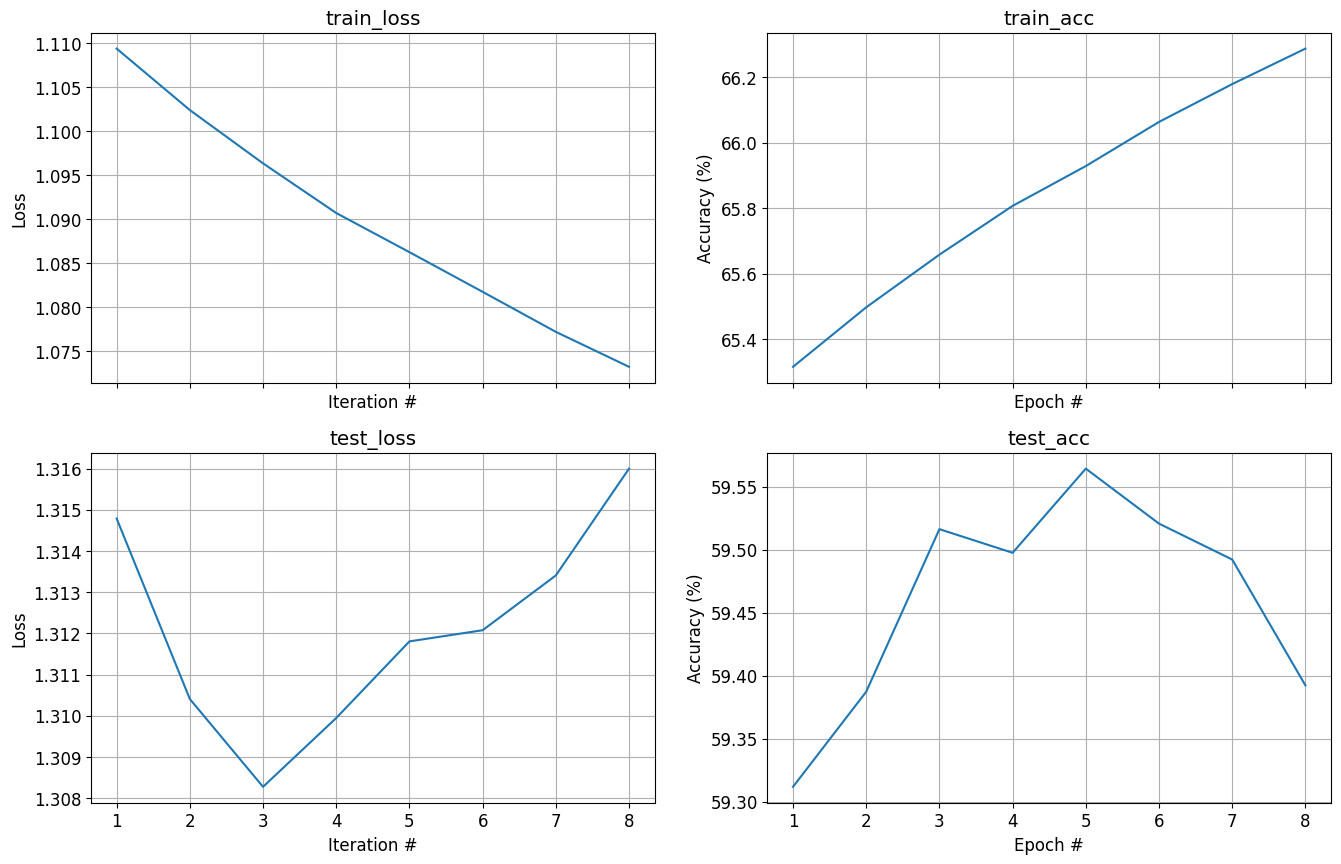

In [20]:
from cs236781.plot import plot_fit

def post_epoch_fn(epoch, train_res, test_res, verbose):
    # Update learning rate
    scheduler.step(test_res.accuracy)
    # Sample from model to show progress
    if verbose:
        start_seq = "ACT I."
        generated_sequence = charnn.generate_from_model(
            model, start_seq, 100, (char_to_idx,idx_to_char), T=0.5
        )
        print(generated_sequence)

# Train, unless final checkpoint is found
checkpoint_file_final = f'{checkpoint_file}_final.pt'
if os.path.isfile(checkpoint_file_final):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    saved_state = torch.load(checkpoint_file_final, map_location=device)
    model.load_state_dict(saved_state['model_state'])
else:
    try:
        # Print pre-training sampling
        print(charnn.generate_from_model(model, "ACT I.", 100, (char_to_idx,idx_to_char), T=0.5))
    
        fit_res = trainer.fit(dl_train, dl_test, num_epochs, max_batches=None,
                                  post_epoch_fn=post_epoch_fn, early_stopping=early_stopping,
                                  checkpoints=checkpoint_file, print_every=1)
            
        fig, axes = plot_fit(fit_res)
    except KeyboardInterrupt as e:
            print('\n *** Training interrupted by user')

### Generating a work of art
<a id=part1_8></a>

Armed with our fully trained model, let's generate the next Hamlet! You should experiment with modifying the sampling temperature and see what happens.

The text you generate should “look” like a Shakespeare play:
old-style English words and sentence structure, directions for the actors
(like “Exit/Enter”), sections (Act I/Scene III) etc.
There will be no coherent plot of course, but it should at least seem like
a Shakespearean play when not looking too closely.
If this is not what you see, go back, debug and/or and re-train.

**TODO**: Specify the generation parameters in the `part1_generation_params()` function within the `hw3/answers.py` module.

In [21]:
from hw3.answers import part1_generation_params

start_seq, temperature = part1_generation_params()

generated_sequence = charnn.generate_from_model(
    model, start_seq, 10000, (char_to_idx,idx_to_char), T=temperature
)

print(generated_sequence)

ACT I. Speak
      them down, if I fill his pains and Rome is mine offer.
    We are so to do. Go to, I am for him; I am sick in love
    the surprised to a vessal art most notes: but our great rage, my
    sighs to extort, and my master's house that hath made courage with us; the
    lord is being much prepar'd with conceit with a better than our brother;
    and there the day were it three times as she have my master.
  KING HENRY. I am not his fiery ways, they shall do
    not with me; but in the very matter, in the ballad
    of sleeve,--
  AJAX. Thou play'd our love hot of the head of treason,
    And then I know not the offences.
    But this is not my better by the lieut,
    Unless to have stay'd upon his hands
    To do my child. Never, thou hast go the time.
    Let us death. You are too soon as you know  
    What I speak unknow of my will.
  MARTIUS. You are still a little progeny all unto my sight.
    And, be thou hear? If it take off my tongue,
    I dare look to put up 

## Questions
<a id=part1_9></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [22]:
from cs236781.answers import display_answer
import hw3.answers

### Question 1
Why do we split the corpus into sequences instead of training on the whole text?

In [23]:
display_answer(hw3.answers.part1_q1)


**Your answer:**

1. **Memory Constraints (VRAM):** Training on the whole text at once would require unrolling the computation graph for the entire length of the corpus. This would consume an impossible amount of memory for storing gradients during Backpropagation Through Time (BPTT). Splitting into sequences allows for Truncated BPTT, which fits in GPU memory.

2. **Vanishing/Exploding Gradients:** In extremely long sequences, gradients propagated backward over thousands of time steps tend to either vanish to zero (stopping learning) or explode to infinity (instability). Limiting the sequence length mitigates this issue.

3. **Optimization Efficiency:** Splitting the text creates many "samples," allowing us to use mini-batch Stochastic Gradient Descent. This updates the weights frequently (thousands of times per epoch) rather than once per epoch, leading to much faster convergence.

4. **Data Parallelism:** Small sequences allow us to stack data into batches (e.g., 64 sequences at a time), maximizing the parallel processing power of the GPU.


### Question 2
How is it possible that the generated text clearly shows memory longer than the sequence length?

In [24]:
display_answer(hw3.answers.part1_q2)


**Your answer:**

It is possible because we maintain and propagate the hidden state across batches.

1.  **Hidden State Persistence:** Although we perform "Truncated Backpropagation Through Time" (cutting off the gradients after seq_len steps to save memory), we do not reset the values of the hidden state between batches. The final hidden state of batch $i$ is fed as the initial hidden state for batch $i+1$.

2.  **Forward vs. Backward Horizon:** While the gradients (learning signal) can only flow back seq_len seps, the forward pass (context information) flows indefinitely. This allows the network to maintain a "memory" of events that happened many batches ago.

3.  **Contiguous Sampling:** Our SequenceBatchSampler ensures that the batches are ordered sequentially (the start of batch $i+1$ is the continuation of batch $i$). This alignment allows the persistent hidden state to carry valid context from the previous segment of text to the current one.


### Question 3
Why are we not shuffling the order of batches when training?

In [25]:
display_answer(hw3.answers.part1_q3)


**Your answer:**

We do not shuffle because we need to preserve contextual continuity between batches to simulate a much longer sequence.

1.  **Stateful Training:** We are training in a "stateful" manner, where the final hidden state of batch $i$ is used as the initial hidden state for batch $i+1$. This allows the model's memory (hidden state) to persist over time.

2.  **Logical Flow:** If we shuffled the batches, the hidden state passed to the network would be from a completely unrelated part of the text (e.g., passing the context of "Chapter 10" into the start of "Chapter 1"). This would break the narrative flow and force the model to reset its context constantly, limiting its effective memory to just the seq_len (e.g., 64 characters).

3.  **Long-Term Dependencies:** By keeping the order sequential, the forward pass can carry information across thousands of characters (through the hidden state), even though the backward pass (gradient calculation) is truncated to only 64 steps.


### Question 4
1. Why do we lower the temperature for sampling (compared to the default of $1.0$)?
2. What happens when the temperature is very high and why?
3. What happens when the temperature is very low and why?

In [26]:
display_answer(hw3.answers.part1_q4)


**Your answer:**

1. **Why lower the temperature (< 1.0)?**
   We lower the temperature to make the model more confident and conservative. A temperature $T < 1$ sharpens the probability distribution, exaggerating the differences between high and low probability characters. This filters out "noise" (low probability options) and ensures the generated text is more coherent, grammatical, and structurally correct, as the model sticks to the patterns it learned most strongly.

2. **What happens when T is very high (> 1.0)?**
   The distribution becomes flatter (more uniform). The differences between likely and unlikely characters shrink.
   Result: The model takes more risks and selects low-probability characters more often. The text becomes chaotic, contains spelling errors, and eventually turns into gibberish because the model is ignoring its own learned probabilities.

3. **What happens when T is very low (close to 0)?**
   The distribution becomes extremely sharp (approximating an argmax). The probability of the most likely character approaches 1, while all others approach 0.
   Result: The model becomes deterministic and repetitive. It will often get stuck in loops (e.g., "and the and the and the") because it constantly picks the single most "safe" next character without any variation to break the cycle.
